#Image Captioning using CNN and LSTM
#Dataset - Flickr8K

### Downloading Data set and Dependencies

In [3]:
#Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

## Data Visualization and Preprocessing

In [5]:
#Converting the text files to a Pandas dataframe
image_tokens=pd.read_csv("./all_captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("./all_captions/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("./all_captions/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("./all_captions/Flickr_8k.devImages.txt",names=["img_id"])

In [6]:
#Finding the number of images in the dataset
l=os.listdir("all_images/Flicker8k_Dataset")
print(len(l))

8091


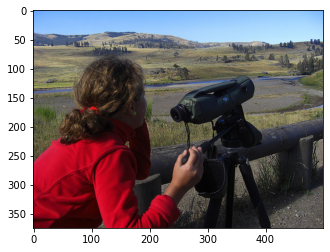

In [8]:
#Visualising one of the train images
img=cv2.imread("./all_images/Flicker8k_Dataset"+ "/" +train_image_names.img_id[10])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [9]:
#Removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [10]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [11]:
#Top 5 of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [12]:
#Top 5 of the train_image_names dataframe
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

### Creating dictionaries to map image_id and their corresponding captions

In [13]:
#Creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:12<00:00, 469.40it/s]


In [14]:
#Creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 470.42it/s]


In [15]:
#Creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 465.95it/s]


### ResNet50 model for encoding images

In [16]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [17]:
#Extracting image encodings(features) from resnet50 and forming dict train_features
path="./all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/6000 [00:01<2:17:34,  1.38s/it]

1/1 [==============================] - 0s 103ms/step


  0%|          | 2/6000 [00:01<1:06:16,  1.51it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 3/6000 [00:01<43:24,  2.30it/s]  

1/1 [==============================] - 0s 97ms/step


  0%|          | 4/6000 [00:01<32:17,  3.09it/s]

1/1 [==============================] - 0s 114ms/step


  0%|          | 5/6000 [00:02<27:21,  3.65it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 6/6000 [00:02<23:39,  4.22it/s]

1/1 [==============================] - 0s 88ms/step


  0%|          | 7/6000 [00:02<20:31,  4.87it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 8/6000 [00:02<18:33,  5.38it/s]

1/1 [==============================] - 0s 104ms/step


  0%|          | 9/6000 [00:02<17:50,  5.59it/s]

1/1 [==============================] - 0s 111ms/step


  0%|          | 10/6000 [00:02<17:34,  5.68it/s]

1/1 [==============================] - 0s 105ms/step


  0%|          | 11/6000 [00:02<17:04,  5.84it/s]

1/1 [==============================] - 0s 108ms/step


  0%|          | 12/6000 [00:03<17:08,  5.82it/s]

1/1 [==============================] - 0s 92ms/step


  0%|          | 13/6000 [00:03<16:17,  6.12it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 14/6000 [00:03<15:51,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


  0%|          | 15/6000 [00:03<16:16,  6.13it/s]

1/1 [==============================] - 0s 117ms/step


  0%|          | 16/6000 [00:03<17:06,  5.83it/s]

1/1 [==============================] - 0s 97ms/step


  0%|          | 17/6000 [00:03<16:34,  6.01it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 18/6000 [00:04<16:01,  6.22it/s]

1/1 [==============================] - 0s 94ms/step


  0%|          | 19/6000 [00:04<15:36,  6.38it/s]

1/1 [==============================] - 0s 104ms/step


  0%|          | 20/6000 [00:04<15:39,  6.37it/s]

1/1 [==============================] - 0s 119ms/step


  0%|          | 21/6000 [00:04<16:54,  5.89it/s]

1/1 [==============================] - 0s 100ms/step


  0%|          | 22/6000 [00:04<16:40,  5.98it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 23/6000 [00:04<16:14,  6.13it/s]

1/1 [==============================] - 0s 108ms/step


  0%|          | 24/6000 [00:05<16:35,  6.00it/s]

1/1 [==============================] - 0s 117ms/step


  0%|          | 25/6000 [00:05<16:57,  5.87it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 26/6000 [00:05<16:21,  6.09it/s]

1/1 [==============================] - 0s 99ms/step


  0%|          | 27/6000 [00:05<16:18,  6.10it/s]

1/1 [==============================] - 0s 103ms/step


  0%|          | 28/6000 [00:05<16:09,  6.16it/s]

1/1 [==============================] - 0s 115ms/step


  0%|          | 29/6000 [00:05<17:08,  5.81it/s]

1/1 [==============================] - 0s 94ms/step


  0%|          | 30/6000 [00:06<17:11,  5.79it/s]

1/1 [==============================] - 0s 104ms/step


  1%|          | 31/6000 [00:06<16:42,  5.95it/s]

1/1 [==============================] - 0s 93ms/step


  1%|          | 32/6000 [00:06<16:05,  6.18it/s]

1/1 [==============================] - 0s 94ms/step


  1%|          | 33/6000 [00:06<15:42,  6.33it/s]

1/1 [==============================] - 0s 92ms/step


  1%|          | 34/6000 [00:06<15:35,  6.38it/s]

1/1 [==============================] - 0s 98ms/step


  1%|          | 35/6000 [00:06<15:26,  6.44it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 36/6000 [00:07<15:18,  6.49it/s]

1/1 [==============================] - 0s 83ms/step


  1%|          | 37/6000 [00:07<14:35,  6.81it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 38/6000 [00:07<14:21,  6.92it/s]

1/1 [==============================] - 0s 102ms/step


  1%|          | 39/6000 [00:07<14:53,  6.67it/s]

1/1 [==============================] - 0s 99ms/step


  1%|          | 40/6000 [00:07<15:21,  6.47it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 41/6000 [00:07<15:05,  6.58it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 42/6000 [00:07<14:56,  6.64it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 43/6000 [00:08<14:41,  6.76it/s]

1/1 [==============================] - 0s 94ms/step


  1%|          | 44/6000 [00:08<14:30,  6.84it/s]

1/1 [==============================] - 0s 83ms/step


  1%|          | 45/6000 [00:08<14:08,  7.02it/s]

1/1 [==============================] - 0s 86ms/step


  1%|          | 46/6000 [00:08<14:11,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 47/6000 [00:08<14:07,  7.02it/s]

1/1 [==============================] - 0s 91ms/step


  1%|          | 48/6000 [00:08<14:13,  6.97it/s]

1/1 [==============================] - 0s 100ms/step


  1%|          | 49/6000 [00:08<14:39,  6.76it/s]

1/1 [==============================] - 0s 91ms/step


  1%|          | 50/6000 [00:09<14:50,  6.68it/s]

1/1 [==============================] - 0s 85ms/step


  1%|          | 51/6000 [00:09<14:22,  6.90it/s]

1/1 [==============================] - 0s 89ms/step


  1%|          | 52/6000 [00:09<14:09,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


  1%|          | 53/6000 [00:09<14:08,  7.01it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 54/6000 [00:09<14:05,  7.04it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 55/6000 [00:09<14:11,  6.98it/s]

1/1 [==============================] - 0s 92ms/step


  1%|          | 56/6000 [00:09<14:18,  6.92it/s]

1/1 [==============================] - 0s 98ms/step


  1%|          | 57/6000 [00:10<14:24,  6.87it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 58/6000 [00:10<14:07,  7.01it/s]

1/1 [==============================] - 0s 86ms/step


  1%|          | 59/6000 [00:10<13:57,  7.09it/s]

1/1 [==============================] - 0s 86ms/step


  1%|          | 60/6000 [00:10<13:57,  7.09it/s]

1/1 [==============================] - 0s 105ms/step


  1%|          | 61/6000 [00:10<14:31,  6.82it/s]

1/1 [==============================] - 0s 99ms/step


  1%|          | 62/6000 [00:10<15:01,  6.58it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 63/6000 [00:10<14:56,  6.62it/s]

1/1 [==============================] - 0s 87ms/step


  1%|          | 64/6000 [00:11<14:42,  6.73it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 65/6000 [00:11<14:19,  6.90it/s]

1/1 [==============================] - 0s 88ms/step


  1%|          | 66/6000 [00:11<14:07,  7.00it/s]

1/1 [==============================] - 0s 96ms/step


  1%|          | 67/6000 [00:11<14:35,  6.78it/s]

1/1 [==============================] - 0s 89ms/step


  1%|          | 68/6000 [00:11<14:34,  6.79it/s]

1/1 [==============================] - 0s 95ms/step


  1%|          | 69/6000 [00:11<14:45,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


  1%|          | 70/6000 [00:11<14:45,  6.70it/s]

1/1 [==============================] - 0s 95ms/step


  1%|          | 71/6000 [00:12<14:42,  6.72it/s]

1/1 [==============================] - 0s 97ms/step


  1%|          | 72/6000 [00:12<15:07,  6.53it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 73/6000 [00:12<15:06,  6.54it/s]

1/1 [==============================] - 0s 109ms/step


  1%|          | 74/6000 [00:12<15:45,  6.27it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▏         | 75/6000 [00:12<16:07,  6.12it/s]

1/1 [==============================] - 0s 101ms/step


  1%|▏         | 76/6000 [00:12<16:06,  6.13it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▏         | 77/6000 [00:13<15:36,  6.33it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏         | 78/6000 [00:13<15:16,  6.46it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▏         | 79/6000 [00:13<15:09,  6.51it/s]

1/1 [==============================] - 0s 100ms/step


  1%|▏         | 80/6000 [00:13<15:06,  6.53it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▏         | 81/6000 [00:13<15:07,  6.52it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▏         | 82/6000 [00:13<15:15,  6.46it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▏         | 83/6000 [00:14<14:51,  6.64it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▏         | 84/6000 [00:14<14:50,  6.65it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▏         | 85/6000 [00:14<14:20,  6.87it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▏         | 86/6000 [00:14<14:04,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


  1%|▏         | 87/6000 [00:14<14:01,  7.03it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏         | 88/6000 [00:14<14:09,  6.96it/s]

1/1 [==============================] - 0s 102ms/step


  1%|▏         | 89/6000 [00:14<14:43,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 90/6000 [00:15<14:44,  6.68it/s]

1/1 [==============================] - 0s 87ms/step


  2%|▏         | 91/6000 [00:15<14:28,  6.80it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 92/6000 [00:15<14:26,  6.82it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▏         | 93/6000 [00:15<14:29,  6.80it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 94/6000 [00:15<14:34,  6.76it/s]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 95/6000 [00:15<15:07,  6.51it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 96/6000 [00:15<15:09,  6.49it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 97/6000 [00:16<14:53,  6.61it/s]

1/1 [==============================] - 0s 91ms/step


  2%|▏         | 98/6000 [00:16<14:33,  6.76it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 99/6000 [00:16<14:34,  6.74it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 100/6000 [00:16<14:49,  6.63it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 101/6000 [00:16<15:09,  6.49it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▏         | 102/6000 [00:16<15:03,  6.53it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 103/6000 [00:17<14:59,  6.56it/s]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 104/6000 [00:17<15:07,  6.50it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 105/6000 [00:17<14:47,  6.64it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▏         | 106/6000 [00:17<14:25,  6.81it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▏         | 107/6000 [00:17<14:25,  6.81it/s]

1/1 [==============================] - 0s 109ms/step


  2%|▏         | 108/6000 [00:17<14:55,  6.58it/s]

1/1 [==============================] - 0s 108ms/step


  2%|▏         | 109/6000 [00:17<15:16,  6.43it/s]

1/1 [==============================] - 0s 106ms/step


  2%|▏         | 110/6000 [00:18<15:43,  6.24it/s]

1/1 [==============================] - 0s 110ms/step


  2%|▏         | 111/6000 [00:18<15:52,  6.19it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 112/6000 [00:18<16:01,  6.12it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 113/6000 [00:18<15:45,  6.23it/s]

1/1 [==============================] - 0s 108ms/step


  2%|▏         | 114/6000 [00:18<16:05,  6.10it/s]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 115/6000 [00:18<16:31,  5.93it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 116/6000 [00:19<16:09,  6.07it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 117/6000 [00:19<15:36,  6.28it/s]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 118/6000 [00:19<15:34,  6.30it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 119/6000 [00:19<15:21,  6.38it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 120/6000 [00:19<15:21,  6.38it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▏         | 121/6000 [00:19<15:14,  6.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 122/6000 [00:20<15:08,  6.47it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▏         | 123/6000 [00:20<14:54,  6.57it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▏         | 124/6000 [00:20<14:33,  6.73it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 125/6000 [00:20<14:44,  6.64it/s]

1/1 [==============================] - 0s 112ms/step


  2%|▏         | 126/6000 [00:20<15:34,  6.29it/s]

1/1 [==============================] - 0s 112ms/step


  2%|▏         | 127/6000 [00:20<15:55,  6.15it/s]

1/1 [==============================] - 0s 106ms/step


  2%|▏         | 128/6000 [00:20<16:22,  5.98it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 129/6000 [00:21<16:28,  5.94it/s]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 130/6000 [00:21<16:17,  6.01it/s]

1/1 [==============================] - 0s 91ms/step


  2%|▏         | 131/6000 [00:21<15:42,  6.23it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▏         | 132/6000 [00:21<15:16,  6.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 133/6000 [00:21<15:04,  6.49it/s]

1/1 [==============================] - 0s 91ms/step


  2%|▏         | 134/6000 [00:21<14:54,  6.55it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▏         | 135/6000 [00:22<14:34,  6.71it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▏         | 136/6000 [00:22<14:20,  6.82it/s]

1/1 [==============================] - 0s 88ms/step


  2%|▏         | 137/6000 [00:22<14:01,  6.97it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▏         | 138/6000 [00:22<13:49,  7.07it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 139/6000 [00:22<14:04,  6.94it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 140/6000 [00:22<14:02,  6.96it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▏         | 141/6000 [00:22<14:44,  6.62it/s]

1/1 [==============================] - 0s 106ms/step


  2%|▏         | 142/6000 [00:23<15:16,  6.39it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 143/6000 [00:23<15:24,  6.34it/s]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 144/6000 [00:23<15:43,  6.21it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 145/6000 [00:23<15:39,  6.23it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 146/6000 [00:23<15:47,  6.18it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 147/6000 [00:23<15:49,  6.17it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 148/6000 [00:24<15:27,  6.31it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▏         | 149/6000 [00:24<15:02,  6.49it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▎         | 150/6000 [00:24<15:00,  6.49it/s]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 151/6000 [00:24<15:13,  6.41it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 152/6000 [00:24<15:12,  6.41it/s]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 153/6000 [00:24<15:35,  6.25it/s]

1/1 [==============================] - 0s 90ms/step


  3%|▎         | 154/6000 [00:25<21:17,  4.58it/s]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 155/6000 [00:25<18:52,  5.16it/s]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 156/6000 [00:25<17:10,  5.67it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 157/6000 [00:25<16:08,  6.03it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 158/6000 [00:25<15:25,  6.32it/s]

1/1 [==============================] - 0s 109ms/step


  3%|▎         | 159/6000 [00:25<15:41,  6.20it/s]

1/1 [==============================] - 0s 110ms/step


  3%|▎         | 160/6000 [00:26<16:14,  5.99it/s]

1/1 [==============================] - 0s 87ms/step


  3%|▎         | 161/6000 [00:26<15:25,  6.31it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 162/6000 [00:26<14:56,  6.51it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 163/6000 [00:26<14:30,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 164/6000 [00:26<14:45,  6.59it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 165/6000 [00:26<14:47,  6.58it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 166/6000 [00:26<14:38,  6.64it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 167/6000 [00:27<14:24,  6.74it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 168/6000 [00:27<14:17,  6.80it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 169/6000 [00:27<14:06,  6.89it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 170/6000 [00:27<14:06,  6.89it/s]

1/1 [==============================] - 0s 110ms/step


  3%|▎         | 171/6000 [00:27<14:53,  6.53it/s]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 172/6000 [00:27<15:22,  6.32it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 173/6000 [00:28<15:21,  6.32it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 174/6000 [00:28<14:58,  6.48it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 175/6000 [00:28<14:36,  6.64it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 176/6000 [00:28<14:16,  6.80it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 177/6000 [00:28<14:32,  6.67it/s]

1/1 [==============================] - 0s 109ms/step


  3%|▎         | 178/6000 [00:28<15:03,  6.44it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 179/6000 [00:28<15:54,  6.10it/s]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 180/6000 [00:29<15:40,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 181/6000 [00:29<15:11,  6.39it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 182/6000 [00:29<14:53,  6.51it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 183/6000 [00:29<14:31,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 184/6000 [00:29<14:29,  6.69it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 185/6000 [00:29<14:33,  6.65it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 186/6000 [00:30<14:45,  6.57it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 187/6000 [00:30<14:48,  6.54it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 188/6000 [00:30<14:22,  6.74it/s]

1/1 [==============================] - 0s 96ms/step


  3%|▎         | 189/6000 [00:30<14:16,  6.79it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 190/6000 [00:30<14:24,  6.72it/s]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 191/6000 [00:30<14:34,  6.64it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 192/6000 [00:30<14:35,  6.63it/s]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 193/6000 [00:31<14:54,  6.49it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 194/6000 [00:31<14:47,  6.54it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 195/6000 [00:31<14:16,  6.78it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 196/6000 [00:31<14:10,  6.83it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 197/6000 [00:31<14:23,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 198/6000 [00:31<14:18,  6.76it/s]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 199/6000 [00:31<14:27,  6.69it/s]

1/1 [==============================] - 0s 109ms/step


  3%|▎         | 200/6000 [00:32<14:48,  6.52it/s]

1/1 [==============================] - 0s 110ms/step


  3%|▎         | 201/6000 [00:32<15:16,  6.33it/s]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 202/6000 [00:32<15:09,  6.38it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 203/6000 [00:32<14:55,  6.47it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 204/6000 [00:32<14:44,  6.56it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 205/6000 [00:32<14:37,  6.60it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 206/6000 [00:33<14:35,  6.62it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 207/6000 [00:33<14:27,  6.67it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 208/6000 [00:33<14:15,  6.77it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 209/6000 [00:33<14:24,  6.69it/s]

1/1 [==============================] - 0s 97ms/step


  4%|▎         | 210/6000 [00:33<14:22,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▎         | 211/6000 [00:33<14:25,  6.69it/s]

1/1 [==============================] - 0s 105ms/step


  4%|▎         | 212/6000 [00:33<14:57,  6.45it/s]

1/1 [==============================] - 0s 107ms/step


  4%|▎         | 213/6000 [00:34<15:28,  6.23it/s]

1/1 [==============================] - 0s 97ms/step


  4%|▎         | 214/6000 [00:34<15:15,  6.32it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▎         | 215/6000 [00:34<14:50,  6.50it/s]

1/1 [==============================] - 0s 110ms/step


  4%|▎         | 216/6000 [00:34<15:01,  6.42it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▎         | 217/6000 [00:34<15:01,  6.42it/s]

1/1 [==============================] - 0s 91ms/step


  4%|▎         | 218/6000 [00:34<14:40,  6.57it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▎         | 219/6000 [00:35<14:43,  6.54it/s]

1/1 [==============================] - 0s 100ms/step


  4%|▎         | 220/6000 [00:35<14:53,  6.47it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▎         | 221/6000 [00:35<14:47,  6.51it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▎         | 222/6000 [00:35<15:19,  6.28it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▎         | 223/6000 [00:35<15:57,  6.04it/s]

1/1 [==============================] - 0s 117ms/step


  4%|▎         | 224/6000 [00:35<16:32,  5.82it/s]

1/1 [==============================] - 0s 107ms/step


  4%|▍         | 225/6000 [00:36<16:32,  5.82it/s]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 226/6000 [00:36<16:35,  5.80it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 227/6000 [00:36<16:14,  5.93it/s]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 228/6000 [00:36<16:07,  5.97it/s]

1/1 [==============================] - 0s 100ms/step


  4%|▍         | 229/6000 [00:36<15:57,  6.03it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 230/6000 [00:36<15:41,  6.13it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 231/6000 [00:37<15:36,  6.16it/s]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 232/6000 [00:37<15:33,  6.18it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 233/6000 [00:37<15:13,  6.32it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 234/6000 [00:37<15:19,  6.27it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 235/6000 [00:37<15:01,  6.39it/s]

1/1 [==============================] - 0s 92ms/step


  4%|▍         | 236/6000 [00:37<14:52,  6.46it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 237/6000 [00:37<14:30,  6.62it/s]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 238/6000 [00:38<14:45,  6.51it/s]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 239/6000 [00:38<14:52,  6.45it/s]

1/1 [==============================] - 0s 100ms/step


  4%|▍         | 240/6000 [00:38<14:54,  6.44it/s]

1/1 [==============================] - 0s 95ms/step


  4%|▍         | 241/6000 [00:38<14:39,  6.54it/s]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 242/6000 [00:38<15:00,  6.40it/s]

1/1 [==============================] - 0s 89ms/step


  4%|▍         | 243/6000 [00:38<14:38,  6.55it/s]

1/1 [==============================] - 0s 92ms/step


  4%|▍         | 244/6000 [00:39<14:25,  6.65it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 245/6000 [00:39<14:21,  6.68it/s]

1/1 [==============================] - 0s 87ms/step


  4%|▍         | 246/6000 [00:39<13:57,  6.87it/s]

1/1 [==============================] - 0s 85ms/step


  4%|▍         | 247/6000 [00:39<13:39,  7.02it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 248/6000 [00:39<13:38,  7.03it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 249/6000 [00:39<13:53,  6.90it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 250/6000 [00:39<14:15,  6.72it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 251/6000 [00:40<14:15,  6.72it/s]

1/1 [==============================] - 0s 88ms/step


  4%|▍         | 252/6000 [00:40<14:02,  6.83it/s]

1/1 [==============================] - 0s 89ms/step


  4%|▍         | 253/6000 [00:40<13:47,  6.95it/s]

1/1 [==============================] - 0s 91ms/step


  4%|▍         | 254/6000 [00:40<13:50,  6.92it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 255/6000 [00:40<13:40,  7.00it/s]

1/1 [==============================] - 0s 111ms/step


  4%|▍         | 256/6000 [00:40<14:30,  6.60it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 257/6000 [00:40<14:43,  6.50it/s]

1/1 [==============================] - 0s 107ms/step


  4%|▍         | 258/6000 [00:41<15:12,  6.29it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 259/6000 [00:41<14:53,  6.42it/s]

1/1 [==============================] - 0s 88ms/step


  4%|▍         | 260/6000 [00:41<14:23,  6.65it/s]

1/1 [==============================] - 0s 97ms/step


  4%|▍         | 261/6000 [00:41<14:15,  6.71it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 262/6000 [00:41<14:34,  6.56it/s]

1/1 [==============================] - 0s 106ms/step


  4%|▍         | 263/6000 [00:41<15:04,  6.34it/s]

1/1 [==============================] - 0s 108ms/step


  4%|▍         | 264/6000 [00:42<15:39,  6.11it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 265/6000 [00:42<15:41,  6.09it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 266/6000 [00:42<15:09,  6.30it/s]

1/1 [==============================] - 0s 89ms/step


  4%|▍         | 267/6000 [00:42<14:30,  6.58it/s]

1/1 [==============================] - 0s 91ms/step


  4%|▍         | 268/6000 [00:42<14:13,  6.72it/s]

1/1 [==============================] - 0s 98ms/step


  4%|▍         | 269/6000 [00:42<14:17,  6.69it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 270/6000 [00:42<14:29,  6.59it/s]

1/1 [==============================] - 0s 99ms/step


  5%|▍         | 271/6000 [00:43<14:33,  6.56it/s]

1/1 [==============================] - 0s 91ms/step


  5%|▍         | 272/6000 [00:43<14:20,  6.66it/s]

1/1 [==============================] - 0s 93ms/step


  5%|▍         | 273/6000 [00:43<14:06,  6.77it/s]

1/1 [==============================] - 0s 97ms/step


  5%|▍         | 274/6000 [00:43<14:03,  6.79it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 275/6000 [00:43<14:16,  6.69it/s]

1/1 [==============================] - 0s 106ms/step


  5%|▍         | 276/6000 [00:43<14:37,  6.52it/s]

1/1 [==============================] - 0s 114ms/step


  5%|▍         | 277/6000 [00:44<15:42,  6.08it/s]

1/1 [==============================] - 0s 97ms/step


  5%|▍         | 278/6000 [00:44<15:54,  5.99it/s]

1/1 [==============================] - 0s 99ms/step


  5%|▍         | 279/6000 [00:44<15:23,  6.19it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▍         | 280/6000 [00:44<15:07,  6.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 281/6000 [00:44<14:45,  6.46it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 282/6000 [00:44<14:59,  6.36it/s]

1/1 [==============================] - 0s 115ms/step


  5%|▍         | 283/6000 [00:44<15:34,  6.12it/s]

1/1 [==============================] - 0s 96ms/step


  5%|▍         | 284/6000 [00:45<15:23,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 285/6000 [00:45<14:54,  6.39it/s]

1/1 [==============================] - 0s 97ms/step


  5%|▍         | 286/6000 [00:45<14:41,  6.48it/s]

1/1 [==============================] - 0s 101ms/step


  5%|▍         | 287/6000 [00:45<14:46,  6.45it/s]

1/1 [==============================] - 0s 104ms/step


  5%|▍         | 288/6000 [00:45<14:57,  6.36it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▍         | 289/6000 [00:45<14:31,  6.55it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 290/6000 [00:46<14:16,  6.66it/s]

1/1 [==============================] - 0s 91ms/step


  5%|▍         | 291/6000 [00:46<14:13,  6.69it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▍         | 292/6000 [00:46<13:48,  6.89it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▍         | 293/6000 [00:46<13:30,  7.04it/s]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 294/6000 [00:46<13:49,  6.88it/s]

1/1 [==============================] - 0s 108ms/step


  5%|▍         | 295/6000 [00:46<14:21,  6.62it/s]

1/1 [==============================] - 0s 97ms/step


  5%|▍         | 296/6000 [00:46<14:24,  6.60it/s]

1/1 [==============================] - 0s 93ms/step


  5%|▍         | 297/6000 [00:47<14:21,  6.62it/s]

1/1 [==============================] - 0s 89ms/step


  5%|▍         | 298/6000 [00:47<14:16,  6.66it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▍         | 299/6000 [00:47<13:51,  6.85it/s]

1/1 [==============================] - 0s 87ms/step


  5%|▌         | 300/6000 [00:47<13:33,  7.01it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▌         | 301/6000 [00:47<13:28,  7.05it/s]

1/1 [==============================] - 0s 99ms/step


  5%|▌         | 302/6000 [00:47<13:54,  6.83it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▌         | 303/6000 [00:47<14:12,  6.69it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▌         | 304/6000 [00:48<14:33,  6.52it/s]

1/1 [==============================] - 0s 106ms/step


  5%|▌         | 305/6000 [00:48<15:10,  6.26it/s]

1/1 [==============================] - 0s 98ms/step


  5%|▌         | 306/6000 [00:48<14:58,  6.34it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▌         | 307/6000 [00:48<14:32,  6.52it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 308/6000 [00:48<14:27,  6.56it/s]

1/1 [==============================] - 0s 108ms/step


  5%|▌         | 309/6000 [00:48<15:07,  6.27it/s]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 310/6000 [00:49<15:30,  6.12it/s]

1/1 [==============================] - 0s 111ms/step


  5%|▌         | 311/6000 [00:49<15:44,  6.02it/s]

1/1 [==============================] - 0s 92ms/step


  5%|▌         | 312/6000 [00:49<15:08,  6.26it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▌         | 313/6000 [00:49<14:31,  6.53it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 314/6000 [00:49<14:15,  6.64it/s]

1/1 [==============================] - 0s 103ms/step


  5%|▌         | 315/6000 [00:49<14:36,  6.48it/s]

1/1 [==============================] - 0s 112ms/step


  5%|▌         | 316/6000 [00:50<15:08,  6.25it/s]

1/1 [==============================] - 0s 100ms/step


  5%|▌         | 317/6000 [00:50<15:03,  6.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 318/6000 [00:50<14:43,  6.43it/s]

1/1 [==============================] - 0s 107ms/step


  5%|▌         | 319/6000 [00:50<14:49,  6.39it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▌         | 320/6000 [00:50<14:19,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 321/6000 [00:50<14:10,  6.68it/s]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 322/6000 [00:50<14:36,  6.48it/s]

1/1 [==============================] - 0s 113ms/step


  5%|▌         | 323/6000 [00:51<15:28,  6.12it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▌         | 324/6000 [00:51<15:39,  6.04it/s]

1/1 [==============================] - 0s 103ms/step


  5%|▌         | 325/6000 [00:51<15:48,  5.98it/s]

1/1 [==============================] - 0s 93ms/step


  5%|▌         | 326/6000 [00:51<15:17,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▌         | 327/6000 [00:51<14:50,  6.37it/s]

1/1 [==============================] - 0s 96ms/step


  5%|▌         | 328/6000 [00:51<14:41,  6.43it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 329/6000 [00:52<14:37,  6.46it/s]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 330/6000 [00:52<14:44,  6.41it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 331/6000 [00:52<14:46,  6.40it/s]

1/1 [==============================] - 0s 93ms/step


  6%|▌         | 332/6000 [00:52<14:30,  6.51it/s]

1/1 [==============================] - 0s 93ms/step


  6%|▌         | 333/6000 [00:52<14:17,  6.61it/s]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 334/6000 [00:52<14:26,  6.54it/s]

1/1 [==============================] - 0s 114ms/step


  6%|▌         | 335/6000 [00:53<14:57,  6.31it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 336/6000 [00:53<14:53,  6.34it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 337/6000 [00:53<14:53,  6.34it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▌         | 338/6000 [00:53<14:24,  6.55it/s]

1/1 [==============================] - 0s 87ms/step


  6%|▌         | 339/6000 [00:53<14:01,  6.73it/s]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 340/6000 [00:53<13:48,  6.83it/s]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 341/6000 [00:53<13:47,  6.84it/s]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 342/6000 [00:54<14:19,  6.58it/s]

1/1 [==============================] - 0s 119ms/step


  6%|▌         | 343/6000 [00:54<15:01,  6.27it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 344/6000 [00:54<15:11,  6.21it/s]

1/1 [==============================] - 0s 116ms/step


  6%|▌         | 345/6000 [00:54<15:37,  6.03it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 346/6000 [00:54<15:29,  6.08it/s]

1/1 [==============================] - 0s 94ms/step


  6%|▌         | 347/6000 [00:54<15:03,  6.26it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▌         | 348/6000 [00:55<14:46,  6.38it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 349/6000 [00:55<14:43,  6.40it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▌         | 350/6000 [00:55<14:37,  6.44it/s]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 351/6000 [00:55<14:07,  6.66it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▌         | 352/6000 [00:55<13:49,  6.81it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▌         | 353/6000 [00:55<13:32,  6.95it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 354/6000 [00:55<13:37,  6.91it/s]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 355/6000 [00:56<13:46,  6.83it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▌         | 356/6000 [00:56<13:33,  6.94it/s]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 357/6000 [00:56<13:36,  6.91it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▌         | 358/6000 [00:56<14:15,  6.59it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 359/6000 [00:56<13:57,  6.73it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 360/6000 [00:56<14:08,  6.64it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 361/6000 [00:56<14:29,  6.48it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 362/6000 [00:57<14:52,  6.31it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 363/6000 [00:57<14:40,  6.40it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▌         | 364/6000 [00:57<14:55,  6.30it/s]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 365/6000 [00:57<14:51,  6.32it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▌         | 366/6000 [00:57<14:44,  6.37it/s]

1/1 [==============================] - 0s 93ms/step


  6%|▌         | 367/6000 [00:57<14:39,  6.41it/s]

1/1 [==============================] - 0s 103ms/step


  6%|▌         | 368/6000 [00:58<14:38,  6.41it/s]

1/1 [==============================] - 0s 107ms/step


  6%|▌         | 369/6000 [00:58<14:55,  6.29it/s]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 370/6000 [00:58<14:41,  6.38it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 371/6000 [00:58<14:32,  6.45it/s]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 372/6000 [00:58<14:09,  6.62it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 373/6000 [00:58<14:11,  6.61it/s]

1/1 [==============================] - 0s 109ms/step


  6%|▌         | 374/6000 [00:58<14:35,  6.42it/s]

1/1 [==============================] - 0s 112ms/step


  6%|▋         | 375/6000 [00:59<15:11,  6.17it/s]

1/1 [==============================] - 0s 106ms/step


  6%|▋         | 376/6000 [00:59<15:31,  6.04it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▋         | 377/6000 [00:59<15:21,  6.10it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▋         | 378/6000 [00:59<14:36,  6.42it/s]

1/1 [==============================] - 0s 96ms/step


  6%|▋         | 379/6000 [00:59<14:26,  6.49it/s]

1/1 [==============================] - 0s 96ms/step


  6%|▋         | 380/6000 [00:59<14:12,  6.59it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▋         | 381/6000 [01:00<14:11,  6.60it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▋         | 382/6000 [01:00<14:23,  6.50it/s]

1/1 [==============================] - 0s 93ms/step


  6%|▋         | 383/6000 [01:00<14:05,  6.64it/s]

1/1 [==============================] - 0s 97ms/step


  6%|▋         | 384/6000 [01:00<13:59,  6.69it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▋         | 385/6000 [01:00<13:46,  6.79it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▋         | 386/6000 [01:00<13:47,  6.78it/s]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 387/6000 [01:00<14:02,  6.67it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▋         | 388/6000 [01:01<20:49,  4.49it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▋         | 389/6000 [01:01<18:24,  5.08it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▋         | 390/6000 [01:01<17:04,  5.48it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 391/6000 [01:01<16:34,  5.64it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 392/6000 [01:01<15:34,  6.00it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 393/6000 [01:02<15:08,  6.17it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 394/6000 [01:02<15:04,  6.20it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 395/6000 [01:02<14:30,  6.44it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 396/6000 [01:02<14:34,  6.41it/s]

1/1 [==============================] - 0s 109ms/step


  7%|▋         | 397/6000 [01:02<14:54,  6.26it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 398/6000 [01:02<14:58,  6.24it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 399/6000 [01:03<14:34,  6.41it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 400/6000 [01:03<14:32,  6.42it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 401/6000 [01:03<14:34,  6.41it/s]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 402/6000 [01:03<15:05,  6.18it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 403/6000 [01:03<14:45,  6.32it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 404/6000 [01:03<14:38,  6.37it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 405/6000 [01:04<14:45,  6.32it/s]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 406/6000 [01:04<15:13,  6.13it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 407/6000 [01:04<14:45,  6.31it/s]

1/1 [==============================] - 0s 92ms/step


  7%|▋         | 408/6000 [01:04<14:13,  6.56it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 409/6000 [01:04<14:01,  6.64it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 410/6000 [01:04<14:12,  6.56it/s]

1/1 [==============================] - 0s 113ms/step


  7%|▋         | 411/6000 [01:04<14:41,  6.34it/s]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 412/6000 [01:05<14:50,  6.28it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 413/6000 [01:05<14:56,  6.23it/s]

1/1 [==============================] - 0s 91ms/step


  7%|▋         | 414/6000 [01:05<14:30,  6.42it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 415/6000 [01:05<14:38,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


  7%|▋         | 416/6000 [01:05<14:59,  6.21it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 417/6000 [01:05<14:51,  6.27it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 418/6000 [01:06<14:21,  6.48it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 419/6000 [01:06<14:10,  6.56it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 420/6000 [01:06<14:08,  6.58it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 421/6000 [01:06<14:13,  6.54it/s]

1/1 [==============================] - 0s 105ms/step


  7%|▋         | 422/6000 [01:06<14:28,  6.43it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 423/6000 [01:06<14:41,  6.32it/s]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 424/6000 [01:06<14:46,  6.29it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 425/6000 [01:07<14:29,  6.41it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 426/6000 [01:07<14:19,  6.49it/s]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 427/6000 [01:07<14:44,  6.30it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 428/6000 [01:07<14:46,  6.29it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 429/6000 [01:07<14:50,  6.25it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 430/6000 [01:07<14:45,  6.29it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 431/6000 [01:08<14:44,  6.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 432/6000 [01:08<14:30,  6.39it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 433/6000 [01:08<14:40,  6.33it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 434/6000 [01:08<14:24,  6.44it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 435/6000 [01:08<14:23,  6.44it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 436/6000 [01:08<14:18,  6.48it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 437/6000 [01:09<14:24,  6.44it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 438/6000 [01:09<14:38,  6.33it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 439/6000 [01:09<14:36,  6.34it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 440/6000 [01:09<14:17,  6.49it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 441/6000 [01:09<14:23,  6.44it/s]

1/1 [==============================] - 0s 94ms/step


  7%|▋         | 442/6000 [01:09<14:07,  6.56it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 443/6000 [01:09<14:08,  6.55it/s]

1/1 [==============================] - 0s 94ms/step


  7%|▋         | 444/6000 [01:10<14:08,  6.55it/s]

1/1 [==============================] - 0s 97ms/step


  7%|▋         | 445/6000 [01:10<14:15,  6.49it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 446/6000 [01:10<14:23,  6.43it/s]

1/1 [==============================] - 0s 92ms/step


  7%|▋         | 447/6000 [01:10<13:59,  6.62it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 448/6000 [01:10<14:40,  6.30it/s]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 449/6000 [01:10<15:01,  6.16it/s]

1/1 [==============================] - 0s 96ms/step


  8%|▊         | 450/6000 [01:11<14:33,  6.35it/s]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 451/6000 [01:11<14:47,  6.25it/s]

1/1 [==============================] - 0s 110ms/step


  8%|▊         | 452/6000 [01:11<15:01,  6.16it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 453/6000 [01:11<14:48,  6.24it/s]

1/1 [==============================] - 0s 98ms/step


  8%|▊         | 454/6000 [01:11<14:34,  6.34it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 455/6000 [01:11<14:20,  6.45it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 456/6000 [01:11<14:01,  6.59it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 457/6000 [01:12<13:46,  6.70it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 458/6000 [01:12<13:39,  6.76it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 459/6000 [01:12<13:18,  6.94it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 460/6000 [01:12<13:14,  6.97it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 461/6000 [01:12<13:55,  6.63it/s]

1/1 [==============================] - 0s 99ms/step


  8%|▊         | 462/6000 [01:12<14:17,  6.46it/s]

1/1 [==============================] - 0s 95ms/step


  8%|▊         | 463/6000 [01:13<14:09,  6.52it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 464/6000 [01:13<14:21,  6.43it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 465/6000 [01:13<14:00,  6.59it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 466/6000 [01:13<13:42,  6.73it/s]

1/1 [==============================] - 0s 98ms/step


  8%|▊         | 467/6000 [01:13<13:42,  6.72it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 468/6000 [01:13<13:30,  6.83it/s]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 469/6000 [01:13<13:59,  6.59it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 470/6000 [01:14<13:47,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


  8%|▊         | 471/6000 [01:14<13:44,  6.70it/s]

1/1 [==============================] - 0s 90ms/step


  8%|▊         | 472/6000 [01:14<13:32,  6.80it/s]

1/1 [==============================] - 0s 90ms/step


  8%|▊         | 473/6000 [01:14<13:21,  6.90it/s]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 474/6000 [01:14<13:39,  6.75it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 475/6000 [01:14<13:46,  6.68it/s]

1/1 [==============================] - 0s 99ms/step


  8%|▊         | 476/6000 [01:14<13:55,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


  8%|▊         | 477/6000 [01:15<13:59,  6.58it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 478/6000 [01:15<13:53,  6.63it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 479/6000 [01:15<13:38,  6.75it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 480/6000 [01:15<13:22,  6.88it/s]

1/1 [==============================] - 0s 99ms/step


  8%|▊         | 481/6000 [01:15<13:31,  6.80it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 482/6000 [01:15<15:27,  5.95it/s]

1/1 [==============================] - 0s 114ms/step


  8%|▊         | 483/6000 [01:16<16:04,  5.72it/s]

1/1 [==============================] - 0s 108ms/step


  8%|▊         | 484/6000 [01:16<16:08,  5.70it/s]

1/1 [==============================] - 0s 88ms/step


  8%|▊         | 485/6000 [01:16<15:15,  6.02it/s]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 486/6000 [01:16<14:47,  6.21it/s]

1/1 [==============================] - 0s 107ms/step


  8%|▊         | 487/6000 [01:16<14:55,  6.15it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 488/6000 [01:16<14:21,  6.40it/s]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 489/6000 [01:17<14:24,  6.38it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 490/6000 [01:17<14:02,  6.54it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 491/6000 [01:17<13:47,  6.65it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 492/6000 [01:17<13:29,  6.81it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 493/6000 [01:17<13:22,  6.86it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 494/6000 [01:17<13:27,  6.82it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 495/6000 [01:17<13:24,  6.84it/s]

1/1 [==============================] - 0s 98ms/step


  8%|▊         | 496/6000 [01:18<13:35,  6.75it/s]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 497/6000 [01:18<13:36,  6.74it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 498/6000 [01:18<13:24,  6.84it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 499/6000 [01:18<13:10,  6.96it/s]

1/1 [==============================] - 0s 90ms/step


  8%|▊         | 500/6000 [01:18<13:02,  7.03it/s]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 501/6000 [01:18<13:13,  6.93it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 502/6000 [01:18<13:19,  6.88it/s]

1/1 [==============================] - 0s 95ms/step


  8%|▊         | 503/6000 [01:19<13:26,  6.81it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 504/6000 [01:19<13:30,  6.78it/s]

1/1 [==============================] - 0s 95ms/step


  8%|▊         | 505/6000 [01:19<13:31,  6.77it/s]

1/1 [==============================] - 0s 96ms/step


  8%|▊         | 506/6000 [01:19<13:33,  6.76it/s]

1/1 [==============================] - 0s 95ms/step


  8%|▊         | 507/6000 [01:19<13:28,  6.80it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 508/6000 [01:19<13:32,  6.76it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 509/6000 [01:19<13:12,  6.93it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 510/6000 [01:20<13:05,  6.99it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▊         | 511/6000 [01:20<13:11,  6.93it/s]

1/1 [==============================] - 0s 103ms/step


  9%|▊         | 512/6000 [01:20<13:35,  6.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|▊         | 513/6000 [01:20<13:51,  6.60it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▊         | 514/6000 [01:20<13:41,  6.67it/s]

1/1 [==============================] - 0s 104ms/step


  9%|▊         | 515/6000 [01:20<13:55,  6.57it/s]

1/1 [==============================] - 0s 108ms/step


  9%|▊         | 516/6000 [01:21<14:16,  6.41it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▊         | 517/6000 [01:21<14:25,  6.33it/s]

1/1 [==============================] - 0s 91ms/step


  9%|▊         | 518/6000 [01:21<14:09,  6.46it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▊         | 519/6000 [01:21<13:41,  6.67it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▊         | 520/6000 [01:21<13:24,  6.81it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▊         | 521/6000 [01:21<13:26,  6.80it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▊         | 522/6000 [01:21<13:07,  6.95it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▊         | 523/6000 [01:22<13:12,  6.92it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▊         | 524/6000 [01:22<13:09,  6.94it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 525/6000 [01:22<13:05,  6.97it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 526/6000 [01:22<13:04,  6.98it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 527/6000 [01:22<13:01,  7.00it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▉         | 528/6000 [01:22<13:00,  7.01it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 529/6000 [01:22<12:50,  7.10it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▉         | 530/6000 [01:23<13:01,  7.00it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▉         | 531/6000 [01:23<13:03,  6.98it/s]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 532/6000 [01:23<13:09,  6.93it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 533/6000 [01:23<13:20,  6.83it/s]

1/1 [==============================] - 0s 98ms/step


  9%|▉         | 534/6000 [01:23<13:29,  6.76it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 535/6000 [01:23<13:28,  6.76it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 536/6000 [01:23<13:33,  6.71it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 537/6000 [01:24<13:27,  6.77it/s]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 538/6000 [01:24<13:27,  6.76it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 539/6000 [01:24<13:25,  6.78it/s]

1/1 [==============================] - 0s 97ms/step


  9%|▉         | 540/6000 [01:24<13:45,  6.62it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 541/6000 [01:24<13:36,  6.68it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 542/6000 [01:24<13:35,  6.69it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 543/6000 [01:24<13:51,  6.57it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 544/6000 [01:25<13:48,  6.58it/s]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 545/6000 [01:25<13:40,  6.65it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 546/6000 [01:25<13:23,  6.79it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 547/6000 [01:25<13:14,  6.86it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 548/6000 [01:25<13:01,  6.97it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 549/6000 [01:25<12:59,  6.99it/s]

1/1 [==============================] - 0s 98ms/step


  9%|▉         | 550/6000 [01:26<13:43,  6.62it/s]

1/1 [==============================] - 0s 91ms/step


  9%|▉         | 551/6000 [01:26<13:25,  6.77it/s]

1/1 [==============================] - 0s 86ms/step


  9%|▉         | 552/6000 [01:26<13:05,  6.93it/s]

1/1 [==============================] - 0s 97ms/step


  9%|▉         | 553/6000 [01:26<13:14,  6.85it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 554/6000 [01:26<13:21,  6.80it/s]

1/1 [==============================] - 0s 105ms/step


  9%|▉         | 555/6000 [01:26<13:43,  6.61it/s]

1/1 [==============================] - 0s 106ms/step


  9%|▉         | 556/6000 [01:26<14:07,  6.42it/s]

1/1 [==============================] - 0s 87ms/step


  9%|▉         | 557/6000 [01:27<13:53,  6.53it/s]

1/1 [==============================] - 0s 98ms/step


  9%|▉         | 558/6000 [01:27<13:48,  6.57it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 559/6000 [01:27<13:44,  6.60it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 560/6000 [01:27<13:25,  6.75it/s]

1/1 [==============================] - 0s 88ms/step


  9%|▉         | 561/6000 [01:27<13:05,  6.92it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 562/6000 [01:27<12:58,  6.99it/s]

1/1 [==============================] - 0s 87ms/step


  9%|▉         | 563/6000 [01:27<12:57,  6.99it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 564/6000 [01:28<12:56,  7.01it/s]

1/1 [==============================] - 0s 88ms/step


  9%|▉         | 565/6000 [01:28<12:51,  7.05it/s]

1/1 [==============================] - 0s 88ms/step


  9%|▉         | 566/6000 [01:28<12:43,  7.12it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 567/6000 [01:28<12:53,  7.02it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 568/6000 [01:28<12:51,  7.04it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 569/6000 [01:28<12:54,  7.01it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 570/6000 [01:28<12:48,  7.07it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 571/6000 [01:29<12:45,  7.09it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 572/6000 [01:29<12:39,  7.15it/s]

1/1 [==============================] - 0s 94ms/step


 10%|▉         | 573/6000 [01:29<12:47,  7.07it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 574/6000 [01:29<12:49,  7.05it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 575/6000 [01:29<12:40,  7.14it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 576/6000 [01:29<12:39,  7.14it/s]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 577/6000 [01:29<13:06,  6.89it/s]

1/1 [==============================] - 0s 95ms/step


 10%|▉         | 578/6000 [01:30<13:08,  6.88it/s]

1/1 [==============================] - 0s 97ms/step


 10%|▉         | 579/6000 [01:30<13:10,  6.86it/s]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 580/6000 [01:30<13:17,  6.80it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 581/6000 [01:30<13:07,  6.88it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 582/6000 [01:30<13:06,  6.89it/s]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 583/6000 [01:30<12:49,  7.04it/s]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 584/6000 [01:30<12:43,  7.10it/s]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 585/6000 [01:31<12:50,  7.03it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 586/6000 [01:31<12:46,  7.06it/s]

1/1 [==============================] - 0s 94ms/step


 10%|▉         | 587/6000 [01:31<12:55,  6.98it/s]

1/1 [==============================] - 0s 109ms/step


 10%|▉         | 588/6000 [01:31<13:40,  6.60it/s]

1/1 [==============================] - 0s 94ms/step


 10%|▉         | 589/6000 [01:31<13:39,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


 10%|▉         | 590/6000 [01:31<13:33,  6.65it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 591/6000 [01:31<13:14,  6.80it/s]

1/1 [==============================] - 0s 86ms/step


 10%|▉         | 592/6000 [01:32<13:16,  6.79it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 593/6000 [01:32<13:02,  6.91it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 594/6000 [01:32<12:50,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 595/6000 [01:32<12:44,  7.07it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 596/6000 [01:32<12:37,  7.14it/s]

1/1 [==============================] - 0s 86ms/step


 10%|▉         | 597/6000 [01:32<12:28,  7.22it/s]

1/1 [==============================] - 0s 91ms/step


 10%|▉         | 598/6000 [01:32<12:44,  7.06it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 599/6000 [01:33<12:43,  7.07it/s]

1/1 [==============================] - 0s 93ms/step


 10%|█         | 600/6000 [01:33<12:46,  7.05it/s]

1/1 [==============================] - 0s 100ms/step


 10%|█         | 601/6000 [01:33<13:02,  6.90it/s]

1/1 [==============================] - 0s 94ms/step


 10%|█         | 602/6000 [01:33<13:02,  6.90it/s]

1/1 [==============================] - 0s 95ms/step


 10%|█         | 603/6000 [01:33<13:24,  6.70it/s]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 604/6000 [01:33<13:24,  6.71it/s]

1/1 [==============================] - 0s 95ms/step


 10%|█         | 605/6000 [01:33<13:37,  6.60it/s]

1/1 [==============================] - 0s 87ms/step


 10%|█         | 606/6000 [01:34<13:15,  6.78it/s]

1/1 [==============================] - 0s 88ms/step


 10%|█         | 607/6000 [01:34<12:55,  6.96it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 608/6000 [01:34<13:03,  6.88it/s]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 609/6000 [01:34<13:30,  6.65it/s]

1/1 [==============================] - 0s 90ms/step


 10%|█         | 610/6000 [01:34<13:15,  6.78it/s]

1/1 [==============================] - 0s 88ms/step


 10%|█         | 611/6000 [01:34<12:54,  6.96it/s]

1/1 [==============================] - 0s 88ms/step


 10%|█         | 612/6000 [01:34<12:45,  7.04it/s]

1/1 [==============================] - 0s 89ms/step


 10%|█         | 613/6000 [01:35<12:35,  7.13it/s]

1/1 [==============================] - 0s 88ms/step


 10%|█         | 614/6000 [01:35<12:33,  7.15it/s]

1/1 [==============================] - 0s 89ms/step


 10%|█         | 615/6000 [01:35<12:38,  7.10it/s]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 616/6000 [01:35<18:43,  4.79it/s]

1/1 [==============================] - 0s 90ms/step


 10%|█         | 617/6000 [01:35<16:49,  5.33it/s]

1/1 [==============================] - 0s 93ms/step


 10%|█         | 618/6000 [01:36<15:55,  5.63it/s]

1/1 [==============================] - 0s 109ms/step


 10%|█         | 619/6000 [01:36<15:33,  5.77it/s]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 620/6000 [01:36<15:06,  5.93it/s]

1/1 [==============================] - 0s 89ms/step


 10%|█         | 621/6000 [01:36<14:20,  6.25it/s]

1/1 [==============================] - 0s 89ms/step


 10%|█         | 622/6000 [01:36<13:43,  6.53it/s]

1/1 [==============================] - 0s 92ms/step


 10%|█         | 623/6000 [01:36<13:21,  6.70it/s]

1/1 [==============================] - 0s 93ms/step


 10%|█         | 624/6000 [01:36<13:36,  6.59it/s]

1/1 [==============================] - 0s 97ms/step


 10%|█         | 625/6000 [01:37<13:44,  6.52it/s]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 626/6000 [01:37<14:02,  6.38it/s]

1/1 [==============================] - 0s 110ms/step


 10%|█         | 627/6000 [01:37<14:38,  6.12it/s]

1/1 [==============================] - 0s 97ms/step


 10%|█         | 628/6000 [01:37<14:43,  6.08it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 629/6000 [01:37<14:17,  6.27it/s]

1/1 [==============================] - 0s 92ms/step


 10%|█         | 630/6000 [01:37<13:47,  6.49it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 631/6000 [01:38<13:39,  6.55it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 632/6000 [01:38<13:39,  6.55it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 633/6000 [01:38<13:38,  6.56it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 634/6000 [01:38<13:15,  6.75it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 635/6000 [01:38<13:01,  6.86it/s]

1/1 [==============================] - 0s 96ms/step


 11%|█         | 636/6000 [01:38<13:05,  6.83it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 637/6000 [01:38<13:01,  6.86it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 638/6000 [01:39<12:47,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 639/6000 [01:39<12:45,  7.01it/s]

1/1 [==============================] - 0s 94ms/step


 11%|█         | 640/6000 [01:39<12:58,  6.89it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 641/6000 [01:39<13:01,  6.86it/s]

1/1 [==============================] - 0s 95ms/step


 11%|█         | 642/6000 [01:39<13:11,  6.77it/s]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 643/6000 [01:39<13:32,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 11%|█         | 644/6000 [01:39<13:29,  6.62it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 645/6000 [01:40<13:20,  6.69it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 646/6000 [01:40<13:24,  6.66it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 647/6000 [01:40<13:17,  6.71it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 648/6000 [01:40<13:17,  6.71it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 649/6000 [01:40<13:07,  6.79it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 650/6000 [01:40<13:11,  6.76it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 651/6000 [01:41<12:57,  6.88it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 652/6000 [01:41<13:03,  6.83it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 653/6000 [01:41<13:02,  6.84it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 654/6000 [01:41<12:47,  6.97it/s]

1/1 [==============================] - 0s 97ms/step


 11%|█         | 655/6000 [01:41<13:07,  6.79it/s]

1/1 [==============================] - 0s 100ms/step


 11%|█         | 656/6000 [01:41<13:14,  6.73it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 657/6000 [01:41<13:02,  6.83it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 658/6000 [01:42<12:50,  6.94it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 659/6000 [01:42<12:41,  7.01it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 660/6000 [01:42<12:37,  7.05it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 661/6000 [01:42<13:32,  6.57it/s]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 662/6000 [01:42<14:05,  6.31it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 663/6000 [01:42<13:44,  6.48it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 664/6000 [01:42<13:22,  6.65it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 665/6000 [01:43<13:15,  6.70it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 666/6000 [01:43<12:57,  6.86it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 667/6000 [01:43<13:04,  6.80it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 668/6000 [01:43<12:52,  6.90it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 669/6000 [01:43<12:40,  7.01it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 670/6000 [01:43<12:51,  6.91it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 671/6000 [01:43<12:39,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 672/6000 [01:44<12:48,  6.93it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 673/6000 [01:44<12:43,  6.98it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 674/6000 [01:44<12:36,  7.04it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 675/6000 [01:44<12:29,  7.10it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 676/6000 [01:44<12:23,  7.16it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 677/6000 [01:44<12:19,  7.20it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█▏        | 678/6000 [01:44<12:28,  7.11it/s]

1/1 [==============================] - 0s 94ms/step


 11%|█▏        | 679/6000 [01:45<12:32,  7.07it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 680/6000 [01:45<12:39,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█▏        | 681/6000 [01:45<12:36,  7.03it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 682/6000 [01:45<12:45,  6.95it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█▏        | 683/6000 [01:45<12:35,  7.04it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█▏        | 684/6000 [01:45<12:33,  7.05it/s]

1/1 [==============================] - 0s 94ms/step


 11%|█▏        | 685/6000 [01:45<12:43,  6.96it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█▏        | 686/6000 [01:46<12:34,  7.04it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█▏        | 687/6000 [01:46<12:45,  6.94it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█▏        | 688/6000 [01:46<12:40,  6.98it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█▏        | 689/6000 [01:46<12:36,  7.02it/s]

1/1 [==============================] - 0s 97ms/step


 12%|█▏        | 690/6000 [01:46<12:40,  6.98it/s]

1/1 [==============================] - 0s 97ms/step


 12%|█▏        | 691/6000 [01:46<12:56,  6.84it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 692/6000 [01:46<12:41,  6.97it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▏        | 693/6000 [01:47<12:56,  6.83it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█▏        | 694/6000 [01:47<12:54,  6.85it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 695/6000 [01:47<12:46,  6.92it/s]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 696/6000 [01:47<13:06,  6.75it/s]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 697/6000 [01:47<13:21,  6.62it/s]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 698/6000 [01:47<13:33,  6.51it/s]

1/1 [==============================] - 0s 97ms/step


 12%|█▏        | 699/6000 [01:47<13:37,  6.48it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▏        | 700/6000 [01:48<13:30,  6.54it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 701/6000 [01:48<13:37,  6.49it/s]

1/1 [==============================] - 0s 94ms/step


 12%|█▏        | 702/6000 [01:48<13:23,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 703/6000 [01:48<13:22,  6.60it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█▏        | 704/6000 [01:48<13:05,  6.74it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 705/6000 [01:48<12:52,  6.86it/s]

1/1 [==============================] - 0s 98ms/step


 12%|█▏        | 706/6000 [01:49<13:00,  6.78it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 707/6000 [01:49<12:56,  6.82it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 708/6000 [01:49<12:45,  6.91it/s]

1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 709/6000 [01:49<12:46,  6.91it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 710/6000 [01:49<12:36,  6.99it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 711/6000 [01:49<12:23,  7.11it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 712/6000 [01:49<12:50,  6.86it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▏        | 713/6000 [01:50<12:42,  6.93it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 714/6000 [01:50<12:37,  6.98it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 715/6000 [01:50<12:47,  6.88it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 716/6000 [01:50<12:52,  6.84it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█▏        | 717/6000 [01:50<12:53,  6.83it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 718/6000 [01:50<12:41,  6.94it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 719/6000 [01:50<12:34,  7.00it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 720/6000 [01:51<12:41,  6.94it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 721/6000 [01:51<12:42,  6.92it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 722/6000 [01:51<12:38,  6.96it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 723/6000 [01:51<12:38,  6.95it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 724/6000 [01:51<12:43,  6.91it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 725/6000 [01:51<12:34,  6.99it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 726/6000 [01:51<12:27,  7.05it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 727/6000 [01:52<12:20,  7.12it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▏        | 728/6000 [01:52<12:33,  6.99it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 729/6000 [01:52<12:27,  7.05it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 730/6000 [01:52<12:22,  7.10it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█▏        | 731/6000 [01:52<12:35,  6.97it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 732/6000 [01:52<12:29,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 733/6000 [01:52<12:21,  7.10it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 734/6000 [01:53<12:35,  6.97it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 735/6000 [01:53<12:27,  7.05it/s]

1/1 [==============================] - 0s 99ms/step


 12%|█▏        | 736/6000 [01:53<13:00,  6.75it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 737/6000 [01:53<12:59,  6.75it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 738/6000 [01:53<12:54,  6.79it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 739/6000 [01:53<12:41,  6.91it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 740/6000 [01:53<12:30,  7.01it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 741/6000 [01:54<12:37,  6.94it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 742/6000 [01:54<12:29,  7.02it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 743/6000 [01:54<12:40,  6.91it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 744/6000 [01:54<12:28,  7.03it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 745/6000 [01:54<12:32,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 746/6000 [01:54<12:40,  6.91it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▏        | 747/6000 [01:54<12:37,  6.93it/s]

1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 748/6000 [01:55<12:41,  6.89it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 749/6000 [01:55<12:30,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█▎        | 750/6000 [01:55<12:57,  6.75it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 751/6000 [01:55<12:52,  6.80it/s]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 752/6000 [01:55<13:03,  6.70it/s]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 753/6000 [01:55<13:29,  6.48it/s]

1/1 [==============================] - 0s 105ms/step


 13%|█▎        | 754/6000 [01:55<13:38,  6.41it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 755/6000 [01:56<13:31,  6.46it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 756/6000 [01:56<13:32,  6.46it/s]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 757/6000 [01:56<13:52,  6.30it/s]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 758/6000 [01:56<13:46,  6.34it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 759/6000 [01:56<14:05,  6.20it/s]

1/1 [==============================] - 0s 105ms/step


 13%|█▎        | 760/6000 [01:56<14:12,  6.14it/s]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 761/6000 [01:57<14:09,  6.16it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█▎        | 762/6000 [01:57<13:59,  6.24it/s]

1/1 [==============================] - 0s 95ms/step


 13%|█▎        | 763/6000 [01:57<13:43,  6.36it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 764/6000 [01:57<13:47,  6.33it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 765/6000 [01:57<13:40,  6.38it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█▎        | 766/6000 [01:57<13:42,  6.36it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 767/6000 [01:58<13:37,  6.40it/s]

1/1 [==============================] - 0s 104ms/step


 13%|█▎        | 768/6000 [01:58<13:58,  6.24it/s]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 769/6000 [01:58<13:51,  6.29it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 770/6000 [01:58<13:58,  6.23it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 771/6000 [01:58<13:37,  6.39it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█▎        | 772/6000 [01:58<13:35,  6.41it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█▎        | 773/6000 [01:58<13:06,  6.64it/s]

1/1 [==============================] - 0s 110ms/step


 13%|█▎        | 774/6000 [01:59<13:24,  6.49it/s]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 775/6000 [01:59<13:30,  6.44it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 776/6000 [01:59<13:08,  6.63it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█▎        | 777/6000 [01:59<13:00,  6.69it/s]

1/1 [==============================] - 0s 93ms/step


 13%|█▎        | 778/6000 [01:59<12:55,  6.74it/s]

1/1 [==============================] - 0s 93ms/step


 13%|█▎        | 779/6000 [01:59<13:02,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 780/6000 [02:00<13:11,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 781/6000 [02:00<13:07,  6.63it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█▎        | 782/6000 [02:00<12:50,  6.77it/s]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 783/6000 [02:00<13:04,  6.65it/s]

1/1 [==============================] - 0s 93ms/step


 13%|█▎        | 784/6000 [02:00<12:53,  6.75it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█▎        | 785/6000 [02:00<12:37,  6.89it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 786/6000 [02:00<12:41,  6.85it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 787/6000 [02:01<13:01,  6.67it/s]

1/1 [==============================] - 0s 95ms/step


 13%|█▎        | 788/6000 [02:01<12:56,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 789/6000 [02:01<12:58,  6.70it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 790/6000 [02:01<12:46,  6.80it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 791/6000 [02:01<12:38,  6.87it/s]

1/1 [==============================] - 0s 93ms/step


 13%|█▎        | 792/6000 [02:01<12:54,  6.72it/s]

1/1 [==============================] - 0s 92ms/step


 13%|█▎        | 793/6000 [02:01<12:53,  6.73it/s]

1/1 [==============================] - 0s 95ms/step


 13%|█▎        | 794/6000 [02:02<12:49,  6.77it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 795/6000 [02:02<13:06,  6.62it/s]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 796/6000 [02:02<13:40,  6.34it/s]

1/1 [==============================] - 0s 93ms/step


 13%|█▎        | 797/6000 [02:02<13:28,  6.44it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█▎        | 798/6000 [02:02<13:21,  6.49it/s]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 799/6000 [02:02<13:53,  6.24it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 800/6000 [02:03<13:57,  6.21it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 801/6000 [02:03<13:46,  6.29it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 802/6000 [02:03<13:33,  6.39it/s]

1/1 [==============================] - 0s 111ms/step


 13%|█▎        | 803/6000 [02:03<14:02,  6.17it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 804/6000 [02:03<13:46,  6.29it/s]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 805/6000 [02:03<13:32,  6.40it/s]

1/1 [==============================] - 0s 105ms/step


 13%|█▎        | 806/6000 [02:04<13:34,  6.38it/s]

1/1 [==============================] - 0s 94ms/step


 13%|█▎        | 807/6000 [02:04<13:23,  6.46it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 808/6000 [02:04<13:20,  6.48it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 809/6000 [02:04<13:31,  6.40it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▎        | 810/6000 [02:04<13:19,  6.49it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 811/6000 [02:04<13:36,  6.35it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█▎        | 812/6000 [02:04<13:45,  6.29it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█▎        | 813/6000 [02:05<13:58,  6.18it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 814/6000 [02:05<14:02,  6.16it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 815/6000 [02:05<13:52,  6.23it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█▎        | 816/6000 [02:05<13:40,  6.32it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█▎        | 817/6000 [02:05<13:39,  6.32it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▎        | 818/6000 [02:05<13:30,  6.40it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█▎        | 819/6000 [02:06<13:29,  6.40it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▎        | 820/6000 [02:06<13:35,  6.35it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█▎        | 821/6000 [02:06<13:25,  6.43it/s]

1/1 [==============================] - 0s 108ms/step


 14%|█▎        | 822/6000 [02:06<13:30,  6.39it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 823/6000 [02:06<19:50,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▎        | 824/6000 [02:07<18:06,  4.77it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 825/6000 [02:07<16:48,  5.13it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 826/6000 [02:07<16:28,  5.23it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 827/6000 [02:07<15:54,  5.42it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 828/6000 [02:07<14:57,  5.76it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 829/6000 [02:07<14:36,  5.90it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█▍        | 830/6000 [02:08<14:21,  6.00it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█▍        | 831/6000 [02:08<14:04,  6.12it/s]

1/1 [==============================] - 0s 97ms/step


 14%|█▍        | 832/6000 [02:08<13:45,  6.26it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 833/6000 [02:08<13:57,  6.17it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 834/6000 [02:08<14:31,  5.93it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 835/6000 [02:08<14:29,  5.94it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 836/6000 [02:09<14:01,  6.14it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█▍        | 837/6000 [02:09<13:42,  6.28it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 838/6000 [02:09<13:37,  6.32it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 839/6000 [02:09<13:47,  6.24it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 840/6000 [02:09<13:49,  6.22it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█▍        | 841/6000 [02:09<13:24,  6.41it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█▍        | 842/6000 [02:10<13:37,  6.31it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█▍        | 843/6000 [02:10<14:00,  6.13it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█▍        | 844/6000 [02:10<13:51,  6.20it/s]

1/1 [==============================] - 0s 96ms/step


 14%|█▍        | 845/6000 [02:10<13:29,  6.37it/s]

1/1 [==============================] - 0s 93ms/step


 14%|█▍        | 846/6000 [02:10<13:15,  6.48it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 847/6000 [02:10<13:19,  6.44it/s]

1/1 [==============================] - 0s 111ms/step


 14%|█▍        | 848/6000 [02:10<13:50,  6.21it/s]

1/1 [==============================] - 0s 97ms/step


 14%|█▍        | 849/6000 [02:11<13:34,  6.32it/s]

1/1 [==============================] - 0s 97ms/step


 14%|█▍        | 850/6000 [02:11<13:22,  6.42it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 851/6000 [02:11<13:25,  6.39it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 852/6000 [02:11<13:34,  6.32it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 853/6000 [02:11<13:27,  6.37it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 854/6000 [02:11<13:19,  6.43it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 855/6000 [02:12<13:39,  6.28it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 856/6000 [02:12<13:46,  6.22it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 857/6000 [02:12<13:37,  6.29it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█▍        | 858/6000 [02:12<14:05,  6.08it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█▍        | 859/6000 [02:12<14:13,  6.02it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 860/6000 [02:12<14:09,  6.05it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 861/6000 [02:13<13:50,  6.19it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█▍        | 862/6000 [02:13<14:07,  6.06it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 863/6000 [02:13<14:47,  5.79it/s]

1/1 [==============================] - 0s 111ms/step


 14%|█▍        | 864/6000 [02:13<15:31,  5.52it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 865/6000 [02:13<15:30,  5.52it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█▍        | 866/6000 [02:13<16:00,  5.34it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█▍        | 867/6000 [02:14<16:20,  5.24it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 868/6000 [02:14<16:24,  5.21it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 869/6000 [02:14<15:58,  5.35it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█▍        | 870/6000 [02:14<15:50,  5.39it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█▍        | 871/6000 [02:14<16:00,  5.34it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 872/6000 [02:15<15:14,  5.61it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 873/6000 [02:15<14:35,  5.86it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█▍        | 874/6000 [02:15<14:06,  6.06it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█▍        | 875/6000 [02:15<13:41,  6.24it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█▍        | 876/6000 [02:15<13:35,  6.28it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█▍        | 877/6000 [02:15<13:33,  6.30it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 878/6000 [02:16<13:33,  6.29it/s]

1/1 [==============================] - 0s 93ms/step


 15%|█▍        | 879/6000 [02:16<13:32,  6.30it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█▍        | 880/6000 [02:16<13:26,  6.35it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 881/6000 [02:16<13:24,  6.37it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█▍        | 882/6000 [02:16<13:32,  6.30it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█▍        | 883/6000 [02:16<13:42,  6.22it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█▍        | 884/6000 [02:16<13:34,  6.28it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▍        | 885/6000 [02:17<13:31,  6.31it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▍        | 886/6000 [02:17<13:43,  6.21it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▍        | 887/6000 [02:17<13:43,  6.21it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 888/6000 [02:17<13:27,  6.33it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█▍        | 889/6000 [02:17<13:15,  6.42it/s]

1/1 [==============================] - 0s 93ms/step


 15%|█▍        | 890/6000 [02:17<13:14,  6.43it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█▍        | 891/6000 [02:18<13:02,  6.53it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█▍        | 892/6000 [02:18<13:12,  6.45it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▍        | 893/6000 [02:18<13:38,  6.24it/s]

1/1 [==============================] - 0s 112ms/step


 15%|█▍        | 894/6000 [02:18<14:02,  6.06it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█▍        | 895/6000 [02:18<14:03,  6.05it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█▍        | 896/6000 [02:18<13:43,  6.20it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█▍        | 897/6000 [02:19<13:27,  6.32it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▍        | 898/6000 [02:19<13:19,  6.38it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 899/6000 [02:19<13:59,  6.08it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█▌        | 900/6000 [02:19<13:46,  6.17it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█▌        | 901/6000 [02:19<13:58,  6.08it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 902/6000 [02:19<14:41,  5.78it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█▌        | 903/6000 [02:20<15:44,  5.40it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 904/6000 [02:20<16:20,  5.20it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▌        | 905/6000 [02:20<16:10,  5.25it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 906/6000 [02:20<16:08,  5.26it/s]

1/1 [==============================] - 0s 110ms/step


 15%|█▌        | 907/6000 [02:20<16:26,  5.16it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 908/6000 [02:21<15:49,  5.36it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 909/6000 [02:21<15:19,  5.53it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 910/6000 [02:21<14:57,  5.67it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 911/6000 [02:21<14:24,  5.89it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 912/6000 [02:21<14:00,  6.06it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 913/6000 [02:21<13:58,  6.07it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 914/6000 [02:22<13:49,  6.13it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 915/6000 [02:22<13:50,  6.12it/s]

1/1 [==============================] - 0s 112ms/step


 15%|█▌        | 916/6000 [02:22<14:05,  6.02it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 917/6000 [02:22<14:03,  6.03it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▌        | 918/6000 [02:22<14:03,  6.03it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█▌        | 919/6000 [02:22<14:06,  6.00it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█▌        | 920/6000 [02:23<14:06,  6.00it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█▌        | 921/6000 [02:23<13:48,  6.13it/s]

1/1 [==============================] - 0s 110ms/step


 15%|█▌        | 922/6000 [02:23<13:48,  6.13it/s]

1/1 [==============================] - 0s 95ms/step


 15%|█▌        | 923/6000 [02:23<13:31,  6.26it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█▌        | 924/6000 [02:23<13:14,  6.39it/s]

1/1 [==============================] - 0s 95ms/step


 15%|█▌        | 925/6000 [02:23<13:06,  6.46it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█▌        | 926/6000 [02:23<12:55,  6.54it/s]

1/1 [==============================] - 0s 95ms/step


 15%|█▌        | 927/6000 [02:24<12:46,  6.62it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 928/6000 [02:24<12:52,  6.57it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 929/6000 [02:24<13:04,  6.47it/s]

1/1 [==============================] - 0s 98ms/step


 16%|█▌        | 930/6000 [02:24<12:55,  6.54it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 931/6000 [02:24<12:58,  6.51it/s]

1/1 [==============================] - 0s 98ms/step


 16%|█▌        | 932/6000 [02:24<12:51,  6.57it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 933/6000 [02:25<12:46,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 934/6000 [02:25<12:42,  6.64it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 935/6000 [02:25<12:46,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 936/6000 [02:25<12:44,  6.63it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 937/6000 [02:25<12:36,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▌        | 938/6000 [02:25<12:45,  6.62it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 939/6000 [02:25<12:37,  6.68it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▌        | 940/6000 [02:26<12:46,  6.60it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 941/6000 [02:26<12:38,  6.67it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 942/6000 [02:26<12:41,  6.64it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 943/6000 [02:26<12:38,  6.66it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▌        | 944/6000 [02:26<12:28,  6.76it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 945/6000 [02:26<12:26,  6.77it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 946/6000 [02:26<12:28,  6.75it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▌        | 947/6000 [02:27<12:22,  6.81it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 948/6000 [02:27<12:23,  6.79it/s]

1/1 [==============================] - 0s 104ms/step


 16%|█▌        | 949/6000 [02:27<12:51,  6.55it/s]

1/1 [==============================] - 0s 102ms/step


 16%|█▌        | 950/6000 [02:27<12:51,  6.54it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 951/6000 [02:27<12:50,  6.55it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 952/6000 [02:27<12:52,  6.54it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 953/6000 [02:28<12:55,  6.51it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 954/6000 [02:28<12:51,  6.54it/s]

1/1 [==============================] - 0s 102ms/step


 16%|█▌        | 955/6000 [02:28<12:54,  6.52it/s]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 956/6000 [02:28<13:04,  6.43it/s]

1/1 [==============================] - 0s 98ms/step


 16%|█▌        | 957/6000 [02:28<13:00,  6.46it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 958/6000 [02:28<12:53,  6.52it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 959/6000 [02:28<13:05,  6.42it/s]

1/1 [==============================] - 0s 101ms/step


 16%|█▌        | 960/6000 [02:29<12:59,  6.47it/s]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 961/6000 [02:29<13:13,  6.35it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 962/6000 [02:29<13:11,  6.37it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 963/6000 [02:29<13:21,  6.28it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 964/6000 [02:29<13:07,  6.39it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 965/6000 [02:29<13:14,  6.34it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 966/6000 [02:30<13:10,  6.37it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 967/6000 [02:30<13:05,  6.41it/s]

1/1 [==============================] - 0s 101ms/step


 16%|█▌        | 968/6000 [02:30<12:59,  6.46it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 969/6000 [02:30<13:12,  6.35it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▌        | 970/6000 [02:30<12:56,  6.48it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 971/6000 [02:30<12:48,  6.55it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 972/6000 [02:30<12:37,  6.64it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 973/6000 [02:31<12:48,  6.54it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 974/6000 [02:31<12:41,  6.60it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 975/6000 [02:31<12:41,  6.60it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▋        | 976/6000 [02:31<12:46,  6.55it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▋        | 977/6000 [02:31<12:42,  6.59it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 978/6000 [02:31<12:32,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 979/6000 [02:32<12:30,  6.69it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 980/6000 [02:32<12:29,  6.69it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▋        | 981/6000 [02:32<12:33,  6.66it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█▋        | 982/6000 [02:32<12:49,  6.52it/s]

1/1 [==============================] - 0s 95ms/step


 16%|█▋        | 983/6000 [02:32<12:42,  6.58it/s]

1/1 [==============================] - 0s 93ms/step


 16%|█▋        | 984/6000 [02:32<12:36,  6.63it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▋        | 985/6000 [02:32<12:29,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█▋        | 986/6000 [02:33<12:22,  6.75it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▋        | 987/6000 [02:33<12:22,  6.76it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▋        | 988/6000 [02:33<12:30,  6.67it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█▋        | 989/6000 [02:33<12:42,  6.57it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▋        | 990/6000 [02:33<12:37,  6.61it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 991/6000 [02:33<12:47,  6.53it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 992/6000 [02:33<12:42,  6.57it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 993/6000 [02:34<12:35,  6.62it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 994/6000 [02:34<12:51,  6.49it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 995/6000 [02:34<12:42,  6.57it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 996/6000 [02:34<12:54,  6.46it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 997/6000 [02:34<12:42,  6.56it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 998/6000 [02:34<12:44,  6.54it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 999/6000 [02:35<12:35,  6.62it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 1000/6000 [02:35<12:41,  6.57it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 1001/6000 [02:35<12:36,  6.61it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 1002/6000 [02:35<12:51,  6.48it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 1003/6000 [02:35<12:43,  6.55it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 1004/6000 [02:35<12:45,  6.53it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 1005/6000 [02:35<12:35,  6.61it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 1006/6000 [02:36<12:36,  6.60it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1007/6000 [02:36<12:31,  6.65it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1008/6000 [02:36<12:34,  6.61it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 1009/6000 [02:36<12:27,  6.67it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 1010/6000 [02:36<12:39,  6.57it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 1011/6000 [02:36<12:31,  6.64it/s]

1/1 [==============================] - 0s 100ms/step


 17%|█▋        | 1012/6000 [02:37<12:54,  6.44it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 1013/6000 [02:37<12:40,  6.56it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 1014/6000 [02:37<12:41,  6.55it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1015/6000 [02:37<12:38,  6.57it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1016/6000 [02:37<12:55,  6.43it/s]

1/1 [==============================] - 0s 107ms/step


 17%|█▋        | 1017/6000 [02:37<13:03,  6.36it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 1018/6000 [02:37<12:58,  6.40it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1019/6000 [02:38<12:45,  6.50it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 1020/6000 [02:38<12:41,  6.54it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 1021/6000 [02:38<12:46,  6.50it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 1022/6000 [02:38<12:46,  6.50it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1023/6000 [02:38<12:49,  6.47it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1024/6000 [02:38<12:39,  6.55it/s]

1/1 [==============================] - 0s 109ms/step


 17%|█▋        | 1025/6000 [02:39<13:00,  6.37it/s]

1/1 [==============================] - 0s 111ms/step


 17%|█▋        | 1026/6000 [02:39<13:14,  6.26it/s]

1/1 [==============================] - 0s 107ms/step


 17%|█▋        | 1027/6000 [02:39<13:36,  6.09it/s]

1/1 [==============================] - 0s 107ms/step


 17%|█▋        | 1028/6000 [02:39<13:34,  6.10it/s]

1/1 [==============================] - 0s 106ms/step


 17%|█▋        | 1029/6000 [02:39<13:46,  6.01it/s]

1/1 [==============================] - 0s 107ms/step


 17%|█▋        | 1030/6000 [02:39<13:38,  6.07it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 1031/6000 [02:40<13:29,  6.13it/s]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 1032/6000 [02:40<13:23,  6.18it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 1033/6000 [02:40<14:36,  5.66it/s]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 1034/6000 [02:40<14:15,  5.81it/s]

1/1 [==============================] - 0s 106ms/step


 17%|█▋        | 1035/6000 [02:40<14:17,  5.79it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█▋        | 1036/6000 [02:40<13:45,  6.02it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 1037/6000 [02:41<13:23,  6.17it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 1038/6000 [02:41<13:02,  6.34it/s]

1/1 [==============================] - 0s 110ms/step


 17%|█▋        | 1039/6000 [02:41<13:20,  6.19it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█▋        | 1040/6000 [02:41<12:59,  6.37it/s]

1/1 [==============================] - 0s 113ms/step


 17%|█▋        | 1041/6000 [02:41<13:15,  6.24it/s]

1/1 [==============================] - 0s 113ms/step


 17%|█▋        | 1042/6000 [02:41<13:29,  6.13it/s]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 1043/6000 [02:42<13:20,  6.19it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█▋        | 1044/6000 [02:42<12:57,  6.37it/s]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 1045/6000 [02:42<12:57,  6.37it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1046/6000 [02:42<12:44,  6.48it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 1047/6000 [02:42<12:34,  6.56it/s]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 1048/6000 [02:42<12:52,  6.41it/s]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 1049/6000 [02:42<13:01,  6.34it/s]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 1050/6000 [02:43<13:05,  6.30it/s]

1/1 [==============================] - 0s 105ms/step


 18%|█▊        | 1051/6000 [02:43<13:12,  6.25it/s]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 1052/6000 [02:43<13:44,  6.00it/s]

1/1 [==============================] - 0s 106ms/step


 18%|█▊        | 1053/6000 [02:43<13:40,  6.03it/s]

1/1 [==============================] - 0s 106ms/step


 18%|█▊        | 1054/6000 [02:43<13:56,  5.91it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1055/6000 [02:44<19:18,  4.27it/s]

1/1 [==============================] - 0s 110ms/step


 18%|█▊        | 1056/6000 [02:44<17:33,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1057/6000 [02:44<16:11,  5.09it/s]

1/1 [==============================] - 0s 110ms/step


 18%|█▊        | 1058/6000 [02:44<15:24,  5.34it/s]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 1059/6000 [02:44<14:39,  5.61it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1060/6000 [02:44<14:05,  5.84it/s]

1/1 [==============================] - 0s 105ms/step


 18%|█▊        | 1061/6000 [02:45<13:42,  6.00it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1062/6000 [02:45<13:24,  6.14it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1063/6000 [02:45<13:06,  6.28it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1064/6000 [02:45<13:05,  6.29it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1065/6000 [02:45<12:51,  6.40it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1066/6000 [02:45<12:40,  6.49it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1067/6000 [02:46<12:35,  6.53it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1068/6000 [02:46<12:32,  6.56it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1069/6000 [02:46<12:35,  6.52it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1070/6000 [02:46<12:30,  6.57it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1071/6000 [02:46<12:21,  6.65it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1072/6000 [02:46<12:34,  6.53it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1073/6000 [02:46<12:32,  6.54it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1074/6000 [02:47<12:30,  6.57it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1075/6000 [02:47<12:26,  6.60it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1076/6000 [02:47<12:27,  6.59it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1077/6000 [02:47<12:38,  6.49it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1078/6000 [02:47<12:39,  6.48it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1079/6000 [02:47<12:40,  6.47it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1080/6000 [02:48<12:33,  6.53it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1081/6000 [02:48<12:25,  6.60it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1082/6000 [02:48<12:29,  6.56it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1083/6000 [02:48<12:38,  6.48it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1084/6000 [02:48<12:41,  6.46it/s]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 1085/6000 [02:48<12:39,  6.47it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1086/6000 [02:48<12:34,  6.51it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1087/6000 [02:49<12:31,  6.53it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1088/6000 [02:49<12:25,  6.59it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1089/6000 [02:49<12:45,  6.42it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1090/6000 [02:49<12:39,  6.47it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1091/6000 [02:49<12:33,  6.51it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1092/6000 [02:49<12:31,  6.53it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1093/6000 [02:50<12:29,  6.55it/s]

1/1 [==============================] - 0s 97ms/step


 18%|█▊        | 1094/6000 [02:50<12:23,  6.59it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1095/6000 [02:50<12:45,  6.41it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1096/6000 [02:50<12:33,  6.51it/s]

1/1 [==============================] - 0s 95ms/step


 18%|█▊        | 1097/6000 [02:50<12:21,  6.61it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1098/6000 [02:50<12:28,  6.55it/s]

1/1 [==============================] - 0s 106ms/step


 18%|█▊        | 1099/6000 [02:50<12:42,  6.43it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1100/6000 [02:51<12:44,  6.41it/s]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 1101/6000 [02:51<12:47,  6.39it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 1102/6000 [02:51<12:48,  6.37it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1103/6000 [02:51<12:40,  6.44it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1104/6000 [02:51<12:32,  6.51it/s]

1/1 [==============================] - 0s 111ms/step


 18%|█▊        | 1105/6000 [02:51<13:05,  6.23it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1106/6000 [02:52<12:53,  6.33it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1107/6000 [02:52<12:44,  6.40it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1108/6000 [02:52<12:40,  6.43it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 1109/6000 [02:52<12:36,  6.46it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1110/6000 [02:52<12:29,  6.52it/s]

1/1 [==============================] - 0s 98ms/step


 19%|█▊        | 1111/6000 [02:52<12:23,  6.58it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▊        | 1112/6000 [02:52<12:29,  6.53it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1113/6000 [02:53<12:20,  6.60it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1114/6000 [02:53<12:21,  6.59it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▊        | 1115/6000 [02:53<12:30,  6.51it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1116/6000 [02:53<12:23,  6.57it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▊        | 1117/6000 [02:53<12:23,  6.57it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▊        | 1118/6000 [02:53<12:25,  6.55it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▊        | 1119/6000 [02:54<12:31,  6.49it/s]

1/1 [==============================] - 0s 104ms/step


 19%|█▊        | 1120/6000 [02:54<12:34,  6.47it/s]

1/1 [==============================] - 0s 104ms/step


 19%|█▊        | 1121/6000 [02:54<12:33,  6.48it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1122/6000 [02:54<12:26,  6.53it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▊        | 1123/6000 [02:54<12:22,  6.57it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1124/6000 [02:54<12:36,  6.44it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1125/6000 [02:54<12:30,  6.50it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 1126/6000 [02:55<12:30,  6.50it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1127/6000 [02:55<12:27,  6.52it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▉        | 1128/6000 [02:55<12:32,  6.47it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▉        | 1129/6000 [02:55<12:22,  6.56it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1130/6000 [02:55<12:19,  6.58it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 1131/6000 [02:55<12:19,  6.58it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 1132/6000 [02:56<12:16,  6.61it/s]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 1133/6000 [02:56<12:23,  6.55it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1134/6000 [02:56<12:20,  6.57it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1135/6000 [02:56<12:17,  6.60it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▉        | 1136/6000 [02:56<12:32,  6.46it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1137/6000 [02:56<12:29,  6.49it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1138/6000 [02:56<12:25,  6.53it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 1139/6000 [02:57<12:24,  6.53it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1140/6000 [02:57<12:22,  6.54it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 1141/6000 [02:57<12:27,  6.50it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 1142/6000 [02:57<12:39,  6.40it/s]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 1143/6000 [02:57<12:37,  6.42it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1144/6000 [02:57<12:31,  6.46it/s]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 1145/6000 [02:58<12:37,  6.41it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 1146/6000 [02:58<12:29,  6.47it/s]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 1147/6000 [02:58<12:34,  6.43it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 1148/6000 [02:58<12:28,  6.49it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 1149/6000 [02:58<12:27,  6.49it/s]

1/1 [==============================] - 0s 97ms/step


 19%|█▉        | 1150/6000 [02:58<12:30,  6.46it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1151/6000 [02:58<12:25,  6.51it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1152/6000 [02:59<12:24,  6.52it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 1153/6000 [02:59<12:24,  6.51it/s]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 1154/6000 [02:59<12:42,  6.36it/s]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 1155/6000 [02:59<12:46,  6.32it/s]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 1156/6000 [02:59<12:41,  6.36it/s]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 1157/6000 [02:59<12:41,  6.36it/s]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 1158/6000 [03:00<12:49,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


 19%|█▉        | 1159/6000 [03:00<12:47,  6.30it/s]

1/1 [==============================] - 0s 108ms/step


 19%|█▉        | 1160/6000 [03:00<12:51,  6.28it/s]

1/1 [==============================] - 0s 113ms/step


 19%|█▉        | 1161/6000 [03:00<13:10,  6.12it/s]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 1162/6000 [03:00<13:05,  6.16it/s]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 1163/6000 [03:00<13:12,  6.11it/s]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 1164/6000 [03:01<13:06,  6.15it/s]

1/1 [==============================] - 0s 111ms/step


 19%|█▉        | 1165/6000 [03:01<13:06,  6.14it/s]

1/1 [==============================] - 0s 113ms/step


 19%|█▉        | 1166/6000 [03:01<13:17,  6.06it/s]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 1167/6000 [03:01<13:20,  6.04it/s]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 1168/6000 [03:01<13:16,  6.07it/s]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 1169/6000 [03:01<13:13,  6.09it/s]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 1170/6000 [03:02<12:57,  6.22it/s]

1/1 [==============================] - 0s 102ms/step


 20%|█▉        | 1171/6000 [03:02<12:46,  6.30it/s]

1/1 [==============================] - 0s 108ms/step


 20%|█▉        | 1172/6000 [03:02<12:49,  6.27it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1173/6000 [03:02<12:41,  6.34it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1174/6000 [03:02<12:36,  6.38it/s]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 1175/6000 [03:02<12:36,  6.38it/s]

1/1 [==============================] - 0s 102ms/step


 20%|█▉        | 1176/6000 [03:02<12:22,  6.50it/s]

1/1 [==============================] - 0s 107ms/step


 20%|█▉        | 1177/6000 [03:03<12:38,  6.36it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1178/6000 [03:03<12:30,  6.42it/s]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 1179/6000 [03:03<12:33,  6.40it/s]

1/1 [==============================] - 0s 107ms/step


 20%|█▉        | 1180/6000 [03:03<12:38,  6.35it/s]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 1181/6000 [03:03<12:42,  6.32it/s]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 1182/6000 [03:03<12:57,  6.19it/s]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 1183/6000 [03:04<12:49,  6.26it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1184/6000 [03:04<12:38,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 20%|█▉        | 1185/6000 [03:04<12:40,  6.33it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1186/6000 [03:04<12:49,  6.25it/s]

1/1 [==============================] - 0s 107ms/step


 20%|█▉        | 1187/6000 [03:04<12:45,  6.29it/s]

1/1 [==============================] - 0s 110ms/step


 20%|█▉        | 1188/6000 [03:04<12:43,  6.30it/s]

1/1 [==============================] - 0s 107ms/step


 20%|█▉        | 1189/6000 [03:05<12:41,  6.32it/s]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 1190/6000 [03:05<12:42,  6.31it/s]

1/1 [==============================] - 0s 109ms/step


 20%|█▉        | 1191/6000 [03:05<12:37,  6.35it/s]

1/1 [==============================] - 0s 109ms/step


 20%|█▉        | 1192/6000 [03:05<12:37,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 20%|█▉        | 1193/6000 [03:05<12:36,  6.35it/s]

1/1 [==============================] - 0s 106ms/step


 20%|█▉        | 1194/6000 [03:05<12:46,  6.27it/s]

1/1 [==============================] - 0s 111ms/step


 20%|█▉        | 1195/6000 [03:05<12:45,  6.27it/s]

1/1 [==============================] - 0s 106ms/step


 20%|█▉        | 1196/6000 [03:06<12:57,  6.18it/s]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 1197/6000 [03:06<12:48,  6.25it/s]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 1198/6000 [03:06<12:41,  6.31it/s]

1/1 [==============================] - 0s 105ms/step


 20%|█▉        | 1199/6000 [03:06<12:37,  6.34it/s]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 1200/6000 [03:06<12:44,  6.27it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 1201/6000 [03:06<12:42,  6.29it/s]

1/1 [==============================] - 0s 103ms/step


 20%|██        | 1202/6000 [03:07<12:35,  6.35it/s]

1/1 [==============================] - 0s 109ms/step


 20%|██        | 1203/6000 [03:07<12:40,  6.31it/s]

1/1 [==============================] - 0s 112ms/step


 20%|██        | 1204/6000 [03:07<12:53,  6.20it/s]

1/1 [==============================] - 0s 110ms/step


 20%|██        | 1205/6000 [03:07<12:57,  6.17it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1206/6000 [03:07<12:51,  6.21it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1207/6000 [03:07<12:42,  6.28it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 1208/6000 [03:08<12:42,  6.29it/s]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 1209/6000 [03:08<12:42,  6.29it/s]

1/1 [==============================] - 0s 110ms/step


 20%|██        | 1210/6000 [03:08<12:44,  6.26it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1211/6000 [03:08<12:39,  6.31it/s]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 1212/6000 [03:08<12:34,  6.35it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1213/6000 [03:08<12:33,  6.36it/s]

1/1 [==============================] - 0s 103ms/step


 20%|██        | 1214/6000 [03:08<12:29,  6.38it/s]

1/1 [==============================] - 0s 111ms/step


 20%|██        | 1215/6000 [03:09<12:38,  6.31it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1216/6000 [03:09<12:40,  6.29it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1217/6000 [03:09<12:41,  6.28it/s]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 1218/6000 [03:09<12:32,  6.35it/s]

1/1 [==============================] - 0s 103ms/step


 20%|██        | 1219/6000 [03:09<12:49,  6.21it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1220/6000 [03:09<12:42,  6.27it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1221/6000 [03:10<12:34,  6.33it/s]

1/1 [==============================] - 0s 118ms/step


 20%|██        | 1222/6000 [03:10<12:57,  6.14it/s]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 1223/6000 [03:10<12:49,  6.21it/s]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 1224/6000 [03:10<12:39,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 1225/6000 [03:10<12:39,  6.29it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1226/6000 [03:10<12:37,  6.30it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 1227/6000 [03:11<12:34,  6.32it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 1228/6000 [03:11<12:35,  6.31it/s]

1/1 [==============================] - 0s 109ms/step


 20%|██        | 1229/6000 [03:11<12:43,  6.25it/s]

1/1 [==============================] - 0s 114ms/step


 20%|██        | 1230/6000 [03:11<12:49,  6.20it/s]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 1231/6000 [03:11<12:41,  6.26it/s]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 1232/6000 [03:11<12:38,  6.28it/s]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 1233/6000 [03:12<12:52,  6.17it/s]

1/1 [==============================] - 0s 110ms/step


 21%|██        | 1234/6000 [03:12<13:14,  6.00it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 1235/6000 [03:12<13:21,  5.94it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1236/6000 [03:12<13:05,  6.07it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1237/6000 [03:12<12:51,  6.18it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 1238/6000 [03:12<12:36,  6.29it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 1239/6000 [03:13<12:35,  6.30it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 1240/6000 [03:13<12:35,  6.30it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 1241/6000 [03:13<12:35,  6.30it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1242/6000 [03:13<12:43,  6.24it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 1243/6000 [03:13<12:36,  6.29it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1244/6000 [03:13<12:29,  6.35it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1245/6000 [03:13<12:36,  6.29it/s]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 1246/6000 [03:14<12:29,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 1247/6000 [03:14<12:33,  6.31it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1248/6000 [03:14<12:29,  6.34it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██        | 1249/6000 [03:14<12:27,  6.36it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1250/6000 [03:14<12:26,  6.36it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1251/6000 [03:14<12:37,  6.27it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 1252/6000 [03:15<12:39,  6.25it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 1253/6000 [03:15<12:36,  6.28it/s]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 1254/6000 [03:15<12:49,  6.16it/s]

1/1 [==============================] - 0s 113ms/step


 21%|██        | 1255/6000 [03:15<12:53,  6.13it/s]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 1256/6000 [03:15<12:53,  6.13it/s]

1/1 [==============================] - 0s 112ms/step


 21%|██        | 1257/6000 [03:15<12:57,  6.10it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 1258/6000 [03:16<12:51,  6.14it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 1259/6000 [03:16<12:50,  6.15it/s]

1/1 [==============================] - 0s 116ms/step


 21%|██        | 1260/6000 [03:16<13:03,  6.05it/s]

1/1 [==============================] - 0s 114ms/step


 21%|██        | 1261/6000 [03:16<13:07,  6.02it/s]

1/1 [==============================] - 0s 120ms/step


 21%|██        | 1262/6000 [03:16<13:21,  5.91it/s]

1/1 [==============================] - 0s 116ms/step


 21%|██        | 1263/6000 [03:16<13:20,  5.91it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 1264/6000 [03:17<13:07,  6.01it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 1265/6000 [03:17<13:07,  6.02it/s]

1/1 [==============================] - 0s 113ms/step


 21%|██        | 1266/6000 [03:17<13:20,  5.91it/s]

1/1 [==============================] - 0s 114ms/step


 21%|██        | 1267/6000 [03:17<13:30,  5.84it/s]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 1268/6000 [03:17<13:22,  5.89it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1269/6000 [03:17<13:04,  6.03it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 1270/6000 [03:18<12:44,  6.18it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1271/6000 [03:18<12:36,  6.25it/s]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 1272/6000 [03:18<12:40,  6.22it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██        | 1273/6000 [03:18<12:30,  6.30it/s]

1/1 [==============================] - 0s 100ms/step


 21%|██        | 1274/6000 [03:18<12:16,  6.42it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 1275/6000 [03:18<12:18,  6.40it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██▏       | 1276/6000 [03:18<12:16,  6.42it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 1277/6000 [03:19<12:29,  6.30it/s]

1/1 [==============================] - 0s 107ms/step


 21%|██▏       | 1278/6000 [03:19<12:28,  6.31it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 1279/6000 [03:19<12:23,  6.35it/s]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 1280/6000 [03:19<12:19,  6.38it/s]

1/1 [==============================] - 0s 106ms/step


 21%|██▏       | 1281/6000 [03:19<12:14,  6.43it/s]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 1282/6000 [03:19<12:24,  6.34it/s]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 1283/6000 [03:20<12:19,  6.38it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██▏       | 1284/6000 [03:20<12:16,  6.40it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██▏       | 1285/6000 [03:20<12:28,  6.30it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██▏       | 1286/6000 [03:20<12:36,  6.24it/s]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 1287/6000 [03:20<12:31,  6.27it/s]

1/1 [==============================] - 0s 105ms/step


 21%|██▏       | 1288/6000 [03:20<12:23,  6.34it/s]

1/1 [==============================] - 0s 100ms/step


 21%|██▏       | 1289/6000 [03:21<17:40,  4.44it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1290/6000 [03:21<16:16,  4.82it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1291/6000 [03:21<15:08,  5.19it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1292/6000 [03:21<14:14,  5.51it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1293/6000 [03:21<13:35,  5.77it/s]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 1294/6000 [03:22<13:10,  5.95it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1295/6000 [03:22<12:57,  6.05it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1296/6000 [03:22<12:44,  6.15it/s]

1/1 [==============================] - 0s 115ms/step


 22%|██▏       | 1297/6000 [03:22<13:00,  6.02it/s]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 1298/6000 [03:22<12:53,  6.08it/s]

1/1 [==============================] - 0s 107ms/step


 22%|██▏       | 1299/6000 [03:22<12:48,  6.12it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1300/6000 [03:23<12:40,  6.18it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1301/6000 [03:23<12:34,  6.22it/s]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 1302/6000 [03:23<12:32,  6.24it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1303/6000 [03:23<12:26,  6.29it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1304/6000 [03:23<12:23,  6.32it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1305/6000 [03:23<12:20,  6.34it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1306/6000 [03:23<12:16,  6.38it/s]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 1307/6000 [03:24<12:20,  6.34it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1308/6000 [03:24<12:17,  6.36it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1309/6000 [03:24<12:22,  6.31it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1310/6000 [03:24<12:13,  6.39it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1311/6000 [03:24<12:13,  6.40it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1312/6000 [03:24<12:24,  6.30it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1313/6000 [03:25<12:20,  6.33it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1314/6000 [03:25<12:17,  6.35it/s]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 1315/6000 [03:25<12:19,  6.33it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1316/6000 [03:25<12:18,  6.35it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1317/6000 [03:25<12:11,  6.40it/s]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 1318/6000 [03:25<12:08,  6.43it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1319/6000 [03:26<12:08,  6.42it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1320/6000 [03:26<12:07,  6.43it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1321/6000 [03:26<12:09,  6.41it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1322/6000 [03:26<12:25,  6.27it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1323/6000 [03:26<12:18,  6.34it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1324/6000 [03:26<12:12,  6.38it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1325/6000 [03:26<12:11,  6.39it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1326/6000 [03:27<12:10,  6.40it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1327/6000 [03:27<12:10,  6.40it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1328/6000 [03:27<12:30,  6.22it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1329/6000 [03:27<12:21,  6.30it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1330/6000 [03:27<12:18,  6.32it/s]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 1331/6000 [03:27<12:22,  6.29it/s]

1/1 [==============================] - 0s 107ms/step


 22%|██▏       | 1332/6000 [03:28<12:22,  6.29it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1333/6000 [03:28<12:17,  6.32it/s]

1/1 [==============================] - 0s 113ms/step


 22%|██▏       | 1334/6000 [03:28<12:25,  6.25it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1335/6000 [03:28<12:25,  6.25it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 1336/6000 [03:28<12:23,  6.28it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1337/6000 [03:28<12:23,  6.27it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1338/6000 [03:29<12:18,  6.31it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1339/6000 [03:29<12:13,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 1340/6000 [03:29<12:31,  6.20it/s]

1/1 [==============================] - 0s 110ms/step


 22%|██▏       | 1341/6000 [03:29<12:36,  6.16it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1342/6000 [03:29<12:23,  6.27it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1343/6000 [03:29<12:19,  6.30it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 1344/6000 [03:29<12:15,  6.33it/s]

1/1 [==============================] - 0s 115ms/step


 22%|██▏       | 1345/6000 [03:30<12:26,  6.24it/s]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 1346/6000 [03:30<12:28,  6.22it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 1347/6000 [03:30<12:27,  6.23it/s]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 1348/6000 [03:30<12:27,  6.22it/s]

1/1 [==============================] - 0s 118ms/step


 22%|██▏       | 1349/6000 [03:30<12:51,  6.03it/s]

1/1 [==============================] - 0s 121ms/step


 22%|██▎       | 1350/6000 [03:30<13:04,  5.93it/s]

1/1 [==============================] - 0s 100ms/step


 23%|██▎       | 1351/6000 [03:31<12:39,  6.12it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1352/6000 [03:31<13:03,  5.93it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1353/6000 [03:31<13:20,  5.80it/s]

1/1 [==============================] - 0s 115ms/step


 23%|██▎       | 1354/6000 [03:31<13:35,  5.70it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1355/6000 [03:31<13:17,  5.82it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1356/6000 [03:32<13:20,  5.80it/s]

1/1 [==============================] - 0s 114ms/step


 23%|██▎       | 1357/6000 [03:32<13:12,  5.86it/s]

1/1 [==============================] - 0s 113ms/step


 23%|██▎       | 1358/6000 [03:32<13:07,  5.90it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1359/6000 [03:32<13:35,  5.69it/s]

1/1 [==============================] - 0s 118ms/step


 23%|██▎       | 1360/6000 [03:32<13:32,  5.71it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 1361/6000 [03:32<13:19,  5.80it/s]

1/1 [==============================] - 0s 118ms/step


 23%|██▎       | 1362/6000 [03:33<13:24,  5.76it/s]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 1363/6000 [03:33<13:37,  5.67it/s]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 1364/6000 [03:33<13:52,  5.57it/s]

1/1 [==============================] - 0s 110ms/step


 23%|██▎       | 1365/6000 [03:33<13:33,  5.70it/s]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 1366/6000 [03:33<13:13,  5.84it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1367/6000 [03:33<13:00,  5.94it/s]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 1368/6000 [03:34<12:38,  6.11it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1369/6000 [03:34<12:23,  6.23it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1370/6000 [03:34<12:30,  6.17it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1371/6000 [03:34<12:29,  6.18it/s]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 1372/6000 [03:34<12:26,  6.20it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1373/6000 [03:34<12:24,  6.22it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1374/6000 [03:35<12:13,  6.31it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 1375/6000 [03:35<12:09,  6.34it/s]

1/1 [==============================] - 0s 114ms/step


 23%|██▎       | 1376/6000 [03:35<12:23,  6.22it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1377/6000 [03:35<12:22,  6.23it/s]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 1378/6000 [03:35<12:29,  6.16it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1379/6000 [03:35<12:25,  6.20it/s]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 1380/6000 [03:35<12:26,  6.19it/s]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 1381/6000 [03:36<12:27,  6.18it/s]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 1382/6000 [03:36<12:16,  6.27it/s]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 1383/6000 [03:36<12:20,  6.24it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1384/6000 [03:36<12:13,  6.29it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1385/6000 [03:36<12:13,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 1386/6000 [03:36<12:13,  6.29it/s]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 1387/6000 [03:37<12:03,  6.37it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1388/6000 [03:37<12:02,  6.38it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1389/6000 [03:37<12:04,  6.37it/s]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 1390/6000 [03:37<11:59,  6.41it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1391/6000 [03:37<11:57,  6.42it/s]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 1392/6000 [03:37<11:53,  6.45it/s]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 1393/6000 [03:38<11:53,  6.45it/s]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 1394/6000 [03:38<11:52,  6.47it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1395/6000 [03:38<11:54,  6.45it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1396/6000 [03:38<12:05,  6.35it/s]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 1397/6000 [03:38<12:08,  6.32it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1398/6000 [03:38<12:02,  6.37it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1399/6000 [03:38<11:59,  6.39it/s]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 1400/6000 [03:39<12:00,  6.39it/s]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 1401/6000 [03:39<11:52,  6.46it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1402/6000 [03:39<11:57,  6.40it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 1403/6000 [03:39<12:07,  6.32it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 1404/6000 [03:39<12:16,  6.24it/s]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 1405/6000 [03:39<12:11,  6.28it/s]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 1406/6000 [03:40<12:14,  6.26it/s]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 1407/6000 [03:40<12:07,  6.32it/s]

1/1 [==============================] - 0s 110ms/step


 23%|██▎       | 1408/6000 [03:40<12:10,  6.28it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 1409/6000 [03:40<12:10,  6.29it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▎       | 1410/6000 [03:40<12:10,  6.29it/s]

1/1 [==============================] - 0s 104ms/step


 24%|██▎       | 1411/6000 [03:40<12:04,  6.34it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▎       | 1412/6000 [03:41<12:08,  6.30it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▎       | 1413/6000 [03:41<12:07,  6.31it/s]

1/1 [==============================] - 0s 110ms/step


 24%|██▎       | 1414/6000 [03:41<12:05,  6.33it/s]

1/1 [==============================] - 0s 115ms/step


 24%|██▎       | 1415/6000 [03:41<12:21,  6.19it/s]

1/1 [==============================] - 0s 110ms/step


 24%|██▎       | 1416/6000 [03:41<12:17,  6.21it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▎       | 1417/6000 [03:41<12:10,  6.27it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▎       | 1418/6000 [03:41<12:08,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


 24%|██▎       | 1419/6000 [03:42<12:11,  6.27it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▎       | 1420/6000 [03:42<12:17,  6.21it/s]

1/1 [==============================] - 0s 105ms/step


 24%|██▎       | 1421/6000 [03:42<12:16,  6.21it/s]

1/1 [==============================] - 0s 108ms/step


 24%|██▎       | 1422/6000 [03:42<12:12,  6.25it/s]

1/1 [==============================] - 0s 107ms/step


 24%|██▎       | 1423/6000 [03:42<12:05,  6.31it/s]

1/1 [==============================] - 0s 108ms/step


 24%|██▎       | 1424/6000 [03:42<12:07,  6.29it/s]

1/1 [==============================] - 0s 108ms/step


 24%|██▍       | 1425/6000 [03:43<12:08,  6.28it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 1426/6000 [03:43<12:12,  6.25it/s]

1/1 [==============================] - 0s 108ms/step


 24%|██▍       | 1427/6000 [03:43<12:16,  6.21it/s]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 1428/6000 [03:43<12:26,  6.12it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1429/6000 [03:43<12:59,  5.87it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1430/6000 [03:43<13:14,  5.75it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 1431/6000 [03:44<12:58,  5.87it/s]

1/1 [==============================] - 0s 110ms/step


 24%|██▍       | 1432/6000 [03:44<12:39,  6.01it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 1433/6000 [03:44<12:44,  5.97it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 1434/6000 [03:44<12:38,  6.02it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 1435/6000 [03:44<12:32,  6.07it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 1436/6000 [03:44<12:29,  6.09it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 1437/6000 [03:45<12:44,  5.97it/s]

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 1438/6000 [03:45<12:28,  6.10it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 1439/6000 [03:45<12:35,  6.04it/s]

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 1440/6000 [03:45<12:23,  6.14it/s]

1/1 [==============================] - 0s 112ms/step


 24%|██▍       | 1441/6000 [03:45<12:17,  6.18it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 1442/6000 [03:45<12:14,  6.20it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 1443/6000 [03:46<12:15,  6.19it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▍       | 1444/6000 [03:46<12:09,  6.24it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▍       | 1445/6000 [03:46<12:20,  6.15it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 1446/6000 [03:46<12:32,  6.05it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1447/6000 [03:46<12:59,  5.84it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1448/6000 [03:46<13:12,  5.74it/s]

1/1 [==============================] - 0s 112ms/step


 24%|██▍       | 1449/6000 [03:47<13:21,  5.67it/s]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 1450/6000 [03:47<13:13,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1451/6000 [03:47<13:50,  5.48it/s]

1/1 [==============================] - 0s 135ms/step


 24%|██▍       | 1452/6000 [03:47<14:19,  5.29it/s]

1/1 [==============================] - 0s 144ms/step


 24%|██▍       | 1453/6000 [03:47<15:00,  5.05it/s]

1/1 [==============================] - 0s 130ms/step


 24%|██▍       | 1454/6000 [03:48<15:04,  5.03it/s]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 1455/6000 [03:48<15:05,  5.02it/s]

1/1 [==============================] - 0s 129ms/step


 24%|██▍       | 1456/6000 [03:48<15:00,  5.04it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 1457/6000 [03:48<14:54,  5.08it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1458/6000 [03:48<14:42,  5.15it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1459/6000 [03:49<14:24,  5.25it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██▍       | 1460/6000 [03:49<14:11,  5.33it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1461/6000 [03:49<14:04,  5.37it/s]

1/1 [==============================] - 0s 114ms/step


 24%|██▍       | 1462/6000 [03:49<13:58,  5.41it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 1463/6000 [03:49<13:40,  5.53it/s]

1/1 [==============================] - 0s 113ms/step


 24%|██▍       | 1464/6000 [03:49<13:19,  5.68it/s]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 1465/6000 [03:50<13:02,  5.80it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██▍       | 1466/6000 [03:50<13:01,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1467/6000 [03:50<13:14,  5.71it/s]

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 1468/6000 [03:50<13:04,  5.78it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1469/6000 [03:50<13:15,  5.69it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▍       | 1470/6000 [03:51<13:14,  5.70it/s]

1/1 [==============================] - 0s 113ms/step


 25%|██▍       | 1471/6000 [03:51<13:03,  5.78it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▍       | 1472/6000 [03:51<13:00,  5.80it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▍       | 1473/6000 [03:51<12:46,  5.91it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▍       | 1474/6000 [03:51<12:53,  5.85it/s]

1/1 [==============================] - 0s 115ms/step


 25%|██▍       | 1475/6000 [03:51<12:50,  5.87it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▍       | 1476/6000 [03:52<12:55,  5.84it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▍       | 1477/6000 [03:52<12:46,  5.90it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1478/6000 [03:52<12:55,  5.83it/s]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 1479/6000 [03:52<12:34,  6.00it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▍       | 1480/6000 [03:52<12:23,  6.08it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 1481/6000 [03:52<12:38,  5.96it/s]

1/1 [==============================] - 0s 116ms/step


 25%|██▍       | 1482/6000 [03:53<12:50,  5.86it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 1483/6000 [03:53<12:43,  5.92it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▍       | 1484/6000 [03:53<12:38,  5.95it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▍       | 1485/6000 [03:53<12:38,  5.96it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▍       | 1486/6000 [03:53<12:32,  6.00it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▍       | 1487/6000 [03:53<12:37,  5.96it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 1488/6000 [03:54<12:29,  6.02it/s]

1/1 [==============================] - 0s 113ms/step


 25%|██▍       | 1489/6000 [03:54<12:41,  5.92it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1490/6000 [03:54<12:52,  5.84it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 1491/6000 [03:54<12:36,  5.96it/s]

1/1 [==============================] - 0s 118ms/step


 25%|██▍       | 1492/6000 [03:54<12:53,  5.83it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▍       | 1493/6000 [03:54<12:46,  5.88it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▍       | 1494/6000 [03:55<12:41,  5.91it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▍       | 1495/6000 [03:55<12:46,  5.87it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▍       | 1496/6000 [03:55<12:35,  5.96it/s]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 1497/6000 [03:55<12:20,  6.08it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 1498/6000 [03:55<12:14,  6.13it/s]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 1499/6000 [03:55<12:08,  6.18it/s]

1/1 [==============================] - 0s 113ms/step


 25%|██▌       | 1500/6000 [03:56<12:16,  6.11it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▌       | 1501/6000 [03:56<12:08,  6.17it/s]

1/1 [==============================] - 0s 113ms/step


 25%|██▌       | 1502/6000 [03:56<12:14,  6.13it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 1503/6000 [03:56<12:16,  6.11it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▌       | 1504/6000 [03:56<12:09,  6.16it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▌       | 1505/6000 [03:56<12:07,  6.18it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 1506/6000 [03:56<12:07,  6.17it/s]

1/1 [==============================] - 0s 110ms/step


 25%|██▌       | 1507/6000 [03:57<12:10,  6.15it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▌       | 1508/6000 [03:57<12:15,  6.11it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▌       | 1509/6000 [03:57<12:04,  6.20it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▌       | 1510/6000 [03:57<12:19,  6.07it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 1511/6000 [03:57<12:18,  6.08it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 1512/6000 [03:57<12:14,  6.11it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1513/6000 [03:58<12:21,  6.05it/s]

1/1 [==============================] - 0s 110ms/step


 25%|██▌       | 1514/6000 [03:58<12:13,  6.12it/s]

1/1 [==============================] - 0s 110ms/step


 25%|██▌       | 1515/6000 [03:58<12:12,  6.12it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▌       | 1516/6000 [03:58<12:07,  6.16it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 1517/6000 [03:59<17:24,  4.29it/s]

1/1 [==============================] - 0s 113ms/step


 25%|██▌       | 1518/6000 [03:59<15:46,  4.74it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1519/6000 [03:59<14:52,  5.02it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 1520/6000 [03:59<14:07,  5.29it/s]

1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 1521/6000 [03:59<13:26,  5.55it/s]

1/1 [==============================] - 0s 110ms/step


 25%|██▌       | 1522/6000 [03:59<12:59,  5.74it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 1523/6000 [04:00<12:40,  5.89it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 1524/6000 [04:00<12:44,  5.85it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 1525/6000 [04:00<12:53,  5.78it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 1526/6000 [04:00<12:48,  5.82it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1527/6000 [04:00<12:48,  5.82it/s]

1/1 [==============================] - 0s 118ms/step


 25%|██▌       | 1528/6000 [04:00<12:44,  5.85it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 1529/6000 [04:01<12:59,  5.74it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1530/6000 [04:01<12:50,  5.80it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▌       | 1531/6000 [04:01<12:39,  5.89it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1532/6000 [04:01<12:31,  5.95it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▌       | 1533/6000 [04:01<12:24,  6.00it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▌       | 1534/6000 [04:01<12:17,  6.05it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1535/6000 [04:02<12:25,  5.99it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1536/6000 [04:02<12:32,  5.94it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1537/6000 [04:02<12:36,  5.90it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1538/6000 [04:02<12:39,  5.87it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1539/6000 [04:02<12:36,  5.90it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▌       | 1540/6000 [04:02<12:30,  5.94it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1541/6000 [04:03<12:43,  5.84it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1542/6000 [04:03<13:02,  5.69it/s]

1/1 [==============================] - 0s 130ms/step


 26%|██▌       | 1543/6000 [04:03<13:35,  5.47it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1544/6000 [04:03<13:44,  5.40it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▌       | 1545/6000 [04:03<13:24,  5.54it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1546/6000 [04:03<13:14,  5.61it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1547/6000 [04:04<13:20,  5.57it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1548/6000 [04:04<13:13,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 26%|██▌       | 1549/6000 [04:04<13:34,  5.46it/s]

1/1 [==============================] - 0s 128ms/step


 26%|██▌       | 1550/6000 [04:04<14:11,  5.22it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1551/6000 [04:04<14:08,  5.24it/s]

1/1 [==============================] - 0s 135ms/step


 26%|██▌       | 1552/6000 [04:05<14:15,  5.20it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1553/6000 [04:05<13:48,  5.37it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1554/6000 [04:05<13:39,  5.42it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▌       | 1555/6000 [04:05<13:10,  5.62it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▌       | 1556/6000 [04:05<12:53,  5.75it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1557/6000 [04:05<12:50,  5.77it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1558/6000 [04:06<12:39,  5.85it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1559/6000 [04:06<12:40,  5.84it/s]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 1560/6000 [04:06<12:22,  5.98it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1561/6000 [04:06<12:38,  5.85it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▌       | 1562/6000 [04:06<12:30,  5.91it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1563/6000 [04:07<12:41,  5.83it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1564/6000 [04:07<12:25,  5.95it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1565/6000 [04:07<12:29,  5.92it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▌       | 1566/6000 [04:07<12:26,  5.94it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1567/6000 [04:07<12:17,  6.01it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▌       | 1568/6000 [04:07<12:19,  5.99it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██▌       | 1569/6000 [04:07<12:14,  6.03it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 1570/6000 [04:08<12:14,  6.03it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1571/6000 [04:08<12:31,  5.89it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1572/6000 [04:08<12:29,  5.91it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1573/6000 [04:08<12:32,  5.88it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▌       | 1574/6000 [04:08<12:33,  5.87it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▋       | 1575/6000 [04:09<12:26,  5.93it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▋       | 1576/6000 [04:09<12:16,  6.01it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▋       | 1577/6000 [04:09<12:19,  5.98it/s]

1/1 [==============================] - 0s 128ms/step


 26%|██▋       | 1578/6000 [04:09<12:38,  5.83it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▋       | 1579/6000 [04:09<12:27,  5.92it/s]

1/1 [==============================] - 0s 110ms/step


 26%|██▋       | 1580/6000 [04:09<12:12,  6.03it/s]

1/1 [==============================] - 0s 108ms/step


 26%|██▋       | 1581/6000 [04:10<12:06,  6.09it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▋       | 1582/6000 [04:10<12:08,  6.07it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▋       | 1583/6000 [04:10<12:13,  6.02it/s]

1/1 [==============================] - 0s 127ms/step


 26%|██▋       | 1584/6000 [04:10<12:55,  5.69it/s]

1/1 [==============================] - 0s 109ms/step


 26%|██▋       | 1585/6000 [04:10<12:41,  5.80it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▋       | 1586/6000 [04:10<12:31,  5.87it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██▋       | 1587/6000 [04:11<12:28,  5.90it/s]

1/1 [==============================] - 0s 112ms/step


 26%|██▋       | 1588/6000 [04:11<12:20,  5.96it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▋       | 1589/6000 [04:11<12:19,  5.97it/s]

1/1 [==============================] - 0s 108ms/step


 26%|██▋       | 1590/6000 [04:11<12:11,  6.03it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██▋       | 1591/6000 [04:11<12:11,  6.03it/s]

1/1 [==============================] - 0s 110ms/step


 27%|██▋       | 1592/6000 [04:11<12:15,  5.99it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1593/6000 [04:12<12:14,  6.00it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1594/6000 [04:12<12:21,  5.94it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1595/6000 [04:12<12:20,  5.95it/s]

1/1 [==============================] - 0s 111ms/step


 27%|██▋       | 1596/6000 [04:12<12:11,  6.02it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1597/6000 [04:12<12:03,  6.09it/s]

1/1 [==============================] - 0s 110ms/step


 27%|██▋       | 1598/6000 [04:12<12:13,  6.00it/s]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1599/6000 [04:13<12:50,  5.71it/s]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 1600/6000 [04:13<13:14,  5.54it/s]

1/1 [==============================] - 0s 111ms/step


 27%|██▋       | 1601/6000 [04:13<13:11,  5.55it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1602/6000 [04:13<12:50,  5.71it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 1603/6000 [04:13<12:58,  5.65it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1604/6000 [04:13<12:59,  5.64it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1605/6000 [04:14<12:40,  5.78it/s]

1/1 [==============================] - 0s 129ms/step


 27%|██▋       | 1606/6000 [04:14<12:57,  5.65it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1607/6000 [04:14<13:01,  5.62it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 1608/6000 [04:14<12:50,  5.70it/s]

1/1 [==============================] - 0s 128ms/step


 27%|██▋       | 1609/6000 [04:14<12:59,  5.64it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 1610/6000 [04:15<13:02,  5.61it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 1611/6000 [04:15<12:59,  5.63it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1612/6000 [04:15<13:00,  5.62it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 1613/6000 [04:15<12:56,  5.65it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██▋       | 1614/6000 [04:15<12:40,  5.77it/s]

1/1 [==============================] - 0s 110ms/step


 27%|██▋       | 1615/6000 [04:15<12:18,  5.93it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1616/6000 [04:16<12:07,  6.03it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██▋       | 1617/6000 [04:16<12:06,  6.04it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 1618/6000 [04:16<12:16,  5.95it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██▋       | 1619/6000 [04:16<12:16,  5.95it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1620/6000 [04:16<12:16,  5.95it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1621/6000 [04:16<12:13,  5.97it/s]

1/1 [==============================] - 0s 111ms/step


 27%|██▋       | 1622/6000 [04:17<12:04,  6.04it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██▋       | 1623/6000 [04:17<12:11,  5.98it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 1624/6000 [04:17<12:21,  5.90it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1625/6000 [04:17<12:11,  5.98it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1626/6000 [04:17<12:09,  5.99it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██▋       | 1627/6000 [04:17<12:00,  6.07it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1628/6000 [04:18<12:14,  5.96it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██▋       | 1629/6000 [04:18<12:07,  6.01it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1630/6000 [04:18<12:19,  5.91it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1631/6000 [04:18<12:17,  5.92it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 1632/6000 [04:18<12:15,  5.94it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1633/6000 [04:18<12:07,  6.00it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1634/6000 [04:19<12:08,  6.00it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 1635/6000 [04:19<12:08,  5.99it/s]

1/1 [==============================] - 0s 126ms/step


 27%|██▋       | 1636/6000 [04:19<12:27,  5.84it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 1637/6000 [04:19<12:37,  5.76it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 1638/6000 [04:19<12:33,  5.79it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 1639/6000 [04:19<12:31,  5.81it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 1640/6000 [04:20<12:26,  5.84it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1641/6000 [04:20<12:41,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 27%|██▋       | 1642/6000 [04:20<13:02,  5.57it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 1643/6000 [04:20<13:04,  5.55it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 1644/6000 [04:20<12:53,  5.63it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 1645/6000 [04:20<12:46,  5.68it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 1646/6000 [04:21<12:48,  5.66it/s]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 1647/6000 [04:21<13:00,  5.57it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 1648/6000 [04:21<13:06,  5.53it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 1649/6000 [04:21<12:48,  5.66it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1650/6000 [04:21<12:41,  5.72it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 1651/6000 [04:22<12:27,  5.82it/s]

1/1 [==============================] - 0s 113ms/step


 28%|██▊       | 1652/6000 [04:22<12:22,  5.86it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1653/6000 [04:22<12:20,  5.87it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 1654/6000 [04:22<12:18,  5.89it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1655/6000 [04:22<12:11,  5.94it/s]

1/1 [==============================] - 0s 114ms/step


 28%|██▊       | 1656/6000 [04:22<12:11,  5.94it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1657/6000 [04:23<12:14,  5.91it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1658/6000 [04:23<12:18,  5.88it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1659/6000 [04:23<12:15,  5.90it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1660/6000 [04:23<12:13,  5.92it/s]

1/1 [==============================] - 0s 124ms/step


 28%|██▊       | 1661/6000 [04:23<12:23,  5.83it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 1662/6000 [04:23<12:23,  5.84it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 1663/6000 [04:24<12:21,  5.85it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 1664/6000 [04:24<12:31,  5.77it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 1665/6000 [04:24<12:59,  5.56it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 1666/6000 [04:24<12:44,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1667/6000 [04:24<12:48,  5.64it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1668/6000 [04:24<12:46,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1669/6000 [04:25<12:42,  5.68it/s]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1670/6000 [04:25<13:03,  5.53it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 1671/6000 [04:25<13:07,  5.50it/s]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1672/6000 [04:25<13:16,  5.44it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██▊       | 1673/6000 [04:25<13:42,  5.26it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1674/6000 [04:26<13:36,  5.30it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 1675/6000 [04:26<13:32,  5.32it/s]

1/1 [==============================] - 0s 124ms/step


 28%|██▊       | 1676/6000 [04:26<13:26,  5.36it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 1677/6000 [04:26<13:09,  5.47it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 1678/6000 [04:26<13:03,  5.52it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 1679/6000 [04:26<12:56,  5.56it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1680/6000 [04:27<12:46,  5.64it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 1681/6000 [04:27<12:40,  5.68it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 1682/6000 [04:27<12:35,  5.72it/s]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1683/6000 [04:27<12:51,  5.59it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1684/6000 [04:27<12:35,  5.72it/s]

1/1 [==============================] - 0s 114ms/step


 28%|██▊       | 1685/6000 [04:28<12:23,  5.80it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1686/6000 [04:28<12:17,  5.85it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 1687/6000 [04:28<12:34,  5.72it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1688/6000 [04:28<12:26,  5.78it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1689/6000 [04:28<12:19,  5.83it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 1690/6000 [04:28<12:14,  5.86it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1691/6000 [04:29<12:08,  5.91it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 1692/6000 [04:29<12:13,  5.87it/s]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 1693/6000 [04:29<12:36,  5.69it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1694/6000 [04:29<12:43,  5.64it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 1695/6000 [04:29<12:31,  5.73it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 1696/6000 [04:29<12:21,  5.81it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1697/6000 [04:30<12:16,  5.84it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 1698/6000 [04:30<12:13,  5.86it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 1699/6000 [04:30<12:16,  5.84it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 1700/6000 [04:30<12:17,  5.83it/s]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 1701/6000 [04:30<12:56,  5.54it/s]

1/1 [==============================] - 0s 132ms/step


 28%|██▊       | 1702/6000 [04:31<13:11,  5.43it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 1703/6000 [04:31<12:50,  5.58it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 1704/6000 [04:31<12:43,  5.63it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 1705/6000 [04:31<12:33,  5.70it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1706/6000 [04:31<12:32,  5.71it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 1707/6000 [04:31<12:34,  5.69it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 1708/6000 [04:32<12:59,  5.51it/s]

1/1 [==============================] - 0s 129ms/step


 28%|██▊       | 1709/6000 [04:32<12:57,  5.52it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 1710/6000 [04:32<12:54,  5.54it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▊       | 1711/6000 [04:32<12:45,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▊       | 1712/6000 [04:32<12:58,  5.51it/s]

1/1 [==============================] - 0s 130ms/step


 29%|██▊       | 1713/6000 [04:32<13:02,  5.48it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██▊       | 1714/6000 [04:33<13:14,  5.39it/s]

1/1 [==============================] - 0s 134ms/step


 29%|██▊       | 1715/6000 [04:33<13:25,  5.32it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▊       | 1716/6000 [04:33<13:03,  5.47it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▊       | 1717/6000 [04:33<12:48,  5.58it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 1718/6000 [04:33<12:33,  5.68it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▊       | 1719/6000 [04:34<12:40,  5.63it/s]

1/1 [==============================] - 0s 132ms/step


 29%|██▊       | 1720/6000 [04:34<13:02,  5.47it/s]

1/1 [==============================] - 0s 131ms/step


 29%|██▊       | 1721/6000 [04:34<13:14,  5.39it/s]

1/1 [==============================] - 0s 129ms/step


 29%|██▊       | 1722/6000 [04:34<13:12,  5.40it/s]

1/1 [==============================] - 0s 126ms/step


 29%|██▊       | 1723/6000 [04:34<13:01,  5.47it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 1724/6000 [04:35<17:42,  4.02it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██▉       | 1725/6000 [04:35<17:02,  4.18it/s]

1/1 [==============================] - 0s 148ms/step


 29%|██▉       | 1726/6000 [04:35<16:30,  4.31it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 1727/6000 [04:35<15:30,  4.59it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 1728/6000 [04:36<14:40,  4.85it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 1729/6000 [04:36<14:06,  5.05it/s]

1/1 [==============================] - 0s 144ms/step


 29%|██▉       | 1730/6000 [04:36<14:35,  4.88it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 1731/6000 [04:36<14:36,  4.87it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 1732/6000 [04:36<14:09,  5.03it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 1733/6000 [04:36<13:36,  5.22it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 1734/6000 [04:37<13:19,  5.34it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 1735/6000 [04:37<13:04,  5.44it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 1736/6000 [04:37<13:01,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 1737/6000 [04:37<12:49,  5.54it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 1738/6000 [04:37<12:42,  5.59it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 1739/6000 [04:38<12:43,  5.58it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 1740/6000 [04:38<12:32,  5.66it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 1741/6000 [04:38<12:26,  5.71it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 1742/6000 [04:38<12:27,  5.69it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 1743/6000 [04:38<12:28,  5.69it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 1744/6000 [04:38<12:20,  5.75it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 1745/6000 [04:39<12:11,  5.82it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 1746/6000 [04:39<12:03,  5.88it/s]

1/1 [==============================] - 0s 128ms/step


 29%|██▉       | 1747/6000 [04:39<12:16,  5.78it/s]

1/1 [==============================] - 0s 129ms/step


 29%|██▉       | 1748/6000 [04:39<12:35,  5.63it/s]

1/1 [==============================] - 0s 128ms/step


 29%|██▉       | 1749/6000 [04:39<13:04,  5.42it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 1750/6000 [04:39<12:42,  5.58it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 1751/6000 [04:40<12:44,  5.56it/s]

1/1 [==============================] - 0s 133ms/step


 29%|██▉       | 1752/6000 [04:40<12:56,  5.47it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 1753/6000 [04:40<12:50,  5.51it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 1754/6000 [04:40<12:47,  5.53it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 1755/6000 [04:40<12:37,  5.61it/s]

1/1 [==============================] - 0s 112ms/step


 29%|██▉       | 1756/6000 [04:41<12:16,  5.76it/s]

1/1 [==============================] - 0s 111ms/step


 29%|██▉       | 1757/6000 [04:41<12:03,  5.86it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 1758/6000 [04:41<11:55,  5.93it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 1759/6000 [04:41<12:09,  5.81it/s]

1/1 [==============================] - 0s 110ms/step


 29%|██▉       | 1760/6000 [04:41<12:00,  5.88it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 1761/6000 [04:41<12:00,  5.88it/s]

1/1 [==============================] - 0s 111ms/step


 29%|██▉       | 1762/6000 [04:42<11:57,  5.90it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 1763/6000 [04:42<12:07,  5.83it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 1764/6000 [04:42<12:10,  5.80it/s]

1/1 [==============================] - 0s 113ms/step


 29%|██▉       | 1765/6000 [04:42<11:58,  5.89it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 1766/6000 [04:42<12:00,  5.88it/s]

1/1 [==============================] - 0s 115ms/step


 29%|██▉       | 1767/6000 [04:42<11:54,  5.92it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 1768/6000 [04:43<12:08,  5.81it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 1769/6000 [04:43<12:07,  5.82it/s]

1/1 [==============================] - 0s 121ms/step


 30%|██▉       | 1770/6000 [04:43<12:17,  5.74it/s]

1/1 [==============================] - 0s 116ms/step


 30%|██▉       | 1771/6000 [04:43<12:12,  5.77it/s]

1/1 [==============================] - 0s 118ms/step


 30%|██▉       | 1772/6000 [04:43<12:11,  5.78it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 1773/6000 [04:43<12:11,  5.78it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 1774/6000 [04:44<12:05,  5.82it/s]

1/1 [==============================] - 0s 121ms/step


 30%|██▉       | 1775/6000 [04:44<12:12,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 1776/6000 [04:44<12:21,  5.69it/s]

1/1 [==============================] - 0s 112ms/step


 30%|██▉       | 1777/6000 [04:44<12:09,  5.79it/s]

1/1 [==============================] - 0s 115ms/step


 30%|██▉       | 1778/6000 [04:44<12:07,  5.81it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 1779/6000 [04:44<11:52,  5.92it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 1780/6000 [04:45<11:43,  6.00it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 1781/6000 [04:45<11:41,  6.01it/s]

1/1 [==============================] - 0s 117ms/step


 30%|██▉       | 1782/6000 [04:45<11:44,  5.99it/s]

1/1 [==============================] - 0s 114ms/step


 30%|██▉       | 1783/6000 [04:45<11:48,  5.95it/s]

1/1 [==============================] - 0s 112ms/step


 30%|██▉       | 1784/6000 [04:45<11:43,  6.00it/s]

1/1 [==============================] - 0s 108ms/step


 30%|██▉       | 1785/6000 [04:45<11:30,  6.10it/s]

1/1 [==============================] - 0s 114ms/step


 30%|██▉       | 1786/6000 [04:46<11:29,  6.11it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 1787/6000 [04:46<11:25,  6.14it/s]

1/1 [==============================] - 0s 111ms/step


 30%|██▉       | 1788/6000 [04:46<11:24,  6.15it/s]

1/1 [==============================] - 0s 112ms/step


 30%|██▉       | 1789/6000 [04:46<11:26,  6.14it/s]

1/1 [==============================] - 0s 116ms/step


 30%|██▉       | 1790/6000 [04:46<11:37,  6.04it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 1791/6000 [04:46<12:05,  5.80it/s]

1/1 [==============================] - 0s 118ms/step


 30%|██▉       | 1792/6000 [04:47<12:06,  5.79it/s]

1/1 [==============================] - 0s 133ms/step


 30%|██▉       | 1793/6000 [04:47<12:29,  5.61it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 1794/6000 [04:47<12:29,  5.62it/s]

1/1 [==============================] - 0s 116ms/step


 30%|██▉       | 1795/6000 [04:47<12:23,  5.65it/s]

1/1 [==============================] - 0s 113ms/step


 30%|██▉       | 1796/6000 [04:47<12:06,  5.79it/s]

1/1 [==============================] - 0s 115ms/step


 30%|██▉       | 1797/6000 [04:48<11:58,  5.85it/s]

1/1 [==============================] - 0s 127ms/step


 30%|██▉       | 1798/6000 [04:48<12:14,  5.72it/s]

1/1 [==============================] - 0s 121ms/step


 30%|██▉       | 1799/6000 [04:48<12:16,  5.71it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███       | 1800/6000 [04:48<12:08,  5.77it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███       | 1801/6000 [04:48<11:52,  5.89it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 1802/6000 [04:48<11:57,  5.85it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 1803/6000 [04:49<11:53,  5.88it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███       | 1804/6000 [04:49<11:47,  5.93it/s]

1/1 [==============================] - 0s 119ms/step


 30%|███       | 1805/6000 [04:49<12:02,  5.80it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 1806/6000 [04:49<11:58,  5.84it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███       | 1807/6000 [04:49<11:51,  5.89it/s]

1/1 [==============================] - 0s 115ms/step


 30%|███       | 1808/6000 [04:49<11:51,  5.89it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 1809/6000 [04:50<11:58,  5.84it/s]

1/1 [==============================] - 0s 119ms/step


 30%|███       | 1810/6000 [04:50<11:57,  5.84it/s]

1/1 [==============================] - 0s 116ms/step


 30%|███       | 1811/6000 [04:50<11:54,  5.86it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 1812/6000 [04:50<12:13,  5.71it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 1813/6000 [04:50<12:08,  5.75it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 1814/6000 [04:50<12:08,  5.75it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 1815/6000 [04:51<12:09,  5.74it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 1816/6000 [04:51<12:43,  5.48it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 1817/6000 [04:51<12:38,  5.52it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 1818/6000 [04:51<12:35,  5.54it/s]

1/1 [==============================] - 0s 116ms/step


 30%|███       | 1819/6000 [04:51<12:26,  5.60it/s]

1/1 [==============================] - 0s 116ms/step


 30%|███       | 1820/6000 [04:52<12:11,  5.71it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 1821/6000 [04:52<12:05,  5.76it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███       | 1822/6000 [04:52<12:09,  5.73it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 1823/6000 [04:52<12:19,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 1824/6000 [04:52<12:20,  5.64it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 1825/6000 [04:52<12:18,  5.65it/s]

1/1 [==============================] - 0s 127ms/step


 30%|███       | 1826/6000 [04:53<12:26,  5.59it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 1827/6000 [04:53<12:20,  5.64it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███       | 1828/6000 [04:53<12:06,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 1829/6000 [04:53<12:10,  5.71it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 1830/6000 [04:53<12:12,  5.69it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 1831/6000 [04:53<12:00,  5.79it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1832/6000 [04:54<11:55,  5.83it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 1833/6000 [04:54<12:08,  5.72it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███       | 1834/6000 [04:54<11:55,  5.83it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1835/6000 [04:54<11:52,  5.84it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1836/6000 [04:54<11:47,  5.89it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 1837/6000 [04:54<11:44,  5.91it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 1838/6000 [04:55<11:41,  5.93it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 1839/6000 [04:55<11:44,  5.91it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 1840/6000 [04:55<11:46,  5.89it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 1841/6000 [04:55<11:42,  5.92it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1842/6000 [04:55<11:41,  5.93it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1843/6000 [04:55<11:46,  5.88it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1844/6000 [04:56<11:43,  5.90it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1845/6000 [04:56<11:40,  5.93it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1846/6000 [04:56<11:34,  5.98it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 1847/6000 [04:56<11:32,  6.00it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1848/6000 [04:56<11:27,  6.04it/s]

1/1 [==============================] - 0s 115ms/step


 31%|███       | 1849/6000 [04:56<11:34,  5.98it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1850/6000 [04:57<11:37,  5.95it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 1851/6000 [04:57<11:49,  5.85it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 1852/6000 [04:57<12:03,  5.74it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███       | 1853/6000 [04:57<12:14,  5.64it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1854/6000 [04:57<12:00,  5.75it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1855/6000 [04:58<11:58,  5.77it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 1856/6000 [04:58<11:59,  5.76it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 1857/6000 [04:58<11:56,  5.78it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 1858/6000 [04:58<11:55,  5.79it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1859/6000 [04:58<11:51,  5.82it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 1860/6000 [04:58<12:07,  5.69it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 1861/6000 [04:59<12:06,  5.70it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1862/6000 [04:59<12:01,  5.73it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 1863/6000 [04:59<12:13,  5.64it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1864/6000 [04:59<12:00,  5.74it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1865/6000 [04:59<11:56,  5.77it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 1866/6000 [04:59<11:55,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1867/6000 [05:00<11:49,  5.83it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1868/6000 [05:00<11:45,  5.85it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 1869/6000 [05:00<11:49,  5.82it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 1870/6000 [05:00<11:46,  5.85it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 1871/6000 [05:00<11:43,  5.87it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 1872/6000 [05:00<11:44,  5.86it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 1873/6000 [05:01<11:48,  5.83it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 1874/6000 [05:01<11:52,  5.79it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███▏      | 1875/6000 [05:01<11:50,  5.81it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███▏      | 1876/6000 [05:01<11:44,  5.85it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███▏      | 1877/6000 [05:01<11:48,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 31%|███▏      | 1878/6000 [05:02<11:58,  5.74it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███▏      | 1879/6000 [05:02<11:50,  5.80it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███▏      | 1880/6000 [05:02<11:53,  5.77it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███▏      | 1881/6000 [05:02<11:49,  5.81it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 1882/6000 [05:02<11:52,  5.78it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 1883/6000 [05:02<11:54,  5.76it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███▏      | 1884/6000 [05:03<11:55,  5.76it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███▏      | 1885/6000 [05:03<11:57,  5.73it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███▏      | 1886/6000 [05:03<11:57,  5.74it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███▏      | 1887/6000 [05:03<11:55,  5.75it/s]

1/1 [==============================] - 0s 125ms/step


 31%|███▏      | 1888/6000 [05:03<12:00,  5.71it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███▏      | 1889/6000 [05:03<11:53,  5.76it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1890/6000 [05:04<11:51,  5.78it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1891/6000 [05:04<11:52,  5.77it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1892/6000 [05:04<11:57,  5.72it/s]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 1893/6000 [05:04<12:04,  5.67it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1894/6000 [05:04<11:56,  5.73it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1895/6000 [05:04<11:55,  5.74it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1896/6000 [05:05<11:59,  5.70it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1897/6000 [05:05<11:56,  5.72it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1898/6000 [05:05<12:05,  5.65it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1899/6000 [05:05<11:58,  5.71it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 1900/6000 [05:05<11:50,  5.77it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 1901/6000 [05:06<11:56,  5.72it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1902/6000 [05:06<11:52,  5.75it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1903/6000 [05:06<11:52,  5.75it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1904/6000 [05:06<11:52,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1905/6000 [05:06<12:07,  5.63it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1906/6000 [05:06<12:07,  5.63it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1907/6000 [05:07<12:04,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1908/6000 [05:07<12:01,  5.67it/s]

1/1 [==============================] - 0s 142ms/step


 32%|███▏      | 1909/6000 [05:07<12:34,  5.42it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 1910/6000 [05:07<12:42,  5.37it/s]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 1911/6000 [05:07<12:48,  5.32it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 1912/6000 [05:08<12:55,  5.27it/s]

1/1 [==============================] - 0s 137ms/step


 32%|███▏      | 1913/6000 [05:08<13:05,  5.20it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 1914/6000 [05:08<12:54,  5.28it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1915/6000 [05:08<12:37,  5.39it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1916/6000 [05:08<12:31,  5.43it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 1917/6000 [05:08<12:35,  5.41it/s]

1/1 [==============================] - 0s 139ms/step


 32%|███▏      | 1918/6000 [05:09<12:52,  5.29it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 1919/6000 [05:09<12:48,  5.31it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1920/6000 [05:09<12:25,  5.47it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1921/6000 [05:09<12:18,  5.52it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1922/6000 [05:09<12:11,  5.58it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1923/6000 [05:10<12:00,  5.66it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1924/6000 [05:10<11:57,  5.68it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1925/6000 [05:10<11:58,  5.67it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1926/6000 [05:10<11:57,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1927/6000 [05:10<11:58,  5.67it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 1928/6000 [05:10<11:48,  5.75it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1929/6000 [05:11<11:43,  5.79it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1930/6000 [05:11<11:44,  5.78it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 1931/6000 [05:11<11:58,  5.66it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1932/6000 [05:11<11:59,  5.66it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 1933/6000 [05:11<12:04,  5.62it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1934/6000 [05:11<12:00,  5.65it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1935/6000 [05:12<11:57,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1936/6000 [05:12<11:59,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1937/6000 [05:12<11:58,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1938/6000 [05:12<11:52,  5.70it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 1939/6000 [05:12<11:50,  5.71it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 1940/6000 [05:13<11:54,  5.68it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 1941/6000 [05:13<11:52,  5.69it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1942/6000 [05:13<11:53,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 1943/6000 [05:13<11:58,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1944/6000 [05:13<11:53,  5.69it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1945/6000 [05:13<11:49,  5.72it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1946/6000 [05:14<11:48,  5.72it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 1947/6000 [05:14<11:48,  5.72it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 1948/6000 [05:14<11:47,  5.73it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 1949/6000 [05:14<11:51,  5.70it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▎      | 1950/6000 [05:14<11:46,  5.73it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1951/6000 [05:14<11:45,  5.74it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1952/6000 [05:15<11:41,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 33%|███▎      | 1953/6000 [05:15<12:10,  5.54it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 1954/6000 [05:15<11:57,  5.64it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1955/6000 [05:15<11:49,  5.70it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1956/6000 [05:15<11:48,  5.70it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 1957/6000 [05:15<11:45,  5.73it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1958/6000 [05:16<11:42,  5.75it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1959/6000 [05:16<16:33,  4.07it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1960/6000 [05:16<15:01,  4.48it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1961/6000 [05:16<14:18,  4.71it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 1962/6000 [05:17<13:32,  4.97it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1963/6000 [05:17<12:55,  5.20it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 1964/6000 [05:17<12:31,  5.37it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1965/6000 [05:17<12:12,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 1966/6000 [05:17<12:03,  5.58it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1967/6000 [05:17<11:56,  5.63it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1968/6000 [05:18<11:55,  5.63it/s]

1/1 [==============================] - 0s 135ms/step


 33%|███▎      | 1969/6000 [05:18<12:08,  5.54it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 1970/6000 [05:18<12:18,  5.46it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 1971/6000 [05:18<12:16,  5.47it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1972/6000 [05:18<12:10,  5.51it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 1973/6000 [05:19<12:02,  5.57it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 1974/6000 [05:19<11:55,  5.62it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1975/6000 [05:19<11:52,  5.65it/s]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 1976/6000 [05:19<11:40,  5.75it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1977/6000 [05:19<11:39,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1978/6000 [05:19<11:42,  5.73it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1979/6000 [05:20<11:40,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1980/6000 [05:20<11:44,  5.71it/s]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 1981/6000 [05:20<11:45,  5.70it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 1982/6000 [05:20<11:46,  5.68it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1983/6000 [05:20<11:43,  5.71it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 1984/6000 [05:20<11:36,  5.76it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 1985/6000 [05:21<11:33,  5.79it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 1986/6000 [05:21<11:37,  5.76it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1987/6000 [05:21<11:43,  5.70it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 1988/6000 [05:21<11:38,  5.75it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 1989/6000 [05:21<11:39,  5.74it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1990/6000 [05:22<11:44,  5.69it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1991/6000 [05:22<11:41,  5.72it/s]

1/1 [==============================] - 0s 136ms/step


 33%|███▎      | 1992/6000 [05:22<12:00,  5.56it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 1993/6000 [05:22<12:22,  5.40it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 1994/6000 [05:22<12:02,  5.54it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1995/6000 [05:22<12:03,  5.54it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 1996/6000 [05:23<11:43,  5.70it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 1997/6000 [05:23<11:42,  5.70it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 1998/6000 [05:23<11:59,  5.56it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 1999/6000 [05:23<11:47,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2000/6000 [05:23<11:48,  5.64it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 2001/6000 [05:24<11:56,  5.58it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2002/6000 [05:24<12:03,  5.53it/s]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 2003/6000 [05:24<12:05,  5.51it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 2004/6000 [05:24<12:15,  5.43it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 2005/6000 [05:24<12:12,  5.45it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2006/6000 [05:24<12:08,  5.48it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 2007/6000 [05:25<12:06,  5.49it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 2008/6000 [05:25<12:02,  5.52it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2009/6000 [05:25<11:51,  5.61it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 2010/6000 [05:25<11:41,  5.69it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▎      | 2011/6000 [05:25<11:35,  5.73it/s]

1/1 [==============================] - 0s 116ms/step


 34%|███▎      | 2012/6000 [05:25<11:21,  5.85it/s]

1/1 [==============================] - 0s 129ms/step


 34%|███▎      | 2013/6000 [05:26<11:37,  5.72it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▎      | 2014/6000 [05:26<11:36,  5.73it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2015/6000 [05:26<11:31,  5.76it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2016/6000 [05:26<11:33,  5.75it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▎      | 2017/6000 [05:26<11:32,  5.75it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▎      | 2018/6000 [05:27<11:32,  5.75it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▎      | 2019/6000 [05:27<11:29,  5.78it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▎      | 2020/6000 [05:27<11:33,  5.74it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2021/6000 [05:27<11:25,  5.80it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2022/6000 [05:27<11:26,  5.79it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 2023/6000 [05:27<11:26,  5.79it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▎      | 2024/6000 [05:28<11:22,  5.83it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2025/6000 [05:28<11:20,  5.84it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2026/6000 [05:28<11:24,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2027/6000 [05:28<11:26,  5.79it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2028/6000 [05:28<11:23,  5.82it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▍      | 2029/6000 [05:28<11:43,  5.65it/s]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 2030/6000 [05:29<11:47,  5.61it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2031/6000 [05:29<11:47,  5.61it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2032/6000 [05:29<11:44,  5.63it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2033/6000 [05:29<11:36,  5.70it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2034/6000 [05:29<11:30,  5.74it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2035/6000 [05:29<11:34,  5.71it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2036/6000 [05:30<11:25,  5.78it/s]

1/1 [==============================] - 0s 127ms/step


 34%|███▍      | 2037/6000 [05:30<11:38,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2038/6000 [05:30<11:37,  5.68it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2039/6000 [05:30<11:31,  5.73it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2040/6000 [05:30<11:29,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2041/6000 [05:31<11:35,  5.69it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2042/6000 [05:31<11:25,  5.77it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2043/6000 [05:31<11:27,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2044/6000 [05:31<11:30,  5.73it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2045/6000 [05:31<11:28,  5.75it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2046/6000 [05:31<11:28,  5.75it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2047/6000 [05:32<11:26,  5.76it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2048/6000 [05:32<11:25,  5.76it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2049/6000 [05:32<11:32,  5.71it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2050/6000 [05:32<11:34,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2051/6000 [05:32<11:37,  5.66it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2052/6000 [05:32<11:32,  5.70it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2053/6000 [05:33<11:32,  5.70it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2054/6000 [05:33<11:36,  5.66it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2055/6000 [05:33<11:35,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2056/6000 [05:33<11:35,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2057/6000 [05:33<11:34,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2058/6000 [05:34<11:36,  5.66it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2059/6000 [05:34<11:28,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███▍      | 2060/6000 [05:34<11:31,  5.70it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2061/6000 [05:34<11:31,  5.70it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2062/6000 [05:34<11:41,  5.61it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2063/6000 [05:34<11:35,  5.66it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2064/6000 [05:35<11:40,  5.62it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2065/6000 [05:35<11:34,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2066/6000 [05:35<11:28,  5.71it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2067/6000 [05:35<11:25,  5.74it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2068/6000 [05:35<11:30,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2069/6000 [05:35<11:31,  5.68it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2070/6000 [05:36<11:31,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 2071/6000 [05:36<11:33,  5.66it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2072/6000 [05:36<11:27,  5.72it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▍      | 2073/6000 [05:36<11:24,  5.74it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 2074/6000 [05:36<11:28,  5.70it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 2075/6000 [05:36<11:24,  5.73it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 2076/6000 [05:37<11:26,  5.72it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███▍      | 2077/6000 [05:37<11:45,  5.56it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2078/6000 [05:37<11:33,  5.66it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 2079/6000 [05:37<11:34,  5.64it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2080/6000 [05:37<11:40,  5.60it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 2081/6000 [05:38<11:31,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2082/6000 [05:38<11:30,  5.67it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▍      | 2083/6000 [05:38<11:42,  5.57it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▍      | 2084/6000 [05:38<11:39,  5.60it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2085/6000 [05:38<11:31,  5.66it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2086/6000 [05:38<11:35,  5.63it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2087/6000 [05:39<11:32,  5.65it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███▍      | 2088/6000 [05:39<11:47,  5.53it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███▍      | 2089/6000 [05:39<12:22,  5.27it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███▍      | 2090/6000 [05:39<12:42,  5.13it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▍      | 2091/6000 [05:39<12:39,  5.14it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 2092/6000 [05:40<12:26,  5.24it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▍      | 2093/6000 [05:40<12:13,  5.33it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▍      | 2094/6000 [05:40<12:18,  5.29it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 2095/6000 [05:40<12:03,  5.39it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 2096/6000 [05:40<12:05,  5.38it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2097/6000 [05:41<11:58,  5.43it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2098/6000 [05:41<12:07,  5.36it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2099/6000 [05:41<11:52,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2100/6000 [05:41<11:50,  5.49it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 2101/6000 [05:41<11:42,  5.55it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2102/6000 [05:41<11:34,  5.61it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2103/6000 [05:42<11:31,  5.63it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2104/6000 [05:42<11:35,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▌      | 2105/6000 [05:42<11:41,  5.55it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2106/6000 [05:42<11:35,  5.60it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2107/6000 [05:42<11:34,  5.60it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2108/6000 [05:42<11:31,  5.63it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2109/6000 [05:43<11:25,  5.67it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▌      | 2110/6000 [05:43<11:26,  5.67it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2111/6000 [05:43<11:21,  5.71it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2112/6000 [05:43<11:34,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▌      | 2113/6000 [05:43<11:36,  5.58it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▌      | 2114/6000 [05:44<11:27,  5.65it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 2115/6000 [05:44<11:22,  5.69it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▌      | 2116/6000 [05:44<11:28,  5.64it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 2117/6000 [05:44<11:36,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 2118/6000 [05:44<11:46,  5.50it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▌      | 2119/6000 [05:44<11:50,  5.46it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 2120/6000 [05:45<11:45,  5.50it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▌      | 2121/6000 [05:45<11:45,  5.50it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 2122/6000 [05:45<11:38,  5.55it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2123/6000 [05:45<11:33,  5.59it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2124/6000 [05:45<11:27,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 2125/6000 [05:46<11:32,  5.59it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2126/6000 [05:46<11:27,  5.64it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███▌      | 2127/6000 [05:46<11:40,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▌      | 2128/6000 [05:46<11:35,  5.56it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▌      | 2129/6000 [05:46<11:33,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2130/6000 [05:46<11:37,  5.55it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2131/6000 [05:47<11:33,  5.58it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2132/6000 [05:47<11:41,  5.51it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2133/6000 [05:47<11:39,  5.53it/s]

1/1 [==============================] - 0s 136ms/step


 36%|███▌      | 2134/6000 [05:47<11:50,  5.45it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 2135/6000 [05:47<11:50,  5.44it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 2136/6000 [05:48<11:54,  5.40it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2137/6000 [05:48<11:51,  5.43it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 2138/6000 [05:48<12:02,  5.35it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2139/6000 [05:48<12:08,  5.30it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2140/6000 [05:48<11:53,  5.41it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2141/6000 [05:48<11:51,  5.43it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2142/6000 [05:49<11:41,  5.50it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 2143/6000 [05:49<11:48,  5.45it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2144/6000 [05:49<11:34,  5.55it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2145/6000 [05:49<11:35,  5.54it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 2146/6000 [05:49<11:46,  5.46it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 2147/6000 [05:50<12:03,  5.33it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 2148/6000 [05:50<12:01,  5.34it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2149/6000 [05:50<11:58,  5.36it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2150/6000 [05:50<11:55,  5.38it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 2151/6000 [05:50<11:40,  5.50it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2152/6000 [05:50<11:43,  5.47it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2153/6000 [05:51<11:39,  5.50it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2154/6000 [05:51<11:33,  5.55it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2155/6000 [05:51<11:28,  5.59it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2156/6000 [05:51<11:29,  5.58it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2157/6000 [05:51<11:24,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2158/6000 [05:52<11:16,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2159/6000 [05:52<11:17,  5.67it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 2160/6000 [05:52<11:20,  5.64it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2161/6000 [05:52<11:20,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2162/6000 [05:52<11:23,  5.62it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2163/6000 [05:52<11:25,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2164/6000 [05:53<11:19,  5.64it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2165/6000 [05:53<11:17,  5.66it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2166/6000 [05:53<11:23,  5.61it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2167/6000 [05:53<11:20,  5.63it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2168/6000 [05:53<11:21,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2169/6000 [05:53<11:22,  5.61it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 2170/6000 [05:54<11:16,  5.66it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2171/6000 [05:54<11:20,  5.63it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 2172/6000 [05:54<11:22,  5.61it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2173/6000 [05:54<11:19,  5.63it/s]

1/1 [==============================] - 0s 145ms/step


 36%|███▌      | 2174/6000 [05:54<11:46,  5.42it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▋      | 2175/6000 [05:55<11:55,  5.34it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▋      | 2176/6000 [05:55<12:13,  5.21it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▋      | 2177/6000 [05:55<12:26,  5.12it/s]

1/1 [==============================] - 0s 150ms/step


 36%|███▋      | 2178/6000 [05:55<12:41,  5.02it/s]

1/1 [==============================] - 0s 143ms/step


 36%|███▋      | 2179/6000 [05:55<12:36,  5.05it/s]

1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 2180/6000 [05:56<12:29,  5.10it/s]

1/1 [==============================] - 0s 147ms/step


 36%|███▋      | 2181/6000 [05:56<12:41,  5.01it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▋      | 2182/6000 [05:56<12:49,  4.96it/s]

1/1 [==============================] - 0s 137ms/step


 36%|███▋      | 2183/6000 [05:56<12:41,  5.01it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▋      | 2184/6000 [05:56<12:30,  5.09it/s]

1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 2185/6000 [05:57<12:27,  5.11it/s]

1/1 [==============================] - 0s 141ms/step


 36%|███▋      | 2186/6000 [05:57<12:27,  5.10it/s]

1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 2187/6000 [05:57<12:23,  5.13it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▋      | 2188/6000 [05:57<12:10,  5.22it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▋      | 2189/6000 [05:57<11:56,  5.32it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▋      | 2190/6000 [05:58<11:45,  5.40it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2191/6000 [05:58<11:40,  5.44it/s]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 2192/6000 [05:58<11:41,  5.43it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2193/6000 [05:58<16:09,  3.93it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2194/6000 [05:58<14:39,  4.33it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2195/6000 [05:59<13:38,  4.65it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 2196/6000 [05:59<13:10,  4.81it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2197/6000 [05:59<12:34,  5.04it/s]

1/1 [==============================] - 0s 134ms/step


 37%|███▋      | 2198/6000 [05:59<12:18,  5.15it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2199/6000 [05:59<12:02,  5.26it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2200/6000 [06:00<11:48,  5.36it/s]

1/1 [==============================] - 0s 142ms/step


 37%|███▋      | 2201/6000 [06:00<12:01,  5.26it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 2202/6000 [06:00<12:43,  4.97it/s]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 2203/6000 [06:00<12:30,  5.06it/s]

1/1 [==============================] - 0s 144ms/step


 37%|███▋      | 2204/6000 [06:00<12:37,  5.01it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2205/6000 [06:01<12:20,  5.12it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2206/6000 [06:01<11:57,  5.29it/s]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 2207/6000 [06:01<11:56,  5.30it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2208/6000 [06:01<11:51,  5.33it/s]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 2209/6000 [06:01<11:44,  5.38it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2210/6000 [06:01<11:38,  5.43it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2211/6000 [06:02<11:35,  5.45it/s]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 2212/6000 [06:02<11:41,  5.40it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2213/6000 [06:02<11:33,  5.46it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2214/6000 [06:02<11:32,  5.46it/s]

1/1 [==============================] - 0s 144ms/step


 37%|███▋      | 2215/6000 [06:02<11:47,  5.35it/s]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 2216/6000 [06:03<11:53,  5.31it/s]

1/1 [==============================] - 0s 138ms/step


 37%|███▋      | 2217/6000 [06:03<12:03,  5.23it/s]

1/1 [==============================] - 0s 138ms/step


 37%|███▋      | 2218/6000 [06:03<12:11,  5.17it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2219/6000 [06:03<12:01,  5.24it/s]

1/1 [==============================] - 0s 139ms/step


 37%|███▋      | 2220/6000 [06:03<12:12,  5.16it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2221/6000 [06:04<11:55,  5.28it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2222/6000 [06:04<11:43,  5.37it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2223/6000 [06:04<11:45,  5.35it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2224/6000 [06:04<11:38,  5.40it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2225/6000 [06:04<11:29,  5.48it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2226/6000 [06:04<11:28,  5.48it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2227/6000 [06:05<11:18,  5.56it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2228/6000 [06:05<11:22,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2229/6000 [06:05<11:23,  5.52it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2230/6000 [06:05<11:13,  5.59it/s]

1/1 [==============================] - 0s 143ms/step


 37%|███▋      | 2231/6000 [06:05<11:32,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2232/6000 [06:06<11:25,  5.50it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2233/6000 [06:06<11:22,  5.52it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2234/6000 [06:06<11:20,  5.53it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2235/6000 [06:06<11:15,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2236/6000 [06:06<11:14,  5.58it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2237/6000 [06:06<11:18,  5.54it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2238/6000 [06:07<11:18,  5.55it/s]

1/1 [==============================] - 0s 146ms/step


 37%|███▋      | 2239/6000 [06:07<11:40,  5.37it/s]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 2240/6000 [06:07<11:43,  5.35it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2241/6000 [06:07<11:39,  5.37it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2242/6000 [06:07<11:31,  5.44it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2243/6000 [06:08<11:26,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2244/6000 [06:08<11:26,  5.47it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2245/6000 [06:08<11:30,  5.44it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2246/6000 [06:08<11:29,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2247/6000 [06:08<11:23,  5.49it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2248/6000 [06:08<11:19,  5.52it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2249/6000 [06:09<11:18,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 38%|███▊      | 2250/6000 [06:09<11:18,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 38%|███▊      | 2251/6000 [06:09<11:14,  5.55it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 2252/6000 [06:09<11:15,  5.55it/s]

1/1 [==============================] - 0s 129ms/step


 38%|███▊      | 2253/6000 [06:09<11:16,  5.54it/s]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 2254/6000 [06:10<11:08,  5.60it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 2255/6000 [06:10<11:13,  5.56it/s]

1/1 [==============================] - 0s 144ms/step


 38%|███▊      | 2256/6000 [06:10<11:32,  5.40it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 2257/6000 [06:10<11:49,  5.28it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 2258/6000 [06:10<11:55,  5.23it/s]

1/1 [==============================] - 0s 151ms/step


 38%|███▊      | 2259/6000 [06:11<12:19,  5.06it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2260/6000 [06:11<12:54,  4.83it/s]

1/1 [==============================] - 0s 163ms/step


 38%|███▊      | 2261/6000 [06:11<13:27,  4.63it/s]

1/1 [==============================] - 0s 146ms/step


 38%|███▊      | 2262/6000 [06:11<13:25,  4.64it/s]

1/1 [==============================] - 0s 167ms/step


 38%|███▊      | 2263/6000 [06:11<13:51,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 2264/6000 [06:12<13:37,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 38%|███▊      | 2265/6000 [06:12<13:39,  4.56it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 2266/6000 [06:12<13:43,  4.54it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 2267/6000 [06:12<13:44,  4.53it/s]

1/1 [==============================] - 0s 167ms/step


 38%|███▊      | 2268/6000 [06:13<13:56,  4.46it/s]

1/1 [==============================] - 0s 159ms/step


 38%|███▊      | 2269/6000 [06:13<13:58,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 2270/6000 [06:13<13:53,  4.48it/s]

1/1 [==============================] - 0s 140ms/step


 38%|███▊      | 2271/6000 [06:13<13:50,  4.49it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███▊      | 2272/6000 [06:13<13:29,  4.61it/s]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 2273/6000 [06:14<12:56,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 38%|███▊      | 2274/6000 [06:14<12:39,  4.91it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 2275/6000 [06:14<12:15,  5.06it/s]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 2276/6000 [06:14<12:01,  5.16it/s]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 2277/6000 [06:14<11:48,  5.26it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 2278/6000 [06:15<11:47,  5.26it/s]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 2279/6000 [06:15<11:49,  5.24it/s]

1/1 [==============================] - 0s 141ms/step


 38%|███▊      | 2280/6000 [06:15<11:50,  5.23it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 2281/6000 [06:15<11:56,  5.19it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 2282/6000 [06:15<11:56,  5.19it/s]

1/1 [==============================] - 0s 145ms/step


 38%|███▊      | 2283/6000 [06:16<12:09,  5.09it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 2284/6000 [06:16<12:06,  5.12it/s]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 2285/6000 [06:16<11:59,  5.16it/s]

1/1 [==============================] - 0s 148ms/step


 38%|███▊      | 2286/6000 [06:16<12:14,  5.06it/s]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 2287/6000 [06:16<12:03,  5.13it/s]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 2288/6000 [06:17<11:56,  5.18it/s]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 2289/6000 [06:17<11:55,  5.19it/s]

1/1 [==============================] - 0s 139ms/step


 38%|███▊      | 2290/6000 [06:17<11:54,  5.19it/s]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 2291/6000 [06:17<11:41,  5.29it/s]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 2292/6000 [06:17<11:39,  5.30it/s]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 2293/6000 [06:17<11:35,  5.33it/s]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 2294/6000 [06:18<11:36,  5.32it/s]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 2295/6000 [06:18<11:32,  5.35it/s]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 2296/6000 [06:18<11:31,  5.36it/s]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 2297/6000 [06:18<11:25,  5.40it/s]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 2298/6000 [06:18<11:24,  5.41it/s]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 2299/6000 [06:19<11:25,  5.40it/s]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 2300/6000 [06:19<11:30,  5.36it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 2301/6000 [06:19<11:32,  5.34it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 2302/6000 [06:19<11:27,  5.38it/s]

1/1 [==============================] - 0s 144ms/step


 38%|███▊      | 2303/6000 [06:19<11:35,  5.32it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 2304/6000 [06:20<11:36,  5.31it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███▊      | 2305/6000 [06:20<11:38,  5.29it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███▊      | 2306/6000 [06:20<11:48,  5.21it/s]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 2307/6000 [06:20<11:46,  5.23it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 2308/6000 [06:20<11:31,  5.34it/s]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 2309/6000 [06:20<11:33,  5.32it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 2310/6000 [06:21<11:31,  5.34it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 2311/6000 [06:21<11:23,  5.39it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 2312/6000 [06:21<11:29,  5.35it/s]

1/1 [==============================] - 0s 144ms/step


 39%|███▊      | 2313/6000 [06:21<11:48,  5.20it/s]

1/1 [==============================] - 0s 146ms/step


 39%|███▊      | 2314/6000 [06:21<12:01,  5.11it/s]

1/1 [==============================] - 0s 160ms/step


 39%|███▊      | 2315/6000 [06:22<12:46,  4.81it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███▊      | 2316/6000 [06:22<12:36,  4.87it/s]

1/1 [==============================] - 0s 137ms/step


 39%|███▊      | 2317/6000 [06:22<12:14,  5.01it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 2318/6000 [06:22<11:55,  5.15it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 2319/6000 [06:22<11:40,  5.25it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▊      | 2320/6000 [06:23<11:37,  5.27it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▊      | 2321/6000 [06:23<11:34,  5.30it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▊      | 2322/6000 [06:23<11:33,  5.30it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▊      | 2323/6000 [06:23<11:33,  5.30it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▊      | 2324/6000 [06:23<11:32,  5.31it/s]

1/1 [==============================] - 0s 137ms/step


 39%|███▉      | 2325/6000 [06:24<11:35,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2326/6000 [06:24<11:39,  5.25it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2327/6000 [06:24<11:31,  5.31it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2328/6000 [06:24<11:34,  5.29it/s]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 2329/6000 [06:24<11:21,  5.38it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2330/6000 [06:24<11:20,  5.39it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2331/6000 [06:25<11:25,  5.35it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2332/6000 [06:25<11:29,  5.32it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2333/6000 [06:25<11:27,  5.33it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2334/6000 [06:25<11:30,  5.31it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2335/6000 [06:25<11:18,  5.40it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2336/6000 [06:26<11:22,  5.37it/s]

1/1 [==============================] - 0s 142ms/step


 39%|███▉      | 2337/6000 [06:26<11:34,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2338/6000 [06:26<11:33,  5.28it/s]

1/1 [==============================] - 0s 137ms/step


 39%|███▉      | 2339/6000 [06:26<11:35,  5.27it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 2340/6000 [06:26<11:30,  5.30it/s]

1/1 [==============================] - 0s 132ms/step


 39%|███▉      | 2341/6000 [06:27<11:27,  5.32it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2342/6000 [06:27<11:24,  5.35it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▉      | 2343/6000 [06:27<11:51,  5.14it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 2344/6000 [06:27<12:02,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 2345/6000 [06:27<11:58,  5.09it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▉      | 2346/6000 [06:28<12:06,  5.03it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▉      | 2347/6000 [06:28<12:05,  5.04it/s]

1/1 [==============================] - 0s 144ms/step


 39%|███▉      | 2348/6000 [06:28<12:17,  4.95it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███▉      | 2349/6000 [06:28<12:11,  4.99it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 2350/6000 [06:28<12:12,  4.98it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 2351/6000 [06:29<12:16,  4.95it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███▉      | 2352/6000 [06:29<12:14,  4.97it/s]

1/1 [==============================] - 0s 139ms/step


 39%|███▉      | 2353/6000 [06:29<12:18,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2354/6000 [06:29<12:02,  5.05it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2355/6000 [06:29<11:52,  5.12it/s]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 2356/6000 [06:30<11:50,  5.13it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2357/6000 [06:30<11:44,  5.17it/s]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 2358/6000 [06:30<11:43,  5.18it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2359/6000 [06:30<11:39,  5.20it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2360/6000 [06:30<11:38,  5.21it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▉      | 2361/6000 [06:30<11:30,  5.27it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2362/6000 [06:31<11:37,  5.22it/s]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 2363/6000 [06:31<11:31,  5.26it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 2364/6000 [06:31<11:29,  5.28it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▉      | 2365/6000 [06:31<11:45,  5.15it/s]

1/1 [==============================] - 0s 139ms/step


 39%|███▉      | 2366/6000 [06:31<11:47,  5.14it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2367/6000 [06:32<11:37,  5.21it/s]

1/1 [==============================] - 0s 159ms/step


 39%|███▉      | 2368/6000 [06:32<12:00,  5.04it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▉      | 2369/6000 [06:32<12:08,  4.98it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███▉      | 2370/6000 [06:32<12:25,  4.87it/s]

1/1 [==============================] - 0s 136ms/step


 40%|███▉      | 2371/6000 [06:32<12:05,  5.01it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███▉      | 2372/6000 [06:33<11:55,  5.07it/s]

1/1 [==============================] - 0s 143ms/step


 40%|███▉      | 2373/6000 [06:33<11:55,  5.07it/s]

1/1 [==============================] - 0s 133ms/step


 40%|███▉      | 2374/6000 [06:33<11:45,  5.14it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███▉      | 2375/6000 [06:33<11:39,  5.18it/s]

1/1 [==============================] - 0s 137ms/step


 40%|███▉      | 2376/6000 [06:33<11:38,  5.19it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███▉      | 2377/6000 [06:34<11:37,  5.20it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███▉      | 2378/6000 [06:34<11:31,  5.24it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███▉      | 2379/6000 [06:34<11:34,  5.21it/s]

1/1 [==============================] - 0s 136ms/step


 40%|███▉      | 2380/6000 [06:34<11:25,  5.28it/s]

1/1 [==============================] - 0s 140ms/step


 40%|███▉      | 2381/6000 [06:34<11:28,  5.26it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███▉      | 2382/6000 [06:35<11:34,  5.21it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███▉      | 2383/6000 [06:35<11:27,  5.26it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███▉      | 2384/6000 [06:35<11:24,  5.29it/s]

1/1 [==============================] - 0s 142ms/step


 40%|███▉      | 2385/6000 [06:35<11:35,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 40%|███▉      | 2386/6000 [06:35<11:31,  5.22it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███▉      | 2387/6000 [06:36<11:31,  5.23it/s]

1/1 [==============================] - 0s 163ms/step


 40%|███▉      | 2388/6000 [06:36<11:59,  5.02it/s]

1/1 [==============================] - 0s 147ms/step


 40%|███▉      | 2389/6000 [06:36<12:00,  5.01it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███▉      | 2390/6000 [06:36<11:52,  5.07it/s]

1/1 [==============================] - 0s 144ms/step


 40%|███▉      | 2391/6000 [06:36<11:50,  5.08it/s]

1/1 [==============================] - 0s 137ms/step


 40%|███▉      | 2392/6000 [06:36<11:38,  5.16it/s]

1/1 [==============================] - 0s 135ms/step


 40%|███▉      | 2393/6000 [06:37<11:32,  5.21it/s]

1/1 [==============================] - 0s 150ms/step


 40%|███▉      | 2394/6000 [06:37<11:49,  5.08it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███▉      | 2395/6000 [06:37<11:44,  5.12it/s]

1/1 [==============================] - 0s 136ms/step


 40%|███▉      | 2396/6000 [06:37<11:40,  5.15it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 2397/6000 [06:37<11:53,  5.05it/s]

1/1 [==============================] - 0s 147ms/step


 40%|███▉      | 2398/6000 [06:38<12:03,  4.98it/s]

1/1 [==============================] - 0s 143ms/step


 40%|███▉      | 2399/6000 [06:38<12:00,  5.00it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2400/6000 [06:38<12:15,  4.90it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2401/6000 [06:38<12:22,  4.85it/s]

1/1 [==============================] - 0s 160ms/step


 40%|████      | 2402/6000 [06:39<12:45,  4.70it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2403/6000 [06:39<12:47,  4.69it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 2404/6000 [06:39<12:45,  4.69it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2405/6000 [06:39<12:54,  4.64it/s]

1/1 [==============================] - 0s 136ms/step


 40%|████      | 2406/6000 [06:39<12:28,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 40%|████      | 2407/6000 [06:40<12:16,  4.88it/s]

1/1 [==============================] - 0s 137ms/step


 40%|████      | 2408/6000 [06:40<11:59,  5.00it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████      | 2409/6000 [06:40<11:55,  5.02it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 2410/6000 [06:40<11:48,  5.07it/s]

1/1 [==============================] - 0s 142ms/step


 40%|████      | 2411/6000 [06:40<11:43,  5.10it/s]

1/1 [==============================] - 0s 138ms/step


 40%|████      | 2412/6000 [06:41<11:33,  5.17it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2413/6000 [06:41<11:40,  5.12it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 2414/6000 [06:41<11:48,  5.06it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 2415/6000 [06:41<12:06,  4.94it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████      | 2416/6000 [06:41<11:54,  5.02it/s]

1/1 [==============================] - 0s 141ms/step


 40%|████      | 2417/6000 [06:42<11:46,  5.07it/s]

1/1 [==============================] - 0s 148ms/step


 40%|████      | 2418/6000 [06:42<11:50,  5.04it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2419/6000 [06:42<11:56,  5.00it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2420/6000 [06:42<11:54,  5.01it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2421/6000 [06:42<12:00,  4.97it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2422/6000 [06:43<12:11,  4.89it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2423/6000 [06:43<12:24,  4.80it/s]

1/1 [==============================] - 0s 142ms/step


 40%|████      | 2424/6000 [06:43<16:58,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 2425/6000 [06:43<15:37,  3.81it/s]

1/1 [==============================] - 0s 142ms/step


 40%|████      | 2426/6000 [06:44<14:25,  4.13it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2427/6000 [06:44<13:54,  4.28it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2428/6000 [06:44<13:21,  4.46it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2429/6000 [06:44<12:53,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2430/6000 [06:44<12:40,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████      | 2431/6000 [06:45<12:44,  4.67it/s]

1/1 [==============================] - 0s 171ms/step


 41%|████      | 2432/6000 [06:45<13:00,  4.57it/s]

1/1 [==============================] - 0s 133ms/step


 41%|████      | 2433/6000 [06:45<12:46,  4.65it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████      | 2434/6000 [06:45<12:20,  4.81it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2435/6000 [06:45<11:59,  4.96it/s]

1/1 [==============================] - 0s 132ms/step


 41%|████      | 2436/6000 [06:46<11:46,  5.04it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████      | 2437/6000 [06:46<11:42,  5.07it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████      | 2438/6000 [06:46<11:35,  5.12it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████      | 2439/6000 [06:46<11:35,  5.12it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████      | 2440/6000 [06:46<11:32,  5.14it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2441/6000 [06:47<11:23,  5.21it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████      | 2442/6000 [06:47<11:22,  5.22it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████      | 2443/6000 [06:47<11:23,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2444/6000 [06:47<11:19,  5.23it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2445/6000 [06:47<11:19,  5.23it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████      | 2446/6000 [06:48<11:15,  5.26it/s]

1/1 [==============================] - 0s 132ms/step


 41%|████      | 2447/6000 [06:48<11:10,  5.30it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2448/6000 [06:48<11:18,  5.23it/s]

1/1 [==============================] - 0s 147ms/step


 41%|████      | 2449/6000 [06:48<11:26,  5.18it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2450/6000 [06:48<11:21,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2451/6000 [06:49<11:19,  5.23it/s]

1/1 [==============================] - 0s 135ms/step


 41%|████      | 2452/6000 [06:49<11:19,  5.22it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████      | 2453/6000 [06:49<11:25,  5.18it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2454/6000 [06:49<11:17,  5.23it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████      | 2455/6000 [06:49<11:13,  5.26it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████      | 2456/6000 [06:50<11:17,  5.23it/s]

1/1 [==============================] - 0s 133ms/step


 41%|████      | 2457/6000 [06:50<11:08,  5.30it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████      | 2458/6000 [06:50<11:11,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2459/6000 [06:50<11:10,  5.28it/s]

1/1 [==============================] - 0s 135ms/step


 41%|████      | 2460/6000 [06:50<11:09,  5.28it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████      | 2461/6000 [06:50<11:06,  5.31it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2462/6000 [06:51<11:07,  5.30it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████      | 2463/6000 [06:51<11:09,  5.29it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████      | 2464/6000 [06:51<11:08,  5.29it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████      | 2465/6000 [06:51<11:12,  5.26it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 2466/6000 [06:51<11:11,  5.27it/s]

1/1 [==============================] - 0s 135ms/step


 41%|████      | 2467/6000 [06:52<11:08,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2468/6000 [06:52<11:04,  5.32it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████      | 2469/6000 [06:52<11:02,  5.33it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████      | 2470/6000 [06:52<11:00,  5.34it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2471/6000 [06:52<11:02,  5.33it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████      | 2472/6000 [06:53<11:21,  5.18it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 2473/6000 [06:53<11:18,  5.20it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████      | 2474/6000 [06:53<11:17,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████▏     | 2475/6000 [06:53<11:25,  5.14it/s]

1/1 [==============================] - 0s 144ms/step


 41%|████▏     | 2476/6000 [06:53<11:31,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████▏     | 2477/6000 [06:54<11:34,  5.08it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████▏     | 2478/6000 [06:54<11:40,  5.03it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████▏     | 2479/6000 [06:54<11:35,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████▏     | 2480/6000 [06:54<11:28,  5.11it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████▏     | 2481/6000 [06:54<11:26,  5.12it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████▏     | 2482/6000 [06:55<11:26,  5.13it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████▏     | 2483/6000 [06:55<11:19,  5.17it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████▏     | 2484/6000 [06:55<11:17,  5.19it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████▏     | 2485/6000 [06:55<11:08,  5.25it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████▏     | 2486/6000 [06:55<11:07,  5.27it/s]

1/1 [==============================] - 0s 145ms/step


 41%|████▏     | 2487/6000 [06:55<11:17,  5.18it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████▏     | 2488/6000 [06:56<11:18,  5.17it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████▏     | 2489/6000 [06:56<11:15,  5.20it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2490/6000 [06:56<11:12,  5.22it/s]

1/1 [==============================] - 0s 134ms/step


 42%|████▏     | 2491/6000 [06:56<11:06,  5.27it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2492/6000 [06:56<11:06,  5.26it/s]

1/1 [==============================] - 0s 142ms/step


 42%|████▏     | 2493/6000 [06:57<11:12,  5.21it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████▏     | 2494/6000 [06:57<11:14,  5.20it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2495/6000 [06:57<11:14,  5.20it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2496/6000 [06:57<11:14,  5.19it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 2497/6000 [06:57<11:12,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2498/6000 [06:58<11:09,  5.23it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2499/6000 [06:58<11:04,  5.27it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 2500/6000 [06:58<11:11,  5.22it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2501/6000 [06:58<11:07,  5.24it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 2502/6000 [06:58<11:17,  5.16it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████▏     | 2503/6000 [06:59<11:20,  5.14it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 2504/6000 [06:59<11:21,  5.13it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 2505/6000 [06:59<11:38,  5.00it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 2506/6000 [06:59<11:36,  5.02it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 2507/6000 [06:59<11:35,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 2508/6000 [07:00<11:36,  5.01it/s]

1/1 [==============================] - 0s 158ms/step


 42%|████▏     | 2509/6000 [07:00<11:50,  4.91it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████▏     | 2510/6000 [07:00<11:52,  4.90it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 2511/6000 [07:00<11:48,  4.93it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 2512/6000 [07:00<11:43,  4.96it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 2513/6000 [07:01<11:50,  4.91it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 2514/6000 [07:01<11:45,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2515/6000 [07:01<11:36,  5.01it/s]

1/1 [==============================] - 0s 141ms/step


 42%|████▏     | 2516/6000 [07:01<11:27,  5.06it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2517/6000 [07:01<11:15,  5.15it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 2518/6000 [07:02<11:17,  5.14it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 2519/6000 [07:02<11:10,  5.19it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 2520/6000 [07:02<11:18,  5.13it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2521/6000 [07:02<11:08,  5.20it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2522/6000 [07:02<11:00,  5.26it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 2523/6000 [07:02<10:59,  5.27it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 2524/6000 [07:03<10:57,  5.29it/s]

1/1 [==============================] - 0s 142ms/step


 42%|████▏     | 2525/6000 [07:03<10:57,  5.29it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 2526/6000 [07:03<11:04,  5.23it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2527/6000 [07:03<11:01,  5.25it/s]

1/1 [==============================] - 0s 141ms/step


 42%|████▏     | 2528/6000 [07:03<11:04,  5.23it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 2529/6000 [07:04<11:23,  5.08it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 2530/6000 [07:04<11:29,  5.03it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 2531/6000 [07:04<11:41,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 2532/6000 [07:04<11:39,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 2533/6000 [07:04<11:33,  5.00it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 2534/6000 [07:05<11:34,  4.99it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 2535/6000 [07:05<11:42,  4.94it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 2536/6000 [07:05<11:41,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████▏     | 2537/6000 [07:05<11:31,  5.01it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 2538/6000 [07:05<11:22,  5.08it/s]

1/1 [==============================] - 0s 163ms/step


 42%|████▏     | 2539/6000 [07:06<11:41,  4.93it/s]

1/1 [==============================] - 0s 158ms/step


 42%|████▏     | 2540/6000 [07:06<11:50,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 2541/6000 [07:06<11:40,  4.94it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 2542/6000 [07:06<11:37,  4.96it/s]

1/1 [==============================] - 0s 142ms/step


 42%|████▏     | 2543/6000 [07:06<11:28,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 2544/6000 [07:07<11:31,  5.00it/s]

1/1 [==============================] - 0s 154ms/step


 42%|████▏     | 2545/6000 [07:07<11:34,  4.98it/s]

1/1 [==============================] - 0s 165ms/step


 42%|████▏     | 2546/6000 [07:07<11:49,  4.87it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 2547/6000 [07:07<11:47,  4.88it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 2548/6000 [07:07<11:37,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 2549/6000 [07:08<11:30,  5.00it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████▎     | 2550/6000 [07:08<11:31,  4.99it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2551/6000 [07:08<11:22,  5.05it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 2552/6000 [07:08<11:15,  5.11it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2553/6000 [07:08<11:18,  5.08it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2554/6000 [07:09<11:17,  5.09it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 2555/6000 [07:09<11:25,  5.02it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2556/6000 [07:09<11:24,  5.03it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2557/6000 [07:09<11:22,  5.04it/s]

1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 2558/6000 [07:09<11:33,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 43%|████▎     | 2559/6000 [07:10<11:35,  4.95it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2560/6000 [07:10<11:37,  4.93it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 2561/6000 [07:10<11:28,  5.00it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2562/6000 [07:10<11:28,  4.99it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2563/6000 [07:10<11:23,  5.03it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 2564/6000 [07:11<11:14,  5.09it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2565/6000 [07:11<11:19,  5.06it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2566/6000 [07:11<11:19,  5.05it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 2567/6000 [07:11<11:29,  4.98it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 2568/6000 [07:11<11:22,  5.03it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2569/6000 [07:12<11:22,  5.03it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 2570/6000 [07:12<11:27,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 2571/6000 [07:12<11:21,  5.03it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2572/6000 [07:12<11:16,  5.07it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 2573/6000 [07:12<11:17,  5.06it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2574/6000 [07:13<11:19,  5.04it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 2575/6000 [07:13<11:28,  4.98it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2576/6000 [07:13<11:29,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 2577/6000 [07:13<11:22,  5.02it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2578/6000 [07:13<11:25,  4.99it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 2579/6000 [07:14<11:28,  4.97it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2580/6000 [07:14<11:28,  4.96it/s]

1/1 [==============================] - 0s 163ms/step


 43%|████▎     | 2581/6000 [07:14<11:46,  4.84it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2582/6000 [07:14<11:38,  4.89it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2583/6000 [07:14<11:33,  4.92it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2584/6000 [07:15<11:29,  4.95it/s]

1/1 [==============================] - 0s 165ms/step


 43%|████▎     | 2585/6000 [07:15<11:44,  4.84it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 2586/6000 [07:15<11:44,  4.85it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2587/6000 [07:15<11:43,  4.85it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 2588/6000 [07:16<11:42,  4.86it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 2589/6000 [07:16<11:41,  4.86it/s]

1/1 [==============================] - 0s 161ms/step


 43%|████▎     | 2590/6000 [07:16<11:51,  4.79it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 2591/6000 [07:16<11:44,  4.84it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 2592/6000 [07:16<11:45,  4.83it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 2593/6000 [07:17<12:01,  4.72it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 2594/6000 [07:17<11:57,  4.75it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2595/6000 [07:17<12:04,  4.70it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 2596/6000 [07:17<11:51,  4.78it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 2597/6000 [07:17<11:32,  4.91it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2598/6000 [07:18<11:23,  4.97it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 2599/6000 [07:18<11:22,  4.98it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2600/6000 [07:18<11:30,  4.92it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 2601/6000 [07:18<11:27,  4.94it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 2602/6000 [07:18<11:17,  5.01it/s]

1/1 [==============================] - 0s 144ms/step


 43%|████▎     | 2603/6000 [07:19<11:09,  5.07it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2604/6000 [07:19<11:12,  5.05it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 2605/6000 [07:19<11:25,  4.95it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2606/6000 [07:19<11:21,  4.98it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 2607/6000 [07:19<11:19,  4.99it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 2608/6000 [07:20<11:17,  5.00it/s]

1/1 [==============================] - 0s 144ms/step


 43%|████▎     | 2609/6000 [07:20<11:10,  5.06it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▎     | 2610/6000 [07:20<11:23,  4.96it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 2611/6000 [07:20<11:20,  4.98it/s]

1/1 [==============================] - 0s 146ms/step


 44%|████▎     | 2612/6000 [07:20<11:16,  5.01it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 2613/6000 [07:21<11:14,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 2614/6000 [07:21<11:12,  5.04it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▎     | 2615/6000 [07:21<11:17,  5.00it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 2616/6000 [07:21<11:26,  4.93it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 2617/6000 [07:21<11:18,  4.99it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▎     | 2618/6000 [07:22<11:20,  4.97it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▎     | 2619/6000 [07:22<11:22,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▎     | 2620/6000 [07:22<11:21,  4.96it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▎     | 2621/6000 [07:22<11:20,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


 44%|████▎     | 2622/6000 [07:22<11:13,  5.01it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▎     | 2623/6000 [07:23<11:14,  5.01it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▎     | 2624/6000 [07:23<11:12,  5.02it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 2625/6000 [07:23<11:17,  4.99it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2626/6000 [07:23<11:13,  5.01it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 2627/6000 [07:23<11:08,  5.05it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2628/6000 [07:24<11:12,  5.02it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▍     | 2629/6000 [07:24<11:06,  5.06it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2630/6000 [07:24<11:18,  4.97it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2631/6000 [07:24<11:14,  5.00it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 2632/6000 [07:24<11:14,  4.99it/s]

1/1 [==============================] - 0s 162ms/step


 44%|████▍     | 2633/6000 [07:25<11:28,  4.89it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2634/6000 [07:25<15:23,  3.65it/s]

1/1 [==============================] - 0s 163ms/step


 44%|████▍     | 2635/6000 [07:25<14:18,  3.92it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2636/6000 [07:25<13:22,  4.19it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 2637/6000 [07:26<12:53,  4.35it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 2638/6000 [07:26<12:36,  4.45it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 2639/6000 [07:26<12:15,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2640/6000 [07:26<12:02,  4.65it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▍     | 2641/6000 [07:26<11:50,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2642/6000 [07:27<11:39,  4.80it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▍     | 2643/6000 [07:27<11:35,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 2644/6000 [07:27<11:32,  4.85it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2645/6000 [07:27<11:25,  4.89it/s]

1/1 [==============================] - 0s 157ms/step


 44%|████▍     | 2646/6000 [07:27<11:28,  4.87it/s]

1/1 [==============================] - 0s 161ms/step


 44%|████▍     | 2647/6000 [07:28<11:33,  4.83it/s]

1/1 [==============================] - 0s 154ms/step


 44%|████▍     | 2648/6000 [07:28<11:40,  4.78it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2649/6000 [07:28<11:33,  4.83it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2650/6000 [07:28<11:24,  4.90it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 2651/6000 [07:29<11:22,  4.90it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 2652/6000 [07:29<11:18,  4.93it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2653/6000 [07:29<11:15,  4.95it/s]

1/1 [==============================] - 0s 166ms/step


 44%|████▍     | 2654/6000 [07:29<11:30,  4.84it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2655/6000 [07:29<11:36,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 44%|████▍     | 2656/6000 [07:30<11:29,  4.85it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2657/6000 [07:30<11:21,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2658/6000 [07:30<11:21,  4.91it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 2659/6000 [07:30<11:20,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 44%|████▍     | 2660/6000 [07:30<11:12,  4.97it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 2661/6000 [07:31<11:12,  4.96it/s]

1/1 [==============================] - 0s 150ms/step


 44%|████▍     | 2662/6000 [07:31<11:18,  4.92it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 2663/6000 [07:31<11:30,  4.83it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 2664/6000 [07:31<11:39,  4.77it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 2665/6000 [07:31<11:39,  4.77it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2666/6000 [07:32<11:35,  4.79it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 2667/6000 [07:32<11:38,  4.77it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 2668/6000 [07:32<11:39,  4.76it/s]

1/1 [==============================] - 0s 155ms/step


 44%|████▍     | 2669/6000 [07:32<11:44,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 44%|████▍     | 2670/6000 [07:32<11:42,  4.74it/s]

1/1 [==============================] - 0s 154ms/step


 45%|████▍     | 2671/6000 [07:33<11:47,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 2672/6000 [07:33<11:46,  4.71it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 2673/6000 [07:33<11:31,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 45%|████▍     | 2674/6000 [07:33<11:23,  4.87it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▍     | 2675/6000 [07:33<11:16,  4.91it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 2676/6000 [07:34<11:08,  4.97it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▍     | 2677/6000 [07:34<11:10,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2678/6000 [07:34<11:06,  4.98it/s]

1/1 [==============================] - 0s 150ms/step


 45%|████▍     | 2679/6000 [07:34<11:06,  4.98it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 2680/6000 [07:34<11:02,  5.01it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2681/6000 [07:35<11:01,  5.01it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 2682/6000 [07:35<11:06,  4.98it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▍     | 2683/6000 [07:35<11:19,  4.88it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▍     | 2684/6000 [07:35<11:35,  4.77it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2685/6000 [07:36<11:27,  4.82it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2686/6000 [07:36<11:18,  4.88it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▍     | 2687/6000 [07:36<11:18,  4.88it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 2688/6000 [07:36<11:12,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2689/6000 [07:36<11:11,  4.93it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2690/6000 [07:37<11:05,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▍     | 2691/6000 [07:37<10:59,  5.02it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 2692/6000 [07:37<11:02,  4.99it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 2693/6000 [07:37<11:02,  4.99it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▍     | 2694/6000 [07:37<11:04,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▍     | 2695/6000 [07:38<11:01,  5.00it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▍     | 2696/6000 [07:38<11:10,  4.93it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 2697/6000 [07:38<11:09,  4.94it/s]

1/1 [==============================] - 0s 150ms/step


 45%|████▍     | 2698/6000 [07:38<11:07,  4.95it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 2699/6000 [07:38<11:06,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 45%|████▌     | 2700/6000 [07:39<10:59,  5.01it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2701/6000 [07:39<10:57,  5.02it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 2702/6000 [07:39<11:00,  4.99it/s]

1/1 [==============================] - 0s 158ms/step


 45%|████▌     | 2703/6000 [07:39<11:11,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2704/6000 [07:39<11:07,  4.94it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▌     | 2705/6000 [07:40<11:03,  4.96it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2706/6000 [07:40<11:05,  4.95it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2707/6000 [07:40<11:06,  4.94it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2708/6000 [07:40<11:02,  4.97it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2709/6000 [07:40<11:01,  4.97it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▌     | 2710/6000 [07:41<11:01,  4.97it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2711/6000 [07:41<10:57,  5.00it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▌     | 2712/6000 [07:41<11:09,  4.91it/s]

1/1 [==============================] - 0s 160ms/step


 45%|████▌     | 2713/6000 [07:41<11:17,  4.85it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 2714/6000 [07:41<11:14,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2715/6000 [07:42<11:11,  4.89it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 2716/6000 [07:42<11:09,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2717/6000 [07:42<11:07,  4.92it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▌     | 2718/6000 [07:42<11:06,  4.92it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▌     | 2719/6000 [07:42<11:11,  4.89it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2720/6000 [07:43<11:07,  4.91it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2721/6000 [07:43<11:05,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 45%|████▌     | 2722/6000 [07:43<10:59,  4.97it/s]

1/1 [==============================] - 0s 150ms/step


 45%|████▌     | 2723/6000 [07:43<10:59,  4.97it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▌     | 2724/6000 [07:43<11:05,  4.92it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2725/6000 [07:44<10:59,  4.97it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 2726/6000 [07:44<10:57,  4.98it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 2727/6000 [07:44<10:55,  4.99it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 2728/6000 [07:44<10:56,  4.99it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████▌     | 2729/6000 [07:44<11:05,  4.92it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 2730/6000 [07:45<11:03,  4.93it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2731/6000 [07:45<11:03,  4.93it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 2732/6000 [07:45<11:07,  4.90it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████▌     | 2733/6000 [07:45<11:17,  4.82it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2734/6000 [07:45<11:15,  4.84it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████▌     | 2735/6000 [07:46<11:31,  4.72it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████▌     | 2736/6000 [07:46<11:44,  4.63it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 2737/6000 [07:46<11:39,  4.66it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2738/6000 [07:46<11:21,  4.79it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 2739/6000 [07:46<11:16,  4.82it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 2740/6000 [07:47<11:11,  4.85it/s]

1/1 [==============================] - 0s 166ms/step


 46%|████▌     | 2741/6000 [07:47<11:25,  4.76it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████▌     | 2742/6000 [07:47<11:37,  4.67it/s]

1/1 [==============================] - 0s 167ms/step


 46%|████▌     | 2743/6000 [07:47<11:52,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 46%|████▌     | 2744/6000 [07:48<12:06,  4.48it/s]

1/1 [==============================] - 0s 169ms/step


 46%|████▌     | 2745/6000 [07:48<12:08,  4.47it/s]

1/1 [==============================] - 0s 166ms/step


 46%|████▌     | 2746/6000 [07:48<12:16,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 46%|████▌     | 2747/6000 [07:48<12:03,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████▌     | 2748/6000 [07:49<12:12,  4.44it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████▌     | 2749/6000 [07:49<12:06,  4.48it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 2750/6000 [07:49<12:04,  4.48it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 2751/6000 [07:49<11:48,  4.59it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████▌     | 2752/6000 [07:49<11:31,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 2753/6000 [07:50<11:25,  4.74it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 2754/6000 [07:50<11:15,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 2755/6000 [07:50<11:15,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▌     | 2756/6000 [07:50<11:14,  4.81it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2757/6000 [07:50<11:13,  4.81it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 2758/6000 [07:51<11:12,  4.82it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▌     | 2759/6000 [07:51<11:15,  4.79it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 2760/6000 [07:51<11:06,  4.86it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████▌     | 2761/6000 [07:51<10:57,  4.92it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2762/6000 [07:51<10:58,  4.92it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2763/6000 [07:52<11:00,  4.90it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2764/6000 [07:52<10:58,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 2765/6000 [07:52<10:57,  4.92it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 2766/6000 [07:52<10:55,  4.93it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 2767/6000 [07:52<10:56,  4.92it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 2768/6000 [07:53<11:03,  4.87it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 2769/6000 [07:53<11:04,  4.86it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 2770/6000 [07:53<11:03,  4.87it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████▌     | 2771/6000 [07:53<10:54,  4.93it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████▌     | 2772/6000 [07:53<10:50,  4.96it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▌     | 2773/6000 [07:54<10:53,  4.94it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▌     | 2774/6000 [07:54<10:58,  4.90it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▋     | 2775/6000 [07:54<11:04,  4.86it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▋     | 2776/6000 [07:54<11:01,  4.88it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▋     | 2777/6000 [07:54<10:59,  4.88it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▋     | 2778/6000 [07:55<11:00,  4.88it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 2779/6000 [07:55<11:00,  4.88it/s]

1/1 [==============================] - 0s 191ms/step


 46%|████▋     | 2780/6000 [07:55<11:42,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▋     | 2781/6000 [07:55<11:28,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▋     | 2782/6000 [07:56<11:14,  4.77it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▋     | 2783/6000 [07:56<11:13,  4.78it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████▋     | 2784/6000 [07:56<11:11,  4.79it/s]

1/1 [==============================] - 0s 164ms/step


 46%|████▋     | 2785/6000 [07:56<11:25,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████▋     | 2786/6000 [07:56<11:23,  4.70it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▋     | 2787/6000 [07:57<11:21,  4.72it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████▋     | 2788/6000 [07:57<11:10,  4.79it/s]

1/1 [==============================] - 0s 150ms/step


 46%|████▋     | 2789/6000 [07:57<11:09,  4.80it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████▋     | 2790/6000 [07:57<11:15,  4.75it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2791/6000 [07:57<11:12,  4.77it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 2792/6000 [07:58<11:10,  4.79it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 2793/6000 [07:58<11:06,  4.81it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2794/6000 [07:58<10:58,  4.87it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2795/6000 [07:58<10:57,  4.87it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2796/6000 [07:58<10:57,  4.87it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 2797/6000 [07:59<11:01,  4.84it/s]

1/1 [==============================] - 0s 158ms/step


 47%|████▋     | 2798/6000 [07:59<11:02,  4.83it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2799/6000 [07:59<10:59,  4.85it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 2800/6000 [07:59<10:59,  4.85it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2801/6000 [07:59<11:03,  4.82it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 2802/6000 [08:00<11:10,  4.77it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 2803/6000 [08:00<11:10,  4.77it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 2804/6000 [08:00<11:08,  4.78it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 2805/6000 [08:00<11:07,  4.79it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 2806/6000 [08:01<11:11,  4.75it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 2807/6000 [08:01<11:16,  4.72it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 2808/6000 [08:01<11:20,  4.69it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 2809/6000 [08:01<11:11,  4.75it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2810/6000 [08:01<11:03,  4.80it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 2811/6000 [08:02<11:04,  4.80it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 2812/6000 [08:02<11:08,  4.77it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2813/6000 [08:02<11:06,  4.78it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2814/6000 [08:02<11:03,  4.80it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 2815/6000 [08:02<11:00,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2816/6000 [08:03<11:02,  4.81it/s]

1/1 [==============================] - 0s 174ms/step


 47%|████▋     | 2817/6000 [08:03<11:19,  4.68it/s]

1/1 [==============================] - 0s 166ms/step


 47%|████▋     | 2818/6000 [08:03<11:27,  4.63it/s]

1/1 [==============================] - 0s 167ms/step


 47%|████▋     | 2819/6000 [08:03<11:35,  4.57it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 2820/6000 [08:04<11:41,  4.53it/s]

1/1 [==============================] - 0s 170ms/step


 47%|████▋     | 2821/6000 [08:04<11:49,  4.48it/s]

1/1 [==============================] - 0s 163ms/step


 47%|████▋     | 2822/6000 [08:04<11:54,  4.45it/s]

1/1 [==============================] - 0s 170ms/step


 47%|████▋     | 2823/6000 [08:04<12:00,  4.41it/s]

1/1 [==============================] - 0s 169ms/step


 47%|████▋     | 2824/6000 [08:04<11:58,  4.42it/s]

1/1 [==============================] - 0s 165ms/step


 47%|████▋     | 2825/6000 [08:05<11:52,  4.46it/s]

1/1 [==============================] - 0s 184ms/step


 47%|████▋     | 2826/6000 [08:05<12:15,  4.32it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 2827/6000 [08:05<11:51,  4.46it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 2828/6000 [08:05<11:34,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 2829/6000 [08:06<11:15,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 47%|████▋     | 2830/6000 [08:06<11:11,  4.72it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 2831/6000 [08:06<11:15,  4.69it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2832/6000 [08:06<11:08,  4.74it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2833/6000 [08:06<11:04,  4.77it/s]

1/1 [==============================] - 0s 164ms/step


 47%|████▋     | 2834/6000 [08:07<11:16,  4.68it/s]

1/1 [==============================] - 0s 168ms/step


 47%|████▋     | 2835/6000 [08:07<11:31,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 47%|████▋     | 2836/6000 [08:07<11:43,  4.50it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2837/6000 [08:07<11:22,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 2838/6000 [08:07<11:11,  4.71it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 2839/6000 [08:08<11:11,  4.71it/s]

1/1 [==============================] - 0s 165ms/step


 47%|████▋     | 2840/6000 [08:08<11:20,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2841/6000 [08:08<11:11,  4.71it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 2842/6000 [08:08<11:06,  4.74it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2843/6000 [08:09<10:59,  4.79it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2844/6000 [08:09<10:53,  4.83it/s]

1/1 [==============================] - 0s 162ms/step


 47%|████▋     | 2845/6000 [08:09<10:57,  4.80it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 2846/6000 [08:09<10:54,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 2847/6000 [08:09<10:52,  4.83it/s]

1/1 [==============================] - 0s 154ms/step


 47%|████▋     | 2848/6000 [08:10<10:49,  4.85it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 2849/6000 [08:10<10:45,  4.88it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 2850/6000 [08:10<10:51,  4.83it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 2851/6000 [08:10<10:48,  4.85it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 2852/6000 [08:10<10:47,  4.86it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 2853/6000 [08:11<10:50,  4.84it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2854/6000 [08:11<10:51,  4.83it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2855/6000 [08:11<11:00,  4.76it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 2856/6000 [08:11<10:53,  4.81it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 2857/6000 [08:11<10:46,  4.86it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 2858/6000 [08:12<10:49,  4.84it/s]

1/1 [==============================] - 0s 161ms/step


 48%|████▊     | 2859/6000 [08:12<11:00,  4.75it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 2860/6000 [08:12<11:03,  4.73it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 2861/6000 [08:12<11:07,  4.70it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2862/6000 [08:12<11:12,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 2863/6000 [08:13<11:10,  4.68it/s]

1/1 [==============================] - 0s 169ms/step


 48%|████▊     | 2864/6000 [08:13<11:16,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 48%|████▊     | 2865/6000 [08:13<11:14,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2866/6000 [08:13<11:22,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2867/6000 [08:14<11:18,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 2868/6000 [08:14<11:12,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2869/6000 [08:14<15:08,  3.45it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2870/6000 [08:14<14:04,  3.71it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2871/6000 [08:15<13:05,  3.99it/s]

1/1 [==============================] - 0s 165ms/step


 48%|████▊     | 2872/6000 [08:15<12:34,  4.15it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2873/6000 [08:15<12:05,  4.31it/s]

1/1 [==============================] - 0s 172ms/step


 48%|████▊     | 2874/6000 [08:15<11:54,  4.37it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 2875/6000 [08:16<11:43,  4.44it/s]

1/1 [==============================] - 0s 160ms/step


 48%|████▊     | 2876/6000 [08:16<11:34,  4.50it/s]

1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 2877/6000 [08:16<11:36,  4.49it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 2878/6000 [08:16<11:26,  4.55it/s]

1/1 [==============================] - 0s 162ms/step


 48%|████▊     | 2879/6000 [08:16<11:24,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 48%|████▊     | 2880/6000 [08:17<11:27,  4.54it/s]

1/1 [==============================] - 0s 163ms/step


 48%|████▊     | 2881/6000 [08:17<11:19,  4.59it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 2882/6000 [08:17<11:29,  4.52it/s]

1/1 [==============================] - 0s 165ms/step


 48%|████▊     | 2883/6000 [08:17<11:36,  4.47it/s]

1/1 [==============================] - 0s 172ms/step


 48%|████▊     | 2884/6000 [08:18<11:42,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2885/6000 [08:18<11:21,  4.57it/s]

1/1 [==============================] - 0s 159ms/step


 48%|████▊     | 2886/6000 [08:18<11:12,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 2887/6000 [08:18<11:03,  4.69it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 2888/6000 [08:18<10:52,  4.77it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 2889/6000 [08:19<10:50,  4.79it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2890/6000 [08:19<10:50,  4.78it/s]

1/1 [==============================] - 0s 163ms/step


 48%|████▊     | 2891/6000 [08:19<11:08,  4.65it/s]

1/1 [==============================] - 0s 166ms/step


 48%|████▊     | 2892/6000 [08:19<11:08,  4.65it/s]

1/1 [==============================] - 0s 167ms/step


 48%|████▊     | 2893/6000 [08:19<11:14,  4.61it/s]

1/1 [==============================] - 0s 164ms/step


 48%|████▊     | 2894/6000 [08:20<11:22,  4.55it/s]

1/1 [==============================] - 0s 173ms/step


 48%|████▊     | 2895/6000 [08:20<11:28,  4.51it/s]

1/1 [==============================] - 0s 165ms/step


 48%|████▊     | 2896/6000 [08:20<11:48,  4.38it/s]

1/1 [==============================] - 0s 163ms/step


 48%|████▊     | 2897/6000 [08:20<11:39,  4.44it/s]

1/1 [==============================] - 0s 170ms/step


 48%|████▊     | 2898/6000 [08:21<11:42,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2899/6000 [08:21<11:27,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2900/6000 [08:21<11:24,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 2901/6000 [08:21<11:13,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 48%|████▊     | 2902/6000 [08:21<11:07,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 2903/6000 [08:22<11:22,  4.54it/s]

1/1 [==============================] - 0s 158ms/step


 48%|████▊     | 2904/6000 [08:22<11:16,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 2905/6000 [08:22<11:04,  4.66it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 2906/6000 [08:22<10:57,  4.71it/s]

1/1 [==============================] - 0s 153ms/step


 48%|████▊     | 2907/6000 [08:22<10:48,  4.77it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 2908/6000 [08:23<10:44,  4.80it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 2909/6000 [08:23<10:47,  4.77it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 2910/6000 [08:23<10:47,  4.78it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 2911/6000 [08:23<10:44,  4.79it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 2912/6000 [08:24<10:36,  4.85it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 2913/6000 [08:24<10:31,  4.89it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▊     | 2914/6000 [08:24<10:35,  4.86it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▊     | 2915/6000 [08:24<10:38,  4.84it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▊     | 2916/6000 [08:24<10:34,  4.86it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▊     | 2917/6000 [08:25<10:32,  4.87it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 2918/6000 [08:25<10:31,  4.88it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 2919/6000 [08:25<10:34,  4.85it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 2920/6000 [08:25<10:53,  4.72it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▊     | 2921/6000 [08:25<10:44,  4.78it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▊     | 2922/6000 [08:26<10:45,  4.77it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▊     | 2923/6000 [08:26<10:54,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▊     | 2924/6000 [08:26<11:10,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 2925/6000 [08:26<10:56,  4.68it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▉     | 2926/6000 [08:26<10:49,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▉     | 2927/6000 [08:27<10:41,  4.79it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 2928/6000 [08:27<10:37,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 49%|████▉     | 2929/6000 [08:27<10:35,  4.83it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▉     | 2930/6000 [08:27<10:30,  4.87it/s]

1/1 [==============================] - 0s 152ms/step


 49%|████▉     | 2931/6000 [08:27<10:27,  4.89it/s]

1/1 [==============================] - 0s 165ms/step


 49%|████▉     | 2932/6000 [08:28<10:36,  4.82it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▉     | 2933/6000 [08:28<10:48,  4.73it/s]

1/1 [==============================] - 0s 169ms/step


 49%|████▉     | 2934/6000 [08:28<11:00,  4.64it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 2935/6000 [08:28<10:46,  4.74it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 2936/6000 [08:29<10:37,  4.81it/s]

1/1 [==============================] - 0s 154ms/step


 49%|████▉     | 2937/6000 [08:29<10:35,  4.82it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 2938/6000 [08:29<10:36,  4.81it/s]

1/1 [==============================] - 0s 164ms/step


 49%|████▉     | 2939/6000 [08:29<10:41,  4.77it/s]

1/1 [==============================] - 0s 168ms/step


 49%|████▉     | 2940/6000 [08:29<10:51,  4.70it/s]

1/1 [==============================] - 0s 166ms/step


 49%|████▉     | 2941/6000 [08:30<11:00,  4.63it/s]

1/1 [==============================] - 0s 182ms/step


 49%|████▉     | 2942/6000 [08:30<11:26,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 2943/6000 [08:30<11:18,  4.50it/s]

1/1 [==============================] - 0s 175ms/step


 49%|████▉     | 2944/6000 [08:30<11:37,  4.38it/s]

1/1 [==============================] - 0s 159ms/step


 49%|████▉     | 2945/6000 [08:31<11:24,  4.46it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▉     | 2946/6000 [08:31<11:18,  4.50it/s]

1/1 [==============================] - 0s 194ms/step


 49%|████▉     | 2947/6000 [08:31<11:40,  4.36it/s]

1/1 [==============================] - 0s 165ms/step


 49%|████▉     | 2948/6000 [08:31<11:33,  4.40it/s]

1/1 [==============================] - 0s 165ms/step


 49%|████▉     | 2949/6000 [08:31<11:20,  4.49it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 2950/6000 [08:32<11:08,  4.57it/s]

1/1 [==============================] - 0s 160ms/step


 49%|████▉     | 2951/6000 [08:32<11:03,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▉     | 2952/6000 [08:32<11:19,  4.48it/s]

1/1 [==============================] - 0s 174ms/step


 49%|████▉     | 2953/6000 [08:32<11:26,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 49%|████▉     | 2954/6000 [08:33<11:09,  4.55it/s]

1/1 [==============================] - 0s 157ms/step


 49%|████▉     | 2955/6000 [08:33<11:12,  4.53it/s]

1/1 [==============================] - 0s 160ms/step


 49%|████▉     | 2956/6000 [08:33<11:16,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 2957/6000 [08:33<11:02,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 2958/6000 [08:33<10:58,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 2959/6000 [08:34<10:51,  4.67it/s]

1/1 [==============================] - 0s 169ms/step


 49%|████▉     | 2960/6000 [08:34<11:00,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▉     | 2961/6000 [08:34<11:16,  4.49it/s]

1/1 [==============================] - 0s 165ms/step


 49%|████▉     | 2962/6000 [08:34<11:12,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 2963/6000 [08:34<11:04,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 49%|████▉     | 2964/6000 [08:35<11:09,  4.54it/s]

1/1 [==============================] - 0s 181ms/step


 49%|████▉     | 2965/6000 [08:35<11:32,  4.38it/s]

1/1 [==============================] - 0s 168ms/step


 49%|████▉     | 2966/6000 [08:35<11:41,  4.33it/s]

1/1 [==============================] - 0s 170ms/step


 49%|████▉     | 2967/6000 [08:35<11:44,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 49%|████▉     | 2968/6000 [08:36<11:47,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


 49%|████▉     | 2969/6000 [08:36<12:06,  4.17it/s]

1/1 [==============================] - 0s 172ms/step


 50%|████▉     | 2970/6000 [08:36<11:58,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


 50%|████▉     | 2971/6000 [08:36<12:04,  4.18it/s]

1/1 [==============================] - 0s 172ms/step


 50%|████▉     | 2972/6000 [08:37<11:54,  4.24it/s]

1/1 [==============================] - 0s 165ms/step


 50%|████▉     | 2973/6000 [08:37<11:48,  4.27it/s]

1/1 [==============================] - 0s 155ms/step


 50%|████▉     | 2974/6000 [08:37<11:35,  4.35it/s]

1/1 [==============================] - 0s 157ms/step


 50%|████▉     | 2975/6000 [08:37<11:11,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 50%|████▉     | 2976/6000 [08:37<11:01,  4.57it/s]

1/1 [==============================] - 0s 165ms/step


 50%|████▉     | 2977/6000 [08:38<10:59,  4.59it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 2978/6000 [08:38<10:59,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 50%|████▉     | 2979/6000 [08:38<11:02,  4.56it/s]

1/1 [==============================] - 0s 174ms/step


 50%|████▉     | 2980/6000 [08:38<11:17,  4.46it/s]

1/1 [==============================] - 0s 181ms/step


 50%|████▉     | 2981/6000 [08:39<11:33,  4.35it/s]

1/1 [==============================] - 0s 167ms/step


 50%|████▉     | 2982/6000 [08:39<11:25,  4.40it/s]

1/1 [==============================] - 0s 169ms/step


 50%|████▉     | 2983/6000 [08:39<11:18,  4.45it/s]

1/1 [==============================] - 0s 168ms/step


 50%|████▉     | 2984/6000 [08:39<11:28,  4.38it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████▉     | 2985/6000 [08:40<11:24,  4.41it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████▉     | 2986/6000 [08:40<11:12,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 50%|████▉     | 2987/6000 [08:40<11:03,  4.54it/s]

1/1 [==============================] - 0s 164ms/step


 50%|████▉     | 2988/6000 [08:40<11:04,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 50%|████▉     | 2989/6000 [08:40<11:05,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 50%|████▉     | 2990/6000 [08:41<10:58,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 50%|████▉     | 2991/6000 [08:41<11:04,  4.53it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 2992/6000 [08:41<11:08,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 50%|████▉     | 2993/6000 [08:41<11:04,  4.52it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 2994/6000 [08:41<11:02,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████▉     | 2995/6000 [08:42<10:51,  4.61it/s]

1/1 [==============================] - 0s 167ms/step


 50%|████▉     | 2996/6000 [08:42<11:02,  4.53it/s]

1/1 [==============================] - 0s 168ms/step


 50%|████▉     | 2997/6000 [08:42<11:04,  4.52it/s]

1/1 [==============================] - 0s 163ms/step


 50%|████▉     | 2998/6000 [08:42<11:12,  4.47it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 2999/6000 [08:43<11:06,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 50%|█████     | 3000/6000 [08:43<11:01,  4.53it/s]

1/1 [==============================] - 0s 174ms/step


 50%|█████     | 3001/6000 [08:43<11:17,  4.43it/s]

1/1 [==============================] - 0s 165ms/step


 50%|█████     | 3002/6000 [08:43<11:19,  4.42it/s]

1/1 [==============================] - 0s 166ms/step


 50%|█████     | 3003/6000 [08:44<11:21,  4.40it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3004/6000 [08:44<11:05,  4.50it/s]

1/1 [==============================] - 0s 175ms/step


 50%|█████     | 3005/6000 [08:44<11:10,  4.47it/s]

1/1 [==============================] - 0s 168ms/step


 50%|█████     | 3006/6000 [08:44<11:23,  4.38it/s]

1/1 [==============================] - 0s 161ms/step


 50%|█████     | 3007/6000 [08:44<11:11,  4.46it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3008/6000 [08:45<11:07,  4.48it/s]

1/1 [==============================] - 0s 166ms/step


 50%|█████     | 3009/6000 [08:45<11:00,  4.53it/s]

1/1 [==============================] - 0s 162ms/step


 50%|█████     | 3010/6000 [08:45<11:03,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 50%|█████     | 3011/6000 [08:45<11:03,  4.51it/s]

1/1 [==============================] - 0s 171ms/step


 50%|█████     | 3012/6000 [08:46<11:06,  4.48it/s]

1/1 [==============================] - 0s 166ms/step


 50%|█████     | 3013/6000 [08:46<11:09,  4.46it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3014/6000 [08:46<11:03,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 50%|█████     | 3015/6000 [08:46<10:52,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 50%|█████     | 3016/6000 [08:46<10:47,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 50%|█████     | 3017/6000 [08:47<10:46,  4.61it/s]

1/1 [==============================] - 0s 169ms/step


 50%|█████     | 3018/6000 [08:47<10:48,  4.60it/s]

1/1 [==============================] - 0s 164ms/step


 50%|█████     | 3019/6000 [08:47<10:50,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3020/6000 [08:47<11:00,  4.52it/s]

1/1 [==============================] - 0s 162ms/step


 50%|█████     | 3021/6000 [08:47<10:57,  4.53it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3022/6000 [08:48<11:10,  4.44it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3023/6000 [08:48<11:00,  4.51it/s]

1/1 [==============================] - 0s 163ms/step


 50%|█████     | 3024/6000 [08:48<10:50,  4.58it/s]

1/1 [==============================] - 0s 164ms/step


 50%|█████     | 3025/6000 [08:48<10:52,  4.56it/s]

1/1 [==============================] - 0s 167ms/step


 50%|█████     | 3026/6000 [08:49<10:57,  4.53it/s]

1/1 [==============================] - 0s 193ms/step


 50%|█████     | 3027/6000 [08:49<11:20,  4.37it/s]

1/1 [==============================] - 0s 182ms/step


 50%|█████     | 3028/6000 [08:49<11:29,  4.31it/s]

1/1 [==============================] - 0s 172ms/step


 50%|█████     | 3029/6000 [08:49<11:22,  4.35it/s]

1/1 [==============================] - 0s 170ms/step


 50%|█████     | 3030/6000 [08:50<11:19,  4.37it/s]

1/1 [==============================] - 0s 168ms/step


 51%|█████     | 3031/6000 [08:50<11:20,  4.37it/s]

1/1 [==============================] - 0s 173ms/step


 51%|█████     | 3032/6000 [08:50<11:26,  4.33it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3033/6000 [08:50<11:18,  4.37it/s]

1/1 [==============================] - 0s 174ms/step


 51%|█████     | 3034/6000 [08:50<11:26,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 51%|█████     | 3035/6000 [08:51<11:44,  4.21it/s]

1/1 [==============================] - 0s 192ms/step


 51%|█████     | 3036/6000 [08:51<12:03,  4.10it/s]

1/1 [==============================] - 0s 173ms/step


 51%|█████     | 3037/6000 [08:51<11:49,  4.17it/s]

1/1 [==============================] - 0s 171ms/step


 51%|█████     | 3038/6000 [08:51<11:34,  4.26it/s]

1/1 [==============================] - 0s 176ms/step


 51%|█████     | 3039/6000 [08:52<11:40,  4.23it/s]

1/1 [==============================] - 0s 177ms/step


 51%|█████     | 3040/6000 [08:52<11:35,  4.26it/s]

1/1 [==============================] - 0s 175ms/step


 51%|█████     | 3041/6000 [08:52<11:36,  4.25it/s]

1/1 [==============================] - 0s 177ms/step


 51%|█████     | 3042/6000 [08:52<11:31,  4.28it/s]

1/1 [==============================] - 0s 175ms/step


 51%|█████     | 3043/6000 [08:53<11:35,  4.25it/s]

1/1 [==============================] - 0s 169ms/step


 51%|█████     | 3044/6000 [08:53<11:25,  4.31it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3045/6000 [08:53<11:17,  4.36it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 3046/6000 [08:53<11:08,  4.42it/s]

1/1 [==============================] - 0s 179ms/step


 51%|█████     | 3047/6000 [08:54<11:19,  4.35it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 3048/6000 [08:54<11:05,  4.43it/s]

1/1 [==============================] - 0s 165ms/step


 51%|█████     | 3049/6000 [08:54<10:58,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3050/6000 [08:54<10:54,  4.50it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3051/6000 [08:54<10:48,  4.55it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████     | 3052/6000 [08:55<10:43,  4.58it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 3053/6000 [08:55<10:44,  4.57it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3054/6000 [08:55<10:37,  4.62it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████     | 3055/6000 [08:55<10:43,  4.57it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3056/6000 [08:55<10:42,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 51%|█████     | 3057/6000 [08:56<10:32,  4.66it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 3058/6000 [08:56<10:46,  4.55it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3059/6000 [08:56<10:40,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3060/6000 [08:56<10:31,  4.66it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3061/6000 [08:57<10:27,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 51%|█████     | 3062/6000 [08:57<10:30,  4.66it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 3063/6000 [08:57<10:33,  4.64it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3064/6000 [08:57<10:36,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3065/6000 [08:57<10:40,  4.58it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3066/6000 [08:58<10:45,  4.55it/s]

1/1 [==============================] - 0s 168ms/step


 51%|█████     | 3067/6000 [08:58<10:53,  4.49it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 3068/6000 [08:58<10:43,  4.56it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 3069/6000 [08:58<10:42,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3070/6000 [08:58<10:34,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3071/6000 [08:59<10:30,  4.65it/s]

1/1 [==============================] - 0s 165ms/step


 51%|█████     | 3072/6000 [08:59<10:41,  4.57it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 3073/6000 [08:59<10:41,  4.57it/s]

1/1 [==============================] - 0s 181ms/step


 51%|█████     | 3074/6000 [08:59<11:00,  4.43it/s]

1/1 [==============================] - 0s 168ms/step


 51%|█████▏    | 3075/6000 [09:00<10:58,  4.44it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████▏    | 3076/6000 [09:00<10:57,  4.45it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 3077/6000 [09:00<10:44,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 3078/6000 [09:00<10:35,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 3079/6000 [09:00<10:32,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████▏    | 3080/6000 [09:01<10:26,  4.66it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████▏    | 3081/6000 [09:01<10:37,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████▏    | 3082/6000 [09:01<10:34,  4.60it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████▏    | 3083/6000 [09:01<10:31,  4.62it/s]

1/1 [==============================] - 0s 163ms/step


 51%|█████▏    | 3084/6000 [09:02<10:37,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 3085/6000 [09:02<10:33,  4.60it/s]

1/1 [==============================] - 0s 166ms/step


 51%|█████▏    | 3086/6000 [09:02<10:40,  4.55it/s]

1/1 [==============================] - 0s 166ms/step


 51%|█████▏    | 3087/6000 [09:02<10:40,  4.55it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████▏    | 3088/6000 [09:02<10:44,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████▏    | 3089/6000 [09:03<10:45,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3090/6000 [09:03<10:57,  4.43it/s]

1/1 [==============================] - 0s 161ms/step


 52%|█████▏    | 3091/6000 [09:03<10:47,  4.49it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3092/6000 [09:03<10:50,  4.47it/s]

1/1 [==============================] - 0s 161ms/step


 52%|█████▏    | 3093/6000 [09:04<10:51,  4.46it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3094/6000 [09:04<10:58,  4.41it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 3095/6000 [09:04<11:01,  4.39it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3096/6000 [09:04<10:52,  4.45it/s]

1/1 [==============================] - 0s 164ms/step


 52%|█████▏    | 3097/6000 [09:04<10:52,  4.45it/s]

1/1 [==============================] - 0s 161ms/step


 52%|█████▏    | 3098/6000 [09:05<10:49,  4.47it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3099/6000 [09:05<10:50,  4.46it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3100/6000 [09:05<10:44,  4.50it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3101/6000 [09:05<10:50,  4.46it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████▏    | 3102/6000 [09:06<10:43,  4.50it/s]

1/1 [==============================] - 0s 170ms/step


 52%|█████▏    | 3103/6000 [09:06<10:45,  4.49it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3104/6000 [09:06<10:44,  4.50it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▏    | 3105/6000 [09:06<10:38,  4.53it/s]

1/1 [==============================] - 0s 164ms/step


 52%|█████▏    | 3106/6000 [09:07<14:14,  3.39it/s]

1/1 [==============================] - 0s 209ms/step


 52%|█████▏    | 3107/6000 [09:07<13:53,  3.47it/s]

1/1 [==============================] - 0s 185ms/step


 52%|█████▏    | 3108/6000 [09:07<13:21,  3.61it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████▏    | 3109/6000 [09:07<12:52,  3.74it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████▏    | 3110/6000 [09:08<12:27,  3.87it/s]

1/1 [==============================] - 0s 188ms/step


 52%|█████▏    | 3111/6000 [09:08<12:22,  3.89it/s]

1/1 [==============================] - 0s 184ms/step


 52%|█████▏    | 3112/6000 [09:08<12:11,  3.95it/s]

1/1 [==============================] - 0s 177ms/step


 52%|█████▏    | 3113/6000 [09:08<11:59,  4.01it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████▏    | 3114/6000 [09:09<11:56,  4.03it/s]

1/1 [==============================] - 0s 172ms/step


 52%|█████▏    | 3115/6000 [09:09<11:41,  4.11it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3116/6000 [09:09<11:30,  4.18it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3117/6000 [09:09<11:14,  4.28it/s]

1/1 [==============================] - 0s 170ms/step


 52%|█████▏    | 3118/6000 [09:10<11:13,  4.28it/s]

1/1 [==============================] - 0s 184ms/step


 52%|█████▏    | 3119/6000 [09:10<11:16,  4.26it/s]

1/1 [==============================] - 0s 177ms/step


 52%|█████▏    | 3120/6000 [09:10<11:13,  4.27it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████▏    | 3121/6000 [09:10<11:15,  4.26it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3122/6000 [09:11<11:03,  4.34it/s]

1/1 [==============================] - 0s 177ms/step


 52%|█████▏    | 3123/6000 [09:11<11:20,  4.23it/s]

1/1 [==============================] - 0s 172ms/step


 52%|█████▏    | 3124/6000 [09:11<11:18,  4.24it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3125/6000 [09:11<11:04,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


 52%|█████▏    | 3126/6000 [09:12<11:26,  4.19it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3127/6000 [09:12<11:27,  4.18it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3128/6000 [09:12<11:20,  4.22it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3129/6000 [09:12<11:06,  4.31it/s]

1/1 [==============================] - 0s 169ms/step


 52%|█████▏    | 3130/6000 [09:12<10:59,  4.35it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████▏    | 3131/6000 [09:13<10:58,  4.36it/s]

1/1 [==============================] - 0s 176ms/step


 52%|█████▏    | 3132/6000 [09:13<11:04,  4.32it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3133/6000 [09:13<11:00,  4.34it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3134/6000 [09:13<10:47,  4.43it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▏    | 3135/6000 [09:14<10:48,  4.41it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3136/6000 [09:14<10:51,  4.40it/s]

1/1 [==============================] - 0s 170ms/step


 52%|█████▏    | 3137/6000 [09:14<10:45,  4.44it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3138/6000 [09:14<10:47,  4.42it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3139/6000 [09:14<10:38,  4.48it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3140/6000 [09:15<10:41,  4.45it/s]

1/1 [==============================] - 0s 171ms/step


 52%|█████▏    | 3141/6000 [09:15<10:49,  4.40it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 3142/6000 [09:15<10:48,  4.41it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3143/6000 [09:15<10:40,  4.46it/s]

1/1 [==============================] - 0s 164ms/step


 52%|█████▏    | 3144/6000 [09:16<10:33,  4.51it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3145/6000 [09:16<10:38,  4.47it/s]

1/1 [==============================] - 0s 168ms/step


 52%|█████▏    | 3146/6000 [09:16<10:37,  4.48it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 3147/6000 [09:16<10:31,  4.52it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3148/6000 [09:16<10:38,  4.47it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 3149/6000 [09:17<10:34,  4.49it/s]

1/1 [==============================] - 0s 170ms/step


 52%|█████▎    | 3150/6000 [09:17<10:36,  4.48it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3151/6000 [09:17<10:34,  4.49it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 3152/6000 [09:17<10:37,  4.47it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3153/6000 [09:18<10:31,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3154/6000 [09:18<10:40,  4.44it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3155/6000 [09:18<10:33,  4.49it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 3156/6000 [09:18<10:42,  4.43it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3157/6000 [09:18<10:35,  4.47it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3158/6000 [09:19<10:37,  4.46it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3159/6000 [09:19<10:33,  4.49it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3160/6000 [09:19<10:38,  4.45it/s]

1/1 [==============================] - 0s 183ms/step


 53%|█████▎    | 3161/6000 [09:19<10:51,  4.36it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3162/6000 [09:20<10:42,  4.41it/s]

1/1 [==============================] - 0s 170ms/step


 53%|█████▎    | 3163/6000 [09:20<10:44,  4.40it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3164/6000 [09:20<10:44,  4.40it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3165/6000 [09:20<10:45,  4.39it/s]

1/1 [==============================] - 0s 173ms/step


 53%|█████▎    | 3166/6000 [09:21<10:51,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 53%|█████▎    | 3167/6000 [09:21<10:54,  4.33it/s]

1/1 [==============================] - 0s 163ms/step


 53%|█████▎    | 3168/6000 [09:21<10:46,  4.38it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3169/6000 [09:21<10:38,  4.43it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3170/6000 [09:21<10:31,  4.48it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3171/6000 [09:22<10:22,  4.54it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 3172/6000 [09:22<10:27,  4.51it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3173/6000 [09:22<10:29,  4.49it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3174/6000 [09:22<10:30,  4.48it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3175/6000 [09:23<10:25,  4.51it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 3176/6000 [09:23<10:33,  4.46it/s]

1/1 [==============================] - 0s 173ms/step


 53%|█████▎    | 3177/6000 [09:23<10:38,  4.42it/s]

1/1 [==============================] - 0s 175ms/step


 53%|█████▎    | 3178/6000 [09:23<10:52,  4.32it/s]

1/1 [==============================] - 0s 174ms/step


 53%|█████▎    | 3179/6000 [09:23<10:48,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 53%|█████▎    | 3180/6000 [09:24<10:49,  4.34it/s]

1/1 [==============================] - 0s 200ms/step


 53%|█████▎    | 3181/6000 [09:24<11:26,  4.11it/s]

1/1 [==============================] - 0s 185ms/step


 53%|█████▎    | 3182/6000 [09:24<11:20,  4.14it/s]

1/1 [==============================] - 0s 177ms/step


 53%|█████▎    | 3183/6000 [09:24<11:20,  4.14it/s]

1/1 [==============================] - 0s 183ms/step


 53%|█████▎    | 3184/6000 [09:25<11:18,  4.15it/s]

1/1 [==============================] - 0s 170ms/step


 53%|█████▎    | 3185/6000 [09:25<11:00,  4.26it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3186/6000 [09:25<10:50,  4.33it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3187/6000 [09:25<10:48,  4.34it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3188/6000 [09:26<10:45,  4.36it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 3189/6000 [09:26<10:41,  4.38it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3190/6000 [09:26<10:41,  4.38it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3191/6000 [09:26<10:31,  4.45it/s]

1/1 [==============================] - 0s 170ms/step


 53%|█████▎    | 3192/6000 [09:27<10:36,  4.41it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████▎    | 3193/6000 [09:27<10:29,  4.46it/s]

1/1 [==============================] - 0s 180ms/step


 53%|█████▎    | 3194/6000 [09:27<10:36,  4.41it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 3195/6000 [09:27<10:35,  4.41it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3196/6000 [09:27<10:32,  4.43it/s]

1/1 [==============================] - 0s 172ms/step


 53%|█████▎    | 3197/6000 [09:28<10:30,  4.45it/s]

1/1 [==============================] - 0s 174ms/step


 53%|█████▎    | 3198/6000 [09:28<10:27,  4.47it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3199/6000 [09:28<10:34,  4.42it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3200/6000 [09:28<10:31,  4.43it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3201/6000 [09:29<10:32,  4.43it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 3202/6000 [09:29<10:26,  4.47it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████▎    | 3203/6000 [09:29<10:23,  4.49it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3204/6000 [09:29<10:28,  4.45it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3205/6000 [09:29<10:31,  4.42it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 3206/6000 [09:30<10:33,  4.41it/s]

1/1 [==============================] - 0s 170ms/step


 53%|█████▎    | 3207/6000 [09:30<10:28,  4.44it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3208/6000 [09:30<10:26,  4.45it/s]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 3209/6000 [09:30<10:20,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 54%|█████▎    | 3210/6000 [09:31<10:13,  4.54it/s]

1/1 [==============================] - 0s 166ms/step


 54%|█████▎    | 3211/6000 [09:31<10:14,  4.54it/s]

1/1 [==============================] - 0s 186ms/step


 54%|█████▎    | 3212/6000 [09:31<10:39,  4.36it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▎    | 3213/6000 [09:31<10:40,  4.35it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▎    | 3214/6000 [09:31<10:37,  4.37it/s]

1/1 [==============================] - 0s 169ms/step


 54%|█████▎    | 3215/6000 [09:32<10:31,  4.41it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▎    | 3216/6000 [09:32<10:29,  4.42it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▎    | 3217/6000 [09:32<10:35,  4.38it/s]

1/1 [==============================] - 0s 167ms/step


 54%|█████▎    | 3218/6000 [09:32<10:36,  4.37it/s]

1/1 [==============================] - 0s 173ms/step


 54%|█████▎    | 3219/6000 [09:33<10:38,  4.35it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▎    | 3220/6000 [09:33<10:36,  4.37it/s]

1/1 [==============================] - 0s 168ms/step


 54%|█████▎    | 3221/6000 [09:33<10:28,  4.42it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▎    | 3222/6000 [09:33<10:33,  4.39it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▎    | 3223/6000 [09:34<10:36,  4.36it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▎    | 3224/6000 [09:34<10:40,  4.34it/s]

1/1 [==============================] - 0s 172ms/step


 54%|█████▍    | 3225/6000 [09:34<10:36,  4.36it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▍    | 3226/6000 [09:34<10:32,  4.38it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▍    | 3227/6000 [09:34<10:26,  4.42it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▍    | 3228/6000 [09:35<10:31,  4.39it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▍    | 3229/6000 [09:35<10:29,  4.40it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▍    | 3230/6000 [09:35<10:23,  4.44it/s]

1/1 [==============================] - 0s 175ms/step


 54%|█████▍    | 3231/6000 [09:35<10:31,  4.39it/s]

1/1 [==============================] - 0s 172ms/step


 54%|█████▍    | 3232/6000 [09:36<10:28,  4.40it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▍    | 3233/6000 [09:36<10:29,  4.39it/s]

1/1 [==============================] - 0s 172ms/step


 54%|█████▍    | 3234/6000 [09:36<10:29,  4.40it/s]

1/1 [==============================] - 0s 172ms/step


 54%|█████▍    | 3235/6000 [09:36<10:30,  4.39it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▍    | 3236/6000 [09:36<10:37,  4.33it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▍    | 3237/6000 [09:37<10:43,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▍    | 3238/6000 [09:37<10:38,  4.33it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▍    | 3239/6000 [09:37<10:32,  4.37it/s]

1/1 [==============================] - 0s 187ms/step


 54%|█████▍    | 3240/6000 [09:37<10:49,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


 54%|█████▍    | 3241/6000 [09:38<11:02,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


 54%|█████▍    | 3242/6000 [09:38<11:15,  4.08it/s]

1/1 [==============================] - 0s 182ms/step


 54%|█████▍    | 3243/6000 [09:38<11:16,  4.08it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▍    | 3244/6000 [09:38<11:13,  4.09it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▍    | 3245/6000 [09:39<11:01,  4.17it/s]

1/1 [==============================] - 0s 192ms/step


 54%|█████▍    | 3246/6000 [09:39<11:05,  4.14it/s]

1/1 [==============================] - 0s 186ms/step


 54%|█████▍    | 3247/6000 [09:39<11:06,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 54%|█████▍    | 3248/6000 [09:39<11:25,  4.02it/s]

1/1 [==============================] - 0s 180ms/step


 54%|█████▍    | 3249/6000 [09:40<11:19,  4.05it/s]

1/1 [==============================] - 0s 185ms/step


 54%|█████▍    | 3250/6000 [09:40<11:16,  4.07it/s]

1/1 [==============================] - 0s 181ms/step


 54%|█████▍    | 3251/6000 [09:40<11:08,  4.11it/s]

1/1 [==============================] - 0s 199ms/step


 54%|█████▍    | 3252/6000 [09:40<11:27,  3.99it/s]

1/1 [==============================] - 0s 180ms/step


 54%|█████▍    | 3253/6000 [09:41<11:14,  4.07it/s]

1/1 [==============================] - 0s 192ms/step


 54%|█████▍    | 3254/6000 [09:41<11:27,  3.99it/s]

1/1 [==============================] - 0s 179ms/step


 54%|█████▍    | 3255/6000 [09:41<11:12,  4.08it/s]

1/1 [==============================] - 0s 203ms/step


 54%|█████▍    | 3256/6000 [09:41<11:21,  4.02it/s]

1/1 [==============================] - 0s 194ms/step


 54%|█████▍    | 3257/6000 [09:42<12:03,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


 54%|█████▍    | 3258/6000 [09:42<12:18,  3.71it/s]

1/1 [==============================] - 0s 177ms/step


 54%|█████▍    | 3259/6000 [09:42<11:55,  3.83it/s]

1/1 [==============================] - 0s 174ms/step


 54%|█████▍    | 3260/6000 [09:42<11:23,  4.01it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▍    | 3261/6000 [09:43<11:03,  4.13it/s]

1/1 [==============================] - 0s 178ms/step


 54%|█████▍    | 3262/6000 [09:43<10:57,  4.17it/s]

1/1 [==============================] - 0s 175ms/step


 54%|█████▍    | 3263/6000 [09:43<10:46,  4.24it/s]

1/1 [==============================] - 0s 172ms/step


 54%|█████▍    | 3264/6000 [09:43<10:35,  4.31it/s]

1/1 [==============================] - 0s 180ms/step


 54%|█████▍    | 3265/6000 [09:44<10:44,  4.24it/s]

1/1 [==============================] - 0s 185ms/step


 54%|█████▍    | 3266/6000 [09:44<10:51,  4.20it/s]

1/1 [==============================] - 0s 184ms/step


 54%|█████▍    | 3267/6000 [09:44<10:49,  4.21it/s]

1/1 [==============================] - 0s 171ms/step


 54%|█████▍    | 3268/6000 [09:44<10:49,  4.21it/s]

1/1 [==============================] - 0s 167ms/step


 54%|█████▍    | 3269/6000 [09:45<10:44,  4.24it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3270/6000 [09:45<10:44,  4.23it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3271/6000 [09:45<10:38,  4.27it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3272/6000 [09:45<10:26,  4.35it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3273/6000 [09:45<10:20,  4.40it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3274/6000 [09:46<10:24,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


 55%|█████▍    | 3275/6000 [09:46<10:47,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 55%|█████▍    | 3276/6000 [09:46<10:55,  4.15it/s]

1/1 [==============================] - 0s 170ms/step


 55%|█████▍    | 3277/6000 [09:46<10:46,  4.21it/s]

1/1 [==============================] - 0s 172ms/step


 55%|█████▍    | 3278/6000 [09:47<10:38,  4.26it/s]

1/1 [==============================] - 0s 176ms/step


 55%|█████▍    | 3279/6000 [09:47<10:37,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 55%|█████▍    | 3280/6000 [09:47<10:41,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 55%|█████▍    | 3281/6000 [09:47<10:48,  4.19it/s]

1/1 [==============================] - 0s 176ms/step


 55%|█████▍    | 3282/6000 [09:48<10:40,  4.24it/s]

1/1 [==============================] - 0s 187ms/step


 55%|█████▍    | 3283/6000 [09:48<10:58,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 55%|█████▍    | 3284/6000 [09:48<11:01,  4.11it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▍    | 3285/6000 [09:48<10:54,  4.15it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▍    | 3286/6000 [09:49<10:50,  4.17it/s]

1/1 [==============================] - 0s 185ms/step


 55%|█████▍    | 3287/6000 [09:49<10:57,  4.13it/s]

1/1 [==============================] - 0s 181ms/step


 55%|█████▍    | 3288/6000 [09:49<11:04,  4.08it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▍    | 3289/6000 [09:49<10:49,  4.17it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▍    | 3290/6000 [09:50<10:36,  4.26it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▍    | 3291/6000 [09:50<10:34,  4.27it/s]

1/1 [==============================] - 0s 178ms/step


 55%|█████▍    | 3292/6000 [09:50<10:42,  4.21it/s]

1/1 [==============================] - 0s 172ms/step


 55%|█████▍    | 3293/6000 [09:50<10:35,  4.26it/s]

1/1 [==============================] - 0s 172ms/step


 55%|█████▍    | 3294/6000 [09:50<10:33,  4.27it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▍    | 3295/6000 [09:51<10:30,  4.29it/s]

1/1 [==============================] - 0s 179ms/step


 55%|█████▍    | 3296/6000 [09:51<10:26,  4.32it/s]

1/1 [==============================] - 0s 168ms/step


 55%|█████▍    | 3297/6000 [09:51<10:16,  4.38it/s]

1/1 [==============================] - 0s 190ms/step


 55%|█████▍    | 3298/6000 [09:51<10:24,  4.33it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▍    | 3299/6000 [09:52<10:22,  4.34it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 3300/6000 [09:52<10:27,  4.30it/s]

1/1 [==============================] - 0s 176ms/step


 55%|█████▌    | 3301/6000 [09:52<10:33,  4.26it/s]

1/1 [==============================] - 0s 194ms/step


 55%|█████▌    | 3302/6000 [09:52<10:49,  4.15it/s]

1/1 [==============================] - 0s 192ms/step


 55%|█████▌    | 3303/6000 [09:53<11:10,  4.02it/s]

1/1 [==============================] - 0s 175ms/step


 55%|█████▌    | 3304/6000 [09:53<11:01,  4.07it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3305/6000 [09:53<10:44,  4.18it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 3306/6000 [09:53<10:29,  4.28it/s]

1/1 [==============================] - 0s 175ms/step


 55%|█████▌    | 3307/6000 [09:54<10:22,  4.33it/s]

1/1 [==============================] - 0s 169ms/step


 55%|█████▌    | 3308/6000 [09:54<10:23,  4.32it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3309/6000 [09:54<10:26,  4.30it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▌    | 3310/6000 [09:54<10:20,  4.34it/s]

1/1 [==============================] - 0s 175ms/step


 55%|█████▌    | 3311/6000 [09:54<10:18,  4.35it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▌    | 3312/6000 [09:55<10:19,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


 55%|█████▌    | 3313/6000 [09:55<10:31,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 55%|█████▌    | 3314/6000 [09:55<10:35,  4.23it/s]

1/1 [==============================] - 0s 183ms/step


 55%|█████▌    | 3315/6000 [09:55<10:31,  4.25it/s]

1/1 [==============================] - 0s 176ms/step


 55%|█████▌    | 3316/6000 [09:56<10:37,  4.21it/s]

1/1 [==============================] - 0s 186ms/step


 55%|█████▌    | 3317/6000 [09:56<10:44,  4.16it/s]

1/1 [==============================] - 0s 183ms/step


 55%|█████▌    | 3318/6000 [09:56<10:53,  4.10it/s]

1/1 [==============================] - 0s 181ms/step


 55%|█████▌    | 3319/6000 [09:56<10:47,  4.14it/s]

1/1 [==============================] - 0s 181ms/step


 55%|█████▌    | 3320/6000 [09:57<10:39,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 55%|█████▌    | 3321/6000 [09:57<10:41,  4.17it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3322/6000 [09:57<10:37,  4.20it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 3323/6000 [09:57<10:38,  4.19it/s]

1/1 [==============================] - 0s 173ms/step


 55%|█████▌    | 3324/6000 [09:58<10:28,  4.25it/s]

1/1 [==============================] - 0s 170ms/step


 55%|█████▌    | 3325/6000 [09:58<10:29,  4.25it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3326/6000 [09:58<10:32,  4.23it/s]

1/1 [==============================] - 0s 174ms/step


 55%|█████▌    | 3327/6000 [09:58<10:23,  4.28it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3328/6000 [09:58<10:15,  4.34it/s]

1/1 [==============================] - 0s 171ms/step


 55%|█████▌    | 3329/6000 [09:59<10:10,  4.38it/s]

1/1 [==============================] - 0s 184ms/step


 56%|█████▌    | 3330/6000 [09:59<10:29,  4.24it/s]

1/1 [==============================] - 0s 171ms/step


 56%|█████▌    | 3331/6000 [09:59<10:24,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 3332/6000 [09:59<10:24,  4.28it/s]

1/1 [==============================] - 0s 174ms/step


 56%|█████▌    | 3333/6000 [10:00<10:13,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3334/6000 [10:00<10:18,  4.31it/s]

1/1 [==============================] - 0s 172ms/step


 56%|█████▌    | 3335/6000 [10:00<10:21,  4.29it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3336/6000 [10:00<10:13,  4.34it/s]

1/1 [==============================] - 0s 172ms/step


 56%|█████▌    | 3337/6000 [10:01<13:23,  3.32it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 3338/6000 [10:01<12:36,  3.52it/s]

1/1 [==============================] - 0s 184ms/step


 56%|█████▌    | 3339/6000 [10:01<11:58,  3.70it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3340/6000 [10:01<11:20,  3.91it/s]

1/1 [==============================] - 0s 180ms/step


 56%|█████▌    | 3341/6000 [10:02<10:59,  4.03it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 3342/6000 [10:02<10:54,  4.06it/s]

1/1 [==============================] - 0s 180ms/step


 56%|█████▌    | 3343/6000 [10:02<10:53,  4.07it/s]

1/1 [==============================] - 0s 182ms/step


 56%|█████▌    | 3344/6000 [10:02<10:51,  4.08it/s]

1/1 [==============================] - 0s 195ms/step


 56%|█████▌    | 3345/6000 [10:03<10:53,  4.06it/s]

1/1 [==============================] - 0s 193ms/step


 56%|█████▌    | 3346/6000 [10:03<10:57,  4.04it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3347/6000 [10:03<10:43,  4.12it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 3348/6000 [10:03<10:40,  4.14it/s]

1/1 [==============================] - 0s 177ms/step


 56%|█████▌    | 3349/6000 [10:04<10:27,  4.22it/s]

1/1 [==============================] - 0s 177ms/step


 56%|█████▌    | 3350/6000 [10:04<10:31,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 3351/6000 [10:04<10:32,  4.19it/s]

1/1 [==============================] - 0s 173ms/step


 56%|█████▌    | 3352/6000 [10:04<10:31,  4.19it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3353/6000 [10:05<10:21,  4.26it/s]

1/1 [==============================] - 0s 185ms/step


 56%|█████▌    | 3354/6000 [10:05<10:24,  4.24it/s]

1/1 [==============================] - 0s 173ms/step


 56%|█████▌    | 3355/6000 [10:05<10:24,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 3356/6000 [10:05<10:26,  4.22it/s]

1/1 [==============================] - 0s 177ms/step


 56%|█████▌    | 3357/6000 [10:06<10:27,  4.21it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 3358/6000 [10:06<10:17,  4.28it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 3359/6000 [10:06<10:23,  4.24it/s]

1/1 [==============================] - 0s 171ms/step


 56%|█████▌    | 3360/6000 [10:06<10:12,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 3361/6000 [10:06<10:17,  4.28it/s]

1/1 [==============================] - 0s 177ms/step


 56%|█████▌    | 3362/6000 [10:07<10:10,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


 56%|█████▌    | 3363/6000 [10:07<10:29,  4.19it/s]

1/1 [==============================] - 0s 188ms/step


 56%|█████▌    | 3364/6000 [10:07<10:34,  4.15it/s]

1/1 [==============================] - 0s 178ms/step


 56%|█████▌    | 3365/6000 [10:07<10:29,  4.19it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▌    | 3366/6000 [10:08<10:16,  4.27it/s]

1/1 [==============================] - 0s 181ms/step


 56%|█████▌    | 3367/6000 [10:08<10:16,  4.27it/s]

1/1 [==============================] - 0s 171ms/step


 56%|█████▌    | 3368/6000 [10:08<10:12,  4.30it/s]

1/1 [==============================] - 0s 174ms/step


 56%|█████▌    | 3369/6000 [10:08<10:13,  4.29it/s]

1/1 [==============================] - 0s 181ms/step


 56%|█████▌    | 3370/6000 [10:09<10:13,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 56%|█████▌    | 3371/6000 [10:09<10:15,  4.27it/s]

1/1 [==============================] - 0s 169ms/step


 56%|█████▌    | 3372/6000 [10:09<10:07,  4.33it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 3373/6000 [10:09<10:11,  4.29it/s]

1/1 [==============================] - 0s 178ms/step


 56%|█████▌    | 3374/6000 [10:10<10:15,  4.27it/s]

1/1 [==============================] - 0s 171ms/step


 56%|█████▋    | 3375/6000 [10:10<10:04,  4.35it/s]

1/1 [==============================] - 0s 177ms/step


 56%|█████▋    | 3376/6000 [10:10<10:06,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 56%|█████▋    | 3377/6000 [10:10<10:17,  4.25it/s]

1/1 [==============================] - 0s 172ms/step


 56%|█████▋    | 3378/6000 [10:10<10:12,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▋    | 3379/6000 [10:11<10:24,  4.20it/s]

1/1 [==============================] - 0s 187ms/step


 56%|█████▋    | 3380/6000 [10:11<10:23,  4.20it/s]

1/1 [==============================] - 0s 183ms/step


 56%|█████▋    | 3381/6000 [10:11<10:21,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 56%|█████▋    | 3382/6000 [10:11<10:21,  4.21it/s]

1/1 [==============================] - 0s 183ms/step


 56%|█████▋    | 3383/6000 [10:12<10:21,  4.21it/s]

1/1 [==============================] - 0s 189ms/step


 56%|█████▋    | 3384/6000 [10:12<10:22,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▋    | 3385/6000 [10:12<10:23,  4.20it/s]

1/1 [==============================] - 0s 188ms/step


 56%|█████▋    | 3386/6000 [10:12<10:37,  4.10it/s]

1/1 [==============================] - 0s 185ms/step


 56%|█████▋    | 3387/6000 [10:13<10:36,  4.10it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▋    | 3388/6000 [10:13<10:26,  4.17it/s]

1/1 [==============================] - 0s 176ms/step


 56%|█████▋    | 3389/6000 [10:13<10:24,  4.18it/s]

1/1 [==============================] - 0s 182ms/step


 56%|█████▋    | 3390/6000 [10:13<10:23,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 57%|█████▋    | 3391/6000 [10:14<10:24,  4.17it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████▋    | 3392/6000 [10:14<10:17,  4.23it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3393/6000 [10:14<10:08,  4.28it/s]

1/1 [==============================] - 0s 170ms/step


 57%|█████▋    | 3394/6000 [10:14<10:10,  4.27it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████▋    | 3395/6000 [10:14<10:07,  4.29it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████▋    | 3396/6000 [10:15<10:08,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3397/6000 [10:15<10:02,  4.32it/s]

1/1 [==============================] - 0s 170ms/step


 57%|█████▋    | 3398/6000 [10:15<09:59,  4.34it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████▋    | 3399/6000 [10:15<09:54,  4.38it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3400/6000 [10:16<10:00,  4.33it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3401/6000 [10:16<09:59,  4.33it/s]

1/1 [==============================] - 0s 170ms/step


 57%|█████▋    | 3402/6000 [10:16<09:50,  4.40it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████▋    | 3403/6000 [10:16<09:49,  4.41it/s]

1/1 [==============================] - 0s 167ms/step


 57%|█████▋    | 3404/6000 [10:17<09:49,  4.40it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████▋    | 3405/6000 [10:17<09:45,  4.43it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3406/6000 [10:17<09:47,  4.41it/s]

1/1 [==============================] - 0s 171ms/step


 57%|█████▋    | 3407/6000 [10:17<09:51,  4.38it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3408/6000 [10:17<09:55,  4.36it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████▋    | 3409/6000 [10:18<10:00,  4.31it/s]

1/1 [==============================] - 0s 188ms/step


 57%|█████▋    | 3410/6000 [10:18<10:02,  4.30it/s]

1/1 [==============================] - 0s 182ms/step


 57%|█████▋    | 3411/6000 [10:18<10:11,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 3412/6000 [10:18<10:17,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3413/6000 [10:19<10:17,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 3414/6000 [10:19<10:13,  4.21it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3415/6000 [10:19<10:09,  4.24it/s]

1/1 [==============================] - 0s 177ms/step


 57%|█████▋    | 3416/6000 [10:19<10:10,  4.23it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3417/6000 [10:20<10:08,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 57%|█████▋    | 3418/6000 [10:20<10:18,  4.18it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3419/6000 [10:20<10:07,  4.25it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3420/6000 [10:20<10:11,  4.22it/s]

1/1 [==============================] - 0s 178ms/step


 57%|█████▋    | 3421/6000 [10:21<10:11,  4.22it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3422/6000 [10:21<10:15,  4.19it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3423/6000 [10:21<10:08,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 3424/6000 [10:21<10:12,  4.20it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3425/6000 [10:21<10:11,  4.21it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3426/6000 [10:22<10:16,  4.17it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 3427/6000 [10:22<10:09,  4.22it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3428/6000 [10:22<10:10,  4.21it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3429/6000 [10:22<10:16,  4.17it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3430/6000 [10:23<10:16,  4.17it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3431/6000 [10:23<10:07,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3432/6000 [10:23<10:04,  4.25it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3433/6000 [10:23<10:12,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3434/6000 [10:24<10:05,  4.23it/s]

1/1 [==============================] - 0s 193ms/step


 57%|█████▋    | 3435/6000 [10:24<10:24,  4.10it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3436/6000 [10:24<10:15,  4.16it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3437/6000 [10:24<10:06,  4.23it/s]

1/1 [==============================] - 0s 176ms/step


 57%|█████▋    | 3438/6000 [10:25<10:07,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 3439/6000 [10:25<10:14,  4.17it/s]

1/1 [==============================] - 0s 178ms/step


 57%|█████▋    | 3440/6000 [10:25<10:06,  4.22it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████▋    | 3441/6000 [10:25<10:03,  4.24it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████▋    | 3442/6000 [10:26<10:07,  4.21it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▋    | 3443/6000 [10:26<10:06,  4.22it/s]

1/1 [==============================] - 0s 178ms/step


 57%|█████▋    | 3444/6000 [10:26<10:02,  4.24it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 3445/6000 [10:26<09:54,  4.30it/s]

1/1 [==============================] - 0s 177ms/step


 57%|█████▋    | 3446/6000 [10:26<09:53,  4.31it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████▋    | 3447/6000 [10:27<09:54,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


 57%|█████▋    | 3448/6000 [10:27<10:18,  4.13it/s]

1/1 [==============================] - 0s 186ms/step


 57%|█████▋    | 3449/6000 [10:27<10:16,  4.14it/s]

1/1 [==============================] - 0s 205ms/step


 57%|█████▊    | 3450/6000 [10:27<10:41,  3.97it/s]

1/1 [==============================] - 0s 191ms/step


 58%|█████▊    | 3451/6000 [10:28<10:37,  4.00it/s]

1/1 [==============================] - 0s 182ms/step


 58%|█████▊    | 3452/6000 [10:28<10:42,  3.96it/s]

1/1 [==============================] - 0s 179ms/step


 58%|█████▊    | 3453/6000 [10:28<10:27,  4.06it/s]

1/1 [==============================] - 0s 183ms/step


 58%|█████▊    | 3454/6000 [10:28<10:23,  4.08it/s]

1/1 [==============================] - 0s 177ms/step


 58%|█████▊    | 3455/6000 [10:29<10:20,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 58%|█████▊    | 3456/6000 [10:29<10:14,  4.14it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3457/6000 [10:29<10:01,  4.23it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3458/6000 [10:29<10:02,  4.22it/s]

1/1 [==============================] - 0s 170ms/step


 58%|█████▊    | 3459/6000 [10:30<10:00,  4.23it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████▊    | 3460/6000 [10:30<10:12,  4.15it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3461/6000 [10:30<10:00,  4.23it/s]

1/1 [==============================] - 0s 185ms/step


 58%|█████▊    | 3462/6000 [10:30<10:00,  4.23it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3463/6000 [10:31<10:04,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3464/6000 [10:31<10:08,  4.17it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3465/6000 [10:31<10:04,  4.20it/s]

1/1 [==============================] - 0s 172ms/step


 58%|█████▊    | 3466/6000 [10:31<09:55,  4.26it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████▊    | 3467/6000 [10:32<09:55,  4.25it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3468/6000 [10:32<09:56,  4.25it/s]

1/1 [==============================] - 0s 179ms/step


 58%|█████▊    | 3469/6000 [10:32<10:05,  4.18it/s]

1/1 [==============================] - 0s 174ms/step


 58%|█████▊    | 3470/6000 [10:32<09:53,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3471/6000 [10:32<09:47,  4.30it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3472/6000 [10:33<09:47,  4.30it/s]

1/1 [==============================] - 0s 182ms/step


 58%|█████▊    | 3473/6000 [10:33<09:51,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3474/6000 [10:33<09:45,  4.32it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3475/6000 [10:33<09:46,  4.30it/s]

1/1 [==============================] - 0s 171ms/step


 58%|█████▊    | 3476/6000 [10:34<09:40,  4.35it/s]

1/1 [==============================] - 0s 177ms/step


 58%|█████▊    | 3477/6000 [10:34<09:45,  4.31it/s]

1/1 [==============================] - 0s 188ms/step


 58%|█████▊    | 3478/6000 [10:34<09:54,  4.24it/s]

1/1 [==============================] - 0s 184ms/step


 58%|█████▊    | 3479/6000 [10:34<09:58,  4.22it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3480/6000 [10:35<09:55,  4.23it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3481/6000 [10:35<09:50,  4.27it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3482/6000 [10:35<09:53,  4.24it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3483/6000 [10:35<09:52,  4.25it/s]

1/1 [==============================] - 0s 172ms/step


 58%|█████▊    | 3484/6000 [10:36<09:44,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 58%|█████▊    | 3485/6000 [10:36<09:43,  4.31it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3486/6000 [10:36<09:51,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3487/6000 [10:36<09:55,  4.22it/s]

1/1 [==============================] - 0s 174ms/step


 58%|█████▊    | 3488/6000 [10:36<09:48,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3489/6000 [10:37<09:51,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3490/6000 [10:37<09:53,  4.23it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3491/6000 [10:37<09:47,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3492/6000 [10:37<09:43,  4.30it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3493/6000 [10:38<09:44,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3494/6000 [10:38<09:46,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3495/6000 [10:38<09:52,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3496/6000 [10:38<09:49,  4.25it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3497/6000 [10:39<09:43,  4.29it/s]

1/1 [==============================] - 0s 176ms/step


 58%|█████▊    | 3498/6000 [10:39<09:43,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


 58%|█████▊    | 3499/6000 [10:39<09:51,  4.23it/s]

1/1 [==============================] - 0s 185ms/step


 58%|█████▊    | 3500/6000 [10:39<09:58,  4.18it/s]

1/1 [==============================] - 0s 182ms/step


 58%|█████▊    | 3501/6000 [10:40<10:00,  4.16it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3502/6000 [10:40<09:59,  4.16it/s]

1/1 [==============================] - 0s 174ms/step


 58%|█████▊    | 3503/6000 [10:40<09:50,  4.23it/s]

1/1 [==============================] - 0s 177ms/step


 58%|█████▊    | 3504/6000 [10:40<09:55,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 58%|█████▊    | 3505/6000 [10:40<09:50,  4.23it/s]

1/1 [==============================] - 0s 175ms/step


 58%|█████▊    | 3506/6000 [10:41<09:50,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████▊    | 3507/6000 [10:41<09:59,  4.16it/s]

1/1 [==============================] - 0s 182ms/step


 58%|█████▊    | 3508/6000 [10:41<10:01,  4.15it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 3509/6000 [10:41<09:53,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


 58%|█████▊    | 3510/6000 [10:42<09:56,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▊    | 3511/6000 [10:42<10:00,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 59%|█████▊    | 3512/6000 [10:42<10:05,  4.11it/s]

1/1 [==============================] - 0s 176ms/step


 59%|█████▊    | 3513/6000 [10:42<09:55,  4.17it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▊    | 3514/6000 [10:43<09:50,  4.21it/s]

1/1 [==============================] - 0s 197ms/step


 59%|█████▊    | 3515/6000 [10:43<10:07,  4.09it/s]

1/1 [==============================] - 0s 186ms/step


 59%|█████▊    | 3516/6000 [10:43<10:11,  4.06it/s]

1/1 [==============================] - 0s 187ms/step


 59%|█████▊    | 3517/6000 [10:43<10:07,  4.08it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▊    | 3518/6000 [10:44<10:15,  4.03it/s]

1/1 [==============================] - 0s 193ms/step


 59%|█████▊    | 3519/6000 [10:44<10:15,  4.03it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▊    | 3520/6000 [10:44<10:11,  4.05it/s]

1/1 [==============================] - 0s 192ms/step


 59%|█████▊    | 3521/6000 [10:44<10:11,  4.06it/s]

1/1 [==============================] - 0s 212ms/step


 59%|█████▊    | 3522/6000 [10:45<10:35,  3.90it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▊    | 3523/6000 [10:45<10:28,  3.94it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▊    | 3524/6000 [10:45<10:15,  4.03it/s]

1/1 [==============================] - 0s 175ms/step


 59%|█████▉    | 3525/6000 [10:45<09:57,  4.14it/s]

1/1 [==============================] - 0s 178ms/step


 59%|█████▉    | 3526/6000 [10:46<09:45,  4.22it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▉    | 3527/6000 [10:46<09:55,  4.15it/s]

1/1 [==============================] - 0s 177ms/step


 59%|█████▉    | 3528/6000 [10:46<09:47,  4.21it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3529/6000 [10:46<09:47,  4.21it/s]

1/1 [==============================] - 0s 185ms/step


 59%|█████▉    | 3530/6000 [10:47<09:48,  4.20it/s]

1/1 [==============================] - 0s 178ms/step


 59%|█████▉    | 3531/6000 [10:47<09:43,  4.23it/s]

1/1 [==============================] - 0s 178ms/step


 59%|█████▉    | 3532/6000 [10:47<09:46,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


 59%|█████▉    | 3533/6000 [10:47<09:54,  4.15it/s]

1/1 [==============================] - 0s 193ms/step


 59%|█████▉    | 3534/6000 [10:48<09:58,  4.12it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▉    | 3535/6000 [10:48<10:02,  4.09it/s]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 3536/6000 [10:48<10:08,  4.05it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3537/6000 [10:48<09:59,  4.11it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▉    | 3538/6000 [10:48<09:54,  4.14it/s]

1/1 [==============================] - 0s 179ms/step


 59%|█████▉    | 3539/6000 [10:49<09:52,  4.15it/s]

1/1 [==============================] - 0s 186ms/step


 59%|█████▉    | 3540/6000 [10:49<09:56,  4.13it/s]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 3541/6000 [10:49<10:06,  4.05it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3542/6000 [10:49<09:57,  4.12it/s]

1/1 [==============================] - 0s 180ms/step


 59%|█████▉    | 3543/6000 [10:50<09:53,  4.14it/s]

1/1 [==============================] - 0s 185ms/step


 59%|█████▉    | 3544/6000 [10:50<09:53,  4.14it/s]

1/1 [==============================] - 0s 185ms/step


 59%|█████▉    | 3545/6000 [10:50<09:56,  4.12it/s]

1/1 [==============================] - 0s 190ms/step


 59%|█████▉    | 3546/6000 [10:50<10:03,  4.07it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3547/6000 [10:51<12:43,  3.21it/s]

1/1 [==============================] - 0s 188ms/step


 59%|█████▉    | 3548/6000 [10:51<11:59,  3.41it/s]

1/1 [==============================] - 0s 194ms/step


 59%|█████▉    | 3549/6000 [10:51<11:24,  3.58it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3550/6000 [10:52<10:48,  3.78it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▉    | 3551/6000 [10:52<10:32,  3.87it/s]

1/1 [==============================] - 0s 181ms/step


 59%|█████▉    | 3552/6000 [10:52<10:20,  3.94it/s]

1/1 [==============================] - 0s 184ms/step


 59%|█████▉    | 3553/6000 [10:52<10:18,  3.96it/s]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 3554/6000 [10:53<10:03,  4.06it/s]

1/1 [==============================] - 0s 186ms/step


 59%|█████▉    | 3555/6000 [10:53<10:05,  4.04it/s]

1/1 [==============================] - 0s 179ms/step


 59%|█████▉    | 3556/6000 [10:53<10:00,  4.07it/s]

1/1 [==============================] - 0s 186ms/step


 59%|█████▉    | 3557/6000 [10:53<10:01,  4.06it/s]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 3558/6000 [10:54<09:49,  4.14it/s]

1/1 [==============================] - 0s 180ms/step


 59%|█████▉    | 3559/6000 [10:54<09:51,  4.12it/s]

1/1 [==============================] - 0s 179ms/step


 59%|█████▉    | 3560/6000 [10:54<09:52,  4.12it/s]

1/1 [==============================] - 0s 179ms/step


 59%|█████▉    | 3561/6000 [10:54<09:49,  4.14it/s]

1/1 [==============================] - 0s 180ms/step


 59%|█████▉    | 3562/6000 [10:55<09:42,  4.18it/s]

1/1 [==============================] - 0s 180ms/step


 59%|█████▉    | 3563/6000 [10:55<09:43,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 3564/6000 [10:55<09:49,  4.14it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▉    | 3565/6000 [10:55<09:55,  4.09it/s]

1/1 [==============================] - 0s 191ms/step


 59%|█████▉    | 3566/6000 [10:56<09:57,  4.07it/s]

1/1 [==============================] - 0s 177ms/step


 59%|█████▉    | 3567/6000 [10:56<09:41,  4.18it/s]

1/1 [==============================] - 0s 182ms/step


 59%|█████▉    | 3568/6000 [10:56<09:46,  4.15it/s]

1/1 [==============================] - 0s 176ms/step


 59%|█████▉    | 3569/6000 [10:56<09:38,  4.20it/s]

1/1 [==============================] - 0s 186ms/step


 60%|█████▉    | 3570/6000 [10:56<09:40,  4.19it/s]

1/1 [==============================] - 0s 177ms/step


 60%|█████▉    | 3571/6000 [10:57<09:31,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 60%|█████▉    | 3572/6000 [10:57<09:39,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 60%|█████▉    | 3573/6000 [10:57<09:41,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 60%|█████▉    | 3574/6000 [10:57<09:43,  4.16it/s]

1/1 [==============================] - 0s 181ms/step


 60%|█████▉    | 3575/6000 [10:58<09:37,  4.20it/s]

1/1 [==============================] - 0s 181ms/step


 60%|█████▉    | 3576/6000 [10:58<09:39,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


 60%|█████▉    | 3577/6000 [10:58<09:41,  4.17it/s]

1/1 [==============================] - 0s 179ms/step


 60%|█████▉    | 3578/6000 [10:58<09:42,  4.16it/s]

1/1 [==============================] - 0s 182ms/step


 60%|█████▉    | 3579/6000 [10:59<09:37,  4.19it/s]

1/1 [==============================] - 0s 190ms/step


 60%|█████▉    | 3580/6000 [10:59<09:38,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


 60%|█████▉    | 3581/6000 [10:59<09:50,  4.10it/s]

1/1 [==============================] - 0s 200ms/step


 60%|█████▉    | 3582/6000 [10:59<10:02,  4.01it/s]

1/1 [==============================] - 0s 190ms/step


 60%|█████▉    | 3583/6000 [11:00<10:01,  4.02it/s]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 3584/6000 [11:00<10:12,  3.94it/s]

1/1 [==============================] - 0s 192ms/step


 60%|█████▉    | 3585/6000 [11:00<10:12,  3.94it/s]

1/1 [==============================] - 0s 189ms/step


 60%|█████▉    | 3586/6000 [11:00<10:04,  4.00it/s]

1/1 [==============================] - 0s 190ms/step


 60%|█████▉    | 3587/6000 [11:01<10:00,  4.02it/s]

1/1 [==============================] - 0s 184ms/step


 60%|█████▉    | 3588/6000 [11:01<09:57,  4.03it/s]

1/1 [==============================] - 0s 176ms/step


 60%|█████▉    | 3589/6000 [11:01<09:49,  4.09it/s]

1/1 [==============================] - 0s 180ms/step


 60%|█████▉    | 3590/6000 [11:01<09:39,  4.16it/s]

1/1 [==============================] - 0s 183ms/step


 60%|█████▉    | 3591/6000 [11:02<09:36,  4.18it/s]

1/1 [==============================] - 0s 181ms/step


 60%|█████▉    | 3592/6000 [11:02<09:32,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


 60%|█████▉    | 3593/6000 [11:02<09:36,  4.18it/s]

1/1 [==============================] - 0s 179ms/step


 60%|█████▉    | 3594/6000 [11:02<09:35,  4.18it/s]

1/1 [==============================] - 0s 178ms/step


 60%|█████▉    | 3595/6000 [11:03<09:39,  4.15it/s]

1/1 [==============================] - 0s 177ms/step


 60%|█████▉    | 3596/6000 [11:03<09:35,  4.17it/s]

1/1 [==============================] - 0s 180ms/step


 60%|█████▉    | 3597/6000 [11:03<09:41,  4.14it/s]

1/1 [==============================] - 0s 181ms/step


 60%|█████▉    | 3598/6000 [11:03<09:43,  4.12it/s]

1/1 [==============================] - 0s 185ms/step


 60%|█████▉    | 3599/6000 [11:04<09:45,  4.10it/s]

1/1 [==============================] - 0s 180ms/step


 60%|██████    | 3600/6000 [11:04<09:34,  4.18it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3601/6000 [11:04<09:39,  4.14it/s]

1/1 [==============================] - 0s 176ms/step


 60%|██████    | 3602/6000 [11:04<09:40,  4.13it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3603/6000 [11:04<09:42,  4.11it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3604/6000 [11:05<09:35,  4.16it/s]

1/1 [==============================] - 0s 188ms/step


 60%|██████    | 3605/6000 [11:05<09:34,  4.17it/s]

1/1 [==============================] - 0s 175ms/step


 60%|██████    | 3606/6000 [11:05<09:29,  4.20it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3607/6000 [11:05<09:38,  4.14it/s]

1/1 [==============================] - 0s 198ms/step


 60%|██████    | 3608/6000 [11:06<09:51,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


 60%|██████    | 3609/6000 [11:06<09:54,  4.02it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3610/6000 [11:06<09:53,  4.03it/s]

1/1 [==============================] - 0s 181ms/step


 60%|██████    | 3611/6000 [11:06<09:42,  4.10it/s]

1/1 [==============================] - 0s 185ms/step


 60%|██████    | 3612/6000 [11:07<09:45,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


 60%|██████    | 3613/6000 [11:07<09:45,  4.07it/s]

1/1 [==============================] - 0s 181ms/step


 60%|██████    | 3614/6000 [11:07<09:39,  4.12it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3615/6000 [11:07<09:40,  4.11it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3616/6000 [11:08<09:46,  4.06it/s]

1/1 [==============================] - 0s 188ms/step


 60%|██████    | 3617/6000 [11:08<09:40,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3618/6000 [11:08<09:42,  4.09it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3619/6000 [11:08<09:39,  4.11it/s]

1/1 [==============================] - 0s 189ms/step


 60%|██████    | 3620/6000 [11:09<09:43,  4.08it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3621/6000 [11:09<09:35,  4.14it/s]

1/1 [==============================] - 0s 182ms/step


 60%|██████    | 3622/6000 [11:09<09:35,  4.13it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3623/6000 [11:09<09:36,  4.13it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3624/6000 [11:10<09:37,  4.12it/s]

1/1 [==============================] - 0s 187ms/step


 60%|██████    | 3625/6000 [11:10<09:32,  4.15it/s]

1/1 [==============================] - 0s 176ms/step


 60%|██████    | 3626/6000 [11:10<09:31,  4.16it/s]

1/1 [==============================] - 0s 186ms/step


 60%|██████    | 3627/6000 [11:10<09:35,  4.13it/s]

1/1 [==============================] - 0s 187ms/step


 60%|██████    | 3628/6000 [11:11<09:42,  4.07it/s]

1/1 [==============================] - 0s 189ms/step


 60%|██████    | 3629/6000 [11:11<09:40,  4.08it/s]

1/1 [==============================] - 0s 183ms/step


 60%|██████    | 3630/6000 [11:11<09:41,  4.07it/s]

1/1 [==============================] - 0s 180ms/step


 61%|██████    | 3631/6000 [11:11<09:37,  4.11it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3632/6000 [11:12<09:33,  4.13it/s]

1/1 [==============================] - 0s 199ms/step


 61%|██████    | 3633/6000 [11:12<09:36,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████    | 3634/6000 [11:12<09:33,  4.12it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3635/6000 [11:12<09:37,  4.10it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 3636/6000 [11:13<09:35,  4.11it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3637/6000 [11:13<09:32,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 61%|██████    | 3638/6000 [11:13<09:31,  4.13it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████    | 3639/6000 [11:13<09:33,  4.12it/s]

1/1 [==============================] - 0s 188ms/step


 61%|██████    | 3640/6000 [11:13<09:40,  4.07it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3641/6000 [11:14<09:42,  4.05it/s]

1/1 [==============================] - 0s 188ms/step


 61%|██████    | 3642/6000 [11:14<09:34,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████    | 3643/6000 [11:14<09:34,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████    | 3644/6000 [11:14<09:38,  4.07it/s]

1/1 [==============================] - 0s 190ms/step


 61%|██████    | 3645/6000 [11:15<09:42,  4.04it/s]

1/1 [==============================] - 0s 203ms/step


 61%|██████    | 3646/6000 [11:15<09:50,  3.98it/s]

1/1 [==============================] - 0s 195ms/step


 61%|██████    | 3647/6000 [11:15<09:57,  3.94it/s]

1/1 [==============================] - 0s 189ms/step


 61%|██████    | 3648/6000 [11:15<09:48,  4.00it/s]

1/1 [==============================] - 0s 200ms/step


 61%|██████    | 3649/6000 [11:16<10:00,  3.91it/s]

1/1 [==============================] - 0s 231ms/step


 61%|██████    | 3650/6000 [11:16<10:21,  3.78it/s]

1/1 [==============================] - 0s 231ms/step


 61%|██████    | 3651/6000 [11:16<10:47,  3.63it/s]

1/1 [==============================] - 0s 198ms/step


 61%|██████    | 3652/6000 [11:17<10:38,  3.68it/s]

1/1 [==============================] - 0s 212ms/step


 61%|██████    | 3653/6000 [11:17<10:41,  3.66it/s]

1/1 [==============================] - 0s 178ms/step


 61%|██████    | 3654/6000 [11:17<10:22,  3.77it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 3655/6000 [11:17<10:08,  3.85it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3656/6000 [11:18<09:56,  3.93it/s]

1/1 [==============================] - 0s 188ms/step


 61%|██████    | 3657/6000 [11:18<09:47,  3.98it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3658/6000 [11:18<09:33,  4.08it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 3659/6000 [11:18<09:32,  4.09it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3660/6000 [11:19<09:34,  4.08it/s]

1/1 [==============================] - 0s 187ms/step


 61%|██████    | 3661/6000 [11:19<09:43,  4.01it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3662/6000 [11:19<09:32,  4.09it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3663/6000 [11:19<09:32,  4.08it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 3664/6000 [11:20<09:27,  4.11it/s]

1/1 [==============================] - 0s 187ms/step


 61%|██████    | 3665/6000 [11:20<09:36,  4.05it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 3666/6000 [11:20<09:27,  4.11it/s]

1/1 [==============================] - 0s 177ms/step


 61%|██████    | 3667/6000 [11:20<09:24,  4.13it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3668/6000 [11:21<09:28,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████    | 3669/6000 [11:21<09:29,  4.09it/s]

1/1 [==============================] - 0s 186ms/step


 61%|██████    | 3670/6000 [11:21<09:26,  4.11it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 3671/6000 [11:21<09:29,  4.09it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3672/6000 [11:21<09:21,  4.15it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████    | 3673/6000 [11:22<09:21,  4.14it/s]

1/1 [==============================] - 0s 187ms/step


 61%|██████    | 3674/6000 [11:22<09:18,  4.17it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████▏   | 3675/6000 [11:22<09:20,  4.15it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████▏   | 3676/6000 [11:22<09:25,  4.11it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████▏   | 3677/6000 [11:23<09:24,  4.12it/s]

1/1 [==============================] - 0s 190ms/step


 61%|██████▏   | 3678/6000 [11:23<09:24,  4.12it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████▏   | 3679/6000 [11:23<09:19,  4.15it/s]

1/1 [==============================] - 0s 181ms/step


 61%|██████▏   | 3680/6000 [11:23<09:17,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████▏   | 3681/6000 [11:24<09:20,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


 61%|██████▏   | 3682/6000 [11:24<09:31,  4.06it/s]

1/1 [==============================] - 0s 182ms/step


 61%|██████▏   | 3683/6000 [11:24<09:22,  4.12it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████▏   | 3684/6000 [11:24<09:25,  4.10it/s]

1/1 [==============================] - 0s 184ms/step


 61%|██████▏   | 3685/6000 [11:25<09:27,  4.08it/s]

1/1 [==============================] - 0s 190ms/step


 61%|██████▏   | 3686/6000 [11:25<09:35,  4.02it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████▏   | 3687/6000 [11:25<09:28,  4.07it/s]

1/1 [==============================] - 0s 182ms/step


 61%|██████▏   | 3688/6000 [11:25<09:24,  4.10it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████▏   | 3689/6000 [11:26<09:28,  4.07it/s]

1/1 [==============================] - 0s 198ms/step


 62%|██████▏   | 3690/6000 [11:26<09:37,  4.00it/s]

1/1 [==============================] - 0s 184ms/step


 62%|██████▏   | 3691/6000 [11:26<09:29,  4.05it/s]

1/1 [==============================] - 0s 187ms/step


 62%|██████▏   | 3692/6000 [11:26<09:21,  4.11it/s]

1/1 [==============================] - 0s 205ms/step


 62%|██████▏   | 3693/6000 [11:27<09:37,  3.99it/s]

1/1 [==============================] - 0s 199ms/step


 62%|██████▏   | 3694/6000 [11:27<09:38,  3.99it/s]

1/1 [==============================] - 0s 182ms/step


 62%|██████▏   | 3695/6000 [11:27<09:29,  4.05it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 3696/6000 [11:27<09:24,  4.08it/s]

1/1 [==============================] - 0s 183ms/step


 62%|██████▏   | 3697/6000 [11:28<09:18,  4.12it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3698/6000 [11:28<09:24,  4.08it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3699/6000 [11:28<09:16,  4.14it/s]

1/1 [==============================] - 0s 184ms/step


 62%|██████▏   | 3700/6000 [11:28<09:18,  4.12it/s]

1/1 [==============================] - 0s 184ms/step


 62%|██████▏   | 3701/6000 [11:29<09:19,  4.11it/s]

1/1 [==============================] - 0s 191ms/step


 62%|██████▏   | 3702/6000 [11:29<09:23,  4.08it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 3703/6000 [11:29<09:20,  4.09it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3704/6000 [11:29<09:17,  4.12it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3705/6000 [11:30<09:23,  4.07it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3706/6000 [11:30<09:28,  4.03it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3707/6000 [11:30<09:22,  4.08it/s]

1/1 [==============================] - 0s 185ms/step


 62%|██████▏   | 3708/6000 [11:30<09:16,  4.12it/s]

1/1 [==============================] - 0s 183ms/step


 62%|██████▏   | 3709/6000 [11:31<09:19,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 3710/6000 [11:31<09:30,  4.01it/s]

1/1 [==============================] - 0s 202ms/step


 62%|██████▏   | 3711/6000 [11:31<09:46,  3.91it/s]

1/1 [==============================] - 0s 198ms/step


 62%|██████▏   | 3712/6000 [11:31<09:44,  3.91it/s]

1/1 [==============================] - 0s 202ms/step


 62%|██████▏   | 3713/6000 [11:32<09:43,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


 62%|██████▏   | 3714/6000 [11:32<09:48,  3.88it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3715/6000 [11:32<09:57,  3.82it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3716/6000 [11:32<09:48,  3.88it/s]

1/1 [==============================] - 0s 199ms/step


 62%|██████▏   | 3717/6000 [11:33<09:50,  3.87it/s]

1/1 [==============================] - 0s 194ms/step


 62%|██████▏   | 3718/6000 [11:33<09:50,  3.87it/s]

1/1 [==============================] - 0s 187ms/step


 62%|██████▏   | 3719/6000 [11:33<09:35,  3.96it/s]

1/1 [==============================] - 0s 185ms/step


 62%|██████▏   | 3720/6000 [11:33<09:22,  4.05it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3721/6000 [11:34<09:24,  4.04it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3722/6000 [11:34<09:24,  4.04it/s]

1/1 [==============================] - 0s 185ms/step


 62%|██████▏   | 3723/6000 [11:34<09:25,  4.02it/s]

1/1 [==============================] - 0s 184ms/step


 62%|██████▏   | 3724/6000 [11:34<09:15,  4.10it/s]

1/1 [==============================] - 0s 201ms/step


 62%|██████▏   | 3725/6000 [11:35<09:26,  4.02it/s]

1/1 [==============================] - 0s 193ms/step


 62%|██████▏   | 3726/6000 [11:35<09:31,  3.98it/s]

1/1 [==============================] - 0s 187ms/step


 62%|██████▏   | 3727/6000 [11:35<09:32,  3.97it/s]

1/1 [==============================] - 0s 186ms/step


 62%|██████▏   | 3728/6000 [11:35<09:23,  4.03it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 3729/6000 [11:36<09:24,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3730/6000 [11:36<09:23,  4.03it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3731/6000 [11:36<09:23,  4.02it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 3732/6000 [11:36<09:16,  4.08it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3733/6000 [11:37<09:15,  4.08it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3734/6000 [11:37<09:22,  4.03it/s]

1/1 [==============================] - 0s 212ms/step


 62%|██████▏   | 3735/6000 [11:37<09:43,  3.88it/s]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 3736/6000 [11:37<09:40,  3.90it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3737/6000 [11:38<09:30,  3.97it/s]

1/1 [==============================] - 0s 199ms/step


 62%|██████▏   | 3738/6000 [11:38<09:27,  3.98it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 3739/6000 [11:38<09:27,  3.98it/s]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 3740/6000 [11:38<09:19,  4.04it/s]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 3741/6000 [11:39<09:12,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 3742/6000 [11:39<09:14,  4.07it/s]

1/1 [==============================] - 0s 213ms/step


 62%|██████▏   | 3743/6000 [11:39<09:36,  3.92it/s]

1/1 [==============================] - 0s 202ms/step


 62%|██████▏   | 3744/6000 [11:39<09:37,  3.91it/s]

1/1 [==============================] - 0s 192ms/step


 62%|██████▏   | 3745/6000 [11:40<09:34,  3.92it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3746/6000 [11:40<09:31,  3.95it/s]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 3747/6000 [11:40<09:32,  3.94it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 3748/6000 [11:40<09:21,  4.01it/s]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 3749/6000 [11:41<09:24,  3.99it/s]

1/1 [==============================] - 0s 192ms/step


 62%|██████▎   | 3750/6000 [11:41<09:26,  3.97it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 3751/6000 [11:41<09:30,  3.94it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3752/6000 [11:41<09:23,  3.99it/s]

1/1 [==============================] - 0s 187ms/step


 63%|██████▎   | 3753/6000 [11:42<09:22,  3.99it/s]

1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 3754/6000 [11:42<09:30,  3.94it/s]

1/1 [==============================] - 0s 187ms/step


 63%|██████▎   | 3755/6000 [11:42<09:23,  3.98it/s]

1/1 [==============================] - 0s 191ms/step


 63%|██████▎   | 3756/6000 [11:42<09:19,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3757/6000 [11:43<09:17,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 3758/6000 [11:43<09:20,  4.00it/s]

1/1 [==============================] - 0s 191ms/step


 63%|██████▎   | 3759/6000 [11:43<09:21,  3.99it/s]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 3760/6000 [11:43<09:19,  4.00it/s]

1/1 [==============================] - 0s 188ms/step


 63%|██████▎   | 3761/6000 [11:44<09:12,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 3762/6000 [11:44<09:12,  4.05it/s]

1/1 [==============================] - 0s 188ms/step


 63%|██████▎   | 3763/6000 [11:44<09:08,  4.08it/s]

1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 3764/6000 [11:44<09:08,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 3765/6000 [11:45<09:06,  4.09it/s]

1/1 [==============================] - 0s 199ms/step


 63%|██████▎   | 3766/6000 [11:45<09:17,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3767/6000 [11:45<09:21,  3.98it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3768/6000 [11:45<09:29,  3.92it/s]

1/1 [==============================] - 0s 190ms/step


 63%|██████▎   | 3769/6000 [11:46<09:22,  3.97it/s]

1/1 [==============================] - 0s 205ms/step


 63%|██████▎   | 3770/6000 [11:46<09:29,  3.91it/s]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 3771/6000 [11:46<09:27,  3.93it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3772/6000 [11:46<09:19,  3.98it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3773/6000 [11:47<09:13,  4.02it/s]

1/1 [==============================] - 0s 236ms/step


 63%|██████▎   | 3774/6000 [11:47<09:50,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


 63%|██████▎   | 3775/6000 [11:47<10:09,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


 63%|██████▎   | 3776/6000 [11:48<10:14,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


 63%|██████▎   | 3777/6000 [11:48<10:34,  3.50it/s]

1/1 [==============================] - 0s 227ms/step


 63%|██████▎   | 3778/6000 [11:48<10:47,  3.43it/s]

1/1 [==============================] - 0s 210ms/step


 63%|██████▎   | 3779/6000 [11:48<10:29,  3.53it/s]

1/1 [==============================] - 0s 211ms/step


 63%|██████▎   | 3780/6000 [11:49<10:19,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


 63%|██████▎   | 3781/6000 [11:49<10:26,  3.54it/s]

1/1 [==============================] - 0s 190ms/step


 63%|██████▎   | 3782/6000 [11:49<12:44,  2.90it/s]

1/1 [==============================] - 0s 200ms/step


 63%|██████▎   | 3783/6000 [11:50<11:43,  3.15it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 3784/6000 [11:50<10:55,  3.38it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3785/6000 [11:50<10:26,  3.54it/s]

1/1 [==============================] - 0s 199ms/step


 63%|██████▎   | 3786/6000 [11:50<10:16,  3.59it/s]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 3787/6000 [11:51<09:54,  3.72it/s]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 3788/6000 [11:51<09:47,  3.77it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3789/6000 [11:51<09:41,  3.80it/s]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 3790/6000 [11:51<09:29,  3.88it/s]

1/1 [==============================] - 0s 191ms/step


 63%|██████▎   | 3791/6000 [11:52<09:19,  3.95it/s]

1/1 [==============================] - 0s 200ms/step


 63%|██████▎   | 3792/6000 [11:52<09:21,  3.94it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3793/6000 [11:52<09:10,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3794/6000 [11:52<09:15,  3.97it/s]

1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 3795/6000 [11:53<09:14,  3.98it/s]

1/1 [==============================] - 0s 206ms/step


 63%|██████▎   | 3796/6000 [11:53<09:22,  3.92it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 3797/6000 [11:53<09:17,  3.95it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3798/6000 [11:53<09:16,  3.96it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 3799/6000 [11:54<09:13,  3.98it/s]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 3800/6000 [11:54<09:19,  3.93it/s]

1/1 [==============================] - 0s 188ms/step


 63%|██████▎   | 3801/6000 [11:54<09:15,  3.96it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3802/6000 [11:54<09:10,  3.99it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3803/6000 [11:55<09:16,  3.95it/s]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 3804/6000 [11:55<09:10,  3.99it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 3805/6000 [11:55<09:08,  4.00it/s]

1/1 [==============================] - 0s 190ms/step


 63%|██████▎   | 3806/6000 [11:55<09:07,  4.01it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 3807/6000 [11:56<09:11,  3.97it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 3808/6000 [11:56<09:08,  4.00it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████▎   | 3809/6000 [11:56<09:05,  4.02it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▎   | 3810/6000 [11:56<08:58,  4.07it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▎   | 3811/6000 [11:57<09:05,  4.02it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▎   | 3812/6000 [11:57<09:00,  4.05it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▎   | 3813/6000 [11:57<09:02,  4.03it/s]

1/1 [==============================] - 0s 192ms/step


 64%|██████▎   | 3814/6000 [11:57<09:05,  4.01it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▎   | 3815/6000 [11:58<09:01,  4.04it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████▎   | 3816/6000 [11:58<09:01,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


 64%|██████▎   | 3817/6000 [11:58<09:18,  3.91it/s]

1/1 [==============================] - 0s 199ms/step


 64%|██████▎   | 3818/6000 [11:58<09:17,  3.92it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████▎   | 3819/6000 [11:59<09:10,  3.96it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▎   | 3820/6000 [11:59<09:02,  4.02it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▎   | 3821/6000 [11:59<09:05,  3.99it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▎   | 3822/6000 [11:59<09:05,  3.99it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▎   | 3823/6000 [12:00<09:07,  3.97it/s]

1/1 [==============================] - 0s 196ms/step


 64%|██████▎   | 3824/6000 [12:00<09:04,  4.00it/s]

1/1 [==============================] - 0s 187ms/step


 64%|██████▍   | 3825/6000 [12:00<09:04,  3.99it/s]

1/1 [==============================] - 0s 186ms/step


 64%|██████▍   | 3826/6000 [12:00<09:02,  4.01it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3827/6000 [12:01<09:06,  3.98it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3828/6000 [12:01<09:00,  4.02it/s]

1/1 [==============================] - 0s 187ms/step


 64%|██████▍   | 3829/6000 [12:01<09:00,  4.02it/s]

1/1 [==============================] - 0s 189ms/step


 64%|██████▍   | 3830/6000 [12:01<08:59,  4.02it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 3831/6000 [12:02<09:01,  4.00it/s]

1/1 [==============================] - 0s 197ms/step


 64%|██████▍   | 3832/6000 [12:02<08:59,  4.02it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3833/6000 [12:02<08:57,  4.03it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3834/6000 [12:02<09:01,  4.00it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3835/6000 [12:03<09:00,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


 64%|██████▍   | 3836/6000 [12:03<09:16,  3.89it/s]

1/1 [==============================] - 0s 202ms/step


 64%|██████▍   | 3837/6000 [12:03<09:23,  3.84it/s]

1/1 [==============================] - 0s 208ms/step


 64%|██████▍   | 3838/6000 [12:04<09:30,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


 64%|██████▍   | 3839/6000 [12:04<09:38,  3.73it/s]

1/1 [==============================] - 0s 204ms/step


 64%|██████▍   | 3840/6000 [12:04<09:34,  3.76it/s]

1/1 [==============================] - 0s 201ms/step


 64%|██████▍   | 3841/6000 [12:04<09:35,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


 64%|██████▍   | 3842/6000 [12:05<09:38,  3.73it/s]

1/1 [==============================] - 0s 196ms/step


 64%|██████▍   | 3843/6000 [12:05<09:29,  3.79it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3844/6000 [12:05<09:16,  3.88it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 3845/6000 [12:05<09:12,  3.90it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 3846/6000 [12:06<09:10,  3.91it/s]

1/1 [==============================] - 0s 199ms/step


 64%|██████▍   | 3847/6000 [12:06<09:07,  3.93it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 3848/6000 [12:06<09:00,  3.98it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 3849/6000 [12:06<09:02,  3.97it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 3850/6000 [12:07<09:05,  3.94it/s]

1/1 [==============================] - 0s 207ms/step


 64%|██████▍   | 3851/6000 [12:07<09:18,  3.85it/s]

1/1 [==============================] - 0s 195ms/step


 64%|██████▍   | 3852/6000 [12:07<09:10,  3.90it/s]

1/1 [==============================] - 0s 192ms/step


 64%|██████▍   | 3853/6000 [12:07<09:08,  3.91it/s]

1/1 [==============================] - 0s 205ms/step


 64%|██████▍   | 3854/6000 [12:08<09:21,  3.82it/s]

1/1 [==============================] - 0s 199ms/step


 64%|██████▍   | 3855/6000 [12:08<09:23,  3.81it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3856/6000 [12:08<09:09,  3.90it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3857/6000 [12:08<09:06,  3.92it/s]

1/1 [==============================] - 0s 208ms/step


 64%|██████▍   | 3858/6000 [12:09<09:18,  3.83it/s]

1/1 [==============================] - 0s 210ms/step


 64%|██████▍   | 3859/6000 [12:09<09:32,  3.74it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3860/6000 [12:09<09:17,  3.84it/s]

1/1 [==============================] - 0s 192ms/step


 64%|██████▍   | 3861/6000 [12:09<09:17,  3.84it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3862/6000 [12:10<09:11,  3.88it/s]

1/1 [==============================] - 0s 196ms/step


 64%|██████▍   | 3863/6000 [12:10<09:06,  3.91it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▍   | 3864/6000 [12:10<08:55,  3.99it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▍   | 3865/6000 [12:10<08:53,  4.01it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████▍   | 3866/6000 [12:11<08:54,  3.99it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 3867/6000 [12:11<08:59,  3.95it/s]

1/1 [==============================] - 0s 192ms/step


 64%|██████▍   | 3868/6000 [12:11<08:50,  4.02it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3869/6000 [12:11<08:46,  4.05it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 3870/6000 [12:12<08:51,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


 65%|██████▍   | 3871/6000 [12:12<09:00,  3.94it/s]

1/1 [==============================] - 0s 188ms/step


 65%|██████▍   | 3872/6000 [12:12<08:53,  3.99it/s]

1/1 [==============================] - 0s 190ms/step


 65%|██████▍   | 3873/6000 [12:12<08:45,  4.05it/s]

1/1 [==============================] - 0s 188ms/step


 65%|██████▍   | 3874/6000 [12:13<08:40,  4.08it/s]

1/1 [==============================] - 0s 192ms/step


 65%|██████▍   | 3875/6000 [12:13<08:45,  4.04it/s]

1/1 [==============================] - 0s 191ms/step


 65%|██████▍   | 3876/6000 [12:13<08:43,  4.06it/s]

1/1 [==============================] - 0s 192ms/step


 65%|██████▍   | 3877/6000 [12:13<08:37,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


 65%|██████▍   | 3878/6000 [12:14<08:43,  4.05it/s]

1/1 [==============================] - 0s 198ms/step


 65%|██████▍   | 3879/6000 [12:14<08:52,  3.98it/s]

1/1 [==============================] - 0s 191ms/step


 65%|██████▍   | 3880/6000 [12:14<08:56,  3.95it/s]

1/1 [==============================] - 0s 190ms/step


 65%|██████▍   | 3881/6000 [12:14<08:47,  4.02it/s]

1/1 [==============================] - 0s 192ms/step


 65%|██████▍   | 3882/6000 [12:15<08:48,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


 65%|██████▍   | 3883/6000 [12:15<08:53,  3.96it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▍   | 3884/6000 [12:15<09:08,  3.86it/s]

1/1 [==============================] - 0s 200ms/step


 65%|██████▍   | 3885/6000 [12:16<09:06,  3.87it/s]

1/1 [==============================] - 0s 202ms/step


 65%|██████▍   | 3886/6000 [12:16<09:03,  3.89it/s]

1/1 [==============================] - 0s 203ms/step


 65%|██████▍   | 3887/6000 [12:16<09:11,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████▍   | 3888/6000 [12:16<09:10,  3.84it/s]

1/1 [==============================] - 0s 203ms/step


 65%|██████▍   | 3889/6000 [12:17<09:08,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▍   | 3890/6000 [12:17<09:12,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


 65%|██████▍   | 3891/6000 [12:17<09:31,  3.69it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▍   | 3892/6000 [12:17<09:24,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


 65%|██████▍   | 3893/6000 [12:18<09:25,  3.73it/s]

1/1 [==============================] - 0s 214ms/step


 65%|██████▍   | 3894/6000 [12:18<09:27,  3.71it/s]

1/1 [==============================] - 0s 201ms/step


 65%|██████▍   | 3895/6000 [12:18<09:19,  3.76it/s]

1/1 [==============================] - 0s 207ms/step


 65%|██████▍   | 3896/6000 [12:18<09:17,  3.77it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▍   | 3897/6000 [12:19<09:14,  3.79it/s]

1/1 [==============================] - 0s 242ms/step


 65%|██████▍   | 3898/6000 [12:19<09:37,  3.64it/s]

1/1 [==============================] - 0s 233ms/step


 65%|██████▍   | 3899/6000 [12:19<09:57,  3.52it/s]

1/1 [==============================] - 0s 229ms/step


 65%|██████▌   | 3900/6000 [12:20<10:06,  3.46it/s]

1/1 [==============================] - 0s 231ms/step


 65%|██████▌   | 3901/6000 [12:20<10:10,  3.44it/s]

1/1 [==============================] - 0s 217ms/step


 65%|██████▌   | 3902/6000 [12:20<10:02,  3.48it/s]

1/1 [==============================] - 0s 217ms/step


 65%|██████▌   | 3903/6000 [12:20<09:53,  3.53it/s]

1/1 [==============================] - 0s 224ms/step


 65%|██████▌   | 3904/6000 [12:21<09:55,  3.52it/s]

1/1 [==============================] - 0s 217ms/step


 65%|██████▌   | 3905/6000 [12:21<09:49,  3.55it/s]

1/1 [==============================] - 0s 207ms/step


 65%|██████▌   | 3906/6000 [12:21<09:38,  3.62it/s]

1/1 [==============================] - 0s 208ms/step


 65%|██████▌   | 3907/6000 [12:22<09:29,  3.67it/s]

1/1 [==============================] - 0s 209ms/step


 65%|██████▌   | 3908/6000 [12:22<09:27,  3.69it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▌   | 3909/6000 [12:22<09:22,  3.72it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▌   | 3910/6000 [12:22<09:16,  3.76it/s]

1/1 [==============================] - 0s 209ms/step


 65%|██████▌   | 3911/6000 [12:23<09:15,  3.76it/s]

1/1 [==============================] - 0s 210ms/step


 65%|██████▌   | 3912/6000 [12:23<09:18,  3.74it/s]

1/1 [==============================] - 0s 205ms/step


 65%|██████▌   | 3913/6000 [12:23<09:11,  3.78it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████▌   | 3914/6000 [12:23<09:14,  3.76it/s]

1/1 [==============================] - 0s 203ms/step


 65%|██████▌   | 3915/6000 [12:24<09:08,  3.80it/s]

1/1 [==============================] - 0s 206ms/step


 65%|██████▌   | 3916/6000 [12:24<09:03,  3.83it/s]

1/1 [==============================] - 0s 193ms/step


 65%|██████▌   | 3917/6000 [12:24<09:01,  3.84it/s]

1/1 [==============================] - 0s 194ms/step


 65%|██████▌   | 3918/6000 [12:24<08:57,  3.88it/s]

1/1 [==============================] - 0s 195ms/step


 65%|██████▌   | 3919/6000 [12:25<08:56,  3.88it/s]

1/1 [==============================] - 0s 204ms/step


 65%|██████▌   | 3920/6000 [12:25<08:55,  3.88it/s]

1/1 [==============================] - 0s 193ms/step


 65%|██████▌   | 3921/6000 [12:25<08:54,  3.89it/s]

1/1 [==============================] - 0s 195ms/step


 65%|██████▌   | 3922/6000 [12:25<08:55,  3.88it/s]

1/1 [==============================] - 0s 193ms/step


 65%|██████▌   | 3923/6000 [12:26<08:53,  3.89it/s]

1/1 [==============================] - 0s 209ms/step


 65%|██████▌   | 3924/6000 [12:26<09:01,  3.83it/s]

1/1 [==============================] - 0s 196ms/step


 65%|██████▌   | 3925/6000 [12:26<08:52,  3.90it/s]

1/1 [==============================] - 0s 195ms/step


 65%|██████▌   | 3926/6000 [12:26<08:53,  3.89it/s]

1/1 [==============================] - 0s 194ms/step


 65%|██████▌   | 3927/6000 [12:27<08:50,  3.91it/s]

1/1 [==============================] - 0s 202ms/step


 65%|██████▌   | 3928/6000 [12:27<08:54,  3.88it/s]

1/1 [==============================] - 0s 197ms/step


 65%|██████▌   | 3929/6000 [12:27<08:57,  3.85it/s]

1/1 [==============================] - 0s 193ms/step


 66%|██████▌   | 3930/6000 [12:28<08:52,  3.89it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 3931/6000 [12:28<08:52,  3.88it/s]

1/1 [==============================] - 0s 200ms/step


 66%|██████▌   | 3932/6000 [12:28<08:55,  3.86it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3933/6000 [12:28<08:56,  3.85it/s]

1/1 [==============================] - 0s 194ms/step


 66%|██████▌   | 3934/6000 [12:29<08:53,  3.87it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3935/6000 [12:29<08:56,  3.85it/s]

1/1 [==============================] - 0s 201ms/step


 66%|██████▌   | 3936/6000 [12:29<08:53,  3.87it/s]

1/1 [==============================] - 0s 198ms/step


 66%|██████▌   | 3937/6000 [12:29<08:54,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


 66%|██████▌   | 3938/6000 [12:30<09:05,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


 66%|██████▌   | 3939/6000 [12:30<09:08,  3.75it/s]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 3940/6000 [12:30<09:07,  3.76it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 3941/6000 [12:30<08:55,  3.84it/s]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 3942/6000 [12:31<08:55,  3.84it/s]

1/1 [==============================] - 0s 200ms/step


 66%|██████▌   | 3943/6000 [12:31<08:54,  3.85it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3944/6000 [12:31<08:54,  3.84it/s]

1/1 [==============================] - 0s 194ms/step


 66%|██████▌   | 3945/6000 [12:31<08:52,  3.86it/s]

1/1 [==============================] - 0s 192ms/step


 66%|██████▌   | 3946/6000 [12:32<08:42,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


 66%|██████▌   | 3947/6000 [12:32<08:46,  3.90it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3948/6000 [12:32<08:47,  3.89it/s]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 3949/6000 [12:32<08:50,  3.87it/s]

1/1 [==============================] - 0s 194ms/step


 66%|██████▌   | 3950/6000 [12:33<08:47,  3.89it/s]

1/1 [==============================] - 0s 203ms/step


 66%|██████▌   | 3951/6000 [12:33<08:50,  3.86it/s]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 3952/6000 [12:33<08:48,  3.87it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 3953/6000 [12:33<08:50,  3.86it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3954/6000 [12:34<08:51,  3.85it/s]

1/1 [==============================] - 0s 198ms/step


 66%|██████▌   | 3955/6000 [12:34<08:53,  3.83it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3956/6000 [12:34<08:52,  3.84it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 3957/6000 [12:35<08:47,  3.88it/s]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 3958/6000 [12:35<08:50,  3.85it/s]

1/1 [==============================] - 0s 210ms/step


 66%|██████▌   | 3959/6000 [12:35<09:00,  3.77it/s]

1/1 [==============================] - 0s 211ms/step


 66%|██████▌   | 3960/6000 [12:35<09:05,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


 66%|██████▌   | 3961/6000 [12:36<09:11,  3.70it/s]

1/1 [==============================] - 0s 220ms/step


 66%|██████▌   | 3962/6000 [12:36<09:11,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


 66%|██████▌   | 3963/6000 [12:36<09:13,  3.68it/s]

1/1 [==============================] - 0s 210ms/step


 66%|██████▌   | 3964/6000 [12:36<09:15,  3.67it/s]

1/1 [==============================] - 0s 205ms/step


 66%|██████▌   | 3965/6000 [12:37<09:11,  3.69it/s]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 3966/6000 [12:37<09:08,  3.71it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 3967/6000 [12:37<08:52,  3.82it/s]

1/1 [==============================] - 0s 198ms/step


 66%|██████▌   | 3968/6000 [12:37<08:51,  3.82it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 3969/6000 [12:38<08:49,  3.84it/s]

1/1 [==============================] - 0s 201ms/step


 66%|██████▌   | 3970/6000 [12:38<08:44,  3.87it/s]

1/1 [==============================] - 0s 193ms/step


 66%|██████▌   | 3971/6000 [12:38<08:41,  3.89it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 3972/6000 [12:38<08:39,  3.91it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 3973/6000 [12:39<08:42,  3.88it/s]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 3974/6000 [12:39<08:37,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


 66%|██████▋   | 3975/6000 [12:39<08:48,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


 66%|██████▋   | 3976/6000 [12:40<08:50,  3.82it/s]

1/1 [==============================] - 0s 201ms/step


 66%|██████▋   | 3977/6000 [12:40<08:52,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


 66%|██████▋   | 3978/6000 [12:40<09:07,  3.69it/s]

1/1 [==============================] - 0s 212ms/step


 66%|██████▋   | 3979/6000 [12:40<09:03,  3.72it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▋   | 3980/6000 [12:41<08:51,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


 66%|██████▋   | 3981/6000 [12:41<08:54,  3.78it/s]

1/1 [==============================] - 0s 198ms/step


 66%|██████▋   | 3982/6000 [12:41<08:48,  3.81it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▋   | 3983/6000 [12:41<08:45,  3.84it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▋   | 3984/6000 [12:42<08:38,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


 66%|██████▋   | 3985/6000 [12:42<08:46,  3.83it/s]

1/1 [==============================] - 0s 202ms/step


 66%|██████▋   | 3986/6000 [12:42<08:47,  3.82it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▋   | 3987/6000 [12:42<08:44,  3.84it/s]

1/1 [==============================] - 0s 199ms/step


 66%|██████▋   | 3988/6000 [12:43<08:38,  3.88it/s]

1/1 [==============================] - 0s 218ms/step


 66%|██████▋   | 3989/6000 [12:43<08:50,  3.79it/s]

1/1 [==============================] - 0s 200ms/step


 66%|██████▋   | 3990/6000 [12:43<08:50,  3.79it/s]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 3991/6000 [12:43<08:49,  3.79it/s]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 3992/6000 [12:44<08:50,  3.78it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 3993/6000 [12:44<08:51,  3.78it/s]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 3994/6000 [12:44<08:47,  3.80it/s]

1/1 [==============================] - 0s 196ms/step


 67%|██████▋   | 3995/6000 [12:45<08:43,  3.83it/s]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 3996/6000 [12:45<08:45,  3.82it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 3997/6000 [12:45<08:44,  3.82it/s]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 3998/6000 [12:45<08:42,  3.83it/s]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 3999/6000 [12:46<08:42,  3.83it/s]

1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 4000/6000 [12:46<08:43,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 4001/6000 [12:46<08:43,  3.82it/s]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 4002/6000 [12:46<08:42,  3.82it/s]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 4003/6000 [12:47<08:33,  3.89it/s]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 4004/6000 [12:47<08:34,  3.88it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4005/6000 [12:47<08:40,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


 67%|██████▋   | 4006/6000 [12:47<08:54,  3.73it/s]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 4007/6000 [12:48<08:44,  3.80it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4008/6000 [12:48<08:46,  3.79it/s]

1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 4009/6000 [12:48<08:44,  3.80it/s]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 4010/6000 [12:48<08:42,  3.81it/s]

1/1 [==============================] - 0s 195ms/step


 67%|██████▋   | 4011/6000 [12:49<08:40,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 4012/6000 [12:49<08:41,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4013/6000 [12:49<08:43,  3.79it/s]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 4014/6000 [12:49<08:34,  3.86it/s]

1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 4015/6000 [12:50<08:36,  3.84it/s]

1/1 [==============================] - 0s 197ms/step


 67%|██████▋   | 4016/6000 [12:50<08:39,  3.82it/s]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 4017/6000 [12:50<08:39,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


 67%|██████▋   | 4018/6000 [12:51<08:52,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


 67%|██████▋   | 4019/6000 [12:51<11:35,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 67%|██████▋   | 4020/6000 [12:51<10:59,  3.00it/s]

1/1 [==============================] - 0s 223ms/step


 67%|██████▋   | 4021/6000 [12:52<10:23,  3.17it/s]

1/1 [==============================] - 0s 229ms/step


 67%|██████▋   | 4022/6000 [12:52<10:09,  3.25it/s]

1/1 [==============================] - 0s 222ms/step


 67%|██████▋   | 4023/6000 [12:52<09:44,  3.38it/s]

1/1 [==============================] - 0s 223ms/step


 67%|██████▋   | 4024/6000 [12:53<09:36,  3.43it/s]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 4025/6000 [12:53<09:20,  3.52it/s]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 4026/6000 [12:53<09:08,  3.60it/s]

1/1 [==============================] - 0s 211ms/step


 67%|██████▋   | 4027/6000 [12:53<09:04,  3.62it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4028/6000 [12:54<08:54,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


 67%|██████▋   | 4029/6000 [12:54<08:52,  3.70it/s]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 4030/6000 [12:54<08:48,  3.73it/s]

1/1 [==============================] - 0s 209ms/step


 67%|██████▋   | 4031/6000 [12:54<08:50,  3.71it/s]

1/1 [==============================] - 0s 206ms/step


 67%|██████▋   | 4032/6000 [12:55<08:50,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 67%|██████▋   | 4033/6000 [12:55<08:45,  3.75it/s]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 4034/6000 [12:55<08:44,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4035/6000 [12:55<08:43,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4036/6000 [12:56<08:48,  3.72it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4037/6000 [12:56<08:50,  3.70it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4038/6000 [12:56<08:47,  3.72it/s]

1/1 [==============================] - 0s 206ms/step


 67%|██████▋   | 4039/6000 [12:57<08:45,  3.73it/s]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 4040/6000 [12:57<08:43,  3.75it/s]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 4041/6000 [12:57<08:42,  3.75it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4042/6000 [12:57<08:42,  3.75it/s]

1/1 [==============================] - 0s 208ms/step


 67%|██████▋   | 4043/6000 [12:58<08:47,  3.71it/s]

1/1 [==============================] - 0s 206ms/step


 67%|██████▋   | 4044/6000 [12:58<08:44,  3.73it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4045/6000 [12:58<08:43,  3.74it/s]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 4046/6000 [12:58<08:39,  3.76it/s]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 4047/6000 [12:59<08:39,  3.76it/s]

1/1 [==============================] - 0s 206ms/step


 67%|██████▋   | 4048/6000 [12:59<08:40,  3.75it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 4049/6000 [12:59<08:39,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 4050/6000 [12:59<08:38,  3.76it/s]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 4051/6000 [13:00<08:37,  3.77it/s]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 4052/6000 [13:00<08:37,  3.77it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4053/6000 [13:00<08:32,  3.80it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 4054/6000 [13:01<08:32,  3.80it/s]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 4055/6000 [13:01<08:35,  3.77it/s]

1/1 [==============================] - 0s 215ms/step


 68%|██████▊   | 4056/6000 [13:01<08:52,  3.65it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4057/6000 [13:01<08:42,  3.72it/s]

1/1 [==============================] - 0s 200ms/step


 68%|██████▊   | 4058/6000 [13:02<08:32,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


 68%|██████▊   | 4059/6000 [13:02<08:35,  3.77it/s]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 4060/6000 [13:02<08:33,  3.78it/s]

1/1 [==============================] - 0s 200ms/step


 68%|██████▊   | 4061/6000 [13:02<08:33,  3.78it/s]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 4062/6000 [13:03<08:29,  3.80it/s]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 4063/6000 [13:03<08:30,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4064/6000 [13:03<08:31,  3.79it/s]

1/1 [==============================] - 0s 194ms/step


 68%|██████▊   | 4065/6000 [13:03<08:25,  3.83it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 4066/6000 [13:04<08:23,  3.84it/s]

1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 4067/6000 [13:04<08:36,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 4068/6000 [13:04<08:42,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 68%|██████▊   | 4069/6000 [13:05<08:44,  3.68it/s]

1/1 [==============================] - 0s 207ms/step


 68%|██████▊   | 4070/6000 [13:05<08:36,  3.74it/s]

1/1 [==============================] - 0s 232ms/step


 68%|██████▊   | 4071/6000 [13:05<08:55,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


 68%|██████▊   | 4072/6000 [13:05<09:11,  3.50it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4073/6000 [13:06<08:57,  3.59it/s]

1/1 [==============================] - 0s 212ms/step


 68%|██████▊   | 4074/6000 [13:06<08:50,  3.63it/s]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 4075/6000 [13:06<08:44,  3.67it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 4076/6000 [13:06<08:38,  3.71it/s]

1/1 [==============================] - 0s 201ms/step


 68%|██████▊   | 4077/6000 [13:07<08:29,  3.78it/s]

1/1 [==============================] - 0s 268ms/step


 68%|██████▊   | 4078/6000 [13:07<09:09,  3.49it/s]

1/1 [==============================] - 0s 213ms/step


 68%|██████▊   | 4079/6000 [13:07<09:10,  3.49it/s]

1/1 [==============================] - 0s 227ms/step


 68%|██████▊   | 4080/6000 [13:08<09:12,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


 68%|██████▊   | 4081/6000 [13:08<09:09,  3.49it/s]

1/1 [==============================] - 0s 219ms/step


 68%|██████▊   | 4082/6000 [13:08<09:06,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


 68%|██████▊   | 4083/6000 [13:08<09:05,  3.51it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4084/6000 [13:09<08:56,  3.57it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4085/6000 [13:09<08:42,  3.66it/s]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 4086/6000 [13:09<08:37,  3.70it/s]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 4087/6000 [13:10<08:35,  3.71it/s]

1/1 [==============================] - 0s 201ms/step


 68%|██████▊   | 4088/6000 [13:10<08:28,  3.76it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4089/6000 [13:10<08:27,  3.77it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4090/6000 [13:10<08:25,  3.78it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 4091/6000 [13:11<08:23,  3.79it/s]

1/1 [==============================] - 0s 207ms/step


 68%|██████▊   | 4092/6000 [13:11<08:28,  3.75it/s]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 4093/6000 [13:11<08:22,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


 68%|██████▊   | 4094/6000 [13:11<08:32,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


 68%|██████▊   | 4095/6000 [13:12<08:34,  3.70it/s]

1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 4096/6000 [13:12<08:31,  3.72it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 4097/6000 [13:12<08:26,  3.76it/s]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 4098/6000 [13:12<08:24,  3.77it/s]

1/1 [==============================] - 0s 200ms/step


 68%|██████▊   | 4099/6000 [13:13<08:16,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


 68%|██████▊   | 4100/6000 [13:13<08:22,  3.78it/s]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 4101/6000 [13:13<08:22,  3.78it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4102/6000 [13:13<08:23,  3.77it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4103/6000 [13:14<08:22,  3.77it/s]

1/1 [==============================] - 0s 200ms/step


 68%|██████▊   | 4104/6000 [13:14<08:25,  3.75it/s]

1/1 [==============================] - 0s 202ms/step


 68%|██████▊   | 4105/6000 [13:14<08:23,  3.77it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████▊   | 4106/6000 [13:15<08:20,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


 68%|██████▊   | 4107/6000 [13:15<08:26,  3.74it/s]

1/1 [==============================] - 0s 196ms/step


 68%|██████▊   | 4108/6000 [13:15<08:22,  3.77it/s]

1/1 [==============================] - 0s 201ms/step


 68%|██████▊   | 4109/6000 [13:15<08:19,  3.79it/s]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 4110/6000 [13:16<08:20,  3.78it/s]

1/1 [==============================] - 0s 210ms/step


 69%|██████▊   | 4111/6000 [13:16<08:25,  3.74it/s]

1/1 [==============================] - 0s 201ms/step


 69%|██████▊   | 4112/6000 [13:16<08:23,  3.75it/s]

1/1 [==============================] - 0s 203ms/step


 69%|██████▊   | 4113/6000 [13:16<08:22,  3.76it/s]

1/1 [==============================] - 0s 203ms/step


 69%|██████▊   | 4114/6000 [13:17<08:16,  3.80it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▊   | 4115/6000 [13:17<08:21,  3.76it/s]

1/1 [==============================] - 0s 200ms/step


 69%|██████▊   | 4116/6000 [13:17<08:18,  3.78it/s]

1/1 [==============================] - 0s 197ms/step


 69%|██████▊   | 4117/6000 [13:17<08:13,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████▊   | 4118/6000 [13:18<08:16,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


 69%|██████▊   | 4119/6000 [13:18<08:19,  3.76it/s]

1/1 [==============================] - 0s 199ms/step


 69%|██████▊   | 4120/6000 [13:18<08:14,  3.80it/s]

1/1 [==============================] - 0s 201ms/step


 69%|██████▊   | 4121/6000 [13:19<08:16,  3.78it/s]

1/1 [==============================] - 0s 206ms/step


 69%|██████▊   | 4122/6000 [13:19<08:19,  3.76it/s]

1/1 [==============================] - 0s 202ms/step


 69%|██████▊   | 4123/6000 [13:19<08:17,  3.77it/s]

1/1 [==============================] - 0s 199ms/step


 69%|██████▊   | 4124/6000 [13:19<08:18,  3.76it/s]

1/1 [==============================] - 0s 201ms/step


 69%|██████▉   | 4125/6000 [13:20<08:16,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


 69%|██████▉   | 4126/6000 [13:20<08:22,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


 69%|██████▉   | 4127/6000 [13:20<08:23,  3.72it/s]

1/1 [==============================] - 0s 201ms/step


 69%|██████▉   | 4128/6000 [13:20<08:20,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████▉   | 4129/6000 [13:21<08:18,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


 69%|██████▉   | 4130/6000 [13:21<08:20,  3.73it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████▉   | 4131/6000 [13:21<08:20,  3.74it/s]

1/1 [==============================] - 0s 205ms/step


 69%|██████▉   | 4132/6000 [13:21<08:21,  3.73it/s]

1/1 [==============================] - 0s 218ms/step


 69%|██████▉   | 4133/6000 [13:22<08:20,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


 69%|██████▉   | 4134/6000 [13:22<08:34,  3.63it/s]

1/1 [==============================] - 0s 203ms/step


 69%|██████▉   | 4135/6000 [13:22<08:23,  3.71it/s]

1/1 [==============================] - 0s 202ms/step


 69%|██████▉   | 4136/6000 [13:23<08:20,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


 69%|██████▉   | 4137/6000 [13:23<08:25,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████▉   | 4138/6000 [13:23<08:33,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


 69%|██████▉   | 4139/6000 [13:23<08:37,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████▉   | 4140/6000 [13:24<08:42,  3.56it/s]

1/1 [==============================] - 0s 231ms/step


 69%|██████▉   | 4141/6000 [13:24<08:50,  3.50it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████▉   | 4142/6000 [13:24<08:53,  3.48it/s]

1/1 [==============================] - 0s 217ms/step


 69%|██████▉   | 4143/6000 [13:25<08:48,  3.51it/s]

1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 4144/6000 [13:25<08:34,  3.61it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 4145/6000 [13:25<08:29,  3.64it/s]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 4146/6000 [13:25<08:26,  3.66it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████▉   | 4147/6000 [13:26<08:21,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 69%|██████▉   | 4148/6000 [13:26<08:23,  3.68it/s]

1/1 [==============================] - 0s 209ms/step


 69%|██████▉   | 4149/6000 [13:26<08:22,  3.69it/s]

1/1 [==============================] - 0s 206ms/step


 69%|██████▉   | 4150/6000 [13:26<08:19,  3.71it/s]

1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 4151/6000 [13:27<08:15,  3.74it/s]

1/1 [==============================] - 0s 209ms/step


 69%|██████▉   | 4152/6000 [13:27<08:18,  3.71it/s]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 4153/6000 [13:27<08:19,  3.69it/s]

1/1 [==============================] - 0s 209ms/step


 69%|██████▉   | 4154/6000 [13:28<08:19,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 4155/6000 [13:28<08:19,  3.69it/s]

1/1 [==============================] - 0s 206ms/step


 69%|██████▉   | 4156/6000 [13:28<08:20,  3.68it/s]

1/1 [==============================] - 0s 206ms/step


 69%|██████▉   | 4157/6000 [13:28<08:17,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 4158/6000 [13:29<08:17,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


 69%|██████▉   | 4159/6000 [13:29<08:22,  3.66it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 4160/6000 [13:29<08:23,  3.66it/s]

1/1 [==============================] - 0s 212ms/step


 69%|██████▉   | 4161/6000 [13:29<08:23,  3.65it/s]

1/1 [==============================] - 0s 225ms/step


 69%|██████▉   | 4162/6000 [13:30<08:31,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


 69%|██████▉   | 4163/6000 [13:30<08:32,  3.59it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 4164/6000 [13:30<08:27,  3.62it/s]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 4165/6000 [13:31<08:20,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 4166/6000 [13:31<08:18,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 4167/6000 [13:31<08:15,  3.70it/s]

1/1 [==============================] - 0s 211ms/step


 69%|██████▉   | 4168/6000 [13:31<08:18,  3.67it/s]

1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 4169/6000 [13:32<08:19,  3.67it/s]

1/1 [==============================] - 0s 215ms/step


 70%|██████▉   | 4170/6000 [13:32<08:20,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


 70%|██████▉   | 4171/6000 [13:32<08:27,  3.61it/s]

1/1 [==============================] - 0s 244ms/step


 70%|██████▉   | 4172/6000 [13:32<08:40,  3.51it/s]

1/1 [==============================] - 0s 209ms/step


 70%|██████▉   | 4173/6000 [13:33<08:33,  3.56it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████▉   | 4174/6000 [13:33<08:26,  3.61it/s]

1/1 [==============================] - 0s 209ms/step


 70%|██████▉   | 4175/6000 [13:33<08:21,  3.64it/s]

1/1 [==============================] - 0s 210ms/step


 70%|██████▉   | 4176/6000 [13:34<08:17,  3.67it/s]

1/1 [==============================] - 0s 222ms/step


 70%|██████▉   | 4177/6000 [13:34<08:24,  3.61it/s]

1/1 [==============================] - 0s 205ms/step


 70%|██████▉   | 4178/6000 [13:34<08:20,  3.64it/s]

1/1 [==============================] - 0s 211ms/step


 70%|██████▉   | 4179/6000 [13:34<08:19,  3.65it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████▉   | 4180/6000 [13:35<08:16,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 70%|██████▉   | 4181/6000 [13:35<08:23,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


 70%|██████▉   | 4182/6000 [13:35<08:23,  3.61it/s]

1/1 [==============================] - 0s 208ms/step


 70%|██████▉   | 4183/6000 [13:35<08:19,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


 70%|██████▉   | 4184/6000 [13:36<08:15,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


 70%|██████▉   | 4185/6000 [13:36<08:21,  3.62it/s]

1/1 [==============================] - 0s 215ms/step


 70%|██████▉   | 4186/6000 [13:36<08:19,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


 70%|██████▉   | 4187/6000 [13:37<08:22,  3.61it/s]

1/1 [==============================] - 0s 215ms/step


 70%|██████▉   | 4188/6000 [13:37<08:16,  3.65it/s]

1/1 [==============================] - 0s 211ms/step


 70%|██████▉   | 4189/6000 [13:37<08:10,  3.69it/s]

1/1 [==============================] - 0s 213ms/step


 70%|██████▉   | 4190/6000 [13:37<08:15,  3.65it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████▉   | 4191/6000 [13:38<08:13,  3.66it/s]

1/1 [==============================] - 0s 220ms/step


 70%|██████▉   | 4192/6000 [13:38<08:16,  3.64it/s]

1/1 [==============================] - 0s 211ms/step


 70%|██████▉   | 4193/6000 [13:38<08:08,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████▉   | 4194/6000 [13:38<08:10,  3.68it/s]

1/1 [==============================] - 0s 212ms/step


 70%|██████▉   | 4195/6000 [13:39<08:10,  3.68it/s]

1/1 [==============================] - 0s 232ms/step


 70%|██████▉   | 4196/6000 [13:39<08:29,  3.54it/s]

1/1 [==============================] - 0s 261ms/step


 70%|██████▉   | 4197/6000 [13:39<08:55,  3.37it/s]

1/1 [==============================] - 0s 228ms/step


 70%|██████▉   | 4198/6000 [13:40<08:53,  3.38it/s]

1/1 [==============================] - 0s 238ms/step


 70%|██████▉   | 4199/6000 [13:40<08:51,  3.39it/s]

1/1 [==============================] - 0s 231ms/step


 70%|███████   | 4200/6000 [13:40<08:53,  3.38it/s]

1/1 [==============================] - 0s 222ms/step


 70%|███████   | 4201/6000 [13:41<08:48,  3.40it/s]

1/1 [==============================] - 0s 220ms/step


 70%|███████   | 4202/6000 [13:41<08:43,  3.44it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 4203/6000 [13:41<08:35,  3.49it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 4204/6000 [13:41<08:27,  3.54it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 4205/6000 [13:42<08:22,  3.57it/s]

1/1 [==============================] - 0s 216ms/step


 70%|███████   | 4206/6000 [13:42<08:23,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


 70%|███████   | 4207/6000 [13:42<08:16,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


 70%|███████   | 4208/6000 [13:43<08:17,  3.60it/s]

1/1 [==============================] - 0s 239ms/step


 70%|███████   | 4209/6000 [13:43<08:26,  3.53it/s]

1/1 [==============================] - 0s 226ms/step


 70%|███████   | 4210/6000 [13:43<08:26,  3.53it/s]

1/1 [==============================] - 0s 210ms/step


 70%|███████   | 4211/6000 [13:43<08:19,  3.58it/s]

1/1 [==============================] - 0s 208ms/step


 70%|███████   | 4212/6000 [13:44<08:14,  3.62it/s]

1/1 [==============================] - 0s 219ms/step


 70%|███████   | 4213/6000 [13:44<08:12,  3.63it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 4214/6000 [13:44<08:10,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 4215/6000 [13:44<08:09,  3.65it/s]

1/1 [==============================] - 0s 208ms/step


 70%|███████   | 4216/6000 [13:45<08:07,  3.66it/s]

1/1 [==============================] - 0s 219ms/step


 70%|███████   | 4217/6000 [13:45<08:11,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


 70%|███████   | 4218/6000 [13:45<08:11,  3.63it/s]

1/1 [==============================] - 0s 220ms/step


 70%|███████   | 4219/6000 [13:46<08:15,  3.60it/s]

1/1 [==============================] - 0s 215ms/step


 70%|███████   | 4220/6000 [13:46<08:13,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


 70%|███████   | 4221/6000 [13:46<08:13,  3.60it/s]

1/1 [==============================] - 0s 213ms/step


 70%|███████   | 4222/6000 [13:46<08:12,  3.61it/s]

1/1 [==============================] - 0s 210ms/step


 70%|███████   | 4223/6000 [13:47<08:03,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


 70%|███████   | 4224/6000 [13:47<08:05,  3.66it/s]

1/1 [==============================] - 0s 211ms/step


 70%|███████   | 4225/6000 [13:47<08:05,  3.66it/s]

1/1 [==============================] - 0s 223ms/step


 70%|███████   | 4226/6000 [13:47<08:13,  3.60it/s]

1/1 [==============================] - 0s 249ms/step


 70%|███████   | 4227/6000 [13:48<08:34,  3.45it/s]

1/1 [==============================] - 0s 221ms/step


 70%|███████   | 4228/6000 [13:48<08:28,  3.48it/s]

1/1 [==============================] - 0s 221ms/step


 70%|███████   | 4229/6000 [13:48<08:29,  3.47it/s]

1/1 [==============================] - 0s 218ms/step


 70%|███████   | 4230/6000 [13:49<08:26,  3.49it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████   | 4231/6000 [13:49<08:25,  3.50it/s]

1/1 [==============================] - 0s 212ms/step


 71%|███████   | 4232/6000 [13:49<08:17,  3.55it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████   | 4233/6000 [13:49<08:12,  3.59it/s]

1/1 [==============================] - 0s 214ms/step


 71%|███████   | 4234/6000 [13:50<08:08,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


 71%|███████   | 4235/6000 [13:50<08:08,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████   | 4236/6000 [13:50<08:08,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████   | 4237/6000 [13:51<08:09,  3.60it/s]

1/1 [==============================] - 0s 229ms/step


 71%|███████   | 4238/6000 [13:51<08:12,  3.58it/s]

1/1 [==============================] - 0s 208ms/step


 71%|███████   | 4239/6000 [13:51<08:07,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████   | 4240/6000 [13:51<08:09,  3.60it/s]

1/1 [==============================] - 0s 214ms/step


 71%|███████   | 4241/6000 [13:52<08:09,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████   | 4242/6000 [13:52<08:15,  3.55it/s]

1/1 [==============================] - 0s 213ms/step


 71%|███████   | 4243/6000 [13:52<08:08,  3.59it/s]

1/1 [==============================] - 0s 215ms/step


 71%|███████   | 4244/6000 [13:53<08:09,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


 71%|███████   | 4245/6000 [13:53<08:12,  3.57it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████   | 4246/6000 [13:53<08:18,  3.52it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████   | 4247/6000 [13:53<08:25,  3.47it/s]

1/1 [==============================] - 0s 215ms/step


 71%|███████   | 4248/6000 [13:54<08:19,  3.51it/s]

1/1 [==============================] - 0s 226ms/step


 71%|███████   | 4249/6000 [13:54<08:18,  3.51it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4250/6000 [13:55<10:34,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 71%|███████   | 4251/6000 [13:55<09:56,  2.93it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 4252/6000 [13:55<09:38,  3.02it/s]

1/1 [==============================] - 0s 241ms/step


 71%|███████   | 4253/6000 [13:55<09:25,  3.09it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████   | 4254/6000 [13:56<09:15,  3.14it/s]

1/1 [==============================] - 0s 251ms/step


 71%|███████   | 4255/6000 [13:56<09:14,  3.15it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████   | 4256/6000 [13:56<09:03,  3.21it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████   | 4257/6000 [13:57<08:52,  3.27it/s]

1/1 [==============================] - 0s 226ms/step


 71%|███████   | 4258/6000 [13:57<08:42,  3.33it/s]

1/1 [==============================] - 0s 224ms/step


 71%|███████   | 4259/6000 [13:57<08:35,  3.38it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████   | 4260/6000 [13:57<08:28,  3.42it/s]

1/1 [==============================] - 0s 221ms/step


 71%|███████   | 4261/6000 [13:58<08:21,  3.46it/s]

1/1 [==============================] - 0s 222ms/step


 71%|███████   | 4262/6000 [13:58<08:19,  3.48it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████   | 4263/6000 [13:58<08:15,  3.51it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4264/6000 [13:59<08:10,  3.54it/s]

1/1 [==============================] - 0s 229ms/step


 71%|███████   | 4265/6000 [13:59<08:11,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████   | 4266/6000 [13:59<08:11,  3.53it/s]

1/1 [==============================] - 0s 221ms/step


 71%|███████   | 4267/6000 [13:59<08:10,  3.53it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████   | 4268/6000 [14:00<08:13,  3.51it/s]

1/1 [==============================] - 0s 223ms/step


 71%|███████   | 4269/6000 [14:00<08:14,  3.50it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4270/6000 [14:00<08:07,  3.55it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4271/6000 [14:01<08:04,  3.57it/s]

1/1 [==============================] - 0s 222ms/step


 71%|███████   | 4272/6000 [14:01<08:05,  3.56it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4273/6000 [14:01<08:03,  3.58it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████   | 4274/6000 [14:01<08:01,  3.58it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 4275/6000 [14:02<07:53,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


 71%|███████▏  | 4276/6000 [14:02<07:53,  3.64it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 4277/6000 [14:02<07:54,  3.63it/s]

1/1 [==============================] - 0s 220ms/step


 71%|███████▏  | 4278/6000 [14:03<07:56,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 4279/6000 [14:03<07:55,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 4280/6000 [14:03<07:57,  3.60it/s]

1/1 [==============================] - 0s 217ms/step


 71%|███████▏  | 4281/6000 [14:03<07:58,  3.59it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████▏  | 4282/6000 [14:04<08:14,  3.47it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████▏  | 4283/6000 [14:04<08:22,  3.41it/s]

1/1 [==============================] - 0s 211ms/step


 71%|███████▏  | 4284/6000 [14:04<08:11,  3.49it/s]

1/1 [==============================] - 0s 220ms/step


 71%|███████▏  | 4285/6000 [14:05<08:05,  3.53it/s]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 4286/6000 [14:05<08:02,  3.55it/s]

1/1 [==============================] - 0s 218ms/step


 71%|███████▏  | 4287/6000 [14:05<08:01,  3.56it/s]

1/1 [==============================] - 0s 212ms/step


 71%|███████▏  | 4288/6000 [14:05<07:58,  3.58it/s]

1/1 [==============================] - 0s 219ms/step


 71%|███████▏  | 4289/6000 [14:06<07:58,  3.58it/s]

1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 4290/6000 [14:06<07:57,  3.58it/s]

1/1 [==============================] - 0s 213ms/step


 72%|███████▏  | 4291/6000 [14:06<07:56,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


 72%|███████▏  | 4292/6000 [14:06<07:55,  3.59it/s]

1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 4293/6000 [14:07<07:57,  3.58it/s]

1/1 [==============================] - 0s 235ms/step


 72%|███████▏  | 4294/6000 [14:07<08:08,  3.50it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████▏  | 4295/6000 [14:07<08:00,  3.55it/s]

1/1 [==============================] - 0s 212ms/step


 72%|███████▏  | 4296/6000 [14:08<07:54,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


 72%|███████▏  | 4297/6000 [14:08<07:59,  3.55it/s]

1/1 [==============================] - 0s 216ms/step


 72%|███████▏  | 4298/6000 [14:08<07:53,  3.59it/s]

1/1 [==============================] - 0s 210ms/step


 72%|███████▏  | 4299/6000 [14:08<07:47,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████▏  | 4300/6000 [14:09<07:47,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 72%|███████▏  | 4301/6000 [14:09<07:52,  3.60it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████▏  | 4302/6000 [14:09<07:51,  3.60it/s]

1/1 [==============================] - 0s 218ms/step


 72%|███████▏  | 4303/6000 [14:10<07:50,  3.60it/s]

1/1 [==============================] - 0s 230ms/step


 72%|███████▏  | 4304/6000 [14:10<07:57,  3.56it/s]

1/1 [==============================] - 0s 213ms/step


 72%|███████▏  | 4305/6000 [14:10<07:54,  3.57it/s]

1/1 [==============================] - 0s 217ms/step


 72%|███████▏  | 4306/6000 [14:10<07:52,  3.59it/s]

1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 4307/6000 [14:11<07:51,  3.59it/s]

1/1 [==============================] - 0s 254ms/step


 72%|███████▏  | 4308/6000 [14:11<08:10,  3.45it/s]

1/1 [==============================] - 0s 235ms/step


 72%|███████▏  | 4309/6000 [14:11<08:10,  3.45it/s]

1/1 [==============================] - 0s 229ms/step


 72%|███████▏  | 4310/6000 [14:12<08:10,  3.45it/s]

1/1 [==============================] - 0s 251ms/step


 72%|███████▏  | 4311/6000 [14:12<08:21,  3.37it/s]

1/1 [==============================] - 0s 237ms/step


 72%|███████▏  | 4312/6000 [14:12<08:25,  3.34it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 4313/6000 [14:12<08:29,  3.31it/s]

1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 4314/6000 [14:13<08:18,  3.38it/s]

1/1 [==============================] - 0s 223ms/step


 72%|███████▏  | 4315/6000 [14:13<08:19,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 4316/6000 [14:13<08:11,  3.43it/s]

1/1 [==============================] - 0s 222ms/step


 72%|███████▏  | 4317/6000 [14:14<08:07,  3.46it/s]

1/1 [==============================] - 0s 235ms/step


 72%|███████▏  | 4318/6000 [14:14<08:06,  3.46it/s]

1/1 [==============================] - 0s 237ms/step


 72%|███████▏  | 4319/6000 [14:14<08:17,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


 72%|███████▏  | 4320/6000 [14:15<08:09,  3.43it/s]

1/1 [==============================] - 0s 225ms/step


 72%|███████▏  | 4321/6000 [14:15<08:06,  3.45it/s]

1/1 [==============================] - 0s 221ms/step


 72%|███████▏  | 4322/6000 [14:15<08:05,  3.46it/s]

1/1 [==============================] - 0s 221ms/step


 72%|███████▏  | 4323/6000 [14:15<07:58,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 4324/6000 [14:16<07:57,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


 72%|███████▏  | 4325/6000 [14:16<08:00,  3.49it/s]

1/1 [==============================] - 0s 226ms/step


 72%|███████▏  | 4326/6000 [14:16<08:00,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


 72%|███████▏  | 4327/6000 [14:17<08:01,  3.47it/s]

1/1 [==============================] - 0s 214ms/step


 72%|███████▏  | 4328/6000 [14:17<07:56,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


 72%|███████▏  | 4329/6000 [14:17<07:54,  3.52it/s]

1/1 [==============================] - 0s 226ms/step


 72%|███████▏  | 4330/6000 [14:17<07:57,  3.50it/s]

1/1 [==============================] - 0s 223ms/step


 72%|███████▏  | 4331/6000 [14:18<07:56,  3.50it/s]

1/1 [==============================] - 0s 227ms/step


 72%|███████▏  | 4332/6000 [14:18<07:59,  3.48it/s]

1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 4333/6000 [14:18<07:53,  3.52it/s]

1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 4334/6000 [14:19<07:54,  3.51it/s]

1/1 [==============================] - 0s 220ms/step


 72%|███████▏  | 4335/6000 [14:19<07:51,  3.53it/s]

1/1 [==============================] - 0s 224ms/step


 72%|███████▏  | 4336/6000 [14:19<07:52,  3.52it/s]

1/1 [==============================] - 0s 215ms/step


 72%|███████▏  | 4337/6000 [14:19<07:45,  3.57it/s]

1/1 [==============================] - 0s 217ms/step


 72%|███████▏  | 4338/6000 [14:20<07:43,  3.59it/s]

1/1 [==============================] - 0s 229ms/step


 72%|███████▏  | 4339/6000 [14:20<07:49,  3.54it/s]

1/1 [==============================] - 0s 222ms/step


 72%|███████▏  | 4340/6000 [14:20<07:50,  3.53it/s]

1/1 [==============================] - 0s 230ms/step


 72%|███████▏  | 4341/6000 [14:20<07:53,  3.50it/s]

1/1 [==============================] - 0s 214ms/step


 72%|███████▏  | 4342/6000 [14:21<07:47,  3.54it/s]

1/1 [==============================] - 0s 218ms/step


 72%|███████▏  | 4343/6000 [14:21<07:49,  3.53it/s]

1/1 [==============================] - 0s 221ms/step


 72%|███████▏  | 4344/6000 [14:21<07:47,  3.54it/s]

1/1 [==============================] - 0s 232ms/step


 72%|███████▏  | 4345/6000 [14:22<07:52,  3.50it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 4346/6000 [14:22<07:57,  3.47it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████▏  | 4347/6000 [14:22<08:09,  3.38it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 4348/6000 [14:23<08:21,  3.29it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████▏  | 4349/6000 [14:23<08:25,  3.26it/s]

1/1 [==============================] - 0s 234ms/step


 72%|███████▎  | 4350/6000 [14:23<08:14,  3.34it/s]

1/1 [==============================] - 0s 226ms/step


 73%|███████▎  | 4351/6000 [14:23<08:08,  3.37it/s]

1/1 [==============================] - 0s 238ms/step


 73%|███████▎  | 4352/6000 [14:24<08:12,  3.35it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 4353/6000 [14:24<08:29,  3.23it/s]

1/1 [==============================] - 0s 265ms/step


 73%|███████▎  | 4354/6000 [14:24<08:40,  3.16it/s]

1/1 [==============================] - 0s 254ms/step


 73%|███████▎  | 4355/6000 [14:25<08:39,  3.17it/s]

1/1 [==============================] - 0s 271ms/step


 73%|███████▎  | 4356/6000 [14:25<08:41,  3.15it/s]

1/1 [==============================] - 0s 253ms/step


 73%|███████▎  | 4357/6000 [14:25<08:41,  3.15it/s]

1/1 [==============================] - 0s 257ms/step


 73%|███████▎  | 4358/6000 [14:26<08:42,  3.15it/s]

1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 4359/6000 [14:26<08:33,  3.20it/s]

1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 4360/6000 [14:26<08:18,  3.29it/s]

1/1 [==============================] - 0s 226ms/step


 73%|███████▎  | 4361/6000 [14:27<08:12,  3.33it/s]

1/1 [==============================] - 0s 257ms/step


 73%|███████▎  | 4362/6000 [14:27<08:21,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


 73%|███████▎  | 4363/6000 [14:27<08:24,  3.24it/s]

1/1 [==============================] - 0s 258ms/step


 73%|███████▎  | 4364/6000 [14:27<08:26,  3.23it/s]

1/1 [==============================] - 0s 263ms/step


 73%|███████▎  | 4365/6000 [14:28<08:34,  3.18it/s]

1/1 [==============================] - 0s 266ms/step


 73%|███████▎  | 4366/6000 [14:28<08:42,  3.13it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 4367/6000 [14:28<08:37,  3.16it/s]

1/1 [==============================] - 0s 241ms/step


 73%|███████▎  | 4368/6000 [14:29<08:33,  3.18it/s]

1/1 [==============================] - 0s 243ms/step


 73%|███████▎  | 4369/6000 [14:29<08:24,  3.23it/s]

1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 4370/6000 [14:29<08:14,  3.29it/s]

1/1 [==============================] - 0s 230ms/step


 73%|███████▎  | 4371/6000 [14:30<08:09,  3.33it/s]

1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 4372/6000 [14:30<08:07,  3.34it/s]

1/1 [==============================] - 0s 232ms/step


 73%|███████▎  | 4373/6000 [14:30<08:05,  3.35it/s]

1/1 [==============================] - 0s 228ms/step


 73%|███████▎  | 4374/6000 [14:31<08:02,  3.37it/s]

1/1 [==============================] - 0s 239ms/step


 73%|███████▎  | 4375/6000 [14:31<08:03,  3.36it/s]

1/1 [==============================] - 0s 233ms/step


 73%|███████▎  | 4376/6000 [14:31<08:00,  3.38it/s]

1/1 [==============================] - 0s 231ms/step


 73%|███████▎  | 4377/6000 [14:31<07:59,  3.39it/s]

1/1 [==============================] - 0s 223ms/step


 73%|███████▎  | 4378/6000 [14:32<07:49,  3.45it/s]

1/1 [==============================] - 0s 236ms/step


 73%|███████▎  | 4379/6000 [14:32<07:53,  3.42it/s]

1/1 [==============================] - 0s 232ms/step


 73%|███████▎  | 4380/6000 [14:32<07:52,  3.43it/s]

1/1 [==============================] - 0s 227ms/step


 73%|███████▎  | 4381/6000 [14:33<07:53,  3.42it/s]

1/1 [==============================] - 0s 238ms/step


 73%|███████▎  | 4382/6000 [14:33<07:56,  3.39it/s]

1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 4383/6000 [14:33<07:49,  3.45it/s]

1/1 [==============================] - 0s 240ms/step


 73%|███████▎  | 4384/6000 [14:33<07:57,  3.38it/s]

1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 4385/6000 [14:34<07:56,  3.39it/s]

1/1 [==============================] - 0s 233ms/step


 73%|███████▎  | 4386/6000 [14:34<07:53,  3.41it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 4387/6000 [14:34<07:53,  3.40it/s]

1/1 [==============================] - 0s 252ms/step


 73%|███████▎  | 4388/6000 [14:35<08:05,  3.32it/s]

1/1 [==============================] - 0s 300ms/step


 73%|███████▎  | 4389/6000 [14:35<08:35,  3.13it/s]

1/1 [==============================] - 0s 269ms/step


 73%|███████▎  | 4390/6000 [14:35<08:42,  3.08it/s]

1/1 [==============================] - 0s 232ms/step


 73%|███████▎  | 4391/6000 [14:36<08:29,  3.16it/s]

1/1 [==============================] - 0s 239ms/step


 73%|███████▎  | 4392/6000 [14:36<08:17,  3.23it/s]

1/1 [==============================] - 0s 224ms/step


 73%|███████▎  | 4393/6000 [14:36<08:05,  3.31it/s]

1/1 [==============================] - 0s 233ms/step


 73%|███████▎  | 4394/6000 [14:37<08:00,  3.34it/s]

1/1 [==============================] - 0s 239ms/step


 73%|███████▎  | 4395/6000 [14:37<08:00,  3.34it/s]

1/1 [==============================] - 0s 229ms/step


 73%|███████▎  | 4396/6000 [14:37<07:50,  3.41it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 4397/6000 [14:37<07:55,  3.37it/s]

1/1 [==============================] - 0s 243ms/step


 73%|███████▎  | 4398/6000 [14:38<08:03,  3.31it/s]

1/1 [==============================] - 0s 255ms/step


 73%|███████▎  | 4399/6000 [14:38<08:13,  3.25it/s]

1/1 [==============================] - 0s 240ms/step


 73%|███████▎  | 4400/6000 [14:38<08:06,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 4401/6000 [14:39<08:05,  3.29it/s]

1/1 [==============================] - 0s 242ms/step


 73%|███████▎  | 4402/6000 [14:39<08:00,  3.32it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 4403/6000 [14:39<08:06,  3.28it/s]

1/1 [==============================] - 0s 230ms/step


 73%|███████▎  | 4404/6000 [14:40<07:57,  3.34it/s]

1/1 [==============================] - 0s 240ms/step


 73%|███████▎  | 4405/6000 [14:40<07:55,  3.36it/s]

1/1 [==============================] - 0s 230ms/step


 73%|███████▎  | 4406/6000 [14:40<07:50,  3.39it/s]

1/1 [==============================] - 0s 232ms/step


 73%|███████▎  | 4407/6000 [14:40<07:50,  3.39it/s]

1/1 [==============================] - 0s 235ms/step


 73%|███████▎  | 4408/6000 [14:41<07:50,  3.38it/s]

1/1 [==============================] - 0s 237ms/step


 73%|███████▎  | 4409/6000 [14:41<07:52,  3.37it/s]

1/1 [==============================] - 0s 234ms/step


 74%|███████▎  | 4410/6000 [14:41<07:47,  3.40it/s]

1/1 [==============================] - 0s 232ms/step


 74%|███████▎  | 4411/6000 [14:42<07:45,  3.41it/s]

1/1 [==============================] - 0s 241ms/step


 74%|███████▎  | 4412/6000 [14:42<07:48,  3.39it/s]

1/1 [==============================] - 0s 237ms/step


 74%|███████▎  | 4413/6000 [14:42<07:50,  3.37it/s]

1/1 [==============================] - 0s 235ms/step


 74%|███████▎  | 4414/6000 [14:42<07:50,  3.37it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▎  | 4415/6000 [14:43<08:01,  3.29it/s]

1/1 [==============================] - 0s 261ms/step


 74%|███████▎  | 4416/6000 [14:43<08:14,  3.20it/s]

1/1 [==============================] - 0s 299ms/step


 74%|███████▎  | 4417/6000 [14:44<08:45,  3.01it/s]

1/1 [==============================] - 0s 321ms/step


 74%|███████▎  | 4418/6000 [14:44<09:08,  2.88it/s]

1/1 [==============================] - 0s 301ms/step


 74%|███████▎  | 4419/6000 [14:44<09:19,  2.82it/s]

1/1 [==============================] - 0s 306ms/step


 74%|███████▎  | 4420/6000 [14:45<09:30,  2.77it/s]

1/1 [==============================] - 0s 292ms/step


 74%|███████▎  | 4421/6000 [14:45<09:32,  2.76it/s]

1/1 [==============================] - 0s 314ms/step


 74%|███████▎  | 4422/6000 [14:45<09:37,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 74%|███████▎  | 4423/6000 [14:46<09:23,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 74%|███████▎  | 4424/6000 [14:46<09:08,  2.87it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▍  | 4425/6000 [14:46<08:52,  2.96it/s]

1/1 [==============================] - 0s 234ms/step


 74%|███████▍  | 4426/6000 [14:47<08:25,  3.11it/s]

1/1 [==============================] - 0s 239ms/step


 74%|███████▍  | 4427/6000 [14:47<08:17,  3.16it/s]

1/1 [==============================] - 0s 235ms/step


 74%|███████▍  | 4428/6000 [14:47<08:07,  3.22it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4429/6000 [14:48<07:57,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


 74%|███████▍  | 4430/6000 [14:48<07:54,  3.31it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▍  | 4431/6000 [14:48<07:55,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4432/6000 [14:48<07:54,  3.31it/s]

1/1 [==============================] - 0s 232ms/step


 74%|███████▍  | 4433/6000 [14:49<07:50,  3.33it/s]

1/1 [==============================] - 0s 231ms/step


 74%|███████▍  | 4434/6000 [14:49<07:42,  3.39it/s]

1/1 [==============================] - 0s 235ms/step


 74%|███████▍  | 4435/6000 [14:49<07:43,  3.37it/s]

1/1 [==============================] - 0s 229ms/step


 74%|███████▍  | 4436/6000 [14:50<07:37,  3.42it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4437/6000 [14:50<07:37,  3.41it/s]

1/1 [==============================] - 0s 229ms/step


 74%|███████▍  | 4438/6000 [14:50<07:37,  3.42it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4439/6000 [14:50<07:39,  3.40it/s]

1/1 [==============================] - 0s 233ms/step


 74%|███████▍  | 4440/6000 [14:51<07:38,  3.40it/s]

1/1 [==============================] - 0s 233ms/step


 74%|███████▍  | 4441/6000 [14:51<07:37,  3.41it/s]

1/1 [==============================] - 0s 232ms/step


 74%|███████▍  | 4442/6000 [14:51<07:38,  3.40it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4443/6000 [14:52<07:36,  3.41it/s]

1/1 [==============================] - 0s 238ms/step


 74%|███████▍  | 4444/6000 [14:52<07:39,  3.38it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4445/6000 [14:52<07:39,  3.38it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4446/6000 [14:53<07:38,  3.39it/s]

1/1 [==============================] - 0s 237ms/step


 74%|███████▍  | 4447/6000 [14:53<07:39,  3.38it/s]

1/1 [==============================] - 0s 232ms/step


 74%|███████▍  | 4448/6000 [14:53<07:38,  3.38it/s]

1/1 [==============================] - 0s 231ms/step


 74%|███████▍  | 4449/6000 [14:53<07:36,  3.40it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4450/6000 [14:54<07:34,  3.41it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4451/6000 [14:54<07:41,  3.36it/s]

1/1 [==============================] - 0s 230ms/step


 74%|███████▍  | 4452/6000 [14:54<07:40,  3.36it/s]

1/1 [==============================] - 0s 237ms/step


 74%|███████▍  | 4453/6000 [14:55<07:37,  3.38it/s]

1/1 [==============================] - 0s 239ms/step


 74%|███████▍  | 4454/6000 [14:55<07:36,  3.39it/s]

1/1 [==============================] - 0s 242ms/step


 74%|███████▍  | 4455/6000 [14:55<07:41,  3.35it/s]

1/1 [==============================] - 0s 238ms/step


 74%|███████▍  | 4456/6000 [14:56<07:40,  3.35it/s]

1/1 [==============================] - 0s 269ms/step


 74%|███████▍  | 4457/6000 [14:56<07:58,  3.23it/s]

1/1 [==============================] - 0s 256ms/step


 74%|███████▍  | 4458/6000 [14:56<07:57,  3.23it/s]

1/1 [==============================] - 0s 264ms/step


 74%|███████▍  | 4459/6000 [14:56<07:59,  3.21it/s]

1/1 [==============================] - 0s 231ms/step


 74%|███████▍  | 4460/6000 [14:57<09:43,  2.64it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4461/6000 [14:57<09:06,  2.82it/s]

1/1 [==============================] - 0s 236ms/step


 74%|███████▍  | 4462/6000 [14:58<08:35,  2.99it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 4463/6000 [14:58<08:23,  3.06it/s]

1/1 [==============================] - 0s 234ms/step


 74%|███████▍  | 4464/6000 [14:58<08:06,  3.16it/s]

1/1 [==============================] - 0s 235ms/step


 74%|███████▍  | 4465/6000 [14:59<07:57,  3.22it/s]

1/1 [==============================] - 0s 259ms/step


 74%|███████▍  | 4466/6000 [14:59<08:02,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▍  | 4467/6000 [14:59<08:03,  3.17it/s]

1/1 [==============================] - 0s 258ms/step


 74%|███████▍  | 4468/6000 [14:59<08:07,  3.14it/s]

1/1 [==============================] - 0s 264ms/step


 74%|███████▍  | 4469/6000 [15:00<08:12,  3.11it/s]

1/1 [==============================] - 0s 255ms/step


 74%|███████▍  | 4470/6000 [15:00<08:15,  3.09it/s]

1/1 [==============================] - 0s 259ms/step


 75%|███████▍  | 4471/6000 [15:00<08:08,  3.13it/s]

1/1 [==============================] - 0s 238ms/step


 75%|███████▍  | 4472/6000 [15:01<07:59,  3.19it/s]

1/1 [==============================] - 0s 242ms/step


 75%|███████▍  | 4473/6000 [15:01<07:50,  3.24it/s]

1/1 [==============================] - 0s 241ms/step


 75%|███████▍  | 4474/6000 [15:01<07:48,  3.26it/s]

1/1 [==============================] - 0s 236ms/step


 75%|███████▍  | 4475/6000 [15:02<07:38,  3.32it/s]

1/1 [==============================] - 0s 243ms/step


 75%|███████▍  | 4476/6000 [15:02<07:40,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


 75%|███████▍  | 4477/6000 [15:02<07:42,  3.30it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 4478/6000 [15:03<07:37,  3.33it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 4479/6000 [15:03<07:37,  3.33it/s]

1/1 [==============================] - 0s 239ms/step


 75%|███████▍  | 4480/6000 [15:03<07:32,  3.36it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 4481/6000 [15:03<07:27,  3.40it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 4482/6000 [15:04<07:27,  3.39it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 4483/6000 [15:04<07:29,  3.38it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 4484/6000 [15:04<07:30,  3.36it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 4485/6000 [15:05<07:30,  3.36it/s]

1/1 [==============================] - 0s 245ms/step


 75%|███████▍  | 4486/6000 [15:05<07:34,  3.33it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 4487/6000 [15:05<07:32,  3.34it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▍  | 4488/6000 [15:06<07:30,  3.36it/s]

1/1 [==============================] - 0s 235ms/step


 75%|███████▍  | 4489/6000 [15:06<07:25,  3.39it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▍  | 4490/6000 [15:06<07:25,  3.39it/s]

1/1 [==============================] - 0s 268ms/step


 75%|███████▍  | 4491/6000 [15:06<07:41,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


 75%|███████▍  | 4492/6000 [15:07<07:36,  3.31it/s]

1/1 [==============================] - 0s 254ms/step


 75%|███████▍  | 4493/6000 [15:07<07:43,  3.25it/s]

1/1 [==============================] - 0s 231ms/step


 75%|███████▍  | 4494/6000 [15:07<07:37,  3.29it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████▍  | 4495/6000 [15:08<07:30,  3.34it/s]

1/1 [==============================] - 0s 237ms/step


 75%|███████▍  | 4496/6000 [15:08<07:31,  3.33it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████▍  | 4497/6000 [15:08<07:25,  3.37it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▍  | 4498/6000 [15:08<07:20,  3.41it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████▍  | 4499/6000 [15:09<07:21,  3.40it/s]

1/1 [==============================] - 0s 228ms/step


 75%|███████▌  | 4500/6000 [15:09<07:21,  3.40it/s]

1/1 [==============================] - 0s 228ms/step


 75%|███████▌  | 4501/6000 [15:09<07:17,  3.42it/s]

1/1 [==============================] - 0s 229ms/step


 75%|███████▌  | 4502/6000 [15:10<07:18,  3.42it/s]

1/1 [==============================] - 0s 236ms/step


 75%|███████▌  | 4503/6000 [15:10<07:15,  3.44it/s]

1/1 [==============================] - 0s 227ms/step


 75%|███████▌  | 4504/6000 [15:10<07:13,  3.45it/s]

1/1 [==============================] - 0s 232ms/step


 75%|███████▌  | 4505/6000 [15:11<07:15,  3.44it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 4506/6000 [15:11<07:15,  3.43it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████▌  | 4507/6000 [15:11<07:16,  3.42it/s]

1/1 [==============================] - 0s 231ms/step


 75%|███████▌  | 4508/6000 [15:11<07:16,  3.41it/s]

1/1 [==============================] - 0s 235ms/step


 75%|███████▌  | 4509/6000 [15:12<07:18,  3.40it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 4510/6000 [15:12<07:17,  3.40it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████▌  | 4511/6000 [15:12<07:17,  3.40it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 4512/6000 [15:13<07:13,  3.43it/s]

1/1 [==============================] - 0s 236ms/step


 75%|███████▌  | 4513/6000 [15:13<07:17,  3.40it/s]

1/1 [==============================] - 0s 227ms/step


 75%|███████▌  | 4514/6000 [15:13<07:16,  3.41it/s]

1/1 [==============================] - 0s 232ms/step


 75%|███████▌  | 4515/6000 [15:13<07:15,  3.41it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 4516/6000 [15:14<07:17,  3.39it/s]

1/1 [==============================] - 0s 232ms/step


 75%|███████▌  | 4517/6000 [15:14<07:19,  3.38it/s]

1/1 [==============================] - 0s 232ms/step


 75%|███████▌  | 4518/6000 [15:14<07:18,  3.38it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 4519/6000 [15:15<07:18,  3.38it/s]

1/1 [==============================] - 0s 268ms/step


 75%|███████▌  | 4520/6000 [15:15<07:35,  3.25it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▌  | 4521/6000 [15:15<07:34,  3.25it/s]

1/1 [==============================] - 0s 258ms/step


 75%|███████▌  | 4522/6000 [15:16<07:40,  3.21it/s]

1/1 [==============================] - 0s 274ms/step


 75%|███████▌  | 4523/6000 [15:16<07:54,  3.11it/s]

1/1 [==============================] - 0s 266ms/step


 75%|███████▌  | 4524/6000 [15:16<07:59,  3.08it/s]

1/1 [==============================] - 0s 262ms/step


 75%|███████▌  | 4525/6000 [15:17<07:58,  3.08it/s]

1/1 [==============================] - 0s 266ms/step


 75%|███████▌  | 4526/6000 [15:17<08:04,  3.04it/s]

1/1 [==============================] - 0s 233ms/step


 75%|███████▌  | 4527/6000 [15:17<07:46,  3.16it/s]

1/1 [==============================] - 0s 234ms/step


 75%|███████▌  | 4528/6000 [15:18<07:37,  3.22it/s]

1/1 [==============================] - 0s 242ms/step


 75%|███████▌  | 4529/6000 [15:18<07:35,  3.23it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4530/6000 [15:18<07:26,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4531/6000 [15:18<07:18,  3.35it/s]

1/1 [==============================] - 0s 233ms/step


 76%|███████▌  | 4532/6000 [15:19<07:18,  3.35it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 4533/6000 [15:19<07:20,  3.33it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4534/6000 [15:19<07:18,  3.35it/s]

1/1 [==============================] - 0s 232ms/step


 76%|███████▌  | 4535/6000 [15:20<07:17,  3.35it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 4536/6000 [15:20<07:20,  3.33it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 4537/6000 [15:20<07:19,  3.33it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▌  | 4538/6000 [15:21<07:20,  3.32it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 4539/6000 [15:21<07:17,  3.34it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4540/6000 [15:21<07:17,  3.34it/s]

1/1 [==============================] - 0s 235ms/step


 76%|███████▌  | 4541/6000 [15:21<07:15,  3.35it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▌  | 4542/6000 [15:22<07:17,  3.34it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 4543/6000 [15:22<07:19,  3.32it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 4544/6000 [15:22<07:19,  3.31it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████▌  | 4545/6000 [15:23<07:19,  3.31it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 4546/6000 [15:23<07:21,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4547/6000 [15:23<07:18,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4548/6000 [15:24<07:14,  3.34it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 4549/6000 [15:24<07:18,  3.31it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▌  | 4550/6000 [15:24<07:18,  3.31it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 4551/6000 [15:24<07:18,  3.31it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 4552/6000 [15:25<07:17,  3.31it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4553/6000 [15:25<07:18,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████▌  | 4554/6000 [15:25<07:19,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▌  | 4555/6000 [15:26<07:18,  3.30it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▌  | 4556/6000 [15:26<07:21,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


 76%|███████▌  | 4557/6000 [15:26<07:17,  3.30it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▌  | 4558/6000 [15:27<07:17,  3.30it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 4559/6000 [15:27<07:22,  3.25it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████▌  | 4560/6000 [15:27<07:36,  3.16it/s]

1/1 [==============================] - 0s 257ms/step


 76%|███████▌  | 4561/6000 [15:28<07:32,  3.18it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 4562/6000 [15:28<07:30,  3.19it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4563/6000 [15:28<07:23,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▌  | 4564/6000 [15:28<07:22,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


 76%|███████▌  | 4565/6000 [15:29<07:21,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4566/6000 [15:29<07:19,  3.26it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4567/6000 [15:29<07:17,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████▌  | 4568/6000 [15:30<07:16,  3.28it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▌  | 4569/6000 [15:30<07:17,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▌  | 4570/6000 [15:30<07:15,  3.28it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████▌  | 4571/6000 [15:31<07:11,  3.31it/s]

1/1 [==============================] - 0s 275ms/step


 76%|███████▌  | 4572/6000 [15:31<07:26,  3.20it/s]

1/1 [==============================] - 0s 260ms/step


 76%|███████▌  | 4573/6000 [15:31<07:29,  3.18it/s]

1/1 [==============================] - 0s 257ms/step


 76%|███████▌  | 4574/6000 [15:32<07:34,  3.14it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▋  | 4575/6000 [15:32<07:46,  3.05it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▋  | 4576/6000 [15:32<07:50,  3.02it/s]

1/1 [==============================] - 0s 259ms/step


 76%|███████▋  | 4577/6000 [15:33<07:49,  3.03it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████▋  | 4578/6000 [15:33<07:48,  3.04it/s]

1/1 [==============================] - 0s 236ms/step


 76%|███████▋  | 4579/6000 [15:33<07:32,  3.14it/s]

1/1 [==============================] - 0s 238ms/step


 76%|███████▋  | 4580/6000 [15:34<07:25,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████▋  | 4581/6000 [15:34<07:27,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


 76%|███████▋  | 4582/6000 [15:34<07:18,  3.24it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▋  | 4583/6000 [15:34<07:11,  3.28it/s]

1/1 [==============================] - 0s 241ms/step


 76%|███████▋  | 4584/6000 [15:35<07:11,  3.28it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▋  | 4585/6000 [15:35<07:13,  3.27it/s]

1/1 [==============================] - 0s 239ms/step


 76%|███████▋  | 4586/6000 [15:35<07:10,  3.28it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▋  | 4587/6000 [15:36<07:07,  3.31it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▋  | 4588/6000 [15:36<07:11,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


 76%|███████▋  | 4589/6000 [15:36<07:13,  3.25it/s]

1/1 [==============================] - 0s 237ms/step


 76%|███████▋  | 4590/6000 [15:37<07:10,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4591/6000 [15:37<07:12,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


 77%|███████▋  | 4592/6000 [15:37<07:07,  3.29it/s]

1/1 [==============================] - 0s 239ms/step


 77%|███████▋  | 4593/6000 [15:37<07:07,  3.29it/s]

1/1 [==============================] - 0s 272ms/step


 77%|███████▋  | 4594/6000 [15:38<07:24,  3.16it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 4595/6000 [15:38<07:19,  3.20it/s]

1/1 [==============================] - 0s 237ms/step


 77%|███████▋  | 4596/6000 [15:38<07:15,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4597/6000 [15:39<07:13,  3.24it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 4598/6000 [15:39<07:14,  3.23it/s]

1/1 [==============================] - 0s 268ms/step


 77%|███████▋  | 4599/6000 [15:39<07:24,  3.15it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 4600/6000 [15:40<07:18,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 4601/6000 [15:40<07:13,  3.23it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 4602/6000 [15:40<07:11,  3.24it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 4603/6000 [15:41<07:07,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4604/6000 [15:41<07:08,  3.26it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4605/6000 [15:41<07:05,  3.28it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 4606/6000 [15:41<07:05,  3.27it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 4607/6000 [15:42<07:09,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 4608/6000 [15:42<07:05,  3.27it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 4609/6000 [15:42<07:04,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 4610/6000 [15:43<06:59,  3.32it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 4611/6000 [15:43<07:04,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4612/6000 [15:43<07:01,  3.29it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 4613/6000 [15:44<07:05,  3.26it/s]

1/1 [==============================] - 0s 256ms/step


 77%|███████▋  | 4614/6000 [15:44<07:10,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4615/6000 [15:44<07:02,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4616/6000 [15:45<07:05,  3.25it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 4617/6000 [15:45<07:07,  3.23it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 4618/6000 [15:45<07:05,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 4619/6000 [15:45<07:06,  3.24it/s]

1/1 [==============================] - 0s 250ms/step


 77%|███████▋  | 4620/6000 [15:46<07:08,  3.22it/s]

1/1 [==============================] - 0s 258ms/step


 77%|███████▋  | 4621/6000 [15:46<07:13,  3.18it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 4622/6000 [15:46<07:05,  3.24it/s]

1/1 [==============================] - 0s 259ms/step


 77%|███████▋  | 4623/6000 [15:47<07:05,  3.24it/s]

1/1 [==============================] - 0s 272ms/step


 77%|███████▋  | 4624/6000 [15:47<07:16,  3.15it/s]

1/1 [==============================] - 0s 291ms/step


 77%|███████▋  | 4625/6000 [15:47<07:30,  3.05it/s]

1/1 [==============================] - 0s 289ms/step


 77%|███████▋  | 4626/6000 [15:48<07:42,  2.97it/s]

1/1 [==============================] - 0s 320ms/step


 77%|███████▋  | 4627/6000 [15:48<08:04,  2.83it/s]

1/1 [==============================] - 0s 304ms/step


 77%|███████▋  | 4628/6000 [15:49<08:20,  2.74it/s]

1/1 [==============================] - 0s 310ms/step


 77%|███████▋  | 4629/6000 [15:49<08:23,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 4630/6000 [15:49<07:55,  2.88it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 4631/6000 [15:50<07:40,  2.97it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 4632/6000 [15:50<07:31,  3.03it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4633/6000 [15:50<07:19,  3.11it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 4634/6000 [15:50<07:11,  3.17it/s]

1/1 [==============================] - 0s 236ms/step


 77%|███████▋  | 4635/6000 [15:51<07:04,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4636/6000 [15:51<07:05,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 4637/6000 [15:51<07:03,  3.22it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4638/6000 [15:52<07:00,  3.24it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 4639/6000 [15:52<07:02,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 4640/6000 [15:52<07:01,  3.23it/s]

1/1 [==============================] - 0s 240ms/step


 77%|███████▋  | 4641/6000 [15:53<06:58,  3.25it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 4642/6000 [15:53<07:01,  3.23it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4643/6000 [15:53<07:01,  3.22it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 4644/6000 [15:54<06:55,  3.26it/s]

1/1 [==============================] - 0s 245ms/step


 77%|███████▋  | 4645/6000 [15:54<06:56,  3.25it/s]

1/1 [==============================] - 0s 246ms/step


 77%|███████▋  | 4646/6000 [15:54<06:53,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


 77%|███████▋  | 4647/6000 [15:54<06:52,  3.28it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 4648/6000 [15:55<06:59,  3.22it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 4649/6000 [15:55<07:02,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 4650/6000 [15:55<07:01,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


 78%|███████▊  | 4651/6000 [15:56<06:57,  3.23it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 4652/6000 [15:56<07:00,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 4653/6000 [15:56<06:57,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 4654/6000 [15:57<06:57,  3.23it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 4655/6000 [15:57<06:58,  3.21it/s]

1/1 [==============================] - 0s 250ms/step


 78%|███████▊  | 4656/6000 [15:57<06:57,  3.22it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4657/6000 [15:58<06:57,  3.22it/s]

1/1 [==============================] - 0s 253ms/step


 78%|███████▊  | 4658/6000 [15:58<07:00,  3.19it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 4659/6000 [15:58<06:59,  3.20it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 4660/6000 [15:59<07:07,  3.13it/s]

1/1 [==============================] - 0s 274ms/step


 78%|███████▊  | 4661/6000 [15:59<07:15,  3.08it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4662/6000 [15:59<07:07,  3.13it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 4663/6000 [15:59<07:02,  3.16it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 4664/6000 [16:00<07:04,  3.15it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4665/6000 [16:00<07:00,  3.17it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 4666/6000 [16:00<06:53,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4667/6000 [16:01<06:54,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 4668/6000 [16:01<06:59,  3.18it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 4669/6000 [16:01<06:55,  3.20it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 4670/6000 [16:02<06:57,  3.19it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 4671/6000 [16:02<06:55,  3.20it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 4672/6000 [16:02<06:55,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 4673/6000 [16:03<06:53,  3.21it/s]

1/1 [==============================] - 0s 280ms/step


 78%|███████▊  | 4674/6000 [16:03<07:05,  3.11it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 4675/6000 [16:03<07:13,  3.06it/s]

1/1 [==============================] - 0s 277ms/step


 78%|███████▊  | 4676/6000 [16:04<07:21,  3.00it/s]

1/1 [==============================] - 0s 283ms/step


 78%|███████▊  | 4677/6000 [16:04<07:28,  2.95it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 4678/6000 [16:04<07:26,  2.96it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 4679/6000 [16:05<07:21,  2.99it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 4680/6000 [16:05<07:16,  3.02it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 4681/6000 [16:05<07:08,  3.08it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 4682/6000 [16:06<07:01,  3.13it/s]

1/1 [==============================] - 0s 262ms/step


 78%|███████▊  | 4683/6000 [16:06<07:03,  3.11it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 4684/6000 [16:06<07:00,  3.13it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 4685/6000 [16:07<06:57,  3.15it/s]

1/1 [==============================] - 0s 265ms/step


 78%|███████▊  | 4686/6000 [16:07<07:01,  3.12it/s]

1/1 [==============================] - 0s 260ms/step


 78%|███████▊  | 4687/6000 [16:07<06:58,  3.14it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4688/6000 [16:08<06:54,  3.17it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 4689/6000 [16:08<06:55,  3.15it/s]

1/1 [==============================] - 0s 252ms/step


 78%|███████▊  | 4690/6000 [16:08<06:55,  3.16it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 4691/6000 [16:08<06:51,  3.18it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 4692/6000 [16:09<06:48,  3.20it/s]

1/1 [==============================] - 0s 274ms/step


 78%|███████▊  | 4693/6000 [16:09<07:03,  3.09it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 4694/6000 [16:09<06:56,  3.13it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 4695/6000 [16:10<08:28,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 4696/6000 [16:10<08:01,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 78%|███████▊  | 4697/6000 [16:11<07:39,  2.84it/s]

1/1 [==============================] - 0s 261ms/step


 78%|███████▊  | 4698/6000 [16:11<07:27,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 78%|███████▊  | 4699/6000 [16:11<07:17,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 78%|███████▊  | 4700/6000 [16:12<07:04,  3.06it/s]

1/1 [==============================] - 0s 258ms/step


 78%|███████▊  | 4701/6000 [16:12<07:02,  3.08it/s]

1/1 [==============================] - 0s 260ms/step


 78%|███████▊  | 4702/6000 [16:12<07:01,  3.08it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 4703/6000 [16:13<06:55,  3.12it/s]

1/1 [==============================] - 0s 257ms/step


 78%|███████▊  | 4704/6000 [16:13<06:56,  3.11it/s]

1/1 [==============================] - 0s 251ms/step


 78%|███████▊  | 4705/6000 [16:13<06:52,  3.14it/s]

1/1 [==============================] - 0s 256ms/step


 78%|███████▊  | 4706/6000 [16:13<06:52,  3.14it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 4707/6000 [16:14<06:50,  3.15it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 4708/6000 [16:14<06:49,  3.16it/s]

1/1 [==============================] - 0s 255ms/step


 78%|███████▊  | 4709/6000 [16:14<06:44,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


 78%|███████▊  | 4710/6000 [16:15<06:46,  3.17it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▊  | 4711/6000 [16:15<06:44,  3.18it/s]

1/1 [==============================] - 0s 257ms/step


 79%|███████▊  | 4712/6000 [16:15<06:41,  3.21it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▊  | 4713/6000 [16:16<06:42,  3.20it/s]

1/1 [==============================] - 0s 257ms/step


 79%|███████▊  | 4714/6000 [16:16<06:43,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▊  | 4715/6000 [16:16<06:38,  3.22it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▊  | 4716/6000 [16:17<06:41,  3.20it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▊  | 4717/6000 [16:17<06:42,  3.19it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▊  | 4718/6000 [16:17<06:41,  3.19it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▊  | 4719/6000 [16:18<06:43,  3.18it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▊  | 4720/6000 [16:18<06:42,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▊  | 4721/6000 [16:18<06:39,  3.20it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▊  | 4722/6000 [16:18<06:39,  3.20it/s]

1/1 [==============================] - 0s 262ms/step


 79%|███████▊  | 4723/6000 [16:19<06:45,  3.15it/s]

1/1 [==============================] - 0s 275ms/step


 79%|███████▊  | 4724/6000 [16:19<06:54,  3.08it/s]

1/1 [==============================] - 0s 318ms/step


 79%|███████▉  | 4725/6000 [16:20<07:15,  2.93it/s]

1/1 [==============================] - 0s 292ms/step


 79%|███████▉  | 4726/6000 [16:20<07:23,  2.87it/s]

1/1 [==============================] - 0s 272ms/step


 79%|███████▉  | 4727/6000 [16:20<07:18,  2.90it/s]

1/1 [==============================] - 0s 271ms/step


 79%|███████▉  | 4728/6000 [16:21<07:17,  2.91it/s]

1/1 [==============================] - 0s 280ms/step


 79%|███████▉  | 4729/6000 [16:21<07:12,  2.94it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 4730/6000 [16:21<07:00,  3.02it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▉  | 4731/6000 [16:22<06:52,  3.08it/s]

1/1 [==============================] - 0s 263ms/step


 79%|███████▉  | 4732/6000 [16:22<06:52,  3.07it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 4733/6000 [16:22<06:45,  3.13it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 4734/6000 [16:22<06:41,  3.15it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 4735/6000 [16:23<06:37,  3.19it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▉  | 4736/6000 [16:23<06:39,  3.16it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▉  | 4737/6000 [16:23<06:47,  3.10it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▉  | 4738/6000 [16:24<06:44,  3.12it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 4739/6000 [16:24<06:43,  3.13it/s]

1/1 [==============================] - 0s 241ms/step


 79%|███████▉  | 4740/6000 [16:24<06:35,  3.18it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 4741/6000 [16:25<06:33,  3.20it/s]

1/1 [==============================] - 0s 273ms/step


 79%|███████▉  | 4742/6000 [16:25<06:37,  3.17it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 4743/6000 [16:25<06:31,  3.21it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 4744/6000 [16:26<06:30,  3.21it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 4745/6000 [16:26<06:31,  3.21it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 4746/6000 [16:26<06:27,  3.23it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 4747/6000 [16:27<06:27,  3.24it/s]

1/1 [==============================] - 0s 254ms/step


 79%|███████▉  | 4748/6000 [16:27<06:30,  3.21it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 4749/6000 [16:27<06:30,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 4750/6000 [16:27<06:27,  3.23it/s]

1/1 [==============================] - 0s 270ms/step


 79%|███████▉  | 4751/6000 [16:28<06:40,  3.12it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▉  | 4752/6000 [16:28<06:37,  3.14it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 4753/6000 [16:28<06:32,  3.17it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 4754/6000 [16:29<06:31,  3.19it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 4755/6000 [16:29<06:29,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 4756/6000 [16:29<06:30,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 4757/6000 [16:30<06:31,  3.18it/s]

1/1 [==============================] - 0s 283ms/step


 79%|███████▉  | 4758/6000 [16:30<06:41,  3.09it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 4759/6000 [16:30<06:35,  3.14it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 4760/6000 [16:31<06:32,  3.16it/s]

1/1 [==============================] - 0s 273ms/step


 79%|███████▉  | 4761/6000 [16:31<06:40,  3.09it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▉  | 4762/6000 [16:31<06:34,  3.13it/s]

1/1 [==============================] - 0s 251ms/step


 79%|███████▉  | 4763/6000 [16:32<06:28,  3.19it/s]

1/1 [==============================] - 0s 255ms/step


 79%|███████▉  | 4764/6000 [16:32<06:30,  3.17it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 4765/6000 [16:32<06:28,  3.18it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 4766/6000 [16:33<06:28,  3.18it/s]

1/1 [==============================] - 0s 256ms/step


 79%|███████▉  | 4767/6000 [16:33<06:31,  3.15it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 4768/6000 [16:33<06:29,  3.16it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 4769/6000 [16:33<06:26,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


 80%|███████▉  | 4770/6000 [16:34<06:28,  3.17it/s]

1/1 [==============================] - 0s 248ms/step


 80%|███████▉  | 4771/6000 [16:34<06:24,  3.19it/s]

1/1 [==============================] - 0s 249ms/step


 80%|███████▉  | 4772/6000 [16:34<06:20,  3.23it/s]

1/1 [==============================] - 0s 250ms/step


 80%|███████▉  | 4773/6000 [16:35<06:22,  3.21it/s]

1/1 [==============================] - 0s 283ms/step


 80%|███████▉  | 4774/6000 [16:35<06:32,  3.12it/s]

1/1 [==============================] - 0s 302ms/step


 80%|███████▉  | 4775/6000 [16:35<06:50,  2.98it/s]

1/1 [==============================] - 0s 288ms/step


 80%|███████▉  | 4776/6000 [16:36<06:54,  2.95it/s]

1/1 [==============================] - 0s 278ms/step


 80%|███████▉  | 4777/6000 [16:36<06:57,  2.93it/s]

1/1 [==============================] - 0s 271ms/step


 80%|███████▉  | 4778/6000 [16:36<06:54,  2.95it/s]

1/1 [==============================] - 0s 261ms/step


 80%|███████▉  | 4779/6000 [16:37<06:50,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 80%|███████▉  | 4780/6000 [16:37<06:40,  3.04it/s]

1/1 [==============================] - 0s 250ms/step


 80%|███████▉  | 4781/6000 [16:37<06:35,  3.08it/s]

1/1 [==============================] - 0s 255ms/step


 80%|███████▉  | 4782/6000 [16:38<06:32,  3.10it/s]

1/1 [==============================] - 0s 251ms/step


 80%|███████▉  | 4783/6000 [16:38<06:29,  3.12it/s]

1/1 [==============================] - 0s 253ms/step


 80%|███████▉  | 4784/6000 [16:38<06:24,  3.17it/s]

1/1 [==============================] - 0s 261ms/step


 80%|███████▉  | 4785/6000 [16:39<06:27,  3.13it/s]

1/1 [==============================] - 0s 262ms/step


 80%|███████▉  | 4786/6000 [16:39<06:27,  3.13it/s]

1/1 [==============================] - 0s 283ms/step


 80%|███████▉  | 4787/6000 [16:39<06:35,  3.07it/s]

1/1 [==============================] - 0s 249ms/step


 80%|███████▉  | 4788/6000 [16:40<06:31,  3.10it/s]

1/1 [==============================] - 0s 264ms/step


 80%|███████▉  | 4789/6000 [16:40<06:29,  3.11it/s]

1/1 [==============================] - 0s 288ms/step


 80%|███████▉  | 4790/6000 [16:40<06:39,  3.03it/s]

1/1 [==============================] - 0s 266ms/step


 80%|███████▉  | 4791/6000 [16:41<06:34,  3.07it/s]

1/1 [==============================] - 0s 265ms/step


 80%|███████▉  | 4792/6000 [16:41<06:33,  3.07it/s]

1/1 [==============================] - 0s 252ms/step


 80%|███████▉  | 4793/6000 [16:41<06:24,  3.14it/s]

1/1 [==============================] - 0s 254ms/step


 80%|███████▉  | 4794/6000 [16:42<06:24,  3.14it/s]

1/1 [==============================] - 0s 261ms/step


 80%|███████▉  | 4795/6000 [16:42<06:25,  3.12it/s]

1/1 [==============================] - 0s 252ms/step


 80%|███████▉  | 4796/6000 [16:42<06:22,  3.15it/s]

1/1 [==============================] - 0s 253ms/step


 80%|███████▉  | 4797/6000 [16:43<06:18,  3.18it/s]

1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 4798/6000 [16:43<06:19,  3.16it/s]

1/1 [==============================] - 0s 263ms/step


 80%|███████▉  | 4799/6000 [16:43<06:22,  3.14it/s]

1/1 [==============================] - 0s 256ms/step


 80%|████████  | 4800/6000 [16:44<06:24,  3.12it/s]

1/1 [==============================] - 0s 264ms/step


 80%|████████  | 4801/6000 [16:44<06:26,  3.10it/s]

1/1 [==============================] - 0s 258ms/step


 80%|████████  | 4802/6000 [16:44<06:24,  3.12it/s]

1/1 [==============================] - 0s 253ms/step


 80%|████████  | 4803/6000 [16:44<06:22,  3.13it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 4804/6000 [16:45<06:21,  3.13it/s]

1/1 [==============================] - 0s 258ms/step


 80%|████████  | 4805/6000 [16:45<06:18,  3.16it/s]

1/1 [==============================] - 0s 258ms/step


 80%|████████  | 4806/6000 [16:45<06:20,  3.14it/s]

1/1 [==============================] - 0s 255ms/step


 80%|████████  | 4807/6000 [16:46<06:18,  3.15it/s]

1/1 [==============================] - 0s 254ms/step


 80%|████████  | 4808/6000 [16:46<06:17,  3.15it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 4809/6000 [16:46<06:20,  3.13it/s]

1/1 [==============================] - 0s 252ms/step


 80%|████████  | 4810/6000 [16:47<06:18,  3.15it/s]

1/1 [==============================] - 0s 259ms/step


 80%|████████  | 4811/6000 [16:47<06:18,  3.14it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 4812/6000 [16:47<06:19,  3.13it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 4813/6000 [16:48<06:18,  3.14it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 4814/6000 [16:48<06:16,  3.15it/s]

1/1 [==============================] - 0s 259ms/step


 80%|████████  | 4815/6000 [16:48<06:17,  3.14it/s]

1/1 [==============================] - 0s 264ms/step


 80%|████████  | 4816/6000 [16:49<06:21,  3.10it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 4817/6000 [16:49<06:29,  3.04it/s]

1/1 [==============================] - 0s 271ms/step


 80%|████████  | 4818/6000 [16:49<06:28,  3.05it/s]

1/1 [==============================] - 0s 255ms/step


 80%|████████  | 4819/6000 [16:50<06:25,  3.06it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 4820/6000 [16:50<06:24,  3.07it/s]

1/1 [==============================] - 0s 255ms/step


 80%|████████  | 4821/6000 [16:50<06:22,  3.08it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 4822/6000 [16:51<06:30,  3.02it/s]

1/1 [==============================] - 0s 317ms/step


 80%|████████  | 4823/6000 [16:51<06:48,  2.88it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 4824/6000 [16:51<06:44,  2.90it/s]

1/1 [==============================] - 0s 300ms/step


 80%|████████  | 4825/6000 [16:52<06:50,  2.86it/s]

1/1 [==============================] - 0s 290ms/step


 80%|████████  | 4826/6000 [16:52<06:53,  2.84it/s]

1/1 [==============================] - 0s 292ms/step


 80%|████████  | 4827/6000 [16:52<06:54,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 80%|████████  | 4828/6000 [16:53<06:43,  2.90it/s]

1/1 [==============================] - 0s 260ms/step


 80%|████████  | 4829/6000 [16:53<06:37,  2.95it/s]

1/1 [==============================] - 0s 282ms/step


 80%|████████  | 4830/6000 [16:53<06:40,  2.92it/s]

1/1 [==============================] - 0s 258ms/step


 81%|████████  | 4831/6000 [16:54<06:34,  2.96it/s]

1/1 [==============================] - 0s 251ms/step


 81%|████████  | 4832/6000 [16:54<06:27,  3.02it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 4833/6000 [16:54<06:21,  3.06it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 4834/6000 [16:55<06:17,  3.09it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 4835/6000 [16:55<06:16,  3.09it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 4836/6000 [16:55<06:17,  3.09it/s]

1/1 [==============================] - 0s 258ms/step


 81%|████████  | 4837/6000 [16:56<06:15,  3.09it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 4838/6000 [16:56<06:15,  3.09it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 4839/6000 [16:56<06:10,  3.14it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 4840/6000 [16:57<06:11,  3.13it/s]

1/1 [==============================] - 0s 274ms/step


 81%|████████  | 4841/6000 [16:57<06:17,  3.07it/s]

1/1 [==============================] - 0s 252ms/step


 81%|████████  | 4842/6000 [16:57<06:13,  3.10it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 4843/6000 [16:58<06:12,  3.11it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████  | 4844/6000 [16:58<06:15,  3.08it/s]

1/1 [==============================] - 0s 256ms/step


 81%|████████  | 4845/6000 [16:58<06:13,  3.09it/s]

1/1 [==============================] - 0s 258ms/step


 81%|████████  | 4846/6000 [16:59<06:12,  3.10it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████  | 4847/6000 [16:59<06:09,  3.12it/s]

1/1 [==============================] - 0s 277ms/step


 81%|████████  | 4848/6000 [16:59<06:16,  3.06it/s]

1/1 [==============================] - 0s 256ms/step


 81%|████████  | 4849/6000 [17:00<06:13,  3.08it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████  | 4850/6000 [17:00<06:13,  3.08it/s]

1/1 [==============================] - 0s 267ms/step


 81%|████████  | 4851/6000 [17:00<06:11,  3.09it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 4852/6000 [17:01<06:10,  3.10it/s]

1/1 [==============================] - 0s 269ms/step


 81%|████████  | 4853/6000 [17:01<06:11,  3.08it/s]

1/1 [==============================] - 0s 298ms/step


 81%|████████  | 4854/6000 [17:01<06:25,  2.97it/s]

1/1 [==============================] - 0s 280ms/step


 81%|████████  | 4855/6000 [17:02<06:25,  2.97it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████  | 4856/6000 [17:02<06:19,  3.02it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████  | 4857/6000 [17:02<06:17,  3.03it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 4858/6000 [17:02<06:13,  3.06it/s]

1/1 [==============================] - 0s 267ms/step


 81%|████████  | 4859/6000 [17:03<06:12,  3.06it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████  | 4860/6000 [17:03<06:08,  3.09it/s]

1/1 [==============================] - 0s 260ms/step


 81%|████████  | 4861/6000 [17:03<06:09,  3.09it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████  | 4862/6000 [17:04<06:09,  3.08it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 4863/6000 [17:04<06:08,  3.09it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 4864/6000 [17:04<06:08,  3.08it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████  | 4865/6000 [17:05<06:07,  3.09it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████  | 4866/6000 [17:05<06:09,  3.07it/s]

1/1 [==============================] - 0s 267ms/step


 81%|████████  | 4867/6000 [17:05<06:10,  3.06it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████  | 4868/6000 [17:06<06:04,  3.11it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 4869/6000 [17:06<06:07,  3.08it/s]

1/1 [==============================] - 0s 261ms/step


 81%|████████  | 4870/6000 [17:06<06:05,  3.09it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 4871/6000 [17:07<06:04,  3.09it/s]

1/1 [==============================] - 0s 349ms/step


 81%|████████  | 4872/6000 [17:07<06:36,  2.84it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████  | 4873/6000 [17:07<06:38,  2.83it/s]

1/1 [==============================] - 0s 303ms/step


 81%|████████  | 4874/6000 [17:08<06:41,  2.80it/s]

1/1 [==============================] - 0s 301ms/step


 81%|████████▏ | 4875/6000 [17:08<06:43,  2.79it/s]

1/1 [==============================] - 0s 280ms/step


 81%|████████▏ | 4876/6000 [17:09<06:35,  2.85it/s]

1/1 [==============================] - 0s 268ms/step


 81%|████████▏ | 4877/6000 [17:09<06:27,  2.90it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████▏ | 4878/6000 [17:09<06:20,  2.95it/s]

1/1 [==============================] - 0s 262ms/step


 81%|████████▏ | 4879/6000 [17:10<06:15,  2.99it/s]

1/1 [==============================] - 0s 271ms/step


 81%|████████▏ | 4880/6000 [17:10<06:14,  2.99it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████▏ | 4881/6000 [17:10<06:11,  3.01it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████▏ | 4882/6000 [17:11<06:09,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


 81%|████████▏ | 4883/6000 [17:11<06:11,  3.01it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████▏ | 4884/6000 [17:11<06:09,  3.02it/s]

1/1 [==============================] - 0s 274ms/step


 81%|████████▏ | 4885/6000 [17:12<06:12,  3.00it/s]

1/1 [==============================] - 0s 305ms/step


 81%|████████▏ | 4886/6000 [17:12<06:21,  2.92it/s]

1/1 [==============================] - 0s 265ms/step


 81%|████████▏ | 4887/6000 [17:12<06:13,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████▏ | 4888/6000 [17:13<06:06,  3.03it/s]

1/1 [==============================] - 0s 280ms/step


 81%|████████▏ | 4889/6000 [17:13<06:10,  3.00it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 4890/6000 [17:13<06:08,  3.01it/s]

1/1 [==============================] - 0s 261ms/step


 82%|████████▏ | 4891/6000 [17:14<06:06,  3.02it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████▏ | 4892/6000 [17:14<06:09,  3.00it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 4893/6000 [17:14<06:07,  3.02it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4894/6000 [17:15<06:07,  3.01it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 4895/6000 [17:15<06:06,  3.01it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████▏ | 4896/6000 [17:15<06:07,  3.01it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 4897/6000 [17:16<06:03,  3.03it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 4898/6000 [17:16<06:03,  3.03it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4899/6000 [17:16<06:02,  3.03it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4900/6000 [17:16<06:04,  3.02it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 4901/6000 [17:17<06:01,  3.04it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4902/6000 [17:17<06:02,  3.03it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 4903/6000 [17:17<06:02,  3.03it/s]

1/1 [==============================] - 0s 267ms/step


 82%|████████▏ | 4904/6000 [17:18<06:02,  3.02it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4905/6000 [17:18<06:03,  3.01it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████▏ | 4906/6000 [17:18<06:00,  3.04it/s]

1/1 [==============================] - 0s 266ms/step


 82%|████████▏ | 4907/6000 [17:19<05:59,  3.04it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 4908/6000 [17:19<06:02,  3.02it/s]

1/1 [==============================] - 0s 268ms/step


 82%|████████▏ | 4909/6000 [17:19<05:58,  3.04it/s]

1/1 [==============================] - 0s 274ms/step


 82%|████████▏ | 4910/6000 [17:20<06:02,  3.01it/s]

1/1 [==============================] - 0s 259ms/step


 82%|████████▏ | 4911/6000 [17:20<06:01,  3.02it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4912/6000 [17:20<06:01,  3.01it/s]

1/1 [==============================] - 0s 268ms/step


 82%|████████▏ | 4913/6000 [17:21<06:00,  3.01it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 4914/6000 [17:21<05:59,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


 82%|████████▏ | 4915/6000 [17:21<06:00,  3.01it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 4916/6000 [17:22<06:00,  3.00it/s]

1/1 [==============================] - 0s 299ms/step


 82%|████████▏ | 4917/6000 [17:22<06:10,  2.93it/s]

1/1 [==============================] - 0s 294ms/step


 82%|████████▏ | 4918/6000 [17:23<06:10,  2.92it/s]

1/1 [==============================] - 0s 295ms/step


 82%|████████▏ | 4919/6000 [17:23<06:13,  2.90it/s]

1/1 [==============================] - 0s 301ms/step


 82%|████████▏ | 4920/6000 [17:23<06:16,  2.87it/s]

1/1 [==============================] - 0s 310ms/step


 82%|████████▏ | 4921/6000 [17:24<06:21,  2.83it/s]

1/1 [==============================] - 0s 315ms/step


 82%|████████▏ | 4922/6000 [17:24<06:28,  2.78it/s]

1/1 [==============================] - 0s 290ms/step


 82%|████████▏ | 4923/6000 [17:24<06:25,  2.79it/s]

1/1 [==============================] - 0s 286ms/step


 82%|████████▏ | 4924/6000 [17:25<06:23,  2.80it/s]

1/1 [==============================] - 0s 279ms/step


 82%|████████▏ | 4925/6000 [17:25<06:17,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 82%|████████▏ | 4926/6000 [17:25<06:07,  2.93it/s]

1/1 [==============================] - 0s 278ms/step


 82%|████████▏ | 4927/6000 [17:26<06:06,  2.93it/s]

1/1 [==============================] - 0s 276ms/step


 82%|████████▏ | 4928/6000 [17:26<06:01,  2.96it/s]

1/1 [==============================] - 0s 264ms/step


 82%|████████▏ | 4929/6000 [17:26<05:55,  3.01it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▏ | 4930/6000 [17:27<05:57,  3.00it/s]

1/1 [==============================] - 0s 276ms/step


 82%|████████▏ | 4931/6000 [17:27<05:58,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████▏ | 4932/6000 [17:28<07:16,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


 82%|████████▏ | 4933/6000 [17:28<06:56,  2.56it/s]

1/1 [==============================] - 0s 275ms/step


 82%|████████▏ | 4934/6000 [17:28<06:37,  2.68it/s]

1/1 [==============================] - 0s 270ms/step


 82%|████████▏ | 4935/6000 [17:29<06:25,  2.76it/s]

1/1 [==============================] - 0s 285ms/step


 82%|████████▏ | 4936/6000 [17:29<06:20,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 82%|████████▏ | 4937/6000 [17:29<06:12,  2.85it/s]

1/1 [==============================] - 0s 269ms/step


 82%|████████▏ | 4938/6000 [17:30<06:07,  2.89it/s]

1/1 [==============================] - 0s 290ms/step


 82%|████████▏ | 4939/6000 [17:30<06:09,  2.87it/s]

1/1 [==============================] - 0s 277ms/step


 82%|████████▏ | 4940/6000 [17:30<06:08,  2.88it/s]

1/1 [==============================] - 0s 275ms/step


 82%|████████▏ | 4941/6000 [17:31<06:06,  2.89it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████▏ | 4942/6000 [17:31<06:04,  2.91it/s]

1/1 [==============================] - 0s 279ms/step


 82%|████████▏ | 4943/6000 [17:31<06:02,  2.91it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▏ | 4944/6000 [17:32<05:58,  2.95it/s]

1/1 [==============================] - 0s 291ms/step


 82%|████████▏ | 4945/6000 [17:32<06:02,  2.91it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▏ | 4946/6000 [17:32<05:59,  2.93it/s]

1/1 [==============================] - 0s 310ms/step


 82%|████████▏ | 4947/6000 [17:33<06:06,  2.87it/s]

1/1 [==============================] - 0s 311ms/step


 82%|████████▏ | 4948/6000 [17:33<06:11,  2.83it/s]

1/1 [==============================] - 0s 280ms/step


 82%|████████▏ | 4949/6000 [17:33<06:04,  2.89it/s]

1/1 [==============================] - 0s 273ms/step


 82%|████████▎ | 4950/6000 [17:34<06:01,  2.91it/s]

1/1 [==============================] - 0s 285ms/step


 83%|████████▎ | 4951/6000 [17:34<06:02,  2.89it/s]

1/1 [==============================] - 0s 279ms/step


 83%|████████▎ | 4952/6000 [17:34<05:58,  2.92it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 4953/6000 [17:35<05:57,  2.93it/s]

1/1 [==============================] - 0s 279ms/step


 83%|████████▎ | 4954/6000 [17:35<05:59,  2.91it/s]

1/1 [==============================] - 0s 280ms/step


 83%|████████▎ | 4955/6000 [17:35<05:59,  2.91it/s]

1/1 [==============================] - 0s 295ms/step


 83%|████████▎ | 4956/6000 [17:36<06:07,  2.84it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████▎ | 4957/6000 [17:36<06:13,  2.79it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████▎ | 4958/6000 [17:37<06:06,  2.84it/s]

1/1 [==============================] - 0s 276ms/step


 83%|████████▎ | 4959/6000 [17:37<06:02,  2.87it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████▎ | 4960/6000 [17:37<05:55,  2.93it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 4961/6000 [17:38<05:53,  2.94it/s]

1/1 [==============================] - 0s 272ms/step


 83%|████████▎ | 4962/6000 [17:38<05:52,  2.94it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 4963/6000 [17:38<05:51,  2.95it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████▎ | 4964/6000 [17:39<05:50,  2.96it/s]

1/1 [==============================] - 0s 295ms/step


 83%|████████▎ | 4965/6000 [17:39<05:53,  2.92it/s]

1/1 [==============================] - 0s 332ms/step


 83%|████████▎ | 4966/6000 [17:39<06:08,  2.81it/s]

1/1 [==============================] - 0s 301ms/step


 83%|████████▎ | 4967/6000 [17:40<06:12,  2.78it/s]

1/1 [==============================] - 0s 300ms/step


 83%|████████▎ | 4968/6000 [17:40<06:15,  2.74it/s]

1/1 [==============================] - 0s 308ms/step


 83%|████████▎ | 4969/6000 [17:40<06:17,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████▎ | 4970/6000 [17:41<06:09,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████▎ | 4971/6000 [17:41<05:59,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████▎ | 4972/6000 [17:41<05:48,  2.95it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 4973/6000 [17:42<05:52,  2.91it/s]

1/1 [==============================] - 0s 265ms/step


 83%|████████▎ | 4974/6000 [17:42<05:48,  2.94it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████▎ | 4975/6000 [17:42<05:46,  2.96it/s]

1/1 [==============================] - 0s 259ms/step


 83%|████████▎ | 4976/6000 [17:43<05:41,  3.00it/s]

1/1 [==============================] - 0s 300ms/step


 83%|████████▎ | 4977/6000 [17:43<05:49,  2.93it/s]

1/1 [==============================] - 0s 287ms/step


 83%|████████▎ | 4978/6000 [17:43<05:48,  2.93it/s]

1/1 [==============================] - 0s 268ms/step


 83%|████████▎ | 4979/6000 [17:44<05:42,  2.98it/s]

1/1 [==============================] - 0s 269ms/step


 83%|████████▎ | 4980/6000 [17:44<05:39,  3.01it/s]

1/1 [==============================] - 0s 263ms/step


 83%|████████▎ | 4981/6000 [17:44<05:36,  3.03it/s]

1/1 [==============================] - 0s 268ms/step


 83%|████████▎ | 4982/6000 [17:45<05:36,  3.03it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████▎ | 4983/6000 [17:45<05:40,  2.99it/s]

1/1 [==============================] - 0s 264ms/step


 83%|████████▎ | 4984/6000 [17:45<05:36,  3.02it/s]

1/1 [==============================] - 0s 266ms/step


 83%|████████▎ | 4985/6000 [17:46<05:36,  3.02it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████▎ | 4986/6000 [17:46<05:34,  3.03it/s]

1/1 [==============================] - 0s 255ms/step


 83%|████████▎ | 4987/6000 [17:46<05:30,  3.07it/s]

1/1 [==============================] - 0s 267ms/step


 83%|████████▎ | 4988/6000 [17:47<05:27,  3.09it/s]

1/1 [==============================] - 0s 277ms/step


 83%|████████▎ | 4989/6000 [17:47<05:29,  3.07it/s]

1/1 [==============================] - 0s 299ms/step


 83%|████████▎ | 4990/6000 [17:47<05:38,  2.98it/s]

1/1 [==============================] - 0s 288ms/step


 83%|████████▎ | 4991/6000 [17:48<05:44,  2.93it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████▎ | 4992/6000 [17:48<05:50,  2.87it/s]

1/1 [==============================] - 0s 276ms/step


 83%|████████▎ | 4993/6000 [17:48<05:48,  2.89it/s]

1/1 [==============================] - 0s 275ms/step


 83%|████████▎ | 4994/6000 [17:49<05:46,  2.90it/s]

1/1 [==============================] - 0s 272ms/step


 83%|████████▎ | 4995/6000 [17:49<05:45,  2.91it/s]

1/1 [==============================] - 0s 334ms/step


 83%|████████▎ | 4996/6000 [17:50<06:00,  2.78it/s]

1/1 [==============================] - 0s 297ms/step


 83%|████████▎ | 4997/6000 [17:50<05:59,  2.79it/s]

1/1 [==============================] - 0s 357ms/step


 83%|████████▎ | 4998/6000 [17:50<06:17,  2.66it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 4999/6000 [17:51<06:03,  2.75it/s]

1/1 [==============================] - 0s 287ms/step


 83%|████████▎ | 5000/6000 [17:51<05:57,  2.80it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 5001/6000 [17:51<05:56,  2.81it/s]

1/1 [==============================] - 0s 314ms/step


 83%|████████▎ | 5002/6000 [17:52<06:00,  2.77it/s]

1/1 [==============================] - 0s 306ms/step


 83%|████████▎ | 5003/6000 [17:52<05:59,  2.78it/s]

1/1 [==============================] - 0s 313ms/step


 83%|████████▎ | 5004/6000 [17:52<06:05,  2.72it/s]

1/1 [==============================] - 0s 293ms/step


 83%|████████▎ | 5005/6000 [17:53<06:00,  2.76it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████▎ | 5006/6000 [17:53<05:58,  2.78it/s]

1/1 [==============================] - 0s 323ms/step


 83%|████████▎ | 5007/6000 [17:54<06:03,  2.74it/s]

1/1 [==============================] - 0s 301ms/step


 83%|████████▎ | 5008/6000 [17:54<06:00,  2.75it/s]

1/1 [==============================] - 0s 290ms/step


 83%|████████▎ | 5009/6000 [17:54<05:53,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


 84%|████████▎ | 5010/6000 [17:55<05:48,  2.84it/s]

1/1 [==============================] - 0s 313ms/step


 84%|████████▎ | 5011/6000 [17:55<05:51,  2.81it/s]

1/1 [==============================] - 0s 321ms/step


 84%|████████▎ | 5012/6000 [17:55<05:56,  2.77it/s]

1/1 [==============================] - 0s 322ms/step


 84%|████████▎ | 5013/6000 [17:56<06:05,  2.70it/s]

1/1 [==============================] - 0s 319ms/step


 84%|████████▎ | 5014/6000 [17:56<06:06,  2.69it/s]

1/1 [==============================] - 0s 321ms/step


 84%|████████▎ | 5015/6000 [17:56<06:09,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 84%|████████▎ | 5016/6000 [17:57<06:00,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


 84%|████████▎ | 5017/6000 [17:57<05:53,  2.78it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▎ | 5018/6000 [17:57<05:50,  2.81it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▎ | 5019/6000 [17:58<05:47,  2.83it/s]

1/1 [==============================] - 0s 275ms/step


 84%|████████▎ | 5020/6000 [17:58<05:42,  2.86it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▎ | 5021/6000 [17:59<05:42,  2.86it/s]

1/1 [==============================] - 0s 292ms/step


 84%|████████▎ | 5022/6000 [17:59<05:43,  2.85it/s]

1/1 [==============================] - 0s 278ms/step


 84%|████████▎ | 5023/6000 [17:59<05:39,  2.88it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▎ | 5024/6000 [18:00<05:37,  2.89it/s]

1/1 [==============================] - 0s 293ms/step


 84%|████████▍ | 5025/6000 [18:00<05:40,  2.86it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 5026/6000 [18:00<05:35,  2.91it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▍ | 5027/6000 [18:01<05:37,  2.88it/s]

1/1 [==============================] - 0s 294ms/step


 84%|████████▍ | 5028/6000 [18:01<05:40,  2.85it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 5029/6000 [18:01<05:38,  2.87it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▍ | 5030/6000 [18:02<05:34,  2.90it/s]

1/1 [==============================] - 0s 293ms/step


 84%|████████▍ | 5031/6000 [18:02<05:37,  2.87it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 5032/6000 [18:02<05:35,  2.89it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 5033/6000 [18:03<05:35,  2.88it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▍ | 5034/6000 [18:03<05:37,  2.86it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 5035/6000 [18:03<05:35,  2.88it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▍ | 5036/6000 [18:04<05:33,  2.89it/s]

1/1 [==============================] - 0s 324ms/step


 84%|████████▍ | 5037/6000 [18:04<05:47,  2.77it/s]

1/1 [==============================] - 0s 297ms/step


 84%|████████▍ | 5038/6000 [18:04<05:44,  2.79it/s]

1/1 [==============================] - 0s 310ms/step


 84%|████████▍ | 5039/6000 [18:05<05:48,  2.76it/s]

1/1 [==============================] - 0s 306ms/step


 84%|████████▍ | 5040/6000 [18:05<05:48,  2.76it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 5041/6000 [18:06<05:42,  2.80it/s]

1/1 [==============================] - 0s 298ms/step


 84%|████████▍ | 5042/6000 [18:06<05:42,  2.80it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 5043/6000 [18:06<05:38,  2.82it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▍ | 5044/6000 [18:07<05:36,  2.84it/s]

1/1 [==============================] - 0s 324ms/step


 84%|████████▍ | 5045/6000 [18:07<05:45,  2.76it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 5046/6000 [18:07<05:41,  2.80it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 5047/6000 [18:08<05:38,  2.82it/s]

1/1 [==============================] - 0s 295ms/step


 84%|████████▍ | 5048/6000 [18:08<05:37,  2.82it/s]

1/1 [==============================] - 0s 274ms/step


 84%|████████▍ | 5049/6000 [18:08<05:32,  2.86it/s]

1/1 [==============================] - 0s 283ms/step


 84%|████████▍ | 5050/6000 [18:09<05:30,  2.87it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▍ | 5051/6000 [18:09<05:32,  2.86it/s]

1/1 [==============================] - 0s 281ms/step


 84%|████████▍ | 5052/6000 [18:09<05:31,  2.86it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▍ | 5053/6000 [18:10<05:30,  2.86it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▍ | 5054/6000 [18:10<05:30,  2.86it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 5055/6000 [18:10<05:28,  2.88it/s]

1/1 [==============================] - 0s 319ms/step


 84%|████████▍ | 5056/6000 [18:11<05:39,  2.78it/s]

1/1 [==============================] - 0s 328ms/step


 84%|████████▍ | 5057/6000 [18:11<05:46,  2.72it/s]

1/1 [==============================] - 0s 315ms/step


 84%|████████▍ | 5058/6000 [18:12<05:49,  2.69it/s]

1/1 [==============================] - 0s 338ms/step


 84%|████████▍ | 5059/6000 [18:12<05:58,  2.63it/s]

1/1 [==============================] - 0s 333ms/step


 84%|████████▍ | 5060/6000 [18:12<06:03,  2.59it/s]

1/1 [==============================] - 0s 283ms/step


 84%|████████▍ | 5061/6000 [18:13<05:50,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 5062/6000 [18:13<05:47,  2.70it/s]

1/1 [==============================] - 0s 298ms/step


 84%|████████▍ | 5063/6000 [18:13<05:44,  2.72it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▍ | 5064/6000 [18:14<05:39,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▍ | 5065/6000 [18:14<05:36,  2.78it/s]

1/1 [==============================] - 0s 342ms/step


 84%|████████▍ | 5066/6000 [18:15<05:49,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 5067/6000 [18:15<05:41,  2.74it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 5068/6000 [18:15<05:34,  2.78it/s]

1/1 [==============================] - 0s 293ms/step


 84%|████████▍ | 5069/6000 [18:16<05:33,  2.79it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▍ | 5070/6000 [18:16<05:32,  2.80it/s]

1/1 [==============================] - 0s 286ms/step


 85%|████████▍ | 5071/6000 [18:16<05:29,  2.82it/s]

1/1 [==============================] - 0s 299ms/step


 85%|████████▍ | 5072/6000 [18:17<05:30,  2.80it/s]

1/1 [==============================] - 0s 290ms/step


 85%|████████▍ | 5073/6000 [18:17<05:29,  2.81it/s]

1/1 [==============================] - 0s 291ms/step


 85%|████████▍ | 5074/6000 [18:17<05:29,  2.81it/s]

1/1 [==============================] - 0s 299ms/step


 85%|████████▍ | 5075/6000 [18:18<05:31,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


 85%|████████▍ | 5076/6000 [18:18<05:29,  2.81it/s]

1/1 [==============================] - 0s 291ms/step


 85%|████████▍ | 5077/6000 [18:18<05:27,  2.82it/s]

1/1 [==============================] - 0s 307ms/step


 85%|████████▍ | 5078/6000 [18:19<05:31,  2.78it/s]

1/1 [==============================] - 0s 290ms/step


 85%|████████▍ | 5079/6000 [18:19<05:31,  2.78it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 5080/6000 [18:20<05:30,  2.78it/s]

1/1 [==============================] - 0s 301ms/step


 85%|████████▍ | 5081/6000 [18:20<05:31,  2.77it/s]

1/1 [==============================] - 0s 288ms/step


 85%|████████▍ | 5082/6000 [18:20<05:28,  2.79it/s]

1/1 [==============================] - 0s 289ms/step


 85%|████████▍ | 5083/6000 [18:21<05:25,  2.81it/s]

1/1 [==============================] - 0s 309ms/step


 85%|████████▍ | 5084/6000 [18:21<05:30,  2.77it/s]

1/1 [==============================] - 0s 282ms/step


 85%|████████▍ | 5085/6000 [18:21<05:27,  2.79it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 5086/6000 [18:22<05:27,  2.79it/s]

1/1 [==============================] - 0s 304ms/step


 85%|████████▍ | 5087/6000 [18:22<05:31,  2.76it/s]

1/1 [==============================] - 0s 295ms/step


 85%|████████▍ | 5088/6000 [18:22<05:29,  2.77it/s]

1/1 [==============================] - 0s 302ms/step


 85%|████████▍ | 5089/6000 [18:23<05:29,  2.76it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 5090/6000 [18:23<05:30,  2.76it/s]

1/1 [==============================] - 0s 294ms/step


 85%|████████▍ | 5091/6000 [18:24<05:26,  2.79it/s]

1/1 [==============================] - 0s 308ms/step


 85%|████████▍ | 5092/6000 [18:24<05:28,  2.76it/s]

1/1 [==============================] - 0s 292ms/step


 85%|████████▍ | 5093/6000 [18:24<05:26,  2.77it/s]

1/1 [==============================] - 0s 302ms/step


 85%|████████▍ | 5094/6000 [18:25<05:27,  2.76it/s]

1/1 [==============================] - 0s 362ms/step


 85%|████████▍ | 5095/6000 [18:25<05:45,  2.62it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 5096/6000 [18:25<05:36,  2.69it/s]

1/1 [==============================] - 0s 302ms/step


 85%|████████▍ | 5097/6000 [18:26<05:35,  2.69it/s]

1/1 [==============================] - 0s 305ms/step


 85%|████████▍ | 5098/6000 [18:26<05:34,  2.70it/s]

1/1 [==============================] - 0s 288ms/step


 85%|████████▍ | 5099/6000 [18:27<05:29,  2.74it/s]

1/1 [==============================] - 0s 334ms/step


 85%|████████▌ | 5100/6000 [18:27<05:34,  2.69it/s]

1/1 [==============================] - 0s 346ms/step


 85%|████████▌ | 5101/6000 [18:27<05:41,  2.64it/s]

1/1 [==============================] - 0s 338ms/step


 85%|████████▌ | 5102/6000 [18:28<05:43,  2.61it/s]

1/1 [==============================] - 0s 352ms/step


 85%|████████▌ | 5103/6000 [18:28<05:52,  2.54it/s]

1/1 [==============================] - 0s 353ms/step


 85%|████████▌ | 5104/6000 [18:29<05:59,  2.49it/s]

1/1 [==============================] - 0s 311ms/step


 85%|████████▌ | 5105/6000 [18:29<05:52,  2.54it/s]

1/1 [==============================] - 0s 325ms/step


 85%|████████▌ | 5106/6000 [18:29<05:53,  2.53it/s]

1/1 [==============================] - 0s 300ms/step


 85%|████████▌ | 5107/6000 [18:30<05:45,  2.58it/s]

1/1 [==============================] - 0s 309ms/step


 85%|████████▌ | 5108/6000 [18:30<05:38,  2.63it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▌ | 5109/6000 [18:30<05:31,  2.69it/s]

1/1 [==============================] - 0s 299ms/step


 85%|████████▌ | 5110/6000 [18:31<05:29,  2.70it/s]

1/1 [==============================] - 0s 301ms/step


 85%|████████▌ | 5111/6000 [18:31<05:28,  2.71it/s]

1/1 [==============================] - 0s 303ms/step


 85%|████████▌ | 5112/6000 [18:31<05:27,  2.71it/s]

1/1 [==============================] - 0s 314ms/step


 85%|████████▌ | 5113/6000 [18:32<05:26,  2.72it/s]

1/1 [==============================] - 0s 316ms/step


 85%|████████▌ | 5114/6000 [18:32<05:27,  2.70it/s]

1/1 [==============================] - 0s 327ms/step


 85%|████████▌ | 5115/6000 [18:33<05:33,  2.65it/s]

1/1 [==============================] - 0s 334ms/step


 85%|████████▌ | 5116/6000 [18:33<05:38,  2.61it/s]

1/1 [==============================] - 0s 327ms/step


 85%|████████▌ | 5117/6000 [18:33<05:38,  2.61it/s]

1/1 [==============================] - 0s 332ms/step


 85%|████████▌ | 5118/6000 [18:34<05:43,  2.57it/s]

1/1 [==============================] - 0s 324ms/step


 85%|████████▌ | 5119/6000 [18:34<05:42,  2.57it/s]

1/1 [==============================] - 0s 331ms/step


 85%|████████▌ | 5120/6000 [18:35<05:43,  2.56it/s]

1/1 [==============================] - 0s 333ms/step


 85%|████████▌ | 5121/6000 [18:35<05:45,  2.54it/s]

1/1 [==============================] - 0s 359ms/step


 85%|████████▌ | 5122/6000 [18:35<05:54,  2.48it/s]

1/1 [==============================] - 0s 363ms/step


 85%|████████▌ | 5123/6000 [18:36<05:58,  2.44it/s]

1/1 [==============================] - 0s 329ms/step


 85%|████████▌ | 5124/6000 [18:36<05:51,  2.49it/s]

1/1 [==============================] - 0s 324ms/step


 85%|████████▌ | 5125/6000 [18:37<05:48,  2.51it/s]

1/1 [==============================] - 0s 329ms/step


 85%|████████▌ | 5126/6000 [18:37<05:43,  2.55it/s]

1/1 [==============================] - 0s 335ms/step


 85%|████████▌ | 5127/6000 [18:37<05:46,  2.52it/s]

1/1 [==============================] - 0s 331ms/step


 85%|████████▌ | 5128/6000 [18:38<05:44,  2.53it/s]

1/1 [==============================] - 0s 329ms/step


 85%|████████▌ | 5129/6000 [18:38<05:45,  2.52it/s]

1/1 [==============================] - 0s 328ms/step


 86%|████████▌ | 5130/6000 [18:39<05:43,  2.53it/s]

1/1 [==============================] - 0s 345ms/step


 86%|████████▌ | 5131/6000 [18:39<05:46,  2.50it/s]

1/1 [==============================] - 0s 354ms/step


 86%|████████▌ | 5132/6000 [18:39<05:50,  2.48it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 5133/6000 [18:40<05:49,  2.48it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 5134/6000 [18:40<05:48,  2.49it/s]

1/1 [==============================] - 0s 327ms/step


 86%|████████▌ | 5135/6000 [18:41<05:44,  2.51it/s]

1/1 [==============================] - 0s 339ms/step


 86%|████████▌ | 5136/6000 [18:41<05:45,  2.50it/s]

1/1 [==============================] - 0s 328ms/step


 86%|████████▌ | 5137/6000 [18:41<05:43,  2.52it/s]

1/1 [==============================] - 0s 327ms/step


 86%|████████▌ | 5138/6000 [18:42<05:40,  2.53it/s]

1/1 [==============================] - 0s 330ms/step


 86%|████████▌ | 5139/6000 [18:42<05:40,  2.53it/s]

1/1 [==============================] - 0s 333ms/step


 86%|████████▌ | 5140/6000 [18:43<05:37,  2.55it/s]

1/1 [==============================] - 0s 378ms/step


 86%|████████▌ | 5141/6000 [18:43<05:52,  2.44it/s]

1/1 [==============================] - 0s 368ms/step


 86%|████████▌ | 5142/6000 [18:43<05:58,  2.39it/s]

1/1 [==============================] - 0s 378ms/step


 86%|████████▌ | 5143/6000 [18:44<06:04,  2.35it/s]

1/1 [==============================] - 0s 373ms/step


 86%|████████▌ | 5144/6000 [18:44<06:07,  2.33it/s]

1/1 [==============================] - 0s 336ms/step


 86%|████████▌ | 5145/6000 [18:45<05:59,  2.38it/s]

1/1 [==============================] - 0s 335ms/step


 86%|████████▌ | 5146/6000 [18:45<05:53,  2.42it/s]

1/1 [==============================] - 0s 332ms/step


 86%|████████▌ | 5147/6000 [18:46<05:49,  2.44it/s]

1/1 [==============================] - 0s 375ms/step


 86%|████████▌ | 5148/6000 [18:46<05:56,  2.39it/s]

1/1 [==============================] - 0s 354ms/step


 86%|████████▌ | 5149/6000 [18:46<05:53,  2.40it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 5150/6000 [18:47<05:45,  2.46it/s]

1/1 [==============================] - 0s 342ms/step


 86%|████████▌ | 5151/6000 [18:47<05:45,  2.46it/s]

1/1 [==============================] - 0s 335ms/step


 86%|████████▌ | 5152/6000 [18:48<05:39,  2.50it/s]

1/1 [==============================] - 0s 337ms/step


 86%|████████▌ | 5153/6000 [18:48<05:38,  2.50it/s]

1/1 [==============================] - 0s 326ms/step


 86%|████████▌ | 5154/6000 [18:48<05:35,  2.52it/s]

1/1 [==============================] - 0s 338ms/step


 86%|████████▌ | 5155/6000 [18:49<05:35,  2.52it/s]

1/1 [==============================] - 0s 334ms/step


 86%|████████▌ | 5156/6000 [18:49<05:35,  2.52it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 5157/6000 [18:50<05:31,  2.54it/s]

1/1 [==============================] - 0s 385ms/step


 86%|████████▌ | 5158/6000 [18:50<05:45,  2.44it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▌ | 5159/6000 [18:50<05:37,  2.49it/s]

1/1 [==============================] - 0s 343ms/step


 86%|████████▌ | 5160/6000 [18:51<05:35,  2.50it/s]

1/1 [==============================] - 0s 338ms/step


 86%|████████▌ | 5161/6000 [18:51<05:36,  2.49it/s]

1/1 [==============================] - 0s 332ms/step


 86%|████████▌ | 5162/6000 [18:52<05:35,  2.50it/s]

1/1 [==============================] - 0s 335ms/step


 86%|████████▌ | 5163/6000 [18:52<06:35,  2.11it/s]

1/1 [==============================] - 0s 341ms/step


 86%|████████▌ | 5164/6000 [18:53<06:18,  2.21it/s]

1/1 [==============================] - 0s 353ms/step


 86%|████████▌ | 5165/6000 [18:53<06:09,  2.26it/s]

1/1 [==============================] - 0s 341ms/step


 86%|████████▌ | 5166/6000 [18:53<05:58,  2.32it/s]

1/1 [==============================] - 0s 350ms/step


 86%|████████▌ | 5167/6000 [18:54<05:54,  2.35it/s]

1/1 [==============================] - 0s 333ms/step


 86%|████████▌ | 5168/6000 [18:54<05:43,  2.42it/s]

1/1 [==============================] - 0s 336ms/step


 86%|████████▌ | 5169/6000 [18:55<05:40,  2.44it/s]

1/1 [==============================] - 0s 348ms/step


 86%|████████▌ | 5170/6000 [18:55<05:39,  2.44it/s]

1/1 [==============================] - 0s 338ms/step


 86%|████████▌ | 5171/6000 [18:55<05:36,  2.46it/s]

1/1 [==============================] - 0s 350ms/step


 86%|████████▌ | 5172/6000 [18:56<05:37,  2.45it/s]

1/1 [==============================] - 0s 350ms/step


 86%|████████▌ | 5173/6000 [18:56<05:36,  2.46it/s]

1/1 [==============================] - 0s 364ms/step


 86%|████████▌ | 5174/6000 [18:57<05:42,  2.41it/s]

1/1 [==============================] - 0s 343ms/step


 86%|████████▋ | 5175/6000 [18:57<05:37,  2.45it/s]

1/1 [==============================] - 0s 338ms/step


 86%|████████▋ | 5176/6000 [18:57<05:34,  2.46it/s]

1/1 [==============================] - 0s 341ms/step


 86%|████████▋ | 5177/6000 [18:58<05:33,  2.47it/s]

1/1 [==============================] - 0s 335ms/step


 86%|████████▋ | 5178/6000 [18:58<05:30,  2.49it/s]

1/1 [==============================] - 0s 327ms/step


 86%|████████▋ | 5179/6000 [18:59<05:26,  2.51it/s]

1/1 [==============================] - 0s 392ms/step


 86%|████████▋ | 5180/6000 [18:59<05:40,  2.41it/s]

1/1 [==============================] - 0s 367ms/step


 86%|████████▋ | 5181/6000 [19:00<05:42,  2.39it/s]

1/1 [==============================] - 0s 387ms/step


 86%|████████▋ | 5182/6000 [19:00<05:49,  2.34it/s]

1/1 [==============================] - 0s 380ms/step


 86%|████████▋ | 5183/6000 [19:00<05:51,  2.33it/s]

1/1 [==============================] - 0s 331ms/step


 86%|████████▋ | 5184/6000 [19:01<05:41,  2.39it/s]

1/1 [==============================] - 0s 329ms/step


 86%|████████▋ | 5185/6000 [19:01<05:34,  2.44it/s]

1/1 [==============================] - 0s 326ms/step


 86%|████████▋ | 5186/6000 [19:02<05:28,  2.48it/s]

1/1 [==============================] - 0s 341ms/step


 86%|████████▋ | 5187/6000 [19:02<05:26,  2.49it/s]

1/1 [==============================] - 0s 325ms/step


 86%|████████▋ | 5188/6000 [19:02<05:21,  2.52it/s]

1/1 [==============================] - 0s 323ms/step


 86%|████████▋ | 5189/6000 [19:03<05:19,  2.54it/s]

1/1 [==============================] - 0s 328ms/step


 86%|████████▋ | 5190/6000 [19:03<05:19,  2.54it/s]

1/1 [==============================] - 0s 326ms/step


 87%|████████▋ | 5191/6000 [19:04<05:18,  2.54it/s]

1/1 [==============================] - 0s 370ms/step


 87%|████████▋ | 5192/6000 [19:04<05:28,  2.46it/s]

1/1 [==============================] - 0s 324ms/step


 87%|████████▋ | 5193/6000 [19:04<05:24,  2.49it/s]

1/1 [==============================] - 0s 324ms/step


 87%|████████▋ | 5194/6000 [19:05<05:19,  2.52it/s]

1/1 [==============================] - 0s 329ms/step


 87%|████████▋ | 5195/6000 [19:05<05:17,  2.53it/s]

1/1 [==============================] - 0s 315ms/step


 87%|████████▋ | 5196/6000 [19:06<05:13,  2.56it/s]

1/1 [==============================] - 0s 357ms/step


 87%|████████▋ | 5197/6000 [19:06<05:19,  2.51it/s]

1/1 [==============================] - 0s 347ms/step


 87%|████████▋ | 5198/6000 [19:06<05:21,  2.50it/s]

1/1 [==============================] - 0s 398ms/step


 87%|████████▋ | 5199/6000 [19:07<05:35,  2.39it/s]

1/1 [==============================] - 0s 363ms/step


 87%|████████▋ | 5200/6000 [19:07<05:37,  2.37it/s]

1/1 [==============================] - 0s 329ms/step


 87%|████████▋ | 5201/6000 [19:08<05:29,  2.42it/s]

1/1 [==============================] - 0s 327ms/step


 87%|████████▋ | 5202/6000 [19:08<05:25,  2.45it/s]

1/1 [==============================] - 0s 321ms/step


 87%|████████▋ | 5203/6000 [19:08<05:19,  2.49it/s]

1/1 [==============================] - 0s 331ms/step


 87%|████████▋ | 5204/6000 [19:09<05:17,  2.51it/s]

1/1 [==============================] - 0s 321ms/step


 87%|████████▋ | 5205/6000 [19:09<05:11,  2.56it/s]

1/1 [==============================] - 0s 328ms/step


 87%|████████▋ | 5206/6000 [19:10<05:10,  2.56it/s]

1/1 [==============================] - 0s 342ms/step


 87%|████████▋ | 5207/6000 [19:10<05:11,  2.55it/s]

1/1 [==============================] - 0s 321ms/step


 87%|████████▋ | 5208/6000 [19:10<05:08,  2.56it/s]

1/1 [==============================] - 0s 324ms/step


 87%|████████▋ | 5209/6000 [19:11<05:08,  2.56it/s]

1/1 [==============================] - 0s 328ms/step


 87%|████████▋ | 5210/6000 [19:11<05:08,  2.56it/s]

1/1 [==============================] - 0s 322ms/step


 87%|████████▋ | 5211/6000 [19:12<05:07,  2.57it/s]

1/1 [==============================] - 0s 335ms/step


 87%|████████▋ | 5212/6000 [19:12<05:09,  2.55it/s]

1/1 [==============================] - 0s 321ms/step


 87%|████████▋ | 5213/6000 [19:12<05:06,  2.57it/s]

1/1 [==============================] - 0s 323ms/step


 87%|████████▋ | 5214/6000 [19:13<05:03,  2.59it/s]

1/1 [==============================] - 0s 329ms/step


 87%|████████▋ | 5215/6000 [19:13<05:05,  2.57it/s]

1/1 [==============================] - 0s 334ms/step


 87%|████████▋ | 5216/6000 [19:13<05:06,  2.56it/s]

1/1 [==============================] - 0s 323ms/step


 87%|████████▋ | 5217/6000 [19:14<05:05,  2.56it/s]

1/1 [==============================] - 0s 326ms/step


 87%|████████▋ | 5218/6000 [19:14<05:03,  2.58it/s]

1/1 [==============================] - 0s 327ms/step


 87%|████████▋ | 5219/6000 [19:15<05:03,  2.57it/s]

1/1 [==============================] - 0s 382ms/step


 87%|████████▋ | 5220/6000 [19:15<05:16,  2.46it/s]

1/1 [==============================] - 0s 369ms/step


 87%|████████▋ | 5221/6000 [19:15<05:21,  2.42it/s]

1/1 [==============================] - 0s 382ms/step


 87%|████████▋ | 5222/6000 [19:16<05:29,  2.36it/s]

1/1 [==============================] - 0s 384ms/step


 87%|████████▋ | 5223/6000 [19:16<05:34,  2.32it/s]

1/1 [==============================] - 0s 340ms/step


 87%|████████▋ | 5224/6000 [19:17<05:27,  2.37it/s]

1/1 [==============================] - 0s 362ms/step


 87%|████████▋ | 5225/6000 [19:17<05:28,  2.36it/s]

1/1 [==============================] - 0s 353ms/step


 87%|████████▋ | 5226/6000 [19:18<05:24,  2.38it/s]

1/1 [==============================] - 0s 342ms/step


 87%|████████▋ | 5227/6000 [19:18<05:18,  2.43it/s]

1/1 [==============================] - 0s 341ms/step


 87%|████████▋ | 5228/6000 [19:18<05:15,  2.45it/s]

1/1 [==============================] - 0s 340ms/step


 87%|████████▋ | 5229/6000 [19:19<05:14,  2.45it/s]

1/1 [==============================] - 0s 335ms/step


 87%|████████▋ | 5230/6000 [19:19<05:11,  2.47it/s]

1/1 [==============================] - 0s 335ms/step


 87%|████████▋ | 5231/6000 [19:20<05:10,  2.47it/s]

1/1 [==============================] - 0s 346ms/step


 87%|████████▋ | 5232/6000 [19:20<05:11,  2.46it/s]

1/1 [==============================] - 0s 344ms/step


 87%|████████▋ | 5233/6000 [19:20<05:11,  2.46it/s]

1/1 [==============================] - 0s 347ms/step


 87%|████████▋ | 5234/6000 [19:21<05:09,  2.48it/s]

1/1 [==============================] - 0s 334ms/step


 87%|████████▋ | 5235/6000 [19:21<05:07,  2.49it/s]

1/1 [==============================] - 0s 342ms/step


 87%|████████▋ | 5236/6000 [19:22<05:07,  2.48it/s]

1/1 [==============================] - 0s 345ms/step


 87%|████████▋ | 5237/6000 [19:22<05:05,  2.50it/s]

1/1 [==============================] - 0s 342ms/step


 87%|████████▋ | 5238/6000 [19:22<05:05,  2.49it/s]

1/1 [==============================] - 0s 345ms/step


 87%|████████▋ | 5239/6000 [19:23<05:06,  2.48it/s]

1/1 [==============================] - 0s 336ms/step


 87%|████████▋ | 5240/6000 [19:23<05:04,  2.50it/s]

1/1 [==============================] - 0s 343ms/step


 87%|████████▋ | 5241/6000 [19:24<05:03,  2.50it/s]

1/1 [==============================] - 0s 384ms/step


 87%|████████▋ | 5242/6000 [19:24<05:14,  2.41it/s]

1/1 [==============================] - 0s 338ms/step


 87%|████████▋ | 5243/6000 [19:24<05:11,  2.43it/s]

1/1 [==============================] - 0s 344ms/step


 87%|████████▋ | 5244/6000 [19:25<05:07,  2.45it/s]

1/1 [==============================] - 0s 355ms/step


 87%|████████▋ | 5245/6000 [19:25<05:09,  2.44it/s]

1/1 [==============================] - 0s 340ms/step


 87%|████████▋ | 5246/6000 [19:26<05:05,  2.47it/s]

1/1 [==============================] - 0s 345ms/step


 87%|████████▋ | 5247/6000 [19:26<05:06,  2.46it/s]

1/1 [==============================] - 0s 348ms/step


 87%|████████▋ | 5248/6000 [19:27<05:06,  2.45it/s]

1/1 [==============================] - 0s 414ms/step


 87%|████████▋ | 5249/6000 [19:27<05:22,  2.33it/s]

1/1 [==============================] - 0s 345ms/step


 88%|████████▊ | 5250/6000 [19:27<05:22,  2.32it/s]

1/1 [==============================] - 0s 440ms/step


 88%|████████▊ | 5251/6000 [19:28<05:37,  2.22it/s]

1/1 [==============================] - 0s 351ms/step


 88%|████████▊ | 5252/6000 [19:28<05:29,  2.27it/s]

1/1 [==============================] - 0s 376ms/step


 88%|████████▊ | 5253/6000 [19:29<05:29,  2.27it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 5254/6000 [19:29<05:24,  2.30it/s]

1/1 [==============================] - 0s 363ms/step


 88%|████████▊ | 5255/6000 [19:30<05:21,  2.32it/s]

1/1 [==============================] - 0s 355ms/step


 88%|████████▊ | 5256/6000 [19:30<05:18,  2.34it/s]

1/1 [==============================] - 0s 351ms/step


 88%|████████▊ | 5257/6000 [19:30<05:13,  2.37it/s]

1/1 [==============================] - 0s 363ms/step


 88%|████████▊ | 5258/6000 [19:31<05:13,  2.37it/s]

1/1 [==============================] - 0s 385ms/step


 88%|████████▊ | 5259/6000 [19:31<05:19,  2.32it/s]

1/1 [==============================] - 0s 380ms/step


 88%|████████▊ | 5260/6000 [19:32<05:19,  2.32it/s]

1/1 [==============================] - 0s 392ms/step


 88%|████████▊ | 5261/6000 [19:32<05:25,  2.27it/s]

1/1 [==============================] - 0s 359ms/step


 88%|████████▊ | 5262/6000 [19:33<05:22,  2.29it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 5263/6000 [19:33<05:12,  2.36it/s]

1/1 [==============================] - 0s 341ms/step


 88%|████████▊ | 5264/6000 [19:33<05:07,  2.39it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 5265/6000 [19:34<05:05,  2.41it/s]

1/1 [==============================] - 0s 347ms/step


 88%|████████▊ | 5266/6000 [19:34<05:01,  2.44it/s]

1/1 [==============================] - 0s 336ms/step


 88%|████████▊ | 5267/6000 [19:35<04:57,  2.46it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 5268/6000 [19:35<04:57,  2.46it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 5269/6000 [19:35<04:57,  2.45it/s]

1/1 [==============================] - 0s 341ms/step


 88%|████████▊ | 5270/6000 [19:36<04:54,  2.48it/s]

1/1 [==============================] - 0s 339ms/step


 88%|████████▊ | 5271/6000 [19:36<04:53,  2.48it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 5272/6000 [19:37<04:53,  2.48it/s]

1/1 [==============================] - 0s 354ms/step


 88%|████████▊ | 5273/6000 [19:37<04:52,  2.48it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 5274/6000 [19:38<04:54,  2.46it/s]

1/1 [==============================] - 0s 350ms/step


 88%|████████▊ | 5275/6000 [19:38<04:56,  2.45it/s]

1/1 [==============================] - 0s 384ms/step


 88%|████████▊ | 5276/6000 [19:38<05:03,  2.38it/s]

1/1 [==============================] - 0s 342ms/step


 88%|████████▊ | 5277/6000 [19:39<05:00,  2.41it/s]

1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 5278/6000 [19:39<05:00,  2.40it/s]

1/1 [==============================] - 0s 347ms/step


 88%|████████▊ | 5279/6000 [19:40<04:57,  2.42it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 5280/6000 [19:40<04:54,  2.45it/s]

1/1 [==============================] - 0s 354ms/step


 88%|████████▊ | 5281/6000 [19:40<04:55,  2.44it/s]

1/1 [==============================] - 0s 358ms/step


 88%|████████▊ | 5282/6000 [19:41<04:56,  2.42it/s]

1/1 [==============================] - 0s 336ms/step


 88%|████████▊ | 5283/6000 [19:41<04:51,  2.46it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 5284/6000 [19:42<04:54,  2.43it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 5285/6000 [19:42<04:51,  2.45it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 5286/6000 [19:42<04:50,  2.46it/s]

1/1 [==============================] - 0s 356ms/step


 88%|████████▊ | 5287/6000 [19:43<04:52,  2.44it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 5288/6000 [19:43<04:52,  2.44it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 5289/6000 [19:44<04:50,  2.45it/s]

1/1 [==============================] - 0s 359ms/step


 88%|████████▊ | 5290/6000 [19:44<04:51,  2.44it/s]

1/1 [==============================] - 0s 342ms/step


 88%|████████▊ | 5291/6000 [19:44<04:49,  2.45it/s]

1/1 [==============================] - 0s 356ms/step


 88%|████████▊ | 5292/6000 [19:45<04:51,  2.43it/s]

1/1 [==============================] - 0s 344ms/step


 88%|████████▊ | 5293/6000 [19:45<04:50,  2.43it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 5294/6000 [19:46<04:48,  2.45it/s]

1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 5295/6000 [19:46<04:51,  2.42it/s]

1/1 [==============================] - 0s 334ms/step


 88%|████████▊ | 5296/6000 [19:47<04:47,  2.45it/s]

1/1 [==============================] - 0s 384ms/step


 88%|████████▊ | 5297/6000 [19:47<04:53,  2.40it/s]

1/1 [==============================] - 0s 444ms/step


 88%|████████▊ | 5298/6000 [19:47<05:12,  2.25it/s]

1/1 [==============================] - 0s 408ms/step


 88%|████████▊ | 5299/6000 [19:48<05:18,  2.20it/s]

1/1 [==============================] - 0s 408ms/step


 88%|████████▊ | 5300/6000 [19:48<05:23,  2.17it/s]

1/1 [==============================] - 0s 398ms/step


 88%|████████▊ | 5301/6000 [19:49<05:25,  2.15it/s]

1/1 [==============================] - 0s 342ms/step


 88%|████████▊ | 5302/6000 [19:49<05:13,  2.22it/s]

1/1 [==============================] - 0s 342ms/step


 88%|████████▊ | 5303/6000 [19:50<05:04,  2.29it/s]

1/1 [==============================] - 0s 368ms/step


 88%|████████▊ | 5304/6000 [19:50<05:04,  2.28it/s]

1/1 [==============================] - 0s 371ms/step


 88%|████████▊ | 5305/6000 [19:51<05:03,  2.29it/s]

1/1 [==============================] - 0s 359ms/step


 88%|████████▊ | 5306/6000 [19:51<04:59,  2.31it/s]

1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 5307/6000 [19:51<04:58,  2.32it/s]

1/1 [==============================] - 0s 354ms/step


 88%|████████▊ | 5308/6000 [19:52<04:55,  2.34it/s]

1/1 [==============================] - 0s 355ms/step


 88%|████████▊ | 5309/6000 [19:52<04:52,  2.37it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 5310/6000 [19:53<04:49,  2.38it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▊ | 5311/6000 [19:53<04:50,  2.37it/s]

1/1 [==============================] - 0s 349ms/step


 89%|████████▊ | 5312/6000 [19:54<04:48,  2.39it/s]

1/1 [==============================] - 0s 360ms/step


 89%|████████▊ | 5313/6000 [19:54<04:48,  2.38it/s]

1/1 [==============================] - 0s 349ms/step


 89%|████████▊ | 5314/6000 [19:54<04:44,  2.42it/s]

1/1 [==============================] - 0s 354ms/step


 89%|████████▊ | 5315/6000 [19:55<04:44,  2.41it/s]

1/1 [==============================] - 0s 345ms/step


 89%|████████▊ | 5316/6000 [19:55<04:42,  2.42it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▊ | 5317/6000 [19:56<04:42,  2.41it/s]

1/1 [==============================] - 0s 361ms/step


 89%|████████▊ | 5318/6000 [19:56<04:44,  2.40it/s]

1/1 [==============================] - 0s 354ms/step


 89%|████████▊ | 5319/6000 [19:56<04:44,  2.40it/s]

1/1 [==============================] - 0s 355ms/step


 89%|████████▊ | 5320/6000 [19:57<04:44,  2.39it/s]

1/1 [==============================] - 0s 351ms/step


 89%|████████▊ | 5321/6000 [19:57<04:43,  2.40it/s]

1/1 [==============================] - 0s 351ms/step


 89%|████████▊ | 5322/6000 [19:58<04:42,  2.40it/s]

1/1 [==============================] - 0s 357ms/step


 89%|████████▊ | 5323/6000 [19:58<04:43,  2.39it/s]

1/1 [==============================] - 0s 365ms/step


 89%|████████▊ | 5324/6000 [19:59<04:45,  2.37it/s]

1/1 [==============================] - 1s 603ms/step


 89%|████████▉ | 5325/6000 [19:59<05:34,  2.02it/s]

1/1 [==============================] - 0s 354ms/step


 89%|████████▉ | 5326/6000 [20:00<05:18,  2.11it/s]

1/1 [==============================] - 0s 363ms/step


 89%|████████▉ | 5327/6000 [20:00<05:07,  2.19it/s]

1/1 [==============================] - 0s 352ms/step


 89%|████████▉ | 5328/6000 [20:00<04:57,  2.26it/s]

1/1 [==============================] - 0s 363ms/step


 89%|████████▉ | 5329/6000 [20:01<04:53,  2.29it/s]

1/1 [==============================] - 0s 355ms/step


 89%|████████▉ | 5330/6000 [20:01<04:47,  2.33it/s]

1/1 [==============================] - 0s 379ms/step


 89%|████████▉ | 5331/6000 [20:02<04:48,  2.32it/s]

1/1 [==============================] - 0s 357ms/step


 89%|████████▉ | 5332/6000 [20:02<04:44,  2.35it/s]

1/1 [==============================] - 0s 349ms/step


 89%|████████▉ | 5333/6000 [20:03<04:41,  2.37it/s]

1/1 [==============================] - 0s 398ms/step


 89%|████████▉ | 5334/6000 [20:03<04:48,  2.31it/s]

1/1 [==============================] - 0s 393ms/step


 89%|████████▉ | 5335/6000 [20:03<04:53,  2.27it/s]

1/1 [==============================] - 0s 420ms/step


 89%|████████▉ | 5336/6000 [20:04<05:01,  2.20it/s]

1/1 [==============================] - 0s 397ms/step


 89%|████████▉ | 5337/6000 [20:04<05:01,  2.20it/s]

1/1 [==============================] - 0s 364ms/step


 89%|████████▉ | 5338/6000 [20:05<04:55,  2.24it/s]

1/1 [==============================] - 0s 364ms/step


 89%|████████▉ | 5339/6000 [20:05<04:51,  2.27it/s]

1/1 [==============================] - 0s 347ms/step


 89%|████████▉ | 5340/6000 [20:06<04:46,  2.31it/s]

1/1 [==============================] - 0s 360ms/step


 89%|████████▉ | 5341/6000 [20:06<04:44,  2.31it/s]

1/1 [==============================] - 0s 355ms/step


 89%|████████▉ | 5342/6000 [20:07<04:41,  2.33it/s]

1/1 [==============================] - 0s 364ms/step


 89%|████████▉ | 5343/6000 [20:07<04:41,  2.33it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▉ | 5344/6000 [20:07<04:40,  2.33it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▉ | 5345/6000 [20:08<04:38,  2.35it/s]

1/1 [==============================] - 0s 360ms/step


 89%|████████▉ | 5346/6000 [20:08<04:38,  2.35it/s]

1/1 [==============================] - 0s 351ms/step


 89%|████████▉ | 5347/6000 [20:09<04:35,  2.37it/s]

1/1 [==============================] - 0s 365ms/step


 89%|████████▉ | 5348/6000 [20:09<04:33,  2.38it/s]

1/1 [==============================] - 0s 402ms/step


 89%|████████▉ | 5349/6000 [20:10<04:43,  2.30it/s]

1/1 [==============================] - 0s 379ms/step


 89%|████████▉ | 5350/6000 [20:10<04:42,  2.30it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▉ | 5351/6000 [20:10<04:39,  2.32it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▉ | 5352/6000 [20:11<04:38,  2.33it/s]

1/1 [==============================] - 0s 363ms/step


 89%|████████▉ | 5353/6000 [20:11<04:34,  2.35it/s]

1/1 [==============================] - 0s 363ms/step


 89%|████████▉ | 5354/6000 [20:12<04:35,  2.34it/s]

1/1 [==============================] - 0s 361ms/step


 89%|████████▉ | 5355/6000 [20:12<04:32,  2.36it/s]

1/1 [==============================] - 0s 359ms/step


 89%|████████▉ | 5356/6000 [20:13<04:31,  2.37it/s]

1/1 [==============================] - 0s 361ms/step


 89%|████████▉ | 5357/6000 [20:13<04:32,  2.36it/s]

1/1 [==============================] - 0s 355ms/step


 89%|████████▉ | 5358/6000 [20:13<04:31,  2.37it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▉ | 5359/6000 [20:14<04:30,  2.37it/s]

1/1 [==============================] - 0s 357ms/step


 89%|████████▉ | 5360/6000 [20:14<04:28,  2.38it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▉ | 5361/6000 [20:15<04:28,  2.38it/s]

1/1 [==============================] - 0s 373ms/step


 89%|████████▉ | 5362/6000 [20:15<04:31,  2.35it/s]

1/1 [==============================] - 0s 361ms/step


 89%|████████▉ | 5363/6000 [20:15<04:29,  2.37it/s]

1/1 [==============================] - 0s 370ms/step


 89%|████████▉ | 5364/6000 [20:16<04:31,  2.35it/s]

1/1 [==============================] - 0s 354ms/step


 89%|████████▉ | 5365/6000 [20:16<04:28,  2.37it/s]

1/1 [==============================] - 0s 369ms/step


 89%|████████▉ | 5366/6000 [20:17<04:28,  2.36it/s]

1/1 [==============================] - 0s 366ms/step


 89%|████████▉ | 5367/6000 [20:17<04:27,  2.37it/s]

1/1 [==============================] - 0s 376ms/step


 89%|████████▉ | 5368/6000 [20:18<04:28,  2.35it/s]

1/1 [==============================] - 0s 385ms/step


 89%|████████▉ | 5369/6000 [20:18<04:30,  2.33it/s]

1/1 [==============================] - 0s 363ms/step


 90%|████████▉ | 5370/6000 [20:18<04:28,  2.35it/s]

1/1 [==============================] - 0s 395ms/step


 90%|████████▉ | 5371/6000 [20:19<04:31,  2.31it/s]

1/1 [==============================] - 0s 410ms/step


 90%|████████▉ | 5372/6000 [20:19<04:38,  2.26it/s]

1/1 [==============================] - 0s 487ms/step


 90%|████████▉ | 5373/6000 [20:20<05:44,  1.82it/s]

1/1 [==============================] - 0s 391ms/step


 90%|████████▉ | 5374/6000 [20:21<05:24,  1.93it/s]

1/1 [==============================] - 0s 388ms/step


 90%|████████▉ | 5375/6000 [20:21<05:11,  2.01it/s]

1/1 [==============================] - 0s 371ms/step


 90%|████████▉ | 5376/6000 [20:21<04:56,  2.10it/s]

1/1 [==============================] - 0s 378ms/step


 90%|████████▉ | 5377/6000 [20:22<04:47,  2.17it/s]

1/1 [==============================] - 0s 375ms/step


 90%|████████▉ | 5378/6000 [20:22<04:41,  2.21it/s]

1/1 [==============================] - 0s 364ms/step


 90%|████████▉ | 5379/6000 [20:23<04:34,  2.26it/s]

1/1 [==============================] - 0s 383ms/step


 90%|████████▉ | 5380/6000 [20:23<04:35,  2.25it/s]

1/1 [==============================] - 0s 362ms/step


 90%|████████▉ | 5381/6000 [20:24<04:30,  2.29it/s]

1/1 [==============================] - 0s 384ms/step


 90%|████████▉ | 5382/6000 [20:24<04:31,  2.27it/s]

1/1 [==============================] - 0s 372ms/step


 90%|████████▉ | 5383/6000 [20:25<04:31,  2.27it/s]

1/1 [==============================] - 0s 371ms/step


 90%|████████▉ | 5384/6000 [20:25<04:27,  2.30it/s]

1/1 [==============================] - 0s 390ms/step


 90%|████████▉ | 5385/6000 [20:25<04:31,  2.27it/s]

1/1 [==============================] - 0s 385ms/step


 90%|████████▉ | 5386/6000 [20:26<04:30,  2.27it/s]

1/1 [==============================] - 0s 382ms/step


 90%|████████▉ | 5387/6000 [20:26<04:29,  2.27it/s]

1/1 [==============================] - 0s 369ms/step


 90%|████████▉ | 5388/6000 [20:27<04:28,  2.28it/s]

1/1 [==============================] - 0s 373ms/step


 90%|████████▉ | 5389/6000 [20:27<04:27,  2.28it/s]

1/1 [==============================] - 0s 380ms/step


 90%|████████▉ | 5390/6000 [20:28<04:26,  2.29it/s]

1/1 [==============================] - 0s 371ms/step


 90%|████████▉ | 5391/6000 [20:28<04:26,  2.28it/s]

1/1 [==============================] - 0s 375ms/step


 90%|████████▉ | 5392/6000 [20:28<04:26,  2.28it/s]

1/1 [==============================] - 0s 377ms/step


 90%|████████▉ | 5393/6000 [20:29<04:26,  2.28it/s]

1/1 [==============================] - 0s 373ms/step


 90%|████████▉ | 5394/6000 [20:29<04:23,  2.30it/s]

1/1 [==============================] - 0s 367ms/step


 90%|████████▉ | 5395/6000 [20:30<04:22,  2.30it/s]

1/1 [==============================] - 0s 373ms/step


 90%|████████▉ | 5396/6000 [20:30<04:23,  2.29it/s]

1/1 [==============================] - 0s 389ms/step


 90%|████████▉ | 5397/6000 [20:31<04:29,  2.24it/s]

1/1 [==============================] - 0s 371ms/step


 90%|████████▉ | 5398/6000 [20:31<04:23,  2.28it/s]

1/1 [==============================] - 0s 357ms/step


 90%|████████▉ | 5399/6000 [20:32<04:20,  2.31it/s]

1/1 [==============================] - 0s 367ms/step


 90%|█████████ | 5400/6000 [20:32<04:19,  2.31it/s]

1/1 [==============================] - 0s 355ms/step


 90%|█████████ | 5401/6000 [20:32<04:16,  2.34it/s]

1/1 [==============================] - 0s 360ms/step


 90%|█████████ | 5402/6000 [20:33<04:13,  2.36it/s]

1/1 [==============================] - 0s 355ms/step


 90%|█████████ | 5403/6000 [20:33<04:12,  2.37it/s]

1/1 [==============================] - 0s 357ms/step


 90%|█████████ | 5404/6000 [20:34<04:11,  2.37it/s]

1/1 [==============================] - 0s 368ms/step


 90%|█████████ | 5405/6000 [20:34<04:12,  2.35it/s]

1/1 [==============================] - 0s 355ms/step


 90%|█████████ | 5406/6000 [20:34<04:09,  2.39it/s]

1/1 [==============================] - 0s 383ms/step


 90%|█████████ | 5407/6000 [20:35<04:13,  2.34it/s]

1/1 [==============================] - 0s 401ms/step


 90%|█████████ | 5408/6000 [20:35<04:19,  2.28it/s]

1/1 [==============================] - 0s 406ms/step


 90%|█████████ | 5409/6000 [20:36<04:22,  2.25it/s]

1/1 [==============================] - 0s 404ms/step


 90%|█████████ | 5410/6000 [20:36<04:27,  2.21it/s]

1/1 [==============================] - 0s 357ms/step


 90%|█████████ | 5411/6000 [20:37<04:21,  2.25it/s]

1/1 [==============================] - 0s 367ms/step


 90%|█████████ | 5412/6000 [20:37<04:17,  2.28it/s]

1/1 [==============================] - 0s 355ms/step


 90%|█████████ | 5413/6000 [20:38<04:13,  2.31it/s]

1/1 [==============================] - 0s 365ms/step


 90%|█████████ | 5414/6000 [20:38<04:12,  2.32it/s]

1/1 [==============================] - 0s 353ms/step


 90%|█████████ | 5415/6000 [20:38<04:09,  2.34it/s]

1/1 [==============================] - 0s 359ms/step


 90%|█████████ | 5416/6000 [20:39<04:08,  2.35it/s]

1/1 [==============================] - 0s 359ms/step


 90%|█████████ | 5417/6000 [20:39<04:07,  2.36it/s]

1/1 [==============================] - 0s 352ms/step


 90%|█████████ | 5418/6000 [20:40<04:05,  2.37it/s]

1/1 [==============================] - 0s 359ms/step


 90%|█████████ | 5419/6000 [20:40<04:04,  2.37it/s]

1/1 [==============================] - 0s 354ms/step


 90%|█████████ | 5420/6000 [20:41<04:03,  2.38it/s]

1/1 [==============================] - 0s 413ms/step


 90%|█████████ | 5421/6000 [20:41<04:11,  2.30it/s]

1/1 [==============================] - 0s 359ms/step


 90%|█████████ | 5422/6000 [20:41<04:07,  2.34it/s]

1/1 [==============================] - 0s 354ms/step


 90%|█████████ | 5423/6000 [20:42<04:04,  2.36it/s]

1/1 [==============================] - 0s 352ms/step


 90%|█████████ | 5424/6000 [20:42<04:03,  2.36it/s]

1/1 [==============================] - 0s 354ms/step


 90%|█████████ | 5425/6000 [20:43<04:00,  2.39it/s]

1/1 [==============================] - 0s 362ms/step


 90%|█████████ | 5426/6000 [20:43<04:01,  2.38it/s]

1/1 [==============================] - 0s 354ms/step


 90%|█████████ | 5427/6000 [20:44<04:05,  2.33it/s]

1/1 [==============================] - 0s 359ms/step


 90%|█████████ | 5428/6000 [20:44<04:04,  2.34it/s]

1/1 [==============================] - 0s 352ms/step


 90%|█████████ | 5429/6000 [20:44<04:02,  2.36it/s]

1/1 [==============================] - 0s 355ms/step


 90%|█████████ | 5430/6000 [20:45<04:01,  2.36it/s]

1/1 [==============================] - 0s 363ms/step


 91%|█████████ | 5431/6000 [20:45<04:01,  2.35it/s]

1/1 [==============================] - 0s 374ms/step


 91%|█████████ | 5432/6000 [20:46<04:02,  2.34it/s]

1/1 [==============================] - 0s 366ms/step


 91%|█████████ | 5433/6000 [20:46<04:02,  2.34it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 5434/6000 [20:46<04:01,  2.35it/s]

1/1 [==============================] - 0s 364ms/step


 91%|█████████ | 5435/6000 [20:47<04:01,  2.34it/s]

1/1 [==============================] - 0s 360ms/step


 91%|█████████ | 5436/6000 [20:47<04:00,  2.35it/s]

1/1 [==============================] - 0s 364ms/step


 91%|█████████ | 5437/6000 [20:48<03:58,  2.36it/s]

1/1 [==============================] - 0s 363ms/step


 91%|█████████ | 5438/6000 [20:48<03:57,  2.36it/s]

1/1 [==============================] - 0s 364ms/step


 91%|█████████ | 5439/6000 [20:49<03:58,  2.36it/s]

1/1 [==============================] - 0s 369ms/step


 91%|█████████ | 5440/6000 [20:49<03:59,  2.34it/s]

1/1 [==============================] - 0s 363ms/step


 91%|█████████ | 5441/6000 [20:49<03:57,  2.36it/s]

1/1 [==============================] - 0s 374ms/step


 91%|█████████ | 5442/6000 [20:50<03:58,  2.34it/s]

1/1 [==============================] - 0s 358ms/step


 91%|█████████ | 5443/6000 [20:50<03:57,  2.35it/s]

1/1 [==============================] - 0s 410ms/step


 91%|█████████ | 5444/6000 [20:51<04:04,  2.28it/s]

1/1 [==============================] - 0s 452ms/step


 91%|█████████ | 5445/6000 [20:51<04:18,  2.15it/s]

1/1 [==============================] - 0s 415ms/step


 91%|█████████ | 5446/6000 [20:52<04:21,  2.12it/s]

1/1 [==============================] - 0s 402ms/step


 91%|█████████ | 5447/6000 [20:52<04:19,  2.13it/s]

1/1 [==============================] - 0s 382ms/step


 91%|█████████ | 5448/6000 [20:53<04:15,  2.16it/s]

1/1 [==============================] - 0s 377ms/step


 91%|█████████ | 5449/6000 [20:53<04:12,  2.19it/s]

1/1 [==============================] - 0s 373ms/step


 91%|█████████ | 5450/6000 [20:54<04:07,  2.23it/s]

1/1 [==============================] - 0s 379ms/step


 91%|█████████ | 5451/6000 [20:54<04:05,  2.23it/s]

1/1 [==============================] - 0s 369ms/step


 91%|█████████ | 5452/6000 [20:54<04:02,  2.26it/s]

1/1 [==============================] - 0s 371ms/step


 91%|█████████ | 5453/6000 [20:55<04:00,  2.27it/s]

1/1 [==============================] - 0s 370ms/step


 91%|█████████ | 5454/6000 [20:55<03:59,  2.28it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 5455/6000 [20:56<03:56,  2.30it/s]

1/1 [==============================] - 0s 372ms/step


 91%|█████████ | 5456/6000 [20:56<03:55,  2.31it/s]

1/1 [==============================] - 0s 367ms/step


 91%|█████████ | 5457/6000 [20:57<03:54,  2.32it/s]

1/1 [==============================] - 0s 373ms/step


 91%|█████████ | 5458/6000 [20:57<03:54,  2.31it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 5459/6000 [20:57<03:53,  2.32it/s]

1/1 [==============================] - 0s 375ms/step


 91%|█████████ | 5460/6000 [20:58<03:52,  2.32it/s]

1/1 [==============================] - 0s 373ms/step


 91%|█████████ | 5461/6000 [20:58<03:53,  2.31it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████ | 5462/6000 [20:59<03:55,  2.28it/s]

1/1 [==============================] - 0s 385ms/step


 91%|█████████ | 5463/6000 [20:59<03:55,  2.28it/s]

1/1 [==============================] - 0s 377ms/step


 91%|█████████ | 5464/6000 [21:00<03:55,  2.28it/s]

1/1 [==============================] - 0s 386ms/step


 91%|█████████ | 5465/6000 [21:00<03:57,  2.26it/s]

1/1 [==============================] - 0s 379ms/step


 91%|█████████ | 5466/6000 [21:01<03:56,  2.26it/s]

1/1 [==============================] - 0s 382ms/step


 91%|█████████ | 5467/6000 [21:01<03:56,  2.26it/s]

1/1 [==============================] - 0s 393ms/step


 91%|█████████ | 5468/6000 [21:01<03:58,  2.23it/s]

1/1 [==============================] - 0s 413ms/step


 91%|█████████ | 5469/6000 [21:02<04:04,  2.17it/s]

1/1 [==============================] - 0s 380ms/step


 91%|█████████ | 5470/6000 [21:02<04:01,  2.19it/s]

1/1 [==============================] - 0s 376ms/step


 91%|█████████ | 5471/6000 [21:03<03:57,  2.22it/s]

1/1 [==============================] - 0s 381ms/step


 91%|█████████ | 5472/6000 [21:03<03:56,  2.23it/s]

1/1 [==============================] - 0s 375ms/step


 91%|█████████ | 5473/6000 [21:04<03:53,  2.26it/s]

1/1 [==============================] - 0s 379ms/step


 91%|█████████ | 5474/6000 [21:04<03:53,  2.25it/s]

1/1 [==============================] - 0s 374ms/step


 91%|█████████▏| 5475/6000 [21:05<03:52,  2.26it/s]

1/1 [==============================] - 0s 380ms/step


 91%|█████████▏| 5476/6000 [21:05<03:51,  2.26it/s]

1/1 [==============================] - 0s 374ms/step


 91%|█████████▏| 5477/6000 [21:05<03:50,  2.27it/s]

1/1 [==============================] - 0s 390ms/step


 91%|█████████▏| 5478/6000 [21:06<03:50,  2.27it/s]

1/1 [==============================] - 0s 369ms/step


 91%|█████████▏| 5479/6000 [21:06<03:48,  2.28it/s]

1/1 [==============================] - 0s 391ms/step


 91%|█████████▏| 5480/6000 [21:07<03:50,  2.26it/s]

1/1 [==============================] - 0s 421ms/step


 91%|█████████▏| 5481/6000 [21:07<03:55,  2.20it/s]

1/1 [==============================] - 0s 432ms/step


 91%|█████████▏| 5482/6000 [21:08<04:01,  2.15it/s]

1/1 [==============================] - 0s 419ms/step


 91%|█████████▏| 5483/6000 [21:08<04:04,  2.11it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████▏| 5484/6000 [21:09<04:01,  2.13it/s]

1/1 [==============================] - 0s 377ms/step


 91%|█████████▏| 5485/6000 [21:09<03:58,  2.16it/s]

1/1 [==============================] - 0s 382ms/step


 91%|█████████▏| 5486/6000 [21:10<03:53,  2.20it/s]

1/1 [==============================] - 0s 388ms/step


 91%|█████████▏| 5487/6000 [21:10<03:52,  2.21it/s]

1/1 [==============================] - 0s 379ms/step


 91%|█████████▏| 5488/6000 [21:10<03:50,  2.22it/s]

1/1 [==============================] - 0s 378ms/step


 91%|█████████▏| 5489/6000 [21:11<03:49,  2.23it/s]

1/1 [==============================] - 0s 373ms/step


 92%|█████████▏| 5490/6000 [21:11<03:45,  2.26it/s]

1/1 [==============================] - 0s 375ms/step


 92%|█████████▏| 5491/6000 [21:12<03:44,  2.26it/s]

1/1 [==============================] - 0s 421ms/step


 92%|█████████▏| 5492/6000 [21:12<03:51,  2.20it/s]

1/1 [==============================] - 0s 384ms/step


 92%|█████████▏| 5493/6000 [21:13<03:48,  2.22it/s]

1/1 [==============================] - 0s 396ms/step


 92%|█████████▏| 5494/6000 [21:13<03:48,  2.21it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 5495/6000 [21:14<03:46,  2.23it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 5496/6000 [21:14<03:46,  2.22it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 5497/6000 [21:15<03:45,  2.23it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5498/6000 [21:15<03:45,  2.22it/s]

1/1 [==============================] - 0s 382ms/step


 92%|█████████▏| 5499/6000 [21:15<03:45,  2.22it/s]

1/1 [==============================] - 0s 391ms/step


 92%|█████████▏| 5500/6000 [21:16<03:44,  2.23it/s]

1/1 [==============================] - 0s 380ms/step


 92%|█████████▏| 5501/6000 [21:16<03:43,  2.24it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 5502/6000 [21:17<03:40,  2.26it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 5503/6000 [21:17<03:41,  2.25it/s]

1/1 [==============================] - 0s 382ms/step


 92%|█████████▏| 5504/6000 [21:18<03:41,  2.24it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5505/6000 [21:18<03:42,  2.23it/s]

1/1 [==============================] - 0s 392ms/step


 92%|█████████▏| 5506/6000 [21:19<03:43,  2.21it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5507/6000 [21:19<03:42,  2.21it/s]

1/1 [==============================] - 0s 386ms/step


 92%|█████████▏| 5508/6000 [21:19<03:40,  2.23it/s]

1/1 [==============================] - 0s 378ms/step


 92%|█████████▏| 5509/6000 [21:20<03:39,  2.24it/s]

1/1 [==============================] - 0s 378ms/step


 92%|█████████▏| 5510/6000 [21:20<03:38,  2.24it/s]

1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 5511/6000 [21:21<03:37,  2.24it/s]

1/1 [==============================] - 0s 385ms/step


 92%|█████████▏| 5512/6000 [21:21<03:38,  2.24it/s]

1/1 [==============================] - 0s 384ms/step


 92%|█████████▏| 5513/6000 [21:22<03:37,  2.23it/s]

1/1 [==============================] - 0s 390ms/step


 92%|█████████▏| 5514/6000 [21:22<03:38,  2.22it/s]

1/1 [==============================] - 0s 434ms/step


 92%|█████████▏| 5515/6000 [21:23<03:44,  2.16it/s]

1/1 [==============================] - 0s 435ms/step


 92%|█████████▏| 5516/6000 [21:23<03:47,  2.13it/s]

1/1 [==============================] - 0s 420ms/step


 92%|█████████▏| 5517/6000 [21:24<03:49,  2.10it/s]

1/1 [==============================] - 0s 447ms/step


 92%|█████████▏| 5518/6000 [21:24<03:55,  2.05it/s]

1/1 [==============================] - 0s 407ms/step


 92%|█████████▏| 5519/6000 [21:25<03:51,  2.08it/s]

1/1 [==============================] - 0s 397ms/step


 92%|█████████▏| 5520/6000 [21:25<03:48,  2.10it/s]

1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 5521/6000 [21:26<03:44,  2.14it/s]

1/1 [==============================] - 0s 395ms/step


 92%|█████████▏| 5522/6000 [21:26<03:42,  2.15it/s]

1/1 [==============================] - 0s 386ms/step


 92%|█████████▏| 5523/6000 [21:26<03:40,  2.17it/s]

1/1 [==============================] - 0s 386ms/step


 92%|█████████▏| 5524/6000 [21:27<03:38,  2.18it/s]

1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 5525/6000 [21:27<03:35,  2.20it/s]

1/1 [==============================] - 0s 378ms/step


 92%|█████████▏| 5526/6000 [21:28<03:34,  2.21it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5527/6000 [21:28<03:33,  2.21it/s]

1/1 [==============================] - 0s 384ms/step


 92%|█████████▏| 5528/6000 [21:29<03:32,  2.22it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 5529/6000 [21:29<03:33,  2.20it/s]

1/1 [==============================] - 0s 380ms/step


 92%|█████████▏| 5530/6000 [21:30<03:32,  2.21it/s]

1/1 [==============================] - 0s 396ms/step


 92%|█████████▏| 5531/6000 [21:30<03:33,  2.20it/s]

1/1 [==============================] - 0s 389ms/step


 92%|█████████▏| 5532/6000 [21:30<03:32,  2.20it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 5533/6000 [21:31<03:32,  2.19it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5534/6000 [21:31<03:31,  2.20it/s]

1/1 [==============================] - 0s 392ms/step


 92%|█████████▏| 5535/6000 [21:32<03:31,  2.19it/s]

1/1 [==============================] - 0s 384ms/step


 92%|█████████▏| 5536/6000 [21:32<03:30,  2.21it/s]

1/1 [==============================] - 0s 413ms/step


 92%|█████████▏| 5537/6000 [21:33<03:33,  2.17it/s]

1/1 [==============================] - 0s 420ms/step


 92%|█████████▏| 5538/6000 [21:33<03:36,  2.14it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 5539/6000 [21:34<03:33,  2.15it/s]

1/1 [==============================] - 0s 393ms/step


 92%|█████████▏| 5540/6000 [21:34<03:33,  2.16it/s]

1/1 [==============================] - 0s 392ms/step


 92%|█████████▏| 5541/6000 [21:35<03:31,  2.17it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 5542/6000 [21:35<03:30,  2.17it/s]

1/1 [==============================] - 0s 426ms/step


 92%|█████████▏| 5543/6000 [21:36<03:34,  2.13it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 5544/6000 [21:36<03:32,  2.15it/s]

1/1 [==============================] - 0s 397ms/step


 92%|█████████▏| 5545/6000 [21:37<03:31,  2.15it/s]

1/1 [==============================] - 0s 388ms/step


 92%|█████████▏| 5546/6000 [21:37<03:28,  2.17it/s]

1/1 [==============================] - 0s 392ms/step


 92%|█████████▏| 5547/6000 [21:37<03:28,  2.18it/s]

1/1 [==============================] - 0s 388ms/step


 92%|█████████▏| 5548/6000 [21:38<03:25,  2.20it/s]

1/1 [==============================] - 0s 396ms/step


 92%|█████████▏| 5549/6000 [21:38<03:26,  2.19it/s]

1/1 [==============================] - 0s 431ms/step


 92%|█████████▎| 5550/6000 [21:39<03:31,  2.12it/s]

1/1 [==============================] - 0s 441ms/step


 93%|█████████▎| 5551/6000 [21:39<03:34,  2.09it/s]

1/1 [==============================] - 0s 443ms/step


 93%|█████████▎| 5552/6000 [21:40<03:37,  2.06it/s]

1/1 [==============================] - 0s 436ms/step


 93%|█████████▎| 5553/6000 [21:40<03:38,  2.04it/s]

1/1 [==============================] - 0s 388ms/step


 93%|█████████▎| 5554/6000 [21:41<03:34,  2.08it/s]

1/1 [==============================] - 0s 391ms/step


 93%|█████████▎| 5555/6000 [21:41<03:29,  2.13it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 5556/6000 [21:42<03:27,  2.14it/s]

1/1 [==============================] - 0s 416ms/step


 93%|█████████▎| 5557/6000 [21:42<03:28,  2.12it/s]

1/1 [==============================] - 0s 409ms/step


 93%|█████████▎| 5558/6000 [21:43<03:27,  2.13it/s]

1/1 [==============================] - 0s 425ms/step


 93%|█████████▎| 5559/6000 [21:43<03:28,  2.11it/s]

1/1 [==============================] - 0s 423ms/step


 93%|█████████▎| 5560/6000 [21:44<03:29,  2.10it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 5561/6000 [21:44<03:26,  2.13it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 5562/6000 [21:45<03:25,  2.14it/s]

1/1 [==============================] - 0s 399ms/step


 93%|█████████▎| 5563/6000 [21:45<03:24,  2.14it/s]

1/1 [==============================] - 0s 397ms/step


 93%|█████████▎| 5564/6000 [21:45<03:21,  2.17it/s]

1/1 [==============================] - 0s 402ms/step


 93%|█████████▎| 5565/6000 [21:46<03:21,  2.16it/s]

1/1 [==============================] - 0s 421ms/step


 93%|█████████▎| 5566/6000 [21:46<03:24,  2.12it/s]

1/1 [==============================] - 0s 394ms/step


 93%|█████████▎| 5567/6000 [21:47<03:20,  2.16it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 5568/6000 [21:47<03:20,  2.16it/s]

1/1 [==============================] - 0s 415ms/step


 93%|█████████▎| 5569/6000 [21:48<03:22,  2.13it/s]

1/1 [==============================] - 0s 412ms/step


 93%|█████████▎| 5570/6000 [21:48<03:23,  2.12it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 5571/6000 [21:49<03:22,  2.12it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 5572/6000 [21:49<03:22,  2.12it/s]

1/1 [==============================] - 0s 395ms/step


 93%|█████████▎| 5573/6000 [21:50<03:19,  2.14it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 5574/6000 [21:50<03:19,  2.14it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 5575/6000 [21:51<03:18,  2.14it/s]

1/1 [==============================] - 0s 444ms/step


 93%|█████████▎| 5576/6000 [21:51<03:22,  2.09it/s]

1/1 [==============================] - 0s 406ms/step


 93%|█████████▎| 5577/6000 [21:52<03:21,  2.10it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 5578/6000 [21:52<03:19,  2.11it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 5579/6000 [21:53<03:17,  2.14it/s]

1/1 [==============================] - 0s 399ms/step


 93%|█████████▎| 5580/6000 [21:53<03:15,  2.15it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 5581/6000 [21:53<03:13,  2.17it/s]

1/1 [==============================] - 0s 447ms/step


 93%|█████████▎| 5582/6000 [21:54<03:20,  2.08it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 5583/6000 [21:54<03:18,  2.10it/s]

1/1 [==============================] - 0s 421ms/step


 93%|█████████▎| 5584/6000 [21:55<03:18,  2.09it/s]

1/1 [==============================] - 0s 440ms/step


 93%|█████████▎| 5585/6000 [21:55<03:21,  2.06it/s]

1/1 [==============================] - 0s 455ms/step


 93%|█████████▎| 5586/6000 [21:56<03:25,  2.02it/s]

1/1 [==============================] - 0s 445ms/step


 93%|█████████▎| 5587/6000 [21:56<03:25,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


 93%|█████████▎| 5588/6000 [21:57<03:21,  2.04it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 5589/6000 [21:57<03:18,  2.07it/s]

1/1 [==============================] - 0s 408ms/step


 93%|█████████▎| 5590/6000 [21:58<03:17,  2.07it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 5591/6000 [21:58<03:15,  2.09it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 5592/6000 [21:59<03:14,  2.10it/s]

1/1 [==============================] - 0s 414ms/step


 93%|█████████▎| 5593/6000 [21:59<03:14,  2.09it/s]

1/1 [==============================] - 0s 397ms/step


 93%|█████████▎| 5594/6000 [22:00<03:11,  2.11it/s]

1/1 [==============================] - 0s 410ms/step


 93%|█████████▎| 5595/6000 [22:00<03:12,  2.11it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 5596/6000 [22:01<03:09,  2.13it/s]

1/1 [==============================] - 0s 408ms/step


 93%|█████████▎| 5597/6000 [22:01<03:09,  2.13it/s]

1/1 [==============================] - 0s 395ms/step


 93%|█████████▎| 5598/6000 [22:02<03:08,  2.14it/s]

1/1 [==============================] - 0s 406ms/step


 93%|█████████▎| 5599/6000 [22:02<03:06,  2.15it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 5600/6000 [22:03<03:05,  2.15it/s]

1/1 [==============================] - 0s 406ms/step


 93%|█████████▎| 5601/6000 [22:03<03:04,  2.16it/s]

1/1 [==============================] - 0s 400ms/step


 93%|█████████▎| 5602/6000 [22:03<03:04,  2.16it/s]

1/1 [==============================] - 0s 430ms/step


 93%|█████████▎| 5603/6000 [22:04<03:07,  2.12it/s]

1/1 [==============================] - 0s 431ms/step


 93%|█████████▎| 5604/6000 [22:04<03:09,  2.09it/s]

1/1 [==============================] - 0s 406ms/step


 93%|█████████▎| 5605/6000 [22:05<03:08,  2.10it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 5606/6000 [22:05<03:06,  2.11it/s]

1/1 [==============================] - 0s 413ms/step


 93%|█████████▎| 5607/6000 [22:06<03:05,  2.12it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 5608/6000 [22:07<03:33,  1.84it/s]

1/1 [==============================] - 0s 421ms/step


 93%|█████████▎| 5609/6000 [22:07<03:25,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 94%|█████████▎| 5610/6000 [22:07<03:19,  1.95it/s]

1/1 [==============================] - 0s 423ms/step


 94%|█████████▎| 5611/6000 [22:08<03:16,  1.98it/s]

1/1 [==============================] - 0s 417ms/step


 94%|█████████▎| 5612/6000 [22:08<03:12,  2.01it/s]

1/1 [==============================] - 0s 421ms/step


 94%|█████████▎| 5613/6000 [22:09<03:09,  2.04it/s]

1/1 [==============================] - 0s 413ms/step


 94%|█████████▎| 5614/6000 [22:09<03:07,  2.05it/s]

1/1 [==============================] - 0s 419ms/step


 94%|█████████▎| 5615/6000 [22:10<03:05,  2.07it/s]

1/1 [==============================] - 0s 409ms/step


 94%|█████████▎| 5616/6000 [22:10<03:03,  2.09it/s]

1/1 [==============================] - 0s 437ms/step


 94%|█████████▎| 5617/6000 [22:11<03:06,  2.06it/s]

1/1 [==============================] - 0s 457ms/step


 94%|█████████▎| 5618/6000 [22:11<03:09,  2.02it/s]

1/1 [==============================] - 0s 482ms/step


 94%|█████████▎| 5619/6000 [22:12<03:14,  1.96it/s]

1/1 [==============================] - 0s 466ms/step


 94%|█████████▎| 5620/6000 [22:12<03:15,  1.94it/s]

1/1 [==============================] - 0s 423ms/step


 94%|█████████▎| 5621/6000 [22:13<03:12,  1.97it/s]

1/1 [==============================] - 0s 407ms/step


 94%|█████████▎| 5622/6000 [22:13<03:07,  2.02it/s]

1/1 [==============================] - 0s 424ms/step


 94%|█████████▎| 5623/6000 [22:14<03:06,  2.02it/s]

1/1 [==============================] - 0s 426ms/step


 94%|█████████▎| 5624/6000 [22:14<03:05,  2.03it/s]

1/1 [==============================] - 0s 437ms/step


 94%|█████████▍| 5625/6000 [22:15<03:05,  2.02it/s]

1/1 [==============================] - 0s 397ms/step


 94%|█████████▍| 5626/6000 [22:15<02:59,  2.08it/s]

1/1 [==============================] - 0s 420ms/step


 94%|█████████▍| 5627/6000 [22:16<02:59,  2.07it/s]

1/1 [==============================] - 0s 392ms/step


 94%|█████████▍| 5628/6000 [22:16<02:56,  2.10it/s]

1/1 [==============================] - 0s 399ms/step


 94%|█████████▍| 5629/6000 [22:17<02:54,  2.13it/s]

1/1 [==============================] - 0s 398ms/step


 94%|█████████▍| 5630/6000 [22:17<02:53,  2.13it/s]

1/1 [==============================] - 0s 395ms/step


 94%|█████████▍| 5631/6000 [22:18<02:51,  2.16it/s]

1/1 [==============================] - 0s 405ms/step


 94%|█████████▍| 5632/6000 [22:18<02:50,  2.16it/s]

1/1 [==============================] - 0s 395ms/step


 94%|█████████▍| 5633/6000 [22:19<02:49,  2.17it/s]

1/1 [==============================] - 0s 404ms/step


 94%|█████████▍| 5634/6000 [22:19<02:49,  2.16it/s]

1/1 [==============================] - 0s 413ms/step


 94%|█████████▍| 5635/6000 [22:20<02:50,  2.15it/s]

1/1 [==============================] - 0s 409ms/step


 94%|█████████▍| 5636/6000 [22:20<02:51,  2.13it/s]

1/1 [==============================] - 0s 393ms/step


 94%|█████████▍| 5637/6000 [22:20<02:48,  2.15it/s]

1/1 [==============================] - 0s 399ms/step


 94%|█████████▍| 5638/6000 [22:21<02:47,  2.16it/s]

1/1 [==============================] - 0s 404ms/step


 94%|█████████▍| 5639/6000 [22:21<02:47,  2.16it/s]

1/1 [==============================] - 0s 398ms/step


 94%|█████████▍| 5640/6000 [22:22<02:46,  2.16it/s]

1/1 [==============================] - 0s 400ms/step


 94%|█████████▍| 5641/6000 [22:22<02:46,  2.15it/s]

1/1 [==============================] - 0s 392ms/step


 94%|█████████▍| 5642/6000 [22:23<02:45,  2.16it/s]

1/1 [==============================] - 0s 409ms/step


 94%|█████████▍| 5643/6000 [22:23<02:46,  2.15it/s]

1/1 [==============================] - 0s 392ms/step


 94%|█████████▍| 5644/6000 [22:24<02:45,  2.16it/s]

1/1 [==============================] - 0s 404ms/step


 94%|█████████▍| 5645/6000 [22:24<02:44,  2.16it/s]

1/1 [==============================] - 0s 393ms/step


 94%|█████████▍| 5646/6000 [22:25<02:43,  2.17it/s]

1/1 [==============================] - 0s 441ms/step


 94%|█████████▍| 5647/6000 [22:25<02:48,  2.10it/s]

1/1 [==============================] - 0s 391ms/step


 94%|█████████▍| 5648/6000 [22:26<02:44,  2.13it/s]

1/1 [==============================] - 0s 401ms/step


 94%|█████████▍| 5649/6000 [22:26<02:44,  2.14it/s]

1/1 [==============================] - 0s 396ms/step


 94%|█████████▍| 5650/6000 [22:26<02:43,  2.14it/s]

1/1 [==============================] - 0s 436ms/step


 94%|█████████▍| 5651/6000 [22:27<02:46,  2.10it/s]

1/1 [==============================] - 0s 440ms/step


 94%|█████████▍| 5652/6000 [22:28<02:48,  2.06it/s]

1/1 [==============================] - 0s 447ms/step


 94%|█████████▍| 5653/6000 [22:28<02:51,  2.02it/s]

1/1 [==============================] - 0s 422ms/step


 94%|█████████▍| 5654/6000 [22:29<02:50,  2.03it/s]

1/1 [==============================] - 0s 402ms/step


 94%|█████████▍| 5655/6000 [22:29<02:46,  2.07it/s]

1/1 [==============================] - 0s 386ms/step


 94%|█████████▍| 5656/6000 [22:29<02:43,  2.11it/s]

1/1 [==============================] - 0s 405ms/step


 94%|█████████▍| 5657/6000 [22:30<02:41,  2.12it/s]

1/1 [==============================] - 0s 386ms/step


 94%|█████████▍| 5658/6000 [22:30<02:39,  2.15it/s]

1/1 [==============================] - 0s 392ms/step


 94%|█████████▍| 5659/6000 [22:31<02:37,  2.16it/s]

1/1 [==============================] - 0s 389ms/step


 94%|█████████▍| 5660/6000 [22:31<02:35,  2.18it/s]

1/1 [==============================] - 0s 395ms/step


 94%|█████████▍| 5661/6000 [22:32<02:35,  2.18it/s]

1/1 [==============================] - 0s 390ms/step


 94%|█████████▍| 5662/6000 [22:32<02:34,  2.18it/s]

1/1 [==============================] - 0s 387ms/step


 94%|█████████▍| 5663/6000 [22:33<02:33,  2.19it/s]

1/1 [==============================] - 0s 397ms/step


 94%|█████████▍| 5664/6000 [22:33<02:32,  2.20it/s]

1/1 [==============================] - 0s 387ms/step


 94%|█████████▍| 5665/6000 [22:34<02:32,  2.20it/s]

1/1 [==============================] - 0s 398ms/step


 94%|█████████▍| 5666/6000 [22:34<02:32,  2.19it/s]

1/1 [==============================] - 0s 389ms/step


 94%|█████████▍| 5667/6000 [22:34<02:31,  2.20it/s]

1/1 [==============================] - 0s 392ms/step


 94%|█████████▍| 5668/6000 [22:35<02:31,  2.19it/s]

1/1 [==============================] - 0s 445ms/step


 94%|█████████▍| 5669/6000 [22:35<02:36,  2.12it/s]

1/1 [==============================] - 0s 403ms/step


 94%|█████████▍| 5670/6000 [22:36<02:34,  2.13it/s]

1/1 [==============================] - 0s 395ms/step


 95%|█████████▍| 5671/6000 [22:36<02:33,  2.15it/s]

1/1 [==============================] - 0s 399ms/step


 95%|█████████▍| 5672/6000 [22:37<02:32,  2.15it/s]

1/1 [==============================] - 0s 424ms/step


 95%|█████████▍| 5673/6000 [22:37<02:34,  2.12it/s]

1/1 [==============================] - 0s 399ms/step


 95%|█████████▍| 5674/6000 [22:38<02:33,  2.12it/s]

1/1 [==============================] - 0s 410ms/step


 95%|█████████▍| 5675/6000 [22:38<02:33,  2.12it/s]

1/1 [==============================] - 0s 408ms/step


 95%|█████████▍| 5676/6000 [22:39<02:33,  2.12it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 5677/6000 [22:39<02:32,  2.11it/s]

1/1 [==============================] - 0s 403ms/step


 95%|█████████▍| 5678/6000 [22:40<02:32,  2.12it/s]

1/1 [==============================] - 0s 410ms/step


 95%|█████████▍| 5679/6000 [22:40<02:31,  2.11it/s]

1/1 [==============================] - 0s 399ms/step


 95%|█████████▍| 5680/6000 [22:41<02:30,  2.13it/s]

1/1 [==============================] - 0s 417ms/step


 95%|█████████▍| 5681/6000 [22:41<02:31,  2.10it/s]

1/1 [==============================] - 0s 407ms/step


 95%|█████████▍| 5682/6000 [22:42<02:31,  2.10it/s]

1/1 [==============================] - 0s 450ms/step


 95%|█████████▍| 5683/6000 [22:42<02:34,  2.05it/s]

1/1 [==============================] - 0s 414ms/step


 95%|█████████▍| 5684/6000 [22:43<02:34,  2.04it/s]

1/1 [==============================] - 0s 458ms/step


 95%|█████████▍| 5685/6000 [22:43<02:37,  2.00it/s]

1/1 [==============================] - 0s 471ms/step


 95%|█████████▍| 5686/6000 [22:44<02:40,  1.95it/s]

1/1 [==============================] - 0s 475ms/step


 95%|█████████▍| 5687/6000 [22:44<02:42,  1.92it/s]

1/1 [==============================] - 0s 435ms/step


 95%|█████████▍| 5688/6000 [22:45<02:40,  1.94it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 5689/6000 [22:45<02:36,  1.99it/s]

1/1 [==============================] - 0s 450ms/step


 95%|█████████▍| 5690/6000 [22:46<02:36,  1.98it/s]

1/1 [==============================] - 0s 431ms/step


 95%|█████████▍| 5691/6000 [22:46<02:35,  1.98it/s]

1/1 [==============================] - 0s 413ms/step


 95%|█████████▍| 5692/6000 [22:47<02:32,  2.01it/s]

1/1 [==============================] - 0s 411ms/step


 95%|█████████▍| 5693/6000 [22:47<02:30,  2.04it/s]

1/1 [==============================] - 0s 411ms/step


 95%|█████████▍| 5694/6000 [22:48<02:28,  2.06it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 5695/6000 [22:48<02:26,  2.08it/s]

1/1 [==============================] - 0s 408ms/step


 95%|█████████▍| 5696/6000 [22:49<02:25,  2.09it/s]

1/1 [==============================] - 0s 417ms/step


 95%|█████████▍| 5697/6000 [22:49<02:24,  2.09it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 5698/6000 [22:49<02:23,  2.11it/s]

1/1 [==============================] - 0s 415ms/step


 95%|█████████▍| 5699/6000 [22:50<02:23,  2.10it/s]

1/1 [==============================] - 0s 406ms/step


 95%|█████████▌| 5700/6000 [22:50<02:22,  2.11it/s]

1/1 [==============================] - 0s 419ms/step


 95%|█████████▌| 5701/6000 [22:51<02:23,  2.09it/s]

1/1 [==============================] - 0s 417ms/step


 95%|█████████▌| 5702/6000 [22:51<02:22,  2.09it/s]

1/1 [==============================] - 0s 466ms/step


 95%|█████████▌| 5703/6000 [22:52<02:27,  2.02it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▌| 5704/6000 [22:52<02:24,  2.05it/s]

1/1 [==============================] - 0s 416ms/step


 95%|█████████▌| 5705/6000 [22:53<02:23,  2.06it/s]

1/1 [==============================] - 0s 415ms/step


 95%|█████████▌| 5706/6000 [22:53<02:21,  2.08it/s]

1/1 [==============================] - 0s 419ms/step


 95%|█████████▌| 5707/6000 [22:54<02:20,  2.08it/s]

1/1 [==============================] - 0s 416ms/step


 95%|█████████▌| 5708/6000 [22:54<02:20,  2.08it/s]

1/1 [==============================] - 0s 414ms/step


 95%|█████████▌| 5709/6000 [22:55<02:19,  2.08it/s]

1/1 [==============================] - 0s 415ms/step


 95%|█████████▌| 5710/6000 [22:55<02:19,  2.07it/s]

1/1 [==============================] - 0s 411ms/step


 95%|█████████▌| 5711/6000 [22:56<02:18,  2.08it/s]

1/1 [==============================] - 0s 468ms/step


 95%|█████████▌| 5712/6000 [22:56<02:22,  2.02it/s]

1/1 [==============================] - 0s 404ms/step


 95%|█████████▌| 5713/6000 [22:57<02:19,  2.06it/s]

1/1 [==============================] - 0s 417ms/step


 95%|█████████▌| 5714/6000 [22:57<02:18,  2.06it/s]

1/1 [==============================] - 0s 406ms/step


 95%|█████████▌| 5715/6000 [22:58<02:16,  2.09it/s]

1/1 [==============================] - 0s 419ms/step


 95%|█████████▌| 5716/6000 [22:58<02:15,  2.09it/s]

1/1 [==============================] - 0s 418ms/step


 95%|█████████▌| 5717/6000 [22:59<02:15,  2.08it/s]

1/1 [==============================] - 0s 475ms/step


 95%|█████████▌| 5718/6000 [22:59<02:20,  2.01it/s]

1/1 [==============================] - 0s 471ms/step


 95%|█████████▌| 5719/6000 [23:00<02:23,  1.96it/s]

1/1 [==============================] - 0s 473ms/step


 95%|█████████▌| 5720/6000 [23:00<02:25,  1.92it/s]

1/1 [==============================] - 0s 425ms/step


 95%|█████████▌| 5721/6000 [23:01<02:22,  1.96it/s]

1/1 [==============================] - 0s 418ms/step


 95%|█████████▌| 5722/6000 [23:01<02:20,  1.97it/s]

1/1 [==============================] - 0s 418ms/step


 95%|█████████▌| 5723/6000 [23:02<02:17,  2.02it/s]

1/1 [==============================] - 0s 412ms/step


 95%|█████████▌| 5724/6000 [23:02<02:15,  2.04it/s]

1/1 [==============================] - 0s 424ms/step


 95%|█████████▌| 5725/6000 [23:03<02:15,  2.04it/s]

1/1 [==============================] - 0s 421ms/step


 95%|█████████▌| 5726/6000 [23:03<02:13,  2.05it/s]

1/1 [==============================] - 0s 415ms/step


 95%|█████████▌| 5727/6000 [23:04<02:12,  2.06it/s]

1/1 [==============================] - 0s 421ms/step


 95%|█████████▌| 5728/6000 [23:04<02:12,  2.06it/s]

1/1 [==============================] - 0s 421ms/step


 95%|█████████▌| 5729/6000 [23:05<02:11,  2.06it/s]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▌| 5730/6000 [23:05<02:13,  2.02it/s]

1/1 [==============================] - 0s 427ms/step


 96%|█████████▌| 5731/6000 [23:06<02:12,  2.03it/s]

1/1 [==============================] - 0s 454ms/step


 96%|█████████▌| 5732/6000 [23:06<02:14,  1.99it/s]

1/1 [==============================] - 1s 546ms/step


 96%|█████████▌| 5733/6000 [23:07<02:22,  1.88it/s]

1/1 [==============================] - 0s 427ms/step


 96%|█████████▌| 5734/6000 [23:07<02:17,  1.93it/s]

1/1 [==============================] - 0s 412ms/step


 96%|█████████▌| 5735/6000 [23:08<02:13,  1.98it/s]

1/1 [==============================] - 0s 424ms/step


 96%|█████████▌| 5736/6000 [23:08<02:11,  2.01it/s]

1/1 [==============================] - 0s 421ms/step


 96%|█████████▌| 5737/6000 [23:09<02:10,  2.01it/s]

1/1 [==============================] - 0s 434ms/step


 96%|█████████▌| 5738/6000 [23:09<02:10,  2.00it/s]

1/1 [==============================] - 0s 443ms/step


 96%|█████████▌| 5739/6000 [23:10<02:11,  1.99it/s]

1/1 [==============================] - 0s 432ms/step


 96%|█████████▌| 5740/6000 [23:10<02:10,  2.00it/s]

1/1 [==============================] - 0s 416ms/step


 96%|█████████▌| 5741/6000 [23:11<02:08,  2.02it/s]

1/1 [==============================] - 0s 430ms/step


 96%|█████████▌| 5742/6000 [23:11<02:07,  2.03it/s]

1/1 [==============================] - 0s 415ms/step


 96%|█████████▌| 5743/6000 [23:12<02:05,  2.04it/s]

1/1 [==============================] - 0s 441ms/step


 96%|█████████▌| 5744/6000 [23:12<02:06,  2.02it/s]

1/1 [==============================] - 0s 422ms/step


 96%|█████████▌| 5745/6000 [23:13<02:05,  2.04it/s]

1/1 [==============================] - 0s 433ms/step


 96%|█████████▌| 5746/6000 [23:13<02:05,  2.03it/s]

1/1 [==============================] - 0s 424ms/step


 96%|█████████▌| 5747/6000 [23:14<02:04,  2.03it/s]

1/1 [==============================] - 0s 479ms/step


 96%|█████████▌| 5748/6000 [23:14<02:07,  1.97it/s]

1/1 [==============================] - 0s 428ms/step


 96%|█████████▌| 5749/6000 [23:15<02:06,  1.99it/s]

1/1 [==============================] - 0s 491ms/step


 96%|█████████▌| 5750/6000 [23:15<02:09,  1.93it/s]

1/1 [==============================] - 0s 488ms/step


 96%|█████████▌| 5751/6000 [23:16<02:12,  1.88it/s]

1/1 [==============================] - 0s 492ms/step


 96%|█████████▌| 5752/6000 [23:16<02:14,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 96%|█████████▌| 5753/6000 [23:17<02:12,  1.87it/s]

1/1 [==============================] - 0s 452ms/step


 96%|█████████▌| 5754/6000 [23:17<02:09,  1.90it/s]

1/1 [==============================] - 0s 431ms/step


 96%|█████████▌| 5755/6000 [23:18<02:06,  1.94it/s]

1/1 [==============================] - 0s 426ms/step


 96%|█████████▌| 5756/6000 [23:18<02:03,  1.98it/s]

1/1 [==============================] - 0s 434ms/step


 96%|█████████▌| 5757/6000 [23:19<02:02,  1.98it/s]

1/1 [==============================] - 0s 431ms/step


 96%|█████████▌| 5758/6000 [23:19<02:01,  1.99it/s]

1/1 [==============================] - 0s 434ms/step


 96%|█████████▌| 5759/6000 [23:20<02:00,  1.99it/s]

1/1 [==============================] - 0s 422ms/step


 96%|█████████▌| 5760/6000 [23:20<01:59,  2.01it/s]

1/1 [==============================] - 0s 449ms/step


 96%|█████████▌| 5761/6000 [23:21<01:59,  2.00it/s]

1/1 [==============================] - 0s 429ms/step


 96%|█████████▌| 5762/6000 [23:21<01:58,  2.00it/s]

1/1 [==============================] - 0s 442ms/step


 96%|█████████▌| 5763/6000 [23:22<01:59,  1.99it/s]

1/1 [==============================] - 0s 424ms/step


 96%|█████████▌| 5764/6000 [23:22<01:58,  2.00it/s]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▌| 5765/6000 [23:23<01:58,  1.98it/s]

1/1 [==============================] - 0s 438ms/step


 96%|█████████▌| 5766/6000 [23:23<01:57,  1.99it/s]

1/1 [==============================] - 0s 445ms/step


 96%|█████████▌| 5767/6000 [23:24<01:57,  1.98it/s]

1/1 [==============================] - 0s 435ms/step


 96%|█████████▌| 5768/6000 [23:24<01:56,  1.99it/s]

1/1 [==============================] - 0s 443ms/step


 96%|█████████▌| 5769/6000 [23:25<01:55,  2.00it/s]

1/1 [==============================] - 0s 426ms/step


 96%|█████████▌| 5770/6000 [23:25<01:54,  2.01it/s]

1/1 [==============================] - 0s 444ms/step


 96%|█████████▌| 5771/6000 [23:26<01:54,  1.99it/s]

1/1 [==============================] - 0s 431ms/step


 96%|█████████▌| 5772/6000 [23:26<01:53,  2.00it/s]

1/1 [==============================] - 0s 449ms/step


 96%|█████████▌| 5773/6000 [23:27<01:54,  1.99it/s]

1/1 [==============================] - 0s 481ms/step


 96%|█████████▌| 5774/6000 [23:27<01:57,  1.93it/s]

1/1 [==============================] - 0s 454ms/step


 96%|█████████▋| 5775/6000 [23:28<01:56,  1.94it/s]

1/1 [==============================] - 0s 428ms/step


 96%|█████████▋| 5776/6000 [23:28<01:54,  1.96it/s]

1/1 [==============================] - 0s 451ms/step


 96%|█████████▋| 5777/6000 [23:29<01:52,  1.97it/s]

1/1 [==============================] - 0s 436ms/step


 96%|█████████▋| 5778/6000 [23:29<01:51,  1.98it/s]

1/1 [==============================] - 0s 470ms/step


 96%|█████████▋| 5779/6000 [23:30<01:53,  1.94it/s]

1/1 [==============================] - 0s 433ms/step


 96%|█████████▋| 5780/6000 [23:30<01:52,  1.95it/s]

1/1 [==============================] - 0s 473ms/step


 96%|█████████▋| 5781/6000 [23:31<01:53,  1.92it/s]

1/1 [==============================] - 0s 482ms/step


 96%|█████████▋| 5782/6000 [23:32<01:55,  1.89it/s]

1/1 [==============================] - 1s 508ms/step


 96%|█████████▋| 5783/6000 [23:32<01:58,  1.84it/s]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▋| 5784/6000 [23:33<01:55,  1.87it/s]

1/1 [==============================] - 0s 442ms/step


 96%|█████████▋| 5785/6000 [23:33<01:52,  1.91it/s]

1/1 [==============================] - 0s 472ms/step


 96%|█████████▋| 5786/6000 [23:34<01:52,  1.89it/s]

1/1 [==============================] - 0s 467ms/step


 96%|█████████▋| 5787/6000 [23:34<01:52,  1.89it/s]

1/1 [==============================] - 0s 447ms/step


 96%|█████████▋| 5788/6000 [23:35<01:51,  1.91it/s]

1/1 [==============================] - 0s 455ms/step


 96%|█████████▋| 5789/6000 [23:35<01:50,  1.92it/s]

1/1 [==============================] - 0s 457ms/step


 96%|█████████▋| 5790/6000 [23:36<01:49,  1.93it/s]

1/1 [==============================] - 0s 447ms/step


 97%|█████████▋| 5791/6000 [23:36<01:47,  1.94it/s]

1/1 [==============================] - 0s 447ms/step


 97%|█████████▋| 5792/6000 [23:37<01:47,  1.94it/s]

1/1 [==============================] - 0s 450ms/step


 97%|█████████▋| 5793/6000 [23:37<01:46,  1.94it/s]

1/1 [==============================] - 0s 489ms/step


 97%|█████████▋| 5794/6000 [23:38<01:48,  1.89it/s]

1/1 [==============================] - 0s 465ms/step


 97%|█████████▋| 5795/6000 [23:38<01:47,  1.90it/s]

1/1 [==============================] - 0s 468ms/step


 97%|█████████▋| 5796/6000 [23:39<01:47,  1.89it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 5797/6000 [23:39<01:46,  1.90it/s]

1/1 [==============================] - 0s 463ms/step


 97%|█████████▋| 5798/6000 [23:40<01:45,  1.91it/s]

1/1 [==============================] - 0s 440ms/step


 97%|█████████▋| 5799/6000 [23:40<01:44,  1.93it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████▋| 5800/6000 [23:41<01:44,  1.92it/s]

1/1 [==============================] - 0s 451ms/step


 97%|█████████▋| 5801/6000 [23:41<01:42,  1.93it/s]

1/1 [==============================] - 0s 462ms/step


 97%|█████████▋| 5802/6000 [23:42<01:42,  1.93it/s]

1/1 [==============================] - 0s 441ms/step


 97%|█████████▋| 5803/6000 [23:43<01:41,  1.94it/s]

1/1 [==============================] - 0s 457ms/step


 97%|█████████▋| 5804/6000 [23:43<01:41,  1.94it/s]

1/1 [==============================] - 0s 453ms/step


 97%|█████████▋| 5805/6000 [23:44<01:40,  1.94it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 5806/6000 [23:44<01:41,  1.92it/s]

1/1 [==============================] - 0s 443ms/step


 97%|█████████▋| 5807/6000 [23:45<01:39,  1.93it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 5808/6000 [23:45<01:39,  1.92it/s]

1/1 [==============================] - 0s 451ms/step


 97%|█████████▋| 5809/6000 [23:46<01:39,  1.93it/s]

1/1 [==============================] - 0s 460ms/step


 97%|█████████▋| 5810/6000 [23:46<01:38,  1.92it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████▋| 5811/6000 [23:47<01:38,  1.92it/s]

1/1 [==============================] - 1s 514ms/step


 97%|█████████▋| 5812/6000 [23:47<01:41,  1.86it/s]

1/1 [==============================] - 1s 547ms/step


 97%|█████████▋| 5813/6000 [23:48<01:45,  1.78it/s]

1/1 [==============================] - 1s 582ms/step


 97%|█████████▋| 5814/6000 [23:49<01:49,  1.70it/s]

1/1 [==============================] - 0s 463ms/step


 97%|█████████▋| 5815/6000 [23:49<01:45,  1.75it/s]

1/1 [==============================] - 0s 451ms/step


 97%|█████████▋| 5816/6000 [23:50<01:42,  1.80it/s]

1/1 [==============================] - 0s 454ms/step


 97%|█████████▋| 5817/6000 [23:50<01:39,  1.84it/s]

1/1 [==============================] - 0s 441ms/step


 97%|█████████▋| 5818/6000 [23:51<01:37,  1.87it/s]

1/1 [==============================] - 0s 460ms/step


 97%|█████████▋| 5819/6000 [23:51<01:35,  1.89it/s]

1/1 [==============================] - 0s 446ms/step


 97%|█████████▋| 5820/6000 [23:52<01:34,  1.91it/s]

1/1 [==============================] - 0s 492ms/step


 97%|█████████▋| 5821/6000 [23:52<01:35,  1.87it/s]

1/1 [==============================] - 0s 447ms/step


 97%|█████████▋| 5822/6000 [23:53<01:33,  1.90it/s]

1/1 [==============================] - 0s 462ms/step


 97%|█████████▋| 5823/6000 [23:53<01:33,  1.89it/s]

1/1 [==============================] - 0s 453ms/step


 97%|█████████▋| 5824/6000 [23:54<01:32,  1.90it/s]

1/1 [==============================] - 0s 455ms/step


 97%|█████████▋| 5825/6000 [23:54<01:31,  1.90it/s]

1/1 [==============================] - 0s 460ms/step


 97%|█████████▋| 5826/6000 [23:55<01:31,  1.90it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 5827/6000 [23:55<01:30,  1.91it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 5828/6000 [23:56<01:30,  1.89it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 5829/6000 [23:56<01:29,  1.91it/s]

1/1 [==============================] - 0s 459ms/step


 97%|█████████▋| 5830/6000 [23:57<01:29,  1.90it/s]

1/1 [==============================] - 0s 458ms/step


 97%|█████████▋| 5831/6000 [23:57<01:28,  1.90it/s]

1/1 [==============================] - 0s 465ms/step


 97%|█████████▋| 5832/6000 [23:58<01:28,  1.89it/s]

1/1 [==============================] - 0s 475ms/step


 97%|█████████▋| 5833/6000 [23:59<01:28,  1.88it/s]

1/1 [==============================] - 0s 496ms/step


 97%|█████████▋| 5834/6000 [23:59<01:29,  1.86it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 5835/6000 [24:00<01:27,  1.88it/s]

1/1 [==============================] - 0s 466ms/step


 97%|█████████▋| 5836/6000 [24:00<01:27,  1.88it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 5837/6000 [24:01<01:26,  1.88it/s]

1/1 [==============================] - 0s 474ms/step


 97%|█████████▋| 5838/6000 [24:01<01:26,  1.87it/s]

1/1 [==============================] - 0s 469ms/step


 97%|█████████▋| 5839/6000 [24:02<01:25,  1.88it/s]

1/1 [==============================] - 0s 471ms/step


 97%|█████████▋| 5840/6000 [24:02<01:25,  1.88it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 5841/6000 [24:03<01:24,  1.88it/s]

1/1 [==============================] - 1s 516ms/step


 97%|█████████▋| 5842/6000 [24:03<01:27,  1.81it/s]

1/1 [==============================] - 1s 524ms/step


 97%|█████████▋| 5843/6000 [24:04<01:28,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 97%|█████████▋| 5844/6000 [24:05<01:27,  1.78it/s]

1/1 [==============================] - 0s 459ms/step


 97%|█████████▋| 5845/6000 [24:05<01:37,  1.59it/s]

1/1 [==============================] - 0s 471ms/step


 97%|█████████▋| 5846/6000 [24:06<01:32,  1.67it/s]

1/1 [==============================] - 0s 471ms/step


 97%|█████████▋| 5847/6000 [24:06<01:28,  1.73it/s]

1/1 [==============================] - 0s 481ms/step


 97%|█████████▋| 5848/6000 [24:07<01:26,  1.76it/s]

1/1 [==============================] - 0s 478ms/step


 97%|█████████▋| 5849/6000 [24:07<01:24,  1.78it/s]

1/1 [==============================] - 0s 475ms/step


 98%|█████████▊| 5850/6000 [24:08<01:23,  1.80it/s]

1/1 [==============================] - 0s 469ms/step


 98%|█████████▊| 5851/6000 [24:09<01:21,  1.83it/s]

1/1 [==============================] - 1s 511ms/step


 98%|█████████▊| 5852/6000 [24:09<01:22,  1.80it/s]

1/1 [==============================] - 0s 473ms/step


 98%|█████████▊| 5853/6000 [24:10<01:21,  1.81it/s]

1/1 [==============================] - 0s 485ms/step


 98%|█████████▊| 5854/6000 [24:10<01:20,  1.81it/s]

1/1 [==============================] - 0s 474ms/step


 98%|█████████▊| 5855/6000 [24:11<01:19,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 98%|█████████▊| 5856/6000 [24:11<01:18,  1.84it/s]

1/1 [==============================] - 0s 484ms/step


 98%|█████████▊| 5857/6000 [24:12<01:18,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 98%|█████████▊| 5858/6000 [24:12<01:17,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 98%|█████████▊| 5859/6000 [24:13<01:16,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 98%|█████████▊| 5860/6000 [24:13<01:15,  1.85it/s]

1/1 [==============================] - 0s 500ms/step


 98%|█████████▊| 5861/6000 [24:14<01:15,  1.84it/s]

1/1 [==============================] - 0s 483ms/step


 98%|█████████▊| 5862/6000 [24:15<01:15,  1.83it/s]

1/1 [==============================] - 0s 473ms/step


 98%|█████████▊| 5863/6000 [24:15<01:14,  1.84it/s]

1/1 [==============================] - 0s 478ms/step


 98%|█████████▊| 5864/6000 [24:16<01:13,  1.84it/s]

1/1 [==============================] - 0s 483ms/step


 98%|█████████▊| 5865/6000 [24:16<01:13,  1.84it/s]

1/1 [==============================] - 0s 475ms/step


 98%|█████████▊| 5866/6000 [24:17<01:12,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 98%|█████████▊| 5867/6000 [24:17<01:11,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 98%|█████████▊| 5868/6000 [24:18<01:11,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 98%|█████████▊| 5869/6000 [24:18<01:10,  1.86it/s]

1/1 [==============================] - 0s 478ms/step


 98%|█████████▊| 5870/6000 [24:19<01:10,  1.85it/s]

1/1 [==============================] - 1s 579ms/step


 98%|█████████▊| 5871/6000 [24:19<01:13,  1.75it/s]

1/1 [==============================] - 1s 548ms/step


 98%|█████████▊| 5872/6000 [24:20<01:14,  1.72it/s]

1/1 [==============================] - 0s 492ms/step


 98%|█████████▊| 5873/6000 [24:21<01:13,  1.74it/s]

1/1 [==============================] - 0s 477ms/step


 98%|█████████▊| 5874/6000 [24:21<01:11,  1.77it/s]

1/1 [==============================] - 0s 460ms/step


 98%|█████████▊| 5875/6000 [24:22<01:09,  1.81it/s]

1/1 [==============================] - 0s 467ms/step


 98%|█████████▊| 5876/6000 [24:22<01:07,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 98%|█████████▊| 5877/6000 [24:23<01:06,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 98%|█████████▊| 5878/6000 [24:23<01:06,  1.84it/s]

1/1 [==============================] - 1s 500ms/step


 98%|█████████▊| 5879/6000 [24:24<01:06,  1.83it/s]

1/1 [==============================] - 0s 493ms/step


 98%|█████████▊| 5880/6000 [24:24<01:05,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 98%|█████████▊| 5881/6000 [24:25<01:03,  1.86it/s]

1/1 [==============================] - 0s 474ms/step


 98%|█████████▊| 5882/6000 [24:25<01:03,  1.86it/s]

1/1 [==============================] - 1s 502ms/step


 98%|█████████▊| 5883/6000 [24:26<01:03,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 98%|█████████▊| 5884/6000 [24:27<01:02,  1.86it/s]

1/1 [==============================] - 0s 468ms/step


 98%|█████████▊| 5885/6000 [24:27<01:01,  1.86it/s]

1/1 [==============================] - 0s 457ms/step


 98%|█████████▊| 5886/6000 [24:28<01:00,  1.88it/s]

1/1 [==============================] - 0s 460ms/step


 98%|█████████▊| 5887/6000 [24:28<00:59,  1.89it/s]

1/1 [==============================] - 0s 454ms/step


 98%|█████████▊| 5888/6000 [24:29<00:59,  1.90it/s]

1/1 [==============================] - 0s 463ms/step


 98%|█████████▊| 5889/6000 [24:29<00:58,  1.90it/s]

1/1 [==============================] - 0s 473ms/step


 98%|█████████▊| 5890/6000 [24:30<00:58,  1.88it/s]

1/1 [==============================] - 0s 480ms/step


 98%|█████████▊| 5891/6000 [24:30<00:58,  1.86it/s]

1/1 [==============================] - 0s 463ms/step


 98%|█████████▊| 5892/6000 [24:31<00:57,  1.87it/s]

1/1 [==============================] - 0s 455ms/step


 98%|█████████▊| 5893/6000 [24:31<00:56,  1.88it/s]

1/1 [==============================] - 0s 464ms/step


 98%|█████████▊| 5894/6000 [24:32<00:56,  1.88it/s]

1/1 [==============================] - 0s 454ms/step


 98%|█████████▊| 5895/6000 [24:32<00:55,  1.90it/s]

1/1 [==============================] - 0s 453ms/step


 98%|█████████▊| 5896/6000 [24:33<00:54,  1.90it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 5897/6000 [24:33<00:53,  1.91it/s]

1/1 [==============================] - 0s 489ms/step


 98%|█████████▊| 5898/6000 [24:34<00:54,  1.87it/s]

1/1 [==============================] - 0s 456ms/step


 98%|█████████▊| 5899/6000 [24:35<00:53,  1.90it/s]

1/1 [==============================] - 0s 499ms/step


 98%|█████████▊| 5900/6000 [24:35<00:53,  1.87it/s]

1/1 [==============================] - 1s 514ms/step


 98%|█████████▊| 5901/6000 [24:36<00:54,  1.82it/s]

1/1 [==============================] - 1s 525ms/step


 98%|█████████▊| 5902/6000 [24:36<00:55,  1.77it/s]

1/1 [==============================] - 0s 466ms/step


 98%|█████████▊| 5903/6000 [24:37<00:53,  1.80it/s]

1/1 [==============================] - 0s 454ms/step


 98%|█████████▊| 5904/6000 [24:37<00:52,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 98%|█████████▊| 5905/6000 [24:38<00:51,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 98%|█████████▊| 5906/6000 [24:38<00:50,  1.87it/s]

1/1 [==============================] - 0s 466ms/step


 98%|█████████▊| 5907/6000 [24:39<00:49,  1.88it/s]

1/1 [==============================] - 0s 455ms/step


 98%|█████████▊| 5908/6000 [24:39<00:48,  1.89it/s]

1/1 [==============================] - 0s 464ms/step


 98%|█████████▊| 5909/6000 [24:40<00:47,  1.90it/s]

1/1 [==============================] - 0s 499ms/step


 98%|█████████▊| 5910/6000 [24:40<00:48,  1.86it/s]

1/1 [==============================] - 0s 461ms/step


 99%|█████████▊| 5911/6000 [24:41<00:47,  1.87it/s]

1/1 [==============================] - 0s 496ms/step


 99%|█████████▊| 5912/6000 [24:42<00:47,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 99%|█████████▊| 5913/6000 [24:42<00:47,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 99%|█████████▊| 5914/6000 [24:43<00:46,  1.87it/s]

1/1 [==============================] - 0s 475ms/step


 99%|█████████▊| 5915/6000 [24:43<00:45,  1.86it/s]

1/1 [==============================] - 0s 470ms/step


 99%|█████████▊| 5916/6000 [24:44<00:45,  1.87it/s]

1/1 [==============================] - 0s 474ms/step


 99%|█████████▊| 5917/6000 [24:44<00:44,  1.86it/s]

1/1 [==============================] - 0s 473ms/step


 99%|█████████▊| 5918/6000 [24:45<00:43,  1.86it/s]

1/1 [==============================] - 0s 476ms/step


 99%|█████████▊| 5919/6000 [24:45<00:43,  1.86it/s]

1/1 [==============================] - 0s 470ms/step


 99%|█████████▊| 5920/6000 [24:46<00:42,  1.86it/s]

1/1 [==============================] - 0s 465ms/step


 99%|█████████▊| 5921/6000 [24:46<00:42,  1.87it/s]

1/1 [==============================] - 0s 468ms/step


 99%|█████████▊| 5922/6000 [24:47<00:41,  1.87it/s]

1/1 [==============================] - 0s 476ms/step


 99%|█████████▊| 5923/6000 [24:47<00:41,  1.86it/s]

1/1 [==============================] - 0s 477ms/step


 99%|█████████▊| 5924/6000 [24:48<00:40,  1.86it/s]

1/1 [==============================] - 0s 470ms/step


 99%|█████████▉| 5925/6000 [24:49<00:40,  1.87it/s]

1/1 [==============================] - 0s 469ms/step


 99%|█████████▉| 5926/6000 [24:49<00:39,  1.87it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 5927/6000 [24:50<00:38,  1.88it/s]

1/1 [==============================] - 0s 467ms/step


 99%|█████████▉| 5928/6000 [24:50<00:38,  1.88it/s]

1/1 [==============================] - 1s 501ms/step


 99%|█████████▉| 5929/6000 [24:51<00:38,  1.84it/s]

1/1 [==============================] - 1s 542ms/step


 99%|█████████▉| 5930/6000 [24:51<00:39,  1.76it/s]

1/1 [==============================] - 1s 543ms/step


 99%|█████████▉| 5931/6000 [24:52<00:40,  1.72it/s]

1/1 [==============================] - 1s 529ms/step


 99%|█████████▉| 5932/6000 [24:53<00:39,  1.71it/s]

1/1 [==============================] - 0s 487ms/step


 99%|█████████▉| 5933/6000 [24:53<00:38,  1.73it/s]

1/1 [==============================] - 0s 481ms/step


 99%|█████████▉| 5934/6000 [24:54<00:37,  1.77it/s]

1/1 [==============================] - 0s 482ms/step


 99%|█████████▉| 5935/6000 [24:54<00:36,  1.78it/s]

1/1 [==============================] - 0s 478ms/step


 99%|█████████▉| 5936/6000 [24:55<00:35,  1.81it/s]

1/1 [==============================] - 0s 473ms/step


 99%|█████████▉| 5937/6000 [24:55<00:34,  1.82it/s]

1/1 [==============================] - 0s 476ms/step


 99%|█████████▉| 5938/6000 [24:56<00:33,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


 99%|█████████▉| 5939/6000 [24:56<00:33,  1.84it/s]

1/1 [==============================] - 0s 477ms/step


 99%|█████████▉| 5940/6000 [24:57<00:32,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 99%|█████████▉| 5941/6000 [24:57<00:32,  1.84it/s]

1/1 [==============================] - 0s 486ms/step


 99%|█████████▉| 5942/6000 [24:58<00:31,  1.83it/s]

1/1 [==============================] - 0s 469ms/step


 99%|█████████▉| 5943/6000 [24:58<00:30,  1.85it/s]

1/1 [==============================] - 0s 491ms/step


 99%|█████████▉| 5944/6000 [24:59<00:30,  1.83it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 5945/6000 [25:00<00:29,  1.84it/s]

1/1 [==============================] - 1s 510ms/step


 99%|█████████▉| 5946/6000 [25:00<00:29,  1.81it/s]

1/1 [==============================] - 0s 464ms/step


 99%|█████████▉| 5947/6000 [25:01<00:28,  1.84it/s]

1/1 [==============================] - 1s 532ms/step


 99%|█████████▉| 5948/6000 [25:01<00:29,  1.79it/s]

1/1 [==============================] - 0s 468ms/step


 99%|█████████▉| 5949/6000 [25:02<00:27,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 99%|█████████▉| 5950/6000 [25:02<00:27,  1.84it/s]

1/1 [==============================] - 0s 473ms/step


 99%|█████████▉| 5951/6000 [25:03<00:26,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 99%|█████████▉| 5952/6000 [25:03<00:25,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 99%|█████████▉| 5953/6000 [25:04<00:25,  1.86it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 5954/6000 [25:04<00:24,  1.87it/s]

1/1 [==============================] - 0s 484ms/step


 99%|█████████▉| 5955/6000 [25:05<00:24,  1.86it/s]

1/1 [==============================] - 0s 490ms/step


 99%|█████████▉| 5956/6000 [25:06<00:23,  1.84it/s]

1/1 [==============================] - 0s 479ms/step


 99%|█████████▉| 5957/6000 [25:06<00:23,  1.83it/s]

1/1 [==============================] - 0s 491ms/step


 99%|█████████▉| 5958/6000 [25:07<00:23,  1.82it/s]

1/1 [==============================] - 1s 550ms/step


 99%|█████████▉| 5959/6000 [25:07<00:23,  1.77it/s]

1/1 [==============================] - 1s 535ms/step


 99%|█████████▉| 5960/6000 [25:08<00:23,  1.73it/s]

1/1 [==============================] - 1s 525ms/step


 99%|█████████▉| 5961/6000 [25:08<00:22,  1.72it/s]

1/1 [==============================] - 0s 490ms/step


 99%|█████████▉| 5962/6000 [25:09<00:21,  1.74it/s]

1/1 [==============================] - 0s 483ms/step


 99%|█████████▉| 5963/6000 [25:10<00:20,  1.78it/s]

1/1 [==============================] - 0s 485ms/step


 99%|█████████▉| 5964/6000 [25:10<00:20,  1.79it/s]

1/1 [==============================] - 0s 469ms/step


 99%|█████████▉| 5965/6000 [25:11<00:19,  1.81it/s]

1/1 [==============================] - 0s 483ms/step


 99%|█████████▉| 5966/6000 [25:11<00:18,  1.82it/s]

1/1 [==============================] - 1s 540ms/step


 99%|█████████▉| 5967/6000 [25:12<00:18,  1.77it/s]

1/1 [==============================] - 0s 481ms/step


 99%|█████████▉| 5968/6000 [25:12<00:17,  1.78it/s]

1/1 [==============================] - 0s 478ms/step


 99%|█████████▉| 5969/6000 [25:13<00:17,  1.80it/s]

1/1 [==============================] - 0s 477ms/step


100%|█████████▉| 5970/6000 [25:13<00:16,  1.81it/s]

1/1 [==============================] - 0s 490ms/step


100%|█████████▉| 5971/6000 [25:14<00:15,  1.82it/s]

1/1 [==============================] - 0s 471ms/step


100%|█████████▉| 5972/6000 [25:15<00:15,  1.83it/s]

1/1 [==============================] - 0s 482ms/step


100%|█████████▉| 5973/6000 [25:15<00:14,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


100%|█████████▉| 5974/6000 [25:16<00:14,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


100%|█████████▉| 5975/6000 [25:16<00:13,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


100%|█████████▉| 5976/6000 [25:17<00:13,  1.84it/s]

1/1 [==============================] - 0s 492ms/step


100%|█████████▉| 5977/6000 [25:17<00:12,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


100%|█████████▉| 5978/6000 [25:18<00:12,  1.83it/s]

1/1 [==============================] - 0s 477ms/step


100%|█████████▉| 5979/6000 [25:18<00:11,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


100%|█████████▉| 5980/6000 [25:19<00:10,  1.83it/s]

1/1 [==============================] - 0s 474ms/step


100%|█████████▉| 5981/6000 [25:19<00:10,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


100%|█████████▉| 5982/6000 [25:20<00:09,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


100%|█████████▉| 5983/6000 [25:20<00:09,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


100%|█████████▉| 5984/6000 [25:21<00:08,  1.83it/s]

1/1 [==============================] - 0s 493ms/step


100%|█████████▉| 5985/6000 [25:22<00:08,  1.82it/s]

1/1 [==============================] - 1s 550ms/step


100%|█████████▉| 5986/6000 [25:22<00:07,  1.75it/s]

1/1 [==============================] - 0s 481ms/step


100%|█████████▉| 5987/6000 [25:23<00:07,  1.79it/s]

1/1 [==============================] - 1s 531ms/step


100%|█████████▉| 5988/6000 [25:23<00:06,  1.75it/s]

1/1 [==============================] - 1s 551ms/step


100%|█████████▉| 5989/6000 [25:24<00:06,  1.71it/s]

1/1 [==============================] - 1s 521ms/step


100%|█████████▉| 5990/6000 [25:25<00:05,  1.71it/s]

1/1 [==============================] - 0s 484ms/step


100%|█████████▉| 5991/6000 [25:25<00:05,  1.74it/s]

1/1 [==============================] - 0s 490ms/step


100%|█████████▉| 5992/6000 [25:26<00:04,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


100%|█████████▉| 5993/6000 [25:26<00:03,  1.77it/s]

1/1 [==============================] - 0s 485ms/step


100%|█████████▉| 5994/6000 [25:27<00:03,  1.78it/s]

1/1 [==============================] - 0s 480ms/step


100%|█████████▉| 5995/6000 [25:27<00:02,  1.79it/s]

1/1 [==============================] - 0s 488ms/step


100%|█████████▉| 5996/6000 [25:28<00:02,  1.80it/s]

1/1 [==============================] - 0s 469ms/step


100%|█████████▉| 5997/6000 [25:28<00:01,  1.82it/s]

1/1 [==============================] - 0s 480ms/step


100%|█████████▉| 5998/6000 [25:29<00:01,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


100%|█████████▉| 5999/6000 [25:29<00:00,  1.83it/s]

1/1 [==============================] - 0s 486ms/step


100%|██████████| 6000/6000 [25:30<00:00,  3.92it/s]


In [18]:
with open( "./model/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [19]:
#Extracting image encodings(features) from resnet50 and forming dictionary test_features
path="./all_images/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 468ms/step


  0%|          | 1/1000 [00:00<08:54,  1.87it/s]

1/1 [==============================] - 0s 445ms/step


  0%|          | 2/1000 [00:01<08:37,  1.93it/s]

1/1 [==============================] - 0s 465ms/step


  0%|          | 3/1000 [00:01<08:45,  1.90it/s]

1/1 [==============================] - 0s 483ms/step


  0%|          | 4/1000 [00:02<08:53,  1.87it/s]

1/1 [==============================] - 0s 468ms/step


  0%|          | 5/1000 [00:02<08:52,  1.87it/s]

1/1 [==============================] - 0s 458ms/step


  1%|          | 6/1000 [00:03<08:45,  1.89it/s]

1/1 [==============================] - 0s 474ms/step


  1%|          | 7/1000 [00:03<08:48,  1.88it/s]

1/1 [==============================] - 0s 457ms/step


  1%|          | 8/1000 [00:04<08:46,  1.88it/s]

1/1 [==============================] - 0s 471ms/step


  1%|          | 9/1000 [00:04<08:48,  1.87it/s]

1/1 [==============================] - 0s 462ms/step


  1%|          | 10/1000 [00:05<08:46,  1.88it/s]

1/1 [==============================] - 0s 456ms/step


  1%|          | 11/1000 [00:05<08:44,  1.89it/s]

1/1 [==============================] - 0s 461ms/step


  1%|          | 12/1000 [00:06<08:43,  1.89it/s]

1/1 [==============================] - 0s 458ms/step


  1%|▏         | 13/1000 [00:06<08:39,  1.90it/s]

1/1 [==============================] - 0s 457ms/step


  1%|▏         | 14/1000 [00:07<08:39,  1.90it/s]

1/1 [==============================] - 0s 458ms/step


  2%|▏         | 15/1000 [00:07<08:39,  1.90it/s]

1/1 [==============================] - 0s 471ms/step


  2%|▏         | 16/1000 [00:08<08:42,  1.88it/s]

1/1 [==============================] - 1s 504ms/step


  2%|▏         | 17/1000 [00:09<08:55,  1.84it/s]

1/1 [==============================] - 1s 511ms/step


  2%|▏         | 18/1000 [00:09<09:03,  1.81it/s]

1/1 [==============================] - 1s 505ms/step


  2%|▏         | 19/1000 [00:10<09:09,  1.79it/s]

1/1 [==============================] - 0s 467ms/step


  2%|▏         | 20/1000 [00:10<08:59,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


  2%|▏         | 21/1000 [00:11<08:51,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


  2%|▏         | 22/1000 [00:11<08:42,  1.87it/s]

1/1 [==============================] - 0s 482ms/step


  2%|▏         | 23/1000 [00:12<08:45,  1.86it/s]

1/1 [==============================] - 0s 476ms/step


  2%|▏         | 24/1000 [00:12<08:48,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


  2%|▎         | 25/1000 [00:13<08:40,  1.87it/s]

1/1 [==============================] - 0s 456ms/step


  3%|▎         | 26/1000 [00:13<08:34,  1.89it/s]

1/1 [==============================] - 0s 451ms/step


  3%|▎         | 27/1000 [00:14<08:32,  1.90it/s]

1/1 [==============================] - 0s 451ms/step


  3%|▎         | 28/1000 [00:14<08:28,  1.91it/s]

1/1 [==============================] - 0s 456ms/step


  3%|▎         | 29/1000 [00:15<08:29,  1.91it/s]

1/1 [==============================] - 0s 491ms/step


  3%|▎         | 30/1000 [00:16<08:40,  1.86it/s]

1/1 [==============================] - 0s 472ms/step


  3%|▎         | 31/1000 [00:16<08:39,  1.86it/s]

1/1 [==============================] - 0s 473ms/step


  3%|▎         | 32/1000 [00:17<08:40,  1.86it/s]

1/1 [==============================] - 0s 477ms/step


  3%|▎         | 33/1000 [00:17<08:42,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


  3%|▎         | 34/1000 [00:18<08:38,  1.86it/s]

1/1 [==============================] - 0s 465ms/step


  4%|▎         | 35/1000 [00:18<08:38,  1.86it/s]

1/1 [==============================] - 0s 452ms/step


  4%|▎         | 36/1000 [00:19<08:32,  1.88it/s]

1/1 [==============================] - 0s 453ms/step


  4%|▎         | 37/1000 [00:19<08:29,  1.89it/s]

1/1 [==============================] - 0s 444ms/step


  4%|▍         | 38/1000 [00:20<08:24,  1.91it/s]

1/1 [==============================] - 0s 458ms/step


  4%|▍         | 39/1000 [00:20<08:23,  1.91it/s]

1/1 [==============================] - 0s 452ms/step


  4%|▍         | 40/1000 [00:21<08:20,  1.92it/s]

1/1 [==============================] - 0s 460ms/step


  4%|▍         | 41/1000 [00:21<08:18,  1.92it/s]

1/1 [==============================] - 0s 444ms/step


  4%|▍         | 42/1000 [00:22<08:14,  1.94it/s]

1/1 [==============================] - 1s 548ms/step


  4%|▍         | 43/1000 [00:22<08:42,  1.83it/s]

1/1 [==============================] - 0s 446ms/step


  4%|▍         | 44/1000 [00:23<08:31,  1.87it/s]

1/1 [==============================] - 0s 464ms/step


  4%|▍         | 45/1000 [00:24<08:30,  1.87it/s]

1/1 [==============================] - 0s 471ms/step


  5%|▍         | 46/1000 [00:24<08:27,  1.88it/s]

1/1 [==============================] - 0s 493ms/step


  5%|▍         | 47/1000 [00:25<08:33,  1.85it/s]

1/1 [==============================] - 1s 521ms/step


  5%|▍         | 48/1000 [00:25<08:48,  1.80it/s]

1/1 [==============================] - 0s 470ms/step


  5%|▍         | 49/1000 [00:26<08:42,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


  5%|▌         | 50/1000 [00:26<08:34,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


  5%|▌         | 51/1000 [00:27<08:24,  1.88it/s]

1/1 [==============================] - 0s 455ms/step


  5%|▌         | 52/1000 [00:27<08:20,  1.89it/s]

1/1 [==============================] - 0s 448ms/step


  5%|▌         | 53/1000 [00:28<08:15,  1.91it/s]

1/1 [==============================] - 0s 455ms/step


  5%|▌         | 54/1000 [00:28<08:13,  1.92it/s]

1/1 [==============================] - 0s 449ms/step


  6%|▌         | 55/1000 [00:29<08:11,  1.92it/s]

1/1 [==============================] - 0s 462ms/step


  6%|▌         | 56/1000 [00:29<08:14,  1.91it/s]

1/1 [==============================] - 0s 450ms/step


  6%|▌         | 57/1000 [00:30<08:12,  1.91it/s]

1/1 [==============================] - 0s 460ms/step


  6%|▌         | 58/1000 [00:30<08:10,  1.92it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 59/1000 [00:31<08:12,  1.91it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 60/1000 [00:31<08:11,  1.91it/s]

1/1 [==============================] - 0s 451ms/step


  6%|▌         | 61/1000 [00:32<08:08,  1.92it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 62/1000 [00:32<08:11,  1.91it/s]

1/1 [==============================] - 0s 488ms/step


  6%|▋         | 63/1000 [00:33<08:18,  1.88it/s]

1/1 [==============================] - 0s 452ms/step


  6%|▋         | 64/1000 [00:34<08:10,  1.91it/s]

1/1 [==============================] - 0s 466ms/step


  6%|▋         | 65/1000 [00:34<08:12,  1.90it/s]

1/1 [==============================] - 0s 456ms/step


  7%|▋         | 66/1000 [00:35<08:10,  1.91it/s]

1/1 [==============================] - 0s 463ms/step


  7%|▋         | 67/1000 [00:35<08:11,  1.90it/s]

1/1 [==============================] - 0s 458ms/step


  7%|▋         | 68/1000 [00:36<08:09,  1.90it/s]

1/1 [==============================] - 0s 471ms/step


  7%|▋         | 69/1000 [00:36<08:12,  1.89it/s]

1/1 [==============================] - 1s 554ms/step


  7%|▋         | 70/1000 [00:37<08:39,  1.79it/s]

1/1 [==============================] - 0s 479ms/step


  7%|▋         | 71/1000 [00:37<08:35,  1.80it/s]

1/1 [==============================] - 0s 462ms/step


  7%|▋         | 72/1000 [00:38<08:24,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


  7%|▋         | 73/1000 [00:38<08:17,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


  7%|▋         | 74/1000 [00:39<08:13,  1.87it/s]

1/1 [==============================] - 0s 470ms/step


  8%|▊         | 75/1000 [00:40<09:19,  1.65it/s]

1/1 [==============================] - 1s 529ms/step


  8%|▊         | 76/1000 [00:40<09:15,  1.66it/s]

1/1 [==============================] - 1s 533ms/step


  8%|▊         | 77/1000 [00:41<09:13,  1.67it/s]

1/1 [==============================] - 1s 544ms/step


  8%|▊         | 78/1000 [00:41<09:17,  1.65it/s]

1/1 [==============================] - 0s 482ms/step


  8%|▊         | 79/1000 [00:42<08:58,  1.71it/s]

1/1 [==============================] - 0s 478ms/step


  8%|▊         | 80/1000 [00:43<08:46,  1.75it/s]

1/1 [==============================] - 1s 523ms/step


  8%|▊         | 81/1000 [00:43<08:48,  1.74it/s]

1/1 [==============================] - 0s 464ms/step


  8%|▊         | 82/1000 [00:44<08:36,  1.78it/s]

1/1 [==============================] - 0s 479ms/step


  8%|▊         | 83/1000 [00:44<08:31,  1.79it/s]

1/1 [==============================] - 0s 475ms/step


  8%|▊         | 84/1000 [00:45<08:26,  1.81it/s]

1/1 [==============================] - 0s 482ms/step


  8%|▊         | 85/1000 [00:45<08:24,  1.81it/s]

1/1 [==============================] - 0s 468ms/step


  9%|▊         | 86/1000 [00:46<08:17,  1.84it/s]

1/1 [==============================] - 0s 483ms/step


  9%|▊         | 87/1000 [00:46<08:19,  1.83it/s]

1/1 [==============================] - 0s 474ms/step


  9%|▉         | 88/1000 [00:47<08:17,  1.83it/s]

1/1 [==============================] - 0s 475ms/step


  9%|▉         | 89/1000 [00:47<08:16,  1.83it/s]

1/1 [==============================] - 0s 477ms/step


  9%|▉         | 90/1000 [00:48<08:13,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


  9%|▉         | 91/1000 [00:49<08:10,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


  9%|▉         | 92/1000 [00:49<08:10,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


  9%|▉         | 93/1000 [00:50<08:07,  1.86it/s]

1/1 [==============================] - 0s 476ms/step


  9%|▉         | 94/1000 [00:50<08:06,  1.86it/s]

1/1 [==============================] - 0s 475ms/step


 10%|▉         | 95/1000 [00:51<08:08,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 10%|▉         | 96/1000 [00:51<08:06,  1.86it/s]

1/1 [==============================] - 0s 474ms/step


 10%|▉         | 97/1000 [00:52<08:05,  1.86it/s]

1/1 [==============================] - 0s 474ms/step


 10%|▉         | 98/1000 [00:52<08:06,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 10%|▉         | 99/1000 [00:53<08:05,  1.86it/s]

1/1 [==============================] - 0s 495ms/step


 10%|█         | 100/1000 [00:53<08:11,  1.83it/s]

1/1 [==============================] - 0s 486ms/step


 10%|█         | 101/1000 [00:54<08:12,  1.82it/s]

1/1 [==============================] - 0s 459ms/step


 10%|█         | 102/1000 [00:55<08:07,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


 10%|█         | 103/1000 [00:55<08:04,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 10%|█         | 104/1000 [00:56<08:01,  1.86it/s]

1/1 [==============================] - 1s 501ms/step


 10%|█         | 105/1000 [00:56<08:08,  1.83it/s]

1/1 [==============================] - 1s 511ms/step


 11%|█         | 106/1000 [00:57<08:17,  1.80it/s]

1/1 [==============================] - 1s 522ms/step


 11%|█         | 107/1000 [00:57<08:26,  1.76it/s]

1/1 [==============================] - 0s 494ms/step


 11%|█         | 108/1000 [00:58<08:22,  1.77it/s]

1/1 [==============================] - 0s 462ms/step


 11%|█         | 109/1000 [00:58<08:13,  1.81it/s]

1/1 [==============================] - 0s 454ms/step


 11%|█         | 110/1000 [00:59<08:03,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 11%|█         | 111/1000 [00:59<07:58,  1.86it/s]

1/1 [==============================] - 0s 461ms/step


 11%|█         | 112/1000 [01:00<07:56,  1.87it/s]

1/1 [==============================] - 0s 454ms/step


 11%|█▏        | 113/1000 [01:00<07:50,  1.88it/s]

1/1 [==============================] - 0s 460ms/step


 11%|█▏        | 114/1000 [01:01<07:48,  1.89it/s]

1/1 [==============================] - 0s 459ms/step


 12%|█▏        | 115/1000 [01:02<07:46,  1.90it/s]

1/1 [==============================] - 0s 454ms/step


 12%|█▏        | 116/1000 [01:02<07:43,  1.91it/s]

1/1 [==============================] - 0s 459ms/step


 12%|█▏        | 117/1000 [01:03<07:43,  1.90it/s]

1/1 [==============================] - 0s 461ms/step


 12%|█▏        | 118/1000 [01:03<07:42,  1.91it/s]

1/1 [==============================] - 0s 461ms/step


 12%|█▏        | 119/1000 [01:04<07:41,  1.91it/s]

1/1 [==============================] - 0s 481ms/step


 12%|█▏        | 120/1000 [01:04<07:48,  1.88it/s]

1/1 [==============================] - 0s 466ms/step


 12%|█▏        | 121/1000 [01:05<07:47,  1.88it/s]

1/1 [==============================] - 0s 459ms/step


 12%|█▏        | 122/1000 [01:05<07:44,  1.89it/s]

1/1 [==============================] - 0s 457ms/step


 12%|█▏        | 123/1000 [01:06<07:42,  1.90it/s]

1/1 [==============================] - 0s 460ms/step


 12%|█▏        | 124/1000 [01:06<07:39,  1.91it/s]

1/1 [==============================] - 0s 454ms/step


 12%|█▎        | 125/1000 [01:07<07:38,  1.91it/s]

1/1 [==============================] - 0s 463ms/step


 13%|█▎        | 126/1000 [01:07<07:39,  1.90it/s]

1/1 [==============================] - 0s 457ms/step


 13%|█▎        | 127/1000 [01:08<07:38,  1.90it/s]

1/1 [==============================] - 0s 458ms/step


 13%|█▎        | 128/1000 [01:08<07:37,  1.91it/s]

1/1 [==============================] - 0s 483ms/step


 13%|█▎        | 129/1000 [01:09<07:43,  1.88it/s]

1/1 [==============================] - 0s 452ms/step


 13%|█▎        | 130/1000 [01:09<07:38,  1.90it/s]

1/1 [==============================] - 0s 461ms/step


 13%|█▎        | 131/1000 [01:10<07:37,  1.90it/s]

1/1 [==============================] - 0s 459ms/step


 13%|█▎        | 132/1000 [01:10<07:34,  1.91it/s]

1/1 [==============================] - 0s 463ms/step


 13%|█▎        | 133/1000 [01:11<07:34,  1.91it/s]

1/1 [==============================] - 0s 453ms/step


 13%|█▎        | 134/1000 [01:12<07:32,  1.92it/s]

1/1 [==============================] - 0s 485ms/step


 14%|█▎        | 135/1000 [01:12<07:39,  1.88it/s]

1/1 [==============================] - 1s 509ms/step


 14%|█▎        | 136/1000 [01:13<07:51,  1.83it/s]

1/1 [==============================] - 1s 522ms/step


 14%|█▎        | 137/1000 [01:13<08:01,  1.79it/s]

1/1 [==============================] - 0s 468ms/step


 14%|█▍        | 138/1000 [01:14<07:54,  1.82it/s]

1/1 [==============================] - 1s 509ms/step


 14%|█▍        | 139/1000 [01:14<07:59,  1.80it/s]

1/1 [==============================] - 0s 465ms/step


 14%|█▍        | 140/1000 [01:15<07:51,  1.82it/s]

1/1 [==============================] - 0s 462ms/step


 14%|█▍        | 141/1000 [01:15<07:45,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 14%|█▍        | 142/1000 [01:16<07:38,  1.87it/s]

1/1 [==============================] - 0s 474ms/step


 14%|█▍        | 143/1000 [01:16<07:40,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 14%|█▍        | 144/1000 [01:17<07:35,  1.88it/s]

1/1 [==============================] - 0s 479ms/step


 14%|█▍        | 145/1000 [01:18<07:37,  1.87it/s]

1/1 [==============================] - 0s 491ms/step


 15%|█▍        | 146/1000 [01:18<07:39,  1.86it/s]

1/1 [==============================] - 0s 476ms/step


 15%|█▍        | 147/1000 [01:19<07:37,  1.87it/s]

1/1 [==============================] - 0s 480ms/step


 15%|█▍        | 148/1000 [01:19<07:38,  1.86it/s]

1/1 [==============================] - 0s 476ms/step


 15%|█▍        | 149/1000 [01:20<07:39,  1.85it/s]

1/1 [==============================] - 0s 491ms/step


 15%|█▌        | 150/1000 [01:20<07:43,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 15%|█▌        | 151/1000 [01:21<07:42,  1.84it/s]

1/1 [==============================] - 0s 488ms/step


 15%|█▌        | 152/1000 [01:21<07:44,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 15%|█▌        | 153/1000 [01:22<07:42,  1.83it/s]

1/1 [==============================] - 1s 505ms/step


 15%|█▌        | 154/1000 [01:22<07:47,  1.81it/s]

1/1 [==============================] - 0s 499ms/step


 16%|█▌        | 155/1000 [01:23<07:49,  1.80it/s]

1/1 [==============================] - 0s 488ms/step


 16%|█▌        | 156/1000 [01:24<07:48,  1.80it/s]

1/1 [==============================] - 0s 475ms/step


 16%|█▌        | 157/1000 [01:24<07:41,  1.83it/s]

1/1 [==============================] - 1s 532ms/step


 16%|█▌        | 158/1000 [01:25<07:53,  1.78it/s]

1/1 [==============================] - 0s 493ms/step


 16%|█▌        | 159/1000 [01:25<07:52,  1.78it/s]

1/1 [==============================] - 0s 489ms/step


 16%|█▌        | 160/1000 [01:26<07:50,  1.78it/s]

1/1 [==============================] - 0s 494ms/step


 16%|█▌        | 161/1000 [01:26<07:49,  1.79it/s]

1/1 [==============================] - 0s 493ms/step


 16%|█▌        | 162/1000 [01:27<07:50,  1.78it/s]

1/1 [==============================] - 0s 486ms/step


 16%|█▋        | 163/1000 [01:28<07:49,  1.78it/s]

1/1 [==============================] - 1s 517ms/step


 16%|█▋        | 164/1000 [01:28<07:53,  1.77it/s]

1/1 [==============================] - 1s 565ms/step


 16%|█▋        | 165/1000 [01:29<08:10,  1.70it/s]

1/1 [==============================] - 1s 569ms/step


 17%|█▋        | 166/1000 [01:29<08:24,  1.65it/s]

1/1 [==============================] - 0s 496ms/step


 17%|█▋        | 167/1000 [01:30<08:14,  1.69it/s]

1/1 [==============================] - 0s 494ms/step


 17%|█▋        | 168/1000 [01:31<08:06,  1.71it/s]

1/1 [==============================] - 0s 495ms/step


 17%|█▋        | 169/1000 [01:31<08:01,  1.72it/s]

1/1 [==============================] - 0s 490ms/step


 17%|█▋        | 170/1000 [01:32<07:55,  1.75it/s]

1/1 [==============================] - 0s 499ms/step


 17%|█▋        | 171/1000 [01:32<07:53,  1.75it/s]

1/1 [==============================] - 0s 491ms/step


 17%|█▋        | 172/1000 [01:33<07:49,  1.76it/s]

1/1 [==============================] - 0s 491ms/step


 17%|█▋        | 173/1000 [01:33<07:46,  1.77it/s]

1/1 [==============================] - 0s 487ms/step


 17%|█▋        | 174/1000 [01:34<07:43,  1.78it/s]

1/1 [==============================] - 0s 484ms/step


 18%|█▊        | 175/1000 [01:34<07:41,  1.79it/s]

1/1 [==============================] - 1s 522ms/step


 18%|█▊        | 176/1000 [01:35<07:46,  1.77it/s]

1/1 [==============================] - 0s 488ms/step


 18%|█▊        | 177/1000 [01:36<07:44,  1.77it/s]

1/1 [==============================] - 0s 491ms/step


 18%|█▊        | 178/1000 [01:36<07:41,  1.78it/s]

1/1 [==============================] - 1s 511ms/step


 18%|█▊        | 179/1000 [01:37<07:47,  1.76it/s]

1/1 [==============================] - 0s 498ms/step


 18%|█▊        | 180/1000 [01:37<07:45,  1.76it/s]

1/1 [==============================] - 0s 486ms/step


 18%|█▊        | 181/1000 [01:38<07:41,  1.78it/s]

1/1 [==============================] - 0s 489ms/step


 18%|█▊        | 182/1000 [01:38<07:38,  1.79it/s]

1/1 [==============================] - 0s 483ms/step


 18%|█▊        | 183/1000 [01:39<07:35,  1.79it/s]

1/1 [==============================] - 0s 496ms/step


 18%|█▊        | 184/1000 [01:39<07:37,  1.78it/s]

1/1 [==============================] - 0s 491ms/step


 18%|█▊        | 185/1000 [01:40<07:35,  1.79it/s]

1/1 [==============================] - 0s 485ms/step


 19%|█▊        | 186/1000 [01:41<07:32,  1.80it/s]

1/1 [==============================] - 0s 485ms/step


 19%|█▊        | 187/1000 [01:41<07:27,  1.82it/s]

1/1 [==============================] - 0s 489ms/step


 19%|█▉        | 188/1000 [01:42<07:27,  1.82it/s]

1/1 [==============================] - 0s 494ms/step


 19%|█▉        | 189/1000 [01:42<07:28,  1.81it/s]

1/1 [==============================] - 0s 475ms/step


 19%|█▉        | 190/1000 [01:43<07:26,  1.82it/s]

1/1 [==============================] - 1s 503ms/step


 19%|█▉        | 191/1000 [01:43<07:27,  1.81it/s]

1/1 [==============================] - 0s 498ms/step


 19%|█▉        | 192/1000 [01:44<07:28,  1.80it/s]

1/1 [==============================] - 1s 548ms/step


 19%|█▉        | 193/1000 [01:45<07:50,  1.72it/s]

1/1 [==============================] - 1s 580ms/step


 19%|█▉        | 194/1000 [01:45<08:04,  1.66it/s]

1/1 [==============================] - 1s 572ms/step


 20%|█▉        | 195/1000 [01:46<08:16,  1.62it/s]

1/1 [==============================] - 1s 501ms/step


 20%|█▉        | 196/1000 [01:46<08:03,  1.66it/s]

1/1 [==============================] - 0s 493ms/step


 20%|█▉        | 197/1000 [01:47<07:52,  1.70it/s]

1/1 [==============================] - 0s 485ms/step


 20%|█▉        | 198/1000 [01:48<07:43,  1.73it/s]

1/1 [==============================] - 1s 512ms/step


 20%|█▉        | 199/1000 [01:48<07:41,  1.73it/s]

1/1 [==============================] - 0s 491ms/step


 20%|██        | 200/1000 [01:49<07:34,  1.76it/s]

1/1 [==============================] - 0s 496ms/step


 20%|██        | 201/1000 [01:49<07:32,  1.76it/s]

1/1 [==============================] - 0s 491ms/step


 20%|██        | 202/1000 [01:50<07:30,  1.77it/s]

1/1 [==============================] - 0s 493ms/step


 20%|██        | 203/1000 [01:50<07:27,  1.78it/s]

1/1 [==============================] - 0s 491ms/step


 20%|██        | 204/1000 [01:51<07:25,  1.79it/s]

1/1 [==============================] - 0s 495ms/step


 20%|██        | 205/1000 [01:51<07:25,  1.78it/s]

1/1 [==============================] - 1s 508ms/step


 21%|██        | 206/1000 [01:52<07:27,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 21%|██        | 207/1000 [01:53<07:28,  1.77it/s]

1/1 [==============================] - 0s 500ms/step


 21%|██        | 208/1000 [01:53<07:25,  1.78it/s]

1/1 [==============================] - 1s 507ms/step


 21%|██        | 209/1000 [01:54<07:27,  1.77it/s]

1/1 [==============================] - 1s 510ms/step


 21%|██        | 210/1000 [01:54<07:30,  1.76it/s]

1/1 [==============================] - 1s 505ms/step


 21%|██        | 211/1000 [01:55<07:28,  1.76it/s]

1/1 [==============================] - 1s 507ms/step


 21%|██        | 212/1000 [01:55<07:28,  1.76it/s]

1/1 [==============================] - 1s 547ms/step


 21%|██▏       | 213/1000 [01:56<07:39,  1.71it/s]

1/1 [==============================] - 0s 498ms/step


 21%|██▏       | 214/1000 [01:57<07:33,  1.73it/s]

1/1 [==============================] - 1s 512ms/step


 22%|██▏       | 215/1000 [01:57<07:33,  1.73it/s]

1/1 [==============================] - 0s 500ms/step


 22%|██▏       | 216/1000 [01:58<07:30,  1.74it/s]

1/1 [==============================] - 1s 504ms/step


 22%|██▏       | 217/1000 [01:58<07:29,  1.74it/s]

1/1 [==============================] - 0s 497ms/step


 22%|██▏       | 218/1000 [01:59<07:26,  1.75it/s]

1/1 [==============================] - 1s 505ms/step


 22%|██▏       | 219/1000 [01:59<07:23,  1.76it/s]

1/1 [==============================] - 1s 521ms/step


 22%|██▏       | 220/1000 [02:00<07:26,  1.75it/s]

1/1 [==============================] - 1s 572ms/step


 22%|██▏       | 221/1000 [02:01<07:43,  1.68it/s]

1/1 [==============================] - 1s 571ms/step


 22%|██▏       | 222/1000 [02:01<07:54,  1.64it/s]

1/1 [==============================] - 1s 508ms/step


 22%|██▏       | 223/1000 [02:02<07:46,  1.67it/s]

1/1 [==============================] - 1s 510ms/step


 22%|██▏       | 224/1000 [02:02<07:40,  1.68it/s]

1/1 [==============================] - 1s 514ms/step


 22%|██▎       | 225/1000 [02:03<07:36,  1.70it/s]

1/1 [==============================] - 1s 513ms/step


 23%|██▎       | 226/1000 [02:04<07:30,  1.72it/s]

1/1 [==============================] - 1s 504ms/step


 23%|██▎       | 227/1000 [02:04<07:27,  1.73it/s]

1/1 [==============================] - 1s 510ms/step


 23%|██▎       | 228/1000 [02:05<07:25,  1.73it/s]

1/1 [==============================] - 1s 505ms/step


 23%|██▎       | 229/1000 [02:05<07:22,  1.74it/s]

1/1 [==============================] - 1s 510ms/step


 23%|██▎       | 230/1000 [02:06<07:22,  1.74it/s]

1/1 [==============================] - 1s 509ms/step


 23%|██▎       | 231/1000 [02:07<07:25,  1.73it/s]

1/1 [==============================] - 0s 495ms/step


 23%|██▎       | 232/1000 [02:07<07:20,  1.74it/s]

1/1 [==============================] - 1s 510ms/step


 23%|██▎       | 233/1000 [02:08<07:18,  1.75it/s]

1/1 [==============================] - 1s 504ms/step


 23%|██▎       | 234/1000 [02:08<07:17,  1.75it/s]

1/1 [==============================] - 1s 538ms/step


 24%|██▎       | 235/1000 [02:09<07:23,  1.72it/s]

1/1 [==============================] - 0s 496ms/step


 24%|██▎       | 236/1000 [02:09<07:18,  1.74it/s]

1/1 [==============================] - 1s 519ms/step


 24%|██▎       | 237/1000 [02:10<07:20,  1.73it/s]

1/1 [==============================] - 1s 518ms/step


 24%|██▍       | 238/1000 [02:11<07:20,  1.73it/s]

1/1 [==============================] - 1s 514ms/step


 24%|██▍       | 239/1000 [02:11<07:20,  1.73it/s]

1/1 [==============================] - 1s 503ms/step


 24%|██▍       | 240/1000 [02:12<07:18,  1.73it/s]

1/1 [==============================] - 1s 520ms/step


 24%|██▍       | 241/1000 [02:12<07:19,  1.73it/s]

1/1 [==============================] - 1s 505ms/step


 24%|██▍       | 242/1000 [02:13<07:18,  1.73it/s]

1/1 [==============================] - 1s 512ms/step


 24%|██▍       | 243/1000 [02:13<07:18,  1.73it/s]

1/1 [==============================] - 1s 513ms/step


 24%|██▍       | 244/1000 [02:14<07:18,  1.73it/s]

1/1 [==============================] - 1s 512ms/step


 24%|██▍       | 245/1000 [02:15<07:15,  1.73it/s]

1/1 [==============================] - 1s 513ms/step


 25%|██▍       | 246/1000 [02:15<07:15,  1.73it/s]

1/1 [==============================] - 1s 508ms/step


 25%|██▍       | 247/1000 [02:16<07:11,  1.74it/s]

1/1 [==============================] - 1s 614ms/step


 25%|██▍       | 248/1000 [02:16<07:35,  1.65it/s]

1/1 [==============================] - 1s 613ms/step


 25%|██▍       | 249/1000 [02:17<07:53,  1.58it/s]

1/1 [==============================] - 1s 560ms/step


 25%|██▌       | 250/1000 [02:18<07:54,  1.58it/s]

1/1 [==============================] - 1s 541ms/step


 25%|██▌       | 251/1000 [02:18<07:46,  1.61it/s]

1/1 [==============================] - 1s 513ms/step


 25%|██▌       | 252/1000 [02:19<07:36,  1.64it/s]

1/1 [==============================] - 1s 505ms/step


 25%|██▌       | 253/1000 [02:19<07:28,  1.66it/s]

1/1 [==============================] - 1s 505ms/step


 25%|██▌       | 254/1000 [02:20<07:22,  1.69it/s]

1/1 [==============================] - 1s 507ms/step


 26%|██▌       | 255/1000 [02:21<07:17,  1.70it/s]

1/1 [==============================] - 1s 508ms/step


 26%|██▌       | 256/1000 [02:21<07:13,  1.72it/s]

1/1 [==============================] - 1s 514ms/step


 26%|██▌       | 257/1000 [02:22<07:11,  1.72it/s]

1/1 [==============================] - 1s 501ms/step


 26%|██▌       | 258/1000 [02:22<07:08,  1.73it/s]

1/1 [==============================] - 1s 545ms/step


 26%|██▌       | 259/1000 [02:23<07:16,  1.70it/s]

1/1 [==============================] - 1s 519ms/step


 26%|██▌       | 260/1000 [02:24<07:14,  1.70it/s]

1/1 [==============================] - 1s 520ms/step


 26%|██▌       | 261/1000 [02:24<07:12,  1.71it/s]

1/1 [==============================] - 1s 512ms/step


 26%|██▌       | 262/1000 [02:25<07:10,  1.72it/s]

1/1 [==============================] - 1s 507ms/step


 26%|██▋       | 263/1000 [02:25<07:09,  1.72it/s]

1/1 [==============================] - 1s 506ms/step


 26%|██▋       | 264/1000 [02:26<07:06,  1.72it/s]

1/1 [==============================] - 1s 514ms/step


 26%|██▋       | 265/1000 [02:26<07:06,  1.72it/s]

1/1 [==============================] - 1s 570ms/step


 27%|██▋       | 266/1000 [02:27<07:19,  1.67it/s]

1/1 [==============================] - 1s 523ms/step


 27%|██▋       | 267/1000 [02:28<07:16,  1.68it/s]

1/1 [==============================] - 1s 506ms/step


 27%|██▋       | 268/1000 [02:28<07:09,  1.71it/s]

1/1 [==============================] - 1s 510ms/step


 27%|██▋       | 269/1000 [02:29<07:05,  1.72it/s]

1/1 [==============================] - 1s 511ms/step


 27%|██▋       | 270/1000 [02:29<07:05,  1.72it/s]

1/1 [==============================] - 1s 512ms/step


 27%|██▋       | 271/1000 [02:30<07:03,  1.72it/s]

1/1 [==============================] - 1s 514ms/step


 27%|██▋       | 272/1000 [02:31<07:03,  1.72it/s]

1/1 [==============================] - 1s 521ms/step


 27%|██▋       | 273/1000 [02:31<07:03,  1.72it/s]

1/1 [==============================] - 1s 519ms/step


 27%|██▋       | 274/1000 [02:32<07:04,  1.71it/s]

1/1 [==============================] - 1s 576ms/step


 28%|██▊       | 275/1000 [02:32<07:16,  1.66it/s]

1/1 [==============================] - 1s 585ms/step


 28%|██▊       | 276/1000 [02:33<07:26,  1.62it/s]

1/1 [==============================] - 1s 539ms/step


 28%|██▊       | 277/1000 [02:34<07:22,  1.64it/s]

1/1 [==============================] - 1s 521ms/step


 28%|██▊       | 278/1000 [02:34<07:15,  1.66it/s]

1/1 [==============================] - 1s 507ms/step


 28%|██▊       | 279/1000 [02:35<07:08,  1.68it/s]

1/1 [==============================] - 1s 529ms/step


 28%|██▊       | 280/1000 [02:35<07:08,  1.68it/s]

1/1 [==============================] - 1s 528ms/step


 28%|██▊       | 281/1000 [02:36<07:07,  1.68it/s]

1/1 [==============================] - 1s 550ms/step


 28%|██▊       | 282/1000 [02:37<07:12,  1.66it/s]

1/1 [==============================] - 1s 549ms/step


 28%|██▊       | 283/1000 [02:37<07:15,  1.65it/s]

1/1 [==============================] - 1s 529ms/step


 28%|██▊       | 284/1000 [02:38<07:11,  1.66it/s]

1/1 [==============================] - 1s 535ms/step


 28%|██▊       | 285/1000 [02:38<07:10,  1.66it/s]

1/1 [==============================] - 1s 526ms/step


 29%|██▊       | 286/1000 [02:39<07:09,  1.66it/s]

1/1 [==============================] - 1s 514ms/step


 29%|██▊       | 287/1000 [02:40<07:05,  1.68it/s]

1/1 [==============================] - 1s 519ms/step


 29%|██▉       | 288/1000 [02:40<07:01,  1.69it/s]

1/1 [==============================] - 1s 521ms/step


 29%|██▉       | 289/1000 [02:41<07:00,  1.69it/s]

1/1 [==============================] - 1s 542ms/step


 29%|██▉       | 290/1000 [02:41<07:03,  1.68it/s]

1/1 [==============================] - 1s 521ms/step


 29%|██▉       | 291/1000 [02:42<07:02,  1.68it/s]

1/1 [==============================] - 1s 520ms/step


 29%|██▉       | 292/1000 [02:43<07:00,  1.68it/s]

1/1 [==============================] - 1s 520ms/step


 29%|██▉       | 293/1000 [02:43<06:57,  1.69it/s]

1/1 [==============================] - 1s 520ms/step


 29%|██▉       | 294/1000 [02:44<06:57,  1.69it/s]

1/1 [==============================] - 1s 529ms/step


 30%|██▉       | 295/1000 [02:44<06:57,  1.69it/s]

1/1 [==============================] - 1s 530ms/step


 30%|██▉       | 296/1000 [02:45<06:56,  1.69it/s]

1/1 [==============================] - 1s 522ms/step


 30%|██▉       | 297/1000 [02:46<06:56,  1.69it/s]

1/1 [==============================] - 1s 531ms/step


 30%|██▉       | 298/1000 [02:46<06:58,  1.68it/s]

1/1 [==============================] - 1s 531ms/step


 30%|██▉       | 299/1000 [02:47<06:58,  1.68it/s]

1/1 [==============================] - 1s 520ms/step


 30%|███       | 300/1000 [02:47<06:55,  1.69it/s]

1/1 [==============================] - 1s 582ms/step


 30%|███       | 301/1000 [02:48<07:06,  1.64it/s]

1/1 [==============================] - 1s 566ms/step


 30%|███       | 302/1000 [02:49<07:10,  1.62it/s]

1/1 [==============================] - 1s 588ms/step


 30%|███       | 303/1000 [02:49<07:18,  1.59it/s]

1/1 [==============================] - 1s 521ms/step


 30%|███       | 304/1000 [02:50<07:11,  1.61it/s]

1/1 [==============================] - 1s 516ms/step


 30%|███       | 305/1000 [02:50<07:02,  1.65it/s]

1/1 [==============================] - 1s 529ms/step


 31%|███       | 306/1000 [02:51<06:59,  1.65it/s]

1/1 [==============================] - 1s 518ms/step


 31%|███       | 307/1000 [02:52<06:54,  1.67it/s]

1/1 [==============================] - 1s 521ms/step


 31%|███       | 308/1000 [02:52<06:51,  1.68it/s]

1/1 [==============================] - 1s 538ms/step


 31%|███       | 309/1000 [02:53<06:53,  1.67it/s]

1/1 [==============================] - 1s 533ms/step


 31%|███       | 310/1000 [02:53<06:51,  1.68it/s]

1/1 [==============================] - 1s 532ms/step


 31%|███       | 311/1000 [02:54<06:50,  1.68it/s]

1/1 [==============================] - 1s 550ms/step


 31%|███       | 312/1000 [02:55<07:43,  1.48it/s]

1/1 [==============================] - 1s 547ms/step


 31%|███▏      | 313/1000 [02:55<07:30,  1.52it/s]

1/1 [==============================] - 1s 559ms/step


 31%|███▏      | 314/1000 [02:56<07:24,  1.54it/s]

1/1 [==============================] - 1s 550ms/step


 32%|███▏      | 315/1000 [02:57<07:15,  1.57it/s]

1/1 [==============================] - 1s 566ms/step


 32%|███▏      | 316/1000 [02:57<07:14,  1.58it/s]

1/1 [==============================] - 1s 563ms/step


 32%|███▏      | 317/1000 [02:58<07:12,  1.58it/s]

1/1 [==============================] - 1s 579ms/step


 32%|███▏      | 318/1000 [02:59<07:14,  1.57it/s]

1/1 [==============================] - 1s 556ms/step


 32%|███▏      | 319/1000 [02:59<07:10,  1.58it/s]

1/1 [==============================] - 1s 557ms/step


 32%|███▏      | 320/1000 [03:00<07:08,  1.59it/s]

1/1 [==============================] - 1s 547ms/step


 32%|███▏      | 321/1000 [03:00<07:05,  1.60it/s]

1/1 [==============================] - 1s 582ms/step


 32%|███▏      | 322/1000 [03:01<07:09,  1.58it/s]

1/1 [==============================] - 1s 553ms/step


 32%|███▏      | 323/1000 [03:02<07:04,  1.59it/s]

1/1 [==============================] - 1s 554ms/step


 32%|███▏      | 324/1000 [03:02<07:03,  1.60it/s]

1/1 [==============================] - 1s 549ms/step


 32%|███▎      | 325/1000 [03:03<07:00,  1.60it/s]

1/1 [==============================] - 1s 559ms/step


 33%|███▎      | 326/1000 [03:04<06:58,  1.61it/s]

1/1 [==============================] - 1s 581ms/step


 33%|███▎      | 327/1000 [03:04<07:03,  1.59it/s]

1/1 [==============================] - 1s 604ms/step


 33%|███▎      | 328/1000 [03:05<07:11,  1.56it/s]

1/1 [==============================] - 1s 592ms/step


 33%|███▎      | 329/1000 [03:06<07:17,  1.54it/s]

1/1 [==============================] - 1s 532ms/step


 33%|███▎      | 330/1000 [03:06<07:06,  1.57it/s]

1/1 [==============================] - 1s 540ms/step


 33%|███▎      | 331/1000 [03:07<06:59,  1.59it/s]

1/1 [==============================] - 1s 552ms/step


 33%|███▎      | 332/1000 [03:07<06:56,  1.60it/s]

1/1 [==============================] - 1s 557ms/step


 33%|███▎      | 333/1000 [03:08<06:56,  1.60it/s]

1/1 [==============================] - 1s 581ms/step


 33%|███▎      | 334/1000 [03:09<07:00,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 34%|███▎      | 335/1000 [03:09<06:53,  1.61it/s]

1/1 [==============================] - 1s 522ms/step


 34%|███▎      | 336/1000 [03:10<06:47,  1.63it/s]

1/1 [==============================] - 1s 526ms/step


 34%|███▎      | 337/1000 [03:10<06:39,  1.66it/s]

1/1 [==============================] - 1s 522ms/step


 34%|███▍      | 338/1000 [03:11<06:35,  1.67it/s]

1/1 [==============================] - 1s 511ms/step


 34%|███▍      | 339/1000 [03:12<06:31,  1.69it/s]

1/1 [==============================] - 1s 552ms/step


 34%|███▍      | 340/1000 [03:12<06:35,  1.67it/s]

1/1 [==============================] - 1s 523ms/step


 34%|███▍      | 341/1000 [03:13<06:33,  1.68it/s]

1/1 [==============================] - 1s 528ms/step


 34%|███▍      | 342/1000 [03:13<06:30,  1.68it/s]

1/1 [==============================] - 1s 508ms/step


 34%|███▍      | 343/1000 [03:14<06:25,  1.70it/s]

1/1 [==============================] - 1s 519ms/step


 34%|███▍      | 344/1000 [03:15<06:26,  1.70it/s]

1/1 [==============================] - 1s 511ms/step


 34%|███▍      | 345/1000 [03:15<06:23,  1.71it/s]

1/1 [==============================] - 1s 513ms/step


 35%|███▍      | 346/1000 [03:16<06:19,  1.72it/s]

1/1 [==============================] - 1s 510ms/step


 35%|███▍      | 347/1000 [03:16<06:17,  1.73it/s]

1/1 [==============================] - 1s 515ms/step


 35%|███▍      | 348/1000 [03:17<06:17,  1.73it/s]

1/1 [==============================] - 1s 511ms/step


 35%|███▍      | 349/1000 [03:17<06:16,  1.73it/s]

1/1 [==============================] - 1s 515ms/step


 35%|███▌      | 350/1000 [03:18<06:15,  1.73it/s]

1/1 [==============================] - 1s 508ms/step


 35%|███▌      | 351/1000 [03:19<06:13,  1.74it/s]

1/1 [==============================] - 1s 528ms/step


 35%|███▌      | 352/1000 [03:19<06:16,  1.72it/s]

1/1 [==============================] - 1s 505ms/step


 35%|███▌      | 353/1000 [03:20<06:13,  1.73it/s]

1/1 [==============================] - 1s 563ms/step


 35%|███▌      | 354/1000 [03:20<06:22,  1.69it/s]

1/1 [==============================] - 1s 580ms/step


 36%|███▌      | 355/1000 [03:21<06:32,  1.64it/s]

1/1 [==============================] - 1s 539ms/step


 36%|███▌      | 356/1000 [03:22<06:31,  1.64it/s]

1/1 [==============================] - 1s 511ms/step


 36%|███▌      | 357/1000 [03:22<06:25,  1.67it/s]

1/1 [==============================] - 1s 515ms/step


 36%|███▌      | 358/1000 [03:23<06:19,  1.69it/s]

1/1 [==============================] - 1s 537ms/step


 36%|███▌      | 359/1000 [03:23<06:19,  1.69it/s]

1/1 [==============================] - 1s 506ms/step


 36%|███▌      | 360/1000 [03:24<06:14,  1.71it/s]

1/1 [==============================] - 1s 508ms/step


 36%|███▌      | 361/1000 [03:25<06:12,  1.72it/s]

1/1 [==============================] - 1s 511ms/step


 36%|███▌      | 362/1000 [03:25<06:10,  1.72it/s]

1/1 [==============================] - 1s 505ms/step


 36%|███▋      | 363/1000 [03:26<06:08,  1.73it/s]

1/1 [==============================] - 1s 510ms/step


 36%|███▋      | 364/1000 [03:26<06:07,  1.73it/s]

1/1 [==============================] - 0s 500ms/step


 36%|███▋      | 365/1000 [03:27<06:03,  1.75it/s]

1/1 [==============================] - 1s 512ms/step


 37%|███▋      | 366/1000 [03:27<06:04,  1.74it/s]

1/1 [==============================] - 1s 506ms/step


 37%|███▋      | 367/1000 [03:28<06:02,  1.74it/s]

1/1 [==============================] - 0s 500ms/step


 37%|███▋      | 368/1000 [03:29<06:00,  1.75it/s]

1/1 [==============================] - 1s 527ms/step


 37%|███▋      | 369/1000 [03:29<06:06,  1.72it/s]

1/1 [==============================] - 1s 508ms/step


 37%|███▋      | 370/1000 [03:30<06:04,  1.73it/s]

1/1 [==============================] - 1s 509ms/step


 37%|███▋      | 371/1000 [03:30<06:03,  1.73it/s]

1/1 [==============================] - 0s 500ms/step


 37%|███▋      | 372/1000 [03:31<05:59,  1.75it/s]

1/1 [==============================] - 1s 514ms/step


 37%|███▋      | 373/1000 [03:31<06:00,  1.74it/s]

1/1 [==============================] - 1s 523ms/step


 37%|███▋      | 374/1000 [03:32<06:02,  1.73it/s]

1/1 [==============================] - 1s 514ms/step


 38%|███▊      | 375/1000 [03:33<06:01,  1.73it/s]

1/1 [==============================] - 1s 525ms/step


 38%|███▊      | 376/1000 [03:33<06:03,  1.72it/s]

1/1 [==============================] - 1s 519ms/step


 38%|███▊      | 377/1000 [03:34<06:03,  1.72it/s]

1/1 [==============================] - 1s 548ms/step


 38%|███▊      | 378/1000 [03:34<06:08,  1.69it/s]

1/1 [==============================] - 1s 512ms/step


 38%|███▊      | 379/1000 [03:35<06:03,  1.71it/s]

1/1 [==============================] - 1s 526ms/step


 38%|███▊      | 380/1000 [03:36<06:06,  1.69it/s]

1/1 [==============================] - 1s 560ms/step


 38%|███▊      | 381/1000 [03:36<06:11,  1.66it/s]

1/1 [==============================] - 1s 609ms/step


 38%|███▊      | 382/1000 [03:37<06:25,  1.60it/s]

1/1 [==============================] - 1s 576ms/step


 38%|███▊      | 383/1000 [03:37<06:28,  1.59it/s]

1/1 [==============================] - 1s 526ms/step


 38%|███▊      | 384/1000 [03:38<06:21,  1.61it/s]

1/1 [==============================] - 1s 519ms/step


 38%|███▊      | 385/1000 [03:39<06:15,  1.64it/s]

1/1 [==============================] - 1s 523ms/step


 39%|███▊      | 386/1000 [03:39<06:11,  1.65it/s]

1/1 [==============================] - 1s 558ms/step


 39%|███▊      | 387/1000 [03:40<06:14,  1.64it/s]

1/1 [==============================] - 1s 517ms/step


 39%|███▉      | 388/1000 [03:40<06:07,  1.67it/s]

1/1 [==============================] - 1s 525ms/step


 39%|███▉      | 389/1000 [03:41<06:05,  1.67it/s]

1/1 [==============================] - 1s 516ms/step


 39%|███▉      | 390/1000 [03:42<06:01,  1.69it/s]

1/1 [==============================] - 1s 524ms/step


 39%|███▉      | 391/1000 [03:42<06:00,  1.69it/s]

1/1 [==============================] - 1s 525ms/step


 39%|███▉      | 392/1000 [03:43<05:59,  1.69it/s]

1/1 [==============================] - 1s 532ms/step


 39%|███▉      | 393/1000 [03:43<05:58,  1.69it/s]

1/1 [==============================] - 1s 529ms/step


 39%|███▉      | 394/1000 [03:44<05:59,  1.69it/s]

1/1 [==============================] - 1s 522ms/step


 40%|███▉      | 395/1000 [03:45<05:56,  1.70it/s]

1/1 [==============================] - 1s 517ms/step


 40%|███▉      | 396/1000 [03:45<05:54,  1.70it/s]

1/1 [==============================] - 1s 521ms/step


 40%|███▉      | 397/1000 [03:46<05:53,  1.70it/s]

1/1 [==============================] - 1s 520ms/step


 40%|███▉      | 398/1000 [03:46<05:52,  1.71it/s]

1/1 [==============================] - 1s 520ms/step


 40%|███▉      | 399/1000 [03:47<05:51,  1.71it/s]

1/1 [==============================] - 1s 514ms/step


 40%|████      | 400/1000 [03:48<05:51,  1.71it/s]

1/1 [==============================] - 1s 523ms/step


 40%|████      | 401/1000 [03:48<05:51,  1.71it/s]

1/1 [==============================] - 1s 526ms/step


 40%|████      | 402/1000 [03:49<05:50,  1.71it/s]

1/1 [==============================] - 1s 525ms/step


 40%|████      | 403/1000 [03:49<05:52,  1.69it/s]

1/1 [==============================] - 1s 542ms/step


 40%|████      | 404/1000 [03:50<05:54,  1.68it/s]

1/1 [==============================] - 1s 531ms/step


 40%|████      | 405/1000 [03:50<05:53,  1.68it/s]

1/1 [==============================] - 1s 524ms/step


 41%|████      | 406/1000 [03:51<05:52,  1.68it/s]

1/1 [==============================] - 1s 515ms/step


 41%|████      | 407/1000 [03:52<05:49,  1.70it/s]

1/1 [==============================] - 1s 567ms/step


 41%|████      | 408/1000 [03:52<05:57,  1.66it/s]

1/1 [==============================] - 1s 591ms/step


 41%|████      | 409/1000 [03:53<06:06,  1.61it/s]

1/1 [==============================] - 1s 558ms/step


 41%|████      | 410/1000 [03:54<06:11,  1.59it/s]

1/1 [==============================] - 1s 519ms/step


 41%|████      | 411/1000 [03:54<06:03,  1.62it/s]

1/1 [==============================] - 1s 523ms/step


 41%|████      | 412/1000 [03:55<05:58,  1.64it/s]

1/1 [==============================] - 1s 538ms/step


 41%|████▏     | 413/1000 [03:55<05:56,  1.65it/s]

1/1 [==============================] - 1s 520ms/step


 41%|████▏     | 414/1000 [03:56<05:52,  1.66it/s]

1/1 [==============================] - 1s 531ms/step


 42%|████▏     | 415/1000 [03:57<05:51,  1.66it/s]

1/1 [==============================] - 1s 529ms/step


 42%|████▏     | 416/1000 [03:57<05:50,  1.67it/s]

1/1 [==============================] - 1s 522ms/step


 42%|████▏     | 417/1000 [03:58<05:48,  1.67it/s]

1/1 [==============================] - 1s 520ms/step


 42%|████▏     | 418/1000 [03:58<05:46,  1.68it/s]

1/1 [==============================] - 1s 523ms/step


 42%|████▏     | 419/1000 [03:59<05:44,  1.68it/s]

1/1 [==============================] - 1s 522ms/step


 42%|████▏     | 420/1000 [04:00<05:43,  1.69it/s]

1/1 [==============================] - 1s 536ms/step


 42%|████▏     | 421/1000 [04:00<05:45,  1.68it/s]

1/1 [==============================] - 1s 551ms/step


 42%|████▏     | 422/1000 [04:01<05:48,  1.66it/s]

1/1 [==============================] - 1s 535ms/step


 42%|████▏     | 423/1000 [04:01<05:47,  1.66it/s]

1/1 [==============================] - 1s 526ms/step


 42%|████▏     | 424/1000 [04:02<05:46,  1.66it/s]

1/1 [==============================] - 1s 536ms/step


 42%|████▎     | 425/1000 [04:03<05:45,  1.66it/s]

1/1 [==============================] - 1s 530ms/step


 43%|████▎     | 426/1000 [04:03<05:44,  1.67it/s]

1/1 [==============================] - 1s 537ms/step


 43%|████▎     | 427/1000 [04:04<05:42,  1.67it/s]

1/1 [==============================] - 1s 524ms/step


 43%|████▎     | 428/1000 [04:04<05:40,  1.68it/s]

1/1 [==============================] - 1s 520ms/step


 43%|████▎     | 429/1000 [04:05<05:36,  1.70it/s]

1/1 [==============================] - 1s 534ms/step


 43%|████▎     | 430/1000 [04:06<05:39,  1.68it/s]

1/1 [==============================] - 1s 539ms/step


 43%|████▎     | 431/1000 [04:06<05:40,  1.67it/s]

1/1 [==============================] - 1s 528ms/step


 43%|████▎     | 432/1000 [04:07<05:39,  1.67it/s]

1/1 [==============================] - 1s 539ms/step


 43%|████▎     | 433/1000 [04:07<05:40,  1.67it/s]

1/1 [==============================] - 1s 553ms/step


 43%|████▎     | 434/1000 [04:08<05:45,  1.64it/s]

1/1 [==============================] - 1s 609ms/step


 44%|████▎     | 435/1000 [04:09<05:56,  1.58it/s]

1/1 [==============================] - 1s 617ms/step


 44%|████▎     | 436/1000 [04:09<06:04,  1.55it/s]

1/1 [==============================] - 1s 549ms/step


 44%|████▎     | 437/1000 [04:10<06:00,  1.56it/s]

1/1 [==============================] - 1s 543ms/step


 44%|████▍     | 438/1000 [04:11<05:55,  1.58it/s]

1/1 [==============================] - 1s 548ms/step


 44%|████▍     | 439/1000 [04:11<05:51,  1.59it/s]

1/1 [==============================] - 1s 534ms/step


 44%|████▍     | 440/1000 [04:12<05:45,  1.62it/s]

1/1 [==============================] - 1s 558ms/step


 44%|████▍     | 441/1000 [04:12<05:46,  1.61it/s]

1/1 [==============================] - 1s 552ms/step


 44%|████▍     | 442/1000 [04:13<05:45,  1.61it/s]

1/1 [==============================] - 1s 547ms/step


 44%|████▍     | 443/1000 [04:14<05:44,  1.62it/s]

1/1 [==============================] - 1s 539ms/step


 44%|████▍     | 444/1000 [04:14<05:42,  1.62it/s]

1/1 [==============================] - 1s 548ms/step


 44%|████▍     | 445/1000 [04:15<05:42,  1.62it/s]

1/1 [==============================] - 1s 567ms/step


 45%|████▍     | 446/1000 [04:15<05:44,  1.61it/s]

1/1 [==============================] - 1s 569ms/step


 45%|████▍     | 447/1000 [04:16<05:45,  1.60it/s]

1/1 [==============================] - 1s 580ms/step


 45%|████▍     | 448/1000 [04:17<05:47,  1.59it/s]

1/1 [==============================] - 1s 569ms/step


 45%|████▍     | 449/1000 [04:17<05:49,  1.58it/s]

1/1 [==============================] - 1s 557ms/step


 45%|████▌     | 450/1000 [04:18<05:47,  1.58it/s]

1/1 [==============================] - 1s 538ms/step


 45%|████▌     | 451/1000 [04:19<05:42,  1.60it/s]

1/1 [==============================] - 1s 545ms/step


 45%|████▌     | 452/1000 [04:19<05:39,  1.61it/s]

1/1 [==============================] - 1s 545ms/step


 45%|████▌     | 453/1000 [04:20<05:38,  1.62it/s]

1/1 [==============================] - 1s 553ms/step


 45%|████▌     | 454/1000 [04:20<05:38,  1.62it/s]

1/1 [==============================] - 1s 575ms/step


 46%|████▌     | 455/1000 [04:21<05:41,  1.60it/s]

1/1 [==============================] - 1s 553ms/step


 46%|████▌     | 456/1000 [04:22<05:39,  1.60it/s]

1/1 [==============================] - 1s 552ms/step


 46%|████▌     | 457/1000 [04:22<05:37,  1.61it/s]

1/1 [==============================] - 1s 552ms/step


 46%|████▌     | 458/1000 [04:23<05:36,  1.61it/s]

1/1 [==============================] - 1s 567ms/step


 46%|████▌     | 459/1000 [04:24<05:37,  1.60it/s]

1/1 [==============================] - 1s 591ms/step


 46%|████▌     | 460/1000 [04:24<05:42,  1.58it/s]

1/1 [==============================] - 1s 596ms/step


 46%|████▌     | 461/1000 [04:25<05:46,  1.55it/s]

1/1 [==============================] - 1s 568ms/step


 46%|████▌     | 462/1000 [04:26<05:45,  1.56it/s]

1/1 [==============================] - 1s 546ms/step


 46%|████▋     | 463/1000 [04:26<05:40,  1.58it/s]

1/1 [==============================] - 1s 554ms/step


 46%|████▋     | 464/1000 [04:27<05:37,  1.59it/s]

1/1 [==============================] - 1s 547ms/step


 46%|████▋     | 465/1000 [04:27<05:34,  1.60it/s]

1/1 [==============================] - 1s 562ms/step


 47%|████▋     | 466/1000 [04:28<05:34,  1.60it/s]

1/1 [==============================] - 1s 536ms/step


 47%|████▋     | 467/1000 [04:29<05:28,  1.62it/s]

1/1 [==============================] - 1s 564ms/step


 47%|████▋     | 468/1000 [04:29<05:30,  1.61it/s]

1/1 [==============================] - 1s 555ms/step


 47%|████▋     | 469/1000 [04:30<05:29,  1.61it/s]

1/1 [==============================] - 1s 544ms/step


 47%|████▋     | 470/1000 [04:31<05:27,  1.62it/s]

1/1 [==============================] - 1s 560ms/step


 47%|████▋     | 471/1000 [04:31<05:28,  1.61it/s]

1/1 [==============================] - 1s 590ms/step


 47%|████▋     | 472/1000 [04:32<05:33,  1.58it/s]

1/1 [==============================] - 1s 562ms/step


 47%|████▋     | 473/1000 [04:32<05:32,  1.59it/s]

1/1 [==============================] - 1s 562ms/step


 47%|████▋     | 474/1000 [04:33<05:31,  1.59it/s]

1/1 [==============================] - 1s 560ms/step


 48%|████▊     | 475/1000 [04:34<05:29,  1.59it/s]

1/1 [==============================] - 1s 573ms/step


 48%|████▊     | 476/1000 [04:34<05:31,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 48%|████▊     | 477/1000 [04:35<05:25,  1.61it/s]

1/1 [==============================] - 1s 552ms/step


 48%|████▊     | 478/1000 [04:36<05:26,  1.60it/s]

1/1 [==============================] - 1s 561ms/step


 48%|████▊     | 479/1000 [04:36<05:26,  1.59it/s]

1/1 [==============================] - 1s 553ms/step


 48%|████▊     | 480/1000 [04:37<05:26,  1.59it/s]

1/1 [==============================] - 1s 563ms/step


 48%|████▊     | 481/1000 [04:37<05:26,  1.59it/s]

1/1 [==============================] - 1s 559ms/step


 48%|████▊     | 482/1000 [04:38<05:25,  1.59it/s]

1/1 [==============================] - 1s 558ms/step


 48%|████▊     | 483/1000 [04:39<05:25,  1.59it/s]

1/1 [==============================] - 1s 567ms/step


 48%|████▊     | 484/1000 [04:39<05:26,  1.58it/s]

1/1 [==============================] - 1s 561ms/step


 48%|████▊     | 485/1000 [04:40<05:24,  1.59it/s]

1/1 [==============================] - 1s 607ms/step


 49%|████▊     | 486/1000 [04:41<05:32,  1.55it/s]

1/1 [==============================] - 1s 623ms/step


 49%|████▊     | 487/1000 [04:41<05:37,  1.52it/s]

1/1 [==============================] - 1s 607ms/step


 49%|████▉     | 488/1000 [04:42<05:39,  1.51it/s]

1/1 [==============================] - 1s 546ms/step


 49%|████▉     | 489/1000 [04:43<05:30,  1.55it/s]

1/1 [==============================] - 1s 570ms/step


 49%|████▉     | 490/1000 [04:43<05:26,  1.56it/s]

1/1 [==============================] - 1s 561ms/step


 49%|████▉     | 491/1000 [04:44<05:24,  1.57it/s]

1/1 [==============================] - 1s 565ms/step


 49%|████▉     | 492/1000 [04:45<05:21,  1.58it/s]

1/1 [==============================] - 1s 562ms/step


 49%|████▉     | 493/1000 [04:45<05:18,  1.59it/s]

1/1 [==============================] - 1s 556ms/step


 49%|████▉     | 494/1000 [04:46<05:16,  1.60it/s]

1/1 [==============================] - 1s 556ms/step


 50%|████▉     | 495/1000 [04:46<05:15,  1.60it/s]

1/1 [==============================] - 1s 557ms/step


 50%|████▉     | 496/1000 [04:47<05:15,  1.60it/s]

1/1 [==============================] - 1s 557ms/step


 50%|████▉     | 497/1000 [04:48<05:14,  1.60it/s]

1/1 [==============================] - 1s 569ms/step


 50%|████▉     | 498/1000 [04:48<05:15,  1.59it/s]

1/1 [==============================] - 1s 561ms/step


 50%|████▉     | 499/1000 [04:49<05:14,  1.59it/s]

1/1 [==============================] - 1s 560ms/step


 50%|█████     | 500/1000 [04:50<05:14,  1.59it/s]

1/1 [==============================] - 1s 565ms/step


 50%|█████     | 501/1000 [04:50<05:13,  1.59it/s]

1/1 [==============================] - 1s 553ms/step


 50%|█████     | 502/1000 [04:51<05:11,  1.60it/s]

1/1 [==============================] - 1s 550ms/step


 50%|█████     | 503/1000 [04:51<05:09,  1.61it/s]

1/1 [==============================] - 1s 552ms/step


 50%|█████     | 504/1000 [04:52<05:08,  1.61it/s]

1/1 [==============================] - 1s 602ms/step


 50%|█████     | 505/1000 [04:53<05:13,  1.58it/s]

1/1 [==============================] - 1s 559ms/step


 51%|█████     | 506/1000 [04:53<05:10,  1.59it/s]

1/1 [==============================] - 1s 561ms/step


 51%|█████     | 507/1000 [04:54<05:09,  1.59it/s]

1/1 [==============================] - 1s 571ms/step


 51%|█████     | 508/1000 [04:55<05:10,  1.58it/s]

1/1 [==============================] - 1s 566ms/step


 51%|█████     | 509/1000 [04:55<05:09,  1.59it/s]

1/1 [==============================] - 1s 566ms/step


 51%|█████     | 510/1000 [04:56<05:09,  1.58it/s]

1/1 [==============================] - 1s 636ms/step


 51%|█████     | 511/1000 [04:56<05:19,  1.53it/s]

1/1 [==============================] - 1s 645ms/step


 51%|█████     | 512/1000 [04:57<05:27,  1.49it/s]

1/1 [==============================] - 1s 576ms/step


 51%|█████▏    | 513/1000 [04:58<05:23,  1.51it/s]

1/1 [==============================] - 1s 562ms/step


 51%|█████▏    | 514/1000 [04:58<05:19,  1.52it/s]

1/1 [==============================] - 1s 561ms/step


 52%|█████▏    | 515/1000 [04:59<05:14,  1.54it/s]

1/1 [==============================] - 1s 566ms/step


 52%|█████▏    | 516/1000 [05:00<05:12,  1.55it/s]

1/1 [==============================] - 1s 566ms/step


 52%|█████▏    | 517/1000 [05:00<05:10,  1.56it/s]

1/1 [==============================] - 1s 559ms/step


 52%|█████▏    | 518/1000 [05:01<05:05,  1.58it/s]

1/1 [==============================] - 1s 554ms/step


 52%|█████▏    | 519/1000 [05:02<05:03,  1.59it/s]

1/1 [==============================] - 1s 568ms/step


 52%|█████▏    | 520/1000 [05:02<05:03,  1.58it/s]

1/1 [==============================] - 1s 618ms/step


 52%|█████▏    | 521/1000 [05:03<05:12,  1.53it/s]

1/1 [==============================] - 1s 564ms/step


 52%|█████▏    | 522/1000 [05:04<05:08,  1.55it/s]

1/1 [==============================] - 1s 570ms/step


 52%|█████▏    | 523/1000 [05:04<05:07,  1.55it/s]

1/1 [==============================] - 1s 569ms/step


 52%|█████▏    | 524/1000 [05:05<05:04,  1.56it/s]

1/1 [==============================] - 1s 578ms/step


 52%|█████▎    | 525/1000 [05:06<05:04,  1.56it/s]

1/1 [==============================] - 1s 552ms/step


 53%|█████▎    | 526/1000 [05:06<05:00,  1.58it/s]

1/1 [==============================] - 1s 581ms/step


 53%|█████▎    | 527/1000 [05:07<05:02,  1.57it/s]

1/1 [==============================] - 1s 569ms/step


 53%|█████▎    | 528/1000 [05:07<05:00,  1.57it/s]

1/1 [==============================] - 1s 578ms/step


 53%|█████▎    | 529/1000 [05:08<05:01,  1.56it/s]

1/1 [==============================] - 1s 567ms/step


 53%|█████▎    | 530/1000 [05:09<04:59,  1.57it/s]

1/1 [==============================] - 1s 567ms/step


 53%|█████▎    | 531/1000 [05:09<04:59,  1.57it/s]

1/1 [==============================] - 1s 576ms/step


 53%|█████▎    | 532/1000 [05:10<04:59,  1.56it/s]

1/1 [==============================] - 1s 560ms/step


 53%|█████▎    | 533/1000 [05:11<04:56,  1.57it/s]

1/1 [==============================] - 1s 566ms/step


 53%|█████▎    | 534/1000 [05:11<04:54,  1.58it/s]

1/1 [==============================] - 1s 553ms/step


 54%|█████▎    | 535/1000 [05:12<04:51,  1.60it/s]

1/1 [==============================] - 1s 643ms/step


 54%|█████▎    | 536/1000 [05:13<05:03,  1.53it/s]

1/1 [==============================] - 1s 701ms/step


 54%|█████▎    | 537/1000 [05:13<05:17,  1.46it/s]

1/1 [==============================] - 1s 562ms/step


 54%|█████▍    | 538/1000 [05:14<05:09,  1.49it/s]

1/1 [==============================] - 1s 556ms/step


 54%|█████▍    | 539/1000 [05:15<05:02,  1.52it/s]

1/1 [==============================] - 1s 565ms/step


 54%|█████▍    | 540/1000 [05:15<04:57,  1.54it/s]

1/1 [==============================] - 1s 551ms/step


 54%|█████▍    | 541/1000 [05:16<04:52,  1.57it/s]

1/1 [==============================] - 1s 567ms/step


 54%|█████▍    | 542/1000 [05:16<04:51,  1.57it/s]

1/1 [==============================] - 1s 578ms/step


 54%|█████▍    | 543/1000 [05:17<05:24,  1.41it/s]

1/1 [==============================] - 1s 578ms/step


 54%|█████▍    | 544/1000 [05:18<05:14,  1.45it/s]

1/1 [==============================] - 1s 574ms/step


 55%|█████▍    | 545/1000 [05:19<05:05,  1.49it/s]

1/1 [==============================] - 1s 583ms/step


 55%|█████▍    | 546/1000 [05:19<05:02,  1.50it/s]

1/1 [==============================] - 1s 574ms/step


 55%|█████▍    | 547/1000 [05:20<04:56,  1.53it/s]

1/1 [==============================] - 1s 575ms/step


 55%|█████▍    | 548/1000 [05:21<04:54,  1.53it/s]

1/1 [==============================] - 1s 577ms/step


 55%|█████▍    | 549/1000 [05:21<04:53,  1.54it/s]

1/1 [==============================] - 1s 558ms/step


 55%|█████▌    | 550/1000 [05:22<04:47,  1.56it/s]

1/1 [==============================] - 1s 583ms/step


 55%|█████▌    | 551/1000 [05:22<04:48,  1.56it/s]

1/1 [==============================] - 1s 569ms/step


 55%|█████▌    | 552/1000 [05:23<04:45,  1.57it/s]

1/1 [==============================] - 1s 608ms/step


 55%|█████▌    | 553/1000 [05:24<04:49,  1.54it/s]

1/1 [==============================] - 1s 594ms/step


 55%|█████▌    | 554/1000 [05:24<04:49,  1.54it/s]

1/1 [==============================] - 1s 569ms/step


 56%|█████▌    | 555/1000 [05:25<04:47,  1.55it/s]

1/1 [==============================] - 1s 567ms/step


 56%|█████▌    | 556/1000 [05:26<04:45,  1.56it/s]

1/1 [==============================] - 1s 563ms/step


 56%|█████▌    | 557/1000 [05:26<04:42,  1.57it/s]

1/1 [==============================] - 1s 569ms/step


 56%|█████▌    | 558/1000 [05:27<04:41,  1.57it/s]

1/1 [==============================] - 1s 549ms/step


 56%|█████▌    | 559/1000 [05:28<04:39,  1.58it/s]

1/1 [==============================] - 1s 596ms/step


 56%|█████▌    | 560/1000 [05:28<04:42,  1.56it/s]

1/1 [==============================] - 1s 635ms/step


 56%|█████▌    | 561/1000 [05:29<04:50,  1.51it/s]

1/1 [==============================] - 1s 622ms/step


 56%|█████▌    | 562/1000 [05:30<04:53,  1.49it/s]

1/1 [==============================] - 1s 574ms/step


 56%|█████▋    | 563/1000 [05:30<04:48,  1.51it/s]

1/1 [==============================] - 1s 566ms/step


 56%|█████▋    | 564/1000 [05:31<04:44,  1.53it/s]

1/1 [==============================] - 1s 564ms/step


 56%|█████▋    | 565/1000 [05:32<04:41,  1.55it/s]

1/1 [==============================] - 1s 565ms/step


 57%|█████▋    | 566/1000 [05:32<04:37,  1.56it/s]

1/1 [==============================] - 1s 554ms/step


 57%|█████▋    | 567/1000 [05:33<04:34,  1.58it/s]

1/1 [==============================] - 1s 564ms/step


 57%|█████▋    | 568/1000 [05:33<04:33,  1.58it/s]

1/1 [==============================] - 1s 592ms/step


 57%|█████▋    | 569/1000 [05:34<04:36,  1.56it/s]

1/1 [==============================] - 1s 546ms/step


 57%|█████▋    | 570/1000 [05:35<04:32,  1.58it/s]

1/1 [==============================] - 1s 562ms/step


 57%|█████▋    | 571/1000 [05:35<04:29,  1.59it/s]

1/1 [==============================] - 1s 558ms/step


 57%|█████▋    | 572/1000 [05:36<04:27,  1.60it/s]

1/1 [==============================] - 1s 577ms/step


 57%|█████▋    | 573/1000 [05:37<04:29,  1.59it/s]

1/1 [==============================] - 1s 550ms/step


 57%|█████▋    | 574/1000 [05:37<04:26,  1.60it/s]

1/1 [==============================] - 1s 545ms/step


 57%|█████▊    | 575/1000 [05:38<04:24,  1.61it/s]

1/1 [==============================] - 1s 559ms/step


 58%|█████▊    | 576/1000 [05:38<04:24,  1.60it/s]

1/1 [==============================] - 1s 557ms/step


 58%|█████▊    | 577/1000 [05:39<04:24,  1.60it/s]

1/1 [==============================] - 1s 558ms/step


 58%|█████▊    | 578/1000 [05:40<04:23,  1.60it/s]

1/1 [==============================] - 1s 551ms/step


 58%|█████▊    | 579/1000 [05:40<04:20,  1.61it/s]

1/1 [==============================] - 1s 552ms/step


 58%|█████▊    | 580/1000 [05:41<04:19,  1.62it/s]

1/1 [==============================] - 1s 556ms/step


 58%|█████▊    | 581/1000 [05:42<04:20,  1.61it/s]

1/1 [==============================] - 1s 551ms/step


 58%|█████▊    | 582/1000 [05:42<04:19,  1.61it/s]

1/1 [==============================] - 1s 545ms/step


 58%|█████▊    | 583/1000 [05:43<04:17,  1.62it/s]

1/1 [==============================] - 1s 554ms/step


 58%|█████▊    | 584/1000 [05:43<04:17,  1.62it/s]

1/1 [==============================] - 1s 562ms/step


 58%|█████▊    | 585/1000 [05:44<04:18,  1.61it/s]

1/1 [==============================] - 1s 649ms/step


 59%|█████▊    | 586/1000 [05:45<04:28,  1.54it/s]

1/1 [==============================] - 1s 608ms/step


 59%|█████▊    | 587/1000 [05:45<04:30,  1.53it/s]

1/1 [==============================] - 1s 550ms/step


 59%|█████▉    | 588/1000 [05:46<04:25,  1.55it/s]

1/1 [==============================] - 1s 546ms/step


 59%|█████▉    | 589/1000 [05:47<04:20,  1.58it/s]

1/1 [==============================] - 1s 549ms/step


 59%|█████▉    | 590/1000 [05:47<04:16,  1.60it/s]

1/1 [==============================] - 1s 539ms/step


 59%|█████▉    | 591/1000 [05:48<04:12,  1.62it/s]

1/1 [==============================] - 1s 547ms/step


 59%|█████▉    | 592/1000 [05:48<04:11,  1.62it/s]

1/1 [==============================] - 1s 557ms/step


 59%|█████▉    | 593/1000 [05:49<04:11,  1.62it/s]

1/1 [==============================] - 1s 546ms/step


 59%|█████▉    | 594/1000 [05:50<04:10,  1.62it/s]

1/1 [==============================] - 1s 551ms/step


 60%|█████▉    | 595/1000 [05:50<04:11,  1.61it/s]

1/1 [==============================] - 1s 551ms/step


 60%|█████▉    | 596/1000 [05:51<04:10,  1.61it/s]

1/1 [==============================] - 1s 547ms/step


 60%|█████▉    | 597/1000 [05:52<04:09,  1.62it/s]

1/1 [==============================] - 1s 555ms/step


 60%|█████▉    | 598/1000 [05:52<04:09,  1.61it/s]

1/1 [==============================] - 1s 551ms/step


 60%|█████▉    | 599/1000 [05:53<04:08,  1.61it/s]

1/1 [==============================] - 1s 561ms/step


 60%|██████    | 600/1000 [05:53<04:08,  1.61it/s]

1/1 [==============================] - 1s 553ms/step


 60%|██████    | 601/1000 [05:54<04:06,  1.62it/s]

1/1 [==============================] - 1s 575ms/step


 60%|██████    | 602/1000 [05:55<04:08,  1.60it/s]

1/1 [==============================] - 1s 576ms/step


 60%|██████    | 603/1000 [05:55<04:09,  1.59it/s]

1/1 [==============================] - 1s 545ms/step


 60%|██████    | 604/1000 [05:56<04:06,  1.61it/s]

1/1 [==============================] - 1s 547ms/step


 60%|██████    | 605/1000 [05:56<04:04,  1.61it/s]

1/1 [==============================] - 1s 550ms/step


 61%|██████    | 606/1000 [05:57<04:02,  1.62it/s]

1/1 [==============================] - 1s 556ms/step


 61%|██████    | 607/1000 [05:58<04:03,  1.62it/s]

1/1 [==============================] - 1s 559ms/step


 61%|██████    | 608/1000 [05:58<04:03,  1.61it/s]

1/1 [==============================] - 1s 582ms/step


 61%|██████    | 609/1000 [05:59<04:05,  1.59it/s]

1/1 [==============================] - 1s 570ms/step


 61%|██████    | 610/1000 [06:00<04:05,  1.59it/s]

1/1 [==============================] - 1s 691ms/step


 61%|██████    | 611/1000 [06:00<04:19,  1.50it/s]

1/1 [==============================] - 1s 665ms/step


 61%|██████    | 612/1000 [06:01<04:27,  1.45it/s]

1/1 [==============================] - 1s 609ms/step


 61%|██████▏   | 613/1000 [06:02<04:25,  1.46it/s]

1/1 [==============================] - 1s 594ms/step


 61%|██████▏   | 614/1000 [06:02<04:22,  1.47it/s]

1/1 [==============================] - 1s 592ms/step


 62%|██████▏   | 615/1000 [06:03<04:18,  1.49it/s]

1/1 [==============================] - 1s 601ms/step


 62%|██████▏   | 616/1000 [06:04<04:17,  1.49it/s]

1/1 [==============================] - 1s 600ms/step


 62%|██████▏   | 617/1000 [06:04<04:17,  1.49it/s]

1/1 [==============================] - 1s 611ms/step


 62%|██████▏   | 618/1000 [06:05<04:17,  1.48it/s]

1/1 [==============================] - 1s 602ms/step


 62%|██████▏   | 619/1000 [06:06<04:15,  1.49it/s]

1/1 [==============================] - 1s 599ms/step


 62%|██████▏   | 620/1000 [06:06<04:13,  1.50it/s]

1/1 [==============================] - 1s 598ms/step


 62%|██████▏   | 621/1000 [06:07<04:12,  1.50it/s]

1/1 [==============================] - 1s 596ms/step


 62%|██████▏   | 622/1000 [06:08<04:11,  1.51it/s]

1/1 [==============================] - 1s 604ms/step


 62%|██████▏   | 623/1000 [06:08<04:11,  1.50it/s]

1/1 [==============================] - 1s 591ms/step


 62%|██████▏   | 624/1000 [06:09<04:10,  1.50it/s]

1/1 [==============================] - 1s 579ms/step


 62%|██████▎   | 625/1000 [06:10<04:08,  1.51it/s]

1/1 [==============================] - 1s 593ms/step


 63%|██████▎   | 626/1000 [06:10<04:06,  1.52it/s]

1/1 [==============================] - 1s 593ms/step


 63%|██████▎   | 627/1000 [06:11<04:06,  1.52it/s]

1/1 [==============================] - 1s 592ms/step


 63%|██████▎   | 628/1000 [06:12<04:04,  1.52it/s]

1/1 [==============================] - 1s 604ms/step


 63%|██████▎   | 629/1000 [06:12<04:05,  1.51it/s]

1/1 [==============================] - 1s 595ms/step


 63%|██████▎   | 630/1000 [06:13<04:04,  1.51it/s]

1/1 [==============================] - 1s 593ms/step


 63%|██████▎   | 631/1000 [06:14<04:03,  1.51it/s]

1/1 [==============================] - 1s 606ms/step


 63%|██████▎   | 632/1000 [06:14<04:04,  1.50it/s]

1/1 [==============================] - 1s 628ms/step


 63%|██████▎   | 633/1000 [06:15<04:07,  1.48it/s]

1/1 [==============================] - 1s 629ms/step


 63%|██████▎   | 634/1000 [06:16<04:08,  1.48it/s]

1/1 [==============================] - 1s 692ms/step


 64%|██████▎   | 635/1000 [06:17<04:15,  1.43it/s]

1/1 [==============================] - 1s 688ms/step


 64%|██████▎   | 636/1000 [06:17<04:20,  1.40it/s]

1/1 [==============================] - 1s 593ms/step


 64%|██████▎   | 637/1000 [06:18<04:14,  1.43it/s]

1/1 [==============================] - 1s 597ms/step


 64%|██████▍   | 638/1000 [06:19<04:09,  1.45it/s]

1/1 [==============================] - 1s 599ms/step


 64%|██████▍   | 639/1000 [06:19<04:06,  1.47it/s]

1/1 [==============================] - 1s 610ms/step


 64%|██████▍   | 640/1000 [06:20<04:04,  1.47it/s]

1/1 [==============================] - 1s 605ms/step


 64%|██████▍   | 641/1000 [06:21<04:03,  1.47it/s]

1/1 [==============================] - 1s 598ms/step


 64%|██████▍   | 642/1000 [06:21<04:01,  1.48it/s]

1/1 [==============================] - 1s 613ms/step


 64%|██████▍   | 643/1000 [06:22<04:02,  1.47it/s]

1/1 [==============================] - 1s 601ms/step


 64%|██████▍   | 644/1000 [06:23<03:59,  1.49it/s]

1/1 [==============================] - 1s 620ms/step


 64%|██████▍   | 645/1000 [06:23<03:59,  1.48it/s]

1/1 [==============================] - 1s 645ms/step


 65%|██████▍   | 646/1000 [06:24<04:02,  1.46it/s]

1/1 [==============================] - 1s 646ms/step


 65%|██████▍   | 647/1000 [06:25<04:04,  1.44it/s]

1/1 [==============================] - 1s 658ms/step


 65%|██████▍   | 648/1000 [06:25<04:06,  1.43it/s]

1/1 [==============================] - 1s 631ms/step


 65%|██████▍   | 649/1000 [06:26<04:06,  1.42it/s]

1/1 [==============================] - 1s 599ms/step


 65%|██████▌   | 650/1000 [06:27<04:01,  1.45it/s]

1/1 [==============================] - 1s 604ms/step


 65%|██████▌   | 651/1000 [06:28<03:59,  1.46it/s]

1/1 [==============================] - 1s 594ms/step


 65%|██████▌   | 652/1000 [06:28<03:55,  1.48it/s]

1/1 [==============================] - 1s 590ms/step


 65%|██████▌   | 653/1000 [06:29<03:52,  1.49it/s]

1/1 [==============================] - 1s 585ms/step


 65%|██████▌   | 654/1000 [06:29<03:48,  1.51it/s]

1/1 [==============================] - 1s 576ms/step


 66%|██████▌   | 655/1000 [06:30<03:46,  1.52it/s]

1/1 [==============================] - 1s 605ms/step


 66%|██████▌   | 656/1000 [06:31<03:47,  1.51it/s]

1/1 [==============================] - 1s 601ms/step


 66%|██████▌   | 657/1000 [06:31<03:47,  1.51it/s]

1/1 [==============================] - 1s 627ms/step


 66%|██████▌   | 658/1000 [06:32<03:50,  1.49it/s]

1/1 [==============================] - 1s 651ms/step


 66%|██████▌   | 659/1000 [06:33<03:54,  1.45it/s]

1/1 [==============================] - 1s 637ms/step


 66%|██████▌   | 660/1000 [06:34<03:55,  1.44it/s]

1/1 [==============================] - 1s 606ms/step


 66%|██████▌   | 661/1000 [06:34<03:52,  1.46it/s]

1/1 [==============================] - 1s 599ms/step


 66%|██████▌   | 662/1000 [06:35<03:49,  1.47it/s]

1/1 [==============================] - 1s 609ms/step


 66%|██████▋   | 663/1000 [06:36<03:48,  1.48it/s]

1/1 [==============================] - 1s 658ms/step


 66%|██████▋   | 664/1000 [06:36<03:51,  1.45it/s]

1/1 [==============================] - 1s 601ms/step


 66%|██████▋   | 665/1000 [06:37<03:48,  1.47it/s]

1/1 [==============================] - 1s 594ms/step


 67%|██████▋   | 666/1000 [06:38<03:44,  1.49it/s]

1/1 [==============================] - 1s 613ms/step


 67%|██████▋   | 667/1000 [06:38<03:44,  1.48it/s]

1/1 [==============================] - 1s 613ms/step


 67%|██████▋   | 668/1000 [06:39<03:44,  1.48it/s]

1/1 [==============================] - 1s 607ms/step


 67%|██████▋   | 669/1000 [06:40<03:44,  1.48it/s]

1/1 [==============================] - 1s 593ms/step


 67%|██████▋   | 670/1000 [06:40<03:41,  1.49it/s]

1/1 [==============================] - 1s 594ms/step


 67%|██████▋   | 671/1000 [06:41<03:40,  1.49it/s]

1/1 [==============================] - 1s 599ms/step


 67%|██████▋   | 672/1000 [06:42<03:39,  1.50it/s]

1/1 [==============================] - 1s 609ms/step


 67%|██████▋   | 673/1000 [06:42<03:39,  1.49it/s]

1/1 [==============================] - 1s 609ms/step


 67%|██████▋   | 674/1000 [06:43<03:39,  1.49it/s]

1/1 [==============================] - 1s 604ms/step


 68%|██████▊   | 675/1000 [06:44<03:38,  1.49it/s]

1/1 [==============================] - 1s 608ms/step


 68%|██████▊   | 676/1000 [06:44<03:38,  1.48it/s]

1/1 [==============================] - 1s 626ms/step


 68%|██████▊   | 677/1000 [06:45<03:39,  1.47it/s]

1/1 [==============================] - 1s 600ms/step


 68%|██████▊   | 678/1000 [06:46<03:37,  1.48it/s]

1/1 [==============================] - 1s 622ms/step


 68%|██████▊   | 679/1000 [06:46<03:37,  1.47it/s]

1/1 [==============================] - 1s 640ms/step


 68%|██████▊   | 680/1000 [06:47<03:40,  1.45it/s]

1/1 [==============================] - 1s 608ms/step


 68%|██████▊   | 681/1000 [06:48<03:38,  1.46it/s]

1/1 [==============================] - 1s 694ms/step


 68%|██████▊   | 682/1000 [06:49<03:46,  1.41it/s]

1/1 [==============================] - 1s 683ms/step


 68%|██████▊   | 683/1000 [06:49<03:48,  1.38it/s]

1/1 [==============================] - 1s 637ms/step


 68%|██████▊   | 684/1000 [06:50<03:47,  1.39it/s]

1/1 [==============================] - 1s 625ms/step


 68%|██████▊   | 685/1000 [06:51<03:43,  1.41it/s]

1/1 [==============================] - 1s 632ms/step


 69%|██████▊   | 686/1000 [06:51<03:41,  1.42it/s]

1/1 [==============================] - 1s 630ms/step


 69%|██████▊   | 687/1000 [06:52<03:40,  1.42it/s]

1/1 [==============================] - 1s 621ms/step


 69%|██████▉   | 688/1000 [06:53<03:37,  1.44it/s]

1/1 [==============================] - 1s 628ms/step


 69%|██████▉   | 689/1000 [06:53<03:36,  1.44it/s]

1/1 [==============================] - 1s 622ms/step


 69%|██████▉   | 690/1000 [06:54<03:34,  1.45it/s]

1/1 [==============================] - 1s 620ms/step


 69%|██████▉   | 691/1000 [06:55<03:33,  1.45it/s]

1/1 [==============================] - 1s 650ms/step


 69%|██████▉   | 692/1000 [06:56<03:34,  1.44it/s]

1/1 [==============================] - 1s 630ms/step


 69%|██████▉   | 693/1000 [06:56<03:34,  1.43it/s]

1/1 [==============================] - 1s 642ms/step


 69%|██████▉   | 694/1000 [06:57<03:35,  1.42it/s]

1/1 [==============================] - 1s 612ms/step


 70%|██████▉   | 695/1000 [06:58<03:33,  1.43it/s]

1/1 [==============================] - 1s 627ms/step


 70%|██████▉   | 696/1000 [06:58<03:31,  1.44it/s]

1/1 [==============================] - 1s 607ms/step


 70%|██████▉   | 697/1000 [06:59<03:29,  1.45it/s]

1/1 [==============================] - 1s 626ms/step


 70%|██████▉   | 698/1000 [07:00<03:29,  1.44it/s]

1/1 [==============================] - 1s 619ms/step


 70%|██████▉   | 699/1000 [07:00<03:27,  1.45it/s]

1/1 [==============================] - 1s 628ms/step


 70%|███████   | 700/1000 [07:01<03:27,  1.45it/s]

1/1 [==============================] - 1s 646ms/step


 70%|███████   | 701/1000 [07:02<03:28,  1.43it/s]

1/1 [==============================] - 1s 645ms/step


 70%|███████   | 702/1000 [07:03<03:29,  1.42it/s]

1/1 [==============================] - 1s 635ms/step


 70%|███████   | 703/1000 [07:03<03:27,  1.43it/s]

1/1 [==============================] - 1s 622ms/step


 70%|███████   | 704/1000 [07:04<03:26,  1.43it/s]

1/1 [==============================] - 1s 678ms/step


 70%|███████   | 705/1000 [07:05<03:31,  1.40it/s]

1/1 [==============================] - 1s 678ms/step


 71%|███████   | 706/1000 [07:05<03:33,  1.38it/s]

1/1 [==============================] - 1s 636ms/step


 71%|███████   | 707/1000 [07:06<03:30,  1.39it/s]

1/1 [==============================] - 1s 633ms/step


 71%|███████   | 708/1000 [07:07<03:28,  1.40it/s]

1/1 [==============================] - 1s 678ms/step


 71%|███████   | 709/1000 [07:08<03:30,  1.38it/s]

1/1 [==============================] - 1s 644ms/step


 71%|███████   | 710/1000 [07:08<03:28,  1.39it/s]

1/1 [==============================] - 1s 648ms/step


 71%|███████   | 711/1000 [07:09<03:28,  1.39it/s]

1/1 [==============================] - 1s 641ms/step


 71%|███████   | 712/1000 [07:10<03:26,  1.40it/s]

1/1 [==============================] - 1s 629ms/step


 71%|███████▏  | 713/1000 [07:10<03:23,  1.41it/s]

1/1 [==============================] - 1s 629ms/step


 71%|███████▏  | 714/1000 [07:11<03:22,  1.42it/s]

1/1 [==============================] - 1s 622ms/step


 72%|███████▏  | 715/1000 [07:12<03:19,  1.43it/s]

1/1 [==============================] - 1s 624ms/step


 72%|███████▏  | 716/1000 [07:12<03:18,  1.43it/s]

1/1 [==============================] - 1s 643ms/step


 72%|███████▏  | 717/1000 [07:13<03:18,  1.43it/s]

1/1 [==============================] - 1s 618ms/step


 72%|███████▏  | 718/1000 [07:14<03:16,  1.44it/s]

1/1 [==============================] - 1s 627ms/step


 72%|███████▏  | 719/1000 [07:15<03:16,  1.43it/s]

1/1 [==============================] - 1s 630ms/step


 72%|███████▏  | 720/1000 [07:15<03:16,  1.43it/s]

1/1 [==============================] - 1s 616ms/step


 72%|███████▏  | 721/1000 [07:16<03:13,  1.44it/s]

1/1 [==============================] - 1s 649ms/step


 72%|███████▏  | 722/1000 [07:17<03:14,  1.43it/s]

1/1 [==============================] - 1s 636ms/step


 72%|███████▏  | 723/1000 [07:17<03:14,  1.42it/s]

1/1 [==============================] - 1s 654ms/step


 72%|███████▏  | 724/1000 [07:18<03:15,  1.41it/s]

1/1 [==============================] - 1s 597ms/step


 72%|███████▎  | 725/1000 [07:19<03:11,  1.44it/s]

1/1 [==============================] - 1s 617ms/step


 73%|███████▎  | 726/1000 [07:19<03:09,  1.44it/s]

1/1 [==============================] - 1s 632ms/step


 73%|███████▎  | 727/1000 [07:20<03:09,  1.44it/s]

1/1 [==============================] - 1s 687ms/step


 73%|███████▎  | 728/1000 [07:21<03:14,  1.40it/s]

1/1 [==============================] - 1s 647ms/step


 73%|███████▎  | 729/1000 [07:22<03:14,  1.39it/s]

1/1 [==============================] - 1s 623ms/step


 73%|███████▎  | 730/1000 [07:22<03:11,  1.41it/s]

1/1 [==============================] - 1s 637ms/step


 73%|███████▎  | 731/1000 [07:23<03:10,  1.41it/s]

1/1 [==============================] - 1s 644ms/step


 73%|███████▎  | 732/1000 [07:24<03:10,  1.41it/s]

1/1 [==============================] - 1s 629ms/step


 73%|███████▎  | 733/1000 [07:24<03:08,  1.41it/s]

1/1 [==============================] - 1s 674ms/step


 73%|███████▎  | 734/1000 [07:25<03:11,  1.39it/s]

1/1 [==============================] - 1s 636ms/step


 74%|███████▎  | 735/1000 [07:26<03:09,  1.40it/s]

1/1 [==============================] - 1s 630ms/step


 74%|███████▎  | 736/1000 [07:27<03:07,  1.41it/s]

1/1 [==============================] - 1s 637ms/step


 74%|███████▎  | 737/1000 [07:27<03:06,  1.41it/s]

1/1 [==============================] - 1s 659ms/step


 74%|███████▍  | 738/1000 [07:28<03:07,  1.40it/s]

1/1 [==============================] - 1s 623ms/step


 74%|███████▍  | 739/1000 [07:29<03:05,  1.41it/s]

1/1 [==============================] - 1s 616ms/step


 74%|███████▍  | 740/1000 [07:29<03:02,  1.43it/s]

1/1 [==============================] - 1s 648ms/step


 74%|███████▍  | 741/1000 [07:30<03:02,  1.42it/s]

1/1 [==============================] - 1s 631ms/step


 74%|███████▍  | 742/1000 [07:31<03:01,  1.42it/s]

1/1 [==============================] - 1s 643ms/step


 74%|███████▍  | 743/1000 [07:32<03:01,  1.42it/s]

1/1 [==============================] - 1s 641ms/step


 74%|███████▍  | 744/1000 [07:32<03:01,  1.41it/s]

1/1 [==============================] - 1s 640ms/step


 74%|███████▍  | 745/1000 [07:33<03:00,  1.41it/s]

1/1 [==============================] - 1s 622ms/step


 75%|███████▍  | 746/1000 [07:34<02:58,  1.42it/s]

1/1 [==============================] - 1s 643ms/step


 75%|███████▍  | 747/1000 [07:34<02:58,  1.42it/s]

1/1 [==============================] - 1s 638ms/step


 75%|███████▍  | 748/1000 [07:35<02:56,  1.42it/s]

1/1 [==============================] - 1s 639ms/step


 75%|███████▍  | 749/1000 [07:36<02:56,  1.42it/s]

1/1 [==============================] - 1s 697ms/step


 75%|███████▌  | 750/1000 [07:37<03:00,  1.38it/s]

1/1 [==============================] - 1s 701ms/step


 75%|███████▌  | 751/1000 [07:37<03:04,  1.35it/s]

1/1 [==============================] - 1s 639ms/step


 75%|███████▌  | 752/1000 [07:38<03:01,  1.37it/s]

1/1 [==============================] - 1s 669ms/step


 75%|███████▌  | 753/1000 [07:39<03:18,  1.24it/s]

1/1 [==============================] - 1s 652ms/step


 75%|███████▌  | 754/1000 [07:40<03:11,  1.29it/s]

1/1 [==============================] - 1s 661ms/step


 76%|███████▌  | 755/1000 [07:40<03:06,  1.31it/s]

1/1 [==============================] - 1s 634ms/step


 76%|███████▌  | 756/1000 [07:41<03:01,  1.35it/s]

1/1 [==============================] - 1s 644ms/step


 76%|███████▌  | 757/1000 [07:42<02:57,  1.37it/s]

1/1 [==============================] - 1s 644ms/step


 76%|███████▌  | 758/1000 [07:43<02:55,  1.38it/s]

1/1 [==============================] - 1s 656ms/step


 76%|███████▌  | 759/1000 [07:43<02:54,  1.38it/s]

1/1 [==============================] - 1s 650ms/step


 76%|███████▌  | 760/1000 [07:44<02:53,  1.38it/s]

1/1 [==============================] - 1s 630ms/step


 76%|███████▌  | 761/1000 [07:45<02:51,  1.40it/s]

1/1 [==============================] - 1s 678ms/step


 76%|███████▌  | 762/1000 [07:45<02:52,  1.38it/s]

1/1 [==============================] - 1s 649ms/step


 76%|███████▋  | 763/1000 [07:46<02:51,  1.38it/s]

1/1 [==============================] - 1s 648ms/step


 76%|███████▋  | 764/1000 [07:47<02:50,  1.39it/s]

1/1 [==============================] - 1s 650ms/step


 76%|███████▋  | 765/1000 [07:48<02:49,  1.39it/s]

1/1 [==============================] - 1s 641ms/step


 77%|███████▋  | 766/1000 [07:48<02:47,  1.39it/s]

1/1 [==============================] - 1s 703ms/step


 77%|███████▋  | 767/1000 [07:49<02:50,  1.36it/s]

1/1 [==============================] - 1s 643ms/step


 77%|███████▋  | 768/1000 [07:50<02:48,  1.37it/s]

1/1 [==============================] - 1s 642ms/step


 77%|███████▋  | 769/1000 [07:51<02:47,  1.38it/s]

1/1 [==============================] - 1s 652ms/step


 77%|███████▋  | 770/1000 [07:51<02:46,  1.38it/s]

1/1 [==============================] - 1s 641ms/step


 77%|███████▋  | 771/1000 [07:52<02:44,  1.39it/s]

1/1 [==============================] - 1s 694ms/step


 77%|███████▋  | 772/1000 [07:53<02:47,  1.36it/s]

1/1 [==============================] - 1s 718ms/step


 77%|███████▋  | 773/1000 [07:54<02:50,  1.33it/s]

1/1 [==============================] - 1s 657ms/step


 77%|███████▋  | 774/1000 [07:54<02:49,  1.33it/s]

1/1 [==============================] - 1s 651ms/step


 78%|███████▊  | 775/1000 [07:55<02:46,  1.35it/s]

1/1 [==============================] - 1s 647ms/step


 78%|███████▊  | 776/1000 [07:56<02:43,  1.37it/s]

1/1 [==============================] - 1s 634ms/step


 78%|███████▊  | 777/1000 [07:56<02:41,  1.38it/s]

1/1 [==============================] - 1s 636ms/step


 78%|███████▊  | 778/1000 [07:57<02:39,  1.39it/s]

1/1 [==============================] - 1s 632ms/step


 78%|███████▊  | 779/1000 [07:58<02:37,  1.40it/s]

1/1 [==============================] - 1s 628ms/step


 78%|███████▊  | 780/1000 [07:59<02:36,  1.41it/s]

1/1 [==============================] - 1s 647ms/step


 78%|███████▊  | 781/1000 [07:59<02:35,  1.41it/s]

1/1 [==============================] - 1s 602ms/step


 78%|███████▊  | 782/1000 [08:00<02:32,  1.43it/s]

1/1 [==============================] - 1s 616ms/step


 78%|███████▊  | 783/1000 [08:01<02:30,  1.44it/s]

1/1 [==============================] - 1s 621ms/step


 78%|███████▊  | 784/1000 [08:01<02:29,  1.45it/s]

1/1 [==============================] - 1s 607ms/step


 78%|███████▊  | 785/1000 [08:02<02:27,  1.46it/s]

1/1 [==============================] - 1s 623ms/step


 79%|███████▊  | 786/1000 [08:03<02:27,  1.45it/s]

1/1 [==============================] - 1s 610ms/step


 79%|███████▊  | 787/1000 [08:03<02:26,  1.46it/s]

1/1 [==============================] - 1s 625ms/step


 79%|███████▉  | 788/1000 [08:04<02:25,  1.45it/s]

1/1 [==============================] - 1s 609ms/step


 79%|███████▉  | 789/1000 [08:05<02:24,  1.46it/s]

1/1 [==============================] - 1s 623ms/step


 79%|███████▉  | 790/1000 [08:05<02:24,  1.45it/s]

1/1 [==============================] - 1s 615ms/step


 79%|███████▉  | 791/1000 [08:06<02:23,  1.45it/s]

1/1 [==============================] - 1s 612ms/step


 79%|███████▉  | 792/1000 [08:07<02:23,  1.45it/s]

1/1 [==============================] - 1s 620ms/step


 79%|███████▉  | 793/1000 [08:07<02:22,  1.45it/s]

1/1 [==============================] - 1s 643ms/step


 79%|███████▉  | 794/1000 [08:08<02:23,  1.44it/s]

1/1 [==============================] - 1s 656ms/step


 80%|███████▉  | 795/1000 [08:09<02:24,  1.41it/s]

1/1 [==============================] - 1s 658ms/step


 80%|███████▉  | 796/1000 [08:10<02:25,  1.40it/s]

1/1 [==============================] - 1s 616ms/step


 80%|███████▉  | 797/1000 [08:10<02:24,  1.41it/s]

1/1 [==============================] - 1s 618ms/step


 80%|███████▉  | 798/1000 [08:11<02:22,  1.42it/s]

1/1 [==============================] - 1s 609ms/step


 80%|███████▉  | 799/1000 [08:12<02:19,  1.44it/s]

1/1 [==============================] - 1s 615ms/step


 80%|████████  | 800/1000 [08:12<02:18,  1.45it/s]

1/1 [==============================] - 1s 610ms/step


 80%|████████  | 801/1000 [08:13<02:16,  1.45it/s]

1/1 [==============================] - 1s 610ms/step


 80%|████████  | 802/1000 [08:14<02:15,  1.47it/s]

1/1 [==============================] - 1s 619ms/step


 80%|████████  | 803/1000 [08:14<02:14,  1.46it/s]

1/1 [==============================] - 1s 640ms/step


 80%|████████  | 804/1000 [08:15<02:15,  1.45it/s]

1/1 [==============================] - 1s 637ms/step


 80%|████████  | 805/1000 [08:16<02:14,  1.45it/s]

1/1 [==============================] - 1s 662ms/step


 81%|████████  | 806/1000 [08:17<02:15,  1.43it/s]

1/1 [==============================] - 1s 658ms/step


 81%|████████  | 807/1000 [08:17<02:16,  1.41it/s]

1/1 [==============================] - 1s 637ms/step


 81%|████████  | 808/1000 [08:18<02:15,  1.41it/s]

1/1 [==============================] - 1s 631ms/step


 81%|████████  | 809/1000 [08:19<02:14,  1.42it/s]

1/1 [==============================] - 1s 643ms/step


 81%|████████  | 810/1000 [08:19<02:14,  1.41it/s]

1/1 [==============================] - 1s 666ms/step


 81%|████████  | 811/1000 [08:20<02:14,  1.40it/s]

1/1 [==============================] - 1s 637ms/step


 81%|████████  | 812/1000 [08:21<02:13,  1.41it/s]

1/1 [==============================] - 1s 647ms/step


 81%|████████▏ | 813/1000 [08:22<02:12,  1.41it/s]

1/1 [==============================] - 1s 646ms/step


 81%|████████▏ | 814/1000 [08:22<02:12,  1.40it/s]

1/1 [==============================] - 1s 634ms/step


 82%|████████▏ | 815/1000 [08:23<02:11,  1.41it/s]

1/1 [==============================] - 1s 641ms/step


 82%|████████▏ | 816/1000 [08:24<02:11,  1.40it/s]

1/1 [==============================] - 1s 696ms/step


 82%|████████▏ | 817/1000 [08:24<02:12,  1.38it/s]

1/1 [==============================] - 1s 718ms/step


 82%|████████▏ | 818/1000 [08:25<02:15,  1.35it/s]

1/1 [==============================] - 1s 650ms/step


 82%|████████▏ | 819/1000 [08:26<02:13,  1.36it/s]

1/1 [==============================] - 1s 631ms/step


 82%|████████▏ | 820/1000 [08:27<02:11,  1.37it/s]

1/1 [==============================] - 1s 660ms/step


 82%|████████▏ | 821/1000 [08:27<02:10,  1.37it/s]

1/1 [==============================] - 1s 651ms/step


 82%|████████▏ | 822/1000 [08:28<02:09,  1.38it/s]

1/1 [==============================] - 1s 633ms/step


 82%|████████▏ | 823/1000 [08:29<02:07,  1.39it/s]

1/1 [==============================] - 1s 656ms/step


 82%|████████▏ | 824/1000 [08:29<02:06,  1.40it/s]

1/1 [==============================] - 1s 679ms/step


 82%|████████▎ | 825/1000 [08:30<02:06,  1.38it/s]

1/1 [==============================] - 1s 667ms/step


 83%|████████▎ | 826/1000 [08:31<02:06,  1.37it/s]

1/1 [==============================] - 1s 631ms/step


 83%|████████▎ | 827/1000 [08:32<02:04,  1.39it/s]

1/1 [==============================] - 1s 671ms/step


 83%|████████▎ | 828/1000 [08:32<02:04,  1.38it/s]

1/1 [==============================] - 1s 659ms/step


 83%|████████▎ | 829/1000 [08:33<02:04,  1.38it/s]

1/1 [==============================] - 1s 637ms/step


 83%|████████▎ | 830/1000 [08:34<02:02,  1.39it/s]

1/1 [==============================] - 1s 634ms/step


 83%|████████▎ | 831/1000 [08:35<02:00,  1.40it/s]

1/1 [==============================] - 1s 654ms/step


 83%|████████▎ | 832/1000 [08:35<02:00,  1.39it/s]

1/1 [==============================] - 1s 660ms/step


 83%|████████▎ | 833/1000 [08:36<02:00,  1.39it/s]

1/1 [==============================] - 1s 679ms/step


 83%|████████▎ | 834/1000 [08:37<02:01,  1.37it/s]

1/1 [==============================] - 1s 650ms/step


 84%|████████▎ | 835/1000 [08:37<01:59,  1.38it/s]

1/1 [==============================] - 1s 644ms/step


 84%|████████▎ | 836/1000 [08:38<01:58,  1.38it/s]

1/1 [==============================] - 1s 629ms/step


 84%|████████▎ | 837/1000 [08:39<01:56,  1.40it/s]

1/1 [==============================] - 1s 633ms/step


 84%|████████▍ | 838/1000 [08:40<01:55,  1.41it/s]

1/1 [==============================] - 1s 675ms/step


 84%|████████▍ | 839/1000 [08:40<01:55,  1.40it/s]

1/1 [==============================] - 1s 737ms/step


 84%|████████▍ | 840/1000 [08:41<01:59,  1.34it/s]

1/1 [==============================] - 1s 677ms/step


 84%|████████▍ | 841/1000 [08:42<01:58,  1.35it/s]

1/1 [==============================] - 1s 655ms/step


 84%|████████▍ | 842/1000 [08:43<01:55,  1.36it/s]

1/1 [==============================] - 1s 650ms/step


 84%|████████▍ | 843/1000 [08:43<01:54,  1.38it/s]

1/1 [==============================] - 1s 689ms/step


 84%|████████▍ | 844/1000 [08:44<01:54,  1.36it/s]

1/1 [==============================] - 1s 676ms/step


 84%|████████▍ | 845/1000 [08:45<01:54,  1.35it/s]

1/1 [==============================] - 1s 650ms/step


 85%|████████▍ | 846/1000 [08:46<01:53,  1.36it/s]

1/1 [==============================] - 1s 673ms/step


 85%|████████▍ | 847/1000 [08:46<01:52,  1.36it/s]

1/1 [==============================] - 1s 685ms/step


 85%|████████▍ | 848/1000 [08:47<01:52,  1.35it/s]

1/1 [==============================] - 1s 665ms/step


 85%|████████▍ | 849/1000 [08:48<01:51,  1.35it/s]

1/1 [==============================] - 1s 672ms/step


 85%|████████▌ | 850/1000 [08:48<01:51,  1.35it/s]

1/1 [==============================] - 1s 674ms/step


 85%|████████▌ | 851/1000 [08:49<01:50,  1.35it/s]

1/1 [==============================] - 1s 687ms/step


 85%|████████▌ | 852/1000 [08:50<01:51,  1.33it/s]

1/1 [==============================] - 1s 684ms/step


 85%|████████▌ | 853/1000 [08:51<01:50,  1.33it/s]

1/1 [==============================] - 1s 716ms/step


 85%|████████▌ | 854/1000 [08:52<01:51,  1.31it/s]

1/1 [==============================] - 1s 670ms/step


 86%|████████▌ | 855/1000 [08:52<01:49,  1.32it/s]

1/1 [==============================] - 1s 677ms/step


 86%|████████▌ | 856/1000 [08:53<01:48,  1.32it/s]

1/1 [==============================] - 1s 681ms/step


 86%|████████▌ | 857/1000 [08:54<01:47,  1.33it/s]

1/1 [==============================] - 1s 668ms/step


 86%|████████▌ | 858/1000 [08:55<01:45,  1.34it/s]

1/1 [==============================] - 1s 657ms/step


 86%|████████▌ | 859/1000 [08:55<01:44,  1.35it/s]

1/1 [==============================] - 1s 706ms/step


 86%|████████▌ | 860/1000 [08:56<01:44,  1.33it/s]

1/1 [==============================] - 1s 747ms/step


 86%|████████▌ | 861/1000 [08:57<01:47,  1.30it/s]

1/1 [==============================] - 1s 713ms/step


 86%|████████▌ | 862/1000 [08:58<01:47,  1.29it/s]

1/1 [==============================] - 1s 671ms/step


 86%|████████▋ | 863/1000 [08:58<01:44,  1.31it/s]

1/1 [==============================] - 1s 659ms/step


 86%|████████▋ | 864/1000 [08:59<01:42,  1.33it/s]

1/1 [==============================] - 1s 658ms/step


 86%|████████▋ | 865/1000 [09:00<01:40,  1.34it/s]

1/1 [==============================] - 1s 707ms/step


 87%|████████▋ | 866/1000 [09:01<01:41,  1.32it/s]

1/1 [==============================] - 1s 711ms/step


 87%|████████▋ | 867/1000 [09:01<01:41,  1.31it/s]

1/1 [==============================] - 1s 723ms/step


 87%|████████▋ | 868/1000 [09:02<01:41,  1.30it/s]

1/1 [==============================] - 1s 667ms/step


 87%|████████▋ | 869/1000 [09:03<01:39,  1.31it/s]

1/1 [==============================] - 1s 665ms/step


 87%|████████▋ | 870/1000 [09:04<01:37,  1.33it/s]

1/1 [==============================] - 1s 684ms/step


 87%|████████▋ | 871/1000 [09:04<01:36,  1.33it/s]

1/1 [==============================] - 1s 675ms/step


 87%|████████▋ | 872/1000 [09:05<01:35,  1.34it/s]

1/1 [==============================] - 1s 658ms/step


 87%|████████▋ | 873/1000 [09:06<01:33,  1.35it/s]

1/1 [==============================] - 1s 692ms/step


 87%|████████▋ | 874/1000 [09:07<01:33,  1.34it/s]

1/1 [==============================] - 1s 675ms/step


 88%|████████▊ | 875/1000 [09:07<01:33,  1.34it/s]

1/1 [==============================] - 1s 680ms/step


 88%|████████▊ | 876/1000 [09:08<01:32,  1.34it/s]

1/1 [==============================] - 1s 713ms/step


 88%|████████▊ | 877/1000 [09:09<01:33,  1.32it/s]

1/1 [==============================] - 1s 659ms/step


 88%|████████▊ | 878/1000 [09:10<01:31,  1.33it/s]

1/1 [==============================] - 1s 651ms/step


 88%|████████▊ | 879/1000 [09:10<01:29,  1.35it/s]

1/1 [==============================] - 1s 675ms/step


 88%|████████▊ | 880/1000 [09:11<01:28,  1.35it/s]

1/1 [==============================] - 1s 694ms/step


 88%|████████▊ | 881/1000 [09:12<01:28,  1.34it/s]

1/1 [==============================] - 1s 730ms/step


 88%|████████▊ | 882/1000 [09:13<01:29,  1.32it/s]

1/1 [==============================] - 1s 719ms/step


 88%|████████▊ | 883/1000 [09:13<01:30,  1.30it/s]

1/1 [==============================] - 1s 685ms/step


 88%|████████▊ | 884/1000 [09:14<01:28,  1.30it/s]

1/1 [==============================] - 1s 668ms/step


 88%|████████▊ | 885/1000 [09:15<01:27,  1.32it/s]

1/1 [==============================] - 1s 648ms/step


 89%|████████▊ | 886/1000 [09:16<01:25,  1.33it/s]

1/1 [==============================] - 1s 700ms/step


 89%|████████▊ | 887/1000 [09:16<01:25,  1.32it/s]

1/1 [==============================] - 1s 698ms/step


 89%|████████▉ | 888/1000 [09:17<01:24,  1.32it/s]

1/1 [==============================] - 1s 693ms/step


 89%|████████▉ | 889/1000 [09:18<01:24,  1.32it/s]

1/1 [==============================] - 1s 652ms/step


 89%|████████▉ | 890/1000 [09:19<01:22,  1.33it/s]

1/1 [==============================] - 1s 651ms/step


 89%|████████▉ | 891/1000 [09:19<01:20,  1.35it/s]

1/1 [==============================] - 1s 648ms/step


 89%|████████▉ | 892/1000 [09:20<01:19,  1.36it/s]

1/1 [==============================] - 1s 640ms/step


 89%|████████▉ | 893/1000 [09:21<01:17,  1.38it/s]

1/1 [==============================] - 1s 631ms/step


 89%|████████▉ | 894/1000 [09:22<01:16,  1.39it/s]

1/1 [==============================] - 1s 652ms/step


 90%|████████▉ | 895/1000 [09:22<01:15,  1.39it/s]

1/1 [==============================] - 1s 633ms/step


 90%|████████▉ | 896/1000 [09:23<01:14,  1.40it/s]

1/1 [==============================] - 1s 643ms/step


 90%|████████▉ | 897/1000 [09:24<01:13,  1.40it/s]

1/1 [==============================] - 1s 652ms/step


 90%|████████▉ | 898/1000 [09:24<01:13,  1.40it/s]

1/1 [==============================] - 1s 645ms/step


 90%|████████▉ | 899/1000 [09:25<01:12,  1.40it/s]

1/1 [==============================] - 1s 692ms/step


 90%|█████████ | 900/1000 [09:26<01:12,  1.38it/s]

1/1 [==============================] - 1s 669ms/step


 90%|█████████ | 901/1000 [09:27<01:12,  1.37it/s]

1/1 [==============================] - 1s 693ms/step


 90%|█████████ | 902/1000 [09:27<01:12,  1.35it/s]

1/1 [==============================] - 1s 694ms/step


 90%|█████████ | 903/1000 [09:28<01:12,  1.34it/s]

1/1 [==============================] - 1s 749ms/step


 90%|█████████ | 904/1000 [09:29<01:14,  1.29it/s]

1/1 [==============================] - 1s 726ms/step


 90%|█████████ | 905/1000 [09:30<01:14,  1.27it/s]

1/1 [==============================] - 1s 678ms/step


 91%|█████████ | 906/1000 [09:31<01:12,  1.29it/s]

1/1 [==============================] - 1s 673ms/step


 91%|█████████ | 907/1000 [09:31<01:11,  1.30it/s]

1/1 [==============================] - 1s 679ms/step


 91%|█████████ | 908/1000 [09:32<01:10,  1.31it/s]

1/1 [==============================] - 1s 709ms/step


 91%|█████████ | 909/1000 [09:33<01:09,  1.30it/s]

1/1 [==============================] - 1s 699ms/step


 91%|█████████ | 910/1000 [09:34<01:09,  1.30it/s]

1/1 [==============================] - 1s 671ms/step


 91%|█████████ | 911/1000 [09:34<01:07,  1.32it/s]

1/1 [==============================] - 1s 688ms/step


 91%|█████████ | 912/1000 [09:35<01:06,  1.32it/s]

1/1 [==============================] - 1s 703ms/step


 91%|█████████▏| 913/1000 [09:36<01:06,  1.31it/s]

1/1 [==============================] - 1s 701ms/step


 91%|█████████▏| 914/1000 [09:37<01:05,  1.31it/s]

1/1 [==============================] - 1s 689ms/step


 92%|█████████▏| 915/1000 [09:37<01:04,  1.31it/s]

1/1 [==============================] - 1s 702ms/step


 92%|█████████▏| 916/1000 [09:38<01:04,  1.30it/s]

1/1 [==============================] - 1s 694ms/step


 92%|█████████▏| 917/1000 [09:39<01:03,  1.31it/s]

1/1 [==============================] - 1s 691ms/step


 92%|█████████▏| 918/1000 [09:40<01:02,  1.31it/s]

1/1 [==============================] - 1s 678ms/step


 92%|█████████▏| 919/1000 [09:40<01:01,  1.32it/s]

1/1 [==============================] - 1s 717ms/step


 92%|█████████▏| 920/1000 [09:41<01:01,  1.31it/s]

1/1 [==============================] - 1s 683ms/step


 92%|█████████▏| 921/1000 [09:42<00:59,  1.32it/s]

1/1 [==============================] - 1s 698ms/step


 92%|█████████▏| 922/1000 [09:43<00:59,  1.31it/s]

1/1 [==============================] - 1s 710ms/step


 92%|█████████▏| 923/1000 [09:43<00:59,  1.30it/s]

1/1 [==============================] - 1s 736ms/step


 92%|█████████▏| 924/1000 [09:44<00:59,  1.28it/s]

1/1 [==============================] - 1s 774ms/step


 92%|█████████▎| 925/1000 [09:45<00:59,  1.25it/s]

1/1 [==============================] - 1s 700ms/step


 93%|█████████▎| 926/1000 [09:46<00:58,  1.27it/s]

1/1 [==============================] - 1s 693ms/step


 93%|█████████▎| 927/1000 [09:47<00:57,  1.28it/s]

1/1 [==============================] - 1s 683ms/step


 93%|█████████▎| 928/1000 [09:47<00:55,  1.29it/s]

1/1 [==============================] - 1s 699ms/step


 93%|█████████▎| 929/1000 [09:48<00:54,  1.30it/s]

1/1 [==============================] - 1s 699ms/step


 93%|█████████▎| 930/1000 [09:49<00:53,  1.30it/s]

1/1 [==============================] - 1s 690ms/step


 93%|█████████▎| 931/1000 [09:50<00:53,  1.30it/s]

1/1 [==============================] - 1s 694ms/step


 93%|█████████▎| 932/1000 [09:50<00:52,  1.30it/s]

1/1 [==============================] - 1s 704ms/step


 93%|█████████▎| 933/1000 [09:51<00:51,  1.30it/s]

1/1 [==============================] - 1s 710ms/step


 93%|█████████▎| 934/1000 [09:52<00:50,  1.29it/s]

1/1 [==============================] - 1s 704ms/step


 94%|█████████▎| 935/1000 [09:53<00:50,  1.29it/s]

1/1 [==============================] - 1s 712ms/step


 94%|█████████▎| 936/1000 [09:54<00:49,  1.28it/s]

1/1 [==============================] - 1s 688ms/step


 94%|█████████▎| 937/1000 [09:54<00:48,  1.29it/s]

1/1 [==============================] - 1s 694ms/step


 94%|█████████▍| 938/1000 [09:55<00:47,  1.30it/s]

1/1 [==============================] - 1s 684ms/step


 94%|█████████▍| 939/1000 [09:56<00:46,  1.31it/s]

1/1 [==============================] - 1s 701ms/step


 94%|█████████▍| 940/1000 [09:57<00:46,  1.30it/s]

1/1 [==============================] - 1s 686ms/step


 94%|█████████▍| 941/1000 [09:57<00:45,  1.31it/s]

1/1 [==============================] - 1s 689ms/step


 94%|█████████▍| 942/1000 [09:58<00:44,  1.31it/s]

1/1 [==============================] - 1s 680ms/step


 94%|█████████▍| 943/1000 [09:59<00:43,  1.32it/s]

1/1 [==============================] - 1s 695ms/step


 94%|█████████▍| 944/1000 [10:00<00:42,  1.32it/s]

1/1 [==============================] - 1s 734ms/step


 94%|█████████▍| 945/1000 [10:00<00:42,  1.29it/s]

1/1 [==============================] - 1s 768ms/step


 95%|█████████▍| 946/1000 [10:01<00:42,  1.26it/s]

1/1 [==============================] - 1s 688ms/step


 95%|█████████▍| 947/1000 [10:02<00:41,  1.28it/s]

1/1 [==============================] - 1s 667ms/step


 95%|█████████▍| 948/1000 [10:03<00:40,  1.30it/s]

1/1 [==============================] - 1s 717ms/step


 95%|█████████▍| 949/1000 [10:04<00:39,  1.29it/s]

1/1 [==============================] - 1s 731ms/step


 95%|█████████▌| 950/1000 [10:04<00:39,  1.27it/s]

1/1 [==============================] - 1s 679ms/step


 95%|█████████▌| 951/1000 [10:05<00:37,  1.29it/s]

1/1 [==============================] - 1s 722ms/step


 95%|█████████▌| 952/1000 [10:06<00:37,  1.29it/s]

1/1 [==============================] - 1s 697ms/step


 95%|█████████▌| 953/1000 [10:07<00:36,  1.29it/s]

1/1 [==============================] - 1s 675ms/step


 95%|█████████▌| 954/1000 [10:07<00:35,  1.30it/s]

1/1 [==============================] - 1s 695ms/step


 96%|█████████▌| 955/1000 [10:08<00:34,  1.31it/s]

1/1 [==============================] - 1s 693ms/step


 96%|█████████▌| 956/1000 [10:09<00:33,  1.31it/s]

1/1 [==============================] - 1s 709ms/step


 96%|█████████▌| 957/1000 [10:10<00:33,  1.30it/s]

1/1 [==============================] - 1s 723ms/step


 96%|█████████▌| 958/1000 [10:11<00:32,  1.29it/s]

1/1 [==============================] - 1s 706ms/step


 96%|█████████▌| 959/1000 [10:11<00:31,  1.29it/s]

1/1 [==============================] - 1s 685ms/step


 96%|█████████▌| 960/1000 [10:12<00:30,  1.30it/s]

1/1 [==============================] - 1s 711ms/step


 96%|█████████▌| 961/1000 [10:13<00:30,  1.29it/s]

1/1 [==============================] - 1s 697ms/step


 96%|█████████▌| 962/1000 [10:14<00:29,  1.30it/s]

1/1 [==============================] - 1s 717ms/step


 96%|█████████▋| 963/1000 [10:14<00:28,  1.29it/s]

1/1 [==============================] - 1s 756ms/step


 96%|█████████▋| 964/1000 [10:15<00:28,  1.27it/s]

1/1 [==============================] - 1s 682ms/step


 96%|█████████▋| 965/1000 [10:16<00:27,  1.29it/s]

1/1 [==============================] - 1s 787ms/step


 97%|█████████▋| 966/1000 [10:17<00:27,  1.25it/s]

1/1 [==============================] - 1s 746ms/step


 97%|█████████▋| 967/1000 [10:18<00:26,  1.24it/s]

1/1 [==============================] - 1s 692ms/step


 97%|█████████▋| 968/1000 [10:18<00:25,  1.26it/s]

1/1 [==============================] - 1s 721ms/step


 97%|█████████▋| 969/1000 [10:19<00:24,  1.26it/s]

1/1 [==============================] - 1s 685ms/step


 97%|█████████▋| 970/1000 [10:20<00:23,  1.29it/s]

1/1 [==============================] - 1s 697ms/step


 97%|█████████▋| 971/1000 [10:21<00:22,  1.29it/s]

1/1 [==============================] - 1s 722ms/step


 97%|█████████▋| 972/1000 [10:22<00:21,  1.28it/s]

1/1 [==============================] - 1s 708ms/step


 97%|█████████▋| 973/1000 [10:22<00:21,  1.28it/s]

1/1 [==============================] - 1s 691ms/step


 97%|█████████▋| 974/1000 [10:23<00:20,  1.29it/s]

1/1 [==============================] - 1s 715ms/step


 98%|█████████▊| 975/1000 [10:24<00:19,  1.29it/s]

1/1 [==============================] - 1s 730ms/step


 98%|█████████▊| 976/1000 [10:25<00:18,  1.28it/s]

1/1 [==============================] - 1s 722ms/step


 98%|█████████▊| 977/1000 [10:25<00:18,  1.27it/s]

1/1 [==============================] - 1s 717ms/step


 98%|█████████▊| 978/1000 [10:26<00:17,  1.27it/s]

1/1 [==============================] - 1s 722ms/step


 98%|█████████▊| 979/1000 [10:27<00:16,  1.27it/s]

1/1 [==============================] - 1s 698ms/step


 98%|█████████▊| 980/1000 [10:28<00:15,  1.28it/s]

1/1 [==============================] - 1s 700ms/step


 98%|█████████▊| 981/1000 [10:29<00:14,  1.28it/s]

1/1 [==============================] - 1s 684ms/step


 98%|█████████▊| 982/1000 [10:29<00:13,  1.30it/s]

1/1 [==============================] - 1s 683ms/step


 98%|█████████▊| 983/1000 [10:30<00:13,  1.31it/s]

1/1 [==============================] - 1s 691ms/step


 98%|█████████▊| 984/1000 [10:31<00:12,  1.31it/s]

1/1 [==============================] - 1s 703ms/step


 98%|█████████▊| 985/1000 [10:32<00:11,  1.30it/s]

1/1 [==============================] - 1s 717ms/step


 99%|█████████▊| 986/1000 [10:32<00:10,  1.29it/s]

1/1 [==============================] - 1s 744ms/step


 99%|█████████▊| 987/1000 [10:33<00:10,  1.27it/s]

1/1 [==============================] - 1s 720ms/step


 99%|█████████▉| 988/1000 [10:34<00:10,  1.16it/s]

1/1 [==============================] - 1s 745ms/step


 99%|█████████▉| 989/1000 [10:35<00:09,  1.18it/s]

1/1 [==============================] - 1s 703ms/step


 99%|█████████▉| 990/1000 [10:36<00:08,  1.21it/s]

1/1 [==============================] - 1s 734ms/step


 99%|█████████▉| 991/1000 [10:37<00:07,  1.22it/s]

1/1 [==============================] - 1s 713ms/step


 99%|█████████▉| 992/1000 [10:37<00:06,  1.24it/s]

1/1 [==============================] - 1s 732ms/step


 99%|█████████▉| 993/1000 [10:38<00:05,  1.24it/s]

1/1 [==============================] - 1s 717ms/step


 99%|█████████▉| 994/1000 [10:39<00:04,  1.25it/s]

1/1 [==============================] - 1s 694ms/step


100%|█████████▉| 995/1000 [10:40<00:03,  1.26it/s]

1/1 [==============================] - 1s 735ms/step


100%|█████████▉| 996/1000 [10:41<00:03,  1.26it/s]

1/1 [==============================] - 1s 734ms/step


100%|█████████▉| 997/1000 [10:41<00:02,  1.25it/s]

1/1 [==============================] - 1s 718ms/step


100%|█████████▉| 998/1000 [10:42<00:01,  1.26it/s]

1/1 [==============================] - 1s 725ms/step


100%|█████████▉| 999/1000 [10:43<00:00,  1.26it/s]

1/1 [==============================] - 1s 709ms/step


100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


In [20]:
with open( "./model/test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [21]:
#Extracting image encodings(features) from resnet50 and forming dict validation_features
path="./all_images/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 662ms/step


  0%|          | 1/1000 [00:00<12:01,  1.39it/s]

1/1 [==============================] - 1s 698ms/step


  0%|          | 2/1000 [00:01<12:22,  1.34it/s]

1/1 [==============================] - 1s 664ms/step


  0%|          | 3/1000 [00:02<12:17,  1.35it/s]

1/1 [==============================] - 1s 647ms/step


  0%|          | 4/1000 [00:02<12:11,  1.36it/s]

1/1 [==============================] - 1s 653ms/step


  0%|          | 5/1000 [00:03<12:07,  1.37it/s]

1/1 [==============================] - 1s 688ms/step


  1%|          | 6/1000 [00:04<12:16,  1.35it/s]

1/1 [==============================] - 1s 721ms/step


  1%|          | 7/1000 [00:05<12:34,  1.32it/s]

1/1 [==============================] - 1s 672ms/step


  1%|          | 8/1000 [00:05<12:29,  1.32it/s]

1/1 [==============================] - 1s 657ms/step


  1%|          | 9/1000 [00:06<12:21,  1.34it/s]

1/1 [==============================] - 1s 672ms/step


  1%|          | 10/1000 [00:07<12:17,  1.34it/s]

1/1 [==============================] - 1s 659ms/step


  1%|          | 11/1000 [00:08<12:12,  1.35it/s]

1/1 [==============================] - 1s 656ms/step


  1%|          | 12/1000 [00:08<12:05,  1.36it/s]

1/1 [==============================] - 1s 668ms/step


  1%|▏         | 13/1000 [00:09<12:06,  1.36it/s]

1/1 [==============================] - 1s 664ms/step


  1%|▏         | 14/1000 [00:10<12:06,  1.36it/s]

1/1 [==============================] - 1s 661ms/step


  2%|▏         | 15/1000 [00:11<12:05,  1.36it/s]

1/1 [==============================] - 1s 696ms/step


  2%|▏         | 16/1000 [00:11<12:15,  1.34it/s]

1/1 [==============================] - 1s 665ms/step


  2%|▏         | 17/1000 [00:12<12:11,  1.34it/s]

1/1 [==============================] - 1s 690ms/step


  2%|▏         | 18/1000 [00:13<12:16,  1.33it/s]

1/1 [==============================] - 1s 651ms/step


  2%|▏         | 19/1000 [00:14<12:07,  1.35it/s]

1/1 [==============================] - 1s 651ms/step


  2%|▏         | 20/1000 [00:14<12:01,  1.36it/s]

1/1 [==============================] - 1s 655ms/step


  2%|▏         | 21/1000 [00:15<11:58,  1.36it/s]

1/1 [==============================] - 1s 651ms/step


  2%|▏         | 22/1000 [00:16<11:54,  1.37it/s]

1/1 [==============================] - 1s 657ms/step


  2%|▏         | 23/1000 [00:17<11:51,  1.37it/s]

1/1 [==============================] - 1s 651ms/step


  2%|▏         | 24/1000 [00:17<11:49,  1.38it/s]

1/1 [==============================] - 1s 654ms/step


  2%|▎         | 25/1000 [00:18<11:46,  1.38it/s]

1/1 [==============================] - 1s 666ms/step


  3%|▎         | 26/1000 [00:19<11:50,  1.37it/s]

1/1 [==============================] - 1s 648ms/step


  3%|▎         | 27/1000 [00:19<11:48,  1.37it/s]

1/1 [==============================] - 1s 707ms/step


  3%|▎         | 28/1000 [00:20<12:02,  1.35it/s]

1/1 [==============================] - 1s 709ms/step


  3%|▎         | 29/1000 [00:21<12:12,  1.33it/s]

1/1 [==============================] - 1s 683ms/step


  3%|▎         | 30/1000 [00:22<12:13,  1.32it/s]

1/1 [==============================] - 1s 643ms/step


  3%|▎         | 31/1000 [00:22<11:56,  1.35it/s]

1/1 [==============================] - 1s 640ms/step


  3%|▎         | 32/1000 [00:23<11:46,  1.37it/s]

1/1 [==============================] - 1s 648ms/step


  3%|▎         | 33/1000 [00:24<11:41,  1.38it/s]

1/1 [==============================] - 1s 641ms/step


  3%|▎         | 34/1000 [00:25<11:35,  1.39it/s]

1/1 [==============================] - 1s 635ms/step


  4%|▎         | 35/1000 [00:25<11:31,  1.39it/s]

1/1 [==============================] - 1s 643ms/step


  4%|▎         | 36/1000 [00:26<11:27,  1.40it/s]

1/1 [==============================] - 1s 651ms/step


  4%|▎         | 37/1000 [00:27<11:29,  1.40it/s]

1/1 [==============================] - 1s 642ms/step


  4%|▍         | 38/1000 [00:27<11:24,  1.41it/s]

1/1 [==============================] - 1s 645ms/step


  4%|▍         | 39/1000 [00:28<11:24,  1.40it/s]

1/1 [==============================] - 1s 649ms/step


  4%|▍         | 40/1000 [00:29<11:25,  1.40it/s]

1/1 [==============================] - 1s 639ms/step


  4%|▍         | 41/1000 [00:30<11:25,  1.40it/s]

1/1 [==============================] - 1s 638ms/step


  4%|▍         | 42/1000 [00:30<11:23,  1.40it/s]

1/1 [==============================] - 1s 668ms/step


  4%|▍         | 43/1000 [00:31<11:29,  1.39it/s]

1/1 [==============================] - 1s 680ms/step


  4%|▍         | 44/1000 [00:32<11:37,  1.37it/s]

1/1 [==============================] - 1s 667ms/step


  4%|▍         | 45/1000 [00:32<11:37,  1.37it/s]

1/1 [==============================] - 1s 675ms/step


  5%|▍         | 46/1000 [00:33<11:41,  1.36it/s]

1/1 [==============================] - 1s 678ms/step


  5%|▍         | 47/1000 [00:34<11:43,  1.35it/s]

1/1 [==============================] - 1s 668ms/step


  5%|▍         | 48/1000 [00:35<11:42,  1.35it/s]

1/1 [==============================] - 1s 670ms/step


  5%|▍         | 49/1000 [00:35<11:43,  1.35it/s]

1/1 [==============================] - 1s 737ms/step


  5%|▌         | 50/1000 [00:36<12:02,  1.32it/s]

1/1 [==============================] - 1s 766ms/step


  5%|▌         | 51/1000 [00:37<12:23,  1.28it/s]

1/1 [==============================] - 1s 684ms/step


  5%|▌         | 52/1000 [00:38<12:14,  1.29it/s]

1/1 [==============================] - 1s 684ms/step


  5%|▌         | 53/1000 [00:39<12:07,  1.30it/s]

1/1 [==============================] - 1s 698ms/step


  5%|▌         | 54/1000 [00:39<12:06,  1.30it/s]

1/1 [==============================] - 1s 681ms/step


  6%|▌         | 55/1000 [00:40<12:02,  1.31it/s]

1/1 [==============================] - 1s 707ms/step


  6%|▌         | 56/1000 [00:41<12:05,  1.30it/s]

1/1 [==============================] - 1s 714ms/step


  6%|▌         | 57/1000 [00:42<12:06,  1.30it/s]

1/1 [==============================] - 1s 740ms/step


  6%|▌         | 58/1000 [00:42<12:15,  1.28it/s]

1/1 [==============================] - 1s 696ms/step


  6%|▌         | 59/1000 [00:43<12:09,  1.29it/s]

1/1 [==============================] - 1s 708ms/step


  6%|▌         | 60/1000 [00:44<12:08,  1.29it/s]

1/1 [==============================] - 1s 730ms/step


  6%|▌         | 61/1000 [00:45<12:14,  1.28it/s]

1/1 [==============================] - 1s 725ms/step


  6%|▌         | 62/1000 [00:46<12:18,  1.27it/s]

1/1 [==============================] - 1s 713ms/step


  6%|▋         | 63/1000 [00:46<12:16,  1.27it/s]

1/1 [==============================] - 1s 718ms/step


  6%|▋         | 64/1000 [00:47<12:16,  1.27it/s]

1/1 [==============================] - 1s 721ms/step


  6%|▋         | 65/1000 [00:48<12:16,  1.27it/s]

1/1 [==============================] - 1s 725ms/step


  7%|▋         | 66/1000 [00:49<12:18,  1.27it/s]

1/1 [==============================] - 1s 719ms/step


  7%|▋         | 67/1000 [00:50<12:16,  1.27it/s]

1/1 [==============================] - 1s 749ms/step


  7%|▋         | 68/1000 [00:50<12:25,  1.25it/s]

1/1 [==============================] - 1s 749ms/step


  7%|▋         | 69/1000 [00:51<12:29,  1.24it/s]

1/1 [==============================] - 1s 774ms/step


  7%|▋         | 70/1000 [00:52<12:37,  1.23it/s]

1/1 [==============================] - 1s 844ms/step


  7%|▋         | 71/1000 [00:53<13:05,  1.18it/s]

1/1 [==============================] - 1s 743ms/step


  7%|▋         | 72/1000 [00:54<12:55,  1.20it/s]

1/1 [==============================] - 1s 763ms/step


  7%|▋         | 73/1000 [00:55<12:54,  1.20it/s]

1/1 [==============================] - 1s 746ms/step


  7%|▋         | 74/1000 [00:55<12:48,  1.21it/s]

1/1 [==============================] - 1s 739ms/step


  8%|▊         | 75/1000 [00:56<12:41,  1.22it/s]

1/1 [==============================] - 1s 720ms/step


  8%|▊         | 76/1000 [00:57<12:30,  1.23it/s]

1/1 [==============================] - 1s 757ms/step


  8%|▊         | 77/1000 [00:58<12:34,  1.22it/s]

1/1 [==============================] - 1s 719ms/step


  8%|▊         | 78/1000 [00:59<12:25,  1.24it/s]

1/1 [==============================] - 1s 743ms/step


  8%|▊         | 79/1000 [00:59<12:26,  1.23it/s]

1/1 [==============================] - 1s 740ms/step


  8%|▊         | 80/1000 [01:00<12:27,  1.23it/s]

1/1 [==============================] - 1s 733ms/step


  8%|▊         | 81/1000 [01:01<12:24,  1.23it/s]

1/1 [==============================] - 1s 726ms/step


  8%|▊         | 82/1000 [01:02<12:19,  1.24it/s]

1/1 [==============================] - 1s 735ms/step


  8%|▊         | 83/1000 [01:03<12:16,  1.25it/s]

1/1 [==============================] - 1s 771ms/step


  8%|▊         | 84/1000 [01:03<12:24,  1.23it/s]

1/1 [==============================] - 1s 757ms/step


  8%|▊         | 85/1000 [01:04<12:26,  1.23it/s]

1/1 [==============================] - 1s 745ms/step


  9%|▊         | 86/1000 [01:05<12:25,  1.23it/s]

1/1 [==============================] - 1s 738ms/step


  9%|▊         | 87/1000 [01:06<12:22,  1.23it/s]

1/1 [==============================] - 1s 739ms/step


  9%|▉         | 88/1000 [01:07<12:21,  1.23it/s]

1/1 [==============================] - 1s 738ms/step


  9%|▉         | 89/1000 [01:08<12:18,  1.23it/s]

1/1 [==============================] - 1s 825ms/step


  9%|▉         | 90/1000 [01:08<12:45,  1.19it/s]

1/1 [==============================] - 1s 804ms/step


  9%|▉         | 91/1000 [01:09<12:56,  1.17it/s]

1/1 [==============================] - 1s 753ms/step


  9%|▉         | 92/1000 [01:10<12:45,  1.19it/s]

1/1 [==============================] - 1s 755ms/step


  9%|▉         | 93/1000 [01:11<12:39,  1.19it/s]

1/1 [==============================] - 1s 739ms/step


  9%|▉         | 94/1000 [01:12<12:30,  1.21it/s]

1/1 [==============================] - 1s 726ms/step


 10%|▉         | 95/1000 [01:13<12:18,  1.23it/s]

1/1 [==============================] - 1s 743ms/step


 10%|▉         | 96/1000 [01:13<12:16,  1.23it/s]

1/1 [==============================] - 1s 748ms/step


 10%|▉         | 97/1000 [01:14<12:18,  1.22it/s]

1/1 [==============================] - 1s 725ms/step


 10%|▉         | 98/1000 [01:15<12:11,  1.23it/s]

1/1 [==============================] - 1s 747ms/step


 10%|▉         | 99/1000 [01:16<12:11,  1.23it/s]

1/1 [==============================] - 1s 771ms/step


 10%|█         | 100/1000 [01:17<12:18,  1.22it/s]

1/1 [==============================] - 1s 767ms/step


 10%|█         | 101/1000 [01:18<12:23,  1.21it/s]

1/1 [==============================] - 1s 746ms/step


 10%|█         | 102/1000 [01:18<12:19,  1.21it/s]

1/1 [==============================] - 1s 785ms/step


 10%|█         | 103/1000 [01:19<12:28,  1.20it/s]

1/1 [==============================] - 1s 754ms/step


 10%|█         | 104/1000 [01:20<12:24,  1.20it/s]

1/1 [==============================] - 1s 771ms/step


 10%|█         | 105/1000 [01:21<12:25,  1.20it/s]

1/1 [==============================] - 1s 756ms/step


 11%|█         | 106/1000 [01:22<12:23,  1.20it/s]

1/1 [==============================] - 1s 746ms/step


 11%|█         | 107/1000 [01:23<12:19,  1.21it/s]

1/1 [==============================] - 1s 788ms/step


 11%|█         | 108/1000 [01:23<12:26,  1.20it/s]

1/1 [==============================] - 1s 833ms/step


 11%|█         | 109/1000 [01:24<12:44,  1.17it/s]

1/1 [==============================] - 1s 833ms/step


 11%|█         | 110/1000 [01:25<12:57,  1.14it/s]

1/1 [==============================] - 1s 749ms/step


 11%|█         | 111/1000 [01:26<12:40,  1.17it/s]

1/1 [==============================] - 1s 784ms/step


 11%|█         | 112/1000 [01:27<12:39,  1.17it/s]

1/1 [==============================] - 1s 795ms/step


 11%|█▏        | 113/1000 [01:28<12:40,  1.17it/s]

1/1 [==============================] - 1s 757ms/step


 11%|█▏        | 114/1000 [01:29<12:32,  1.18it/s]

1/1 [==============================] - 1s 772ms/step


 12%|█▏        | 115/1000 [01:29<12:27,  1.18it/s]

1/1 [==============================] - 1s 736ms/step


 12%|█▏        | 116/1000 [01:30<12:16,  1.20it/s]

1/1 [==============================] - 1s 792ms/step


 12%|█▏        | 117/1000 [01:31<12:22,  1.19it/s]

1/1 [==============================] - 1s 770ms/step


 12%|█▏        | 118/1000 [01:32<12:22,  1.19it/s]

1/1 [==============================] - 1s 817ms/step


 12%|█▏        | 119/1000 [01:33<12:31,  1.17it/s]

1/1 [==============================] - 1s 778ms/step


 12%|█▏        | 120/1000 [01:34<12:30,  1.17it/s]

1/1 [==============================] - 1s 801ms/step


 12%|█▏        | 121/1000 [01:34<12:35,  1.16it/s]

1/1 [==============================] - 1s 793ms/step


 12%|█▏        | 122/1000 [01:35<12:35,  1.16it/s]

1/1 [==============================] - 1s 792ms/step


 12%|█▏        | 123/1000 [01:36<12:34,  1.16it/s]

1/1 [==============================] - 1s 771ms/step


 12%|█▏        | 124/1000 [01:37<12:26,  1.17it/s]

1/1 [==============================] - 1s 758ms/step


 12%|█▎        | 125/1000 [01:38<12:19,  1.18it/s]

1/1 [==============================] - 1s 765ms/step


 13%|█▎        | 126/1000 [01:39<12:16,  1.19it/s]

1/1 [==============================] - 1s 775ms/step


 13%|█▎        | 127/1000 [01:40<12:16,  1.18it/s]

1/1 [==============================] - 1s 812ms/step


 13%|█▎        | 128/1000 [01:40<12:27,  1.17it/s]

1/1 [==============================] - 1s 754ms/step


 13%|█▎        | 129/1000 [01:41<12:19,  1.18it/s]

1/1 [==============================] - 1s 754ms/step


 13%|█▎        | 130/1000 [01:42<12:12,  1.19it/s]

1/1 [==============================] - 1s 777ms/step


 13%|█▎        | 131/1000 [01:43<12:13,  1.19it/s]

1/1 [==============================] - 1s 778ms/step


 13%|█▎        | 132/1000 [01:44<12:11,  1.19it/s]

1/1 [==============================] - 1s 803ms/step


 13%|█▎        | 133/1000 [01:45<12:19,  1.17it/s]

1/1 [==============================] - 1s 784ms/step


 13%|█▎        | 134/1000 [01:46<12:18,  1.17it/s]

1/1 [==============================] - 1s 762ms/step


 14%|█▎        | 135/1000 [01:46<12:12,  1.18it/s]

1/1 [==============================] - 1s 772ms/step


 14%|█▎        | 136/1000 [01:47<12:10,  1.18it/s]

1/1 [==============================] - 1s 796ms/step


 14%|█▎        | 137/1000 [01:48<12:16,  1.17it/s]

1/1 [==============================] - 1s 766ms/step


 14%|█▍        | 138/1000 [01:49<12:11,  1.18it/s]

1/1 [==============================] - 1s 769ms/step


 14%|█▍        | 139/1000 [01:50<12:07,  1.18it/s]

1/1 [==============================] - 1s 755ms/step


 14%|█▍        | 140/1000 [01:51<11:58,  1.20it/s]

1/1 [==============================] - 1s 753ms/step


 14%|█▍        | 141/1000 [01:51<11:56,  1.20it/s]

1/1 [==============================] - 1s 767ms/step


 14%|█▍        | 142/1000 [01:52<11:55,  1.20it/s]

1/1 [==============================] - 1s 784ms/step


 14%|█▍        | 143/1000 [01:53<12:00,  1.19it/s]

1/1 [==============================] - 1s 795ms/step


 14%|█▍        | 144/1000 [01:54<12:05,  1.18it/s]

1/1 [==============================] - 1s 839ms/step


 14%|█▍        | 145/1000 [01:55<12:19,  1.16it/s]

1/1 [==============================] - 1s 816ms/step


 15%|█▍        | 146/1000 [01:56<12:24,  1.15it/s]

1/1 [==============================] - 1s 825ms/step


 15%|█▍        | 147/1000 [01:57<12:29,  1.14it/s]

1/1 [==============================] - 1s 817ms/step


 15%|█▍        | 148/1000 [01:58<12:29,  1.14it/s]

1/1 [==============================] - 1s 779ms/step


 15%|█▍        | 149/1000 [01:58<12:18,  1.15it/s]

1/1 [==============================] - 1s 791ms/step


 15%|█▌        | 150/1000 [01:59<12:14,  1.16it/s]

1/1 [==============================] - 1s 774ms/step


 15%|█▌        | 151/1000 [02:00<12:10,  1.16it/s]

1/1 [==============================] - 1s 788ms/step


 15%|█▌        | 152/1000 [02:01<12:10,  1.16it/s]

1/1 [==============================] - 1s 750ms/step


 15%|█▌        | 153/1000 [02:02<12:00,  1.18it/s]

1/1 [==============================] - 1s 806ms/step


 15%|█▌        | 154/1000 [02:03<12:06,  1.16it/s]

1/1 [==============================] - 1s 834ms/step


 16%|█▌        | 155/1000 [02:04<12:17,  1.15it/s]

1/1 [==============================] - 1s 819ms/step


 16%|█▌        | 156/1000 [02:04<12:22,  1.14it/s]

1/1 [==============================] - 1s 798ms/step


 16%|█▌        | 157/1000 [02:05<12:18,  1.14it/s]

1/1 [==============================] - 1s 819ms/step


 16%|█▌        | 158/1000 [02:06<12:19,  1.14it/s]

1/1 [==============================] - 1s 811ms/step


 16%|█▌        | 159/1000 [02:07<12:18,  1.14it/s]

1/1 [==============================] - 1s 784ms/step


 16%|█▌        | 160/1000 [02:08<12:12,  1.15it/s]

1/1 [==============================] - 1s 784ms/step


 16%|█▌        | 161/1000 [02:09<12:09,  1.15it/s]

1/1 [==============================] - 1s 793ms/step


 16%|█▌        | 162/1000 [02:10<12:05,  1.16it/s]

1/1 [==============================] - 1s 777ms/step


 16%|█▋        | 163/1000 [02:10<11:59,  1.16it/s]

1/1 [==============================] - 1s 825ms/step


 16%|█▋        | 164/1000 [02:11<12:06,  1.15it/s]

1/1 [==============================] - 1s 842ms/step


 16%|█▋        | 165/1000 [02:12<12:17,  1.13it/s]

1/1 [==============================] - 1s 850ms/step


 17%|█▋        | 166/1000 [02:13<12:25,  1.12it/s]

1/1 [==============================] - 1s 809ms/step


 17%|█▋        | 167/1000 [02:14<12:22,  1.12it/s]

1/1 [==============================] - 1s 813ms/step


 17%|█▋        | 168/1000 [02:15<12:18,  1.13it/s]

1/1 [==============================] - 1s 804ms/step


 17%|█▋        | 169/1000 [02:16<12:14,  1.13it/s]

1/1 [==============================] - 1s 778ms/step


 17%|█▋        | 170/1000 [02:17<12:02,  1.15it/s]

1/1 [==============================] - 1s 837ms/step


 17%|█▋        | 171/1000 [02:18<12:09,  1.14it/s]

1/1 [==============================] - 1s 808ms/step


 17%|█▋        | 172/1000 [02:18<12:08,  1.14it/s]

1/1 [==============================] - 1s 849ms/step


 17%|█▋        | 173/1000 [02:19<12:16,  1.12it/s]

1/1 [==============================] - 1s 805ms/step


 17%|█▋        | 174/1000 [02:20<12:12,  1.13it/s]

1/1 [==============================] - 1s 779ms/step


 18%|█▊        | 175/1000 [02:21<12:02,  1.14it/s]

1/1 [==============================] - 1s 783ms/step


 18%|█▊        | 176/1000 [02:22<11:54,  1.15it/s]

1/1 [==============================] - 1s 805ms/step


 18%|█▊        | 177/1000 [02:23<11:54,  1.15it/s]

1/1 [==============================] - 1s 786ms/step


 18%|█▊        | 178/1000 [02:24<11:51,  1.16it/s]

1/1 [==============================] - 1s 783ms/step


 18%|█▊        | 179/1000 [02:25<11:45,  1.16it/s]

1/1 [==============================] - 1s 855ms/step


 18%|█▊        | 180/1000 [02:25<12:00,  1.14it/s]

1/1 [==============================] - 1s 822ms/step


 18%|█▊        | 181/1000 [02:26<12:04,  1.13it/s]

1/1 [==============================] - 1s 767ms/step


 18%|█▊        | 182/1000 [02:27<11:51,  1.15it/s]

1/1 [==============================] - 1s 819ms/step


 18%|█▊        | 183/1000 [02:28<11:55,  1.14it/s]

1/1 [==============================] - 1s 848ms/step


 18%|█▊        | 184/1000 [02:29<12:04,  1.13it/s]

1/1 [==============================] - 1s 838ms/step


 18%|█▊        | 185/1000 [02:30<12:09,  1.12it/s]

1/1 [==============================] - 1s 817ms/step


 19%|█▊        | 186/1000 [02:31<12:06,  1.12it/s]

1/1 [==============================] - 1s 830ms/step


 19%|█▊        | 187/1000 [02:32<12:08,  1.12it/s]

1/1 [==============================] - 1s 801ms/step


 19%|█▉        | 188/1000 [02:33<12:01,  1.12it/s]

1/1 [==============================] - 1s 837ms/step


 19%|█▉        | 189/1000 [02:33<12:06,  1.12it/s]

1/1 [==============================] - 1s 836ms/step


 19%|█▉        | 190/1000 [02:34<12:07,  1.11it/s]

1/1 [==============================] - 1s 820ms/step


 19%|█▉        | 191/1000 [02:35<12:04,  1.12it/s]

1/1 [==============================] - 1s 820ms/step


 19%|█▉        | 192/1000 [02:36<12:01,  1.12it/s]

1/1 [==============================] - 1s 827ms/step


 19%|█▉        | 193/1000 [02:37<12:03,  1.12it/s]

1/1 [==============================] - 1s 813ms/step


 19%|█▉        | 194/1000 [02:38<11:59,  1.12it/s]

1/1 [==============================] - 1s 794ms/step


 20%|█▉        | 195/1000 [02:39<11:48,  1.14it/s]

1/1 [==============================] - 1s 819ms/step


 20%|█▉        | 196/1000 [02:40<11:51,  1.13it/s]

1/1 [==============================] - 1s 842ms/step


 20%|█▉        | 197/1000 [02:41<11:56,  1.12it/s]

1/1 [==============================] - 1s 771ms/step


 20%|█▉        | 198/1000 [02:41<11:43,  1.14it/s]

1/1 [==============================] - 1s 778ms/step


 20%|█▉        | 199/1000 [02:42<11:36,  1.15it/s]

1/1 [==============================] - 1s 818ms/step


 20%|██        | 200/1000 [02:43<11:41,  1.14it/s]

1/1 [==============================] - 1s 844ms/step


 20%|██        | 201/1000 [02:44<11:49,  1.13it/s]

1/1 [==============================] - 1s 880ms/step


 20%|██        | 202/1000 [02:45<12:02,  1.10it/s]

1/1 [==============================] - 1s 791ms/step


 20%|██        | 203/1000 [02:46<11:52,  1.12it/s]

1/1 [==============================] - 1s 825ms/step


 20%|██        | 204/1000 [02:47<11:52,  1.12it/s]

1/1 [==============================] - 1s 833ms/step


 20%|██        | 205/1000 [02:48<11:53,  1.11it/s]

1/1 [==============================] - 1s 825ms/step


 21%|██        | 206/1000 [02:49<11:51,  1.12it/s]

1/1 [==============================] - 1s 842ms/step


 21%|██        | 207/1000 [02:50<11:52,  1.11it/s]

1/1 [==============================] - 1s 823ms/step


 21%|██        | 208/1000 [02:50<11:51,  1.11it/s]

1/1 [==============================] - 1s 827ms/step


 21%|██        | 209/1000 [02:51<11:50,  1.11it/s]

1/1 [==============================] - 1s 779ms/step


 21%|██        | 210/1000 [02:52<11:37,  1.13it/s]

1/1 [==============================] - 1s 825ms/step


 21%|██        | 211/1000 [02:53<11:40,  1.13it/s]

1/1 [==============================] - 1s 834ms/step


 21%|██        | 212/1000 [02:54<11:44,  1.12it/s]

1/1 [==============================] - 1s 802ms/step


 21%|██▏       | 213/1000 [02:55<11:35,  1.13it/s]

1/1 [==============================] - 1s 830ms/step


 21%|██▏       | 214/1000 [02:56<11:39,  1.12it/s]

1/1 [==============================] - 1s 826ms/step


 22%|██▏       | 215/1000 [02:57<11:40,  1.12it/s]

1/1 [==============================] - 1s 827ms/step


 22%|██▏       | 216/1000 [02:58<11:38,  1.12it/s]

1/1 [==============================] - 1s 783ms/step


 22%|██▏       | 217/1000 [02:58<11:28,  1.14it/s]

1/1 [==============================] - 1s 854ms/step


 22%|██▏       | 218/1000 [03:00<12:34,  1.04it/s]

1/1 [==============================] - 1s 897ms/step


 22%|██▏       | 219/1000 [03:01<12:36,  1.03it/s]

1/1 [==============================] - 1s 874ms/step


 22%|██▏       | 220/1000 [03:01<12:31,  1.04it/s]

1/1 [==============================] - 1s 851ms/step


 22%|██▏       | 221/1000 [03:02<12:20,  1.05it/s]

1/1 [==============================] - 1s 840ms/step


 22%|██▏       | 222/1000 [03:03<12:10,  1.07it/s]

1/1 [==============================] - 1s 843ms/step


 22%|██▏       | 223/1000 [03:04<12:07,  1.07it/s]

1/1 [==============================] - 1s 831ms/step


 22%|██▏       | 224/1000 [03:05<11:58,  1.08it/s]

1/1 [==============================] - 1s 809ms/step


 22%|██▎       | 225/1000 [03:06<11:45,  1.10it/s]

1/1 [==============================] - 1s 854ms/step


 23%|██▎       | 226/1000 [03:07<11:47,  1.09it/s]

1/1 [==============================] - 1s 850ms/step


 23%|██▎       | 227/1000 [03:08<11:48,  1.09it/s]

1/1 [==============================] - 1s 863ms/step


 23%|██▎       | 228/1000 [03:09<11:50,  1.09it/s]

1/1 [==============================] - 1s 831ms/step


 23%|██▎       | 229/1000 [03:10<11:43,  1.10it/s]

1/1 [==============================] - 1s 806ms/step


 23%|██▎       | 230/1000 [03:11<11:34,  1.11it/s]

1/1 [==============================] - 1s 815ms/step


 23%|██▎       | 231/1000 [03:11<11:29,  1.11it/s]

1/1 [==============================] - 1s 798ms/step


 23%|██▎       | 232/1000 [03:12<11:22,  1.13it/s]

1/1 [==============================] - 1s 817ms/step


 23%|██▎       | 233/1000 [03:13<11:21,  1.13it/s]

1/1 [==============================] - 1s 787ms/step


 23%|██▎       | 234/1000 [03:14<11:13,  1.14it/s]

1/1 [==============================] - 1s 826ms/step


 24%|██▎       | 235/1000 [03:15<11:17,  1.13it/s]

1/1 [==============================] - 1s 833ms/step


 24%|██▎       | 236/1000 [03:16<11:21,  1.12it/s]

1/1 [==============================] - 1s 841ms/step


 24%|██▎       | 237/1000 [03:17<11:25,  1.11it/s]

1/1 [==============================] - 1s 839ms/step


 24%|██▍       | 238/1000 [03:18<11:28,  1.11it/s]

1/1 [==============================] - 1s 801ms/step


 24%|██▍       | 239/1000 [03:19<11:19,  1.12it/s]

1/1 [==============================] - 1s 819ms/step


 24%|██▍       | 240/1000 [03:19<11:17,  1.12it/s]

1/1 [==============================] - 1s 820ms/step


 24%|██▍       | 241/1000 [03:20<11:16,  1.12it/s]

1/1 [==============================] - 1s 792ms/step


 24%|██▍       | 242/1000 [03:21<11:10,  1.13it/s]

1/1 [==============================] - 1s 813ms/step


 24%|██▍       | 243/1000 [03:22<11:06,  1.14it/s]

1/1 [==============================] - 1s 788ms/step


 24%|██▍       | 244/1000 [03:23<11:00,  1.15it/s]

1/1 [==============================] - 1s 816ms/step


 24%|██▍       | 245/1000 [03:24<11:03,  1.14it/s]

1/1 [==============================] - 1s 811ms/step


 25%|██▍       | 246/1000 [03:25<11:03,  1.14it/s]

1/1 [==============================] - 1s 759ms/step


 25%|██▍       | 247/1000 [03:26<10:50,  1.16it/s]

1/1 [==============================] - 1s 797ms/step


 25%|██▍       | 248/1000 [03:26<10:51,  1.16it/s]

1/1 [==============================] - 1s 810ms/step


 25%|██▍       | 249/1000 [03:27<10:53,  1.15it/s]

1/1 [==============================] - 1s 791ms/step


 25%|██▌       | 250/1000 [03:28<10:52,  1.15it/s]

1/1 [==============================] - 1s 801ms/step


 25%|██▌       | 251/1000 [03:29<10:52,  1.15it/s]

1/1 [==============================] - 1s 785ms/step


 25%|██▌       | 252/1000 [03:30<10:47,  1.16it/s]

1/1 [==============================] - 1s 806ms/step


 25%|██▌       | 253/1000 [03:31<10:49,  1.15it/s]

1/1 [==============================] - 1s 779ms/step


 25%|██▌       | 254/1000 [03:32<10:41,  1.16it/s]

1/1 [==============================] - 1s 877ms/step


 26%|██▌       | 255/1000 [03:33<10:58,  1.13it/s]

1/1 [==============================] - 1s 835ms/step


 26%|██▌       | 256/1000 [03:33<11:00,  1.13it/s]

1/1 [==============================] - 1s 789ms/step


 26%|██▌       | 257/1000 [03:34<10:55,  1.13it/s]

1/1 [==============================] - 1s 796ms/step


 26%|██▌       | 258/1000 [03:35<10:51,  1.14it/s]

1/1 [==============================] - 1s 768ms/step


 26%|██▌       | 259/1000 [03:36<10:40,  1.16it/s]

1/1 [==============================] - 1s 793ms/step


 26%|██▌       | 260/1000 [03:37<10:43,  1.15it/s]

1/1 [==============================] - 1s 787ms/step


 26%|██▌       | 261/1000 [03:38<10:40,  1.15it/s]

1/1 [==============================] - 1s 769ms/step


 26%|██▌       | 262/1000 [03:39<10:33,  1.17it/s]

1/1 [==============================] - 1s 787ms/step


 26%|██▋       | 263/1000 [03:39<10:34,  1.16it/s]

1/1 [==============================] - 1s 765ms/step


 26%|██▋       | 264/1000 [03:40<10:25,  1.18it/s]

1/1 [==============================] - 1s 766ms/step


 26%|██▋       | 265/1000 [03:41<10:19,  1.19it/s]

1/1 [==============================] - 1s 785ms/step


 27%|██▋       | 266/1000 [03:42<10:22,  1.18it/s]

1/1 [==============================] - 1s 790ms/step


 27%|██▋       | 267/1000 [03:43<10:25,  1.17it/s]

1/1 [==============================] - 1s 794ms/step


 27%|██▋       | 268/1000 [03:44<10:27,  1.17it/s]

1/1 [==============================] - 1s 783ms/step


 27%|██▋       | 269/1000 [03:45<10:25,  1.17it/s]

1/1 [==============================] - 1s 767ms/step


 27%|██▋       | 270/1000 [03:45<10:23,  1.17it/s]

1/1 [==============================] - 1s 802ms/step


 27%|██▋       | 271/1000 [03:46<10:26,  1.16it/s]

1/1 [==============================] - 1s 804ms/step


 27%|██▋       | 272/1000 [03:47<10:29,  1.16it/s]

1/1 [==============================] - 1s 825ms/step


 27%|██▋       | 273/1000 [03:48<10:35,  1.14it/s]

1/1 [==============================] - 1s 852ms/step


 27%|██▋       | 274/1000 [03:49<10:45,  1.12it/s]

1/1 [==============================] - 1s 805ms/step


 28%|██▊       | 275/1000 [03:50<10:41,  1.13it/s]

1/1 [==============================] - 1s 773ms/step


 28%|██▊       | 276/1000 [03:51<10:30,  1.15it/s]

1/1 [==============================] - 1s 766ms/step


 28%|██▊       | 277/1000 [03:52<10:21,  1.16it/s]

1/1 [==============================] - 1s 803ms/step


 28%|██▊       | 278/1000 [03:52<10:23,  1.16it/s]

1/1 [==============================] - 1s 860ms/step


 28%|██▊       | 279/1000 [03:53<10:35,  1.13it/s]

1/1 [==============================] - 1s 789ms/step


 28%|██▊       | 280/1000 [03:54<10:27,  1.15it/s]

1/1 [==============================] - 1s 772ms/step


 28%|██▊       | 281/1000 [03:55<10:21,  1.16it/s]

1/1 [==============================] - 1s 792ms/step


 28%|██▊       | 282/1000 [03:56<10:19,  1.16it/s]

1/1 [==============================] - 1s 808ms/step


 28%|██▊       | 283/1000 [03:57<10:22,  1.15it/s]

1/1 [==============================] - 1s 812ms/step


 28%|██▊       | 284/1000 [03:58<10:23,  1.15it/s]

1/1 [==============================] - 1s 780ms/step


 28%|██▊       | 285/1000 [03:58<10:19,  1.15it/s]

1/1 [==============================] - 1s 823ms/step


 29%|██▊       | 286/1000 [03:59<10:24,  1.14it/s]

1/1 [==============================] - 1s 820ms/step


 29%|██▊       | 287/1000 [04:00<10:26,  1.14it/s]

1/1 [==============================] - 1s 792ms/step


 29%|██▉       | 288/1000 [04:01<10:22,  1.14it/s]

1/1 [==============================] - 1s 808ms/step


 29%|██▉       | 289/1000 [04:02<10:21,  1.14it/s]

1/1 [==============================] - 1s 782ms/step


 29%|██▉       | 290/1000 [04:03<10:13,  1.16it/s]

1/1 [==============================] - 1s 795ms/step


 29%|██▉       | 291/1000 [04:04<10:13,  1.16it/s]

1/1 [==============================] - 1s 838ms/step


 29%|██▉       | 292/1000 [04:05<10:22,  1.14it/s]

1/1 [==============================] - 1s 832ms/step


 29%|██▉       | 293/1000 [04:06<10:25,  1.13it/s]

1/1 [==============================] - 1s 779ms/step


 29%|██▉       | 294/1000 [04:06<10:17,  1.14it/s]

1/1 [==============================] - 1s 821ms/step


 30%|██▉       | 295/1000 [04:07<10:20,  1.14it/s]

1/1 [==============================] - 1s 810ms/step


 30%|██▉       | 296/1000 [04:08<10:19,  1.14it/s]

1/1 [==============================] - 1s 786ms/step


 30%|██▉       | 297/1000 [04:09<10:11,  1.15it/s]

1/1 [==============================] - 1s 837ms/step


 30%|██▉       | 298/1000 [04:10<10:18,  1.14it/s]

1/1 [==============================] - 1s 823ms/step


 30%|██▉       | 299/1000 [04:11<10:18,  1.13it/s]

1/1 [==============================] - 1s 796ms/step


 30%|███       | 300/1000 [04:12<10:14,  1.14it/s]

1/1 [==============================] - 1s 795ms/step


 30%|███       | 301/1000 [04:12<10:09,  1.15it/s]

1/1 [==============================] - 1s 798ms/step


 30%|███       | 302/1000 [04:13<10:07,  1.15it/s]

1/1 [==============================] - 1s 837ms/step


 30%|███       | 303/1000 [04:14<10:15,  1.13it/s]

1/1 [==============================] - 1s 811ms/step


 30%|███       | 304/1000 [04:15<10:11,  1.14it/s]

1/1 [==============================] - 1s 824ms/step


 30%|███       | 305/1000 [04:16<10:14,  1.13it/s]

1/1 [==============================] - 1s 840ms/step


 31%|███       | 306/1000 [04:17<10:19,  1.12it/s]

1/1 [==============================] - 1s 829ms/step


 31%|███       | 307/1000 [04:18<10:19,  1.12it/s]

1/1 [==============================] - 1s 848ms/step


 31%|███       | 308/1000 [04:19<10:23,  1.11it/s]

1/1 [==============================] - 1s 854ms/step


 31%|███       | 309/1000 [04:20<10:27,  1.10it/s]

1/1 [==============================] - 1s 926ms/step


 31%|███       | 310/1000 [04:21<10:43,  1.07it/s]

1/1 [==============================] - 1s 861ms/step


 31%|███       | 311/1000 [04:22<10:44,  1.07it/s]

1/1 [==============================] - 1s 840ms/step


 31%|███       | 312/1000 [04:23<10:37,  1.08it/s]

1/1 [==============================] - 1s 835ms/step


 31%|███▏      | 313/1000 [04:23<10:31,  1.09it/s]

1/1 [==============================] - 1s 826ms/step


 31%|███▏      | 314/1000 [04:24<10:25,  1.10it/s]

1/1 [==============================] - 1s 803ms/step


 32%|███▏      | 315/1000 [04:25<10:17,  1.11it/s]

1/1 [==============================] - 1s 873ms/step


 32%|███▏      | 316/1000 [04:26<10:22,  1.10it/s]

1/1 [==============================] - 1s 857ms/step


 32%|███▏      | 317/1000 [04:27<10:25,  1.09it/s]

1/1 [==============================] - 1s 839ms/step


 32%|███▏      | 318/1000 [04:28<10:23,  1.09it/s]

1/1 [==============================] - 1s 862ms/step


 32%|███▏      | 319/1000 [04:29<10:24,  1.09it/s]

1/1 [==============================] - 1s 818ms/step


 32%|███▏      | 320/1000 [04:30<10:18,  1.10it/s]

1/1 [==============================] - 1s 835ms/step


 32%|███▏      | 321/1000 [04:31<10:17,  1.10it/s]

1/1 [==============================] - 1s 834ms/step


 32%|███▏      | 322/1000 [04:32<10:14,  1.10it/s]

1/1 [==============================] - 1s 834ms/step


 32%|███▏      | 323/1000 [04:33<10:12,  1.10it/s]

1/1 [==============================] - 1s 807ms/step


 32%|███▏      | 324/1000 [04:33<10:06,  1.11it/s]

1/1 [==============================] - 1s 810ms/step


 32%|███▎      | 325/1000 [04:34<10:01,  1.12it/s]

1/1 [==============================] - 1s 834ms/step


 33%|███▎      | 326/1000 [04:35<10:03,  1.12it/s]

1/1 [==============================] - 1s 837ms/step


 33%|███▎      | 327/1000 [04:36<10:05,  1.11it/s]

1/1 [==============================] - 1s 905ms/step


 33%|███▎      | 328/1000 [04:37<10:18,  1.09it/s]

1/1 [==============================] - 1s 819ms/step


 33%|███▎      | 329/1000 [04:38<10:11,  1.10it/s]

1/1 [==============================] - 1s 837ms/step


 33%|███▎      | 330/1000 [04:39<10:10,  1.10it/s]

1/1 [==============================] - 1s 807ms/step


 33%|███▎      | 331/1000 [04:40<10:03,  1.11it/s]

1/1 [==============================] - 1s 816ms/step


 33%|███▎      | 332/1000 [04:41<09:59,  1.12it/s]

1/1 [==============================] - 1s 856ms/step


 33%|███▎      | 333/1000 [04:42<10:03,  1.11it/s]

1/1 [==============================] - 1s 820ms/step


 33%|███▎      | 334/1000 [04:42<09:57,  1.11it/s]

1/1 [==============================] - 1s 825ms/step


 34%|███▎      | 335/1000 [04:43<09:56,  1.11it/s]

1/1 [==============================] - 1s 864ms/step


 34%|███▎      | 336/1000 [04:44<10:04,  1.10it/s]

1/1 [==============================] - 1s 841ms/step


 34%|███▎      | 337/1000 [04:45<10:01,  1.10it/s]

1/1 [==============================] - 1s 841ms/step


 34%|███▍      | 338/1000 [04:46<10:02,  1.10it/s]

1/1 [==============================] - 1s 843ms/step


 34%|███▍      | 339/1000 [04:47<10:02,  1.10it/s]

1/1 [==============================] - 1s 814ms/step


 34%|███▍      | 340/1000 [04:48<09:55,  1.11it/s]

1/1 [==============================] - 1s 832ms/step


 34%|███▍      | 341/1000 [04:49<09:52,  1.11it/s]

1/1 [==============================] - 1s 798ms/step


 34%|███▍      | 342/1000 [04:50<09:45,  1.12it/s]

1/1 [==============================] - 1s 826ms/step


 34%|███▍      | 343/1000 [04:51<09:43,  1.13it/s]

1/1 [==============================] - 1s 824ms/step


 34%|███▍      | 344/1000 [04:51<09:44,  1.12it/s]

1/1 [==============================] - 1s 863ms/step


 34%|███▍      | 345/1000 [04:52<09:52,  1.11it/s]

1/1 [==============================] - 1s 871ms/step


 35%|███▍      | 346/1000 [04:53<10:00,  1.09it/s]

1/1 [==============================] - 1s 814ms/step


 35%|███▍      | 347/1000 [04:54<09:52,  1.10it/s]

1/1 [==============================] - 1s 864ms/step


 35%|███▍      | 348/1000 [04:55<09:57,  1.09it/s]

1/1 [==============================] - 1s 844ms/step


 35%|███▍      | 349/1000 [04:56<09:55,  1.09it/s]

1/1 [==============================] - 1s 838ms/step


 35%|███▌      | 350/1000 [04:57<09:55,  1.09it/s]

1/1 [==============================] - 1s 797ms/step


 35%|███▌      | 351/1000 [04:58<09:45,  1.11it/s]

1/1 [==============================] - 1s 823ms/step


 35%|███▌      | 352/1000 [04:59<09:42,  1.11it/s]

1/1 [==============================] - 1s 851ms/step


 35%|███▌      | 353/1000 [05:00<09:46,  1.10it/s]

1/1 [==============================] - 1s 840ms/step


 35%|███▌      | 354/1000 [05:01<09:44,  1.11it/s]

1/1 [==============================] - 1s 872ms/step


 36%|███▌      | 355/1000 [05:01<09:51,  1.09it/s]

1/1 [==============================] - 1s 835ms/step


 36%|███▌      | 356/1000 [05:02<09:49,  1.09it/s]

1/1 [==============================] - 1s 828ms/step


 36%|███▌      | 357/1000 [05:03<09:45,  1.10it/s]

1/1 [==============================] - 1s 868ms/step


 36%|███▌      | 358/1000 [05:04<09:49,  1.09it/s]

1/1 [==============================] - 1s 851ms/step


 36%|███▌      | 359/1000 [05:05<09:49,  1.09it/s]

1/1 [==============================] - 1s 883ms/step


 36%|███▌      | 360/1000 [05:06<09:55,  1.07it/s]

1/1 [==============================] - 1s 861ms/step


 36%|███▌      | 361/1000 [05:07<09:55,  1.07it/s]

1/1 [==============================] - 1s 843ms/step


 36%|███▌      | 362/1000 [05:08<09:53,  1.07it/s]

1/1 [==============================] - 1s 920ms/step


 36%|███▋      | 363/1000 [05:09<10:05,  1.05it/s]

1/1 [==============================] - 1s 842ms/step


 36%|███▋      | 364/1000 [05:10<09:57,  1.07it/s]

1/1 [==============================] - 1s 821ms/step


 36%|███▋      | 365/1000 [05:11<09:47,  1.08it/s]

1/1 [==============================] - 1s 869ms/step


 37%|███▋      | 366/1000 [05:12<09:50,  1.07it/s]

1/1 [==============================] - 1s 828ms/step


 37%|███▋      | 367/1000 [05:13<09:44,  1.08it/s]

1/1 [==============================] - 1s 814ms/step


 37%|███▋      | 368/1000 [05:13<09:35,  1.10it/s]

1/1 [==============================] - 1s 827ms/step


 37%|███▋      | 369/1000 [05:14<09:32,  1.10it/s]

1/1 [==============================] - 1s 799ms/step


 37%|███▋      | 370/1000 [05:15<09:24,  1.12it/s]

1/1 [==============================] - 1s 853ms/step


 37%|███▋      | 371/1000 [05:16<09:28,  1.11it/s]

1/1 [==============================] - 1s 843ms/step


 37%|███▋      | 372/1000 [05:17<09:29,  1.10it/s]

1/1 [==============================] - 1s 829ms/step


 37%|███▋      | 373/1000 [05:18<09:27,  1.10it/s]

1/1 [==============================] - 1s 848ms/step


 37%|███▋      | 374/1000 [05:19<09:29,  1.10it/s]

1/1 [==============================] - 1s 844ms/step


 38%|███▊      | 375/1000 [05:20<09:29,  1.10it/s]

1/1 [==============================] - 1s 844ms/step


 38%|███▊      | 376/1000 [05:21<09:27,  1.10it/s]

1/1 [==============================] - 1s 860ms/step


 38%|███▊      | 377/1000 [05:22<09:30,  1.09it/s]

1/1 [==============================] - 1s 858ms/step


 38%|███▊      | 378/1000 [05:23<09:32,  1.09it/s]

1/1 [==============================] - 1s 839ms/step


 38%|███▊      | 379/1000 [05:24<09:29,  1.09it/s]

1/1 [==============================] - 1s 919ms/step


 38%|███▊      | 380/1000 [05:25<09:44,  1.06it/s]

1/1 [==============================] - 1s 869ms/step


 38%|███▊      | 381/1000 [05:25<09:44,  1.06it/s]

1/1 [==============================] - 1s 855ms/step


 38%|███▊      | 382/1000 [05:26<09:39,  1.07it/s]

1/1 [==============================] - 1s 875ms/step


 38%|███▊      | 383/1000 [05:27<09:40,  1.06it/s]

1/1 [==============================] - 1s 855ms/step


 38%|███▊      | 384/1000 [05:28<09:36,  1.07it/s]

1/1 [==============================] - 1s 873ms/step


 38%|███▊      | 385/1000 [05:29<09:37,  1.06it/s]

1/1 [==============================] - 1s 875ms/step


 39%|███▊      | 386/1000 [05:30<09:37,  1.06it/s]

1/1 [==============================] - 1s 827ms/step


 39%|███▊      | 387/1000 [05:31<09:28,  1.08it/s]

1/1 [==============================] - 1s 887ms/step


 39%|███▉      | 388/1000 [05:32<09:32,  1.07it/s]

1/1 [==============================] - 1s 888ms/step


 39%|███▉      | 389/1000 [05:33<09:35,  1.06it/s]

1/1 [==============================] - 1s 900ms/step


 39%|███▉      | 390/1000 [05:34<09:41,  1.05it/s]

1/1 [==============================] - 1s 851ms/step


 39%|███▉      | 391/1000 [05:35<09:34,  1.06it/s]

1/1 [==============================] - 1s 885ms/step


 39%|███▉      | 392/1000 [05:36<09:35,  1.06it/s]

1/1 [==============================] - 1s 883ms/step


 39%|███▉      | 393/1000 [05:37<09:36,  1.05it/s]

1/1 [==============================] - 1s 873ms/step


 39%|███▉      | 394/1000 [05:38<09:34,  1.05it/s]

1/1 [==============================] - 1s 861ms/step


 40%|███▉      | 395/1000 [05:39<09:31,  1.06it/s]

1/1 [==============================] - 1s 890ms/step


 40%|███▉      | 396/1000 [05:40<09:33,  1.05it/s]

1/1 [==============================] - 1s 911ms/step


 40%|███▉      | 397/1000 [05:41<09:39,  1.04it/s]

1/1 [==============================] - 1s 883ms/step


 40%|███▉      | 398/1000 [05:42<09:37,  1.04it/s]

1/1 [==============================] - 1s 838ms/step


 40%|███▉      | 399/1000 [05:42<09:26,  1.06it/s]

1/1 [==============================] - 1s 894ms/step


 40%|████      | 400/1000 [05:43<09:29,  1.05it/s]

1/1 [==============================] - 1s 878ms/step


 40%|████      | 401/1000 [05:44<09:28,  1.05it/s]

1/1 [==============================] - 1s 871ms/step


 40%|████      | 402/1000 [05:45<09:24,  1.06it/s]

1/1 [==============================] - 1s 838ms/step


 40%|████      | 403/1000 [05:46<09:16,  1.07it/s]

1/1 [==============================] - 1s 858ms/step


 40%|████      | 404/1000 [05:47<09:19,  1.07it/s]

1/1 [==============================] - 1s 864ms/step


 40%|████      | 405/1000 [05:48<09:16,  1.07it/s]

1/1 [==============================] - 1s 879ms/step


 41%|████      | 406/1000 [05:49<09:18,  1.06it/s]

1/1 [==============================] - 1s 881ms/step


 41%|████      | 407/1000 [05:50<09:18,  1.06it/s]

1/1 [==============================] - 1s 882ms/step


 41%|████      | 408/1000 [05:51<09:20,  1.06it/s]

1/1 [==============================] - 1s 841ms/step


 41%|████      | 409/1000 [05:52<09:13,  1.07it/s]

1/1 [==============================] - 1s 839ms/step


 41%|████      | 410/1000 [05:53<09:07,  1.08it/s]

1/1 [==============================] - 1s 910ms/step


 41%|████      | 411/1000 [05:54<09:16,  1.06it/s]

1/1 [==============================] - 1s 856ms/step


 41%|████      | 412/1000 [05:55<09:12,  1.06it/s]

1/1 [==============================] - 1s 852ms/step


 41%|████▏     | 413/1000 [05:56<09:08,  1.07it/s]

1/1 [==============================] - 1s 861ms/step


 41%|████▏     | 414/1000 [05:57<09:06,  1.07it/s]

1/1 [==============================] - 1s 859ms/step


 42%|████▏     | 415/1000 [05:57<09:05,  1.07it/s]

1/1 [==============================] - 1s 832ms/step


 42%|████▏     | 416/1000 [05:58<08:58,  1.08it/s]

1/1 [==============================] - 1s 842ms/step


 42%|████▏     | 417/1000 [05:59<08:56,  1.09it/s]

1/1 [==============================] - 1s 844ms/step


 42%|████▏     | 418/1000 [06:00<08:52,  1.09it/s]

1/1 [==============================] - 1s 860ms/step


 42%|████▏     | 419/1000 [06:01<08:54,  1.09it/s]

1/1 [==============================] - 1s 830ms/step


 42%|████▏     | 420/1000 [06:02<08:49,  1.10it/s]

1/1 [==============================] - 1s 857ms/step


 42%|████▏     | 421/1000 [06:03<08:49,  1.09it/s]

1/1 [==============================] - 1s 836ms/step


 42%|████▏     | 422/1000 [06:04<08:47,  1.10it/s]

1/1 [==============================] - 1s 872ms/step


 42%|████▏     | 423/1000 [06:05<08:51,  1.09it/s]

1/1 [==============================] - 1s 883ms/step


 42%|████▏     | 424/1000 [06:06<08:55,  1.08it/s]

1/1 [==============================] - 1s 842ms/step


 42%|████▎     | 425/1000 [06:07<08:51,  1.08it/s]

1/1 [==============================] - 1s 890ms/step


 43%|████▎     | 426/1000 [06:08<08:56,  1.07it/s]

1/1 [==============================] - 1s 842ms/step


 43%|████▎     | 427/1000 [06:08<08:51,  1.08it/s]

1/1 [==============================] - 1s 877ms/step


 43%|████▎     | 428/1000 [06:09<08:54,  1.07it/s]

1/1 [==============================] - 1s 879ms/step


 43%|████▎     | 429/1000 [06:10<08:57,  1.06it/s]

1/1 [==============================] - 1s 870ms/step


 43%|████▎     | 430/1000 [06:11<08:57,  1.06it/s]

1/1 [==============================] - 1s 920ms/step


 43%|████▎     | 431/1000 [06:12<09:04,  1.04it/s]

1/1 [==============================] - 1s 912ms/step


 43%|████▎     | 432/1000 [06:13<09:09,  1.03it/s]

1/1 [==============================] - 1s 878ms/step


 43%|████▎     | 433/1000 [06:14<09:04,  1.04it/s]

1/1 [==============================] - 1s 866ms/step


 43%|████▎     | 434/1000 [06:15<08:59,  1.05it/s]

1/1 [==============================] - 1s 902ms/step


 44%|████▎     | 435/1000 [06:16<09:02,  1.04it/s]

1/1 [==============================] - 1s 914ms/step


 44%|████▎     | 436/1000 [06:17<09:05,  1.03it/s]

1/1 [==============================] - 1s 861ms/step


 44%|████▎     | 437/1000 [06:18<08:57,  1.05it/s]

1/1 [==============================] - 1s 881ms/step


 44%|████▍     | 438/1000 [06:19<08:55,  1.05it/s]

1/1 [==============================] - 1s 848ms/step


 44%|████▍     | 439/1000 [06:20<08:49,  1.06it/s]

1/1 [==============================] - 1s 897ms/step


 44%|████▍     | 440/1000 [06:21<08:52,  1.05it/s]

1/1 [==============================] - 1s 848ms/step


 44%|████▍     | 441/1000 [06:22<08:46,  1.06it/s]

1/1 [==============================] - 1s 873ms/step


 44%|████▍     | 442/1000 [06:23<08:46,  1.06it/s]

1/1 [==============================] - 1s 863ms/step


 44%|████▍     | 443/1000 [06:24<08:44,  1.06it/s]

1/1 [==============================] - 1s 836ms/step


 44%|████▍     | 444/1000 [06:25<08:36,  1.08it/s]

1/1 [==============================] - 1s 864ms/step


 44%|████▍     | 445/1000 [06:26<08:36,  1.08it/s]

1/1 [==============================] - 1s 866ms/step


 45%|████▍     | 446/1000 [06:27<08:37,  1.07it/s]

1/1 [==============================] - 1s 903ms/step


 45%|████▍     | 447/1000 [06:27<08:41,  1.06it/s]

1/1 [==============================] - 1s 873ms/step


 45%|████▍     | 448/1000 [06:28<08:41,  1.06it/s]

1/1 [==============================] - 1s 878ms/step


 45%|████▍     | 449/1000 [06:29<08:42,  1.05it/s]

1/1 [==============================] - 1s 855ms/step


 45%|████▌     | 450/1000 [06:30<08:36,  1.07it/s]

1/1 [==============================] - 1s 830ms/step


 45%|████▌     | 451/1000 [06:31<08:29,  1.08it/s]

1/1 [==============================] - 1s 867ms/step


 45%|████▌     | 452/1000 [06:32<08:30,  1.07it/s]

1/1 [==============================] - 1s 885ms/step


 45%|████▌     | 453/1000 [06:33<08:33,  1.07it/s]

1/1 [==============================] - 1s 893ms/step


 45%|████▌     | 454/1000 [06:34<08:37,  1.06it/s]

1/1 [==============================] - 1s 938ms/step


 46%|████▌     | 455/1000 [06:35<09:26,  1.04s/it]

1/1 [==============================] - 1s 926ms/step


 46%|████▌     | 456/1000 [06:36<09:18,  1.03s/it]

1/1 [==============================] - 1s 935ms/step


 46%|████▌     | 457/1000 [06:37<09:13,  1.02s/it]

1/1 [==============================] - 1s 933ms/step


 46%|████▌     | 458/1000 [06:38<09:10,  1.02s/it]

1/1 [==============================] - 1s 920ms/step


 46%|████▌     | 459/1000 [06:39<09:06,  1.01s/it]

1/1 [==============================] - 1s 942ms/step


 46%|████▌     | 460/1000 [06:40<09:05,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 46%|████▌     | 461/1000 [06:41<09:04,  1.01s/it]

1/1 [==============================] - 1s 932ms/step


 46%|████▌     | 462/1000 [06:42<09:01,  1.01s/it]

1/1 [==============================] - 1s 931ms/step


 46%|████▋     | 463/1000 [06:43<08:59,  1.00s/it]

1/1 [==============================] - 1s 987ms/step


 46%|████▋     | 464/1000 [06:44<09:07,  1.02s/it]

1/1 [==============================] - 1s 956ms/step


 46%|████▋     | 465/1000 [06:45<09:07,  1.02s/it]

1/1 [==============================] - 1s 932ms/step


 47%|████▋     | 466/1000 [06:46<09:04,  1.02s/it]

1/1 [==============================] - 1s 931ms/step


 47%|████▋     | 467/1000 [06:47<09:00,  1.01s/it]

1/1 [==============================] - 1s 936ms/step


 47%|████▋     | 468/1000 [06:48<08:58,  1.01s/it]

1/1 [==============================] - 1s 927ms/step


 47%|████▋     | 469/1000 [06:49<08:56,  1.01s/it]

1/1 [==============================] - 1s 915ms/step


 47%|████▋     | 470/1000 [06:50<08:51,  1.00s/it]

1/1 [==============================] - 1s 908ms/step


 47%|████▋     | 471/1000 [06:51<08:46,  1.00it/s]

1/1 [==============================] - 1s 949ms/step


 47%|████▋     | 472/1000 [06:52<08:50,  1.00s/it]

1/1 [==============================] - 1s 913ms/step


 47%|████▋     | 473/1000 [06:53<08:44,  1.00it/s]

1/1 [==============================] - 1s 943ms/step


 47%|████▋     | 474/1000 [06:54<08:46,  1.00s/it]

1/1 [==============================] - 1s 950ms/step


 48%|████▊     | 475/1000 [06:55<08:48,  1.01s/it]

1/1 [==============================] - 1s 964ms/step


 48%|████▊     | 476/1000 [06:56<08:51,  1.02s/it]

1/1 [==============================] - 1s 949ms/step


 48%|████▊     | 477/1000 [06:57<08:49,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 48%|████▊     | 478/1000 [06:59<08:48,  1.01s/it]

1/1 [==============================] - 1s 942ms/step


 48%|████▊     | 479/1000 [07:00<08:47,  1.01s/it]

1/1 [==============================] - 1s 962ms/step


 48%|████▊     | 480/1000 [07:01<08:50,  1.02s/it]

1/1 [==============================] - 1s 935ms/step


 48%|████▊     | 481/1000 [07:02<08:47,  1.02s/it]

1/1 [==============================] - 1s 907ms/step


 48%|████▊     | 482/1000 [07:03<08:41,  1.01s/it]

1/1 [==============================] - 1s 905ms/step


 48%|████▊     | 483/1000 [07:04<08:35,  1.00it/s]

1/1 [==============================] - 1s 917ms/step


 48%|████▊     | 484/1000 [07:05<08:33,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 48%|████▊     | 485/1000 [07:05<08:24,  1.02it/s]

1/1 [==============================] - 1s 925ms/step


 49%|████▊     | 486/1000 [07:06<08:26,  1.02it/s]

1/1 [==============================] - 1s 904ms/step


 49%|████▊     | 487/1000 [07:07<08:23,  1.02it/s]

1/1 [==============================] - 1s 896ms/step


 49%|████▉     | 488/1000 [07:08<08:19,  1.03it/s]

1/1 [==============================] - 1s 899ms/step


 49%|████▉     | 489/1000 [07:09<08:17,  1.03it/s]

1/1 [==============================] - 1s 882ms/step


 49%|████▉     | 490/1000 [07:10<08:13,  1.03it/s]

1/1 [==============================] - 1s 899ms/step


 49%|████▉     | 491/1000 [07:11<08:12,  1.03it/s]

1/1 [==============================] - 1s 838ms/step


 49%|████▉     | 492/1000 [07:12<08:03,  1.05it/s]

1/1 [==============================] - 1s 855ms/step


 49%|████▉     | 493/1000 [07:13<07:58,  1.06it/s]

1/1 [==============================] - 1s 823ms/step


 49%|████▉     | 494/1000 [07:14<07:51,  1.07it/s]

1/1 [==============================] - 1s 833ms/step


 50%|████▉     | 495/1000 [07:15<07:46,  1.08it/s]

1/1 [==============================] - 1s 835ms/step


 50%|████▉     | 496/1000 [07:16<07:41,  1.09it/s]

1/1 [==============================] - 1s 871ms/step


 50%|████▉     | 497/1000 [07:17<07:45,  1.08it/s]

1/1 [==============================] - 1s 864ms/step


 50%|████▉     | 498/1000 [07:18<07:46,  1.08it/s]

1/1 [==============================] - 1s 809ms/step


 50%|████▉     | 499/1000 [07:19<07:37,  1.09it/s]

1/1 [==============================] - 1s 831ms/step


 50%|█████     | 500/1000 [07:19<07:34,  1.10it/s]

1/1 [==============================] - 1s 813ms/step


 50%|█████     | 501/1000 [07:20<07:30,  1.11it/s]

1/1 [==============================] - 1s 822ms/step


 50%|█████     | 502/1000 [07:21<07:27,  1.11it/s]

1/1 [==============================] - 1s 806ms/step


 50%|█████     | 503/1000 [07:22<07:23,  1.12it/s]

1/1 [==============================] - 1s 804ms/step


 50%|█████     | 504/1000 [07:23<07:20,  1.13it/s]

1/1 [==============================] - 1s 799ms/step


 50%|█████     | 505/1000 [07:24<07:16,  1.13it/s]

1/1 [==============================] - 1s 811ms/step


 51%|█████     | 506/1000 [07:25<07:15,  1.13it/s]

1/1 [==============================] - 1s 804ms/step


 51%|█████     | 507/1000 [07:26<07:13,  1.14it/s]

1/1 [==============================] - 1s 813ms/step


 51%|█████     | 508/1000 [07:27<07:14,  1.13it/s]

1/1 [==============================] - 1s 832ms/step


 51%|█████     | 509/1000 [07:27<07:15,  1.13it/s]

1/1 [==============================] - 1s 800ms/step


 51%|█████     | 510/1000 [07:28<07:10,  1.14it/s]

1/1 [==============================] - 1s 815ms/step


 51%|█████     | 511/1000 [07:29<07:10,  1.14it/s]

1/1 [==============================] - 1s 813ms/step


 51%|█████     | 512/1000 [07:30<07:10,  1.13it/s]

1/1 [==============================] - 1s 818ms/step


 51%|█████▏    | 513/1000 [07:31<07:09,  1.13it/s]

1/1 [==============================] - 1s 869ms/step


 51%|█████▏    | 514/1000 [07:32<07:14,  1.12it/s]

1/1 [==============================] - 1s 885ms/step


 52%|█████▏    | 515/1000 [07:33<07:22,  1.10it/s]

1/1 [==============================] - 1s 864ms/step


 52%|█████▏    | 516/1000 [07:34<07:25,  1.09it/s]

1/1 [==============================] - 1s 845ms/step


 52%|█████▏    | 517/1000 [07:35<07:23,  1.09it/s]

1/1 [==============================] - 1s 835ms/step


 52%|█████▏    | 518/1000 [07:36<07:20,  1.09it/s]

1/1 [==============================] - 1s 830ms/step


 52%|█████▏    | 519/1000 [07:36<07:17,  1.10it/s]

1/1 [==============================] - 1s 845ms/step


 52%|█████▏    | 520/1000 [07:37<07:18,  1.10it/s]

1/1 [==============================] - 1s 846ms/step


 52%|█████▏    | 521/1000 [07:38<07:16,  1.10it/s]

1/1 [==============================] - 1s 856ms/step


 52%|█████▏    | 522/1000 [07:39<07:18,  1.09it/s]

1/1 [==============================] - 1s 853ms/step


 52%|█████▏    | 523/1000 [07:40<07:18,  1.09it/s]

1/1 [==============================] - 1s 839ms/step


 52%|█████▏    | 524/1000 [07:41<07:14,  1.10it/s]

1/1 [==============================] - 1s 862ms/step


 52%|█████▎    | 525/1000 [07:42<07:17,  1.09it/s]

1/1 [==============================] - 1s 876ms/step


 53%|█████▎    | 526/1000 [07:43<07:19,  1.08it/s]

1/1 [==============================] - 1s 875ms/step


 53%|█████▎    | 527/1000 [07:44<07:20,  1.07it/s]

1/1 [==============================] - 1s 873ms/step


 53%|█████▎    | 528/1000 [07:45<07:23,  1.06it/s]

1/1 [==============================] - 1s 854ms/step


 53%|█████▎    | 529/1000 [07:46<07:20,  1.07it/s]

1/1 [==============================] - 1s 861ms/step


 53%|█████▎    | 530/1000 [07:47<07:19,  1.07it/s]

1/1 [==============================] - 1s 904ms/step


 53%|█████▎    | 531/1000 [07:48<07:24,  1.06it/s]

1/1 [==============================] - 1s 943ms/step


 53%|█████▎    | 532/1000 [07:49<07:32,  1.03it/s]

1/1 [==============================] - 1s 894ms/step


 53%|█████▎    | 533/1000 [07:50<07:32,  1.03it/s]

1/1 [==============================] - 1s 859ms/step


 53%|█████▎    | 534/1000 [07:51<07:25,  1.05it/s]

1/1 [==============================] - 1s 876ms/step


 54%|█████▎    | 535/1000 [07:52<07:23,  1.05it/s]

1/1 [==============================] - 1s 910ms/step


 54%|█████▎    | 536/1000 [07:53<07:25,  1.04it/s]

1/1 [==============================] - 1s 890ms/step


 54%|█████▎    | 537/1000 [07:53<07:23,  1.04it/s]

1/1 [==============================] - 1s 901ms/step


 54%|█████▍    | 538/1000 [07:54<07:24,  1.04it/s]

1/1 [==============================] - 1s 896ms/step


 54%|█████▍    | 539/1000 [07:55<07:24,  1.04it/s]

1/1 [==============================] - 1s 887ms/step


 54%|█████▍    | 540/1000 [07:56<07:22,  1.04it/s]

1/1 [==============================] - 1s 873ms/step


 54%|█████▍    | 541/1000 [07:57<07:17,  1.05it/s]

1/1 [==============================] - 1s 901ms/step


 54%|█████▍    | 542/1000 [07:58<07:20,  1.04it/s]

1/1 [==============================] - 1s 898ms/step


 54%|█████▍    | 543/1000 [07:59<07:21,  1.04it/s]

1/1 [==============================] - 1s 904ms/step


 54%|█████▍    | 544/1000 [08:00<07:20,  1.04it/s]

1/1 [==============================] - 1s 882ms/step


 55%|█████▍    | 545/1000 [08:01<07:16,  1.04it/s]

1/1 [==============================] - 1s 896ms/step


 55%|█████▍    | 546/1000 [08:02<07:16,  1.04it/s]

1/1 [==============================] - 1s 895ms/step


 55%|█████▍    | 547/1000 [08:03<07:15,  1.04it/s]

1/1 [==============================] - 1s 907ms/step


 55%|█████▍    | 548/1000 [08:04<07:17,  1.03it/s]

1/1 [==============================] - 1s 904ms/step


 55%|█████▍    | 549/1000 [08:05<07:17,  1.03it/s]

1/1 [==============================] - 1s 880ms/step


 55%|█████▌    | 550/1000 [08:06<07:13,  1.04it/s]

1/1 [==============================] - 1s 893ms/step


 55%|█████▌    | 551/1000 [08:07<07:13,  1.04it/s]

1/1 [==============================] - 1s 877ms/step


 55%|█████▌    | 552/1000 [08:08<07:09,  1.04it/s]

1/1 [==============================] - 1s 943ms/step


 55%|█████▌    | 553/1000 [08:09<07:17,  1.02it/s]

1/1 [==============================] - 1s 880ms/step


 55%|█████▌    | 554/1000 [08:10<07:13,  1.03it/s]

1/1 [==============================] - 1s 878ms/step


 56%|█████▌    | 555/1000 [08:11<07:11,  1.03it/s]

1/1 [==============================] - 1s 897ms/step


 56%|█████▌    | 556/1000 [08:12<07:10,  1.03it/s]

1/1 [==============================] - 1s 919ms/step


 56%|█████▌    | 557/1000 [08:13<07:12,  1.02it/s]

1/1 [==============================] - 1s 889ms/step


 56%|█████▌    | 558/1000 [08:14<07:09,  1.03it/s]

1/1 [==============================] - 1s 892ms/step


 56%|█████▌    | 559/1000 [08:15<07:07,  1.03it/s]

1/1 [==============================] - 1s 893ms/step


 56%|█████▌    | 560/1000 [08:16<07:06,  1.03it/s]

1/1 [==============================] - 1s 912ms/step


 56%|█████▌    | 561/1000 [08:17<07:06,  1.03it/s]

1/1 [==============================] - 1s 926ms/step


 56%|█████▌    | 562/1000 [08:18<07:08,  1.02it/s]

1/1 [==============================] - 1s 878ms/step


 56%|█████▋    | 563/1000 [08:19<07:04,  1.03it/s]

1/1 [==============================] - 1s 896ms/step


 56%|█████▋    | 564/1000 [08:20<07:01,  1.03it/s]

1/1 [==============================] - 1s 918ms/step


 56%|█████▋    | 565/1000 [08:21<07:03,  1.03it/s]

1/1 [==============================] - 1s 915ms/step


 57%|█████▋    | 566/1000 [08:22<07:06,  1.02it/s]

1/1 [==============================] - 1s 862ms/step


 57%|█████▋    | 567/1000 [08:23<06:58,  1.03it/s]

1/1 [==============================] - 1s 908ms/step


 57%|█████▋    | 568/1000 [08:24<06:59,  1.03it/s]

1/1 [==============================] - 1s 917ms/step


 57%|█████▋    | 569/1000 [08:24<07:01,  1.02it/s]

1/1 [==============================] - 1s 914ms/step


 57%|█████▋    | 570/1000 [08:25<07:01,  1.02it/s]

1/1 [==============================] - 1s 916ms/step


 57%|█████▋    | 571/1000 [08:26<07:01,  1.02it/s]

1/1 [==============================] - 1s 888ms/step


 57%|█████▋    | 572/1000 [08:27<06:56,  1.03it/s]

1/1 [==============================] - 1s 907ms/step


 57%|█████▋    | 573/1000 [08:28<06:56,  1.03it/s]

1/1 [==============================] - 1s 898ms/step


 57%|█████▋    | 574/1000 [08:29<06:54,  1.03it/s]

1/1 [==============================] - 1s 942ms/step


 57%|█████▊    | 575/1000 [08:30<06:59,  1.01it/s]

1/1 [==============================] - 1s 888ms/step


 58%|█████▊    | 576/1000 [08:31<06:54,  1.02it/s]

1/1 [==============================] - 1s 891ms/step


 58%|█████▊    | 577/1000 [08:32<06:51,  1.03it/s]

1/1 [==============================] - 1s 926ms/step


 58%|█████▊    | 578/1000 [08:33<06:54,  1.02it/s]

1/1 [==============================] - 1s 924ms/step


 58%|█████▊    | 579/1000 [08:34<06:53,  1.02it/s]

1/1 [==============================] - 1s 917ms/step


 58%|█████▊    | 580/1000 [08:35<06:54,  1.01it/s]

1/1 [==============================] - 1s 928ms/step


 58%|█████▊    | 581/1000 [08:36<06:56,  1.01it/s]

1/1 [==============================] - 1s 946ms/step


 58%|█████▊    | 582/1000 [08:37<06:58,  1.00s/it]

1/1 [==============================] - 1s 875ms/step


 58%|█████▊    | 583/1000 [08:38<06:50,  1.02it/s]

1/1 [==============================] - 1s 947ms/step


 58%|█████▊    | 584/1000 [08:39<06:53,  1.00it/s]

1/1 [==============================] - 1s 927ms/step


 58%|█████▊    | 585/1000 [08:40<06:53,  1.00it/s]

1/1 [==============================] - 1s 923ms/step


 59%|█████▊    | 586/1000 [08:41<06:51,  1.01it/s]

1/1 [==============================] - 1s 922ms/step


 59%|█████▊    | 587/1000 [08:42<06:51,  1.00it/s]

1/1 [==============================] - 1s 894ms/step


 59%|█████▉    | 588/1000 [08:43<06:47,  1.01it/s]

1/1 [==============================] - 1s 896ms/step


 59%|█████▉    | 589/1000 [08:44<06:43,  1.02it/s]

1/1 [==============================] - 1s 908ms/step


 59%|█████▉    | 590/1000 [08:45<06:41,  1.02it/s]

1/1 [==============================] - 1s 933ms/step


 59%|█████▉    | 591/1000 [08:46<06:43,  1.01it/s]

1/1 [==============================] - 1s 939ms/step


 59%|█████▉    | 592/1000 [08:47<06:45,  1.01it/s]

1/1 [==============================] - 1s 925ms/step


 59%|█████▉    | 593/1000 [08:48<06:45,  1.00it/s]

1/1 [==============================] - 1s 922ms/step


 59%|█████▉    | 594/1000 [08:49<06:43,  1.01it/s]

1/1 [==============================] - 1s 959ms/step


 60%|█████▉    | 595/1000 [08:50<06:47,  1.01s/it]

1/1 [==============================] - 1s 906ms/step


 60%|█████▉    | 596/1000 [08:51<06:43,  1.00it/s]

1/1 [==============================] - 1s 960ms/step


 60%|█████▉    | 597/1000 [08:52<06:47,  1.01s/it]

1/1 [==============================] - 1s 916ms/step


 60%|█████▉    | 598/1000 [08:53<06:43,  1.00s/it]

1/1 [==============================] - 1s 938ms/step


 60%|█████▉    | 599/1000 [08:54<06:43,  1.01s/it]

1/1 [==============================] - 1s 935ms/step


 60%|██████    | 600/1000 [08:55<06:42,  1.01s/it]

1/1 [==============================] - 1s 909ms/step


 60%|██████    | 601/1000 [08:56<06:37,  1.00it/s]

1/1 [==============================] - 1s 941ms/step


 60%|██████    | 602/1000 [08:57<06:39,  1.00s/it]

1/1 [==============================] - 1s 919ms/step


 60%|██████    | 603/1000 [08:58<06:36,  1.00it/s]

1/1 [==============================] - 1s 902ms/step


 60%|██████    | 604/1000 [08:59<06:33,  1.01it/s]

1/1 [==============================] - 1s 897ms/step


 60%|██████    | 605/1000 [09:00<06:28,  1.02it/s]

1/1 [==============================] - 1s 920ms/step


 61%|██████    | 606/1000 [09:01<06:28,  1.01it/s]

1/1 [==============================] - 1s 919ms/step


 61%|██████    | 607/1000 [09:02<06:28,  1.01it/s]

1/1 [==============================] - 1s 938ms/step


 61%|██████    | 608/1000 [09:03<06:29,  1.01it/s]

1/1 [==============================] - 1s 941ms/step


 61%|██████    | 609/1000 [09:04<06:30,  1.00it/s]

1/1 [==============================] - 1s 947ms/step


 61%|██████    | 610/1000 [09:05<06:31,  1.00s/it]

1/1 [==============================] - 1s 920ms/step


 61%|██████    | 611/1000 [09:06<06:29,  1.00s/it]

1/1 [==============================] - 1s 946ms/step


 61%|██████    | 612/1000 [09:07<06:30,  1.01s/it]

1/1 [==============================] - 1s 979ms/step


 61%|██████▏   | 613/1000 [09:08<06:34,  1.02s/it]

1/1 [==============================] - 1s 972ms/step


 61%|██████▏   | 614/1000 [09:09<06:37,  1.03s/it]

1/1 [==============================] - 1s 915ms/step


 62%|██████▏   | 615/1000 [09:10<06:31,  1.02s/it]

1/1 [==============================] - 1s 916ms/step


 62%|██████▏   | 616/1000 [09:11<06:27,  1.01s/it]

1/1 [==============================] - 1s 946ms/step


 62%|██████▏   | 617/1000 [09:12<06:27,  1.01s/it]

1/1 [==============================] - 1s 923ms/step


 62%|██████▏   | 618/1000 [09:13<06:24,  1.01s/it]

1/1 [==============================] - 1s 979ms/step


 62%|██████▏   | 619/1000 [09:14<06:28,  1.02s/it]

1/1 [==============================] - 1s 909ms/step


 62%|██████▏   | 620/1000 [09:15<06:23,  1.01s/it]

1/1 [==============================] - 1s 917ms/step


 62%|██████▏   | 621/1000 [09:16<06:20,  1.00s/it]

1/1 [==============================] - 1s 925ms/step


 62%|██████▏   | 622/1000 [09:17<06:18,  1.00s/it]

1/1 [==============================] - 1s 911ms/step


 62%|██████▏   | 623/1000 [09:18<06:15,  1.00it/s]

1/1 [==============================] - 1s 943ms/step


 62%|██████▏   | 624/1000 [09:19<06:17,  1.00s/it]

1/1 [==============================] - 1s 961ms/step


 62%|██████▎   | 625/1000 [09:20<06:19,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 63%|██████▎   | 626/1000 [09:21<06:18,  1.01s/it]

1/1 [==============================] - 1s 943ms/step


 63%|██████▎   | 627/1000 [09:22<06:17,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 63%|██████▎   | 628/1000 [09:23<06:15,  1.01s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 629/1000 [09:24<06:22,  1.03s/it]

1/1 [==============================] - 1s 981ms/step


 63%|██████▎   | 630/1000 [09:26<06:23,  1.04s/it]

1/1 [==============================] - 1s 903ms/step


 63%|██████▎   | 631/1000 [09:26<06:15,  1.02s/it]

1/1 [==============================] - 1s 961ms/step


 63%|██████▎   | 632/1000 [09:28<06:15,  1.02s/it]

1/1 [==============================] - 1s 963ms/step


 63%|██████▎   | 633/1000 [09:29<06:15,  1.02s/it]

1/1 [==============================] - 1s 936ms/step


 63%|██████▎   | 634/1000 [09:30<06:11,  1.02s/it]

1/1 [==============================] - 1s 938ms/step


 64%|██████▎   | 635/1000 [09:31<06:10,  1.01s/it]

1/1 [==============================] - 1s 912ms/step


 64%|██████▎   | 636/1000 [09:32<06:06,  1.01s/it]

1/1 [==============================] - 1s 972ms/step


 64%|██████▎   | 637/1000 [09:33<06:08,  1.02s/it]

1/1 [==============================] - 1s 957ms/step


 64%|██████▍   | 638/1000 [09:34<06:10,  1.02s/it]

1/1 [==============================] - 1s 908ms/step


 64%|██████▍   | 639/1000 [09:35<06:05,  1.01s/it]

1/1 [==============================] - 1s 928ms/step


 64%|██████▍   | 640/1000 [09:36<06:03,  1.01s/it]

1/1 [==============================] - 1s 939ms/step


 64%|██████▍   | 641/1000 [09:37<06:02,  1.01s/it]

1/1 [==============================] - 1s 957ms/step


 64%|██████▍   | 642/1000 [09:38<06:03,  1.01s/it]

1/1 [==============================] - 1s 912ms/step


 64%|██████▍   | 643/1000 [09:39<05:58,  1.00s/it]

1/1 [==============================] - 1s 981ms/step


 64%|██████▍   | 644/1000 [09:40<06:05,  1.03s/it]

1/1 [==============================] - 1s 980ms/step


 64%|██████▍   | 645/1000 [09:41<06:07,  1.04s/it]

1/1 [==============================] - 1s 905ms/step


 65%|██████▍   | 646/1000 [09:42<06:01,  1.02s/it]

1/1 [==============================] - 1s 913ms/step


 65%|██████▍   | 647/1000 [09:43<05:56,  1.01s/it]

1/1 [==============================] - 1s 935ms/step


 65%|██████▍   | 648/1000 [09:44<05:56,  1.01s/it]

1/1 [==============================] - 1s 922ms/step


 65%|██████▍   | 649/1000 [09:45<05:53,  1.01s/it]

1/1 [==============================] - 1s 939ms/step


 65%|██████▌   | 650/1000 [09:46<05:53,  1.01s/it]

1/1 [==============================] - 1s 897ms/step


 65%|██████▌   | 651/1000 [09:47<05:48,  1.00it/s]

1/1 [==============================] - 1s 939ms/step


 65%|██████▌   | 652/1000 [09:48<05:48,  1.00s/it]

1/1 [==============================] - 1s 948ms/step


 65%|██████▌   | 653/1000 [09:49<05:49,  1.01s/it]

1/1 [==============================] - 1s 935ms/step


 65%|██████▌   | 654/1000 [09:50<05:48,  1.01s/it]

1/1 [==============================] - 1s 894ms/step


 66%|██████▌   | 655/1000 [09:51<05:42,  1.01it/s]

1/1 [==============================] - 1s 953ms/step


 66%|██████▌   | 656/1000 [09:52<05:44,  1.00s/it]

1/1 [==============================] - 1s 938ms/step


 66%|██████▌   | 657/1000 [09:53<05:44,  1.01s/it]

1/1 [==============================] - 1s 966ms/step


 66%|██████▌   | 658/1000 [09:54<05:46,  1.01s/it]

1/1 [==============================] - 1s 970ms/step


 66%|██████▌   | 659/1000 [09:55<05:48,  1.02s/it]

1/1 [==============================] - 1s 983ms/step


 66%|██████▌   | 660/1000 [09:56<05:50,  1.03s/it]

1/1 [==============================] - 1s 960ms/step


 66%|██████▌   | 661/1000 [09:57<05:50,  1.03s/it]

1/1 [==============================] - 1s 956ms/step


 66%|██████▌   | 662/1000 [09:58<05:48,  1.03s/it]

1/1 [==============================] - 1s 967ms/step


 66%|██████▋   | 663/1000 [09:59<05:48,  1.03s/it]

1/1 [==============================] - 1s 966ms/step


 66%|██████▋   | 664/1000 [10:00<05:47,  1.03s/it]

1/1 [==============================] - 1s 975ms/step


 66%|██████▋   | 665/1000 [10:01<05:48,  1.04s/it]

1/1 [==============================] - 1s 956ms/step


 67%|██████▋   | 666/1000 [10:02<05:46,  1.04s/it]

1/1 [==============================] - 1s 952ms/step


 67%|██████▋   | 667/1000 [10:03<05:44,  1.04s/it]

1/1 [==============================] - 1s 908ms/step


 67%|██████▋   | 668/1000 [10:04<05:38,  1.02s/it]

1/1 [==============================] - 1s 922ms/step


 67%|██████▋   | 669/1000 [10:05<05:35,  1.01s/it]

1/1 [==============================] - 1s 912ms/step


 67%|██████▋   | 670/1000 [10:06<05:31,  1.01s/it]

1/1 [==============================] - 1s 966ms/step


 67%|██████▋   | 671/1000 [10:07<05:34,  1.02s/it]

1/1 [==============================] - 1s 961ms/step


 67%|██████▋   | 672/1000 [10:08<05:34,  1.02s/it]

1/1 [==============================] - 1s 990ms/step


 67%|██████▋   | 673/1000 [10:09<05:36,  1.03s/it]

1/1 [==============================] - 1s 957ms/step


 67%|██████▋   | 674/1000 [10:10<05:35,  1.03s/it]

1/1 [==============================] - 1s 923ms/step


 68%|██████▊   | 675/1000 [10:11<05:31,  1.02s/it]

1/1 [==============================] - 1s 927ms/step


 68%|██████▊   | 676/1000 [10:12<05:28,  1.01s/it]

1/1 [==============================] - 1s 979ms/step


 68%|██████▊   | 677/1000 [10:13<05:33,  1.03s/it]

1/1 [==============================] - 1s 923ms/step


 68%|██████▊   | 678/1000 [10:14<05:27,  1.02s/it]

1/1 [==============================] - 1s 944ms/step


 68%|██████▊   | 679/1000 [10:15<05:25,  1.01s/it]

1/1 [==============================] - 1s 941ms/step


 68%|██████▊   | 680/1000 [10:16<05:24,  1.01s/it]

1/1 [==============================] - 1s 915ms/step


 68%|██████▊   | 681/1000 [10:17<05:21,  1.01s/it]

1/1 [==============================] - 1s 957ms/step


 68%|██████▊   | 682/1000 [10:18<05:21,  1.01s/it]

1/1 [==============================] - 1s 956ms/step


 68%|██████▊   | 683/1000 [10:19<05:22,  1.02s/it]

1/1 [==============================] - 1s 992ms/step


 68%|██████▊   | 684/1000 [10:20<05:25,  1.03s/it]

1/1 [==============================] - 1s 932ms/step


 68%|██████▊   | 685/1000 [10:21<05:22,  1.02s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▊   | 686/1000 [10:23<05:49,  1.11s/it]

1/1 [==============================] - 1s 982ms/step


 69%|██████▊   | 687/1000 [10:24<05:42,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 688/1000 [10:25<05:40,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 689/1000 [10:26<05:39,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 690/1000 [10:27<05:38,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 691/1000 [10:28<05:35,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 692/1000 [10:29<05:36,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 693/1000 [10:30<05:35,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 694/1000 [10:31<05:33,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 695/1000 [10:33<05:34,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 696/1000 [10:34<05:31,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 697/1000 [10:35<05:29,  1.09s/it]

1/1 [==============================] - 1s 958ms/step


 70%|██████▉   | 698/1000 [10:36<05:21,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 699/1000 [10:37<05:21,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 700/1000 [10:38<05:22,  1.07s/it]

1/1 [==============================] - 1s 996ms/step


 70%|███████   | 701/1000 [10:39<05:20,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 702/1000 [10:40<05:21,  1.08s/it]

1/1 [==============================] - 1s 940ms/step


 70%|███████   | 703/1000 [10:41<05:14,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 704/1000 [10:42<05:15,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 705/1000 [10:43<05:16,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 706/1000 [10:44<05:17,  1.08s/it]

1/1 [==============================] - 1s 985ms/step


 71%|███████   | 707/1000 [10:45<05:14,  1.07s/it]

1/1 [==============================] - 1s 953ms/step


 71%|███████   | 708/1000 [10:46<05:09,  1.06s/it]

1/1 [==============================] - 1s 993ms/step


 71%|███████   | 709/1000 [10:47<05:08,  1.06s/it]

1/1 [==============================] - 1s 963ms/step


 71%|███████   | 710/1000 [10:49<05:05,  1.05s/it]

1/1 [==============================] - 1s 950ms/step


 71%|███████   | 711/1000 [10:50<05:01,  1.04s/it]

1/1 [==============================] - 1s 959ms/step


 71%|███████   | 712/1000 [10:51<04:59,  1.04s/it]

1/1 [==============================] - 1s 959ms/step


 71%|███████▏  | 713/1000 [10:52<04:58,  1.04s/it]

1/1 [==============================] - 1s 959ms/step


 71%|███████▏  | 714/1000 [10:53<04:56,  1.04s/it]

1/1 [==============================] - 1s 934ms/step


 72%|███████▏  | 715/1000 [10:54<04:52,  1.03s/it]

1/1 [==============================] - 1s 988ms/step


 72%|███████▏  | 716/1000 [10:55<04:54,  1.04s/it]

1/1 [==============================] - 1s 964ms/step


 72%|███████▏  | 717/1000 [10:56<04:54,  1.04s/it]

1/1 [==============================] - 1s 949ms/step


 72%|███████▏  | 718/1000 [10:57<04:52,  1.04s/it]

1/1 [==============================] - 1s 942ms/step


 72%|███████▏  | 719/1000 [10:58<04:48,  1.03s/it]

1/1 [==============================] - 1s 933ms/step


 72%|███████▏  | 720/1000 [10:59<04:44,  1.02s/it]

1/1 [==============================] - 1s 953ms/step


 72%|███████▏  | 721/1000 [11:00<04:43,  1.01s/it]

1/1 [==============================] - 1s 956ms/step


 72%|███████▏  | 722/1000 [11:01<04:44,  1.02s/it]

1/1 [==============================] - 1s 925ms/step


 72%|███████▏  | 723/1000 [11:02<04:41,  1.02s/it]

1/1 [==============================] - 1s 930ms/step


 72%|███████▏  | 724/1000 [11:03<04:38,  1.01s/it]

1/1 [==============================] - 1s 940ms/step


 72%|███████▎  | 725/1000 [11:04<04:37,  1.01s/it]

1/1 [==============================] - 1s 939ms/step


 73%|███████▎  | 726/1000 [11:05<04:37,  1.01s/it]

1/1 [==============================] - 1s 916ms/step


 73%|███████▎  | 727/1000 [11:06<04:34,  1.00s/it]

1/1 [==============================] - 1s 923ms/step


 73%|███████▎  | 728/1000 [11:07<04:32,  1.00s/it]

1/1 [==============================] - 1s 900ms/step


 73%|███████▎  | 729/1000 [11:08<04:28,  1.01it/s]

1/1 [==============================] - 1s 927ms/step


 73%|███████▎  | 730/1000 [11:09<04:28,  1.01it/s]

1/1 [==============================] - 1s 917ms/step


 73%|███████▎  | 731/1000 [11:10<04:26,  1.01it/s]

1/1 [==============================] - 1s 928ms/step


 73%|███████▎  | 732/1000 [11:11<04:25,  1.01it/s]

1/1 [==============================] - 1s 925ms/step


 73%|███████▎  | 733/1000 [11:12<04:25,  1.01it/s]

1/1 [==============================] - 1s 909ms/step


 73%|███████▎  | 734/1000 [11:13<04:22,  1.01it/s]

1/1 [==============================] - 1s 923ms/step


 74%|███████▎  | 735/1000 [11:14<04:21,  1.01it/s]

1/1 [==============================] - 1s 894ms/step


 74%|███████▎  | 736/1000 [11:15<04:19,  1.02it/s]

1/1 [==============================] - 1s 926ms/step


 74%|███████▎  | 737/1000 [11:16<04:19,  1.01it/s]

1/1 [==============================] - 1s 946ms/step


 74%|███████▍  | 738/1000 [11:17<04:20,  1.01it/s]

1/1 [==============================] - 1s 933ms/step


 74%|███████▍  | 739/1000 [11:18<04:20,  1.00it/s]

1/1 [==============================] - 1s 938ms/step


 74%|███████▍  | 740/1000 [11:19<04:20,  1.00s/it]

1/1 [==============================] - 1s 937ms/step


 74%|███████▍  | 741/1000 [11:20<04:20,  1.01s/it]

1/1 [==============================] - 1s 913ms/step


 74%|███████▍  | 742/1000 [11:21<04:17,  1.00it/s]

1/1 [==============================] - 1s 949ms/step


 74%|███████▍  | 743/1000 [11:22<04:18,  1.01s/it]

1/1 [==============================] - 1s 919ms/step


 74%|███████▍  | 744/1000 [11:23<04:16,  1.00s/it]

1/1 [==============================] - 1s 941ms/step


 74%|███████▍  | 745/1000 [11:24<04:16,  1.01s/it]

1/1 [==============================] - 1s 936ms/step


 75%|███████▍  | 746/1000 [11:25<04:16,  1.01s/it]

1/1 [==============================] - 1s 929ms/step


 75%|███████▍  | 747/1000 [11:26<04:14,  1.01s/it]

1/1 [==============================] - 1s 953ms/step


 75%|███████▍  | 748/1000 [11:27<04:15,  1.01s/it]

1/1 [==============================] - 1s 930ms/step


 75%|███████▍  | 749/1000 [11:28<04:12,  1.01s/it]

1/1 [==============================] - 1s 948ms/step


 75%|███████▌  | 750/1000 [11:29<04:12,  1.01s/it]

1/1 [==============================] - 1s 964ms/step


 75%|███████▌  | 751/1000 [11:30<04:13,  1.02s/it]

1/1 [==============================] - 1s 981ms/step


 75%|███████▌  | 752/1000 [11:31<04:15,  1.03s/it]

1/1 [==============================] - 1s 963ms/step


 75%|███████▌  | 753/1000 [11:32<04:13,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 754/1000 [11:33<04:17,  1.04s/it]

1/1 [==============================] - 1s 958ms/step


 76%|███████▌  | 755/1000 [11:34<04:15,  1.04s/it]

1/1 [==============================] - 1s 956ms/step


 76%|███████▌  | 756/1000 [11:35<04:13,  1.04s/it]

1/1 [==============================] - 1s 953ms/step


 76%|███████▌  | 757/1000 [11:36<04:11,  1.04s/it]

1/1 [==============================] - 1s 936ms/step


 76%|███████▌  | 758/1000 [11:37<04:09,  1.03s/it]

1/1 [==============================] - 1s 950ms/step


 76%|███████▌  | 759/1000 [11:38<04:07,  1.03s/it]

1/1 [==============================] - 1s 978ms/step


 76%|███████▌  | 760/1000 [11:39<04:08,  1.03s/it]

1/1 [==============================] - 1s 921ms/step


 76%|███████▌  | 761/1000 [11:40<04:04,  1.02s/it]

1/1 [==============================] - 1s 979ms/step


 76%|███████▌  | 762/1000 [11:41<04:05,  1.03s/it]

1/1 [==============================] - 1s 961ms/step


 76%|███████▋  | 763/1000 [11:42<04:04,  1.03s/it]

1/1 [==============================] - 1s 965ms/step


 76%|███████▋  | 764/1000 [11:43<04:03,  1.03s/it]

1/1 [==============================] - 1s 963ms/step


 76%|███████▋  | 765/1000 [11:44<04:03,  1.03s/it]

1/1 [==============================] - 1s 946ms/step


 77%|███████▋  | 766/1000 [11:45<04:00,  1.03s/it]

1/1 [==============================] - 1s 934ms/step


 77%|███████▋  | 767/1000 [11:46<03:58,  1.02s/it]

1/1 [==============================] - 1s 930ms/step


 77%|███████▋  | 768/1000 [11:47<03:57,  1.02s/it]

1/1 [==============================] - 1s 960ms/step


 77%|███████▋  | 769/1000 [11:48<03:56,  1.03s/it]

1/1 [==============================] - 1s 980ms/step


 77%|███████▋  | 770/1000 [11:49<03:57,  1.03s/it]

1/1 [==============================] - 1s 939ms/step


 77%|███████▋  | 771/1000 [11:51<03:55,  1.03s/it]

1/1 [==============================] - 1s 973ms/step


 77%|███████▋  | 772/1000 [11:52<03:56,  1.04s/it]

1/1 [==============================] - 1s 972ms/step


 77%|███████▋  | 773/1000 [11:53<03:56,  1.04s/it]

1/1 [==============================] - 1s 994ms/step


 77%|███████▋  | 774/1000 [11:54<03:57,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 775/1000 [11:55<03:58,  1.06s/it]

1/1 [==============================] - 1s 948ms/step


 78%|███████▊  | 776/1000 [11:56<03:54,  1.05s/it]

1/1 [==============================] - 1s 950ms/step


 78%|███████▊  | 777/1000 [11:57<03:52,  1.04s/it]

1/1 [==============================] - 1s 915ms/step


 78%|███████▊  | 778/1000 [11:58<03:48,  1.03s/it]

1/1 [==============================] - 1s 937ms/step


 78%|███████▊  | 779/1000 [11:59<03:45,  1.02s/it]

1/1 [==============================] - 1s 908ms/step


 78%|███████▊  | 780/1000 [12:00<03:42,  1.01s/it]

1/1 [==============================] - 1s 945ms/step


 78%|███████▊  | 781/1000 [12:01<03:41,  1.01s/it]

1/1 [==============================] - 1s 941ms/step


 78%|███████▊  | 782/1000 [12:02<03:40,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 78%|███████▊  | 783/1000 [12:03<03:38,  1.01s/it]

1/1 [==============================] - 1s 956ms/step


 78%|███████▊  | 784/1000 [12:04<03:39,  1.02s/it]

1/1 [==============================] - 1s 979ms/step


 78%|███████▊  | 785/1000 [12:05<03:41,  1.03s/it]

1/1 [==============================] - 1s 921ms/step


 79%|███████▊  | 786/1000 [12:06<03:38,  1.02s/it]

1/1 [==============================] - 1s 932ms/step


 79%|███████▊  | 787/1000 [12:07<03:36,  1.02s/it]

1/1 [==============================] - 1s 955ms/step


 79%|███████▉  | 788/1000 [12:08<03:35,  1.02s/it]

1/1 [==============================] - 1s 938ms/step


 79%|███████▉  | 789/1000 [12:09<03:34,  1.02s/it]

1/1 [==============================] - 1s 935ms/step


 79%|███████▉  | 790/1000 [12:10<03:32,  1.01s/it]

1/1 [==============================] - 1s 934ms/step


 79%|███████▉  | 791/1000 [12:11<03:31,  1.01s/it]

1/1 [==============================] - 1s 948ms/step


 79%|███████▉  | 792/1000 [12:12<03:31,  1.01s/it]

1/1 [==============================] - 1s 943ms/step


 79%|███████▉  | 793/1000 [12:13<03:29,  1.01s/it]

1/1 [==============================] - 1s 946ms/step


 79%|███████▉  | 794/1000 [12:14<03:29,  1.01s/it]

1/1 [==============================] - 1s 909ms/step


 80%|███████▉  | 795/1000 [12:15<03:25,  1.00s/it]

1/1 [==============================] - 1s 883ms/step


 80%|███████▉  | 796/1000 [12:16<03:22,  1.01it/s]

1/1 [==============================] - 1s 939ms/step


 80%|███████▉  | 797/1000 [12:17<03:22,  1.00it/s]

1/1 [==============================] - 1s 935ms/step


 80%|███████▉  | 798/1000 [12:18<03:21,  1.00it/s]

1/1 [==============================] - 1s 919ms/step


 80%|███████▉  | 799/1000 [12:19<03:20,  1.00it/s]

1/1 [==============================] - 1s 1000ms/step


 80%|████████  | 800/1000 [12:20<03:24,  1.02s/it]

1/1 [==============================] - 1s 973ms/step


 80%|████████  | 801/1000 [12:21<03:24,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 802/1000 [12:22<03:25,  1.04s/it]

1/1 [==============================] - 1s 944ms/step


 80%|████████  | 803/1000 [12:23<03:23,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 804/1000 [12:24<03:25,  1.05s/it]

1/1 [==============================] - 1s 972ms/step


 80%|████████  | 805/1000 [12:25<03:23,  1.05s/it]

1/1 [==============================] - 1s 1000ms/step


 81%|████████  | 806/1000 [12:26<03:24,  1.05s/it]

1/1 [==============================] - 1s 990ms/step


 81%|████████  | 807/1000 [12:27<03:23,  1.05s/it]

1/1 [==============================] - 1s 966ms/step


 81%|████████  | 808/1000 [12:28<03:21,  1.05s/it]

1/1 [==============================] - 1s 948ms/step


 81%|████████  | 809/1000 [12:29<03:18,  1.04s/it]

1/1 [==============================] - 1s 966ms/step


 81%|████████  | 810/1000 [12:31<03:17,  1.04s/it]

1/1 [==============================] - 1s 955ms/step


 81%|████████  | 811/1000 [12:32<03:15,  1.04s/it]

1/1 [==============================] - 1s 942ms/step


 81%|████████  | 812/1000 [12:33<03:14,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████▏ | 813/1000 [12:34<03:16,  1.05s/it]

1/1 [==============================] - 1s 964ms/step


 81%|████████▏ | 814/1000 [12:35<03:15,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 815/1000 [12:36<03:15,  1.06s/it]

1/1 [==============================] - 1s 963ms/step


 82%|████████▏ | 816/1000 [12:37<03:13,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 817/1000 [12:38<03:14,  1.07s/it]

1/1 [==============================] - 1s 954ms/step


 82%|████████▏ | 818/1000 [12:39<03:12,  1.06s/it]

1/1 [==============================] - 1s 997ms/step


 82%|████████▏ | 819/1000 [12:40<03:11,  1.06s/it]

1/1 [==============================] - 1s 946ms/step


 82%|████████▏ | 820/1000 [12:41<03:08,  1.05s/it]

1/1 [==============================] - 1s 979ms/step


 82%|████████▏ | 821/1000 [12:42<03:07,  1.05s/it]

1/1 [==============================] - 1s 967ms/step


 82%|████████▏ | 822/1000 [12:43<03:05,  1.04s/it]

1/1 [==============================] - 1s 958ms/step


 82%|████████▏ | 823/1000 [12:44<03:04,  1.04s/it]

1/1 [==============================] - 1s 965ms/step


 82%|████████▏ | 824/1000 [12:45<03:02,  1.04s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▎ | 825/1000 [12:46<03:04,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 826/1000 [12:47<03:05,  1.06s/it]

1/1 [==============================] - 1s 949ms/step


 83%|████████▎ | 827/1000 [12:48<03:02,  1.05s/it]

1/1 [==============================] - 1s 972ms/step


 83%|████████▎ | 828/1000 [12:49<03:00,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 829/1000 [12:51<03:01,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 830/1000 [12:52<03:03,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 831/1000 [12:53<03:03,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 832/1000 [12:54<03:01,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 833/1000 [12:55<03:00,  1.08s/it]

1/1 [==============================] - 1s 985ms/step


 83%|████████▎ | 834/1000 [12:56<02:58,  1.07s/it]

1/1 [==============================] - 1s 991ms/step


 84%|████████▎ | 835/1000 [12:57<02:56,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▎ | 836/1000 [12:58<02:56,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▎ | 837/1000 [12:59<02:56,  1.08s/it]

1/1 [==============================] - 1s 990ms/step


 84%|████████▍ | 838/1000 [13:00<02:54,  1.07s/it]

1/1 [==============================] - 1s 977ms/step


 84%|████████▍ | 839/1000 [13:01<02:51,  1.07s/it]

1/1 [==============================] - 1s 971ms/step


 84%|████████▍ | 840/1000 [13:02<02:49,  1.06s/it]

1/1 [==============================] - 1s 936ms/step


 84%|████████▍ | 841/1000 [13:03<02:46,  1.05s/it]

1/1 [==============================] - 1s 991ms/step


 84%|████████▍ | 842/1000 [13:04<02:46,  1.05s/it]

1/1 [==============================] - 1s 962ms/step


 84%|████████▍ | 843/1000 [13:05<02:44,  1.05s/it]

1/1 [==============================] - 1s 967ms/step


 84%|████████▍ | 844/1000 [13:07<02:43,  1.05s/it]

1/1 [==============================] - 1s 978ms/step


 84%|████████▍ | 845/1000 [13:08<02:41,  1.04s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 846/1000 [13:09<02:42,  1.06s/it]

1/1 [==============================] - 1s 999ms/step


 85%|████████▍ | 847/1000 [13:10<02:42,  1.06s/it]

1/1 [==============================] - 1s 980ms/step


 85%|████████▍ | 848/1000 [13:11<02:40,  1.06s/it]

1/1 [==============================] - 1s 946ms/step


 85%|████████▍ | 849/1000 [13:12<02:38,  1.05s/it]

1/1 [==============================] - 1s 948ms/step


 85%|████████▌ | 850/1000 [13:13<02:35,  1.04s/it]

1/1 [==============================] - 1s 934ms/step


 85%|████████▌ | 851/1000 [13:14<02:33,  1.03s/it]

1/1 [==============================] - 1s 936ms/step


 85%|████████▌ | 852/1000 [13:15<02:31,  1.02s/it]

1/1 [==============================] - 1s 956ms/step


 85%|████████▌ | 853/1000 [13:16<02:30,  1.02s/it]

1/1 [==============================] - 1s 951ms/step


 85%|████████▌ | 854/1000 [13:17<02:29,  1.02s/it]

1/1 [==============================] - 1s 951ms/step


 86%|████████▌ | 855/1000 [13:18<02:27,  1.02s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 856/1000 [13:19<02:30,  1.05s/it]

1/1 [==============================] - 1s 957ms/step


 86%|████████▌ | 857/1000 [13:20<02:29,  1.05s/it]

1/1 [==============================] - 1s 996ms/step


 86%|████████▌ | 858/1000 [13:21<02:29,  1.05s/it]

1/1 [==============================] - 1s 980ms/step


 86%|████████▌ | 859/1000 [13:22<02:28,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 860/1000 [13:23<02:27,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 861/1000 [13:24<02:29,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 862/1000 [13:25<02:29,  1.08s/it]

1/1 [==============================] - 1s 991ms/step


 86%|████████▋ | 863/1000 [13:27<02:27,  1.08s/it]

1/1 [==============================] - 1s 982ms/step


 86%|████████▋ | 864/1000 [13:28<02:25,  1.07s/it]

1/1 [==============================] - 1s 970ms/step


 86%|████████▋ | 865/1000 [13:29<02:23,  1.06s/it]

1/1 [==============================] - 1s 972ms/step


 87%|████████▋ | 866/1000 [13:30<02:21,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 867/1000 [13:31<02:22,  1.07s/it]

1/1 [==============================] - 1s 954ms/step


 87%|████████▋ | 868/1000 [13:32<02:19,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 869/1000 [13:33<02:21,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 870/1000 [13:34<02:21,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 871/1000 [13:35<02:20,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 872/1000 [13:36<02:20,  1.09s/it]

1/1 [==============================] - 1s 961ms/step


 87%|████████▋ | 873/1000 [13:37<02:16,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 874/1000 [13:38<02:15,  1.08s/it]

1/1 [==============================] - 1s 994ms/step


 88%|████████▊ | 875/1000 [13:39<02:14,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 876/1000 [13:41<02:13,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 877/1000 [13:42<02:13,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 878/1000 [13:43<02:12,  1.08s/it]

1/1 [==============================] - 1s 968ms/step


 88%|████████▊ | 879/1000 [13:44<02:09,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 880/1000 [13:45<02:08,  1.07s/it]

1/1 [==============================] - 1s 988ms/step


 88%|████████▊ | 881/1000 [13:46<02:07,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 882/1000 [13:47<02:06,  1.07s/it]

1/1 [==============================] - 1s 993ms/step


 88%|████████▊ | 883/1000 [13:48<02:05,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 884/1000 [13:49<02:04,  1.08s/it]

1/1 [==============================] - 1s 953ms/step


 88%|████████▊ | 885/1000 [13:50<02:02,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▊ | 886/1000 [13:51<02:02,  1.07s/it]

1/1 [==============================] - 1s 976ms/step


 89%|████████▊ | 887/1000 [13:52<02:00,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 888/1000 [13:53<02:00,  1.08s/it]

1/1 [==============================] - 1s 976ms/step


 89%|████████▉ | 889/1000 [13:54<01:58,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 890/1000 [13:56<01:58,  1.07s/it]

1/1 [==============================] - 1s 994ms/step


 89%|████████▉ | 891/1000 [13:57<01:57,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 892/1000 [13:58<01:56,  1.08s/it]

1/1 [==============================] - 1s 983ms/step


 89%|████████▉ | 893/1000 [13:59<01:54,  1.07s/it]

1/1 [==============================] - 1s 982ms/step


 89%|████████▉ | 894/1000 [14:00<01:52,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 895/1000 [14:01<01:52,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 896/1000 [14:02<02:00,  1.16s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 897/1000 [14:03<01:57,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 898/1000 [14:04<01:55,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 899/1000 [14:06<01:54,  1.13s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 900/1000 [14:07<01:54,  1.15s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 901/1000 [14:08<01:53,  1.15s/it]

1/1 [==============================] - 1s 997ms/step


 90%|█████████ | 902/1000 [14:09<01:50,  1.13s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 903/1000 [14:10<01:48,  1.11s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 904/1000 [14:11<01:47,  1.12s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 905/1000 [14:12<01:47,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 906/1000 [14:14<01:47,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 907/1000 [14:15<01:46,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 908/1000 [14:16<01:44,  1.14s/it]

1/1 [==============================] - 1s 987ms/step


 91%|█████████ | 909/1000 [14:17<01:41,  1.12s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 910/1000 [14:18<01:39,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 911/1000 [14:19<01:37,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 912/1000 [14:20<01:37,  1.10s/it]

1/1 [==============================] - 1s 974ms/step


 91%|█████████▏| 913/1000 [14:21<01:34,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████▏| 914/1000 [14:22<01:34,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 915/1000 [14:23<01:33,  1.09s/it]

1/1 [==============================] - 1s 966ms/step


 92%|█████████▏| 916/1000 [14:24<01:30,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 917/1000 [14:26<01:29,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 918/1000 [14:27<01:28,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 919/1000 [14:28<01:27,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 920/1000 [14:29<01:27,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 921/1000 [14:30<01:26,  1.09s/it]

1/1 [==============================] - 1s 949ms/step


 92%|█████████▏| 922/1000 [14:31<01:23,  1.07s/it]

1/1 [==============================] - 1s 987ms/step


 92%|█████████▏| 923/1000 [14:32<01:22,  1.07s/it]

1/1 [==============================] - 1s 992ms/step


 92%|█████████▏| 924/1000 [14:33<01:21,  1.07s/it]

1/1 [==============================] - 1s 949ms/step


 92%|█████████▎| 925/1000 [14:34<01:19,  1.06s/it]

1/1 [==============================] - 1s 933ms/step


 93%|█████████▎| 926/1000 [14:35<01:17,  1.04s/it]

1/1 [==============================] - 1s 971ms/step


 93%|█████████▎| 927/1000 [14:36<01:16,  1.04s/it]

1/1 [==============================] - 1s 957ms/step


 93%|█████████▎| 928/1000 [14:37<01:14,  1.04s/it]

1/1 [==============================] - 1s 967ms/step


 93%|█████████▎| 929/1000 [14:38<01:13,  1.04s/it]

1/1 [==============================] - 1s 950ms/step


 93%|█████████▎| 930/1000 [14:39<01:12,  1.03s/it]

1/1 [==============================] - 1s 967ms/step


 93%|█████████▎| 931/1000 [14:40<01:11,  1.03s/it]

1/1 [==============================] - 1s 945ms/step


 93%|█████████▎| 932/1000 [14:41<01:10,  1.03s/it]

1/1 [==============================] - 1s 943ms/step


 93%|█████████▎| 933/1000 [14:42<01:08,  1.03s/it]

1/1 [==============================] - 1s 960ms/step


 93%|█████████▎| 934/1000 [14:43<01:07,  1.03s/it]

1/1 [==============================] - 1s 957ms/step


 94%|█████████▎| 935/1000 [14:44<01:06,  1.03s/it]

1/1 [==============================] - 1s 960ms/step


 94%|█████████▎| 936/1000 [14:45<01:05,  1.03s/it]

1/1 [==============================] - 1s 956ms/step


 94%|█████████▎| 937/1000 [14:46<01:04,  1.03s/it]

1/1 [==============================] - 1s 932ms/step


 94%|█████████▍| 938/1000 [14:47<01:03,  1.02s/it]

1/1 [==============================] - 1s 924ms/step


 94%|█████████▍| 939/1000 [14:48<01:02,  1.02s/it]

1/1 [==============================] - 1s 930ms/step


 94%|█████████▍| 940/1000 [14:49<01:00,  1.01s/it]

1/1 [==============================] - 1s 928ms/step


 94%|█████████▍| 941/1000 [14:50<00:59,  1.01s/it]

1/1 [==============================] - 1s 934ms/step


 94%|█████████▍| 942/1000 [14:51<00:58,  1.01s/it]

1/1 [==============================] - 1s 915ms/step


 94%|█████████▍| 943/1000 [14:52<00:57,  1.00s/it]

1/1 [==============================] - 1s 927ms/step


 94%|█████████▍| 944/1000 [14:53<00:56,  1.00s/it]

1/1 [==============================] - 1s 930ms/step


 94%|█████████▍| 945/1000 [14:54<00:55,  1.00s/it]

1/1 [==============================] - 1s 925ms/step


 95%|█████████▍| 946/1000 [14:55<00:53,  1.00it/s]

1/1 [==============================] - 1s 948ms/step


 95%|█████████▍| 947/1000 [14:56<00:53,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 95%|█████████▍| 948/1000 [14:57<00:52,  1.01s/it]

1/1 [==============================] - 1s 908ms/step


 95%|█████████▍| 949/1000 [14:58<00:50,  1.00it/s]

1/1 [==============================] - 1s 920ms/step


 95%|█████████▌| 950/1000 [14:59<00:49,  1.00it/s]

1/1 [==============================] - 1s 957ms/step


 95%|█████████▌| 951/1000 [15:00<00:49,  1.01s/it]

1/1 [==============================] - 1s 937ms/step


 95%|█████████▌| 952/1000 [15:01<00:48,  1.01s/it]

1/1 [==============================] - 1s 938ms/step


 95%|█████████▌| 953/1000 [15:03<00:47,  1.01s/it]

1/1 [==============================] - 1s 908ms/step


 95%|█████████▌| 954/1000 [15:03<00:45,  1.00it/s]

1/1 [==============================] - 1s 927ms/step


 96%|█████████▌| 955/1000 [15:04<00:44,  1.00it/s]

1/1 [==============================] - 1s 935ms/step


 96%|█████████▌| 956/1000 [15:05<00:44,  1.00s/it]

1/1 [==============================] - 1s 941ms/step


 96%|█████████▌| 957/1000 [15:06<00:43,  1.00s/it]

1/1 [==============================] - 1s 951ms/step


 96%|█████████▌| 958/1000 [15:08<00:42,  1.01s/it]

1/1 [==============================] - 1s 935ms/step


 96%|█████████▌| 959/1000 [15:09<00:41,  1.01s/it]

1/1 [==============================] - 1s 982ms/step


 96%|█████████▌| 960/1000 [15:10<00:41,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 961/1000 [15:11<00:40,  1.04s/it]

1/1 [==============================] - 1s 999ms/step


 96%|█████████▌| 962/1000 [15:12<00:40,  1.05s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▋| 963/1000 [15:13<00:39,  1.06s/it]

1/1 [==============================] - 1s 987ms/step


 96%|█████████▋| 964/1000 [15:14<00:38,  1.06s/it]

1/1 [==============================] - 1s 986ms/step


 96%|█████████▋| 965/1000 [15:15<00:37,  1.06s/it]

1/1 [==============================] - 1s 995ms/step


 97%|█████████▋| 966/1000 [15:16<00:36,  1.06s/it]

1/1 [==============================] - 1s 981ms/step


 97%|█████████▋| 967/1000 [15:17<00:35,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 968/1000 [15:18<00:34,  1.06s/it]

1/1 [==============================] - 1s 974ms/step


 97%|█████████▋| 969/1000 [15:19<00:32,  1.06s/it]

1/1 [==============================] - 1s 987ms/step


 97%|█████████▋| 970/1000 [15:20<00:31,  1.06s/it]

1/1 [==============================] - 1s 983ms/step


 97%|█████████▋| 971/1000 [15:21<00:30,  1.06s/it]

1/1 [==============================] - 1s 986ms/step


 97%|█████████▋| 972/1000 [15:22<00:29,  1.06s/it]

1/1 [==============================] - 1s 996ms/step


 97%|█████████▋| 973/1000 [15:23<00:28,  1.06s/it]

1/1 [==============================] - 1s 998ms/step


 97%|█████████▋| 974/1000 [15:25<00:27,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 975/1000 [15:26<00:26,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 976/1000 [15:27<00:25,  1.07s/it]

1/1 [==============================] - 1s 987ms/step


 98%|█████████▊| 977/1000 [15:28<00:24,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 978/1000 [15:29<00:23,  1.07s/it]

1/1 [==============================] - 1s 974ms/step


 98%|█████████▊| 979/1000 [15:30<00:22,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 980/1000 [15:31<00:21,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 981/1000 [15:32<00:20,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 982/1000 [15:33<00:19,  1.08s/it]

1/1 [==============================] - 1s 980ms/step


 98%|█████████▊| 983/1000 [15:34<00:18,  1.08s/it]

1/1 [==============================] - 1s 989ms/step


 98%|█████████▊| 984/1000 [15:35<00:17,  1.07s/it]

1/1 [==============================] - 1s 974ms/step


 98%|█████████▊| 985/1000 [15:36<00:15,  1.06s/it]

1/1 [==============================] - 1s 999ms/step


 99%|█████████▊| 986/1000 [15:37<00:14,  1.06s/it]

1/1 [==============================] - 1s 996ms/step


 99%|█████████▊| 987/1000 [15:38<00:13,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 988/1000 [15:40<00:12,  1.07s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 989/1000 [15:41<00:11,  1.07s/it]

1/1 [==============================] - 1s 965ms/step


 99%|█████████▉| 990/1000 [15:42<00:10,  1.07s/it]

1/1 [==============================] - 1s 975ms/step


 99%|█████████▉| 991/1000 [15:43<00:09,  1.06s/it]

1/1 [==============================] - 1s 983ms/step


 99%|█████████▉| 992/1000 [15:44<00:08,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 993/1000 [15:45<00:07,  1.07s/it]

1/1 [==============================] - 1s 973ms/step


 99%|█████████▉| 994/1000 [15:46<00:06,  1.06s/it]

1/1 [==============================] - 1s 984ms/step


100%|█████████▉| 995/1000 [15:47<00:05,  1.06s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 996/1000 [15:48<00:04,  1.07s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 997/1000 [15:49<00:03,  1.07s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 998/1000 [15:50<00:02,  1.07s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 999/1000 [15:51<00:01,  1.07s/it]

1/1 [==============================] - 1s 988ms/step


100%|██████████| 1000/1000 [15:52<00:00,  1.05it/s]


In [22]:
with open( "./model/validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [23]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 599814.66it/s]


1991192
6328


In [24]:
#Defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [25]:
#Forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [26]:
with open("./model/word_to_idx.pkl", "wb") as w2i:
  pickle.dump(words_to_indices, w2i)
with open("./model/idx_to_word.pkl", "wb") as i2w:
  pickle.dump(indices_to_words, i2w)

### Transforming data into dictonary mapping of image_id to encoded captions

In [27]:
#Forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 68172.54it/s]


In [28]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[6131, 3418, 1732, 3447, 5314, 4897, 2367, 4870, 6045, 3447, 3687, 4549, 102, 4413, 4261], [6131, 5600, 3447, 2431, 3864, 3447, 374, 102, 4261], [6131, 1451, 3447, 2431, 2375, 5655, 4322, 4549, 2897, 2760, 4413, 4261], [6131, 1451, 3447, 4103, 1526, 3687, 4549, 102, 4413, 4261], [6131, 1451, 3447, 4897, 374, 4870, 791, 4676, 2255, 6190, 1099, 4413, 4261]]


In [29]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 38712.60it/s]


In [30]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[6131 3418 1732 3447 5314 4897 2367 4870 6045 3447 3687 4549  102 4413
  4261    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6131 5600 3447 2431 3864 3447  374  102 4261    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6131 1451 3447 2431 2375 5655 4322 4549 2897 2760 4413 4261    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6131 1451 3447 4103 1526 3687 4549  102 4413 4261    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6131 1451 3447 4897  374 4870  791 4676 2255 6190 1099 4413 4261    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [31]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [32]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[6131]

## Data Generator for Modelling

In [33]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

## Modelling

In [34]:
#Importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import add
from keras.layers import Embedding

In [35]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [36]:
#Model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      1620224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [38]:
len(train_encoded_captions)

6000

## Training

In [39]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('./model/model_'+str(i)+'.h5')

  0%|          | 5/6000 [00:02<48:54,  2.04it/s]

   1/1200 [..............................] - ETA: 1:23:54 - loss: 8.7859 - accuracy: 0.0000e+00

  0%|          | 10/6000 [00:04<42:13,  2.36it/s]

   2/1200 [..............................] - ETA: 33:38 - loss: 8.3272 - accuracy: 0.3154      

  0%|          | 15/6000 [00:06<38:10,  2.61it/s]

   3/1200 [..............................] - ETA: 32:44 - loss: 7.6107 - accuracy: 0.4472

  0%|          | 20/6000 [00:07<35:40,  2.79it/s]

   4/1200 [..............................] - ETA: 31:42 - loss: 6.8895 - accuracy: 0.4954

  0%|          | 25/6000 [00:09<33:29,  2.97it/s]

   5/1200 [..............................] - ETA: 31:25 - loss: 6.1866 - accuracy: 0.5245

  0%|          | 30/6000 [00:10<32:30,  3.06it/s]

   6/1200 [..............................] - ETA: 31:28 - loss: 5.9640 - accuracy: 0.5359

  1%|          | 39/6000 [00:12<24:17,  4.09it/s]

   7/1200 [..............................] - ETA: 31:17 - loss: 5.6607 - accuracy: 0.5547

  1%|          | 41/6000 [00:13<31:47,  3.12it/s]

   8/1200 [..............................] - ETA: 31:05 - loss: 5.4416 - accuracy: 0.5664

  1%|          | 45/6000 [00:15<33:31,  2.96it/s]

   9/1200 [..............................] - ETA: 31:10 - loss: 5.1677 - accuracy: 0.5819

  1%|          | 50/6000 [00:16<32:56,  3.01it/s]

  10/1200 [..............................] - ETA: 30:58 - loss: 4.9662 - accuracy: 0.5897

  1%|          | 55/6000 [00:18<31:43,  3.12it/s]

  11/1200 [..............................] - ETA: 30:49 - loss: 4.7561 - accuracy: 0.5991

  1%|          | 60/6000 [00:19<31:01,  3.19it/s]

  12/1200 [..............................] - ETA: 30:39 - loss: 4.5945 - accuracy: 0.6044

  1%|          | 65/6000 [00:21<30:30,  3.24it/s]

  13/1200 [..............................] - ETA: 30:33 - loss: 4.4435 - accuracy: 0.6100

  1%|          | 70/6000 [00:22<30:09,  3.28it/s]

  14/1200 [..............................] - ETA: 30:28 - loss: 4.3477 - accuracy: 0.6123

  1%|▏         | 75/6000 [00:24<30:03,  3.28it/s]

  15/1200 [..............................] - ETA: 30:25 - loss: 4.2591 - accuracy: 0.6148

  1%|▏         | 80/6000 [00:25<30:03,  3.28it/s]

  16/1200 [..............................] - ETA: 30:25 - loss: 4.1476 - accuracy: 0.6210

  1%|▏         | 85/6000 [00:27<30:12,  3.26it/s]

  17/1200 [..............................] - ETA: 30:22 - loss: 4.0582 - accuracy: 0.6254

  2%|▏         | 90/6000 [00:28<30:06,  3.27it/s]

  18/1200 [..............................] - ETA: 30:17 - loss: 3.9846 - accuracy: 0.6260

  2%|▏         | 99/6000 [00:30<23:07,  4.25it/s]

  19/1200 [..............................] - ETA: 30:15 - loss: 3.9297 - accuracy: 0.6267

  2%|▏         | 101/6000 [00:31<30:05,  3.27it/s]

  20/1200 [..............................] - ETA: 30:09 - loss: 3.8644 - accuracy: 0.6282

  2%|▏         | 105/6000 [00:33<31:52,  3.08it/s]

  21/1200 [..............................] - ETA: 30:07 - loss: 3.8084 - accuracy: 0.6304

  2%|▏         | 110/6000 [00:34<31:05,  3.16it/s]

  22/1200 [..............................] - ETA: 30:02 - loss: 3.7747 - accuracy: 0.6309

  2%|▏         | 115/6000 [00:36<30:24,  3.23it/s]

  23/1200 [..............................] - ETA: 29:59 - loss: 3.7177 - accuracy: 0.6330

  2%|▏         | 120/6000 [00:37<29:58,  3.27it/s]

  24/1200 [..............................] - ETA: 29:55 - loss: 3.6701 - accuracy: 0.6350

  2%|▏         | 125/6000 [00:39<29:42,  3.30it/s]

  25/1200 [..............................] - ETA: 29:51 - loss: 3.6499 - accuracy: 0.6347

  2%|▏         | 130/6000 [00:40<29:24,  3.33it/s]

  26/1200 [..............................] - ETA: 29:50 - loss: 3.6006 - accuracy: 0.6373

  2%|▏         | 135/6000 [00:42<29:31,  3.31it/s]

  27/1200 [..............................] - ETA: 29:50 - loss: 3.5649 - accuracy: 0.6377

  2%|▏         | 140/6000 [00:44<29:51,  3.27it/s]

  28/1200 [..............................] - ETA: 29:55 - loss: 3.5257 - accuracy: 0.6401

  2%|▏         | 145/6000 [00:45<30:42,  3.18it/s]

  29/1200 [..............................] - ETA: 29:51 - loss: 3.4953 - accuracy: 0.6415

  2%|▎         | 150/6000 [00:47<30:07,  3.24it/s]

  30/1200 [..............................] - ETA: 29:48 - loss: 3.4610 - accuracy: 0.6430

  3%|▎         | 155/6000 [00:48<29:48,  3.27it/s]

  31/1200 [..............................] - ETA: 29:45 - loss: 3.4350 - accuracy: 0.6443

  3%|▎         | 160/6000 [00:50<29:32,  3.29it/s]

  32/1200 [..............................] - ETA: 29:42 - loss: 3.4147 - accuracy: 0.6442

  3%|▎         | 165/6000 [00:51<29:23,  3.31it/s]

  33/1200 [..............................] - ETA: 29:39 - loss: 3.3915 - accuracy: 0.6445

  3%|▎         | 170/6000 [00:53<29:15,  3.32it/s]

  34/1200 [..............................] - ETA: 29:38 - loss: 3.3615 - accuracy: 0.6457

  3%|▎         | 175/6000 [00:54<29:14,  3.32it/s]

  35/1200 [..............................] - ETA: 29:36 - loss: 3.3416 - accuracy: 0.6459

  3%|▎         | 180/6000 [00:56<29:24,  3.30it/s]

  36/1200 [..............................] - ETA: 29:35 - loss: 3.3122 - accuracy: 0.6474

  3%|▎         | 185/6000 [00:57<29:22,  3.30it/s]

  37/1200 [..............................] - ETA: 29:35 - loss: 3.2894 - accuracy: 0.6482

  3%|▎         | 190/6000 [00:59<29:41,  3.26it/s]

  38/1200 [..............................] - ETA: 29:33 - loss: 3.2657 - accuracy: 0.6487

  3%|▎         | 195/6000 [01:00<29:39,  3.26it/s]

  39/1200 [..............................] - ETA: 29:30 - loss: 3.2329 - accuracy: 0.6513

  3%|▎         | 200/6000 [01:02<29:24,  3.29it/s]

  40/1200 [>.............................] - ETA: 29:28 - loss: 3.2106 - accuracy: 0.6523

  3%|▎         | 205/6000 [01:03<29:07,  3.32it/s]

  41/1200 [>.............................] - ETA: 29:25 - loss: 3.1860 - accuracy: 0.6534

  4%|▎         | 210/6000 [01:05<28:56,  3.33it/s]

  42/1200 [>.............................] - ETA: 29:24 - loss: 3.1614 - accuracy: 0.6545

  4%|▎         | 215/6000 [01:06<29:05,  3.31it/s]

  43/1200 [>.............................] - ETA: 29:21 - loss: 3.1400 - accuracy: 0.6560

  4%|▎         | 220/6000 [01:08<28:58,  3.32it/s]

  44/1200 [>.............................] - ETA: 29:19 - loss: 3.1192 - accuracy: 0.6575

  4%|▍         | 225/6000 [01:09<28:53,  3.33it/s]

  45/1200 [>.............................] - ETA: 29:17 - loss: 3.1062 - accuracy: 0.6578

  4%|▍         | 230/6000 [01:11<28:54,  3.33it/s]

  46/1200 [>.............................] - ETA: 29:15 - loss: 3.0979 - accuracy: 0.6578

  4%|▍         | 235/6000 [01:12<28:47,  3.34it/s]

  47/1200 [>.............................] - ETA: 29:13 - loss: 3.0838 - accuracy: 0.6576

  4%|▍         | 240/6000 [01:14<28:53,  3.32it/s]

  48/1200 [>.............................] - ETA: 29:13 - loss: 3.0651 - accuracy: 0.6584

  4%|▍         | 245/6000 [01:15<29:10,  3.29it/s]

  49/1200 [>.............................] - ETA: 29:11 - loss: 3.0558 - accuracy: 0.6584

  4%|▍         | 250/6000 [01:17<29:16,  3.27it/s]

  50/1200 [>.............................] - ETA: 29:09 - loss: 3.0466 - accuracy: 0.6584

  4%|▍         | 255/6000 [01:18<29:03,  3.30it/s]

  51/1200 [>.............................] - ETA: 29:07 - loss: 3.0384 - accuracy: 0.6585

  4%|▍         | 260/6000 [01:20<28:53,  3.31it/s]

  52/1200 [>.............................] - ETA: 29:05 - loss: 3.0280 - accuracy: 0.6588

  4%|▍         | 265/6000 [01:21<28:43,  3.33it/s]

  53/1200 [>.............................] - ETA: 29:03 - loss: 3.0139 - accuracy: 0.6600

  4%|▍         | 270/6000 [01:23<28:40,  3.33it/s]

  54/1200 [>.............................] - ETA: 29:01 - loss: 3.0051 - accuracy: 0.6600

  5%|▍         | 275/6000 [01:24<28:42,  3.32it/s]

  55/1200 [>.............................] - ETA: 28:59 - loss: 2.9921 - accuracy: 0.6605

  5%|▍         | 280/6000 [01:26<28:41,  3.32it/s]

  56/1200 [>.............................] - ETA: 28:58 - loss: 2.9835 - accuracy: 0.6603

  5%|▍         | 285/6000 [01:27<28:46,  3.31it/s]

  57/1200 [>.............................] - ETA: 28:56 - loss: 2.9701 - accuracy: 0.6612

  5%|▍         | 290/6000 [01:29<28:39,  3.32it/s]

  58/1200 [>.............................] - ETA: 28:55 - loss: 2.9602 - accuracy: 0.6615

  5%|▍         | 295/6000 [01:30<29:08,  3.26it/s]

  59/1200 [>.............................] - ETA: 28:55 - loss: 2.9548 - accuracy: 0.6618

  5%|▌         | 300/6000 [01:32<29:12,  3.25it/s]

  60/1200 [>.............................] - ETA: 28:53 - loss: 2.9467 - accuracy: 0.6619

  5%|▌         | 305/6000 [01:34<28:58,  3.28it/s]

  61/1200 [>.............................] - ETA: 28:51 - loss: 2.9416 - accuracy: 0.6618

  5%|▌         | 314/6000 [01:35<22:03,  4.30it/s]

  62/1200 [>.............................] - ETA: 28:49 - loss: 2.9304 - accuracy: 0.6624

  5%|▌         | 316/6000 [01:37<29:01,  3.26it/s]

  63/1200 [>.............................] - ETA: 28:50 - loss: 2.9210 - accuracy: 0.6629

  5%|▌         | 320/6000 [01:38<31:42,  2.99it/s]

  64/1200 [>.............................] - ETA: 28:48 - loss: 2.9150 - accuracy: 0.6634

  5%|▌         | 325/6000 [01:40<30:37,  3.09it/s]

  65/1200 [>.............................] - ETA: 28:46 - loss: 2.9087 - accuracy: 0.6634

  6%|▌         | 330/6000 [01:41<29:50,  3.17it/s]

  66/1200 [>.............................] - ETA: 28:44 - loss: 2.9043 - accuracy: 0.6631

  6%|▌         | 335/6000 [01:43<29:19,  3.22it/s]

  67/1200 [>.............................] - ETA: 28:42 - loss: 2.8970 - accuracy: 0.6631

  6%|▌         | 340/6000 [01:44<28:57,  3.26it/s]

  68/1200 [>.............................] - ETA: 28:41 - loss: 2.8894 - accuracy: 0.6633

  6%|▌         | 345/6000 [01:46<28:50,  3.27it/s]

  69/1200 [>.............................] - ETA: 28:39 - loss: 2.8872 - accuracy: 0.6627

  6%|▌         | 350/6000 [01:47<28:54,  3.26it/s]

  70/1200 [>.............................] - ETA: 28:38 - loss: 2.8770 - accuracy: 0.6633

  6%|▌         | 355/6000 [01:49<28:50,  3.26it/s]

  71/1200 [>.............................] - ETA: 28:36 - loss: 2.8677 - accuracy: 0.6637

  6%|▌         | 360/6000 [01:50<28:31,  3.30it/s]

  72/1200 [>.............................] - ETA: 28:33 - loss: 2.8627 - accuracy: 0.6637

  6%|▌         | 365/6000 [01:52<28:10,  3.33it/s]

  73/1200 [>.............................] - ETA: 28:31 - loss: 2.8573 - accuracy: 0.6638

  6%|▌         | 370/6000 [01:53<27:59,  3.35it/s]

  74/1200 [>.............................] - ETA: 28:29 - loss: 2.8514 - accuracy: 0.6640

  6%|▋         | 375/6000 [01:55<27:56,  3.36it/s]

  75/1200 [>.............................] - ETA: 28:27 - loss: 2.8494 - accuracy: 0.6639

  6%|▋         | 380/6000 [01:56<27:42,  3.38it/s]

  76/1200 [>.............................] - ETA: 28:25 - loss: 2.8424 - accuracy: 0.6641

  6%|▋         | 385/6000 [01:58<27:41,  3.38it/s]

  77/1200 [>.............................] - ETA: 28:23 - loss: 2.8370 - accuracy: 0.6642

  6%|▋         | 390/6000 [01:59<27:58,  3.34it/s]

  78/1200 [>.............................] - ETA: 28:21 - loss: 2.8315 - accuracy: 0.6645

  7%|▋         | 399/6000 [02:01<21:30,  4.34it/s]

  79/1200 [>.............................] - ETA: 28:20 - loss: 2.8228 - accuracy: 0.6653

  7%|▋         | 401/6000 [02:02<28:15,  3.30it/s]

  80/1200 [=>............................] - ETA: 28:18 - loss: 2.8201 - accuracy: 0.6650

  7%|▋         | 405/6000 [02:04<30:20,  3.07it/s]

  81/1200 [=>............................] - ETA: 28:16 - loss: 2.8122 - accuracy: 0.6656

  7%|▋         | 410/6000 [02:05<29:12,  3.19it/s]

  82/1200 [=>............................] - ETA: 28:14 - loss: 2.8063 - accuracy: 0.6659

  7%|▋         | 415/6000 [02:07<28:25,  3.28it/s]

  83/1200 [=>............................] - ETA: 28:11 - loss: 2.8042 - accuracy: 0.6659

  7%|▋         | 420/6000 [02:08<27:54,  3.33it/s]

  84/1200 [=>............................] - ETA: 28:09 - loss: 2.8029 - accuracy: 0.6654

  7%|▋         | 425/6000 [02:09<27:50,  3.34it/s]

  85/1200 [=>............................] - ETA: 28:07 - loss: 2.7974 - accuracy: 0.6657

  7%|▋         | 430/6000 [02:11<27:30,  3.38it/s]

  86/1200 [=>............................] - ETA: 28:04 - loss: 2.7956 - accuracy: 0.6655

  7%|▋         | 439/6000 [02:13<20:51,  4.44it/s]

  87/1200 [=>............................] - ETA: 28:02 - loss: 2.7935 - accuracy: 0.6658

  7%|▋         | 441/6000 [02:14<27:28,  3.37it/s]

  88/1200 [=>............................] - ETA: 28:00 - loss: 2.7880 - accuracy: 0.6663

  7%|▋         | 445/6000 [02:15<29:29,  3.14it/s]

  89/1200 [=>............................] - ETA: 27:58 - loss: 2.7830 - accuracy: 0.6664

  8%|▊         | 450/6000 [02:17<28:27,  3.25it/s]

  90/1200 [=>............................] - ETA: 27:57 - loss: 2.7790 - accuracy: 0.6666

  8%|▊         | 455/6000 [02:18<28:15,  3.27it/s]

  91/1200 [=>............................] - ETA: 27:56 - loss: 2.7774 - accuracy: 0.6667

  8%|▊         | 460/6000 [02:20<28:22,  3.25it/s]

  92/1200 [=>............................] - ETA: 27:55 - loss: 2.7719 - accuracy: 0.6670

  8%|▊         | 465/6000 [02:21<28:48,  3.20it/s]

  93/1200 [=>............................] - ETA: 27:53 - loss: 2.7683 - accuracy: 0.6671

  8%|▊         | 470/6000 [02:23<28:08,  3.28it/s]

  94/1200 [=>............................] - ETA: 27:51 - loss: 2.7675 - accuracy: 0.6668

  8%|▊         | 475/6000 [02:24<27:55,  3.30it/s]

  95/1200 [=>............................] - ETA: 27:50 - loss: 2.7655 - accuracy: 0.6670

  8%|▊         | 480/6000 [02:26<28:13,  3.26it/s]

  96/1200 [=>............................] - ETA: 27:48 - loss: 2.7624 - accuracy: 0.6670

  8%|▊         | 485/6000 [02:27<27:44,  3.31it/s]

  97/1200 [=>............................] - ETA: 27:46 - loss: 2.7581 - accuracy: 0.6673

  8%|▊         | 490/6000 [02:29<27:27,  3.35it/s]

  98/1200 [=>............................] - ETA: 27:45 - loss: 2.7569 - accuracy: 0.6672

  8%|▊         | 495/6000 [02:30<27:32,  3.33it/s]

  99/1200 [=>............................] - ETA: 27:44 - loss: 2.7589 - accuracy: 0.6671

  8%|▊         | 500/6000 [02:32<28:10,  3.25it/s]

 100/1200 [=>............................] - ETA: 27:43 - loss: 2.7527 - accuracy: 0.6673

  8%|▊         | 505/6000 [02:34<27:53,  3.28it/s]

 101/1200 [=>............................] - ETA: 27:41 - loss: 2.7524 - accuracy: 0.6671

  8%|▊         | 510/6000 [02:35<27:52,  3.28it/s]

 102/1200 [=>............................] - ETA: 27:40 - loss: 2.7484 - accuracy: 0.6671

  9%|▊         | 515/6000 [02:37<27:42,  3.30it/s]

 103/1200 [=>............................] - ETA: 27:38 - loss: 2.7489 - accuracy: 0.6667

  9%|▊         | 520/6000 [02:38<27:19,  3.34it/s]

 104/1200 [=>............................] - ETA: 27:35 - loss: 2.7471 - accuracy: 0.6670

  9%|▉         | 525/6000 [02:39<27:04,  3.37it/s]

 105/1200 [=>............................] - ETA: 27:33 - loss: 2.7416 - accuracy: 0.6674

  9%|▉         | 530/6000 [02:41<26:55,  3.39it/s]

 106/1200 [=>............................] - ETA: 27:32 - loss: 2.7397 - accuracy: 0.6675

  9%|▉         | 535/6000 [02:42<26:58,  3.38it/s]

 107/1200 [=>............................] - ETA: 27:29 - loss: 2.7340 - accuracy: 0.6678

  9%|▉         | 540/6000 [02:44<26:46,  3.40it/s]

 108/1200 [=>............................] - ETA: 27:27 - loss: 2.7318 - accuracy: 0.6679

  9%|▉         | 549/6000 [02:45<20:30,  4.43it/s]

 109/1200 [=>............................] - ETA: 27:25 - loss: 2.7289 - accuracy: 0.6681

  9%|▉         | 551/6000 [02:47<26:41,  3.40it/s]

 110/1200 [=>............................] - ETA: 27:23 - loss: 2.7267 - accuracy: 0.6682

  9%|▉         | 555/6000 [02:48<28:22,  3.20it/s]

 111/1200 [=>............................] - ETA: 27:21 - loss: 2.7231 - accuracy: 0.6684

  9%|▉         | 560/6000 [02:50<27:47,  3.26it/s]

 112/1200 [=>............................] - ETA: 27:20 - loss: 2.7217 - accuracy: 0.6682

  9%|▉         | 565/6000 [02:51<27:41,  3.27it/s]

 113/1200 [=>............................] - ETA: 27:18 - loss: 2.7203 - accuracy: 0.6679

 10%|▉         | 570/6000 [02:53<27:36,  3.28it/s]

 114/1200 [=>............................] - ETA: 27:16 - loss: 2.7167 - accuracy: 0.6681

 10%|▉         | 575/6000 [02:54<27:13,  3.32it/s]

 115/1200 [=>............................] - ETA: 27:15 - loss: 2.7123 - accuracy: 0.6685

 10%|▉         | 580/6000 [02:56<27:04,  3.34it/s]

 116/1200 [=>............................] - ETA: 27:13 - loss: 2.7097 - accuracy: 0.6685

 10%|▉         | 585/6000 [02:57<26:47,  3.37it/s]

 117/1200 [=>............................] - ETA: 27:11 - loss: 2.7074 - accuracy: 0.6683

 10%|▉         | 590/6000 [02:59<26:46,  3.37it/s]

 118/1200 [=>............................] - ETA: 27:09 - loss: 2.7060 - accuracy: 0.6684

 10%|▉         | 595/6000 [03:00<26:30,  3.40it/s]

 119/1200 [=>............................] - ETA: 27:07 - loss: 2.7031 - accuracy: 0.6685

 10%|█         | 600/6000 [03:01<26:24,  3.41it/s]

 120/1200 [==>...........................] - ETA: 27:05 - loss: 2.7003 - accuracy: 0.6685

 10%|█         | 605/6000 [03:03<26:26,  3.40it/s]

 121/1200 [==>...........................] - ETA: 27:03 - loss: 2.6976 - accuracy: 0.6686

 10%|█         | 614/6000 [03:05<20:15,  4.43it/s]

 122/1200 [==>...........................] - ETA: 27:02 - loss: 2.6929 - accuracy: 0.6691

 10%|█         | 616/6000 [03:06<26:50,  3.34it/s]

 123/1200 [==>...........................] - ETA: 27:01 - loss: 2.6913 - accuracy: 0.6690

 10%|█         | 620/6000 [03:07<29:07,  3.08it/s]

 124/1200 [==>...........................] - ETA: 26:59 - loss: 2.6859 - accuracy: 0.6695

 10%|█         | 625/6000 [03:09<28:03,  3.19it/s]

 125/1200 [==>...........................] - ETA: 26:57 - loss: 2.6855 - accuracy: 0.6693

 10%|█         | 630/6000 [03:10<27:25,  3.26it/s]

 126/1200 [==>...........................] - ETA: 26:55 - loss: 2.6831 - accuracy: 0.6693

 11%|█         | 635/6000 [03:12<26:57,  3.32it/s]

 127/1200 [==>...........................] - ETA: 26:53 - loss: 2.6804 - accuracy: 0.6692

 11%|█         | 640/6000 [03:13<26:56,  3.32it/s]

 128/1200 [==>...........................] - ETA: 26:52 - loss: 2.6772 - accuracy: 0.6694

 11%|█         | 645/6000 [03:15<26:41,  3.34it/s]

 129/1200 [==>...........................] - ETA: 26:50 - loss: 2.6755 - accuracy: 0.6693

 11%|█         | 650/6000 [03:16<26:30,  3.36it/s]

 130/1200 [==>...........................] - ETA: 26:48 - loss: 2.6726 - accuracy: 0.6695

 11%|█         | 655/6000 [03:18<26:21,  3.38it/s]

 131/1200 [==>...........................] - ETA: 26:46 - loss: 2.6743 - accuracy: 0.6689

 11%|█         | 660/6000 [03:19<26:17,  3.39it/s]

 132/1200 [==>...........................] - ETA: 26:45 - loss: 2.6710 - accuracy: 0.6689

 11%|█         | 667/6000 [03:21<23:40,  3.75it/s]

 133/1200 [==>...........................] - ETA: 26:44 - loss: 2.6689 - accuracy: 0.6689

 11%|█         | 670/6000 [03:22<28:07,  3.16it/s]

 134/1200 [==>...........................] - ETA: 26:43 - loss: 2.6670 - accuracy: 0.6691

 11%|█▏        | 675/6000 [03:24<27:50,  3.19it/s]

 135/1200 [==>...........................] - ETA: 26:41 - loss: 2.6661 - accuracy: 0.6689

 11%|█▏        | 680/6000 [03:25<27:15,  3.25it/s]

 136/1200 [==>...........................] - ETA: 26:40 - loss: 2.6649 - accuracy: 0.6689

 11%|█▏        | 685/6000 [03:27<26:48,  3.30it/s]

 137/1200 [==>...........................] - ETA: 26:38 - loss: 2.6623 - accuracy: 0.6690

 12%|█▏        | 690/6000 [03:28<26:31,  3.34it/s]

 138/1200 [==>...........................] - ETA: 26:36 - loss: 2.6611 - accuracy: 0.6689

 12%|█▏        | 695/6000 [03:30<26:18,  3.36it/s]

 139/1200 [==>...........................] - ETA: 26:34 - loss: 2.6580 - accuracy: 0.6691

 12%|█▏        | 700/6000 [03:31<26:14,  3.37it/s]

 140/1200 [==>...........................] - ETA: 26:33 - loss: 2.6526 - accuracy: 0.6693

 12%|█▏        | 705/6000 [03:33<26:06,  3.38it/s]

 141/1200 [==>...........................] - ETA: 26:31 - loss: 2.6491 - accuracy: 0.6695

 12%|█▏        | 710/6000 [03:34<26:05,  3.38it/s]

 142/1200 [==>...........................] - ETA: 26:29 - loss: 2.6446 - accuracy: 0.6697

 12%|█▏        | 719/6000 [03:36<20:00,  4.40it/s]

 143/1200 [==>...........................] - ETA: 26:28 - loss: 2.6414 - accuracy: 0.6697

 12%|█▏        | 721/6000 [03:37<26:46,  3.29it/s]

 144/1200 [==>...........................] - ETA: 26:27 - loss: 2.6389 - accuracy: 0.6695

 12%|█▏        | 725/6000 [03:39<29:18,  3.00it/s]

 145/1200 [==>...........................] - ETA: 26:26 - loss: 2.6372 - accuracy: 0.6692

 12%|█▏        | 730/6000 [03:40<28:25,  3.09it/s]

 146/1200 [==>...........................] - ETA: 26:24 - loss: 2.6325 - accuracy: 0.6693

 12%|█▏        | 735/6000 [03:42<27:32,  3.19it/s]

 147/1200 [==>...........................] - ETA: 26:22 - loss: 2.6292 - accuracy: 0.6693

 12%|█▏        | 740/6000 [03:43<26:57,  3.25it/s]

 148/1200 [==>...........................] - ETA: 26:21 - loss: 2.6236 - accuracy: 0.6695

 12%|█▏        | 745/6000 [03:45<26:29,  3.31it/s]

 149/1200 [==>...........................] - ETA: 26:19 - loss: 2.6214 - accuracy: 0.6695

 12%|█▎        | 750/6000 [03:46<26:32,  3.30it/s]

 150/1200 [==>...........................] - ETA: 26:18 - loss: 2.6169 - accuracy: 0.6695

 13%|█▎        | 755/6000 [03:48<26:11,  3.34it/s]

 151/1200 [==>...........................] - ETA: 26:16 - loss: 2.6122 - accuracy: 0.6695

 13%|█▎        | 760/6000 [03:49<26:04,  3.35it/s]

 152/1200 [==>...........................] - ETA: 26:14 - loss: 2.6075 - accuracy: 0.6695

 13%|█▎        | 765/6000 [03:51<25:53,  3.37it/s]

 153/1200 [==>...........................] - ETA: 26:12 - loss: 2.6039 - accuracy: 0.6693

 13%|█▎        | 770/6000 [03:52<25:48,  3.38it/s]

 154/1200 [==>...........................] - ETA: 26:11 - loss: 2.5982 - accuracy: 0.6694

 13%|█▎        | 779/6000 [03:54<19:52,  4.38it/s]

 155/1200 [==>...........................] - ETA: 26:10 - loss: 2.5926 - accuracy: 0.6695

 13%|█▎        | 781/6000 [03:55<26:33,  3.27it/s]

 156/1200 [==>...........................] - ETA: 26:08 - loss: 2.5865 - accuracy: 0.6698

 13%|█▎        | 785/6000 [03:57<28:37,  3.04it/s]

 157/1200 [==>...........................] - ETA: 26:07 - loss: 2.5820 - accuracy: 0.6698

 13%|█▎        | 790/6000 [03:58<27:33,  3.15it/s]

 158/1200 [==>...........................] - ETA: 26:05 - loss: 2.5779 - accuracy: 0.6697

 13%|█▎        | 795/6000 [04:00<26:46,  3.24it/s]

 159/1200 [==>...........................] - ETA: 26:03 - loss: 2.5751 - accuracy: 0.6695

 13%|█▎        | 800/6000 [04:01<26:15,  3.30it/s]

 160/1200 [===>..........................] - ETA: 26:01 - loss: 2.5696 - accuracy: 0.6698

 13%|█▎        | 805/6000 [04:03<25:53,  3.34it/s]

 161/1200 [===>..........................] - ETA: 25:59 - loss: 2.5648 - accuracy: 0.6699

 14%|█▎        | 810/6000 [04:04<25:35,  3.38it/s]

 162/1200 [===>..........................] - ETA: 25:58 - loss: 2.5615 - accuracy: 0.6698

 14%|█▎        | 815/6000 [04:06<25:23,  3.40it/s]

 163/1200 [===>..........................] - ETA: 25:56 - loss: 2.5566 - accuracy: 0.6700

 14%|█▎        | 820/6000 [04:07<25:27,  3.39it/s]

 164/1200 [===>..........................] - ETA: 25:54 - loss: 2.5520 - accuracy: 0.6701

 14%|█▍        | 825/6000 [04:08<25:16,  3.41it/s]

 165/1200 [===>..........................] - ETA: 25:53 - loss: 2.5464 - accuracy: 0.6704

 14%|█▍        | 830/6000 [04:10<25:20,  3.40it/s]

 166/1200 [===>..........................] - ETA: 25:51 - loss: 2.5423 - accuracy: 0.6706

 14%|█▍        | 835/6000 [04:11<25:29,  3.38it/s]

 167/1200 [===>..........................] - ETA: 25:49 - loss: 2.5384 - accuracy: 0.6707

 14%|█▍        | 840/6000 [04:13<25:16,  3.40it/s]

 168/1200 [===>..........................] - ETA: 25:47 - loss: 2.5338 - accuracy: 0.6707

 14%|█▍        | 845/6000 [04:14<25:06,  3.42it/s]

 169/1200 [===>..........................] - ETA: 25:45 - loss: 2.5278 - accuracy: 0.6711

 14%|█▍        | 850/6000 [04:16<24:55,  3.44it/s]

 170/1200 [===>..........................] - ETA: 25:44 - loss: 2.5239 - accuracy: 0.6711

 14%|█▍        | 855/6000 [04:17<24:54,  3.44it/s]

 171/1200 [===>..........................] - ETA: 25:42 - loss: 2.5195 - accuracy: 0.6713

 14%|█▍        | 860/6000 [04:19<24:51,  3.45it/s]

 172/1200 [===>..........................] - ETA: 25:40 - loss: 2.5139 - accuracy: 0.6715

 14%|█▍        | 865/6000 [04:20<24:46,  3.45it/s]

 173/1200 [===>..........................] - ETA: 25:38 - loss: 2.5102 - accuracy: 0.6716

 14%|█▍        | 870/6000 [04:22<24:42,  3.46it/s]

 174/1200 [===>..........................] - ETA: 25:36 - loss: 2.5054 - accuracy: 0.6717

 15%|█▍        | 875/6000 [04:23<24:43,  3.45it/s]

 175/1200 [===>..........................] - ETA: 25:35 - loss: 2.4995 - accuracy: 0.6720

 15%|█▍        | 880/6000 [04:24<24:47,  3.44it/s]

 176/1200 [===>..........................] - ETA: 25:33 - loss: 2.4939 - accuracy: 0.6722

 15%|█▍        | 889/6000 [04:26<19:15,  4.42it/s]

 177/1200 [===>..........................] - ETA: 25:32 - loss: 2.4899 - accuracy: 0.6723

 15%|█▍        | 891/6000 [04:27<25:45,  3.31it/s]

 178/1200 [===>..........................] - ETA: 25:31 - loss: 2.4852 - accuracy: 0.6725

 15%|█▍        | 895/6000 [04:29<27:33,  3.09it/s]

 179/1200 [===>..........................] - ETA: 25:29 - loss: 2.4809 - accuracy: 0.6725

 15%|█▌        | 900/6000 [04:30<26:46,  3.18it/s]

 180/1200 [===>..........................] - ETA: 25:27 - loss: 2.4744 - accuracy: 0.6729

 15%|█▌        | 905/6000 [04:32<26:04,  3.26it/s]

 181/1200 [===>..........................] - ETA: 25:26 - loss: 2.4694 - accuracy: 0.6731

 15%|█▌        | 910/6000 [04:33<25:37,  3.31it/s]

 182/1200 [===>..........................] - ETA: 25:24 - loss: 2.4647 - accuracy: 0.6735

 15%|█▌        | 915/6000 [04:35<25:19,  3.35it/s]

 183/1200 [===>..........................] - ETA: 25:22 - loss: 2.4614 - accuracy: 0.6735

 15%|█▌        | 920/6000 [04:36<25:09,  3.37it/s]

 184/1200 [===>..........................] - ETA: 25:20 - loss: 2.4564 - accuracy: 0.6739

 15%|█▌        | 925/6000 [04:38<24:55,  3.39it/s]

 185/1200 [===>..........................] - ETA: 25:19 - loss: 2.4531 - accuracy: 0.6740

 16%|█▌        | 930/6000 [04:39<25:00,  3.38it/s]

 186/1200 [===>..........................] - ETA: 25:17 - loss: 2.4495 - accuracy: 0.6742

 16%|█▌        | 935/6000 [04:41<24:52,  3.39it/s]

 187/1200 [===>..........................] - ETA: 25:16 - loss: 2.4456 - accuracy: 0.6744

 16%|█▌        | 940/6000 [04:42<25:06,  3.36it/s]

 188/1200 [===>..........................] - ETA: 25:14 - loss: 2.4413 - accuracy: 0.6745

 16%|█▌        | 945/6000 [04:44<25:12,  3.34it/s]

 189/1200 [===>..........................] - ETA: 25:13 - loss: 2.4376 - accuracy: 0.6748

 16%|█▌        | 950/6000 [04:45<25:00,  3.36it/s]

 190/1200 [===>..........................] - ETA: 25:11 - loss: 2.4336 - accuracy: 0.6749

 16%|█▌        | 955/6000 [04:47<24:44,  3.40it/s]

 191/1200 [===>..........................] - ETA: 25:09 - loss: 2.4300 - accuracy: 0.6751

 16%|█▌        | 960/6000 [04:48<24:36,  3.41it/s]

 192/1200 [===>..........................] - ETA: 25:08 - loss: 2.4269 - accuracy: 0.6750

 16%|█▌        | 965/6000 [04:50<24:39,  3.40it/s]

 193/1200 [===>..........................] - ETA: 25:06 - loss: 2.4222 - accuracy: 0.6754

 16%|█▌        | 970/6000 [04:51<24:32,  3.42it/s]

 194/1200 [===>..........................] - ETA: 25:04 - loss: 2.4200 - accuracy: 0.6753

 16%|█▋        | 975/6000 [04:52<24:20,  3.44it/s]

 195/1200 [===>..........................] - ETA: 25:02 - loss: 2.4159 - accuracy: 0.6755

 16%|█▋        | 980/6000 [04:54<24:18,  3.44it/s]

 196/1200 [===>..........................] - ETA: 25:01 - loss: 2.4125 - accuracy: 0.6757

 16%|█▋        | 985/6000 [04:55<24:12,  3.45it/s]

 197/1200 [===>..........................] - ETA: 24:59 - loss: 2.4107 - accuracy: 0.6756

 16%|█▋        | 990/6000 [04:57<24:19,  3.43it/s]

 198/1200 [===>..........................] - ETA: 24:58 - loss: 2.4072 - accuracy: 0.6758

 17%|█▋        | 995/6000 [04:58<24:45,  3.37it/s]

 199/1200 [===>..........................] - ETA: 24:56 - loss: 2.4040 - accuracy: 0.6759

 17%|█▋        | 1000/6000 [05:00<24:55,  3.34it/s]

 200/1200 [====>.........................] - ETA: 24:55 - loss: 2.4000 - accuracy: 0.6761

 17%|█▋        | 1005/6000 [05:01<24:42,  3.37it/s]

 201/1200 [====>.........................] - ETA: 24:53 - loss: 2.3970 - accuracy: 0.6763

 17%|█▋        | 1010/6000 [05:03<24:32,  3.39it/s]

 202/1200 [====>.........................] - ETA: 24:51 - loss: 2.3935 - accuracy: 0.6764

 17%|█▋        | 1015/6000 [05:04<24:20,  3.41it/s]

 203/1200 [====>.........................] - ETA: 24:49 - loss: 2.3896 - accuracy: 0.6766

 17%|█▋        | 1020/6000 [05:06<24:10,  3.43it/s]

 204/1200 [====>.........................] - ETA: 24:48 - loss: 2.3862 - accuracy: 0.6769

 17%|█▋        | 1025/6000 [05:07<24:06,  3.44it/s]

 205/1200 [====>.........................] - ETA: 24:46 - loss: 2.3817 - accuracy: 0.6772

 17%|█▋        | 1030/6000 [05:09<24:01,  3.45it/s]

 206/1200 [====>.........................] - ETA: 24:44 - loss: 2.3771 - accuracy: 0.6775

 17%|█▋        | 1035/6000 [05:10<24:00,  3.45it/s]

 207/1200 [====>.........................] - ETA: 24:43 - loss: 2.3733 - accuracy: 0.6778

 17%|█▋        | 1040/6000 [05:12<24:10,  3.42it/s]

 208/1200 [====>.........................] - ETA: 24:41 - loss: 2.3704 - accuracy: 0.6779

 17%|█▋        | 1045/6000 [05:13<24:02,  3.43it/s]

 209/1200 [====>.........................] - ETA: 24:40 - loss: 2.3665 - accuracy: 0.6782

 18%|█▊        | 1050/6000 [05:14<24:19,  3.39it/s]

 210/1200 [====>.........................] - ETA: 24:38 - loss: 2.3619 - accuracy: 0.6785

 18%|█▊        | 1055/6000 [05:16<24:26,  3.37it/s]

 211/1200 [====>.........................] - ETA: 24:36 - loss: 2.3582 - accuracy: 0.6787

 18%|█▊        | 1060/6000 [05:17<24:14,  3.40it/s]

 212/1200 [====>.........................] - ETA: 24:35 - loss: 2.3558 - accuracy: 0.6788

 18%|█▊        | 1065/6000 [05:19<24:02,  3.42it/s]

 213/1200 [====>.........................] - ETA: 24:33 - loss: 2.3528 - accuracy: 0.6789

 18%|█▊        | 1070/6000 [05:20<23:57,  3.43it/s]

 214/1200 [====>.........................] - ETA: 24:32 - loss: 2.3486 - accuracy: 0.6791

 18%|█▊        | 1075/6000 [05:22<24:07,  3.40it/s]

 215/1200 [====>.........................] - ETA: 24:30 - loss: 2.3448 - accuracy: 0.6793

 18%|█▊        | 1080/6000 [05:23<24:02,  3.41it/s]

 216/1200 [====>.........................] - ETA: 24:28 - loss: 2.3416 - accuracy: 0.6794

 18%|█▊        | 1089/6000 [05:25<18:25,  4.44it/s]

 217/1200 [====>.........................] - ETA: 24:27 - loss: 2.3374 - accuracy: 0.6797

 18%|█▊        | 1091/6000 [05:26<24:06,  3.39it/s]

 218/1200 [====>.........................] - ETA: 24:25 - loss: 2.3338 - accuracy: 0.6800

 18%|█▊        | 1095/6000 [05:28<25:41,  3.18it/s]

 219/1200 [====>.........................] - ETA: 24:23 - loss: 2.3292 - accuracy: 0.6805

 18%|█▊        | 1100/6000 [05:29<24:55,  3.28it/s]

 220/1200 [====>.........................] - ETA: 24:22 - loss: 2.3244 - accuracy: 0.6809

 18%|█▊        | 1105/6000 [05:31<25:01,  3.26it/s]

 221/1200 [====>.........................] - ETA: 24:21 - loss: 2.3210 - accuracy: 0.6812

 19%|█▊        | 1114/6000 [05:32<18:56,  4.30it/s]

 222/1200 [====>.........................] - ETA: 24:19 - loss: 2.3177 - accuracy: 0.6813

 19%|█▊        | 1116/6000 [05:34<24:52,  3.27it/s]

 223/1200 [====>.........................] - ETA: 24:17 - loss: 2.3143 - accuracy: 0.6816

 19%|█▊        | 1120/6000 [05:35<26:13,  3.10it/s]

 224/1200 [====>.........................] - ETA: 24:16 - loss: 2.3115 - accuracy: 0.6817

 19%|█▉        | 1125/6000 [05:37<25:30,  3.18it/s]

 225/1200 [====>.........................] - ETA: 24:15 - loss: 2.3091 - accuracy: 0.6819

 19%|█▉        | 1130/6000 [05:38<25:09,  3.23it/s]

 226/1200 [====>.........................] - ETA: 24:13 - loss: 2.3055 - accuracy: 0.6822

 19%|█▉        | 1135/6000 [05:40<24:59,  3.24it/s]

 227/1200 [====>.........................] - ETA: 24:12 - loss: 2.3022 - accuracy: 0.6824

 19%|█▉        | 1140/6000 [05:41<24:33,  3.30it/s]

 228/1200 [====>.........................] - ETA: 24:10 - loss: 2.2990 - accuracy: 0.6826

 19%|█▉        | 1145/6000 [05:43<24:32,  3.30it/s]

 229/1200 [====>.........................] - ETA: 24:09 - loss: 2.2960 - accuracy: 0.6828

 19%|█▉        | 1150/6000 [05:44<24:16,  3.33it/s]

 230/1200 [====>.........................] - ETA: 24:07 - loss: 2.2930 - accuracy: 0.6830

 19%|█▉        | 1155/6000 [05:46<24:27,  3.30it/s]

 231/1200 [====>.........................] - ETA: 24:06 - loss: 2.2904 - accuracy: 0.6832

 19%|█▉        | 1160/6000 [05:47<24:42,  3.26it/s]

 232/1200 [====>.........................] - ETA: 24:05 - loss: 2.2875 - accuracy: 0.6834

 19%|█▉        | 1165/6000 [05:49<24:34,  3.28it/s]

 233/1200 [====>.........................] - ETA: 24:03 - loss: 2.2850 - accuracy: 0.6835

 20%|█▉        | 1170/6000 [05:50<24:21,  3.30it/s]

 234/1200 [====>.........................] - ETA: 24:02 - loss: 2.2814 - accuracy: 0.6838

 20%|█▉        | 1179/6000 [05:52<18:27,  4.35it/s]

 235/1200 [====>.........................] - ETA: 24:00 - loss: 2.2784 - accuracy: 0.6841

 20%|█▉        | 1181/6000 [05:53<24:27,  3.28it/s]

 236/1200 [====>.........................] - ETA: 23:59 - loss: 2.2757 - accuracy: 0.6843

 20%|█▉        | 1189/6000 [05:55<18:43,  4.28it/s]

 237/1200 [====>.........................] - ETA: 23:57 - loss: 2.2733 - accuracy: 0.6844

 20%|█▉        | 1191/6000 [05:56<25:20,  3.16it/s]

 238/1200 [====>.........................] - ETA: 23:56 - loss: 2.2701 - accuracy: 0.6846

 20%|█▉        | 1195/6000 [05:58<27:01,  2.96it/s]

 239/1200 [====>.........................] - ETA: 23:54 - loss: 2.2673 - accuracy: 0.6848

 20%|██        | 1200/6000 [05:59<25:53,  3.09it/s]

 240/1200 [=====>........................] - ETA: 23:53 - loss: 2.2644 - accuracy: 0.6850

 20%|██        | 1205/6000 [06:01<25:04,  3.19it/s]

 241/1200 [=====>........................] - ETA: 23:51 - loss: 2.2623 - accuracy: 0.6851

 20%|██        | 1210/6000 [06:02<24:44,  3.23it/s]

 242/1200 [=====>........................] - ETA: 23:50 - loss: 2.2597 - accuracy: 0.6852

 20%|██        | 1215/6000 [06:04<24:55,  3.20it/s]

 243/1200 [=====>........................] - ETA: 23:49 - loss: 2.2563 - accuracy: 0.6855

 20%|██        | 1220/6000 [06:05<24:27,  3.26it/s]

 244/1200 [=====>........................] - ETA: 23:47 - loss: 2.2548 - accuracy: 0.6855

 20%|██        | 1225/6000 [06:07<24:10,  3.29it/s]

 245/1200 [=====>........................] - ETA: 23:46 - loss: 2.2513 - accuracy: 0.6859

 20%|██        | 1230/6000 [06:08<23:48,  3.34it/s]

 246/1200 [=====>........................] - ETA: 23:44 - loss: 2.2485 - accuracy: 0.6861

 21%|██        | 1235/6000 [06:10<23:36,  3.36it/s]

 247/1200 [=====>........................] - ETA: 23:42 - loss: 2.2458 - accuracy: 0.6863

 21%|██        | 1240/6000 [06:11<23:30,  3.37it/s]

 248/1200 [=====>........................] - ETA: 23:41 - loss: 2.2435 - accuracy: 0.6864

 21%|██        | 1245/6000 [06:13<23:23,  3.39it/s]

 249/1200 [=====>........................] - ETA: 23:39 - loss: 2.2416 - accuracy: 0.6865

 21%|██        | 1250/6000 [06:14<23:23,  3.39it/s]

 250/1200 [=====>........................] - ETA: 23:38 - loss: 2.2383 - accuracy: 0.6868

 21%|██        | 1255/6000 [06:16<23:21,  3.39it/s]

 251/1200 [=====>........................] - ETA: 23:36 - loss: 2.2352 - accuracy: 0.6871

 21%|██        | 1260/6000 [06:17<23:11,  3.41it/s]

 252/1200 [=====>........................] - ETA: 23:35 - loss: 2.2323 - accuracy: 0.6873

 21%|██        | 1265/6000 [06:18<23:28,  3.36it/s]

 253/1200 [=====>........................] - ETA: 23:33 - loss: 2.2296 - accuracy: 0.6875

 21%|██        | 1270/6000 [06:20<23:38,  3.34it/s]

 254/1200 [=====>........................] - ETA: 23:32 - loss: 2.2270 - accuracy: 0.6877

 21%|██▏       | 1275/6000 [06:21<23:20,  3.37it/s]

 255/1200 [=====>........................] - ETA: 23:30 - loss: 2.2246 - accuracy: 0.6880

 21%|██▏       | 1280/6000 [06:23<23:09,  3.40it/s]

 256/1200 [=====>........................] - ETA: 23:28 - loss: 2.2224 - accuracy: 0.6881

 21%|██▏       | 1285/6000 [06:24<23:03,  3.41it/s]

 257/1200 [=====>........................] - ETA: 23:27 - loss: 2.2198 - accuracy: 0.6883

 22%|██▏       | 1290/6000 [06:26<23:09,  3.39it/s]

 258/1200 [=====>........................] - ETA: 23:25 - loss: 2.2173 - accuracy: 0.6885

 22%|██▏       | 1299/6000 [06:27<17:40,  4.43it/s]

 259/1200 [=====>........................] - ETA: 23:24 - loss: 2.2142 - accuracy: 0.6887

 22%|██▏       | 1301/6000 [06:29<23:14,  3.37it/s]

 260/1200 [=====>........................] - ETA: 23:22 - loss: 2.2131 - accuracy: 0.6887

 22%|██▏       | 1305/6000 [06:30<24:51,  3.15it/s]

 261/1200 [=====>........................] - ETA: 23:20 - loss: 2.2105 - accuracy: 0.6889

 22%|██▏       | 1310/6000 [06:32<24:10,  3.23it/s]

 262/1200 [=====>........................] - ETA: 23:19 - loss: 2.2084 - accuracy: 0.6891

 22%|██▏       | 1315/6000 [06:33<23:42,  3.29it/s]

 263/1200 [=====>........................] - ETA: 23:17 - loss: 2.2046 - accuracy: 0.6895

 22%|██▏       | 1324/6000 [06:35<18:04,  4.31it/s]

 264/1200 [=====>........................] - ETA: 23:16 - loss: 2.2031 - accuracy: 0.6895

 22%|██▏       | 1326/6000 [06:36<24:08,  3.23it/s]

 265/1200 [=====>........................] - ETA: 23:15 - loss: 2.2000 - accuracy: 0.6898

 22%|██▏       | 1330/6000 [06:38<25:21,  3.07it/s]

 266/1200 [=====>........................] - ETA: 23:13 - loss: 2.1988 - accuracy: 0.6898

 22%|██▏       | 1335/6000 [06:39<24:18,  3.20it/s]

 267/1200 [=====>........................] - ETA: 23:11 - loss: 2.1955 - accuracy: 0.6901

 22%|██▏       | 1340/6000 [06:41<23:41,  3.28it/s]

 268/1200 [=====>........................] - ETA: 23:10 - loss: 2.1930 - accuracy: 0.6903

 22%|██▏       | 1345/6000 [06:42<23:20,  3.32it/s]

 269/1200 [=====>........................] - ETA: 23:08 - loss: 2.1903 - accuracy: 0.6905

 22%|██▎       | 1350/6000 [06:44<23:04,  3.36it/s]

 270/1200 [=====>........................] - ETA: 23:07 - loss: 2.1870 - accuracy: 0.6908

 23%|██▎       | 1355/6000 [06:45<22:56,  3.37it/s]

 271/1200 [=====>........................] - ETA: 23:05 - loss: 2.1843 - accuracy: 0.6910

 23%|██▎       | 1360/6000 [06:47<23:02,  3.36it/s]

 272/1200 [=====>........................] - ETA: 23:03 - loss: 2.1816 - accuracy: 0.6913

 23%|██▎       | 1365/6000 [06:48<22:48,  3.39it/s]

 273/1200 [=====>........................] - ETA: 23:02 - loss: 2.1790 - accuracy: 0.6915

 23%|██▎       | 1370/6000 [06:49<22:42,  3.40it/s]

 274/1200 [=====>........................] - ETA: 23:00 - loss: 2.1768 - accuracy: 0.6917

 23%|██▎       | 1375/6000 [06:51<22:56,  3.36it/s]

 275/1200 [=====>........................] - ETA: 22:59 - loss: 2.1744 - accuracy: 0.6918

 23%|██▎       | 1380/6000 [06:52<22:57,  3.35it/s]

 276/1200 [=====>........................] - ETA: 22:57 - loss: 2.1720 - accuracy: 0.6920

 23%|██▎       | 1385/6000 [06:54<22:41,  3.39it/s]

 277/1200 [=====>........................] - ETA: 22:56 - loss: 2.1699 - accuracy: 0.6922

 23%|██▎       | 1390/6000 [06:55<22:35,  3.40it/s]

 278/1200 [=====>........................] - ETA: 22:54 - loss: 2.1676 - accuracy: 0.6923

 23%|██▎       | 1395/6000 [06:57<22:37,  3.39it/s]

 279/1200 [=====>........................] - ETA: 22:53 - loss: 2.1653 - accuracy: 0.6925

 23%|██▎       | 1400/6000 [06:58<22:52,  3.35it/s]

 280/1200 [======>.......................] - ETA: 22:51 - loss: 2.1629 - accuracy: 0.6927

 23%|██▎       | 1405/6000 [07:00<22:43,  3.37it/s]

 281/1200 [======>.......................] - ETA: 22:50 - loss: 2.1599 - accuracy: 0.6930

 24%|██▎       | 1410/6000 [07:01<22:40,  3.37it/s]

 282/1200 [======>.......................] - ETA: 22:48 - loss: 2.1569 - accuracy: 0.6933

 24%|██▎       | 1415/6000 [07:03<22:29,  3.40it/s]

 283/1200 [======>.......................] - ETA: 22:47 - loss: 2.1547 - accuracy: 0.6935

 24%|██▎       | 1424/6000 [07:04<17:14,  4.42it/s]

 284/1200 [======>.......................] - ETA: 22:45 - loss: 2.1539 - accuracy: 0.6935

 24%|██▍       | 1426/6000 [07:06<22:49,  3.34it/s]

 285/1200 [======>.......................] - ETA: 22:44 - loss: 2.1512 - accuracy: 0.6937

 24%|██▍       | 1430/6000 [07:07<24:49,  3.07it/s]

 286/1200 [======>.......................] - ETA: 22:42 - loss: 2.1491 - accuracy: 0.6939

 24%|██▍       | 1435/6000 [07:09<24:09,  3.15it/s]

 287/1200 [======>.......................] - ETA: 22:41 - loss: 2.1468 - accuracy: 0.6941

 24%|██▍       | 1440/6000 [07:10<23:31,  3.23it/s]

 288/1200 [======>.......................] - ETA: 22:39 - loss: 2.1447 - accuracy: 0.6943

 24%|██▍       | 1445/6000 [07:12<23:02,  3.30it/s]

 289/1200 [======>.......................] - ETA: 22:38 - loss: 2.1433 - accuracy: 0.6944

 24%|██▍       | 1450/6000 [07:13<22:48,  3.33it/s]

 290/1200 [======>.......................] - ETA: 22:36 - loss: 2.1397 - accuracy: 0.6948

 24%|██▍       | 1455/6000 [07:15<22:38,  3.34it/s]

 291/1200 [======>.......................] - ETA: 22:35 - loss: 2.1370 - accuracy: 0.6951

 24%|██▍       | 1464/6000 [07:16<17:09,  4.41it/s]

 292/1200 [======>.......................] - ETA: 22:33 - loss: 2.1353 - accuracy: 0.6952

 24%|██▍       | 1466/6000 [07:18<22:38,  3.34it/s]

 293/1200 [======>.......................] - ETA: 22:32 - loss: 2.1331 - accuracy: 0.6953

 24%|██▍       | 1470/6000 [07:19<24:16,  3.11it/s]

 294/1200 [======>.......................] - ETA: 22:30 - loss: 2.1300 - accuracy: 0.6957

 25%|██▍       | 1475/6000 [07:21<23:31,  3.21it/s]

 295/1200 [======>.......................] - ETA: 22:29 - loss: 2.1278 - accuracy: 0.6959

 25%|██▍       | 1480/6000 [07:22<23:08,  3.26it/s]

 296/1200 [======>.......................] - ETA: 22:27 - loss: 2.1260 - accuracy: 0.6960

 25%|██▍       | 1485/6000 [07:24<23:09,  3.25it/s]

 297/1200 [======>.......................] - ETA: 22:26 - loss: 2.1235 - accuracy: 0.6963

 25%|██▍       | 1490/6000 [07:25<22:43,  3.31it/s]

 298/1200 [======>.......................] - ETA: 22:24 - loss: 2.1219 - accuracy: 0.6964

 25%|██▍       | 1495/6000 [07:27<22:25,  3.35it/s]

 299/1200 [======>.......................] - ETA: 22:22 - loss: 2.1191 - accuracy: 0.6966

 25%|██▌       | 1500/6000 [07:28<22:11,  3.38it/s]

 300/1200 [======>.......................] - ETA: 22:21 - loss: 2.1163 - accuracy: 0.6969

 25%|██▌       | 1505/6000 [07:29<22:11,  3.38it/s]

 301/1200 [======>.......................] - ETA: 22:19 - loss: 2.1135 - accuracy: 0.6972

 25%|██▌       | 1510/6000 [07:31<22:14,  3.36it/s]

 302/1200 [======>.......................] - ETA: 22:18 - loss: 2.1116 - accuracy: 0.6973

 25%|██▌       | 1515/6000 [07:32<22:00,  3.40it/s]

 303/1200 [======>.......................] - ETA: 22:16 - loss: 2.1098 - accuracy: 0.6975

 25%|██▌       | 1520/6000 [07:34<21:52,  3.41it/s]

 304/1200 [======>.......................] - ETA: 22:15 - loss: 2.1073 - accuracy: 0.6977

 25%|██▌       | 1525/6000 [07:35<21:50,  3.41it/s]

 305/1200 [======>.......................] - ETA: 22:13 - loss: 2.1054 - accuracy: 0.6979

 26%|██▌       | 1530/6000 [07:37<21:53,  3.40it/s]

 306/1200 [======>.......................] - ETA: 22:12 - loss: 2.1045 - accuracy: 0.6978

 26%|██▌       | 1535/6000 [07:38<22:33,  3.30it/s]

 307/1200 [======>.......................] - ETA: 22:11 - loss: 2.1013 - accuracy: 0.6982

 26%|██▌       | 1540/6000 [07:40<22:49,  3.26it/s]

 308/1200 [======>.......................] - ETA: 22:09 - loss: 2.0993 - accuracy: 0.6983

 26%|██▌       | 1545/6000 [07:41<22:34,  3.29it/s]

 309/1200 [======>.......................] - ETA: 22:08 - loss: 2.0972 - accuracy: 0.6985

 26%|██▌       | 1550/6000 [07:43<22:20,  3.32it/s]

 310/1200 [======>.......................] - ETA: 22:06 - loss: 2.0952 - accuracy: 0.6985

 26%|██▌       | 1555/6000 [07:44<22:09,  3.34it/s]

 311/1200 [======>.......................] - ETA: 22:05 - loss: 2.0925 - accuracy: 0.6987

 26%|██▌       | 1560/6000 [07:46<22:01,  3.36it/s]

 312/1200 [======>.......................] - ETA: 22:03 - loss: 2.0911 - accuracy: 0.6988

 26%|██▌       | 1565/6000 [07:47<21:56,  3.37it/s]

 313/1200 [======>.......................] - ETA: 22:01 - loss: 2.0892 - accuracy: 0.6989

 26%|██▌       | 1570/6000 [07:49<21:48,  3.39it/s]

 314/1200 [======>.......................] - ETA: 22:00 - loss: 2.0867 - accuracy: 0.6991

 26%|██▋       | 1575/6000 [07:50<22:00,  3.35it/s]

 315/1200 [======>.......................] - ETA: 21:58 - loss: 2.0849 - accuracy: 0.6993

 26%|██▋       | 1580/6000 [07:52<21:46,  3.38it/s]

 316/1200 [======>.......................] - ETA: 21:57 - loss: 2.0823 - accuracy: 0.6996

 26%|██▋       | 1585/6000 [07:53<21:39,  3.40it/s]

 317/1200 [======>.......................] - ETA: 21:55 - loss: 2.0799 - accuracy: 0.6998

 26%|██▋       | 1590/6000 [07:55<21:47,  3.37it/s]

 318/1200 [======>.......................] - ETA: 21:54 - loss: 2.0784 - accuracy: 0.6999

 27%|██▋       | 1595/6000 [07:56<21:52,  3.36it/s]

 319/1200 [======>.......................] - ETA: 21:53 - loss: 2.0759 - accuracy: 0.7002

 27%|██▋       | 1600/6000 [07:58<21:58,  3.34it/s]

 320/1200 [=======>......................] - ETA: 21:51 - loss: 2.0744 - accuracy: 0.7003

 27%|██▋       | 1605/6000 [07:59<21:42,  3.38it/s]

 321/1200 [=======>......................] - ETA: 21:49 - loss: 2.0729 - accuracy: 0.7004

 27%|██▋       | 1610/6000 [08:01<21:33,  3.39it/s]

 322/1200 [=======>......................] - ETA: 21:48 - loss: 2.0723 - accuracy: 0.7004

 27%|██▋       | 1615/6000 [08:02<21:30,  3.40it/s]

 323/1200 [=======>......................] - ETA: 21:46 - loss: 2.0704 - accuracy: 0.7006

 27%|██▋       | 1620/6000 [08:04<21:31,  3.39it/s]

 324/1200 [=======>......................] - ETA: 21:45 - loss: 2.0686 - accuracy: 0.7007

 27%|██▋       | 1629/6000 [08:05<16:28,  4.42it/s]

 325/1200 [=======>......................] - ETA: 21:43 - loss: 2.0670 - accuracy: 0.7008

 27%|██▋       | 1631/6000 [08:07<21:40,  3.36it/s]

 326/1200 [=======>......................] - ETA: 21:42 - loss: 2.0659 - accuracy: 0.7009

 27%|██▋       | 1635/6000 [08:08<23:07,  3.15it/s]

 327/1200 [=======>......................] - ETA: 21:40 - loss: 2.0640 - accuracy: 0.7010

 27%|██▋       | 1640/6000 [08:10<22:30,  3.23it/s]

 328/1200 [=======>......................] - ETA: 21:39 - loss: 2.0620 - accuracy: 0.7012

 27%|██▋       | 1645/6000 [08:11<22:27,  3.23it/s]

 329/1200 [=======>......................] - ETA: 21:37 - loss: 2.0597 - accuracy: 0.7014

 28%|██▊       | 1650/6000 [08:13<22:22,  3.24it/s]

 330/1200 [=======>......................] - ETA: 21:36 - loss: 2.0581 - accuracy: 0.7016

 28%|██▊       | 1655/6000 [08:14<21:58,  3.30it/s]

 331/1200 [=======>......................] - ETA: 21:34 - loss: 2.0561 - accuracy: 0.7017

 28%|██▊       | 1660/6000 [08:16<21:43,  3.33it/s]

 332/1200 [=======>......................] - ETA: 21:33 - loss: 2.0539 - accuracy: 0.7019

 28%|██▊       | 1665/6000 [08:17<21:34,  3.35it/s]

 333/1200 [=======>......................] - ETA: 21:31 - loss: 2.0522 - accuracy: 0.7020

 28%|██▊       | 1670/6000 [08:18<21:25,  3.37it/s]

 334/1200 [=======>......................] - ETA: 21:30 - loss: 2.0508 - accuracy: 0.7021

 28%|██▊       | 1675/6000 [08:20<21:15,  3.39it/s]

 335/1200 [=======>......................] - ETA: 21:28 - loss: 2.0484 - accuracy: 0.7023

 28%|██▊       | 1680/6000 [08:21<21:14,  3.39it/s]

 336/1200 [=======>......................] - ETA: 21:27 - loss: 2.0473 - accuracy: 0.7024

 28%|██▊       | 1685/6000 [08:23<21:17,  3.38it/s]

 337/1200 [=======>......................] - ETA: 21:25 - loss: 2.0456 - accuracy: 0.7025

 28%|██▊       | 1694/6000 [08:24<16:12,  4.43it/s]

 338/1200 [=======>......................] - ETA: 21:24 - loss: 2.0440 - accuracy: 0.7027

 28%|██▊       | 1696/6000 [08:26<21:32,  3.33it/s]

 339/1200 [=======>......................] - ETA: 21:22 - loss: 2.0428 - accuracy: 0.7028

 28%|██▊       | 1704/6000 [08:28<16:53,  4.24it/s]

 340/1200 [=======>......................] - ETA: 21:21 - loss: 2.0401 - accuracy: 0.7030

 28%|██▊       | 1706/6000 [08:29<22:42,  3.15it/s]

 341/1200 [=======>......................] - ETA: 21:19 - loss: 2.0391 - accuracy: 0.7030

 28%|██▊       | 1710/6000 [08:30<23:56,  2.99it/s]

 342/1200 [=======>......................] - ETA: 21:18 - loss: 2.0372 - accuracy: 0.7032

 29%|██▊       | 1715/6000 [08:32<22:44,  3.14it/s]

 343/1200 [=======>......................] - ETA: 21:16 - loss: 2.0350 - accuracy: 0.7034

 29%|██▊       | 1720/6000 [08:33<22:17,  3.20it/s]

 344/1200 [=======>......................] - ETA: 21:15 - loss: 2.0333 - accuracy: 0.7036

 29%|██▉       | 1725/6000 [08:35<21:44,  3.28it/s]

 345/1200 [=======>......................] - ETA: 21:13 - loss: 2.0311 - accuracy: 0.7038

 29%|██▉       | 1730/6000 [08:36<21:27,  3.32it/s]

 346/1200 [=======>......................] - ETA: 21:12 - loss: 2.0290 - accuracy: 0.7040

 29%|██▉       | 1735/6000 [08:38<21:16,  3.34it/s]

 347/1200 [=======>......................] - ETA: 21:10 - loss: 2.0272 - accuracy: 0.7042

 29%|██▉       | 1740/6000 [08:39<21:00,  3.38it/s]

 348/1200 [=======>......................] - ETA: 21:08 - loss: 2.0257 - accuracy: 0.7044

 29%|██▉       | 1745/6000 [08:41<20:51,  3.40it/s]

 349/1200 [=======>......................] - ETA: 21:07 - loss: 2.0239 - accuracy: 0.7045

 29%|██▉       | 1750/6000 [08:42<21:02,  3.37it/s]

 350/1200 [=======>......................] - ETA: 21:06 - loss: 2.0214 - accuracy: 0.7048

 29%|██▉       | 1755/6000 [08:44<21:24,  3.31it/s]

 351/1200 [=======>......................] - ETA: 21:04 - loss: 2.0205 - accuracy: 0.7048

 29%|██▉       | 1760/6000 [08:45<21:05,  3.35it/s]

 352/1200 [=======>......................] - ETA: 21:03 - loss: 2.0194 - accuracy: 0.7049

 29%|██▉       | 1765/6000 [08:47<20:56,  3.37it/s]

 353/1200 [=======>......................] - ETA: 21:01 - loss: 2.0183 - accuracy: 0.7049

 30%|██▉       | 1770/6000 [08:48<20:44,  3.40it/s]

 354/1200 [=======>......................] - ETA: 20:59 - loss: 2.0168 - accuracy: 0.7050

 30%|██▉       | 1775/6000 [08:50<20:40,  3.41it/s]

 355/1200 [=======>......................] - ETA: 20:58 - loss: 2.0160 - accuracy: 0.7051

 30%|██▉       | 1780/6000 [08:51<20:32,  3.42it/s]

 356/1200 [=======>......................] - ETA: 20:56 - loss: 2.0139 - accuracy: 0.7053

 30%|██▉       | 1785/6000 [08:52<20:25,  3.44it/s]

 357/1200 [=======>......................] - ETA: 20:55 - loss: 2.0134 - accuracy: 0.7053

 30%|██▉       | 1790/6000 [08:54<20:31,  3.42it/s]

 358/1200 [=======>......................] - ETA: 20:53 - loss: 2.0121 - accuracy: 0.7054

 30%|██▉       | 1799/6000 [08:55<15:49,  4.42it/s]

 359/1200 [=======>......................] - ETA: 20:52 - loss: 2.0105 - accuracy: 0.7055

 30%|███       | 1801/6000 [08:57<20:43,  3.38it/s]

 360/1200 [========>.....................] - ETA: 20:50 - loss: 2.0091 - accuracy: 0.7056

 30%|███       | 1805/6000 [08:58<22:45,  3.07it/s]

 361/1200 [========>.....................] - ETA: 20:49 - loss: 2.0076 - accuracy: 0.7057

 30%|███       | 1814/6000 [09:00<16:31,  4.22it/s]

 362/1200 [========>.....................] - ETA: 20:47 - loss: 2.0060 - accuracy: 0.7058

 30%|███       | 1816/6000 [09:01<21:47,  3.20it/s]

 363/1200 [========>.....................] - ETA: 20:46 - loss: 2.0045 - accuracy: 0.7060

 30%|███       | 1824/6000 [09:03<16:17,  4.27it/s]

 364/1200 [========>.....................] - ETA: 20:44 - loss: 2.0028 - accuracy: 0.7061

 30%|███       | 1826/6000 [09:04<22:08,  3.14it/s]

 365/1200 [========>.....................] - ETA: 20:43 - loss: 2.0012 - accuracy: 0.7063

 30%|███       | 1830/6000 [09:06<23:17,  2.98it/s]

 366/1200 [========>.....................] - ETA: 20:41 - loss: 2.0000 - accuracy: 0.7064

 31%|███       | 1839/6000 [09:07<15:58,  4.34it/s]

 367/1200 [========>.....................] - ETA: 20:40 - loss: 1.9988 - accuracy: 0.7065

 31%|███       | 1841/6000 [09:09<21:33,  3.21it/s]

 368/1200 [========>.....................] - ETA: 20:38 - loss: 1.9962 - accuracy: 0.7067

 31%|███       | 1845/6000 [09:10<22:46,  3.04it/s]

 369/1200 [========>.....................] - ETA: 20:37 - loss: 1.9947 - accuracy: 0.7068

 31%|███       | 1850/6000 [09:12<21:43,  3.18it/s]

 370/1200 [========>.....................] - ETA: 20:35 - loss: 1.9929 - accuracy: 0.7070

 31%|███       | 1855/6000 [09:13<21:08,  3.27it/s]

 371/1200 [========>.....................] - ETA: 20:34 - loss: 1.9910 - accuracy: 0.7072

 31%|███       | 1860/6000 [09:15<21:05,  3.27it/s]

 372/1200 [========>.....................] - ETA: 20:32 - loss: 1.9895 - accuracy: 0.7072

 31%|███       | 1865/6000 [09:16<21:13,  3.25it/s]

 373/1200 [========>.....................] - ETA: 20:31 - loss: 1.9879 - accuracy: 0.7074

 31%|███       | 1870/6000 [09:18<20:47,  3.31it/s]

 374/1200 [========>.....................] - ETA: 20:29 - loss: 1.9859 - accuracy: 0.7077

 31%|███▏      | 1875/6000 [09:19<20:29,  3.35it/s]

 375/1200 [========>.....................] - ETA: 20:28 - loss: 1.9838 - accuracy: 0.7079

 31%|███▏      | 1880/6000 [09:21<20:15,  3.39it/s]

 376/1200 [========>.....................] - ETA: 20:26 - loss: 1.9825 - accuracy: 0.7080

 31%|███▏      | 1885/6000 [09:22<20:11,  3.40it/s]

 377/1200 [========>.....................] - ETA: 20:25 - loss: 1.9805 - accuracy: 0.7082

 32%|███▏      | 1890/6000 [09:23<19:59,  3.43it/s]

 378/1200 [========>.....................] - ETA: 20:23 - loss: 1.9794 - accuracy: 0.7083

 32%|███▏      | 1895/6000 [09:25<19:54,  3.44it/s]

 379/1200 [========>.....................] - ETA: 20:21 - loss: 1.9783 - accuracy: 0.7084

 32%|███▏      | 1900/6000 [09:26<19:58,  3.42it/s]

 380/1200 [========>.....................] - ETA: 20:20 - loss: 1.9764 - accuracy: 0.7085

 32%|███▏      | 1905/6000 [09:28<19:55,  3.42it/s]

 381/1200 [========>.....................] - ETA: 20:18 - loss: 1.9748 - accuracy: 0.7087

 32%|███▏      | 1910/6000 [09:29<19:52,  3.43it/s]

 382/1200 [========>.....................] - ETA: 20:17 - loss: 1.9735 - accuracy: 0.7088

 32%|███▏      | 1915/6000 [09:31<20:07,  3.38it/s]

 383/1200 [========>.....................] - ETA: 20:15 - loss: 1.9726 - accuracy: 0.7089

 32%|███▏      | 1920/6000 [09:32<20:13,  3.36it/s]

 384/1200 [========>.....................] - ETA: 20:14 - loss: 1.9705 - accuracy: 0.7091

 32%|███▏      | 1925/6000 [09:34<20:01,  3.39it/s]

 385/1200 [========>.....................] - ETA: 20:12 - loss: 1.9688 - accuracy: 0.7093

 32%|███▏      | 1934/6000 [09:35<15:17,  4.43it/s]

 386/1200 [========>.....................] - ETA: 20:11 - loss: 1.9672 - accuracy: 0.7094

 32%|███▏      | 1936/6000 [09:37<20:23,  3.32it/s]

 387/1200 [========>.....................] - ETA: 20:10 - loss: 1.9656 - accuracy: 0.7096

 32%|███▏      | 1940/6000 [09:38<22:01,  3.07it/s]

 388/1200 [========>.....................] - ETA: 20:08 - loss: 1.9640 - accuracy: 0.7097

 32%|███▏      | 1945/6000 [09:40<21:18,  3.17it/s]

 389/1200 [========>.....................] - ETA: 20:06 - loss: 1.9626 - accuracy: 0.7099

 32%|███▎      | 1950/6000 [09:41<20:45,  3.25it/s]

 390/1200 [========>.....................] - ETA: 20:05 - loss: 1.9616 - accuracy: 0.7099

 33%|███▎      | 1955/6000 [09:43<20:20,  3.31it/s]

 391/1200 [========>.....................] - ETA: 20:03 - loss: 1.9613 - accuracy: 0.7099

 33%|███▎      | 1960/6000 [09:44<20:05,  3.35it/s]

 392/1200 [========>.....................] - ETA: 20:02 - loss: 1.9600 - accuracy: 0.7100

 33%|███▎      | 1965/6000 [09:46<20:01,  3.36it/s]

 393/1200 [========>.....................] - ETA: 20:01 - loss: 1.9590 - accuracy: 0.7101

 33%|███▎      | 1970/6000 [09:47<20:16,  3.31it/s]

 394/1200 [========>.....................] - ETA: 19:59 - loss: 1.9575 - accuracy: 0.7102

 33%|███▎      | 1975/6000 [09:49<20:12,  3.32it/s]

 395/1200 [========>.....................] - ETA: 19:57 - loss: 1.9563 - accuracy: 0.7103

 33%|███▎      | 1980/6000 [09:50<19:58,  3.35it/s]

 396/1200 [========>.....................] - ETA: 19:56 - loss: 1.9545 - accuracy: 0.7105

 33%|███▎      | 1985/6000 [09:52<19:45,  3.39it/s]

 397/1200 [========>.....................] - ETA: 19:54 - loss: 1.9527 - accuracy: 0.7106

 33%|███▎      | 1990/6000 [09:53<19:40,  3.40it/s]

 398/1200 [========>.....................] - ETA: 19:53 - loss: 1.9517 - accuracy: 0.7107

 33%|███▎      | 1995/6000 [09:55<19:36,  3.40it/s]

 399/1200 [========>.....................] - ETA: 19:51 - loss: 1.9505 - accuracy: 0.7109

 33%|███▎      | 2000/6000 [09:56<19:32,  3.41it/s]

 400/1200 [=========>....................] - ETA: 19:50 - loss: 1.9493 - accuracy: 0.7110

 33%|███▎      | 2009/6000 [09:58<14:55,  4.45it/s]

 401/1200 [=========>....................] - ETA: 19:48 - loss: 1.9484 - accuracy: 0.7111

 34%|███▎      | 2011/6000 [09:59<20:10,  3.29it/s]

 402/1200 [=========>....................] - ETA: 19:47 - loss: 1.9465 - accuracy: 0.7113

 34%|███▎      | 2015/6000 [10:00<21:21,  3.11it/s]

 403/1200 [=========>....................] - ETA: 19:45 - loss: 1.9452 - accuracy: 0.7113

 34%|███▎      | 2020/6000 [10:02<20:53,  3.17it/s]

 404/1200 [=========>....................] - ETA: 19:44 - loss: 1.9436 - accuracy: 0.7115

 34%|███▍      | 2025/6000 [10:04<20:44,  3.19it/s]

 405/1200 [=========>....................] - ETA: 19:43 - loss: 1.9422 - accuracy: 0.7116

 34%|███▍      | 2030/6000 [10:05<20:18,  3.26it/s]

 406/1200 [=========>....................] - ETA: 19:41 - loss: 1.9409 - accuracy: 0.7118

 34%|███▍      | 2035/6000 [10:06<20:00,  3.30it/s]

 407/1200 [=========>....................] - ETA: 19:39 - loss: 1.9392 - accuracy: 0.7120

 34%|███▍      | 2040/6000 [10:08<19:50,  3.33it/s]

 408/1200 [=========>....................] - ETA: 19:38 - loss: 1.9380 - accuracy: 0.7121

 34%|███▍      | 2045/6000 [10:09<19:47,  3.33it/s]

 409/1200 [=========>....................] - ETA: 19:36 - loss: 1.9370 - accuracy: 0.7122

 34%|███▍      | 2050/6000 [10:11<19:39,  3.35it/s]

 410/1200 [=========>....................] - ETA: 19:35 - loss: 1.9352 - accuracy: 0.7124

 34%|███▍      | 2055/6000 [10:12<19:33,  3.36it/s]

 411/1200 [=========>....................] - ETA: 19:33 - loss: 1.9343 - accuracy: 0.7124

 34%|███▍      | 2060/6000 [10:14<19:29,  3.37it/s]

 412/1200 [=========>....................] - ETA: 19:32 - loss: 1.9329 - accuracy: 0.7126

 34%|███▍      | 2065/6000 [10:15<19:25,  3.38it/s]

 413/1200 [=========>....................] - ETA: 19:30 - loss: 1.9320 - accuracy: 0.7127

 34%|███▍      | 2070/6000 [10:17<19:21,  3.38it/s]

 414/1200 [=========>....................] - ETA: 19:29 - loss: 1.9317 - accuracy: 0.7126

 35%|███▍      | 2075/6000 [10:18<19:32,  3.35it/s]

 415/1200 [=========>....................] - ETA: 19:28 - loss: 1.9308 - accuracy: 0.7127

 35%|███▍      | 2080/6000 [10:20<19:56,  3.28it/s]

 416/1200 [=========>....................] - ETA: 19:26 - loss: 1.9297 - accuracy: 0.7128

 35%|███▍      | 2085/6000 [10:21<19:44,  3.31it/s]

 417/1200 [=========>....................] - ETA: 19:25 - loss: 1.9288 - accuracy: 0.7129

 35%|███▍      | 2090/6000 [10:23<19:30,  3.34it/s]

 418/1200 [=========>....................] - ETA: 19:23 - loss: 1.9280 - accuracy: 0.7129

 35%|███▍      | 2099/6000 [10:24<14:51,  4.37it/s]

 419/1200 [=========>....................] - ETA: 19:22 - loss: 1.9268 - accuracy: 0.7130

 35%|███▌      | 2101/6000 [10:26<19:29,  3.33it/s]

 420/1200 [=========>....................] - ETA: 19:20 - loss: 1.9254 - accuracy: 0.7131

 35%|███▌      | 2105/6000 [10:27<20:45,  3.13it/s]

 421/1200 [=========>....................] - ETA: 19:19 - loss: 1.9236 - accuracy: 0.7133

 35%|███▌      | 2110/6000 [10:29<20:04,  3.23it/s]

 422/1200 [=========>....................] - ETA: 19:17 - loss: 1.9225 - accuracy: 0.7134

 35%|███▌      | 2115/6000 [10:30<19:55,  3.25it/s]

 423/1200 [=========>....................] - ETA: 19:16 - loss: 1.9214 - accuracy: 0.7135

 35%|███▌      | 2124/6000 [10:32<14:42,  4.39it/s]

 424/1200 [=========>....................] - ETA: 19:14 - loss: 1.9205 - accuracy: 0.7136

 35%|███▌      | 2126/6000 [10:33<19:34,  3.30it/s]

 425/1200 [=========>....................] - ETA: 19:13 - loss: 1.9196 - accuracy: 0.7137

 36%|███▌      | 2130/6000 [10:35<21:06,  3.06it/s]

 426/1200 [=========>....................] - ETA: 19:11 - loss: 1.9184 - accuracy: 0.7137

 36%|███▌      | 2135/6000 [10:36<20:32,  3.14it/s]

 427/1200 [=========>....................] - ETA: 19:10 - loss: 1.9169 - accuracy: 0.7139

 36%|███▌      | 2140/6000 [10:38<19:57,  3.22it/s]

 428/1200 [=========>....................] - ETA: 19:08 - loss: 1.9158 - accuracy: 0.7140

 36%|███▌      | 2145/6000 [10:39<19:31,  3.29it/s]

 429/1200 [=========>....................] - ETA: 19:07 - loss: 1.9149 - accuracy: 0.7141

 36%|███▌      | 2150/6000 [10:41<19:17,  3.33it/s]

 430/1200 [=========>....................] - ETA: 19:05 - loss: 1.9134 - accuracy: 0.7142

 36%|███▌      | 2155/6000 [10:42<19:01,  3.37it/s]

 431/1200 [=========>....................] - ETA: 19:04 - loss: 1.9122 - accuracy: 0.7143

 36%|███▌      | 2160/6000 [10:44<18:49,  3.40it/s]

 432/1200 [=========>....................] - ETA: 19:02 - loss: 1.9109 - accuracy: 0.7144

 36%|███▌      | 2165/6000 [10:45<18:42,  3.42it/s]

 433/1200 [=========>....................] - ETA: 19:00 - loss: 1.9101 - accuracy: 0.7145

 36%|███▌      | 2170/6000 [10:46<18:36,  3.43it/s]

 434/1200 [=========>....................] - ETA: 18:59 - loss: 1.9088 - accuracy: 0.7145

 36%|███▋      | 2175/6000 [10:48<18:32,  3.44it/s]

 435/1200 [=========>....................] - ETA: 18:57 - loss: 1.9079 - accuracy: 0.7146

 36%|███▋      | 2180/6000 [10:49<18:33,  3.43it/s]

 436/1200 [=========>....................] - ETA: 18:56 - loss: 1.9066 - accuracy: 0.7147

 36%|███▋      | 2185/6000 [10:51<18:48,  3.38it/s]

 437/1200 [=========>....................] - ETA: 18:55 - loss: 1.9058 - accuracy: 0.7147

 36%|███▋      | 2190/6000 [10:52<18:58,  3.35it/s]

 438/1200 [=========>....................] - ETA: 18:53 - loss: 1.9054 - accuracy: 0.7148

 37%|███▋      | 2195/6000 [10:54<18:43,  3.39it/s]

 439/1200 [=========>....................] - ETA: 18:51 - loss: 1.9044 - accuracy: 0.7149

 37%|███▋      | 2200/6000 [10:55<18:37,  3.40it/s]

 440/1200 [==========>...................] - ETA: 18:50 - loss: 1.9030 - accuracy: 0.7150

 37%|███▋      | 2205/6000 [10:57<18:32,  3.41it/s]

 441/1200 [==========>...................] - ETA: 18:48 - loss: 1.9022 - accuracy: 0.7150

 37%|███▋      | 2210/6000 [10:58<18:36,  3.39it/s]

 442/1200 [==========>...................] - ETA: 18:47 - loss: 1.9013 - accuracy: 0.7150

 37%|███▋      | 2215/6000 [11:00<18:41,  3.37it/s]

 443/1200 [==========>...................] - ETA: 18:45 - loss: 1.9005 - accuracy: 0.7151

 37%|███▋      | 2220/6000 [11:01<18:37,  3.38it/s]

 444/1200 [==========>...................] - ETA: 18:44 - loss: 1.8991 - accuracy: 0.7152

 37%|███▋      | 2225/6000 [11:03<18:40,  3.37it/s]

 445/1200 [==========>...................] - ETA: 18:42 - loss: 1.8984 - accuracy: 0.7152

 37%|███▋      | 2230/6000 [11:04<18:30,  3.40it/s]

 446/1200 [==========>...................] - ETA: 18:41 - loss: 1.8970 - accuracy: 0.7153

 37%|███▋      | 2235/6000 [11:06<18:36,  3.37it/s]

 447/1200 [==========>...................] - ETA: 18:40 - loss: 1.8955 - accuracy: 0.7155

 37%|███▋      | 2240/6000 [11:07<18:50,  3.33it/s]

 448/1200 [==========>...................] - ETA: 18:38 - loss: 1.8952 - accuracy: 0.7154

 37%|███▋      | 2245/6000 [11:09<18:46,  3.33it/s]

 449/1200 [==========>...................] - ETA: 18:37 - loss: 1.8941 - accuracy: 0.7155

 38%|███▊      | 2250/6000 [11:10<18:39,  3.35it/s]

 450/1200 [==========>...................] - ETA: 18:35 - loss: 1.8930 - accuracy: 0.7157

 38%|███▊      | 2255/6000 [11:12<18:30,  3.37it/s]

 451/1200 [==========>...................] - ETA: 18:34 - loss: 1.8924 - accuracy: 0.7157

 38%|███▊      | 2260/6000 [11:13<18:28,  3.37it/s]

 452/1200 [==========>...................] - ETA: 18:32 - loss: 1.8919 - accuracy: 0.7157

 38%|███▊      | 2265/6000 [11:15<18:24,  3.38it/s]

 453/1200 [==========>...................] - ETA: 18:30 - loss: 1.8908 - accuracy: 0.7157

 38%|███▊      | 2270/6000 [11:16<18:11,  3.42it/s]

 454/1200 [==========>...................] - ETA: 18:29 - loss: 1.8893 - accuracy: 0.7159

 38%|███▊      | 2275/6000 [11:17<18:02,  3.44it/s]

 455/1200 [==========>...................] - ETA: 18:27 - loss: 1.8886 - accuracy: 0.7159

 38%|███▊      | 2280/6000 [11:19<18:01,  3.44it/s]

 456/1200 [==========>...................] - ETA: 18:26 - loss: 1.8877 - accuracy: 0.7160

 38%|███▊      | 2285/6000 [11:20<17:58,  3.44it/s]

 457/1200 [==========>...................] - ETA: 18:24 - loss: 1.8865 - accuracy: 0.7161

 38%|███▊      | 2290/6000 [11:22<17:57,  3.44it/s]

 458/1200 [==========>...................] - ETA: 18:23 - loss: 1.8855 - accuracy: 0.7162

 38%|███▊      | 2295/6000 [11:23<18:22,  3.36it/s]

 459/1200 [==========>...................] - ETA: 18:21 - loss: 1.8844 - accuracy: 0.7162

 38%|███▊      | 2300/6000 [11:25<18:13,  3.38it/s]

 460/1200 [==========>...................] - ETA: 18:20 - loss: 1.8833 - accuracy: 0.7164

 38%|███▊      | 2305/6000 [11:26<18:03,  3.41it/s]

 461/1200 [==========>...................] - ETA: 18:18 - loss: 1.8826 - accuracy: 0.7164

 38%|███▊      | 2310/6000 [11:28<17:54,  3.43it/s]

 462/1200 [==========>...................] - ETA: 18:17 - loss: 1.8814 - accuracy: 0.7165

 39%|███▊      | 2315/6000 [11:29<17:47,  3.45it/s]

 463/1200 [==========>...................] - ETA: 18:15 - loss: 1.8800 - accuracy: 0.7167

 39%|███▊      | 2320/6000 [11:31<17:49,  3.44it/s]

 464/1200 [==========>...................] - ETA: 18:14 - loss: 1.8790 - accuracy: 0.7168

 39%|███▉      | 2325/6000 [11:32<17:46,  3.45it/s]

 465/1200 [==========>...................] - ETA: 18:12 - loss: 1.8777 - accuracy: 0.7169

 39%|███▉      | 2330/6000 [11:33<17:43,  3.45it/s]

 466/1200 [==========>...................] - ETA: 18:10 - loss: 1.8771 - accuracy: 0.7170

 39%|███▉      | 2335/6000 [11:35<17:47,  3.43it/s]

 467/1200 [==========>...................] - ETA: 18:09 - loss: 1.8758 - accuracy: 0.7171

 39%|███▉      | 2340/6000 [11:36<17:52,  3.41it/s]

 468/1200 [==========>...................] - ETA: 18:08 - loss: 1.8744 - accuracy: 0.7173

 39%|███▉      | 2345/6000 [11:38<18:12,  3.34it/s]

 469/1200 [==========>...................] - ETA: 18:06 - loss: 1.8735 - accuracy: 0.7173

 39%|███▉      | 2354/6000 [11:40<14:13,  4.27it/s]

 470/1200 [==========>...................] - ETA: 18:05 - loss: 1.8725 - accuracy: 0.7175

 39%|███▉      | 2356/6000 [11:41<18:25,  3.30it/s]

 471/1200 [==========>...................] - ETA: 18:03 - loss: 1.8714 - accuracy: 0.7176

 39%|███▉      | 2360/6000 [11:43<19:26,  3.12it/s]

 472/1200 [==========>...................] - ETA: 18:02 - loss: 1.8702 - accuracy: 0.7176

 39%|███▉      | 2365/6000 [11:44<18:51,  3.21it/s]

 473/1200 [==========>...................] - ETA: 18:00 - loss: 1.8688 - accuracy: 0.7178

 40%|███▉      | 2370/6000 [11:45<18:36,  3.25it/s]

 474/1200 [==========>...................] - ETA: 17:59 - loss: 1.8674 - accuracy: 0.7179

 40%|███▉      | 2375/6000 [11:47<18:14,  3.31it/s]

 475/1200 [==========>...................] - ETA: 17:57 - loss: 1.8662 - accuracy: 0.7180

 40%|███▉      | 2380/6000 [11:48<18:00,  3.35it/s]

 476/1200 [==========>...................] - ETA: 17:56 - loss: 1.8651 - accuracy: 0.7182

 40%|███▉      | 2385/6000 [11:50<17:54,  3.36it/s]

 477/1200 [==========>...................] - ETA: 17:54 - loss: 1.8639 - accuracy: 0.7182

 40%|███▉      | 2390/6000 [11:51<17:45,  3.39it/s]

 478/1200 [==========>...................] - ETA: 17:53 - loss: 1.8638 - accuracy: 0.7182

 40%|███▉      | 2395/6000 [11:53<17:39,  3.40it/s]

 479/1200 [==========>...................] - ETA: 17:51 - loss: 1.8627 - accuracy: 0.7183

 40%|████      | 2400/6000 [11:54<17:48,  3.37it/s]

 480/1200 [===========>..................] - ETA: 17:50 - loss: 1.8614 - accuracy: 0.7184

 40%|████      | 2405/6000 [11:56<18:04,  3.32it/s]

 481/1200 [===========>..................] - ETA: 17:48 - loss: 1.8601 - accuracy: 0.7185

 40%|████      | 2410/6000 [11:57<17:52,  3.35it/s]

 482/1200 [===========>..................] - ETA: 17:47 - loss: 1.8588 - accuracy: 0.7186

 40%|████      | 2415/6000 [11:59<17:44,  3.37it/s]

 483/1200 [===========>..................] - ETA: 17:45 - loss: 1.8578 - accuracy: 0.7187

 40%|████      | 2420/6000 [12:00<17:39,  3.38it/s]

 484/1200 [===========>..................] - ETA: 17:44 - loss: 1.8566 - accuracy: 0.7188

 40%|████      | 2425/6000 [12:02<17:30,  3.40it/s]

 485/1200 [===========>..................] - ETA: 17:42 - loss: 1.8555 - accuracy: 0.7190

 40%|████      | 2430/6000 [12:03<17:22,  3.42it/s]

 486/1200 [===========>..................] - ETA: 17:41 - loss: 1.8543 - accuracy: 0.7191

 41%|████      | 2435/6000 [12:05<17:16,  3.44it/s]

 487/1200 [===========>..................] - ETA: 17:39 - loss: 1.8530 - accuracy: 0.7192

 41%|████      | 2440/6000 [12:06<17:17,  3.43it/s]

 488/1200 [===========>..................] - ETA: 17:38 - loss: 1.8521 - accuracy: 0.7192

 41%|████      | 2445/6000 [12:08<17:17,  3.43it/s]

 489/1200 [===========>..................] - ETA: 17:36 - loss: 1.8520 - accuracy: 0.7192

 41%|████      | 2450/6000 [12:09<17:16,  3.42it/s]

 490/1200 [===========>..................] - ETA: 17:35 - loss: 1.8515 - accuracy: 0.7192

 41%|████      | 2455/6000 [12:11<17:31,  3.37it/s]

 491/1200 [===========>..................] - ETA: 17:33 - loss: 1.8507 - accuracy: 0.7192

 41%|████      | 2460/6000 [12:12<17:35,  3.35it/s]

 492/1200 [===========>..................] - ETA: 17:32 - loss: 1.8504 - accuracy: 0.7192

 41%|████      | 2465/6000 [12:13<17:27,  3.38it/s]

 493/1200 [===========>..................] - ETA: 17:30 - loss: 1.8497 - accuracy: 0.7193

 41%|████      | 2470/6000 [12:15<17:35,  3.34it/s]

 494/1200 [===========>..................] - ETA: 17:29 - loss: 1.8488 - accuracy: 0.7193

 41%|████▏     | 2475/6000 [12:17<17:34,  3.34it/s]

 495/1200 [===========>..................] - ETA: 17:27 - loss: 1.8482 - accuracy: 0.7194

 41%|████▏     | 2480/6000 [12:18<17:29,  3.35it/s]

 496/1200 [===========>..................] - ETA: 17:26 - loss: 1.8472 - accuracy: 0.7195

 41%|████▏     | 2489/6000 [12:20<13:26,  4.36it/s]

 497/1200 [===========>..................] - ETA: 17:24 - loss: 1.8463 - accuracy: 0.7195

 42%|████▏     | 2491/6000 [12:21<17:26,  3.35it/s]

 498/1200 [===========>..................] - ETA: 17:23 - loss: 1.8451 - accuracy: 0.7196

 42%|████▏     | 2495/6000 [12:22<18:33,  3.15it/s]

 499/1200 [===========>..................] - ETA: 17:21 - loss: 1.8438 - accuracy: 0.7197

 42%|████▏     | 2500/6000 [12:24<17:58,  3.25it/s]

 500/1200 [===========>..................] - ETA: 17:20 - loss: 1.8425 - accuracy: 0.7198

 42%|████▏     | 2505/6000 [12:25<17:40,  3.29it/s]

 501/1200 [===========>..................] - ETA: 17:18 - loss: 1.8418 - accuracy: 0.7199

 42%|████▏     | 2514/6000 [12:27<13:29,  4.31it/s]

 502/1200 [===========>..................] - ETA: 17:17 - loss: 1.8406 - accuracy: 0.7199

 42%|████▏     | 2516/6000 [12:29<18:28,  3.14it/s]

 503/1200 [===========>..................] - ETA: 17:16 - loss: 1.8398 - accuracy: 0.7200

 42%|████▏     | 2524/6000 [12:30<13:52,  4.18it/s]

 504/1200 [===========>..................] - ETA: 17:14 - loss: 1.8384 - accuracy: 0.7201

 42%|████▏     | 2526/6000 [12:32<18:51,  3.07it/s]

 505/1200 [===========>..................] - ETA: 17:13 - loss: 1.8378 - accuracy: 0.7202

 42%|████▏     | 2530/6000 [12:33<19:36,  2.95it/s]

 506/1200 [===========>..................] - ETA: 17:11 - loss: 1.8374 - accuracy: 0.7202

 42%|████▏     | 2535/6000 [12:34<18:31,  3.12it/s]

 507/1200 [===========>..................] - ETA: 17:10 - loss: 1.8359 - accuracy: 0.7204

 42%|████▏     | 2540/6000 [12:36<17:53,  3.22it/s]

 508/1200 [===========>..................] - ETA: 17:08 - loss: 1.8349 - accuracy: 0.7205

 42%|████▏     | 2545/6000 [12:37<17:33,  3.28it/s]

 509/1200 [===========>..................] - ETA: 17:07 - loss: 1.8338 - accuracy: 0.7206

 42%|████▎     | 2550/6000 [12:39<17:25,  3.30it/s]

 510/1200 [===========>..................] - ETA: 17:05 - loss: 1.8329 - accuracy: 0.7207

 43%|████▎     | 2555/6000 [12:40<17:13,  3.33it/s]

 511/1200 [===========>..................] - ETA: 17:04 - loss: 1.8321 - accuracy: 0.7208

 43%|████▎     | 2560/6000 [12:42<17:10,  3.34it/s]

 512/1200 [===========>..................] - ETA: 17:02 - loss: 1.8316 - accuracy: 0.7208

 43%|████▎     | 2565/6000 [12:43<17:16,  3.31it/s]

 513/1200 [===========>..................] - ETA: 17:01 - loss: 1.8306 - accuracy: 0.7208

 43%|████▎     | 2570/6000 [12:45<17:13,  3.32it/s]

 514/1200 [===========>..................] - ETA: 16:59 - loss: 1.8296 - accuracy: 0.7209

 43%|████▎     | 2575/6000 [12:46<16:59,  3.36it/s]

 515/1200 [===========>..................] - ETA: 16:58 - loss: 1.8288 - accuracy: 0.7209

 43%|████▎     | 2580/6000 [12:48<16:48,  3.39it/s]

 516/1200 [===========>..................] - ETA: 16:56 - loss: 1.8278 - accuracy: 0.7211

 43%|████▎     | 2585/6000 [12:49<16:48,  3.39it/s]

 517/1200 [===========>..................] - ETA: 16:55 - loss: 1.8273 - accuracy: 0.7211

 43%|████▎     | 2590/6000 [12:51<16:46,  3.39it/s]

 518/1200 [===========>..................] - ETA: 16:53 - loss: 1.8270 - accuracy: 0.7211

 43%|████▎     | 2595/6000 [12:52<16:43,  3.39it/s]

 519/1200 [===========>..................] - ETA: 16:52 - loss: 1.8260 - accuracy: 0.7212

 43%|████▎     | 2600/6000 [12:54<16:37,  3.41it/s]

 520/1200 [============>.................] - ETA: 16:50 - loss: 1.8248 - accuracy: 0.7213

 43%|████▎     | 2605/6000 [12:55<16:32,  3.42it/s]

 521/1200 [============>.................] - ETA: 16:49 - loss: 1.8243 - accuracy: 0.7213

 44%|████▎     | 2610/6000 [12:57<16:27,  3.43it/s]

 522/1200 [============>.................] - ETA: 16:47 - loss: 1.8238 - accuracy: 0.7213

 44%|████▎     | 2615/6000 [12:58<16:35,  3.40it/s]

 523/1200 [============>.................] - ETA: 16:46 - loss: 1.8233 - accuracy: 0.7213

 44%|████▎     | 2620/6000 [13:00<16:56,  3.33it/s]

 524/1200 [============>.................] - ETA: 16:44 - loss: 1.8226 - accuracy: 0.7214

 44%|████▍     | 2625/6000 [13:01<16:49,  3.34it/s]

 525/1200 [============>.................] - ETA: 16:43 - loss: 1.8209 - accuracy: 0.7215

 44%|████▍     | 2630/6000 [13:03<16:40,  3.37it/s]

 526/1200 [============>.................] - ETA: 16:41 - loss: 1.8203 - accuracy: 0.7215

 44%|████▍     | 2635/6000 [13:04<16:28,  3.40it/s]

 527/1200 [============>.................] - ETA: 16:40 - loss: 1.8192 - accuracy: 0.7216

 44%|████▍     | 2640/6000 [13:05<16:26,  3.41it/s]

 528/1200 [============>.................] - ETA: 16:38 - loss: 1.8183 - accuracy: 0.7217

 44%|████▍     | 2649/6000 [13:07<12:32,  4.45it/s]

 529/1200 [============>.................] - ETA: 16:37 - loss: 1.8170 - accuracy: 0.7218

 44%|████▍     | 2651/6000 [13:08<16:29,  3.38it/s]

 530/1200 [============>.................] - ETA: 16:35 - loss: 1.8160 - accuracy: 0.7219

 44%|████▍     | 2655/6000 [13:10<17:41,  3.15it/s]

 531/1200 [============>.................] - ETA: 16:34 - loss: 1.8156 - accuracy: 0.7219

 44%|████▍     | 2660/6000 [13:11<17:09,  3.25it/s]

 532/1200 [============>.................] - ETA: 16:32 - loss: 1.8148 - accuracy: 0.7220

 44%|████▍     | 2665/6000 [13:13<16:44,  3.32it/s]

 533/1200 [============>.................] - ETA: 16:31 - loss: 1.8138 - accuracy: 0.7221

 44%|████▍     | 2670/6000 [13:14<16:44,  3.32it/s]

 534/1200 [============>.................] - ETA: 16:29 - loss: 1.8133 - accuracy: 0.7221

 45%|████▍     | 2675/6000 [13:16<16:44,  3.31it/s]

 535/1200 [============>.................] - ETA: 16:28 - loss: 1.8129 - accuracy: 0.7221

 45%|████▍     | 2680/6000 [13:17<16:35,  3.34it/s]

 536/1200 [============>.................] - ETA: 16:26 - loss: 1.8118 - accuracy: 0.7221

 45%|████▍     | 2685/6000 [13:19<16:26,  3.36it/s]

 537/1200 [============>.................] - ETA: 16:25 - loss: 1.8112 - accuracy: 0.7222

 45%|████▍     | 2690/6000 [13:20<16:18,  3.38it/s]

 538/1200 [============>.................] - ETA: 16:23 - loss: 1.8107 - accuracy: 0.7222

 45%|████▍     | 2695/6000 [13:22<16:23,  3.36it/s]

 539/1200 [============>.................] - ETA: 16:22 - loss: 1.8097 - accuracy: 0.7223

 45%|████▌     | 2700/6000 [13:23<16:15,  3.38it/s]

 540/1200 [============>.................] - ETA: 16:20 - loss: 1.8091 - accuracy: 0.7223

 45%|████▌     | 2705/6000 [13:25<16:11,  3.39it/s]

 541/1200 [============>.................] - ETA: 16:19 - loss: 1.8084 - accuracy: 0.7224

 45%|████▌     | 2710/6000 [13:26<16:07,  3.40it/s]

 542/1200 [============>.................] - ETA: 16:17 - loss: 1.8072 - accuracy: 0.7225

 45%|████▌     | 2715/6000 [13:28<16:04,  3.41it/s]

 543/1200 [============>.................] - ETA: 16:15 - loss: 1.8067 - accuracy: 0.7225

 45%|████▌     | 2720/6000 [13:29<15:58,  3.42it/s]

 544/1200 [============>.................] - ETA: 16:14 - loss: 1.8062 - accuracy: 0.7226

 45%|████▌     | 2725/6000 [13:31<16:16,  3.35it/s]

 545/1200 [============>.................] - ETA: 16:13 - loss: 1.8056 - accuracy: 0.7226

 46%|████▌     | 2730/6000 [13:32<16:29,  3.30it/s]

 546/1200 [============>.................] - ETA: 16:11 - loss: 1.8048 - accuracy: 0.7227

 46%|████▌     | 2735/6000 [13:34<16:17,  3.34it/s]

 547/1200 [============>.................] - ETA: 16:10 - loss: 1.8037 - accuracy: 0.7228

 46%|████▌     | 2740/6000 [13:35<16:08,  3.36it/s]

 548/1200 [============>.................] - ETA: 16:08 - loss: 1.8026 - accuracy: 0.7229

 46%|████▌     | 2745/6000 [13:36<16:04,  3.38it/s]

 549/1200 [============>.................] - ETA: 16:07 - loss: 1.8016 - accuracy: 0.7230

 46%|████▌     | 2750/6000 [13:38<16:15,  3.33it/s]

 550/1200 [============>.................] - ETA: 16:05 - loss: 1.8013 - accuracy: 0.7230

 46%|████▌     | 2755/6000 [13:40<16:13,  3.33it/s]

 551/1200 [============>.................] - ETA: 16:04 - loss: 1.8003 - accuracy: 0.7231

 46%|████▌     | 2760/6000 [13:41<16:02,  3.37it/s]

 552/1200 [============>.................] - ETA: 16:02 - loss: 1.7992 - accuracy: 0.7232

 46%|████▌     | 2765/6000 [13:42<16:01,  3.36it/s]

 553/1200 [============>.................] - ETA: 16:01 - loss: 1.7985 - accuracy: 0.7232

 46%|████▌     | 2770/6000 [13:44<15:49,  3.40it/s]

 554/1200 [============>.................] - ETA: 15:59 - loss: 1.7977 - accuracy: 0.7233

 46%|████▋     | 2775/6000 [13:45<15:48,  3.40it/s]

 555/1200 [============>.................] - ETA: 15:58 - loss: 1.7969 - accuracy: 0.7233

 46%|████▋     | 2780/6000 [13:47<15:58,  3.36it/s]

 556/1200 [============>.................] - ETA: 15:56 - loss: 1.7960 - accuracy: 0.7234

 46%|████▋     | 2785/6000 [13:48<15:59,  3.35it/s]

 557/1200 [============>.................] - ETA: 15:55 - loss: 1.7953 - accuracy: 0.7235

 46%|████▋     | 2790/6000 [13:50<15:48,  3.39it/s]

 558/1200 [============>.................] - ETA: 15:53 - loss: 1.7948 - accuracy: 0.7235

 47%|████▋     | 2795/6000 [13:51<15:45,  3.39it/s]

 559/1200 [============>.................] - ETA: 15:52 - loss: 1.7947 - accuracy: 0.7235

 47%|████▋     | 2800/6000 [13:53<15:52,  3.36it/s]

 560/1200 [=============>................] - ETA: 15:50 - loss: 1.7934 - accuracy: 0.7236

 47%|████▋     | 2805/6000 [13:54<15:45,  3.38it/s]

 561/1200 [=============>................] - ETA: 15:49 - loss: 1.7927 - accuracy: 0.7237

 47%|████▋     | 2810/6000 [13:56<15:38,  3.40it/s]

 562/1200 [=============>................] - ETA: 15:47 - loss: 1.7919 - accuracy: 0.7237

 47%|████▋     | 2815/6000 [13:57<15:36,  3.40it/s]

 563/1200 [=============>................] - ETA: 15:46 - loss: 1.7909 - accuracy: 0.7238

 47%|████▋     | 2820/6000 [13:59<15:36,  3.39it/s]

 564/1200 [=============>................] - ETA: 15:44 - loss: 1.7903 - accuracy: 0.7238

 47%|████▋     | 2825/6000 [14:00<15:27,  3.42it/s]

 565/1200 [=============>................] - ETA: 15:43 - loss: 1.7894 - accuracy: 0.7239

 47%|████▋     | 2830/6000 [14:02<15:35,  3.39it/s]

 566/1200 [=============>................] - ETA: 15:41 - loss: 1.7888 - accuracy: 0.7240

 47%|████▋     | 2835/6000 [14:03<15:54,  3.32it/s]

 567/1200 [=============>................] - ETA: 15:40 - loss: 1.7878 - accuracy: 0.7241

 47%|████▋     | 2840/6000 [14:05<16:16,  3.24it/s]

 568/1200 [=============>................] - ETA: 15:39 - loss: 1.7869 - accuracy: 0.7242

 47%|████▋     | 2849/6000 [14:06<12:15,  4.29it/s]

 569/1200 [=============>................] - ETA: 15:37 - loss: 1.7859 - accuracy: 0.7243

 48%|████▊     | 2851/6000 [14:08<15:52,  3.31it/s]

 570/1200 [=============>................] - ETA: 15:36 - loss: 1.7852 - accuracy: 0.7244

 48%|████▊     | 2855/6000 [14:09<16:42,  3.14it/s]

 571/1200 [=============>................] - ETA: 15:34 - loss: 1.7841 - accuracy: 0.7244

 48%|████▊     | 2860/6000 [14:11<16:08,  3.24it/s]

 572/1200 [=============>................] - ETA: 15:32 - loss: 1.7834 - accuracy: 0.7245

 48%|████▊     | 2869/6000 [14:12<11:49,  4.42it/s]

 573/1200 [=============>................] - ETA: 15:31 - loss: 1.7827 - accuracy: 0.7246

 48%|████▊     | 2871/6000 [14:14<15:46,  3.31it/s]

 574/1200 [=============>................] - ETA: 15:29 - loss: 1.7820 - accuracy: 0.7246

 48%|████▊     | 2875/6000 [14:15<16:45,  3.11it/s]

 575/1200 [=============>................] - ETA: 15:28 - loss: 1.7815 - accuracy: 0.7247

 48%|████▊     | 2880/6000 [14:16<16:03,  3.24it/s]

 576/1200 [=============>................] - ETA: 15:26 - loss: 1.7805 - accuracy: 0.7248

 48%|████▊     | 2889/6000 [14:18<11:50,  4.38it/s]

 577/1200 [=============>................] - ETA: 15:25 - loss: 1.7798 - accuracy: 0.7248

 48%|████▊     | 2891/6000 [14:20<15:58,  3.24it/s]

 578/1200 [=============>................] - ETA: 15:23 - loss: 1.7794 - accuracy: 0.7249

 48%|████▊     | 2895/6000 [14:21<16:46,  3.09it/s]

 579/1200 [=============>................] - ETA: 15:22 - loss: 1.7782 - accuracy: 0.7250

 48%|████▊     | 2900/6000 [14:22<16:05,  3.21it/s]

 580/1200 [=============>................] - ETA: 15:20 - loss: 1.7774 - accuracy: 0.7250

 48%|████▊     | 2905/6000 [14:24<15:39,  3.29it/s]

 581/1200 [=============>................] - ETA: 15:19 - loss: 1.7765 - accuracy: 0.7251

 48%|████▊     | 2910/6000 [14:25<15:32,  3.31it/s]

 582/1200 [=============>................] - ETA: 15:17 - loss: 1.7759 - accuracy: 0.7251

 49%|████▊     | 2915/6000 [14:27<15:19,  3.36it/s]

 583/1200 [=============>................] - ETA: 15:16 - loss: 1.7758 - accuracy: 0.7251

 49%|████▊     | 2920/6000 [14:28<15:09,  3.39it/s]

 584/1200 [=============>................] - ETA: 15:14 - loss: 1.7754 - accuracy: 0.7251

 49%|████▉     | 2929/6000 [14:30<11:27,  4.47it/s]

 585/1200 [=============>................] - ETA: 15:13 - loss: 1.7746 - accuracy: 0.7252

 49%|████▉     | 2931/6000 [14:31<15:14,  3.36it/s]

 586/1200 [=============>................] - ETA: 15:11 - loss: 1.7732 - accuracy: 0.7253

 49%|████▉     | 2935/6000 [14:33<16:08,  3.16it/s]

 587/1200 [=============>................] - ETA: 15:10 - loss: 1.7727 - accuracy: 0.7254

 49%|████▉     | 2940/6000 [14:34<15:46,  3.23it/s]

 588/1200 [=============>................] - ETA: 15:08 - loss: 1.7725 - accuracy: 0.7253

 49%|████▉     | 2945/6000 [14:36<15:47,  3.22it/s]

 589/1200 [=============>................] - ETA: 15:07 - loss: 1.7722 - accuracy: 0.7253

 49%|████▉     | 2950/6000 [14:37<15:28,  3.29it/s]

 590/1200 [=============>................] - ETA: 15:05 - loss: 1.7713 - accuracy: 0.7254

 49%|████▉     | 2955/6000 [14:39<15:12,  3.34it/s]

 591/1200 [=============>................] - ETA: 15:04 - loss: 1.7709 - accuracy: 0.7255

 49%|████▉     | 2964/6000 [14:40<11:24,  4.44it/s]

 592/1200 [=============>................] - ETA: 15:02 - loss: 1.7698 - accuracy: 0.7256

 49%|████▉     | 2966/6000 [14:41<15:01,  3.36it/s]

 593/1200 [=============>................] - ETA: 15:01 - loss: 1.7688 - accuracy: 0.7257

 50%|████▉     | 2974/6000 [14:43<11:29,  4.39it/s]

 594/1200 [=============>................] - ETA: 14:59 - loss: 1.7681 - accuracy: 0.7257

 50%|████▉     | 2976/6000 [14:44<15:29,  3.25it/s]

 595/1200 [=============>................] - ETA: 14:58 - loss: 1.7672 - accuracy: 0.7258

 50%|████▉     | 2980/6000 [14:46<16:25,  3.06it/s]

 596/1200 [=============>................] - ETA: 14:56 - loss: 1.7666 - accuracy: 0.7258

 50%|████▉     | 2985/6000 [14:47<15:49,  3.18it/s]

 597/1200 [=============>................] - ETA: 14:55 - loss: 1.7658 - accuracy: 0.7259

 50%|████▉     | 2990/6000 [14:49<15:23,  3.26it/s]

 598/1200 [=============>................] - ETA: 14:53 - loss: 1.7649 - accuracy: 0.7260

 50%|████▉     | 2995/6000 [14:50<15:22,  3.26it/s]

 599/1200 [=============>................] - ETA: 14:52 - loss: 1.7645 - accuracy: 0.7260

 50%|█████     | 3000/6000 [14:52<15:25,  3.24it/s]

 600/1200 [==============>...............] - ETA: 14:50 - loss: 1.7635 - accuracy: 0.7261

 50%|█████     | 3005/6000 [14:53<15:09,  3.29it/s]

 601/1200 [==============>...............] - ETA: 14:49 - loss: 1.7623 - accuracy: 0.7262

 50%|█████     | 3013/6000 [14:55<12:16,  4.06it/s]

 602/1200 [==============>...............] - ETA: 14:48 - loss: 1.7618 - accuracy: 0.7263

 50%|█████     | 3015/6000 [14:56<16:00,  3.11it/s]

 603/1200 [==============>...............] - ETA: 14:46 - loss: 1.7612 - accuracy: 0.7263

 50%|█████     | 3020/6000 [14:58<15:36,  3.18it/s]

 604/1200 [==============>...............] - ETA: 14:45 - loss: 1.7602 - accuracy: 0.7264

 50%|█████     | 3025/6000 [14:59<15:14,  3.25it/s]

 605/1200 [==============>...............] - ETA: 14:43 - loss: 1.7596 - accuracy: 0.7264

 50%|█████     | 3030/6000 [15:01<15:00,  3.30it/s]

 606/1200 [==============>...............] - ETA: 14:42 - loss: 1.7595 - accuracy: 0.7264

 51%|█████     | 3035/6000 [15:02<14:57,  3.30it/s]

 607/1200 [==============>...............] - ETA: 14:40 - loss: 1.7589 - accuracy: 0.7265

 51%|█████     | 3040/6000 [15:04<14:46,  3.34it/s]

 608/1200 [==============>...............] - ETA: 14:39 - loss: 1.7579 - accuracy: 0.7266

 51%|█████     | 3049/6000 [15:05<11:16,  4.36it/s]

 609/1200 [==============>...............] - ETA: 14:37 - loss: 1.7572 - accuracy: 0.7267

 51%|█████     | 3051/6000 [15:07<14:58,  3.28it/s]

 610/1200 [==============>...............] - ETA: 14:36 - loss: 1.7563 - accuracy: 0.7268

 51%|█████     | 3055/6000 [15:08<16:11,  3.03it/s]

 611/1200 [==============>...............] - ETA: 14:34 - loss: 1.7552 - accuracy: 0.7269

 51%|█████     | 3060/6000 [15:10<15:26,  3.17it/s]

 612/1200 [==============>...............] - ETA: 14:33 - loss: 1.7543 - accuracy: 0.7270

 51%|█████     | 3065/6000 [15:11<15:02,  3.25it/s]

 613/1200 [==============>...............] - ETA: 14:31 - loss: 1.7538 - accuracy: 0.7270

 51%|█████     | 3070/6000 [15:13<14:44,  3.31it/s]

 614/1200 [==============>...............] - ETA: 14:30 - loss: 1.7532 - accuracy: 0.7271

 51%|█████▏    | 3075/6000 [15:14<14:29,  3.37it/s]

 615/1200 [==============>...............] - ETA: 14:28 - loss: 1.7529 - accuracy: 0.7271

 51%|█████▏    | 3080/6000 [15:16<14:21,  3.39it/s]

 616/1200 [==============>...............] - ETA: 14:27 - loss: 1.7517 - accuracy: 0.7272

 51%|█████▏    | 3085/6000 [15:17<14:13,  3.41it/s]

 617/1200 [==============>...............] - ETA: 14:25 - loss: 1.7512 - accuracy: 0.7272

 52%|█████▏    | 3090/6000 [15:18<14:18,  3.39it/s]

 618/1200 [==============>...............] - ETA: 14:24 - loss: 1.7503 - accuracy: 0.7273

 52%|█████▏    | 3095/6000 [15:20<14:13,  3.40it/s]

 619/1200 [==============>...............] - ETA: 14:22 - loss: 1.7492 - accuracy: 0.7274

 52%|█████▏    | 3100/6000 [15:21<14:12,  3.40it/s]

 620/1200 [==============>...............] - ETA: 14:21 - loss: 1.7480 - accuracy: 0.7275

 52%|█████▏    | 3105/6000 [15:23<14:20,  3.36it/s]

 621/1200 [==============>...............] - ETA: 14:19 - loss: 1.7472 - accuracy: 0.7276

 52%|█████▏    | 3110/6000 [15:24<14:22,  3.35it/s]

 622/1200 [==============>...............] - ETA: 14:18 - loss: 1.7465 - accuracy: 0.7277

 52%|█████▏    | 3115/6000 [15:26<14:17,  3.36it/s]

 623/1200 [==============>...............] - ETA: 14:16 - loss: 1.7457 - accuracy: 0.7277

 52%|█████▏    | 3120/6000 [15:27<14:12,  3.38it/s]

 624/1200 [==============>...............] - ETA: 14:15 - loss: 1.7449 - accuracy: 0.7278

 52%|█████▏    | 3125/6000 [15:29<14:14,  3.36it/s]

 625/1200 [==============>...............] - ETA: 14:13 - loss: 1.7442 - accuracy: 0.7278

 52%|█████▏    | 3130/6000 [15:30<14:15,  3.35it/s]

 626/1200 [==============>...............] - ETA: 14:12 - loss: 1.7433 - accuracy: 0.7279

 52%|█████▏    | 3139/6000 [15:32<10:51,  4.39it/s]

 627/1200 [==============>...............] - ETA: 14:10 - loss: 1.7425 - accuracy: 0.7280

 52%|█████▏    | 3141/6000 [15:33<14:12,  3.36it/s]

 628/1200 [==============>...............] - ETA: 14:09 - loss: 1.7420 - accuracy: 0.7281

 52%|█████▏    | 3145/6000 [15:35<15:03,  3.16it/s]

 629/1200 [==============>...............] - ETA: 14:07 - loss: 1.7413 - accuracy: 0.7281

 52%|█████▎    | 3150/6000 [15:36<14:39,  3.24it/s]

 630/1200 [==============>...............] - ETA: 14:06 - loss: 1.7409 - accuracy: 0.7281

 53%|█████▎    | 3159/6000 [15:38<11:02,  4.29it/s]

 631/1200 [==============>...............] - ETA: 14:05 - loss: 1.7406 - accuracy: 0.7281

 53%|█████▎    | 3161/6000 [15:39<15:17,  3.09it/s]

 632/1200 [==============>...............] - ETA: 14:03 - loss: 1.7396 - accuracy: 0.7282

 53%|█████▎    | 3165/6000 [15:41<16:04,  2.94it/s]

 633/1200 [==============>...............] - ETA: 14:02 - loss: 1.7391 - accuracy: 0.7282

 53%|█████▎    | 3174/6000 [15:43<11:09,  4.22it/s]

 634/1200 [==============>...............] - ETA: 14:00 - loss: 1.7384 - accuracy: 0.7283

 53%|█████▎    | 3176/6000 [15:44<14:44,  3.19it/s]

 635/1200 [==============>...............] - ETA: 13:59 - loss: 1.7384 - accuracy: 0.7283

 53%|█████▎    | 3180/6000 [15:45<15:32,  3.03it/s]

 636/1200 [==============>...............] - ETA: 13:57 - loss: 1.7375 - accuracy: 0.7284

 53%|█████▎    | 3185/6000 [15:47<14:49,  3.17it/s]

 637/1200 [==============>...............] - ETA: 13:56 - loss: 1.7372 - accuracy: 0.7284

 53%|█████▎    | 3190/6000 [15:48<14:23,  3.25it/s]

 638/1200 [==============>...............] - ETA: 13:54 - loss: 1.7363 - accuracy: 0.7285

 53%|█████▎    | 3195/6000 [15:50<14:13,  3.29it/s]

 639/1200 [==============>...............] - ETA: 13:53 - loss: 1.7359 - accuracy: 0.7285

 53%|█████▎    | 3200/6000 [15:51<14:03,  3.32it/s]

 640/1200 [===============>..............] - ETA: 13:51 - loss: 1.7354 - accuracy: 0.7286

 53%|█████▎    | 3205/6000 [15:53<13:51,  3.36it/s]

 641/1200 [===============>..............] - ETA: 13:50 - loss: 1.7350 - accuracy: 0.7286

 54%|█████▎    | 3210/6000 [15:54<13:56,  3.33it/s]

 642/1200 [===============>..............] - ETA: 13:48 - loss: 1.7345 - accuracy: 0.7286

 54%|█████▎    | 3219/6000 [15:56<10:42,  4.33it/s]

 643/1200 [===============>..............] - ETA: 13:47 - loss: 1.7337 - accuracy: 0.7286

 54%|█████▎    | 3221/6000 [15:57<13:56,  3.32it/s]

 644/1200 [===============>..............] - ETA: 13:45 - loss: 1.7329 - accuracy: 0.7287

 54%|█████▍    | 3225/6000 [15:59<14:45,  3.14it/s]

 645/1200 [===============>..............] - ETA: 13:44 - loss: 1.7318 - accuracy: 0.7288

 54%|█████▍    | 3230/6000 [16:00<14:13,  3.25it/s]

 646/1200 [===============>..............] - ETA: 13:42 - loss: 1.7312 - accuracy: 0.7289

 54%|█████▍    | 3239/6000 [16:02<10:25,  4.41it/s]

 647/1200 [===============>..............] - ETA: 13:41 - loss: 1.7305 - accuracy: 0.7289

 54%|█████▍    | 3241/6000 [16:03<14:01,  3.28it/s]

 648/1200 [===============>..............] - ETA: 13:39 - loss: 1.7298 - accuracy: 0.7290

 54%|█████▍    | 3245/6000 [16:05<14:46,  3.11it/s]

 649/1200 [===============>..............] - ETA: 13:38 - loss: 1.7293 - accuracy: 0.7291

 54%|█████▍    | 3250/6000 [16:06<14:16,  3.21it/s]

 650/1200 [===============>..............] - ETA: 13:36 - loss: 1.7285 - accuracy: 0.7292

 54%|█████▍    | 3255/6000 [16:07<13:54,  3.29it/s]

 651/1200 [===============>..............] - ETA: 13:35 - loss: 1.7278 - accuracy: 0.7292

 54%|█████▍    | 3260/6000 [16:09<13:36,  3.36it/s]

 652/1200 [===============>..............] - ETA: 13:33 - loss: 1.7272 - accuracy: 0.7293

 54%|█████▍    | 3265/6000 [16:10<13:39,  3.34it/s]

 653/1200 [===============>..............] - ETA: 13:32 - loss: 1.7269 - accuracy: 0.7293

 55%|█████▍    | 3270/6000 [16:12<13:46,  3.30it/s]

 654/1200 [===============>..............] - ETA: 13:30 - loss: 1.7267 - accuracy: 0.7293

 55%|█████▍    | 3275/6000 [16:13<13:35,  3.34it/s]

 655/1200 [===============>..............] - ETA: 13:29 - loss: 1.7259 - accuracy: 0.7294

 55%|█████▍    | 3280/6000 [16:15<13:24,  3.38it/s]

 656/1200 [===============>..............] - ETA: 13:27 - loss: 1.7249 - accuracy: 0.7295

 55%|█████▍    | 3285/6000 [16:16<13:16,  3.41it/s]

 657/1200 [===============>..............] - ETA: 13:26 - loss: 1.7245 - accuracy: 0.7295

 55%|█████▍    | 3290/6000 [16:18<13:09,  3.43it/s]

 658/1200 [===============>..............] - ETA: 13:24 - loss: 1.7239 - accuracy: 0.7296

 55%|█████▍    | 3295/6000 [16:19<13:05,  3.44it/s]

 659/1200 [===============>..............] - ETA: 13:23 - loss: 1.7233 - accuracy: 0.7297

 55%|█████▌    | 3300/6000 [16:21<13:00,  3.46it/s]

 660/1200 [===============>..............] - ETA: 13:21 - loss: 1.7227 - accuracy: 0.7297

 55%|█████▌    | 3305/6000 [16:22<13:03,  3.44it/s]

 661/1200 [===============>..............] - ETA: 13:20 - loss: 1.7221 - accuracy: 0.7298

 55%|█████▌    | 3310/6000 [16:23<12:57,  3.46it/s]

 662/1200 [===============>..............] - ETA: 13:18 - loss: 1.7216 - accuracy: 0.7298

 55%|█████▌    | 3315/6000 [16:25<12:53,  3.47it/s]

 663/1200 [===============>..............] - ETA: 13:17 - loss: 1.7209 - accuracy: 0.7299

 55%|█████▌    | 3320/6000 [16:26<13:03,  3.42it/s]

 664/1200 [===============>..............] - ETA: 13:15 - loss: 1.7205 - accuracy: 0.7299

 55%|█████▌    | 3325/6000 [16:28<13:11,  3.38it/s]

 665/1200 [===============>..............] - ETA: 13:14 - loss: 1.7193 - accuracy: 0.7300

 56%|█████▌    | 3330/6000 [16:29<13:02,  3.41it/s]

 666/1200 [===============>..............] - ETA: 13:12 - loss: 1.7187 - accuracy: 0.7300

 56%|█████▌    | 3335/6000 [16:31<12:59,  3.42it/s]

 667/1200 [===============>..............] - ETA: 13:11 - loss: 1.7182 - accuracy: 0.7301

 56%|█████▌    | 3340/6000 [16:32<12:58,  3.42it/s]

 668/1200 [===============>..............] - ETA: 13:09 - loss: 1.7176 - accuracy: 0.7301

 56%|█████▌    | 3345/6000 [16:34<12:54,  3.43it/s]

 669/1200 [===============>..............] - ETA: 13:08 - loss: 1.7169 - accuracy: 0.7302

 56%|█████▌    | 3350/6000 [16:35<12:48,  3.45it/s]

 670/1200 [===============>..............] - ETA: 13:06 - loss: 1.7165 - accuracy: 0.7303

 56%|█████▌    | 3355/6000 [16:37<12:45,  3.46it/s]

 671/1200 [===============>..............] - ETA: 13:04 - loss: 1.7155 - accuracy: 0.7304

 56%|█████▌    | 3360/6000 [16:38<12:40,  3.47it/s]

 672/1200 [===============>..............] - ETA: 13:03 - loss: 1.7148 - accuracy: 0.7304

 56%|█████▌    | 3365/6000 [16:40<12:41,  3.46it/s]

 673/1200 [===============>..............] - ETA: 13:01 - loss: 1.7141 - accuracy: 0.7305

 56%|█████▌    | 3370/6000 [16:41<12:39,  3.46it/s]

 674/1200 [===============>..............] - ETA: 13:00 - loss: 1.7133 - accuracy: 0.7306

 56%|█████▋    | 3375/6000 [16:42<12:48,  3.41it/s]

 675/1200 [===============>..............] - ETA: 12:59 - loss: 1.7125 - accuracy: 0.7307

 56%|█████▋    | 3384/6000 [16:44<10:04,  4.33it/s]

 676/1200 [===============>..............] - ETA: 12:57 - loss: 1.7120 - accuracy: 0.7307

 56%|█████▋    | 3386/6000 [16:46<13:02,  3.34it/s]

 677/1200 [===============>..............] - ETA: 12:56 - loss: 1.7115 - accuracy: 0.7308

 56%|█████▋    | 3390/6000 [16:47<13:46,  3.16it/s]

 678/1200 [===============>..............] - ETA: 12:54 - loss: 1.7112 - accuracy: 0.7308

 57%|█████▋    | 3395/6000 [16:48<13:21,  3.25it/s]

 679/1200 [===============>..............] - ETA: 12:53 - loss: 1.7108 - accuracy: 0.7309

 57%|█████▋    | 3400/6000 [16:50<13:04,  3.31it/s]

 680/1200 [================>.............] - ETA: 12:51 - loss: 1.7105 - accuracy: 0.7309

 57%|█████▋    | 3405/6000 [16:51<12:55,  3.34it/s]

 681/1200 [================>.............] - ETA: 12:50 - loss: 1.7098 - accuracy: 0.7309

 57%|█████▋    | 3410/6000 [16:53<12:46,  3.38it/s]

 682/1200 [================>.............] - ETA: 12:48 - loss: 1.7092 - accuracy: 0.7310

 57%|█████▋    | 3415/6000 [16:54<12:48,  3.36it/s]

 683/1200 [================>.............] - ETA: 12:47 - loss: 1.7087 - accuracy: 0.7311

 57%|█████▋    | 3420/6000 [16:56<12:44,  3.38it/s]

 684/1200 [================>.............] - ETA: 12:45 - loss: 1.7083 - accuracy: 0.7311

 57%|█████▋    | 3425/6000 [16:57<12:39,  3.39it/s]

 685/1200 [================>.............] - ETA: 12:44 - loss: 1.7074 - accuracy: 0.7312

 57%|█████▋    | 3430/6000 [16:59<12:52,  3.32it/s]

 686/1200 [================>.............] - ETA: 12:42 - loss: 1.7069 - accuracy: 0.7312

 57%|█████▋    | 3435/6000 [17:00<12:50,  3.33it/s]

 687/1200 [================>.............] - ETA: 12:41 - loss: 1.7064 - accuracy: 0.7312

 57%|█████▋    | 3440/6000 [17:02<12:43,  3.35it/s]

 688/1200 [================>.............] - ETA: 12:39 - loss: 1.7059 - accuracy: 0.7313

 57%|█████▋    | 3445/6000 [17:03<12:39,  3.36it/s]

 689/1200 [================>.............] - ETA: 12:38 - loss: 1.7051 - accuracy: 0.7314

 57%|█████▊    | 3450/6000 [17:05<12:40,  3.35it/s]

 690/1200 [================>.............] - ETA: 12:36 - loss: 1.7048 - accuracy: 0.7314

 58%|█████▊    | 3455/6000 [17:06<12:28,  3.40it/s]

 691/1200 [================>.............] - ETA: 12:35 - loss: 1.7041 - accuracy: 0.7315

 58%|█████▊    | 3460/6000 [17:08<12:24,  3.41it/s]

 692/1200 [================>.............] - ETA: 12:33 - loss: 1.7036 - accuracy: 0.7316

 58%|█████▊    | 3465/6000 [17:09<12:19,  3.43it/s]

 693/1200 [================>.............] - ETA: 12:32 - loss: 1.7032 - accuracy: 0.7316

 58%|█████▊    | 3470/6000 [17:10<12:17,  3.43it/s]

 694/1200 [================>.............] - ETA: 12:30 - loss: 1.7032 - accuracy: 0.7316

 58%|█████▊    | 3475/6000 [17:12<12:14,  3.44it/s]

 695/1200 [================>.............] - ETA: 12:29 - loss: 1.7021 - accuracy: 0.7317

 58%|█████▊    | 3480/6000 [17:13<12:15,  3.43it/s]

 696/1200 [================>.............] - ETA: 12:27 - loss: 1.7016 - accuracy: 0.7317

 58%|█████▊    | 3489/6000 [17:15<09:43,  4.31it/s]

 697/1200 [================>.............] - ETA: 12:26 - loss: 1.7013 - accuracy: 0.7317

 58%|█████▊    | 3491/6000 [17:17<12:49,  3.26it/s]

 698/1200 [================>.............] - ETA: 12:24 - loss: 1.7005 - accuracy: 0.7318

 58%|█████▊    | 3495/6000 [17:18<13:29,  3.10it/s]

 699/1200 [================>.............] - ETA: 12:23 - loss: 1.7002 - accuracy: 0.7319

 58%|█████▊    | 3500/6000 [17:19<13:00,  3.20it/s]

 700/1200 [================>.............] - ETA: 12:21 - loss: 1.6998 - accuracy: 0.7319

 58%|█████▊    | 3505/6000 [17:21<12:41,  3.27it/s]

 701/1200 [================>.............] - ETA: 12:20 - loss: 1.6992 - accuracy: 0.7319

 58%|█████▊    | 3510/6000 [17:22<12:28,  3.33it/s]

 702/1200 [================>.............] - ETA: 12:18 - loss: 1.6987 - accuracy: 0.7320

 59%|█████▊    | 3515/6000 [17:24<12:18,  3.37it/s]

 703/1200 [================>.............] - ETA: 12:17 - loss: 1.6983 - accuracy: 0.7320

 59%|█████▊    | 3520/6000 [17:25<12:10,  3.39it/s]

 704/1200 [================>.............] - ETA: 12:15 - loss: 1.6976 - accuracy: 0.7321

 59%|█████▉    | 3525/6000 [17:27<12:16,  3.36it/s]

 705/1200 [================>.............] - ETA: 12:14 - loss: 1.6969 - accuracy: 0.7322

 59%|█████▉    | 3530/6000 [17:28<12:07,  3.40it/s]

 706/1200 [================>.............] - ETA: 12:12 - loss: 1.6963 - accuracy: 0.7322

 59%|█████▉    | 3535/6000 [17:30<12:07,  3.39it/s]

 707/1200 [================>.............] - ETA: 12:11 - loss: 1.6961 - accuracy: 0.7322

 59%|█████▉    | 3544/6000 [17:31<09:26,  4.33it/s]

 708/1200 [================>.............] - ETA: 12:09 - loss: 1.6957 - accuracy: 0.7323

 59%|█████▉    | 3546/6000 [17:33<12:20,  3.32it/s]

 709/1200 [================>.............] - ETA: 12:08 - loss: 1.6951 - accuracy: 0.7323

 59%|█████▉    | 3550/6000 [17:34<13:02,  3.13it/s]

 710/1200 [================>.............] - ETA: 12:06 - loss: 1.6946 - accuracy: 0.7324

 59%|█████▉    | 3555/6000 [17:36<12:35,  3.24it/s]

 711/1200 [================>.............] - ETA: 12:05 - loss: 1.6941 - accuracy: 0.7324

 59%|█████▉    | 3560/6000 [17:37<12:33,  3.24it/s]

 712/1200 [================>.............] - ETA: 12:04 - loss: 1.6939 - accuracy: 0.7324

 59%|█████▉    | 3565/6000 [17:39<12:31,  3.24it/s]

 713/1200 [================>.............] - ETA: 12:02 - loss: 1.6933 - accuracy: 0.7325

 60%|█████▉    | 3570/6000 [17:40<12:18,  3.29it/s]

 714/1200 [================>.............] - ETA: 12:01 - loss: 1.6930 - accuracy: 0.7325

 60%|█████▉    | 3575/6000 [17:42<12:04,  3.35it/s]

 715/1200 [================>.............] - ETA: 11:59 - loss: 1.6926 - accuracy: 0.7326

 60%|█████▉    | 3580/6000 [17:43<12:16,  3.28it/s]

 716/1200 [================>.............] - ETA: 11:58 - loss: 1.6920 - accuracy: 0.7326

 60%|█████▉    | 3585/6000 [17:45<12:04,  3.33it/s]

 717/1200 [================>.............] - ETA: 11:56 - loss: 1.6918 - accuracy: 0.7326

 60%|█████▉    | 3590/6000 [17:46<12:12,  3.29it/s]

 718/1200 [================>.............] - ETA: 11:55 - loss: 1.6914 - accuracy: 0.7326

 60%|█████▉    | 3595/6000 [17:48<12:16,  3.27it/s]

 719/1200 [================>.............] - ETA: 11:53 - loss: 1.6909 - accuracy: 0.7327

 60%|██████    | 3600/6000 [17:49<12:03,  3.32it/s]

 720/1200 [=================>............] - ETA: 11:52 - loss: 1.6907 - accuracy: 0.7327

 60%|██████    | 3605/6000 [17:51<11:55,  3.35it/s]

 721/1200 [=================>............] - ETA: 11:50 - loss: 1.6901 - accuracy: 0.7328

 60%|██████    | 3610/6000 [17:52<11:48,  3.37it/s]

 722/1200 [=================>............] - ETA: 11:49 - loss: 1.6894 - accuracy: 0.7328

 60%|██████    | 3615/6000 [17:54<12:03,  3.29it/s]

 723/1200 [=================>............] - ETA: 11:47 - loss: 1.6888 - accuracy: 0.7329

 60%|██████    | 3620/6000 [17:55<12:15,  3.24it/s]

 724/1200 [=================>............] - ETA: 11:46 - loss: 1.6882 - accuracy: 0.7329

 60%|██████    | 3625/6000 [17:57<12:27,  3.18it/s]

 725/1200 [=================>............] - ETA: 11:45 - loss: 1.6873 - accuracy: 0.7330

 60%|██████    | 3630/6000 [17:59<12:20,  3.20it/s]

 726/1200 [=================>............] - ETA: 11:43 - loss: 1.6873 - accuracy: 0.7330

 61%|██████    | 3635/6000 [18:00<12:05,  3.26it/s]

 727/1200 [=================>............] - ETA: 11:42 - loss: 1.6870 - accuracy: 0.7330

 61%|██████    | 3640/6000 [18:02<11:58,  3.28it/s]

 728/1200 [=================>............] - ETA: 11:40 - loss: 1.6862 - accuracy: 0.7331

 61%|██████    | 3645/6000 [18:03<11:58,  3.28it/s]

 729/1200 [=================>............] - ETA: 11:39 - loss: 1.6858 - accuracy: 0.7331

 61%|██████    | 3650/6000 [18:05<11:58,  3.27it/s]

 730/1200 [=================>............] - ETA: 11:37 - loss: 1.6853 - accuracy: 0.7332

 61%|██████    | 3655/6000 [18:06<11:45,  3.33it/s]

 731/1200 [=================>............] - ETA: 11:36 - loss: 1.6843 - accuracy: 0.7333

 61%|██████    | 3660/6000 [18:07<11:35,  3.36it/s]

 732/1200 [=================>............] - ETA: 11:34 - loss: 1.6837 - accuracy: 0.7333

 61%|██████    | 3665/6000 [18:09<11:37,  3.35it/s]

 733/1200 [=================>............] - ETA: 11:33 - loss: 1.6833 - accuracy: 0.7334

 61%|██████    | 3670/6000 [18:10<11:29,  3.38it/s]

 734/1200 [=================>............] - ETA: 11:31 - loss: 1.6824 - accuracy: 0.7335

 61%|██████▏   | 3675/6000 [18:12<11:21,  3.41it/s]

 735/1200 [=================>............] - ETA: 11:30 - loss: 1.6819 - accuracy: 0.7335

 61%|██████▏   | 3680/6000 [18:13<11:18,  3.42it/s]

 736/1200 [=================>............] - ETA: 11:28 - loss: 1.6812 - accuracy: 0.7336

 61%|██████▏   | 3685/6000 [18:15<11:16,  3.42it/s]

 737/1200 [=================>............] - ETA: 11:27 - loss: 1.6804 - accuracy: 0.7337

 62%|██████▏   | 3690/6000 [18:16<11:14,  3.42it/s]

 738/1200 [=================>............] - ETA: 11:25 - loss: 1.6798 - accuracy: 0.7338

 62%|██████▏   | 3695/6000 [18:18<11:18,  3.40it/s]

 739/1200 [=================>............] - ETA: 11:24 - loss: 1.6791 - accuracy: 0.7338

 62%|██████▏   | 3704/6000 [18:19<08:49,  4.33it/s]

 740/1200 [=================>............] - ETA: 11:22 - loss: 1.6788 - accuracy: 0.7339

 62%|██████▏   | 3706/6000 [18:21<11:30,  3.32it/s]

 741/1200 [=================>............] - ETA: 11:21 - loss: 1.6785 - accuracy: 0.7339

 62%|██████▏   | 3710/6000 [18:22<12:09,  3.14it/s]

 742/1200 [=================>............] - ETA: 11:19 - loss: 1.6780 - accuracy: 0.7339

 62%|██████▏   | 3719/6000 [18:24<08:42,  4.37it/s]

 743/1200 [=================>............] - ETA: 11:18 - loss: 1.6778 - accuracy: 0.7339

 62%|██████▏   | 3721/6000 [18:25<11:36,  3.27it/s]

 744/1200 [=================>............] - ETA: 11:16 - loss: 1.6773 - accuracy: 0.7339

 62%|██████▏   | 3725/6000 [18:27<12:19,  3.08it/s]

 745/1200 [=================>............] - ETA: 11:15 - loss: 1.6768 - accuracy: 0.7340

 62%|██████▏   | 3730/6000 [18:28<11:49,  3.20it/s]

 746/1200 [=================>............] - ETA: 11:13 - loss: 1.6763 - accuracy: 0.7340

 62%|██████▏   | 3735/6000 [18:30<11:30,  3.28it/s]

 747/1200 [=================>............] - ETA: 11:12 - loss: 1.6757 - accuracy: 0.7341

 62%|██████▏   | 3740/6000 [18:31<11:24,  3.30it/s]

 748/1200 [=================>............] - ETA: 11:10 - loss: 1.6752 - accuracy: 0.7341

 62%|██████▏   | 3745/6000 [18:32<11:13,  3.35it/s]

 749/1200 [=================>............] - ETA: 11:09 - loss: 1.6748 - accuracy: 0.7342

 62%|██████▎   | 3750/6000 [18:34<11:12,  3.35it/s]

 750/1200 [=================>............] - ETA: 11:07 - loss: 1.6741 - accuracy: 0.7343

 63%|██████▎   | 3755/6000 [18:36<11:16,  3.32it/s]

 751/1200 [=================>............] - ETA: 11:06 - loss: 1.6736 - accuracy: 0.7343

 63%|██████▎   | 3760/6000 [18:37<11:06,  3.36it/s]

 752/1200 [=================>............] - ETA: 11:04 - loss: 1.6734 - accuracy: 0.7343

 63%|██████▎   | 3765/6000 [18:38<11:01,  3.38it/s]

 753/1200 [=================>............] - ETA: 11:03 - loss: 1.6732 - accuracy: 0.7343

 63%|██████▎   | 3770/6000 [18:40<10:57,  3.39it/s]

 754/1200 [=================>............] - ETA: 11:01 - loss: 1.6727 - accuracy: 0.7343

 63%|██████▎   | 3775/6000 [18:41<10:59,  3.37it/s]

 755/1200 [=================>............] - ETA: 11:00 - loss: 1.6723 - accuracy: 0.7343

 63%|██████▎   | 3780/6000 [18:43<10:53,  3.40it/s]

 756/1200 [=================>............] - ETA: 10:58 - loss: 1.6717 - accuracy: 0.7344

 63%|██████▎   | 3789/6000 [18:44<08:19,  4.43it/s]

 757/1200 [=================>............] - ETA: 10:57 - loss: 1.6711 - accuracy: 0.7344

 63%|██████▎   | 3791/6000 [18:46<10:53,  3.38it/s]

 758/1200 [=================>............] - ETA: 10:55 - loss: 1.6703 - accuracy: 0.7345

 63%|██████▎   | 3799/6000 [18:47<08:20,  4.40it/s]

 759/1200 [=================>............] - ETA: 10:54 - loss: 1.6694 - accuracy: 0.7346

 63%|██████▎   | 3801/6000 [18:49<11:14,  3.26it/s]

 760/1200 [==================>...........] - ETA: 10:52 - loss: 1.6690 - accuracy: 0.7346

 63%|██████▎   | 3805/6000 [18:50<12:02,  3.04it/s]

 761/1200 [==================>...........] - ETA: 10:51 - loss: 1.6685 - accuracy: 0.7347

 64%|██████▎   | 3810/6000 [18:52<11:46,  3.10it/s]

 762/1200 [==================>...........] - ETA: 10:49 - loss: 1.6680 - accuracy: 0.7347

 64%|██████▎   | 3815/6000 [18:53<11:20,  3.21it/s]

 763/1200 [==================>...........] - ETA: 10:48 - loss: 1.6673 - accuracy: 0.7348

 64%|██████▎   | 3820/6000 [18:55<11:04,  3.28it/s]

 764/1200 [==================>...........] - ETA: 10:46 - loss: 1.6670 - accuracy: 0.7348

 64%|██████▍   | 3825/6000 [18:56<10:47,  3.36it/s]

 765/1200 [==================>...........] - ETA: 10:45 - loss: 1.6666 - accuracy: 0.7348

 64%|██████▍   | 3830/6000 [18:57<10:41,  3.38it/s]

 766/1200 [==================>...........] - ETA: 10:43 - loss: 1.6659 - accuracy: 0.7349

 64%|██████▍   | 3835/6000 [18:59<10:39,  3.38it/s]

 767/1200 [==================>...........] - ETA: 10:42 - loss: 1.6656 - accuracy: 0.7349

 64%|██████▍   | 3840/6000 [19:00<10:32,  3.42it/s]

 768/1200 [==================>...........] - ETA: 10:40 - loss: 1.6654 - accuracy: 0.7349

 64%|██████▍   | 3845/6000 [19:02<10:29,  3.42it/s]

 769/1200 [==================>...........] - ETA: 10:39 - loss: 1.6647 - accuracy: 0.7350

 64%|██████▍   | 3850/6000 [19:03<10:30,  3.41it/s]

 770/1200 [==================>...........] - ETA: 10:37 - loss: 1.6643 - accuracy: 0.7350

 64%|██████▍   | 3859/6000 [19:05<07:59,  4.46it/s]

 771/1200 [==================>...........] - ETA: 10:36 - loss: 1.6638 - accuracy: 0.7350

 64%|██████▍   | 3861/6000 [19:06<10:42,  3.33it/s]

 772/1200 [==================>...........] - ETA: 10:35 - loss: 1.6633 - accuracy: 0.7351

 64%|██████▍   | 3865/6000 [19:08<11:29,  3.10it/s]

 773/1200 [==================>...........] - ETA: 10:33 - loss: 1.6627 - accuracy: 0.7351

 64%|██████▍   | 3870/6000 [19:09<11:00,  3.22it/s]

 774/1200 [==================>...........] - ETA: 10:32 - loss: 1.6624 - accuracy: 0.7351

 65%|██████▍   | 3875/6000 [19:11<10:42,  3.31it/s]

 775/1200 [==================>...........] - ETA: 10:30 - loss: 1.6620 - accuracy: 0.7352

 65%|██████▍   | 3880/6000 [19:12<10:31,  3.36it/s]

 776/1200 [==================>...........] - ETA: 10:29 - loss: 1.6613 - accuracy: 0.7353

 65%|██████▍   | 3885/6000 [19:14<10:28,  3.36it/s]

 777/1200 [==================>...........] - ETA: 10:27 - loss: 1.6605 - accuracy: 0.7354

 65%|██████▍   | 3890/6000 [19:15<10:19,  3.40it/s]

 778/1200 [==================>...........] - ETA: 10:26 - loss: 1.6601 - accuracy: 0.7354

 65%|██████▍   | 3895/6000 [19:16<10:15,  3.42it/s]

 779/1200 [==================>...........] - ETA: 10:24 - loss: 1.6595 - accuracy: 0.7355

 65%|██████▌   | 3900/6000 [19:18<10:07,  3.45it/s]

 780/1200 [==================>...........] - ETA: 10:22 - loss: 1.6594 - accuracy: 0.7354

 65%|██████▌   | 3905/6000 [19:19<10:05,  3.46it/s]

 781/1200 [==================>...........] - ETA: 10:21 - loss: 1.6589 - accuracy: 0.7355

 65%|██████▌   | 3910/6000 [19:21<10:02,  3.47it/s]

 782/1200 [==================>...........] - ETA: 10:20 - loss: 1.6585 - accuracy: 0.7355

 65%|██████▌   | 3915/6000 [19:22<10:10,  3.42it/s]

 783/1200 [==================>...........] - ETA: 10:18 - loss: 1.6583 - accuracy: 0.7355

 65%|██████▌   | 3920/6000 [19:24<10:23,  3.34it/s]

 784/1200 [==================>...........] - ETA: 10:17 - loss: 1.6581 - accuracy: 0.7356

 65%|██████▌   | 3925/6000 [19:25<10:16,  3.37it/s]

 785/1200 [==================>...........] - ETA: 10:15 - loss: 1.6578 - accuracy: 0.7356

 66%|██████▌   | 3930/6000 [19:27<10:10,  3.39it/s]

 786/1200 [==================>...........] - ETA: 10:14 - loss: 1.6574 - accuracy: 0.7356

 66%|██████▌   | 3935/6000 [19:28<10:03,  3.42it/s]

 787/1200 [==================>...........] - ETA: 10:12 - loss: 1.6570 - accuracy: 0.7357

 66%|██████▌   | 3940/6000 [19:30<09:58,  3.44it/s]

 788/1200 [==================>...........] - ETA: 10:11 - loss: 1.6566 - accuracy: 0.7357

 66%|██████▌   | 3945/6000 [19:31<09:54,  3.45it/s]

 789/1200 [==================>...........] - ETA: 10:09 - loss: 1.6562 - accuracy: 0.7358

 66%|██████▌   | 3950/6000 [19:32<09:50,  3.47it/s]

 790/1200 [==================>...........] - ETA: 10:08 - loss: 1.6557 - accuracy: 0.7358

 66%|██████▌   | 3955/6000 [19:34<09:49,  3.47it/s]

 791/1200 [==================>...........] - ETA: 10:06 - loss: 1.6554 - accuracy: 0.7358

 66%|██████▌   | 3960/6000 [19:35<09:46,  3.48it/s]

 792/1200 [==================>...........] - ETA: 10:05 - loss: 1.6550 - accuracy: 0.7359

 66%|██████▌   | 3965/6000 [19:37<09:48,  3.46it/s]

 793/1200 [==================>...........] - ETA: 10:03 - loss: 1.6544 - accuracy: 0.7359

 66%|██████▌   | 3970/6000 [19:38<10:04,  3.36it/s]

 794/1200 [==================>...........] - ETA: 10:02 - loss: 1.6539 - accuracy: 0.7360

 66%|██████▋   | 3979/6000 [19:40<07:45,  4.34it/s]

 795/1200 [==================>...........] - ETA: 10:00 - loss: 1.6537 - accuracy: 0.7360

 66%|██████▋   | 3981/6000 [19:41<10:02,  3.35it/s]

 796/1200 [==================>...........] - ETA: 9:59 - loss: 1.6530 - accuracy: 0.7360 

 66%|██████▋   | 3985/6000 [19:43<10:34,  3.18it/s]

 797/1200 [==================>...........] - ETA: 9:57 - loss: 1.6527 - accuracy: 0.7361

 66%|██████▋   | 3990/6000 [19:44<10:15,  3.27it/s]

 798/1200 [==================>...........] - ETA: 9:56 - loss: 1.6521 - accuracy: 0.7361

 67%|██████▋   | 3995/6000 [19:46<10:05,  3.31it/s]

 799/1200 [==================>...........] - ETA: 9:54 - loss: 1.6520 - accuracy: 0.7361

 67%|██████▋   | 4000/6000 [19:47<09:54,  3.37it/s]

 800/1200 [===================>..........] - ETA: 9:53 - loss: 1.6512 - accuracy: 0.7362

 67%|██████▋   | 4005/6000 [19:49<09:46,  3.40it/s]

 801/1200 [===================>..........] - ETA: 9:51 - loss: 1.6505 - accuracy: 0.7363

 67%|██████▋   | 4010/6000 [19:50<09:42,  3.42it/s]

 802/1200 [===================>..........] - ETA: 9:50 - loss: 1.6500 - accuracy: 0.7363

 67%|██████▋   | 4015/6000 [19:51<09:37,  3.43it/s]

 803/1200 [===================>..........] - ETA: 9:48 - loss: 1.6493 - accuracy: 0.7364

 67%|██████▋   | 4020/6000 [19:53<09:34,  3.45it/s]

 804/1200 [===================>..........] - ETA: 9:47 - loss: 1.6488 - accuracy: 0.7364

 67%|██████▋   | 4025/6000 [19:54<09:41,  3.40it/s]

 805/1200 [===================>..........] - ETA: 9:45 - loss: 1.6482 - accuracy: 0.7365

 67%|██████▋   | 4030/6000 [19:56<09:51,  3.33it/s]

 806/1200 [===================>..........] - ETA: 9:44 - loss: 1.6476 - accuracy: 0.7365

 67%|██████▋   | 4035/6000 [19:57<09:42,  3.37it/s]

 807/1200 [===================>..........] - ETA: 9:42 - loss: 1.6470 - accuracy: 0.7366

 67%|██████▋   | 4040/6000 [19:59<09:39,  3.39it/s]

 808/1200 [===================>..........] - ETA: 9:41 - loss: 1.6463 - accuracy: 0.7367

 67%|██████▋   | 4049/6000 [20:00<07:16,  4.47it/s]

 809/1200 [===================>..........] - ETA: 9:39 - loss: 1.6457 - accuracy: 0.7367

 68%|██████▊   | 4051/6000 [20:02<09:32,  3.40it/s]

 810/1200 [===================>..........] - ETA: 9:38 - loss: 1.6452 - accuracy: 0.7368

 68%|██████▊   | 4055/6000 [20:03<10:07,  3.20it/s]

 811/1200 [===================>..........] - ETA: 9:36 - loss: 1.6450 - accuracy: 0.7368

 68%|██████▊   | 4060/6000 [20:05<09:52,  3.28it/s]

 812/1200 [===================>..........] - ETA: 9:35 - loss: 1.6444 - accuracy: 0.7368

 68%|██████▊   | 4065/6000 [20:06<09:43,  3.31it/s]

 813/1200 [===================>..........] - ETA: 9:33 - loss: 1.6435 - accuracy: 0.7369

 68%|██████▊   | 4070/6000 [20:08<09:33,  3.36it/s]

 814/1200 [===================>..........] - ETA: 9:32 - loss: 1.6428 - accuracy: 0.7370

 68%|██████▊   | 4075/6000 [20:09<09:27,  3.39it/s]

 815/1200 [===================>..........] - ETA: 9:30 - loss: 1.6421 - accuracy: 0.7371

 68%|██████▊   | 4080/6000 [20:11<09:31,  3.36it/s]

 816/1200 [===================>..........] - ETA: 9:29 - loss: 1.6417 - accuracy: 0.7371

 68%|██████▊   | 4085/6000 [20:12<09:31,  3.35it/s]

 817/1200 [===================>..........] - ETA: 9:27 - loss: 1.6413 - accuracy: 0.7372

 68%|██████▊   | 4090/6000 [20:13<09:24,  3.38it/s]

 818/1200 [===================>..........] - ETA: 9:26 - loss: 1.6410 - accuracy: 0.7372

 68%|██████▊   | 4095/6000 [20:15<09:19,  3.41it/s]

 819/1200 [===================>..........] - ETA: 9:24 - loss: 1.6408 - accuracy: 0.7372

 68%|██████▊   | 4100/6000 [20:16<09:19,  3.39it/s]

 820/1200 [===================>..........] - ETA: 9:23 - loss: 1.6403 - accuracy: 0.7373

 68%|██████▊   | 4105/6000 [20:18<09:15,  3.41it/s]

 821/1200 [===================>..........] - ETA: 9:21 - loss: 1.6396 - accuracy: 0.7373

 68%|██████▊   | 4110/6000 [20:19<09:11,  3.43it/s]

 822/1200 [===================>..........] - ETA: 9:20 - loss: 1.6391 - accuracy: 0.7374

 69%|██████▊   | 4115/6000 [20:21<09:08,  3.43it/s]

 823/1200 [===================>..........] - ETA: 9:18 - loss: 1.6387 - accuracy: 0.7374

 69%|██████▊   | 4120/6000 [20:22<09:07,  3.44it/s]

 824/1200 [===================>..........] - ETA: 9:17 - loss: 1.6383 - accuracy: 0.7374

 69%|██████▉   | 4125/6000 [20:24<09:03,  3.45it/s]

 825/1200 [===================>..........] - ETA: 9:15 - loss: 1.6378 - accuracy: 0.7375

 69%|██████▉   | 4130/6000 [20:25<09:01,  3.46it/s]

 826/1200 [===================>..........] - ETA: 9:14 - loss: 1.6374 - accuracy: 0.7375

 69%|██████▉   | 4135/6000 [20:27<09:11,  3.38it/s]

 827/1200 [===================>..........] - ETA: 9:12 - loss: 1.6369 - accuracy: 0.7376

 69%|██████▉   | 4140/6000 [20:28<09:16,  3.34it/s]

 828/1200 [===================>..........] - ETA: 9:11 - loss: 1.6367 - accuracy: 0.7376

 69%|██████▉   | 4145/6000 [20:30<09:09,  3.38it/s]

 829/1200 [===================>..........] - ETA: 9:09 - loss: 1.6364 - accuracy: 0.7377

 69%|██████▉   | 4150/6000 [20:31<09:05,  3.39it/s]

 830/1200 [===================>..........] - ETA: 9:08 - loss: 1.6362 - accuracy: 0.7377

 69%|██████▉   | 4155/6000 [20:33<09:00,  3.41it/s]

 831/1200 [===================>..........] - ETA: 9:06 - loss: 1.6357 - accuracy: 0.7377

 69%|██████▉   | 4164/6000 [20:34<06:51,  4.46it/s]

 832/1200 [===================>..........] - ETA: 9:05 - loss: 1.6350 - accuracy: 0.7378

 69%|██████▉   | 4166/6000 [20:35<08:59,  3.40it/s]

 833/1200 [===================>..........] - ETA: 9:03 - loss: 1.6348 - accuracy: 0.7379

 70%|██████▉   | 4170/6000 [20:37<09:34,  3.19it/s]

 834/1200 [===================>..........] - ETA: 9:02 - loss: 1.6345 - accuracy: 0.7379

 70%|██████▉   | 4175/6000 [20:38<09:22,  3.24it/s]

 835/1200 [===================>..........] - ETA: 9:00 - loss: 1.6341 - accuracy: 0.7379

 70%|██████▉   | 4180/6000 [20:40<09:10,  3.30it/s]

 836/1200 [===================>..........] - ETA: 8:59 - loss: 1.6338 - accuracy: 0.7379

 70%|██████▉   | 4185/6000 [20:41<09:02,  3.35it/s]

 837/1200 [===================>..........] - ETA: 8:57 - loss: 1.6330 - accuracy: 0.7380

 70%|██████▉   | 4190/6000 [20:43<09:04,  3.33it/s]

 838/1200 [===================>..........] - ETA: 8:56 - loss: 1.6328 - accuracy: 0.7380

 70%|██████▉   | 4195/6000 [20:44<09:02,  3.33it/s]

 839/1200 [===================>..........] - ETA: 8:55 - loss: 1.6325 - accuracy: 0.7381

 70%|███████   | 4200/6000 [20:46<08:53,  3.37it/s]

 840/1200 [====================>.........] - ETA: 8:53 - loss: 1.6319 - accuracy: 0.7381

 70%|███████   | 4205/6000 [20:47<08:46,  3.41it/s]

 841/1200 [====================>.........] - ETA: 8:52 - loss: 1.6316 - accuracy: 0.7382

 70%|███████   | 4210/6000 [20:49<08:43,  3.42it/s]

 842/1200 [====================>.........] - ETA: 8:50 - loss: 1.6311 - accuracy: 0.7382

 70%|███████   | 4215/6000 [20:50<08:38,  3.44it/s]

 843/1200 [====================>.........] - ETA: 8:48 - loss: 1.6306 - accuracy: 0.7383

 70%|███████   | 4220/6000 [20:51<08:34,  3.46it/s]

 844/1200 [====================>.........] - ETA: 8:47 - loss: 1.6301 - accuracy: 0.7383

 70%|███████   | 4225/6000 [20:53<08:30,  3.48it/s]

 845/1200 [====================>.........] - ETA: 8:45 - loss: 1.6296 - accuracy: 0.7384

 70%|███████   | 4230/6000 [20:54<08:30,  3.47it/s]

 846/1200 [====================>.........] - ETA: 8:44 - loss: 1.6295 - accuracy: 0.7384

 71%|███████   | 4235/6000 [20:56<08:28,  3.47it/s]

 847/1200 [====================>.........] - ETA: 8:43 - loss: 1.6293 - accuracy: 0.7384

 71%|███████   | 4240/6000 [20:57<08:29,  3.46it/s]

 848/1200 [====================>.........] - ETA: 8:41 - loss: 1.6287 - accuracy: 0.7384

 71%|███████   | 4245/6000 [20:59<08:40,  3.37it/s]

 849/1200 [====================>.........] - ETA: 8:40 - loss: 1.6282 - accuracy: 0.7385

 71%|███████   | 4250/6000 [21:00<08:44,  3.34it/s]

 850/1200 [====================>.........] - ETA: 8:38 - loss: 1.6276 - accuracy: 0.7386

 71%|███████   | 4255/6000 [21:02<08:37,  3.37it/s]

 851/1200 [====================>.........] - ETA: 8:37 - loss: 1.6269 - accuracy: 0.7387

 71%|███████   | 4260/6000 [21:03<08:30,  3.41it/s]

 852/1200 [====================>.........] - ETA: 8:35 - loss: 1.6266 - accuracy: 0.7387

 71%|███████   | 4265/6000 [21:05<08:26,  3.43it/s]

 853/1200 [====================>.........] - ETA: 8:34 - loss: 1.6262 - accuracy: 0.7387

 71%|███████   | 4270/6000 [21:06<08:25,  3.42it/s]

 854/1200 [====================>.........] - ETA: 8:32 - loss: 1.6262 - accuracy: 0.7387

 71%|███████▏  | 4275/6000 [21:08<08:23,  3.42it/s]

 855/1200 [====================>.........] - ETA: 8:31 - loss: 1.6257 - accuracy: 0.7387

 71%|███████▏  | 4280/6000 [21:09<08:19,  3.44it/s]

 856/1200 [====================>.........] - ETA: 8:29 - loss: 1.6253 - accuracy: 0.7388

 71%|███████▏  | 4285/6000 [21:11<08:22,  3.42it/s]

 857/1200 [====================>.........] - ETA: 8:28 - loss: 1.6251 - accuracy: 0.7388

 72%|███████▏  | 4290/6000 [21:12<08:17,  3.44it/s]

 858/1200 [====================>.........] - ETA: 8:26 - loss: 1.6247 - accuracy: 0.7388

 72%|███████▏  | 4295/6000 [21:13<08:17,  3.43it/s]

 859/1200 [====================>.........] - ETA: 8:25 - loss: 1.6242 - accuracy: 0.7388

 72%|███████▏  | 4300/6000 [21:15<08:22,  3.38it/s]

 860/1200 [====================>.........] - ETA: 8:23 - loss: 1.6238 - accuracy: 0.7389

 72%|███████▏  | 4305/6000 [21:16<08:21,  3.38it/s]

 861/1200 [====================>.........] - ETA: 8:22 - loss: 1.6232 - accuracy: 0.7389

 72%|███████▏  | 4310/6000 [21:18<08:17,  3.40it/s]

 862/1200 [====================>.........] - ETA: 8:20 - loss: 1.6226 - accuracy: 0.7390

 72%|███████▏  | 4315/6000 [21:19<08:13,  3.42it/s]

 863/1200 [====================>.........] - ETA: 8:19 - loss: 1.6221 - accuracy: 0.7390

 72%|███████▏  | 4320/6000 [21:21<08:15,  3.39it/s]

 864/1200 [====================>.........] - ETA: 8:17 - loss: 1.6218 - accuracy: 0.7391

 72%|███████▏  | 4325/6000 [21:22<08:11,  3.41it/s]

 865/1200 [====================>.........] - ETA: 8:16 - loss: 1.6212 - accuracy: 0.7391

 72%|███████▏  | 4330/6000 [21:24<08:09,  3.41it/s]

 866/1200 [====================>.........] - ETA: 8:14 - loss: 1.6205 - accuracy: 0.7392

 72%|███████▏  | 4335/6000 [21:25<08:04,  3.43it/s]

 867/1200 [====================>.........] - ETA: 8:13 - loss: 1.6199 - accuracy: 0.7393

 72%|███████▏  | 4340/6000 [21:27<08:02,  3.44it/s]

 868/1200 [====================>.........] - ETA: 8:11 - loss: 1.6196 - accuracy: 0.7394

 72%|███████▏  | 4345/6000 [21:28<07:58,  3.46it/s]

 869/1200 [====================>.........] - ETA: 8:10 - loss: 1.6192 - accuracy: 0.7394

 72%|███████▎  | 4350/6000 [21:30<07:59,  3.44it/s]

 870/1200 [====================>.........] - ETA: 8:08 - loss: 1.6188 - accuracy: 0.7394

 73%|███████▎  | 4355/6000 [21:31<08:08,  3.37it/s]

 871/1200 [====================>.........] - ETA: 8:07 - loss: 1.6181 - accuracy: 0.7395

 73%|███████▎  | 4360/6000 [21:33<08:09,  3.35it/s]

 872/1200 [====================>.........] - ETA: 8:05 - loss: 1.6177 - accuracy: 0.7395

 73%|███████▎  | 4365/6000 [21:34<08:05,  3.37it/s]

 873/1200 [====================>.........] - ETA: 8:04 - loss: 1.6169 - accuracy: 0.7396

 73%|███████▎  | 4370/6000 [21:35<08:00,  3.39it/s]

 874/1200 [====================>.........] - ETA: 8:02 - loss: 1.6166 - accuracy: 0.7396

 73%|███████▎  | 4375/6000 [21:37<08:00,  3.38it/s]

 875/1200 [====================>.........] - ETA: 8:01 - loss: 1.6157 - accuracy: 0.7398

 73%|███████▎  | 4380/6000 [21:39<08:05,  3.33it/s]

 876/1200 [====================>.........] - ETA: 7:59 - loss: 1.6156 - accuracy: 0.7398

 73%|███████▎  | 4385/6000 [21:40<07:59,  3.36it/s]

 877/1200 [====================>.........] - ETA: 7:58 - loss: 1.6152 - accuracy: 0.7398

 73%|███████▎  | 4390/6000 [21:41<07:56,  3.38it/s]

 878/1200 [====================>.........] - ETA: 7:56 - loss: 1.6150 - accuracy: 0.7398

 73%|███████▎  | 4395/6000 [21:43<07:58,  3.35it/s]

 879/1200 [====================>.........] - ETA: 7:55 - loss: 1.6148 - accuracy: 0.7398

 73%|███████▎  | 4400/6000 [21:44<07:53,  3.38it/s]

 880/1200 [=====================>........] - ETA: 7:54 - loss: 1.6141 - accuracy: 0.7399

 73%|███████▎  | 4405/6000 [21:46<07:51,  3.38it/s]

 881/1200 [=====================>........] - ETA: 7:52 - loss: 1.6137 - accuracy: 0.7399

 74%|███████▎  | 4410/6000 [21:47<07:53,  3.36it/s]

 882/1200 [=====================>........] - ETA: 7:51 - loss: 1.6132 - accuracy: 0.7400

 74%|███████▎  | 4415/6000 [21:49<07:48,  3.38it/s]

 883/1200 [=====================>........] - ETA: 7:49 - loss: 1.6128 - accuracy: 0.7400

 74%|███████▎  | 4420/6000 [21:50<07:42,  3.41it/s]

 884/1200 [=====================>........] - ETA: 7:48 - loss: 1.6122 - accuracy: 0.7401

 74%|███████▍  | 4429/6000 [21:52<05:54,  4.44it/s]

 885/1200 [=====================>........] - ETA: 7:46 - loss: 1.6115 - accuracy: 0.7401

 74%|███████▍  | 4431/6000 [21:53<07:45,  3.37it/s]

 886/1200 [=====================>........] - ETA: 7:45 - loss: 1.6112 - accuracy: 0.7402

 74%|███████▍  | 4435/6000 [21:55<08:12,  3.18it/s]

 887/1200 [=====================>........] - ETA: 7:43 - loss: 1.6109 - accuracy: 0.7402

 74%|███████▍  | 4440/6000 [21:56<07:55,  3.28it/s]

 888/1200 [=====================>........] - ETA: 7:42 - loss: 1.6104 - accuracy: 0.7403

 74%|███████▍  | 4445/6000 [21:58<07:47,  3.32it/s]

 889/1200 [=====================>........] - ETA: 7:40 - loss: 1.6100 - accuracy: 0.7403

 74%|███████▍  | 4450/6000 [21:59<07:40,  3.36it/s]

 890/1200 [=====================>........] - ETA: 7:39 - loss: 1.6093 - accuracy: 0.7404

 74%|███████▍  | 4455/6000 [22:00<07:35,  3.39it/s]

 891/1200 [=====================>........] - ETA: 7:37 - loss: 1.6086 - accuracy: 0.7404

 74%|███████▍  | 4460/6000 [22:02<07:35,  3.38it/s]

 892/1200 [=====================>........] - ETA: 7:36 - loss: 1.6082 - accuracy: 0.7405

 74%|███████▍  | 4465/6000 [22:04<07:42,  3.32it/s]

 893/1200 [=====================>........] - ETA: 7:34 - loss: 1.6080 - accuracy: 0.7405

 74%|███████▍  | 4470/6000 [22:05<07:35,  3.36it/s]

 894/1200 [=====================>........] - ETA: 7:33 - loss: 1.6075 - accuracy: 0.7405

 75%|███████▍  | 4475/6000 [22:06<07:34,  3.36it/s]

 895/1200 [=====================>........] - ETA: 7:31 - loss: 1.6070 - accuracy: 0.7405

 75%|███████▍  | 4480/6000 [22:08<07:28,  3.39it/s]

 896/1200 [=====================>........] - ETA: 7:30 - loss: 1.6065 - accuracy: 0.7406

 75%|███████▍  | 4485/6000 [22:09<07:24,  3.41it/s]

 897/1200 [=====================>........] - ETA: 7:28 - loss: 1.6062 - accuracy: 0.7406

 75%|███████▍  | 4490/6000 [22:11<07:22,  3.41it/s]

 898/1200 [=====================>........] - ETA: 7:27 - loss: 1.6059 - accuracy: 0.7406

 75%|███████▍  | 4495/6000 [22:12<07:19,  3.43it/s]

 899/1200 [=====================>........] - ETA: 7:25 - loss: 1.6053 - accuracy: 0.7407

 75%|███████▌  | 4500/6000 [22:14<07:20,  3.41it/s]

 900/1200 [=====================>........] - ETA: 7:24 - loss: 1.6045 - accuracy: 0.7408

 75%|███████▌  | 4505/6000 [22:15<07:22,  3.38it/s]

 901/1200 [=====================>........] - ETA: 7:22 - loss: 1.6042 - accuracy: 0.7408

 75%|███████▌  | 4510/6000 [22:17<07:19,  3.39it/s]

 902/1200 [=====================>........] - ETA: 7:21 - loss: 1.6038 - accuracy: 0.7409

 75%|███████▌  | 4515/6000 [22:18<07:23,  3.35it/s]

 903/1200 [=====================>........] - ETA: 7:19 - loss: 1.6031 - accuracy: 0.7410

 75%|███████▌  | 4520/6000 [22:20<07:24,  3.33it/s]

 904/1200 [=====================>........] - ETA: 7:18 - loss: 1.6029 - accuracy: 0.7410

 75%|███████▌  | 4525/6000 [22:21<07:18,  3.37it/s]

 905/1200 [=====================>........] - ETA: 7:16 - loss: 1.6025 - accuracy: 0.7410

 76%|███████▌  | 4530/6000 [22:23<07:13,  3.39it/s]

 906/1200 [=====================>........] - ETA: 7:15 - loss: 1.6022 - accuracy: 0.7411

 76%|███████▌  | 4535/6000 [22:24<07:09,  3.41it/s]

 907/1200 [=====================>........] - ETA: 7:13 - loss: 1.6019 - accuracy: 0.7411

 76%|███████▌  | 4540/6000 [22:26<07:07,  3.41it/s]

 908/1200 [=====================>........] - ETA: 7:12 - loss: 1.6017 - accuracy: 0.7411

 76%|███████▌  | 4545/6000 [22:27<07:04,  3.43it/s]

 909/1200 [=====================>........] - ETA: 7:10 - loss: 1.6013 - accuracy: 0.7412

 76%|███████▌  | 4550/6000 [22:28<07:00,  3.45it/s]

 910/1200 [=====================>........] - ETA: 7:09 - loss: 1.6008 - accuracy: 0.7412

 76%|███████▌  | 4555/6000 [22:30<06:57,  3.46it/s]

 911/1200 [=====================>........] - ETA: 7:07 - loss: 1.6002 - accuracy: 0.7413

 76%|███████▌  | 4560/6000 [22:31<06:57,  3.45it/s]

 912/1200 [=====================>........] - ETA: 7:06 - loss: 1.6000 - accuracy: 0.7413

 76%|███████▌  | 4565/6000 [22:33<06:55,  3.45it/s]

 913/1200 [=====================>........] - ETA: 7:04 - loss: 1.5996 - accuracy: 0.7413

 76%|███████▌  | 4570/6000 [22:34<06:59,  3.41it/s]

 914/1200 [=====================>........] - ETA: 7:03 - loss: 1.5992 - accuracy: 0.7414

 76%|███████▋  | 4575/6000 [22:36<07:05,  3.35it/s]

 915/1200 [=====================>........] - ETA: 7:02 - loss: 1.5990 - accuracy: 0.7414

 76%|███████▋  | 4580/6000 [22:37<06:59,  3.38it/s]

 916/1200 [=====================>........] - ETA: 7:00 - loss: 1.5985 - accuracy: 0.7415

 76%|███████▋  | 4589/6000 [22:39<05:18,  4.44it/s]

 917/1200 [=====================>........] - ETA: 6:59 - loss: 1.5981 - accuracy: 0.7415

 77%|███████▋  | 4591/6000 [22:40<06:54,  3.40it/s]

 918/1200 [=====================>........] - ETA: 6:57 - loss: 1.5979 - accuracy: 0.7415

 77%|███████▋  | 4595/6000 [22:42<07:19,  3.20it/s]

 919/1200 [=====================>........] - ETA: 6:56 - loss: 1.5974 - accuracy: 0.7416

 77%|███████▋  | 4600/6000 [22:43<07:05,  3.29it/s]

 920/1200 [======================>.......] - ETA: 6:54 - loss: 1.5968 - accuracy: 0.7416

 77%|███████▋  | 4605/6000 [22:44<06:55,  3.36it/s]

 921/1200 [======================>.......] - ETA: 6:53 - loss: 1.5963 - accuracy: 0.7417

 77%|███████▋  | 4610/6000 [22:46<06:52,  3.37it/s]

 922/1200 [======================>.......] - ETA: 6:51 - loss: 1.5959 - accuracy: 0.7417

 77%|███████▋  | 4615/6000 [22:47<06:47,  3.40it/s]

 923/1200 [======================>.......] - ETA: 6:50 - loss: 1.5953 - accuracy: 0.7418

 77%|███████▋  | 4620/6000 [22:49<06:42,  3.43it/s]

 924/1200 [======================>.......] - ETA: 6:48 - loss: 1.5948 - accuracy: 0.7419

 77%|███████▋  | 4625/6000 [22:50<06:44,  3.40it/s]

 925/1200 [======================>.......] - ETA: 6:47 - loss: 1.5943 - accuracy: 0.7419

 77%|███████▋  | 4630/6000 [22:52<06:46,  3.37it/s]

 926/1200 [======================>.......] - ETA: 6:45 - loss: 1.5939 - accuracy: 0.7420

 77%|███████▋  | 4635/6000 [22:53<06:41,  3.40it/s]

 927/1200 [======================>.......] - ETA: 6:44 - loss: 1.5935 - accuracy: 0.7420

 77%|███████▋  | 4640/6000 [22:55<06:38,  3.42it/s]

 928/1200 [======================>.......] - ETA: 6:42 - loss: 1.5931 - accuracy: 0.7420

 77%|███████▋  | 4645/6000 [22:56<06:34,  3.43it/s]

 929/1200 [======================>.......] - ETA: 6:41 - loss: 1.5926 - accuracy: 0.7421

 78%|███████▊  | 4650/6000 [22:58<06:33,  3.43it/s]

 930/1200 [======================>.......] - ETA: 6:39 - loss: 1.5918 - accuracy: 0.7422

 78%|███████▊  | 4655/6000 [22:59<06:31,  3.43it/s]

 931/1200 [======================>.......] - ETA: 6:38 - loss: 1.5914 - accuracy: 0.7422

 78%|███████▊  | 4660/6000 [23:01<06:29,  3.44it/s]

 932/1200 [======================>.......] - ETA: 6:36 - loss: 1.5909 - accuracy: 0.7423

 78%|███████▊  | 4665/6000 [23:02<06:26,  3.45it/s]

 933/1200 [======================>.......] - ETA: 6:35 - loss: 1.5906 - accuracy: 0.7423

 78%|███████▊  | 4670/6000 [23:03<06:24,  3.46it/s]

 934/1200 [======================>.......] - ETA: 6:33 - loss: 1.5901 - accuracy: 0.7424

 78%|███████▊  | 4675/6000 [23:05<06:21,  3.48it/s]

 935/1200 [======================>.......] - ETA: 6:32 - loss: 1.5895 - accuracy: 0.7424

 78%|███████▊  | 4680/6000 [23:06<06:26,  3.41it/s]

 936/1200 [======================>.......] - ETA: 6:30 - loss: 1.5891 - accuracy: 0.7425

 78%|███████▊  | 4685/6000 [23:08<06:31,  3.36it/s]

 937/1200 [======================>.......] - ETA: 6:29 - loss: 1.5886 - accuracy: 0.7425

 78%|███████▊  | 4690/6000 [23:09<06:27,  3.38it/s]

 938/1200 [======================>.......] - ETA: 6:27 - loss: 1.5878 - accuracy: 0.7426

 78%|███████▊  | 4695/6000 [23:11<06:22,  3.42it/s]

 939/1200 [======================>.......] - ETA: 6:26 - loss: 1.5875 - accuracy: 0.7426

 78%|███████▊  | 4700/6000 [23:12<06:19,  3.43it/s]

 940/1200 [======================>.......] - ETA: 6:24 - loss: 1.5873 - accuracy: 0.7426

 78%|███████▊  | 4705/6000 [23:14<06:16,  3.44it/s]

 941/1200 [======================>.......] - ETA: 6:23 - loss: 1.5869 - accuracy: 0.7427

 78%|███████▊  | 4710/6000 [23:15<06:12,  3.46it/s]

 942/1200 [======================>.......] - ETA: 6:21 - loss: 1.5865 - accuracy: 0.7427

 79%|███████▊  | 4715/6000 [23:17<06:11,  3.45it/s]

 943/1200 [======================>.......] - ETA: 6:20 - loss: 1.5863 - accuracy: 0.7427

 79%|███████▊  | 4720/6000 [23:18<06:13,  3.43it/s]

 944/1200 [======================>.......] - ETA: 6:18 - loss: 1.5858 - accuracy: 0.7428

 79%|███████▉  | 4725/6000 [23:19<06:11,  3.44it/s]

 945/1200 [======================>.......] - ETA: 6:17 - loss: 1.5858 - accuracy: 0.7428

 79%|███████▉  | 4730/6000 [23:21<06:09,  3.44it/s]

 946/1200 [======================>.......] - ETA: 6:15 - loss: 1.5855 - accuracy: 0.7428

 79%|███████▉  | 4739/6000 [23:23<04:45,  4.42it/s]

 947/1200 [======================>.......] - ETA: 6:14 - loss: 1.5851 - accuracy: 0.7428

 79%|███████▉  | 4741/6000 [23:24<06:19,  3.32it/s]

 948/1200 [======================>.......] - ETA: 6:12 - loss: 1.5846 - accuracy: 0.7429

 79%|███████▉  | 4745/6000 [23:25<06:41,  3.12it/s]

 949/1200 [======================>.......] - ETA: 6:11 - loss: 1.5842 - accuracy: 0.7429

 79%|███████▉  | 4750/6000 [23:27<06:24,  3.25it/s]

 950/1200 [======================>.......] - ETA: 6:09 - loss: 1.5839 - accuracy: 0.7430

 79%|███████▉  | 4755/6000 [23:28<06:15,  3.31it/s]

 951/1200 [======================>.......] - ETA: 6:08 - loss: 1.5836 - accuracy: 0.7430

 79%|███████▉  | 4760/6000 [23:30<06:10,  3.35it/s]

 952/1200 [======================>.......] - ETA: 6:07 - loss: 1.5831 - accuracy: 0.7431

 79%|███████▉  | 4765/6000 [23:31<06:05,  3.37it/s]

 953/1200 [======================>.......] - ETA: 6:05 - loss: 1.5828 - accuracy: 0.7431

 80%|███████▉  | 4770/6000 [23:33<06:00,  3.41it/s]

 954/1200 [======================>.......] - ETA: 6:04 - loss: 1.5825 - accuracy: 0.7431

 80%|███████▉  | 4775/6000 [23:34<05:57,  3.43it/s]

 955/1200 [======================>.......] - ETA: 6:02 - loss: 1.5824 - accuracy: 0.7431

 80%|███████▉  | 4780/6000 [23:36<05:55,  3.44it/s]

 956/1200 [======================>.......] - ETA: 6:01 - loss: 1.5821 - accuracy: 0.7431

 80%|███████▉  | 4785/6000 [23:37<05:55,  3.42it/s]

 957/1200 [======================>.......] - ETA: 5:59 - loss: 1.5821 - accuracy: 0.7431

 80%|███████▉  | 4790/6000 [23:39<06:05,  3.31it/s]

 958/1200 [======================>.......] - ETA: 5:58 - loss: 1.5818 - accuracy: 0.7431

 80%|███████▉  | 4795/6000 [23:40<06:08,  3.27it/s]

 959/1200 [======================>.......] - ETA: 5:56 - loss: 1.5814 - accuracy: 0.7432

 80%|████████  | 4800/6000 [23:42<06:00,  3.33it/s]

 960/1200 [=======================>......] - ETA: 5:55 - loss: 1.5808 - accuracy: 0.7432

 80%|████████  | 4809/6000 [23:43<04:32,  4.37it/s]

 961/1200 [=======================>......] - ETA: 5:53 - loss: 1.5805 - accuracy: 0.7433

 80%|████████  | 4811/6000 [23:45<05:52,  3.37it/s]

 962/1200 [=======================>......] - ETA: 5:52 - loss: 1.5801 - accuracy: 0.7433

 80%|████████  | 4815/6000 [23:46<06:13,  3.17it/s]

 963/1200 [=======================>......] - ETA: 5:50 - loss: 1.5796 - accuracy: 0.7434

 80%|████████  | 4820/6000 [23:47<06:00,  3.28it/s]

 964/1200 [=======================>......] - ETA: 5:49 - loss: 1.5792 - accuracy: 0.7434

 80%|████████  | 4825/6000 [23:49<05:52,  3.33it/s]

 965/1200 [=======================>......] - ETA: 5:47 - loss: 1.5790 - accuracy: 0.7434

 80%|████████  | 4830/6000 [23:50<05:49,  3.35it/s]

 966/1200 [=======================>......] - ETA: 5:46 - loss: 1.5788 - accuracy: 0.7434

 81%|████████  | 4835/6000 [23:52<05:42,  3.40it/s]

 967/1200 [=======================>......] - ETA: 5:44 - loss: 1.5785 - accuracy: 0.7434

 81%|████████  | 4840/6000 [23:53<05:38,  3.42it/s]

 968/1200 [=======================>......] - ETA: 5:43 - loss: 1.5782 - accuracy: 0.7435

 81%|████████  | 4845/6000 [23:55<05:41,  3.38it/s]

 969/1200 [=======================>......] - ETA: 5:41 - loss: 1.5779 - accuracy: 0.7435

 81%|████████  | 4850/6000 [23:56<05:41,  3.37it/s]

 970/1200 [=======================>......] - ETA: 5:40 - loss: 1.5774 - accuracy: 0.7436

 81%|████████  | 4855/6000 [23:58<05:55,  3.22it/s]

 971/1200 [=======================>......] - ETA: 5:38 - loss: 1.5771 - accuracy: 0.7436

 81%|████████  | 4864/6000 [24:00<04:26,  4.27it/s]

 972/1200 [=======================>......] - ETA: 5:37 - loss: 1.5769 - accuracy: 0.7436

 81%|████████  | 4866/6000 [24:01<05:47,  3.26it/s]

 973/1200 [=======================>......] - ETA: 5:35 - loss: 1.5761 - accuracy: 0.7437

 81%|████████  | 4870/6000 [24:02<06:05,  3.09it/s]

 974/1200 [=======================>......] - ETA: 5:34 - loss: 1.5759 - accuracy: 0.7437

 81%|████████▏ | 4875/6000 [24:04<05:50,  3.21it/s]

 975/1200 [=======================>......] - ETA: 5:32 - loss: 1.5756 - accuracy: 0.7437

 81%|████████▏ | 4880/6000 [24:05<05:40,  3.29it/s]

 976/1200 [=======================>......] - ETA: 5:31 - loss: 1.5752 - accuracy: 0.7438

 81%|████████▏ | 4885/6000 [24:07<05:33,  3.34it/s]

 977/1200 [=======================>......] - ETA: 5:30 - loss: 1.5745 - accuracy: 0.7439

 82%|████████▏ | 4890/6000 [24:08<05:29,  3.37it/s]

 978/1200 [=======================>......] - ETA: 5:28 - loss: 1.5742 - accuracy: 0.7439

 82%|████████▏ | 4895/6000 [24:10<05:27,  3.37it/s]

 979/1200 [=======================>......] - ETA: 5:27 - loss: 1.5741 - accuracy: 0.7439

 82%|████████▏ | 4904/6000 [24:11<04:11,  4.36it/s]

 980/1200 [=======================>......] - ETA: 5:25 - loss: 1.5741 - accuracy: 0.7439

 82%|████████▏ | 4906/6000 [24:13<05:33,  3.28it/s]

 981/1200 [=======================>......] - ETA: 5:24 - loss: 1.5737 - accuracy: 0.7439

 82%|████████▏ | 4910/6000 [24:14<05:51,  3.10it/s]

 982/1200 [=======================>......] - ETA: 5:22 - loss: 1.5733 - accuracy: 0.7440

 82%|████████▏ | 4915/6000 [24:16<05:35,  3.24it/s]

 983/1200 [=======================>......] - ETA: 5:21 - loss: 1.5729 - accuracy: 0.7440

 82%|████████▏ | 4920/6000 [24:17<05:25,  3.32it/s]

 984/1200 [=======================>......] - ETA: 5:19 - loss: 1.5725 - accuracy: 0.7440

 82%|████████▏ | 4925/6000 [24:18<05:19,  3.37it/s]

 985/1200 [=======================>......] - ETA: 5:18 - loss: 1.5725 - accuracy: 0.7440

 82%|████████▏ | 4930/6000 [24:20<05:15,  3.39it/s]

 986/1200 [=======================>......] - ETA: 5:16 - loss: 1.5724 - accuracy: 0.7440

 82%|████████▏ | 4935/6000 [24:21<05:11,  3.42it/s]

 987/1200 [=======================>......] - ETA: 5:15 - loss: 1.5720 - accuracy: 0.7441

 82%|████████▏ | 4940/6000 [24:23<05:10,  3.41it/s]

 988/1200 [=======================>......] - ETA: 5:13 - loss: 1.5717 - accuracy: 0.7441

 82%|████████▏ | 4945/6000 [24:24<05:08,  3.42it/s]

 989/1200 [=======================>......] - ETA: 5:12 - loss: 1.5714 - accuracy: 0.7442

 82%|████████▎ | 4950/6000 [24:26<05:08,  3.41it/s]

 990/1200 [=======================>......] - ETA: 5:10 - loss: 1.5709 - accuracy: 0.7442

 83%|████████▎ | 4955/6000 [24:27<05:10,  3.37it/s]

 991/1200 [=======================>......] - ETA: 5:09 - loss: 1.5706 - accuracy: 0.7443

 83%|████████▎ | 4960/6000 [24:29<05:07,  3.39it/s]

 992/1200 [=======================>......] - ETA: 5:07 - loss: 1.5702 - accuracy: 0.7443

 83%|████████▎ | 4965/6000 [24:30<05:04,  3.40it/s]

 993/1200 [=======================>......] - ETA: 5:06 - loss: 1.5697 - accuracy: 0.7443

 83%|████████▎ | 4970/6000 [24:32<05:00,  3.43it/s]

 994/1200 [=======================>......] - ETA: 5:04 - loss: 1.5692 - accuracy: 0.7444

 83%|████████▎ | 4979/6000 [24:33<03:50,  4.44it/s]

 995/1200 [=======================>......] - ETA: 5:03 - loss: 1.5689 - accuracy: 0.7444

 83%|████████▎ | 4981/6000 [24:35<05:00,  3.39it/s]

 996/1200 [=======================>......] - ETA: 5:01 - loss: 1.5685 - accuracy: 0.7445

 83%|████████▎ | 4985/6000 [24:36<05:17,  3.19it/s]

 997/1200 [=======================>......] - ETA: 5:00 - loss: 1.5682 - accuracy: 0.7445

 83%|████████▎ | 4990/6000 [24:37<05:06,  3.29it/s]

 998/1200 [=======================>......] - ETA: 4:58 - loss: 1.5678 - accuracy: 0.7445

 83%|████████▎ | 4999/6000 [24:39<03:44,  4.46it/s]

 999/1200 [=======================>......] - ETA: 4:57 - loss: 1.5674 - accuracy: 0.7446

 83%|████████▎ | 5001/6000 [24:40<04:56,  3.36it/s]

1000/1200 [========================>.....] - ETA: 4:55 - loss: 1.5669 - accuracy: 0.7446

 83%|████████▎ | 5009/6000 [24:42<03:44,  4.41it/s]

1001/1200 [========================>.....] - ETA: 4:54 - loss: 1.5666 - accuracy: 0.7446

 84%|████████▎ | 5011/6000 [24:43<05:16,  3.12it/s]

1002/1200 [========================>.....] - ETA: 4:52 - loss: 1.5663 - accuracy: 0.7447

 84%|████████▎ | 5015/6000 [24:45<05:29,  2.99it/s]

1003/1200 [========================>.....] - ETA: 4:51 - loss: 1.5658 - accuracy: 0.7447

 84%|████████▎ | 5020/6000 [24:46<05:08,  3.17it/s]

1004/1200 [========================>.....] - ETA: 4:49 - loss: 1.5655 - accuracy: 0.7448

 84%|████████▍ | 5029/6000 [24:48<03:39,  4.43it/s]

1005/1200 [========================>.....] - ETA: 4:48 - loss: 1.5650 - accuracy: 0.7448

 84%|████████▍ | 5034/6000 [24:49<03:43,  4.32it/s]

1006/1200 [========================>.....] - ETA: 4:46 - loss: 1.5646 - accuracy: 0.7449

 84%|████████▍ | 5036/6000 [24:51<05:06,  3.15it/s]

1007/1200 [========================>.....] - ETA: 4:45 - loss: 1.5641 - accuracy: 0.7449

 84%|████████▍ | 5040/6000 [24:52<05:18,  3.01it/s]

1008/1200 [========================>.....] - ETA: 4:44 - loss: 1.5639 - accuracy: 0.7449

 84%|████████▍ | 5045/6000 [24:53<05:03,  3.15it/s]

1009/1200 [========================>.....] - ETA: 4:42 - loss: 1.5636 - accuracy: 0.7450

 84%|████████▍ | 5050/6000 [24:55<04:53,  3.24it/s]

1010/1200 [========================>.....] - ETA: 4:41 - loss: 1.5633 - accuracy: 0.7450

 84%|████████▍ | 5055/6000 [24:56<04:45,  3.31it/s]

1011/1200 [========================>.....] - ETA: 4:39 - loss: 1.5630 - accuracy: 0.7450

 84%|████████▍ | 5060/6000 [24:58<04:43,  3.32it/s]

1012/1200 [========================>.....] - ETA: 4:38 - loss: 1.5624 - accuracy: 0.7451

 84%|████████▍ | 5065/6000 [24:59<04:44,  3.28it/s]

1013/1200 [========================>.....] - ETA: 4:36 - loss: 1.5622 - accuracy: 0.7451

 84%|████████▍ | 5070/6000 [25:01<04:40,  3.32it/s]

1014/1200 [========================>.....] - ETA: 4:35 - loss: 1.5619 - accuracy: 0.7451

 85%|████████▍ | 5075/6000 [25:02<04:35,  3.36it/s]

1015/1200 [========================>.....] - ETA: 4:33 - loss: 1.5616 - accuracy: 0.7452

 85%|████████▍ | 5080/6000 [25:04<04:32,  3.38it/s]

1016/1200 [========================>.....] - ETA: 4:32 - loss: 1.5609 - accuracy: 0.7452

 85%|████████▍ | 5085/6000 [25:05<04:30,  3.38it/s]

1017/1200 [========================>.....] - ETA: 4:30 - loss: 1.5606 - accuracy: 0.7453

 85%|████████▍ | 5090/6000 [25:07<04:28,  3.39it/s]

1018/1200 [========================>.....] - ETA: 4:29 - loss: 1.5604 - accuracy: 0.7453

 85%|████████▍ | 5095/6000 [25:08<04:27,  3.39it/s]

1019/1200 [========================>.....] - ETA: 4:27 - loss: 1.5597 - accuracy: 0.7453

 85%|████████▌ | 5100/6000 [25:10<04:24,  3.40it/s]

1020/1200 [========================>.....] - ETA: 4:26 - loss: 1.5593 - accuracy: 0.7454

 85%|████████▌ | 5109/6000 [25:11<03:19,  4.46it/s]

1021/1200 [========================>.....] - ETA: 4:24 - loss: 1.5587 - accuracy: 0.7455

 85%|████████▌ | 5111/6000 [25:13<04:24,  3.36it/s]

1022/1200 [========================>.....] - ETA: 4:23 - loss: 1.5583 - accuracy: 0.7455

 85%|████████▌ | 5115/6000 [25:14<04:42,  3.13it/s]

1023/1200 [========================>.....] - ETA: 4:21 - loss: 1.5580 - accuracy: 0.7455

 85%|████████▌ | 5120/6000 [25:16<04:38,  3.16it/s]

1024/1200 [========================>.....] - ETA: 4:20 - loss: 1.5578 - accuracy: 0.7455

 85%|████████▌ | 5125/6000 [25:17<04:29,  3.24it/s]

1025/1200 [========================>.....] - ETA: 4:18 - loss: 1.5577 - accuracy: 0.7455

 86%|████████▌ | 5130/6000 [25:19<04:22,  3.32it/s]

1026/1200 [========================>.....] - ETA: 4:17 - loss: 1.5575 - accuracy: 0.7455

 86%|████████▌ | 5139/6000 [25:20<03:14,  4.42it/s]

1027/1200 [========================>.....] - ETA: 4:15 - loss: 1.5571 - accuracy: 0.7456

 86%|████████▌ | 5141/6000 [25:21<04:13,  3.38it/s]

1028/1200 [========================>.....] - ETA: 4:14 - loss: 1.5567 - accuracy: 0.7456

 86%|████████▌ | 5145/6000 [25:23<04:27,  3.20it/s]

1029/1200 [========================>.....] - ETA: 4:12 - loss: 1.5564 - accuracy: 0.7456

 86%|████████▌ | 5150/6000 [25:24<04:16,  3.32it/s]

1030/1200 [========================>.....] - ETA: 4:11 - loss: 1.5561 - accuracy: 0.7457

 86%|████████▌ | 5155/6000 [25:26<04:11,  3.37it/s]

1031/1200 [========================>.....] - ETA: 4:09 - loss: 1.5556 - accuracy: 0.7457

 86%|████████▌ | 5160/6000 [25:27<04:06,  3.41it/s]

1032/1200 [========================>.....] - ETA: 4:08 - loss: 1.5555 - accuracy: 0.7457

 86%|████████▌ | 5165/6000 [25:29<04:01,  3.45it/s]

1033/1200 [========================>.....] - ETA: 4:06 - loss: 1.5554 - accuracy: 0.7457

 86%|████████▌ | 5170/6000 [25:30<04:01,  3.44it/s]

1034/1200 [========================>.....] - ETA: 4:05 - loss: 1.5551 - accuracy: 0.7457

 86%|████████▋ | 5175/6000 [25:31<04:03,  3.39it/s]

1035/1200 [========================>.....] - ETA: 4:04 - loss: 1.5548 - accuracy: 0.7458

 86%|████████▋ | 5180/6000 [25:33<03:59,  3.43it/s]

1036/1200 [========================>.....] - ETA: 4:02 - loss: 1.5546 - accuracy: 0.7458

 86%|████████▋ | 5185/6000 [25:34<03:55,  3.46it/s]

1037/1200 [========================>.....] - ETA: 4:01 - loss: 1.5541 - accuracy: 0.7459

 86%|████████▋ | 5190/6000 [25:36<03:53,  3.47it/s]

1038/1200 [========================>.....] - ETA: 3:59 - loss: 1.5539 - accuracy: 0.7459

 87%|████████▋ | 5195/6000 [25:37<03:55,  3.42it/s]

1039/1200 [========================>.....] - ETA: 3:58 - loss: 1.5535 - accuracy: 0.7459

 87%|████████▋ | 5200/6000 [25:39<03:56,  3.38it/s]

1040/1200 [=========================>....] - ETA: 3:56 - loss: 1.5532 - accuracy: 0.7459

 87%|████████▋ | 5209/6000 [25:40<02:58,  4.44it/s]

1041/1200 [=========================>....] - ETA: 3:55 - loss: 1.5527 - accuracy: 0.7460

 87%|████████▋ | 5211/6000 [25:42<03:51,  3.41it/s]

1042/1200 [=========================>....] - ETA: 3:53 - loss: 1.5523 - accuracy: 0.7460

 87%|████████▋ | 5215/6000 [25:43<04:03,  3.22it/s]

1043/1200 [=========================>....] - ETA: 3:52 - loss: 1.5520 - accuracy: 0.7460

 87%|████████▋ | 5220/6000 [25:45<03:56,  3.30it/s]

1044/1200 [=========================>....] - ETA: 3:50 - loss: 1.5517 - accuracy: 0.7461

 87%|████████▋ | 5229/6000 [25:46<02:54,  4.43it/s]

1045/1200 [=========================>....] - ETA: 3:49 - loss: 1.5513 - accuracy: 0.7461

 87%|████████▋ | 5231/6000 [25:48<03:57,  3.24it/s]

1046/1200 [=========================>....] - ETA: 3:47 - loss: 1.5508 - accuracy: 0.7462

 87%|████████▋ | 5235/6000 [25:49<04:07,  3.09it/s]

1047/1200 [=========================>....] - ETA: 3:46 - loss: 1.5504 - accuracy: 0.7462

 87%|████████▋ | 5240/6000 [25:50<03:55,  3.23it/s]

1048/1200 [=========================>....] - ETA: 3:44 - loss: 1.5500 - accuracy: 0.7463

 87%|████████▋ | 5245/6000 [25:52<03:47,  3.31it/s]

1049/1200 [=========================>....] - ETA: 3:43 - loss: 1.5496 - accuracy: 0.7463

 88%|████████▊ | 5250/6000 [25:53<03:41,  3.38it/s]

1050/1200 [=========================>....] - ETA: 3:41 - loss: 1.5493 - accuracy: 0.7463

 88%|████████▊ | 5255/6000 [25:55<03:36,  3.44it/s]

1051/1200 [=========================>....] - ETA: 3:40 - loss: 1.5490 - accuracy: 0.7463

 88%|████████▊ | 5260/6000 [25:56<03:33,  3.47it/s]

1052/1200 [=========================>....] - ETA: 3:38 - loss: 1.5487 - accuracy: 0.7464

 88%|████████▊ | 5265/6000 [25:58<03:31,  3.47it/s]

1053/1200 [=========================>....] - ETA: 3:37 - loss: 1.5481 - accuracy: 0.7464

 88%|████████▊ | 5270/6000 [25:59<03:31,  3.46it/s]

1054/1200 [=========================>....] - ETA: 3:35 - loss: 1.5477 - accuracy: 0.7465

 88%|████████▊ | 5279/6000 [26:01<02:39,  4.52it/s]

1055/1200 [=========================>....] - ETA: 3:34 - loss: 1.5474 - accuracy: 0.7465

 88%|████████▊ | 5281/6000 [26:02<03:30,  3.42it/s]

1056/1200 [=========================>....] - ETA: 3:32 - loss: 1.5472 - accuracy: 0.7465

 88%|████████▊ | 5285/6000 [26:03<03:46,  3.15it/s]

1057/1200 [=========================>....] - ETA: 3:31 - loss: 1.5469 - accuracy: 0.7466

 88%|████████▊ | 5290/6000 [26:05<03:36,  3.28it/s]

1058/1200 [=========================>....] - ETA: 3:29 - loss: 1.5467 - accuracy: 0.7466

 88%|████████▊ | 5295/6000 [26:06<03:29,  3.37it/s]

1059/1200 [=========================>....] - ETA: 3:28 - loss: 1.5465 - accuracy: 0.7466

 88%|████████▊ | 5304/6000 [26:08<02:33,  4.55it/s]

1060/1200 [=========================>....] - ETA: 3:26 - loss: 1.5461 - accuracy: 0.7466

 88%|████████▊ | 5306/6000 [26:09<03:27,  3.34it/s]

1061/1200 [=========================>....] - ETA: 3:25 - loss: 1.5456 - accuracy: 0.7467

 88%|████████▊ | 5310/6000 [26:11<03:38,  3.16it/s]

1062/1200 [=========================>....] - ETA: 3:23 - loss: 1.5452 - accuracy: 0.7468

 89%|████████▊ | 5315/6000 [26:12<03:28,  3.29it/s]

1063/1200 [=========================>....] - ETA: 3:22 - loss: 1.5449 - accuracy: 0.7468

 89%|████████▊ | 5320/6000 [26:13<03:22,  3.37it/s]

1064/1200 [=========================>....] - ETA: 3:20 - loss: 1.5446 - accuracy: 0.7468

 89%|████████▉ | 5325/6000 [26:15<03:17,  3.41it/s]

1065/1200 [=========================>....] - ETA: 3:19 - loss: 1.5443 - accuracy: 0.7468

 89%|████████▉ | 5330/6000 [26:16<03:14,  3.45it/s]

1066/1200 [=========================>....] - ETA: 3:18 - loss: 1.5438 - accuracy: 0.7469

 89%|████████▉ | 5335/6000 [26:18<03:12,  3.46it/s]

1067/1200 [=========================>....] - ETA: 3:16 - loss: 1.5434 - accuracy: 0.7469

 89%|████████▉ | 5344/6000 [26:19<02:28,  4.43it/s]

1068/1200 [=========================>....] - ETA: 3:15 - loss: 1.5430 - accuracy: 0.7470

 89%|████████▉ | 5346/6000 [26:21<03:13,  3.38it/s]

1069/1200 [=========================>....] - ETA: 3:13 - loss: 1.5425 - accuracy: 0.7470

 89%|████████▉ | 5350/6000 [26:22<03:22,  3.21it/s]

1070/1200 [=========================>....] - ETA: 3:12 - loss: 1.5424 - accuracy: 0.7470

 89%|████████▉ | 5355/6000 [26:23<03:14,  3.32it/s]

1071/1200 [=========================>....] - ETA: 3:10 - loss: 1.5421 - accuracy: 0.7470

 89%|████████▉ | 5360/6000 [26:25<03:07,  3.41it/s]

1072/1200 [=========================>....] - ETA: 3:09 - loss: 1.5419 - accuracy: 0.7471

 89%|████████▉ | 5365/6000 [26:26<03:03,  3.45it/s]

1073/1200 [=========================>....] - ETA: 3:07 - loss: 1.5416 - accuracy: 0.7471

 90%|████████▉ | 5370/6000 [26:28<03:00,  3.48it/s]

1074/1200 [=========================>....] - ETA: 3:06 - loss: 1.5413 - accuracy: 0.7471

 90%|████████▉ | 5375/6000 [26:29<02:58,  3.51it/s]

1075/1200 [=========================>....] - ETA: 3:04 - loss: 1.5408 - accuracy: 0.7472

 90%|████████▉ | 5380/6000 [26:31<02:58,  3.47it/s]

1076/1200 [=========================>....] - ETA: 3:03 - loss: 1.5404 - accuracy: 0.7472

 90%|████████▉ | 5385/6000 [26:32<02:56,  3.49it/s]

1077/1200 [=========================>....] - ETA: 3:01 - loss: 1.5402 - accuracy: 0.7472

 90%|████████▉ | 5390/6000 [26:33<02:54,  3.49it/s]

1078/1200 [=========================>....] - ETA: 3:00 - loss: 1.5400 - accuracy: 0.7473

 90%|████████▉ | 5395/6000 [26:35<02:54,  3.46it/s]

1079/1200 [=========================>....] - ETA: 2:58 - loss: 1.5398 - accuracy: 0.7473

 90%|█████████ | 5400/6000 [26:36<02:54,  3.45it/s]

1080/1200 [==========================>...] - ETA: 2:57 - loss: 1.5395 - accuracy: 0.7473

 90%|█████████ | 5405/6000 [26:38<02:50,  3.48it/s]

1081/1200 [==========================>...] - ETA: 2:55 - loss: 1.5393 - accuracy: 0.7473

 90%|█████████ | 5410/6000 [26:39<02:48,  3.51it/s]

1082/1200 [==========================>...] - ETA: 2:54 - loss: 1.5392 - accuracy: 0.7473

 90%|█████████ | 5415/6000 [26:41<02:47,  3.50it/s]

1083/1200 [==========================>...] - ETA: 2:52 - loss: 1.5390 - accuracy: 0.7473

 90%|█████████ | 5420/6000 [26:42<02:45,  3.51it/s]

1084/1200 [==========================>...] - ETA: 2:51 - loss: 1.5385 - accuracy: 0.7474

 90%|█████████ | 5425/6000 [26:43<02:43,  3.52it/s]

1085/1200 [==========================>...] - ETA: 2:49 - loss: 1.5382 - accuracy: 0.7474

 90%|█████████ | 5430/6000 [26:45<02:41,  3.53it/s]

1086/1200 [==========================>...] - ETA: 2:48 - loss: 1.5380 - accuracy: 0.7474

 91%|█████████ | 5435/6000 [26:46<02:39,  3.54it/s]

1087/1200 [==========================>...] - ETA: 2:46 - loss: 1.5376 - accuracy: 0.7474

 91%|█████████ | 5440/6000 [26:48<02:38,  3.54it/s]

1088/1200 [==========================>...] - ETA: 2:45 - loss: 1.5372 - accuracy: 0.7475

 91%|█████████ | 5445/6000 [26:49<02:36,  3.54it/s]

1089/1200 [==========================>...] - ETA: 2:43 - loss: 1.5368 - accuracy: 0.7475

 91%|█████████ | 5450/6000 [26:51<02:38,  3.47it/s]

1090/1200 [==========================>...] - ETA: 2:42 - loss: 1.5366 - accuracy: 0.7475

 91%|█████████ | 5455/6000 [26:52<02:39,  3.41it/s]

1091/1200 [==========================>...] - ETA: 2:40 - loss: 1.5364 - accuracy: 0.7475

 91%|█████████ | 5460/6000 [26:53<02:36,  3.45it/s]

1092/1200 [==========================>...] - ETA: 2:39 - loss: 1.5360 - accuracy: 0.7476

 91%|█████████ | 5465/6000 [26:55<02:34,  3.47it/s]

1093/1200 [==========================>...] - ETA: 2:37 - loss: 1.5355 - accuracy: 0.7476

 91%|█████████ | 5470/6000 [26:56<02:31,  3.50it/s]

1094/1200 [==========================>...] - ETA: 2:36 - loss: 1.5351 - accuracy: 0.7477

 91%|█████████▏| 5475/6000 [26:58<02:29,  3.52it/s]

1095/1200 [==========================>...] - ETA: 2:35 - loss: 1.5347 - accuracy: 0.7477

 91%|█████████▏| 5480/6000 [26:59<02:28,  3.50it/s]

1096/1200 [==========================>...] - ETA: 2:33 - loss: 1.5344 - accuracy: 0.7478

 91%|█████████▏| 5485/6000 [27:01<02:26,  3.52it/s]

1097/1200 [==========================>...] - ETA: 2:32 - loss: 1.5340 - accuracy: 0.7478

 92%|█████████▏| 5490/6000 [27:02<02:25,  3.51it/s]

1098/1200 [==========================>...] - ETA: 2:30 - loss: 1.5336 - accuracy: 0.7479

 92%|█████████▏| 5495/6000 [27:03<02:23,  3.51it/s]

1099/1200 [==========================>...] - ETA: 2:29 - loss: 1.5331 - accuracy: 0.7479

 92%|█████████▏| 5500/6000 [27:05<02:21,  3.53it/s]

1100/1200 [==========================>...] - ETA: 2:27 - loss: 1.5326 - accuracy: 0.7479

 92%|█████████▏| 5505/6000 [27:06<02:21,  3.50it/s]

1101/1200 [==========================>...] - ETA: 2:26 - loss: 1.5322 - accuracy: 0.7480

 92%|█████████▏| 5510/6000 [27:08<02:22,  3.44it/s]

1102/1200 [==========================>...] - ETA: 2:24 - loss: 1.5319 - accuracy: 0.7480

 92%|█████████▏| 5515/6000 [27:09<02:20,  3.45it/s]

1103/1200 [==========================>...] - ETA: 2:23 - loss: 1.5313 - accuracy: 0.7481

 92%|█████████▏| 5524/6000 [27:11<01:45,  4.52it/s]

1104/1200 [==========================>...] - ETA: 2:21 - loss: 1.5310 - accuracy: 0.7481

 92%|█████████▏| 5526/6000 [27:12<02:15,  3.49it/s]

1105/1200 [==========================>...] - ETA: 2:20 - loss: 1.5306 - accuracy: 0.7482

 92%|█████████▏| 5530/6000 [27:13<02:24,  3.24it/s]

1106/1200 [==========================>...] - ETA: 2:18 - loss: 1.5302 - accuracy: 0.7482

 92%|█████████▏| 5535/6000 [27:15<02:20,  3.31it/s]

1107/1200 [==========================>...] - ETA: 2:17 - loss: 1.5299 - accuracy: 0.7483

 92%|█████████▏| 5540/6000 [27:16<02:16,  3.38it/s]

1108/1200 [==========================>...] - ETA: 2:15 - loss: 1.5296 - accuracy: 0.7483

 92%|█████████▏| 5545/6000 [27:18<02:12,  3.43it/s]

1109/1200 [==========================>...] - ETA: 2:14 - loss: 1.5294 - accuracy: 0.7483

 92%|█████████▎| 5550/6000 [27:19<02:09,  3.47it/s]

1110/1200 [==========================>...] - ETA: 2:12 - loss: 1.5289 - accuracy: 0.7484

 93%|█████████▎| 5555/6000 [27:21<02:07,  3.49it/s]

1111/1200 [==========================>...] - ETA: 2:11 - loss: 1.5284 - accuracy: 0.7485

 93%|█████████▎| 5560/6000 [27:22<02:07,  3.46it/s]

1112/1200 [==========================>...] - ETA: 2:09 - loss: 1.5282 - accuracy: 0.7485

 93%|█████████▎| 5565/6000 [27:24<02:07,  3.41it/s]

1113/1200 [==========================>...] - ETA: 2:08 - loss: 1.5280 - accuracy: 0.7485

 93%|█████████▎| 5570/6000 [27:25<02:05,  3.44it/s]

1114/1200 [==========================>...] - ETA: 2:06 - loss: 1.5276 - accuracy: 0.7485

 93%|█████████▎| 5575/6000 [27:26<02:02,  3.46it/s]

1115/1200 [==========================>...] - ETA: 2:05 - loss: 1.5274 - accuracy: 0.7485

 93%|█████████▎| 5580/6000 [27:28<02:00,  3.49it/s]

1116/1200 [==========================>...] - ETA: 2:03 - loss: 1.5270 - accuracy: 0.7486

 93%|█████████▎| 5585/6000 [27:29<01:58,  3.51it/s]

1117/1200 [==========================>...] - ETA: 2:02 - loss: 1.5265 - accuracy: 0.7486

 93%|█████████▎| 5590/6000 [27:31<01:57,  3.50it/s]

1118/1200 [==========================>...] - ETA: 2:01 - loss: 1.5264 - accuracy: 0.7487

 93%|█████████▎| 5595/6000 [27:32<01:57,  3.45it/s]

1119/1200 [==========================>...] - ETA: 1:59 - loss: 1.5262 - accuracy: 0.7486

 93%|█████████▎| 5600/6000 [27:34<01:56,  3.44it/s]

1120/1200 [===========================>..] - ETA: 1:58 - loss: 1.5261 - accuracy: 0.7486

 93%|█████████▎| 5605/6000 [27:35<01:56,  3.39it/s]

1121/1200 [===========================>..] - ETA: 1:56 - loss: 1.5258 - accuracy: 0.7487

 94%|█████████▎| 5610/6000 [27:37<02:01,  3.22it/s]

1122/1200 [===========================>..] - ETA: 1:55 - loss: 1.5256 - accuracy: 0.7487

 94%|█████████▎| 5615/6000 [27:38<02:01,  3.17it/s]

1123/1200 [===========================>..] - ETA: 1:53 - loss: 1.5253 - accuracy: 0.7487

 94%|█████████▎| 5620/6000 [27:40<01:58,  3.21it/s]

1124/1200 [===========================>..] - ETA: 1:52 - loss: 1.5250 - accuracy: 0.7488

 94%|█████████▍| 5625/6000 [27:41<01:54,  3.28it/s]

1125/1200 [===========================>..] - ETA: 1:50 - loss: 1.5246 - accuracy: 0.7488

 94%|█████████▍| 5630/6000 [27:43<01:50,  3.35it/s]

1126/1200 [===========================>..] - ETA: 1:49 - loss: 1.5243 - accuracy: 0.7488

 94%|█████████▍| 5635/6000 [27:44<01:47,  3.41it/s]

1127/1200 [===========================>..] - ETA: 1:47 - loss: 1.5239 - accuracy: 0.7489

 94%|█████████▍| 5640/6000 [27:46<01:45,  3.40it/s]

1128/1200 [===========================>..] - ETA: 1:46 - loss: 1.5238 - accuracy: 0.7489

 94%|█████████▍| 5645/6000 [27:47<01:43,  3.44it/s]

1129/1200 [===========================>..] - ETA: 1:44 - loss: 1.5235 - accuracy: 0.7489

 94%|█████████▍| 5650/6000 [27:49<01:40,  3.47it/s]

1130/1200 [===========================>..] - ETA: 1:43 - loss: 1.5230 - accuracy: 0.7490

 94%|█████████▍| 5655/6000 [27:50<01:41,  3.40it/s]

1131/1200 [===========================>..] - ETA: 1:41 - loss: 1.5227 - accuracy: 0.7490

 94%|█████████▍| 5660/6000 [27:52<01:38,  3.45it/s]

1132/1200 [===========================>..] - ETA: 1:40 - loss: 1.5221 - accuracy: 0.7491

 94%|█████████▍| 5665/6000 [27:53<01:36,  3.48it/s]

1133/1200 [===========================>..] - ETA: 1:38 - loss: 1.5217 - accuracy: 0.7492

 94%|█████████▍| 5670/6000 [27:54<01:35,  3.46it/s]

1134/1200 [===========================>..] - ETA: 1:37 - loss: 1.5210 - accuracy: 0.7492

 95%|█████████▍| 5675/6000 [27:56<01:35,  3.40it/s]

1135/1200 [===========================>..] - ETA: 1:35 - loss: 1.5209 - accuracy: 0.7492

 95%|█████████▍| 5680/6000 [27:57<01:32,  3.45it/s]

1136/1200 [===========================>..] - ETA: 1:34 - loss: 1.5207 - accuracy: 0.7493

 95%|█████████▍| 5689/6000 [27:59<01:08,  4.53it/s]

1137/1200 [===========================>..] - ETA: 1:32 - loss: 1.5205 - accuracy: 0.7493

 95%|█████████▍| 5691/6000 [28:00<01:29,  3.45it/s]

1138/1200 [===========================>..] - ETA: 1:31 - loss: 1.5200 - accuracy: 0.7493

 95%|█████████▍| 5695/6000 [28:02<01:34,  3.24it/s]

1139/1200 [===========================>..] - ETA: 1:30 - loss: 1.5196 - accuracy: 0.7494

 95%|█████████▌| 5700/6000 [28:03<01:29,  3.33it/s]

1140/1200 [===========================>..] - ETA: 1:28 - loss: 1.5195 - accuracy: 0.7494

 95%|█████████▌| 5705/6000 [28:04<01:26,  3.41it/s]

1141/1200 [===========================>..] - ETA: 1:27 - loss: 1.5192 - accuracy: 0.7494

 95%|█████████▌| 5710/6000 [28:06<01:23,  3.46it/s]

1142/1200 [===========================>..] - ETA: 1:25 - loss: 1.5188 - accuracy: 0.7495

 95%|█████████▌| 5715/6000 [28:07<01:22,  3.45it/s]

1143/1200 [===========================>..] - ETA: 1:24 - loss: 1.5185 - accuracy: 0.7495

 95%|█████████▌| 5720/6000 [28:09<01:20,  3.48it/s]

1144/1200 [===========================>..] - ETA: 1:22 - loss: 1.5180 - accuracy: 0.7496

 95%|█████████▌| 5725/6000 [28:10<01:20,  3.44it/s]

1145/1200 [===========================>..] - ETA: 1:21 - loss: 1.5178 - accuracy: 0.7496

 96%|█████████▌| 5730/6000 [28:12<01:18,  3.42it/s]

1146/1200 [===========================>..] - ETA: 1:19 - loss: 1.5175 - accuracy: 0.7496

 96%|█████████▌| 5735/6000 [28:13<01:16,  3.44it/s]

1147/1200 [===========================>..] - ETA: 1:18 - loss: 1.5174 - accuracy: 0.7496

 96%|█████████▌| 5740/6000 [28:14<01:14,  3.47it/s]

1148/1200 [===========================>..] - ETA: 1:16 - loss: 1.5170 - accuracy: 0.7496

 96%|█████████▌| 5745/6000 [28:16<01:12,  3.50it/s]

1149/1200 [===========================>..] - ETA: 1:15 - loss: 1.5169 - accuracy: 0.7496

 96%|█████████▌| 5750/6000 [28:17<01:12,  3.47it/s]

1150/1200 [===========================>..] - ETA: 1:13 - loss: 1.5166 - accuracy: 0.7497

 96%|█████████▌| 5755/6000 [28:19<01:10,  3.50it/s]

1151/1200 [===========================>..] - ETA: 1:12 - loss: 1.5164 - accuracy: 0.7497

 96%|█████████▌| 5760/6000 [28:20<01:08,  3.52it/s]

1152/1200 [===========================>..] - ETA: 1:10 - loss: 1.5160 - accuracy: 0.7497

 96%|█████████▌| 5765/6000 [28:22<01:06,  3.53it/s]

1153/1200 [===========================>..] - ETA: 1:09 - loss: 1.5158 - accuracy: 0.7498

 96%|█████████▌| 5770/6000 [28:23<01:04,  3.54it/s]

1154/1200 [===========================>..] - ETA: 1:07 - loss: 1.5156 - accuracy: 0.7498

 96%|█████████▋| 5775/6000 [28:24<01:03,  3.53it/s]

1155/1200 [===========================>..] - ETA: 1:06 - loss: 1.5155 - accuracy: 0.7498

 96%|█████████▋| 5780/6000 [28:26<01:02,  3.50it/s]

1156/1200 [===========================>..] - ETA: 1:04 - loss: 1.5151 - accuracy: 0.7498

 96%|█████████▋| 5785/6000 [28:27<01:02,  3.44it/s]

1157/1200 [===========================>..] - ETA: 1:03 - loss: 1.5148 - accuracy: 0.7498

 96%|█████████▋| 5790/6000 [28:29<01:01,  3.43it/s]

1158/1200 [===========================>..] - ETA: 1:01 - loss: 1.5145 - accuracy: 0.7499

 97%|█████████▋| 5795/6000 [28:30<00:59,  3.47it/s]

1159/1200 [===========================>..] - ETA: 1:00 - loss: 1.5142 - accuracy: 0.7499

 97%|█████████▋| 5800/6000 [28:32<00:57,  3.49it/s]

1160/1200 [============================>.] - ETA: 58s - loss: 1.5139 - accuracy: 0.7499 

 97%|█████████▋| 5805/6000 [28:33<00:55,  3.51it/s]

1161/1200 [============================>.] - ETA: 57s - loss: 1.5136 - accuracy: 0.7500

 97%|█████████▋| 5810/6000 [28:34<00:53,  3.53it/s]

1162/1200 [============================>.] - ETA: 56s - loss: 1.5134 - accuracy: 0.7500

 97%|█████████▋| 5815/6000 [28:36<00:52,  3.53it/s]

1163/1200 [============================>.] - ETA: 54s - loss: 1.5129 - accuracy: 0.7500

 97%|█████████▋| 5820/6000 [28:37<00:50,  3.54it/s]

1164/1200 [============================>.] - ETA: 53s - loss: 1.5126 - accuracy: 0.7501

 97%|█████████▋| 5825/6000 [28:39<00:49,  3.53it/s]

1165/1200 [============================>.] - ETA: 51s - loss: 1.5124 - accuracy: 0.7501

 97%|█████████▋| 5834/6000 [28:40<00:36,  4.59it/s]

1166/1200 [============================>.] - ETA: 50s - loss: 1.5121 - accuracy: 0.7501

 97%|█████████▋| 5836/6000 [28:42<00:47,  3.47it/s]

1167/1200 [============================>.] - ETA: 48s - loss: 1.5120 - accuracy: 0.7501

 97%|█████████▋| 5840/6000 [28:43<00:50,  3.20it/s]

1168/1200 [============================>.] - ETA: 47s - loss: 1.5117 - accuracy: 0.7501

 97%|█████████▋| 5845/6000 [28:44<00:47,  3.28it/s]

1169/1200 [============================>.] - ETA: 45s - loss: 1.5112 - accuracy: 0.7502

 98%|█████████▊| 5850/6000 [28:46<00:44,  3.37it/s]

1170/1200 [============================>.] - ETA: 44s - loss: 1.5111 - accuracy: 0.7502

 98%|█████████▊| 5855/6000 [28:47<00:42,  3.43it/s]

1171/1200 [============================>.] - ETA: 42s - loss: 1.5106 - accuracy: 0.7503

 98%|█████████▊| 5860/6000 [28:49<00:40,  3.47it/s]

1172/1200 [============================>.] - ETA: 41s - loss: 1.5102 - accuracy: 0.7503

 98%|█████████▊| 5865/6000 [28:50<00:38,  3.49it/s]

1173/1200 [============================>.] - ETA: 39s - loss: 1.5101 - accuracy: 0.7503

 98%|█████████▊| 5870/6000 [28:52<00:36,  3.53it/s]

1174/1200 [============================>.] - ETA: 38s - loss: 1.5097 - accuracy: 0.7504

 98%|█████████▊| 5875/6000 [28:53<00:35,  3.55it/s]

1175/1200 [============================>.] - ETA: 36s - loss: 1.5093 - accuracy: 0.7504

 98%|█████████▊| 5880/6000 [28:54<00:33,  3.55it/s]

1176/1200 [============================>.] - ETA: 35s - loss: 1.5092 - accuracy: 0.7504

 98%|█████████▊| 5885/6000 [28:56<00:32,  3.57it/s]

1177/1200 [============================>.] - ETA: 33s - loss: 1.5089 - accuracy: 0.7505

 98%|█████████▊| 5890/6000 [28:57<00:30,  3.56it/s]

1178/1200 [============================>.] - ETA: 32s - loss: 1.5086 - accuracy: 0.7505

 98%|█████████▊| 5895/6000 [28:59<00:29,  3.51it/s]

1179/1200 [============================>.] - ETA: 30s - loss: 1.5083 - accuracy: 0.7505

 98%|█████████▊| 5900/6000 [29:00<00:29,  3.44it/s]

1180/1200 [============================>.] - ETA: 29s - loss: 1.5079 - accuracy: 0.7506

 98%|█████████▊| 5905/6000 [29:01<00:27,  3.48it/s]

1181/1200 [============================>.] - ETA: 28s - loss: 1.5075 - accuracy: 0.7506

 99%|█████████▊| 5914/6000 [29:03<00:18,  4.56it/s]

1182/1200 [============================>.] - ETA: 26s - loss: 1.5072 - accuracy: 0.7506

 99%|█████████▊| 5916/6000 [29:04<00:24,  3.50it/s]

1183/1200 [============================>.] - ETA: 25s - loss: 1.5068 - accuracy: 0.7507

 99%|█████████▊| 5920/6000 [29:06<00:25,  3.13it/s]

1184/1200 [============================>.] - ETA: 23s - loss: 1.5067 - accuracy: 0.7507

 99%|█████████▉| 5925/6000 [29:07<00:23,  3.26it/s]

1185/1200 [============================>.] - ETA: 22s - loss: 1.5068 - accuracy: 0.7507

 99%|█████████▉| 5930/6000 [29:09<00:20,  3.34it/s]

1186/1200 [============================>.] - ETA: 20s - loss: 1.5067 - accuracy: 0.7507

 99%|█████████▉| 5935/6000 [29:10<00:19,  3.35it/s]

1187/1200 [============================>.] - ETA: 19s - loss: 1.5063 - accuracy: 0.7507

 99%|█████████▉| 5940/6000 [29:12<00:17,  3.39it/s]

1188/1200 [============================>.] - ETA: 17s - loss: 1.5061 - accuracy: 0.7507

 99%|█████████▉| 5945/6000 [29:13<00:16,  3.42it/s]

1189/1200 [============================>.] - ETA: 16s - loss: 1.5058 - accuracy: 0.7508

 99%|█████████▉| 5950/6000 [29:15<00:14,  3.39it/s]

1190/1200 [============================>.] - ETA: 14s - loss: 1.5056 - accuracy: 0.7508

 99%|█████████▉| 5955/6000 [29:16<00:13,  3.39it/s]

1191/1200 [============================>.] - ETA: 13s - loss: 1.5052 - accuracy: 0.7508

 99%|█████████▉| 5960/6000 [29:18<00:11,  3.41it/s]

1192/1200 [============================>.] - ETA: 11s - loss: 1.5050 - accuracy: 0.7508

 99%|█████████▉| 5965/6000 [29:19<00:10,  3.45it/s]

1193/1200 [============================>.] - ETA: 10s - loss: 1.5050 - accuracy: 0.7508

100%|█████████▉| 5970/6000 [29:20<00:08,  3.45it/s]

1194/1200 [============================>.] - ETA: 8s - loss: 1.5047 - accuracy: 0.7509 

100%|█████████▉| 5978/6000 [29:22<00:05,  4.18it/s]

1195/1200 [============================>.] - ETA: 7s - loss: 1.5042 - accuracy: 0.7509

100%|█████████▉| 5980/6000 [29:23<00:06,  3.23it/s]

1196/1200 [============================>.] - ETA: 5s - loss: 1.5040 - accuracy: 0.7509

100%|█████████▉| 5985/6000 [29:25<00:04,  3.32it/s]

1197/1200 [============================>.] - ETA: 4s - loss: 1.5039 - accuracy: 0.7509

100%|█████████▉| 5990/6000 [29:26<00:02,  3.38it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 1.5039 - accuracy: 0.7509

100%|█████████▉| 5995/6000 [29:28<00:01,  3.43it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 1.5036 - accuracy: 0.7509

100%|██████████| 6000/6000 [29:29<00:00,  3.39it/s]


1200/1200 [==============================] - 1771s 1s/step - loss: 1.5034 - accuracy: 0.7510


  0%|          | 9/6000 [00:00<02:49, 35.34it/s]

   1/1200 [..............................] - ETA: 28:47 - loss: 0.8416 - accuracy: 0.8287

  0%|          | 13/6000 [00:01<15:56,  6.26it/s]

   2/1200 [..............................] - ETA: 27:24 - loss: 1.0508 - accuracy: 0.7913

  0%|          | 16/6000 [00:02<25:12,  3.96it/s]

   3/1200 [..............................] - ETA: 27:36 - loss: 1.0367 - accuracy: 0.7976

  0%|          | 20/6000 [00:04<28:40,  3.48it/s]

   4/1200 [..............................] - ETA: 27:59 - loss: 1.1322 - accuracy: 0.7867

  0%|          | 25/6000 [00:05<28:37,  3.48it/s]

   5/1200 [..............................] - ETA: 28:24 - loss: 1.1462 - accuracy: 0.7832

  0%|          | 30/6000 [00:07<29:01,  3.43it/s]

   6/1200 [..............................] - ETA: 28:20 - loss: 1.1940 - accuracy: 0.7708

  1%|          | 35/6000 [00:08<28:48,  3.45it/s]

   7/1200 [..............................] - ETA: 28:16 - loss: 1.1739 - accuracy: 0.7720

  1%|          | 40/6000 [00:10<28:32,  3.48it/s]

   8/1200 [..............................] - ETA: 28:38 - loss: 1.1990 - accuracy: 0.7696

  1%|          | 45/6000 [00:11<29:15,  3.39it/s]

   9/1200 [..............................] - ETA: 28:51 - loss: 1.1941 - accuracy: 0.7731

  1%|          | 50/6000 [00:13<29:32,  3.36it/s]

  10/1200 [..............................] - ETA: 28:45 - loss: 1.1985 - accuracy: 0.7731

  1%|          | 55/6000 [00:14<29:07,  3.40it/s]

  11/1200 [..............................] - ETA: 28:47 - loss: 1.1910 - accuracy: 0.7753

  1%|          | 60/6000 [00:16<29:11,  3.39it/s]

  12/1200 [..............................] - ETA: 29:01 - loss: 1.1803 - accuracy: 0.7765

  1%|          | 65/6000 [00:17<29:49,  3.32it/s]

  13/1200 [..............................] - ETA: 28:54 - loss: 1.1592 - accuracy: 0.7785

  1%|          | 70/6000 [00:19<29:15,  3.38it/s]

  14/1200 [..............................] - ETA: 28:45 - loss: 1.1742 - accuracy: 0.7763

  1%|▏         | 75/6000 [00:20<28:36,  3.45it/s]

  15/1200 [..............................] - ETA: 28:39 - loss: 1.1825 - accuracy: 0.7767

  1%|▏         | 80/6000 [00:21<28:16,  3.49it/s]

  16/1200 [..............................] - ETA: 28:34 - loss: 1.1691 - accuracy: 0.7790

  1%|▏         | 85/6000 [00:23<28:04,  3.51it/s]

  17/1200 [..............................] - ETA: 28:26 - loss: 1.1583 - accuracy: 0.7802

  2%|▏         | 90/6000 [00:24<27:43,  3.55it/s]

  18/1200 [..............................] - ETA: 28:19 - loss: 1.1668 - accuracy: 0.7793

  2%|▏         | 95/6000 [00:25<27:25,  3.59it/s]

  19/1200 [..............................] - ETA: 28:12 - loss: 1.1764 - accuracy: 0.7775

  2%|▏         | 100/6000 [00:27<27:09,  3.62it/s]

  20/1200 [..............................] - ETA: 28:06 - loss: 1.1799 - accuracy: 0.7768

  2%|▏         | 105/6000 [00:28<27:00,  3.64it/s]

  21/1200 [..............................] - ETA: 28:01 - loss: 1.1772 - accuracy: 0.7776

  2%|▏         | 110/6000 [00:30<27:00,  3.64it/s]

  22/1200 [..............................] - ETA: 28:00 - loss: 1.1780 - accuracy: 0.7772

  2%|▏         | 115/6000 [00:31<27:17,  3.59it/s]

  23/1200 [..............................] - ETA: 28:00 - loss: 1.1760 - accuracy: 0.7776

  2%|▏         | 124/6000 [00:33<21:22,  4.58it/s]

  24/1200 [..............................] - ETA: 28:03 - loss: 1.1741 - accuracy: 0.7784

  2%|▏         | 126/6000 [00:34<28:41,  3.41it/s]

  25/1200 [..............................] - ETA: 27:58 - loss: 1.1829 - accuracy: 0.7769

  2%|▏         | 130/6000 [00:35<29:58,  3.26it/s]

  26/1200 [..............................] - ETA: 27:54 - loss: 1.1768 - accuracy: 0.7779

  2%|▏         | 135/6000 [00:37<28:41,  3.41it/s]

  27/1200 [..............................] - ETA: 27:49 - loss: 1.1771 - accuracy: 0.7777

  2%|▏         | 140/6000 [00:38<27:56,  3.50it/s]

  28/1200 [..............................] - ETA: 27:47 - loss: 1.1722 - accuracy: 0.7784

  2%|▏         | 149/6000 [00:40<21:07,  4.62it/s]

  29/1200 [..............................] - ETA: 27:45 - loss: 1.1712 - accuracy: 0.7786

  3%|▎         | 151/6000 [00:41<27:41,  3.52it/s]

  30/1200 [..............................] - ETA: 27:41 - loss: 1.1732 - accuracy: 0.7790

  3%|▎         | 155/6000 [00:42<29:29,  3.30it/s]

  31/1200 [..............................] - ETA: 27:39 - loss: 1.1750 - accuracy: 0.7793

  3%|▎         | 160/6000 [00:44<28:43,  3.39it/s]

  32/1200 [..............................] - ETA: 27:41 - loss: 1.1826 - accuracy: 0.7777

  3%|▎         | 165/6000 [00:45<28:47,  3.38it/s]

  33/1200 [..............................] - ETA: 27:39 - loss: 1.1919 - accuracy: 0.7768

  3%|▎         | 170/6000 [00:47<28:15,  3.44it/s]

  34/1200 [..............................] - ETA: 27:36 - loss: 1.1868 - accuracy: 0.7774

  3%|▎         | 179/6000 [00:48<21:06,  4.60it/s]

  35/1200 [..............................] - ETA: 27:34 - loss: 1.1880 - accuracy: 0.7773

  3%|▎         | 181/6000 [00:49<27:49,  3.48it/s]

  36/1200 [..............................] - ETA: 27:30 - loss: 1.1840 - accuracy: 0.7780

  3%|▎         | 185/6000 [00:51<29:17,  3.31it/s]

  37/1200 [..............................] - ETA: 27:27 - loss: 1.1815 - accuracy: 0.7785

  3%|▎         | 190/6000 [00:52<28:05,  3.45it/s]

  38/1200 [..............................] - ETA: 27:23 - loss: 1.1773 - accuracy: 0.7789

  3%|▎         | 199/6000 [00:54<20:31,  4.71it/s]

  39/1200 [..............................] - ETA: 27:23 - loss: 1.1675 - accuracy: 0.7806

  3%|▎         | 201/6000 [00:55<27:53,  3.46it/s]

  40/1200 [>.............................] - ETA: 27:19 - loss: 1.1646 - accuracy: 0.7817

  3%|▎         | 205/6000 [00:56<29:23,  3.29it/s]

  41/1200 [>.............................] - ETA: 27:17 - loss: 1.1567 - accuracy: 0.7827

  4%|▎         | 210/6000 [00:58<28:20,  3.40it/s]

  42/1200 [>.............................] - ETA: 27:14 - loss: 1.1503 - accuracy: 0.7834

  4%|▎         | 215/6000 [00:59<27:41,  3.48it/s]

  43/1200 [>.............................] - ETA: 27:11 - loss: 1.1434 - accuracy: 0.7847

  4%|▎         | 220/6000 [01:00<27:07,  3.55it/s]

  44/1200 [>.............................] - ETA: 27:09 - loss: 1.1400 - accuracy: 0.7855

  4%|▍         | 225/6000 [01:02<27:03,  3.56it/s]

  45/1200 [>.............................] - ETA: 27:09 - loss: 1.1409 - accuracy: 0.7854

  4%|▍         | 230/6000 [01:03<27:03,  3.55it/s]

  46/1200 [>.............................] - ETA: 27:08 - loss: 1.1454 - accuracy: 0.7849

  4%|▍         | 235/6000 [01:05<27:18,  3.52it/s]

  47/1200 [>.............................] - ETA: 27:05 - loss: 1.1435 - accuracy: 0.7847

  4%|▍         | 240/6000 [01:06<26:55,  3.57it/s]

  48/1200 [>.............................] - ETA: 27:03 - loss: 1.1391 - accuracy: 0.7849

  4%|▍         | 245/6000 [01:07<26:37,  3.60it/s]

  49/1200 [>.............................] - ETA: 27:01 - loss: 1.1410 - accuracy: 0.7848

  4%|▍         | 253/6000 [01:09<21:51,  4.38it/s]

  50/1200 [>.............................] - ETA: 26:59 - loss: 1.1434 - accuracy: 0.7845

  4%|▍         | 255/6000 [01:10<28:20,  3.38it/s]

  51/1200 [>.............................] - ETA: 26:57 - loss: 1.1479 - accuracy: 0.7840

  4%|▍         | 260/6000 [01:11<27:40,  3.46it/s]

  52/1200 [>.............................] - ETA: 26:55 - loss: 1.1504 - accuracy: 0.7842

  4%|▍         | 265/6000 [01:13<27:14,  3.51it/s]

  53/1200 [>.............................] - ETA: 26:53 - loss: 1.1498 - accuracy: 0.7844

  4%|▍         | 270/6000 [01:14<26:53,  3.55it/s]

  54/1200 [>.............................] - ETA: 26:52 - loss: 1.1513 - accuracy: 0.7843

  5%|▍         | 275/6000 [01:16<27:02,  3.53it/s]

  55/1200 [>.............................] - ETA: 26:50 - loss: 1.1496 - accuracy: 0.7847

  5%|▍         | 280/6000 [01:17<26:37,  3.58it/s]

  56/1200 [>.............................] - ETA: 26:48 - loss: 1.1486 - accuracy: 0.7846

  5%|▍         | 289/6000 [01:19<20:35,  4.62it/s]

  57/1200 [>.............................] - ETA: 26:48 - loss: 1.1468 - accuracy: 0.7850

  5%|▍         | 291/6000 [01:20<27:15,  3.49it/s]

  58/1200 [>.............................] - ETA: 26:47 - loss: 1.1466 - accuracy: 0.7849

  5%|▍         | 295/6000 [01:21<29:03,  3.27it/s]

  59/1200 [>.............................] - ETA: 26:45 - loss: 1.1488 - accuracy: 0.7847

  5%|▌         | 300/6000 [01:23<27:55,  3.40it/s]

  60/1200 [>.............................] - ETA: 26:42 - loss: 1.1504 - accuracy: 0.7846

  5%|▌         | 305/6000 [01:24<27:13,  3.49it/s]

  61/1200 [>.............................] - ETA: 26:40 - loss: 1.1533 - accuracy: 0.7844

  5%|▌         | 310/6000 [01:25<26:42,  3.55it/s]

  62/1200 [>.............................] - ETA: 26:39 - loss: 1.1504 - accuracy: 0.7846

  5%|▌         | 315/6000 [01:27<26:43,  3.54it/s]

  63/1200 [>.............................] - ETA: 26:36 - loss: 1.1494 - accuracy: 0.7848

  5%|▌         | 320/6000 [01:28<26:18,  3.60it/s]

  64/1200 [>.............................] - ETA: 26:34 - loss: 1.1484 - accuracy: 0.7851

  5%|▌         | 325/6000 [01:29<26:06,  3.62it/s]

  65/1200 [>.............................] - ETA: 26:32 - loss: 1.1478 - accuracy: 0.7850

  6%|▌         | 330/6000 [01:31<25:58,  3.64it/s]

  66/1200 [>.............................] - ETA: 26:29 - loss: 1.1499 - accuracy: 0.7845

  6%|▌         | 335/6000 [01:32<25:49,  3.66it/s]

  67/1200 [>.............................] - ETA: 26:27 - loss: 1.1489 - accuracy: 0.7846

  6%|▌         | 340/6000 [01:34<25:44,  3.67it/s]

  68/1200 [>.............................] - ETA: 26:26 - loss: 1.1484 - accuracy: 0.7845

  6%|▌         | 345/6000 [01:35<25:55,  3.63it/s]

  69/1200 [>.............................] - ETA: 26:25 - loss: 1.1520 - accuracy: 0.7839

  6%|▌         | 350/6000 [01:36<26:07,  3.61it/s]

  70/1200 [>.............................] - ETA: 26:23 - loss: 1.1480 - accuracy: 0.7844

  6%|▌         | 355/6000 [01:38<26:17,  3.58it/s]

  71/1200 [>.............................] - ETA: 26:21 - loss: 1.1455 - accuracy: 0.7846

  6%|▌         | 360/6000 [01:39<25:55,  3.63it/s]

  72/1200 [>.............................] - ETA: 26:20 - loss: 1.1478 - accuracy: 0.7843

  6%|▌         | 365/6000 [01:41<26:10,  3.59it/s]

  73/1200 [>.............................] - ETA: 26:18 - loss: 1.1473 - accuracy: 0.7846

  6%|▌         | 370/6000 [01:42<25:56,  3.62it/s]

  74/1200 [>.............................] - ETA: 26:16 - loss: 1.1482 - accuracy: 0.7847

  6%|▋         | 375/6000 [01:43<25:49,  3.63it/s]

  75/1200 [>.............................] - ETA: 26:14 - loss: 1.1516 - accuracy: 0.7842

  6%|▋         | 380/6000 [01:45<25:46,  3.63it/s]

  76/1200 [>.............................] - ETA: 26:12 - loss: 1.1497 - accuracy: 0.7842

  6%|▋         | 385/6000 [01:46<25:46,  3.63it/s]

  77/1200 [>.............................] - ETA: 26:11 - loss: 1.1493 - accuracy: 0.7843

  7%|▋         | 394/6000 [01:48<20:01,  4.67it/s]

  78/1200 [>.............................] - ETA: 26:10 - loss: 1.1471 - accuracy: 0.7845

  7%|▋         | 396/6000 [01:49<26:04,  3.58it/s]

  79/1200 [>.............................] - ETA: 26:08 - loss: 1.1454 - accuracy: 0.7849

  7%|▋         | 400/6000 [01:50<28:05,  3.32it/s]

  80/1200 [=>............................] - ETA: 26:08 - loss: 1.1458 - accuracy: 0.7847

  7%|▋         | 405/6000 [01:52<27:35,  3.38it/s]

  81/1200 [=>............................] - ETA: 26:06 - loss: 1.1440 - accuracy: 0.7849

  7%|▋         | 410/6000 [01:53<27:10,  3.43it/s]

  82/1200 [=>............................] - ETA: 26:05 - loss: 1.1428 - accuracy: 0.7851

  7%|▋         | 415/6000 [01:54<26:39,  3.49it/s]

  83/1200 [=>............................] - ETA: 26:03 - loss: 1.1445 - accuracy: 0.7849

  7%|▋         | 420/6000 [01:56<26:19,  3.53it/s]

  84/1200 [=>............................] - ETA: 26:01 - loss: 1.1468 - accuracy: 0.7846

  7%|▋         | 425/6000 [01:57<26:07,  3.56it/s]

  85/1200 [=>............................] - ETA: 26:00 - loss: 1.1457 - accuracy: 0.7848

  7%|▋         | 430/6000 [01:59<26:04,  3.56it/s]

  86/1200 [=>............................] - ETA: 25:58 - loss: 1.1481 - accuracy: 0.7847

  7%|▋         | 435/6000 [02:00<25:50,  3.59it/s]

  87/1200 [=>............................] - ETA: 25:56 - loss: 1.1481 - accuracy: 0.7846

  7%|▋         | 440/6000 [02:01<25:45,  3.60it/s]

  88/1200 [=>............................] - ETA: 25:55 - loss: 1.1471 - accuracy: 0.7849

  7%|▋         | 445/6000 [02:03<25:34,  3.62it/s]

  89/1200 [=>............................] - ETA: 25:53 - loss: 1.1462 - accuracy: 0.7851

  8%|▊         | 450/6000 [02:04<25:25,  3.64it/s]

  90/1200 [=>............................] - ETA: 25:52 - loss: 1.1454 - accuracy: 0.7854

  8%|▊         | 455/6000 [02:06<25:45,  3.59it/s]

  91/1200 [=>............................] - ETA: 25:52 - loss: 1.1459 - accuracy: 0.7853

  8%|▊         | 460/6000 [02:07<26:33,  3.48it/s]

  92/1200 [=>............................] - ETA: 25:52 - loss: 1.1441 - accuracy: 0.7856

  8%|▊         | 469/6000 [02:09<20:40,  4.46it/s]

  93/1200 [=>............................] - ETA: 25:51 - loss: 1.1424 - accuracy: 0.7856

  8%|▊         | 471/6000 [02:10<26:52,  3.43it/s]

  94/1200 [=>............................] - ETA: 25:49 - loss: 1.1426 - accuracy: 0.7854

  8%|▊         | 475/6000 [02:11<28:18,  3.25it/s]

  95/1200 [=>............................] - ETA: 25:47 - loss: 1.1427 - accuracy: 0.7854

  8%|▊         | 480/6000 [02:13<27:08,  3.39it/s]

  96/1200 [=>............................] - ETA: 25:45 - loss: 1.1424 - accuracy: 0.7855

  8%|▊         | 485/6000 [02:14<26:16,  3.50it/s]

  97/1200 [=>............................] - ETA: 25:44 - loss: 1.1414 - accuracy: 0.7858

  8%|▊         | 490/6000 [02:15<25:53,  3.55it/s]

  98/1200 [=>............................] - ETA: 25:42 - loss: 1.1425 - accuracy: 0.7855

  8%|▊         | 495/6000 [02:17<25:39,  3.58it/s]

  99/1200 [=>............................] - ETA: 25:40 - loss: 1.1442 - accuracy: 0.7854

  8%|▊         | 500/6000 [02:18<25:18,  3.62it/s]

 100/1200 [=>............................] - ETA: 25:38 - loss: 1.1428 - accuracy: 0.7855

  8%|▊         | 509/6000 [02:20<19:23,  4.72it/s]

 101/1200 [=>............................] - ETA: 25:38 - loss: 1.1452 - accuracy: 0.7854

  9%|▊         | 511/6000 [02:21<26:43,  3.42it/s]

 102/1200 [=>............................] - ETA: 25:37 - loss: 1.1449 - accuracy: 0.7856

  9%|▊         | 515/6000 [02:22<28:12,  3.24it/s]

 103/1200 [=>............................] - ETA: 25:36 - loss: 1.1469 - accuracy: 0.7853

  9%|▊         | 520/6000 [02:24<27:26,  3.33it/s]

 104/1200 [=>............................] - ETA: 25:34 - loss: 1.1477 - accuracy: 0.7855

  9%|▉         | 525/6000 [02:25<26:46,  3.41it/s]

 105/1200 [=>............................] - ETA: 25:33 - loss: 1.1465 - accuracy: 0.7857

  9%|▉         | 530/6000 [02:27<26:05,  3.49it/s]

 106/1200 [=>............................] - ETA: 25:31 - loss: 1.1473 - accuracy: 0.7856

  9%|▉         | 535/6000 [02:28<25:33,  3.56it/s]

 107/1200 [=>............................] - ETA: 25:29 - loss: 1.1457 - accuracy: 0.7859

  9%|▉         | 540/6000 [02:29<25:18,  3.60it/s]

 108/1200 [=>............................] - ETA: 25:28 - loss: 1.1465 - accuracy: 0.7860

  9%|▉         | 545/6000 [02:31<25:19,  3.59it/s]

 109/1200 [=>............................] - ETA: 25:26 - loss: 1.1468 - accuracy: 0.7860

  9%|▉         | 550/6000 [02:32<25:08,  3.61it/s]

 110/1200 [=>............................] - ETA: 25:24 - loss: 1.1466 - accuracy: 0.7858

  9%|▉         | 559/6000 [02:34<19:10,  4.73it/s]

 111/1200 [=>............................] - ETA: 25:22 - loss: 1.1457 - accuracy: 0.7860

  9%|▉         | 561/6000 [02:35<25:05,  3.61it/s]

 112/1200 [=>............................] - ETA: 25:20 - loss: 1.1472 - accuracy: 0.7856

  9%|▉         | 565/6000 [02:36<26:46,  3.38it/s]

 113/1200 [=>............................] - ETA: 25:19 - loss: 1.1481 - accuracy: 0.7854

 10%|▉         | 570/6000 [02:38<26:04,  3.47it/s]

 114/1200 [=>............................] - ETA: 25:18 - loss: 1.1468 - accuracy: 0.7856

 10%|▉         | 575/6000 [02:39<25:50,  3.50it/s]

 115/1200 [=>............................] - ETA: 25:17 - loss: 1.1448 - accuracy: 0.7859

 10%|▉         | 580/6000 [02:40<25:54,  3.49it/s]

 116/1200 [=>............................] - ETA: 25:15 - loss: 1.1444 - accuracy: 0.7860

 10%|▉         | 585/6000 [02:42<25:55,  3.48it/s]

 117/1200 [=>............................] - ETA: 25:14 - loss: 1.1441 - accuracy: 0.7860

 10%|▉         | 590/6000 [02:43<25:46,  3.50it/s]

 118/1200 [=>............................] - ETA: 25:13 - loss: 1.1442 - accuracy: 0.7859

 10%|▉         | 595/6000 [02:45<25:33,  3.53it/s]

 119/1200 [=>............................] - ETA: 25:11 - loss: 1.1435 - accuracy: 0.7860

 10%|█         | 600/6000 [02:46<25:27,  3.54it/s]

 120/1200 [==>...........................] - ETA: 25:10 - loss: 1.1431 - accuracy: 0.7860

 10%|█         | 609/6000 [02:48<19:18,  4.65it/s]

 121/1200 [==>...........................] - ETA: 25:08 - loss: 1.1423 - accuracy: 0.7861

 10%|█         | 611/6000 [02:49<25:14,  3.56it/s]

 122/1200 [==>...........................] - ETA: 25:07 - loss: 1.1409 - accuracy: 0.7864

 10%|█         | 615/6000 [02:50<26:45,  3.35it/s]

 123/1200 [==>...........................] - ETA: 25:05 - loss: 1.1409 - accuracy: 0.7863

 10%|█         | 620/6000 [02:52<26:14,  3.42it/s]

 124/1200 [==>...........................] - ETA: 25:04 - loss: 1.1383 - accuracy: 0.7867

 10%|█         | 625/6000 [02:53<25:43,  3.48it/s]

 125/1200 [==>...........................] - ETA: 25:02 - loss: 1.1403 - accuracy: 0.7863

 11%|█         | 634/6000 [02:55<19:27,  4.60it/s]

 126/1200 [==>...........................] - ETA: 25:01 - loss: 1.1401 - accuracy: 0.7863

 11%|█         | 636/6000 [02:56<25:45,  3.47it/s]

 127/1200 [==>...........................] - ETA: 25:00 - loss: 1.1396 - accuracy: 0.7863

 11%|█         | 640/6000 [02:57<27:12,  3.28it/s]

 128/1200 [==>...........................] - ETA: 24:58 - loss: 1.1391 - accuracy: 0.7864

 11%|█         | 645/6000 [02:59<26:00,  3.43it/s]

 129/1200 [==>...........................] - ETA: 24:56 - loss: 1.1389 - accuracy: 0.7863

 11%|█         | 650/6000 [03:00<25:14,  3.53it/s]

 130/1200 [==>...........................] - ETA: 24:54 - loss: 1.1387 - accuracy: 0.7863

 11%|█         | 655/6000 [03:01<24:48,  3.59it/s]

 131/1200 [==>...........................] - ETA: 24:53 - loss: 1.1411 - accuracy: 0.7860

 11%|█         | 660/6000 [03:03<24:43,  3.60it/s]

 132/1200 [==>...........................] - ETA: 24:51 - loss: 1.1401 - accuracy: 0.7861

 11%|█         | 665/6000 [03:04<24:25,  3.64it/s]

 133/1200 [==>...........................] - ETA: 24:49 - loss: 1.1393 - accuracy: 0.7862

 11%|█         | 674/6000 [03:05<18:35,  4.77it/s]

 134/1200 [==>...........................] - ETA: 24:47 - loss: 1.1396 - accuracy: 0.7863

 11%|█▏        | 676/6000 [03:07<24:40,  3.60it/s]

 135/1200 [==>...........................] - ETA: 24:46 - loss: 1.1410 - accuracy: 0.7862

 11%|█▏        | 680/6000 [03:08<26:07,  3.39it/s]

 136/1200 [==>...........................] - ETA: 24:44 - loss: 1.1411 - accuracy: 0.7862

 11%|█▏        | 685/6000 [03:09<25:14,  3.51it/s]

 137/1200 [==>...........................] - ETA: 24:43 - loss: 1.1409 - accuracy: 0.7862

 12%|█▏        | 690/6000 [03:11<25:12,  3.51it/s]

 138/1200 [==>...........................] - ETA: 24:41 - loss: 1.1415 - accuracy: 0.7860

 12%|█▏        | 699/6000 [03:12<18:59,  4.65it/s]

 139/1200 [==>...........................] - ETA: 24:40 - loss: 1.1411 - accuracy: 0.7860

 12%|█▏        | 701/6000 [03:14<25:20,  3.49it/s]

 140/1200 [==>...........................] - ETA: 24:38 - loss: 1.1389 - accuracy: 0.7863

 12%|█▏        | 705/6000 [03:15<26:34,  3.32it/s]

 141/1200 [==>...........................] - ETA: 24:37 - loss: 1.1385 - accuracy: 0.7863

 12%|█▏        | 710/6000 [03:16<25:30,  3.46it/s]

 142/1200 [==>...........................] - ETA: 24:35 - loss: 1.1373 - accuracy: 0.7865

 12%|█▏        | 715/6000 [03:18<24:56,  3.53it/s]

 143/1200 [==>...........................] - ETA: 24:33 - loss: 1.1380 - accuracy: 0.7864

 12%|█▏        | 720/6000 [03:19<24:39,  3.57it/s]

 144/1200 [==>...........................] - ETA: 24:32 - loss: 1.1383 - accuracy: 0.7862

 12%|█▏        | 729/6000 [03:21<18:28,  4.76it/s]

 145/1200 [==>...........................] - ETA: 24:30 - loss: 1.1396 - accuracy: 0.7860

 12%|█▏        | 734/6000 [03:22<18:57,  4.63it/s]

 146/1200 [==>...........................] - ETA: 24:28 - loss: 1.1392 - accuracy: 0.7860

 12%|█▏        | 736/6000 [03:23<25:58,  3.38it/s]

 147/1200 [==>...........................] - ETA: 24:27 - loss: 1.1400 - accuracy: 0.7857

 12%|█▏        | 740/6000 [03:25<27:40,  3.17it/s]

 148/1200 [==>...........................] - ETA: 24:26 - loss: 1.1392 - accuracy: 0.7858

 12%|█▏        | 745/6000 [03:26<26:25,  3.31it/s]

 149/1200 [==>...........................] - ETA: 24:25 - loss: 1.1393 - accuracy: 0.7858

 12%|█▎        | 750/6000 [03:27<25:58,  3.37it/s]

 150/1200 [==>...........................] - ETA: 24:24 - loss: 1.1392 - accuracy: 0.7858

 13%|█▎        | 755/6000 [03:29<25:39,  3.41it/s]

 151/1200 [==>...........................] - ETA: 24:22 - loss: 1.1386 - accuracy: 0.7860

 13%|█▎        | 760/6000 [03:30<25:05,  3.48it/s]

 152/1200 [==>...........................] - ETA: 24:21 - loss: 1.1381 - accuracy: 0.7860

 13%|█▎        | 765/6000 [03:32<24:45,  3.52it/s]

 153/1200 [==>...........................] - ETA: 24:19 - loss: 1.1391 - accuracy: 0.7858

 13%|█▎        | 770/6000 [03:33<24:32,  3.55it/s]

 154/1200 [==>...........................] - ETA: 24:18 - loss: 1.1383 - accuracy: 0.7860

 13%|█▎        | 775/6000 [03:34<24:23,  3.57it/s]

 155/1200 [==>...........................] - ETA: 24:16 - loss: 1.1378 - accuracy: 0.7860

 13%|█▎        | 780/6000 [03:36<24:14,  3.59it/s]

 156/1200 [==>...........................] - ETA: 24:14 - loss: 1.1370 - accuracy: 0.7861

 13%|█▎        | 785/6000 [03:37<23:58,  3.63it/s]

 157/1200 [==>...........................] - ETA: 24:13 - loss: 1.1379 - accuracy: 0.7861

 13%|█▎        | 790/6000 [03:38<23:46,  3.65it/s]

 158/1200 [==>...........................] - ETA: 24:11 - loss: 1.1386 - accuracy: 0.7860

 13%|█▎        | 795/6000 [03:40<23:40,  3.66it/s]

 159/1200 [==>...........................] - ETA: 24:09 - loss: 1.1395 - accuracy: 0.7858

 13%|█▎        | 800/6000 [03:41<23:34,  3.68it/s]

 160/1200 [===>..........................] - ETA: 24:08 - loss: 1.1388 - accuracy: 0.7859

 13%|█▎        | 805/6000 [03:43<23:57,  3.61it/s]

 161/1200 [===>..........................] - ETA: 24:07 - loss: 1.1385 - accuracy: 0.7859

 14%|█▎        | 810/6000 [03:44<24:07,  3.59it/s]

 162/1200 [===>..........................] - ETA: 24:06 - loss: 1.1395 - accuracy: 0.7857

 14%|█▎        | 819/6000 [03:45<18:40,  4.62it/s]

 163/1200 [===>..........................] - ETA: 24:04 - loss: 1.1389 - accuracy: 0.7858

 14%|█▎        | 821/6000 [03:47<24:13,  3.56it/s]

 164/1200 [===>..........................] - ETA: 24:03 - loss: 1.1387 - accuracy: 0.7857

 14%|█▍        | 825/6000 [03:48<25:35,  3.37it/s]

 165/1200 [===>..........................] - ETA: 24:01 - loss: 1.1384 - accuracy: 0.7857

 14%|█▍        | 834/6000 [03:50<18:22,  4.68it/s]

 166/1200 [===>..........................] - ETA: 24:00 - loss: 1.1390 - accuracy: 0.7857

 14%|█▍        | 836/6000 [03:51<24:39,  3.49it/s]

 167/1200 [===>..........................] - ETA: 23:58 - loss: 1.1397 - accuracy: 0.7855

 14%|█▍        | 840/6000 [03:52<26:01,  3.30it/s]

 168/1200 [===>..........................] - ETA: 23:56 - loss: 1.1395 - accuracy: 0.7855

 14%|█▍        | 845/6000 [03:54<25:12,  3.41it/s]

 169/1200 [===>..........................] - ETA: 23:55 - loss: 1.1384 - accuracy: 0.7856

 14%|█▍        | 850/6000 [03:55<24:34,  3.49it/s]

 170/1200 [===>..........................] - ETA: 23:54 - loss: 1.1388 - accuracy: 0.7856

 14%|█▍        | 855/6000 [03:56<24:26,  3.51it/s]

 171/1200 [===>..........................] - ETA: 23:52 - loss: 1.1388 - accuracy: 0.7856

 14%|█▍        | 860/6000 [03:58<24:13,  3.54it/s]

 172/1200 [===>..........................] - ETA: 23:51 - loss: 1.1378 - accuracy: 0.7857

 14%|█▍        | 865/6000 [03:59<24:22,  3.51it/s]

 173/1200 [===>..........................] - ETA: 23:50 - loss: 1.1387 - accuracy: 0.7856

 14%|█▍        | 870/6000 [04:01<24:26,  3.50it/s]

 174/1200 [===>..........................] - ETA: 23:49 - loss: 1.1386 - accuracy: 0.7855

 15%|█▍        | 875/6000 [04:02<24:02,  3.55it/s]

 175/1200 [===>..........................] - ETA: 23:47 - loss: 1.1372 - accuracy: 0.7858

 15%|█▍        | 880/6000 [04:03<23:42,  3.60it/s]

 176/1200 [===>..........................] - ETA: 23:45 - loss: 1.1361 - accuracy: 0.7858

 15%|█▍        | 885/6000 [04:05<23:37,  3.61it/s]

 177/1200 [===>..........................] - ETA: 23:44 - loss: 1.1368 - accuracy: 0.7857

 15%|█▍        | 890/6000 [04:06<23:38,  3.60it/s]

 178/1200 [===>..........................] - ETA: 23:43 - loss: 1.1366 - accuracy: 0.7858

 15%|█▍        | 895/6000 [04:08<24:01,  3.54it/s]

 179/1200 [===>..........................] - ETA: 23:41 - loss: 1.1367 - accuracy: 0.7856

 15%|█▌        | 900/6000 [04:09<23:41,  3.59it/s]

 180/1200 [===>..........................] - ETA: 23:40 - loss: 1.1350 - accuracy: 0.7859

 15%|█▌        | 905/6000 [04:10<23:24,  3.63it/s]

 181/1200 [===>..........................] - ETA: 23:38 - loss: 1.1344 - accuracy: 0.7859

 15%|█▌        | 910/6000 [04:12<23:19,  3.64it/s]

 182/1200 [===>..........................] - ETA: 23:36 - loss: 1.1345 - accuracy: 0.7860

 15%|█▌        | 915/6000 [04:13<23:00,  3.68it/s]

 183/1200 [===>..........................] - ETA: 23:35 - loss: 1.1353 - accuracy: 0.7858

 15%|█▌        | 920/6000 [04:14<23:07,  3.66it/s]

 184/1200 [===>..........................] - ETA: 23:34 - loss: 1.1347 - accuracy: 0.7860

 15%|█▌        | 925/6000 [04:16<23:25,  3.61it/s]

 185/1200 [===>..........................] - ETA: 23:32 - loss: 1.1354 - accuracy: 0.7859

 16%|█▌        | 930/6000 [04:17<23:21,  3.62it/s]

 186/1200 [===>..........................] - ETA: 23:31 - loss: 1.1360 - accuracy: 0.7859

 16%|█▌        | 935/6000 [04:19<23:16,  3.63it/s]

 187/1200 [===>..........................] - ETA: 23:29 - loss: 1.1364 - accuracy: 0.7858

 16%|█▌        | 940/6000 [04:20<23:03,  3.66it/s]

 188/1200 [===>..........................] - ETA: 23:27 - loss: 1.1359 - accuracy: 0.7859

 16%|█▌        | 945/6000 [04:21<22:53,  3.68it/s]

 189/1200 [===>..........................] - ETA: 23:26 - loss: 1.1367 - accuracy: 0.7858

 16%|█▌        | 950/6000 [04:23<22:48,  3.69it/s]

 190/1200 [===>..........................] - ETA: 23:24 - loss: 1.1365 - accuracy: 0.7857

 16%|█▌        | 955/6000 [04:24<22:47,  3.69it/s]

 191/1200 [===>..........................] - ETA: 23:23 - loss: 1.1365 - accuracy: 0.7857

 16%|█▌        | 964/6000 [04:25<17:32,  4.78it/s]

 192/1200 [===>..........................] - ETA: 23:21 - loss: 1.1370 - accuracy: 0.7856

 16%|█▌        | 966/6000 [04:27<23:08,  3.62it/s]

 193/1200 [===>..........................] - ETA: 23:20 - loss: 1.1366 - accuracy: 0.7857

 16%|█▌        | 974/6000 [04:28<17:56,  4.67it/s]

 194/1200 [===>..........................] - ETA: 23:18 - loss: 1.1380 - accuracy: 0.7854

 16%|█▋        | 976/6000 [04:29<24:24,  3.43it/s]

 195/1200 [===>..........................] - ETA: 23:17 - loss: 1.1376 - accuracy: 0.7855

 16%|█▋        | 980/6000 [04:31<26:12,  3.19it/s]

 196/1200 [===>..........................] - ETA: 23:16 - loss: 1.1375 - accuracy: 0.7854

 16%|█▋        | 985/6000 [04:32<25:15,  3.31it/s]

 197/1200 [===>..........................] - ETA: 23:14 - loss: 1.1388 - accuracy: 0.7852

 16%|█▋        | 990/6000 [04:34<24:16,  3.44it/s]

 198/1200 [===>..........................] - ETA: 23:13 - loss: 1.1392 - accuracy: 0.7852

 17%|█▋        | 995/6000 [04:35<23:37,  3.53it/s]

 199/1200 [===>..........................] - ETA: 23:11 - loss: 1.1393 - accuracy: 0.7852

 17%|█▋        | 1000/6000 [04:36<23:11,  3.59it/s]

 200/1200 [====>.........................] - ETA: 23:10 - loss: 1.1390 - accuracy: 0.7852

 17%|█▋        | 1005/6000 [04:38<23:02,  3.61it/s]

 201/1200 [====>.........................] - ETA: 23:08 - loss: 1.1398 - accuracy: 0.7850

 17%|█▋        | 1010/6000 [04:39<22:56,  3.62it/s]

 202/1200 [====>.........................] - ETA: 23:06 - loss: 1.1397 - accuracy: 0.7850

 17%|█▋        | 1015/6000 [04:40<22:43,  3.66it/s]

 203/1200 [====>.........................] - ETA: 23:05 - loss: 1.1393 - accuracy: 0.7850

 17%|█▋        | 1020/6000 [04:42<22:38,  3.66it/s]

 204/1200 [====>.........................] - ETA: 23:03 - loss: 1.1396 - accuracy: 0.7850

 17%|█▋        | 1025/6000 [04:43<22:36,  3.67it/s]

 205/1200 [====>.........................] - ETA: 23:02 - loss: 1.1387 - accuracy: 0.7851

 17%|█▋        | 1030/6000 [04:44<22:24,  3.70it/s]

 206/1200 [====>.........................] - ETA: 23:00 - loss: 1.1378 - accuracy: 0.7853

 17%|█▋        | 1035/6000 [04:46<22:26,  3.69it/s]

 207/1200 [====>.........................] - ETA: 22:59 - loss: 1.1375 - accuracy: 0.7854

 17%|█▋        | 1040/6000 [04:47<22:36,  3.66it/s]

 208/1200 [====>.........................] - ETA: 22:57 - loss: 1.1379 - accuracy: 0.7853

 17%|█▋        | 1045/6000 [04:49<22:42,  3.64it/s]

 209/1200 [====>.........................] - ETA: 22:56 - loss: 1.1372 - accuracy: 0.7854

 18%|█▊        | 1050/6000 [04:50<22:41,  3.64it/s]

 210/1200 [====>.........................] - ETA: 22:54 - loss: 1.1360 - accuracy: 0.7856

 18%|█▊        | 1055/6000 [04:51<22:32,  3.66it/s]

 211/1200 [====>.........................] - ETA: 22:53 - loss: 1.1359 - accuracy: 0.7856

 18%|█▊        | 1060/6000 [04:53<22:20,  3.69it/s]

 212/1200 [====>.........................] - ETA: 22:51 - loss: 1.1371 - accuracy: 0.7855

 18%|█▊        | 1065/6000 [04:54<22:17,  3.69it/s]

 213/1200 [====>.........................] - ETA: 22:50 - loss: 1.1375 - accuracy: 0.7854

 18%|█▊        | 1070/6000 [04:55<22:10,  3.71it/s]

 214/1200 [====>.........................] - ETA: 22:48 - loss: 1.1366 - accuracy: 0.7855

 18%|█▊        | 1075/6000 [04:57<22:08,  3.71it/s]

 215/1200 [====>.........................] - ETA: 22:46 - loss: 1.1361 - accuracy: 0.7855

 18%|█▊        | 1080/6000 [04:58<22:00,  3.73it/s]

 216/1200 [====>.........................] - ETA: 22:45 - loss: 1.1360 - accuracy: 0.7855

 18%|█▊        | 1089/6000 [04:59<17:04,  4.79it/s]

 217/1200 [====>.........................] - ETA: 22:43 - loss: 1.1354 - accuracy: 0.7856

 18%|█▊        | 1091/6000 [05:01<22:34,  3.62it/s]

 218/1200 [====>.........................] - ETA: 22:42 - loss: 1.1351 - accuracy: 0.7856

 18%|█▊        | 1095/6000 [05:02<24:09,  3.38it/s]

 219/1200 [====>.........................] - ETA: 22:41 - loss: 1.1340 - accuracy: 0.7858

 18%|█▊        | 1100/6000 [05:04<23:43,  3.44it/s]

 220/1200 [====>.........................] - ETA: 22:39 - loss: 1.1326 - accuracy: 0.7860

 18%|█▊        | 1105/6000 [05:05<23:20,  3.50it/s]

 221/1200 [====>.........................] - ETA: 22:38 - loss: 1.1325 - accuracy: 0.7861

 18%|█▊        | 1110/6000 [05:06<22:54,  3.56it/s]

 222/1200 [====>.........................] - ETA: 22:36 - loss: 1.1323 - accuracy: 0.7861

 19%|█▊        | 1115/6000 [05:08<22:31,  3.61it/s]

 223/1200 [====>.........................] - ETA: 22:35 - loss: 1.1320 - accuracy: 0.7862

 19%|█▊        | 1120/6000 [05:09<22:19,  3.64it/s]

 224/1200 [====>.........................] - ETA: 22:33 - loss: 1.1321 - accuracy: 0.7861

 19%|█▉        | 1125/6000 [05:10<22:16,  3.65it/s]

 225/1200 [====>.........................] - ETA: 22:32 - loss: 1.1327 - accuracy: 0.7861

 19%|█▉        | 1130/6000 [05:12<22:40,  3.58it/s]

 226/1200 [====>.........................] - ETA: 22:31 - loss: 1.1321 - accuracy: 0.7862

 19%|█▉        | 1135/6000 [05:13<22:29,  3.61it/s]

 227/1200 [====>.........................] - ETA: 22:29 - loss: 1.1321 - accuracy: 0.7861

 19%|█▉        | 1140/6000 [05:14<22:14,  3.64it/s]

 228/1200 [====>.........................] - ETA: 22:27 - loss: 1.1320 - accuracy: 0.7862

 19%|█▉        | 1145/6000 [05:16<22:08,  3.65it/s]

 229/1200 [====>.........................] - ETA: 22:26 - loss: 1.1321 - accuracy: 0.7862

 19%|█▉        | 1150/6000 [05:17<22:00,  3.67it/s]

 230/1200 [====>.........................] - ETA: 22:25 - loss: 1.1318 - accuracy: 0.7862

 19%|█▉        | 1155/6000 [05:19<22:11,  3.64it/s]

 231/1200 [====>.........................] - ETA: 22:23 - loss: 1.1322 - accuracy: 0.7862

 19%|█▉        | 1160/6000 [05:20<22:21,  3.61it/s]

 232/1200 [====>.........................] - ETA: 22:22 - loss: 1.1325 - accuracy: 0.7862

 19%|█▉        | 1165/6000 [05:21<22:17,  3.62it/s]

 233/1200 [====>.........................] - ETA: 22:20 - loss: 1.1329 - accuracy: 0.7861

 20%|█▉        | 1170/6000 [05:23<22:13,  3.62it/s]

 234/1200 [====>.........................] - ETA: 22:19 - loss: 1.1321 - accuracy: 0.7862

 20%|█▉        | 1175/6000 [05:24<22:03,  3.65it/s]

 235/1200 [====>.........................] - ETA: 22:17 - loss: 1.1320 - accuracy: 0.7862

 20%|█▉        | 1180/6000 [05:25<21:57,  3.66it/s]

 236/1200 [====>.........................] - ETA: 22:16 - loss: 1.1320 - accuracy: 0.7863

 20%|█▉        | 1185/6000 [05:27<21:48,  3.68it/s]

 237/1200 [====>.........................] - ETA: 22:14 - loss: 1.1326 - accuracy: 0.7862

 20%|█▉        | 1190/6000 [05:28<21:38,  3.70it/s]

 238/1200 [====>.........................] - ETA: 22:13 - loss: 1.1319 - accuracy: 0.7863

 20%|█▉        | 1195/6000 [05:29<21:38,  3.70it/s]

 239/1200 [====>.........................] - ETA: 22:11 - loss: 1.1319 - accuracy: 0.7862

 20%|██        | 1200/6000 [05:31<21:30,  3.72it/s]

 240/1200 [=====>........................] - ETA: 22:10 - loss: 1.1316 - accuracy: 0.7862

 20%|██        | 1205/6000 [05:32<21:33,  3.71it/s]

 241/1200 [=====>........................] - ETA: 22:08 - loss: 1.1322 - accuracy: 0.7861

 20%|██        | 1210/6000 [05:34<21:38,  3.69it/s]

 242/1200 [=====>........................] - ETA: 22:07 - loss: 1.1320 - accuracy: 0.7861

 20%|██        | 1215/6000 [05:35<21:50,  3.65it/s]

 243/1200 [=====>........................] - ETA: 22:05 - loss: 1.1317 - accuracy: 0.7863

 20%|██        | 1220/6000 [05:36<22:00,  3.62it/s]

 244/1200 [=====>........................] - ETA: 22:04 - loss: 1.1329 - accuracy: 0.7861

 20%|██        | 1225/6000 [05:38<21:53,  3.64it/s]

 245/1200 [=====>........................] - ETA: 22:02 - loss: 1.1322 - accuracy: 0.7862

 20%|██        | 1230/6000 [05:39<21:38,  3.67it/s]

 246/1200 [=====>........................] - ETA: 22:01 - loss: 1.1319 - accuracy: 0.7862

 21%|██        | 1235/6000 [05:40<21:27,  3.70it/s]

 247/1200 [=====>........................] - ETA: 21:59 - loss: 1.1317 - accuracy: 0.7862

 21%|██        | 1240/6000 [05:42<21:19,  3.72it/s]

 248/1200 [=====>........................] - ETA: 21:58 - loss: 1.1321 - accuracy: 0.7862

 21%|██        | 1245/6000 [05:43<21:32,  3.68it/s]

 249/1200 [=====>........................] - ETA: 21:56 - loss: 1.1323 - accuracy: 0.7861

 21%|██        | 1250/6000 [05:44<21:31,  3.68it/s]

 250/1200 [=====>........................] - ETA: 21:55 - loss: 1.1313 - accuracy: 0.7863

 21%|██        | 1255/6000 [05:46<21:26,  3.69it/s]

 251/1200 [=====>........................] - ETA: 21:53 - loss: 1.1303 - accuracy: 0.7864

 21%|██        | 1260/6000 [05:47<21:20,  3.70it/s]

 252/1200 [=====>........................] - ETA: 21:52 - loss: 1.1301 - accuracy: 0.7864

 21%|██        | 1265/6000 [05:49<21:26,  3.68it/s]

 253/1200 [=====>........................] - ETA: 21:51 - loss: 1.1299 - accuracy: 0.7864

 21%|██        | 1270/6000 [05:50<22:10,  3.56it/s]

 254/1200 [=====>........................] - ETA: 21:50 - loss: 1.1300 - accuracy: 0.7865

 21%|██▏       | 1279/6000 [05:52<17:00,  4.63it/s]

 255/1200 [=====>........................] - ETA: 21:48 - loss: 1.1302 - accuracy: 0.7866

 21%|██▏       | 1281/6000 [05:53<22:25,  3.51it/s]

 256/1200 [=====>........................] - ETA: 21:47 - loss: 1.1302 - accuracy: 0.7865

 21%|██▏       | 1285/6000 [05:54<23:53,  3.29it/s]

 257/1200 [=====>........................] - ETA: 21:46 - loss: 1.1301 - accuracy: 0.7865

 22%|██▏       | 1290/6000 [05:56<22:58,  3.42it/s]

 258/1200 [=====>........................] - ETA: 21:44 - loss: 1.1299 - accuracy: 0.7865

 22%|██▏       | 1295/6000 [05:57<22:26,  3.49it/s]

 259/1200 [=====>........................] - ETA: 21:43 - loss: 1.1295 - accuracy: 0.7866

 22%|██▏       | 1300/6000 [05:58<22:03,  3.55it/s]

 260/1200 [=====>........................] - ETA: 21:41 - loss: 1.1306 - accuracy: 0.7863

 22%|██▏       | 1305/6000 [06:00<21:46,  3.59it/s]

 261/1200 [=====>........................] - ETA: 21:40 - loss: 1.1302 - accuracy: 0.7864

 22%|██▏       | 1310/6000 [06:01<21:32,  3.63it/s]

 262/1200 [=====>........................] - ETA: 21:38 - loss: 1.1302 - accuracy: 0.7863

 22%|██▏       | 1319/6000 [06:03<16:26,  4.74it/s]

 263/1200 [=====>........................] - ETA: 21:37 - loss: 1.1291 - accuracy: 0.7865

 22%|██▏       | 1321/6000 [06:04<21:32,  3.62it/s]

 264/1200 [=====>........................] - ETA: 21:36 - loss: 1.1298 - accuracy: 0.7864

 22%|██▏       | 1325/6000 [06:05<23:27,  3.32it/s]

 265/1200 [=====>........................] - ETA: 21:35 - loss: 1.1290 - accuracy: 0.7866

 22%|██▏       | 1330/6000 [06:07<23:29,  3.31it/s]

 266/1200 [=====>........................] - ETA: 21:34 - loss: 1.1299 - accuracy: 0.7864

 22%|██▏       | 1335/6000 [06:08<23:16,  3.34it/s]

 267/1200 [=====>........................] - ETA: 21:32 - loss: 1.1288 - accuracy: 0.7866

 22%|██▏       | 1340/6000 [06:10<22:41,  3.42it/s]

 268/1200 [=====>........................] - ETA: 21:31 - loss: 1.1286 - accuracy: 0.7866

 22%|██▏       | 1345/6000 [06:11<22:07,  3.51it/s]

 269/1200 [=====>........................] - ETA: 21:29 - loss: 1.1280 - accuracy: 0.7867

 22%|██▎       | 1350/6000 [06:12<21:45,  3.56it/s]

 270/1200 [=====>........................] - ETA: 21:28 - loss: 1.1269 - accuracy: 0.7868

 23%|██▎       | 1355/6000 [06:14<21:31,  3.60it/s]

 271/1200 [=====>........................] - ETA: 21:26 - loss: 1.1264 - accuracy: 0.7869

 23%|██▎       | 1360/6000 [06:15<21:18,  3.63it/s]

 272/1200 [=====>........................] - ETA: 21:25 - loss: 1.1260 - accuracy: 0.7870

 23%|██▎       | 1365/6000 [06:16<21:22,  3.61it/s]

 273/1200 [=====>........................] - ETA: 21:23 - loss: 1.1258 - accuracy: 0.7871

 23%|██▎       | 1370/6000 [06:18<21:14,  3.63it/s]

 274/1200 [=====>........................] - ETA: 21:22 - loss: 1.1257 - accuracy: 0.7872

 23%|██▎       | 1375/6000 [06:19<21:02,  3.66it/s]

 275/1200 [=====>........................] - ETA: 21:20 - loss: 1.1253 - accuracy: 0.7872

 23%|██▎       | 1380/6000 [06:20<20:47,  3.70it/s]

 276/1200 [=====>........................] - ETA: 21:19 - loss: 1.1252 - accuracy: 0.7872

 23%|██▎       | 1385/6000 [06:22<20:50,  3.69it/s]

 277/1200 [=====>........................] - ETA: 21:17 - loss: 1.1251 - accuracy: 0.7873

 23%|██▎       | 1393/6000 [06:23<17:27,  4.40it/s]

 278/1200 [=====>........................] - ETA: 21:16 - loss: 1.1247 - accuracy: 0.7873

 23%|██▎       | 1395/6000 [06:25<22:42,  3.38it/s]

 279/1200 [=====>........................] - ETA: 21:15 - loss: 1.1245 - accuracy: 0.7873

 23%|██▎       | 1400/6000 [06:26<22:02,  3.48it/s]

 280/1200 [======>.......................] - ETA: 21:13 - loss: 1.1242 - accuracy: 0.7873

 23%|██▎       | 1409/6000 [06:27<16:01,  4.77it/s]

 281/1200 [======>.......................] - ETA: 21:12 - loss: 1.1233 - accuracy: 0.7874

 24%|██▎       | 1411/6000 [06:29<21:29,  3.56it/s]

 282/1200 [======>.......................] - ETA: 21:10 - loss: 1.1223 - accuracy: 0.7876

 24%|██▎       | 1415/6000 [06:30<22:45,  3.36it/s]

 283/1200 [======>.......................] - ETA: 21:09 - loss: 1.1222 - accuracy: 0.7876

 24%|██▎       | 1420/6000 [06:31<21:54,  3.48it/s]

 284/1200 [======>.......................] - ETA: 21:07 - loss: 1.1233 - accuracy: 0.7874

 24%|██▍       | 1425/6000 [06:33<21:24,  3.56it/s]

 285/1200 [======>.......................] - ETA: 21:06 - loss: 1.1226 - accuracy: 0.7875

 24%|██▍       | 1430/6000 [06:34<21:01,  3.62it/s]

 286/1200 [======>.......................] - ETA: 21:04 - loss: 1.1226 - accuracy: 0.7875

 24%|██▍       | 1435/6000 [06:35<20:49,  3.65it/s]

 287/1200 [======>.......................] - ETA: 21:03 - loss: 1.1221 - accuracy: 0.7876

 24%|██▍       | 1440/6000 [06:37<20:54,  3.63it/s]

 288/1200 [======>.......................] - ETA: 21:02 - loss: 1.1219 - accuracy: 0.7876

 24%|██▍       | 1449/6000 [06:38<16:04,  4.72it/s]

 289/1200 [======>.......................] - ETA: 21:00 - loss: 1.1226 - accuracy: 0.7875

 24%|██▍       | 1451/6000 [06:40<21:23,  3.54it/s]

 290/1200 [======>.......................] - ETA: 20:59 - loss: 1.1214 - accuracy: 0.7878

 24%|██▍       | 1455/6000 [06:41<22:45,  3.33it/s]

 291/1200 [======>.......................] - ETA: 20:57 - loss: 1.1208 - accuracy: 0.7878

 24%|██▍       | 1460/6000 [06:42<21:56,  3.45it/s]

 292/1200 [======>.......................] - ETA: 20:56 - loss: 1.1211 - accuracy: 0.7878

 24%|██▍       | 1465/6000 [06:44<21:37,  3.50it/s]

 293/1200 [======>.......................] - ETA: 20:55 - loss: 1.1210 - accuracy: 0.7878

 24%|██▍       | 1470/6000 [06:45<21:13,  3.56it/s]

 294/1200 [======>.......................] - ETA: 20:53 - loss: 1.1203 - accuracy: 0.7879

 25%|██▍       | 1479/6000 [06:47<15:50,  4.76it/s]

 295/1200 [======>.......................] - ETA: 20:52 - loss: 1.1201 - accuracy: 0.7880

 25%|██▍       | 1481/6000 [06:48<21:03,  3.58it/s]

 296/1200 [======>.......................] - ETA: 20:50 - loss: 1.1203 - accuracy: 0.7880

 25%|██▍       | 1485/6000 [06:49<22:20,  3.37it/s]

 297/1200 [======>.......................] - ETA: 20:49 - loss: 1.1197 - accuracy: 0.7880

 25%|██▍       | 1490/6000 [06:51<21:32,  3.49it/s]

 298/1200 [======>.......................] - ETA: 20:47 - loss: 1.1201 - accuracy: 0.7880

 25%|██▍       | 1495/6000 [06:52<20:58,  3.58it/s]

 299/1200 [======>.......................] - ETA: 20:46 - loss: 1.1192 - accuracy: 0.7880

 25%|██▌       | 1500/6000 [06:53<20:37,  3.64it/s]

 300/1200 [======>.......................] - ETA: 20:44 - loss: 1.1184 - accuracy: 0.7882

 25%|██▌       | 1505/6000 [06:55<20:43,  3.61it/s]

 301/1200 [======>.......................] - ETA: 20:43 - loss: 1.1180 - accuracy: 0.7883

 25%|██▌       | 1510/6000 [06:56<20:43,  3.61it/s]

 302/1200 [======>.......................] - ETA: 20:41 - loss: 1.1183 - accuracy: 0.7883

 25%|██▌       | 1515/6000 [06:57<20:33,  3.64it/s]

 303/1200 [======>.......................] - ETA: 20:40 - loss: 1.1184 - accuracy: 0.7882

 25%|██▌       | 1520/6000 [06:59<20:42,  3.61it/s]

 304/1200 [======>.......................] - ETA: 20:39 - loss: 1.1176 - accuracy: 0.7883

 25%|██▌       | 1525/6000 [07:00<20:31,  3.63it/s]

 305/1200 [======>.......................] - ETA: 20:37 - loss: 1.1176 - accuracy: 0.7883

 26%|██▌       | 1530/6000 [07:01<20:16,  3.67it/s]

 306/1200 [======>.......................] - ETA: 20:36 - loss: 1.1183 - accuracy: 0.7881

 26%|██▌       | 1535/6000 [07:03<20:13,  3.68it/s]

 307/1200 [======>.......................] - ETA: 20:34 - loss: 1.1170 - accuracy: 0.7884

 26%|██▌       | 1540/6000 [07:04<20:06,  3.70it/s]

 308/1200 [======>.......................] - ETA: 20:33 - loss: 1.1171 - accuracy: 0.7883

 26%|██▌       | 1545/6000 [07:05<19:58,  3.72it/s]

 309/1200 [======>.......................] - ETA: 20:31 - loss: 1.1166 - accuracy: 0.7883

 26%|██▌       | 1550/6000 [07:07<19:56,  3.72it/s]

 310/1200 [======>.......................] - ETA: 20:30 - loss: 1.1162 - accuracy: 0.7883

 26%|██▌       | 1555/6000 [07:08<19:51,  3.73it/s]

 311/1200 [======>.......................] - ETA: 20:28 - loss: 1.1154 - accuracy: 0.7884

 26%|██▌       | 1560/6000 [07:09<20:00,  3.70it/s]

 312/1200 [======>.......................] - ETA: 20:27 - loss: 1.1158 - accuracy: 0.7883

 26%|██▌       | 1565/6000 [07:11<20:08,  3.67it/s]

 313/1200 [======>.......................] - ETA: 20:26 - loss: 1.1155 - accuracy: 0.7883

 26%|██▌       | 1570/6000 [07:12<20:19,  3.63it/s]

 314/1200 [======>.......................] - ETA: 20:24 - loss: 1.1149 - accuracy: 0.7884

 26%|██▋       | 1575/6000 [07:14<20:14,  3.64it/s]

 315/1200 [======>.......................] - ETA: 20:23 - loss: 1.1150 - accuracy: 0.7884

 26%|██▋       | 1580/6000 [07:15<20:00,  3.68it/s]

 316/1200 [======>.......................] - ETA: 20:21 - loss: 1.1143 - accuracy: 0.7885

 26%|██▋       | 1585/6000 [07:16<19:53,  3.70it/s]

 317/1200 [======>.......................] - ETA: 20:20 - loss: 1.1138 - accuracy: 0.7885

 26%|██▋       | 1590/6000 [07:18<19:55,  3.69it/s]

 318/1200 [======>.......................] - ETA: 20:18 - loss: 1.1139 - accuracy: 0.7885

 27%|██▋       | 1595/6000 [07:19<19:52,  3.69it/s]

 319/1200 [======>.......................] - ETA: 20:17 - loss: 1.1135 - accuracy: 0.7886

 27%|██▋       | 1600/6000 [07:20<19:53,  3.69it/s]

 320/1200 [=======>......................] - ETA: 20:15 - loss: 1.1135 - accuracy: 0.7886

 27%|██▋       | 1605/6000 [07:22<19:49,  3.69it/s]

 321/1200 [=======>......................] - ETA: 20:14 - loss: 1.1138 - accuracy: 0.7886

 27%|██▋       | 1610/6000 [07:23<19:47,  3.70it/s]

 322/1200 [=======>......................] - ETA: 20:12 - loss: 1.1150 - accuracy: 0.7884

 27%|██▋       | 1615/6000 [07:24<19:39,  3.72it/s]

 323/1200 [=======>......................] - ETA: 20:11 - loss: 1.1149 - accuracy: 0.7884

 27%|██▋       | 1624/6000 [07:26<15:12,  4.80it/s]

 324/1200 [=======>......................] - ETA: 20:09 - loss: 1.1148 - accuracy: 0.7884

 27%|██▋       | 1626/6000 [07:27<20:10,  3.61it/s]

 325/1200 [=======>......................] - ETA: 20:08 - loss: 1.1149 - accuracy: 0.7884

 27%|██▋       | 1630/6000 [07:29<21:38,  3.37it/s]

 326/1200 [=======>......................] - ETA: 20:07 - loss: 1.1154 - accuracy: 0.7883

 27%|██▋       | 1635/6000 [07:30<20:55,  3.48it/s]

 327/1200 [=======>......................] - ETA: 20:05 - loss: 1.1152 - accuracy: 0.7884

 27%|██▋       | 1640/6000 [07:31<20:27,  3.55it/s]

 328/1200 [=======>......................] - ETA: 20:04 - loss: 1.1150 - accuracy: 0.7884

 27%|██▋       | 1645/6000 [07:33<20:00,  3.63it/s]

 329/1200 [=======>......................] - ETA: 20:02 - loss: 1.1143 - accuracy: 0.7885

 28%|██▊       | 1650/6000 [07:34<19:37,  3.69it/s]

 330/1200 [=======>......................] - ETA: 20:00 - loss: 1.1143 - accuracy: 0.7885

 28%|██▊       | 1655/6000 [07:35<19:21,  3.74it/s]

 331/1200 [=======>......................] - ETA: 19:59 - loss: 1.1140 - accuracy: 0.7885

 28%|██▊       | 1664/6000 [07:37<14:54,  4.85it/s]

 332/1200 [=======>......................] - ETA: 19:57 - loss: 1.1134 - accuracy: 0.7886

 28%|██▊       | 1666/6000 [07:38<19:30,  3.70it/s]

 333/1200 [=======>......................] - ETA: 19:56 - loss: 1.1133 - accuracy: 0.7885

 28%|██▊       | 1670/6000 [07:39<20:53,  3.45it/s]

 334/1200 [=======>......................] - ETA: 19:55 - loss: 1.1135 - accuracy: 0.7885

 28%|██▊       | 1675/6000 [07:41<20:19,  3.55it/s]

 335/1200 [=======>......................] - ETA: 19:53 - loss: 1.1129 - accuracy: 0.7886

 28%|██▊       | 1680/6000 [07:42<20:18,  3.55it/s]

 336/1200 [=======>......................] - ETA: 19:52 - loss: 1.1134 - accuracy: 0.7885

 28%|██▊       | 1685/6000 [07:43<20:23,  3.53it/s]

 337/1200 [=======>......................] - ETA: 19:51 - loss: 1.1135 - accuracy: 0.7884

 28%|██▊       | 1690/6000 [07:45<20:29,  3.50it/s]

 338/1200 [=======>......................] - ETA: 19:49 - loss: 1.1133 - accuracy: 0.7884

 28%|██▊       | 1695/6000 [07:46<20:06,  3.57it/s]

 339/1200 [=======>......................] - ETA: 19:48 - loss: 1.1136 - accuracy: 0.7884

 28%|██▊       | 1700/6000 [07:48<19:48,  3.62it/s]

 340/1200 [=======>......................] - ETA: 19:46 - loss: 1.1127 - accuracy: 0.7885

 28%|██▊       | 1705/6000 [07:49<19:37,  3.65it/s]

 341/1200 [=======>......................] - ETA: 19:45 - loss: 1.1131 - accuracy: 0.7884

 28%|██▊       | 1710/6000 [07:50<19:29,  3.67it/s]

 342/1200 [=======>......................] - ETA: 19:43 - loss: 1.1128 - accuracy: 0.7884

 29%|██▊       | 1719/6000 [07:52<15:04,  4.73it/s]

 343/1200 [=======>......................] - ETA: 19:42 - loss: 1.1124 - accuracy: 0.7885

 29%|██▊       | 1721/6000 [07:53<19:42,  3.62it/s]

 344/1200 [=======>......................] - ETA: 19:41 - loss: 1.1123 - accuracy: 0.7885

 29%|██▉       | 1725/6000 [07:54<20:53,  3.41it/s]

 345/1200 [=======>......................] - ETA: 19:39 - loss: 1.1118 - accuracy: 0.7886

 29%|██▉       | 1730/6000 [07:56<20:20,  3.50it/s]

 346/1200 [=======>......................] - ETA: 19:38 - loss: 1.1114 - accuracy: 0.7886

 29%|██▉       | 1735/6000 [07:57<19:49,  3.59it/s]

 347/1200 [=======>......................] - ETA: 19:36 - loss: 1.1113 - accuracy: 0.7887

 29%|██▉       | 1740/6000 [07:58<19:46,  3.59it/s]

 348/1200 [=======>......................] - ETA: 19:35 - loss: 1.1112 - accuracy: 0.7887

 29%|██▉       | 1749/6000 [08:00<15:06,  4.69it/s]

 349/1200 [=======>......................] - ETA: 19:34 - loss: 1.1112 - accuracy: 0.7887

 29%|██▉       | 1751/6000 [08:01<19:46,  3.58it/s]

 350/1200 [=======>......................] - ETA: 19:32 - loss: 1.1104 - accuracy: 0.7888

 29%|██▉       | 1755/6000 [08:03<20:59,  3.37it/s]

 351/1200 [=======>......................] - ETA: 19:31 - loss: 1.1109 - accuracy: 0.7887

 29%|██▉       | 1760/6000 [08:04<20:13,  3.50it/s]

 352/1200 [=======>......................] - ETA: 19:29 - loss: 1.1113 - accuracy: 0.7887

 29%|██▉       | 1765/6000 [08:05<19:48,  3.56it/s]

 353/1200 [=======>......................] - ETA: 19:28 - loss: 1.1117 - accuracy: 0.7886

 30%|██▉       | 1770/6000 [08:07<19:49,  3.56it/s]

 354/1200 [=======>......................] - ETA: 19:27 - loss: 1.1119 - accuracy: 0.7885

 30%|██▉       | 1775/6000 [08:08<19:40,  3.58it/s]

 355/1200 [=======>......................] - ETA: 19:25 - loss: 1.1124 - accuracy: 0.7884

 30%|██▉       | 1780/6000 [08:09<19:24,  3.62it/s]

 356/1200 [=======>......................] - ETA: 19:24 - loss: 1.1118 - accuracy: 0.7885

 30%|██▉       | 1785/6000 [08:11<19:07,  3.67it/s]

 357/1200 [=======>......................] - ETA: 19:22 - loss: 1.1129 - accuracy: 0.7884

 30%|██▉       | 1790/6000 [08:12<18:58,  3.70it/s]

 358/1200 [=======>......................] - ETA: 19:21 - loss: 1.1132 - accuracy: 0.7883

 30%|██▉       | 1795/6000 [08:13<19:01,  3.68it/s]

 359/1200 [=======>......................] - ETA: 19:19 - loss: 1.1130 - accuracy: 0.7883

 30%|███       | 1800/6000 [08:15<19:18,  3.62it/s]

 360/1200 [========>.....................] - ETA: 19:18 - loss: 1.1129 - accuracy: 0.7883

 30%|███       | 1805/6000 [08:16<19:18,  3.62it/s]

 361/1200 [========>.....................] - ETA: 19:17 - loss: 1.1128 - accuracy: 0.7883

 30%|███       | 1810/6000 [08:18<19:13,  3.63it/s]

 362/1200 [========>.....................] - ETA: 19:15 - loss: 1.1127 - accuracy: 0.7883

 30%|███       | 1815/6000 [08:19<19:08,  3.64it/s]

 363/1200 [========>.....................] - ETA: 19:14 - loss: 1.1126 - accuracy: 0.7884

 30%|███       | 1824/6000 [08:20<14:37,  4.76it/s]

 364/1200 [========>.....................] - ETA: 19:12 - loss: 1.1123 - accuracy: 0.7884

 30%|███       | 1826/6000 [08:22<19:09,  3.63it/s]

 365/1200 [========>.....................] - ETA: 19:11 - loss: 1.1123 - accuracy: 0.7884

 30%|███       | 1830/6000 [08:23<21:00,  3.31it/s]

 366/1200 [========>.....................] - ETA: 19:10 - loss: 1.1126 - accuracy: 0.7884

 31%|███       | 1835/6000 [08:24<20:26,  3.40it/s]

 367/1200 [========>.....................] - ETA: 19:08 - loss: 1.1128 - accuracy: 0.7884

 31%|███       | 1840/6000 [08:26<19:53,  3.49it/s]

 368/1200 [========>.....................] - ETA: 19:07 - loss: 1.1117 - accuracy: 0.7885

 31%|███       | 1845/6000 [08:27<19:53,  3.48it/s]

 369/1200 [========>.....................] - ETA: 19:06 - loss: 1.1116 - accuracy: 0.7885

 31%|███       | 1850/6000 [08:29<19:28,  3.55it/s]

 370/1200 [========>.....................] - ETA: 19:04 - loss: 1.1114 - accuracy: 0.7885

 31%|███       | 1855/6000 [08:30<19:23,  3.56it/s]

 371/1200 [========>.....................] - ETA: 19:03 - loss: 1.1110 - accuracy: 0.7886

 31%|███       | 1860/6000 [08:31<19:29,  3.54it/s]

 372/1200 [========>.....................] - ETA: 19:02 - loss: 1.1108 - accuracy: 0.7885

 31%|███       | 1865/6000 [08:33<19:21,  3.56it/s]

 373/1200 [========>.....................] - ETA: 19:00 - loss: 1.1108 - accuracy: 0.7886

 31%|███       | 1870/6000 [08:34<19:08,  3.60it/s]

 374/1200 [========>.....................] - ETA: 18:59 - loss: 1.1102 - accuracy: 0.7887

 31%|███▏      | 1875/6000 [08:36<19:10,  3.58it/s]

 375/1200 [========>.....................] - ETA: 18:58 - loss: 1.1095 - accuracy: 0.7888

 31%|███▏      | 1880/6000 [08:37<18:57,  3.62it/s]

 376/1200 [========>.....................] - ETA: 18:56 - loss: 1.1095 - accuracy: 0.7888

 31%|███▏      | 1885/6000 [08:38<18:46,  3.65it/s]

 377/1200 [========>.....................] - ETA: 18:55 - loss: 1.1090 - accuracy: 0.7889

 32%|███▏      | 1890/6000 [08:40<18:42,  3.66it/s]

 378/1200 [========>.....................] - ETA: 18:53 - loss: 1.1092 - accuracy: 0.7889

 32%|███▏      | 1895/6000 [08:41<18:33,  3.69it/s]

 379/1200 [========>.....................] - ETA: 18:52 - loss: 1.1093 - accuracy: 0.7889

 32%|███▏      | 1900/6000 [08:42<18:31,  3.69it/s]

 380/1200 [========>.....................] - ETA: 18:50 - loss: 1.1087 - accuracy: 0.7889

 32%|███▏      | 1905/6000 [08:44<18:21,  3.72it/s]

 381/1200 [========>.....................] - ETA: 18:49 - loss: 1.1086 - accuracy: 0.7890

 32%|███▏      | 1910/6000 [08:45<18:23,  3.71it/s]

 382/1200 [========>.....................] - ETA: 18:47 - loss: 1.1085 - accuracy: 0.7890

 32%|███▏      | 1919/6000 [08:47<14:21,  4.74it/s]

 383/1200 [========>.....................] - ETA: 18:46 - loss: 1.1089 - accuracy: 0.7890

 32%|███▏      | 1921/6000 [08:48<18:53,  3.60it/s]

 384/1200 [========>.....................] - ETA: 18:45 - loss: 1.1083 - accuracy: 0.7891

 32%|███▏      | 1925/6000 [08:49<20:02,  3.39it/s]

 385/1200 [========>.....................] - ETA: 18:43 - loss: 1.1080 - accuracy: 0.7891

 32%|███▏      | 1930/6000 [08:50<19:14,  3.53it/s]

 386/1200 [========>.....................] - ETA: 18:42 - loss: 1.1077 - accuracy: 0.7892

 32%|███▏      | 1935/6000 [08:52<18:44,  3.61it/s]

 387/1200 [========>.....................] - ETA: 18:40 - loss: 1.1074 - accuracy: 0.7892

 32%|███▏      | 1940/6000 [08:53<18:27,  3.66it/s]

 388/1200 [========>.....................] - ETA: 18:39 - loss: 1.1071 - accuracy: 0.7892

 32%|███▏      | 1945/6000 [08:54<18:13,  3.71it/s]

 389/1200 [========>.....................] - ETA: 18:37 - loss: 1.1069 - accuracy: 0.7893

 32%|███▎      | 1950/6000 [08:56<18:04,  3.73it/s]

 390/1200 [========>.....................] - ETA: 18:36 - loss: 1.1071 - accuracy: 0.7892

 33%|███▎      | 1955/6000 [08:57<18:13,  3.70it/s]

 391/1200 [========>.....................] - ETA: 18:34 - loss: 1.1081 - accuracy: 0.7891

 33%|███▎      | 1960/6000 [08:58<17:56,  3.75it/s]

 392/1200 [========>.....................] - ETA: 18:33 - loss: 1.1080 - accuracy: 0.7891

 33%|███▎      | 1965/6000 [09:00<17:57,  3.74it/s]

 393/1200 [========>.....................] - ETA: 18:31 - loss: 1.1081 - accuracy: 0.7891

 33%|███▎      | 1970/6000 [09:01<17:46,  3.78it/s]

 394/1200 [========>.....................] - ETA: 18:30 - loss: 1.1079 - accuracy: 0.7891

 33%|███▎      | 1975/6000 [09:02<17:55,  3.74it/s]

 395/1200 [========>.....................] - ETA: 18:28 - loss: 1.1079 - accuracy: 0.7891

 33%|███▎      | 1980/6000 [09:04<18:04,  3.71it/s]

 396/1200 [========>.....................] - ETA: 18:27 - loss: 1.1074 - accuracy: 0.7892

 33%|███▎      | 1985/6000 [09:05<18:07,  3.69it/s]

 397/1200 [========>.....................] - ETA: 18:26 - loss: 1.1067 - accuracy: 0.7892

 33%|███▎      | 1990/6000 [09:07<18:03,  3.70it/s]

 398/1200 [========>.....................] - ETA: 18:24 - loss: 1.1071 - accuracy: 0.7892

 33%|███▎      | 1995/6000 [09:08<18:07,  3.68it/s]

 399/1200 [========>.....................] - ETA: 18:23 - loss: 1.1072 - accuracy: 0.7892

 33%|███▎      | 2000/6000 [09:09<17:55,  3.72it/s]

 400/1200 [=========>....................] - ETA: 18:21 - loss: 1.1072 - accuracy: 0.7893

 33%|███▎      | 2005/6000 [09:11<17:49,  3.74it/s]

 401/1200 [=========>....................] - ETA: 18:20 - loss: 1.1076 - accuracy: 0.7892

 34%|███▎      | 2010/6000 [09:12<17:40,  3.76it/s]

 402/1200 [=========>....................] - ETA: 18:18 - loss: 1.1068 - accuracy: 0.7893

 34%|███▎      | 2015/6000 [09:13<17:36,  3.77it/s]

 403/1200 [=========>....................] - ETA: 18:17 - loss: 1.1068 - accuracy: 0.7893

 34%|███▎      | 2020/6000 [09:14<17:37,  3.76it/s]

 404/1200 [=========>....................] - ETA: 18:15 - loss: 1.1064 - accuracy: 0.7894

 34%|███▍      | 2025/6000 [09:16<17:36,  3.76it/s]

 405/1200 [=========>....................] - ETA: 18:14 - loss: 1.1062 - accuracy: 0.7894

 34%|███▍      | 2030/6000 [09:17<17:35,  3.76it/s]

 406/1200 [=========>....................] - ETA: 18:13 - loss: 1.1060 - accuracy: 0.7894

 34%|███▍      | 2035/6000 [09:19<18:04,  3.66it/s]

 407/1200 [=========>....................] - ETA: 18:11 - loss: 1.1056 - accuracy: 0.7895

 34%|███▍      | 2044/6000 [09:20<14:07,  4.67it/s]

 408/1200 [=========>....................] - ETA: 18:10 - loss: 1.1056 - accuracy: 0.7894

 34%|███▍      | 2046/6000 [09:21<18:22,  3.59it/s]

 409/1200 [=========>....................] - ETA: 18:09 - loss: 1.1058 - accuracy: 0.7894

 34%|███▍      | 2050/6000 [09:23<19:28,  3.38it/s]

 410/1200 [=========>....................] - ETA: 18:07 - loss: 1.1052 - accuracy: 0.7895

 34%|███▍      | 2055/6000 [09:24<18:55,  3.47it/s]

 411/1200 [=========>....................] - ETA: 18:06 - loss: 1.1055 - accuracy: 0.7895

 34%|███▍      | 2060/6000 [09:25<18:31,  3.54it/s]

 412/1200 [=========>....................] - ETA: 18:04 - loss: 1.1054 - accuracy: 0.7895

 34%|███▍      | 2065/6000 [09:27<18:14,  3.59it/s]

 413/1200 [=========>....................] - ETA: 18:03 - loss: 1.1056 - accuracy: 0.7894

 34%|███▍      | 2070/6000 [09:28<18:03,  3.63it/s]

 414/1200 [=========>....................] - ETA: 18:01 - loss: 1.1063 - accuracy: 0.7893

 35%|███▍      | 2075/6000 [09:30<18:04,  3.62it/s]

 415/1200 [=========>....................] - ETA: 18:00 - loss: 1.1064 - accuracy: 0.7893

 35%|███▍      | 2080/6000 [09:31<17:49,  3.67it/s]

 416/1200 [=========>....................] - ETA: 17:59 - loss: 1.1065 - accuracy: 0.7893

 35%|███▍      | 2085/6000 [09:32<17:44,  3.68it/s]

 417/1200 [=========>....................] - ETA: 17:57 - loss: 1.1068 - accuracy: 0.7893

 35%|███▍      | 2090/6000 [09:34<17:46,  3.67it/s]

 418/1200 [=========>....................] - ETA: 17:56 - loss: 1.1071 - accuracy: 0.7892

 35%|███▍      | 2095/6000 [09:35<17:56,  3.63it/s]

 419/1200 [=========>....................] - ETA: 17:55 - loss: 1.1070 - accuracy: 0.7892

 35%|███▌      | 2100/6000 [09:36<18:05,  3.59it/s]

 420/1200 [=========>....................] - ETA: 17:53 - loss: 1.1065 - accuracy: 0.7892

 35%|███▌      | 2105/6000 [09:38<17:57,  3.61it/s]

 421/1200 [=========>....................] - ETA: 17:52 - loss: 1.1058 - accuracy: 0.7894

 35%|███▌      | 2110/6000 [09:39<17:52,  3.63it/s]

 422/1200 [=========>....................] - ETA: 17:50 - loss: 1.1058 - accuracy: 0.7894

 35%|███▌      | 2115/6000 [09:41<17:50,  3.63it/s]

 423/1200 [=========>....................] - ETA: 17:49 - loss: 1.1059 - accuracy: 0.7894

 35%|███▌      | 2120/6000 [09:42<17:46,  3.64it/s]

 424/1200 [=========>....................] - ETA: 17:48 - loss: 1.1060 - accuracy: 0.7894

 35%|███▌      | 2125/6000 [09:43<17:37,  3.66it/s]

 425/1200 [=========>....................] - ETA: 17:46 - loss: 1.1062 - accuracy: 0.7893

 36%|███▌      | 2134/6000 [09:45<13:27,  4.79it/s]

 426/1200 [=========>....................] - ETA: 17:45 - loss: 1.1060 - accuracy: 0.7893

 36%|███▌      | 2136/6000 [09:46<17:54,  3.59it/s]

 427/1200 [=========>....................] - ETA: 17:43 - loss: 1.1058 - accuracy: 0.7893

 36%|███▌      | 2140/6000 [09:47<18:55,  3.40it/s]

 428/1200 [=========>....................] - ETA: 17:42 - loss: 1.1058 - accuracy: 0.7894

 36%|███▌      | 2145/6000 [09:49<18:19,  3.50it/s]

 429/1200 [=========>....................] - ETA: 17:41 - loss: 1.1059 - accuracy: 0.7894

 36%|███▌      | 2150/6000 [09:50<18:07,  3.54it/s]

 430/1200 [=========>....................] - ETA: 17:39 - loss: 1.1056 - accuracy: 0.7894

 36%|███▌      | 2155/6000 [09:51<18:03,  3.55it/s]

 431/1200 [=========>....................] - ETA: 17:38 - loss: 1.1053 - accuracy: 0.7894

 36%|███▌      | 2160/6000 [09:53<17:56,  3.57it/s]

 432/1200 [=========>....................] - ETA: 17:36 - loss: 1.1051 - accuracy: 0.7895

 36%|███▌      | 2165/6000 [09:54<17:40,  3.62it/s]

 433/1200 [=========>....................] - ETA: 17:35 - loss: 1.1052 - accuracy: 0.7894

 36%|███▌      | 2174/6000 [09:56<13:23,  4.76it/s]

 434/1200 [=========>....................] - ETA: 17:34 - loss: 1.1050 - accuracy: 0.7894

 36%|███▋      | 2176/6000 [09:57<17:31,  3.64it/s]

 435/1200 [=========>....................] - ETA: 17:32 - loss: 1.1050 - accuracy: 0.7894

 36%|███▋      | 2180/6000 [09:58<18:33,  3.43it/s]

 436/1200 [=========>....................] - ETA: 17:31 - loss: 1.1047 - accuracy: 0.7895

 36%|███▋      | 2185/6000 [10:00<18:10,  3.50it/s]

 437/1200 [=========>....................] - ETA: 17:29 - loss: 1.1052 - accuracy: 0.7894

 36%|███▋      | 2190/6000 [10:01<17:53,  3.55it/s]

 438/1200 [=========>....................] - ETA: 17:28 - loss: 1.1056 - accuracy: 0.7893

 37%|███▋      | 2195/6000 [10:02<17:33,  3.61it/s]

 439/1200 [=========>....................] - ETA: 17:27 - loss: 1.1055 - accuracy: 0.7893

 37%|███▋      | 2200/6000 [10:04<17:27,  3.63it/s]

 440/1200 [==========>...................] - ETA: 17:25 - loss: 1.1053 - accuracy: 0.7894

 37%|███▋      | 2209/6000 [10:05<13:13,  4.78it/s]

 441/1200 [==========>...................] - ETA: 17:24 - loss: 1.1055 - accuracy: 0.7893

 37%|███▋      | 2211/6000 [10:07<18:01,  3.50it/s]

 442/1200 [==========>...................] - ETA: 17:23 - loss: 1.1056 - accuracy: 0.7893

 37%|███▋      | 2215/6000 [10:08<20:02,  3.15it/s]

 443/1200 [==========>...................] - ETA: 17:22 - loss: 1.1056 - accuracy: 0.7893

 37%|███▋      | 2220/6000 [10:09<19:03,  3.31it/s]

 444/1200 [==========>...................] - ETA: 17:20 - loss: 1.1052 - accuracy: 0.7893

 37%|███▋      | 2225/6000 [10:11<18:15,  3.45it/s]

 445/1200 [==========>...................] - ETA: 17:19 - loss: 1.1054 - accuracy: 0.7893

 37%|███▋      | 2230/6000 [10:12<17:50,  3.52it/s]

 446/1200 [==========>...................] - ETA: 17:17 - loss: 1.1051 - accuracy: 0.7893

 37%|███▋      | 2235/6000 [10:14<17:36,  3.56it/s]

 447/1200 [==========>...................] - ETA: 17:16 - loss: 1.1047 - accuracy: 0.7893

 37%|███▋      | 2240/6000 [10:15<17:13,  3.64it/s]

 448/1200 [==========>...................] - ETA: 17:14 - loss: 1.1053 - accuracy: 0.7892

 37%|███▋      | 2245/6000 [10:16<17:01,  3.68it/s]

 449/1200 [==========>...................] - ETA: 17:13 - loss: 1.1051 - accuracy: 0.7892

 38%|███▊      | 2250/6000 [10:17<16:49,  3.71it/s]

 450/1200 [==========>...................] - ETA: 17:11 - loss: 1.1050 - accuracy: 0.7892

 38%|███▊      | 2255/6000 [10:19<16:39,  3.75it/s]

 451/1200 [==========>...................] - ETA: 17:10 - loss: 1.1052 - accuracy: 0.7892

 38%|███▊      | 2260/6000 [10:20<16:32,  3.77it/s]

 452/1200 [==========>...................] - ETA: 17:08 - loss: 1.1056 - accuracy: 0.7891

 38%|███▊      | 2265/6000 [10:21<16:27,  3.78it/s]

 453/1200 [==========>...................] - ETA: 17:07 - loss: 1.1056 - accuracy: 0.7891

 38%|███▊      | 2270/6000 [10:23<16:52,  3.68it/s]

 454/1200 [==========>...................] - ETA: 17:06 - loss: 1.1051 - accuracy: 0.7892

 38%|███▊      | 2275/6000 [10:24<16:55,  3.67it/s]

 455/1200 [==========>...................] - ETA: 17:04 - loss: 1.1051 - accuracy: 0.7892

 38%|███▊      | 2280/6000 [10:26<16:52,  3.67it/s]

 456/1200 [==========>...................] - ETA: 17:03 - loss: 1.1053 - accuracy: 0.7891

 38%|███▊      | 2289/6000 [10:27<12:59,  4.76it/s]

 457/1200 [==========>...................] - ETA: 17:01 - loss: 1.1051 - accuracy: 0.7891

 38%|███▊      | 2291/6000 [10:28<16:50,  3.67it/s]

 458/1200 [==========>...................] - ETA: 17:00 - loss: 1.1051 - accuracy: 0.7891

 38%|███▊      | 2295/6000 [10:30<17:52,  3.46it/s]

 459/1200 [==========>...................] - ETA: 16:59 - loss: 1.1049 - accuracy: 0.7891

 38%|███▊      | 2300/6000 [10:31<17:16,  3.57it/s]

 460/1200 [==========>...................] - ETA: 16:57 - loss: 1.1047 - accuracy: 0.7892

 38%|███▊      | 2305/6000 [10:32<16:54,  3.64it/s]

 461/1200 [==========>...................] - ETA: 16:56 - loss: 1.1049 - accuracy: 0.7892

 38%|███▊      | 2310/6000 [10:34<16:51,  3.65it/s]

 462/1200 [==========>...................] - ETA: 16:54 - loss: 1.1046 - accuracy: 0.7892

 39%|███▊      | 2315/6000 [10:35<16:43,  3.67it/s]

 463/1200 [==========>...................] - ETA: 16:53 - loss: 1.1043 - accuracy: 0.7893

 39%|███▊      | 2320/6000 [10:36<16:39,  3.68it/s]

 464/1200 [==========>...................] - ETA: 16:51 - loss: 1.1042 - accuracy: 0.7893

 39%|███▉      | 2325/6000 [10:38<16:35,  3.69it/s]

 465/1200 [==========>...................] - ETA: 16:50 - loss: 1.1040 - accuracy: 0.7893

 39%|███▉      | 2330/6000 [10:39<16:41,  3.66it/s]

 466/1200 [==========>...................] - ETA: 16:49 - loss: 1.1041 - accuracy: 0.7893

 39%|███▉      | 2335/6000 [10:40<16:43,  3.65it/s]

 467/1200 [==========>...................] - ETA: 16:47 - loss: 1.1038 - accuracy: 0.7894

 39%|███▉      | 2340/6000 [10:42<16:32,  3.69it/s]

 468/1200 [==========>...................] - ETA: 16:46 - loss: 1.1033 - accuracy: 0.7895

 39%|███▉      | 2345/6000 [10:43<16:26,  3.70it/s]

 469/1200 [==========>...................] - ETA: 16:44 - loss: 1.1035 - accuracy: 0.7894

 39%|███▉      | 2350/6000 [10:44<16:29,  3.69it/s]

 470/1200 [==========>...................] - ETA: 16:43 - loss: 1.1034 - accuracy: 0.7895

 39%|███▉      | 2355/6000 [10:46<16:20,  3.72it/s]

 471/1200 [==========>...................] - ETA: 16:42 - loss: 1.1033 - accuracy: 0.7895

 39%|███▉      | 2360/6000 [10:47<16:20,  3.71it/s]

 472/1200 [==========>...................] - ETA: 16:40 - loss: 1.1030 - accuracy: 0.7895

 39%|███▉      | 2365/6000 [10:48<16:13,  3.74it/s]

 473/1200 [==========>...................] - ETA: 16:39 - loss: 1.1026 - accuracy: 0.7895

 40%|███▉      | 2370/6000 [10:50<16:09,  3.75it/s]

 474/1200 [==========>...................] - ETA: 16:37 - loss: 1.1021 - accuracy: 0.7896

 40%|███▉      | 2375/6000 [10:51<16:04,  3.76it/s]

 475/1200 [==========>...................] - ETA: 16:36 - loss: 1.1019 - accuracy: 0.7896

 40%|███▉      | 2380/6000 [10:52<16:00,  3.77it/s]

 476/1200 [==========>...................] - ETA: 16:34 - loss: 1.1017 - accuracy: 0.7897

 40%|███▉      | 2385/6000 [10:54<16:02,  3.76it/s]

 477/1200 [==========>...................] - ETA: 16:33 - loss: 1.1013 - accuracy: 0.7897

 40%|███▉      | 2390/6000 [10:55<16:26,  3.66it/s]

 478/1200 [==========>...................] - ETA: 16:32 - loss: 1.1020 - accuracy: 0.7896

 40%|███▉      | 2395/6000 [10:57<16:27,  3.65it/s]

 479/1200 [==========>...................] - ETA: 16:30 - loss: 1.1017 - accuracy: 0.7896

 40%|████      | 2400/6000 [10:58<16:16,  3.68it/s]

 480/1200 [===========>..................] - ETA: 16:29 - loss: 1.1013 - accuracy: 0.7896

 40%|████      | 2405/6000 [10:59<16:09,  3.71it/s]

 481/1200 [===========>..................] - ETA: 16:27 - loss: 1.1010 - accuracy: 0.7897

 40%|████      | 2414/6000 [11:01<12:25,  4.81it/s]

 482/1200 [===========>..................] - ETA: 16:26 - loss: 1.1007 - accuracy: 0.7897

 40%|████      | 2416/6000 [11:02<16:09,  3.70it/s]

 483/1200 [===========>..................] - ETA: 16:25 - loss: 1.1006 - accuracy: 0.7897

 40%|████      | 2420/6000 [11:03<17:15,  3.46it/s]

 484/1200 [===========>..................] - ETA: 16:23 - loss: 1.1004 - accuracy: 0.7897

 40%|████      | 2425/6000 [11:05<16:48,  3.55it/s]

 485/1200 [===========>..................] - ETA: 16:22 - loss: 1.1001 - accuracy: 0.7898

 40%|████      | 2430/6000 [11:06<16:37,  3.58it/s]

 486/1200 [===========>..................] - ETA: 16:20 - loss: 1.0998 - accuracy: 0.7898

 41%|████      | 2435/6000 [11:07<16:18,  3.64it/s]

 487/1200 [===========>..................] - ETA: 16:19 - loss: 1.0995 - accuracy: 0.7898

 41%|████      | 2440/6000 [11:09<16:06,  3.68it/s]

 488/1200 [===========>..................] - ETA: 16:17 - loss: 1.0994 - accuracy: 0.7898

 41%|████      | 2445/6000 [11:10<16:04,  3.69it/s]

 489/1200 [===========>..................] - ETA: 16:16 - loss: 1.1001 - accuracy: 0.7897

 41%|████      | 2450/6000 [11:11<16:03,  3.68it/s]

 490/1200 [===========>..................] - ETA: 16:15 - loss: 1.1004 - accuracy: 0.7897

 41%|████      | 2455/6000 [11:13<16:01,  3.69it/s]

 491/1200 [===========>..................] - ETA: 16:13 - loss: 1.1003 - accuracy: 0.7897

 41%|████      | 2460/6000 [11:14<15:47,  3.74it/s]

 492/1200 [===========>..................] - ETA: 16:12 - loss: 1.1009 - accuracy: 0.7896

 41%|████      | 2465/6000 [11:15<15:39,  3.76it/s]

 493/1200 [===========>..................] - ETA: 16:10 - loss: 1.1010 - accuracy: 0.7896

 41%|████      | 2470/6000 [11:17<15:42,  3.74it/s]

 494/1200 [===========>..................] - ETA: 16:09 - loss: 1.1010 - accuracy: 0.7895

 41%|████▏     | 2475/6000 [11:18<15:35,  3.77it/s]

 495/1200 [===========>..................] - ETA: 16:07 - loss: 1.1013 - accuracy: 0.7895

 41%|████▏     | 2480/6000 [11:19<15:33,  3.77it/s]

 496/1200 [===========>..................] - ETA: 16:06 - loss: 1.1012 - accuracy: 0.7895

 41%|████▏     | 2485/6000 [11:21<15:30,  3.78it/s]

 497/1200 [===========>..................] - ETA: 16:04 - loss: 1.1012 - accuracy: 0.7895

 42%|████▏     | 2490/6000 [11:22<15:28,  3.78it/s]

 498/1200 [===========>..................] - ETA: 16:03 - loss: 1.1008 - accuracy: 0.7895

 42%|████▏     | 2495/6000 [11:23<15:30,  3.77it/s]

 499/1200 [===========>..................] - ETA: 16:02 - loss: 1.1004 - accuracy: 0.7896

 42%|████▏     | 2500/6000 [11:25<15:33,  3.75it/s]

 500/1200 [===========>..................] - ETA: 16:00 - loss: 1.1001 - accuracy: 0.7896

 42%|████▏     | 2505/6000 [11:26<15:37,  3.73it/s]

 501/1200 [===========>..................] - ETA: 15:59 - loss: 1.1001 - accuracy: 0.7896

 42%|████▏     | 2514/6000 [11:28<12:23,  4.69it/s]

 502/1200 [===========>..................] - ETA: 15:58 - loss: 1.0998 - accuracy: 0.7896

 42%|████▏     | 2516/6000 [11:29<16:11,  3.59it/s]

 503/1200 [===========>..................] - ETA: 15:56 - loss: 1.0998 - accuracy: 0.7896

 42%|████▏     | 2520/6000 [11:30<16:56,  3.42it/s]

 504/1200 [===========>..................] - ETA: 15:55 - loss: 1.0994 - accuracy: 0.7897

 42%|████▏     | 2525/6000 [11:31<16:19,  3.55it/s]

 505/1200 [===========>..................] - ETA: 15:53 - loss: 1.0994 - accuracy: 0.7897

 42%|████▏     | 2530/6000 [11:33<15:59,  3.62it/s]

 506/1200 [===========>..................] - ETA: 15:52 - loss: 1.0998 - accuracy: 0.7896

 42%|████▏     | 2535/6000 [11:34<15:42,  3.68it/s]

 507/1200 [===========>..................] - ETA: 15:50 - loss: 1.0993 - accuracy: 0.7897

 42%|████▏     | 2540/6000 [11:35<15:37,  3.69it/s]

 508/1200 [===========>..................] - ETA: 15:49 - loss: 1.0991 - accuracy: 0.7897

 42%|████▏     | 2545/6000 [11:37<15:28,  3.72it/s]

 509/1200 [===========>..................] - ETA: 15:48 - loss: 1.0987 - accuracy: 0.7898

 42%|████▎     | 2550/6000 [11:38<15:27,  3.72it/s]

 510/1200 [===========>..................] - ETA: 15:46 - loss: 1.0988 - accuracy: 0.7898

 43%|████▎     | 2555/6000 [11:39<15:19,  3.75it/s]

 511/1200 [===========>..................] - ETA: 15:45 - loss: 1.0989 - accuracy: 0.7897

 43%|████▎     | 2560/6000 [11:41<15:16,  3.75it/s]

 512/1200 [===========>..................] - ETA: 15:43 - loss: 1.0990 - accuracy: 0.7897

 43%|████▎     | 2565/6000 [11:42<15:18,  3.74it/s]

 513/1200 [===========>..................] - ETA: 15:42 - loss: 1.0989 - accuracy: 0.7897

 43%|████▎     | 2570/6000 [11:43<15:27,  3.70it/s]

 514/1200 [===========>..................] - ETA: 15:41 - loss: 1.0988 - accuracy: 0.7897

 43%|████▎     | 2575/6000 [11:45<15:33,  3.67it/s]

 515/1200 [===========>..................] - ETA: 15:39 - loss: 1.0988 - accuracy: 0.7897

 43%|████▎     | 2580/6000 [11:46<15:27,  3.69it/s]

 516/1200 [===========>..................] - ETA: 15:38 - loss: 1.0986 - accuracy: 0.7897

 43%|████▎     | 2585/6000 [11:47<15:23,  3.70it/s]

 517/1200 [===========>..................] - ETA: 15:36 - loss: 1.0988 - accuracy: 0.7897

 43%|████▎     | 2590/6000 [11:49<15:25,  3.68it/s]

 518/1200 [===========>..................] - ETA: 15:35 - loss: 1.0991 - accuracy: 0.7896

 43%|████▎     | 2595/6000 [11:50<15:16,  3.71it/s]

 519/1200 [===========>..................] - ETA: 15:34 - loss: 1.0988 - accuracy: 0.7897

 43%|████▎     | 2600/6000 [11:51<15:10,  3.73it/s]

 520/1200 [============>.................] - ETA: 15:32 - loss: 1.0985 - accuracy: 0.7897

 43%|████▎     | 2605/6000 [11:53<15:09,  3.73it/s]

 521/1200 [============>.................] - ETA: 15:31 - loss: 1.0987 - accuracy: 0.7897

 44%|████▎     | 2610/6000 [11:54<15:04,  3.75it/s]

 522/1200 [============>.................] - ETA: 15:29 - loss: 1.0992 - accuracy: 0.7896

 44%|████▎     | 2615/6000 [11:56<15:07,  3.73it/s]

 523/1200 [============>.................] - ETA: 15:28 - loss: 1.0994 - accuracy: 0.7895

 44%|████▎     | 2620/6000 [11:57<15:03,  3.74it/s]

 524/1200 [============>.................] - ETA: 15:26 - loss: 1.0997 - accuracy: 0.7895

 44%|████▍     | 2625/6000 [11:58<15:04,  3.73it/s]

 525/1200 [============>.................] - ETA: 15:25 - loss: 1.0989 - accuracy: 0.7896

 44%|████▍     | 2630/6000 [12:00<15:20,  3.66it/s]

 526/1200 [============>.................] - ETA: 15:24 - loss: 1.0989 - accuracy: 0.7896

 44%|████▍     | 2635/6000 [12:01<15:21,  3.65it/s]

 527/1200 [============>.................] - ETA: 15:22 - loss: 1.0985 - accuracy: 0.7896

 44%|████▍     | 2640/6000 [12:02<15:15,  3.67it/s]

 528/1200 [============>.................] - ETA: 15:21 - loss: 1.0984 - accuracy: 0.7896

 44%|████▍     | 2645/6000 [12:04<15:06,  3.70it/s]

 529/1200 [============>.................] - ETA: 15:20 - loss: 1.0980 - accuracy: 0.7897

 44%|████▍     | 2650/6000 [12:05<15:06,  3.69it/s]

 530/1200 [============>.................] - ETA: 15:18 - loss: 1.0978 - accuracy: 0.7897

 44%|████▍     | 2659/6000 [12:07<11:45,  4.73it/s]

 531/1200 [============>.................] - ETA: 15:17 - loss: 1.0982 - accuracy: 0.7896

 44%|████▍     | 2661/6000 [12:08<15:30,  3.59it/s]

 532/1200 [============>.................] - ETA: 15:15 - loss: 1.0982 - accuracy: 0.7896

 44%|████▍     | 2665/6000 [12:09<16:25,  3.38it/s]

 533/1200 [============>.................] - ETA: 15:14 - loss: 1.0979 - accuracy: 0.7896

 44%|████▍     | 2670/6000 [12:11<16:01,  3.46it/s]

 534/1200 [============>.................] - ETA: 15:13 - loss: 1.0981 - accuracy: 0.7896

 45%|████▍     | 2675/6000 [12:12<15:32,  3.57it/s]

 535/1200 [============>.................] - ETA: 15:11 - loss: 1.0984 - accuracy: 0.7895

 45%|████▍     | 2680/6000 [12:13<15:14,  3.63it/s]

 536/1200 [============>.................] - ETA: 15:10 - loss: 1.0981 - accuracy: 0.7895

 45%|████▍     | 2685/6000 [12:15<15:18,  3.61it/s]

 537/1200 [============>.................] - ETA: 15:09 - loss: 1.0983 - accuracy: 0.7895

 45%|████▍     | 2690/6000 [12:16<15:13,  3.62it/s]

 538/1200 [============>.................] - ETA: 15:07 - loss: 1.0984 - accuracy: 0.7895

 45%|████▍     | 2699/6000 [12:17<11:37,  4.73it/s]

 539/1200 [============>.................] - ETA: 15:06 - loss: 1.0982 - accuracy: 0.7895

 45%|████▌     | 2701/6000 [12:19<15:03,  3.65it/s]

 540/1200 [============>.................] - ETA: 15:04 - loss: 1.0982 - accuracy: 0.7894

 45%|████▌     | 2709/6000 [12:20<11:37,  4.72it/s]

 541/1200 [============>.................] - ETA: 15:03 - loss: 1.0984 - accuracy: 0.7894

 45%|████▌     | 2711/6000 [12:21<15:41,  3.49it/s]

 542/1200 [============>.................] - ETA: 15:02 - loss: 1.0979 - accuracy: 0.7895

 45%|████▌     | 2715/6000 [12:23<16:28,  3.32it/s]

 543/1200 [============>.................] - ETA: 15:00 - loss: 1.0980 - accuracy: 0.7895

 45%|████▌     | 2720/6000 [12:24<15:48,  3.46it/s]

 544/1200 [============>.................] - ETA: 14:59 - loss: 1.0982 - accuracy: 0.7894

 45%|████▌     | 2725/6000 [12:25<15:19,  3.56it/s]

 545/1200 [============>.................] - ETA: 14:57 - loss: 1.0983 - accuracy: 0.7894

 46%|████▌     | 2734/6000 [12:27<11:21,  4.79it/s]

 546/1200 [============>.................] - ETA: 14:56 - loss: 1.0983 - accuracy: 0.7894

 46%|████▌     | 2736/6000 [12:28<14:57,  3.64it/s]

 547/1200 [============>.................] - ETA: 14:55 - loss: 1.0980 - accuracy: 0.7895

 46%|████▌     | 2740/6000 [12:29<15:53,  3.42it/s]

 548/1200 [============>.................] - ETA: 14:53 - loss: 1.0977 - accuracy: 0.7895

 46%|████▌     | 2745/6000 [12:31<15:47,  3.43it/s]

 549/1200 [============>.................] - ETA: 14:52 - loss: 1.0974 - accuracy: 0.7896

 46%|████▌     | 2750/6000 [12:32<15:37,  3.47it/s]

 550/1200 [============>.................] - ETA: 14:51 - loss: 1.0976 - accuracy: 0.7895

 46%|████▌     | 2755/6000 [12:34<15:15,  3.54it/s]

 551/1200 [============>.................] - ETA: 14:49 - loss: 1.0974 - accuracy: 0.7896

 46%|████▌     | 2760/6000 [12:35<14:55,  3.62it/s]

 552/1200 [============>.................] - ETA: 14:48 - loss: 1.0971 - accuracy: 0.7896

 46%|████▌     | 2765/6000 [12:36<14:42,  3.67it/s]

 553/1200 [============>.................] - ETA: 14:46 - loss: 1.0970 - accuracy: 0.7896

 46%|████▌     | 2770/6000 [12:38<14:34,  3.69it/s]

 554/1200 [============>.................] - ETA: 14:45 - loss: 1.0970 - accuracy: 0.7896

 46%|████▋     | 2775/6000 [12:39<14:30,  3.70it/s]

 555/1200 [============>.................] - ETA: 14:43 - loss: 1.0968 - accuracy: 0.7896

 46%|████▋     | 2780/6000 [12:40<14:21,  3.74it/s]

 556/1200 [============>.................] - ETA: 14:42 - loss: 1.0966 - accuracy: 0.7896

 46%|████▋     | 2785/6000 [12:42<14:20,  3.74it/s]

 557/1200 [============>.................] - ETA: 14:41 - loss: 1.0966 - accuracy: 0.7896

 46%|████▋     | 2790/6000 [12:43<14:29,  3.69it/s]

 558/1200 [============>.................] - ETA: 14:39 - loss: 1.0968 - accuracy: 0.7896

 47%|████▋     | 2795/6000 [12:44<14:44,  3.62it/s]

 559/1200 [============>.................] - ETA: 14:38 - loss: 1.0973 - accuracy: 0.7895

 47%|████▋     | 2800/6000 [12:46<14:38,  3.64it/s]

 560/1200 [=============>................] - ETA: 14:37 - loss: 1.0969 - accuracy: 0.7895

 47%|████▋     | 2805/6000 [12:47<14:40,  3.63it/s]

 561/1200 [=============>................] - ETA: 14:35 - loss: 1.0968 - accuracy: 0.7895

 47%|████▋     | 2810/6000 [12:49<14:43,  3.61it/s]

 562/1200 [=============>................] - ETA: 14:34 - loss: 1.0969 - accuracy: 0.7895

 47%|████▋     | 2815/6000 [12:50<14:56,  3.55it/s]

 563/1200 [=============>................] - ETA: 14:33 - loss: 1.0967 - accuracy: 0.7895

 47%|████▋     | 2824/6000 [12:51<11:15,  4.70it/s]

 564/1200 [=============>................] - ETA: 14:31 - loss: 1.0967 - accuracy: 0.7895

 47%|████▋     | 2826/6000 [12:53<14:41,  3.60it/s]

 565/1200 [=============>................] - ETA: 14:30 - loss: 1.0967 - accuracy: 0.7895

 47%|████▋     | 2834/6000 [12:54<11:11,  4.72it/s]

 566/1200 [=============>................] - ETA: 14:28 - loss: 1.0967 - accuracy: 0.7895

 47%|████▋     | 2836/6000 [12:55<15:02,  3.51it/s]

 567/1200 [=============>................] - ETA: 14:27 - loss: 1.0964 - accuracy: 0.7896

 47%|████▋     | 2840/6000 [12:57<15:47,  3.33it/s]

 568/1200 [=============>................] - ETA: 14:26 - loss: 1.0962 - accuracy: 0.7896

 47%|████▋     | 2845/6000 [12:58<15:07,  3.48it/s]

 569/1200 [=============>................] - ETA: 14:24 - loss: 1.0959 - accuracy: 0.7897

 48%|████▊     | 2850/6000 [12:59<14:44,  3.56it/s]

 570/1200 [=============>................] - ETA: 14:23 - loss: 1.0960 - accuracy: 0.7897

 48%|████▊     | 2855/6000 [13:01<14:29,  3.62it/s]

 571/1200 [=============>................] - ETA: 14:21 - loss: 1.0956 - accuracy: 0.7897

 48%|████▊     | 2860/6000 [13:02<14:23,  3.64it/s]

 572/1200 [=============>................] - ETA: 14:20 - loss: 1.0955 - accuracy: 0.7898

 48%|████▊     | 2865/6000 [13:04<14:33,  3.59it/s]

 573/1200 [=============>................] - ETA: 14:19 - loss: 1.0955 - accuracy: 0.7898

 48%|████▊     | 2870/6000 [13:05<14:29,  3.60it/s]

 574/1200 [=============>................] - ETA: 14:17 - loss: 1.0954 - accuracy: 0.7898

 48%|████▊     | 2875/6000 [13:06<14:31,  3.58it/s]

 575/1200 [=============>................] - ETA: 14:16 - loss: 1.0955 - accuracy: 0.7898

 48%|████▊     | 2880/6000 [13:08<14:31,  3.58it/s]

 576/1200 [=============>................] - ETA: 14:15 - loss: 1.0953 - accuracy: 0.7898

 48%|████▊     | 2885/6000 [13:09<14:21,  3.62it/s]

 577/1200 [=============>................] - ETA: 14:13 - loss: 1.0952 - accuracy: 0.7898

 48%|████▊     | 2890/6000 [13:10<14:10,  3.66it/s]

 578/1200 [=============>................] - ETA: 14:12 - loss: 1.0956 - accuracy: 0.7897

 48%|████▊     | 2899/6000 [13:12<10:50,  4.77it/s]

 579/1200 [=============>................] - ETA: 14:10 - loss: 1.0952 - accuracy: 0.7898

 48%|████▊     | 2901/6000 [13:13<14:04,  3.67it/s]

 580/1200 [=============>................] - ETA: 14:09 - loss: 1.0950 - accuracy: 0.7898

 48%|████▊     | 2905/6000 [13:14<15:03,  3.43it/s]

 581/1200 [=============>................] - ETA: 14:08 - loss: 1.0948 - accuracy: 0.7898

 48%|████▊     | 2910/6000 [13:16<14:39,  3.51it/s]

 582/1200 [=============>................] - ETA: 14:06 - loss: 1.0948 - accuracy: 0.7898

 49%|████▊     | 2915/6000 [13:17<14:16,  3.60it/s]

 583/1200 [=============>................] - ETA: 14:05 - loss: 1.0953 - accuracy: 0.7897

 49%|████▊     | 2920/6000 [13:18<14:15,  3.60it/s]

 584/1200 [=============>................] - ETA: 14:04 - loss: 1.0954 - accuracy: 0.7897

 49%|████▉     | 2925/6000 [13:20<14:17,  3.58it/s]

 585/1200 [=============>................] - ETA: 14:02 - loss: 1.0953 - accuracy: 0.7897

 49%|████▉     | 2930/6000 [13:21<14:19,  3.57it/s]

 586/1200 [=============>................] - ETA: 14:01 - loss: 1.0947 - accuracy: 0.7898

 49%|████▉     | 2935/6000 [13:23<14:08,  3.61it/s]

 587/1200 [=============>................] - ETA: 13:59 - loss: 1.0948 - accuracy: 0.7898

 49%|████▉     | 2940/6000 [13:24<13:59,  3.65it/s]

 588/1200 [=============>................] - ETA: 13:58 - loss: 1.0952 - accuracy: 0.7897

 49%|████▉     | 2945/6000 [13:25<13:58,  3.64it/s]

 589/1200 [=============>................] - ETA: 13:57 - loss: 1.0954 - accuracy: 0.7897

 49%|████▉     | 2950/6000 [13:27<13:54,  3.65it/s]

 590/1200 [=============>................] - ETA: 13:55 - loss: 1.0952 - accuracy: 0.7897

 49%|████▉     | 2955/6000 [13:28<13:47,  3.68it/s]

 591/1200 [=============>................] - ETA: 13:54 - loss: 1.0954 - accuracy: 0.7897

 49%|████▉     | 2960/6000 [13:29<13:38,  3.71it/s]

 592/1200 [=============>................] - ETA: 13:52 - loss: 1.0950 - accuracy: 0.7898

 49%|████▉     | 2965/6000 [13:31<13:37,  3.71it/s]

 593/1200 [=============>................] - ETA: 13:51 - loss: 1.0947 - accuracy: 0.7898

 50%|████▉     | 2970/6000 [13:32<13:36,  3.71it/s]

 594/1200 [=============>................] - ETA: 13:50 - loss: 1.0945 - accuracy: 0.7898

 50%|████▉     | 2975/6000 [13:33<13:31,  3.73it/s]

 595/1200 [=============>................] - ETA: 13:48 - loss: 1.0942 - accuracy: 0.7899

 50%|████▉     | 2980/6000 [13:35<13:41,  3.68it/s]

 596/1200 [=============>................] - ETA: 13:47 - loss: 1.0942 - accuracy: 0.7899

 50%|████▉     | 2985/6000 [13:36<13:56,  3.60it/s]

 597/1200 [=============>................] - ETA: 13:46 - loss: 1.0940 - accuracy: 0.7899

 50%|████▉     | 2990/6000 [13:38<13:49,  3.63it/s]

 598/1200 [=============>................] - ETA: 13:44 - loss: 1.0937 - accuracy: 0.7899

 50%|████▉     | 2995/6000 [13:39<13:38,  3.67it/s]

 599/1200 [=============>................] - ETA: 13:43 - loss: 1.0938 - accuracy: 0.7899

 50%|█████     | 3000/6000 [13:40<13:34,  3.68it/s]

 600/1200 [==============>...............] - ETA: 13:41 - loss: 1.0934 - accuracy: 0.7900

 50%|█████     | 3005/6000 [13:42<13:28,  3.70it/s]

 601/1200 [==============>...............] - ETA: 13:40 - loss: 1.0929 - accuracy: 0.7900

 50%|█████     | 3010/6000 [13:43<13:22,  3.72it/s]

 602/1200 [==============>...............] - ETA: 13:39 - loss: 1.0929 - accuracy: 0.7900

 50%|█████     | 3015/6000 [13:44<13:21,  3.72it/s]

 603/1200 [==============>...............] - ETA: 13:37 - loss: 1.0929 - accuracy: 0.7900

 50%|█████     | 3020/6000 [13:46<13:18,  3.73it/s]

 604/1200 [==============>...............] - ETA: 13:36 - loss: 1.0925 - accuracy: 0.7901

 50%|█████     | 3025/6000 [13:47<13:22,  3.71it/s]

 605/1200 [==============>...............] - ETA: 13:34 - loss: 1.0926 - accuracy: 0.7901

 50%|█████     | 3030/6000 [13:48<13:24,  3.69it/s]

 606/1200 [==============>...............] - ETA: 13:33 - loss: 1.0930 - accuracy: 0.7900

 51%|█████     | 3035/6000 [13:50<13:25,  3.68it/s]

 607/1200 [==============>...............] - ETA: 13:32 - loss: 1.0932 - accuracy: 0.7900

 51%|█████     | 3040/6000 [13:51<13:28,  3.66it/s]

 608/1200 [==============>...............] - ETA: 13:30 - loss: 1.0928 - accuracy: 0.7900

 51%|█████     | 3045/6000 [13:53<13:34,  3.63it/s]

 609/1200 [==============>...............] - ETA: 13:29 - loss: 1.0928 - accuracy: 0.7901

 51%|█████     | 3050/6000 [13:54<13:22,  3.68it/s]

 610/1200 [==============>...............] - ETA: 13:28 - loss: 1.0926 - accuracy: 0.7901

 51%|█████     | 3055/6000 [13:55<13:14,  3.70it/s]

 611/1200 [==============>...............] - ETA: 13:26 - loss: 1.0922 - accuracy: 0.7901

 51%|█████     | 3060/6000 [13:56<13:06,  3.74it/s]

 612/1200 [==============>...............] - ETA: 13:25 - loss: 1.0919 - accuracy: 0.7902

 51%|█████     | 3065/6000 [13:58<13:09,  3.72it/s]

 613/1200 [==============>...............] - ETA: 13:23 - loss: 1.0921 - accuracy: 0.7902

 51%|█████     | 3074/6000 [13:59<10:03,  4.84it/s]

 614/1200 [==============>...............] - ETA: 13:22 - loss: 1.0921 - accuracy: 0.7901

 51%|█████▏    | 3076/6000 [14:00<13:04,  3.73it/s]

 615/1200 [==============>...............] - ETA: 13:21 - loss: 1.0923 - accuracy: 0.7901

 51%|█████▏    | 3080/6000 [14:02<13:51,  3.51it/s]

 616/1200 [==============>...............] - ETA: 13:19 - loss: 1.0918 - accuracy: 0.7902

 51%|█████▏    | 3085/6000 [14:03<13:25,  3.62it/s]

 617/1200 [==============>...............] - ETA: 13:18 - loss: 1.0919 - accuracy: 0.7901

 52%|█████▏    | 3090/6000 [14:04<13:13,  3.67it/s]

 618/1200 [==============>...............] - ETA: 13:16 - loss: 1.0917 - accuracy: 0.7902

 52%|█████▏    | 3099/6000 [14:06<10:05,  4.79it/s]

 619/1200 [==============>...............] - ETA: 13:15 - loss: 1.0914 - accuracy: 0.7902

 52%|█████▏    | 3101/6000 [14:07<13:53,  3.48it/s]

 620/1200 [==============>...............] - ETA: 13:14 - loss: 1.0909 - accuracy: 0.7903

 52%|█████▏    | 3105/6000 [14:09<14:55,  3.23it/s]

 621/1200 [==============>...............] - ETA: 13:12 - loss: 1.0906 - accuracy: 0.7903

 52%|█████▏    | 3110/6000 [14:10<14:11,  3.39it/s]

 622/1200 [==============>...............] - ETA: 13:11 - loss: 1.0906 - accuracy: 0.7904

 52%|█████▏    | 3115/6000 [14:11<13:42,  3.51it/s]

 623/1200 [==============>...............] - ETA: 13:10 - loss: 1.0904 - accuracy: 0.7903

 52%|█████▏    | 3120/6000 [14:13<13:20,  3.60it/s]

 624/1200 [==============>...............] - ETA: 13:08 - loss: 1.0903 - accuracy: 0.7904

 52%|█████▏    | 3125/6000 [14:14<13:06,  3.65it/s]

 625/1200 [==============>...............] - ETA: 13:07 - loss: 1.0902 - accuracy: 0.7904

 52%|█████▏    | 3130/6000 [14:15<12:50,  3.72it/s]

 626/1200 [==============>...............] - ETA: 13:05 - loss: 1.0899 - accuracy: 0.7904

 52%|█████▏    | 3135/6000 [14:17<12:43,  3.75it/s]

 627/1200 [==============>...............] - ETA: 13:04 - loss: 1.0896 - accuracy: 0.7904

 52%|█████▏    | 3140/6000 [14:18<12:36,  3.78it/s]

 628/1200 [==============>...............] - ETA: 13:02 - loss: 1.0897 - accuracy: 0.7904

 52%|█████▏    | 3145/6000 [14:19<12:36,  3.77it/s]

 629/1200 [==============>...............] - ETA: 13:01 - loss: 1.0896 - accuracy: 0.7904

 52%|█████▎    | 3150/6000 [14:21<12:32,  3.79it/s]

 630/1200 [==============>...............] - ETA: 13:00 - loss: 1.0898 - accuracy: 0.7904

 53%|█████▎    | 3155/6000 [14:22<12:36,  3.76it/s]

 631/1200 [==============>...............] - ETA: 12:58 - loss: 1.0900 - accuracy: 0.7904

 53%|█████▎    | 3160/6000 [14:23<12:39,  3.74it/s]

 632/1200 [==============>...............] - ETA: 12:57 - loss: 1.0896 - accuracy: 0.7904

 53%|█████▎    | 3165/6000 [14:25<12:39,  3.73it/s]

 633/1200 [==============>...............] - ETA: 12:55 - loss: 1.0896 - accuracy: 0.7904

 53%|█████▎    | 3170/6000 [14:26<12:38,  3.73it/s]

 634/1200 [==============>...............] - ETA: 12:54 - loss: 1.0895 - accuracy: 0.7904

 53%|█████▎    | 3179/6000 [14:27<09:45,  4.82it/s]

 635/1200 [==============>...............] - ETA: 12:53 - loss: 1.0899 - accuracy: 0.7904

 53%|█████▎    | 3181/6000 [14:29<12:38,  3.71it/s]

 636/1200 [==============>...............] - ETA: 12:51 - loss: 1.0896 - accuracy: 0.7904

 53%|█████▎    | 3189/6000 [14:30<09:49,  4.76it/s]

 637/1200 [==============>...............] - ETA: 12:50 - loss: 1.0898 - accuracy: 0.7904

 53%|█████▎    | 3191/6000 [14:31<13:07,  3.57it/s]

 638/1200 [==============>...............] - ETA: 12:48 - loss: 1.0895 - accuracy: 0.7904

 53%|█████▎    | 3195/6000 [14:33<13:49,  3.38it/s]

 639/1200 [==============>...............] - ETA: 12:47 - loss: 1.0896 - accuracy: 0.7903

 53%|█████▎    | 3200/6000 [14:34<13:15,  3.52it/s]

 640/1200 [===============>..............] - ETA: 12:46 - loss: 1.0897 - accuracy: 0.7903

 53%|█████▎    | 3205/6000 [14:35<12:49,  3.63it/s]

 641/1200 [===============>..............] - ETA: 12:44 - loss: 1.0897 - accuracy: 0.7903

 54%|█████▎    | 3210/6000 [14:37<12:29,  3.72it/s]

 642/1200 [===============>..............] - ETA: 12:43 - loss: 1.0898 - accuracy: 0.7902

 54%|█████▎    | 3215/6000 [14:38<12:19,  3.77it/s]

 643/1200 [===============>..............] - ETA: 12:41 - loss: 1.0896 - accuracy: 0.7903

 54%|█████▎    | 3224/6000 [14:39<09:25,  4.91it/s]

 644/1200 [===============>..............] - ETA: 12:40 - loss: 1.0893 - accuracy: 0.7903

 54%|█████▍    | 3226/6000 [14:41<12:48,  3.61it/s]

 645/1200 [===============>..............] - ETA: 12:39 - loss: 1.0889 - accuracy: 0.7904

 54%|█████▍    | 3230/6000 [14:42<13:29,  3.42it/s]

 646/1200 [===============>..............] - ETA: 12:37 - loss: 1.0888 - accuracy: 0.7904

 54%|█████▍    | 3235/6000 [14:43<12:53,  3.58it/s]

 647/1200 [===============>..............] - ETA: 12:36 - loss: 1.0887 - accuracy: 0.7904

 54%|█████▍    | 3240/6000 [14:45<12:39,  3.64it/s]

 648/1200 [===============>..............] - ETA: 12:34 - loss: 1.0885 - accuracy: 0.7904

 54%|█████▍    | 3245/6000 [14:46<12:26,  3.69it/s]

 649/1200 [===============>..............] - ETA: 12:33 - loss: 1.0885 - accuracy: 0.7904

 54%|█████▍    | 3250/6000 [14:47<12:13,  3.75it/s]

 650/1200 [===============>..............] - ETA: 12:32 - loss: 1.0883 - accuracy: 0.7904

 54%|█████▍    | 3259/6000 [14:49<09:20,  4.89it/s]

 651/1200 [===============>..............] - ETA: 12:30 - loss: 1.0882 - accuracy: 0.7905

 54%|█████▍    | 3261/6000 [14:50<12:14,  3.73it/s]

 652/1200 [===============>..............] - ETA: 12:29 - loss: 1.0882 - accuracy: 0.7905

 54%|█████▍    | 3265/6000 [14:51<13:10,  3.46it/s]

 653/1200 [===============>..............] - ETA: 12:27 - loss: 1.0883 - accuracy: 0.7905

 55%|█████▍    | 3270/6000 [14:52<12:48,  3.55it/s]

 654/1200 [===============>..............] - ETA: 12:26 - loss: 1.0886 - accuracy: 0.7904

 55%|█████▍    | 3275/6000 [14:54<12:33,  3.62it/s]

 655/1200 [===============>..............] - ETA: 12:25 - loss: 1.0884 - accuracy: 0.7905

 55%|█████▍    | 3280/6000 [14:55<12:31,  3.62it/s]

 656/1200 [===============>..............] - ETA: 12:23 - loss: 1.0881 - accuracy: 0.7905

 55%|█████▍    | 3285/6000 [14:57<12:32,  3.61it/s]

 657/1200 [===============>..............] - ETA: 12:22 - loss: 1.0881 - accuracy: 0.7905

 55%|█████▍    | 3290/6000 [14:58<12:19,  3.66it/s]

 658/1200 [===============>..............] - ETA: 12:21 - loss: 1.0881 - accuracy: 0.7905

 55%|█████▍    | 3295/6000 [14:59<12:18,  3.66it/s]

 659/1200 [===============>..............] - ETA: 12:19 - loss: 1.0880 - accuracy: 0.7905

 55%|█████▌    | 3300/6000 [15:01<12:12,  3.69it/s]

 660/1200 [===============>..............] - ETA: 12:18 - loss: 1.0880 - accuracy: 0.7905

 55%|█████▌    | 3305/6000 [15:02<12:14,  3.67it/s]

 661/1200 [===============>..............] - ETA: 12:16 - loss: 1.0880 - accuracy: 0.7905

 55%|█████▌    | 3310/6000 [15:03<12:06,  3.70it/s]

 662/1200 [===============>..............] - ETA: 12:15 - loss: 1.0881 - accuracy: 0.7905

 55%|█████▌    | 3315/6000 [15:05<12:02,  3.71it/s]

 663/1200 [===============>..............] - ETA: 12:14 - loss: 1.0879 - accuracy: 0.7905

 55%|█████▌    | 3320/6000 [15:06<11:55,  3.74it/s]

 664/1200 [===============>..............] - ETA: 12:12 - loss: 1.0880 - accuracy: 0.7905

 55%|█████▌    | 3329/6000 [15:07<09:09,  4.86it/s]

 665/1200 [===============>..............] - ETA: 12:11 - loss: 1.0874 - accuracy: 0.7905

 56%|█████▌    | 3331/6000 [15:09<11:58,  3.71it/s]

 666/1200 [===============>..............] - ETA: 12:09 - loss: 1.0873 - accuracy: 0.7905

 56%|█████▌    | 3335/6000 [15:10<12:48,  3.47it/s]

 667/1200 [===============>..............] - ETA: 12:08 - loss: 1.0874 - accuracy: 0.7905

 56%|█████▌    | 3340/6000 [15:11<12:36,  3.52it/s]

 668/1200 [===============>..............] - ETA: 12:07 - loss: 1.0873 - accuracy: 0.7905

 56%|█████▌    | 3345/6000 [15:13<12:35,  3.51it/s]

 669/1200 [===============>..............] - ETA: 12:05 - loss: 1.0872 - accuracy: 0.7906

 56%|█████▌    | 3350/6000 [15:14<12:17,  3.59it/s]

 670/1200 [===============>..............] - ETA: 12:04 - loss: 1.0872 - accuracy: 0.7906

 56%|█████▌    | 3355/6000 [15:15<12:05,  3.65it/s]

 671/1200 [===============>..............] - ETA: 12:03 - loss: 1.0867 - accuracy: 0.7906

 56%|█████▌    | 3360/6000 [15:17<11:57,  3.68it/s]

 672/1200 [===============>..............] - ETA: 12:01 - loss: 1.0866 - accuracy: 0.7906

 56%|█████▌    | 3365/6000 [15:18<11:49,  3.71it/s]

 673/1200 [===============>..............] - ETA: 12:00 - loss: 1.0865 - accuracy: 0.7907

 56%|█████▌    | 3370/6000 [15:19<11:45,  3.73it/s]

 674/1200 [===============>..............] - ETA: 11:58 - loss: 1.0862 - accuracy: 0.7907

 56%|█████▋    | 3375/6000 [15:21<11:41,  3.74it/s]

 675/1200 [===============>..............] - ETA: 11:57 - loss: 1.0860 - accuracy: 0.7907

 56%|█████▋    | 3380/6000 [15:22<11:39,  3.74it/s]

 676/1200 [===============>..............] - ETA: 11:56 - loss: 1.0860 - accuracy: 0.7907

 56%|█████▋    | 3385/6000 [15:23<11:46,  3.70it/s]

 677/1200 [===============>..............] - ETA: 11:54 - loss: 1.0860 - accuracy: 0.7907

 56%|█████▋    | 3390/6000 [15:25<11:40,  3.72it/s]

 678/1200 [===============>..............] - ETA: 11:53 - loss: 1.0861 - accuracy: 0.7907

 57%|█████▋    | 3395/6000 [15:26<11:39,  3.73it/s]

 679/1200 [===============>..............] - ETA: 11:51 - loss: 1.0862 - accuracy: 0.7907

 57%|█████▋    | 3400/6000 [15:28<11:48,  3.67it/s]

 680/1200 [================>.............] - ETA: 11:50 - loss: 1.0865 - accuracy: 0.7907

 57%|█████▋    | 3405/6000 [15:29<11:44,  3.68it/s]

 681/1200 [================>.............] - ETA: 11:49 - loss: 1.0863 - accuracy: 0.7907

 57%|█████▋    | 3410/6000 [15:30<11:37,  3.72it/s]

 682/1200 [================>.............] - ETA: 11:47 - loss: 1.0862 - accuracy: 0.7907

 57%|█████▋    | 3415/6000 [15:32<11:33,  3.73it/s]

 683/1200 [================>.............] - ETA: 11:46 - loss: 1.0862 - accuracy: 0.7907

 57%|█████▋    | 3420/6000 [15:33<11:28,  3.75it/s]

 684/1200 [================>.............] - ETA: 11:45 - loss: 1.0863 - accuracy: 0.7907

 57%|█████▋    | 3425/6000 [15:34<11:34,  3.71it/s]

 685/1200 [================>.............] - ETA: 11:43 - loss: 1.0860 - accuracy: 0.7907

 57%|█████▋    | 3430/6000 [15:36<11:27,  3.74it/s]

 686/1200 [================>.............] - ETA: 11:42 - loss: 1.0860 - accuracy: 0.7907

 57%|█████▋    | 3439/6000 [15:37<08:49,  4.84it/s]

 687/1200 [================>.............] - ETA: 11:40 - loss: 1.0860 - accuracy: 0.7907

 57%|█████▋    | 3441/6000 [15:38<11:30,  3.71it/s]

 688/1200 [================>.............] - ETA: 11:39 - loss: 1.0860 - accuracy: 0.7907

 57%|█████▋    | 3445/6000 [15:40<12:12,  3.49it/s]

 689/1200 [================>.............] - ETA: 11:38 - loss: 1.0857 - accuracy: 0.7908

 58%|█████▊    | 3454/6000 [15:41<08:44,  4.85it/s]

 690/1200 [================>.............] - ETA: 11:36 - loss: 1.0859 - accuracy: 0.7907

 58%|█████▊    | 3456/6000 [15:42<11:43,  3.61it/s]

 691/1200 [================>.............] - ETA: 11:35 - loss: 1.0857 - accuracy: 0.7908

 58%|█████▊    | 3460/6000 [15:44<12:33,  3.37it/s]

 692/1200 [================>.............] - ETA: 11:33 - loss: 1.0857 - accuracy: 0.7908

 58%|█████▊    | 3469/6000 [15:45<09:01,  4.68it/s]

 693/1200 [================>.............] - ETA: 11:32 - loss: 1.0858 - accuracy: 0.7907

 58%|█████▊    | 3471/6000 [15:46<11:53,  3.54it/s]

 694/1200 [================>.............] - ETA: 11:31 - loss: 1.0862 - accuracy: 0.7907

 58%|█████▊    | 3475/6000 [15:48<12:33,  3.35it/s]

 695/1200 [================>.............] - ETA: 11:29 - loss: 1.0858 - accuracy: 0.7907

 58%|█████▊    | 3480/6000 [15:49<11:58,  3.51it/s]

 696/1200 [================>.............] - ETA: 11:28 - loss: 1.0857 - accuracy: 0.7908

 58%|█████▊    | 3485/6000 [15:50<11:42,  3.58it/s]

 697/1200 [================>.............] - ETA: 11:26 - loss: 1.0859 - accuracy: 0.7907

 58%|█████▊    | 3490/6000 [15:52<11:28,  3.65it/s]

 698/1200 [================>.............] - ETA: 11:25 - loss: 1.0856 - accuracy: 0.7908

 58%|█████▊    | 3495/6000 [15:53<11:21,  3.68it/s]

 699/1200 [================>.............] - ETA: 11:24 - loss: 1.0856 - accuracy: 0.7907

 58%|█████▊    | 3504/6000 [15:54<08:32,  4.87it/s]

 700/1200 [================>.............] - ETA: 11:22 - loss: 1.0857 - accuracy: 0.7907

 58%|█████▊    | 3506/6000 [15:56<11:21,  3.66it/s]

 701/1200 [================>.............] - ETA: 11:21 - loss: 1.0856 - accuracy: 0.7907

 58%|█████▊    | 3510/6000 [15:57<12:00,  3.45it/s]

 702/1200 [================>.............] - ETA: 11:20 - loss: 1.0856 - accuracy: 0.7907

 59%|█████▊    | 3515/6000 [15:58<11:40,  3.55it/s]

 703/1200 [================>.............] - ETA: 11:18 - loss: 1.0856 - accuracy: 0.7907

 59%|█████▊    | 3520/6000 [16:00<11:37,  3.55it/s]

 704/1200 [================>.............] - ETA: 11:17 - loss: 1.0855 - accuracy: 0.7908

 59%|█████▉    | 3525/6000 [16:01<11:26,  3.61it/s]

 705/1200 [================>.............] - ETA: 11:15 - loss: 1.0854 - accuracy: 0.7908

 59%|█████▉    | 3530/6000 [16:02<11:12,  3.68it/s]

 706/1200 [================>.............] - ETA: 11:14 - loss: 1.0853 - accuracy: 0.7908

 59%|█████▉    | 3535/6000 [16:04<11:00,  3.73it/s]

 707/1200 [================>.............] - ETA: 11:13 - loss: 1.0855 - accuracy: 0.7908

 59%|█████▉    | 3540/6000 [16:05<10:57,  3.74it/s]

 708/1200 [================>.............] - ETA: 11:11 - loss: 1.0855 - accuracy: 0.7908

 59%|█████▉    | 3545/6000 [16:06<11:05,  3.69it/s]

 709/1200 [================>.............] - ETA: 11:10 - loss: 1.0855 - accuracy: 0.7908

 59%|█████▉    | 3550/6000 [16:08<11:16,  3.62it/s]

 710/1200 [================>.............] - ETA: 11:09 - loss: 1.0854 - accuracy: 0.7908

 59%|█████▉    | 3555/6000 [16:09<11:04,  3.68it/s]

 711/1200 [================>.............] - ETA: 11:07 - loss: 1.0854 - accuracy: 0.7908

 59%|█████▉    | 3560/6000 [16:10<10:55,  3.72it/s]

 712/1200 [================>.............] - ETA: 11:06 - loss: 1.0857 - accuracy: 0.7907

 59%|█████▉    | 3565/6000 [16:12<10:53,  3.73it/s]

 713/1200 [================>.............] - ETA: 11:04 - loss: 1.0856 - accuracy: 0.7908

 60%|█████▉    | 3570/6000 [16:13<10:51,  3.73it/s]

 714/1200 [================>.............] - ETA: 11:03 - loss: 1.0856 - accuracy: 0.7908

 60%|█████▉    | 3575/6000 [16:14<11:00,  3.67it/s]

 715/1200 [================>.............] - ETA: 11:02 - loss: 1.0857 - accuracy: 0.7908

 60%|█████▉    | 3580/6000 [16:16<11:04,  3.64it/s]

 716/1200 [================>.............] - ETA: 11:00 - loss: 1.0856 - accuracy: 0.7908

 60%|█████▉    | 3585/6000 [16:17<11:04,  3.64it/s]

 717/1200 [================>.............] - ETA: 10:59 - loss: 1.0860 - accuracy: 0.7907

 60%|█████▉    | 3590/6000 [16:19<10:56,  3.67it/s]

 718/1200 [================>.............] - ETA: 10:58 - loss: 1.0861 - accuracy: 0.7907

 60%|█████▉    | 3595/6000 [16:20<10:46,  3.72it/s]

 719/1200 [================>.............] - ETA: 10:56 - loss: 1.0860 - accuracy: 0.7907

 60%|██████    | 3600/6000 [16:21<10:39,  3.76it/s]

 720/1200 [=================>............] - ETA: 10:55 - loss: 1.0862 - accuracy: 0.7907

 60%|██████    | 3605/6000 [16:23<10:34,  3.77it/s]

 721/1200 [=================>............] - ETA: 10:53 - loss: 1.0860 - accuracy: 0.7907

 60%|██████    | 3610/6000 [16:24<10:32,  3.78it/s]

 722/1200 [=================>............] - ETA: 10:52 - loss: 1.0858 - accuracy: 0.7907

 60%|██████    | 3615/6000 [16:25<10:31,  3.78it/s]

 723/1200 [=================>............] - ETA: 10:51 - loss: 1.0857 - accuracy: 0.7907

 60%|██████    | 3620/6000 [16:26<10:31,  3.77it/s]

 724/1200 [=================>............] - ETA: 10:49 - loss: 1.0856 - accuracy: 0.7907

 60%|██████    | 3625/6000 [16:28<10:32,  3.75it/s]

 725/1200 [=================>............] - ETA: 10:48 - loss: 1.0852 - accuracy: 0.7908

 60%|██████    | 3630/6000 [16:29<10:28,  3.77it/s]

 726/1200 [=================>............] - ETA: 10:46 - loss: 1.0857 - accuracy: 0.7908

 61%|██████    | 3635/6000 [16:31<10:33,  3.73it/s]

 727/1200 [=================>............] - ETA: 10:45 - loss: 1.0858 - accuracy: 0.7908

 61%|██████    | 3640/6000 [16:32<10:34,  3.72it/s]

 728/1200 [=================>............] - ETA: 10:44 - loss: 1.0855 - accuracy: 0.7908

 61%|██████    | 3645/6000 [16:33<10:29,  3.74it/s]

 729/1200 [=================>............] - ETA: 10:42 - loss: 1.0855 - accuracy: 0.7908

 61%|██████    | 3650/6000 [16:34<10:23,  3.77it/s]

 730/1200 [=================>............] - ETA: 10:41 - loss: 1.0855 - accuracy: 0.7908

 61%|██████    | 3655/6000 [16:36<10:16,  3.81it/s]

 731/1200 [=================>............] - ETA: 10:39 - loss: 1.0849 - accuracy: 0.7909

 61%|██████    | 3660/6000 [16:37<10:13,  3.81it/s]

 732/1200 [=================>............] - ETA: 10:38 - loss: 1.0848 - accuracy: 0.7909

 61%|██████    | 3665/6000 [16:38<10:14,  3.80it/s]

 733/1200 [=================>............] - ETA: 10:37 - loss: 1.0847 - accuracy: 0.7909

 61%|██████    | 3670/6000 [16:40<10:13,  3.79it/s]

 734/1200 [=================>............] - ETA: 10:35 - loss: 1.0843 - accuracy: 0.7910

 61%|██████▏   | 3675/6000 [16:41<10:06,  3.84it/s]

 735/1200 [=================>............] - ETA: 10:34 - loss: 1.0844 - accuracy: 0.7909

 61%|██████▏   | 3680/6000 [16:42<10:06,  3.82it/s]

 736/1200 [=================>............] - ETA: 10:32 - loss: 1.0842 - accuracy: 0.7910

 61%|██████▏   | 3685/6000 [16:44<10:00,  3.85it/s]

 737/1200 [=================>............] - ETA: 10:31 - loss: 1.0839 - accuracy: 0.7910

 62%|██████▏   | 3690/6000 [16:45<10:00,  3.85it/s]

 738/1200 [=================>............] - ETA: 10:30 - loss: 1.0838 - accuracy: 0.7910

 62%|██████▏   | 3695/6000 [16:46<10:01,  3.83it/s]

 739/1200 [=================>............] - ETA: 10:28 - loss: 1.0836 - accuracy: 0.7910

 62%|██████▏   | 3700/6000 [16:48<10:08,  3.78it/s]

 740/1200 [=================>............] - ETA: 10:27 - loss: 1.0837 - accuracy: 0.7910

 62%|██████▏   | 3705/6000 [16:49<10:17,  3.72it/s]

 741/1200 [=================>............] - ETA: 10:26 - loss: 1.0838 - accuracy: 0.7910

 62%|██████▏   | 3710/6000 [16:50<10:21,  3.68it/s]

 742/1200 [=================>............] - ETA: 10:24 - loss: 1.0838 - accuracy: 0.7910

 62%|██████▏   | 3715/6000 [16:52<10:16,  3.71it/s]

 743/1200 [=================>............] - ETA: 10:23 - loss: 1.0841 - accuracy: 0.7909

 62%|██████▏   | 3720/6000 [16:53<10:14,  3.71it/s]

 744/1200 [=================>............] - ETA: 10:21 - loss: 1.0840 - accuracy: 0.7909

 62%|██████▏   | 3725/6000 [16:54<10:09,  3.73it/s]

 745/1200 [=================>............] - ETA: 10:20 - loss: 1.0839 - accuracy: 0.7909

 62%|██████▏   | 3730/6000 [16:56<10:06,  3.74it/s]

 746/1200 [=================>............] - ETA: 10:19 - loss: 1.0838 - accuracy: 0.7910

 62%|██████▏   | 3735/6000 [16:57<09:59,  3.78it/s]

 747/1200 [=================>............] - ETA: 10:17 - loss: 1.0836 - accuracy: 0.7910

 62%|██████▏   | 3740/6000 [16:58<09:54,  3.80it/s]

 748/1200 [=================>............] - ETA: 10:16 - loss: 1.0836 - accuracy: 0.7910

 62%|██████▏   | 3745/6000 [17:00<09:57,  3.77it/s]

 749/1200 [=================>............] - ETA: 10:14 - loss: 1.0836 - accuracy: 0.7910

 62%|██████▎   | 3750/6000 [17:01<09:55,  3.78it/s]

 750/1200 [=================>............] - ETA: 10:13 - loss: 1.0834 - accuracy: 0.7910

 63%|██████▎   | 3755/6000 [17:02<09:56,  3.76it/s]

 751/1200 [=================>............] - ETA: 10:12 - loss: 1.0833 - accuracy: 0.7910

 63%|██████▎   | 3760/6000 [17:04<10:00,  3.73it/s]

 752/1200 [=================>............] - ETA: 10:10 - loss: 1.0834 - accuracy: 0.7910

 63%|██████▎   | 3765/6000 [17:05<09:59,  3.73it/s]

 753/1200 [=================>............] - ETA: 10:09 - loss: 1.0836 - accuracy: 0.7909

 63%|██████▎   | 3770/6000 [17:06<09:52,  3.76it/s]

 754/1200 [=================>............] - ETA: 10:08 - loss: 1.0836 - accuracy: 0.7909

 63%|██████▎   | 3775/6000 [17:08<09:49,  3.78it/s]

 755/1200 [=================>............] - ETA: 10:06 - loss: 1.0836 - accuracy: 0.7909

 63%|██████▎   | 3780/6000 [17:09<09:44,  3.80it/s]

 756/1200 [=================>............] - ETA: 10:05 - loss: 1.0834 - accuracy: 0.7909

 63%|██████▎   | 3785/6000 [17:10<09:49,  3.76it/s]

 757/1200 [=================>............] - ETA: 10:03 - loss: 1.0833 - accuracy: 0.7909

 63%|██████▎   | 3794/6000 [17:12<07:32,  4.87it/s]

 758/1200 [=================>............] - ETA: 10:02 - loss: 1.0830 - accuracy: 0.7910

 63%|██████▎   | 3796/6000 [17:13<09:49,  3.74it/s]

 759/1200 [=================>............] - ETA: 10:01 - loss: 1.0825 - accuracy: 0.7911

 63%|██████▎   | 3800/6000 [17:14<10:26,  3.51it/s]

 760/1200 [==================>...........] - ETA: 9:59 - loss: 1.0826 - accuracy: 0.7910 

 63%|██████▎   | 3805/6000 [17:16<10:09,  3.60it/s]

 761/1200 [==================>...........] - ETA: 9:58 - loss: 1.0826 - accuracy: 0.7910

 64%|██████▎   | 3810/6000 [17:17<09:57,  3.67it/s]

 762/1200 [==================>...........] - ETA: 9:56 - loss: 1.0824 - accuracy: 0.7910

 64%|██████▎   | 3815/6000 [17:18<09:55,  3.67it/s]

 763/1200 [==================>...........] - ETA: 9:55 - loss: 1.0823 - accuracy: 0.7911

 64%|██████▎   | 3820/6000 [17:20<09:55,  3.66it/s]

 764/1200 [==================>...........] - ETA: 9:54 - loss: 1.0824 - accuracy: 0.7910

 64%|██████▍   | 3829/6000 [17:21<07:33,  4.78it/s]

 765/1200 [==================>...........] - ETA: 9:52 - loss: 1.0823 - accuracy: 0.7910

 64%|██████▍   | 3831/6000 [17:22<09:54,  3.65it/s]

 766/1200 [==================>...........] - ETA: 9:51 - loss: 1.0820 - accuracy: 0.7911

 64%|██████▍   | 3835/6000 [17:24<10:28,  3.45it/s]

 767/1200 [==================>...........] - ETA: 9:50 - loss: 1.0821 - accuracy: 0.7910

 64%|██████▍   | 3840/6000 [17:25<10:04,  3.57it/s]

 768/1200 [==================>...........] - ETA: 9:48 - loss: 1.0824 - accuracy: 0.7910

 64%|██████▍   | 3845/6000 [17:26<09:51,  3.65it/s]

 769/1200 [==================>...........] - ETA: 9:47 - loss: 1.0822 - accuracy: 0.7910

 64%|██████▍   | 3850/6000 [17:28<09:42,  3.69it/s]

 770/1200 [==================>...........] - ETA: 9:45 - loss: 1.0822 - accuracy: 0.7910

 64%|██████▍   | 3855/6000 [17:29<09:37,  3.72it/s]

 771/1200 [==================>...........] - ETA: 9:44 - loss: 1.0821 - accuracy: 0.7910

 64%|██████▍   | 3860/6000 [17:30<09:32,  3.74it/s]

 772/1200 [==================>...........] - ETA: 9:43 - loss: 1.0820 - accuracy: 0.7910

 64%|██████▍   | 3865/6000 [17:32<09:28,  3.76it/s]

 773/1200 [==================>...........] - ETA: 9:41 - loss: 1.0819 - accuracy: 0.7910

 64%|██████▍   | 3870/6000 [17:33<09:26,  3.76it/s]

 774/1200 [==================>...........] - ETA: 9:40 - loss: 1.0821 - accuracy: 0.7910

 65%|██████▍   | 3875/6000 [17:34<09:27,  3.75it/s]

 775/1200 [==================>...........] - ETA: 9:39 - loss: 1.0822 - accuracy: 0.7910

 65%|██████▍   | 3880/6000 [17:36<09:25,  3.75it/s]

 776/1200 [==================>...........] - ETA: 9:37 - loss: 1.0820 - accuracy: 0.7910

 65%|██████▍   | 3885/6000 [17:37<09:21,  3.77it/s]

 777/1200 [==================>...........] - ETA: 9:36 - loss: 1.0816 - accuracy: 0.7910

 65%|██████▍   | 3890/6000 [17:38<09:14,  3.81it/s]

 778/1200 [==================>...........] - ETA: 9:34 - loss: 1.0816 - accuracy: 0.7910

 65%|██████▍   | 3895/6000 [17:39<09:11,  3.82it/s]

 779/1200 [==================>...........] - ETA: 9:33 - loss: 1.0815 - accuracy: 0.7911

 65%|██████▌   | 3900/6000 [17:41<09:10,  3.82it/s]

 780/1200 [==================>...........] - ETA: 9:32 - loss: 1.0818 - accuracy: 0.7910

 65%|██████▌   | 3905/6000 [17:42<09:10,  3.81it/s]

 781/1200 [==================>...........] - ETA: 9:30 - loss: 1.0817 - accuracy: 0.7910

 65%|██████▌   | 3910/6000 [17:43<09:20,  3.73it/s]

 782/1200 [==================>...........] - ETA: 9:29 - loss: 1.0817 - accuracy: 0.7910

 65%|██████▌   | 3915/6000 [17:45<09:15,  3.76it/s]

 783/1200 [==================>...........] - ETA: 9:27 - loss: 1.0818 - accuracy: 0.7910

 65%|██████▌   | 3920/6000 [17:46<09:10,  3.78it/s]

 784/1200 [==================>...........] - ETA: 9:26 - loss: 1.0820 - accuracy: 0.7909

 65%|██████▌   | 3925/6000 [17:47<09:06,  3.80it/s]

 785/1200 [==================>...........] - ETA: 9:25 - loss: 1.0821 - accuracy: 0.7909

 66%|██████▌   | 3930/6000 [17:49<09:07,  3.78it/s]

 786/1200 [==================>...........] - ETA: 9:23 - loss: 1.0822 - accuracy: 0.7909

 66%|██████▌   | 3935/6000 [17:50<09:08,  3.76it/s]

 787/1200 [==================>...........] - ETA: 9:22 - loss: 1.0821 - accuracy: 0.7909

 66%|██████▌   | 3940/6000 [17:51<09:18,  3.69it/s]

 788/1200 [==================>...........] - ETA: 9:21 - loss: 1.0822 - accuracy: 0.7909

 66%|██████▌   | 3945/6000 [17:53<09:20,  3.67it/s]

 789/1200 [==================>...........] - ETA: 9:19 - loss: 1.0823 - accuracy: 0.7909

 66%|██████▌   | 3950/6000 [17:54<09:17,  3.68it/s]

 790/1200 [==================>...........] - ETA: 9:18 - loss: 1.0822 - accuracy: 0.7909

 66%|██████▌   | 3955/6000 [17:56<09:10,  3.71it/s]

 791/1200 [==================>...........] - ETA: 9:16 - loss: 1.0823 - accuracy: 0.7909

 66%|██████▌   | 3960/6000 [17:57<09:04,  3.75it/s]

 792/1200 [==================>...........] - ETA: 9:15 - loss: 1.0823 - accuracy: 0.7909

 66%|██████▌   | 3965/6000 [17:58<09:02,  3.75it/s]

 793/1200 [==================>...........] - ETA: 9:14 - loss: 1.0822 - accuracy: 0.7909

 66%|██████▌   | 3970/6000 [18:00<09:01,  3.75it/s]

 794/1200 [==================>...........] - ETA: 9:12 - loss: 1.0820 - accuracy: 0.7909

 66%|██████▋   | 3975/6000 [18:01<08:56,  3.77it/s]

 795/1200 [==================>...........] - ETA: 9:11 - loss: 1.0822 - accuracy: 0.7909

 66%|██████▋   | 3980/6000 [18:02<08:52,  3.79it/s]

 796/1200 [==================>...........] - ETA: 9:10 - loss: 1.0819 - accuracy: 0.7909

 66%|██████▋   | 3985/6000 [18:03<08:49,  3.80it/s]

 797/1200 [==================>...........] - ETA: 9:08 - loss: 1.0820 - accuracy: 0.7909

 66%|██████▋   | 3990/6000 [18:05<08:56,  3.75it/s]

 798/1200 [==================>...........] - ETA: 9:07 - loss: 1.0819 - accuracy: 0.7909

 67%|██████▋   | 3995/6000 [18:06<08:59,  3.71it/s]

 799/1200 [==================>...........] - ETA: 9:06 - loss: 1.0821 - accuracy: 0.7909

 67%|██████▋   | 4000/6000 [18:08<09:13,  3.62it/s]

 800/1200 [===================>..........] - ETA: 9:04 - loss: 1.0818 - accuracy: 0.7909

 67%|██████▋   | 4005/6000 [18:09<09:09,  3.63it/s]

 801/1200 [===================>..........] - ETA: 9:03 - loss: 1.0816 - accuracy: 0.7910

 67%|██████▋   | 4010/6000 [18:10<08:57,  3.70it/s]

 802/1200 [===================>..........] - ETA: 9:01 - loss: 1.0814 - accuracy: 0.7910

 67%|██████▋   | 4015/6000 [18:12<08:52,  3.73it/s]

 803/1200 [===================>..........] - ETA: 9:00 - loss: 1.0812 - accuracy: 0.7910

 67%|██████▋   | 4020/6000 [18:13<08:46,  3.76it/s]

 804/1200 [===================>..........] - ETA: 8:59 - loss: 1.0811 - accuracy: 0.7910

 67%|██████▋   | 4025/6000 [18:14<08:40,  3.79it/s]

 805/1200 [===================>..........] - ETA: 8:57 - loss: 1.0809 - accuracy: 0.7911

 67%|██████▋   | 4030/6000 [18:16<08:39,  3.79it/s]

 806/1200 [===================>..........] - ETA: 8:56 - loss: 1.0808 - accuracy: 0.7911

 67%|██████▋   | 4035/6000 [18:17<08:39,  3.78it/s]

 807/1200 [===================>..........] - ETA: 8:54 - loss: 1.0806 - accuracy: 0.7911

 67%|██████▋   | 4040/6000 [18:18<08:39,  3.77it/s]

 808/1200 [===================>..........] - ETA: 8:53 - loss: 1.0803 - accuracy: 0.7911

 67%|██████▋   | 4045/6000 [18:20<08:37,  3.78it/s]

 809/1200 [===================>..........] - ETA: 8:52 - loss: 1.0801 - accuracy: 0.7911

 68%|██████▊   | 4050/6000 [18:21<08:36,  3.77it/s]

 810/1200 [===================>..........] - ETA: 8:50 - loss: 1.0800 - accuracy: 0.7912

 68%|██████▊   | 4055/6000 [18:22<08:39,  3.75it/s]

 811/1200 [===================>..........] - ETA: 8:49 - loss: 1.0802 - accuracy: 0.7911

 68%|██████▊   | 4060/6000 [18:24<08:44,  3.70it/s]

 812/1200 [===================>..........] - ETA: 8:48 - loss: 1.0800 - accuracy: 0.7912

 68%|██████▊   | 4065/6000 [18:25<08:44,  3.69it/s]

 813/1200 [===================>..........] - ETA: 8:46 - loss: 1.0795 - accuracy: 0.7912

 68%|██████▊   | 4070/6000 [18:26<08:45,  3.68it/s]

 814/1200 [===================>..........] - ETA: 8:45 - loss: 1.0793 - accuracy: 0.7913

 68%|██████▊   | 4079/6000 [18:28<06:41,  4.78it/s]

 815/1200 [===================>..........] - ETA: 8:44 - loss: 1.0790 - accuracy: 0.7913

 68%|██████▊   | 4081/6000 [18:29<08:42,  3.68it/s]

 816/1200 [===================>..........] - ETA: 8:42 - loss: 1.0791 - accuracy: 0.7913

 68%|██████▊   | 4085/6000 [18:30<09:11,  3.47it/s]

 817/1200 [===================>..........] - ETA: 8:41 - loss: 1.0791 - accuracy: 0.7913

 68%|██████▊   | 4090/6000 [18:32<08:53,  3.58it/s]

 818/1200 [===================>..........] - ETA: 8:39 - loss: 1.0792 - accuracy: 0.7913

 68%|██████▊   | 4095/6000 [18:33<08:40,  3.66it/s]

 819/1200 [===================>..........] - ETA: 8:38 - loss: 1.0793 - accuracy: 0.7913

 68%|██████▊   | 4100/6000 [18:34<08:31,  3.72it/s]

 820/1200 [===================>..........] - ETA: 8:37 - loss: 1.0792 - accuracy: 0.7913

 68%|██████▊   | 4105/6000 [18:36<08:27,  3.74it/s]

 821/1200 [===================>..........] - ETA: 8:35 - loss: 1.0789 - accuracy: 0.7913

 68%|██████▊   | 4110/6000 [18:37<08:25,  3.74it/s]

 822/1200 [===================>..........] - ETA: 8:34 - loss: 1.0788 - accuracy: 0.7913

 69%|██████▊   | 4115/6000 [18:38<08:26,  3.72it/s]

 823/1200 [===================>..........] - ETA: 8:33 - loss: 1.0788 - accuracy: 0.7913

 69%|██████▊   | 4120/6000 [18:40<08:24,  3.73it/s]

 824/1200 [===================>..........] - ETA: 8:31 - loss: 1.0788 - accuracy: 0.7913

 69%|██████▉   | 4125/6000 [18:41<08:23,  3.73it/s]

 825/1200 [===================>..........] - ETA: 8:30 - loss: 1.0787 - accuracy: 0.7913

 69%|██████▉   | 4130/6000 [18:42<08:17,  3.76it/s]

 826/1200 [===================>..........] - ETA: 8:28 - loss: 1.0786 - accuracy: 0.7913

 69%|██████▉   | 4135/6000 [18:44<08:11,  3.79it/s]

 827/1200 [===================>..........] - ETA: 8:27 - loss: 1.0785 - accuracy: 0.7914

 69%|██████▉   | 4140/6000 [18:45<08:04,  3.84it/s]

 828/1200 [===================>..........] - ETA: 8:26 - loss: 1.0787 - accuracy: 0.7913

 69%|██████▉   | 4145/6000 [18:46<07:57,  3.88it/s]

 829/1200 [===================>..........] - ETA: 8:24 - loss: 1.0788 - accuracy: 0.7913

 69%|██████▉   | 4150/6000 [18:47<08:00,  3.85it/s]

 830/1200 [===================>..........] - ETA: 8:23 - loss: 1.0789 - accuracy: 0.7913

 69%|██████▉   | 4155/6000 [18:49<07:55,  3.88it/s]

 831/1200 [===================>..........] - ETA: 8:21 - loss: 1.0788 - accuracy: 0.7913

 69%|██████▉   | 4160/6000 [18:50<07:51,  3.90it/s]

 832/1200 [===================>..........] - ETA: 8:20 - loss: 1.0785 - accuracy: 0.7914

 69%|██████▉   | 4165/6000 [18:51<07:52,  3.88it/s]

 833/1200 [===================>..........] - ETA: 8:19 - loss: 1.0787 - accuracy: 0.7914

 70%|██████▉   | 4170/6000 [18:53<07:52,  3.87it/s]

 834/1200 [===================>..........] - ETA: 8:17 - loss: 1.0788 - accuracy: 0.7913

 70%|██████▉   | 4175/6000 [18:54<07:52,  3.86it/s]

 835/1200 [===================>..........] - ETA: 8:16 - loss: 1.0788 - accuracy: 0.7914

 70%|██████▉   | 4180/6000 [18:55<07:57,  3.81it/s]

 836/1200 [===================>..........] - ETA: 8:14 - loss: 1.0788 - accuracy: 0.7914

 70%|██████▉   | 4185/6000 [18:57<08:03,  3.75it/s]

 837/1200 [===================>..........] - ETA: 8:13 - loss: 1.0785 - accuracy: 0.7914

 70%|██████▉   | 4190/6000 [18:58<08:01,  3.76it/s]

 838/1200 [===================>..........] - ETA: 8:12 - loss: 1.0786 - accuracy: 0.7914

 70%|██████▉   | 4199/6000 [18:59<06:10,  4.85it/s]

 839/1200 [===================>..........] - ETA: 8:10 - loss: 1.0787 - accuracy: 0.7914

 70%|███████   | 4201/6000 [19:01<08:04,  3.71it/s]

 840/1200 [====================>.........] - ETA: 8:09 - loss: 1.0785 - accuracy: 0.7914

 70%|███████   | 4205/6000 [19:02<08:35,  3.48it/s]

 841/1200 [====================>.........] - ETA: 8:08 - loss: 1.0786 - accuracy: 0.7914

 70%|███████   | 4210/6000 [19:03<08:19,  3.59it/s]

 842/1200 [====================>.........] - ETA: 8:06 - loss: 1.0785 - accuracy: 0.7915

 70%|███████   | 4215/6000 [19:05<08:11,  3.64it/s]

 843/1200 [====================>.........] - ETA: 8:05 - loss: 1.0784 - accuracy: 0.7915

 70%|███████   | 4220/6000 [19:06<08:02,  3.69it/s]

 844/1200 [====================>.........] - ETA: 8:03 - loss: 1.0783 - accuracy: 0.7915

 70%|███████   | 4225/6000 [19:07<07:54,  3.74it/s]

 845/1200 [====================>.........] - ETA: 8:02 - loss: 1.0782 - accuracy: 0.7915

 70%|███████   | 4230/6000 [19:08<07:50,  3.76it/s]

 846/1200 [====================>.........] - ETA: 8:01 - loss: 1.0784 - accuracy: 0.7914

 71%|███████   | 4235/6000 [19:10<07:55,  3.71it/s]

 847/1200 [====================>.........] - ETA: 7:59 - loss: 1.0786 - accuracy: 0.7914

 71%|███████   | 4240/6000 [19:11<07:55,  3.70it/s]

 848/1200 [====================>.........] - ETA: 7:58 - loss: 1.0784 - accuracy: 0.7914

 71%|███████   | 4245/6000 [19:13<07:56,  3.68it/s]

 849/1200 [====================>.........] - ETA: 7:57 - loss: 1.0784 - accuracy: 0.7914

 71%|███████   | 4250/6000 [19:14<07:50,  3.72it/s]

 850/1200 [====================>.........] - ETA: 7:55 - loss: 1.0781 - accuracy: 0.7915

 71%|███████   | 4259/6000 [19:15<05:58,  4.86it/s]

 851/1200 [====================>.........] - ETA: 7:54 - loss: 1.0778 - accuracy: 0.7915

 71%|███████   | 4261/6000 [19:17<07:46,  3.72it/s]

 852/1200 [====================>.........] - ETA: 7:53 - loss: 1.0779 - accuracy: 0.7915

 71%|███████   | 4269/6000 [19:18<06:00,  4.81it/s]

 853/1200 [====================>.........] - ETA: 7:51 - loss: 1.0778 - accuracy: 0.7915

 71%|███████   | 4271/6000 [19:19<08:04,  3.57it/s]

 854/1200 [====================>.........] - ETA: 7:50 - loss: 1.0782 - accuracy: 0.7915

 71%|███████▏  | 4279/6000 [19:21<06:04,  4.73it/s]

 855/1200 [====================>.........] - ETA: 7:48 - loss: 1.0780 - accuracy: 0.7915

 71%|███████▏  | 4281/6000 [19:22<08:11,  3.50it/s]

 856/1200 [====================>.........] - ETA: 7:47 - loss: 1.0780 - accuracy: 0.7915

 71%|███████▏  | 4285/6000 [19:23<08:35,  3.32it/s]

 857/1200 [====================>.........] - ETA: 7:46 - loss: 1.0782 - accuracy: 0.7914

 72%|███████▏  | 4290/6000 [19:24<08:08,  3.50it/s]

 858/1200 [====================>.........] - ETA: 7:44 - loss: 1.0781 - accuracy: 0.7914

 72%|███████▏  | 4295/6000 [19:26<07:56,  3.58it/s]

 859/1200 [====================>.........] - ETA: 7:43 - loss: 1.0779 - accuracy: 0.7914

 72%|███████▏  | 4300/6000 [19:27<07:56,  3.57it/s]

 860/1200 [====================>.........] - ETA: 7:42 - loss: 1.0779 - accuracy: 0.7914

 72%|███████▏  | 4305/6000 [19:29<07:52,  3.59it/s]

 861/1200 [====================>.........] - ETA: 7:40 - loss: 1.0777 - accuracy: 0.7915

 72%|███████▏  | 4310/6000 [19:30<07:42,  3.65it/s]

 862/1200 [====================>.........] - ETA: 7:39 - loss: 1.0775 - accuracy: 0.7915

 72%|███████▏  | 4315/6000 [19:31<07:40,  3.66it/s]

 863/1200 [====================>.........] - ETA: 7:38 - loss: 1.0774 - accuracy: 0.7915

 72%|███████▏  | 4320/6000 [19:33<07:35,  3.68it/s]

 864/1200 [====================>.........] - ETA: 7:36 - loss: 1.0775 - accuracy: 0.7915

 72%|███████▏  | 4325/6000 [19:34<07:30,  3.72it/s]

 865/1200 [====================>.........] - ETA: 7:35 - loss: 1.0773 - accuracy: 0.7915

 72%|███████▏  | 4330/6000 [19:35<07:24,  3.75it/s]

 866/1200 [====================>.........] - ETA: 7:33 - loss: 1.0770 - accuracy: 0.7916

 72%|███████▏  | 4335/6000 [19:37<07:23,  3.76it/s]

 867/1200 [====================>.........] - ETA: 7:32 - loss: 1.0768 - accuracy: 0.7916

 72%|███████▏  | 4340/6000 [19:38<07:18,  3.79it/s]

 868/1200 [====================>.........] - ETA: 7:31 - loss: 1.0768 - accuracy: 0.7916

 72%|███████▏  | 4345/6000 [19:39<07:16,  3.79it/s]

 869/1200 [====================>.........] - ETA: 7:29 - loss: 1.0768 - accuracy: 0.7916

 72%|███████▎  | 4350/6000 [19:41<07:16,  3.78it/s]

 870/1200 [====================>.........] - ETA: 7:28 - loss: 1.0768 - accuracy: 0.7916

 73%|███████▎  | 4355/6000 [19:42<07:19,  3.74it/s]

 871/1200 [====================>.........] - ETA: 7:27 - loss: 1.0764 - accuracy: 0.7916

 73%|███████▎  | 4360/6000 [19:43<07:21,  3.72it/s]

 872/1200 [====================>.........] - ETA: 7:25 - loss: 1.0764 - accuracy: 0.7916

 73%|███████▎  | 4365/6000 [19:45<07:22,  3.70it/s]

 873/1200 [====================>.........] - ETA: 7:24 - loss: 1.0760 - accuracy: 0.7917

 73%|███████▎  | 4370/6000 [19:46<07:16,  3.73it/s]

 874/1200 [====================>.........] - ETA: 7:22 - loss: 1.0761 - accuracy: 0.7917

 73%|███████▎  | 4375/6000 [19:47<07:11,  3.76it/s]

 875/1200 [====================>.........] - ETA: 7:21 - loss: 1.0756 - accuracy: 0.7918

 73%|███████▎  | 4380/6000 [19:49<07:09,  3.77it/s]

 876/1200 [====================>.........] - ETA: 7:20 - loss: 1.0758 - accuracy: 0.7917

 73%|███████▎  | 4385/6000 [19:50<07:07,  3.78it/s]

 877/1200 [====================>.........] - ETA: 7:18 - loss: 1.0757 - accuracy: 0.7917

 73%|███████▎  | 4390/6000 [19:51<07:03,  3.81it/s]

 878/1200 [====================>.........] - ETA: 7:17 - loss: 1.0759 - accuracy: 0.7917

 73%|███████▎  | 4395/6000 [19:53<07:07,  3.75it/s]

 879/1200 [====================>.........] - ETA: 7:16 - loss: 1.0760 - accuracy: 0.7917

 73%|███████▎  | 4400/6000 [19:54<07:03,  3.78it/s]

 880/1200 [=====================>........] - ETA: 7:14 - loss: 1.0757 - accuracy: 0.7917

 73%|███████▎  | 4405/6000 [19:55<07:00,  3.79it/s]

 881/1200 [=====================>........] - ETA: 7:13 - loss: 1.0757 - accuracy: 0.7917

 74%|███████▎  | 4410/6000 [19:56<06:56,  3.82it/s]

 882/1200 [=====================>........] - ETA: 7:11 - loss: 1.0755 - accuracy: 0.7918

 74%|███████▎  | 4415/6000 [19:58<06:57,  3.80it/s]

 883/1200 [=====================>........] - ETA: 7:10 - loss: 1.0755 - accuracy: 0.7917

 74%|███████▎  | 4420/6000 [19:59<07:02,  3.74it/s]

 884/1200 [=====================>........] - ETA: 7:09 - loss: 1.0753 - accuracy: 0.7918

 74%|███████▍  | 4425/6000 [20:01<07:04,  3.71it/s]

 885/1200 [=====================>........] - ETA: 7:07 - loss: 1.0750 - accuracy: 0.7918

 74%|███████▍  | 4430/6000 [20:02<06:58,  3.75it/s]

 886/1200 [=====================>........] - ETA: 7:06 - loss: 1.0751 - accuracy: 0.7918

 74%|███████▍  | 4435/6000 [20:03<06:58,  3.74it/s]

 887/1200 [=====================>........] - ETA: 7:05 - loss: 1.0752 - accuracy: 0.7918

 74%|███████▍  | 4440/6000 [20:04<06:54,  3.77it/s]

 888/1200 [=====================>........] - ETA: 7:03 - loss: 1.0750 - accuracy: 0.7918

 74%|███████▍  | 4445/6000 [20:06<06:54,  3.75it/s]

 889/1200 [=====================>........] - ETA: 7:02 - loss: 1.0750 - accuracy: 0.7918

 74%|███████▍  | 4454/6000 [20:07<05:24,  4.77it/s]

 890/1200 [=====================>........] - ETA: 7:01 - loss: 1.0746 - accuracy: 0.7919

 74%|███████▍  | 4456/6000 [20:09<07:01,  3.67it/s]

 891/1200 [=====================>........] - ETA: 6:59 - loss: 1.0744 - accuracy: 0.7919

 74%|███████▍  | 4460/6000 [20:10<07:24,  3.46it/s]

 892/1200 [=====================>........] - ETA: 6:58 - loss: 1.0743 - accuracy: 0.7919

 74%|███████▍  | 4465/6000 [20:11<07:11,  3.55it/s]

 893/1200 [=====================>........] - ETA: 6:56 - loss: 1.0744 - accuracy: 0.7919

 74%|███████▍  | 4470/6000 [20:13<07:00,  3.64it/s]

 894/1200 [=====================>........] - ETA: 6:55 - loss: 1.0742 - accuracy: 0.7919

 75%|███████▍  | 4475/6000 [20:14<06:58,  3.65it/s]

 895/1200 [=====================>........] - ETA: 6:54 - loss: 1.0740 - accuracy: 0.7919

 75%|███████▍  | 4480/6000 [20:15<06:56,  3.65it/s]

 896/1200 [=====================>........] - ETA: 6:52 - loss: 1.0739 - accuracy: 0.7919

 75%|███████▍  | 4485/6000 [20:17<06:55,  3.64it/s]

 897/1200 [=====================>........] - ETA: 6:51 - loss: 1.0739 - accuracy: 0.7919

 75%|███████▍  | 4490/6000 [20:18<06:49,  3.69it/s]

 898/1200 [=====================>........] - ETA: 6:50 - loss: 1.0739 - accuracy: 0.7919

 75%|███████▍  | 4495/6000 [20:19<06:44,  3.72it/s]

 899/1200 [=====================>........] - ETA: 6:48 - loss: 1.0737 - accuracy: 0.7919

 75%|███████▌  | 4500/6000 [20:21<06:39,  3.75it/s]

 900/1200 [=====================>........] - ETA: 6:47 - loss: 1.0733 - accuracy: 0.7920

 75%|███████▌  | 4505/6000 [20:22<06:35,  3.78it/s]

 901/1200 [=====================>........] - ETA: 6:46 - loss: 1.0733 - accuracy: 0.7920

 75%|███████▌  | 4510/6000 [20:23<06:30,  3.82it/s]

 902/1200 [=====================>........] - ETA: 6:44 - loss: 1.0732 - accuracy: 0.7920

 75%|███████▌  | 4515/6000 [20:25<06:31,  3.79it/s]

 903/1200 [=====================>........] - ETA: 6:43 - loss: 1.0729 - accuracy: 0.7921

 75%|███████▌  | 4520/6000 [20:26<06:29,  3.80it/s]

 904/1200 [=====================>........] - ETA: 6:41 - loss: 1.0730 - accuracy: 0.7920

 75%|███████▌  | 4525/6000 [20:27<06:27,  3.80it/s]

 905/1200 [=====================>........] - ETA: 6:40 - loss: 1.0729 - accuracy: 0.7920

 76%|███████▌  | 4530/6000 [20:28<06:24,  3.83it/s]

 906/1200 [=====================>........] - ETA: 6:39 - loss: 1.0730 - accuracy: 0.7921

 76%|███████▌  | 4535/6000 [20:30<06:23,  3.82it/s]

 907/1200 [=====================>........] - ETA: 6:37 - loss: 1.0730 - accuracy: 0.7921

 76%|███████▌  | 4540/6000 [20:31<06:26,  3.78it/s]

 908/1200 [=====================>........] - ETA: 6:36 - loss: 1.0731 - accuracy: 0.7920

 76%|███████▌  | 4545/6000 [20:32<06:25,  3.77it/s]

 909/1200 [=====================>........] - ETA: 6:35 - loss: 1.0730 - accuracy: 0.7921

 76%|███████▌  | 4550/6000 [20:34<06:24,  3.77it/s]

 910/1200 [=====================>........] - ETA: 6:33 - loss: 1.0729 - accuracy: 0.7921

 76%|███████▌  | 4555/6000 [20:35<06:21,  3.79it/s]

 911/1200 [=====================>........] - ETA: 6:32 - loss: 1.0727 - accuracy: 0.7921

 76%|███████▌  | 4560/6000 [20:36<06:17,  3.81it/s]

 912/1200 [=====================>........] - ETA: 6:30 - loss: 1.0728 - accuracy: 0.7921

 76%|███████▌  | 4565/6000 [20:38<06:13,  3.85it/s]

 913/1200 [=====================>........] - ETA: 6:29 - loss: 1.0727 - accuracy: 0.7921

 76%|███████▌  | 4574/6000 [20:39<04:46,  4.98it/s]

 914/1200 [=====================>........] - ETA: 6:28 - loss: 1.0727 - accuracy: 0.7921

 76%|███████▋  | 4576/6000 [20:40<06:13,  3.81it/s]

 915/1200 [=====================>........] - ETA: 6:26 - loss: 1.0728 - accuracy: 0.7921

 76%|███████▋  | 4580/6000 [20:42<06:35,  3.59it/s]

 916/1200 [=====================>........] - ETA: 6:25 - loss: 1.0727 - accuracy: 0.7921

 76%|███████▋  | 4585/6000 [20:43<06:24,  3.68it/s]

 917/1200 [=====================>........] - ETA: 6:24 - loss: 1.0726 - accuracy: 0.7921

 76%|███████▋  | 4590/6000 [20:44<06:17,  3.73it/s]

 918/1200 [=====================>........] - ETA: 6:22 - loss: 1.0728 - accuracy: 0.7921

 77%|███████▋  | 4595/6000 [20:45<06:16,  3.73it/s]

 919/1200 [=====================>........] - ETA: 6:21 - loss: 1.0727 - accuracy: 0.7921

 77%|███████▋  | 4600/6000 [20:47<06:19,  3.68it/s]

 920/1200 [======================>.......] - ETA: 6:19 - loss: 1.0725 - accuracy: 0.7921

 77%|███████▋  | 4605/6000 [20:48<06:18,  3.69it/s]

 921/1200 [======================>.......] - ETA: 6:18 - loss: 1.0723 - accuracy: 0.7921

 77%|███████▋  | 4610/6000 [20:50<06:14,  3.71it/s]

 922/1200 [======================>.......] - ETA: 6:17 - loss: 1.0722 - accuracy: 0.7922

 77%|███████▋  | 4615/6000 [20:51<06:09,  3.75it/s]

 923/1200 [======================>.......] - ETA: 6:15 - loss: 1.0720 - accuracy: 0.7922

 77%|███████▋  | 4620/6000 [20:52<06:04,  3.78it/s]

 924/1200 [======================>.......] - ETA: 6:14 - loss: 1.0719 - accuracy: 0.7922

 77%|███████▋  | 4625/6000 [20:53<06:05,  3.76it/s]

 925/1200 [======================>.......] - ETA: 6:13 - loss: 1.0718 - accuracy: 0.7922

 77%|███████▋  | 4630/6000 [20:55<06:02,  3.78it/s]

 926/1200 [======================>.......] - ETA: 6:11 - loss: 1.0717 - accuracy: 0.7922

 77%|███████▋  | 4635/6000 [20:56<06:00,  3.78it/s]

 927/1200 [======================>.......] - ETA: 6:10 - loss: 1.0716 - accuracy: 0.7922

 77%|███████▋  | 4644/6000 [20:58<04:37,  4.88it/s]

 928/1200 [======================>.......] - ETA: 6:09 - loss: 1.0716 - accuracy: 0.7922

 77%|███████▋  | 4646/6000 [20:59<06:00,  3.75it/s]

 929/1200 [======================>.......] - ETA: 6:07 - loss: 1.0714 - accuracy: 0.7923

 78%|███████▊  | 4650/6000 [21:00<06:25,  3.50it/s]

 930/1200 [======================>.......] - ETA: 6:06 - loss: 1.0710 - accuracy: 0.7923

 78%|███████▊  | 4655/6000 [21:01<06:12,  3.61it/s]

 931/1200 [======================>.......] - ETA: 6:04 - loss: 1.0709 - accuracy: 0.7923

 78%|███████▊  | 4660/6000 [21:03<06:08,  3.64it/s]

 932/1200 [======================>.......] - ETA: 6:03 - loss: 1.0708 - accuracy: 0.7924

 78%|███████▊  | 4669/6000 [21:04<04:36,  4.82it/s]

 933/1200 [======================>.......] - ETA: 6:02 - loss: 1.0708 - accuracy: 0.7924

 78%|███████▊  | 4671/6000 [21:05<06:02,  3.67it/s]

 934/1200 [======================>.......] - ETA: 6:00 - loss: 1.0706 - accuracy: 0.7924

 78%|███████▊  | 4675/6000 [21:07<06:24,  3.45it/s]

 935/1200 [======================>.......] - ETA: 5:59 - loss: 1.0704 - accuracy: 0.7924

 78%|███████▊  | 4680/6000 [21:08<06:10,  3.56it/s]

 936/1200 [======================>.......] - ETA: 5:58 - loss: 1.0703 - accuracy: 0.7924

 78%|███████▊  | 4685/6000 [21:09<06:00,  3.64it/s]

 937/1200 [======================>.......] - ETA: 5:56 - loss: 1.0702 - accuracy: 0.7925

 78%|███████▊  | 4690/6000 [21:11<05:57,  3.67it/s]

 938/1200 [======================>.......] - ETA: 5:55 - loss: 1.0698 - accuracy: 0.7925

 78%|███████▊  | 4695/6000 [21:12<05:52,  3.70it/s]

 939/1200 [======================>.......] - ETA: 5:54 - loss: 1.0698 - accuracy: 0.7925

 78%|███████▊  | 4700/6000 [21:13<05:47,  3.74it/s]

 940/1200 [======================>.......] - ETA: 5:52 - loss: 1.0699 - accuracy: 0.7925

 78%|███████▊  | 4705/6000 [21:15<05:48,  3.72it/s]

 941/1200 [======================>.......] - ETA: 5:51 - loss: 1.0699 - accuracy: 0.7925

 78%|███████▊  | 4710/6000 [21:16<05:48,  3.70it/s]

 942/1200 [======================>.......] - ETA: 5:49 - loss: 1.0698 - accuracy: 0.7925

 79%|███████▊  | 4715/6000 [21:17<05:52,  3.65it/s]

 943/1200 [======================>.......] - ETA: 5:48 - loss: 1.0700 - accuracy: 0.7925

 79%|███████▊  | 4720/6000 [21:19<05:55,  3.60it/s]

 944/1200 [======================>.......] - ETA: 5:47 - loss: 1.0699 - accuracy: 0.7925

 79%|███████▉  | 4725/6000 [21:20<05:55,  3.59it/s]

 945/1200 [======================>.......] - ETA: 5:45 - loss: 1.0701 - accuracy: 0.7924

 79%|███████▉  | 4730/6000 [21:22<05:48,  3.64it/s]

 946/1200 [======================>.......] - ETA: 5:44 - loss: 1.0701 - accuracy: 0.7925

 79%|███████▉  | 4735/6000 [21:23<05:44,  3.68it/s]

 947/1200 [======================>.......] - ETA: 5:43 - loss: 1.0701 - accuracy: 0.7925

 79%|███████▉  | 4740/6000 [21:24<05:38,  3.73it/s]

 948/1200 [======================>.......] - ETA: 5:41 - loss: 1.0698 - accuracy: 0.7925

 79%|███████▉  | 4745/6000 [21:26<05:33,  3.76it/s]

 949/1200 [======================>.......] - ETA: 5:40 - loss: 1.0698 - accuracy: 0.7925

 79%|███████▉  | 4750/6000 [21:27<05:33,  3.75it/s]

 950/1200 [======================>.......] - ETA: 5:39 - loss: 1.0699 - accuracy: 0.7925

 79%|███████▉  | 4755/6000 [21:28<05:28,  3.78it/s]

 951/1200 [======================>.......] - ETA: 5:37 - loss: 1.0698 - accuracy: 0.7925

 79%|███████▉  | 4760/6000 [21:30<05:29,  3.77it/s]

 952/1200 [======================>.......] - ETA: 5:36 - loss: 1.0696 - accuracy: 0.7925

 79%|███████▉  | 4765/6000 [21:31<05:25,  3.79it/s]

 953/1200 [======================>.......] - ETA: 5:34 - loss: 1.0697 - accuracy: 0.7925

 80%|███████▉  | 4770/6000 [21:32<05:22,  3.81it/s]

 954/1200 [======================>.......] - ETA: 5:33 - loss: 1.0696 - accuracy: 0.7925

 80%|███████▉  | 4775/6000 [21:33<05:22,  3.79it/s]

 955/1200 [======================>.......] - ETA: 5:32 - loss: 1.0699 - accuracy: 0.7925

 80%|███████▉  | 4780/6000 [21:35<05:23,  3.77it/s]

 956/1200 [======================>.......] - ETA: 5:30 - loss: 1.0698 - accuracy: 0.7925

 80%|███████▉  | 4785/6000 [21:36<05:24,  3.75it/s]

 957/1200 [======================>.......] - ETA: 5:29 - loss: 1.0701 - accuracy: 0.7924

 80%|███████▉  | 4790/6000 [21:38<05:22,  3.75it/s]

 958/1200 [======================>.......] - ETA: 5:28 - loss: 1.0701 - accuracy: 0.7925

 80%|███████▉  | 4795/6000 [21:39<05:19,  3.78it/s]

 959/1200 [======================>.......] - ETA: 5:26 - loss: 1.0700 - accuracy: 0.7925

 80%|████████  | 4800/6000 [21:40<05:21,  3.73it/s]

 960/1200 [=======================>......] - ETA: 5:25 - loss: 1.0698 - accuracy: 0.7925

 80%|████████  | 4805/6000 [21:41<05:16,  3.77it/s]

 961/1200 [=======================>......] - ETA: 5:24 - loss: 1.0699 - accuracy: 0.7925

 80%|████████  | 4810/6000 [21:43<05:12,  3.80it/s]

 962/1200 [=======================>......] - ETA: 5:22 - loss: 1.0698 - accuracy: 0.7925

 80%|████████  | 4815/6000 [21:44<05:11,  3.81it/s]

 963/1200 [=======================>......] - ETA: 5:21 - loss: 1.0695 - accuracy: 0.7925

 80%|████████  | 4820/6000 [21:45<05:09,  3.81it/s]

 964/1200 [=======================>......] - ETA: 5:19 - loss: 1.0695 - accuracy: 0.7925

 80%|████████  | 4825/6000 [21:47<05:06,  3.84it/s]

 965/1200 [=======================>......] - ETA: 5:18 - loss: 1.0695 - accuracy: 0.7925

 80%|████████  | 4830/6000 [21:48<05:05,  3.84it/s]

 966/1200 [=======================>......] - ETA: 5:17 - loss: 1.0696 - accuracy: 0.7925

 81%|████████  | 4835/6000 [21:49<05:04,  3.83it/s]

 967/1200 [=======================>......] - ETA: 5:15 - loss: 1.0696 - accuracy: 0.7925

 81%|████████  | 4840/6000 [21:51<05:12,  3.72it/s]

 968/1200 [=======================>......] - ETA: 5:14 - loss: 1.0696 - accuracy: 0.7925

 81%|████████  | 4845/6000 [21:52<05:11,  3.71it/s]

 969/1200 [=======================>......] - ETA: 5:13 - loss: 1.0696 - accuracy: 0.7925

 81%|████████  | 4850/6000 [21:53<05:12,  3.68it/s]

 970/1200 [=======================>......] - ETA: 5:11 - loss: 1.0694 - accuracy: 0.7925

 81%|████████  | 4855/6000 [21:55<05:09,  3.70it/s]

 971/1200 [=======================>......] - ETA: 5:10 - loss: 1.0695 - accuracy: 0.7925

 81%|████████  | 4860/6000 [21:56<05:06,  3.72it/s]

 972/1200 [=======================>......] - ETA: 5:09 - loss: 1.0696 - accuracy: 0.7925

 81%|████████  | 4865/6000 [21:57<05:01,  3.76it/s]

 973/1200 [=======================>......] - ETA: 5:07 - loss: 1.0691 - accuracy: 0.7926

 81%|████████  | 4874/6000 [21:59<03:50,  4.88it/s]

 974/1200 [=======================>......] - ETA: 5:06 - loss: 1.0691 - accuracy: 0.7926

 81%|████████▏ | 4876/6000 [22:00<05:05,  3.68it/s]

 975/1200 [=======================>......] - ETA: 5:05 - loss: 1.0691 - accuracy: 0.7926

 81%|████████▏ | 4880/6000 [22:01<05:26,  3.43it/s]

 976/1200 [=======================>......] - ETA: 5:03 - loss: 1.0690 - accuracy: 0.7926

 81%|████████▏ | 4885/6000 [22:03<05:12,  3.57it/s]

 977/1200 [=======================>......] - ETA: 5:02 - loss: 1.0687 - accuracy: 0.7927

 82%|████████▏ | 4890/6000 [22:04<05:03,  3.65it/s]

 978/1200 [=======================>......] - ETA: 5:00 - loss: 1.0687 - accuracy: 0.7926

 82%|████████▏ | 4898/6000 [22:06<04:03,  4.52it/s]

 979/1200 [=======================>......] - ETA: 4:59 - loss: 1.0689 - accuracy: 0.7926

 82%|████████▏ | 4904/6000 [22:07<03:50,  4.75it/s]

 980/1200 [=======================>......] - ETA: 4:58 - loss: 1.0691 - accuracy: 0.7926

 82%|████████▏ | 4906/6000 [22:08<05:19,  3.42it/s]

 981/1200 [=======================>......] - ETA: 4:56 - loss: 1.0690 - accuracy: 0.7926

 82%|████████▏ | 4910/6000 [22:10<05:33,  3.27it/s]

 982/1200 [=======================>......] - ETA: 4:55 - loss: 1.0689 - accuracy: 0.7926

 82%|████████▏ | 4915/6000 [22:11<05:10,  3.50it/s]

 983/1200 [=======================>......] - ETA: 4:54 - loss: 1.0689 - accuracy: 0.7926

 82%|████████▏ | 4920/6000 [22:12<05:04,  3.55it/s]

 984/1200 [=======================>......] - ETA: 4:52 - loss: 1.0688 - accuracy: 0.7926

 82%|████████▏ | 4925/6000 [22:14<04:55,  3.64it/s]

 985/1200 [=======================>......] - ETA: 4:51 - loss: 1.0690 - accuracy: 0.7926

 82%|████████▏ | 4930/6000 [22:15<04:47,  3.72it/s]

 986/1200 [=======================>......] - ETA: 4:50 - loss: 1.0692 - accuracy: 0.7926

 82%|████████▏ | 4935/6000 [22:16<04:43,  3.76it/s]

 987/1200 [=======================>......] - ETA: 4:48 - loss: 1.0691 - accuracy: 0.7926

 82%|████████▏ | 4940/6000 [22:17<04:38,  3.80it/s]

 988/1200 [=======================>......] - ETA: 4:47 - loss: 1.0691 - accuracy: 0.7926

 82%|████████▏ | 4945/6000 [22:19<04:36,  3.82it/s]

 989/1200 [=======================>......] - ETA: 4:45 - loss: 1.0691 - accuracy: 0.7926

 82%|████████▎ | 4950/6000 [22:20<04:33,  3.84it/s]

 990/1200 [=======================>......] - ETA: 4:44 - loss: 1.0690 - accuracy: 0.7926

 83%|████████▎ | 4955/6000 [22:21<04:31,  3.85it/s]

 991/1200 [=======================>......] - ETA: 4:43 - loss: 1.0690 - accuracy: 0.7926

 83%|████████▎ | 4960/6000 [22:23<04:36,  3.77it/s]

 992/1200 [=======================>......] - ETA: 4:41 - loss: 1.0689 - accuracy: 0.7926

 83%|████████▎ | 4965/6000 [22:24<04:34,  3.76it/s]

 993/1200 [=======================>......] - ETA: 4:40 - loss: 1.0687 - accuracy: 0.7927

 83%|████████▎ | 4970/6000 [22:25<04:34,  3.76it/s]

 994/1200 [=======================>......] - ETA: 4:39 - loss: 1.0685 - accuracy: 0.7927

 83%|████████▎ | 4975/6000 [22:27<04:30,  3.78it/s]

 995/1200 [=======================>......] - ETA: 4:37 - loss: 1.0684 - accuracy: 0.7927

 83%|████████▎ | 4980/6000 [22:28<04:28,  3.80it/s]

 996/1200 [=======================>......] - ETA: 4:36 - loss: 1.0684 - accuracy: 0.7927

 83%|████████▎ | 4985/6000 [22:29<04:27,  3.80it/s]

 997/1200 [=======================>......] - ETA: 4:35 - loss: 1.0684 - accuracy: 0.7927

 83%|████████▎ | 4990/6000 [22:31<04:25,  3.81it/s]

 998/1200 [=======================>......] - ETA: 4:33 - loss: 1.0683 - accuracy: 0.7927

 83%|████████▎ | 4995/6000 [22:32<04:24,  3.80it/s]

 999/1200 [=======================>......] - ETA: 4:32 - loss: 1.0682 - accuracy: 0.7927

 83%|████████▎ | 5000/6000 [22:33<04:25,  3.77it/s]

1000/1200 [========================>.....] - ETA: 4:30 - loss: 1.0680 - accuracy: 0.7927

 83%|████████▎ | 5005/6000 [22:35<04:23,  3.78it/s]

1001/1200 [========================>.....] - ETA: 4:29 - loss: 1.0680 - accuracy: 0.7927

 84%|████████▎ | 5010/6000 [22:36<04:21,  3.78it/s]

1002/1200 [========================>.....] - ETA: 4:28 - loss: 1.0680 - accuracy: 0.7927

 84%|████████▎ | 5019/6000 [22:37<03:19,  4.91it/s]

1003/1200 [========================>.....] - ETA: 4:26 - loss: 1.0679 - accuracy: 0.7928

 84%|████████▎ | 5021/6000 [22:39<04:24,  3.70it/s]

1004/1200 [========================>.....] - ETA: 4:25 - loss: 1.0679 - accuracy: 0.7928

 84%|████████▍ | 5025/6000 [22:40<04:44,  3.43it/s]

1005/1200 [========================>.....] - ETA: 4:24 - loss: 1.0676 - accuracy: 0.7928

 84%|████████▍ | 5030/6000 [22:41<04:34,  3.53it/s]

1006/1200 [========================>.....] - ETA: 4:22 - loss: 1.0676 - accuracy: 0.7928

 84%|████████▍ | 5035/6000 [22:43<04:27,  3.60it/s]

1007/1200 [========================>.....] - ETA: 4:21 - loss: 1.0674 - accuracy: 0.7928

 84%|████████▍ | 5040/6000 [22:44<04:26,  3.60it/s]

1008/1200 [========================>.....] - ETA: 4:20 - loss: 1.0674 - accuracy: 0.7928

 84%|████████▍ | 5049/6000 [22:45<03:20,  4.75it/s]

1009/1200 [========================>.....] - ETA: 4:18 - loss: 1.0675 - accuracy: 0.7928

 84%|████████▍ | 5051/6000 [22:47<04:21,  3.63it/s]

1010/1200 [========================>.....] - ETA: 4:17 - loss: 1.0674 - accuracy: 0.7928

 84%|████████▍ | 5055/6000 [22:48<04:36,  3.42it/s]

1011/1200 [========================>.....] - ETA: 4:16 - loss: 1.0673 - accuracy: 0.7928

 84%|████████▍ | 5060/6000 [22:49<04:25,  3.55it/s]

1012/1200 [========================>.....] - ETA: 4:14 - loss: 1.0672 - accuracy: 0.7928

 84%|████████▍ | 5065/6000 [22:51<04:17,  3.64it/s]

1013/1200 [========================>.....] - ETA: 4:13 - loss: 1.0673 - accuracy: 0.7928

 84%|████████▍ | 5070/6000 [22:52<04:11,  3.70it/s]

1014/1200 [========================>.....] - ETA: 4:11 - loss: 1.0672 - accuracy: 0.7929

 85%|████████▍ | 5075/6000 [22:53<04:07,  3.73it/s]

1015/1200 [========================>.....] - ETA: 4:10 - loss: 1.0672 - accuracy: 0.7929

 85%|████████▍ | 5080/6000 [22:55<04:10,  3.68it/s]

1016/1200 [========================>.....] - ETA: 4:09 - loss: 1.0669 - accuracy: 0.7929

 85%|████████▍ | 5085/6000 [22:56<04:18,  3.54it/s]

1017/1200 [========================>.....] - ETA: 4:07 - loss: 1.0668 - accuracy: 0.7929

 85%|████████▍ | 5090/6000 [22:58<04:13,  3.60it/s]

1018/1200 [========================>.....] - ETA: 4:06 - loss: 1.0669 - accuracy: 0.7929

 85%|████████▍ | 5095/6000 [22:59<04:08,  3.64it/s]

1019/1200 [========================>.....] - ETA: 4:05 - loss: 1.0666 - accuracy: 0.7929

 85%|████████▌ | 5104/6000 [23:00<03:06,  4.80it/s]

1020/1200 [========================>.....] - ETA: 4:03 - loss: 1.0664 - accuracy: 0.7929

 85%|████████▌ | 5106/6000 [23:02<04:02,  3.69it/s]

1021/1200 [========================>.....] - ETA: 4:02 - loss: 1.0661 - accuracy: 0.7930

 85%|████████▌ | 5110/6000 [23:03<04:14,  3.49it/s]

1022/1200 [========================>.....] - ETA: 4:01 - loss: 1.0660 - accuracy: 0.7930

 85%|████████▌ | 5115/6000 [23:04<04:04,  3.62it/s]

1023/1200 [========================>.....] - ETA: 3:59 - loss: 1.0660 - accuracy: 0.7930

 85%|████████▌ | 5120/6000 [23:05<03:58,  3.69it/s]

1024/1200 [========================>.....] - ETA: 3:58 - loss: 1.0660 - accuracy: 0.7929

 85%|████████▌ | 5125/6000 [23:07<03:54,  3.72it/s]

1025/1200 [========================>.....] - ETA: 3:57 - loss: 1.0662 - accuracy: 0.7929

 86%|████████▌ | 5130/6000 [23:08<03:49,  3.79it/s]

1026/1200 [========================>.....] - ETA: 3:55 - loss: 1.0662 - accuracy: 0.7929

 86%|████████▌ | 5135/6000 [23:09<03:45,  3.83it/s]

1027/1200 [========================>.....] - ETA: 3:54 - loss: 1.0661 - accuracy: 0.7929

 86%|████████▌ | 5140/6000 [23:11<03:46,  3.80it/s]

1028/1200 [========================>.....] - ETA: 3:52 - loss: 1.0660 - accuracy: 0.7929

 86%|████████▌ | 5145/6000 [23:12<03:46,  3.77it/s]

1029/1200 [========================>.....] - ETA: 3:51 - loss: 1.0660 - accuracy: 0.7929

 86%|████████▌ | 5150/6000 [23:13<03:43,  3.80it/s]

1030/1200 [========================>.....] - ETA: 3:50 - loss: 1.0660 - accuracy: 0.7929

 86%|████████▌ | 5155/6000 [23:15<03:40,  3.84it/s]

1031/1200 [========================>.....] - ETA: 3:48 - loss: 1.0658 - accuracy: 0.7930

 86%|████████▌ | 5164/6000 [23:16<02:46,  5.01it/s]

1032/1200 [========================>.....] - ETA: 3:47 - loss: 1.0659 - accuracy: 0.7930

 86%|████████▌ | 5166/6000 [23:17<03:40,  3.79it/s]

1033/1200 [========================>.....] - ETA: 3:46 - loss: 1.0661 - accuracy: 0.7929

 86%|████████▌ | 5170/6000 [23:18<03:52,  3.57it/s]

1034/1200 [========================>.....] - ETA: 3:44 - loss: 1.0661 - accuracy: 0.7929

 86%|████████▋ | 5175/6000 [23:20<03:43,  3.68it/s]

1035/1200 [========================>.....] - ETA: 3:43 - loss: 1.0661 - accuracy: 0.7929

 86%|████████▋ | 5180/6000 [23:21<03:37,  3.76it/s]

1036/1200 [========================>.....] - ETA: 3:42 - loss: 1.0661 - accuracy: 0.7929

 86%|████████▋ | 5185/6000 [23:22<03:33,  3.81it/s]

1037/1200 [========================>.....] - ETA: 3:40 - loss: 1.0659 - accuracy: 0.7930

 86%|████████▋ | 5190/6000 [23:24<03:31,  3.83it/s]

1038/1200 [========================>.....] - ETA: 3:39 - loss: 1.0661 - accuracy: 0.7929

 87%|████████▋ | 5195/6000 [23:25<03:29,  3.84it/s]

1039/1200 [========================>.....] - ETA: 3:37 - loss: 1.0660 - accuracy: 0.7929

 87%|████████▋ | 5200/6000 [23:26<03:29,  3.82it/s]

1040/1200 [=========================>....] - ETA: 3:36 - loss: 1.0659 - accuracy: 0.7929

 87%|████████▋ | 5205/6000 [23:28<03:33,  3.72it/s]

1041/1200 [=========================>....] - ETA: 3:35 - loss: 1.0658 - accuracy: 0.7929

 87%|████████▋ | 5210/6000 [23:29<03:39,  3.60it/s]

1042/1200 [=========================>....] - ETA: 3:33 - loss: 1.0656 - accuracy: 0.7930

 87%|████████▋ | 5215/6000 [23:30<03:32,  3.69it/s]

1043/1200 [=========================>....] - ETA: 3:32 - loss: 1.0655 - accuracy: 0.7930

 87%|████████▋ | 5220/6000 [23:32<03:28,  3.74it/s]

1044/1200 [=========================>....] - ETA: 3:31 - loss: 1.0656 - accuracy: 0.7929

 87%|████████▋ | 5225/6000 [23:33<03:25,  3.77it/s]

1045/1200 [=========================>....] - ETA: 3:29 - loss: 1.0655 - accuracy: 0.7930

 87%|████████▋ | 5230/6000 [23:34<03:23,  3.79it/s]

1046/1200 [=========================>....] - ETA: 3:28 - loss: 1.0653 - accuracy: 0.7930

 87%|████████▋ | 5235/6000 [23:36<03:21,  3.80it/s]

1047/1200 [=========================>....] - ETA: 3:27 - loss: 1.0652 - accuracy: 0.7930

 87%|████████▋ | 5240/6000 [23:37<03:18,  3.83it/s]

1048/1200 [=========================>....] - ETA: 3:25 - loss: 1.0651 - accuracy: 0.7930

 87%|████████▋ | 5245/6000 [23:38<03:16,  3.83it/s]

1049/1200 [=========================>....] - ETA: 3:24 - loss: 1.0650 - accuracy: 0.7930

 88%|████████▊ | 5250/6000 [23:39<03:15,  3.84it/s]

1050/1200 [=========================>....] - ETA: 3:23 - loss: 1.0650 - accuracy: 0.7930

 88%|████████▊ | 5255/6000 [23:41<03:13,  3.86it/s]

1051/1200 [=========================>....] - ETA: 3:21 - loss: 1.0650 - accuracy: 0.7930

 88%|████████▊ | 5260/6000 [23:42<03:12,  3.85it/s]

1052/1200 [=========================>....] - ETA: 3:20 - loss: 1.0650 - accuracy: 0.7930

 88%|████████▊ | 5265/6000 [23:43<03:13,  3.80it/s]

1053/1200 [=========================>....] - ETA: 3:18 - loss: 1.0647 - accuracy: 0.7931

 88%|████████▊ | 5270/6000 [23:45<03:12,  3.79it/s]

1054/1200 [=========================>....] - ETA: 3:17 - loss: 1.0646 - accuracy: 0.7931

 88%|████████▊ | 5275/6000 [23:46<03:09,  3.82it/s]

1055/1200 [=========================>....] - ETA: 3:16 - loss: 1.0646 - accuracy: 0.7931

 88%|████████▊ | 5280/6000 [23:47<03:06,  3.85it/s]

1056/1200 [=========================>....] - ETA: 3:14 - loss: 1.0646 - accuracy: 0.7931

 88%|████████▊ | 5285/6000 [23:49<03:04,  3.87it/s]

1057/1200 [=========================>....] - ETA: 3:13 - loss: 1.0646 - accuracy: 0.7931

 88%|████████▊ | 5290/6000 [23:50<03:04,  3.84it/s]

1058/1200 [=========================>....] - ETA: 3:12 - loss: 1.0647 - accuracy: 0.7931

 88%|████████▊ | 5295/6000 [23:51<03:02,  3.86it/s]

1059/1200 [=========================>....] - ETA: 3:10 - loss: 1.0647 - accuracy: 0.7931

 88%|████████▊ | 5300/6000 [23:52<03:01,  3.87it/s]

1060/1200 [=========================>....] - ETA: 3:09 - loss: 1.0646 - accuracy: 0.7931

 88%|████████▊ | 5305/6000 [23:54<02:59,  3.88it/s]

1061/1200 [=========================>....] - ETA: 3:08 - loss: 1.0644 - accuracy: 0.7931

 88%|████████▊ | 5310/6000 [23:55<02:57,  3.88it/s]

1062/1200 [=========================>....] - ETA: 3:06 - loss: 1.0642 - accuracy: 0.7932

 89%|████████▊ | 5315/6000 [23:56<02:57,  3.86it/s]

1063/1200 [=========================>....] - ETA: 3:05 - loss: 1.0642 - accuracy: 0.7932

 89%|████████▊ | 5320/6000 [23:58<02:56,  3.85it/s]

1064/1200 [=========================>....] - ETA: 3:03 - loss: 1.0641 - accuracy: 0.7932

 89%|████████▉ | 5325/6000 [23:59<02:58,  3.79it/s]

1065/1200 [=========================>....] - ETA: 3:02 - loss: 1.0641 - accuracy: 0.7932

 89%|████████▉ | 5334/6000 [24:01<02:18,  4.80it/s]

1066/1200 [=========================>....] - ETA: 3:01 - loss: 1.0639 - accuracy: 0.7932

 89%|████████▉ | 5336/6000 [24:02<02:59,  3.69it/s]

1067/1200 [=========================>....] - ETA: 2:59 - loss: 1.0638 - accuracy: 0.7932

 89%|████████▉ | 5340/6000 [24:03<03:09,  3.48it/s]

1068/1200 [=========================>....] - ETA: 2:58 - loss: 1.0637 - accuracy: 0.7932

 89%|████████▉ | 5345/6000 [24:04<03:01,  3.61it/s]

1069/1200 [=========================>....] - ETA: 2:57 - loss: 1.0636 - accuracy: 0.7932

 89%|████████▉ | 5350/6000 [24:06<02:58,  3.65it/s]

1070/1200 [=========================>....] - ETA: 2:55 - loss: 1.0636 - accuracy: 0.7932

 89%|████████▉ | 5355/6000 [24:07<02:56,  3.65it/s]

1071/1200 [=========================>....] - ETA: 2:54 - loss: 1.0637 - accuracy: 0.7932

 89%|████████▉ | 5360/6000 [24:08<02:53,  3.69it/s]

1072/1200 [=========================>....] - ETA: 2:53 - loss: 1.0637 - accuracy: 0.7932

 89%|████████▉ | 5365/6000 [24:10<02:51,  3.71it/s]

1073/1200 [=========================>....] - ETA: 2:51 - loss: 1.0637 - accuracy: 0.7932

 90%|████████▉ | 5370/6000 [24:11<02:48,  3.74it/s]

1074/1200 [=========================>....] - ETA: 2:50 - loss: 1.0636 - accuracy: 0.7932

 90%|████████▉ | 5375/6000 [24:12<02:45,  3.77it/s]

1075/1200 [=========================>....] - ETA: 2:49 - loss: 1.0634 - accuracy: 0.7933

 90%|████████▉ | 5380/6000 [24:14<02:44,  3.77it/s]

1076/1200 [=========================>....] - ETA: 2:47 - loss: 1.0634 - accuracy: 0.7933

 90%|████████▉ | 5385/6000 [24:15<02:43,  3.75it/s]

1077/1200 [=========================>....] - ETA: 2:46 - loss: 1.0634 - accuracy: 0.7932

 90%|████████▉ | 5390/6000 [24:16<02:43,  3.73it/s]

1078/1200 [=========================>....] - ETA: 2:44 - loss: 1.0634 - accuracy: 0.7932

 90%|████████▉ | 5395/6000 [24:18<02:40,  3.78it/s]

1079/1200 [=========================>....] - ETA: 2:43 - loss: 1.0635 - accuracy: 0.7932

 90%|█████████ | 5400/6000 [24:19<02:37,  3.80it/s]

1080/1200 [==========================>...] - ETA: 2:42 - loss: 1.0635 - accuracy: 0.7932

 90%|█████████ | 5409/6000 [24:20<01:59,  4.94it/s]

1081/1200 [==========================>...] - ETA: 2:40 - loss: 1.0636 - accuracy: 0.7932

 90%|█████████ | 5411/6000 [24:22<02:35,  3.78it/s]

1082/1200 [==========================>...] - ETA: 2:39 - loss: 1.0637 - accuracy: 0.7932

 90%|█████████ | 5415/6000 [24:23<02:44,  3.55it/s]

1083/1200 [==========================>...] - ETA: 2:38 - loss: 1.0638 - accuracy: 0.7932

 90%|█████████ | 5420/6000 [24:24<02:37,  3.68it/s]

1084/1200 [==========================>...] - ETA: 2:36 - loss: 1.0636 - accuracy: 0.7932

 90%|█████████ | 5425/6000 [24:25<02:33,  3.74it/s]

1085/1200 [==========================>...] - ETA: 2:35 - loss: 1.0636 - accuracy: 0.7932

 90%|█████████ | 5430/6000 [24:27<02:33,  3.72it/s]

1086/1200 [==========================>...] - ETA: 2:34 - loss: 1.0636 - accuracy: 0.7932

 91%|█████████ | 5435/6000 [24:28<02:30,  3.76it/s]

1087/1200 [==========================>...] - ETA: 2:32 - loss: 1.0635 - accuracy: 0.7932

 91%|█████████ | 5440/6000 [24:29<02:27,  3.80it/s]

1088/1200 [==========================>...] - ETA: 2:31 - loss: 1.0633 - accuracy: 0.7932

 91%|█████████ | 5445/6000 [24:31<02:28,  3.75it/s]

1089/1200 [==========================>...] - ETA: 2:30 - loss: 1.0632 - accuracy: 0.7932

 91%|█████████ | 5450/6000 [24:32<02:27,  3.72it/s]

1090/1200 [==========================>...] - ETA: 2:28 - loss: 1.0632 - accuracy: 0.7932

 91%|█████████ | 5455/6000 [24:33<02:26,  3.72it/s]

1091/1200 [==========================>...] - ETA: 2:27 - loss: 1.0633 - accuracy: 0.7932

 91%|█████████ | 5460/6000 [24:35<02:23,  3.77it/s]

1092/1200 [==========================>...] - ETA: 2:26 - loss: 1.0632 - accuracy: 0.7932

 91%|█████████ | 5465/6000 [24:36<02:20,  3.80it/s]

1093/1200 [==========================>...] - ETA: 2:24 - loss: 1.0629 - accuracy: 0.7932

 91%|█████████ | 5470/6000 [24:37<02:18,  3.82it/s]

1094/1200 [==========================>...] - ETA: 2:23 - loss: 1.0629 - accuracy: 0.7932

 91%|█████████▏| 5475/6000 [24:39<02:17,  3.82it/s]

1095/1200 [==========================>...] - ETA: 2:21 - loss: 1.0627 - accuracy: 0.7933

 91%|█████████▏| 5480/6000 [24:40<02:15,  3.84it/s]

1096/1200 [==========================>...] - ETA: 2:20 - loss: 1.0627 - accuracy: 0.7933

 91%|█████████▏| 5485/6000 [24:41<02:13,  3.84it/s]

1097/1200 [==========================>...] - ETA: 2:19 - loss: 1.0626 - accuracy: 0.7933

 92%|█████████▏| 5490/6000 [24:42<02:12,  3.86it/s]

1098/1200 [==========================>...] - ETA: 2:17 - loss: 1.0624 - accuracy: 0.7933

 92%|█████████▏| 5495/6000 [24:44<02:11,  3.83it/s]

1099/1200 [==========================>...] - ETA: 2:16 - loss: 1.0623 - accuracy: 0.7933

 92%|█████████▏| 5500/6000 [24:45<02:10,  3.84it/s]

1100/1200 [==========================>...] - ETA: 2:15 - loss: 1.0620 - accuracy: 0.7933

 92%|█████████▏| 5505/6000 [24:46<02:10,  3.81it/s]

1101/1200 [==========================>...] - ETA: 2:13 - loss: 1.0619 - accuracy: 0.7934

 92%|█████████▏| 5510/6000 [24:48<02:09,  3.77it/s]

1102/1200 [==========================>...] - ETA: 2:12 - loss: 1.0619 - accuracy: 0.7934

 92%|█████████▏| 5515/6000 [24:49<02:08,  3.78it/s]

1103/1200 [==========================>...] - ETA: 2:11 - loss: 1.0617 - accuracy: 0.7934

 92%|█████████▏| 5520/6000 [24:50<02:05,  3.81it/s]

1104/1200 [==========================>...] - ETA: 2:09 - loss: 1.0616 - accuracy: 0.7934

 92%|█████████▏| 5525/6000 [24:52<02:03,  3.84it/s]

1105/1200 [==========================>...] - ETA: 2:08 - loss: 1.0615 - accuracy: 0.7934

 92%|█████████▏| 5530/6000 [24:53<02:02,  3.85it/s]

1106/1200 [==========================>...] - ETA: 2:07 - loss: 1.0614 - accuracy: 0.7934

 92%|█████████▏| 5535/6000 [24:54<02:01,  3.83it/s]

1107/1200 [==========================>...] - ETA: 2:05 - loss: 1.0613 - accuracy: 0.7935

 92%|█████████▏| 5540/6000 [24:56<01:59,  3.83it/s]

1108/1200 [==========================>...] - ETA: 2:04 - loss: 1.0613 - accuracy: 0.7935

 92%|█████████▏| 5545/6000 [24:57<01:59,  3.82it/s]

1109/1200 [==========================>...] - ETA: 2:02 - loss: 1.0613 - accuracy: 0.7935

 92%|█████████▎| 5550/6000 [24:58<01:57,  3.83it/s]

1110/1200 [==========================>...] - ETA: 2:01 - loss: 1.0611 - accuracy: 0.7935

 93%|█████████▎| 5555/6000 [25:00<01:56,  3.82it/s]

1111/1200 [==========================>...] - ETA: 2:00 - loss: 1.0609 - accuracy: 0.7935

 93%|█████████▎| 5560/6000 [25:01<01:54,  3.84it/s]

1112/1200 [==========================>...] - ETA: 1:58 - loss: 1.0610 - accuracy: 0.7935

 93%|█████████▎| 5565/6000 [25:02<01:54,  3.81it/s]

1113/1200 [==========================>...] - ETA: 1:57 - loss: 1.0610 - accuracy: 0.7935

 93%|█████████▎| 5570/6000 [25:04<01:54,  3.75it/s]

1114/1200 [==========================>...] - ETA: 1:56 - loss: 1.0609 - accuracy: 0.7935

 93%|█████████▎| 5575/6000 [25:05<01:54,  3.71it/s]

1115/1200 [==========================>...] - ETA: 1:54 - loss: 1.0610 - accuracy: 0.7935

 93%|█████████▎| 5580/6000 [25:06<01:52,  3.75it/s]

1116/1200 [==========================>...] - ETA: 1:53 - loss: 1.0609 - accuracy: 0.7935

 93%|█████████▎| 5585/6000 [25:07<01:49,  3.79it/s]

1117/1200 [==========================>...] - ETA: 1:52 - loss: 1.0607 - accuracy: 0.7936

 93%|█████████▎| 5590/6000 [25:09<01:48,  3.80it/s]

1118/1200 [==========================>...] - ETA: 1:50 - loss: 1.0608 - accuracy: 0.7935

 93%|█████████▎| 5595/6000 [25:10<01:45,  3.83it/s]

1119/1200 [==========================>...] - ETA: 1:49 - loss: 1.0609 - accuracy: 0.7935

 93%|█████████▎| 5600/6000 [25:11<01:43,  3.85it/s]

1120/1200 [===========================>..] - ETA: 1:48 - loss: 1.0610 - accuracy: 0.7935

 93%|█████████▎| 5605/6000 [25:13<01:42,  3.86it/s]

1121/1200 [===========================>..] - ETA: 1:46 - loss: 1.0610 - accuracy: 0.7935

 94%|█████████▎| 5610/6000 [25:14<01:40,  3.87it/s]

1122/1200 [===========================>..] - ETA: 1:45 - loss: 1.0610 - accuracy: 0.7935

 94%|█████████▎| 5615/6000 [25:15<01:40,  3.85it/s]

1123/1200 [===========================>..] - ETA: 1:44 - loss: 1.0609 - accuracy: 0.7935

 94%|█████████▎| 5620/6000 [25:17<01:38,  3.85it/s]

1124/1200 [===========================>..] - ETA: 1:42 - loss: 1.0609 - accuracy: 0.7935

 94%|█████████▍| 5625/6000 [25:18<01:37,  3.84it/s]

1125/1200 [===========================>..] - ETA: 1:41 - loss: 1.0608 - accuracy: 0.7935

 94%|█████████▍| 5630/6000 [25:19<01:37,  3.80it/s]

1126/1200 [===========================>..] - ETA: 1:39 - loss: 1.0607 - accuracy: 0.7935

 94%|█████████▍| 5635/6000 [25:21<01:37,  3.76it/s]

1127/1200 [===========================>..] - ETA: 1:38 - loss: 1.0607 - accuracy: 0.7935

 94%|█████████▍| 5644/6000 [25:22<01:14,  4.79it/s]

1128/1200 [===========================>..] - ETA: 1:37 - loss: 1.0608 - accuracy: 0.7935

 94%|█████████▍| 5646/6000 [25:23<01:35,  3.69it/s]

1129/1200 [===========================>..] - ETA: 1:35 - loss: 1.0607 - accuracy: 0.7935

 94%|█████████▍| 5650/6000 [25:25<01:40,  3.48it/s]

1130/1200 [===========================>..] - ETA: 1:34 - loss: 1.0606 - accuracy: 0.7936

 94%|█████████▍| 5655/6000 [25:26<01:35,  3.62it/s]

1131/1200 [===========================>..] - ETA: 1:33 - loss: 1.0605 - accuracy: 0.7936

 94%|█████████▍| 5660/6000 [25:27<01:33,  3.64it/s]

1132/1200 [===========================>..] - ETA: 1:31 - loss: 1.0603 - accuracy: 0.7936

 94%|█████████▍| 5665/6000 [25:29<01:30,  3.72it/s]

1133/1200 [===========================>..] - ETA: 1:30 - loss: 1.0601 - accuracy: 0.7936

 94%|█████████▍| 5670/6000 [25:30<01:27,  3.76it/s]

1134/1200 [===========================>..] - ETA: 1:29 - loss: 1.0598 - accuracy: 0.7937

 95%|█████████▍| 5675/6000 [25:31<01:25,  3.81it/s]

1135/1200 [===========================>..] - ETA: 1:27 - loss: 1.0598 - accuracy: 0.7937

 95%|█████████▍| 5680/6000 [25:32<01:23,  3.82it/s]

1136/1200 [===========================>..] - ETA: 1:26 - loss: 1.0599 - accuracy: 0.7937

 95%|█████████▍| 5685/6000 [25:34<01:22,  3.83it/s]

1137/1200 [===========================>..] - ETA: 1:25 - loss: 1.0599 - accuracy: 0.7937

 95%|█████████▍| 5690/6000 [25:35<01:22,  3.77it/s]

1138/1200 [===========================>..] - ETA: 1:23 - loss: 1.0597 - accuracy: 0.7937

 95%|█████████▍| 5695/6000 [25:36<01:20,  3.77it/s]

1139/1200 [===========================>..] - ETA: 1:22 - loss: 1.0596 - accuracy: 0.7937

 95%|█████████▌| 5700/6000 [25:38<01:20,  3.73it/s]

1140/1200 [===========================>..] - ETA: 1:21 - loss: 1.0598 - accuracy: 0.7937

 95%|█████████▌| 5705/6000 [25:39<01:17,  3.80it/s]

1141/1200 [===========================>..] - ETA: 1:19 - loss: 1.0597 - accuracy: 0.7937

 95%|█████████▌| 5710/6000 [25:40<01:15,  3.84it/s]

1142/1200 [===========================>..] - ETA: 1:18 - loss: 1.0595 - accuracy: 0.7937

 95%|█████████▌| 5715/6000 [25:42<01:13,  3.86it/s]

1143/1200 [===========================>..] - ETA: 1:16 - loss: 1.0594 - accuracy: 0.7937

 95%|█████████▌| 5720/6000 [25:43<01:12,  3.86it/s]

1144/1200 [===========================>..] - ETA: 1:15 - loss: 1.0593 - accuracy: 0.7938

 95%|█████████▌| 5725/6000 [25:44<01:10,  3.88it/s]

1145/1200 [===========================>..] - ETA: 1:14 - loss: 1.0593 - accuracy: 0.7937

 96%|█████████▌| 5730/6000 [25:45<01:09,  3.89it/s]

1146/1200 [===========================>..] - ETA: 1:12 - loss: 1.0592 - accuracy: 0.7938

 96%|█████████▌| 5735/6000 [25:47<01:08,  3.88it/s]

1147/1200 [===========================>..] - ETA: 1:11 - loss: 1.0593 - accuracy: 0.7937

 96%|█████████▌| 5740/6000 [25:48<01:07,  3.87it/s]

1148/1200 [===========================>..] - ETA: 1:10 - loss: 1.0592 - accuracy: 0.7937

 96%|█████████▌| 5749/6000 [25:49<00:50,  4.99it/s]

1149/1200 [===========================>..] - ETA: 1:08 - loss: 1.0593 - accuracy: 0.7937

 96%|█████████▌| 5751/6000 [25:51<01:06,  3.76it/s]

1150/1200 [===========================>..] - ETA: 1:07 - loss: 1.0593 - accuracy: 0.7937

 96%|█████████▌| 5755/6000 [25:52<01:10,  3.49it/s]

1151/1200 [===========================>..] - ETA: 1:06 - loss: 1.0592 - accuracy: 0.7937

 96%|█████████▌| 5760/6000 [25:53<01:06,  3.58it/s]

1152/1200 [===========================>..] - ETA: 1:04 - loss: 1.0591 - accuracy: 0.7937

 96%|█████████▌| 5765/6000 [25:55<01:04,  3.64it/s]

1153/1200 [===========================>..] - ETA: 1:03 - loss: 1.0591 - accuracy: 0.7937

 96%|█████████▌| 5770/6000 [25:56<01:02,  3.71it/s]

1154/1200 [===========================>..] - ETA: 1:02 - loss: 1.0592 - accuracy: 0.7937

 96%|█████████▋| 5775/6000 [25:57<01:00,  3.71it/s]

1155/1200 [===========================>..] - ETA: 1:00 - loss: 1.0593 - accuracy: 0.7937

 96%|█████████▋| 5780/6000 [25:59<00:58,  3.74it/s]

1156/1200 [===========================>..] - ETA: 59s - loss: 1.0592 - accuracy: 0.7937 

 96%|█████████▋| 5785/6000 [26:00<00:57,  3.73it/s]

1157/1200 [===========================>..] - ETA: 58s - loss: 1.0591 - accuracy: 0.7937

 96%|█████████▋| 5790/6000 [26:01<00:55,  3.77it/s]

1158/1200 [===========================>..] - ETA: 56s - loss: 1.0590 - accuracy: 0.7937

 97%|█████████▋| 5795/6000 [26:03<00:54,  3.77it/s]

1159/1200 [===========================>..] - ETA: 55s - loss: 1.0590 - accuracy: 0.7937

 97%|█████████▋| 5800/6000 [26:04<00:52,  3.79it/s]

1160/1200 [============================>.] - ETA: 53s - loss: 1.0590 - accuracy: 0.7937

 97%|█████████▋| 5805/6000 [26:05<00:52,  3.74it/s]

1161/1200 [============================>.] - ETA: 52s - loss: 1.0588 - accuracy: 0.7938

 97%|█████████▋| 5810/6000 [26:07<00:51,  3.67it/s]

1162/1200 [============================>.] - ETA: 51s - loss: 1.0589 - accuracy: 0.7937

 97%|█████████▋| 5815/6000 [26:08<00:51,  3.63it/s]

1163/1200 [============================>.] - ETA: 49s - loss: 1.0587 - accuracy: 0.7938

 97%|█████████▋| 5820/6000 [26:10<00:49,  3.61it/s]

1164/1200 [============================>.] - ETA: 48s - loss: 1.0587 - accuracy: 0.7938

 97%|█████████▋| 5825/6000 [26:11<00:47,  3.69it/s]

1165/1200 [============================>.] - ETA: 47s - loss: 1.0587 - accuracy: 0.7938

 97%|█████████▋| 5830/6000 [26:12<00:45,  3.74it/s]

1166/1200 [============================>.] - ETA: 45s - loss: 1.0586 - accuracy: 0.7938

 97%|█████████▋| 5835/6000 [26:13<00:43,  3.78it/s]

1167/1200 [============================>.] - ETA: 44s - loss: 1.0587 - accuracy: 0.7937

 97%|█████████▋| 5844/6000 [26:15<00:31,  4.92it/s]

1168/1200 [============================>.] - ETA: 43s - loss: 1.0586 - accuracy: 0.7938

 97%|█████████▋| 5846/6000 [26:16<00:40,  3.77it/s]

1169/1200 [============================>.] - ETA: 41s - loss: 1.0585 - accuracy: 0.7938

 98%|█████████▊| 5850/6000 [26:17<00:42,  3.55it/s]

1170/1200 [============================>.] - ETA: 40s - loss: 1.0585 - accuracy: 0.7938

 98%|█████████▊| 5855/6000 [26:19<00:39,  3.65it/s]

1171/1200 [============================>.] - ETA: 39s - loss: 1.0583 - accuracy: 0.7938

 98%|█████████▊| 5860/6000 [26:20<00:37,  3.72it/s]

1172/1200 [============================>.] - ETA: 37s - loss: 1.0582 - accuracy: 0.7938

 98%|█████████▊| 5865/6000 [26:21<00:35,  3.76it/s]

1173/1200 [============================>.] - ETA: 36s - loss: 1.0582 - accuracy: 0.7938

 98%|█████████▊| 5870/6000 [26:23<00:34,  3.78it/s]

1174/1200 [============================>.] - ETA: 35s - loss: 1.0581 - accuracy: 0.7939

 98%|█████████▊| 5875/6000 [26:24<00:33,  3.78it/s]

1175/1200 [============================>.] - ETA: 33s - loss: 1.0580 - accuracy: 0.7939

 98%|█████████▊| 5880/6000 [26:25<00:31,  3.79it/s]

1176/1200 [============================>.] - ETA: 32s - loss: 1.0581 - accuracy: 0.7939

 98%|█████████▊| 5885/6000 [26:26<00:30,  3.82it/s]

1177/1200 [============================>.] - ETA: 31s - loss: 1.0580 - accuracy: 0.7939

 98%|█████████▊| 5890/6000 [26:28<00:28,  3.84it/s]

1178/1200 [============================>.] - ETA: 29s - loss: 1.0579 - accuracy: 0.7939

 98%|█████████▊| 5895/6000 [26:29<00:27,  3.84it/s]

1179/1200 [============================>.] - ETA: 28s - loss: 1.0579 - accuracy: 0.7939

 98%|█████████▊| 5900/6000 [26:30<00:25,  3.87it/s]

1180/1200 [============================>.] - ETA: 26s - loss: 1.0577 - accuracy: 0.7939

 98%|█████████▊| 5905/6000 [26:32<00:24,  3.82it/s]

1181/1200 [============================>.] - ETA: 25s - loss: 1.0576 - accuracy: 0.7939

 98%|█████████▊| 5910/6000 [26:33<00:23,  3.81it/s]

1182/1200 [============================>.] - ETA: 24s - loss: 1.0575 - accuracy: 0.7939

 99%|█████████▊| 5915/6000 [26:34<00:22,  3.83it/s]

1183/1200 [============================>.] - ETA: 22s - loss: 1.0573 - accuracy: 0.7940

 99%|█████████▊| 5920/6000 [26:36<00:20,  3.82it/s]

1184/1200 [============================>.] - ETA: 21s - loss: 1.0575 - accuracy: 0.7939

 99%|█████████▉| 5925/6000 [26:37<00:19,  3.82it/s]

1185/1200 [============================>.] - ETA: 20s - loss: 1.0577 - accuracy: 0.7939

 99%|█████████▉| 5930/6000 [26:38<00:18,  3.80it/s]

1186/1200 [============================>.] - ETA: 18s - loss: 1.0578 - accuracy: 0.7939

 99%|█████████▉| 5939/6000 [26:40<00:12,  4.85it/s]

1187/1200 [============================>.] - ETA: 17s - loss: 1.0577 - accuracy: 0.7939

 99%|█████████▉| 5941/6000 [26:41<00:15,  3.70it/s]

1188/1200 [============================>.] - ETA: 16s - loss: 1.0578 - accuracy: 0.7939

 99%|█████████▉| 5949/6000 [26:42<00:10,  4.74it/s]

1189/1200 [============================>.] - ETA: 14s - loss: 1.0577 - accuracy: 0.7939

 99%|█████████▉| 5951/6000 [26:44<00:13,  3.57it/s]

1190/1200 [============================>.] - ETA: 13s - loss: 1.0578 - accuracy: 0.7939

 99%|█████████▉| 5955/6000 [26:45<00:13,  3.42it/s]

1191/1200 [============================>.] - ETA: 12s - loss: 1.0576 - accuracy: 0.7939

 99%|█████████▉| 5960/6000 [26:46<00:11,  3.58it/s]

1192/1200 [============================>.] - ETA: 10s - loss: 1.0576 - accuracy: 0.7939

 99%|█████████▉| 5965/6000 [26:47<00:09,  3.68it/s]

1193/1200 [============================>.] - ETA: 9s - loss: 1.0579 - accuracy: 0.7939 

100%|█████████▉| 5970/6000 [26:49<00:08,  3.74it/s]

1194/1200 [============================>.] - ETA: 8s - loss: 1.0578 - accuracy: 0.7939

100%|█████████▉| 5975/6000 [26:50<00:06,  3.77it/s]

1195/1200 [============================>.] - ETA: 6s - loss: 1.0576 - accuracy: 0.7939

100%|█████████▉| 5980/6000 [26:51<00:05,  3.80it/s]

1196/1200 [============================>.] - ETA: 5s - loss: 1.0575 - accuracy: 0.7939

100%|█████████▉| 5985/6000 [26:53<00:03,  3.77it/s]

1197/1200 [============================>.] - ETA: 4s - loss: 1.0577 - accuracy: 0.7939

100%|█████████▉| 5990/6000 [26:54<00:02,  3.78it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 1.0579 - accuracy: 0.7938

100%|█████████▉| 5995/6000 [26:55<00:01,  3.75it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 1.0579 - accuracy: 0.7938

100%|██████████| 6000/6000 [26:57<00:00,  3.71it/s]


1200/1200 [==============================] - 1619s 1s/step - loss: 1.0579 - accuracy: 0.7938


  0%|          | 5/6000 [00:00<02:21, 42.37it/s]

   1/1200 [..............................] - ETA: 25:11 - loss: 0.6953 - accuracy: 0.8441

  0%|          | 10/6000 [00:01<15:50,  6.30it/s]

   2/1200 [..............................] - ETA: 25:11 - loss: 0.8662 - accuracy: 0.8103

  0%|          | 15/6000 [00:02<19:59,  4.99it/s]

   3/1200 [..............................] - ETA: 25:08 - loss: 0.8635 - accuracy: 0.8157

  0%|          | 20/6000 [00:03<21:56,  4.54it/s]

   4/1200 [..............................] - ETA: 25:21 - loss: 0.9469 - accuracy: 0.8005

  0%|          | 25/6000 [00:05<23:26,  4.25it/s]

   5/1200 [..............................] - ETA: 25:54 - loss: 0.9602 - accuracy: 0.7992

  0%|          | 30/6000 [00:06<24:47,  4.01it/s]

   6/1200 [..............................] - ETA: 25:42 - loss: 1.0015 - accuracy: 0.7885

  1%|          | 35/6000 [00:07<24:46,  4.01it/s]

   7/1200 [..............................] - ETA: 25:35 - loss: 0.9868 - accuracy: 0.7903

  1%|          | 40/6000 [00:09<24:53,  3.99it/s]

   8/1200 [..............................] - ETA: 25:30 - loss: 1.0063 - accuracy: 0.7881

  1%|          | 45/6000 [00:10<24:54,  3.99it/s]

   9/1200 [..............................] - ETA: 25:32 - loss: 1.0031 - accuracy: 0.7908

  1%|          | 50/6000 [00:11<25:19,  3.91it/s]

  10/1200 [..............................] - ETA: 25:37 - loss: 1.0056 - accuracy: 0.7914

  1%|          | 55/6000 [00:12<25:34,  3.87it/s]

  11/1200 [..............................] - ETA: 25:52 - loss: 1.0049 - accuracy: 0.7926

  1%|          | 60/6000 [00:14<26:20,  3.76it/s]

  12/1200 [..............................] - ETA: 25:49 - loss: 1.0010 - accuracy: 0.7934

  1%|          | 65/6000 [00:15<26:04,  3.79it/s]

  13/1200 [..............................] - ETA: 25:41 - loss: 0.9825 - accuracy: 0.7964

  1%|          | 70/6000 [00:16<25:35,  3.86it/s]

  14/1200 [..............................] - ETA: 25:34 - loss: 0.9995 - accuracy: 0.7935

  1%|▏         | 75/6000 [00:18<25:10,  3.92it/s]

  15/1200 [..............................] - ETA: 25:28 - loss: 1.0078 - accuracy: 0.7936

  1%|▏         | 80/6000 [00:19<24:56,  3.96it/s]

  16/1200 [..............................] - ETA: 25:25 - loss: 0.9988 - accuracy: 0.7963

  1%|▏         | 85/6000 [00:20<24:59,  3.94it/s]

  17/1200 [..............................] - ETA: 25:23 - loss: 0.9892 - accuracy: 0.7978

  2%|▏         | 90/6000 [00:21<25:06,  3.92it/s]

  18/1200 [..............................] - ETA: 25:21 - loss: 0.9964 - accuracy: 0.7969

  2%|▏         | 95/6000 [00:23<24:57,  3.94it/s]

  19/1200 [..............................] - ETA: 25:17 - loss: 1.0075 - accuracy: 0.7952

  2%|▏         | 100/6000 [00:24<24:53,  3.95it/s]

  20/1200 [..............................] - ETA: 25:15 - loss: 1.0126 - accuracy: 0.7938

  2%|▏         | 105/6000 [00:25<24:56,  3.94it/s]

  21/1200 [..............................] - ETA: 25:15 - loss: 1.0088 - accuracy: 0.7944

  2%|▏         | 110/6000 [00:27<25:04,  3.92it/s]

  22/1200 [..............................] - ETA: 25:16 - loss: 1.0109 - accuracy: 0.7939

  2%|▏         | 115/6000 [00:28<25:20,  3.87it/s]

  23/1200 [..............................] - ETA: 25:15 - loss: 1.0092 - accuracy: 0.7946

  2%|▏         | 120/6000 [00:29<25:26,  3.85it/s]

  24/1200 [..............................] - ETA: 25:14 - loss: 1.0093 - accuracy: 0.7948

  2%|▏         | 125/6000 [00:31<25:22,  3.86it/s]

  25/1200 [..............................] - ETA: 25:11 - loss: 1.0158 - accuracy: 0.7938

  2%|▏         | 130/6000 [00:32<25:03,  3.90it/s]

  26/1200 [..............................] - ETA: 25:08 - loss: 1.0094 - accuracy: 0.7954

  2%|▏         | 135/6000 [00:33<24:51,  3.93it/s]

  27/1200 [..............................] - ETA: 25:06 - loss: 1.0105 - accuracy: 0.7952

  2%|▏         | 140/6000 [00:34<24:49,  3.93it/s]

  28/1200 [..............................] - ETA: 25:04 - loss: 1.0073 - accuracy: 0.7958

  2%|▏         | 145/6000 [00:36<24:45,  3.94it/s]

  29/1200 [..............................] - ETA: 25:04 - loss: 1.0092 - accuracy: 0.7956

  2%|▎         | 150/6000 [00:37<24:59,  3.90it/s]

  30/1200 [..............................] - ETA: 25:02 - loss: 1.0109 - accuracy: 0.7957

  3%|▎         | 155/6000 [00:38<24:54,  3.91it/s]

  31/1200 [..............................] - ETA: 25:00 - loss: 1.0126 - accuracy: 0.7957

  3%|▎         | 160/6000 [00:39<24:43,  3.94it/s]

  32/1200 [..............................] - ETA: 24:58 - loss: 1.0190 - accuracy: 0.7944

  3%|▎         | 165/6000 [00:41<24:43,  3.93it/s]

  33/1200 [..............................] - ETA: 24:57 - loss: 1.0280 - accuracy: 0.7934

  3%|▎         | 170/6000 [00:42<24:49,  3.92it/s]

  34/1200 [..............................] - ETA: 24:58 - loss: 1.0244 - accuracy: 0.7936

  3%|▎         | 175/6000 [00:43<25:16,  3.84it/s]

  35/1200 [..............................] - ETA: 24:59 - loss: 1.0247 - accuracy: 0.7932

  3%|▎         | 180/6000 [00:45<25:33,  3.79it/s]

  36/1200 [..............................] - ETA: 25:03 - loss: 1.0220 - accuracy: 0.7935

  3%|▎         | 185/6000 [00:46<26:13,  3.70it/s]

  37/1200 [..............................] - ETA: 25:02 - loss: 1.0204 - accuracy: 0.7940

  3%|▎         | 190/6000 [00:47<25:53,  3.74it/s]

  38/1200 [..............................] - ETA: 25:00 - loss: 1.0169 - accuracy: 0.7943

  3%|▎         | 195/6000 [00:49<25:23,  3.81it/s]

  39/1200 [..............................] - ETA: 24:57 - loss: 1.0086 - accuracy: 0.7959

  3%|▎         | 200/6000 [00:50<25:03,  3.86it/s]

  40/1200 [>.............................] - ETA: 24:55 - loss: 1.0055 - accuracy: 0.7967

  3%|▎         | 205/6000 [00:51<24:52,  3.88it/s]

  41/1200 [>.............................] - ETA: 24:53 - loss: 0.9984 - accuracy: 0.7978

  4%|▎         | 210/6000 [00:52<24:41,  3.91it/s]

  42/1200 [>.............................] - ETA: 24:51 - loss: 0.9929 - accuracy: 0.7985

  4%|▎         | 215/6000 [00:54<24:38,  3.91it/s]

  43/1200 [>.............................] - ETA: 24:49 - loss: 0.9875 - accuracy: 0.7997

  4%|▎         | 220/6000 [00:55<24:27,  3.94it/s]

  44/1200 [>.............................] - ETA: 24:47 - loss: 0.9850 - accuracy: 0.8002

  4%|▍         | 225/6000 [00:56<24:29,  3.93it/s]

  45/1200 [>.............................] - ETA: 24:46 - loss: 0.9853 - accuracy: 0.8004

  4%|▍         | 230/6000 [00:58<24:34,  3.91it/s]

  46/1200 [>.............................] - ETA: 24:47 - loss: 0.9900 - accuracy: 0.7998

  4%|▍         | 239/6000 [00:59<19:28,  4.93it/s]

  47/1200 [>.............................] - ETA: 24:52 - loss: 0.9880 - accuracy: 0.7997

  4%|▍         | 241/6000 [01:00<27:01,  3.55it/s]

  48/1200 [>.............................] - ETA: 24:52 - loss: 0.9844 - accuracy: 0.8002

  4%|▍         | 245/6000 [01:02<28:22,  3.38it/s]

  49/1200 [>.............................] - ETA: 24:50 - loss: 0.9868 - accuracy: 0.8000

  4%|▍         | 250/6000 [01:03<26:53,  3.56it/s]

  50/1200 [>.............................] - ETA: 24:48 - loss: 0.9889 - accuracy: 0.7996

  4%|▍         | 255/6000 [01:04<25:55,  3.69it/s]

  51/1200 [>.............................] - ETA: 24:46 - loss: 0.9934 - accuracy: 0.7989

  4%|▍         | 264/6000 [01:06<19:20,  4.94it/s]

  52/1200 [>.............................] - ETA: 24:45 - loss: 0.9959 - accuracy: 0.7990

  4%|▍         | 266/6000 [01:07<25:24,  3.76it/s]

  53/1200 [>.............................] - ETA: 24:45 - loss: 0.9950 - accuracy: 0.7992

  4%|▍         | 270/6000 [01:08<27:37,  3.46it/s]

  54/1200 [>.............................] - ETA: 24:47 - loss: 0.9962 - accuracy: 0.7989

  5%|▍         | 275/6000 [01:10<27:40,  3.45it/s]

  55/1200 [>.............................] - ETA: 24:50 - loss: 0.9949 - accuracy: 0.7990

  5%|▍         | 280/6000 [01:11<27:38,  3.45it/s]

  56/1200 [>.............................] - ETA: 24:48 - loss: 0.9946 - accuracy: 0.7991

  5%|▍         | 285/6000 [01:12<26:45,  3.56it/s]

  57/1200 [>.............................] - ETA: 24:50 - loss: 0.9938 - accuracy: 0.7993

  5%|▍         | 290/6000 [01:14<26:54,  3.54it/s]

  58/1200 [>.............................] - ETA: 24:49 - loss: 0.9935 - accuracy: 0.7991

  5%|▍         | 295/6000 [01:15<26:14,  3.62it/s]

  59/1200 [>.............................] - ETA: 24:48 - loss: 0.9959 - accuracy: 0.7990

  5%|▌         | 300/6000 [01:17<25:55,  3.66it/s]

  60/1200 [>.............................] - ETA: 24:47 - loss: 0.9973 - accuracy: 0.7988

  5%|▌         | 305/6000 [01:18<25:33,  3.71it/s]

  61/1200 [>.............................] - ETA: 24:45 - loss: 0.9993 - accuracy: 0.7984

  5%|▌         | 310/6000 [01:19<25:10,  3.77it/s]

  62/1200 [>.............................] - ETA: 24:44 - loss: 0.9967 - accuracy: 0.7987

  5%|▌         | 315/6000 [01:20<25:10,  3.76it/s]

  63/1200 [>.............................] - ETA: 24:42 - loss: 0.9961 - accuracy: 0.7989

  5%|▌         | 320/6000 [01:22<25:04,  3.78it/s]

  64/1200 [>.............................] - ETA: 24:41 - loss: 0.9953 - accuracy: 0.7991

  5%|▌         | 325/6000 [01:23<24:41,  3.83it/s]

  65/1200 [>.............................] - ETA: 24:39 - loss: 0.9952 - accuracy: 0.7990

  6%|▌         | 330/6000 [01:24<24:36,  3.84it/s]

  66/1200 [>.............................] - ETA: 24:38 - loss: 0.9971 - accuracy: 0.7986

  6%|▌         | 335/6000 [01:26<24:38,  3.83it/s]

  67/1200 [>.............................] - ETA: 24:36 - loss: 0.9960 - accuracy: 0.7988

  6%|▌         | 340/6000 [01:27<24:24,  3.86it/s]

  68/1200 [>.............................] - ETA: 24:34 - loss: 0.9955 - accuracy: 0.7989

  6%|▌         | 345/6000 [01:28<24:17,  3.88it/s]

  69/1200 [>.............................] - ETA: 24:33 - loss: 0.9989 - accuracy: 0.7983

  6%|▌         | 350/6000 [01:29<24:18,  3.87it/s]

  70/1200 [>.............................] - ETA: 24:32 - loss: 0.9955 - accuracy: 0.7989

  6%|▌         | 355/6000 [01:31<24:32,  3.83it/s]

  71/1200 [>.............................] - ETA: 24:31 - loss: 0.9933 - accuracy: 0.7991

  6%|▌         | 360/6000 [01:32<24:37,  3.82it/s]

  72/1200 [>.............................] - ETA: 24:31 - loss: 0.9954 - accuracy: 0.7989

  6%|▌         | 365/6000 [01:33<24:47,  3.79it/s]

  73/1200 [>.............................] - ETA: 24:29 - loss: 0.9950 - accuracy: 0.7990

  6%|▌         | 370/6000 [01:35<24:33,  3.82it/s]

  74/1200 [>.............................] - ETA: 24:27 - loss: 0.9958 - accuracy: 0.7990

  6%|▋         | 375/6000 [01:36<24:13,  3.87it/s]

  75/1200 [>.............................] - ETA: 24:25 - loss: 0.9993 - accuracy: 0.7985

  6%|▋         | 380/6000 [01:37<24:09,  3.88it/s]

  76/1200 [>.............................] - ETA: 24:23 - loss: 0.9981 - accuracy: 0.7985

  6%|▋         | 385/6000 [01:39<24:04,  3.89it/s]

  77/1200 [>.............................] - ETA: 24:22 - loss: 0.9980 - accuracy: 0.7985

  6%|▋         | 390/6000 [01:40<23:58,  3.90it/s]

  78/1200 [>.............................] - ETA: 24:20 - loss: 0.9963 - accuracy: 0.7987

  7%|▋         | 395/6000 [01:41<23:56,  3.90it/s]

  79/1200 [>.............................] - ETA: 24:19 - loss: 0.9950 - accuracy: 0.7993

  7%|▋         | 400/6000 [01:42<23:59,  3.89it/s]

  80/1200 [=>............................] - ETA: 24:17 - loss: 0.9957 - accuracy: 0.7991

  7%|▋         | 405/6000 [01:44<23:54,  3.90it/s]

  81/1200 [=>............................] - ETA: 24:15 - loss: 0.9937 - accuracy: 0.7994

  7%|▋         | 410/6000 [01:45<23:49,  3.91it/s]

  82/1200 [=>............................] - ETA: 24:13 - loss: 0.9927 - accuracy: 0.7994

  7%|▋         | 415/6000 [01:46<23:41,  3.93it/s]

  83/1200 [=>............................] - ETA: 24:12 - loss: 0.9945 - accuracy: 0.7991

  7%|▋         | 420/6000 [01:48<23:55,  3.89it/s]

  84/1200 [=>............................] - ETA: 24:11 - loss: 0.9965 - accuracy: 0.7989

  7%|▋         | 425/6000 [01:49<24:05,  3.86it/s]

  85/1200 [=>............................] - ETA: 24:10 - loss: 0.9959 - accuracy: 0.7990

  7%|▋         | 430/6000 [01:50<24:00,  3.87it/s]

  86/1200 [=>............................] - ETA: 24:08 - loss: 0.9978 - accuracy: 0.7989

  7%|▋         | 435/6000 [01:51<23:53,  3.88it/s]

  87/1200 [=>............................] - ETA: 24:07 - loss: 0.9988 - accuracy: 0.7986

  7%|▋         | 440/6000 [01:53<23:44,  3.90it/s]

  88/1200 [=>............................] - ETA: 24:04 - loss: 0.9980 - accuracy: 0.7989

  7%|▋         | 445/6000 [01:54<23:36,  3.92it/s]

  89/1200 [=>............................] - ETA: 24:02 - loss: 0.9973 - accuracy: 0.7991

  8%|▊         | 450/6000 [01:55<23:18,  3.97it/s]

  90/1200 [=>............................] - ETA: 24:00 - loss: 0.9960 - accuracy: 0.7994

  8%|▊         | 455/6000 [01:56<23:11,  3.99it/s]

  91/1200 [=>............................] - ETA: 23:58 - loss: 0.9967 - accuracy: 0.7992

  8%|▊         | 460/6000 [01:58<23:06,  3.99it/s]

  92/1200 [=>............................] - ETA: 23:57 - loss: 0.9952 - accuracy: 0.7996

  8%|▊         | 465/6000 [01:59<23:08,  3.99it/s]

  93/1200 [=>............................] - ETA: 23:55 - loss: 0.9934 - accuracy: 0.7998

  8%|▊         | 470/6000 [02:00<23:17,  3.96it/s]

  94/1200 [=>............................] - ETA: 23:54 - loss: 0.9935 - accuracy: 0.7997

  8%|▊         | 475/6000 [02:01<23:15,  3.96it/s]

  95/1200 [=>............................] - ETA: 23:52 - loss: 0.9938 - accuracy: 0.7997

  8%|▊         | 480/6000 [02:03<23:36,  3.90it/s]

  96/1200 [=>............................] - ETA: 23:52 - loss: 0.9931 - accuracy: 0.7999

  8%|▊         | 485/6000 [02:04<23:44,  3.87it/s]

  97/1200 [=>............................] - ETA: 23:50 - loss: 0.9923 - accuracy: 0.8002

  8%|▊         | 490/6000 [02:05<23:49,  3.85it/s]

  98/1200 [=>............................] - ETA: 23:49 - loss: 0.9932 - accuracy: 0.7999

  8%|▊         | 495/6000 [02:07<23:42,  3.87it/s]

  99/1200 [=>............................] - ETA: 23:47 - loss: 0.9945 - accuracy: 0.7997

  8%|▊         | 500/6000 [02:08<23:22,  3.92it/s]

 100/1200 [=>............................] - ETA: 23:45 - loss: 0.9935 - accuracy: 0.7999

  8%|▊         | 505/6000 [02:09<23:09,  3.96it/s]

 101/1200 [=>............................] - ETA: 23:43 - loss: 0.9956 - accuracy: 0.7997

  8%|▊         | 510/6000 [02:10<23:03,  3.97it/s]

 102/1200 [=>............................] - ETA: 23:41 - loss: 0.9954 - accuracy: 0.7999

  9%|▊         | 515/6000 [02:12<23:00,  3.97it/s]

 103/1200 [=>............................] - ETA: 23:40 - loss: 0.9969 - accuracy: 0.7997

  9%|▊         | 520/6000 [02:13<22:56,  3.98it/s]

 104/1200 [=>............................] - ETA: 23:38 - loss: 0.9974 - accuracy: 0.7998

  9%|▉         | 525/6000 [02:14<23:15,  3.92it/s]

 105/1200 [=>............................] - ETA: 23:37 - loss: 0.9964 - accuracy: 0.8000

  9%|▉         | 530/6000 [02:15<23:08,  3.94it/s]

 106/1200 [=>............................] - ETA: 23:35 - loss: 0.9969 - accuracy: 0.7999

  9%|▉         | 535/6000 [02:17<23:08,  3.94it/s]

 107/1200 [=>............................] - ETA: 23:34 - loss: 0.9955 - accuracy: 0.8002

  9%|▉         | 540/6000 [02:18<23:04,  3.94it/s]

 108/1200 [=>............................] - ETA: 23:32 - loss: 0.9965 - accuracy: 0.8001

  9%|▉         | 545/6000 [02:19<23:04,  3.94it/s]

 109/1200 [=>............................] - ETA: 23:31 - loss: 0.9973 - accuracy: 0.8000

  9%|▉         | 550/6000 [02:21<23:08,  3.92it/s]

 110/1200 [=>............................] - ETA: 23:29 - loss: 0.9972 - accuracy: 0.8000

  9%|▉         | 555/6000 [02:22<23:09,  3.92it/s]

 111/1200 [=>............................] - ETA: 23:27 - loss: 0.9963 - accuracy: 0.8001

  9%|▉         | 560/6000 [02:23<22:50,  3.97it/s]

 112/1200 [=>............................] - ETA: 23:26 - loss: 0.9982 - accuracy: 0.7997

  9%|▉         | 565/6000 [02:24<23:00,  3.94it/s]

 113/1200 [=>............................] - ETA: 23:24 - loss: 0.9991 - accuracy: 0.7994

 10%|▉         | 570/6000 [02:26<22:50,  3.96it/s]

 114/1200 [=>............................] - ETA: 23:23 - loss: 0.9982 - accuracy: 0.7996

 10%|▉         | 575/6000 [02:27<22:49,  3.96it/s]

 115/1200 [=>............................] - ETA: 23:21 - loss: 0.9964 - accuracy: 0.7999

 10%|▉         | 580/6000 [02:28<22:47,  3.96it/s]

 116/1200 [=>............................] - ETA: 23:19 - loss: 0.9960 - accuracy: 0.8000

 10%|▉         | 585/6000 [02:29<22:40,  3.98it/s]

 117/1200 [=>............................] - ETA: 23:18 - loss: 0.9955 - accuracy: 0.8000

 10%|▉         | 590/6000 [02:31<22:31,  4.00it/s]

 118/1200 [=>............................] - ETA: 23:16 - loss: 0.9959 - accuracy: 0.7999

 10%|▉         | 595/6000 [02:32<22:26,  4.01it/s]

 119/1200 [=>............................] - ETA: 23:14 - loss: 0.9950 - accuracy: 0.8000

 10%|█         | 600/6000 [02:33<22:24,  4.02it/s]

 120/1200 [==>...........................] - ETA: 23:12 - loss: 0.9945 - accuracy: 0.8000

 10%|█         | 605/6000 [02:34<22:24,  4.01it/s]

 121/1200 [==>...........................] - ETA: 23:12 - loss: 0.9940 - accuracy: 0.8001

 10%|█         | 610/6000 [02:36<22:54,  3.92it/s]

 122/1200 [==>...........................] - ETA: 23:10 - loss: 0.9929 - accuracy: 0.8004

 10%|█         | 615/6000 [02:37<22:59,  3.90it/s]

 123/1200 [==>...........................] - ETA: 23:09 - loss: 0.9928 - accuracy: 0.8003

 10%|█         | 620/6000 [02:38<22:57,  3.91it/s]

 124/1200 [==>...........................] - ETA: 23:07 - loss: 0.9904 - accuracy: 0.8007

 10%|█         | 625/6000 [02:40<22:50,  3.92it/s]

 125/1200 [==>...........................] - ETA: 23:06 - loss: 0.9924 - accuracy: 0.8003

 10%|█         | 630/6000 [02:41<22:38,  3.95it/s]

 126/1200 [==>...........................] - ETA: 23:04 - loss: 0.9923 - accuracy: 0.8004

 11%|█         | 635/6000 [02:42<22:33,  3.97it/s]

 127/1200 [==>...........................] - ETA: 23:02 - loss: 0.9917 - accuracy: 0.8004

 11%|█         | 640/6000 [02:43<22:31,  3.97it/s]

 128/1200 [==>...........................] - ETA: 23:01 - loss: 0.9914 - accuracy: 0.8004

 11%|█         | 645/6000 [02:45<22:32,  3.96it/s]

 129/1200 [==>...........................] - ETA: 23:00 - loss: 0.9909 - accuracy: 0.8003

 11%|█         | 650/6000 [02:46<22:39,  3.94it/s]

 130/1200 [==>...........................] - ETA: 22:59 - loss: 0.9909 - accuracy: 0.8004

 11%|█         | 655/6000 [02:47<22:49,  3.90it/s]

 131/1200 [==>...........................] - ETA: 22:57 - loss: 0.9931 - accuracy: 0.8002

 11%|█         | 660/6000 [02:48<22:42,  3.92it/s]

 132/1200 [==>...........................] - ETA: 22:56 - loss: 0.9925 - accuracy: 0.8001

 11%|█         | 665/6000 [02:50<22:34,  3.94it/s]

 133/1200 [==>...........................] - ETA: 22:55 - loss: 0.9917 - accuracy: 0.8004

 11%|█         | 670/6000 [02:51<22:47,  3.90it/s]

 134/1200 [==>...........................] - ETA: 22:53 - loss: 0.9920 - accuracy: 0.8004

 11%|█▏        | 675/6000 [02:52<22:55,  3.87it/s]

 135/1200 [==>...........................] - ETA: 22:52 - loss: 0.9935 - accuracy: 0.8002

 11%|█▏        | 680/6000 [02:54<22:58,  3.86it/s]

 136/1200 [==>...........................] - ETA: 22:51 - loss: 0.9937 - accuracy: 0.8002

 11%|█▏        | 685/6000 [02:55<22:48,  3.88it/s]

 137/1200 [==>...........................] - ETA: 22:49 - loss: 0.9936 - accuracy: 0.8002

 12%|█▏        | 690/6000 [02:56<22:40,  3.90it/s]

 138/1200 [==>...........................] - ETA: 22:48 - loss: 0.9943 - accuracy: 0.8000

 12%|█▏        | 695/6000 [02:57<22:44,  3.89it/s]

 139/1200 [==>...........................] - ETA: 22:47 - loss: 0.9939 - accuracy: 0.8000

 12%|█▏        | 700/6000 [02:59<22:38,  3.90it/s]

 140/1200 [==>...........................] - ETA: 22:45 - loss: 0.9923 - accuracy: 0.8002

 12%|█▏        | 705/6000 [03:00<22:37,  3.90it/s]

 141/1200 [==>...........................] - ETA: 22:44 - loss: 0.9920 - accuracy: 0.8003

 12%|█▏        | 710/6000 [03:01<22:38,  3.90it/s]

 142/1200 [==>...........................] - ETA: 22:43 - loss: 0.9912 - accuracy: 0.8004

 12%|█▏        | 715/6000 [03:03<22:27,  3.92it/s]

 143/1200 [==>...........................] - ETA: 22:41 - loss: 0.9919 - accuracy: 0.8003

 12%|█▏        | 720/6000 [03:04<22:18,  3.94it/s]

 144/1200 [==>...........................] - ETA: 22:39 - loss: 0.9922 - accuracy: 0.8002

 12%|█▏        | 725/6000 [03:05<22:18,  3.94it/s]

 145/1200 [==>...........................] - ETA: 22:39 - loss: 0.9933 - accuracy: 0.8000

 12%|█▏        | 734/6000 [03:07<17:33,  5.00it/s]

 146/1200 [==>...........................] - ETA: 22:38 - loss: 0.9928 - accuracy: 0.8000

 12%|█▏        | 736/6000 [03:08<23:45,  3.69it/s]

 147/1200 [==>...........................] - ETA: 22:38 - loss: 0.9934 - accuracy: 0.7998

 12%|█▏        | 740/6000 [03:09<25:42,  3.41it/s]

 148/1200 [==>...........................] - ETA: 22:37 - loss: 0.9927 - accuracy: 0.7999

 12%|█▏        | 745/6000 [03:10<24:38,  3.56it/s]

 149/1200 [==>...........................] - ETA: 22:35 - loss: 0.9928 - accuracy: 0.7999

 13%|█▎        | 754/6000 [03:12<17:55,  4.88it/s]

 150/1200 [==>...........................] - ETA: 22:34 - loss: 0.9926 - accuracy: 0.7999

 13%|█▎        | 756/6000 [03:13<23:26,  3.73it/s]

 151/1200 [==>...........................] - ETA: 22:33 - loss: 0.9920 - accuracy: 0.8001

 13%|█▎        | 760/6000 [03:14<24:53,  3.51it/s]

 152/1200 [==>...........................] - ETA: 22:31 - loss: 0.9914 - accuracy: 0.8002

 13%|█▎        | 765/6000 [03:16<23:55,  3.65it/s]

 153/1200 [==>...........................] - ETA: 22:30 - loss: 0.9925 - accuracy: 0.8000

 13%|█▎        | 770/6000 [03:17<23:26,  3.72it/s]

 154/1200 [==>...........................] - ETA: 22:29 - loss: 0.9916 - accuracy: 0.8002

 13%|█▎        | 779/6000 [03:18<17:31,  4.97it/s]

 155/1200 [==>...........................] - ETA: 22:28 - loss: 0.9915 - accuracy: 0.8003

 13%|█▎        | 781/6000 [03:20<23:22,  3.72it/s]

 156/1200 [==>...........................] - ETA: 22:26 - loss: 0.9911 - accuracy: 0.8003

 13%|█▎        | 785/6000 [03:21<24:36,  3.53it/s]

 157/1200 [==>...........................] - ETA: 22:25 - loss: 0.9920 - accuracy: 0.8002

 13%|█▎        | 790/6000 [03:22<23:39,  3.67it/s]

 158/1200 [==>...........................] - ETA: 22:24 - loss: 0.9928 - accuracy: 0.8001

 13%|█▎        | 795/6000 [03:23<23:35,  3.68it/s]

 159/1200 [==>...........................] - ETA: 22:23 - loss: 0.9936 - accuracy: 0.8000

 13%|█▎        | 800/6000 [03:25<23:12,  3.73it/s]

 160/1200 [===>..........................] - ETA: 22:21 - loss: 0.9931 - accuracy: 0.8000

 13%|█▎        | 805/6000 [03:26<22:58,  3.77it/s]

 161/1200 [===>..........................] - ETA: 22:20 - loss: 0.9927 - accuracy: 0.8001

 14%|█▎        | 810/6000 [03:27<22:35,  3.83it/s]

 162/1200 [===>..........................] - ETA: 22:18 - loss: 0.9938 - accuracy: 0.7999

 14%|█▎        | 815/6000 [03:29<22:12,  3.89it/s]

 163/1200 [===>..........................] - ETA: 22:17 - loss: 0.9932 - accuracy: 0.7999

 14%|█▎        | 820/6000 [03:30<22:16,  3.88it/s]

 164/1200 [===>..........................] - ETA: 22:16 - loss: 0.9928 - accuracy: 0.7999

 14%|█▍        | 825/6000 [03:31<22:02,  3.91it/s]

 165/1200 [===>..........................] - ETA: 22:14 - loss: 0.9924 - accuracy: 0.8000

 14%|█▍        | 830/6000 [03:32<21:47,  3.96it/s]

 166/1200 [===>..........................] - ETA: 22:12 - loss: 0.9929 - accuracy: 0.7999

 14%|█▍        | 835/6000 [03:34<21:38,  3.98it/s]

 167/1200 [===>..........................] - ETA: 22:11 - loss: 0.9936 - accuracy: 0.7997

 14%|█▍        | 840/6000 [03:35<21:36,  3.98it/s]

 168/1200 [===>..........................] - ETA: 22:09 - loss: 0.9936 - accuracy: 0.7996

 14%|█▍        | 845/6000 [03:36<21:38,  3.97it/s]

 169/1200 [===>..........................] - ETA: 22:08 - loss: 0.9927 - accuracy: 0.7997

 14%|█▍        | 850/6000 [03:37<21:40,  3.96it/s]

 170/1200 [===>..........................] - ETA: 22:07 - loss: 0.9935 - accuracy: 0.7996

 14%|█▍        | 855/6000 [03:39<21:34,  3.97it/s]

 171/1200 [===>..........................] - ETA: 22:05 - loss: 0.9935 - accuracy: 0.7996

 14%|█▍        | 860/6000 [03:40<21:44,  3.94it/s]

 172/1200 [===>..........................] - ETA: 22:04 - loss: 0.9929 - accuracy: 0.7997

 14%|█▍        | 869/6000 [03:41<16:49,  5.08it/s]

 173/1200 [===>..........................] - ETA: 22:03 - loss: 0.9937 - accuracy: 0.7996

 15%|█▍        | 871/6000 [03:43<22:10,  3.85it/s]

 174/1200 [===>..........................] - ETA: 22:01 - loss: 0.9938 - accuracy: 0.7995

 15%|█▍        | 875/6000 [03:44<23:21,  3.66it/s]

 175/1200 [===>..........................] - ETA: 22:00 - loss: 0.9928 - accuracy: 0.7997

 15%|█▍        | 880/6000 [03:45<22:43,  3.76it/s]

 176/1200 [===>..........................] - ETA: 21:58 - loss: 0.9919 - accuracy: 0.7998

 15%|█▍        | 889/6000 [03:46<16:43,  5.09it/s]

 177/1200 [===>..........................] - ETA: 21:57 - loss: 0.9925 - accuracy: 0.7997

 15%|█▍        | 891/6000 [03:48<22:17,  3.82it/s]

 178/1200 [===>..........................] - ETA: 21:55 - loss: 0.9923 - accuracy: 0.7997

 15%|█▍        | 895/6000 [03:49<23:29,  3.62it/s]

 179/1200 [===>..........................] - ETA: 21:54 - loss: 0.9926 - accuracy: 0.7995

 15%|█▌        | 900/6000 [03:50<22:38,  3.75it/s]

 180/1200 [===>..........................] - ETA: 21:53 - loss: 0.9912 - accuracy: 0.7998

 15%|█▌        | 905/6000 [03:51<22:27,  3.78it/s]

 181/1200 [===>..........................] - ETA: 21:51 - loss: 0.9908 - accuracy: 0.7998

 15%|█▌        | 910/6000 [03:53<22:02,  3.85it/s]

 182/1200 [===>..........................] - ETA: 21:50 - loss: 0.9911 - accuracy: 0.7999

 15%|█▌        | 915/6000 [03:54<21:39,  3.91it/s]

 183/1200 [===>..........................] - ETA: 21:48 - loss: 0.9921 - accuracy: 0.7997

 15%|█▌        | 920/6000 [03:55<21:37,  3.91it/s]

 184/1200 [===>..........................] - ETA: 21:47 - loss: 0.9917 - accuracy: 0.7998

 15%|█▌        | 925/6000 [03:56<21:44,  3.89it/s]

 185/1200 [===>..........................] - ETA: 21:46 - loss: 0.9925 - accuracy: 0.7996

 16%|█▌        | 930/6000 [03:58<21:50,  3.87it/s]

 186/1200 [===>..........................] - ETA: 21:44 - loss: 0.9934 - accuracy: 0.7996

 16%|█▌        | 935/6000 [03:59<21:37,  3.90it/s]

 187/1200 [===>..........................] - ETA: 21:43 - loss: 0.9939 - accuracy: 0.7995

 16%|█▌        | 940/6000 [04:00<21:21,  3.95it/s]

 188/1200 [===>..........................] - ETA: 21:42 - loss: 0.9936 - accuracy: 0.7997

 16%|█▌        | 945/6000 [04:01<21:25,  3.93it/s]

 189/1200 [===>..........................] - ETA: 21:40 - loss: 0.9944 - accuracy: 0.7996

 16%|█▌        | 950/6000 [04:03<21:26,  3.93it/s]

 190/1200 [===>..........................] - ETA: 21:39 - loss: 0.9943 - accuracy: 0.7995

 16%|█▌        | 955/6000 [04:04<21:11,  3.97it/s]

 191/1200 [===>..........................] - ETA: 21:37 - loss: 0.9943 - accuracy: 0.7995

 16%|█▌        | 960/6000 [04:05<21:04,  3.99it/s]

 192/1200 [===>..........................] - ETA: 21:36 - loss: 0.9950 - accuracy: 0.7993

 16%|█▌        | 965/6000 [04:06<21:04,  3.98it/s]

 193/1200 [===>..........................] - ETA: 21:34 - loss: 0.9947 - accuracy: 0.7994

 16%|█▌        | 970/6000 [04:08<21:05,  3.98it/s]

 194/1200 [===>..........................] - ETA: 21:33 - loss: 0.9961 - accuracy: 0.7991

 16%|█▋        | 975/6000 [04:09<20:58,  3.99it/s]

 195/1200 [===>..........................] - ETA: 21:31 - loss: 0.9958 - accuracy: 0.7992

 16%|█▋        | 980/6000 [04:10<20:58,  3.99it/s]

 196/1200 [===>..........................] - ETA: 21:30 - loss: 0.9957 - accuracy: 0.7991

 16%|█▋        | 985/6000 [04:12<21:15,  3.93it/s]

 197/1200 [===>..........................] - ETA: 21:29 - loss: 0.9969 - accuracy: 0.7989

 16%|█▋        | 990/6000 [04:13<21:39,  3.85it/s]

 198/1200 [===>..........................] - ETA: 21:28 - loss: 0.9969 - accuracy: 0.7989

 17%|█▋        | 995/6000 [04:14<21:31,  3.87it/s]

 199/1200 [===>..........................] - ETA: 21:27 - loss: 0.9971 - accuracy: 0.7989

 17%|█▋        | 1000/6000 [04:15<21:22,  3.90it/s]

 200/1200 [====>.........................] - ETA: 21:25 - loss: 0.9970 - accuracy: 0.7989

 17%|█▋        | 1005/6000 [04:17<21:11,  3.93it/s]

 201/1200 [====>.........................] - ETA: 21:24 - loss: 0.9979 - accuracy: 0.7987

 17%|█▋        | 1010/6000 [04:18<21:10,  3.93it/s]

 202/1200 [====>.........................] - ETA: 21:22 - loss: 0.9983 - accuracy: 0.7987

 17%|█▋        | 1015/6000 [04:19<20:57,  3.96it/s]

 203/1200 [====>.........................] - ETA: 21:21 - loss: 0.9980 - accuracy: 0.7987

 17%|█▋        | 1024/6000 [04:21<16:11,  5.12it/s]

 204/1200 [====>.........................] - ETA: 21:19 - loss: 0.9983 - accuracy: 0.7987

 17%|█▋        | 1026/6000 [04:22<21:03,  3.94it/s]

 205/1200 [====>.........................] - ETA: 21:18 - loss: 0.9976 - accuracy: 0.7988

 17%|█▋        | 1030/6000 [04:23<22:26,  3.69it/s]

 206/1200 [====>.........................] - ETA: 21:17 - loss: 0.9969 - accuracy: 0.7989

 17%|█▋        | 1035/6000 [04:24<22:02,  3.75it/s]

 207/1200 [====>.........................] - ETA: 21:15 - loss: 0.9968 - accuracy: 0.7990

 17%|█▋        | 1040/6000 [04:26<21:39,  3.82it/s]

 208/1200 [====>.........................] - ETA: 21:14 - loss: 0.9974 - accuracy: 0.7989

 17%|█▋        | 1045/6000 [04:27<21:27,  3.85it/s]

 209/1200 [====>.........................] - ETA: 21:13 - loss: 0.9968 - accuracy: 0.7990

 18%|█▊        | 1050/6000 [04:28<21:30,  3.84it/s]

 210/1200 [====>.........................] - ETA: 21:12 - loss: 0.9957 - accuracy: 0.7992

 18%|█▊        | 1055/6000 [04:29<21:25,  3.85it/s]

 211/1200 [====>.........................] - ETA: 21:10 - loss: 0.9957 - accuracy: 0.7992

 18%|█▊        | 1060/6000 [04:31<21:07,  3.90it/s]

 212/1200 [====>.........................] - ETA: 21:09 - loss: 0.9968 - accuracy: 0.7991

 18%|█▊        | 1065/6000 [04:32<20:50,  3.95it/s]

 213/1200 [====>.........................] - ETA: 21:07 - loss: 0.9973 - accuracy: 0.7990

 18%|█▊        | 1070/6000 [04:33<20:38,  3.98it/s]

 214/1200 [====>.........................] - ETA: 21:06 - loss: 0.9967 - accuracy: 0.7991

 18%|█▊        | 1075/6000 [04:34<20:40,  3.97it/s]

 215/1200 [====>.........................] - ETA: 21:04 - loss: 0.9962 - accuracy: 0.7991

 18%|█▊        | 1080/6000 [04:36<20:39,  3.97it/s]

 216/1200 [====>.........................] - ETA: 21:03 - loss: 0.9962 - accuracy: 0.7990

 18%|█▊        | 1085/6000 [04:37<20:29,  4.00it/s]

 217/1200 [====>.........................] - ETA: 21:01 - loss: 0.9958 - accuracy: 0.7992

 18%|█▊        | 1090/6000 [04:38<20:17,  4.03it/s]

 218/1200 [====>.........................] - ETA: 21:00 - loss: 0.9955 - accuracy: 0.7992

 18%|█▊        | 1095/6000 [04:39<20:17,  4.03it/s]

 219/1200 [====>.........................] - ETA: 20:58 - loss: 0.9947 - accuracy: 0.7994

 18%|█▊        | 1100/6000 [04:41<20:16,  4.03it/s]

 220/1200 [====>.........................] - ETA: 20:57 - loss: 0.9935 - accuracy: 0.7996

 18%|█▊        | 1105/6000 [04:42<20:06,  4.06it/s]

 221/1200 [====>.........................] - ETA: 20:55 - loss: 0.9935 - accuracy: 0.7996

 18%|█▊        | 1110/6000 [04:43<20:22,  4.00it/s]

 222/1200 [====>.........................] - ETA: 20:54 - loss: 0.9933 - accuracy: 0.7997

 19%|█▊        | 1115/6000 [04:44<20:39,  3.94it/s]

 223/1200 [====>.........................] - ETA: 20:53 - loss: 0.9931 - accuracy: 0.7997

 19%|█▊        | 1120/6000 [04:46<21:01,  3.87it/s]

 224/1200 [====>.........................] - ETA: 20:52 - loss: 0.9931 - accuracy: 0.7996

 19%|█▉        | 1125/6000 [04:47<20:56,  3.88it/s]

 225/1200 [====>.........................] - ETA: 20:50 - loss: 0.9935 - accuracy: 0.7997

 19%|█▉        | 1130/6000 [04:48<20:46,  3.91it/s]

 226/1200 [====>.........................] - ETA: 20:49 - loss: 0.9930 - accuracy: 0.7998

 19%|█▉        | 1135/6000 [04:50<20:33,  3.94it/s]

 227/1200 [====>.........................] - ETA: 20:48 - loss: 0.9931 - accuracy: 0.7997

 19%|█▉        | 1140/6000 [04:51<20:28,  3.96it/s]

 228/1200 [====>.........................] - ETA: 20:46 - loss: 0.9929 - accuracy: 0.7998

 19%|█▉        | 1145/6000 [04:52<20:27,  3.96it/s]

 229/1200 [====>.........................] - ETA: 20:45 - loss: 0.9931 - accuracy: 0.7998

 19%|█▉        | 1150/6000 [04:53<20:26,  3.95it/s]

 230/1200 [====>.........................] - ETA: 20:43 - loss: 0.9929 - accuracy: 0.7998

 19%|█▉        | 1155/6000 [04:55<20:19,  3.97it/s]

 231/1200 [====>.........................] - ETA: 20:42 - loss: 0.9933 - accuracy: 0.7998

 19%|█▉        | 1160/6000 [04:56<20:26,  3.95it/s]

 232/1200 [====>.........................] - ETA: 20:41 - loss: 0.9935 - accuracy: 0.7998

 19%|█▉        | 1165/6000 [04:57<20:22,  3.95it/s]

 233/1200 [====>.........................] - ETA: 20:39 - loss: 0.9939 - accuracy: 0.7997

 20%|█▉        | 1170/6000 [04:58<20:24,  3.95it/s]

 234/1200 [====>.........................] - ETA: 20:38 - loss: 0.9933 - accuracy: 0.7998

 20%|█▉        | 1175/6000 [05:00<20:31,  3.92it/s]

 235/1200 [====>.........................] - ETA: 20:37 - loss: 0.9932 - accuracy: 0.7998

 20%|█▉        | 1180/6000 [05:01<20:34,  3.90it/s]

 236/1200 [====>.........................] - ETA: 20:36 - loss: 0.9932 - accuracy: 0.7998

 20%|█▉        | 1185/6000 [05:02<20:41,  3.88it/s]

 237/1200 [====>.........................] - ETA: 20:34 - loss: 0.9938 - accuracy: 0.7997

 20%|█▉        | 1190/6000 [05:04<20:29,  3.91it/s]

 238/1200 [====>.........................] - ETA: 20:33 - loss: 0.9932 - accuracy: 0.7997

 20%|█▉        | 1195/6000 [05:05<20:25,  3.92it/s]

 239/1200 [====>.........................] - ETA: 20:32 - loss: 0.9933 - accuracy: 0.7996

 20%|██        | 1200/6000 [05:06<20:34,  3.89it/s]

 240/1200 [=====>........................] - ETA: 20:31 - loss: 0.9929 - accuracy: 0.7996

 20%|██        | 1209/6000 [05:08<16:05,  4.96it/s]

 241/1200 [=====>........................] - ETA: 20:30 - loss: 0.9936 - accuracy: 0.7995

 20%|██        | 1211/6000 [05:09<21:04,  3.79it/s]

 242/1200 [=====>........................] - ETA: 20:28 - loss: 0.9935 - accuracy: 0.7995

 20%|██        | 1215/6000 [05:10<22:11,  3.59it/s]

 243/1200 [=====>........................] - ETA: 20:27 - loss: 0.9931 - accuracy: 0.7997

 20%|██        | 1220/6000 [05:11<21:22,  3.73it/s]

 244/1200 [=====>........................] - ETA: 20:26 - loss: 0.9941 - accuracy: 0.7995

 20%|██        | 1225/6000 [05:13<20:49,  3.82it/s]

 245/1200 [=====>........................] - ETA: 20:24 - loss: 0.9937 - accuracy: 0.7996

 20%|██        | 1230/6000 [05:14<20:27,  3.89it/s]

 246/1200 [=====>........................] - ETA: 20:23 - loss: 0.9933 - accuracy: 0.7996

 21%|██        | 1235/6000 [05:15<20:26,  3.88it/s]

 247/1200 [=====>........................] - ETA: 20:22 - loss: 0.9932 - accuracy: 0.7996

 21%|██        | 1240/6000 [05:16<20:30,  3.87it/s]

 248/1200 [=====>........................] - ETA: 20:20 - loss: 0.9935 - accuracy: 0.7996

 21%|██        | 1245/6000 [05:18<20:33,  3.86it/s]

 249/1200 [=====>........................] - ETA: 20:19 - loss: 0.9938 - accuracy: 0.7996

 21%|██        | 1250/6000 [05:19<20:23,  3.88it/s]

 250/1200 [=====>........................] - ETA: 20:18 - loss: 0.9928 - accuracy: 0.7997

 21%|██        | 1255/6000 [05:20<20:17,  3.90it/s]

 251/1200 [=====>........................] - ETA: 20:16 - loss: 0.9919 - accuracy: 0.7999

 21%|██        | 1260/6000 [05:21<20:02,  3.94it/s]

 252/1200 [=====>........................] - ETA: 20:15 - loss: 0.9915 - accuracy: 0.7999

 21%|██        | 1265/6000 [05:23<20:36,  3.83it/s]

 253/1200 [=====>........................] - ETA: 20:14 - loss: 0.9913 - accuracy: 0.7999

 21%|██        | 1270/6000 [05:24<20:21,  3.87it/s]

 254/1200 [=====>........................] - ETA: 20:13 - loss: 0.9915 - accuracy: 0.7999

 21%|██▏       | 1275/6000 [05:25<20:11,  3.90it/s]

 255/1200 [=====>........................] - ETA: 20:11 - loss: 0.9917 - accuracy: 0.8000

 21%|██▏       | 1280/6000 [05:27<20:08,  3.91it/s]

 256/1200 [=====>........................] - ETA: 20:10 - loss: 0.9918 - accuracy: 0.7999

 21%|██▏       | 1285/6000 [05:28<19:59,  3.93it/s]

 257/1200 [=====>........................] - ETA: 20:09 - loss: 0.9918 - accuracy: 0.7999

 22%|██▏       | 1294/6000 [05:29<15:31,  5.05it/s]

 258/1200 [=====>........................] - ETA: 20:08 - loss: 0.9916 - accuracy: 0.7999

 22%|██▏       | 1296/6000 [05:30<20:18,  3.86it/s]

 259/1200 [=====>........................] - ETA: 20:06 - loss: 0.9912 - accuracy: 0.7999

 22%|██▏       | 1300/6000 [05:32<21:56,  3.57it/s]

 260/1200 [=====>........................] - ETA: 20:05 - loss: 0.9923 - accuracy: 0.7997

 22%|██▏       | 1305/6000 [05:33<21:29,  3.64it/s]

 261/1200 [=====>........................] - ETA: 20:04 - loss: 0.9918 - accuracy: 0.7997

 22%|██▏       | 1310/6000 [05:34<21:00,  3.72it/s]

 262/1200 [=====>........................] - ETA: 20:03 - loss: 0.9919 - accuracy: 0.7997

 22%|██▏       | 1315/6000 [05:36<20:44,  3.76it/s]

 263/1200 [=====>........................] - ETA: 20:01 - loss: 0.9910 - accuracy: 0.7999

 22%|██▏       | 1320/6000 [05:37<20:16,  3.85it/s]

 264/1200 [=====>........................] - ETA: 20:00 - loss: 0.9917 - accuracy: 0.7998

 22%|██▏       | 1325/6000 [05:38<20:00,  3.90it/s]

 265/1200 [=====>........................] - ETA: 19:59 - loss: 0.9909 - accuracy: 0.7999

 22%|██▏       | 1334/6000 [05:40<15:22,  5.06it/s]

 266/1200 [=====>........................] - ETA: 19:57 - loss: 0.9916 - accuracy: 0.7997

 22%|██▏       | 1336/6000 [05:41<20:12,  3.85it/s]

 267/1200 [=====>........................] - ETA: 19:56 - loss: 0.9906 - accuracy: 0.7999

 22%|██▏       | 1340/6000 [05:42<21:22,  3.63it/s]

 268/1200 [=====>........................] - ETA: 19:55 - loss: 0.9905 - accuracy: 0.7999

 22%|██▏       | 1345/6000 [05:43<20:50,  3.72it/s]

 269/1200 [=====>........................] - ETA: 19:53 - loss: 0.9901 - accuracy: 0.8000

 22%|██▎       | 1350/6000 [05:45<20:28,  3.79it/s]

 270/1200 [=====>........................] - ETA: 19:52 - loss: 0.9890 - accuracy: 0.8002

 23%|██▎       | 1355/6000 [05:46<20:10,  3.84it/s]

 271/1200 [=====>........................] - ETA: 19:51 - loss: 0.9884 - accuracy: 0.8003

 23%|██▎       | 1364/6000 [05:47<15:19,  5.04it/s]

 272/1200 [=====>........................] - ETA: 19:50 - loss: 0.9882 - accuracy: 0.8003

 23%|██▎       | 1366/6000 [05:48<20:23,  3.79it/s]

 273/1200 [=====>........................] - ETA: 19:49 - loss: 0.9881 - accuracy: 0.8004

 23%|██▎       | 1374/6000 [05:50<15:46,  4.89it/s]

 274/1200 [=====>........................] - ETA: 19:47 - loss: 0.9880 - accuracy: 0.8005

 23%|██▎       | 1376/6000 [05:51<21:12,  3.63it/s]

 275/1200 [=====>........................] - ETA: 19:46 - loss: 0.9878 - accuracy: 0.8005

 23%|██▎       | 1380/6000 [05:52<22:24,  3.44it/s]

 276/1200 [=====>........................] - ETA: 19:45 - loss: 0.9878 - accuracy: 0.8005

 23%|██▎       | 1385/6000 [05:54<21:27,  3.59it/s]

 277/1200 [=====>........................] - ETA: 19:44 - loss: 0.9875 - accuracy: 0.8006

 23%|██▎       | 1390/6000 [05:55<20:42,  3.71it/s]

 278/1200 [=====>........................] - ETA: 19:42 - loss: 0.9873 - accuracy: 0.8006

 23%|██▎       | 1395/6000 [05:56<20:12,  3.80it/s]

 279/1200 [=====>........................] - ETA: 19:41 - loss: 0.9871 - accuracy: 0.8006

 23%|██▎       | 1400/6000 [05:57<20:00,  3.83it/s]

 280/1200 [======>.......................] - ETA: 19:39 - loss: 0.9869 - accuracy: 0.8006

 23%|██▎       | 1405/6000 [05:59<19:43,  3.88it/s]

 281/1200 [======>.......................] - ETA: 19:38 - loss: 0.9861 - accuracy: 0.8007

 24%|██▎       | 1414/6000 [06:00<15:05,  5.06it/s]

 282/1200 [======>.......................] - ETA: 19:37 - loss: 0.9853 - accuracy: 0.8008

 24%|██▎       | 1416/6000 [06:01<19:55,  3.83it/s]

 283/1200 [======>.......................] - ETA: 19:36 - loss: 0.9851 - accuracy: 0.8008

 24%|██▎       | 1420/6000 [06:03<22:02,  3.46it/s]

 284/1200 [======>.......................] - ETA: 19:35 - loss: 0.9862 - accuracy: 0.8006

 24%|██▍       | 1425/6000 [06:04<21:15,  3.59it/s]

 285/1200 [======>.......................] - ETA: 19:34 - loss: 0.9857 - accuracy: 0.8007

 24%|██▍       | 1430/6000 [06:05<20:39,  3.69it/s]

 286/1200 [======>.......................] - ETA: 19:33 - loss: 0.9857 - accuracy: 0.8007

 24%|██▍       | 1435/6000 [06:07<20:48,  3.66it/s]

 287/1200 [======>.......................] - ETA: 19:31 - loss: 0.9854 - accuracy: 0.8008

 24%|██▍       | 1440/6000 [06:08<20:19,  3.74it/s]

 288/1200 [======>.......................] - ETA: 19:30 - loss: 0.9852 - accuracy: 0.8008

 24%|██▍       | 1445/6000 [06:09<19:47,  3.84it/s]

 289/1200 [======>.......................] - ETA: 19:29 - loss: 0.9859 - accuracy: 0.8008

 24%|██▍       | 1450/6000 [06:10<19:36,  3.87it/s]

 290/1200 [======>.......................] - ETA: 19:27 - loss: 0.9848 - accuracy: 0.8010

 24%|██▍       | 1455/6000 [06:12<19:24,  3.90it/s]

 291/1200 [======>.......................] - ETA: 19:26 - loss: 0.9843 - accuracy: 0.8010

 24%|██▍       | 1460/6000 [06:13<19:15,  3.93it/s]

 292/1200 [======>.......................] - ETA: 19:24 - loss: 0.9847 - accuracy: 0.8009

 24%|██▍       | 1465/6000 [06:14<19:07,  3.95it/s]

 293/1200 [======>.......................] - ETA: 19:23 - loss: 0.9847 - accuracy: 0.8009

 24%|██▍       | 1470/6000 [06:15<18:58,  3.98it/s]

 294/1200 [======>.......................] - ETA: 19:22 - loss: 0.9842 - accuracy: 0.8010

 25%|██▍       | 1475/6000 [06:17<18:55,  3.98it/s]

 295/1200 [======>.......................] - ETA: 19:20 - loss: 0.9839 - accuracy: 0.8011

 25%|██▍       | 1480/6000 [06:18<18:50,  4.00it/s]

 296/1200 [======>.......................] - ETA: 19:19 - loss: 0.9842 - accuracy: 0.8010

 25%|██▍       | 1485/6000 [06:19<19:07,  3.94it/s]

 297/1200 [======>.......................] - ETA: 19:18 - loss: 0.9837 - accuracy: 0.8011

 25%|██▍       | 1490/6000 [06:21<19:13,  3.91it/s]

 298/1200 [======>.......................] - ETA: 19:16 - loss: 0.9840 - accuracy: 0.8010

 25%|██▍       | 1495/6000 [06:22<19:18,  3.89it/s]

 299/1200 [======>.......................] - ETA: 19:15 - loss: 0.9833 - accuracy: 0.8010

 25%|██▌       | 1500/6000 [06:23<19:16,  3.89it/s]

 300/1200 [======>.......................] - ETA: 19:14 - loss: 0.9826 - accuracy: 0.8012

 25%|██▌       | 1505/6000 [06:24<19:11,  3.91it/s]

 301/1200 [======>.......................] - ETA: 19:13 - loss: 0.9823 - accuracy: 0.8013

 25%|██▌       | 1510/6000 [06:26<19:02,  3.93it/s]

 302/1200 [======>.......................] - ETA: 19:11 - loss: 0.9825 - accuracy: 0.8013

 25%|██▌       | 1515/6000 [06:27<18:48,  3.97it/s]

 303/1200 [======>.......................] - ETA: 19:10 - loss: 0.9826 - accuracy: 0.8012

 25%|██▌       | 1520/6000 [06:28<18:44,  3.98it/s]

 304/1200 [======>.......................] - ETA: 19:08 - loss: 0.9819 - accuracy: 0.8013

 25%|██▌       | 1525/6000 [06:29<18:42,  3.99it/s]

 305/1200 [======>.......................] - ETA: 19:07 - loss: 0.9820 - accuracy: 0.8013

 26%|██▌       | 1530/6000 [06:31<18:39,  3.99it/s]

 306/1200 [======>.......................] - ETA: 19:06 - loss: 0.9828 - accuracy: 0.8011

 26%|██▌       | 1535/6000 [06:32<18:37,  3.99it/s]

 307/1200 [======>.......................] - ETA: 19:04 - loss: 0.9816 - accuracy: 0.8013

 26%|██▌       | 1544/6000 [06:33<14:28,  5.13it/s]

 308/1200 [======>.......................] - ETA: 19:03 - loss: 0.9817 - accuracy: 0.8013

 26%|██▌       | 1546/6000 [06:34<19:12,  3.86it/s]

 309/1200 [======>.......................] - ETA: 19:02 - loss: 0.9813 - accuracy: 0.8013

 26%|██▌       | 1550/6000 [06:36<20:38,  3.59it/s]

 310/1200 [======>.......................] - ETA: 19:01 - loss: 0.9810 - accuracy: 0.8013

 26%|██▌       | 1555/6000 [06:37<20:14,  3.66it/s]

 311/1200 [======>.......................] - ETA: 18:59 - loss: 0.9803 - accuracy: 0.8014

 26%|██▌       | 1560/6000 [06:38<19:47,  3.74it/s]

 312/1200 [======>.......................] - ETA: 18:59 - loss: 0.9806 - accuracy: 0.8013

 26%|██▌       | 1565/6000 [06:40<20:06,  3.68it/s]

 313/1200 [======>.......................] - ETA: 18:57 - loss: 0.9804 - accuracy: 0.8013

 26%|██▌       | 1570/6000 [06:41<19:34,  3.77it/s]

 314/1200 [======>.......................] - ETA: 18:56 - loss: 0.9799 - accuracy: 0.8014

 26%|██▋       | 1575/6000 [06:42<19:12,  3.84it/s]

 315/1200 [======>.......................] - ETA: 18:54 - loss: 0.9801 - accuracy: 0.8014

 26%|██▋       | 1580/6000 [06:44<18:58,  3.88it/s]

 316/1200 [======>.......................] - ETA: 18:53 - loss: 0.9794 - accuracy: 0.8015

 26%|██▋       | 1585/6000 [06:45<18:59,  3.87it/s]

 317/1200 [======>.......................] - ETA: 18:52 - loss: 0.9790 - accuracy: 0.8015

 26%|██▋       | 1590/6000 [06:46<18:48,  3.91it/s]

 318/1200 [======>.......................] - ETA: 18:51 - loss: 0.9790 - accuracy: 0.8015

 27%|██▋       | 1595/6000 [06:47<18:43,  3.92it/s]

 319/1200 [======>.......................] - ETA: 18:49 - loss: 0.9787 - accuracy: 0.8016

 27%|██▋       | 1600/6000 [06:49<18:39,  3.93it/s]

 320/1200 [=======>......................] - ETA: 18:48 - loss: 0.9787 - accuracy: 0.8015

 27%|██▋       | 1605/6000 [06:50<18:32,  3.95it/s]

 321/1200 [=======>......................] - ETA: 18:47 - loss: 0.9790 - accuracy: 0.8015

 27%|██▋       | 1614/6000 [06:51<14:27,  5.06it/s]

 322/1200 [=======>......................] - ETA: 18:45 - loss: 0.9802 - accuracy: 0.8013

 27%|██▋       | 1616/6000 [06:53<19:08,  3.82it/s]

 323/1200 [=======>......................] - ETA: 18:44 - loss: 0.9803 - accuracy: 0.8013

 27%|██▋       | 1620/6000 [06:54<20:26,  3.57it/s]

 324/1200 [=======>......................] - ETA: 18:43 - loss: 0.9803 - accuracy: 0.8013

 27%|██▋       | 1625/6000 [06:55<19:58,  3.65it/s]

 325/1200 [=======>......................] - ETA: 18:42 - loss: 0.9804 - accuracy: 0.8013

 27%|██▋       | 1630/6000 [06:56<19:28,  3.74it/s]

 326/1200 [=======>......................] - ETA: 18:40 - loss: 0.9808 - accuracy: 0.8012

 27%|██▋       | 1635/6000 [06:58<19:02,  3.82it/s]

 327/1200 [=======>......................] - ETA: 18:39 - loss: 0.9808 - accuracy: 0.8012

 27%|██▋       | 1640/6000 [06:59<18:39,  3.89it/s]

 328/1200 [=======>......................] - ETA: 18:38 - loss: 0.9805 - accuracy: 0.8013

 27%|██▋       | 1645/6000 [07:00<18:37,  3.90it/s]

 329/1200 [=======>......................] - ETA: 18:36 - loss: 0.9800 - accuracy: 0.8014

 28%|██▊       | 1650/6000 [07:01<18:27,  3.93it/s]

 330/1200 [=======>......................] - ETA: 18:35 - loss: 0.9799 - accuracy: 0.8014

 28%|██▊       | 1655/6000 [07:03<18:22,  3.94it/s]

 331/1200 [=======>......................] - ETA: 18:34 - loss: 0.9797 - accuracy: 0.8014

 28%|██▊       | 1660/6000 [07:04<18:23,  3.93it/s]

 332/1200 [=======>......................] - ETA: 18:32 - loss: 0.9792 - accuracy: 0.8014

 28%|██▊       | 1665/6000 [07:05<18:26,  3.92it/s]

 333/1200 [=======>......................] - ETA: 18:31 - loss: 0.9793 - accuracy: 0.8014

 28%|██▊       | 1670/6000 [07:07<18:53,  3.82it/s]

 334/1200 [=======>......................] - ETA: 18:30 - loss: 0.9796 - accuracy: 0.8014

 28%|██▊       | 1675/6000 [07:08<19:16,  3.74it/s]

 335/1200 [=======>......................] - ETA: 18:29 - loss: 0.9791 - accuracy: 0.8014

 28%|██▊       | 1680/6000 [07:09<19:16,  3.73it/s]

 336/1200 [=======>......................] - ETA: 18:28 - loss: 0.9796 - accuracy: 0.8013

 28%|██▊       | 1685/6000 [07:11<19:04,  3.77it/s]

 337/1200 [=======>......................] - ETA: 18:27 - loss: 0.9798 - accuracy: 0.8012

 28%|██▊       | 1690/6000 [07:12<18:43,  3.84it/s]

 338/1200 [=======>......................] - ETA: 18:25 - loss: 0.9797 - accuracy: 0.8012

 28%|██▊       | 1695/6000 [07:13<18:27,  3.89it/s]

 339/1200 [=======>......................] - ETA: 18:24 - loss: 0.9798 - accuracy: 0.8012

 28%|██▊       | 1700/6000 [07:14<18:21,  3.90it/s]

 340/1200 [=======>......................] - ETA: 18:23 - loss: 0.9791 - accuracy: 0.8013

 28%|██▊       | 1705/6000 [07:16<18:16,  3.92it/s]

 341/1200 [=======>......................] - ETA: 18:21 - loss: 0.9795 - accuracy: 0.8012

 28%|██▊       | 1710/6000 [07:17<18:13,  3.92it/s]

 342/1200 [=======>......................] - ETA: 18:20 - loss: 0.9793 - accuracy: 0.8013

 29%|██▊       | 1715/6000 [07:18<18:13,  3.92it/s]

 343/1200 [=======>......................] - ETA: 18:19 - loss: 0.9789 - accuracy: 0.8013

 29%|██▊       | 1720/6000 [07:20<18:10,  3.92it/s]

 344/1200 [=======>......................] - ETA: 18:17 - loss: 0.9788 - accuracy: 0.8013

 29%|██▉       | 1725/6000 [07:21<17:59,  3.96it/s]

 345/1200 [=======>......................] - ETA: 18:16 - loss: 0.9785 - accuracy: 0.8014

 29%|██▉       | 1734/6000 [07:22<13:53,  5.12it/s]

 346/1200 [=======>......................] - ETA: 18:15 - loss: 0.9782 - accuracy: 0.8015

 29%|██▉       | 1736/6000 [07:23<18:26,  3.85it/s]

 347/1200 [=======>......................] - ETA: 18:14 - loss: 0.9781 - accuracy: 0.8015

 29%|██▉       | 1740/6000 [07:25<19:52,  3.57it/s]

 348/1200 [=======>......................] - ETA: 18:12 - loss: 0.9780 - accuracy: 0.8015

 29%|██▉       | 1749/6000 [07:26<14:17,  4.96it/s]

 349/1200 [=======>......................] - ETA: 18:11 - loss: 0.9780 - accuracy: 0.8015

 29%|██▉       | 1751/6000 [07:27<18:40,  3.79it/s]

 350/1200 [=======>......................] - ETA: 18:10 - loss: 0.9773 - accuracy: 0.8016

 29%|██▉       | 1755/6000 [07:28<19:52,  3.56it/s]

 351/1200 [=======>......................] - ETA: 18:08 - loss: 0.9778 - accuracy: 0.8015

 29%|██▉       | 1760/6000 [07:30<18:56,  3.73it/s]

 352/1200 [=======>......................] - ETA: 18:07 - loss: 0.9782 - accuracy: 0.8014

 29%|██▉       | 1765/6000 [07:31<18:22,  3.84it/s]

 353/1200 [=======>......................] - ETA: 18:05 - loss: 0.9786 - accuracy: 0.8014

 30%|██▉       | 1770/6000 [07:32<18:04,  3.90it/s]

 354/1200 [=======>......................] - ETA: 18:04 - loss: 0.9788 - accuracy: 0.8013

 30%|██▉       | 1775/6000 [07:33<17:48,  3.95it/s]

 355/1200 [=======>......................] - ETA: 18:03 - loss: 0.9792 - accuracy: 0.8012

 30%|██▉       | 1780/6000 [07:35<17:39,  3.98it/s]

 356/1200 [=======>......................] - ETA: 18:01 - loss: 0.9787 - accuracy: 0.8013

 30%|██▉       | 1785/6000 [07:36<17:34,  4.00it/s]

 357/1200 [=======>......................] - ETA: 18:00 - loss: 0.9797 - accuracy: 0.8011

 30%|██▉       | 1790/6000 [07:37<17:34,  3.99it/s]

 358/1200 [=======>......................] - ETA: 17:59 - loss: 0.9801 - accuracy: 0.8011

 30%|██▉       | 1795/6000 [07:38<17:42,  3.96it/s]

 359/1200 [=======>......................] - ETA: 17:57 - loss: 0.9800 - accuracy: 0.8011

 30%|███       | 1800/6000 [07:40<17:58,  3.90it/s]

 360/1200 [========>.....................] - ETA: 17:56 - loss: 0.9799 - accuracy: 0.8010

 30%|███       | 1805/6000 [07:41<17:53,  3.91it/s]

 361/1200 [========>.....................] - ETA: 17:55 - loss: 0.9799 - accuracy: 0.8010

 30%|███       | 1810/6000 [07:42<17:53,  3.90it/s]

 362/1200 [========>.....................] - ETA: 17:53 - loss: 0.9799 - accuracy: 0.8010

 30%|███       | 1815/6000 [07:44<17:42,  3.94it/s]

 363/1200 [========>.....................] - ETA: 17:52 - loss: 0.9797 - accuracy: 0.8011

 30%|███       | 1820/6000 [07:45<17:29,  3.98it/s]

 364/1200 [========>.....................] - ETA: 17:51 - loss: 0.9795 - accuracy: 0.8011

 30%|███       | 1825/6000 [07:46<17:25,  3.99it/s]

 365/1200 [========>.....................] - ETA: 17:49 - loss: 0.9796 - accuracy: 0.8011

 30%|███       | 1830/6000 [07:47<17:22,  4.00it/s]

 366/1200 [========>.....................] - ETA: 17:48 - loss: 0.9799 - accuracy: 0.8011

 31%|███       | 1835/6000 [07:49<17:26,  3.98it/s]

 367/1200 [========>.....................] - ETA: 17:47 - loss: 0.9801 - accuracy: 0.8010

 31%|███       | 1840/6000 [07:50<17:33,  3.95it/s]

 368/1200 [========>.....................] - ETA: 17:45 - loss: 0.9793 - accuracy: 0.8011

 31%|███       | 1845/6000 [07:51<17:25,  3.98it/s]

 369/1200 [========>.....................] - ETA: 17:44 - loss: 0.9793 - accuracy: 0.8011

 31%|███       | 1850/6000 [07:52<17:28,  3.96it/s]

 370/1200 [========>.....................] - ETA: 17:43 - loss: 0.9793 - accuracy: 0.8011

 31%|███       | 1855/6000 [07:54<17:23,  3.97it/s]

 371/1200 [========>.....................] - ETA: 17:41 - loss: 0.9789 - accuracy: 0.8012

 31%|███       | 1860/6000 [07:55<17:22,  3.97it/s]

 372/1200 [========>.....................] - ETA: 17:40 - loss: 0.9788 - accuracy: 0.8011

 31%|███       | 1865/6000 [07:56<17:37,  3.91it/s]

 373/1200 [========>.....................] - ETA: 17:39 - loss: 0.9788 - accuracy: 0.8012

 31%|███       | 1870/6000 [07:57<17:48,  3.87it/s]

 374/1200 [========>.....................] - ETA: 17:38 - loss: 0.9784 - accuracy: 0.8013

 31%|███▏      | 1875/6000 [07:59<17:35,  3.91it/s]

 375/1200 [========>.....................] - ETA: 17:36 - loss: 0.9777 - accuracy: 0.8014

 31%|███▏      | 1880/6000 [08:00<17:34,  3.91it/s]

 376/1200 [========>.....................] - ETA: 17:35 - loss: 0.9778 - accuracy: 0.8014

 31%|███▏      | 1885/6000 [08:01<17:33,  3.91it/s]

 377/1200 [========>.....................] - ETA: 17:34 - loss: 0.9773 - accuracy: 0.8014

 32%|███▏      | 1890/6000 [08:03<17:25,  3.93it/s]

 378/1200 [========>.....................] - ETA: 17:33 - loss: 0.9776 - accuracy: 0.8014

 32%|███▏      | 1895/6000 [08:04<17:28,  3.91it/s]

 379/1200 [========>.....................] - ETA: 17:31 - loss: 0.9778 - accuracy: 0.8014

 32%|███▏      | 1900/6000 [08:05<17:18,  3.95it/s]

 380/1200 [========>.....................] - ETA: 17:30 - loss: 0.9774 - accuracy: 0.8014

 32%|███▏      | 1905/6000 [08:06<17:11,  3.97it/s]

 381/1200 [========>.....................] - ETA: 17:28 - loss: 0.9772 - accuracy: 0.8015

 32%|███▏      | 1910/6000 [08:08<17:09,  3.97it/s]

 382/1200 [========>.....................] - ETA: 17:27 - loss: 0.9772 - accuracy: 0.8015

 32%|███▏      | 1915/6000 [08:09<17:05,  3.98it/s]

 383/1200 [========>.....................] - ETA: 17:26 - loss: 0.9775 - accuracy: 0.8014

 32%|███▏      | 1920/6000 [08:10<17:06,  3.98it/s]

 384/1200 [========>.....................] - ETA: 17:25 - loss: 0.9770 - accuracy: 0.8015

 32%|███▏      | 1925/6000 [08:11<17:25,  3.90it/s]

 385/1200 [========>.....................] - ETA: 17:23 - loss: 0.9768 - accuracy: 0.8016

 32%|███▏      | 1930/6000 [08:13<17:33,  3.86it/s]

 386/1200 [========>.....................] - ETA: 17:22 - loss: 0.9766 - accuracy: 0.8016

 32%|███▏      | 1935/6000 [08:14<17:27,  3.88it/s]

 387/1200 [========>.....................] - ETA: 17:21 - loss: 0.9762 - accuracy: 0.8017

 32%|███▏      | 1940/6000 [08:15<17:19,  3.90it/s]

 388/1200 [========>.....................] - ETA: 17:20 - loss: 0.9762 - accuracy: 0.8017

 32%|███▏      | 1945/6000 [08:17<17:09,  3.94it/s]

 389/1200 [========>.....................] - ETA: 17:18 - loss: 0.9760 - accuracy: 0.8017

 32%|███▎      | 1950/6000 [08:18<17:04,  3.95it/s]

 390/1200 [========>.....................] - ETA: 17:17 - loss: 0.9762 - accuracy: 0.8017

 33%|███▎      | 1955/6000 [08:19<17:00,  3.96it/s]

 391/1200 [========>.....................] - ETA: 17:16 - loss: 0.9772 - accuracy: 0.8016

 33%|███▎      | 1960/6000 [08:20<17:01,  3.95it/s]

 392/1200 [========>.....................] - ETA: 17:14 - loss: 0.9772 - accuracy: 0.8015

 33%|███▎      | 1965/6000 [08:22<17:02,  3.95it/s]

 393/1200 [========>.....................] - ETA: 17:13 - loss: 0.9773 - accuracy: 0.8015

 33%|███▎      | 1970/6000 [08:23<17:02,  3.94it/s]

 394/1200 [========>.....................] - ETA: 17:12 - loss: 0.9772 - accuracy: 0.8015

 33%|███▎      | 1975/6000 [08:24<16:54,  3.97it/s]

 395/1200 [========>.....................] - ETA: 17:10 - loss: 0.9772 - accuracy: 0.8015

 33%|███▎      | 1980/6000 [08:25<16:48,  3.99it/s]

 396/1200 [========>.....................] - ETA: 17:09 - loss: 0.9767 - accuracy: 0.8016

 33%|███▎      | 1985/6000 [08:27<16:47,  3.99it/s]

 397/1200 [========>.....................] - ETA: 17:08 - loss: 0.9762 - accuracy: 0.8017

 33%|███▎      | 1990/6000 [08:28<16:54,  3.95it/s]

 398/1200 [========>.....................] - ETA: 17:06 - loss: 0.9766 - accuracy: 0.8016

 33%|███▎      | 1995/6000 [08:29<16:53,  3.95it/s]

 399/1200 [========>.....................] - ETA: 17:05 - loss: 0.9766 - accuracy: 0.8016

 33%|███▎      | 2000/6000 [08:30<16:49,  3.96it/s]

 400/1200 [=========>....................] - ETA: 17:04 - loss: 0.9767 - accuracy: 0.8016

 33%|███▎      | 2005/6000 [08:32<16:42,  3.99it/s]

 401/1200 [=========>....................] - ETA: 17:02 - loss: 0.9771 - accuracy: 0.8016

 34%|███▎      | 2010/6000 [08:33<16:40,  3.99it/s]

 402/1200 [=========>....................] - ETA: 17:01 - loss: 0.9765 - accuracy: 0.8017

 34%|███▎      | 2015/6000 [08:34<16:32,  4.02it/s]

 403/1200 [=========>....................] - ETA: 17:00 - loss: 0.9765 - accuracy: 0.8017

 34%|███▎      | 2020/6000 [08:35<16:35,  4.00it/s]

 404/1200 [=========>....................] - ETA: 16:58 - loss: 0.9762 - accuracy: 0.8017

 34%|███▍      | 2025/6000 [08:37<16:28,  4.02it/s]

 405/1200 [=========>....................] - ETA: 16:57 - loss: 0.9761 - accuracy: 0.8017

 34%|███▍      | 2034/6000 [08:38<12:41,  5.21it/s]

 406/1200 [=========>....................] - ETA: 16:55 - loss: 0.9759 - accuracy: 0.8018

 34%|███▍      | 2036/6000 [08:39<16:35,  3.98it/s]

 407/1200 [=========>....................] - ETA: 16:54 - loss: 0.9756 - accuracy: 0.8018

 34%|███▍      | 2040/6000 [08:40<17:48,  3.71it/s]

 408/1200 [=========>....................] - ETA: 16:53 - loss: 0.9757 - accuracy: 0.8018

 34%|███▍      | 2045/6000 [08:42<17:21,  3.80it/s]

 409/1200 [=========>....................] - ETA: 16:52 - loss: 0.9759 - accuracy: 0.8018

 34%|███▍      | 2050/6000 [08:43<17:08,  3.84it/s]

 410/1200 [=========>....................] - ETA: 16:50 - loss: 0.9755 - accuracy: 0.8018

 34%|███▍      | 2055/6000 [08:44<17:22,  3.78it/s]

 411/1200 [=========>....................] - ETA: 16:49 - loss: 0.9757 - accuracy: 0.8018

 34%|███▍      | 2060/6000 [08:46<17:24,  3.77it/s]

 412/1200 [=========>....................] - ETA: 16:48 - loss: 0.9756 - accuracy: 0.8018

 34%|███▍      | 2065/6000 [08:47<17:05,  3.84it/s]

 413/1200 [=========>....................] - ETA: 16:47 - loss: 0.9758 - accuracy: 0.8018

 34%|███▍      | 2070/6000 [08:48<16:48,  3.90it/s]

 414/1200 [=========>....................] - ETA: 16:45 - loss: 0.9765 - accuracy: 0.8016

 35%|███▍      | 2075/6000 [08:49<16:43,  3.91it/s]

 415/1200 [=========>....................] - ETA: 16:44 - loss: 0.9767 - accuracy: 0.8016

 35%|███▍      | 2080/6000 [08:51<16:36,  3.93it/s]

 416/1200 [=========>....................] - ETA: 16:43 - loss: 0.9769 - accuracy: 0.8016

 35%|███▍      | 2085/6000 [08:52<16:28,  3.96it/s]

 417/1200 [=========>....................] - ETA: 16:41 - loss: 0.9771 - accuracy: 0.8016

 35%|███▍      | 2090/6000 [08:53<16:21,  3.98it/s]

 418/1200 [=========>....................] - ETA: 16:40 - loss: 0.9775 - accuracy: 0.8015

 35%|███▍      | 2095/6000 [08:54<16:26,  3.96it/s]

 419/1200 [=========>....................] - ETA: 16:39 - loss: 0.9774 - accuracy: 0.8015

 35%|███▌      | 2100/6000 [08:56<16:26,  3.95it/s]

 420/1200 [=========>....................] - ETA: 16:37 - loss: 0.9769 - accuracy: 0.8015

 35%|███▌      | 2105/6000 [08:57<16:23,  3.96it/s]

 421/1200 [=========>....................] - ETA: 16:36 - loss: 0.9762 - accuracy: 0.8016

 35%|███▌      | 2110/6000 [08:58<16:13,  4.00it/s]

 422/1200 [=========>....................] - ETA: 16:35 - loss: 0.9762 - accuracy: 0.8016

 35%|███▌      | 2115/6000 [08:59<16:28,  3.93it/s]

 423/1200 [=========>....................] - ETA: 16:33 - loss: 0.9764 - accuracy: 0.8016

 35%|███▌      | 2120/6000 [09:01<16:30,  3.92it/s]

 424/1200 [=========>....................] - ETA: 16:32 - loss: 0.9764 - accuracy: 0.8016

 35%|███▌      | 2125/6000 [09:02<16:30,  3.91it/s]

 425/1200 [=========>....................] - ETA: 16:31 - loss: 0.9767 - accuracy: 0.8016

 36%|███▌      | 2130/6000 [09:03<16:26,  3.92it/s]

 426/1200 [=========>....................] - ETA: 16:30 - loss: 0.9766 - accuracy: 0.8016

 36%|███▌      | 2135/6000 [09:05<16:23,  3.93it/s]

 427/1200 [=========>....................] - ETA: 16:28 - loss: 0.9764 - accuracy: 0.8016

 36%|███▌      | 2140/6000 [09:06<16:39,  3.86it/s]

 428/1200 [=========>....................] - ETA: 16:27 - loss: 0.9764 - accuracy: 0.8016

 36%|███▌      | 2145/6000 [09:07<16:34,  3.88it/s]

 429/1200 [=========>....................] - ETA: 16:26 - loss: 0.9767 - accuracy: 0.8016

 36%|███▌      | 2150/6000 [09:08<16:42,  3.84it/s]

 430/1200 [=========>....................] - ETA: 16:25 - loss: 0.9764 - accuracy: 0.8016

 36%|███▌      | 2155/6000 [09:10<16:29,  3.89it/s]

 431/1200 [=========>....................] - ETA: 16:23 - loss: 0.9763 - accuracy: 0.8016

 36%|███▌      | 2160/6000 [09:11<16:19,  3.92it/s]

 432/1200 [=========>....................] - ETA: 16:22 - loss: 0.9762 - accuracy: 0.8016

 36%|███▌      | 2165/6000 [09:12<16:10,  3.95it/s]

 433/1200 [=========>....................] - ETA: 16:21 - loss: 0.9763 - accuracy: 0.8016

 36%|███▌      | 2170/6000 [09:13<16:00,  3.99it/s]

 434/1200 [=========>....................] - ETA: 16:19 - loss: 0.9761 - accuracy: 0.8016

 36%|███▋      | 2175/6000 [09:15<16:01,  3.98it/s]

 435/1200 [=========>....................] - ETA: 16:18 - loss: 0.9762 - accuracy: 0.8016

 36%|███▋      | 2180/6000 [09:16<16:12,  3.93it/s]

 436/1200 [=========>....................] - ETA: 16:17 - loss: 0.9760 - accuracy: 0.8016

 36%|███▋      | 2185/6000 [09:17<16:20,  3.89it/s]

 437/1200 [=========>....................] - ETA: 16:16 - loss: 0.9765 - accuracy: 0.8015

 36%|███▋      | 2190/6000 [09:19<16:41,  3.80it/s]

 438/1200 [=========>....................] - ETA: 16:14 - loss: 0.9769 - accuracy: 0.8015

 37%|███▋      | 2195/6000 [09:20<16:20,  3.88it/s]

 439/1200 [=========>....................] - ETA: 16:13 - loss: 0.9768 - accuracy: 0.8015

 37%|███▋      | 2200/6000 [09:21<16:04,  3.94it/s]

 440/1200 [==========>...................] - ETA: 16:12 - loss: 0.9767 - accuracy: 0.8015

 37%|███▋      | 2205/6000 [09:22<15:59,  3.95it/s]

 441/1200 [==========>...................] - ETA: 16:10 - loss: 0.9769 - accuracy: 0.8015

 37%|███▋      | 2210/6000 [09:24<15:49,  3.99it/s]

 442/1200 [==========>...................] - ETA: 16:09 - loss: 0.9769 - accuracy: 0.8014

 37%|███▋      | 2215/6000 [09:25<15:42,  4.02it/s]

 443/1200 [==========>...................] - ETA: 16:08 - loss: 0.9770 - accuracy: 0.8014

 37%|███▋      | 2220/6000 [09:26<15:37,  4.03it/s]

 444/1200 [==========>...................] - ETA: 16:06 - loss: 0.9767 - accuracy: 0.8014

 37%|███▋      | 2225/6000 [09:27<15:42,  4.01it/s]

 445/1200 [==========>...................] - ETA: 16:05 - loss: 0.9770 - accuracy: 0.8014

 37%|███▋      | 2230/6000 [09:29<15:37,  4.02it/s]

 446/1200 [==========>...................] - ETA: 16:04 - loss: 0.9768 - accuracy: 0.8014

 37%|███▋      | 2235/6000 [09:30<15:30,  4.05it/s]

 447/1200 [==========>...................] - ETA: 16:02 - loss: 0.9764 - accuracy: 0.8015

 37%|███▋      | 2240/6000 [09:31<15:33,  4.03it/s]

 448/1200 [==========>...................] - ETA: 16:01 - loss: 0.9770 - accuracy: 0.8014

 37%|███▋      | 2245/6000 [09:32<15:37,  4.01it/s]

 449/1200 [==========>...................] - ETA: 16:00 - loss: 0.9769 - accuracy: 0.8014

 38%|███▊      | 2250/6000 [09:34<15:41,  3.98it/s]

 450/1200 [==========>...................] - ETA: 15:58 - loss: 0.9768 - accuracy: 0.8014

 38%|███▊      | 2255/6000 [09:35<15:37,  3.99it/s]

 451/1200 [==========>...................] - ETA: 15:57 - loss: 0.9770 - accuracy: 0.8013

 38%|███▊      | 2260/6000 [09:36<15:32,  4.01it/s]

 452/1200 [==========>...................] - ETA: 15:56 - loss: 0.9774 - accuracy: 0.8012

 38%|███▊      | 2265/6000 [09:37<15:26,  4.03it/s]

 453/1200 [==========>...................] - ETA: 15:54 - loss: 0.9773 - accuracy: 0.8012

 38%|███▊      | 2270/6000 [09:39<15:28,  4.02it/s]

 454/1200 [==========>...................] - ETA: 15:53 - loss: 0.9768 - accuracy: 0.8013

 38%|███▊      | 2275/6000 [09:40<15:23,  4.03it/s]

 455/1200 [==========>...................] - ETA: 15:52 - loss: 0.9769 - accuracy: 0.8013

 38%|███▊      | 2280/6000 [09:41<15:22,  4.03it/s]

 456/1200 [==========>...................] - ETA: 15:50 - loss: 0.9772 - accuracy: 0.8012

 38%|███▊      | 2288/6000 [09:42<12:42,  4.87it/s]

 457/1200 [==========>...................] - ETA: 15:49 - loss: 0.9770 - accuracy: 0.8012

 38%|███▊      | 2290/6000 [09:44<16:23,  3.77it/s]

 458/1200 [==========>...................] - ETA: 15:48 - loss: 0.9771 - accuracy: 0.8012

 38%|███▊      | 2295/6000 [09:45<15:57,  3.87it/s]

 459/1200 [==========>...................] - ETA: 15:46 - loss: 0.9769 - accuracy: 0.8012

 38%|███▊      | 2300/6000 [09:46<15:40,  3.93it/s]

 460/1200 [==========>...................] - ETA: 15:45 - loss: 0.9768 - accuracy: 0.8012

 38%|███▊      | 2305/6000 [09:47<15:44,  3.91it/s]

 461/1200 [==========>...................] - ETA: 15:44 - loss: 0.9771 - accuracy: 0.8012

 38%|███▊      | 2310/6000 [09:49<15:54,  3.87it/s]

 462/1200 [==========>...................] - ETA: 15:43 - loss: 0.9768 - accuracy: 0.8012

 39%|███▊      | 2315/6000 [09:50<15:55,  3.86it/s]

 463/1200 [==========>...................] - ETA: 15:41 - loss: 0.9765 - accuracy: 0.8013

 39%|███▊      | 2320/6000 [09:51<15:41,  3.91it/s]

 464/1200 [==========>...................] - ETA: 15:40 - loss: 0.9764 - accuracy: 0.8013

 39%|███▉      | 2325/6000 [09:52<15:32,  3.94it/s]

 465/1200 [==========>...................] - ETA: 15:39 - loss: 0.9763 - accuracy: 0.8014

 39%|███▉      | 2330/6000 [09:54<15:27,  3.96it/s]

 466/1200 [==========>...................] - ETA: 15:37 - loss: 0.9764 - accuracy: 0.8013

 39%|███▉      | 2335/6000 [09:55<15:18,  3.99it/s]

 467/1200 [==========>...................] - ETA: 15:36 - loss: 0.9763 - accuracy: 0.8014

 39%|███▉      | 2340/6000 [09:56<15:12,  4.01it/s]

 468/1200 [==========>...................] - ETA: 15:34 - loss: 0.9758 - accuracy: 0.8014

 39%|███▉      | 2345/6000 [09:57<15:08,  4.03it/s]

 469/1200 [==========>...................] - ETA: 15:33 - loss: 0.9760 - accuracy: 0.8014

 39%|███▉      | 2350/6000 [09:59<15:10,  4.01it/s]

 470/1200 [==========>...................] - ETA: 15:32 - loss: 0.9759 - accuracy: 0.8014

 39%|███▉      | 2355/6000 [10:00<15:09,  4.01it/s]

 471/1200 [==========>...................] - ETA: 15:31 - loss: 0.9759 - accuracy: 0.8014

 39%|███▉      | 2360/6000 [10:01<15:07,  4.01it/s]

 472/1200 [==========>...................] - ETA: 15:29 - loss: 0.9757 - accuracy: 0.8014

 39%|███▉      | 2365/6000 [10:02<15:05,  4.01it/s]

 473/1200 [==========>...................] - ETA: 15:28 - loss: 0.9754 - accuracy: 0.8015

 40%|███▉      | 2370/6000 [10:04<15:09,  3.99it/s]

 474/1200 [==========>...................] - ETA: 15:27 - loss: 0.9750 - accuracy: 0.8016

 40%|███▉      | 2375/6000 [10:05<15:13,  3.97it/s]

 475/1200 [==========>...................] - ETA: 15:25 - loss: 0.9748 - accuracy: 0.8016

 40%|███▉      | 2380/6000 [10:06<15:20,  3.93it/s]

 476/1200 [==========>...................] - ETA: 15:24 - loss: 0.9748 - accuracy: 0.8016

 40%|███▉      | 2385/6000 [10:07<15:11,  3.96it/s]

 477/1200 [==========>...................] - ETA: 15:23 - loss: 0.9745 - accuracy: 0.8016

 40%|███▉      | 2390/6000 [10:09<15:03,  3.99it/s]

 478/1200 [==========>...................] - ETA: 15:21 - loss: 0.9750 - accuracy: 0.8015

 40%|███▉      | 2395/6000 [10:10<15:00,  4.00it/s]

 479/1200 [==========>...................] - ETA: 15:20 - loss: 0.9748 - accuracy: 0.8015

 40%|████      | 2400/6000 [10:11<14:59,  4.00it/s]

 480/1200 [===========>..................] - ETA: 15:19 - loss: 0.9745 - accuracy: 0.8015

 40%|████      | 2405/6000 [10:12<15:00,  3.99it/s]

 481/1200 [===========>..................] - ETA: 15:17 - loss: 0.9743 - accuracy: 0.8015

 40%|████      | 2410/6000 [10:14<14:54,  4.01it/s]

 482/1200 [===========>..................] - ETA: 15:16 - loss: 0.9740 - accuracy: 0.8016

 40%|████      | 2415/6000 [10:15<14:49,  4.03it/s]

 483/1200 [===========>..................] - ETA: 15:15 - loss: 0.9739 - accuracy: 0.8016

 40%|████      | 2420/6000 [10:16<14:45,  4.04it/s]

 484/1200 [===========>..................] - ETA: 15:13 - loss: 0.9737 - accuracy: 0.8016

 40%|████      | 2425/6000 [10:17<14:46,  4.03it/s]

 485/1200 [===========>..................] - ETA: 15:12 - loss: 0.9736 - accuracy: 0.8016

 40%|████      | 2430/6000 [10:19<14:43,  4.04it/s]

 486/1200 [===========>..................] - ETA: 15:11 - loss: 0.9733 - accuracy: 0.8016

 41%|████      | 2435/6000 [10:20<14:55,  3.98it/s]

 487/1200 [===========>..................] - ETA: 15:10 - loss: 0.9730 - accuracy: 0.8017

 41%|████      | 2440/6000 [10:21<15:06,  3.93it/s]

 488/1200 [===========>..................] - ETA: 15:08 - loss: 0.9731 - accuracy: 0.8016

 41%|████      | 2445/6000 [10:22<15:06,  3.92it/s]

 489/1200 [===========>..................] - ETA: 15:07 - loss: 0.9737 - accuracy: 0.8015

 41%|████      | 2450/6000 [10:24<15:00,  3.94it/s]

 490/1200 [===========>..................] - ETA: 15:06 - loss: 0.9740 - accuracy: 0.8015

 41%|████      | 2455/6000 [10:25<14:48,  3.99it/s]

 491/1200 [===========>..................] - ETA: 15:04 - loss: 0.9740 - accuracy: 0.8014

 41%|████      | 2460/6000 [10:26<14:43,  4.01it/s]

 492/1200 [===========>..................] - ETA: 15:03 - loss: 0.9744 - accuracy: 0.8014

 41%|████      | 2465/6000 [10:27<14:39,  4.02it/s]

 493/1200 [===========>..................] - ETA: 15:02 - loss: 0.9746 - accuracy: 0.8013

 41%|████      | 2470/6000 [10:29<14:34,  4.04it/s]

 494/1200 [===========>..................] - ETA: 15:00 - loss: 0.9746 - accuracy: 0.8013

 41%|████▏     | 2475/6000 [10:30<14:31,  4.04it/s]

 495/1200 [===========>..................] - ETA: 14:59 - loss: 0.9748 - accuracy: 0.8013

 41%|████▏     | 2480/6000 [10:31<14:25,  4.07it/s]

 496/1200 [===========>..................] - ETA: 14:58 - loss: 0.9748 - accuracy: 0.8013

 41%|████▏     | 2485/6000 [10:32<14:26,  4.06it/s]

 497/1200 [===========>..................] - ETA: 14:56 - loss: 0.9748 - accuracy: 0.8013

 42%|████▏     | 2490/6000 [10:34<14:23,  4.06it/s]

 498/1200 [===========>..................] - ETA: 14:55 - loss: 0.9745 - accuracy: 0.8013

 42%|████▏     | 2495/6000 [10:35<14:26,  4.05it/s]

 499/1200 [===========>..................] - ETA: 14:54 - loss: 0.9743 - accuracy: 0.8014

 42%|████▏     | 2500/6000 [10:36<14:33,  4.01it/s]

 500/1200 [===========>..................] - ETA: 14:52 - loss: 0.9740 - accuracy: 0.8014

 42%|████▏     | 2505/6000 [10:37<14:38,  3.98it/s]

 501/1200 [===========>..................] - ETA: 14:51 - loss: 0.9741 - accuracy: 0.8014

 42%|████▏     | 2510/6000 [10:39<14:33,  4.00it/s]

 502/1200 [===========>..................] - ETA: 14:50 - loss: 0.9739 - accuracy: 0.8014

 42%|████▏     | 2515/6000 [10:40<14:23,  4.04it/s]

 503/1200 [===========>..................] - ETA: 14:48 - loss: 0.9739 - accuracy: 0.8014

 42%|████▏     | 2520/6000 [10:41<14:18,  4.05it/s]

 504/1200 [===========>..................] - ETA: 14:47 - loss: 0.9735 - accuracy: 0.8014

 42%|████▏     | 2525/6000 [10:42<14:15,  4.06it/s]

 505/1200 [===========>..................] - ETA: 14:46 - loss: 0.9735 - accuracy: 0.8014

 42%|████▏     | 2530/6000 [10:44<14:28,  3.99it/s]

 506/1200 [===========>..................] - ETA: 14:44 - loss: 0.9739 - accuracy: 0.8013

 42%|████▏     | 2535/6000 [10:45<14:25,  4.01it/s]

 507/1200 [===========>..................] - ETA: 14:43 - loss: 0.9734 - accuracy: 0.8014

 42%|████▏     | 2544/6000 [10:46<11:02,  5.21it/s]

 508/1200 [===========>..................] - ETA: 14:42 - loss: 0.9734 - accuracy: 0.8014

 42%|████▏     | 2546/6000 [10:47<14:27,  3.98it/s]

 509/1200 [===========>..................] - ETA: 14:40 - loss: 0.9730 - accuracy: 0.8014

 42%|████▎     | 2550/6000 [10:49<15:31,  3.70it/s]

 510/1200 [===========>..................] - ETA: 14:39 - loss: 0.9731 - accuracy: 0.8014

 43%|████▎     | 2555/6000 [10:50<14:59,  3.83it/s]

 511/1200 [===========>..................] - ETA: 14:38 - loss: 0.9732 - accuracy: 0.8014

 43%|████▎     | 2560/6000 [10:51<14:53,  3.85it/s]

 512/1200 [===========>..................] - ETA: 14:37 - loss: 0.9734 - accuracy: 0.8014

 43%|████▎     | 2565/6000 [10:52<14:51,  3.85it/s]

 513/1200 [===========>..................] - ETA: 14:35 - loss: 0.9733 - accuracy: 0.8014

 43%|████▎     | 2574/6000 [10:54<11:22,  5.02it/s]

 514/1200 [===========>..................] - ETA: 14:34 - loss: 0.9732 - accuracy: 0.8014

 43%|████▎     | 2576/6000 [10:55<14:59,  3.81it/s]

 515/1200 [===========>..................] - ETA: 14:33 - loss: 0.9732 - accuracy: 0.8013

 43%|████▎     | 2580/6000 [10:56<15:45,  3.62it/s]

 516/1200 [===========>..................] - ETA: 14:32 - loss: 0.9731 - accuracy: 0.8014

 43%|████▎     | 2589/6000 [10:58<11:15,  5.05it/s]

 517/1200 [===========>..................] - ETA: 14:30 - loss: 0.9734 - accuracy: 0.8013

 43%|████▎     | 2591/6000 [10:59<14:55,  3.81it/s]

 518/1200 [===========>..................] - ETA: 14:29 - loss: 0.9737 - accuracy: 0.8013

 43%|████▎     | 2595/6000 [11:00<15:48,  3.59it/s]

 519/1200 [===========>..................] - ETA: 14:28 - loss: 0.9734 - accuracy: 0.8013

 43%|████▎     | 2600/6000 [11:01<15:09,  3.74it/s]

 520/1200 [============>.................] - ETA: 14:26 - loss: 0.9731 - accuracy: 0.8014

 43%|████▎     | 2609/6000 [11:03<10:56,  5.17it/s]

 521/1200 [============>.................] - ETA: 14:25 - loss: 0.9734 - accuracy: 0.8013

 44%|████▎     | 2611/6000 [11:04<14:35,  3.87it/s]

 522/1200 [============>.................] - ETA: 14:24 - loss: 0.9739 - accuracy: 0.8012

 44%|████▎     | 2615/6000 [11:05<15:39,  3.60it/s]

 523/1200 [============>.................] - ETA: 14:23 - loss: 0.9742 - accuracy: 0.8011

 44%|████▎     | 2620/6000 [11:06<15:27,  3.64it/s]

 524/1200 [============>.................] - ETA: 14:21 - loss: 0.9744 - accuracy: 0.8011

 44%|████▍     | 2625/6000 [11:08<15:18,  3.67it/s]

 525/1200 [============>.................] - ETA: 14:20 - loss: 0.9737 - accuracy: 0.8012

 44%|████▍     | 2630/6000 [11:09<15:36,  3.60it/s]

 526/1200 [============>.................] - ETA: 14:19 - loss: 0.9737 - accuracy: 0.8011

 44%|████▍     | 2635/6000 [11:10<15:08,  3.70it/s]

 527/1200 [============>.................] - ETA: 14:18 - loss: 0.9734 - accuracy: 0.8012

 44%|████▍     | 2640/6000 [11:12<14:38,  3.82it/s]

 528/1200 [============>.................] - ETA: 14:16 - loss: 0.9733 - accuracy: 0.8012

 44%|████▍     | 2645/6000 [11:13<14:26,  3.87it/s]

 529/1200 [============>.................] - ETA: 14:15 - loss: 0.9729 - accuracy: 0.8012

 44%|████▍     | 2654/6000 [11:14<10:53,  5.12it/s]

 530/1200 [============>.................] - ETA: 14:14 - loss: 0.9728 - accuracy: 0.8012

 44%|████▍     | 2656/6000 [11:15<14:05,  3.96it/s]

 531/1200 [============>.................] - ETA: 14:12 - loss: 0.9732 - accuracy: 0.8011

 44%|████▍     | 2660/6000 [11:17<15:10,  3.67it/s]

 532/1200 [============>.................] - ETA: 14:11 - loss: 0.9733 - accuracy: 0.8011

 44%|████▍     | 2665/6000 [11:18<14:35,  3.81it/s]

 533/1200 [============>.................] - ETA: 14:10 - loss: 0.9730 - accuracy: 0.8012

 44%|████▍     | 2670/6000 [11:19<14:16,  3.89it/s]

 534/1200 [============>.................] - ETA: 14:08 - loss: 0.9732 - accuracy: 0.8011

 45%|████▍     | 2675/6000 [11:20<14:03,  3.94it/s]

 535/1200 [============>.................] - ETA: 14:07 - loss: 0.9736 - accuracy: 0.8010

 45%|████▍     | 2680/6000 [11:21<13:57,  3.97it/s]

 536/1200 [============>.................] - ETA: 14:06 - loss: 0.9733 - accuracy: 0.8010

 45%|████▍     | 2685/6000 [11:23<13:57,  3.96it/s]

 537/1200 [============>.................] - ETA: 14:05 - loss: 0.9736 - accuracy: 0.8010

 45%|████▍     | 2690/6000 [11:24<14:02,  3.93it/s]

 538/1200 [============>.................] - ETA: 14:03 - loss: 0.9738 - accuracy: 0.8010

 45%|████▍     | 2695/6000 [11:25<14:06,  3.90it/s]

 539/1200 [============>.................] - ETA: 14:02 - loss: 0.9736 - accuracy: 0.8010

 45%|████▌     | 2700/6000 [11:27<14:05,  3.90it/s]

 540/1200 [============>.................] - ETA: 14:01 - loss: 0.9737 - accuracy: 0.8009

 45%|████▌     | 2705/6000 [11:28<13:56,  3.94it/s]

 541/1200 [============>.................] - ETA: 13:59 - loss: 0.9739 - accuracy: 0.8009

 45%|████▌     | 2710/6000 [11:29<13:49,  3.96it/s]

 542/1200 [============>.................] - ETA: 13:58 - loss: 0.9735 - accuracy: 0.8010

 45%|████▌     | 2715/6000 [11:30<13:43,  3.99it/s]

 543/1200 [============>.................] - ETA: 13:57 - loss: 0.9737 - accuracy: 0.8010

 45%|████▌     | 2720/6000 [11:32<13:40,  4.00it/s]

 544/1200 [============>.................] - ETA: 13:55 - loss: 0.9739 - accuracy: 0.8009

 45%|████▌     | 2725/6000 [11:33<13:36,  4.01it/s]

 545/1200 [============>.................] - ETA: 13:54 - loss: 0.9740 - accuracy: 0.8009

 46%|████▌     | 2730/6000 [11:34<13:32,  4.03it/s]

 546/1200 [============>.................] - ETA: 13:53 - loss: 0.9741 - accuracy: 0.8009

 46%|████▌     | 2735/6000 [11:35<13:25,  4.05it/s]

 547/1200 [============>.................] - ETA: 13:51 - loss: 0.9739 - accuracy: 0.8009

 46%|████▌     | 2740/6000 [11:37<13:21,  4.07it/s]

 548/1200 [============>.................] - ETA: 13:50 - loss: 0.9736 - accuracy: 0.8010

 46%|████▌     | 2745/6000 [11:38<13:25,  4.04it/s]

 549/1200 [============>.................] - ETA: 13:49 - loss: 0.9734 - accuracy: 0.8010

 46%|████▌     | 2750/6000 [11:39<13:29,  4.02it/s]

 550/1200 [============>.................] - ETA: 13:48 - loss: 0.9737 - accuracy: 0.8010

 46%|████▌     | 2755/6000 [11:40<13:33,  3.99it/s]

 551/1200 [============>.................] - ETA: 13:46 - loss: 0.9735 - accuracy: 0.8010

 46%|████▌     | 2760/6000 [11:42<13:36,  3.97it/s]

 552/1200 [============>.................] - ETA: 13:45 - loss: 0.9734 - accuracy: 0.8010

 46%|████▌     | 2765/6000 [11:43<13:27,  4.00it/s]

 553/1200 [============>.................] - ETA: 13:44 - loss: 0.9733 - accuracy: 0.8011

 46%|████▌     | 2770/6000 [11:44<13:19,  4.04it/s]

 554/1200 [============>.................] - ETA: 13:42 - loss: 0.9733 - accuracy: 0.8010

 46%|████▋     | 2775/6000 [11:45<13:16,  4.05it/s]

 555/1200 [============>.................] - ETA: 13:41 - loss: 0.9732 - accuracy: 0.8010

 46%|████▋     | 2780/6000 [11:46<13:13,  4.06it/s]

 556/1200 [============>.................] - ETA: 13:40 - loss: 0.9730 - accuracy: 0.8010

 46%|████▋     | 2785/6000 [11:48<13:11,  4.06it/s]

 557/1200 [============>.................] - ETA: 13:38 - loss: 0.9731 - accuracy: 0.8010

 46%|████▋     | 2790/6000 [11:49<13:11,  4.06it/s]

 558/1200 [============>.................] - ETA: 13:37 - loss: 0.9734 - accuracy: 0.8010

 47%|████▋     | 2795/6000 [11:50<13:07,  4.07it/s]

 559/1200 [============>.................] - ETA: 13:36 - loss: 0.9738 - accuracy: 0.8009

 47%|████▋     | 2800/6000 [11:51<13:07,  4.07it/s]

 560/1200 [=============>................] - ETA: 13:34 - loss: 0.9734 - accuracy: 0.8009

 47%|████▋     | 2805/6000 [11:53<12:59,  4.10it/s]

 561/1200 [=============>................] - ETA: 13:33 - loss: 0.9735 - accuracy: 0.8009

 47%|████▋     | 2810/6000 [11:54<12:56,  4.11it/s]

 562/1200 [=============>................] - ETA: 13:32 - loss: 0.9736 - accuracy: 0.8009

 47%|████▋     | 2815/6000 [11:55<12:59,  4.08it/s]

 563/1200 [=============>................] - ETA: 13:30 - loss: 0.9734 - accuracy: 0.8009

 47%|████▋     | 2820/6000 [11:56<13:07,  4.04it/s]

 564/1200 [=============>................] - ETA: 13:29 - loss: 0.9735 - accuracy: 0.8009

 47%|████▋     | 2825/6000 [11:58<13:06,  4.04it/s]

 565/1200 [=============>................] - ETA: 13:28 - loss: 0.9734 - accuracy: 0.8009

 47%|████▋     | 2830/6000 [11:59<13:02,  4.05it/s]

 566/1200 [=============>................] - ETA: 13:26 - loss: 0.9734 - accuracy: 0.8009

 47%|████▋     | 2835/6000 [12:00<13:01,  4.05it/s]

 567/1200 [=============>................] - ETA: 13:25 - loss: 0.9732 - accuracy: 0.8009

 47%|████▋     | 2840/6000 [12:01<12:51,  4.10it/s]

 568/1200 [=============>................] - ETA: 13:24 - loss: 0.9730 - accuracy: 0.8009

 47%|████▋     | 2845/6000 [12:02<12:47,  4.11it/s]

 569/1200 [=============>................] - ETA: 13:22 - loss: 0.9728 - accuracy: 0.8010

 48%|████▊     | 2850/6000 [12:04<12:40,  4.14it/s]

 570/1200 [=============>................] - ETA: 13:21 - loss: 0.9729 - accuracy: 0.8010

 48%|████▊     | 2855/6000 [12:05<12:39,  4.14it/s]

 571/1200 [=============>................] - ETA: 13:20 - loss: 0.9726 - accuracy: 0.8011

 48%|████▊     | 2860/6000 [12:06<12:36,  4.15it/s]

 572/1200 [=============>................] - ETA: 13:18 - loss: 0.9725 - accuracy: 0.8011

 48%|████▊     | 2865/6000 [12:07<12:43,  4.10it/s]

 573/1200 [=============>................] - ETA: 13:17 - loss: 0.9725 - accuracy: 0.8011

 48%|████▊     | 2870/6000 [12:08<12:41,  4.11it/s]

 574/1200 [=============>................] - ETA: 13:16 - loss: 0.9724 - accuracy: 0.8011

 48%|████▊     | 2879/6000 [12:10<09:50,  5.29it/s]

 575/1200 [=============>................] - ETA: 13:14 - loss: 0.9725 - accuracy: 0.8011

 48%|████▊     | 2881/6000 [12:11<12:58,  4.01it/s]

 576/1200 [=============>................] - ETA: 13:13 - loss: 0.9724 - accuracy: 0.8011

 48%|████▊     | 2885/6000 [12:12<14:00,  3.70it/s]

 577/1200 [=============>................] - ETA: 13:12 - loss: 0.9724 - accuracy: 0.8011

 48%|████▊     | 2890/6000 [12:14<13:46,  3.76it/s]

 578/1200 [=============>................] - ETA: 13:11 - loss: 0.9727 - accuracy: 0.8010

 48%|████▊     | 2895/6000 [12:15<13:25,  3.85it/s]

 579/1200 [=============>................] - ETA: 13:09 - loss: 0.9724 - accuracy: 0.8011

 48%|████▊     | 2900/6000 [12:16<13:11,  3.92it/s]

 580/1200 [=============>................] - ETA: 13:08 - loss: 0.9722 - accuracy: 0.8011

 48%|████▊     | 2905/6000 [12:17<12:56,  3.98it/s]

 581/1200 [=============>................] - ETA: 13:07 - loss: 0.9721 - accuracy: 0.8011

 48%|████▊     | 2910/6000 [12:18<12:48,  4.02it/s]

 582/1200 [=============>................] - ETA: 13:05 - loss: 0.9721 - accuracy: 0.8011

 49%|████▊     | 2915/6000 [12:20<12:37,  4.07it/s]

 583/1200 [=============>................] - ETA: 13:04 - loss: 0.9725 - accuracy: 0.8010

 49%|████▊     | 2920/6000 [12:21<12:37,  4.07it/s]

 584/1200 [=============>................] - ETA: 13:03 - loss: 0.9726 - accuracy: 0.8010

 49%|████▉     | 2925/6000 [12:22<12:40,  4.05it/s]

 585/1200 [=============>................] - ETA: 13:01 - loss: 0.9725 - accuracy: 0.8010

 49%|████▉     | 2930/6000 [12:23<12:40,  4.04it/s]

 586/1200 [=============>................] - ETA: 13:00 - loss: 0.9720 - accuracy: 0.8011

 49%|████▉     | 2935/6000 [12:25<12:38,  4.04it/s]

 587/1200 [=============>................] - ETA: 12:59 - loss: 0.9721 - accuracy: 0.8011

 49%|████▉     | 2940/6000 [12:26<12:38,  4.03it/s]

 588/1200 [=============>................] - ETA: 12:57 - loss: 0.9725 - accuracy: 0.8010

 49%|████▉     | 2945/6000 [12:27<12:45,  3.99it/s]

 589/1200 [=============>................] - ETA: 12:56 - loss: 0.9728 - accuracy: 0.8009

 49%|████▉     | 2950/6000 [12:28<13:11,  3.86it/s]

 590/1200 [=============>................] - ETA: 12:55 - loss: 0.9726 - accuracy: 0.8010

 49%|████▉     | 2955/6000 [12:30<13:20,  3.80it/s]

 591/1200 [=============>................] - ETA: 12:54 - loss: 0.9728 - accuracy: 0.8010

 49%|████▉     | 2960/6000 [12:31<13:16,  3.82it/s]

 592/1200 [=============>................] - ETA: 12:53 - loss: 0.9725 - accuracy: 0.8010

 49%|████▉     | 2965/6000 [12:32<13:16,  3.81it/s]

 593/1200 [=============>................] - ETA: 12:51 - loss: 0.9722 - accuracy: 0.8011

 50%|████▉     | 2970/6000 [12:34<13:01,  3.88it/s]

 594/1200 [=============>................] - ETA: 12:50 - loss: 0.9720 - accuracy: 0.8011

 50%|████▉     | 2975/6000 [12:35<12:46,  3.94it/s]

 595/1200 [=============>................] - ETA: 12:49 - loss: 0.9718 - accuracy: 0.8011

 50%|████▉     | 2980/6000 [12:36<12:38,  3.98it/s]

 596/1200 [=============>................] - ETA: 12:47 - loss: 0.9718 - accuracy: 0.8011

 50%|████▉     | 2985/6000 [12:37<12:36,  3.99it/s]

 597/1200 [=============>................] - ETA: 12:46 - loss: 0.9717 - accuracy: 0.8011

 50%|████▉     | 2990/6000 [12:39<12:31,  4.01it/s]

 598/1200 [=============>................] - ETA: 12:45 - loss: 0.9715 - accuracy: 0.8012

 50%|████▉     | 2995/6000 [12:40<12:24,  4.04it/s]

 599/1200 [=============>................] - ETA: 12:44 - loss: 0.9716 - accuracy: 0.8011

 50%|█████     | 3000/6000 [12:41<12:22,  4.04it/s]

 600/1200 [==============>...............] - ETA: 12:42 - loss: 0.9712 - accuracy: 0.8012

 50%|█████     | 3005/6000 [12:42<12:23,  4.03it/s]

 601/1200 [==============>...............] - ETA: 12:41 - loss: 0.9707 - accuracy: 0.8012

 50%|█████     | 3010/6000 [12:44<12:35,  3.96it/s]

 602/1200 [==============>...............] - ETA: 12:40 - loss: 0.9707 - accuracy: 0.8012

 50%|█████     | 3015/6000 [12:45<12:56,  3.84it/s]

 603/1200 [==============>...............] - ETA: 12:39 - loss: 0.9707 - accuracy: 0.8012

 50%|█████     | 3020/6000 [12:46<13:10,  3.77it/s]

 604/1200 [==============>...............] - ETA: 12:37 - loss: 0.9705 - accuracy: 0.8012

 50%|█████     | 3025/6000 [12:48<12:52,  3.85it/s]

 605/1200 [==============>...............] - ETA: 12:36 - loss: 0.9706 - accuracy: 0.8012

 50%|█████     | 3030/6000 [12:49<12:35,  3.93it/s]

 606/1200 [==============>...............] - ETA: 12:35 - loss: 0.9709 - accuracy: 0.8012

 51%|█████     | 3035/6000 [12:50<12:25,  3.97it/s]

 607/1200 [==============>...............] - ETA: 12:33 - loss: 0.9712 - accuracy: 0.8012

 51%|█████     | 3040/6000 [12:51<12:19,  4.00it/s]

 608/1200 [==============>...............] - ETA: 12:32 - loss: 0.9709 - accuracy: 0.8012

 51%|█████     | 3045/6000 [12:53<12:15,  4.02it/s]

 609/1200 [==============>...............] - ETA: 12:31 - loss: 0.9709 - accuracy: 0.8012

 51%|█████     | 3050/6000 [12:54<12:17,  4.00it/s]

 610/1200 [==============>...............] - ETA: 12:30 - loss: 0.9708 - accuracy: 0.8012

 51%|█████     | 3055/6000 [12:55<12:15,  4.00it/s]

 611/1200 [==============>...............] - ETA: 12:28 - loss: 0.9704 - accuracy: 0.8013

 51%|█████     | 3060/6000 [12:56<12:11,  4.02it/s]

 612/1200 [==============>...............] - ETA: 12:27 - loss: 0.9702 - accuracy: 0.8013

 51%|█████     | 3065/6000 [12:58<12:08,  4.03it/s]

 613/1200 [==============>...............] - ETA: 12:26 - loss: 0.9704 - accuracy: 0.8013

 51%|█████     | 3070/6000 [12:59<12:12,  4.00it/s]

 614/1200 [==============>...............] - ETA: 12:24 - loss: 0.9704 - accuracy: 0.8013

 51%|█████▏    | 3075/6000 [13:00<12:14,  3.98it/s]

 615/1200 [==============>...............] - ETA: 12:23 - loss: 0.9705 - accuracy: 0.8013

 51%|█████▏    | 3080/6000 [13:01<12:19,  3.95it/s]

 616/1200 [==============>...............] - ETA: 12:22 - loss: 0.9701 - accuracy: 0.8013

 51%|█████▏    | 3085/6000 [13:03<12:42,  3.82it/s]

 617/1200 [==============>...............] - ETA: 12:21 - loss: 0.9702 - accuracy: 0.8013

 52%|█████▏    | 3090/6000 [13:04<12:27,  3.89it/s]

 618/1200 [==============>...............] - ETA: 12:19 - loss: 0.9701 - accuracy: 0.8013

 52%|█████▏    | 3095/6000 [13:05<12:27,  3.89it/s]

 619/1200 [==============>...............] - ETA: 12:18 - loss: 0.9698 - accuracy: 0.8013

 52%|█████▏    | 3100/6000 [13:07<12:30,  3.86it/s]

 620/1200 [==============>...............] - ETA: 12:17 - loss: 0.9693 - accuracy: 0.8014

 52%|█████▏    | 3105/6000 [13:08<12:33,  3.84it/s]

 621/1200 [==============>...............] - ETA: 12:16 - loss: 0.9692 - accuracy: 0.8014

 52%|█████▏    | 3110/6000 [13:09<12:28,  3.86it/s]

 622/1200 [==============>...............] - ETA: 12:14 - loss: 0.9692 - accuracy: 0.8014

 52%|█████▏    | 3115/6000 [13:10<12:14,  3.93it/s]

 623/1200 [==============>...............] - ETA: 12:13 - loss: 0.9691 - accuracy: 0.8014

 52%|█████▏    | 3120/6000 [13:12<12:31,  3.83it/s]

 624/1200 [==============>...............] - ETA: 12:12 - loss: 0.9689 - accuracy: 0.8014

 52%|█████▏    | 3125/6000 [13:13<12:16,  3.90it/s]

 625/1200 [==============>...............] - ETA: 12:11 - loss: 0.9689 - accuracy: 0.8014

 52%|█████▏    | 3134/6000 [13:14<09:22,  5.10it/s]

 626/1200 [==============>...............] - ETA: 12:09 - loss: 0.9686 - accuracy: 0.8015

 52%|█████▏    | 3136/6000 [13:16<12:28,  3.82it/s]

 627/1200 [==============>...............] - ETA: 12:08 - loss: 0.9684 - accuracy: 0.8015

 52%|█████▏    | 3140/6000 [13:17<13:15,  3.60it/s]

 628/1200 [==============>...............] - ETA: 12:07 - loss: 0.9685 - accuracy: 0.8015

 52%|█████▏    | 3145/6000 [13:18<12:55,  3.68it/s]

 629/1200 [==============>...............] - ETA: 12:06 - loss: 0.9684 - accuracy: 0.8014

 52%|█████▎    | 3150/6000 [13:19<12:30,  3.80it/s]

 630/1200 [==============>...............] - ETA: 12:04 - loss: 0.9687 - accuracy: 0.8014

 53%|█████▎    | 3155/6000 [13:21<12:40,  3.74it/s]

 631/1200 [==============>...............] - ETA: 12:03 - loss: 0.9689 - accuracy: 0.8014

 53%|█████▎    | 3160/6000 [13:22<12:18,  3.85it/s]

 632/1200 [==============>...............] - ETA: 12:02 - loss: 0.9685 - accuracy: 0.8014

 53%|█████▎    | 3165/6000 [13:23<12:05,  3.91it/s]

 633/1200 [==============>...............] - ETA: 12:00 - loss: 0.9686 - accuracy: 0.8014

 53%|█████▎    | 3170/6000 [13:24<11:56,  3.95it/s]

 634/1200 [==============>...............] - ETA: 11:59 - loss: 0.9685 - accuracy: 0.8014

 53%|█████▎    | 3175/6000 [13:26<11:51,  3.97it/s]

 635/1200 [==============>...............] - ETA: 11:58 - loss: 0.9688 - accuracy: 0.8014

 53%|█████▎    | 3180/6000 [13:27<11:53,  3.95it/s]

 636/1200 [==============>...............] - ETA: 11:57 - loss: 0.9686 - accuracy: 0.8014

 53%|█████▎    | 3185/6000 [13:28<11:50,  3.96it/s]

 637/1200 [==============>...............] - ETA: 11:55 - loss: 0.9688 - accuracy: 0.8013

 53%|█████▎    | 3190/6000 [13:29<11:40,  4.01it/s]

 638/1200 [==============>...............] - ETA: 11:54 - loss: 0.9686 - accuracy: 0.8014

 53%|█████▎    | 3199/6000 [13:31<08:58,  5.20it/s]

 639/1200 [==============>...............] - ETA: 11:53 - loss: 0.9687 - accuracy: 0.8013

 53%|█████▎    | 3201/6000 [13:32<11:53,  3.92it/s]

 640/1200 [===============>..............] - ETA: 11:51 - loss: 0.9688 - accuracy: 0.8013

 53%|█████▎    | 3205/6000 [13:33<12:43,  3.66it/s]

 641/1200 [===============>..............] - ETA: 11:50 - loss: 0.9689 - accuracy: 0.8013

 54%|█████▎    | 3210/6000 [13:35<12:19,  3.77it/s]

 642/1200 [===============>..............] - ETA: 11:49 - loss: 0.9690 - accuracy: 0.8012

 54%|█████▎    | 3215/6000 [13:36<11:56,  3.89it/s]

 643/1200 [===============>..............] - ETA: 11:48 - loss: 0.9689 - accuracy: 0.8013

 54%|█████▎    | 3220/6000 [13:37<11:46,  3.94it/s]

 644/1200 [===============>..............] - ETA: 11:46 - loss: 0.9686 - accuracy: 0.8013

 54%|█████▍    | 3225/6000 [13:38<11:39,  3.97it/s]

 645/1200 [===============>..............] - ETA: 11:45 - loss: 0.9683 - accuracy: 0.8014

 54%|█████▍    | 3230/6000 [13:39<11:32,  4.00it/s]

 646/1200 [===============>..............] - ETA: 11:44 - loss: 0.9683 - accuracy: 0.8014

 54%|█████▍    | 3235/6000 [13:41<11:28,  4.01it/s]

 647/1200 [===============>..............] - ETA: 11:42 - loss: 0.9683 - accuracy: 0.8014

 54%|█████▍    | 3240/6000 [13:42<11:25,  4.03it/s]

 648/1200 [===============>..............] - ETA: 11:41 - loss: 0.9681 - accuracy: 0.8014

 54%|█████▍    | 3245/6000 [13:43<11:25,  4.02it/s]

 649/1200 [===============>..............] - ETA: 11:40 - loss: 0.9681 - accuracy: 0.8014

 54%|█████▍    | 3250/6000 [13:44<11:24,  4.02it/s]

 650/1200 [===============>..............] - ETA: 11:38 - loss: 0.9679 - accuracy: 0.8014

 54%|█████▍    | 3255/6000 [13:46<11:20,  4.03it/s]

 651/1200 [===============>..............] - ETA: 11:37 - loss: 0.9678 - accuracy: 0.8015

 54%|█████▍    | 3260/6000 [13:47<11:22,  4.02it/s]

 652/1200 [===============>..............] - ETA: 11:36 - loss: 0.9678 - accuracy: 0.8015

 54%|█████▍    | 3265/6000 [13:48<11:30,  3.96it/s]

 653/1200 [===============>..............] - ETA: 11:35 - loss: 0.9680 - accuracy: 0.8015

 55%|█████▍    | 3270/6000 [13:49<11:35,  3.93it/s]

 654/1200 [===============>..............] - ETA: 11:33 - loss: 0.9682 - accuracy: 0.8014

 55%|█████▍    | 3275/6000 [13:51<11:26,  3.97it/s]

 655/1200 [===============>..............] - ETA: 11:32 - loss: 0.9681 - accuracy: 0.8014

 55%|█████▍    | 3280/6000 [13:52<11:21,  3.99it/s]

 656/1200 [===============>..............] - ETA: 11:31 - loss: 0.9678 - accuracy: 0.8014

 55%|█████▍    | 3285/6000 [13:53<11:14,  4.02it/s]

 657/1200 [===============>..............] - ETA: 11:29 - loss: 0.9679 - accuracy: 0.8014

 55%|█████▍    | 3290/6000 [13:54<11:10,  4.04it/s]

 658/1200 [===============>..............] - ETA: 11:28 - loss: 0.9679 - accuracy: 0.8014

 55%|█████▍    | 3295/6000 [13:56<11:08,  4.05it/s]

 659/1200 [===============>..............] - ETA: 11:27 - loss: 0.9679 - accuracy: 0.8014

 55%|█████▌    | 3300/6000 [13:57<11:04,  4.06it/s]

 660/1200 [===============>..............] - ETA: 11:26 - loss: 0.9679 - accuracy: 0.8014

 55%|█████▌    | 3305/6000 [13:58<11:03,  4.06it/s]

 661/1200 [===============>..............] - ETA: 11:24 - loss: 0.9679 - accuracy: 0.8014

 55%|█████▌    | 3310/6000 [13:59<11:03,  4.05it/s]

 662/1200 [===============>..............] - ETA: 11:23 - loss: 0.9680 - accuracy: 0.8014

 55%|█████▌    | 3315/6000 [14:01<11:03,  4.04it/s]

 663/1200 [===============>..............] - ETA: 11:22 - loss: 0.9678 - accuracy: 0.8014

 55%|█████▌    | 3320/6000 [14:02<11:02,  4.05it/s]

 664/1200 [===============>..............] - ETA: 11:20 - loss: 0.9680 - accuracy: 0.8014

 55%|█████▌    | 3325/6000 [14:03<11:07,  4.01it/s]

 665/1200 [===============>..............] - ETA: 11:19 - loss: 0.9674 - accuracy: 0.8014

 56%|█████▌    | 3330/6000 [14:04<11:14,  3.96it/s]

 666/1200 [===============>..............] - ETA: 11:18 - loss: 0.9674 - accuracy: 0.8014

 56%|█████▌    | 3335/6000 [14:06<11:12,  3.96it/s]

 667/1200 [===============>..............] - ETA: 11:17 - loss: 0.9675 - accuracy: 0.8014

 56%|█████▌    | 3340/6000 [14:07<11:00,  4.03it/s]

 668/1200 [===============>..............] - ETA: 11:15 - loss: 0.9675 - accuracy: 0.8014

 56%|█████▌    | 3345/6000 [14:08<10:57,  4.04it/s]

 669/1200 [===============>..............] - ETA: 11:14 - loss: 0.9674 - accuracy: 0.8015

 56%|█████▌    | 3350/6000 [14:09<10:57,  4.03it/s]

 670/1200 [===============>..............] - ETA: 11:13 - loss: 0.9675 - accuracy: 0.8015

 56%|█████▌    | 3355/6000 [14:11<10:57,  4.02it/s]

 671/1200 [===============>..............] - ETA: 11:11 - loss: 0.9671 - accuracy: 0.8015

 56%|█████▌    | 3360/6000 [14:12<10:56,  4.02it/s]

 672/1200 [===============>..............] - ETA: 11:10 - loss: 0.9671 - accuracy: 0.8016

 56%|█████▌    | 3365/6000 [14:13<10:53,  4.03it/s]

 673/1200 [===============>..............] - ETA: 11:09 - loss: 0.9670 - accuracy: 0.8016

 56%|█████▌    | 3374/6000 [14:14<08:21,  5.23it/s]

 674/1200 [===============>..............] - ETA: 11:07 - loss: 0.9667 - accuracy: 0.8016

 56%|█████▋    | 3376/6000 [14:15<10:51,  4.03it/s]

 675/1200 [===============>..............] - ETA: 11:06 - loss: 0.9665 - accuracy: 0.8016

 56%|█████▋    | 3380/6000 [14:17<11:36,  3.76it/s]

 676/1200 [===============>..............] - ETA: 11:05 - loss: 0.9665 - accuracy: 0.8016

 56%|█████▋    | 3385/6000 [14:18<11:14,  3.88it/s]

 677/1200 [===============>..............] - ETA: 11:04 - loss: 0.9665 - accuracy: 0.8016

 56%|█████▋    | 3390/6000 [14:19<11:10,  3.89it/s]

 678/1200 [===============>..............] - ETA: 11:02 - loss: 0.9668 - accuracy: 0.8016

 57%|█████▋    | 3395/6000 [14:20<11:11,  3.88it/s]

 679/1200 [===============>..............] - ETA: 11:01 - loss: 0.9669 - accuracy: 0.8016

 57%|█████▋    | 3400/6000 [14:22<11:13,  3.86it/s]

 680/1200 [================>.............] - ETA: 11:00 - loss: 0.9672 - accuracy: 0.8016

 57%|█████▋    | 3405/6000 [14:23<11:03,  3.91it/s]

 681/1200 [================>.............] - ETA: 10:58 - loss: 0.9670 - accuracy: 0.8016

 57%|█████▋    | 3410/6000 [14:24<10:49,  3.99it/s]

 682/1200 [================>.............] - ETA: 10:57 - loss: 0.9670 - accuracy: 0.8016

 57%|█████▋    | 3415/6000 [14:25<10:45,  4.00it/s]

 683/1200 [================>.............] - ETA: 10:56 - loss: 0.9671 - accuracy: 0.8016

 57%|█████▋    | 3420/6000 [14:27<10:39,  4.04it/s]

 684/1200 [================>.............] - ETA: 10:55 - loss: 0.9672 - accuracy: 0.8016

 57%|█████▋    | 3425/6000 [14:28<10:37,  4.04it/s]

 685/1200 [================>.............] - ETA: 10:53 - loss: 0.9670 - accuracy: 0.8016

 57%|█████▋    | 3430/6000 [14:29<10:32,  4.07it/s]

 686/1200 [================>.............] - ETA: 10:52 - loss: 0.9670 - accuracy: 0.8016

 57%|█████▋    | 3435/6000 [14:30<10:31,  4.06it/s]

 687/1200 [================>.............] - ETA: 10:51 - loss: 0.9670 - accuracy: 0.8016

 57%|█████▋    | 3440/6000 [14:32<10:31,  4.05it/s]

 688/1200 [================>.............] - ETA: 10:49 - loss: 0.9671 - accuracy: 0.8016

 57%|█████▋    | 3445/6000 [14:33<10:28,  4.07it/s]

 689/1200 [================>.............] - ETA: 10:48 - loss: 0.9668 - accuracy: 0.8016

 57%|█████▊    | 3450/6000 [14:34<10:23,  4.09it/s]

 690/1200 [================>.............] - ETA: 10:47 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3459/6000 [14:35<08:07,  5.22it/s]

 691/1200 [================>.............] - ETA: 10:46 - loss: 0.9669 - accuracy: 0.8016

 58%|█████▊    | 3461/6000 [14:37<10:44,  3.94it/s]

 692/1200 [================>.............] - ETA: 10:44 - loss: 0.9669 - accuracy: 0.8016

 58%|█████▊    | 3465/6000 [14:38<11:26,  3.69it/s]

 693/1200 [================>.............] - ETA: 10:43 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3470/6000 [14:39<11:00,  3.83it/s]

 694/1200 [================>.............] - ETA: 10:42 - loss: 0.9674 - accuracy: 0.8015

 58%|█████▊    | 3475/6000 [14:40<10:45,  3.91it/s]

 695/1200 [================>.............] - ETA: 10:40 - loss: 0.9671 - accuracy: 0.8016

 58%|█████▊    | 3480/6000 [14:42<10:34,  3.97it/s]

 696/1200 [================>.............] - ETA: 10:39 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3485/6000 [14:43<10:35,  3.95it/s]

 697/1200 [================>.............] - ETA: 10:38 - loss: 0.9672 - accuracy: 0.8016

 58%|█████▊    | 3490/6000 [14:44<10:28,  3.99it/s]

 698/1200 [================>.............] - ETA: 10:36 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3495/6000 [14:45<10:23,  4.02it/s]

 699/1200 [================>.............] - ETA: 10:35 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3500/6000 [14:46<10:17,  4.05it/s]

 700/1200 [================>.............] - ETA: 10:34 - loss: 0.9671 - accuracy: 0.8016

 58%|█████▊    | 3505/6000 [14:48<10:18,  4.03it/s]

 701/1200 [================>.............] - ETA: 10:33 - loss: 0.9670 - accuracy: 0.8016

 58%|█████▊    | 3510/6000 [14:49<10:12,  4.06it/s]

 702/1200 [================>.............] - ETA: 10:31 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▊    | 3515/6000 [14:50<10:09,  4.07it/s]

 703/1200 [================>.............] - ETA: 10:30 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▊    | 3520/6000 [14:51<10:18,  4.01it/s]

 704/1200 [================>.............] - ETA: 10:29 - loss: 0.9669 - accuracy: 0.8016

 59%|█████▉    | 3525/6000 [14:53<10:18,  4.00it/s]

 705/1200 [================>.............] - ETA: 10:27 - loss: 0.9669 - accuracy: 0.8017

 59%|█████▉    | 3530/6000 [14:54<10:20,  3.98it/s]

 706/1200 [================>.............] - ETA: 10:26 - loss: 0.9669 - accuracy: 0.8017

 59%|█████▉    | 3535/6000 [14:55<10:13,  4.02it/s]

 707/1200 [================>.............] - ETA: 10:25 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▉    | 3540/6000 [14:56<10:04,  4.07it/s]

 708/1200 [================>.............] - ETA: 10:24 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▉    | 3545/6000 [14:58<10:22,  3.95it/s]

 709/1200 [================>.............] - ETA: 10:22 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▉    | 3550/6000 [14:59<10:09,  4.02it/s]

 710/1200 [================>.............] - ETA: 10:21 - loss: 0.9670 - accuracy: 0.8016

 59%|█████▉    | 3555/6000 [15:00<10:02,  4.06it/s]

 711/1200 [================>.............] - ETA: 10:20 - loss: 0.9671 - accuracy: 0.8016

 59%|█████▉    | 3560/6000 [15:01<10:00,  4.06it/s]

 712/1200 [================>.............] - ETA: 10:18 - loss: 0.9673 - accuracy: 0.8016

 59%|█████▉    | 3565/6000 [15:03<09:53,  4.10it/s]

 713/1200 [================>.............] - ETA: 10:17 - loss: 0.9673 - accuracy: 0.8016

 60%|█████▉    | 3570/6000 [15:04<09:49,  4.13it/s]

 714/1200 [================>.............] - ETA: 10:16 - loss: 0.9674 - accuracy: 0.8016

 60%|█████▉    | 3575/6000 [15:05<09:51,  4.10it/s]

 715/1200 [================>.............] - ETA: 10:14 - loss: 0.9675 - accuracy: 0.8016

 60%|█████▉    | 3584/6000 [15:06<07:40,  5.24it/s]

 716/1200 [================>.............] - ETA: 10:13 - loss: 0.9674 - accuracy: 0.8015

 60%|█████▉    | 3586/6000 [15:08<10:11,  3.95it/s]

 717/1200 [================>.............] - ETA: 10:12 - loss: 0.9678 - accuracy: 0.8015

 60%|█████▉    | 3590/6000 [15:09<11:02,  3.64it/s]

 718/1200 [================>.............] - ETA: 10:11 - loss: 0.9679 - accuracy: 0.8015

 60%|█████▉    | 3595/6000 [15:10<10:49,  3.70it/s]

 719/1200 [================>.............] - ETA: 10:09 - loss: 0.9679 - accuracy: 0.8015

 60%|██████    | 3600/6000 [15:11<10:27,  3.82it/s]

 720/1200 [=================>............] - ETA: 10:08 - loss: 0.9681 - accuracy: 0.8014

 60%|██████    | 3605/6000 [15:13<10:10,  3.92it/s]

 721/1200 [=================>............] - ETA: 10:07 - loss: 0.9680 - accuracy: 0.8014

 60%|██████    | 3610/6000 [15:14<10:00,  3.98it/s]

 722/1200 [=================>............] - ETA: 10:06 - loss: 0.9678 - accuracy: 0.8015

 60%|██████    | 3615/6000 [15:15<09:54,  4.01it/s]

 723/1200 [=================>............] - ETA: 10:04 - loss: 0.9677 - accuracy: 0.8015

 60%|██████    | 3620/6000 [15:16<09:47,  4.05it/s]

 724/1200 [=================>............] - ETA: 10:03 - loss: 0.9676 - accuracy: 0.8015

 60%|██████    | 3625/6000 [15:17<09:49,  4.03it/s]

 725/1200 [=================>............] - ETA: 10:02 - loss: 0.9673 - accuracy: 0.8016

 60%|██████    | 3630/6000 [15:19<09:46,  4.04it/s]

 726/1200 [=================>............] - ETA: 10:00 - loss: 0.9678 - accuracy: 0.8015

 61%|██████    | 3635/6000 [15:20<09:47,  4.03it/s]

 727/1200 [=================>............] - ETA: 9:59 - loss: 0.9679 - accuracy: 0.8015 

 61%|██████    | 3640/6000 [15:21<09:44,  4.04it/s]

 728/1200 [=================>............] - ETA: 9:58 - loss: 0.9676 - accuracy: 0.8015

 61%|██████    | 3645/6000 [15:22<09:44,  4.03it/s]

 729/1200 [=================>............] - ETA: 9:57 - loss: 0.9677 - accuracy: 0.8015

 61%|██████    | 3650/6000 [15:24<09:54,  3.95it/s]

 730/1200 [=================>............] - ETA: 9:55 - loss: 0.9678 - accuracy: 0.8015

 61%|██████    | 3655/6000 [15:25<09:56,  3.93it/s]

 731/1200 [=================>............] - ETA: 9:54 - loss: 0.9673 - accuracy: 0.8016

 61%|██████    | 3660/6000 [15:26<09:59,  3.90it/s]

 732/1200 [=================>............] - ETA: 9:53 - loss: 0.9672 - accuracy: 0.8016

 61%|██████    | 3665/6000 [15:28<09:57,  3.91it/s]

 733/1200 [=================>............] - ETA: 9:52 - loss: 0.9672 - accuracy: 0.8016

 61%|██████    | 3670/6000 [15:29<09:50,  3.95it/s]

 734/1200 [=================>............] - ETA: 9:50 - loss: 0.9669 - accuracy: 0.8017

 61%|██████▏   | 3675/6000 [15:30<09:44,  3.98it/s]

 735/1200 [=================>............] - ETA: 9:49 - loss: 0.9669 - accuracy: 0.8017

 61%|██████▏   | 3680/6000 [15:31<09:41,  3.99it/s]

 736/1200 [=================>............] - ETA: 9:48 - loss: 0.9667 - accuracy: 0.8017

 61%|██████▏   | 3685/6000 [15:33<09:34,  4.03it/s]

 737/1200 [=================>............] - ETA: 9:46 - loss: 0.9665 - accuracy: 0.8017

 62%|██████▏   | 3690/6000 [15:34<09:27,  4.07it/s]

 738/1200 [=================>............] - ETA: 9:45 - loss: 0.9664 - accuracy: 0.8017

 62%|██████▏   | 3695/6000 [15:35<09:25,  4.08it/s]

 739/1200 [=================>............] - ETA: 9:44 - loss: 0.9662 - accuracy: 0.8018

 62%|██████▏   | 3700/6000 [15:36<09:24,  4.07it/s]

 740/1200 [=================>............] - ETA: 9:42 - loss: 0.9663 - accuracy: 0.8017

 62%|██████▏   | 3705/6000 [15:37<09:29,  4.03it/s]

 741/1200 [=================>............] - ETA: 9:41 - loss: 0.9665 - accuracy: 0.8017

 62%|██████▏   | 3710/6000 [15:39<09:28,  4.03it/s]

 742/1200 [=================>............] - ETA: 9:40 - loss: 0.9665 - accuracy: 0.8017

 62%|██████▏   | 3715/6000 [15:40<09:30,  4.00it/s]

 743/1200 [=================>............] - ETA: 9:39 - loss: 0.9667 - accuracy: 0.8017

 62%|██████▏   | 3720/6000 [15:41<09:33,  3.98it/s]

 744/1200 [=================>............] - ETA: 9:37 - loss: 0.9666 - accuracy: 0.8017

 62%|██████▏   | 3725/6000 [15:43<09:31,  3.98it/s]

 745/1200 [=================>............] - ETA: 9:36 - loss: 0.9667 - accuracy: 0.8017

 62%|██████▏   | 3730/6000 [15:44<09:29,  3.99it/s]

 746/1200 [=================>............] - ETA: 9:35 - loss: 0.9666 - accuracy: 0.8017

 62%|██████▏   | 3735/6000 [15:45<09:45,  3.87it/s]

 747/1200 [=================>............] - ETA: 9:34 - loss: 0.9664 - accuracy: 0.8017

 62%|██████▏   | 3740/6000 [15:46<09:34,  3.93it/s]

 748/1200 [=================>............] - ETA: 9:32 - loss: 0.9664 - accuracy: 0.8017

 62%|██████▏   | 3745/6000 [15:48<09:47,  3.84it/s]

 749/1200 [=================>............] - ETA: 9:31 - loss: 0.9664 - accuracy: 0.8017

 62%|██████▎   | 3750/6000 [15:49<09:35,  3.91it/s]

 750/1200 [=================>............] - ETA: 9:30 - loss: 0.9662 - accuracy: 0.8018

 63%|██████▎   | 3755/6000 [15:50<09:30,  3.94it/s]

 751/1200 [=================>............] - ETA: 9:29 - loss: 0.9661 - accuracy: 0.8018

 63%|██████▎   | 3760/6000 [15:51<09:26,  3.96it/s]

 752/1200 [=================>............] - ETA: 9:27 - loss: 0.9662 - accuracy: 0.8017

 63%|██████▎   | 3765/6000 [15:53<09:17,  4.01it/s]

 753/1200 [=================>............] - ETA: 9:26 - loss: 0.9665 - accuracy: 0.8017

 63%|██████▎   | 3770/6000 [15:54<09:11,  4.04it/s]

 754/1200 [=================>............] - ETA: 9:25 - loss: 0.9664 - accuracy: 0.8017

 63%|██████▎   | 3775/6000 [15:55<09:14,  4.01it/s]

 755/1200 [=================>............] - ETA: 9:23 - loss: 0.9665 - accuracy: 0.8017

 63%|██████▎   | 3780/6000 [15:56<09:21,  3.96it/s]

 756/1200 [=================>............] - ETA: 9:22 - loss: 0.9663 - accuracy: 0.8017

 63%|██████▎   | 3785/6000 [15:58<09:19,  3.96it/s]

 757/1200 [=================>............] - ETA: 9:21 - loss: 0.9662 - accuracy: 0.8017

 63%|██████▎   | 3790/6000 [15:59<09:20,  3.94it/s]

 758/1200 [=================>............] - ETA: 9:20 - loss: 0.9659 - accuracy: 0.8018

 63%|██████▎   | 3795/6000 [16:00<09:14,  3.98it/s]

 759/1200 [=================>............] - ETA: 9:18 - loss: 0.9655 - accuracy: 0.8018

 63%|██████▎   | 3800/6000 [16:01<09:07,  4.02it/s]

 760/1200 [==================>...........] - ETA: 9:17 - loss: 0.9656 - accuracy: 0.8018

 63%|██████▎   | 3805/6000 [16:03<09:06,  4.02it/s]

 761/1200 [==================>...........] - ETA: 9:16 - loss: 0.9656 - accuracy: 0.8018

 64%|██████▎   | 3814/6000 [16:04<06:57,  5.23it/s]

 762/1200 [==================>...........] - ETA: 9:14 - loss: 0.9655 - accuracy: 0.8018

 64%|██████▎   | 3816/6000 [16:05<08:59,  4.05it/s]

 763/1200 [==================>...........] - ETA: 9:13 - loss: 0.9654 - accuracy: 0.8018

 64%|██████▎   | 3820/6000 [16:06<09:35,  3.79it/s]

 764/1200 [==================>...........] - ETA: 9:12 - loss: 0.9655 - accuracy: 0.8018

 64%|██████▍   | 3825/6000 [16:08<09:15,  3.91it/s]

 765/1200 [==================>...........] - ETA: 9:11 - loss: 0.9655 - accuracy: 0.8018

 64%|██████▍   | 3830/6000 [16:09<08:59,  4.03it/s]

 766/1200 [==================>...........] - ETA: 9:09 - loss: 0.9653 - accuracy: 0.8018

 64%|██████▍   | 3835/6000 [16:10<08:59,  4.02it/s]

 767/1200 [==================>...........] - ETA: 9:08 - loss: 0.9653 - accuracy: 0.8018

 64%|██████▍   | 3840/6000 [16:11<08:59,  4.01it/s]

 768/1200 [==================>...........] - ETA: 9:07 - loss: 0.9656 - accuracy: 0.8017

 64%|██████▍   | 3845/6000 [16:12<09:00,  3.99it/s]

 769/1200 [==================>...........] - ETA: 9:05 - loss: 0.9655 - accuracy: 0.8018

 64%|██████▍   | 3850/6000 [16:14<09:01,  3.97it/s]

 770/1200 [==================>...........] - ETA: 9:04 - loss: 0.9655 - accuracy: 0.8018

 64%|██████▍   | 3855/6000 [16:15<09:16,  3.85it/s]

 771/1200 [==================>...........] - ETA: 9:03 - loss: 0.9654 - accuracy: 0.8018

 64%|██████▍   | 3860/6000 [16:16<09:11,  3.88it/s]

 772/1200 [==================>...........] - ETA: 9:02 - loss: 0.9654 - accuracy: 0.8018

 64%|██████▍   | 3865/6000 [16:18<09:03,  3.93it/s]

 773/1200 [==================>...........] - ETA: 9:00 - loss: 0.9654 - accuracy: 0.8018

 64%|██████▍   | 3870/6000 [16:19<08:55,  3.98it/s]

 774/1200 [==================>...........] - ETA: 8:59 - loss: 0.9655 - accuracy: 0.8017

 65%|██████▍   | 3875/6000 [16:20<08:52,  3.99it/s]

 775/1200 [==================>...........] - ETA: 8:58 - loss: 0.9656 - accuracy: 0.8017

 65%|██████▍   | 3880/6000 [16:21<08:53,  3.98it/s]

 776/1200 [==================>...........] - ETA: 8:57 - loss: 0.9654 - accuracy: 0.8018

 65%|██████▍   | 3885/6000 [16:23<08:42,  4.04it/s]

 777/1200 [==================>...........] - ETA: 8:55 - loss: 0.9652 - accuracy: 0.8018

 65%|██████▍   | 3890/6000 [16:24<08:35,  4.09it/s]

 778/1200 [==================>...........] - ETA: 8:54 - loss: 0.9652 - accuracy: 0.8018

 65%|██████▍   | 3895/6000 [16:25<08:31,  4.12it/s]

 779/1200 [==================>...........] - ETA: 8:53 - loss: 0.9651 - accuracy: 0.8018

 65%|██████▌   | 3900/6000 [16:26<08:28,  4.13it/s]

 780/1200 [==================>...........] - ETA: 8:51 - loss: 0.9653 - accuracy: 0.8018

 65%|██████▌   | 3905/6000 [16:27<08:32,  4.09it/s]

 781/1200 [==================>...........] - ETA: 8:50 - loss: 0.9653 - accuracy: 0.8018

 65%|██████▌   | 3910/6000 [16:29<08:39,  4.03it/s]

 782/1200 [==================>...........] - ETA: 8:49 - loss: 0.9653 - accuracy: 0.8017

 65%|██████▌   | 3915/6000 [16:30<08:53,  3.91it/s]

 783/1200 [==================>...........] - ETA: 8:48 - loss: 0.9655 - accuracy: 0.8017

 65%|██████▌   | 3920/6000 [16:31<08:49,  3.93it/s]

 784/1200 [==================>...........] - ETA: 8:46 - loss: 0.9657 - accuracy: 0.8017

 65%|██████▌   | 3925/6000 [16:33<08:40,  3.99it/s]

 785/1200 [==================>...........] - ETA: 8:45 - loss: 0.9657 - accuracy: 0.8017

 66%|██████▌   | 3930/6000 [16:34<08:29,  4.06it/s]

 786/1200 [==================>...........] - ETA: 8:44 - loss: 0.9658 - accuracy: 0.8016

 66%|██████▌   | 3935/6000 [16:35<08:25,  4.08it/s]

 787/1200 [==================>...........] - ETA: 8:42 - loss: 0.9658 - accuracy: 0.8017

 66%|██████▌   | 3940/6000 [16:36<08:20,  4.12it/s]

 788/1200 [==================>...........] - ETA: 8:41 - loss: 0.9659 - accuracy: 0.8017

 66%|██████▌   | 3945/6000 [16:37<08:18,  4.12it/s]

 789/1200 [==================>...........] - ETA: 8:40 - loss: 0.9660 - accuracy: 0.8016

 66%|██████▌   | 3950/6000 [16:39<08:18,  4.11it/s]

 790/1200 [==================>...........] - ETA: 8:39 - loss: 0.9659 - accuracy: 0.8016

 66%|██████▌   | 3955/6000 [16:40<08:16,  4.12it/s]

 791/1200 [==================>...........] - ETA: 8:37 - loss: 0.9660 - accuracy: 0.8016

 66%|██████▌   | 3960/6000 [16:41<08:12,  4.14it/s]

 792/1200 [==================>...........] - ETA: 8:36 - loss: 0.9661 - accuracy: 0.8016

 66%|██████▌   | 3969/6000 [16:42<06:23,  5.30it/s]

 793/1200 [==================>...........] - ETA: 8:35 - loss: 0.9660 - accuracy: 0.8016

 66%|██████▌   | 3971/6000 [16:43<08:30,  3.98it/s]

 794/1200 [==================>...........] - ETA: 8:33 - loss: 0.9658 - accuracy: 0.8016

 66%|██████▋   | 3975/6000 [16:45<09:05,  3.71it/s]

 795/1200 [==================>...........] - ETA: 8:32 - loss: 0.9661 - accuracy: 0.8016

 66%|██████▋   | 3980/6000 [16:46<08:47,  3.83it/s]

 796/1200 [==================>...........] - ETA: 8:31 - loss: 0.9658 - accuracy: 0.8016

 66%|██████▋   | 3985/6000 [16:47<08:32,  3.93it/s]

 797/1200 [==================>...........] - ETA: 8:30 - loss: 0.9660 - accuracy: 0.8016

 66%|██████▋   | 3990/6000 [16:48<08:24,  3.98it/s]

 798/1200 [==================>...........] - ETA: 8:28 - loss: 0.9659 - accuracy: 0.8016

 67%|██████▋   | 3995/6000 [16:50<08:17,  4.03it/s]

 799/1200 [==================>...........] - ETA: 8:27 - loss: 0.9661 - accuracy: 0.8016

 67%|██████▋   | 4000/6000 [16:51<08:13,  4.05it/s]

 800/1200 [===================>..........] - ETA: 8:26 - loss: 0.9659 - accuracy: 0.8016

 67%|██████▋   | 4005/6000 [16:52<08:11,  4.06it/s]

 801/1200 [===================>..........] - ETA: 8:24 - loss: 0.9657 - accuracy: 0.8016

 67%|██████▋   | 4010/6000 [16:53<08:14,  4.02it/s]

 802/1200 [===================>..........] - ETA: 8:23 - loss: 0.9656 - accuracy: 0.8016

 67%|██████▋   | 4015/6000 [16:54<08:08,  4.06it/s]

 803/1200 [===================>..........] - ETA: 8:22 - loss: 0.9655 - accuracy: 0.8017

 67%|██████▋   | 4020/6000 [16:56<08:06,  4.07it/s]

 804/1200 [===================>..........] - ETA: 8:21 - loss: 0.9654 - accuracy: 0.8017

 67%|██████▋   | 4025/6000 [16:57<08:03,  4.09it/s]

 805/1200 [===================>..........] - ETA: 8:19 - loss: 0.9653 - accuracy: 0.8017

 67%|██████▋   | 4030/6000 [16:58<07:58,  4.12it/s]

 806/1200 [===================>..........] - ETA: 8:18 - loss: 0.9652 - accuracy: 0.8017

 67%|██████▋   | 4035/6000 [16:59<08:03,  4.06it/s]

 807/1200 [===================>..........] - ETA: 8:17 - loss: 0.9650 - accuracy: 0.8017

 67%|██████▋   | 4040/6000 [17:01<08:04,  4.05it/s]

 808/1200 [===================>..........] - ETA: 8:15 - loss: 0.9648 - accuracy: 0.8017

 67%|██████▋   | 4045/6000 [17:02<08:02,  4.05it/s]

 809/1200 [===================>..........] - ETA: 8:14 - loss: 0.9646 - accuracy: 0.8018

 68%|██████▊   | 4050/6000 [17:03<07:55,  4.10it/s]

 810/1200 [===================>..........] - ETA: 8:13 - loss: 0.9645 - accuracy: 0.8018

 68%|██████▊   | 4055/6000 [17:04<07:56,  4.08it/s]

 811/1200 [===================>..........] - ETA: 8:12 - loss: 0.9647 - accuracy: 0.8017

 68%|██████▊   | 4060/6000 [17:06<07:56,  4.07it/s]

 812/1200 [===================>..........] - ETA: 8:10 - loss: 0.9646 - accuracy: 0.8017

 68%|██████▊   | 4065/6000 [17:07<07:56,  4.06it/s]

 813/1200 [===================>..........] - ETA: 8:09 - loss: 0.9641 - accuracy: 0.8018

 68%|██████▊   | 4070/6000 [17:08<07:59,  4.02it/s]

 814/1200 [===================>..........] - ETA: 8:08 - loss: 0.9640 - accuracy: 0.8018

 68%|██████▊   | 4075/6000 [17:09<07:56,  4.04it/s]

 815/1200 [===================>..........] - ETA: 8:06 - loss: 0.9636 - accuracy: 0.8019

 68%|██████▊   | 4080/6000 [17:10<07:53,  4.05it/s]

 816/1200 [===================>..........] - ETA: 8:05 - loss: 0.9638 - accuracy: 0.8019

 68%|██████▊   | 4085/6000 [17:12<07:54,  4.04it/s]

 817/1200 [===================>..........] - ETA: 8:04 - loss: 0.9639 - accuracy: 0.8019

 68%|██████▊   | 4090/6000 [17:13<07:50,  4.06it/s]

 818/1200 [===================>..........] - ETA: 8:03 - loss: 0.9639 - accuracy: 0.8019

 68%|██████▊   | 4099/6000 [17:14<06:04,  5.21it/s]

 819/1200 [===================>..........] - ETA: 8:01 - loss: 0.9640 - accuracy: 0.8018

 68%|██████▊   | 4101/6000 [17:16<08:04,  3.92it/s]

 820/1200 [===================>..........] - ETA: 8:00 - loss: 0.9640 - accuracy: 0.8018

 68%|██████▊   | 4105/6000 [17:17<08:39,  3.65it/s]

 821/1200 [===================>..........] - ETA: 7:59 - loss: 0.9637 - accuracy: 0.8019

 68%|██████▊   | 4110/6000 [17:18<08:23,  3.76it/s]

 822/1200 [===================>..........] - ETA: 7:58 - loss: 0.9637 - accuracy: 0.8019

 69%|██████▊   | 4115/6000 [17:19<08:09,  3.85it/s]

 823/1200 [===================>..........] - ETA: 7:56 - loss: 0.9637 - accuracy: 0.8018

 69%|██████▊   | 4120/6000 [17:20<07:56,  3.94it/s]

 824/1200 [===================>..........] - ETA: 7:55 - loss: 0.9637 - accuracy: 0.8018

 69%|██████▉   | 4125/6000 [17:22<07:46,  4.02it/s]

 825/1200 [===================>..........] - ETA: 7:54 - loss: 0.9636 - accuracy: 0.8018

 69%|██████▉   | 4130/6000 [17:23<07:39,  4.07it/s]

 826/1200 [===================>..........] - ETA: 7:52 - loss: 0.9635 - accuracy: 0.8019

 69%|██████▉   | 4135/6000 [17:24<07:37,  4.08it/s]

 827/1200 [===================>..........] - ETA: 7:51 - loss: 0.9635 - accuracy: 0.8019

 69%|██████▉   | 4140/6000 [17:25<07:34,  4.09it/s]

 828/1200 [===================>..........] - ETA: 7:50 - loss: 0.9636 - accuracy: 0.8018

 69%|██████▉   | 4145/6000 [17:27<07:34,  4.08it/s]

 829/1200 [===================>..........] - ETA: 7:49 - loss: 0.9638 - accuracy: 0.8018

 69%|██████▉   | 4150/6000 [17:28<07:31,  4.10it/s]

 830/1200 [===================>..........] - ETA: 7:47 - loss: 0.9639 - accuracy: 0.8018

 69%|██████▉   | 4155/6000 [17:29<07:25,  4.14it/s]

 831/1200 [===================>..........] - ETA: 7:46 - loss: 0.9638 - accuracy: 0.8018

 69%|██████▉   | 4160/6000 [17:30<07:21,  4.17it/s]

 832/1200 [===================>..........] - ETA: 7:45 - loss: 0.9636 - accuracy: 0.8018

 69%|██████▉   | 4165/6000 [17:31<07:26,  4.11it/s]

 833/1200 [===================>..........] - ETA: 7:43 - loss: 0.9638 - accuracy: 0.8018

 70%|██████▉   | 4170/6000 [17:33<07:30,  4.06it/s]

 834/1200 [===================>..........] - ETA: 7:42 - loss: 0.9639 - accuracy: 0.8018

 70%|██████▉   | 4175/6000 [17:34<07:35,  4.01it/s]

 835/1200 [===================>..........] - ETA: 7:41 - loss: 0.9639 - accuracy: 0.8018

 70%|██████▉   | 4180/6000 [17:35<07:28,  4.06it/s]

 836/1200 [===================>..........] - ETA: 7:40 - loss: 0.9639 - accuracy: 0.8018

 70%|██████▉   | 4185/6000 [17:36<07:29,  4.04it/s]

 837/1200 [===================>..........] - ETA: 7:38 - loss: 0.9637 - accuracy: 0.8018

 70%|██████▉   | 4190/6000 [17:38<07:27,  4.05it/s]

 838/1200 [===================>..........] - ETA: 7:37 - loss: 0.9638 - accuracy: 0.8018

 70%|██████▉   | 4195/6000 [17:39<07:27,  4.04it/s]

 839/1200 [===================>..........] - ETA: 7:36 - loss: 0.9638 - accuracy: 0.8018

 70%|███████   | 4200/6000 [17:40<07:24,  4.05it/s]

 840/1200 [====================>.........] - ETA: 7:35 - loss: 0.9637 - accuracy: 0.8018

 70%|███████   | 4205/6000 [17:41<07:25,  4.03it/s]

 841/1200 [====================>.........] - ETA: 7:33 - loss: 0.9638 - accuracy: 0.8018

 70%|███████   | 4210/6000 [17:43<07:21,  4.05it/s]

 842/1200 [====================>.........] - ETA: 7:32 - loss: 0.9638 - accuracy: 0.8019

 70%|███████   | 4215/6000 [17:44<07:21,  4.05it/s]

 843/1200 [====================>.........] - ETA: 7:31 - loss: 0.9637 - accuracy: 0.8019

 70%|███████   | 4220/6000 [17:45<07:17,  4.07it/s]

 844/1200 [====================>.........] - ETA: 7:29 - loss: 0.9637 - accuracy: 0.8019

 70%|███████   | 4225/6000 [17:46<07:15,  4.08it/s]

 845/1200 [====================>.........] - ETA: 7:28 - loss: 0.9636 - accuracy: 0.8019

 71%|███████   | 4234/6000 [17:48<05:43,  5.15it/s]

 846/1200 [====================>.........] - ETA: 7:27 - loss: 0.9638 - accuracy: 0.8018

 71%|███████   | 4236/6000 [17:49<07:33,  3.89it/s]

 847/1200 [====================>.........] - ETA: 7:26 - loss: 0.9641 - accuracy: 0.8018

 71%|███████   | 4243/6000 [17:50<06:21,  4.61it/s]

 848/1200 [====================>.........] - ETA: 7:24 - loss: 0.9639 - accuracy: 0.8018

 71%|███████   | 4245/6000 [17:51<08:19,  3.51it/s]

 849/1200 [====================>.........] - ETA: 7:23 - loss: 0.9639 - accuracy: 0.8019

 71%|███████   | 4250/6000 [17:53<07:53,  3.70it/s]

 850/1200 [====================>.........] - ETA: 7:22 - loss: 0.9637 - accuracy: 0.8019

 71%|███████   | 4255/6000 [17:54<07:37,  3.81it/s]

 851/1200 [====================>.........] - ETA: 7:21 - loss: 0.9634 - accuracy: 0.8019

 71%|███████   | 4260/6000 [17:55<07:26,  3.90it/s]

 852/1200 [====================>.........] - ETA: 7:19 - loss: 0.9635 - accuracy: 0.8019

 71%|███████   | 4265/6000 [17:56<07:20,  3.94it/s]

 853/1200 [====================>.........] - ETA: 7:18 - loss: 0.9635 - accuracy: 0.8019

 71%|███████   | 4270/6000 [17:58<07:15,  3.98it/s]

 854/1200 [====================>.........] - ETA: 7:17 - loss: 0.9638 - accuracy: 0.8019

 71%|███████▏  | 4275/6000 [17:59<07:16,  3.96it/s]

 855/1200 [====================>.........] - ETA: 7:15 - loss: 0.9637 - accuracy: 0.8019

 71%|███████▏  | 4280/6000 [18:00<07:11,  3.98it/s]

 856/1200 [====================>.........] - ETA: 7:14 - loss: 0.9637 - accuracy: 0.8019

 71%|███████▏  | 4285/6000 [18:01<07:05,  4.03it/s]

 857/1200 [====================>.........] - ETA: 7:13 - loss: 0.9639 - accuracy: 0.8018

 72%|███████▏  | 4290/6000 [18:03<07:03,  4.03it/s]

 858/1200 [====================>.........] - ETA: 7:12 - loss: 0.9638 - accuracy: 0.8019

 72%|███████▏  | 4295/6000 [18:04<07:06,  4.00it/s]

 859/1200 [====================>.........] - ETA: 7:10 - loss: 0.9637 - accuracy: 0.8019

 72%|███████▏  | 4300/6000 [18:05<07:07,  3.98it/s]

 860/1200 [====================>.........] - ETA: 7:09 - loss: 0.9637 - accuracy: 0.8019

 72%|███████▏  | 4305/6000 [18:06<07:03,  4.00it/s]

 861/1200 [====================>.........] - ETA: 7:08 - loss: 0.9634 - accuracy: 0.8019

 72%|███████▏  | 4310/6000 [18:08<06:59,  4.03it/s]

 862/1200 [====================>.........] - ETA: 7:07 - loss: 0.9633 - accuracy: 0.8019

 72%|███████▏  | 4315/6000 [18:09<07:00,  4.01it/s]

 863/1200 [====================>.........] - ETA: 7:05 - loss: 0.9633 - accuracy: 0.8019

 72%|███████▏  | 4320/6000 [18:10<06:59,  4.01it/s]

 864/1200 [====================>.........] - ETA: 7:04 - loss: 0.9633 - accuracy: 0.8019

 72%|███████▏  | 4325/6000 [18:11<06:57,  4.01it/s]

 865/1200 [====================>.........] - ETA: 7:03 - loss: 0.9632 - accuracy: 0.8019

 72%|███████▏  | 4330/6000 [18:13<06:57,  4.00it/s]

 866/1200 [====================>.........] - ETA: 7:02 - loss: 0.9629 - accuracy: 0.8020

 72%|███████▏  | 4335/6000 [18:14<06:55,  4.01it/s]

 867/1200 [====================>.........] - ETA: 7:00 - loss: 0.9628 - accuracy: 0.8020

 72%|███████▏  | 4340/6000 [18:15<06:51,  4.04it/s]

 868/1200 [====================>.........] - ETA: 6:59 - loss: 0.9628 - accuracy: 0.8020

 72%|███████▏  | 4345/6000 [18:16<06:46,  4.07it/s]

 869/1200 [====================>.........] - ETA: 6:58 - loss: 0.9627 - accuracy: 0.8020

 72%|███████▎  | 4350/6000 [18:17<06:46,  4.06it/s]

 870/1200 [====================>.........] - ETA: 6:56 - loss: 0.9628 - accuracy: 0.8020

 73%|███████▎  | 4355/6000 [18:19<06:43,  4.07it/s]

 871/1200 [====================>.........] - ETA: 6:55 - loss: 0.9626 - accuracy: 0.8021

 73%|███████▎  | 4360/6000 [18:20<06:49,  4.01it/s]

 872/1200 [====================>.........] - ETA: 6:54 - loss: 0.9625 - accuracy: 0.8020

 73%|███████▎  | 4365/6000 [18:21<06:51,  3.97it/s]

 873/1200 [====================>.........] - ETA: 6:53 - loss: 0.9622 - accuracy: 0.8021

 73%|███████▎  | 4370/6000 [18:23<06:50,  3.97it/s]

 874/1200 [====================>.........] - ETA: 6:51 - loss: 0.9623 - accuracy: 0.8021

 73%|███████▎  | 4375/6000 [18:24<06:44,  4.02it/s]

 875/1200 [====================>.........] - ETA: 6:50 - loss: 0.9618 - accuracy: 0.8022

 73%|███████▎  | 4380/6000 [18:25<06:38,  4.06it/s]

 876/1200 [====================>.........] - ETA: 6:49 - loss: 0.9621 - accuracy: 0.8021

 73%|███████▎  | 4385/6000 [18:26<06:37,  4.06it/s]

 877/1200 [====================>.........] - ETA: 6:48 - loss: 0.9620 - accuracy: 0.8021

 73%|███████▎  | 4390/6000 [18:27<06:37,  4.05it/s]

 878/1200 [====================>.........] - ETA: 6:46 - loss: 0.9622 - accuracy: 0.8021

 73%|███████▎  | 4395/6000 [18:29<06:38,  4.02it/s]

 879/1200 [====================>.........] - ETA: 6:45 - loss: 0.9623 - accuracy: 0.8020

 73%|███████▎  | 4400/6000 [18:30<06:37,  4.02it/s]

 880/1200 [=====================>........] - ETA: 6:44 - loss: 0.9621 - accuracy: 0.8021

 73%|███████▎  | 4409/6000 [18:31<05:06,  5.19it/s]

 881/1200 [=====================>........] - ETA: 6:42 - loss: 0.9621 - accuracy: 0.8021

 74%|███████▎  | 4411/6000 [18:32<06:43,  3.93it/s]

 882/1200 [=====================>........] - ETA: 6:41 - loss: 0.9620 - accuracy: 0.8021

 74%|███████▎  | 4415/6000 [18:34<07:06,  3.72it/s]

 883/1200 [=====================>........] - ETA: 6:40 - loss: 0.9620 - accuracy: 0.8021

 74%|███████▎  | 4420/6000 [18:35<06:57,  3.79it/s]

 884/1200 [=====================>........] - ETA: 6:39 - loss: 0.9618 - accuracy: 0.8021

 74%|███████▍  | 4425/6000 [18:36<06:50,  3.84it/s]

 885/1200 [=====================>........] - ETA: 6:37 - loss: 0.9616 - accuracy: 0.8021

 74%|███████▍  | 4430/6000 [18:37<06:46,  3.86it/s]

 886/1200 [=====================>........] - ETA: 6:36 - loss: 0.9617 - accuracy: 0.8021

 74%|███████▍  | 4435/6000 [18:39<06:39,  3.92it/s]

 887/1200 [=====================>........] - ETA: 6:35 - loss: 0.9618 - accuracy: 0.8021

 74%|███████▍  | 4440/6000 [18:40<06:34,  3.96it/s]

 888/1200 [=====================>........] - ETA: 6:34 - loss: 0.9617 - accuracy: 0.8021

 74%|███████▍  | 4445/6000 [18:41<06:29,  4.00it/s]

 889/1200 [=====================>........] - ETA: 6:32 - loss: 0.9617 - accuracy: 0.8021

 74%|███████▍  | 4450/6000 [18:42<06:27,  4.00it/s]

 890/1200 [=====================>........] - ETA: 6:31 - loss: 0.9614 - accuracy: 0.8022

 74%|███████▍  | 4455/6000 [18:44<06:27,  3.99it/s]

 891/1200 [=====================>........] - ETA: 6:30 - loss: 0.9612 - accuracy: 0.8022

 74%|███████▍  | 4460/6000 [18:45<06:22,  4.03it/s]

 892/1200 [=====================>........] - ETA: 6:28 - loss: 0.9611 - accuracy: 0.8022

 74%|███████▍  | 4465/6000 [18:46<06:18,  4.05it/s]

 893/1200 [=====================>........] - ETA: 6:27 - loss: 0.9612 - accuracy: 0.8022

 74%|███████▍  | 4470/6000 [18:47<06:17,  4.05it/s]

 894/1200 [=====================>........] - ETA: 6:26 - loss: 0.9611 - accuracy: 0.8022

 75%|███████▍  | 4475/6000 [18:49<06:13,  4.09it/s]

 895/1200 [=====================>........] - ETA: 6:25 - loss: 0.9609 - accuracy: 0.8022

 75%|███████▍  | 4480/6000 [18:50<06:13,  4.07it/s]

 896/1200 [=====================>........] - ETA: 6:23 - loss: 0.9608 - accuracy: 0.8022

 75%|███████▍  | 4485/6000 [18:51<06:16,  4.03it/s]

 897/1200 [=====================>........] - ETA: 6:22 - loss: 0.9608 - accuracy: 0.8022

 75%|███████▍  | 4490/6000 [18:52<06:18,  3.99it/s]

 898/1200 [=====================>........] - ETA: 6:21 - loss: 0.9609 - accuracy: 0.8022

 75%|███████▍  | 4495/6000 [18:54<06:22,  3.93it/s]

 899/1200 [=====================>........] - ETA: 6:20 - loss: 0.9607 - accuracy: 0.8022

 75%|███████▌  | 4500/6000 [18:55<06:18,  3.96it/s]

 900/1200 [=====================>........] - ETA: 6:18 - loss: 0.9604 - accuracy: 0.8023

 75%|███████▌  | 4505/6000 [18:56<06:12,  4.02it/s]

 901/1200 [=====================>........] - ETA: 6:17 - loss: 0.9605 - accuracy: 0.8023

 75%|███████▌  | 4510/6000 [18:57<06:09,  4.03it/s]

 902/1200 [=====================>........] - ETA: 6:16 - loss: 0.9604 - accuracy: 0.8023

 75%|███████▌  | 4515/6000 [18:59<06:06,  4.05it/s]

 903/1200 [=====================>........] - ETA: 6:15 - loss: 0.9601 - accuracy: 0.8024

 75%|███████▌  | 4520/6000 [19:00<06:04,  4.06it/s]

 904/1200 [=====================>........] - ETA: 6:13 - loss: 0.9603 - accuracy: 0.8023

 75%|███████▌  | 4525/6000 [19:01<06:00,  4.09it/s]

 905/1200 [=====================>........] - ETA: 6:12 - loss: 0.9602 - accuracy: 0.8023

 76%|███████▌  | 4530/6000 [19:02<05:58,  4.11it/s]

 906/1200 [=====================>........] - ETA: 6:11 - loss: 0.9603 - accuracy: 0.8023

 76%|███████▌  | 4539/6000 [19:04<04:37,  5.26it/s]

 907/1200 [=====================>........] - ETA: 6:09 - loss: 0.9603 - accuracy: 0.8023

 76%|███████▌  | 4541/6000 [19:05<05:59,  4.06it/s]

 908/1200 [=====================>........] - ETA: 6:08 - loss: 0.9605 - accuracy: 0.8023

 76%|███████▌  | 4545/6000 [19:06<06:27,  3.75it/s]

 909/1200 [=====================>........] - ETA: 6:07 - loss: 0.9603 - accuracy: 0.8023

 76%|███████▌  | 4550/6000 [19:07<06:21,  3.80it/s]

 910/1200 [=====================>........] - ETA: 6:06 - loss: 0.9603 - accuracy: 0.8023

 76%|███████▌  | 4555/6000 [19:09<06:19,  3.81it/s]

 911/1200 [=====================>........] - ETA: 6:04 - loss: 0.9601 - accuracy: 0.8024

 76%|███████▌  | 4560/6000 [19:10<06:15,  3.84it/s]

 912/1200 [=====================>........] - ETA: 6:03 - loss: 0.9602 - accuracy: 0.8023

 76%|███████▌  | 4565/6000 [19:11<06:06,  3.91it/s]

 913/1200 [=====================>........] - ETA: 6:02 - loss: 0.9602 - accuracy: 0.8023

 76%|███████▌  | 4570/6000 [19:12<06:01,  3.96it/s]

 914/1200 [=====================>........] - ETA: 6:01 - loss: 0.9601 - accuracy: 0.8023

 76%|███████▋  | 4575/6000 [19:13<05:57,  3.98it/s]

 915/1200 [=====================>........] - ETA: 5:59 - loss: 0.9603 - accuracy: 0.8023

 76%|███████▋  | 4580/6000 [19:15<05:54,  4.01it/s]

 916/1200 [=====================>........] - ETA: 5:58 - loss: 0.9602 - accuracy: 0.8023

 76%|███████▋  | 4585/6000 [19:16<05:51,  4.03it/s]

 917/1200 [=====================>........] - ETA: 5:57 - loss: 0.9601 - accuracy: 0.8023

 76%|███████▋  | 4590/6000 [19:17<05:47,  4.06it/s]

 918/1200 [=====================>........] - ETA: 5:55 - loss: 0.9603 - accuracy: 0.8023

 77%|███████▋  | 4595/6000 [19:18<05:42,  4.11it/s]

 919/1200 [=====================>........] - ETA: 5:54 - loss: 0.9602 - accuracy: 0.8023

 77%|███████▋  | 4600/6000 [19:20<05:40,  4.11it/s]

 920/1200 [======================>.......] - ETA: 5:53 - loss: 0.9600 - accuracy: 0.8023

 77%|███████▋  | 4605/6000 [19:21<05:36,  4.15it/s]

 921/1200 [======================>.......] - ETA: 5:52 - loss: 0.9599 - accuracy: 0.8024

 77%|███████▋  | 4610/6000 [19:22<05:35,  4.14it/s]

 922/1200 [======================>.......] - ETA: 5:50 - loss: 0.9598 - accuracy: 0.8024

 77%|███████▋  | 4615/6000 [19:23<05:36,  4.12it/s]

 923/1200 [======================>.......] - ETA: 5:49 - loss: 0.9597 - accuracy: 0.8024

 77%|███████▋  | 4620/6000 [19:24<05:41,  4.04it/s]

 924/1200 [======================>.......] - ETA: 5:48 - loss: 0.9596 - accuracy: 0.8024

 77%|███████▋  | 4625/6000 [19:26<05:45,  3.98it/s]

 925/1200 [======================>.......] - ETA: 5:47 - loss: 0.9595 - accuracy: 0.8024

 77%|███████▋  | 4630/6000 [19:27<05:43,  3.99it/s]

 926/1200 [======================>.......] - ETA: 5:45 - loss: 0.9595 - accuracy: 0.8024

 77%|███████▋  | 4635/6000 [19:28<05:39,  4.02it/s]

 927/1200 [======================>.......] - ETA: 5:44 - loss: 0.9594 - accuracy: 0.8024

 77%|███████▋  | 4640/6000 [19:29<05:38,  4.02it/s]

 928/1200 [======================>.......] - ETA: 5:43 - loss: 0.9594 - accuracy: 0.8024

 77%|███████▋  | 4645/6000 [19:31<05:36,  4.03it/s]

 929/1200 [======================>.......] - ETA: 5:41 - loss: 0.9592 - accuracy: 0.8025

 78%|███████▊  | 4650/6000 [19:32<05:34,  4.04it/s]

 930/1200 [======================>.......] - ETA: 5:40 - loss: 0.9589 - accuracy: 0.8025

 78%|███████▊  | 4655/6000 [19:33<05:32,  4.05it/s]

 931/1200 [======================>.......] - ETA: 5:39 - loss: 0.9588 - accuracy: 0.8025

 78%|███████▊  | 4664/6000 [19:35<04:16,  5.21it/s]

 932/1200 [======================>.......] - ETA: 5:38 - loss: 0.9587 - accuracy: 0.8026

 78%|███████▊  | 4666/6000 [19:36<05:35,  3.97it/s]

 933/1200 [======================>.......] - ETA: 5:36 - loss: 0.9587 - accuracy: 0.8026

 78%|███████▊  | 4670/6000 [19:37<05:56,  3.73it/s]

 934/1200 [======================>.......] - ETA: 5:35 - loss: 0.9586 - accuracy: 0.8026

 78%|███████▊  | 4675/6000 [19:38<05:45,  3.83it/s]

 935/1200 [======================>.......] - ETA: 5:34 - loss: 0.9584 - accuracy: 0.8026

 78%|███████▊  | 4680/6000 [19:39<05:41,  3.87it/s]

 936/1200 [======================>.......] - ETA: 5:33 - loss: 0.9584 - accuracy: 0.8026

 78%|███████▊  | 4685/6000 [19:41<05:38,  3.88it/s]

 937/1200 [======================>.......] - ETA: 5:31 - loss: 0.9583 - accuracy: 0.8026

 78%|███████▊  | 4690/6000 [19:42<05:35,  3.91it/s]

 938/1200 [======================>.......] - ETA: 5:30 - loss: 0.9579 - accuracy: 0.8027

 78%|███████▊  | 4695/6000 [19:43<05:26,  4.00it/s]

 939/1200 [======================>.......] - ETA: 5:29 - loss: 0.9580 - accuracy: 0.8027

 78%|███████▊  | 4700/6000 [19:44<05:22,  4.03it/s]

 940/1200 [======================>.......] - ETA: 5:28 - loss: 0.9581 - accuracy: 0.8026

 78%|███████▊  | 4705/6000 [19:46<05:17,  4.08it/s]

 941/1200 [======================>.......] - ETA: 5:26 - loss: 0.9580 - accuracy: 0.8026

 78%|███████▊  | 4710/6000 [19:47<05:16,  4.07it/s]

 942/1200 [======================>.......] - ETA: 5:25 - loss: 0.9580 - accuracy: 0.8027

 79%|███████▊  | 4715/6000 [19:48<05:15,  4.08it/s]

 943/1200 [======================>.......] - ETA: 5:24 - loss: 0.9582 - accuracy: 0.8026

 79%|███████▊  | 4720/6000 [19:49<05:12,  4.10it/s]

 944/1200 [======================>.......] - ETA: 5:22 - loss: 0.9581 - accuracy: 0.8026

 79%|███████▉  | 4725/6000 [19:50<05:10,  4.10it/s]

 945/1200 [======================>.......] - ETA: 5:21 - loss: 0.9583 - accuracy: 0.8026

 79%|███████▉  | 4730/6000 [19:52<05:08,  4.12it/s]

 946/1200 [======================>.......] - ETA: 5:20 - loss: 0.9583 - accuracy: 0.8026

 79%|███████▉  | 4735/6000 [19:53<05:05,  4.14it/s]

 947/1200 [======================>.......] - ETA: 5:19 - loss: 0.9582 - accuracy: 0.8026

 79%|███████▉  | 4740/6000 [19:54<05:04,  4.14it/s]

 948/1200 [======================>.......] - ETA: 5:17 - loss: 0.9581 - accuracy: 0.8027

 79%|███████▉  | 4745/6000 [19:55<05:06,  4.09it/s]

 949/1200 [======================>.......] - ETA: 5:16 - loss: 0.9581 - accuracy: 0.8027

 79%|███████▉  | 4750/6000 [19:57<05:07,  4.06it/s]

 950/1200 [======================>.......] - ETA: 5:15 - loss: 0.9582 - accuracy: 0.8027

 79%|███████▉  | 4759/6000 [19:58<03:57,  5.22it/s]

 951/1200 [======================>.......] - ETA: 5:14 - loss: 0.9581 - accuracy: 0.8026

 79%|███████▉  | 4761/6000 [19:59<05:08,  4.02it/s]

 952/1200 [======================>.......] - ETA: 5:12 - loss: 0.9579 - accuracy: 0.8027

 79%|███████▉  | 4765/6000 [20:00<05:28,  3.76it/s]

 953/1200 [======================>.......] - ETA: 5:11 - loss: 0.9580 - accuracy: 0.8027

 80%|███████▉  | 4770/6000 [20:01<05:14,  3.91it/s]

 954/1200 [======================>.......] - ETA: 5:10 - loss: 0.9580 - accuracy: 0.8027

 80%|███████▉  | 4775/6000 [20:03<05:07,  3.98it/s]

 955/1200 [======================>.......] - ETA: 5:08 - loss: 0.9582 - accuracy: 0.8026

 80%|███████▉  | 4780/6000 [20:04<05:02,  4.04it/s]

 956/1200 [======================>.......] - ETA: 5:07 - loss: 0.9582 - accuracy: 0.8026

 80%|███████▉  | 4785/6000 [20:05<04:57,  4.08it/s]

 957/1200 [======================>.......] - ETA: 5:06 - loss: 0.9585 - accuracy: 0.8026

 80%|███████▉  | 4790/6000 [20:06<04:56,  4.08it/s]

 958/1200 [======================>.......] - ETA: 5:05 - loss: 0.9585 - accuracy: 0.8026

 80%|███████▉  | 4795/6000 [20:07<04:53,  4.11it/s]

 959/1200 [======================>.......] - ETA: 5:03 - loss: 0.9585 - accuracy: 0.8026

 80%|████████  | 4800/6000 [20:09<04:53,  4.09it/s]

 960/1200 [=======================>......] - ETA: 5:02 - loss: 0.9583 - accuracy: 0.8026

 80%|████████  | 4805/6000 [20:10<04:53,  4.08it/s]

 961/1200 [=======================>......] - ETA: 5:01 - loss: 0.9585 - accuracy: 0.8026

 80%|████████  | 4810/6000 [20:11<04:52,  4.07it/s]

 962/1200 [=======================>......] - ETA: 5:00 - loss: 0.9584 - accuracy: 0.8026

 80%|████████  | 4815/6000 [20:12<04:53,  4.03it/s]

 963/1200 [=======================>......] - ETA: 4:58 - loss: 0.9581 - accuracy: 0.8027

 80%|████████  | 4820/6000 [20:14<04:56,  3.97it/s]

 964/1200 [=======================>......] - ETA: 4:57 - loss: 0.9581 - accuracy: 0.8027

 80%|████████  | 4825/6000 [20:15<04:51,  4.03it/s]

 965/1200 [=======================>......] - ETA: 4:56 - loss: 0.9581 - accuracy: 0.8027

 80%|████████  | 4830/6000 [20:16<04:49,  4.04it/s]

 966/1200 [=======================>......] - ETA: 4:54 - loss: 0.9582 - accuracy: 0.8026

 81%|████████  | 4835/6000 [20:17<04:45,  4.08it/s]

 967/1200 [=======================>......] - ETA: 4:53 - loss: 0.9582 - accuracy: 0.8026

 81%|████████  | 4840/6000 [20:19<04:43,  4.09it/s]

 968/1200 [=======================>......] - ETA: 4:52 - loss: 0.9582 - accuracy: 0.8026

 81%|████████  | 4845/6000 [20:20<04:43,  4.07it/s]

 969/1200 [=======================>......] - ETA: 4:51 - loss: 0.9582 - accuracy: 0.8026

 81%|████████  | 4850/6000 [20:21<04:43,  4.06it/s]

 970/1200 [=======================>......] - ETA: 4:49 - loss: 0.9581 - accuracy: 0.8026

 81%|████████  | 4855/6000 [20:22<04:40,  4.08it/s]

 971/1200 [=======================>......] - ETA: 4:48 - loss: 0.9582 - accuracy: 0.8026

 81%|████████  | 4860/6000 [20:24<04:38,  4.09it/s]

 972/1200 [=======================>......] - ETA: 4:47 - loss: 0.9583 - accuracy: 0.8026

 81%|████████  | 4865/6000 [20:25<04:37,  4.09it/s]

 973/1200 [=======================>......] - ETA: 4:46 - loss: 0.9579 - accuracy: 0.8027

 81%|████████  | 4870/6000 [20:26<04:35,  4.11it/s]

 974/1200 [=======================>......] - ETA: 4:44 - loss: 0.9579 - accuracy: 0.8027

 81%|████████▏ | 4879/6000 [20:27<03:33,  5.25it/s]

 975/1200 [=======================>......] - ETA: 4:43 - loss: 0.9579 - accuracy: 0.8027

 81%|████████▏ | 4881/6000 [20:29<04:46,  3.91it/s]

 976/1200 [=======================>......] - ETA: 4:42 - loss: 0.9578 - accuracy: 0.8027

 81%|████████▏ | 4889/6000 [20:30<03:38,  5.08it/s]

 977/1200 [=======================>......] - ETA: 4:41 - loss: 0.9576 - accuracy: 0.8027

 82%|████████▏ | 4891/6000 [20:31<04:54,  3.77it/s]

 978/1200 [=======================>......] - ETA: 4:39 - loss: 0.9575 - accuracy: 0.8027

 82%|████████▏ | 4895/6000 [20:32<05:04,  3.63it/s]

 979/1200 [=======================>......] - ETA: 4:38 - loss: 0.9577 - accuracy: 0.8027

 82%|████████▏ | 4900/6000 [20:33<04:47,  3.83it/s]

 980/1200 [=======================>......] - ETA: 4:37 - loss: 0.9580 - accuracy: 0.8026

 82%|████████▏ | 4905/6000 [20:35<04:36,  3.96it/s]

 981/1200 [=======================>......] - ETA: 4:35 - loss: 0.9579 - accuracy: 0.8026

 82%|████████▏ | 4910/6000 [20:36<04:29,  4.04it/s]

 982/1200 [=======================>......] - ETA: 4:34 - loss: 0.9579 - accuracy: 0.8026

 82%|████████▏ | 4915/6000 [20:37<04:26,  4.08it/s]

 983/1200 [=======================>......] - ETA: 4:33 - loss: 0.9578 - accuracy: 0.8027

 82%|████████▏ | 4920/6000 [20:38<04:22,  4.12it/s]

 984/1200 [=======================>......] - ETA: 4:32 - loss: 0.9578 - accuracy: 0.8026

 82%|████████▏ | 4925/6000 [20:39<04:18,  4.16it/s]

 985/1200 [=======================>......] - ETA: 4:30 - loss: 0.9580 - accuracy: 0.8026

 82%|████████▏ | 4930/6000 [20:41<04:16,  4.18it/s]

 986/1200 [=======================>......] - ETA: 4:29 - loss: 0.9582 - accuracy: 0.8026

 82%|████████▏ | 4935/6000 [20:42<04:16,  4.16it/s]

 987/1200 [=======================>......] - ETA: 4:28 - loss: 0.9581 - accuracy: 0.8026

 82%|████████▏ | 4940/6000 [20:43<04:14,  4.16it/s]

 988/1200 [=======================>......] - ETA: 4:27 - loss: 0.9581 - accuracy: 0.8026

 82%|████████▏ | 4945/6000 [20:44<04:17,  4.10it/s]

 989/1200 [=======================>......] - ETA: 4:25 - loss: 0.9581 - accuracy: 0.8026

 82%|████████▎ | 4950/6000 [20:45<04:17,  4.08it/s]

 990/1200 [=======================>......] - ETA: 4:24 - loss: 0.9580 - accuracy: 0.8026

 83%|████████▎ | 4955/6000 [20:47<04:14,  4.10it/s]

 991/1200 [=======================>......] - ETA: 4:23 - loss: 0.9580 - accuracy: 0.8026

 83%|████████▎ | 4960/6000 [20:48<04:09,  4.16it/s]

 992/1200 [=======================>......] - ETA: 4:21 - loss: 0.9579 - accuracy: 0.8026

 83%|████████▎ | 4965/6000 [20:49<04:08,  4.17it/s]

 993/1200 [=======================>......] - ETA: 4:20 - loss: 0.9578 - accuracy: 0.8026

 83%|████████▎ | 4970/6000 [20:50<04:07,  4.16it/s]

 994/1200 [=======================>......] - ETA: 4:19 - loss: 0.9577 - accuracy: 0.8027

 83%|████████▎ | 4975/6000 [20:51<04:06,  4.16it/s]

 995/1200 [=======================>......] - ETA: 4:18 - loss: 0.9576 - accuracy: 0.8027

 83%|████████▎ | 4980/6000 [20:53<04:07,  4.12it/s]

 996/1200 [=======================>......] - ETA: 4:16 - loss: 0.9576 - accuracy: 0.8027

 83%|████████▎ | 4985/6000 [20:54<04:05,  4.14it/s]

 997/1200 [=======================>......] - ETA: 4:15 - loss: 0.9577 - accuracy: 0.8026

 83%|████████▎ | 4990/6000 [20:55<04:03,  4.16it/s]

 998/1200 [=======================>......] - ETA: 4:14 - loss: 0.9576 - accuracy: 0.8026

 83%|████████▎ | 4995/6000 [20:56<04:02,  4.15it/s]

 999/1200 [=======================>......] - ETA: 4:13 - loss: 0.9576 - accuracy: 0.8026

 83%|████████▎ | 5000/6000 [20:57<04:00,  4.16it/s]

1000/1200 [========================>.....] - ETA: 4:11 - loss: 0.9574 - accuracy: 0.8026

 83%|████████▎ | 5005/6000 [20:59<03:59,  4.15it/s]

1001/1200 [========================>.....] - ETA: 4:10 - loss: 0.9573 - accuracy: 0.8027

 84%|████████▎ | 5010/6000 [21:00<04:00,  4.12it/s]

1002/1200 [========================>.....] - ETA: 4:09 - loss: 0.9573 - accuracy: 0.8027

 84%|████████▎ | 5015/6000 [21:01<04:00,  4.09it/s]

1003/1200 [========================>.....] - ETA: 4:08 - loss: 0.9573 - accuracy: 0.8027

 84%|████████▎ | 5020/6000 [21:02<04:01,  4.05it/s]

1004/1200 [========================>.....] - ETA: 4:06 - loss: 0.9572 - accuracy: 0.8027

 84%|████████▍ | 5025/6000 [21:04<04:00,  4.05it/s]

1005/1200 [========================>.....] - ETA: 4:05 - loss: 0.9570 - accuracy: 0.8027

 84%|████████▍ | 5030/6000 [21:05<03:58,  4.08it/s]

1006/1200 [========================>.....] - ETA: 4:04 - loss: 0.9570 - accuracy: 0.8027

 84%|████████▍ | 5035/6000 [21:06<03:58,  4.04it/s]

1007/1200 [========================>.....] - ETA: 4:02 - loss: 0.9569 - accuracy: 0.8027

 84%|████████▍ | 5040/6000 [21:07<03:56,  4.05it/s]

1008/1200 [========================>.....] - ETA: 4:01 - loss: 0.9569 - accuracy: 0.8027

 84%|████████▍ | 5045/6000 [21:09<03:57,  4.01it/s]

1009/1200 [========================>.....] - ETA: 4:00 - loss: 0.9569 - accuracy: 0.8027

 84%|████████▍ | 5050/6000 [21:10<03:55,  4.03it/s]

1010/1200 [========================>.....] - ETA: 3:59 - loss: 0.9569 - accuracy: 0.8027

 84%|████████▍ | 5055/6000 [21:11<03:51,  4.09it/s]

1011/1200 [========================>.....] - ETA: 3:57 - loss: 0.9568 - accuracy: 0.8027

 84%|████████▍ | 5064/6000 [21:12<02:55,  5.33it/s]

1012/1200 [========================>.....] - ETA: 3:56 - loss: 0.9567 - accuracy: 0.8027

 84%|████████▍ | 5066/6000 [21:13<03:47,  4.11it/s]

1013/1200 [========================>.....] - ETA: 3:55 - loss: 0.9568 - accuracy: 0.8027

 84%|████████▍ | 5070/6000 [21:15<04:07,  3.76it/s]

1014/1200 [========================>.....] - ETA: 3:54 - loss: 0.9568 - accuracy: 0.8027

 85%|████████▍ | 5075/6000 [21:16<04:00,  3.85it/s]

1015/1200 [========================>.....] - ETA: 3:52 - loss: 0.9568 - accuracy: 0.8027

 85%|████████▍ | 5080/6000 [21:17<03:54,  3.93it/s]

1016/1200 [========================>.....] - ETA: 3:51 - loss: 0.9565 - accuracy: 0.8027

 85%|████████▍ | 5085/6000 [21:18<03:49,  3.99it/s]

1017/1200 [========================>.....] - ETA: 3:50 - loss: 0.9564 - accuracy: 0.8027

 85%|████████▍ | 5090/6000 [21:20<03:46,  4.01it/s]

1018/1200 [========================>.....] - ETA: 3:49 - loss: 0.9565 - accuracy: 0.8027

 85%|████████▍ | 5095/6000 [21:21<03:45,  4.02it/s]

1019/1200 [========================>.....] - ETA: 3:47 - loss: 0.9562 - accuracy: 0.8028

 85%|████████▌ | 5100/6000 [21:22<03:42,  4.05it/s]

1020/1200 [========================>.....] - ETA: 3:46 - loss: 0.9561 - accuracy: 0.8028

 85%|████████▌ | 5105/6000 [21:23<03:47,  3.93it/s]

1021/1200 [========================>.....] - ETA: 3:45 - loss: 0.9558 - accuracy: 0.8028

 85%|████████▌ | 5110/6000 [21:25<03:52,  3.83it/s]

1022/1200 [========================>.....] - ETA: 3:44 - loss: 0.9557 - accuracy: 0.8028

 85%|████████▌ | 5115/6000 [21:26<03:58,  3.71it/s]

1023/1200 [========================>.....] - ETA: 3:42 - loss: 0.9558 - accuracy: 0.8028

 85%|████████▌ | 5120/6000 [21:28<03:54,  3.76it/s]

1024/1200 [========================>.....] - ETA: 3:41 - loss: 0.9558 - accuracy: 0.8028

 85%|████████▌ | 5125/6000 [21:29<03:55,  3.71it/s]

1025/1200 [========================>.....] - ETA: 3:40 - loss: 0.9560 - accuracy: 0.8027

 86%|████████▌ | 5130/6000 [21:30<03:57,  3.66it/s]

1026/1200 [========================>.....] - ETA: 3:39 - loss: 0.9560 - accuracy: 0.8027

 86%|████████▌ | 5135/6000 [21:32<04:00,  3.60it/s]

1027/1200 [========================>.....] - ETA: 3:37 - loss: 0.9559 - accuracy: 0.8028

 86%|████████▌ | 5140/6000 [21:33<03:52,  3.69it/s]

1028/1200 [========================>.....] - ETA: 3:36 - loss: 0.9558 - accuracy: 0.8028

 86%|████████▌ | 5145/6000 [21:34<03:54,  3.65it/s]

1029/1200 [========================>.....] - ETA: 3:35 - loss: 0.9558 - accuracy: 0.8028

 86%|████████▌ | 5150/6000 [21:36<03:44,  3.78it/s]

1030/1200 [========================>.....] - ETA: 3:34 - loss: 0.9558 - accuracy: 0.8028

 86%|████████▌ | 5155/6000 [21:37<03:38,  3.87it/s]

1031/1200 [========================>.....] - ETA: 3:32 - loss: 0.9557 - accuracy: 0.8028

 86%|████████▌ | 5164/6000 [21:38<02:42,  5.13it/s]

1032/1200 [========================>.....] - ETA: 3:31 - loss: 0.9559 - accuracy: 0.8028

 86%|████████▌ | 5166/6000 [21:39<03:28,  4.00it/s]

1033/1200 [========================>.....] - ETA: 3:30 - loss: 0.9561 - accuracy: 0.8028

 86%|████████▌ | 5170/6000 [21:40<03:38,  3.79it/s]

1034/1200 [========================>.....] - ETA: 3:29 - loss: 0.9560 - accuracy: 0.8028

 86%|████████▋ | 5175/6000 [21:42<03:30,  3.93it/s]

1035/1200 [========================>.....] - ETA: 3:27 - loss: 0.9561 - accuracy: 0.8028

 86%|████████▋ | 5180/6000 [21:43<03:24,  4.01it/s]

1036/1200 [========================>.....] - ETA: 3:26 - loss: 0.9561 - accuracy: 0.8028

 86%|████████▋ | 5185/6000 [21:44<03:27,  3.94it/s]

1037/1200 [========================>.....] - ETA: 3:25 - loss: 0.9559 - accuracy: 0.8028

 86%|████████▋ | 5190/6000 [21:45<03:28,  3.89it/s]

1038/1200 [========================>.....] - ETA: 3:24 - loss: 0.9560 - accuracy: 0.8028

 87%|████████▋ | 5195/6000 [21:47<03:30,  3.82it/s]

1039/1200 [========================>.....] - ETA: 3:22 - loss: 0.9560 - accuracy: 0.8028

 87%|████████▋ | 5200/6000 [21:48<03:26,  3.88it/s]

1040/1200 [=========================>....] - ETA: 3:21 - loss: 0.9559 - accuracy: 0.8028

 87%|████████▋ | 5205/6000 [21:49<03:28,  3.82it/s]

1041/1200 [=========================>....] - ETA: 3:20 - loss: 0.9558 - accuracy: 0.8028

 87%|████████▋ | 5210/6000 [21:51<03:24,  3.87it/s]

1042/1200 [=========================>....] - ETA: 3:18 - loss: 0.9557 - accuracy: 0.8028

 87%|████████▋ | 5215/6000 [21:52<03:17,  3.98it/s]

1043/1200 [=========================>....] - ETA: 3:17 - loss: 0.9556 - accuracy: 0.8028

 87%|████████▋ | 5220/6000 [21:53<03:12,  4.05it/s]

1044/1200 [=========================>....] - ETA: 3:16 - loss: 0.9557 - accuracy: 0.8028

 87%|████████▋ | 5225/6000 [21:54<03:08,  4.10it/s]

1045/1200 [=========================>....] - ETA: 3:15 - loss: 0.9556 - accuracy: 0.8028

 87%|████████▋ | 5230/6000 [21:55<03:06,  4.12it/s]

1046/1200 [=========================>....] - ETA: 3:13 - loss: 0.9555 - accuracy: 0.8028

 87%|████████▋ | 5235/6000 [21:57<03:05,  4.13it/s]

1047/1200 [=========================>....] - ETA: 3:12 - loss: 0.9553 - accuracy: 0.8028

 87%|████████▋ | 5240/6000 [21:58<03:02,  4.15it/s]

1048/1200 [=========================>....] - ETA: 3:11 - loss: 0.9553 - accuracy: 0.8029

 87%|████████▋ | 5245/6000 [21:59<03:01,  4.16it/s]

1049/1200 [=========================>....] - ETA: 3:10 - loss: 0.9552 - accuracy: 0.8028

 88%|████████▊ | 5250/6000 [22:00<03:00,  4.16it/s]

1050/1200 [=========================>....] - ETA: 3:08 - loss: 0.9552 - accuracy: 0.8028

 88%|████████▊ | 5255/6000 [22:01<02:58,  4.18it/s]

1051/1200 [=========================>....] - ETA: 3:07 - loss: 0.9552 - accuracy: 0.8028

 88%|████████▊ | 5260/6000 [22:03<02:57,  4.17it/s]

1052/1200 [=========================>....] - ETA: 3:06 - loss: 0.9552 - accuracy: 0.8029

 88%|████████▊ | 5269/6000 [22:04<02:17,  5.31it/s]

1053/1200 [=========================>....] - ETA: 3:05 - loss: 0.9551 - accuracy: 0.8029

 88%|████████▊ | 5271/6000 [22:05<03:08,  3.86it/s]

1054/1200 [=========================>....] - ETA: 3:03 - loss: 0.9550 - accuracy: 0.8029

 88%|████████▊ | 5275/6000 [22:06<03:17,  3.67it/s]

1055/1200 [=========================>....] - ETA: 3:02 - loss: 0.9550 - accuracy: 0.8029

 88%|████████▊ | 5280/6000 [22:08<03:08,  3.83it/s]

1056/1200 [=========================>....] - ETA: 3:01 - loss: 0.9551 - accuracy: 0.8029

 88%|████████▊ | 5285/6000 [22:09<03:02,  3.91it/s]

1057/1200 [=========================>....] - ETA: 3:00 - loss: 0.9551 - accuracy: 0.8029

 88%|████████▊ | 5290/6000 [22:10<03:04,  3.84it/s]

1058/1200 [=========================>....] - ETA: 2:58 - loss: 0.9552 - accuracy: 0.8029

 88%|████████▊ | 5295/6000 [22:11<02:58,  3.95it/s]

1059/1200 [=========================>....] - ETA: 2:57 - loss: 0.9552 - accuracy: 0.8029

 88%|████████▊ | 5300/6000 [22:13<02:54,  4.01it/s]

1060/1200 [=========================>....] - ETA: 2:56 - loss: 0.9552 - accuracy: 0.8029

 88%|████████▊ | 5305/6000 [22:14<02:50,  4.07it/s]

1061/1200 [=========================>....] - ETA: 2:54 - loss: 0.9550 - accuracy: 0.8029

 88%|████████▊ | 5310/6000 [22:15<02:50,  4.06it/s]

1062/1200 [=========================>....] - ETA: 2:53 - loss: 0.9549 - accuracy: 0.8029

 89%|████████▊ | 5315/6000 [22:16<02:46,  4.10it/s]

1063/1200 [=========================>....] - ETA: 2:52 - loss: 0.9549 - accuracy: 0.8029

 89%|████████▊ | 5320/6000 [22:17<02:45,  4.12it/s]

1064/1200 [=========================>....] - ETA: 2:51 - loss: 0.9548 - accuracy: 0.8029

 89%|████████▉ | 5325/6000 [22:19<02:44,  4.11it/s]

1065/1200 [=========================>....] - ETA: 2:49 - loss: 0.9548 - accuracy: 0.8030

 89%|████████▉ | 5330/6000 [22:20<02:45,  4.04it/s]

1066/1200 [=========================>....] - ETA: 2:48 - loss: 0.9546 - accuracy: 0.8030

 89%|████████▉ | 5335/6000 [22:21<02:50,  3.89it/s]

1067/1200 [=========================>....] - ETA: 2:47 - loss: 0.9546 - accuracy: 0.8030

 89%|████████▉ | 5340/6000 [22:23<02:47,  3.95it/s]

1068/1200 [=========================>....] - ETA: 2:46 - loss: 0.9544 - accuracy: 0.8030

 89%|████████▉ | 5345/6000 [22:24<02:42,  4.02it/s]

1069/1200 [=========================>....] - ETA: 2:44 - loss: 0.9544 - accuracy: 0.8030

 89%|████████▉ | 5350/6000 [22:25<02:40,  4.06it/s]

1070/1200 [=========================>....] - ETA: 2:43 - loss: 0.9545 - accuracy: 0.8030

 89%|████████▉ | 5355/6000 [22:26<02:36,  4.11it/s]

1071/1200 [=========================>....] - ETA: 2:42 - loss: 0.9545 - accuracy: 0.8030

 89%|████████▉ | 5360/6000 [22:27<02:35,  4.13it/s]

1072/1200 [=========================>....] - ETA: 2:41 - loss: 0.9546 - accuracy: 0.8030

 89%|████████▉ | 5365/6000 [22:29<02:33,  4.15it/s]

1073/1200 [=========================>....] - ETA: 2:39 - loss: 0.9546 - accuracy: 0.8030

 90%|████████▉ | 5370/6000 [22:30<02:31,  4.15it/s]

1074/1200 [=========================>....] - ETA: 2:38 - loss: 0.9545 - accuracy: 0.8030

 90%|████████▉ | 5375/6000 [22:31<02:31,  4.13it/s]

1075/1200 [=========================>....] - ETA: 2:37 - loss: 0.9543 - accuracy: 0.8030

 90%|████████▉ | 5380/6000 [22:32<02:30,  4.13it/s]

1076/1200 [=========================>....] - ETA: 2:36 - loss: 0.9543 - accuracy: 0.8030

 90%|████████▉ | 5385/6000 [22:33<02:27,  4.16it/s]

1077/1200 [=========================>....] - ETA: 2:34 - loss: 0.9543 - accuracy: 0.8030

 90%|████████▉ | 5390/6000 [22:35<02:27,  4.14it/s]

1078/1200 [=========================>....] - ETA: 2:33 - loss: 0.9543 - accuracy: 0.8030

 90%|████████▉ | 5395/6000 [22:36<02:26,  4.13it/s]

1079/1200 [=========================>....] - ETA: 2:32 - loss: 0.9544 - accuracy: 0.8030

 90%|█████████ | 5400/6000 [22:37<02:26,  4.11it/s]

1080/1200 [==========================>...] - ETA: 2:30 - loss: 0.9545 - accuracy: 0.8030

 90%|█████████ | 5405/6000 [22:38<02:30,  3.94it/s]

1081/1200 [==========================>...] - ETA: 2:29 - loss: 0.9545 - accuracy: 0.8029

 90%|█████████ | 5410/6000 [22:40<02:26,  4.03it/s]

1082/1200 [==========================>...] - ETA: 2:28 - loss: 0.9547 - accuracy: 0.8029

 90%|█████████ | 5415/6000 [22:41<02:22,  4.10it/s]

1083/1200 [==========================>...] - ETA: 2:27 - loss: 0.9547 - accuracy: 0.8029

 90%|█████████ | 5420/6000 [22:42<02:21,  4.10it/s]

1084/1200 [==========================>...] - ETA: 2:25 - loss: 0.9546 - accuracy: 0.8029

 90%|█████████ | 5425/6000 [22:43<02:19,  4.12it/s]

1085/1200 [==========================>...] - ETA: 2:24 - loss: 0.9546 - accuracy: 0.8029

 90%|█████████ | 5430/6000 [22:44<02:17,  4.14it/s]

1086/1200 [==========================>...] - ETA: 2:23 - loss: 0.9546 - accuracy: 0.8029

 91%|█████████ | 5435/6000 [22:46<02:15,  4.16it/s]

1087/1200 [==========================>...] - ETA: 2:22 - loss: 0.9545 - accuracy: 0.8029

 91%|█████████ | 5440/6000 [22:47<02:13,  4.18it/s]

1088/1200 [==========================>...] - ETA: 2:20 - loss: 0.9544 - accuracy: 0.8029

 91%|█████████ | 5445/6000 [22:48<02:12,  4.17it/s]

1089/1200 [==========================>...] - ETA: 2:19 - loss: 0.9543 - accuracy: 0.8029

 91%|█████████ | 5450/6000 [22:49<02:11,  4.19it/s]

1090/1200 [==========================>...] - ETA: 2:18 - loss: 0.9544 - accuracy: 0.8029

 91%|█████████ | 5455/6000 [22:50<02:10,  4.17it/s]

1091/1200 [==========================>...] - ETA: 2:17 - loss: 0.9544 - accuracy: 0.8029

 91%|█████████ | 5460/6000 [22:52<02:10,  4.15it/s]

1092/1200 [==========================>...] - ETA: 2:15 - loss: 0.9544 - accuracy: 0.8029

 91%|█████████ | 5465/6000 [22:53<02:10,  4.10it/s]

1093/1200 [==========================>...] - ETA: 2:14 - loss: 0.9541 - accuracy: 0.8029

 91%|█████████ | 5470/6000 [22:54<02:14,  3.94it/s]

1094/1200 [==========================>...] - ETA: 2:13 - loss: 0.9541 - accuracy: 0.8029

 91%|█████████▏| 5475/6000 [22:55<02:11,  4.01it/s]

1095/1200 [==========================>...] - ETA: 2:12 - loss: 0.9540 - accuracy: 0.8029

 91%|█████████▏| 5480/6000 [22:57<02:07,  4.07it/s]

1096/1200 [==========================>...] - ETA: 2:10 - loss: 0.9540 - accuracy: 0.8030

 91%|█████████▏| 5485/6000 [22:58<02:04,  4.13it/s]

1097/1200 [==========================>...] - ETA: 2:09 - loss: 0.9539 - accuracy: 0.8030

 92%|█████████▏| 5490/6000 [22:59<02:01,  4.19it/s]

1098/1200 [==========================>...] - ETA: 2:08 - loss: 0.9538 - accuracy: 0.8030

 92%|█████████▏| 5495/6000 [23:00<02:00,  4.19it/s]

1099/1200 [==========================>...] - ETA: 2:06 - loss: 0.9536 - accuracy: 0.8030

 92%|█████████▏| 5500/6000 [23:01<01:58,  4.22it/s]

1100/1200 [==========================>...] - ETA: 2:05 - loss: 0.9534 - accuracy: 0.8030

 92%|█████████▏| 5505/6000 [23:03<02:00,  4.10it/s]

1101/1200 [==========================>...] - ETA: 2:04 - loss: 0.9533 - accuracy: 0.8031

 92%|█████████▏| 5510/6000 [23:04<01:58,  4.14it/s]

1102/1200 [==========================>...] - ETA: 2:03 - loss: 0.9533 - accuracy: 0.8031

 92%|█████████▏| 5515/6000 [23:05<01:56,  4.18it/s]

1103/1200 [==========================>...] - ETA: 2:01 - loss: 0.9531 - accuracy: 0.8031

 92%|█████████▏| 5520/6000 [23:06<01:55,  4.16it/s]

1104/1200 [==========================>...] - ETA: 2:00 - loss: 0.9530 - accuracy: 0.8031

 92%|█████████▏| 5525/6000 [23:08<01:59,  3.98it/s]

1105/1200 [==========================>...] - ETA: 1:59 - loss: 0.9529 - accuracy: 0.8031

 92%|█████████▏| 5530/6000 [23:09<01:59,  3.93it/s]

1106/1200 [==========================>...] - ETA: 1:58 - loss: 0.9528 - accuracy: 0.8031

 92%|█████████▏| 5535/6000 [23:10<01:57,  3.95it/s]

1107/1200 [==========================>...] - ETA: 1:56 - loss: 0.9528 - accuracy: 0.8031

 92%|█████████▏| 5540/6000 [23:11<01:54,  4.02it/s]

1108/1200 [==========================>...] - ETA: 1:55 - loss: 0.9528 - accuracy: 0.8032

 92%|█████████▏| 5545/6000 [23:12<01:51,  4.07it/s]

1109/1200 [==========================>...] - ETA: 1:54 - loss: 0.9528 - accuracy: 0.8032

 92%|█████████▎| 5550/6000 [23:14<01:48,  4.15it/s]

1110/1200 [==========================>...] - ETA: 1:53 - loss: 0.9527 - accuracy: 0.8032

 93%|█████████▎| 5555/6000 [23:15<01:48,  4.12it/s]

1111/1200 [==========================>...] - ETA: 1:51 - loss: 0.9525 - accuracy: 0.8032

 93%|█████████▎| 5560/6000 [23:16<01:47,  4.10it/s]

1112/1200 [==========================>...] - ETA: 1:50 - loss: 0.9526 - accuracy: 0.8032

 93%|█████████▎| 5565/6000 [23:17<01:45,  4.11it/s]

1113/1200 [==========================>...] - ETA: 1:49 - loss: 0.9527 - accuracy: 0.8032

 93%|█████████▎| 5570/6000 [23:19<01:43,  4.14it/s]

1114/1200 [==========================>...] - ETA: 1:48 - loss: 0.9526 - accuracy: 0.8032

 93%|█████████▎| 5575/6000 [23:20<01:42,  4.16it/s]

1115/1200 [==========================>...] - ETA: 1:46 - loss: 0.9527 - accuracy: 0.8032

 93%|█████████▎| 5580/6000 [23:21<01:41,  4.14it/s]

1116/1200 [==========================>...] - ETA: 1:45 - loss: 0.9526 - accuracy: 0.8032

 93%|█████████▎| 5585/6000 [23:22<01:39,  4.15it/s]

1117/1200 [==========================>...] - ETA: 1:44 - loss: 0.9524 - accuracy: 0.8032

 93%|█████████▎| 5590/6000 [23:23<01:39,  4.12it/s]

1118/1200 [==========================>...] - ETA: 1:43 - loss: 0.9525 - accuracy: 0.8032

 93%|█████████▎| 5595/6000 [23:25<01:42,  3.97it/s]

1119/1200 [==========================>...] - ETA: 1:41 - loss: 0.9527 - accuracy: 0.8032

 93%|█████████▎| 5600/6000 [23:26<01:41,  3.94it/s]

1120/1200 [===========================>..] - ETA: 1:40 - loss: 0.9527 - accuracy: 0.8032

 93%|█████████▎| 5605/6000 [23:27<01:38,  4.00it/s]

1121/1200 [===========================>..] - ETA: 1:39 - loss: 0.9528 - accuracy: 0.8032

 94%|█████████▎| 5610/6000 [23:28<01:37,  4.00it/s]

1122/1200 [===========================>..] - ETA: 1:38 - loss: 0.9527 - accuracy: 0.8032

 94%|█████████▎| 5615/6000 [23:30<01:35,  4.04it/s]

1123/1200 [===========================>..] - ETA: 1:36 - loss: 0.9527 - accuracy: 0.8032

 94%|█████████▎| 5620/6000 [23:31<01:32,  4.09it/s]

1124/1200 [===========================>..] - ETA: 1:35 - loss: 0.9527 - accuracy: 0.8031

 94%|█████████▍| 5625/6000 [23:32<01:31,  4.10it/s]

1125/1200 [===========================>..] - ETA: 1:34 - loss: 0.9526 - accuracy: 0.8032

 94%|█████████▍| 5630/6000 [23:33<01:30,  4.10it/s]

1126/1200 [===========================>..] - ETA: 1:32 - loss: 0.9526 - accuracy: 0.8032

 94%|█████████▍| 5635/6000 [23:34<01:28,  4.12it/s]

1127/1200 [===========================>..] - ETA: 1:31 - loss: 0.9526 - accuracy: 0.8032

 94%|█████████▍| 5640/6000 [23:36<01:26,  4.14it/s]

1128/1200 [===========================>..] - ETA: 1:30 - loss: 0.9527 - accuracy: 0.8032

 94%|█████████▍| 5645/6000 [23:37<01:25,  4.16it/s]

1129/1200 [===========================>..] - ETA: 1:29 - loss: 0.9527 - accuracy: 0.8032

 94%|█████████▍| 5650/6000 [23:38<01:23,  4.17it/s]

1130/1200 [===========================>..] - ETA: 1:27 - loss: 0.9526 - accuracy: 0.8032

 94%|█████████▍| 5655/6000 [23:39<01:23,  4.14it/s]

1131/1200 [===========================>..] - ETA: 1:26 - loss: 0.9525 - accuracy: 0.8032

 94%|█████████▍| 5660/6000 [23:41<01:22,  4.12it/s]

1132/1200 [===========================>..] - ETA: 1:25 - loss: 0.9524 - accuracy: 0.8032

 94%|█████████▍| 5669/6000 [23:42<01:01,  5.34it/s]

1133/1200 [===========================>..] - ETA: 1:24 - loss: 0.9522 - accuracy: 0.8032

 95%|█████████▍| 5671/6000 [23:43<01:23,  3.94it/s]

1134/1200 [===========================>..] - ETA: 1:22 - loss: 0.9520 - accuracy: 0.8033

 95%|█████████▍| 5675/6000 [23:44<01:26,  3.77it/s]

1135/1200 [===========================>..] - ETA: 1:21 - loss: 0.9520 - accuracy: 0.8033

 95%|█████████▍| 5680/6000 [23:45<01:21,  3.94it/s]

1136/1200 [===========================>..] - ETA: 1:20 - loss: 0.9521 - accuracy: 0.8033

 95%|█████████▍| 5685/6000 [23:47<01:18,  4.03it/s]

1137/1200 [===========================>..] - ETA: 1:19 - loss: 0.9522 - accuracy: 0.8033

 95%|█████████▍| 5690/6000 [23:48<01:15,  4.08it/s]

1138/1200 [===========================>..] - ETA: 1:17 - loss: 0.9520 - accuracy: 0.8033

 95%|█████████▍| 5695/6000 [23:49<01:13,  4.14it/s]

1139/1200 [===========================>..] - ETA: 1:16 - loss: 0.9519 - accuracy: 0.8033

 95%|█████████▌| 5700/6000 [23:50<01:12,  4.16it/s]

1140/1200 [===========================>..] - ETA: 1:15 - loss: 0.9521 - accuracy: 0.8033

 95%|█████████▌| 5705/6000 [23:51<01:10,  4.19it/s]

1141/1200 [===========================>..] - ETA: 1:14 - loss: 0.9520 - accuracy: 0.8033

 95%|█████████▌| 5710/6000 [23:52<01:08,  4.21it/s]

1142/1200 [===========================>..] - ETA: 1:12 - loss: 0.9519 - accuracy: 0.8033

 95%|█████████▌| 5715/6000 [23:54<01:07,  4.24it/s]

1143/1200 [===========================>..] - ETA: 1:11 - loss: 0.9518 - accuracy: 0.8033

 95%|█████████▌| 5720/6000 [23:55<01:06,  4.21it/s]

1144/1200 [===========================>..] - ETA: 1:10 - loss: 0.9517 - accuracy: 0.8033

 95%|█████████▌| 5725/6000 [23:56<01:06,  4.13it/s]

1145/1200 [===========================>..] - ETA: 1:09 - loss: 0.9517 - accuracy: 0.8033

 96%|█████████▌| 5730/6000 [23:58<01:08,  3.96it/s]

1146/1200 [===========================>..] - ETA: 1:07 - loss: 0.9517 - accuracy: 0.8033

 96%|█████████▌| 5735/6000 [23:59<01:06,  3.96it/s]

1147/1200 [===========================>..] - ETA: 1:06 - loss: 0.9518 - accuracy: 0.8033

 96%|█████████▌| 5740/6000 [24:00<01:04,  4.02it/s]

1148/1200 [===========================>..] - ETA: 1:05 - loss: 0.9517 - accuracy: 0.8033

 96%|█████████▌| 5745/6000 [24:01<01:02,  4.07it/s]

1149/1200 [===========================>..] - ETA: 1:04 - loss: 0.9518 - accuracy: 0.8033

 96%|█████████▌| 5750/6000 [24:02<01:00,  4.10it/s]

1150/1200 [===========================>..] - ETA: 1:02 - loss: 0.9518 - accuracy: 0.8033

 96%|█████████▌| 5755/6000 [24:04<00:59,  4.13it/s]

1151/1200 [===========================>..] - ETA: 1:01 - loss: 0.9518 - accuracy: 0.8033

 96%|█████████▌| 5760/6000 [24:05<00:58,  4.12it/s]

1152/1200 [===========================>..] - ETA: 1:00 - loss: 0.9517 - accuracy: 0.8033

 96%|█████████▌| 5765/6000 [24:06<00:56,  4.13it/s]

1153/1200 [===========================>..] - ETA: 59s - loss: 0.9517 - accuracy: 0.8033 

 96%|█████████▌| 5770/6000 [24:07<00:55,  4.16it/s]

1154/1200 [===========================>..] - ETA: 57s - loss: 0.9518 - accuracy: 0.8033

 96%|█████████▋| 5775/6000 [24:08<00:54,  4.14it/s]

1155/1200 [===========================>..] - ETA: 56s - loss: 0.9519 - accuracy: 0.8032

 96%|█████████▋| 5780/6000 [24:10<00:53,  4.11it/s]

1156/1200 [===========================>..] - ETA: 55s - loss: 0.9518 - accuracy: 0.8032

 96%|█████████▋| 5785/6000 [24:11<00:52,  4.12it/s]

1157/1200 [===========================>..] - ETA: 53s - loss: 0.9518 - accuracy: 0.8032

 96%|█████████▋| 5790/6000 [24:12<00:51,  4.07it/s]

1158/1200 [===========================>..] - ETA: 52s - loss: 0.9517 - accuracy: 0.8033

 97%|█████████▋| 5795/6000 [24:13<00:52,  3.92it/s]

1159/1200 [===========================>..] - ETA: 51s - loss: 0.9517 - accuracy: 0.8032

 97%|█████████▋| 5800/6000 [24:15<00:50,  3.96it/s]

1160/1200 [============================>.] - ETA: 50s - loss: 0.9517 - accuracy: 0.8032

 97%|█████████▋| 5809/6000 [24:16<00:36,  5.17it/s]

1161/1200 [============================>.] - ETA: 48s - loss: 0.9517 - accuracy: 0.8033

 97%|█████████▋| 5811/6000 [24:17<00:47,  4.00it/s]

1162/1200 [============================>.] - ETA: 47s - loss: 0.9517 - accuracy: 0.8032

 97%|█████████▋| 5815/6000 [24:18<00:49,  3.77it/s]

1163/1200 [============================>.] - ETA: 46s - loss: 0.9515 - accuracy: 0.8033

 97%|█████████▋| 5820/6000 [24:20<00:46,  3.89it/s]

1164/1200 [============================>.] - ETA: 45s - loss: 0.9515 - accuracy: 0.8033

 97%|█████████▋| 5825/6000 [24:21<00:44,  3.97it/s]

1165/1200 [============================>.] - ETA: 43s - loss: 0.9516 - accuracy: 0.8033

 97%|█████████▋| 5830/6000 [24:22<00:41,  4.06it/s]

1166/1200 [============================>.] - ETA: 42s - loss: 0.9515 - accuracy: 0.8033

 97%|█████████▋| 5835/6000 [24:23<00:39,  4.13it/s]

1167/1200 [============================>.] - ETA: 41s - loss: 0.9516 - accuracy: 0.8032

 97%|█████████▋| 5840/6000 [24:24<00:38,  4.15it/s]

1168/1200 [============================>.] - ETA: 40s - loss: 0.9516 - accuracy: 0.8033

 97%|█████████▋| 5845/6000 [24:25<00:36,  4.20it/s]

1169/1200 [============================>.] - ETA: 38s - loss: 0.9515 - accuracy: 0.8033

 98%|█████████▊| 5854/6000 [24:27<00:26,  5.42it/s]

1170/1200 [============================>.] - ETA: 37s - loss: 0.9515 - accuracy: 0.8033

 98%|█████████▊| 5856/6000 [24:28<00:35,  4.06it/s]

1171/1200 [============================>.] - ETA: 36s - loss: 0.9513 - accuracy: 0.8033

 98%|█████████▊| 5860/6000 [24:29<00:37,  3.77it/s]

1172/1200 [============================>.] - ETA: 35s - loss: 0.9512 - accuracy: 0.8033

 98%|█████████▊| 5865/6000 [24:30<00:35,  3.85it/s]

1173/1200 [============================>.] - ETA: 33s - loss: 0.9512 - accuracy: 0.8033

 98%|█████████▊| 5870/6000 [24:32<00:33,  3.92it/s]

1174/1200 [============================>.] - ETA: 32s - loss: 0.9511 - accuracy: 0.8033

 98%|█████████▊| 5875/6000 [24:33<00:31,  3.99it/s]

1175/1200 [============================>.] - ETA: 31s - loss: 0.9510 - accuracy: 0.8034

 98%|█████████▊| 5880/6000 [24:34<00:29,  4.07it/s]

1176/1200 [============================>.] - ETA: 30s - loss: 0.9511 - accuracy: 0.8033

 98%|█████████▊| 5885/6000 [24:35<00:27,  4.12it/s]

1177/1200 [============================>.] - ETA: 28s - loss: 0.9510 - accuracy: 0.8034

 98%|█████████▊| 5890/6000 [24:36<00:26,  4.16it/s]

1178/1200 [============================>.] - ETA: 27s - loss: 0.9509 - accuracy: 0.8034

 98%|█████████▊| 5895/6000 [24:38<00:24,  4.20it/s]

1179/1200 [============================>.] - ETA: 26s - loss: 0.9509 - accuracy: 0.8034

 98%|█████████▊| 5900/6000 [24:39<00:23,  4.21it/s]

1180/1200 [============================>.] - ETA: 25s - loss: 0.9508 - accuracy: 0.8034

 98%|█████████▊| 5905/6000 [24:40<00:22,  4.22it/s]

1181/1200 [============================>.] - ETA: 23s - loss: 0.9507 - accuracy: 0.8034

 98%|█████████▊| 5910/6000 [24:41<00:21,  4.23it/s]

1182/1200 [============================>.] - ETA: 22s - loss: 0.9506 - accuracy: 0.8034

 99%|█████████▊| 5915/6000 [24:42<00:20,  4.18it/s]

1183/1200 [============================>.] - ETA: 21s - loss: 0.9505 - accuracy: 0.8034

 99%|█████████▊| 5920/6000 [24:44<00:19,  4.17it/s]

1184/1200 [============================>.] - ETA: 20s - loss: 0.9507 - accuracy: 0.8034

 99%|█████████▉| 5925/6000 [24:45<00:18,  4.14it/s]

1185/1200 [============================>.] - ETA: 18s - loss: 0.9509 - accuracy: 0.8034

 99%|█████████▉| 5930/6000 [24:46<00:16,  4.12it/s]

1186/1200 [============================>.] - ETA: 17s - loss: 0.9510 - accuracy: 0.8034

 99%|█████████▉| 5935/6000 [24:47<00:16,  3.99it/s]

1187/1200 [============================>.] - ETA: 16s - loss: 0.9510 - accuracy: 0.8034

 99%|█████████▉| 5940/6000 [24:48<00:14,  4.09it/s]

1188/1200 [============================>.] - ETA: 15s - loss: 0.9511 - accuracy: 0.8034

 99%|█████████▉| 5945/6000 [24:50<00:13,  4.13it/s]

1189/1200 [============================>.] - ETA: 13s - loss: 0.9510 - accuracy: 0.8034

 99%|█████████▉| 5950/6000 [24:51<00:11,  4.17it/s]

1190/1200 [============================>.] - ETA: 12s - loss: 0.9510 - accuracy: 0.8033

 99%|█████████▉| 5955/6000 [24:52<00:10,  4.20it/s]

1191/1200 [============================>.] - ETA: 11s - loss: 0.9509 - accuracy: 0.8034

 99%|█████████▉| 5960/6000 [24:53<00:09,  4.16it/s]

1192/1200 [============================>.] - ETA: 10s - loss: 0.9510 - accuracy: 0.8033

 99%|█████████▉| 5965/6000 [24:54<00:08,  4.18it/s]

1193/1200 [============================>.] - ETA: 8s - loss: 0.9512 - accuracy: 0.8033 

100%|█████████▉| 5970/6000 [24:56<00:07,  4.04it/s]

1194/1200 [============================>.] - ETA: 7s - loss: 0.9511 - accuracy: 0.8033

100%|█████████▉| 5975/6000 [24:57<00:06,  4.08it/s]

1195/1200 [============================>.] - ETA: 6s - loss: 0.9509 - accuracy: 0.8033

100%|█████████▉| 5983/6000 [24:58<00:03,  4.94it/s]

1196/1200 [============================>.] - ETA: 5s - loss: 0.9509 - accuracy: 0.8033

100%|█████████▉| 5985/6000 [24:59<00:03,  3.83it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.9511 - accuracy: 0.8033

100%|█████████▉| 5990/6000 [25:01<00:02,  3.85it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.9513 - accuracy: 0.8033

100%|█████████▉| 5995/6000 [25:02<00:01,  3.93it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 0.9513 - accuracy: 0.8033

100%|██████████| 6000/6000 [25:03<00:00,  3.99it/s]


1200/1200 [==============================] - 1505s 1s/step - loss: 0.9512 - accuracy: 0.8033


  0%|          | 5/6000 [00:00<02:20, 42.73it/s]

   1/1200 [..............................] - ETA: 26:22 - loss: 0.6476 - accuracy: 0.8492

  0%|          | 10/6000 [00:01<16:18,  6.12it/s]

   2/1200 [..............................] - ETA: 26:02 - loss: 0.8093 - accuracy: 0.8185

  0%|          | 15/6000 [00:02<20:49,  4.79it/s]

   3/1200 [..............................] - ETA: 26:49 - loss: 0.8015 - accuracy: 0.8243

  0%|          | 20/6000 [00:04<23:25,  4.26it/s]

   4/1200 [..............................] - ETA: 27:02 - loss: 0.8773 - accuracy: 0.8082

  0%|          | 25/6000 [00:05<25:01,  3.98it/s]

   5/1200 [..............................] - ETA: 27:13 - loss: 0.8929 - accuracy: 0.8049

  0%|          | 30/6000 [00:06<25:51,  3.85it/s]

   6/1200 [..............................] - ETA: 27:16 - loss: 0.9342 - accuracy: 0.7937

  1%|          | 35/6000 [00:08<26:28,  3.75it/s]

   7/1200 [..............................] - ETA: 27:24 - loss: 0.9161 - accuracy: 0.7949

  1%|          | 40/6000 [00:09<26:53,  3.69it/s]

   8/1200 [..............................] - ETA: 27:25 - loss: 0.9333 - accuracy: 0.7933

  1%|          | 45/6000 [00:11<27:05,  3.66it/s]

   9/1200 [..............................] - ETA: 27:27 - loss: 0.9317 - accuracy: 0.7958

  1%|          | 50/6000 [00:12<27:18,  3.63it/s]

  10/1200 [..............................] - ETA: 27:22 - loss: 0.9310 - accuracy: 0.7970

  1%|          | 55/6000 [00:13<27:08,  3.65it/s]

  11/1200 [..............................] - ETA: 27:00 - loss: 0.9316 - accuracy: 0.7982

  1%|          | 60/6000 [00:15<26:08,  3.79it/s]

  12/1200 [..............................] - ETA: 27:00 - loss: 0.9279 - accuracy: 0.7989

  1%|          | 65/6000 [00:16<26:29,  3.73it/s]

  13/1200 [..............................] - ETA: 26:42 - loss: 0.9088 - accuracy: 0.8023

  1%|          | 70/6000 [00:17<25:39,  3.85it/s]

  14/1200 [..............................] - ETA: 26:42 - loss: 0.9250 - accuracy: 0.7995

  1%|▏         | 75/6000 [00:18<26:00,  3.80it/s]

  15/1200 [..............................] - ETA: 26:30 - loss: 0.9324 - accuracy: 0.7996

  1%|▏         | 80/6000 [00:20<25:27,  3.88it/s]

  16/1200 [..............................] - ETA: 26:33 - loss: 0.9238 - accuracy: 0.8018

  1%|▏         | 85/6000 [00:21<25:59,  3.79it/s]

  17/1200 [..............................] - ETA: 26:22 - loss: 0.9142 - accuracy: 0.8035

  2%|▏         | 90/6000 [00:22<25:28,  3.87it/s]

  18/1200 [..............................] - ETA: 26:24 - loss: 0.9213 - accuracy: 0.8022

  2%|▏         | 95/6000 [00:24<26:02,  3.78it/s]

  19/1200 [..............................] - ETA: 26:15 - loss: 0.9325 - accuracy: 0.8003

  2%|▏         | 100/6000 [00:25<25:18,  3.88it/s]

  20/1200 [..............................] - ETA: 26:08 - loss: 0.9384 - accuracy: 0.7987

  2%|▏         | 105/6000 [00:26<25:01,  3.92it/s]

  21/1200 [..............................] - ETA: 26:10 - loss: 0.9344 - accuracy: 0.7995

  2%|▏         | 110/6000 [00:28<25:48,  3.80it/s]

  22/1200 [..............................] - ETA: 26:05 - loss: 0.9367 - accuracy: 0.7989

  2%|▏         | 115/6000 [00:29<25:17,  3.88it/s]

  23/1200 [..............................] - ETA: 25:56 - loss: 0.9329 - accuracy: 0.8003

  2%|▏         | 120/6000 [00:30<24:42,  3.97it/s]

  24/1200 [..............................] - ETA: 25:58 - loss: 0.9324 - accuracy: 0.8008

  2%|▏         | 125/6000 [00:31<25:28,  3.84it/s]

  25/1200 [..............................] - ETA: 25:51 - loss: 0.9374 - accuracy: 0.8000

  2%|▏         | 130/6000 [00:33<24:50,  3.94it/s]

  26/1200 [..............................] - ETA: 25:44 - loss: 0.9311 - accuracy: 0.8016

  2%|▏         | 135/6000 [00:34<24:31,  3.99it/s]

  27/1200 [..............................] - ETA: 25:37 - loss: 0.9329 - accuracy: 0.8012

  2%|▏         | 140/6000 [00:35<24:11,  4.04it/s]

  28/1200 [..............................] - ETA: 25:38 - loss: 0.9293 - accuracy: 0.8021

  2%|▏         | 145/6000 [00:36<24:44,  3.94it/s]

  29/1200 [..............................] - ETA: 25:31 - loss: 0.9323 - accuracy: 0.8019

  2%|▎         | 150/6000 [00:38<24:14,  4.02it/s]

  30/1200 [..............................] - ETA: 25:27 - loss: 0.9332 - accuracy: 0.8020

  3%|▎         | 155/6000 [00:39<24:10,  4.03it/s]

  31/1200 [..............................] - ETA: 25:27 - loss: 0.9341 - accuracy: 0.8022

  3%|▎         | 160/6000 [00:40<24:45,  3.93it/s]

  32/1200 [..............................] - ETA: 25:22 - loss: 0.9402 - accuracy: 0.8006

  3%|▎         | 165/6000 [00:41<24:25,  3.98it/s]

  33/1200 [..............................] - ETA: 25:24 - loss: 0.9487 - accuracy: 0.7996

  3%|▎         | 170/6000 [00:43<25:11,  3.86it/s]

  34/1200 [..............................] - ETA: 25:20 - loss: 0.9449 - accuracy: 0.7999

  3%|▎         | 175/6000 [00:44<24:47,  3.92it/s]

  35/1200 [..............................] - ETA: 25:21 - loss: 0.9452 - accuracy: 0.7993

  3%|▎         | 180/6000 [00:45<25:11,  3.85it/s]

  36/1200 [..............................] - ETA: 25:16 - loss: 0.9431 - accuracy: 0.7996

  3%|▎         | 185/6000 [00:47<24:32,  3.95it/s]

  37/1200 [..............................] - ETA: 25:15 - loss: 0.9420 - accuracy: 0.8001

  3%|▎         | 190/6000 [00:48<24:53,  3.89it/s]

  38/1200 [..............................] - ETA: 25:14 - loss: 0.9396 - accuracy: 0.8002

  3%|▎         | 195/6000 [00:49<25:07,  3.85it/s]

  39/1200 [..............................] - ETA: 25:09 - loss: 0.9324 - accuracy: 0.8014

  3%|▎         | 200/6000 [00:50<24:22,  3.96it/s]

  40/1200 [>.............................] - ETA: 25:08 - loss: 0.9296 - accuracy: 0.8021

  3%|▎         | 205/6000 [00:52<24:33,  3.93it/s]

  41/1200 [>.............................] - ETA: 25:03 - loss: 0.9225 - accuracy: 0.8033

  4%|▎         | 210/6000 [00:53<24:05,  4.00it/s]

  42/1200 [>.............................] - ETA: 25:02 - loss: 0.9170 - accuracy: 0.8041

  4%|▎         | 215/6000 [00:54<24:26,  3.95it/s]

  43/1200 [>.............................] - ETA: 24:58 - loss: 0.9126 - accuracy: 0.8053

  4%|▎         | 220/6000 [00:55<23:58,  4.02it/s]

  44/1200 [>.............................] - ETA: 24:56 - loss: 0.9099 - accuracy: 0.8061

  4%|▍         | 225/6000 [00:57<24:10,  3.98it/s]

  45/1200 [>.............................] - ETA: 24:53 - loss: 0.9096 - accuracy: 0.8060

  4%|▍         | 230/6000 [00:58<23:52,  4.03it/s]

  46/1200 [>.............................] - ETA: 24:53 - loss: 0.9134 - accuracy: 0.8055

  4%|▍         | 235/6000 [00:59<24:24,  3.94it/s]

  47/1200 [>.............................] - ETA: 24:49 - loss: 0.9120 - accuracy: 0.8054

  4%|▍         | 240/6000 [01:00<23:57,  4.01it/s]

  48/1200 [>.............................] - ETA: 24:49 - loss: 0.9090 - accuracy: 0.8059

  4%|▍         | 245/6000 [01:02<24:25,  3.93it/s]

  49/1200 [>.............................] - ETA: 24:44 - loss: 0.9106 - accuracy: 0.8056

  4%|▍         | 250/6000 [01:03<23:42,  4.04it/s]

  50/1200 [>.............................] - ETA: 24:41 - loss: 0.9129 - accuracy: 0.8052

  4%|▍         | 255/6000 [01:04<23:24,  4.09it/s]

  51/1200 [>.............................] - ETA: 24:40 - loss: 0.9165 - accuracy: 0.8045

  4%|▍         | 264/6000 [01:05<18:32,  5.16it/s]

  52/1200 [>.............................] - ETA: 24:36 - loss: 0.9189 - accuracy: 0.8047

  4%|▍         | 266/6000 [01:07<23:34,  4.05it/s]

  53/1200 [>.............................] - ETA: 24:32 - loss: 0.9170 - accuracy: 0.8050

  4%|▍         | 270/6000 [01:08<24:52,  3.84it/s]

  54/1200 [>.............................] - ETA: 24:28 - loss: 0.9181 - accuracy: 0.8048

  5%|▍         | 275/6000 [01:09<23:50,  4.00it/s]

  55/1200 [>.............................] - ETA: 24:25 - loss: 0.9173 - accuracy: 0.8050

  5%|▍         | 280/6000 [01:10<23:15,  4.10it/s]

  56/1200 [>.............................] - ETA: 24:21 - loss: 0.9176 - accuracy: 0.8050

  5%|▍         | 285/6000 [01:11<22:52,  4.17it/s]

  57/1200 [>.............................] - ETA: 24:17 - loss: 0.9170 - accuracy: 0.8053

  5%|▍         | 290/6000 [01:12<22:39,  4.20it/s]

  58/1200 [>.............................] - ETA: 24:15 - loss: 0.9168 - accuracy: 0.8052

  5%|▍         | 295/6000 [01:14<22:55,  4.15it/s]

  59/1200 [>.............................] - ETA: 24:15 - loss: 0.9192 - accuracy: 0.8051

  5%|▌         | 300/6000 [01:15<23:41,  4.01it/s]

  60/1200 [>.............................] - ETA: 24:14 - loss: 0.9200 - accuracy: 0.8048

  5%|▌         | 305/6000 [01:16<23:40,  4.01it/s]

  61/1200 [>.............................] - ETA: 24:11 - loss: 0.9212 - accuracy: 0.8046

  5%|▌         | 310/6000 [01:17<23:20,  4.06it/s]

  62/1200 [>.............................] - ETA: 24:07 - loss: 0.9187 - accuracy: 0.8049

  5%|▌         | 315/6000 [01:19<22:56,  4.13it/s]

  63/1200 [>.............................] - ETA: 24:04 - loss: 0.9181 - accuracy: 0.8050

  5%|▌         | 320/6000 [01:20<22:40,  4.18it/s]

  64/1200 [>.............................] - ETA: 24:01 - loss: 0.9171 - accuracy: 0.8051

  5%|▌         | 325/6000 [01:21<22:35,  4.19it/s]

  65/1200 [>.............................] - ETA: 23:58 - loss: 0.9173 - accuracy: 0.8049

  6%|▌         | 330/6000 [01:22<22:20,  4.23it/s]

  66/1200 [>.............................] - ETA: 23:55 - loss: 0.9186 - accuracy: 0.8046

  6%|▌         | 335/6000 [01:23<22:19,  4.23it/s]

  67/1200 [>.............................] - ETA: 23:55 - loss: 0.9178 - accuracy: 0.8047

  6%|▌         | 340/6000 [01:25<23:04,  4.09it/s]

  68/1200 [>.............................] - ETA: 23:52 - loss: 0.9170 - accuracy: 0.8049

  6%|▌         | 345/6000 [01:26<22:47,  4.14it/s]

  69/1200 [>.............................] - ETA: 23:49 - loss: 0.9198 - accuracy: 0.8044

  6%|▌         | 350/6000 [01:27<22:35,  4.17it/s]

  70/1200 [>.............................] - ETA: 23:47 - loss: 0.9167 - accuracy: 0.8049

  6%|▌         | 355/6000 [01:28<22:21,  4.21it/s]

  71/1200 [>.............................] - ETA: 23:46 - loss: 0.9148 - accuracy: 0.8050

  6%|▌         | 360/6000 [01:29<23:04,  4.07it/s]

  72/1200 [>.............................] - ETA: 23:44 - loss: 0.9165 - accuracy: 0.8048

  6%|▌         | 365/6000 [01:31<22:58,  4.09it/s]

  73/1200 [>.............................] - ETA: 23:42 - loss: 0.9159 - accuracy: 0.8050

  6%|▌         | 370/6000 [01:32<22:51,  4.11it/s]

  74/1200 [>.............................] - ETA: 23:41 - loss: 0.9161 - accuracy: 0.8050

  6%|▋         | 375/6000 [01:33<23:19,  4.02it/s]

  75/1200 [>.............................] - ETA: 23:38 - loss: 0.9197 - accuracy: 0.8044

  6%|▋         | 380/6000 [01:34<22:51,  4.10it/s]

  76/1200 [>.............................] - ETA: 23:36 - loss: 0.9187 - accuracy: 0.8043

  6%|▋         | 385/6000 [01:35<22:25,  4.17it/s]

  77/1200 [>.............................] - ETA: 23:33 - loss: 0.9189 - accuracy: 0.8044

  6%|▋         | 390/6000 [01:37<22:12,  4.21it/s]

  78/1200 [>.............................] - ETA: 23:33 - loss: 0.9173 - accuracy: 0.8046

  7%|▋         | 395/6000 [01:38<23:07,  4.04it/s]

  79/1200 [>.............................] - ETA: 23:30 - loss: 0.9164 - accuracy: 0.8050

  7%|▋         | 400/6000 [01:39<22:39,  4.12it/s]

  80/1200 [=>............................] - ETA: 23:28 - loss: 0.9170 - accuracy: 0.8049

  7%|▋         | 405/6000 [01:40<22:36,  4.12it/s]

  81/1200 [=>............................] - ETA: 23:25 - loss: 0.9150 - accuracy: 0.8052

  7%|▋         | 414/6000 [01:42<17:09,  5.42it/s]

  82/1200 [=>............................] - ETA: 23:23 - loss: 0.9139 - accuracy: 0.8053

  7%|▋         | 416/6000 [01:43<22:25,  4.15it/s]

  83/1200 [=>............................] - ETA: 23:21 - loss: 0.9157 - accuracy: 0.8051

  7%|▋         | 420/6000 [01:44<24:04,  3.86it/s]

  84/1200 [=>............................] - ETA: 23:20 - loss: 0.9172 - accuracy: 0.8049

  7%|▋         | 425/6000 [01:45<23:26,  3.96it/s]

  85/1200 [=>............................] - ETA: 23:20 - loss: 0.9166 - accuracy: 0.8050

  7%|▋         | 430/6000 [01:46<24:15,  3.83it/s]

  86/1200 [=>............................] - ETA: 23:19 - loss: 0.9184 - accuracy: 0.8049

  7%|▋         | 435/6000 [01:48<24:01,  3.86it/s]

  87/1200 [=>............................] - ETA: 23:20 - loss: 0.9192 - accuracy: 0.8047

  7%|▋         | 440/6000 [01:49<24:33,  3.77it/s]

  88/1200 [=>............................] - ETA: 23:18 - loss: 0.9184 - accuracy: 0.8049

  7%|▋         | 445/6000 [01:50<23:53,  3.87it/s]

  89/1200 [=>............................] - ETA: 23:15 - loss: 0.9179 - accuracy: 0.8050

  8%|▊         | 450/6000 [01:51<23:13,  3.98it/s]

  90/1200 [=>............................] - ETA: 23:13 - loss: 0.9165 - accuracy: 0.8053

  8%|▊         | 455/6000 [01:53<22:50,  4.05it/s]

  91/1200 [=>............................] - ETA: 23:14 - loss: 0.9172 - accuracy: 0.8050

  8%|▊         | 460/6000 [01:54<23:33,  3.92it/s]

  92/1200 [=>............................] - ETA: 23:12 - loss: 0.9157 - accuracy: 0.8054

  8%|▊         | 465/6000 [01:55<23:16,  3.96it/s]

  93/1200 [=>............................] - ETA: 23:10 - loss: 0.9142 - accuracy: 0.8056

  8%|▊         | 470/6000 [01:56<22:41,  4.06it/s]

  94/1200 [=>............................] - ETA: 23:08 - loss: 0.9144 - accuracy: 0.8055

  8%|▊         | 475/6000 [01:58<22:27,  4.10it/s]

  95/1200 [=>............................] - ETA: 23:06 - loss: 0.9144 - accuracy: 0.8055

  8%|▊         | 480/6000 [01:59<22:38,  4.06it/s]

  96/1200 [=>............................] - ETA: 23:06 - loss: 0.9137 - accuracy: 0.8056

  8%|▊         | 485/6000 [02:00<23:21,  3.93it/s]

  97/1200 [=>............................] - ETA: 23:05 - loss: 0.9130 - accuracy: 0.8058

  8%|▊         | 490/6000 [02:02<23:23,  3.92it/s]

  98/1200 [=>............................] - ETA: 23:06 - loss: 0.9138 - accuracy: 0.8056

  8%|▊         | 495/6000 [02:03<24:21,  3.77it/s]

  99/1200 [=>............................] - ETA: 23:05 - loss: 0.9145 - accuracy: 0.8054

  8%|▊         | 504/6000 [02:04<18:33,  4.94it/s]

 100/1200 [=>............................] - ETA: 23:05 - loss: 0.9137 - accuracy: 0.8056

  8%|▊         | 506/6000 [02:06<24:42,  3.71it/s]

 101/1200 [=>............................] - ETA: 23:03 - loss: 0.9157 - accuracy: 0.8054

  8%|▊         | 510/6000 [02:07<25:30,  3.59it/s]

 102/1200 [=>............................] - ETA: 23:01 - loss: 0.9156 - accuracy: 0.8055

  9%|▊         | 515/6000 [02:08<24:15,  3.77it/s]

 103/1200 [=>............................] - ETA: 23:00 - loss: 0.9166 - accuracy: 0.8054

  9%|▊         | 520/6000 [02:09<23:29,  3.89it/s]

 104/1200 [=>............................] - ETA: 23:00 - loss: 0.9170 - accuracy: 0.8055

  9%|▉         | 525/6000 [02:11<24:13,  3.77it/s]

 105/1200 [=>............................] - ETA: 22:58 - loss: 0.9160 - accuracy: 0.8056

  9%|▉         | 530/6000 [02:12<23:26,  3.89it/s]

 106/1200 [=>............................] - ETA: 22:56 - loss: 0.9166 - accuracy: 0.8055

  9%|▉         | 535/6000 [02:13<22:53,  3.98it/s]

 107/1200 [=>............................] - ETA: 22:55 - loss: 0.9153 - accuracy: 0.8057

  9%|▉         | 540/6000 [02:14<22:44,  4.00it/s]

 108/1200 [=>............................] - ETA: 22:53 - loss: 0.9163 - accuracy: 0.8057

  9%|▉         | 545/6000 [02:16<22:30,  4.04it/s]

 109/1200 [=>............................] - ETA: 22:51 - loss: 0.9171 - accuracy: 0.8055

  9%|▉         | 554/6000 [02:17<17:06,  5.31it/s]

 110/1200 [=>............................] - ETA: 22:50 - loss: 0.9168 - accuracy: 0.8056

  9%|▉         | 556/6000 [02:18<22:23,  4.05it/s]

 111/1200 [=>............................] - ETA: 22:48 - loss: 0.9161 - accuracy: 0.8057

  9%|▉         | 560/6000 [02:19<23:58,  3.78it/s]

 112/1200 [=>............................] - ETA: 22:48 - loss: 0.9178 - accuracy: 0.8054

  9%|▉         | 565/6000 [02:21<24:21,  3.72it/s]

 113/1200 [=>............................] - ETA: 22:46 - loss: 0.9187 - accuracy: 0.8053

 10%|▉         | 570/6000 [02:22<23:36,  3.83it/s]

 114/1200 [=>............................] - ETA: 22:45 - loss: 0.9179 - accuracy: 0.8054

 10%|▉         | 575/6000 [02:23<22:59,  3.93it/s]

 115/1200 [=>............................] - ETA: 22:43 - loss: 0.9162 - accuracy: 0.8058

 10%|▉         | 580/6000 [02:24<22:23,  4.03it/s]

 116/1200 [=>............................] - ETA: 22:41 - loss: 0.9159 - accuracy: 0.8059

 10%|▉         | 585/6000 [02:25<22:09,  4.07it/s]

 117/1200 [=>............................] - ETA: 22:39 - loss: 0.9155 - accuracy: 0.8058

 10%|▉         | 590/6000 [02:27<21:48,  4.13it/s]

 118/1200 [=>............................] - ETA: 22:37 - loss: 0.9159 - accuracy: 0.8057

 10%|▉         | 595/6000 [02:28<21:38,  4.16it/s]

 119/1200 [=>............................] - ETA: 22:36 - loss: 0.9151 - accuracy: 0.8059

 10%|█         | 600/6000 [02:29<22:07,  4.07it/s]

 120/1200 [==>...........................] - ETA: 22:34 - loss: 0.9146 - accuracy: 0.8059

 10%|█         | 605/6000 [02:30<21:48,  4.12it/s]

 121/1200 [==>...........................] - ETA: 22:32 - loss: 0.9142 - accuracy: 0.8060

 10%|█         | 610/6000 [02:31<21:46,  4.13it/s]

 122/1200 [==>...........................] - ETA: 22:31 - loss: 0.9131 - accuracy: 0.8062

 10%|█         | 615/6000 [02:33<21:42,  4.13it/s]

 123/1200 [==>...........................] - ETA: 22:30 - loss: 0.9129 - accuracy: 0.8062

 10%|█         | 620/6000 [02:34<22:39,  3.96it/s]

 124/1200 [==>...........................] - ETA: 22:29 - loss: 0.9108 - accuracy: 0.8066

 10%|█         | 625/6000 [02:35<22:29,  3.98it/s]

 125/1200 [==>...........................] - ETA: 22:28 - loss: 0.9128 - accuracy: 0.8062

 10%|█         | 630/6000 [02:36<22:21,  4.00it/s]

 126/1200 [==>...........................] - ETA: 22:27 - loss: 0.9127 - accuracy: 0.8063

 11%|█         | 635/6000 [02:38<23:00,  3.89it/s]

 127/1200 [==>...........................] - ETA: 22:27 - loss: 0.9120 - accuracy: 0.8065

 11%|█         | 640/6000 [02:39<23:10,  3.86it/s]

 128/1200 [==>...........................] - ETA: 22:26 - loss: 0.9116 - accuracy: 0.8065

 11%|█         | 645/6000 [02:40<23:13,  3.84it/s]

 129/1200 [==>...........................] - ETA: 22:25 - loss: 0.9113 - accuracy: 0.8063

 11%|█         | 650/6000 [02:42<23:23,  3.81it/s]

 130/1200 [==>...........................] - ETA: 22:24 - loss: 0.9112 - accuracy: 0.8064

 11%|█         | 655/6000 [02:43<23:00,  3.87it/s]

 131/1200 [==>...........................] - ETA: 22:23 - loss: 0.9133 - accuracy: 0.8062

 11%|█         | 660/6000 [02:44<23:19,  3.82it/s]

 132/1200 [==>...........................] - ETA: 22:22 - loss: 0.9129 - accuracy: 0.8062

 11%|█         | 665/6000 [02:46<22:35,  3.93it/s]

 133/1200 [==>...........................] - ETA: 22:20 - loss: 0.9119 - accuracy: 0.8063

 11%|█         | 670/6000 [02:47<22:08,  4.01it/s]

 134/1200 [==>...........................] - ETA: 22:18 - loss: 0.9121 - accuracy: 0.8064

 11%|█▏        | 675/6000 [02:48<21:49,  4.06it/s]

 135/1200 [==>...........................] - ETA: 22:16 - loss: 0.9134 - accuracy: 0.8062

 11%|█▏        | 680/6000 [02:49<21:39,  4.09it/s]

 136/1200 [==>...........................] - ETA: 22:15 - loss: 0.9136 - accuracy: 0.8062

 11%|█▏        | 685/6000 [02:50<21:45,  4.07it/s]

 137/1200 [==>...........................] - ETA: 22:15 - loss: 0.9135 - accuracy: 0.8062

 12%|█▏        | 690/6000 [02:52<22:39,  3.91it/s]

 138/1200 [==>...........................] - ETA: 22:13 - loss: 0.9144 - accuracy: 0.8061

 12%|█▏        | 695/6000 [02:53<22:25,  3.94it/s]

 139/1200 [==>...........................] - ETA: 22:12 - loss: 0.9140 - accuracy: 0.8061

 12%|█▏        | 700/6000 [02:54<22:11,  3.98it/s]

 140/1200 [==>...........................] - ETA: 22:10 - loss: 0.9125 - accuracy: 0.8063

 12%|█▏        | 705/6000 [02:55<21:55,  4.03it/s]

 141/1200 [==>...........................] - ETA: 22:09 - loss: 0.9123 - accuracy: 0.8063

 12%|█▏        | 710/6000 [02:57<21:35,  4.08it/s]

 142/1200 [==>...........................] - ETA: 22:07 - loss: 0.9114 - accuracy: 0.8063

 12%|█▏        | 715/6000 [02:58<21:19,  4.13it/s]

 143/1200 [==>...........................] - ETA: 22:05 - loss: 0.9119 - accuracy: 0.8063

 12%|█▏        | 720/6000 [02:59<21:01,  4.18it/s]

 144/1200 [==>...........................] - ETA: 22:03 - loss: 0.9120 - accuracy: 0.8062

 12%|█▏        | 725/6000 [03:00<20:48,  4.22it/s]

 145/1200 [==>...........................] - ETA: 22:01 - loss: 0.9132 - accuracy: 0.8060

 12%|█▏        | 730/6000 [03:01<20:42,  4.24it/s]

 146/1200 [==>...........................] - ETA: 21:59 - loss: 0.9128 - accuracy: 0.8060

 12%|█▏        | 735/6000 [03:02<20:47,  4.22it/s]

 147/1200 [==>...........................] - ETA: 21:57 - loss: 0.9135 - accuracy: 0.8058

 12%|█▏        | 740/6000 [03:04<20:42,  4.23it/s]

 148/1200 [==>...........................] - ETA: 21:56 - loss: 0.9130 - accuracy: 0.8058

 12%|█▏        | 745/6000 [03:05<20:46,  4.21it/s]

 149/1200 [==>...........................] - ETA: 21:55 - loss: 0.9130 - accuracy: 0.8058

 12%|█▎        | 750/6000 [03:06<21:43,  4.03it/s]

 150/1200 [==>...........................] - ETA: 21:54 - loss: 0.9130 - accuracy: 0.8059

 13%|█▎        | 755/6000 [03:07<21:31,  4.06it/s]

 151/1200 [==>...........................] - ETA: 21:52 - loss: 0.9124 - accuracy: 0.8060

 13%|█▎        | 760/6000 [03:09<21:23,  4.08it/s]

 152/1200 [==>...........................] - ETA: 21:51 - loss: 0.9118 - accuracy: 0.8060

 13%|█▎        | 765/6000 [03:10<21:08,  4.13it/s]

 153/1200 [==>...........................] - ETA: 21:49 - loss: 0.9128 - accuracy: 0.8058

 13%|█▎        | 770/6000 [03:11<20:53,  4.17it/s]

 154/1200 [==>...........................] - ETA: 21:47 - loss: 0.9120 - accuracy: 0.8060

 13%|█▎        | 775/6000 [03:12<20:52,  4.17it/s]

 155/1200 [==>...........................] - ETA: 21:45 - loss: 0.9119 - accuracy: 0.8061

 13%|█▎        | 780/6000 [03:13<20:41,  4.20it/s]

 156/1200 [==>...........................] - ETA: 21:44 - loss: 0.9115 - accuracy: 0.8062

 13%|█▎        | 785/6000 [03:15<20:37,  4.21it/s]

 157/1200 [==>...........................] - ETA: 21:42 - loss: 0.9125 - accuracy: 0.8060

 13%|█▎        | 790/6000 [03:16<21:03,  4.12it/s]

 158/1200 [==>...........................] - ETA: 21:41 - loss: 0.9132 - accuracy: 0.8059

 13%|█▎        | 795/6000 [03:17<20:49,  4.17it/s]

 159/1200 [==>...........................] - ETA: 21:39 - loss: 0.9141 - accuracy: 0.8058

 13%|█▎        | 800/6000 [03:18<20:40,  4.19it/s]

 160/1200 [===>..........................] - ETA: 21:37 - loss: 0.9137 - accuracy: 0.8058

 13%|█▎        | 805/6000 [03:19<20:38,  4.19it/s]

 161/1200 [===>..........................] - ETA: 21:36 - loss: 0.9131 - accuracy: 0.8060

 14%|█▎        | 810/6000 [03:21<20:29,  4.22it/s]

 162/1200 [===>..........................] - ETA: 21:34 - loss: 0.9140 - accuracy: 0.8057

 14%|█▎        | 815/6000 [03:22<20:48,  4.15it/s]

 163/1200 [===>..........................] - ETA: 21:34 - loss: 0.9135 - accuracy: 0.8058

 14%|█▎        | 820/6000 [03:23<21:35,  4.00it/s]

 164/1200 [===>..........................] - ETA: 21:32 - loss: 0.9130 - accuracy: 0.8058

 14%|█▍        | 825/6000 [03:24<21:28,  4.02it/s]

 165/1200 [===>..........................] - ETA: 21:31 - loss: 0.9127 - accuracy: 0.8059

 14%|█▍        | 830/6000 [03:26<21:06,  4.08it/s]

 166/1200 [===>..........................] - ETA: 21:30 - loss: 0.9131 - accuracy: 0.8058

 14%|█▍        | 835/6000 [03:27<21:11,  4.06it/s]

 167/1200 [===>..........................] - ETA: 21:28 - loss: 0.9134 - accuracy: 0.8057

 14%|█▍        | 840/6000 [03:28<20:56,  4.11it/s]

 168/1200 [===>..........................] - ETA: 21:26 - loss: 0.9133 - accuracy: 0.8057

 14%|█▍        | 845/6000 [03:29<20:52,  4.12it/s]

 169/1200 [===>..........................] - ETA: 21:25 - loss: 0.9125 - accuracy: 0.8058

 14%|█▍        | 850/6000 [03:30<20:41,  4.15it/s]

 170/1200 [===>..........................] - ETA: 21:23 - loss: 0.9129 - accuracy: 0.8057

 14%|█▍        | 855/6000 [03:32<20:34,  4.17it/s]

 171/1200 [===>..........................] - ETA: 21:22 - loss: 0.9127 - accuracy: 0.8057

 14%|█▍        | 860/6000 [03:33<20:34,  4.16it/s]

 172/1200 [===>..........................] - ETA: 21:20 - loss: 0.9123 - accuracy: 0.8058

 14%|█▍        | 865/6000 [03:34<20:27,  4.18it/s]

 173/1200 [===>..........................] - ETA: 21:18 - loss: 0.9130 - accuracy: 0.8056

 14%|█▍        | 870/6000 [03:35<20:24,  4.19it/s]

 174/1200 [===>..........................] - ETA: 21:17 - loss: 0.9130 - accuracy: 0.8055

 15%|█▍        | 875/6000 [03:36<20:20,  4.20it/s]

 175/1200 [===>..........................] - ETA: 21:16 - loss: 0.9119 - accuracy: 0.8057

 15%|█▍        | 880/6000 [03:38<20:51,  4.09it/s]

 176/1200 [===>..........................] - ETA: 21:16 - loss: 0.9110 - accuracy: 0.8058

 15%|█▍        | 885/6000 [03:39<21:42,  3.93it/s]

 177/1200 [===>..........................] - ETA: 21:14 - loss: 0.9115 - accuracy: 0.8057

 15%|█▍        | 890/6000 [03:40<21:39,  3.93it/s]

 178/1200 [===>..........................] - ETA: 21:13 - loss: 0.9112 - accuracy: 0.8058

 15%|█▍        | 895/6000 [03:41<21:11,  4.01it/s]

 179/1200 [===>..........................] - ETA: 21:11 - loss: 0.9115 - accuracy: 0.8056

 15%|█▌        | 900/6000 [03:43<20:45,  4.09it/s]

 180/1200 [===>..........................] - ETA: 21:10 - loss: 0.9100 - accuracy: 0.8059

 15%|█▌        | 905/6000 [03:44<20:40,  4.11it/s]

 181/1200 [===>..........................] - ETA: 21:08 - loss: 0.9097 - accuracy: 0.8059

 15%|█▌        | 910/6000 [03:45<20:19,  4.17it/s]

 182/1200 [===>..........................] - ETA: 21:06 - loss: 0.9101 - accuracy: 0.8060

 15%|█▌        | 915/6000 [03:46<20:08,  4.21it/s]

 183/1200 [===>..........................] - ETA: 21:05 - loss: 0.9111 - accuracy: 0.8058

 15%|█▌        | 920/6000 [03:47<20:01,  4.23it/s]

 184/1200 [===>..........................] - ETA: 21:03 - loss: 0.9107 - accuracy: 0.8059

 15%|█▌        | 925/6000 [03:49<20:15,  4.17it/s]

 185/1200 [===>..........................] - ETA: 21:02 - loss: 0.9113 - accuracy: 0.8057

 16%|█▌        | 930/6000 [03:50<20:05,  4.20it/s]

 186/1200 [===>..........................] - ETA: 21:00 - loss: 0.9123 - accuracy: 0.8057

 16%|█▌        | 935/6000 [03:51<20:05,  4.20it/s]

 187/1200 [===>..........................] - ETA: 20:58 - loss: 0.9130 - accuracy: 0.8056

 16%|█▌        | 940/6000 [03:52<19:57,  4.22it/s]

 188/1200 [===>..........................] - ETA: 20:57 - loss: 0.9127 - accuracy: 0.8057

 16%|█▌        | 945/6000 [03:53<19:58,  4.22it/s]

 189/1200 [===>..........................] - ETA: 20:56 - loss: 0.9133 - accuracy: 0.8056

 16%|█▌        | 950/6000 [03:55<20:18,  4.15it/s]

 190/1200 [===>..........................] - ETA: 20:54 - loss: 0.9136 - accuracy: 0.8054

 16%|█▌        | 955/6000 [03:56<20:14,  4.15it/s]

 191/1200 [===>..........................] - ETA: 20:54 - loss: 0.9136 - accuracy: 0.8054

 16%|█▌        | 964/6000 [03:57<16:16,  5.16it/s]

 192/1200 [===>..........................] - ETA: 20:52 - loss: 0.9144 - accuracy: 0.8052

 16%|█▌        | 966/6000 [03:58<20:40,  4.06it/s]

 193/1200 [===>..........................] - ETA: 20:51 - loss: 0.9140 - accuracy: 0.8053

 16%|█▌        | 970/6000 [03:59<22:03,  3.80it/s]

 194/1200 [===>..........................] - ETA: 20:49 - loss: 0.9153 - accuracy: 0.8050

 16%|█▋        | 975/6000 [04:01<21:29,  3.90it/s]

 195/1200 [===>..........................] - ETA: 20:49 - loss: 0.9151 - accuracy: 0.8050

 16%|█▋        | 980/6000 [04:02<21:47,  3.84it/s]

 196/1200 [===>..........................] - ETA: 20:47 - loss: 0.9150 - accuracy: 0.8050

 16%|█▋        | 985/6000 [04:03<21:32,  3.88it/s]

 197/1200 [===>..........................] - ETA: 20:46 - loss: 0.9160 - accuracy: 0.8048

 16%|█▋        | 990/6000 [04:05<21:04,  3.96it/s]

 198/1200 [===>..........................] - ETA: 20:45 - loss: 0.9159 - accuracy: 0.8049

 17%|█▋        | 995/6000 [04:06<20:47,  4.01it/s]

 199/1200 [===>..........................] - ETA: 20:43 - loss: 0.9160 - accuracy: 0.8048

 17%|█▋        | 1000/6000 [04:07<20:35,  4.05it/s]

 200/1200 [====>.........................] - ETA: 20:42 - loss: 0.9159 - accuracy: 0.8048

 17%|█▋        | 1005/6000 [04:08<20:22,  4.09it/s]

 201/1200 [====>.........................] - ETA: 20:40 - loss: 0.9166 - accuracy: 0.8047

 17%|█▋        | 1010/6000 [04:09<20:20,  4.09it/s]

 202/1200 [====>.........................] - ETA: 20:39 - loss: 0.9169 - accuracy: 0.8046

 17%|█▋        | 1015/6000 [04:11<20:39,  4.02it/s]

 203/1200 [====>.........................] - ETA: 20:39 - loss: 0.9166 - accuracy: 0.8046

 17%|█▋        | 1020/6000 [04:12<21:19,  3.89it/s]

 204/1200 [====>.........................] - ETA: 20:37 - loss: 0.9168 - accuracy: 0.8046

 17%|█▋        | 1025/6000 [04:13<21:04,  3.93it/s]

 205/1200 [====>.........................] - ETA: 20:36 - loss: 0.9161 - accuracy: 0.8048

 17%|█▋        | 1030/6000 [04:14<20:29,  4.04it/s]

 206/1200 [====>.........................] - ETA: 20:34 - loss: 0.9155 - accuracy: 0.8049

 17%|█▋        | 1035/6000 [04:16<20:14,  4.09it/s]

 207/1200 [====>.........................] - ETA: 20:33 - loss: 0.9153 - accuracy: 0.8050

 17%|█▋        | 1040/6000 [04:17<20:06,  4.11it/s]

 208/1200 [====>.........................] - ETA: 20:31 - loss: 0.9159 - accuracy: 0.8049

 17%|█▋        | 1045/6000 [04:18<19:54,  4.15it/s]

 209/1200 [====>.........................] - ETA: 20:30 - loss: 0.9153 - accuracy: 0.8050

 18%|█▊        | 1050/6000 [04:19<19:40,  4.19it/s]

 210/1200 [====>.........................] - ETA: 20:28 - loss: 0.9144 - accuracy: 0.8052

 18%|█▊        | 1055/6000 [04:20<19:36,  4.20it/s]

 211/1200 [====>.........................] - ETA: 20:27 - loss: 0.9144 - accuracy: 0.8052

 18%|█▊        | 1060/6000 [04:22<19:48,  4.16it/s]

 212/1200 [====>.........................] - ETA: 20:26 - loss: 0.9155 - accuracy: 0.8051

 18%|█▊        | 1065/6000 [04:23<19:53,  4.13it/s]

 213/1200 [====>.........................] - ETA: 20:24 - loss: 0.9161 - accuracy: 0.8050

 18%|█▊        | 1070/6000 [04:24<19:40,  4.18it/s]

 214/1200 [====>.........................] - ETA: 20:23 - loss: 0.9156 - accuracy: 0.8050

 18%|█▊        | 1075/6000 [04:25<19:39,  4.17it/s]

 215/1200 [====>.........................] - ETA: 20:22 - loss: 0.9151 - accuracy: 0.8051

 18%|█▊        | 1080/6000 [04:27<20:37,  3.97it/s]

 216/1200 [====>.........................] - ETA: 20:21 - loss: 0.9153 - accuracy: 0.8050

 18%|█▊        | 1085/6000 [04:28<20:23,  4.02it/s]

 217/1200 [====>.........................] - ETA: 20:19 - loss: 0.9150 - accuracy: 0.8051

 18%|█▊        | 1090/6000 [04:29<20:10,  4.06it/s]

 218/1200 [====>.........................] - ETA: 20:18 - loss: 0.9149 - accuracy: 0.8052

 18%|█▊        | 1095/6000 [04:30<19:49,  4.12it/s]

 219/1200 [====>.........................] - ETA: 20:16 - loss: 0.9141 - accuracy: 0.8053

 18%|█▊        | 1100/6000 [04:31<19:37,  4.16it/s]

 220/1200 [====>.........................] - ETA: 20:15 - loss: 0.9129 - accuracy: 0.8055

 18%|█▊        | 1105/6000 [04:33<19:40,  4.15it/s]

 221/1200 [====>.........................] - ETA: 20:13 - loss: 0.9129 - accuracy: 0.8056

 18%|█▊        | 1110/6000 [04:34<19:29,  4.18it/s]

 222/1200 [====>.........................] - ETA: 20:12 - loss: 0.9128 - accuracy: 0.8056

 19%|█▊        | 1115/6000 [04:35<20:04,  4.05it/s]

 223/1200 [====>.........................] - ETA: 20:11 - loss: 0.9126 - accuracy: 0.8056

 19%|█▊        | 1120/6000 [04:36<19:45,  4.12it/s]

 224/1200 [====>.........................] - ETA: 20:09 - loss: 0.9125 - accuracy: 0.8056

 19%|█▉        | 1125/6000 [04:37<19:29,  4.17it/s]

 225/1200 [====>.........................] - ETA: 20:08 - loss: 0.9127 - accuracy: 0.8056

 19%|█▉        | 1130/6000 [04:39<19:25,  4.18it/s]

 226/1200 [====>.........................] - ETA: 20:06 - loss: 0.9124 - accuracy: 0.8057

 19%|█▉        | 1135/6000 [04:40<19:19,  4.20it/s]

 227/1200 [====>.........................] - ETA: 20:05 - loss: 0.9125 - accuracy: 0.8056

 19%|█▉        | 1140/6000 [04:41<19:12,  4.22it/s]

 228/1200 [====>.........................] - ETA: 20:03 - loss: 0.9124 - accuracy: 0.8057

 19%|█▉        | 1149/6000 [04:42<14:56,  5.41it/s]

 229/1200 [====>.........................] - ETA: 20:03 - loss: 0.9125 - accuracy: 0.8056

 19%|█▉        | 1151/6000 [04:43<20:33,  3.93it/s]

 230/1200 [====>.........................] - ETA: 20:02 - loss: 0.9122 - accuracy: 0.8057

 19%|█▉        | 1155/6000 [04:45<21:45,  3.71it/s]

 231/1200 [====>.........................] - ETA: 20:00 - loss: 0.9128 - accuracy: 0.8057

 19%|█▉        | 1160/6000 [04:46<20:42,  3.90it/s]

 232/1200 [====>.........................] - ETA: 19:58 - loss: 0.9131 - accuracy: 0.8056

 19%|█▉        | 1165/6000 [04:47<20:03,  4.02it/s]

 233/1200 [====>.........................] - ETA: 19:57 - loss: 0.9134 - accuracy: 0.8056

 20%|█▉        | 1170/6000 [04:48<19:41,  4.09it/s]

 234/1200 [====>.........................] - ETA: 19:56 - loss: 0.9129 - accuracy: 0.8057

 20%|█▉        | 1178/6000 [04:50<16:03,  5.00it/s]

 235/1200 [====>.........................] - ETA: 19:54 - loss: 0.9128 - accuracy: 0.8057

 20%|█▉        | 1180/6000 [04:51<20:44,  3.87it/s]

 236/1200 [====>.........................] - ETA: 19:53 - loss: 0.9129 - accuracy: 0.8056

 20%|█▉        | 1185/6000 [04:52<20:11,  3.98it/s]

 237/1200 [====>.........................] - ETA: 19:51 - loss: 0.9135 - accuracy: 0.8056

 20%|█▉        | 1190/6000 [04:53<19:40,  4.07it/s]

 238/1200 [====>.........................] - ETA: 19:50 - loss: 0.9131 - accuracy: 0.8056

 20%|█▉        | 1195/6000 [04:54<19:48,  4.04it/s]

 239/1200 [====>.........................] - ETA: 19:50 - loss: 0.9132 - accuracy: 0.8055

 20%|██        | 1200/6000 [04:56<20:41,  3.87it/s]

 240/1200 [=====>........................] - ETA: 19:48 - loss: 0.9129 - accuracy: 0.8055

 20%|██        | 1205/6000 [04:57<20:15,  3.95it/s]

 241/1200 [=====>........................] - ETA: 19:47 - loss: 0.9135 - accuracy: 0.8054

 20%|██        | 1210/6000 [04:58<20:00,  3.99it/s]

 242/1200 [=====>........................] - ETA: 19:46 - loss: 0.9134 - accuracy: 0.8054

 20%|██        | 1219/6000 [05:00<15:50,  5.03it/s]

 243/1200 [=====>........................] - ETA: 19:45 - loss: 0.9130 - accuracy: 0.8055

 20%|██        | 1221/6000 [05:01<20:25,  3.90it/s]

 244/1200 [=====>........................] - ETA: 19:44 - loss: 0.9139 - accuracy: 0.8053

 20%|██        | 1225/6000 [05:02<21:16,  3.74it/s]

 245/1200 [=====>........................] - ETA: 19:42 - loss: 0.9135 - accuracy: 0.8054

 20%|██        | 1230/6000 [05:03<20:28,  3.88it/s]

 246/1200 [=====>........................] - ETA: 19:41 - loss: 0.9131 - accuracy: 0.8054

 21%|██        | 1239/6000 [05:04<15:04,  5.27it/s]

 247/1200 [=====>........................] - ETA: 19:40 - loss: 0.9131 - accuracy: 0.8054

 21%|██        | 1241/6000 [05:06<19:58,  3.97it/s]

 248/1200 [=====>........................] - ETA: 19:38 - loss: 0.9132 - accuracy: 0.8054

 21%|██        | 1245/6000 [05:07<21:12,  3.74it/s]

 249/1200 [=====>........................] - ETA: 19:37 - loss: 0.9135 - accuracy: 0.8053

 21%|██        | 1250/6000 [05:08<21:12,  3.73it/s]

 250/1200 [=====>........................] - ETA: 19:36 - loss: 0.9127 - accuracy: 0.8054

 21%|██        | 1255/6000 [05:09<20:27,  3.87it/s]

 251/1200 [=====>........................] - ETA: 19:35 - loss: 0.9117 - accuracy: 0.8056

 21%|██        | 1260/6000 [05:11<20:06,  3.93it/s]

 252/1200 [=====>........................] - ETA: 19:33 - loss: 0.9114 - accuracy: 0.8056

 21%|██        | 1265/6000 [05:12<19:39,  4.01it/s]

 253/1200 [=====>........................] - ETA: 19:32 - loss: 0.9113 - accuracy: 0.8056

 21%|██        | 1274/6000 [05:13<14:54,  5.28it/s]

 254/1200 [=====>........................] - ETA: 19:31 - loss: 0.9114 - accuracy: 0.8056

 21%|██▏       | 1276/6000 [05:14<19:39,  4.01it/s]

 255/1200 [=====>........................] - ETA: 19:30 - loss: 0.9116 - accuracy: 0.8056

 21%|██▏       | 1284/6000 [05:16<16:00,  4.91it/s]

 256/1200 [=====>........................] - ETA: 19:29 - loss: 0.9117 - accuracy: 0.8055

 21%|██▏       | 1286/6000 [05:17<21:22,  3.68it/s]

 257/1200 [=====>........................] - ETA: 19:28 - loss: 0.9117 - accuracy: 0.8055

 22%|██▏       | 1290/6000 [05:18<21:53,  3.59it/s]

 258/1200 [=====>........................] - ETA: 19:26 - loss: 0.9115 - accuracy: 0.8055

 22%|██▏       | 1295/6000 [05:19<20:39,  3.80it/s]

 259/1200 [=====>........................] - ETA: 19:25 - loss: 0.9111 - accuracy: 0.8056

 22%|██▏       | 1300/6000 [05:20<19:49,  3.95it/s]

 260/1200 [=====>........................] - ETA: 19:23 - loss: 0.9121 - accuracy: 0.8054

 22%|██▏       | 1305/6000 [05:22<19:24,  4.03it/s]

 261/1200 [=====>........................] - ETA: 19:22 - loss: 0.9117 - accuracy: 0.8053

 22%|██▏       | 1310/6000 [05:23<19:25,  4.02it/s]

 262/1200 [=====>........................] - ETA: 19:21 - loss: 0.9117 - accuracy: 0.8053

 22%|██▏       | 1315/6000 [05:24<19:47,  3.94it/s]

 263/1200 [=====>........................] - ETA: 19:20 - loss: 0.9109 - accuracy: 0.8055

 22%|██▏       | 1320/6000 [05:25<19:22,  4.03it/s]

 264/1200 [=====>........................] - ETA: 19:18 - loss: 0.9115 - accuracy: 0.8054

 22%|██▏       | 1325/6000 [05:27<19:08,  4.07it/s]

 265/1200 [=====>........................] - ETA: 19:17 - loss: 0.9109 - accuracy: 0.8055

 22%|██▏       | 1330/6000 [05:28<19:02,  4.09it/s]

 266/1200 [=====>........................] - ETA: 19:16 - loss: 0.9115 - accuracy: 0.8053

 22%|██▏       | 1335/6000 [05:29<18:50,  4.13it/s]

 267/1200 [=====>........................] - ETA: 19:15 - loss: 0.9106 - accuracy: 0.8055

 22%|██▏       | 1340/6000 [05:30<19:34,  3.97it/s]

 268/1200 [=====>........................] - ETA: 19:14 - loss: 0.9105 - accuracy: 0.8055

 22%|██▏       | 1349/6000 [05:32<15:08,  5.12it/s]

 269/1200 [=====>........................] - ETA: 19:13 - loss: 0.9101 - accuracy: 0.8056

 23%|██▎       | 1351/6000 [05:33<19:49,  3.91it/s]

 270/1200 [=====>........................] - ETA: 19:11 - loss: 0.9092 - accuracy: 0.8057

 23%|██▎       | 1355/6000 [05:34<20:46,  3.73it/s]

 271/1200 [=====>........................] - ETA: 19:11 - loss: 0.9086 - accuracy: 0.8059

 23%|██▎       | 1360/6000 [05:35<20:58,  3.69it/s]

 272/1200 [=====>........................] - ETA: 19:09 - loss: 0.9084 - accuracy: 0.8059

 23%|██▎       | 1365/6000 [05:37<20:05,  3.84it/s]

 273/1200 [=====>........................] - ETA: 19:08 - loss: 0.9084 - accuracy: 0.8060

 23%|██▎       | 1370/6000 [05:38<19:50,  3.89it/s]

 274/1200 [=====>........................] - ETA: 19:07 - loss: 0.9084 - accuracy: 0.8061

 23%|██▎       | 1375/6000 [05:39<20:03,  3.84it/s]

 275/1200 [=====>........................] - ETA: 19:06 - loss: 0.9083 - accuracy: 0.8061

 23%|██▎       | 1380/6000 [05:40<19:25,  3.97it/s]

 276/1200 [=====>........................] - ETA: 19:05 - loss: 0.9082 - accuracy: 0.8061

 23%|██▎       | 1385/6000 [05:42<19:49,  3.88it/s]

 277/1200 [=====>........................] - ETA: 19:03 - loss: 0.9079 - accuracy: 0.8062

 23%|██▎       | 1390/6000 [05:43<19:08,  4.01it/s]

 278/1200 [=====>........................] - ETA: 19:02 - loss: 0.9078 - accuracy: 0.8062

 23%|██▎       | 1395/6000 [05:44<18:44,  4.10it/s]

 279/1200 [=====>........................] - ETA: 19:01 - loss: 0.9076 - accuracy: 0.8062

 23%|██▎       | 1400/6000 [05:45<19:09,  4.00it/s]

 280/1200 [======>.......................] - ETA: 18:59 - loss: 0.9074 - accuracy: 0.8062

 23%|██▎       | 1405/6000 [05:47<19:05,  4.01it/s]

 281/1200 [======>.......................] - ETA: 18:58 - loss: 0.9067 - accuracy: 0.8063

 24%|██▎       | 1410/6000 [05:48<18:59,  4.03it/s]

 282/1200 [======>.......................] - ETA: 18:57 - loss: 0.9060 - accuracy: 0.8065

 24%|██▎       | 1415/6000 [05:49<19:30,  3.92it/s]

 283/1200 [======>.......................] - ETA: 18:56 - loss: 0.9059 - accuracy: 0.8065

 24%|██▎       | 1420/6000 [05:50<19:08,  3.99it/s]

 284/1200 [======>.......................] - ETA: 18:55 - loss: 0.9069 - accuracy: 0.8063

 24%|██▍       | 1425/6000 [05:52<18:50,  4.05it/s]

 285/1200 [======>.......................] - ETA: 18:54 - loss: 0.9064 - accuracy: 0.8064

 24%|██▍       | 1430/6000 [05:53<19:13,  3.96it/s]

 286/1200 [======>.......................] - ETA: 18:52 - loss: 0.9064 - accuracy: 0.8064

 24%|██▍       | 1435/6000 [05:54<18:54,  4.02it/s]

 287/1200 [======>.......................] - ETA: 18:51 - loss: 0.9062 - accuracy: 0.8064

 24%|██▍       | 1440/6000 [05:55<18:42,  4.06it/s]

 288/1200 [======>.......................] - ETA: 18:50 - loss: 0.9061 - accuracy: 0.8065

 24%|██▍       | 1445/6000 [05:57<19:08,  3.97it/s]

 289/1200 [======>.......................] - ETA: 18:48 - loss: 0.9068 - accuracy: 0.8064

 24%|██▍       | 1450/6000 [05:58<18:44,  4.05it/s]

 290/1200 [======>.......................] - ETA: 18:47 - loss: 0.9057 - accuracy: 0.8066

 24%|██▍       | 1455/6000 [05:59<18:27,  4.11it/s]

 291/1200 [======>.......................] - ETA: 18:46 - loss: 0.9053 - accuracy: 0.8067

 24%|██▍       | 1460/6000 [06:00<19:02,  3.97it/s]

 292/1200 [======>.......................] - ETA: 18:45 - loss: 0.9057 - accuracy: 0.8066

 24%|██▍       | 1469/6000 [06:02<14:50,  5.09it/s]

 293/1200 [======>.......................] - ETA: 18:44 - loss: 0.9058 - accuracy: 0.8066

 25%|██▍       | 1471/6000 [06:03<20:19,  3.71it/s]

 294/1200 [======>.......................] - ETA: 18:43 - loss: 0.9053 - accuracy: 0.8067

 25%|██▍       | 1475/6000 [06:04<21:18,  3.54it/s]

 295/1200 [======>.......................] - ETA: 18:42 - loss: 0.9051 - accuracy: 0.8067

 25%|██▍       | 1480/6000 [06:06<20:54,  3.60it/s]

 296/1200 [======>.......................] - ETA: 18:41 - loss: 0.9055 - accuracy: 0.8067

 25%|██▍       | 1485/6000 [06:07<19:43,  3.81it/s]

 297/1200 [======>.......................] - ETA: 18:40 - loss: 0.9048 - accuracy: 0.8068

 25%|██▍       | 1490/6000 [06:08<19:45,  3.81it/s]

 298/1200 [======>.......................] - ETA: 18:38 - loss: 0.9052 - accuracy: 0.8067

 25%|██▍       | 1495/6000 [06:09<19:03,  3.94it/s]

 299/1200 [======>.......................] - ETA: 18:37 - loss: 0.9046 - accuracy: 0.8068

 25%|██▌       | 1500/6000 [06:11<18:36,  4.03it/s]

 300/1200 [======>.......................] - ETA: 18:36 - loss: 0.9039 - accuracy: 0.8069

 25%|██▌       | 1505/6000 [06:12<19:14,  3.89it/s]

 301/1200 [======>.......................] - ETA: 18:35 - loss: 0.9037 - accuracy: 0.8070

 25%|██▌       | 1510/6000 [06:13<18:50,  3.97it/s]

 302/1200 [======>.......................] - ETA: 18:34 - loss: 0.9039 - accuracy: 0.8070

 25%|██▌       | 1515/6000 [06:15<19:31,  3.83it/s]

 303/1200 [======>.......................] - ETA: 18:33 - loss: 0.9040 - accuracy: 0.8070

 25%|██▌       | 1520/6000 [06:16<19:26,  3.84it/s]

 304/1200 [======>.......................] - ETA: 18:32 - loss: 0.9033 - accuracy: 0.8071

 25%|██▌       | 1529/6000 [06:17<14:48,  5.03it/s]

 305/1200 [======>.......................] - ETA: 18:31 - loss: 0.9036 - accuracy: 0.8070

 26%|██▌       | 1531/6000 [06:19<20:07,  3.70it/s]

 306/1200 [======>.......................] - ETA: 18:30 - loss: 0.9044 - accuracy: 0.8069

 26%|██▌       | 1535/6000 [06:20<22:07,  3.36it/s]

 307/1200 [======>.......................] - ETA: 18:29 - loss: 0.9033 - accuracy: 0.8070

 26%|██▌       | 1540/6000 [06:21<20:47,  3.57it/s]

 308/1200 [======>.......................] - ETA: 18:28 - loss: 0.9035 - accuracy: 0.8070

 26%|██▌       | 1545/6000 [06:22<20:02,  3.70it/s]

 309/1200 [======>.......................] - ETA: 18:27 - loss: 0.9031 - accuracy: 0.8070

 26%|██▌       | 1550/6000 [06:24<19:09,  3.87it/s]

 310/1200 [======>.......................] - ETA: 18:25 - loss: 0.9027 - accuracy: 0.8071

 26%|██▌       | 1555/6000 [06:25<18:47,  3.94it/s]

 311/1200 [======>.......................] - ETA: 18:24 - loss: 0.9021 - accuracy: 0.8071

 26%|██▌       | 1560/6000 [06:26<18:20,  4.04it/s]

 312/1200 [======>.......................] - ETA: 18:22 - loss: 0.9024 - accuracy: 0.8071

 26%|██▌       | 1565/6000 [06:27<18:03,  4.09it/s]

 313/1200 [======>.......................] - ETA: 18:21 - loss: 0.9023 - accuracy: 0.8071

 26%|██▌       | 1570/6000 [06:28<17:49,  4.14it/s]

 314/1200 [======>.......................] - ETA: 18:20 - loss: 0.9018 - accuracy: 0.8071

 26%|██▋       | 1575/6000 [06:30<17:43,  4.16it/s]

 315/1200 [======>.......................] - ETA: 18:18 - loss: 0.9019 - accuracy: 0.8071

 26%|██▋       | 1580/6000 [06:31<17:38,  4.17it/s]

 316/1200 [======>.......................] - ETA: 18:17 - loss: 0.9013 - accuracy: 0.8072

 26%|██▋       | 1585/6000 [06:32<17:31,  4.20it/s]

 317/1200 [======>.......................] - ETA: 18:15 - loss: 0.9011 - accuracy: 0.8072

 26%|██▋       | 1590/6000 [06:33<17:42,  4.15it/s]

 318/1200 [======>.......................] - ETA: 18:14 - loss: 0.9010 - accuracy: 0.8072

 27%|██▋       | 1595/6000 [06:34<17:54,  4.10it/s]

 319/1200 [======>.......................] - ETA: 18:13 - loss: 0.9007 - accuracy: 0.8072

 27%|██▋       | 1600/6000 [06:36<17:54,  4.09it/s]

 320/1200 [=======>......................] - ETA: 18:12 - loss: 0.9008 - accuracy: 0.8072

 27%|██▋       | 1605/6000 [06:37<17:49,  4.11it/s]

 321/1200 [=======>......................] - ETA: 18:10 - loss: 0.9012 - accuracy: 0.8071

 27%|██▋       | 1610/6000 [06:38<17:45,  4.12it/s]

 322/1200 [=======>......................] - ETA: 18:09 - loss: 0.9023 - accuracy: 0.8070

 27%|██▋       | 1615/6000 [06:39<17:33,  4.16it/s]

 323/1200 [=======>......................] - ETA: 18:08 - loss: 0.9024 - accuracy: 0.8070

 27%|██▋       | 1620/6000 [06:40<17:27,  4.18it/s]

 324/1200 [=======>......................] - ETA: 18:06 - loss: 0.9024 - accuracy: 0.8069

 27%|██▋       | 1625/6000 [06:42<17:26,  4.18it/s]

 325/1200 [=======>......................] - ETA: 18:05 - loss: 0.9025 - accuracy: 0.8069

 27%|██▋       | 1630/6000 [06:43<17:22,  4.19it/s]

 326/1200 [=======>......................] - ETA: 18:03 - loss: 0.9029 - accuracy: 0.8069

 27%|██▋       | 1635/6000 [06:44<17:26,  4.17it/s]

 327/1200 [=======>......................] - ETA: 18:02 - loss: 0.9028 - accuracy: 0.8069

 27%|██▋       | 1640/6000 [06:45<17:23,  4.18it/s]

 328/1200 [=======>......................] - ETA: 18:01 - loss: 0.9026 - accuracy: 0.8069

 27%|██▋       | 1645/6000 [06:46<17:22,  4.18it/s]

 329/1200 [=======>......................] - ETA: 17:59 - loss: 0.9021 - accuracy: 0.8070

 28%|██▊       | 1650/6000 [06:48<17:15,  4.20it/s]

 330/1200 [=======>......................] - ETA: 17:58 - loss: 0.9021 - accuracy: 0.8070

 28%|██▊       | 1655/6000 [06:49<17:18,  4.18it/s]

 331/1200 [=======>......................] - ETA: 17:57 - loss: 0.9020 - accuracy: 0.8070

 28%|██▊       | 1660/6000 [06:50<17:24,  4.15it/s]

 332/1200 [=======>......................] - ETA: 17:55 - loss: 0.9016 - accuracy: 0.8071

 28%|██▊       | 1665/6000 [06:51<17:32,  4.12it/s]

 333/1200 [=======>......................] - ETA: 17:54 - loss: 0.9017 - accuracy: 0.8070

 28%|██▊       | 1670/6000 [06:52<17:23,  4.15it/s]

 334/1200 [=======>......................] - ETA: 17:53 - loss: 0.9020 - accuracy: 0.8070

 28%|██▊       | 1675/6000 [06:54<17:13,  4.18it/s]

 335/1200 [=======>......................] - ETA: 17:51 - loss: 0.9015 - accuracy: 0.8071

 28%|██▊       | 1680/6000 [06:55<17:12,  4.18it/s]

 336/1200 [=======>......................] - ETA: 17:50 - loss: 0.9020 - accuracy: 0.8069

 28%|██▊       | 1685/6000 [06:56<17:10,  4.19it/s]

 337/1200 [=======>......................] - ETA: 17:48 - loss: 0.9023 - accuracy: 0.8069

 28%|██▊       | 1690/6000 [06:57<16:51,  4.26it/s]

 338/1200 [=======>......................] - ETA: 17:47 - loss: 0.9021 - accuracy: 0.8068

 28%|██▊       | 1695/6000 [06:58<16:47,  4.27it/s]

 339/1200 [=======>......................] - ETA: 17:45 - loss: 0.9022 - accuracy: 0.8068

 28%|██▊       | 1700/6000 [06:59<16:36,  4.31it/s]

 340/1200 [=======>......................] - ETA: 17:44 - loss: 0.9016 - accuracy: 0.8069

 28%|██▊       | 1705/6000 [07:01<16:36,  4.31it/s]

 341/1200 [=======>......................] - ETA: 17:43 - loss: 0.9020 - accuracy: 0.8068

 28%|██▊       | 1710/6000 [07:02<16:33,  4.32it/s]

 342/1200 [=======>......................] - ETA: 17:41 - loss: 0.9019 - accuracy: 0.8068

 29%|██▊       | 1715/6000 [07:03<16:27,  4.34it/s]

 343/1200 [=======>......................] - ETA: 17:40 - loss: 0.9016 - accuracy: 0.8069

 29%|██▊       | 1720/6000 [07:04<16:29,  4.33it/s]

 344/1200 [=======>......................] - ETA: 17:38 - loss: 0.9015 - accuracy: 0.8069

 29%|██▉       | 1725/6000 [07:05<16:36,  4.29it/s]

 345/1200 [=======>......................] - ETA: 17:37 - loss: 0.9012 - accuracy: 0.8069

 29%|██▉       | 1730/6000 [07:06<16:56,  4.20it/s]

 346/1200 [=======>......................] - ETA: 17:36 - loss: 0.9009 - accuracy: 0.8070

 29%|██▉       | 1735/6000 [07:08<17:01,  4.18it/s]

 347/1200 [=======>......................] - ETA: 17:34 - loss: 0.9008 - accuracy: 0.8070

 29%|██▉       | 1740/6000 [07:09<17:03,  4.16it/s]

 348/1200 [=======>......................] - ETA: 17:33 - loss: 0.9007 - accuracy: 0.8070

 29%|██▉       | 1745/6000 [07:10<16:48,  4.22it/s]

 349/1200 [=======>......................] - ETA: 17:32 - loss: 0.9008 - accuracy: 0.8070

 29%|██▉       | 1750/6000 [07:11<16:40,  4.25it/s]

 350/1200 [=======>......................] - ETA: 17:30 - loss: 0.9001 - accuracy: 0.8071

 29%|██▉       | 1755/6000 [07:12<16:34,  4.27it/s]

 351/1200 [=======>......................] - ETA: 17:29 - loss: 0.9005 - accuracy: 0.8071

 29%|██▉       | 1760/6000 [07:13<16:32,  4.27it/s]

 352/1200 [=======>......................] - ETA: 17:27 - loss: 0.9009 - accuracy: 0.8070

 29%|██▉       | 1765/6000 [07:15<16:33,  4.26it/s]

 353/1200 [=======>......................] - ETA: 17:26 - loss: 0.9013 - accuracy: 0.8069

 30%|██▉       | 1770/6000 [07:16<16:26,  4.29it/s]

 354/1200 [=======>......................] - ETA: 17:25 - loss: 0.9015 - accuracy: 0.8069

 30%|██▉       | 1775/6000 [07:17<16:53,  4.17it/s]

 355/1200 [=======>......................] - ETA: 17:24 - loss: 0.9017 - accuracy: 0.8068

 30%|██▉       | 1780/6000 [07:18<16:57,  4.15it/s]

 356/1200 [=======>......................] - ETA: 17:22 - loss: 0.9013 - accuracy: 0.8068

 30%|██▉       | 1785/6000 [07:19<16:43,  4.20it/s]

 357/1200 [=======>......................] - ETA: 17:21 - loss: 0.9022 - accuracy: 0.8067

 30%|██▉       | 1790/6000 [07:21<16:34,  4.23it/s]

 358/1200 [=======>......................] - ETA: 17:19 - loss: 0.9026 - accuracy: 0.8067

 30%|██▉       | 1795/6000 [07:22<16:46,  4.18it/s]

 359/1200 [=======>......................] - ETA: 17:18 - loss: 0.9026 - accuracy: 0.8067

 30%|███       | 1800/6000 [07:23<16:47,  4.17it/s]

 360/1200 [========>.....................] - ETA: 17:17 - loss: 0.9025 - accuracy: 0.8066

 30%|███       | 1805/6000 [07:24<16:46,  4.17it/s]

 361/1200 [========>.....................] - ETA: 17:15 - loss: 0.9026 - accuracy: 0.8066

 30%|███       | 1810/6000 [07:25<16:39,  4.19it/s]

 362/1200 [========>.....................] - ETA: 17:14 - loss: 0.9026 - accuracy: 0.8066

 30%|███       | 1815/6000 [07:27<16:29,  4.23it/s]

 363/1200 [========>.....................] - ETA: 17:13 - loss: 0.9024 - accuracy: 0.8066

 30%|███       | 1820/6000 [07:28<16:29,  4.22it/s]

 364/1200 [========>.....................] - ETA: 17:11 - loss: 0.9022 - accuracy: 0.8067

 30%|███       | 1825/6000 [07:29<16:32,  4.21it/s]

 365/1200 [========>.....................] - ETA: 17:10 - loss: 0.9022 - accuracy: 0.8067

 30%|███       | 1830/6000 [07:30<16:19,  4.26it/s]

 366/1200 [========>.....................] - ETA: 17:09 - loss: 0.9026 - accuracy: 0.8066

 31%|███       | 1835/6000 [07:31<16:14,  4.28it/s]

 367/1200 [========>.....................] - ETA: 17:07 - loss: 0.9028 - accuracy: 0.8066

 31%|███       | 1840/6000 [07:32<16:12,  4.28it/s]

 368/1200 [========>.....................] - ETA: 17:06 - loss: 0.9022 - accuracy: 0.8067

 31%|███       | 1849/6000 [07:34<12:34,  5.50it/s]

 369/1200 [========>.....................] - ETA: 17:04 - loss: 0.9022 - accuracy: 0.8066

 31%|███       | 1851/6000 [07:35<16:20,  4.23it/s]

 370/1200 [========>.....................] - ETA: 17:03 - loss: 0.9022 - accuracy: 0.8067

 31%|███       | 1855/6000 [07:36<17:24,  3.97it/s]

 371/1200 [========>.....................] - ETA: 17:02 - loss: 0.9018 - accuracy: 0.8067

 31%|███       | 1860/6000 [07:37<16:57,  4.07it/s]

 372/1200 [========>.....................] - ETA: 17:00 - loss: 0.9017 - accuracy: 0.8067

 31%|███       | 1865/6000 [07:38<16:49,  4.09it/s]

 373/1200 [========>.....................] - ETA: 16:59 - loss: 0.9017 - accuracy: 0.8067

 31%|███       | 1870/6000 [07:40<16:51,  4.08it/s]

 374/1200 [========>.....................] - ETA: 16:58 - loss: 0.9013 - accuracy: 0.8068

 31%|███▏      | 1875/6000 [07:41<16:44,  4.11it/s]

 375/1200 [========>.....................] - ETA: 16:56 - loss: 0.9006 - accuracy: 0.8070

 31%|███▏      | 1880/6000 [07:42<16:28,  4.17it/s]

 376/1200 [========>.....................] - ETA: 16:55 - loss: 0.9007 - accuracy: 0.8069

 31%|███▏      | 1885/6000 [07:43<16:25,  4.18it/s]

 377/1200 [========>.....................] - ETA: 16:54 - loss: 0.9003 - accuracy: 0.8070

 32%|███▏      | 1890/6000 [07:44<16:14,  4.22it/s]

 378/1200 [========>.....................] - ETA: 16:52 - loss: 0.9005 - accuracy: 0.8070

 32%|███▏      | 1895/6000 [07:45<16:12,  4.22it/s]

 379/1200 [========>.....................] - ETA: 16:51 - loss: 0.9008 - accuracy: 0.8069

 32%|███▏      | 1900/6000 [07:47<16:02,  4.26it/s]

 380/1200 [========>.....................] - ETA: 16:50 - loss: 0.9004 - accuracy: 0.8070

 32%|███▏      | 1905/6000 [07:48<16:01,  4.26it/s]

 381/1200 [========>.....................] - ETA: 16:48 - loss: 0.9002 - accuracy: 0.8070

 32%|███▏      | 1910/6000 [07:49<15:57,  4.27it/s]

 382/1200 [========>.....................] - ETA: 16:47 - loss: 0.9002 - accuracy: 0.8070

 32%|███▏      | 1915/6000 [07:50<16:07,  4.22it/s]

 383/1200 [========>.....................] - ETA: 16:46 - loss: 0.9005 - accuracy: 0.8069

 32%|███▏      | 1920/6000 [07:51<16:04,  4.23it/s]

 384/1200 [========>.....................] - ETA: 16:44 - loss: 0.9001 - accuracy: 0.8070

 32%|███▏      | 1925/6000 [07:53<16:03,  4.23it/s]

 385/1200 [========>.....................] - ETA: 16:43 - loss: 0.9000 - accuracy: 0.8071

 32%|███▏      | 1930/6000 [07:54<16:18,  4.16it/s]

 386/1200 [========>.....................] - ETA: 16:42 - loss: 0.8998 - accuracy: 0.8071

 32%|███▏      | 1939/6000 [07:55<12:39,  5.35it/s]

 387/1200 [========>.....................] - ETA: 16:41 - loss: 0.8995 - accuracy: 0.8072

 32%|███▏      | 1941/6000 [07:56<16:51,  4.01it/s]

 388/1200 [========>.....................] - ETA: 16:39 - loss: 0.8995 - accuracy: 0.8072

 32%|███▏      | 1945/6000 [07:57<17:48,  3.79it/s]

 389/1200 [========>.....................] - ETA: 16:38 - loss: 0.8994 - accuracy: 0.8072

 32%|███▎      | 1950/6000 [07:59<17:15,  3.91it/s]

 390/1200 [========>.....................] - ETA: 16:37 - loss: 0.8997 - accuracy: 0.8072

 33%|███▎      | 1955/6000 [08:00<17:00,  3.96it/s]

 391/1200 [========>.....................] - ETA: 16:36 - loss: 0.9005 - accuracy: 0.8070

 33%|███▎      | 1960/6000 [08:01<17:01,  3.95it/s]

 392/1200 [========>.....................] - ETA: 16:35 - loss: 0.9006 - accuracy: 0.8070

 33%|███▎      | 1965/6000 [08:02<17:01,  3.95it/s]

 393/1200 [========>.....................] - ETA: 16:33 - loss: 0.9007 - accuracy: 0.8070

 33%|███▎      | 1970/6000 [08:04<16:49,  3.99it/s]

 394/1200 [========>.....................] - ETA: 16:32 - loss: 0.9006 - accuracy: 0.8070

 33%|███▎      | 1975/6000 [08:05<16:37,  4.04it/s]

 395/1200 [========>.....................] - ETA: 16:31 - loss: 0.9006 - accuracy: 0.8070

 33%|███▎      | 1980/6000 [08:06<16:30,  4.06it/s]

 396/1200 [========>.....................] - ETA: 16:30 - loss: 0.9002 - accuracy: 0.8071

 33%|███▎      | 1985/6000 [08:07<16:47,  3.98it/s]

 397/1200 [========>.....................] - ETA: 16:28 - loss: 0.8997 - accuracy: 0.8071

 33%|███▎      | 1994/6000 [08:09<12:40,  5.26it/s]

 398/1200 [========>.....................] - ETA: 16:27 - loss: 0.9002 - accuracy: 0.8071

 33%|███▎      | 1996/6000 [08:10<16:40,  4.00it/s]

 399/1200 [========>.....................] - ETA: 16:26 - loss: 0.9002 - accuracy: 0.8071

 33%|███▎      | 2000/6000 [08:11<17:45,  3.75it/s]

 400/1200 [=========>....................] - ETA: 16:25 - loss: 0.9002 - accuracy: 0.8071

 33%|███▎      | 2005/6000 [08:12<17:19,  3.84it/s]

 401/1200 [=========>....................] - ETA: 16:23 - loss: 0.9007 - accuracy: 0.8070

 34%|███▎      | 2010/6000 [08:14<16:55,  3.93it/s]

 402/1200 [=========>....................] - ETA: 16:22 - loss: 0.9001 - accuracy: 0.8072

 34%|███▎      | 2015/6000 [08:15<16:37,  3.99it/s]

 403/1200 [=========>....................] - ETA: 16:21 - loss: 0.9001 - accuracy: 0.8071

 34%|███▎      | 2020/6000 [08:16<16:43,  3.97it/s]

 404/1200 [=========>....................] - ETA: 16:20 - loss: 0.8999 - accuracy: 0.8072

 34%|███▍      | 2025/6000 [08:17<16:24,  4.04it/s]

 405/1200 [=========>....................] - ETA: 16:18 - loss: 0.8997 - accuracy: 0.8072

 34%|███▍      | 2030/6000 [08:18<16:00,  4.13it/s]

 406/1200 [=========>....................] - ETA: 16:17 - loss: 0.8996 - accuracy: 0.8072

 34%|███▍      | 2035/6000 [08:20<16:03,  4.11it/s]

 407/1200 [=========>....................] - ETA: 16:16 - loss: 0.8993 - accuracy: 0.8073

 34%|███▍      | 2040/6000 [08:21<15:54,  4.15it/s]

 408/1200 [=========>....................] - ETA: 16:14 - loss: 0.8993 - accuracy: 0.8072

 34%|███▍      | 2045/6000 [08:22<15:53,  4.15it/s]

 409/1200 [=========>....................] - ETA: 16:13 - loss: 0.8995 - accuracy: 0.8072

 34%|███▍      | 2050/6000 [08:23<15:47,  4.17it/s]

 410/1200 [=========>....................] - ETA: 16:12 - loss: 0.8991 - accuracy: 0.8072

 34%|███▍      | 2055/6000 [08:24<15:44,  4.18it/s]

 411/1200 [=========>....................] - ETA: 16:11 - loss: 0.8995 - accuracy: 0.8072

 34%|███▍      | 2060/6000 [08:26<15:47,  4.16it/s]

 412/1200 [=========>....................] - ETA: 16:09 - loss: 0.8993 - accuracy: 0.8072

 34%|███▍      | 2065/6000 [08:27<15:55,  4.12it/s]

 413/1200 [=========>....................] - ETA: 16:08 - loss: 0.8995 - accuracy: 0.8071

 34%|███▍      | 2070/6000 [08:28<15:51,  4.13it/s]

 414/1200 [=========>....................] - ETA: 16:07 - loss: 0.9001 - accuracy: 0.8070

 35%|███▍      | 2075/6000 [08:29<15:48,  4.14it/s]

 415/1200 [=========>....................] - ETA: 16:06 - loss: 0.9003 - accuracy: 0.8070

 35%|███▍      | 2080/6000 [08:30<15:43,  4.15it/s]

 416/1200 [=========>....................] - ETA: 16:04 - loss: 0.9004 - accuracy: 0.8070

 35%|███▍      | 2085/6000 [08:32<15:32,  4.20it/s]

 417/1200 [=========>....................] - ETA: 16:03 - loss: 0.9006 - accuracy: 0.8070

 35%|███▍      | 2090/6000 [08:33<15:23,  4.23it/s]

 418/1200 [=========>....................] - ETA: 16:01 - loss: 0.9008 - accuracy: 0.8069

 35%|███▍      | 2095/6000 [08:34<15:23,  4.23it/s]

 419/1200 [=========>....................] - ETA: 16:00 - loss: 0.9008 - accuracy: 0.8069

 35%|███▌      | 2100/6000 [08:35<15:26,  4.21it/s]

 420/1200 [=========>....................] - ETA: 15:59 - loss: 0.9003 - accuracy: 0.8070

 35%|███▌      | 2105/6000 [08:36<15:16,  4.25it/s]

 421/1200 [=========>....................] - ETA: 15:58 - loss: 0.8997 - accuracy: 0.8071

 35%|███▌      | 2110/6000 [08:37<15:14,  4.25it/s]

 422/1200 [=========>....................] - ETA: 15:56 - loss: 0.8997 - accuracy: 0.8071

 35%|███▌      | 2115/6000 [08:39<15:11,  4.26it/s]

 423/1200 [=========>....................] - ETA: 15:55 - loss: 0.8998 - accuracy: 0.8070

 35%|███▌      | 2120/6000 [08:40<15:07,  4.27it/s]

 424/1200 [=========>....................] - ETA: 15:54 - loss: 0.8998 - accuracy: 0.8071

 35%|███▌      | 2125/6000 [08:41<15:27,  4.18it/s]

 425/1200 [=========>....................] - ETA: 15:52 - loss: 0.9001 - accuracy: 0.8070

 36%|███▌      | 2130/6000 [08:42<15:30,  4.16it/s]

 426/1200 [=========>....................] - ETA: 15:51 - loss: 0.9000 - accuracy: 0.8070

 36%|███▌      | 2135/6000 [08:44<15:54,  4.05it/s]

 427/1200 [=========>....................] - ETA: 15:50 - loss: 0.8999 - accuracy: 0.8070

 36%|███▌      | 2144/6000 [08:45<12:47,  5.02it/s]

 428/1200 [=========>....................] - ETA: 15:50 - loss: 0.8999 - accuracy: 0.8070

 36%|███▌      | 2146/6000 [08:46<17:25,  3.69it/s]

 429/1200 [=========>....................] - ETA: 15:48 - loss: 0.9002 - accuracy: 0.8070

 36%|███▌      | 2150/6000 [08:48<18:32,  3.46it/s]

 430/1200 [=========>....................] - ETA: 15:47 - loss: 0.9001 - accuracy: 0.8070

 36%|███▌      | 2155/6000 [08:49<17:49,  3.60it/s]

 431/1200 [=========>....................] - ETA: 15:46 - loss: 0.9000 - accuracy: 0.8070

 36%|███▌      | 2160/6000 [08:50<17:14,  3.71it/s]

 432/1200 [=========>....................] - ETA: 15:45 - loss: 0.9000 - accuracy: 0.8070

 36%|███▌      | 2165/6000 [08:52<16:47,  3.81it/s]

 433/1200 [=========>....................] - ETA: 15:44 - loss: 0.9001 - accuracy: 0.8070

 36%|███▌      | 2170/6000 [08:53<16:20,  3.90it/s]

 434/1200 [=========>....................] - ETA: 15:42 - loss: 0.9001 - accuracy: 0.8070

 36%|███▋      | 2175/6000 [08:54<16:09,  3.95it/s]

 435/1200 [=========>....................] - ETA: 15:41 - loss: 0.9001 - accuracy: 0.8070

 36%|███▋      | 2180/6000 [08:55<16:11,  3.93it/s]

 436/1200 [=========>....................] - ETA: 15:40 - loss: 0.8999 - accuracy: 0.8070

 36%|███▋      | 2189/6000 [08:57<12:51,  4.94it/s]

 437/1200 [=========>....................] - ETA: 15:40 - loss: 0.9004 - accuracy: 0.8069

 37%|███▋      | 2191/6000 [08:58<17:25,  3.64it/s]

 438/1200 [=========>....................] - ETA: 15:39 - loss: 0.9009 - accuracy: 0.8069

 37%|███▋      | 2195/6000 [09:00<18:53,  3.36it/s]

 439/1200 [=========>....................] - ETA: 15:37 - loss: 0.9008 - accuracy: 0.8069

 37%|███▋      | 2200/6000 [09:01<17:56,  3.53it/s]

 440/1200 [==========>...................] - ETA: 15:37 - loss: 0.9007 - accuracy: 0.8069

 37%|███▋      | 2205/6000 [09:02<17:50,  3.54it/s]

 441/1200 [==========>...................] - ETA: 15:35 - loss: 0.9010 - accuracy: 0.8069

 37%|███▋      | 2210/6000 [09:03<17:04,  3.70it/s]

 442/1200 [==========>...................] - ETA: 15:34 - loss: 0.9011 - accuracy: 0.8069

 37%|███▋      | 2215/6000 [09:05<17:13,  3.66it/s]

 443/1200 [==========>...................] - ETA: 15:33 - loss: 0.9012 - accuracy: 0.8068

 37%|███▋      | 2220/6000 [09:06<16:43,  3.77it/s]

 444/1200 [==========>...................] - ETA: 15:32 - loss: 0.9009 - accuracy: 0.8068

 37%|███▋      | 2225/6000 [09:07<16:44,  3.76it/s]

 445/1200 [==========>...................] - ETA: 15:31 - loss: 0.9012 - accuracy: 0.8068

 37%|███▋      | 2234/6000 [09:09<12:36,  4.98it/s]

 446/1200 [==========>...................] - ETA: 15:30 - loss: 0.9011 - accuracy: 0.8068

 37%|███▋      | 2236/6000 [09:10<17:00,  3.69it/s]

 447/1200 [==========>...................] - ETA: 15:29 - loss: 0.9007 - accuracy: 0.8068

 37%|███▋      | 2240/6000 [09:11<17:32,  3.57it/s]

 448/1200 [==========>...................] - ETA: 15:27 - loss: 0.9014 - accuracy: 0.8067

 37%|███▋      | 2245/6000 [09:12<16:38,  3.76it/s]

 449/1200 [==========>...................] - ETA: 15:26 - loss: 0.9012 - accuracy: 0.8067

 38%|███▊      | 2250/6000 [09:14<16:12,  3.85it/s]

 450/1200 [==========>...................] - ETA: 15:25 - loss: 0.9011 - accuracy: 0.8068

 38%|███▊      | 2255/6000 [09:15<16:24,  3.80it/s]

 451/1200 [==========>...................] - ETA: 15:24 - loss: 0.9012 - accuracy: 0.8067

 38%|███▊      | 2260/6000 [09:16<16:17,  3.83it/s]

 452/1200 [==========>...................] - ETA: 15:23 - loss: 0.9016 - accuracy: 0.8066

 38%|███▊      | 2265/6000 [09:18<16:21,  3.80it/s]

 453/1200 [==========>...................] - ETA: 15:22 - loss: 0.9016 - accuracy: 0.8066

 38%|███▊      | 2270/6000 [09:19<15:49,  3.93it/s]

 454/1200 [==========>...................] - ETA: 15:21 - loss: 0.9011 - accuracy: 0.8067

 38%|███▊      | 2275/6000 [09:20<16:16,  3.82it/s]

 455/1200 [==========>...................] - ETA: 15:19 - loss: 0.9012 - accuracy: 0.8067

 38%|███▊      | 2280/6000 [09:21<15:51,  3.91it/s]

 456/1200 [==========>...................] - ETA: 15:18 - loss: 0.9015 - accuracy: 0.8067

 38%|███▊      | 2285/6000 [09:23<15:43,  3.94it/s]

 457/1200 [==========>...................] - ETA: 15:17 - loss: 0.9014 - accuracy: 0.8067

 38%|███▊      | 2290/6000 [09:24<15:54,  3.89it/s]

 458/1200 [==========>...................] - ETA: 15:16 - loss: 0.9014 - accuracy: 0.8067

 38%|███▊      | 2295/6000 [09:25<15:31,  3.98it/s]

 459/1200 [==========>...................] - ETA: 15:14 - loss: 0.9013 - accuracy: 0.8066

 38%|███▊      | 2300/6000 [09:26<15:13,  4.05it/s]

 460/1200 [==========>...................] - ETA: 15:13 - loss: 0.9012 - accuracy: 0.8067

 38%|███▊      | 2305/6000 [09:28<15:38,  3.94it/s]

 461/1200 [==========>...................] - ETA: 15:12 - loss: 0.9014 - accuracy: 0.8066

 38%|███▊      | 2310/6000 [09:29<15:21,  4.00it/s]

 462/1200 [==========>...................] - ETA: 15:11 - loss: 0.9012 - accuracy: 0.8067

 39%|███▊      | 2315/6000 [09:30<15:34,  3.94it/s]

 463/1200 [==========>...................] - ETA: 15:10 - loss: 0.9009 - accuracy: 0.8068

 39%|███▊      | 2320/6000 [09:32<15:26,  3.97it/s]

 464/1200 [==========>...................] - ETA: 15:09 - loss: 0.9008 - accuracy: 0.8068

 39%|███▉      | 2325/6000 [09:33<15:36,  3.92it/s]

 465/1200 [==========>...................] - ETA: 15:07 - loss: 0.9006 - accuracy: 0.8068

 39%|███▉      | 2330/6000 [09:34<15:14,  4.01it/s]

 466/1200 [==========>...................] - ETA: 15:06 - loss: 0.9008 - accuracy: 0.8068

 39%|███▉      | 2335/6000 [09:35<14:55,  4.09it/s]

 467/1200 [==========>...................] - ETA: 15:05 - loss: 0.9007 - accuracy: 0.8068

 39%|███▉      | 2340/6000 [09:36<14:44,  4.14it/s]

 468/1200 [==========>...................] - ETA: 15:03 - loss: 0.9003 - accuracy: 0.8069

 39%|███▉      | 2345/6000 [09:38<14:35,  4.17it/s]

 469/1200 [==========>...................] - ETA: 15:02 - loss: 0.9005 - accuracy: 0.8069

 39%|███▉      | 2350/6000 [09:39<14:30,  4.19it/s]

 470/1200 [==========>...................] - ETA: 15:01 - loss: 0.9005 - accuracy: 0.8069

 39%|███▉      | 2355/6000 [09:40<14:24,  4.22it/s]

 471/1200 [==========>...................] - ETA: 14:59 - loss: 0.9005 - accuracy: 0.8069

 39%|███▉      | 2360/6000 [09:41<14:50,  4.09it/s]

 472/1200 [==========>...................] - ETA: 14:58 - loss: 0.9002 - accuracy: 0.8069

 39%|███▉      | 2365/6000 [09:42<14:44,  4.11it/s]

 473/1200 [==========>...................] - ETA: 14:57 - loss: 0.8999 - accuracy: 0.8069

 40%|███▉      | 2374/6000 [09:44<11:17,  5.35it/s]

 474/1200 [==========>...................] - ETA: 14:56 - loss: 0.8996 - accuracy: 0.8070

 40%|███▉      | 2376/6000 [09:45<14:41,  4.11it/s]

 475/1200 [==========>...................] - ETA: 14:54 - loss: 0.8995 - accuracy: 0.8070

 40%|███▉      | 2380/6000 [09:46<15:49,  3.81it/s]

 476/1200 [==========>...................] - ETA: 14:53 - loss: 0.8995 - accuracy: 0.8070

 40%|███▉      | 2385/6000 [09:47<16:03,  3.75it/s]

 477/1200 [==========>...................] - ETA: 14:52 - loss: 0.8992 - accuracy: 0.8071

 40%|███▉      | 2390/6000 [09:49<15:37,  3.85it/s]

 478/1200 [==========>...................] - ETA: 14:51 - loss: 0.8997 - accuracy: 0.8069

 40%|███▉      | 2395/6000 [09:50<15:11,  3.95it/s]

 479/1200 [==========>...................] - ETA: 14:50 - loss: 0.8994 - accuracy: 0.8070

 40%|████      | 2400/6000 [09:51<14:51,  4.04it/s]

 480/1200 [===========>..................] - ETA: 14:48 - loss: 0.8991 - accuracy: 0.8070

 40%|████      | 2405/6000 [09:52<14:38,  4.09it/s]

 481/1200 [===========>..................] - ETA: 14:47 - loss: 0.8990 - accuracy: 0.8070

 40%|████      | 2410/6000 [09:53<14:34,  4.10it/s]

 482/1200 [===========>..................] - ETA: 14:46 - loss: 0.8987 - accuracy: 0.8070

 40%|████      | 2415/6000 [09:55<15:07,  3.95it/s]

 483/1200 [===========>..................] - ETA: 14:45 - loss: 0.8986 - accuracy: 0.8070

 40%|████      | 2420/6000 [09:56<14:48,  4.03it/s]

 484/1200 [===========>..................] - ETA: 14:43 - loss: 0.8984 - accuracy: 0.8070

 40%|████      | 2425/6000 [09:57<14:30,  4.11it/s]

 485/1200 [===========>..................] - ETA: 14:42 - loss: 0.8984 - accuracy: 0.8071

 40%|████      | 2430/6000 [09:58<14:20,  4.15it/s]

 486/1200 [===========>..................] - ETA: 14:41 - loss: 0.8982 - accuracy: 0.8071

 41%|████      | 2435/6000 [09:59<14:16,  4.16it/s]

 487/1200 [===========>..................] - ETA: 14:39 - loss: 0.8979 - accuracy: 0.8071

 41%|████      | 2440/6000 [10:01<14:19,  4.14it/s]

 488/1200 [===========>..................] - ETA: 14:38 - loss: 0.8980 - accuracy: 0.8071

 41%|████      | 2445/6000 [10:02<14:50,  3.99it/s]

 489/1200 [===========>..................] - ETA: 14:37 - loss: 0.8987 - accuracy: 0.8070

 41%|████      | 2450/6000 [10:03<14:57,  3.96it/s]

 490/1200 [===========>..................] - ETA: 14:36 - loss: 0.8988 - accuracy: 0.8069

 41%|████      | 2455/6000 [10:05<14:57,  3.95it/s]

 491/1200 [===========>..................] - ETA: 14:35 - loss: 0.8988 - accuracy: 0.8069

 41%|████      | 2460/6000 [10:06<15:15,  3.87it/s]

 492/1200 [===========>..................] - ETA: 14:34 - loss: 0.8993 - accuracy: 0.8068

 41%|████      | 2465/6000 [10:07<14:45,  3.99it/s]

 493/1200 [===========>..................] - ETA: 14:32 - loss: 0.8994 - accuracy: 0.8068

 41%|████      | 2470/6000 [10:08<14:26,  4.07it/s]

 494/1200 [===========>..................] - ETA: 14:31 - loss: 0.8995 - accuracy: 0.8068

 41%|████▏     | 2475/6000 [10:09<14:17,  4.11it/s]

 495/1200 [===========>..................] - ETA: 14:30 - loss: 0.8997 - accuracy: 0.8067

 41%|████▏     | 2480/6000 [10:11<14:07,  4.15it/s]

 496/1200 [===========>..................] - ETA: 14:28 - loss: 0.8997 - accuracy: 0.8067

 41%|████▏     | 2485/6000 [10:12<14:08,  4.14it/s]

 497/1200 [===========>..................] - ETA: 14:27 - loss: 0.8998 - accuracy: 0.8067

 42%|████▏     | 2490/6000 [10:13<14:06,  4.15it/s]

 498/1200 [===========>..................] - ETA: 14:26 - loss: 0.8996 - accuracy: 0.8067

 42%|████▏     | 2495/6000 [10:14<14:01,  4.17it/s]

 499/1200 [===========>..................] - ETA: 14:25 - loss: 0.8994 - accuracy: 0.8068

 42%|████▏     | 2500/6000 [10:15<14:01,  4.16it/s]

 500/1200 [===========>..................] - ETA: 14:23 - loss: 0.8991 - accuracy: 0.8068

 42%|████▏     | 2505/6000 [10:17<14:09,  4.12it/s]

 501/1200 [===========>..................] - ETA: 14:22 - loss: 0.8992 - accuracy: 0.8068

 42%|████▏     | 2510/6000 [10:18<14:11,  4.10it/s]

 502/1200 [===========>..................] - ETA: 14:21 - loss: 0.8991 - accuracy: 0.8068

 42%|████▏     | 2515/6000 [10:19<14:39,  3.96it/s]

 503/1200 [===========>..................] - ETA: 14:20 - loss: 0.8991 - accuracy: 0.8068

 42%|████▏     | 2520/6000 [10:21<14:35,  3.97it/s]

 504/1200 [===========>..................] - ETA: 14:19 - loss: 0.8988 - accuracy: 0.8069

 42%|████▏     | 2525/6000 [10:22<14:28,  4.00it/s]

 505/1200 [===========>..................] - ETA: 14:17 - loss: 0.8988 - accuracy: 0.8069

 42%|████▏     | 2530/6000 [10:23<14:20,  4.03it/s]

 506/1200 [===========>..................] - ETA: 14:16 - loss: 0.8991 - accuracy: 0.8068

 42%|████▏     | 2535/6000 [10:24<14:06,  4.09it/s]

 507/1200 [===========>..................] - ETA: 14:15 - loss: 0.8987 - accuracy: 0.8068

 42%|████▏     | 2540/6000 [10:25<13:57,  4.13it/s]

 508/1200 [===========>..................] - ETA: 14:13 - loss: 0.8986 - accuracy: 0.8069

 42%|████▏     | 2545/6000 [10:27<13:52,  4.15it/s]

 509/1200 [===========>..................] - ETA: 14:12 - loss: 0.8982 - accuracy: 0.8069

 42%|████▎     | 2550/6000 [10:28<13:51,  4.15it/s]

 510/1200 [===========>..................] - ETA: 14:11 - loss: 0.8983 - accuracy: 0.8069

 43%|████▎     | 2555/6000 [10:29<13:40,  4.20it/s]

 511/1200 [===========>..................] - ETA: 14:09 - loss: 0.8984 - accuracy: 0.8069

 43%|████▎     | 2560/6000 [10:30<13:35,  4.22it/s]

 512/1200 [===========>..................] - ETA: 14:08 - loss: 0.8986 - accuracy: 0.8069

 43%|████▎     | 2565/6000 [10:31<13:29,  4.24it/s]

 513/1200 [===========>..................] - ETA: 14:07 - loss: 0.8985 - accuracy: 0.8068

 43%|████▎     | 2570/6000 [10:32<13:27,  4.25it/s]

 514/1200 [===========>..................] - ETA: 14:06 - loss: 0.8984 - accuracy: 0.8069

 43%|████▎     | 2575/6000 [10:34<13:33,  4.21it/s]

 515/1200 [===========>..................] - ETA: 14:04 - loss: 0.8985 - accuracy: 0.8068

 43%|████▎     | 2580/6000 [10:35<13:36,  4.19it/s]

 516/1200 [===========>..................] - ETA: 14:03 - loss: 0.8984 - accuracy: 0.8069

 43%|████▎     | 2585/6000 [10:36<14:00,  4.06it/s]

 517/1200 [===========>..................] - ETA: 14:02 - loss: 0.8987 - accuracy: 0.8068

 43%|████▎     | 2590/6000 [10:37<13:54,  4.09it/s]

 518/1200 [===========>..................] - ETA: 14:01 - loss: 0.8990 - accuracy: 0.8067

 43%|████▎     | 2595/6000 [10:39<13:52,  4.09it/s]

 519/1200 [===========>..................] - ETA: 13:59 - loss: 0.8987 - accuracy: 0.8068

 43%|████▎     | 2600/6000 [10:40<13:38,  4.15it/s]

 520/1200 [============>.................] - ETA: 13:58 - loss: 0.8984 - accuracy: 0.8068

 43%|████▎     | 2605/6000 [10:41<13:49,  4.09it/s]

 521/1200 [============>.................] - ETA: 13:57 - loss: 0.8987 - accuracy: 0.8068

 44%|████▎     | 2610/6000 [10:42<13:39,  4.14it/s]

 522/1200 [============>.................] - ETA: 13:55 - loss: 0.8993 - accuracy: 0.8067

 44%|████▎     | 2615/6000 [10:43<13:23,  4.22it/s]

 523/1200 [============>.................] - ETA: 13:54 - loss: 0.8995 - accuracy: 0.8066

 44%|████▎     | 2620/6000 [10:45<13:37,  4.13it/s]

 524/1200 [============>.................] - ETA: 13:53 - loss: 0.8998 - accuracy: 0.8066

 44%|████▍     | 2625/6000 [10:46<13:23,  4.20it/s]

 525/1200 [============>.................] - ETA: 13:52 - loss: 0.8991 - accuracy: 0.8067

 44%|████▍     | 2630/6000 [10:47<13:10,  4.26it/s]

 526/1200 [============>.................] - ETA: 13:50 - loss: 0.8991 - accuracy: 0.8066

 44%|████▍     | 2635/6000 [10:48<13:31,  4.15it/s]

 527/1200 [============>.................] - ETA: 13:49 - loss: 0.8988 - accuracy: 0.8067

 44%|████▍     | 2640/6000 [10:49<13:26,  4.17it/s]

 528/1200 [============>.................] - ETA: 13:48 - loss: 0.8988 - accuracy: 0.8067

 44%|████▍     | 2645/6000 [10:51<13:52,  4.03it/s]

 529/1200 [============>.................] - ETA: 13:47 - loss: 0.8984 - accuracy: 0.8067

 44%|████▍     | 2650/6000 [10:52<13:42,  4.07it/s]

 530/1200 [============>.................] - ETA: 13:46 - loss: 0.8983 - accuracy: 0.8067

 44%|████▍     | 2655/6000 [10:53<14:00,  3.98it/s]

 531/1200 [============>.................] - ETA: 13:44 - loss: 0.8987 - accuracy: 0.8066

 44%|████▍     | 2660/6000 [10:54<13:41,  4.07it/s]

 532/1200 [============>.................] - ETA: 13:43 - loss: 0.8988 - accuracy: 0.8066

 44%|████▍     | 2665/6000 [10:56<13:33,  4.10it/s]

 533/1200 [============>.................] - ETA: 13:42 - loss: 0.8985 - accuracy: 0.8067

 44%|████▍     | 2670/6000 [10:57<13:19,  4.16it/s]

 534/1200 [============>.................] - ETA: 13:40 - loss: 0.8987 - accuracy: 0.8066

 45%|████▍     | 2675/6000 [10:58<13:10,  4.21it/s]

 535/1200 [============>.................] - ETA: 13:39 - loss: 0.8991 - accuracy: 0.8065

 45%|████▍     | 2680/6000 [10:59<13:04,  4.23it/s]

 536/1200 [============>.................] - ETA: 13:38 - loss: 0.8989 - accuracy: 0.8065

 45%|████▍     | 2685/6000 [11:00<13:29,  4.10it/s]

 537/1200 [============>.................] - ETA: 13:37 - loss: 0.8992 - accuracy: 0.8065

 45%|████▍     | 2690/6000 [11:02<13:17,  4.15it/s]

 538/1200 [============>.................] - ETA: 13:35 - loss: 0.8994 - accuracy: 0.8064

 45%|████▍     | 2695/6000 [11:03<13:12,  4.17it/s]

 539/1200 [============>.................] - ETA: 13:34 - loss: 0.8992 - accuracy: 0.8065

 45%|████▌     | 2700/6000 [11:04<13:04,  4.20it/s]

 540/1200 [============>.................] - ETA: 13:33 - loss: 0.8994 - accuracy: 0.8064

 45%|████▌     | 2705/6000 [11:05<13:02,  4.21it/s]

 541/1200 [============>.................] - ETA: 13:31 - loss: 0.8996 - accuracy: 0.8064

 45%|████▌     | 2710/6000 [11:06<13:03,  4.20it/s]

 542/1200 [============>.................] - ETA: 13:30 - loss: 0.8992 - accuracy: 0.8065

 45%|████▌     | 2715/6000 [11:08<13:34,  4.04it/s]

 543/1200 [============>.................] - ETA: 13:29 - loss: 0.8994 - accuracy: 0.8064

 45%|████▌     | 2720/6000 [11:09<13:22,  4.09it/s]

 544/1200 [============>.................] - ETA: 13:28 - loss: 0.8996 - accuracy: 0.8064

 45%|████▌     | 2725/6000 [11:10<13:11,  4.14it/s]

 545/1200 [============>.................] - ETA: 13:26 - loss: 0.8997 - accuracy: 0.8064

 46%|████▌     | 2730/6000 [11:11<13:03,  4.17it/s]

 546/1200 [============>.................] - ETA: 13:25 - loss: 0.8999 - accuracy: 0.8064

 46%|████▌     | 2735/6000 [11:12<12:54,  4.21it/s]

 547/1200 [============>.................] - ETA: 13:24 - loss: 0.8996 - accuracy: 0.8064

 46%|████▌     | 2740/6000 [11:13<12:47,  4.25it/s]

 548/1200 [============>.................] - ETA: 13:23 - loss: 0.8995 - accuracy: 0.8065

 46%|████▌     | 2745/6000 [11:15<12:46,  4.25it/s]

 549/1200 [============>.................] - ETA: 13:21 - loss: 0.8993 - accuracy: 0.8065

 46%|████▌     | 2750/6000 [11:16<12:41,  4.27it/s]

 550/1200 [============>.................] - ETA: 13:20 - loss: 0.8996 - accuracy: 0.8065

 46%|████▌     | 2755/6000 [11:17<12:35,  4.29it/s]

 551/1200 [============>.................] - ETA: 13:19 - loss: 0.8993 - accuracy: 0.8065

 46%|████▌     | 2760/6000 [11:18<12:33,  4.30it/s]

 552/1200 [============>.................] - ETA: 13:17 - loss: 0.8992 - accuracy: 0.8065

 46%|████▌     | 2765/6000 [11:19<12:37,  4.27it/s]

 553/1200 [============>.................] - ETA: 13:16 - loss: 0.8991 - accuracy: 0.8065

 46%|████▌     | 2770/6000 [11:20<12:35,  4.27it/s]

 554/1200 [============>.................] - ETA: 13:15 - loss: 0.8991 - accuracy: 0.8065

 46%|████▋     | 2775/6000 [11:22<12:47,  4.20it/s]

 555/1200 [============>.................] - ETA: 13:14 - loss: 0.8990 - accuracy: 0.8065

 46%|████▋     | 2780/6000 [11:23<13:23,  4.01it/s]

 556/1200 [============>.................] - ETA: 13:12 - loss: 0.8988 - accuracy: 0.8066

 46%|████▋     | 2785/6000 [11:24<13:20,  4.02it/s]

 557/1200 [============>.................] - ETA: 13:11 - loss: 0.8989 - accuracy: 0.8065

 46%|████▋     | 2790/6000 [11:25<13:09,  4.07it/s]

 558/1200 [============>.................] - ETA: 13:10 - loss: 0.8991 - accuracy: 0.8065

 47%|████▋     | 2795/6000 [11:27<12:55,  4.13it/s]

 559/1200 [============>.................] - ETA: 13:09 - loss: 0.8996 - accuracy: 0.8064

 47%|████▋     | 2800/6000 [11:28<12:44,  4.19it/s]

 560/1200 [=============>................] - ETA: 13:07 - loss: 0.8993 - accuracy: 0.8064

 47%|████▋     | 2805/6000 [11:29<12:39,  4.21it/s]

 561/1200 [=============>................] - ETA: 13:06 - loss: 0.8992 - accuracy: 0.8065

 47%|████▋     | 2810/6000 [11:30<12:29,  4.25it/s]

 562/1200 [=============>................] - ETA: 13:05 - loss: 0.8994 - accuracy: 0.8064

 47%|████▋     | 2815/6000 [11:31<12:24,  4.28it/s]

 563/1200 [=============>................] - ETA: 13:03 - loss: 0.8992 - accuracy: 0.8064

 47%|████▋     | 2820/6000 [11:32<12:28,  4.25it/s]

 564/1200 [=============>................] - ETA: 13:02 - loss: 0.8992 - accuracy: 0.8064

 47%|████▋     | 2825/6000 [11:34<12:27,  4.24it/s]

 565/1200 [=============>................] - ETA: 13:01 - loss: 0.8992 - accuracy: 0.8064

 47%|████▋     | 2830/6000 [11:35<12:22,  4.27it/s]

 566/1200 [=============>................] - ETA: 12:59 - loss: 0.8992 - accuracy: 0.8064

 47%|████▋     | 2835/6000 [11:36<12:20,  4.28it/s]

 567/1200 [=============>................] - ETA: 12:58 - loss: 0.8989 - accuracy: 0.8065

 47%|████▋     | 2840/6000 [11:37<12:18,  4.28it/s]

 568/1200 [=============>................] - ETA: 12:57 - loss: 0.8988 - accuracy: 0.8065

 47%|████▋     | 2845/6000 [11:38<12:23,  4.25it/s]

 569/1200 [=============>................] - ETA: 12:56 - loss: 0.8986 - accuracy: 0.8066

 48%|████▊     | 2850/6000 [11:40<12:23,  4.24it/s]

 570/1200 [=============>................] - ETA: 12:54 - loss: 0.8988 - accuracy: 0.8065

 48%|████▊     | 2855/6000 [11:41<12:47,  4.10it/s]

 571/1200 [=============>................] - ETA: 12:53 - loss: 0.8985 - accuracy: 0.8066

 48%|████▊     | 2860/6000 [11:42<12:34,  4.16it/s]

 572/1200 [=============>................] - ETA: 12:52 - loss: 0.8984 - accuracy: 0.8066

 48%|████▊     | 2865/6000 [11:43<12:27,  4.19it/s]

 573/1200 [=============>................] - ETA: 12:51 - loss: 0.8984 - accuracy: 0.8067

 48%|████▊     | 2870/6000 [11:44<12:23,  4.21it/s]

 574/1200 [=============>................] - ETA: 12:49 - loss: 0.8982 - accuracy: 0.8067

 48%|████▊     | 2875/6000 [11:46<12:14,  4.25it/s]

 575/1200 [=============>................] - ETA: 12:48 - loss: 0.8984 - accuracy: 0.8066

 48%|████▊     | 2880/6000 [11:47<12:07,  4.29it/s]

 576/1200 [=============>................] - ETA: 12:47 - loss: 0.8982 - accuracy: 0.8067

 48%|████▊     | 2885/6000 [11:48<12:04,  4.30it/s]

 577/1200 [=============>................] - ETA: 12:45 - loss: 0.8983 - accuracy: 0.8066

 48%|████▊     | 2890/6000 [11:49<12:04,  4.29it/s]

 578/1200 [=============>................] - ETA: 12:44 - loss: 0.8986 - accuracy: 0.8066

 48%|████▊     | 2895/6000 [11:50<12:01,  4.30it/s]

 579/1200 [=============>................] - ETA: 12:43 - loss: 0.8983 - accuracy: 0.8066

 48%|████▊     | 2900/6000 [11:51<11:59,  4.31it/s]

 580/1200 [=============>................] - ETA: 12:41 - loss: 0.8982 - accuracy: 0.8066

 48%|████▊     | 2905/6000 [11:52<11:56,  4.32it/s]

 581/1200 [=============>................] - ETA: 12:40 - loss: 0.8981 - accuracy: 0.8066

 48%|████▊     | 2910/6000 [11:54<12:02,  4.28it/s]

 582/1200 [=============>................] - ETA: 12:39 - loss: 0.8982 - accuracy: 0.8066

 49%|████▊     | 2915/6000 [11:55<12:16,  4.19it/s]

 583/1200 [=============>................] - ETA: 12:38 - loss: 0.8986 - accuracy: 0.8065

 49%|████▊     | 2924/6000 [11:56<09:51,  5.20it/s]

 584/1200 [=============>................] - ETA: 12:37 - loss: 0.8986 - accuracy: 0.8065

 49%|████▉     | 2926/6000 [11:58<13:04,  3.92it/s]

 585/1200 [=============>................] - ETA: 12:35 - loss: 0.8985 - accuracy: 0.8065

 49%|████▉     | 2930/6000 [11:59<13:52,  3.69it/s]

 586/1200 [=============>................] - ETA: 12:34 - loss: 0.8981 - accuracy: 0.8066

 49%|████▉     | 2935/6000 [12:00<13:47,  3.71it/s]

 587/1200 [=============>................] - ETA: 12:33 - loss: 0.8982 - accuracy: 0.8066

 49%|████▉     | 2940/6000 [12:01<13:33,  3.76it/s]

 588/1200 [=============>................] - ETA: 12:32 - loss: 0.8985 - accuracy: 0.8066

 49%|████▉     | 2945/6000 [12:03<13:34,  3.75it/s]

 589/1200 [=============>................] - ETA: 12:31 - loss: 0.8988 - accuracy: 0.8065

 49%|████▉     | 2950/6000 [12:04<13:25,  3.79it/s]

 590/1200 [=============>................] - ETA: 12:30 - loss: 0.8986 - accuracy: 0.8065

 49%|████▉     | 2955/6000 [12:05<13:24,  3.79it/s]

 591/1200 [=============>................] - ETA: 12:29 - loss: 0.8988 - accuracy: 0.8065

 49%|████▉     | 2960/6000 [12:07<13:22,  3.79it/s]

 592/1200 [=============>................] - ETA: 12:27 - loss: 0.8985 - accuracy: 0.8066

 49%|████▉     | 2965/6000 [12:08<13:19,  3.80it/s]

 593/1200 [=============>................] - ETA: 12:26 - loss: 0.8982 - accuracy: 0.8066

 50%|████▉     | 2970/6000 [12:09<12:52,  3.92it/s]

 594/1200 [=============>................] - ETA: 12:25 - loss: 0.8980 - accuracy: 0.8066

 50%|████▉     | 2975/6000 [12:10<12:58,  3.88it/s]

 595/1200 [=============>................] - ETA: 12:24 - loss: 0.8978 - accuracy: 0.8067

 50%|████▉     | 2980/6000 [12:12<12:45,  3.94it/s]

 596/1200 [=============>................] - ETA: 12:23 - loss: 0.8978 - accuracy: 0.8066

 50%|████▉     | 2985/6000 [12:13<12:32,  4.01it/s]

 597/1200 [=============>................] - ETA: 12:21 - loss: 0.8977 - accuracy: 0.8067

 50%|████▉     | 2990/6000 [12:14<12:39,  3.96it/s]

 598/1200 [=============>................] - ETA: 12:20 - loss: 0.8975 - accuracy: 0.8067

 50%|████▉     | 2995/6000 [12:15<12:21,  4.05it/s]

 599/1200 [=============>................] - ETA: 12:19 - loss: 0.8977 - accuracy: 0.8067

 50%|█████     | 3000/6000 [12:17<12:13,  4.09it/s]

 600/1200 [==============>...............] - ETA: 12:18 - loss: 0.8973 - accuracy: 0.8067

 50%|█████     | 3005/6000 [12:18<12:06,  4.12it/s]

 601/1200 [==============>...............] - ETA: 12:16 - loss: 0.8968 - accuracy: 0.8068

 50%|█████     | 3010/6000 [12:19<11:55,  4.18it/s]

 602/1200 [==============>...............] - ETA: 12:15 - loss: 0.8968 - accuracy: 0.8068

 50%|█████     | 3015/6000 [12:20<11:51,  4.19it/s]

 603/1200 [==============>...............] - ETA: 12:14 - loss: 0.8969 - accuracy: 0.8068

 50%|█████     | 3020/6000 [12:21<11:45,  4.22it/s]

 604/1200 [==============>...............] - ETA: 12:12 - loss: 0.8967 - accuracy: 0.8068

 50%|█████     | 3025/6000 [12:22<11:47,  4.21it/s]

 605/1200 [==============>...............] - ETA: 12:11 - loss: 0.8968 - accuracy: 0.8068

 50%|█████     | 3030/6000 [12:24<11:45,  4.21it/s]

 606/1200 [==============>...............] - ETA: 12:10 - loss: 0.8971 - accuracy: 0.8067

 51%|█████     | 3035/6000 [12:25<11:45,  4.20it/s]

 607/1200 [==============>...............] - ETA: 12:09 - loss: 0.8973 - accuracy: 0.8067

 51%|█████     | 3040/6000 [12:26<11:49,  4.17it/s]

 608/1200 [==============>...............] - ETA: 12:08 - loss: 0.8971 - accuracy: 0.8067

 51%|█████     | 3045/6000 [12:27<12:14,  4.02it/s]

 609/1200 [==============>...............] - ETA: 12:06 - loss: 0.8971 - accuracy: 0.8067

 51%|█████     | 3050/6000 [12:29<12:19,  3.99it/s]

 610/1200 [==============>...............] - ETA: 12:05 - loss: 0.8970 - accuracy: 0.8068

 51%|█████     | 3055/6000 [12:30<12:07,  4.05it/s]

 611/1200 [==============>...............] - ETA: 12:04 - loss: 0.8966 - accuracy: 0.8068

 51%|█████     | 3060/6000 [12:31<11:54,  4.12it/s]

 612/1200 [==============>...............] - ETA: 12:02 - loss: 0.8965 - accuracy: 0.8068

 51%|█████     | 3065/6000 [12:32<11:44,  4.16it/s]

 613/1200 [==============>...............] - ETA: 12:01 - loss: 0.8966 - accuracy: 0.8068

 51%|█████     | 3070/6000 [12:33<11:37,  4.20it/s]

 614/1200 [==============>...............] - ETA: 12:00 - loss: 0.8967 - accuracy: 0.8068

 51%|█████▏    | 3075/6000 [12:35<11:31,  4.23it/s]

 615/1200 [==============>...............] - ETA: 11:59 - loss: 0.8968 - accuracy: 0.8068

 51%|█████▏    | 3080/6000 [12:36<11:32,  4.22it/s]

 616/1200 [==============>...............] - ETA: 11:58 - loss: 0.8964 - accuracy: 0.8068

 51%|█████▏    | 3085/6000 [12:37<11:54,  4.08it/s]

 617/1200 [==============>...............] - ETA: 11:56 - loss: 0.8965 - accuracy: 0.8068

 52%|█████▏    | 3090/6000 [12:38<11:47,  4.12it/s]

 618/1200 [==============>...............] - ETA: 11:55 - loss: 0.8964 - accuracy: 0.8068

 52%|█████▏    | 3095/6000 [12:40<12:06,  4.00it/s]

 619/1200 [==============>...............] - ETA: 11:54 - loss: 0.8961 - accuracy: 0.8068

 52%|█████▏    | 3100/6000 [12:41<11:55,  4.05it/s]

 620/1200 [==============>...............] - ETA: 11:53 - loss: 0.8958 - accuracy: 0.8069

 52%|█████▏    | 3105/6000 [12:42<12:12,  3.95it/s]

 621/1200 [==============>...............] - ETA: 11:51 - loss: 0.8956 - accuracy: 0.8069

 52%|█████▏    | 3110/6000 [12:43<12:01,  4.01it/s]

 622/1200 [==============>...............] - ETA: 11:50 - loss: 0.8956 - accuracy: 0.8069

 52%|█████▏    | 3115/6000 [12:45<12:13,  3.93it/s]

 623/1200 [==============>...............] - ETA: 11:49 - loss: 0.8956 - accuracy: 0.8069

 52%|█████▏    | 3120/6000 [12:46<11:59,  4.00it/s]

 624/1200 [==============>...............] - ETA: 11:48 - loss: 0.8954 - accuracy: 0.8069

 52%|█████▏    | 3125/6000 [12:47<11:42,  4.09it/s]

 625/1200 [==============>...............] - ETA: 11:46 - loss: 0.8955 - accuracy: 0.8069

 52%|█████▏    | 3130/6000 [12:48<11:30,  4.16it/s]

 626/1200 [==============>...............] - ETA: 11:45 - loss: 0.8951 - accuracy: 0.8070

 52%|█████▏    | 3135/6000 [12:49<11:27,  4.17it/s]

 627/1200 [==============>...............] - ETA: 11:44 - loss: 0.8949 - accuracy: 0.8070

 52%|█████▏    | 3140/6000 [12:51<11:54,  4.00it/s]

 628/1200 [==============>...............] - ETA: 11:43 - loss: 0.8951 - accuracy: 0.8070

 52%|█████▏    | 3145/6000 [12:52<11:40,  4.07it/s]

 629/1200 [==============>...............] - ETA: 11:42 - loss: 0.8950 - accuracy: 0.8070

 52%|█████▎    | 3150/6000 [12:53<11:27,  4.15it/s]

 630/1200 [==============>...............] - ETA: 11:40 - loss: 0.8953 - accuracy: 0.8069

 53%|█████▎    | 3155/6000 [12:54<11:16,  4.20it/s]

 631/1200 [==============>...............] - ETA: 11:39 - loss: 0.8955 - accuracy: 0.8069

 53%|█████▎    | 3160/6000 [12:55<11:18,  4.19it/s]

 632/1200 [==============>...............] - ETA: 11:38 - loss: 0.8952 - accuracy: 0.8069

 53%|█████▎    | 3169/6000 [12:57<08:43,  5.41it/s]

 633/1200 [==============>...............] - ETA: 11:36 - loss: 0.8953 - accuracy: 0.8069

 53%|█████▎    | 3171/6000 [12:58<11:23,  4.14it/s]

 634/1200 [==============>...............] - ETA: 11:35 - loss: 0.8952 - accuracy: 0.8070

 53%|█████▎    | 3175/6000 [12:59<12:41,  3.71it/s]

 635/1200 [==============>...............] - ETA: 11:34 - loss: 0.8955 - accuracy: 0.8069

 53%|█████▎    | 3180/6000 [13:00<12:11,  3.85it/s]

 636/1200 [==============>...............] - ETA: 11:33 - loss: 0.8953 - accuracy: 0.8069

 53%|█████▎    | 3185/6000 [13:02<12:20,  3.80it/s]

 637/1200 [==============>...............] - ETA: 11:32 - loss: 0.8955 - accuracy: 0.8069

 53%|█████▎    | 3190/6000 [13:03<11:48,  3.96it/s]

 638/1200 [==============>...............] - ETA: 11:30 - loss: 0.8953 - accuracy: 0.8069

 53%|█████▎    | 3195/6000 [13:04<11:31,  4.05it/s]

 639/1200 [==============>...............] - ETA: 11:29 - loss: 0.8954 - accuracy: 0.8068

 53%|█████▎    | 3200/6000 [13:05<11:15,  4.15it/s]

 640/1200 [===============>..............] - ETA: 11:28 - loss: 0.8955 - accuracy: 0.8068

 53%|█████▎    | 3205/6000 [13:06<11:06,  4.19it/s]

 641/1200 [===============>..............] - ETA: 11:27 - loss: 0.8956 - accuracy: 0.8068

 54%|█████▎    | 3210/6000 [13:08<11:21,  4.09it/s]

 642/1200 [===============>..............] - ETA: 11:25 - loss: 0.8958 - accuracy: 0.8068

 54%|█████▎    | 3215/6000 [13:09<11:09,  4.16it/s]

 643/1200 [===============>..............] - ETA: 11:24 - loss: 0.8957 - accuracy: 0.8068

 54%|█████▎    | 3220/6000 [13:10<10:57,  4.23it/s]

 644/1200 [===============>..............] - ETA: 11:23 - loss: 0.8954 - accuracy: 0.8068

 54%|█████▍    | 3225/6000 [13:11<10:52,  4.25it/s]

 645/1200 [===============>..............] - ETA: 11:21 - loss: 0.8952 - accuracy: 0.8069

 54%|█████▍    | 3230/6000 [13:12<10:51,  4.25it/s]

 646/1200 [===============>..............] - ETA: 11:20 - loss: 0.8951 - accuracy: 0.8069

 54%|█████▍    | 3235/6000 [13:13<10:50,  4.25it/s]

 647/1200 [===============>..............] - ETA: 11:19 - loss: 0.8951 - accuracy: 0.8069

 54%|█████▍    | 3240/6000 [13:15<11:12,  4.11it/s]

 648/1200 [===============>..............] - ETA: 11:18 - loss: 0.8949 - accuracy: 0.8069

 54%|█████▍    | 3245/6000 [13:16<11:10,  4.11it/s]

 649/1200 [===============>..............] - ETA: 11:17 - loss: 0.8948 - accuracy: 0.8069

 54%|█████▍    | 3250/6000 [13:17<11:02,  4.15it/s]

 650/1200 [===============>..............] - ETA: 11:15 - loss: 0.8947 - accuracy: 0.8070

 54%|█████▍    | 3255/6000 [13:18<10:52,  4.20it/s]

 651/1200 [===============>..............] - ETA: 11:14 - loss: 0.8946 - accuracy: 0.8070

 54%|█████▍    | 3260/6000 [13:19<10:42,  4.27it/s]

 652/1200 [===============>..............] - ETA: 11:13 - loss: 0.8947 - accuracy: 0.8070

 54%|█████▍    | 3265/6000 [13:21<10:40,  4.27it/s]

 653/1200 [===============>..............] - ETA: 11:11 - loss: 0.8949 - accuracy: 0.8070

 55%|█████▍    | 3270/6000 [13:22<10:33,  4.31it/s]

 654/1200 [===============>..............] - ETA: 11:10 - loss: 0.8951 - accuracy: 0.8069

 55%|█████▍    | 3275/6000 [13:23<10:57,  4.15it/s]

 655/1200 [===============>..............] - ETA: 11:09 - loss: 0.8950 - accuracy: 0.8070

 55%|█████▍    | 3280/6000 [13:24<10:48,  4.19it/s]

 656/1200 [===============>..............] - ETA: 11:08 - loss: 0.8947 - accuracy: 0.8070

 55%|█████▍    | 3285/6000 [13:25<10:45,  4.20it/s]

 657/1200 [===============>..............] - ETA: 11:06 - loss: 0.8948 - accuracy: 0.8070

 55%|█████▍    | 3290/6000 [13:27<10:36,  4.26it/s]

 658/1200 [===============>..............] - ETA: 11:05 - loss: 0.8947 - accuracy: 0.8070

 55%|█████▍    | 3295/6000 [13:28<10:30,  4.29it/s]

 659/1200 [===============>..............] - ETA: 11:04 - loss: 0.8948 - accuracy: 0.8070

 55%|█████▌    | 3300/6000 [13:29<10:27,  4.30it/s]

 660/1200 [===============>..............] - ETA: 11:02 - loss: 0.8948 - accuracy: 0.8069

 55%|█████▌    | 3305/6000 [13:30<10:36,  4.24it/s]

 661/1200 [===============>..............] - ETA: 11:01 - loss: 0.8949 - accuracy: 0.8069

 55%|█████▌    | 3314/6000 [13:31<08:26,  5.30it/s]

 662/1200 [===============>..............] - ETA: 11:00 - loss: 0.8950 - accuracy: 0.8069

 55%|█████▌    | 3316/6000 [13:33<10:55,  4.09it/s]

 663/1200 [===============>..............] - ETA: 10:59 - loss: 0.8947 - accuracy: 0.8070

 55%|█████▌    | 3320/6000 [13:34<11:35,  3.86it/s]

 664/1200 [===============>..............] - ETA: 10:58 - loss: 0.8949 - accuracy: 0.8069

 55%|█████▌    | 3325/6000 [13:35<11:11,  3.98it/s]

 665/1200 [===============>..............] - ETA: 10:56 - loss: 0.8944 - accuracy: 0.8070

 56%|█████▌    | 3330/6000 [13:36<10:51,  4.10it/s]

 666/1200 [===============>..............] - ETA: 10:55 - loss: 0.8943 - accuracy: 0.8070

 56%|█████▌    | 3335/6000 [13:37<10:37,  4.18it/s]

 667/1200 [===============>..............] - ETA: 10:54 - loss: 0.8944 - accuracy: 0.8070

 56%|█████▌    | 3340/6000 [13:38<10:26,  4.25it/s]

 668/1200 [===============>..............] - ETA: 10:52 - loss: 0.8945 - accuracy: 0.8070

 56%|█████▌    | 3345/6000 [13:39<10:19,  4.29it/s]

 669/1200 [===============>..............] - ETA: 10:51 - loss: 0.8944 - accuracy: 0.8070

 56%|█████▌    | 3350/6000 [13:41<10:14,  4.31it/s]

 670/1200 [===============>..............] - ETA: 10:50 - loss: 0.8945 - accuracy: 0.8070

 56%|█████▌    | 3355/6000 [13:42<10:14,  4.30it/s]

 671/1200 [===============>..............] - ETA: 10:49 - loss: 0.8942 - accuracy: 0.8070

 56%|█████▌    | 3364/6000 [13:43<08:07,  5.40it/s]

 672/1200 [===============>..............] - ETA: 10:47 - loss: 0.8942 - accuracy: 0.8071

 56%|█████▌    | 3366/6000 [13:44<10:32,  4.17it/s]

 673/1200 [===============>..............] - ETA: 10:46 - loss: 0.8941 - accuracy: 0.8071

 56%|█████▌    | 3370/6000 [13:45<11:21,  3.86it/s]

 674/1200 [===============>..............] - ETA: 10:45 - loss: 0.8938 - accuracy: 0.8071

 56%|█████▋    | 3375/6000 [13:47<10:54,  4.01it/s]

 675/1200 [===============>..............] - ETA: 10:44 - loss: 0.8937 - accuracy: 0.8071

 56%|█████▋    | 3380/6000 [13:48<11:06,  3.93it/s]

 676/1200 [===============>..............] - ETA: 10:42 - loss: 0.8936 - accuracy: 0.8071

 56%|█████▋    | 3385/6000 [13:49<10:49,  4.03it/s]

 677/1200 [===============>..............] - ETA: 10:41 - loss: 0.8936 - accuracy: 0.8071

 56%|█████▋    | 3390/6000 [13:50<10:31,  4.14it/s]

 678/1200 [===============>..............] - ETA: 10:40 - loss: 0.8939 - accuracy: 0.8071

 57%|█████▋    | 3395/6000 [13:51<10:17,  4.22it/s]

 679/1200 [===============>..............] - ETA: 10:39 - loss: 0.8939 - accuracy: 0.8071

 57%|█████▋    | 3400/6000 [13:53<10:06,  4.28it/s]

 680/1200 [================>.............] - ETA: 10:37 - loss: 0.8942 - accuracy: 0.8071

 57%|█████▋    | 3405/6000 [13:54<10:02,  4.31it/s]

 681/1200 [================>.............] - ETA: 10:36 - loss: 0.8941 - accuracy: 0.8071

 57%|█████▋    | 3410/6000 [13:55<10:03,  4.29it/s]

 682/1200 [================>.............] - ETA: 10:35 - loss: 0.8941 - accuracy: 0.8071

 57%|█████▋    | 3415/6000 [13:56<10:01,  4.30it/s]

 683/1200 [================>.............] - ETA: 10:34 - loss: 0.8942 - accuracy: 0.8071

 57%|█████▋    | 3420/6000 [13:57<10:19,  4.17it/s]

 684/1200 [================>.............] - ETA: 10:32 - loss: 0.8942 - accuracy: 0.8071

 57%|█████▋    | 3425/6000 [13:58<10:09,  4.22it/s]

 685/1200 [================>.............] - ETA: 10:31 - loss: 0.8941 - accuracy: 0.8071

 57%|█████▋    | 3434/6000 [14:00<07:44,  5.53it/s]

 686/1200 [================>.............] - ETA: 10:30 - loss: 0.8941 - accuracy: 0.8071

 57%|█████▋    | 3436/6000 [14:01<10:09,  4.21it/s]

 687/1200 [================>.............] - ETA: 10:29 - loss: 0.8942 - accuracy: 0.8071

 57%|█████▋    | 3440/6000 [14:02<11:16,  3.78it/s]

 688/1200 [================>.............] - ETA: 10:27 - loss: 0.8941 - accuracy: 0.8071

 57%|█████▋    | 3445/6000 [14:03<11:02,  3.86it/s]

 689/1200 [================>.............] - ETA: 10:26 - loss: 0.8939 - accuracy: 0.8071

 57%|█████▊    | 3450/6000 [14:05<11:00,  3.86it/s]

 690/1200 [================>.............] - ETA: 10:25 - loss: 0.8941 - accuracy: 0.8071

 58%|█████▊    | 3455/6000 [14:06<10:39,  3.98it/s]

 691/1200 [================>.............] - ETA: 10:24 - loss: 0.8941 - accuracy: 0.8071

 58%|█████▊    | 3460/6000 [14:07<10:25,  4.06it/s]

 692/1200 [================>.............] - ETA: 10:22 - loss: 0.8941 - accuracy: 0.8071

 58%|█████▊    | 3465/6000 [14:08<10:30,  4.02it/s]

 693/1200 [================>.............] - ETA: 10:21 - loss: 0.8943 - accuracy: 0.8071

 58%|█████▊    | 3470/6000 [14:09<10:17,  4.10it/s]

 694/1200 [================>.............] - ETA: 10:20 - loss: 0.8947 - accuracy: 0.8070

 58%|█████▊    | 3475/6000 [14:11<10:04,  4.18it/s]

 695/1200 [================>.............] - ETA: 10:19 - loss: 0.8944 - accuracy: 0.8071

 58%|█████▊    | 3480/6000 [14:12<09:59,  4.21it/s]

 696/1200 [================>.............] - ETA: 10:17 - loss: 0.8943 - accuracy: 0.8071

 58%|█████▊    | 3485/6000 [14:13<09:50,  4.26it/s]

 697/1200 [================>.............] - ETA: 10:16 - loss: 0.8945 - accuracy: 0.8071

 58%|█████▊    | 3490/6000 [14:14<09:45,  4.29it/s]

 698/1200 [================>.............] - ETA: 10:15 - loss: 0.8943 - accuracy: 0.8071

 58%|█████▊    | 3495/6000 [14:15<09:45,  4.28it/s]

 699/1200 [================>.............] - ETA: 10:13 - loss: 0.8943 - accuracy: 0.8071

 58%|█████▊    | 3500/6000 [14:16<09:41,  4.30it/s]

 700/1200 [================>.............] - ETA: 10:12 - loss: 0.8944 - accuracy: 0.8070

 58%|█████▊    | 3505/6000 [14:18<09:50,  4.22it/s]

 701/1200 [================>.............] - ETA: 10:11 - loss: 0.8944 - accuracy: 0.8071

 58%|█████▊    | 3510/6000 [14:19<10:09,  4.08it/s]

 702/1200 [================>.............] - ETA: 10:10 - loss: 0.8944 - accuracy: 0.8070

 59%|█████▊    | 3515/6000 [14:20<10:03,  4.11it/s]

 703/1200 [================>.............] - ETA: 10:09 - loss: 0.8945 - accuracy: 0.8070

 59%|█████▊    | 3520/6000 [14:21<09:55,  4.16it/s]

 704/1200 [================>.............] - ETA: 10:07 - loss: 0.8944 - accuracy: 0.8071

 59%|█████▉    | 3525/6000 [14:22<09:46,  4.22it/s]

 705/1200 [================>.............] - ETA: 10:06 - loss: 0.8943 - accuracy: 0.8071

 59%|█████▉    | 3530/6000 [14:24<09:40,  4.26it/s]

 706/1200 [================>.............] - ETA: 10:05 - loss: 0.8944 - accuracy: 0.8071

 59%|█████▉    | 3535/6000 [14:25<09:37,  4.27it/s]

 707/1200 [================>.............] - ETA: 10:04 - loss: 0.8946 - accuracy: 0.8070

 59%|█████▉    | 3540/6000 [14:26<09:41,  4.23it/s]

 708/1200 [================>.............] - ETA: 10:02 - loss: 0.8945 - accuracy: 0.8070

 59%|█████▉    | 3545/6000 [14:27<09:38,  4.24it/s]

 709/1200 [================>.............] - ETA: 10:01 - loss: 0.8946 - accuracy: 0.8071

 59%|█████▉    | 3550/6000 [14:28<09:34,  4.26it/s]

 710/1200 [================>.............] - ETA: 10:00 - loss: 0.8945 - accuracy: 0.8070

 59%|█████▉    | 3555/6000 [14:29<09:41,  4.21it/s]

 711/1200 [================>.............] - ETA: 9:59 - loss: 0.8946 - accuracy: 0.8070 

 59%|█████▉    | 3560/6000 [14:31<09:55,  4.10it/s]

 712/1200 [================>.............] - ETA: 9:57 - loss: 0.8948 - accuracy: 0.8070

 59%|█████▉    | 3565/6000 [14:32<09:45,  4.16it/s]

 713/1200 [================>.............] - ETA: 9:56 - loss: 0.8948 - accuracy: 0.8070

 60%|█████▉    | 3570/6000 [14:33<09:36,  4.22it/s]

 714/1200 [================>.............] - ETA: 9:55 - loss: 0.8949 - accuracy: 0.8070

 60%|█████▉    | 3575/6000 [14:34<09:55,  4.07it/s]

 715/1200 [================>.............] - ETA: 9:54 - loss: 0.8950 - accuracy: 0.8070

 60%|█████▉    | 3580/6000 [14:36<09:53,  4.08it/s]

 716/1200 [================>.............] - ETA: 9:53 - loss: 0.8949 - accuracy: 0.8070

 60%|█████▉    | 3585/6000 [14:37<10:06,  3.98it/s]

 717/1200 [================>.............] - ETA: 9:51 - loss: 0.8953 - accuracy: 0.8069

 60%|█████▉    | 3590/6000 [14:38<09:51,  4.08it/s]

 718/1200 [================>.............] - ETA: 9:50 - loss: 0.8954 - accuracy: 0.8069

 60%|█████▉    | 3595/6000 [14:39<10:02,  3.99it/s]

 719/1200 [================>.............] - ETA: 9:49 - loss: 0.8954 - accuracy: 0.8069

 60%|██████    | 3600/6000 [14:41<10:10,  3.93it/s]

 720/1200 [=================>............] - ETA: 9:48 - loss: 0.8956 - accuracy: 0.8068

 60%|██████    | 3605/6000 [14:42<10:15,  3.89it/s]

 721/1200 [=================>............] - ETA: 9:46 - loss: 0.8955 - accuracy: 0.8069

 60%|██████    | 3610/6000 [14:43<09:57,  4.00it/s]

 722/1200 [=================>............] - ETA: 9:45 - loss: 0.8954 - accuracy: 0.8069

 60%|██████    | 3615/6000 [14:44<09:47,  4.06it/s]

 723/1200 [=================>............] - ETA: 9:44 - loss: 0.8954 - accuracy: 0.8069

 60%|██████    | 3620/6000 [14:46<09:57,  3.98it/s]

 724/1200 [=================>............] - ETA: 9:43 - loss: 0.8953 - accuracy: 0.8069

 60%|██████    | 3625/6000 [14:47<09:42,  4.07it/s]

 725/1200 [=================>............] - ETA: 9:42 - loss: 0.8950 - accuracy: 0.8069

 60%|██████    | 3630/6000 [14:48<09:31,  4.15it/s]

 726/1200 [=================>............] - ETA: 9:40 - loss: 0.8954 - accuracy: 0.8069

 61%|██████    | 3635/6000 [14:49<09:29,  4.15it/s]

 727/1200 [=================>............] - ETA: 9:39 - loss: 0.8955 - accuracy: 0.8069

 61%|██████    | 3640/6000 [14:51<09:46,  4.02it/s]

 728/1200 [=================>............] - ETA: 9:38 - loss: 0.8953 - accuracy: 0.8069

 61%|██████    | 3645/6000 [14:52<09:45,  4.02it/s]

 729/1200 [=================>............] - ETA: 9:37 - loss: 0.8955 - accuracy: 0.8069

 61%|██████    | 3650/6000 [14:53<09:54,  3.95it/s]

 730/1200 [=================>............] - ETA: 9:35 - loss: 0.8955 - accuracy: 0.8069

 61%|██████    | 3655/6000 [14:54<09:34,  4.09it/s]

 731/1200 [=================>............] - ETA: 9:34 - loss: 0.8951 - accuracy: 0.8070

 61%|██████    | 3660/6000 [14:55<09:25,  4.14it/s]

 732/1200 [=================>............] - ETA: 9:33 - loss: 0.8950 - accuracy: 0.8070

 61%|██████    | 3665/6000 [14:57<09:15,  4.20it/s]

 733/1200 [=================>............] - ETA: 9:32 - loss: 0.8949 - accuracy: 0.8070

 61%|██████    | 3670/6000 [14:58<09:08,  4.25it/s]

 734/1200 [=================>............] - ETA: 9:30 - loss: 0.8947 - accuracy: 0.8071

 61%|██████▏   | 3675/6000 [14:59<09:22,  4.13it/s]

 735/1200 [=================>............] - ETA: 9:29 - loss: 0.8946 - accuracy: 0.8071

 61%|██████▏   | 3680/6000 [15:00<09:14,  4.19it/s]

 736/1200 [=================>............] - ETA: 9:28 - loss: 0.8945 - accuracy: 0.8071

 61%|██████▏   | 3685/6000 [15:01<09:07,  4.23it/s]

 737/1200 [=================>............] - ETA: 9:27 - loss: 0.8942 - accuracy: 0.8071

 62%|██████▏   | 3690/6000 [15:03<09:28,  4.06it/s]

 738/1200 [=================>............] - ETA: 9:25 - loss: 0.8942 - accuracy: 0.8071

 62%|██████▏   | 3695/6000 [15:04<09:15,  4.15it/s]

 739/1200 [=================>............] - ETA: 9:24 - loss: 0.8941 - accuracy: 0.8071

 62%|██████▏   | 3700/6000 [15:05<09:09,  4.19it/s]

 740/1200 [=================>............] - ETA: 9:23 - loss: 0.8942 - accuracy: 0.8071

 62%|██████▏   | 3705/6000 [15:06<09:27,  4.04it/s]

 741/1200 [=================>............] - ETA: 9:22 - loss: 0.8944 - accuracy: 0.8071

 62%|██████▏   | 3710/6000 [15:08<09:23,  4.06it/s]

 742/1200 [=================>............] - ETA: 9:21 - loss: 0.8944 - accuracy: 0.8071

 62%|██████▏   | 3715/6000 [15:09<09:37,  3.96it/s]

 743/1200 [=================>............] - ETA: 9:19 - loss: 0.8946 - accuracy: 0.8070

 62%|██████▏   | 3720/6000 [15:10<09:20,  4.07it/s]

 744/1200 [=================>............] - ETA: 9:18 - loss: 0.8946 - accuracy: 0.8071

 62%|██████▏   | 3725/6000 [15:11<09:09,  4.14it/s]

 745/1200 [=================>............] - ETA: 9:17 - loss: 0.8946 - accuracy: 0.8070

 62%|██████▏   | 3730/6000 [15:12<09:03,  4.17it/s]

 746/1200 [=================>............] - ETA: 9:16 - loss: 0.8946 - accuracy: 0.8070

 62%|██████▏   | 3735/6000 [15:14<09:23,  4.02it/s]

 747/1200 [=================>............] - ETA: 9:14 - loss: 0.8944 - accuracy: 0.8071

 62%|██████▏   | 3740/6000 [15:15<09:09,  4.12it/s]

 748/1200 [=================>............] - ETA: 9:13 - loss: 0.8944 - accuracy: 0.8071

 62%|██████▏   | 3745/6000 [15:16<09:02,  4.16it/s]

 749/1200 [=================>............] - ETA: 9:12 - loss: 0.8944 - accuracy: 0.8071

 62%|██████▎   | 3750/6000 [15:17<09:13,  4.06it/s]

 750/1200 [=================>............] - ETA: 9:11 - loss: 0.8943 - accuracy: 0.8071

 63%|██████▎   | 3755/6000 [15:19<09:05,  4.12it/s]

 751/1200 [=================>............] - ETA: 9:10 - loss: 0.8942 - accuracy: 0.8071

 63%|██████▎   | 3760/6000 [15:20<08:55,  4.19it/s]

 752/1200 [=================>............] - ETA: 9:08 - loss: 0.8943 - accuracy: 0.8071

 63%|██████▎   | 3765/6000 [15:21<09:11,  4.05it/s]

 753/1200 [=================>............] - ETA: 9:07 - loss: 0.8946 - accuracy: 0.8070

 63%|██████▎   | 3770/6000 [15:22<09:10,  4.05it/s]

 754/1200 [=================>............] - ETA: 9:06 - loss: 0.8945 - accuracy: 0.8070

 63%|██████▎   | 3775/6000 [15:23<09:08,  4.06it/s]

 755/1200 [=================>............] - ETA: 9:05 - loss: 0.8946 - accuracy: 0.8070

 63%|██████▎   | 3780/6000 [15:25<09:24,  3.93it/s]

 756/1200 [=================>............] - ETA: 9:04 - loss: 0.8945 - accuracy: 0.8070

 63%|██████▎   | 3785/6000 [15:26<09:15,  3.99it/s]

 757/1200 [=================>............] - ETA: 9:02 - loss: 0.8944 - accuracy: 0.8070

 63%|██████▎   | 3790/6000 [15:27<09:05,  4.05it/s]

 758/1200 [=================>............] - ETA: 9:01 - loss: 0.8941 - accuracy: 0.8071

 63%|██████▎   | 3795/6000 [15:28<08:53,  4.14it/s]

 759/1200 [=================>............] - ETA: 9:00 - loss: 0.8937 - accuracy: 0.8072

 63%|██████▎   | 3800/6000 [15:30<08:47,  4.17it/s]

 760/1200 [==================>...........] - ETA: 8:58 - loss: 0.8938 - accuracy: 0.8071

 63%|██████▎   | 3805/6000 [15:31<08:41,  4.21it/s]

 761/1200 [==================>...........] - ETA: 8:57 - loss: 0.8938 - accuracy: 0.8071

 64%|██████▎   | 3810/6000 [15:32<08:51,  4.12it/s]

 762/1200 [==================>...........] - ETA: 8:56 - loss: 0.8937 - accuracy: 0.8071

 64%|██████▎   | 3815/6000 [15:33<08:42,  4.18it/s]

 763/1200 [==================>...........] - ETA: 8:55 - loss: 0.8936 - accuracy: 0.8072

 64%|██████▎   | 3820/6000 [15:34<08:34,  4.24it/s]

 764/1200 [==================>...........] - ETA: 8:54 - loss: 0.8937 - accuracy: 0.8071

 64%|██████▍   | 3825/6000 [15:35<08:31,  4.25it/s]

 765/1200 [==================>...........] - ETA: 8:52 - loss: 0.8937 - accuracy: 0.8071

 64%|██████▍   | 3834/6000 [15:37<06:35,  5.47it/s]

 766/1200 [==================>...........] - ETA: 8:51 - loss: 0.8935 - accuracy: 0.8072

 64%|██████▍   | 3836/6000 [15:38<08:37,  4.18it/s]

 767/1200 [==================>...........] - ETA: 8:50 - loss: 0.8936 - accuracy: 0.8071

 64%|██████▍   | 3840/6000 [15:39<09:34,  3.76it/s]

 768/1200 [==================>...........] - ETA: 8:49 - loss: 0.8938 - accuracy: 0.8071

 64%|██████▍   | 3845/6000 [15:40<09:13,  3.89it/s]

 769/1200 [==================>...........] - ETA: 8:47 - loss: 0.8937 - accuracy: 0.8071

 64%|██████▍   | 3850/6000 [15:42<09:09,  3.92it/s]

 770/1200 [==================>...........] - ETA: 8:46 - loss: 0.8937 - accuracy: 0.8071

 64%|██████▍   | 3855/6000 [15:43<08:52,  4.03it/s]

 771/1200 [==================>...........] - ETA: 8:45 - loss: 0.8936 - accuracy: 0.8071

 64%|██████▍   | 3860/6000 [15:44<08:59,  3.96it/s]

 772/1200 [==================>...........] - ETA: 8:44 - loss: 0.8936 - accuracy: 0.8071

 64%|██████▍   | 3865/6000 [15:45<08:44,  4.07it/s]

 773/1200 [==================>...........] - ETA: 8:43 - loss: 0.8936 - accuracy: 0.8071

 64%|██████▍   | 3870/6000 [15:47<08:57,  3.96it/s]

 774/1200 [==================>...........] - ETA: 8:41 - loss: 0.8937 - accuracy: 0.8071

 65%|██████▍   | 3875/6000 [15:48<08:43,  4.06it/s]

 775/1200 [==================>...........] - ETA: 8:40 - loss: 0.8939 - accuracy: 0.8070

 65%|██████▍   | 3880/6000 [15:49<08:48,  4.01it/s]

 776/1200 [==================>...........] - ETA: 8:39 - loss: 0.8937 - accuracy: 0.8071

 65%|██████▍   | 3885/6000 [15:50<08:37,  4.09it/s]

 777/1200 [==================>...........] - ETA: 8:38 - loss: 0.8934 - accuracy: 0.8071

 65%|██████▍   | 3890/6000 [15:51<08:44,  4.02it/s]

 778/1200 [==================>...........] - ETA: 8:36 - loss: 0.8935 - accuracy: 0.8071

 65%|██████▍   | 3895/6000 [15:53<08:34,  4.09it/s]

 779/1200 [==================>...........] - ETA: 8:35 - loss: 0.8934 - accuracy: 0.8071

 65%|██████▌   | 3900/6000 [15:54<08:48,  3.97it/s]

 780/1200 [==================>...........] - ETA: 8:34 - loss: 0.8936 - accuracy: 0.8071

 65%|██████▌   | 3905/6000 [15:55<08:42,  4.01it/s]

 781/1200 [==================>...........] - ETA: 8:33 - loss: 0.8936 - accuracy: 0.8070

 65%|██████▌   | 3910/6000 [15:57<08:53,  3.92it/s]

 782/1200 [==================>...........] - ETA: 8:32 - loss: 0.8936 - accuracy: 0.8070

 65%|██████▌   | 3915/6000 [15:58<08:40,  4.00it/s]

 783/1200 [==================>...........] - ETA: 8:30 - loss: 0.8937 - accuracy: 0.8070

 65%|██████▌   | 3920/6000 [15:59<08:47,  3.94it/s]

 784/1200 [==================>...........] - ETA: 8:29 - loss: 0.8939 - accuracy: 0.8070

 65%|██████▌   | 3925/6000 [16:00<08:34,  4.03it/s]

 785/1200 [==================>...........] - ETA: 8:28 - loss: 0.8940 - accuracy: 0.8070

 66%|██████▌   | 3930/6000 [16:02<08:40,  3.98it/s]

 786/1200 [==================>...........] - ETA: 8:27 - loss: 0.8941 - accuracy: 0.8069

 66%|██████▌   | 3935/6000 [16:03<08:37,  3.99it/s]

 787/1200 [==================>...........] - ETA: 8:26 - loss: 0.8941 - accuracy: 0.8070

 66%|██████▌   | 3940/6000 [16:04<08:43,  3.94it/s]

 788/1200 [==================>...........] - ETA: 8:24 - loss: 0.8941 - accuracy: 0.8070

 66%|██████▌   | 3945/6000 [16:05<08:27,  4.05it/s]

 789/1200 [==================>...........] - ETA: 8:23 - loss: 0.8942 - accuracy: 0.8069

 66%|██████▌   | 3950/6000 [16:06<08:32,  4.00it/s]

 790/1200 [==================>...........] - ETA: 8:22 - loss: 0.8941 - accuracy: 0.8070

 66%|██████▌   | 3955/6000 [16:08<08:24,  4.06it/s]

 791/1200 [==================>...........] - ETA: 8:21 - loss: 0.8941 - accuracy: 0.8069

 66%|██████▌   | 3960/6000 [16:09<08:28,  4.01it/s]

 792/1200 [==================>...........] - ETA: 8:19 - loss: 0.8942 - accuracy: 0.8069

 66%|██████▌   | 3965/6000 [16:10<08:26,  4.02it/s]

 793/1200 [==================>...........] - ETA: 8:18 - loss: 0.8941 - accuracy: 0.8069

 66%|██████▌   | 3970/6000 [16:11<08:19,  4.06it/s]

 794/1200 [==================>...........] - ETA: 8:17 - loss: 0.8940 - accuracy: 0.8070

 66%|██████▋   | 3975/6000 [16:13<08:28,  3.98it/s]

 795/1200 [==================>...........] - ETA: 8:16 - loss: 0.8942 - accuracy: 0.8069

 66%|██████▋   | 3980/6000 [16:14<08:20,  4.04it/s]

 796/1200 [==================>...........] - ETA: 8:15 - loss: 0.8940 - accuracy: 0.8070

 66%|██████▋   | 3985/6000 [16:15<08:06,  4.15it/s]

 797/1200 [==================>...........] - ETA: 8:13 - loss: 0.8941 - accuracy: 0.8069

 66%|██████▋   | 3990/6000 [16:16<07:57,  4.21it/s]

 798/1200 [==================>...........] - ETA: 8:12 - loss: 0.8940 - accuracy: 0.8069

 67%|██████▋   | 3995/6000 [16:17<07:46,  4.30it/s]

 799/1200 [==================>...........] - ETA: 8:11 - loss: 0.8942 - accuracy: 0.8069

 67%|██████▋   | 4000/6000 [16:18<07:42,  4.33it/s]

 800/1200 [===================>..........] - ETA: 8:09 - loss: 0.8940 - accuracy: 0.8069

 67%|██████▋   | 4005/6000 [16:20<07:52,  4.22it/s]

 801/1200 [===================>..........] - ETA: 8:08 - loss: 0.8939 - accuracy: 0.8069

 67%|██████▋   | 4010/6000 [16:21<07:45,  4.28it/s]

 802/1200 [===================>..........] - ETA: 8:07 - loss: 0.8938 - accuracy: 0.8070

 67%|██████▋   | 4015/6000 [16:22<07:38,  4.33it/s]

 803/1200 [===================>..........] - ETA: 8:06 - loss: 0.8937 - accuracy: 0.8070

 67%|██████▋   | 4020/6000 [16:23<07:34,  4.36it/s]

 804/1200 [===================>..........] - ETA: 8:04 - loss: 0.8936 - accuracy: 0.8070

 67%|██████▋   | 4025/6000 [16:24<07:29,  4.39it/s]

 805/1200 [===================>..........] - ETA: 8:03 - loss: 0.8935 - accuracy: 0.8070

 67%|██████▋   | 4030/6000 [16:25<07:28,  4.40it/s]

 806/1200 [===================>..........] - ETA: 8:02 - loss: 0.8934 - accuracy: 0.8070

 67%|██████▋   | 4035/6000 [16:27<07:31,  4.35it/s]

 807/1200 [===================>..........] - ETA: 8:01 - loss: 0.8933 - accuracy: 0.8071

 67%|██████▋   | 4040/6000 [16:28<07:45,  4.21it/s]

 808/1200 [===================>..........] - ETA: 7:59 - loss: 0.8931 - accuracy: 0.8071

 67%|██████▋   | 4045/6000 [16:29<07:44,  4.21it/s]

 809/1200 [===================>..........] - ETA: 7:58 - loss: 0.8930 - accuracy: 0.8071

 68%|██████▊   | 4050/6000 [16:30<07:40,  4.23it/s]

 810/1200 [===================>..........] - ETA: 7:57 - loss: 0.8928 - accuracy: 0.8071

 68%|██████▊   | 4055/6000 [16:31<07:29,  4.33it/s]

 811/1200 [===================>..........] - ETA: 7:56 - loss: 0.8930 - accuracy: 0.8071

 68%|██████▊   | 4060/6000 [16:32<07:23,  4.37it/s]

 812/1200 [===================>..........] - ETA: 7:54 - loss: 0.8929 - accuracy: 0.8071

 68%|██████▊   | 4065/6000 [16:33<07:20,  4.39it/s]

 813/1200 [===================>..........] - ETA: 7:53 - loss: 0.8925 - accuracy: 0.8072

 68%|██████▊   | 4070/6000 [16:35<07:18,  4.40it/s]

 814/1200 [===================>..........] - ETA: 7:52 - loss: 0.8923 - accuracy: 0.8072

 68%|██████▊   | 4075/6000 [16:36<07:18,  4.39it/s]

 815/1200 [===================>..........] - ETA: 7:51 - loss: 0.8920 - accuracy: 0.8073

 68%|██████▊   | 4080/6000 [16:37<07:32,  4.25it/s]

 816/1200 [===================>..........] - ETA: 7:49 - loss: 0.8922 - accuracy: 0.8072

 68%|██████▊   | 4085/6000 [16:38<07:28,  4.27it/s]

 817/1200 [===================>..........] - ETA: 7:48 - loss: 0.8923 - accuracy: 0.8072

 68%|██████▊   | 4090/6000 [16:39<07:21,  4.32it/s]

 818/1200 [===================>..........] - ETA: 7:47 - loss: 0.8923 - accuracy: 0.8072

 68%|██████▊   | 4095/6000 [16:40<07:22,  4.30it/s]

 819/1200 [===================>..........] - ETA: 7:46 - loss: 0.8924 - accuracy: 0.8072

 68%|██████▊   | 4104/6000 [16:42<05:55,  5.33it/s]

 820/1200 [===================>..........] - ETA: 7:44 - loss: 0.8923 - accuracy: 0.8072

 68%|██████▊   | 4106/6000 [16:43<07:40,  4.11it/s]

 821/1200 [===================>..........] - ETA: 7:43 - loss: 0.8921 - accuracy: 0.8073

 68%|██████▊   | 4110/6000 [16:44<08:08,  3.87it/s]

 822/1200 [===================>..........] - ETA: 7:42 - loss: 0.8921 - accuracy: 0.8073

 69%|██████▊   | 4115/6000 [16:45<08:04,  3.89it/s]

 823/1200 [===================>..........] - ETA: 7:41 - loss: 0.8921 - accuracy: 0.8072

 69%|██████▊   | 4120/6000 [16:47<07:47,  4.02it/s]

 824/1200 [===================>..........] - ETA: 7:39 - loss: 0.8922 - accuracy: 0.8072

 69%|██████▉   | 4125/6000 [16:48<07:33,  4.13it/s]

 825/1200 [===================>..........] - ETA: 7:38 - loss: 0.8921 - accuracy: 0.8072

 69%|██████▉   | 4130/6000 [16:49<07:20,  4.25it/s]

 826/1200 [===================>..........] - ETA: 7:37 - loss: 0.8920 - accuracy: 0.8073

 69%|██████▉   | 4135/6000 [16:50<07:15,  4.28it/s]

 827/1200 [===================>..........] - ETA: 7:36 - loss: 0.8920 - accuracy: 0.8073

 69%|██████▉   | 4140/6000 [16:51<07:12,  4.30it/s]

 828/1200 [===================>..........] - ETA: 7:34 - loss: 0.8921 - accuracy: 0.8072

 69%|██████▉   | 4145/6000 [16:52<07:25,  4.16it/s]

 829/1200 [===================>..........] - ETA: 7:33 - loss: 0.8922 - accuracy: 0.8072

 69%|██████▉   | 4150/6000 [16:54<07:19,  4.20it/s]

 830/1200 [===================>..........] - ETA: 7:32 - loss: 0.8924 - accuracy: 0.8072

 69%|██████▉   | 4155/6000 [16:55<07:19,  4.19it/s]

 831/1200 [===================>..........] - ETA: 7:31 - loss: 0.8923 - accuracy: 0.8072

 69%|██████▉   | 4160/6000 [16:56<07:18,  4.20it/s]

 832/1200 [===================>..........] - ETA: 7:30 - loss: 0.8921 - accuracy: 0.8072

 69%|██████▉   | 4165/6000 [16:57<07:18,  4.18it/s]

 833/1200 [===================>..........] - ETA: 7:28 - loss: 0.8923 - accuracy: 0.8072

 70%|██████▉   | 4170/6000 [16:59<07:31,  4.05it/s]

 834/1200 [===================>..........] - ETA: 7:27 - loss: 0.8924 - accuracy: 0.8072

 70%|██████▉   | 4175/6000 [17:00<07:28,  4.07it/s]

 835/1200 [===================>..........] - ETA: 7:26 - loss: 0.8923 - accuracy: 0.8072

 70%|██████▉   | 4180/6000 [17:01<07:39,  3.96it/s]

 836/1200 [===================>..........] - ETA: 7:25 - loss: 0.8924 - accuracy: 0.8072

 70%|██████▉   | 4185/6000 [17:02<07:27,  4.06it/s]

 837/1200 [===================>..........] - ETA: 7:23 - loss: 0.8922 - accuracy: 0.8072

 70%|██████▉   | 4190/6000 [17:03<07:24,  4.07it/s]

 838/1200 [===================>..........] - ETA: 7:22 - loss: 0.8922 - accuracy: 0.8072

 70%|██████▉   | 4195/6000 [17:05<07:32,  3.99it/s]

 839/1200 [===================>..........] - ETA: 7:21 - loss: 0.8923 - accuracy: 0.8072

 70%|███████   | 4200/6000 [17:06<07:21,  4.08it/s]

 840/1200 [====================>.........] - ETA: 7:20 - loss: 0.8922 - accuracy: 0.8072

 70%|███████   | 4205/6000 [17:07<07:13,  4.14it/s]

 841/1200 [====================>.........] - ETA: 7:19 - loss: 0.8923 - accuracy: 0.8072

 70%|███████   | 4210/6000 [17:08<07:05,  4.21it/s]

 842/1200 [====================>.........] - ETA: 7:17 - loss: 0.8922 - accuracy: 0.8072

 70%|███████   | 4215/6000 [17:09<06:59,  4.25it/s]

 843/1200 [====================>.........] - ETA: 7:16 - loss: 0.8922 - accuracy: 0.8072

 70%|███████   | 4220/6000 [17:11<07:14,  4.10it/s]

 844/1200 [====================>.........] - ETA: 7:15 - loss: 0.8922 - accuracy: 0.8073

 70%|███████   | 4225/6000 [17:12<07:05,  4.18it/s]

 845/1200 [====================>.........] - ETA: 7:14 - loss: 0.8921 - accuracy: 0.8073

 70%|███████   | 4230/6000 [17:13<07:00,  4.21it/s]

 846/1200 [====================>.........] - ETA: 7:12 - loss: 0.8923 - accuracy: 0.8072

 71%|███████   | 4235/6000 [17:14<07:03,  4.16it/s]

 847/1200 [====================>.........] - ETA: 7:11 - loss: 0.8926 - accuracy: 0.8072

 71%|███████   | 4240/6000 [17:16<07:16,  4.03it/s]

 848/1200 [====================>.........] - ETA: 7:10 - loss: 0.8924 - accuracy: 0.8072

 71%|███████   | 4245/6000 [17:17<07:13,  4.05it/s]

 849/1200 [====================>.........] - ETA: 7:09 - loss: 0.8924 - accuracy: 0.8072

 71%|███████   | 4250/6000 [17:18<07:03,  4.13it/s]

 850/1200 [====================>.........] - ETA: 7:07 - loss: 0.8922 - accuracy: 0.8073

 71%|███████   | 4255/6000 [17:19<06:57,  4.18it/s]

 851/1200 [====================>.........] - ETA: 7:06 - loss: 0.8919 - accuracy: 0.8073

 71%|███████   | 4260/6000 [17:20<06:47,  4.26it/s]

 852/1200 [====================>.........] - ETA: 7:05 - loss: 0.8920 - accuracy: 0.8073

 71%|███████   | 4265/6000 [17:21<06:42,  4.31it/s]

 853/1200 [====================>.........] - ETA: 7:04 - loss: 0.8920 - accuracy: 0.8073

 71%|███████   | 4270/6000 [17:23<06:55,  4.16it/s]

 854/1200 [====================>.........] - ETA: 7:03 - loss: 0.8923 - accuracy: 0.8072

 71%|███████▏  | 4275/6000 [17:24<06:49,  4.21it/s]

 855/1200 [====================>.........] - ETA: 7:01 - loss: 0.8922 - accuracy: 0.8073

 71%|███████▏  | 4280/6000 [17:25<06:44,  4.25it/s]

 856/1200 [====================>.........] - ETA: 7:00 - loss: 0.8922 - accuracy: 0.8073

 71%|███████▏  | 4285/6000 [17:26<06:54,  4.14it/s]

 857/1200 [====================>.........] - ETA: 6:59 - loss: 0.8923 - accuracy: 0.8072

 72%|███████▏  | 4290/6000 [17:27<06:46,  4.21it/s]

 858/1200 [====================>.........] - ETA: 6:58 - loss: 0.8922 - accuracy: 0.8072

 72%|███████▏  | 4295/6000 [17:29<06:44,  4.22it/s]

 859/1200 [====================>.........] - ETA: 6:56 - loss: 0.8921 - accuracy: 0.8072

 72%|███████▏  | 4300/6000 [17:30<06:44,  4.21it/s]

 860/1200 [====================>.........] - ETA: 6:55 - loss: 0.8921 - accuracy: 0.8072

 72%|███████▏  | 4305/6000 [17:31<06:55,  4.08it/s]

 861/1200 [====================>.........] - ETA: 6:54 - loss: 0.8919 - accuracy: 0.8073

 72%|███████▏  | 4310/6000 [17:32<06:49,  4.13it/s]

 862/1200 [====================>.........] - ETA: 6:53 - loss: 0.8917 - accuracy: 0.8073

 72%|███████▏  | 4315/6000 [17:34<06:58,  4.03it/s]

 863/1200 [====================>.........] - ETA: 6:51 - loss: 0.8917 - accuracy: 0.8073

 72%|███████▏  | 4320/6000 [17:35<06:45,  4.14it/s]

 864/1200 [====================>.........] - ETA: 6:50 - loss: 0.8918 - accuracy: 0.8073

 72%|███████▏  | 4325/6000 [17:36<06:41,  4.17it/s]

 865/1200 [====================>.........] - ETA: 6:49 - loss: 0.8916 - accuracy: 0.8073

 72%|███████▏  | 4330/6000 [17:37<06:47,  4.09it/s]

 866/1200 [====================>.........] - ETA: 6:48 - loss: 0.8914 - accuracy: 0.8074

 72%|███████▏  | 4335/6000 [17:38<06:53,  4.03it/s]

 867/1200 [====================>.........] - ETA: 6:47 - loss: 0.8913 - accuracy: 0.8074

 72%|███████▏  | 4340/6000 [17:40<06:55,  4.00it/s]

 868/1200 [====================>.........] - ETA: 6:45 - loss: 0.8914 - accuracy: 0.8074

 72%|███████▏  | 4345/6000 [17:41<06:57,  3.96it/s]

 869/1200 [====================>.........] - ETA: 6:44 - loss: 0.8913 - accuracy: 0.8074

 72%|███████▎  | 4350/6000 [17:42<06:43,  4.09it/s]

 870/1200 [====================>.........] - ETA: 6:43 - loss: 0.8913 - accuracy: 0.8074

 73%|███████▎  | 4355/6000 [17:43<06:46,  4.05it/s]

 871/1200 [====================>.........] - ETA: 6:42 - loss: 0.8912 - accuracy: 0.8074

 73%|███████▎  | 4360/6000 [17:45<06:35,  4.14it/s]

 872/1200 [====================>.........] - ETA: 6:40 - loss: 0.8911 - accuracy: 0.8074

 73%|███████▎  | 4365/6000 [17:46<06:32,  4.17it/s]

 873/1200 [====================>.........] - ETA: 6:39 - loss: 0.8909 - accuracy: 0.8075

 73%|███████▎  | 4370/6000 [17:47<06:29,  4.18it/s]

 874/1200 [====================>.........] - ETA: 6:38 - loss: 0.8909 - accuracy: 0.8075

 73%|███████▎  | 4375/6000 [17:48<06:40,  4.06it/s]

 875/1200 [====================>.........] - ETA: 6:37 - loss: 0.8905 - accuracy: 0.8075

 73%|███████▎  | 4380/6000 [17:49<06:33,  4.11it/s]

 876/1200 [====================>.........] - ETA: 6:36 - loss: 0.8907 - accuracy: 0.8075

 73%|███████▎  | 4385/6000 [17:51<06:26,  4.18it/s]

 877/1200 [====================>.........] - ETA: 6:34 - loss: 0.8906 - accuracy: 0.8075

 73%|███████▎  | 4390/6000 [17:52<06:19,  4.24it/s]

 878/1200 [====================>.........] - ETA: 6:33 - loss: 0.8909 - accuracy: 0.8074

 73%|███████▎  | 4395/6000 [17:53<06:14,  4.29it/s]

 879/1200 [====================>.........] - ETA: 6:32 - loss: 0.8910 - accuracy: 0.8074

 73%|███████▎  | 4400/6000 [17:54<06:12,  4.29it/s]

 880/1200 [=====================>........] - ETA: 6:31 - loss: 0.8908 - accuracy: 0.8074

 73%|███████▎  | 4405/6000 [17:55<06:08,  4.33it/s]

 881/1200 [=====================>........] - ETA: 6:29 - loss: 0.8908 - accuracy: 0.8074

 74%|███████▎  | 4410/6000 [17:56<06:07,  4.33it/s]

 882/1200 [=====================>........] - ETA: 6:28 - loss: 0.8907 - accuracy: 0.8075

 74%|███████▎  | 4415/6000 [17:58<06:17,  4.20it/s]

 883/1200 [=====================>........] - ETA: 6:27 - loss: 0.8908 - accuracy: 0.8074

 74%|███████▎  | 4420/6000 [17:59<06:12,  4.24it/s]

 884/1200 [=====================>........] - ETA: 6:26 - loss: 0.8907 - accuracy: 0.8074

 74%|███████▍  | 4425/6000 [18:00<06:06,  4.30it/s]

 885/1200 [=====================>........] - ETA: 6:24 - loss: 0.8905 - accuracy: 0.8075

 74%|███████▍  | 4430/6000 [18:01<06:07,  4.27it/s]

 886/1200 [=====================>........] - ETA: 6:23 - loss: 0.8906 - accuracy: 0.8075

 74%|███████▍  | 4435/6000 [18:02<06:16,  4.16it/s]

 887/1200 [=====================>........] - ETA: 6:22 - loss: 0.8907 - accuracy: 0.8074

 74%|███████▍  | 4440/6000 [18:04<06:20,  4.10it/s]

 888/1200 [=====================>........] - ETA: 6:21 - loss: 0.8906 - accuracy: 0.8075

 74%|███████▍  | 4445/6000 [18:05<06:26,  4.02it/s]

 889/1200 [=====================>........] - ETA: 6:20 - loss: 0.8906 - accuracy: 0.8075

 74%|███████▍  | 4450/6000 [18:06<06:21,  4.07it/s]

 890/1200 [=====================>........] - ETA: 6:18 - loss: 0.8904 - accuracy: 0.8075

 74%|███████▍  | 4455/6000 [18:07<06:13,  4.14it/s]

 891/1200 [=====================>........] - ETA: 6:17 - loss: 0.8902 - accuracy: 0.8075

 74%|███████▍  | 4460/6000 [18:09<06:22,  4.03it/s]

 892/1200 [=====================>........] - ETA: 6:16 - loss: 0.8901 - accuracy: 0.8075

 74%|███████▍  | 4465/6000 [18:10<06:20,  4.04it/s]

 893/1200 [=====================>........] - ETA: 6:15 - loss: 0.8903 - accuracy: 0.8075

 74%|███████▍  | 4470/6000 [18:11<06:17,  4.05it/s]

 894/1200 [=====================>........] - ETA: 6:13 - loss: 0.8902 - accuracy: 0.8075

 75%|███████▍  | 4475/6000 [18:12<06:12,  4.09it/s]

 895/1200 [=====================>........] - ETA: 6:12 - loss: 0.8900 - accuracy: 0.8075

 75%|███████▍  | 4480/6000 [18:13<06:02,  4.19it/s]

 896/1200 [=====================>........] - ETA: 6:11 - loss: 0.8899 - accuracy: 0.8075

 75%|███████▍  | 4485/6000 [18:14<05:58,  4.23it/s]

 897/1200 [=====================>........] - ETA: 6:10 - loss: 0.8899 - accuracy: 0.8075

 75%|███████▍  | 4490/6000 [18:16<05:49,  4.33it/s]

 898/1200 [=====================>........] - ETA: 6:08 - loss: 0.8900 - accuracy: 0.8075

 75%|███████▍  | 4495/6000 [18:17<05:47,  4.32it/s]

 899/1200 [=====================>........] - ETA: 6:07 - loss: 0.8898 - accuracy: 0.8075

 75%|███████▌  | 4500/6000 [18:18<05:45,  4.35it/s]

 900/1200 [=====================>........] - ETA: 6:06 - loss: 0.8895 - accuracy: 0.8076

 75%|███████▌  | 4505/6000 [18:19<05:54,  4.22it/s]

 901/1200 [=====================>........] - ETA: 6:05 - loss: 0.8896 - accuracy: 0.8076

 75%|███████▌  | 4510/6000 [18:20<05:56,  4.18it/s]

 902/1200 [=====================>........] - ETA: 6:03 - loss: 0.8895 - accuracy: 0.8076

 75%|███████▌  | 4515/6000 [18:21<05:49,  4.25it/s]

 903/1200 [=====================>........] - ETA: 6:02 - loss: 0.8892 - accuracy: 0.8076

 75%|███████▌  | 4520/6000 [18:23<05:47,  4.26it/s]

 904/1200 [=====================>........] - ETA: 6:01 - loss: 0.8894 - accuracy: 0.8076

 75%|███████▌  | 4525/6000 [18:24<05:41,  4.32it/s]

 905/1200 [=====================>........] - ETA: 6:00 - loss: 0.8893 - accuracy: 0.8076

 76%|███████▌  | 4530/6000 [18:25<05:35,  4.38it/s]

 906/1200 [=====================>........] - ETA: 5:58 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▌  | 4535/6000 [18:26<05:33,  4.39it/s]

 907/1200 [=====================>........] - ETA: 5:57 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▌  | 4540/6000 [18:27<05:31,  4.41it/s]

 908/1200 [=====================>........] - ETA: 5:56 - loss: 0.8896 - accuracy: 0.8076

 76%|███████▌  | 4545/6000 [18:28<05:40,  4.27it/s]

 909/1200 [=====================>........] - ETA: 5:55 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▌  | 4550/6000 [18:30<05:40,  4.26it/s]

 910/1200 [=====================>........] - ETA: 5:54 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▌  | 4555/6000 [18:31<05:33,  4.33it/s]

 911/1200 [=====================>........] - ETA: 5:52 - loss: 0.8892 - accuracy: 0.8077

 76%|███████▌  | 4560/6000 [18:32<05:42,  4.21it/s]

 912/1200 [=====================>........] - ETA: 5:51 - loss: 0.8893 - accuracy: 0.8076

 76%|███████▌  | 4565/6000 [18:33<05:42,  4.19it/s]

 913/1200 [=====================>........] - ETA: 5:50 - loss: 0.8893 - accuracy: 0.8076

 76%|███████▌  | 4570/6000 [18:34<05:35,  4.26it/s]

 914/1200 [=====================>........] - ETA: 5:49 - loss: 0.8893 - accuracy: 0.8077

 76%|███████▋  | 4575/6000 [18:36<05:41,  4.17it/s]

 915/1200 [=====================>........] - ETA: 5:47 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▋  | 4580/6000 [18:37<05:38,  4.19it/s]

 916/1200 [=====================>........] - ETA: 5:46 - loss: 0.8894 - accuracy: 0.8076

 76%|███████▋  | 4585/6000 [18:38<05:36,  4.20it/s]

 917/1200 [=====================>........] - ETA: 5:45 - loss: 0.8893 - accuracy: 0.8076

 76%|███████▋  | 4590/6000 [18:39<05:28,  4.29it/s]

 918/1200 [=====================>........] - ETA: 5:44 - loss: 0.8894 - accuracy: 0.8076

 77%|███████▋  | 4595/6000 [18:40<05:22,  4.36it/s]

 919/1200 [=====================>........] - ETA: 5:42 - loss: 0.8894 - accuracy: 0.8076

 77%|███████▋  | 4600/6000 [18:41<05:30,  4.24it/s]

 920/1200 [======================>.......] - ETA: 5:41 - loss: 0.8892 - accuracy: 0.8077

 77%|███████▋  | 4605/6000 [18:42<05:26,  4.28it/s]

 921/1200 [======================>.......] - ETA: 5:40 - loss: 0.8891 - accuracy: 0.8077

 77%|███████▋  | 4610/6000 [18:44<05:33,  4.17it/s]

 922/1200 [======================>.......] - ETA: 5:39 - loss: 0.8890 - accuracy: 0.8077

 77%|███████▋  | 4615/6000 [18:45<05:24,  4.27it/s]

 923/1200 [======================>.......] - ETA: 5:38 - loss: 0.8889 - accuracy: 0.8077

 77%|███████▋  | 4620/6000 [18:46<05:19,  4.32it/s]

 924/1200 [======================>.......] - ETA: 5:36 - loss: 0.8888 - accuracy: 0.8077

 77%|███████▋  | 4625/6000 [18:47<05:26,  4.21it/s]

 925/1200 [======================>.......] - ETA: 5:35 - loss: 0.8887 - accuracy: 0.8077

 77%|███████▋  | 4630/6000 [18:48<05:18,  4.31it/s]

 926/1200 [======================>.......] - ETA: 5:34 - loss: 0.8886 - accuracy: 0.8077

 77%|███████▋  | 4635/6000 [18:50<05:16,  4.32it/s]

 927/1200 [======================>.......] - ETA: 5:33 - loss: 0.8886 - accuracy: 0.8078

 77%|███████▋  | 4640/6000 [18:51<05:24,  4.19it/s]

 928/1200 [======================>.......] - ETA: 5:31 - loss: 0.8885 - accuracy: 0.8078

 77%|███████▋  | 4645/6000 [18:52<05:20,  4.22it/s]

 929/1200 [======================>.......] - ETA: 5:30 - loss: 0.8884 - accuracy: 0.8078

 78%|███████▊  | 4650/6000 [18:53<05:25,  4.14it/s]

 930/1200 [======================>.......] - ETA: 5:29 - loss: 0.8881 - accuracy: 0.8078

 78%|███████▊  | 4655/6000 [18:54<05:19,  4.21it/s]

 931/1200 [======================>.......] - ETA: 5:28 - loss: 0.8881 - accuracy: 0.8079

 78%|███████▊  | 4660/6000 [18:56<05:23,  4.14it/s]

 932/1200 [======================>.......] - ETA: 5:26 - loss: 0.8880 - accuracy: 0.8079

 78%|███████▊  | 4665/6000 [18:57<05:15,  4.23it/s]

 933/1200 [======================>.......] - ETA: 5:25 - loss: 0.8880 - accuracy: 0.8079

 78%|███████▊  | 4670/6000 [18:58<05:19,  4.16it/s]

 934/1200 [======================>.......] - ETA: 5:24 - loss: 0.8879 - accuracy: 0.8079

 78%|███████▊  | 4675/6000 [18:59<05:11,  4.25it/s]

 935/1200 [======================>.......] - ETA: 5:23 - loss: 0.8877 - accuracy: 0.8079

 78%|███████▊  | 4680/6000 [19:00<05:14,  4.20it/s]

 936/1200 [======================>.......] - ETA: 5:22 - loss: 0.8878 - accuracy: 0.8079

 78%|███████▊  | 4685/6000 [19:01<05:07,  4.28it/s]

 937/1200 [======================>.......] - ETA: 5:20 - loss: 0.8876 - accuracy: 0.8079

 78%|███████▊  | 4690/6000 [19:03<05:03,  4.31it/s]

 938/1200 [======================>.......] - ETA: 5:19 - loss: 0.8873 - accuracy: 0.8080

 78%|███████▊  | 4695/6000 [19:04<05:10,  4.20it/s]

 939/1200 [======================>.......] - ETA: 5:18 - loss: 0.8873 - accuracy: 0.8080

 78%|███████▊  | 4700/6000 [19:05<05:08,  4.22it/s]

 940/1200 [======================>.......] - ETA: 5:17 - loss: 0.8874 - accuracy: 0.8080

 78%|███████▊  | 4705/6000 [19:06<05:11,  4.15it/s]

 941/1200 [======================>.......] - ETA: 5:15 - loss: 0.8874 - accuracy: 0.8079

 78%|███████▊  | 4710/6000 [19:07<05:09,  4.16it/s]

 942/1200 [======================>.......] - ETA: 5:14 - loss: 0.8874 - accuracy: 0.8080

 79%|███████▊  | 4719/6000 [19:09<03:56,  5.41it/s]

 943/1200 [======================>.......] - ETA: 5:13 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▊  | 4721/6000 [19:10<05:17,  4.02it/s]

 944/1200 [======================>.......] - ETA: 5:12 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▉  | 4725/6000 [19:11<05:28,  3.88it/s]

 945/1200 [======================>.......] - ETA: 5:10 - loss: 0.8876 - accuracy: 0.8079

 79%|███████▉  | 4730/6000 [19:12<05:14,  4.04it/s]

 946/1200 [======================>.......] - ETA: 5:09 - loss: 0.8877 - accuracy: 0.8079

 79%|███████▉  | 4735/6000 [19:13<05:14,  4.02it/s]

 947/1200 [======================>.......] - ETA: 5:08 - loss: 0.8876 - accuracy: 0.8079

 79%|███████▉  | 4740/6000 [19:15<05:06,  4.12it/s]

 948/1200 [======================>.......] - ETA: 5:07 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▉  | 4745/6000 [19:16<04:59,  4.19it/s]

 949/1200 [======================>.......] - ETA: 5:06 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▉  | 4750/6000 [19:17<05:06,  4.08it/s]

 950/1200 [======================>.......] - ETA: 5:04 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▉  | 4755/6000 [19:18<04:58,  4.17it/s]

 951/1200 [======================>.......] - ETA: 5:03 - loss: 0.8875 - accuracy: 0.8079

 79%|███████▉  | 4760/6000 [19:19<04:52,  4.25it/s]

 952/1200 [======================>.......] - ETA: 5:02 - loss: 0.8873 - accuracy: 0.8080

 79%|███████▉  | 4765/6000 [19:20<04:48,  4.29it/s]

 953/1200 [======================>.......] - ETA: 5:01 - loss: 0.8874 - accuracy: 0.8080

 80%|███████▉  | 4770/6000 [19:22<04:56,  4.15it/s]

 954/1200 [======================>.......] - ETA: 4:59 - loss: 0.8874 - accuracy: 0.8080

 80%|███████▉  | 4775/6000 [19:23<04:54,  4.16it/s]

 955/1200 [======================>.......] - ETA: 4:58 - loss: 0.8877 - accuracy: 0.8079

 80%|███████▉  | 4780/6000 [19:24<04:51,  4.19it/s]

 956/1200 [======================>.......] - ETA: 4:57 - loss: 0.8876 - accuracy: 0.8079

 80%|███████▉  | 4785/6000 [19:25<04:53,  4.14it/s]

 957/1200 [======================>.......] - ETA: 4:56 - loss: 0.8879 - accuracy: 0.8079

 80%|███████▉  | 4790/6000 [19:26<04:46,  4.22it/s]

 958/1200 [======================>.......] - ETA: 4:55 - loss: 0.8879 - accuracy: 0.8079

 80%|███████▉  | 4795/6000 [19:28<04:53,  4.11it/s]

 959/1200 [======================>.......] - ETA: 4:53 - loss: 0.8879 - accuracy: 0.8079

 80%|████████  | 4800/6000 [19:29<04:43,  4.23it/s]

 960/1200 [=======================>......] - ETA: 4:52 - loss: 0.8877 - accuracy: 0.8079

 80%|████████  | 4805/6000 [19:30<04:42,  4.23it/s]

 961/1200 [=======================>......] - ETA: 4:51 - loss: 0.8879 - accuracy: 0.8079

 80%|████████  | 4810/6000 [19:31<04:45,  4.16it/s]

 962/1200 [=======================>......] - ETA: 4:50 - loss: 0.8878 - accuracy: 0.8079

 80%|████████  | 4815/6000 [19:32<04:38,  4.25it/s]

 963/1200 [=======================>......] - ETA: 4:48 - loss: 0.8876 - accuracy: 0.8080

 80%|████████  | 4820/6000 [19:34<04:33,  4.32it/s]

 964/1200 [=======================>......] - ETA: 4:47 - loss: 0.8875 - accuracy: 0.8080

 80%|████████  | 4825/6000 [19:35<04:38,  4.21it/s]

 965/1200 [=======================>......] - ETA: 4:46 - loss: 0.8876 - accuracy: 0.8079

 80%|████████  | 4830/6000 [19:36<04:31,  4.30it/s]

 966/1200 [=======================>......] - ETA: 4:45 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4835/6000 [19:37<04:27,  4.35it/s]

 967/1200 [=======================>......] - ETA: 4:43 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4840/6000 [19:38<04:35,  4.21it/s]

 968/1200 [=======================>......] - ETA: 4:42 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4845/6000 [19:39<04:32,  4.24it/s]

 969/1200 [=======================>......] - ETA: 4:41 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4850/6000 [19:41<04:37,  4.14it/s]

 970/1200 [=======================>......] - ETA: 4:40 - loss: 0.8876 - accuracy: 0.8079

 81%|████████  | 4855/6000 [19:42<04:32,  4.20it/s]

 971/1200 [=======================>......] - ETA: 4:39 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4860/6000 [19:43<04:26,  4.28it/s]

 972/1200 [=======================>......] - ETA: 4:37 - loss: 0.8877 - accuracy: 0.8079

 81%|████████  | 4865/6000 [19:44<04:20,  4.36it/s]

 973/1200 [=======================>......] - ETA: 4:36 - loss: 0.8874 - accuracy: 0.8080

 81%|████████  | 4870/6000 [19:45<04:24,  4.27it/s]

 974/1200 [=======================>......] - ETA: 4:35 - loss: 0.8874 - accuracy: 0.8080

 81%|████████▏ | 4875/6000 [19:46<04:20,  4.32it/s]

 975/1200 [=======================>......] - ETA: 4:34 - loss: 0.8874 - accuracy: 0.8080

 81%|████████▏ | 4880/6000 [19:48<04:25,  4.22it/s]

 976/1200 [=======================>......] - ETA: 4:32 - loss: 0.8874 - accuracy: 0.8080

 81%|████████▏ | 4885/6000 [19:49<04:21,  4.26it/s]

 977/1200 [=======================>......] - ETA: 4:31 - loss: 0.8871 - accuracy: 0.8080

 82%|████████▏ | 4890/6000 [19:50<04:23,  4.21it/s]

 978/1200 [=======================>......] - ETA: 4:30 - loss: 0.8871 - accuracy: 0.8080

 82%|████████▏ | 4895/6000 [19:51<04:17,  4.30it/s]

 979/1200 [=======================>......] - ETA: 4:29 - loss: 0.8873 - accuracy: 0.8080

 82%|████████▏ | 4900/6000 [19:52<04:19,  4.23it/s]

 980/1200 [=======================>......] - ETA: 4:27 - loss: 0.8875 - accuracy: 0.8080

 82%|████████▏ | 4905/6000 [19:54<04:15,  4.28it/s]

 981/1200 [=======================>......] - ETA: 4:26 - loss: 0.8875 - accuracy: 0.8080

 82%|████████▏ | 4910/6000 [19:55<04:20,  4.19it/s]

 982/1200 [=======================>......] - ETA: 4:25 - loss: 0.8874 - accuracy: 0.8080

 82%|████████▏ | 4915/6000 [19:56<04:19,  4.19it/s]

 983/1200 [=======================>......] - ETA: 4:24 - loss: 0.8874 - accuracy: 0.8080

 82%|████████▏ | 4920/6000 [19:57<04:20,  4.14it/s]

 984/1200 [=======================>......] - ETA: 4:23 - loss: 0.8874 - accuracy: 0.8080

 82%|████████▏ | 4925/6000 [19:58<04:15,  4.20it/s]

 985/1200 [=======================>......] - ETA: 4:21 - loss: 0.8876 - accuracy: 0.8079

 82%|████████▏ | 4930/6000 [20:00<04:12,  4.24it/s]

 986/1200 [=======================>......] - ETA: 4:20 - loss: 0.8877 - accuracy: 0.8079

 82%|████████▏ | 4935/6000 [20:01<04:14,  4.19it/s]

 987/1200 [=======================>......] - ETA: 4:19 - loss: 0.8876 - accuracy: 0.8079

 82%|████████▏ | 4940/6000 [20:02<04:13,  4.18it/s]

 988/1200 [=======================>......] - ETA: 4:18 - loss: 0.8876 - accuracy: 0.8079

 82%|████████▏ | 4945/6000 [20:03<04:12,  4.18it/s]

 989/1200 [=======================>......] - ETA: 4:17 - loss: 0.8876 - accuracy: 0.8079

 82%|████████▎ | 4950/6000 [20:04<04:14,  4.12it/s]

 990/1200 [=======================>......] - ETA: 4:15 - loss: 0.8875 - accuracy: 0.8079

 83%|████████▎ | 4955/6000 [20:06<04:10,  4.17it/s]

 991/1200 [=======================>......] - ETA: 4:14 - loss: 0.8875 - accuracy: 0.8080

 83%|████████▎ | 4960/6000 [20:07<04:12,  4.11it/s]

 992/1200 [=======================>......] - ETA: 4:13 - loss: 0.8874 - accuracy: 0.8080

 83%|████████▎ | 4965/6000 [20:08<04:06,  4.19it/s]

 993/1200 [=======================>......] - ETA: 4:12 - loss: 0.8872 - accuracy: 0.8080

 83%|████████▎ | 4970/6000 [20:09<04:10,  4.11it/s]

 994/1200 [=======================>......] - ETA: 4:10 - loss: 0.8871 - accuracy: 0.8080

 83%|████████▎ | 4975/6000 [20:10<04:08,  4.13it/s]

 995/1200 [=======================>......] - ETA: 4:09 - loss: 0.8871 - accuracy: 0.8080

 83%|████████▎ | 4980/6000 [20:12<04:12,  4.05it/s]

 996/1200 [=======================>......] - ETA: 4:08 - loss: 0.8871 - accuracy: 0.8080

 83%|████████▎ | 4985/6000 [20:13<04:06,  4.12it/s]

 997/1200 [=======================>......] - ETA: 4:07 - loss: 0.8872 - accuracy: 0.8080

 83%|████████▎ | 4990/6000 [20:14<04:08,  4.06it/s]

 998/1200 [=======================>......] - ETA: 4:06 - loss: 0.8871 - accuracy: 0.8080

 83%|████████▎ | 4995/6000 [20:15<04:02,  4.15it/s]

 999/1200 [=======================>......] - ETA: 4:04 - loss: 0.8871 - accuracy: 0.8080

 83%|████████▎ | 5000/6000 [20:17<04:04,  4.09it/s]

1000/1200 [========================>.....] - ETA: 4:03 - loss: 0.8869 - accuracy: 0.8080

 83%|████████▎ | 5005/6000 [20:18<03:57,  4.20it/s]

1001/1200 [========================>.....] - ETA: 4:02 - loss: 0.8869 - accuracy: 0.8080

 84%|████████▎ | 5010/6000 [20:19<04:01,  4.10it/s]

1002/1200 [========================>.....] - ETA: 4:01 - loss: 0.8869 - accuracy: 0.8080

 84%|████████▎ | 5015/6000 [20:20<03:55,  4.19it/s]

1003/1200 [========================>.....] - ETA: 3:59 - loss: 0.8868 - accuracy: 0.8080

 84%|████████▎ | 5020/6000 [20:21<03:50,  4.25it/s]

1004/1200 [========================>.....] - ETA: 3:58 - loss: 0.8867 - accuracy: 0.8080

 84%|████████▍ | 5025/6000 [20:23<03:57,  4.11it/s]

1005/1200 [========================>.....] - ETA: 3:57 - loss: 0.8866 - accuracy: 0.8081

 84%|████████▍ | 5030/6000 [20:24<03:50,  4.20it/s]

1006/1200 [========================>.....] - ETA: 3:56 - loss: 0.8865 - accuracy: 0.8081

 84%|████████▍ | 5035/6000 [20:25<03:54,  4.11it/s]

1007/1200 [========================>.....] - ETA: 3:55 - loss: 0.8864 - accuracy: 0.8081

 84%|████████▍ | 5040/6000 [20:26<03:50,  4.17it/s]

1008/1200 [========================>.....] - ETA: 3:53 - loss: 0.8864 - accuracy: 0.8081

 84%|████████▍ | 5045/6000 [20:27<03:54,  4.07it/s]

1009/1200 [========================>.....] - ETA: 3:52 - loss: 0.8865 - accuracy: 0.8081

 84%|████████▍ | 5050/6000 [20:29<03:50,  4.13it/s]

1010/1200 [========================>.....] - ETA: 3:51 - loss: 0.8865 - accuracy: 0.8081

 84%|████████▍ | 5055/6000 [20:30<03:53,  4.04it/s]

1011/1200 [========================>.....] - ETA: 3:50 - loss: 0.8864 - accuracy: 0.8081

 84%|████████▍ | 5060/6000 [20:31<03:48,  4.12it/s]

1012/1200 [========================>.....] - ETA: 3:48 - loss: 0.8863 - accuracy: 0.8081

 84%|████████▍ | 5065/6000 [20:32<03:50,  4.05it/s]

1013/1200 [========================>.....] - ETA: 3:47 - loss: 0.8863 - accuracy: 0.8081

 84%|████████▍ | 5070/6000 [20:33<03:46,  4.11it/s]

1014/1200 [========================>.....] - ETA: 3:46 - loss: 0.8863 - accuracy: 0.8081

 85%|████████▍ | 5075/6000 [20:35<03:48,  4.04it/s]

1015/1200 [========================>.....] - ETA: 3:45 - loss: 0.8864 - accuracy: 0.8081

 85%|████████▍ | 5080/6000 [20:36<03:40,  4.16it/s]

1016/1200 [========================>.....] - ETA: 3:44 - loss: 0.8861 - accuracy: 0.8081

 85%|████████▍ | 5085/6000 [20:37<03:36,  4.23it/s]

1017/1200 [========================>.....] - ETA: 3:42 - loss: 0.8860 - accuracy: 0.8081

 85%|████████▍ | 5090/6000 [20:38<03:41,  4.12it/s]

1018/1200 [========================>.....] - ETA: 3:41 - loss: 0.8861 - accuracy: 0.8081

 85%|████████▍ | 5095/6000 [20:40<03:42,  4.07it/s]

1019/1200 [========================>.....] - ETA: 3:40 - loss: 0.8858 - accuracy: 0.8081

 85%|████████▌ | 5100/6000 [20:41<03:43,  4.03it/s]

1020/1200 [========================>.....] - ETA: 3:39 - loss: 0.8857 - accuracy: 0.8082

 85%|████████▌ | 5105/6000 [20:42<03:45,  3.96it/s]

1021/1200 [========================>.....] - ETA: 3:38 - loss: 0.8855 - accuracy: 0.8082

 85%|████████▌ | 5110/6000 [20:43<03:48,  3.89it/s]

1022/1200 [========================>.....] - ETA: 3:36 - loss: 0.8854 - accuracy: 0.8082

 85%|████████▌ | 5115/6000 [20:45<03:45,  3.93it/s]

1023/1200 [========================>.....] - ETA: 3:35 - loss: 0.8855 - accuracy: 0.8082

 85%|████████▌ | 5120/6000 [20:46<03:48,  3.86it/s]

1024/1200 [========================>.....] - ETA: 3:34 - loss: 0.8855 - accuracy: 0.8082

 85%|████████▌ | 5125/6000 [20:47<03:40,  3.98it/s]

1025/1200 [========================>.....] - ETA: 3:33 - loss: 0.8856 - accuracy: 0.8081

 86%|████████▌ | 5130/6000 [20:48<03:33,  4.07it/s]

1026/1200 [========================>.....] - ETA: 3:31 - loss: 0.8857 - accuracy: 0.8081

 86%|████████▌ | 5135/6000 [20:50<03:37,  3.99it/s]

1027/1200 [========================>.....] - ETA: 3:30 - loss: 0.8856 - accuracy: 0.8081

 86%|████████▌ | 5140/6000 [20:51<03:30,  4.08it/s]

1028/1200 [========================>.....] - ETA: 3:29 - loss: 0.8855 - accuracy: 0.8082

 86%|████████▌ | 5145/6000 [20:52<03:32,  4.02it/s]

1029/1200 [========================>.....] - ETA: 3:28 - loss: 0.8855 - accuracy: 0.8082

 86%|████████▌ | 5150/6000 [20:53<03:26,  4.12it/s]

1030/1200 [========================>.....] - ETA: 3:27 - loss: 0.8855 - accuracy: 0.8081

 86%|████████▌ | 5155/6000 [20:55<03:28,  4.05it/s]

1031/1200 [========================>.....] - ETA: 3:25 - loss: 0.8854 - accuracy: 0.8082

 86%|████████▌ | 5160/6000 [20:56<03:23,  4.13it/s]

1032/1200 [========================>.....] - ETA: 3:24 - loss: 0.8855 - accuracy: 0.8081

 86%|████████▌ | 5165/6000 [20:57<03:24,  4.08it/s]

1033/1200 [========================>.....] - ETA: 3:23 - loss: 0.8857 - accuracy: 0.8081

 86%|████████▌ | 5170/6000 [20:58<03:19,  4.16it/s]

1034/1200 [========================>.....] - ETA: 3:22 - loss: 0.8857 - accuracy: 0.8081

 86%|████████▋ | 5175/6000 [20:59<03:16,  4.21it/s]

1035/1200 [========================>.....] - ETA: 3:21 - loss: 0.8858 - accuracy: 0.8081

 86%|████████▋ | 5184/6000 [21:01<02:33,  5.32it/s]

1036/1200 [========================>.....] - ETA: 3:19 - loss: 0.8858 - accuracy: 0.8081

 86%|████████▋ | 5186/6000 [21:02<03:17,  4.13it/s]

1037/1200 [========================>.....] - ETA: 3:18 - loss: 0.8856 - accuracy: 0.8081

 86%|████████▋ | 5190/6000 [21:03<03:25,  3.94it/s]

1038/1200 [========================>.....] - ETA: 3:17 - loss: 0.8857 - accuracy: 0.8081

 87%|████████▋ | 5195/6000 [21:04<03:15,  4.12it/s]

1039/1200 [========================>.....] - ETA: 3:16 - loss: 0.8857 - accuracy: 0.8081

 87%|████████▋ | 5200/6000 [21:05<03:16,  4.07it/s]

1040/1200 [=========================>....] - ETA: 3:14 - loss: 0.8857 - accuracy: 0.8081

 87%|████████▋ | 5205/6000 [21:06<03:13,  4.11it/s]

1041/1200 [=========================>....] - ETA: 3:13 - loss: 0.8856 - accuracy: 0.8081

 87%|████████▋ | 5210/6000 [21:08<03:08,  4.20it/s]

1042/1200 [=========================>....] - ETA: 3:12 - loss: 0.8855 - accuracy: 0.8081

 87%|████████▋ | 5215/6000 [21:09<03:11,  4.11it/s]

1043/1200 [=========================>....] - ETA: 3:11 - loss: 0.8854 - accuracy: 0.8081

 87%|████████▋ | 5220/6000 [21:10<03:07,  4.17it/s]

1044/1200 [=========================>....] - ETA: 3:09 - loss: 0.8855 - accuracy: 0.8081

 87%|████████▋ | 5225/6000 [21:11<03:02,  4.25it/s]

1045/1200 [=========================>....] - ETA: 3:08 - loss: 0.8854 - accuracy: 0.8081

 87%|████████▋ | 5230/6000 [21:12<03:00,  4.28it/s]

1046/1200 [=========================>....] - ETA: 3:07 - loss: 0.8853 - accuracy: 0.8081

 87%|████████▋ | 5235/6000 [21:14<02:59,  4.27it/s]

1047/1200 [=========================>....] - ETA: 3:06 - loss: 0.8852 - accuracy: 0.8082

 87%|████████▋ | 5240/6000 [21:15<03:03,  4.13it/s]

1048/1200 [=========================>....] - ETA: 3:05 - loss: 0.8851 - accuracy: 0.8082

 87%|████████▋ | 5245/6000 [21:16<03:03,  4.12it/s]

1049/1200 [=========================>....] - ETA: 3:03 - loss: 0.8851 - accuracy: 0.8082

 88%|████████▊ | 5250/6000 [21:17<03:01,  4.13it/s]

1050/1200 [=========================>....] - ETA: 3:02 - loss: 0.8851 - accuracy: 0.8082

 88%|████████▊ | 5255/6000 [21:19<03:03,  4.06it/s]

1051/1200 [=========================>....] - ETA: 3:01 - loss: 0.8851 - accuracy: 0.8082

 88%|████████▊ | 5260/6000 [21:20<02:58,  4.14it/s]

1052/1200 [=========================>....] - ETA: 3:00 - loss: 0.8851 - accuracy: 0.8082

 88%|████████▊ | 5265/6000 [21:21<02:54,  4.21it/s]

1053/1200 [=========================>....] - ETA: 2:59 - loss: 0.8851 - accuracy: 0.8082

 88%|████████▊ | 5270/6000 [21:22<02:59,  4.07it/s]

1054/1200 [=========================>....] - ETA: 2:57 - loss: 0.8850 - accuracy: 0.8082

 88%|████████▊ | 5275/6000 [21:23<02:54,  4.15it/s]

1055/1200 [=========================>....] - ETA: 2:56 - loss: 0.8910 - accuracy: 0.8076

 88%|████████▊ | 5284/6000 [21:25<02:17,  5.21it/s]

1056/1200 [=========================>....] - ETA: 2:55 - loss: 0.8911 - accuracy: 0.8076

 88%|████████▊ | 5286/6000 [21:26<02:54,  4.10it/s]

1057/1200 [=========================>....] - ETA: 2:54 - loss: 0.8915 - accuracy: 0.8075

 88%|████████▊ | 5290/6000 [21:27<03:10,  3.74it/s]

1058/1200 [=========================>....] - ETA: 2:52 - loss: 0.8920 - accuracy: 0.8075

 88%|████████▊ | 5295/6000 [21:28<03:03,  3.84it/s]

1059/1200 [=========================>....] - ETA: 2:51 - loss: 0.8925 - accuracy: 0.8075

 88%|████████▊ | 5304/6000 [21:30<02:18,  5.04it/s]

1060/1200 [=========================>....] - ETA: 2:50 - loss: 0.8928 - accuracy: 0.8075

 88%|████████▊ | 5306/6000 [21:31<02:57,  3.91it/s]

1061/1200 [=========================>....] - ETA: 2:49 - loss: 0.8930 - accuracy: 0.8075

 88%|████████▊ | 5310/6000 [21:32<03:04,  3.74it/s]

1062/1200 [=========================>....] - ETA: 2:48 - loss: 0.8932 - accuracy: 0.8074

 89%|████████▊ | 5315/6000 [21:33<02:54,  3.92it/s]

1063/1200 [=========================>....] - ETA: 2:46 - loss: 0.8935 - accuracy: 0.8074

 89%|████████▊ | 5320/6000 [21:34<02:46,  4.09it/s]

1064/1200 [=========================>....] - ETA: 2:45 - loss: 0.8937 - accuracy: 0.8074

 89%|████████▉ | 5325/6000 [21:35<02:40,  4.21it/s]

1065/1200 [=========================>....] - ETA: 2:44 - loss: 0.8939 - accuracy: 0.8074

 89%|████████▉ | 5330/6000 [21:37<02:36,  4.28it/s]

1066/1200 [=========================>....] - ETA: 2:43 - loss: 0.8940 - accuracy: 0.8073

 89%|████████▉ | 5335/6000 [21:38<02:34,  4.29it/s]

1067/1200 [=========================>....] - ETA: 2:41 - loss: 0.8942 - accuracy: 0.8073

 89%|████████▉ | 5340/6000 [21:39<02:32,  4.34it/s]

1068/1200 [=========================>....] - ETA: 2:40 - loss: 0.8943 - accuracy: 0.8073

 89%|████████▉ | 5345/6000 [21:40<02:30,  4.34it/s]

1069/1200 [=========================>....] - ETA: 2:39 - loss: 0.8944 - accuracy: 0.8072

 89%|████████▉ | 5350/6000 [21:41<02:28,  4.36it/s]

1070/1200 [=========================>....] - ETA: 2:38 - loss: 0.8947 - accuracy: 0.8072

 89%|████████▉ | 5355/6000 [21:42<02:27,  4.37it/s]

1071/1200 [=========================>....] - ETA: 2:37 - loss: 0.8949 - accuracy: 0.8071

 89%|████████▉ | 5360/6000 [21:43<02:25,  4.39it/s]

1072/1200 [=========================>....] - ETA: 2:35 - loss: 0.8952 - accuracy: 0.8071

 89%|████████▉ | 5365/6000 [21:45<02:24,  4.39it/s]

1073/1200 [=========================>....] - ETA: 2:34 - loss: 0.8953 - accuracy: 0.8071

 90%|████████▉ | 5370/6000 [21:46<02:24,  4.35it/s]

1074/1200 [=========================>....] - ETA: 2:33 - loss: 0.8955 - accuracy: 0.8071

 90%|████████▉ | 5375/6000 [21:47<02:24,  4.31it/s]

1075/1200 [=========================>....] - ETA: 2:32 - loss: 0.8955 - accuracy: 0.8070

 90%|████████▉ | 5380/6000 [21:48<02:24,  4.28it/s]

1076/1200 [=========================>....] - ETA: 2:30 - loss: 0.8955 - accuracy: 0.8070

 90%|████████▉ | 5385/6000 [21:49<02:23,  4.30it/s]

1077/1200 [=========================>....] - ETA: 2:29 - loss: 0.8957 - accuracy: 0.8070

 90%|████████▉ | 5390/6000 [21:50<02:22,  4.27it/s]

1078/1200 [=========================>....] - ETA: 2:28 - loss: 0.8958 - accuracy: 0.8069

 90%|████████▉ | 5395/6000 [21:52<02:20,  4.31it/s]

1079/1200 [=========================>....] - ETA: 2:27 - loss: 0.8960 - accuracy: 0.8069

 90%|█████████ | 5400/6000 [21:53<02:17,  4.36it/s]

1080/1200 [==========================>...] - ETA: 2:26 - loss: 0.8961 - accuracy: 0.8069

 90%|█████████ | 5405/6000 [21:54<02:15,  4.38it/s]

1081/1200 [==========================>...] - ETA: 2:24 - loss: 0.8962 - accuracy: 0.8069

 90%|█████████ | 5410/6000 [21:55<02:12,  4.44it/s]

1082/1200 [==========================>...] - ETA: 2:23 - loss: 0.8964 - accuracy: 0.8068

 90%|█████████ | 5415/6000 [21:56<02:11,  4.46it/s]

1083/1200 [==========================>...] - ETA: 2:22 - loss: 0.8966 - accuracy: 0.8068

 90%|█████████ | 5420/6000 [21:57<02:09,  4.49it/s]

1084/1200 [==========================>...] - ETA: 2:21 - loss: 0.8965 - accuracy: 0.8068

 90%|█████████ | 5425/6000 [21:58<02:08,  4.47it/s]

1085/1200 [==========================>...] - ETA: 2:19 - loss: 0.8965 - accuracy: 0.8068

 90%|█████████ | 5430/6000 [21:59<02:06,  4.50it/s]

1086/1200 [==========================>...] - ETA: 2:18 - loss: 0.8966 - accuracy: 0.8067

 91%|█████████ | 5435/6000 [22:00<02:06,  4.47it/s]

1087/1200 [==========================>...] - ETA: 2:17 - loss: 0.8965 - accuracy: 0.8067

 91%|█████████ | 5440/6000 [22:02<02:11,  4.25it/s]

1088/1200 [==========================>...] - ETA: 2:16 - loss: 0.8965 - accuracy: 0.8067

 91%|█████████ | 5445/6000 [22:03<02:15,  4.11it/s]

1089/1200 [==========================>...] - ETA: 2:15 - loss: 0.8965 - accuracy: 0.8067

 91%|█████████ | 5450/6000 [22:04<02:13,  4.13it/s]

1090/1200 [==========================>...] - ETA: 2:13 - loss: 0.8966 - accuracy: 0.8067

 91%|█████████ | 5455/6000 [22:05<02:10,  4.16it/s]

1091/1200 [==========================>...] - ETA: 2:12 - loss: 0.8967 - accuracy: 0.8067

 91%|█████████ | 5460/6000 [22:07<02:09,  4.18it/s]

1092/1200 [==========================>...] - ETA: 2:11 - loss: 0.8967 - accuracy: 0.8067

 91%|█████████ | 5465/6000 [22:08<02:08,  4.17it/s]

1093/1200 [==========================>...] - ETA: 2:10 - loss: 0.8966 - accuracy: 0.8067

 91%|█████████ | 5470/6000 [22:09<02:05,  4.23it/s]

1094/1200 [==========================>...] - ETA: 2:08 - loss: 0.8966 - accuracy: 0.8067

 91%|█████████▏| 5475/6000 [22:10<02:03,  4.25it/s]

1095/1200 [==========================>...] - ETA: 2:07 - loss: 0.8965 - accuracy: 0.8067

 91%|█████████▏| 5480/6000 [22:11<02:02,  4.26it/s]

1096/1200 [==========================>...] - ETA: 2:06 - loss: 0.8965 - accuracy: 0.8067

 91%|█████████▏| 5485/6000 [22:12<02:01,  4.24it/s]

1097/1200 [==========================>...] - ETA: 2:05 - loss: 0.8965 - accuracy: 0.8067

 92%|█████████▏| 5490/6000 [22:14<02:00,  4.24it/s]

1098/1200 [==========================>...] - ETA: 2:04 - loss: 0.8964 - accuracy: 0.8067

 92%|█████████▏| 5495/6000 [22:15<01:58,  4.25it/s]

1099/1200 [==========================>...] - ETA: 2:02 - loss: 0.8964 - accuracy: 0.8067

 92%|█████████▏| 5500/6000 [22:16<01:57,  4.26it/s]

1100/1200 [==========================>...] - ETA: 2:01 - loss: 0.8962 - accuracy: 0.8068

 92%|█████████▏| 5505/6000 [22:17<01:56,  4.26it/s]

1101/1200 [==========================>...] - ETA: 2:00 - loss: 0.8961 - accuracy: 0.8068

 92%|█████████▏| 5510/6000 [22:18<01:55,  4.23it/s]

1102/1200 [==========================>...] - ETA: 1:59 - loss: 0.8961 - accuracy: 0.8068

 92%|█████████▏| 5515/6000 [22:20<01:54,  4.23it/s]

1103/1200 [==========================>...] - ETA: 1:57 - loss: 0.8960 - accuracy: 0.8068

 92%|█████████▏| 5520/6000 [22:21<01:53,  4.23it/s]

1104/1200 [==========================>...] - ETA: 1:56 - loss: 0.8959 - accuracy: 0.8068

 92%|█████████▏| 5525/6000 [22:22<01:55,  4.12it/s]

1105/1200 [==========================>...] - ETA: 1:55 - loss: 0.8959 - accuracy: 0.8069

 92%|█████████▏| 5530/6000 [22:23<01:52,  4.19it/s]

1106/1200 [==========================>...] - ETA: 1:54 - loss: 0.8959 - accuracy: 0.8068

 92%|█████████▏| 5535/6000 [22:24<01:51,  4.18it/s]

1107/1200 [==========================>...] - ETA: 1:53 - loss: 0.8958 - accuracy: 0.8068

 92%|█████████▏| 5540/6000 [22:25<01:47,  4.27it/s]

1108/1200 [==========================>...] - ETA: 1:51 - loss: 0.8958 - accuracy: 0.8068

 92%|█████████▏| 5545/6000 [22:27<01:46,  4.29it/s]

1109/1200 [==========================>...] - ETA: 1:50 - loss: 0.8959 - accuracy: 0.8068

 92%|█████████▎| 5550/6000 [22:28<01:43,  4.34it/s]

1110/1200 [==========================>...] - ETA: 1:49 - loss: 0.8958 - accuracy: 0.8069

 93%|█████████▎| 5555/6000 [22:29<01:42,  4.33it/s]

1111/1200 [==========================>...] - ETA: 1:48 - loss: 0.8957 - accuracy: 0.8069

 93%|█████████▎| 5560/6000 [22:30<01:40,  4.36it/s]

1112/1200 [==========================>...] - ETA: 1:46 - loss: 0.8958 - accuracy: 0.8069

 93%|█████████▎| 5565/6000 [22:31<01:39,  4.37it/s]

1113/1200 [==========================>...] - ETA: 1:45 - loss: 0.8959 - accuracy: 0.8069

 93%|█████████▎| 5570/6000 [22:32<01:38,  4.35it/s]

1114/1200 [==========================>...] - ETA: 1:44 - loss: 0.8957 - accuracy: 0.8069

 93%|█████████▎| 5575/6000 [22:34<01:38,  4.30it/s]

1115/1200 [==========================>...] - ETA: 1:43 - loss: 0.8959 - accuracy: 0.8069

 93%|█████████▎| 5580/6000 [22:35<01:40,  4.17it/s]

1116/1200 [==========================>...] - ETA: 1:42 - loss: 0.8958 - accuracy: 0.8069

 93%|█████████▎| 5585/6000 [22:36<01:39,  4.15it/s]

1117/1200 [==========================>...] - ETA: 1:40 - loss: 0.8957 - accuracy: 0.8069

 93%|█████████▎| 5590/6000 [22:37<01:38,  4.16it/s]

1118/1200 [==========================>...] - ETA: 1:39 - loss: 0.8958 - accuracy: 0.8069

 93%|█████████▎| 5595/6000 [22:39<01:39,  4.08it/s]

1119/1200 [==========================>...] - ETA: 1:38 - loss: 0.8959 - accuracy: 0.8068

 93%|█████████▎| 5600/6000 [22:40<01:35,  4.18it/s]

1120/1200 [===========================>..] - ETA: 1:37 - loss: 0.8960 - accuracy: 0.8068

 93%|█████████▎| 5605/6000 [22:41<01:36,  4.10it/s]

1121/1200 [===========================>..] - ETA: 1:36 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▎| 5610/6000 [22:42<01:32,  4.20it/s]

1122/1200 [===========================>..] - ETA: 1:34 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▎| 5615/6000 [22:43<01:30,  4.27it/s]

1123/1200 [===========================>..] - ETA: 1:33 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▎| 5624/6000 [22:44<01:07,  5.56it/s]

1124/1200 [===========================>..] - ETA: 1:32 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▍| 5629/6000 [22:46<01:11,  5.20it/s]

1125/1200 [===========================>..] - ETA: 1:31 - loss: 0.8960 - accuracy: 0.8068

 94%|█████████▍| 5631/6000 [22:47<01:37,  3.79it/s]

1126/1200 [===========================>..] - ETA: 1:29 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▍| 5635/6000 [22:48<01:38,  3.71it/s]

1127/1200 [===========================>..] - ETA: 1:28 - loss: 0.8960 - accuracy: 0.8068

 94%|█████████▍| 5640/6000 [22:49<01:32,  3.91it/s]

1128/1200 [===========================>..] - ETA: 1:27 - loss: 0.8962 - accuracy: 0.8068

 94%|█████████▍| 5645/6000 [22:50<01:31,  3.87it/s]

1129/1200 [===========================>..] - ETA: 1:26 - loss: 0.8962 - accuracy: 0.8068

 94%|█████████▍| 5650/6000 [22:52<01:27,  3.98it/s]

1130/1200 [===========================>..] - ETA: 1:25 - loss: 0.8962 - accuracy: 0.8068

 94%|█████████▍| 5655/6000 [22:53<01:24,  4.06it/s]

1131/1200 [===========================>..] - ETA: 1:23 - loss: 0.8961 - accuracy: 0.8068

 94%|█████████▍| 5660/6000 [22:54<01:21,  4.16it/s]

1132/1200 [===========================>..] - ETA: 1:22 - loss: 0.8960 - accuracy: 0.8068

 94%|█████████▍| 5665/6000 [22:55<01:21,  4.09it/s]

1133/1200 [===========================>..] - ETA: 1:21 - loss: 0.8959 - accuracy: 0.8069

 94%|█████████▍| 5670/6000 [22:56<01:19,  4.14it/s]

1134/1200 [===========================>..] - ETA: 1:20 - loss: 0.8956 - accuracy: 0.8069

 95%|█████████▍| 5675/6000 [22:58<01:17,  4.19it/s]

1135/1200 [===========================>..] - ETA: 1:18 - loss: 0.8957 - accuracy: 0.8069

 95%|█████████▍| 5680/6000 [22:59<01:15,  4.26it/s]

1136/1200 [===========================>..] - ETA: 1:17 - loss: 0.8958 - accuracy: 0.8069

 95%|█████████▍| 5685/6000 [23:00<01:13,  4.31it/s]

1137/1200 [===========================>..] - ETA: 1:16 - loss: 0.8959 - accuracy: 0.8069

 95%|█████████▍| 5690/6000 [23:01<01:11,  4.33it/s]

1138/1200 [===========================>..] - ETA: 1:15 - loss: 0.8957 - accuracy: 0.8069

 95%|█████████▍| 5695/6000 [23:02<01:12,  4.21it/s]

1139/1200 [===========================>..] - ETA: 1:14 - loss: 0.8957 - accuracy: 0.8069

 95%|█████████▌| 5700/6000 [23:03<01:10,  4.26it/s]

1140/1200 [===========================>..] - ETA: 1:12 - loss: 0.8958 - accuracy: 0.8069

 95%|█████████▌| 5705/6000 [23:05<01:08,  4.28it/s]

1141/1200 [===========================>..] - ETA: 1:11 - loss: 0.8958 - accuracy: 0.8069

 95%|█████████▌| 5710/6000 [23:06<01:07,  4.27it/s]

1142/1200 [===========================>..] - ETA: 1:10 - loss: 0.8957 - accuracy: 0.8069

 95%|█████████▌| 5715/6000 [23:07<01:09,  4.11it/s]

1143/1200 [===========================>..] - ETA: 1:09 - loss: 0.8957 - accuracy: 0.8069

 95%|█████████▌| 5720/6000 [23:08<01:08,  4.11it/s]

1144/1200 [===========================>..] - ETA: 1:08 - loss: 0.8956 - accuracy: 0.8069

 95%|█████████▌| 5725/6000 [23:10<01:07,  4.06it/s]

1145/1200 [===========================>..] - ETA: 1:06 - loss: 0.8956 - accuracy: 0.8069

 96%|█████████▌| 5730/6000 [23:11<01:04,  4.16it/s]

1146/1200 [===========================>..] - ETA: 1:05 - loss: 0.8956 - accuracy: 0.8069

 96%|█████████▌| 5735/6000 [23:12<01:02,  4.25it/s]

1147/1200 [===========================>..] - ETA: 1:04 - loss: 0.8957 - accuracy: 0.8069

 96%|█████████▌| 5740/6000 [23:13<01:00,  4.32it/s]

1148/1200 [===========================>..] - ETA: 1:03 - loss: 0.8957 - accuracy: 0.8069

 96%|█████████▌| 5745/6000 [23:14<00:58,  4.36it/s]

1149/1200 [===========================>..] - ETA: 1:01 - loss: 0.8958 - accuracy: 0.8069

 96%|█████████▌| 5750/6000 [23:15<00:56,  4.39it/s]

1150/1200 [===========================>..] - ETA: 1:00 - loss: 0.8958 - accuracy: 0.8069

 96%|█████████▌| 5755/6000 [23:16<00:55,  4.41it/s]

1151/1200 [===========================>..] - ETA: 59s - loss: 0.8958 - accuracy: 0.8069 

 96%|█████████▌| 5760/6000 [23:17<00:53,  4.44it/s]

1152/1200 [===========================>..] - ETA: 58s - loss: 0.8957 - accuracy: 0.8069

 96%|█████████▌| 5765/6000 [23:19<00:53,  4.38it/s]

1153/1200 [===========================>..] - ETA: 57s - loss: 0.8957 - accuracy: 0.8069

 96%|█████████▌| 5770/6000 [23:20<00:52,  4.36it/s]

1154/1200 [===========================>..] - ETA: 55s - loss: 0.8958 - accuracy: 0.8069

 96%|█████████▋| 5775/6000 [23:21<00:51,  4.36it/s]

1155/1200 [===========================>..] - ETA: 54s - loss: 0.8959 - accuracy: 0.8068

 96%|█████████▋| 5780/6000 [23:22<00:51,  4.23it/s]

1156/1200 [===========================>..] - ETA: 53s - loss: 0.8959 - accuracy: 0.8068

 96%|█████████▋| 5785/6000 [23:23<00:50,  4.23it/s]

1157/1200 [===========================>..] - ETA: 52s - loss: 0.8958 - accuracy: 0.8068

 96%|█████████▋| 5790/6000 [23:24<00:49,  4.26it/s]

1158/1200 [===========================>..] - ETA: 50s - loss: 0.8958 - accuracy: 0.8068

 97%|█████████▋| 5795/6000 [23:26<00:47,  4.29it/s]

1159/1200 [===========================>..] - ETA: 49s - loss: 0.8958 - accuracy: 0.8068

 97%|█████████▋| 5800/6000 [23:27<00:46,  4.33it/s]

1160/1200 [============================>.] - ETA: 48s - loss: 0.8958 - accuracy: 0.8068

 97%|█████████▋| 5805/6000 [23:28<00:44,  4.35it/s]

1161/1200 [============================>.] - ETA: 47s - loss: 0.8958 - accuracy: 0.8069

 97%|█████████▋| 5810/6000 [23:29<00:43,  4.40it/s]

1162/1200 [============================>.] - ETA: 46s - loss: 0.8959 - accuracy: 0.8068

 97%|█████████▋| 5815/6000 [23:30<00:42,  4.34it/s]

1163/1200 [============================>.] - ETA: 44s - loss: 0.8957 - accuracy: 0.8069

 97%|█████████▋| 5820/6000 [23:31<00:42,  4.25it/s]

1164/1200 [============================>.] - ETA: 43s - loss: 0.8957 - accuracy: 0.8069

 97%|█████████▋| 5829/6000 [23:33<00:30,  5.52it/s]

1165/1200 [============================>.] - ETA: 42s - loss: 0.8957 - accuracy: 0.8069

 97%|█████████▋| 5831/6000 [23:34<00:39,  4.27it/s]

1166/1200 [============================>.] - ETA: 41s - loss: 0.8957 - accuracy: 0.8069

 97%|█████████▋| 5835/6000 [23:35<00:40,  4.05it/s]

1167/1200 [============================>.] - ETA: 40s - loss: 0.8958 - accuracy: 0.8068

 97%|█████████▋| 5840/6000 [23:36<00:38,  4.19it/s]

1168/1200 [============================>.] - ETA: 38s - loss: 0.8958 - accuracy: 0.8069

 97%|█████████▋| 5845/6000 [23:37<00:36,  4.28it/s]

1169/1200 [============================>.] - ETA: 37s - loss: 0.8957 - accuracy: 0.8069

 98%|█████████▊| 5850/6000 [23:38<00:34,  4.34it/s]

1170/1200 [============================>.] - ETA: 36s - loss: 0.8957 - accuracy: 0.8069

 98%|█████████▊| 5855/6000 [23:39<00:34,  4.25it/s]

1171/1200 [============================>.] - ETA: 35s - loss: 0.8955 - accuracy: 0.8069

 98%|█████████▊| 5860/6000 [23:41<00:32,  4.24it/s]

1172/1200 [============================>.] - ETA: 33s - loss: 0.8954 - accuracy: 0.8069

 98%|█████████▊| 5865/6000 [23:42<00:31,  4.25it/s]

1173/1200 [============================>.] - ETA: 32s - loss: 0.8955 - accuracy: 0.8069

 98%|█████████▊| 5870/6000 [23:43<00:29,  4.34it/s]

1174/1200 [============================>.] - ETA: 31s - loss: 0.8954 - accuracy: 0.8069

 98%|█████████▊| 5875/6000 [23:44<00:28,  4.41it/s]

1175/1200 [============================>.] - ETA: 30s - loss: 0.8953 - accuracy: 0.8070

 98%|█████████▊| 5880/6000 [23:45<00:27,  4.41it/s]

1176/1200 [============================>.] - ETA: 29s - loss: 0.8955 - accuracy: 0.8069

 98%|█████████▊| 5885/6000 [23:46<00:26,  4.42it/s]

1177/1200 [============================>.] - ETA: 27s - loss: 0.8954 - accuracy: 0.8069

 98%|█████████▊| 5890/6000 [23:47<00:24,  4.43it/s]

1178/1200 [============================>.] - ETA: 26s - loss: 0.8953 - accuracy: 0.8070

 98%|█████████▊| 5899/6000 [23:49<00:18,  5.57it/s]

1179/1200 [============================>.] - ETA: 25s - loss: 0.8953 - accuracy: 0.8069

 98%|█████████▊| 5901/6000 [23:50<00:23,  4.27it/s]

1180/1200 [============================>.] - ETA: 24s - loss: 0.8952 - accuracy: 0.8070

 98%|█████████▊| 5905/6000 [23:51<00:23,  4.06it/s]

1181/1200 [============================>.] - ETA: 23s - loss: 0.8952 - accuracy: 0.8070

 98%|█████████▊| 5910/6000 [23:52<00:21,  4.18it/s]

1182/1200 [============================>.] - ETA: 21s - loss: 0.8950 - accuracy: 0.8070

 99%|█████████▊| 5915/6000 [23:53<00:20,  4.15it/s]

1183/1200 [============================>.] - ETA: 20s - loss: 0.8949 - accuracy: 0.8070

 99%|█████████▊| 5920/6000 [23:54<00:19,  4.20it/s]

1184/1200 [============================>.] - ETA: 19s - loss: 0.8951 - accuracy: 0.8070

 99%|█████████▉| 5925/6000 [23:56<00:17,  4.17it/s]

1185/1200 [============================>.] - ETA: 18s - loss: 0.8954 - accuracy: 0.8069

 99%|█████████▉| 5930/6000 [23:57<00:16,  4.20it/s]

1186/1200 [============================>.] - ETA: 16s - loss: 0.8955 - accuracy: 0.8069

 99%|█████████▉| 5935/6000 [23:58<00:15,  4.14it/s]

1187/1200 [============================>.] - ETA: 15s - loss: 0.8954 - accuracy: 0.8070

 99%|█████████▉| 5940/6000 [23:59<00:14,  4.22it/s]

1188/1200 [============================>.] - ETA: 14s - loss: 0.8955 - accuracy: 0.8069

 99%|█████████▉| 5945/6000 [24:00<00:12,  4.27it/s]

1189/1200 [============================>.] - ETA: 13s - loss: 0.8955 - accuracy: 0.8069

 99%|█████████▉| 5950/6000 [24:01<00:12,  4.16it/s]

1190/1200 [============================>.] - ETA: 12s - loss: 0.8955 - accuracy: 0.8069

 99%|█████████▉| 5955/6000 [24:03<00:10,  4.18it/s]

1191/1200 [============================>.] - ETA: 10s - loss: 0.8954 - accuracy: 0.8069

 99%|█████████▉| 5960/6000 [24:04<00:09,  4.11it/s]

1192/1200 [============================>.] - ETA: 9s - loss: 0.8954 - accuracy: 0.8069 

 99%|█████████▉| 5965/6000 [24:05<00:08,  4.21it/s]

1193/1200 [============================>.] - ETA: 8s - loss: 0.8956 - accuracy: 0.8069

100%|█████████▉| 5970/6000 [24:06<00:07,  4.17it/s]

1194/1200 [============================>.] - ETA: 7s - loss: 0.8956 - accuracy: 0.8069

100%|█████████▉| 5975/6000 [24:07<00:05,  4.25it/s]

1195/1200 [============================>.] - ETA: 6s - loss: 0.8954 - accuracy: 0.8069

100%|█████████▉| 5980/6000 [24:09<00:04,  4.31it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.8954 - accuracy: 0.8069

100%|█████████▉| 5985/6000 [24:10<00:03,  4.22it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.8956 - accuracy: 0.8069

100%|█████████▉| 5990/6000 [24:11<00:02,  4.24it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.8958 - accuracy: 0.8069

100%|█████████▉| 5995/6000 [24:12<00:01,  4.26it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 0.8958 - accuracy: 0.8069

100%|██████████| 6000/6000 [24:13<00:00,  4.13it/s]


1200/1200 [==============================] - 1456s 1s/step - loss: 0.8958 - accuracy: 0.8069


  0%|          | 5/6000 [00:00<02:22, 42.02it/s]

   1/1200 [..............................] - ETA: 23:24 - loss: 0.6150 - accuracy: 0.8564

  0%|          | 10/6000 [00:01<14:48,  6.74it/s]

   2/1200 [..............................] - ETA: 25:32 - loss: 0.7703 - accuracy: 0.8236

  0%|          | 15/6000 [00:02<19:30,  5.11it/s]

   3/1200 [..............................] - ETA: 25:31 - loss: 0.7563 - accuracy: 0.8270

  0%|          | 20/6000 [00:03<21:54,  4.55it/s]

   4/1200 [..............................] - ETA: 25:21 - loss: 0.8230 - accuracy: 0.8115

  0%|          | 25/6000 [00:05<23:04,  4.32it/s]

   5/1200 [..............................] - ETA: 25:22 - loss: 0.8428 - accuracy: 0.8082

  0%|          | 30/6000 [00:06<23:54,  4.16it/s]

   6/1200 [..............................] - ETA: 25:21 - loss: 0.8907 - accuracy: 0.7962

  1%|          | 35/6000 [00:07<24:16,  4.09it/s]

   7/1200 [..............................] - ETA: 25:22 - loss: 0.8756 - accuracy: 0.7971

  1%|          | 40/6000 [00:08<24:47,  4.01it/s]

   8/1200 [..............................] - ETA: 25:23 - loss: 0.8915 - accuracy: 0.7954

  1%|          | 45/6000 [00:10<24:53,  3.99it/s]

   9/1200 [..............................] - ETA: 25:25 - loss: 0.8889 - accuracy: 0.7972

  1%|          | 50/6000 [00:11<25:08,  3.94it/s]

  10/1200 [..............................] - ETA: 25:25 - loss: 0.8905 - accuracy: 0.7981

  1%|          | 55/6000 [00:12<25:22,  3.90it/s]

  11/1200 [..............................] - ETA: 25:26 - loss: 0.8904 - accuracy: 0.8001

  1%|          | 60/6000 [00:14<25:28,  3.89it/s]

  12/1200 [..............................] - ETA: 25:25 - loss: 0.8871 - accuracy: 0.8009

  1%|          | 65/6000 [00:15<25:20,  3.90it/s]

  13/1200 [..............................] - ETA: 25:24 - loss: 0.8682 - accuracy: 0.8043

  1%|          | 70/6000 [00:16<25:26,  3.89it/s]

  14/1200 [..............................] - ETA: 25:23 - loss: 0.8843 - accuracy: 0.8014

  1%|▏         | 75/6000 [00:17<25:20,  3.90it/s]

  15/1200 [..............................] - ETA: 25:11 - loss: 0.8908 - accuracy: 0.8010

  1%|▏         | 80/6000 [00:19<24:35,  4.01it/s]

  16/1200 [..............................] - ETA: 25:11 - loss: 0.8837 - accuracy: 0.8035

  1%|▏         | 85/6000 [00:20<24:51,  3.97it/s]

  17/1200 [..............................] - ETA: 25:10 - loss: 0.8745 - accuracy: 0.8052

  2%|▏         | 90/6000 [00:21<24:57,  3.95it/s]

  18/1200 [..............................] - ETA: 25:10 - loss: 0.8806 - accuracy: 0.8044

  2%|▏         | 95/6000 [00:23<25:06,  3.92it/s]

  19/1200 [..............................] - ETA: 25:08 - loss: 0.8911 - accuracy: 0.8031

  2%|▏         | 100/6000 [00:24<25:06,  3.92it/s]

  20/1200 [..............................] - ETA: 25:08 - loss: 0.8951 - accuracy: 0.8018

  2%|▏         | 105/6000 [00:25<25:14,  3.89it/s]

  21/1200 [..............................] - ETA: 25:08 - loss: 0.8909 - accuracy: 0.8024

  2%|▏         | 110/6000 [00:26<25:10,  3.90it/s]

  22/1200 [..............................] - ETA: 25:07 - loss: 0.8929 - accuracy: 0.8021

  2%|▏         | 115/6000 [00:28<25:11,  3.89it/s]

  23/1200 [..............................] - ETA: 25:06 - loss: 0.8890 - accuracy: 0.8036

  2%|▏         | 124/6000 [00:29<19:31,  5.02it/s]

  24/1200 [..............................] - ETA: 25:08 - loss: 0.8881 - accuracy: 0.8041

  2%|▏         | 126/6000 [00:30<25:42,  3.81it/s]

  25/1200 [..............................] - ETA: 25:08 - loss: 0.8925 - accuracy: 0.8034

  2%|▏         | 130/6000 [00:32<27:34,  3.55it/s]

  26/1200 [..............................] - ETA: 25:00 - loss: 0.8852 - accuracy: 0.8052

  2%|▏         | 135/6000 [00:33<25:48,  3.79it/s]

  27/1200 [..............................] - ETA: 24:59 - loss: 0.8868 - accuracy: 0.8048

  2%|▏         | 140/6000 [00:34<25:31,  3.83it/s]

  28/1200 [..............................] - ETA: 24:59 - loss: 0.8835 - accuracy: 0.8055

  2%|▏         | 145/6000 [00:35<25:29,  3.83it/s]

  29/1200 [..............................] - ETA: 24:58 - loss: 0.8870 - accuracy: 0.8052

  2%|▎         | 150/6000 [00:37<25:20,  3.85it/s]

  30/1200 [..............................] - ETA: 24:58 - loss: 0.8877 - accuracy: 0.8054

  3%|▎         | 155/6000 [00:38<25:22,  3.84it/s]

  31/1200 [..............................] - ETA: 24:58 - loss: 0.8880 - accuracy: 0.8053

  3%|▎         | 160/6000 [00:39<25:20,  3.84it/s]

  32/1200 [..............................] - ETA: 24:58 - loss: 0.8933 - accuracy: 0.8041

  3%|▎         | 165/6000 [00:41<25:23,  3.83it/s]

  33/1200 [..............................] - ETA: 24:59 - loss: 0.9017 - accuracy: 0.8032

  3%|▎         | 170/6000 [00:42<25:44,  3.77it/s]

  34/1200 [..............................] - ETA: 25:01 - loss: 0.8975 - accuracy: 0.8037

  3%|▎         | 175/6000 [00:43<25:53,  3.75it/s]

  35/1200 [..............................] - ETA: 25:01 - loss: 0.8968 - accuracy: 0.8033

  3%|▎         | 180/6000 [00:45<25:54,  3.74it/s]

  36/1200 [..............................] - ETA: 24:57 - loss: 0.8954 - accuracy: 0.8036

  3%|▎         | 185/6000 [00:46<25:09,  3.85it/s]

  37/1200 [..............................] - ETA: 24:57 - loss: 0.8938 - accuracy: 0.8042

  3%|▎         | 190/6000 [00:47<25:15,  3.83it/s]

  38/1200 [..............................] - ETA: 24:52 - loss: 0.8911 - accuracy: 0.8046

  3%|▎         | 195/6000 [00:48<24:30,  3.95it/s]

  39/1200 [..............................] - ETA: 24:52 - loss: 0.8850 - accuracy: 0.8058

  3%|▎         | 200/6000 [00:50<24:44,  3.91it/s]

  40/1200 [>.............................] - ETA: 24:47 - loss: 0.8827 - accuracy: 0.8065

  3%|▎         | 205/6000 [00:51<24:04,  4.01it/s]

  41/1200 [>.............................] - ETA: 24:46 - loss: 0.8763 - accuracy: 0.8077

  4%|▎         | 210/6000 [00:52<24:20,  3.96it/s]

  42/1200 [>.............................] - ETA: 24:42 - loss: 0.8709 - accuracy: 0.8085

  4%|▎         | 215/6000 [00:53<23:54,  4.03it/s]

  43/1200 [>.............................] - ETA: 24:40 - loss: 0.8666 - accuracy: 0.8096

  4%|▎         | 220/6000 [00:55<24:01,  4.01it/s]

  44/1200 [>.............................] - ETA: 24:36 - loss: 0.8639 - accuracy: 0.8102

  4%|▍         | 225/6000 [00:56<23:25,  4.11it/s]

  45/1200 [>.............................] - ETA: 24:34 - loss: 0.8635 - accuracy: 0.8103

  4%|▍         | 230/6000 [00:57<23:45,  4.05it/s]

  46/1200 [>.............................] - ETA: 24:31 - loss: 0.8667 - accuracy: 0.8101

  4%|▍         | 235/6000 [00:58<23:31,  4.08it/s]

  47/1200 [>.............................] - ETA: 24:30 - loss: 0.8656 - accuracy: 0.8099

  4%|▍         | 240/6000 [00:59<23:56,  4.01it/s]

  48/1200 [>.............................] - ETA: 24:29 - loss: 0.8628 - accuracy: 0.8104

  4%|▍         | 245/6000 [01:01<24:08,  3.97it/s]

  49/1200 [>.............................] - ETA: 24:28 - loss: 0.8639 - accuracy: 0.8103

  4%|▍         | 250/6000 [01:02<24:16,  3.95it/s]

  50/1200 [>.............................] - ETA: 24:27 - loss: 0.8661 - accuracy: 0.8099

  4%|▍         | 255/6000 [01:03<24:29,  3.91it/s]

  51/1200 [>.............................] - ETA: 24:24 - loss: 0.8689 - accuracy: 0.8094

  4%|▍         | 260/6000 [01:05<23:54,  4.00it/s]

  52/1200 [>.............................] - ETA: 24:23 - loss: 0.8715 - accuracy: 0.8095

  4%|▍         | 265/6000 [01:06<24:03,  3.97it/s]

  53/1200 [>.............................] - ETA: 24:19 - loss: 0.8695 - accuracy: 0.8098

  4%|▍         | 270/6000 [01:07<23:18,  4.10it/s]

  54/1200 [>.............................] - ETA: 24:15 - loss: 0.8706 - accuracy: 0.8095

  5%|▍         | 275/6000 [01:08<22:57,  4.16it/s]

  55/1200 [>.............................] - ETA: 24:11 - loss: 0.8699 - accuracy: 0.8097

  5%|▍         | 280/6000 [01:09<22:41,  4.20it/s]

  56/1200 [>.............................] - ETA: 24:10 - loss: 0.8710 - accuracy: 0.8095

  5%|▍         | 285/6000 [01:11<23:07,  4.12it/s]

  57/1200 [>.............................] - ETA: 24:07 - loss: 0.8700 - accuracy: 0.8098

  5%|▍         | 290/6000 [01:12<22:51,  4.16it/s]

  58/1200 [>.............................] - ETA: 24:06 - loss: 0.8697 - accuracy: 0.8095

  5%|▍         | 299/6000 [01:13<17:56,  5.30it/s]

  59/1200 [>.............................] - ETA: 24:04 - loss: 0.8723 - accuracy: 0.8094

  5%|▌         | 301/6000 [01:14<23:32,  4.04it/s]

  60/1200 [>.............................] - ETA: 24:04 - loss: 0.8731 - accuracy: 0.8090

  5%|▌         | 305/6000 [01:16<25:56,  3.66it/s]

  61/1200 [>.............................] - ETA: 24:01 - loss: 0.8740 - accuracy: 0.8089

  5%|▌         | 310/6000 [01:17<24:54,  3.81it/s]

  62/1200 [>.............................] - ETA: 24:01 - loss: 0.8720 - accuracy: 0.8091

  5%|▌         | 315/6000 [01:18<24:44,  3.83it/s]

  63/1200 [>.............................] - ETA: 23:58 - loss: 0.8714 - accuracy: 0.8093

  5%|▌         | 320/6000 [01:19<23:58,  3.95it/s]

  64/1200 [>.............................] - ETA: 23:57 - loss: 0.8703 - accuracy: 0.8093

  5%|▌         | 325/6000 [01:21<24:04,  3.93it/s]

  65/1200 [>.............................] - ETA: 23:53 - loss: 0.8708 - accuracy: 0.8092

  6%|▌         | 330/6000 [01:22<23:03,  4.10it/s]

  66/1200 [>.............................] - ETA: 23:51 - loss: 0.8717 - accuracy: 0.8089

  6%|▌         | 335/6000 [01:23<23:00,  4.10it/s]

  67/1200 [>.............................] - ETA: 23:50 - loss: 0.8710 - accuracy: 0.8090

  6%|▌         | 340/6000 [01:24<23:15,  4.06it/s]

  68/1200 [>.............................] - ETA: 23:46 - loss: 0.8701 - accuracy: 0.8090

  6%|▌         | 345/6000 [01:25<22:47,  4.14it/s]

  69/1200 [>.............................] - ETA: 23:46 - loss: 0.8728 - accuracy: 0.8084

  6%|▌         | 350/6000 [01:27<23:10,  4.06it/s]

  70/1200 [>.............................] - ETA: 23:43 - loss: 0.8699 - accuracy: 0.8088

  6%|▌         | 355/6000 [01:28<22:37,  4.16it/s]

  71/1200 [>.............................] - ETA: 23:42 - loss: 0.8680 - accuracy: 0.8089

  6%|▌         | 360/6000 [01:29<23:08,  4.06it/s]

  72/1200 [>.............................] - ETA: 23:39 - loss: 0.8695 - accuracy: 0.8088

  6%|▌         | 365/6000 [01:30<22:45,  4.13it/s]

  73/1200 [>.............................] - ETA: 23:39 - loss: 0.8690 - accuracy: 0.8090

  6%|▌         | 370/6000 [01:31<23:14,  4.04it/s]

  74/1200 [>.............................] - ETA: 23:36 - loss: 0.8690 - accuracy: 0.8091

  6%|▋         | 375/6000 [01:33<23:06,  4.06it/s]

  75/1200 [>.............................] - ETA: 23:36 - loss: 0.8721 - accuracy: 0.8084

  6%|▋         | 380/6000 [01:34<23:16,  4.02it/s]

  76/1200 [>.............................] - ETA: 23:34 - loss: 0.8715 - accuracy: 0.8084

  6%|▋         | 385/6000 [01:35<23:17,  4.02it/s]

  77/1200 [>.............................] - ETA: 23:31 - loss: 0.8720 - accuracy: 0.8083

  6%|▋         | 390/6000 [01:36<22:32,  4.15it/s]

  78/1200 [>.............................] - ETA: 23:30 - loss: 0.8708 - accuracy: 0.8085

  7%|▋         | 395/6000 [01:38<23:01,  4.06it/s]

  79/1200 [>.............................] - ETA: 23:27 - loss: 0.8697 - accuracy: 0.8089

  7%|▋         | 400/6000 [01:39<22:30,  4.15it/s]

  80/1200 [=>............................] - ETA: 23:26 - loss: 0.8703 - accuracy: 0.8088

  7%|▋         | 405/6000 [01:40<22:47,  4.09it/s]

  81/1200 [=>............................] - ETA: 23:23 - loss: 0.8684 - accuracy: 0.8091

  7%|▋         | 410/6000 [01:41<22:23,  4.16it/s]

  82/1200 [=>............................] - ETA: 23:22 - loss: 0.8672 - accuracy: 0.8093

  7%|▋         | 415/6000 [01:42<22:40,  4.10it/s]

  83/1200 [=>............................] - ETA: 23:19 - loss: 0.8689 - accuracy: 0.8090

  7%|▋         | 420/6000 [01:44<22:19,  4.17it/s]

  84/1200 [=>............................] - ETA: 23:18 - loss: 0.8703 - accuracy: 0.8088

  7%|▋         | 425/6000 [01:45<22:41,  4.10it/s]

  85/1200 [=>............................] - ETA: 23:16 - loss: 0.8701 - accuracy: 0.8089

  7%|▋         | 430/6000 [01:46<22:28,  4.13it/s]

  86/1200 [=>............................] - ETA: 23:16 - loss: 0.8716 - accuracy: 0.8087

  7%|▋         | 435/6000 [01:47<22:55,  4.05it/s]

  87/1200 [=>............................] - ETA: 23:14 - loss: 0.8723 - accuracy: 0.8086

  7%|▋         | 440/6000 [01:49<22:52,  4.05it/s]

  88/1200 [=>............................] - ETA: 23:13 - loss: 0.8714 - accuracy: 0.8088

  7%|▋         | 445/6000 [01:50<23:04,  4.01it/s]

  89/1200 [=>............................] - ETA: 23:10 - loss: 0.8707 - accuracy: 0.8090

  8%|▊         | 450/6000 [01:51<22:25,  4.12it/s]

  90/1200 [=>............................] - ETA: 23:08 - loss: 0.8694 - accuracy: 0.8094

  8%|▊         | 455/6000 [01:52<22:00,  4.20it/s]

  91/1200 [=>............................] - ETA: 23:06 - loss: 0.8701 - accuracy: 0.8092

  8%|▊         | 460/6000 [01:53<22:22,  4.13it/s]

  92/1200 [=>............................] - ETA: 23:04 - loss: 0.8688 - accuracy: 0.8095

  8%|▊         | 465/6000 [01:54<21:48,  4.23it/s]

  93/1200 [=>............................] - ETA: 23:01 - loss: 0.8675 - accuracy: 0.8096

  8%|▊         | 470/6000 [01:56<21:28,  4.29it/s]

  94/1200 [=>............................] - ETA: 23:00 - loss: 0.8677 - accuracy: 0.8095

  8%|▊         | 475/6000 [01:57<21:54,  4.20it/s]

  95/1200 [=>............................] - ETA: 22:57 - loss: 0.8676 - accuracy: 0.8095

  8%|▊         | 480/6000 [01:58<21:33,  4.27it/s]

  96/1200 [=>............................] - ETA: 22:55 - loss: 0.8670 - accuracy: 0.8095

  8%|▊         | 485/6000 [01:59<21:24,  4.29it/s]

  97/1200 [=>............................] - ETA: 22:54 - loss: 0.8661 - accuracy: 0.8096

  8%|▊         | 490/6000 [02:00<22:04,  4.16it/s]

  98/1200 [=>............................] - ETA: 22:51 - loss: 0.8669 - accuracy: 0.8094

  8%|▊         | 495/6000 [02:02<21:41,  4.23it/s]

  99/1200 [=>............................] - ETA: 22:51 - loss: 0.8677 - accuracy: 0.8092

  8%|▊         | 500/6000 [02:03<22:22,  4.10it/s]

 100/1200 [=>............................] - ETA: 22:49 - loss: 0.8667 - accuracy: 0.8094

  8%|▊         | 505/6000 [02:04<22:18,  4.10it/s]

 101/1200 [=>............................] - ETA: 22:49 - loss: 0.8684 - accuracy: 0.8090

  8%|▊         | 510/6000 [02:05<22:48,  4.01it/s]

 102/1200 [=>............................] - ETA: 22:46 - loss: 0.8683 - accuracy: 0.8092

  9%|▊         | 515/6000 [02:07<22:15,  4.11it/s]

 103/1200 [=>............................] - ETA: 22:44 - loss: 0.8693 - accuracy: 0.8089

  9%|▊         | 520/6000 [02:08<21:59,  4.15it/s]

 104/1200 [=>............................] - ETA: 22:42 - loss: 0.8694 - accuracy: 0.8090

  9%|▉         | 525/6000 [02:09<21:38,  4.22it/s]

 105/1200 [=>............................] - ETA: 22:40 - loss: 0.8686 - accuracy: 0.8091

  9%|▉         | 534/6000 [02:10<16:41,  5.46it/s]

 106/1200 [=>............................] - ETA: 22:40 - loss: 0.8696 - accuracy: 0.8089

  9%|▉         | 536/6000 [02:11<22:45,  4.00it/s]

 107/1200 [=>............................] - ETA: 22:38 - loss: 0.8686 - accuracy: 0.8092

  9%|▉         | 540/6000 [02:12<23:37,  3.85it/s]

 108/1200 [=>............................] - ETA: 22:35 - loss: 0.8696 - accuracy: 0.8091

  9%|▉         | 545/6000 [02:14<22:44,  4.00it/s]

 109/1200 [=>............................] - ETA: 22:35 - loss: 0.8702 - accuracy: 0.8091

  9%|▉         | 550/6000 [02:15<22:52,  3.97it/s]

 110/1200 [=>............................] - ETA: 22:32 - loss: 0.8697 - accuracy: 0.8092

  9%|▉         | 555/6000 [02:16<22:11,  4.09it/s]

 111/1200 [=>............................] - ETA: 22:30 - loss: 0.8690 - accuracy: 0.8094

  9%|▉         | 560/6000 [02:17<21:50,  4.15it/s]

 112/1200 [=>............................] - ETA: 22:30 - loss: 0.8703 - accuracy: 0.8091

  9%|▉         | 565/6000 [02:19<22:24,  4.04it/s]

 113/1200 [=>............................] - ETA: 22:28 - loss: 0.8713 - accuracy: 0.8089

 10%|▉         | 570/6000 [02:20<22:24,  4.04it/s]

 114/1200 [=>............................] - ETA: 22:28 - loss: 0.8706 - accuracy: 0.8091

 10%|▉         | 575/6000 [02:21<22:51,  3.95it/s]

 115/1200 [=>............................] - ETA: 22:27 - loss: 0.8689 - accuracy: 0.8094

 10%|▉         | 580/6000 [02:22<22:37,  3.99it/s]

 116/1200 [=>............................] - ETA: 22:26 - loss: 0.8683 - accuracy: 0.8096

 10%|▉         | 585/6000 [02:24<22:37,  3.99it/s]

 117/1200 [=>............................] - ETA: 22:25 - loss: 0.8681 - accuracy: 0.8095

 10%|▉         | 590/6000 [02:25<22:44,  3.97it/s]

 118/1200 [=>............................] - ETA: 22:24 - loss: 0.8686 - accuracy: 0.8094

 10%|▉         | 595/6000 [02:26<22:45,  3.96it/s]

 119/1200 [=>............................] - ETA: 22:23 - loss: 0.8678 - accuracy: 0.8096

 10%|█         | 600/6000 [02:27<22:39,  3.97it/s]

 120/1200 [==>...........................] - ETA: 22:20 - loss: 0.8676 - accuracy: 0.8096

 10%|█         | 605/6000 [02:29<22:02,  4.08it/s]

 121/1200 [==>...........................] - ETA: 22:19 - loss: 0.8671 - accuracy: 0.8097

 10%|█         | 610/6000 [02:30<22:11,  4.05it/s]

 122/1200 [==>...........................] - ETA: 22:17 - loss: 0.8660 - accuracy: 0.8100

 10%|█         | 615/6000 [02:31<21:40,  4.14it/s]

 123/1200 [==>...........................] - ETA: 22:16 - loss: 0.8658 - accuracy: 0.8099

 10%|█         | 620/6000 [02:32<22:03,  4.06it/s]

 124/1200 [==>...........................] - ETA: 22:15 - loss: 0.8638 - accuracy: 0.8103

 10%|█         | 625/6000 [02:33<21:51,  4.10it/s]

 125/1200 [==>...........................] - ETA: 22:14 - loss: 0.8656 - accuracy: 0.8099

 11%|█         | 634/6000 [02:35<17:10,  5.21it/s]

 126/1200 [==>...........................] - ETA: 22:12 - loss: 0.8655 - accuracy: 0.8099

 11%|█         | 636/6000 [02:36<22:04,  4.05it/s]

 127/1200 [==>...........................] - ETA: 22:11 - loss: 0.8649 - accuracy: 0.8100

 11%|█         | 640/6000 [02:37<24:00,  3.72it/s]

 128/1200 [==>...........................] - ETA: 22:09 - loss: 0.8645 - accuracy: 0.8100

 11%|█         | 645/6000 [02:38<22:48,  3.91it/s]

 129/1200 [==>...........................] - ETA: 22:07 - loss: 0.8640 - accuracy: 0.8099

 11%|█         | 650/6000 [02:39<21:52,  4.08it/s]

 130/1200 [==>...........................] - ETA: 22:06 - loss: 0.8640 - accuracy: 0.8100

 11%|█         | 655/6000 [02:41<22:05,  4.03it/s]

 131/1200 [==>...........................] - ETA: 22:04 - loss: 0.8662 - accuracy: 0.8098

 11%|█         | 660/6000 [02:42<21:38,  4.11it/s]

 132/1200 [==>...........................] - ETA: 22:03 - loss: 0.8659 - accuracy: 0.8098

 11%|█         | 665/6000 [02:43<22:04,  4.03it/s]

 133/1200 [==>...........................] - ETA: 22:02 - loss: 0.8647 - accuracy: 0.8099

 11%|█         | 670/6000 [02:44<21:32,  4.12it/s]

 134/1200 [==>...........................] - ETA: 22:01 - loss: 0.8648 - accuracy: 0.8099

 11%|█▏        | 675/6000 [02:46<21:56,  4.04it/s]

 135/1200 [==>...........................] - ETA: 21:59 - loss: 0.8662 - accuracy: 0.8098

 11%|█▏        | 680/6000 [02:47<21:24,  4.14it/s]

 136/1200 [==>...........................] - ETA: 21:58 - loss: 0.8663 - accuracy: 0.8097

 11%|█▏        | 685/6000 [02:48<21:49,  4.06it/s]

 137/1200 [==>...........................] - ETA: 21:56 - loss: 0.8661 - accuracy: 0.8097

 12%|█▏        | 690/6000 [02:49<21:17,  4.16it/s]

 138/1200 [==>...........................] - ETA: 21:55 - loss: 0.8670 - accuracy: 0.8095

 12%|█▏        | 695/6000 [02:51<21:50,  4.05it/s]

 139/1200 [==>...........................] - ETA: 21:54 - loss: 0.8666 - accuracy: 0.8096

 12%|█▏        | 700/6000 [02:52<21:31,  4.10it/s]

 140/1200 [==>...........................] - ETA: 21:53 - loss: 0.8652 - accuracy: 0.8098

 12%|█▏        | 705/6000 [02:53<21:53,  4.03it/s]

 141/1200 [==>...........................] - ETA: 21:51 - loss: 0.8649 - accuracy: 0.8099

 12%|█▏        | 710/6000 [02:54<21:34,  4.09it/s]

 142/1200 [==>...........................] - ETA: 21:50 - loss: 0.8640 - accuracy: 0.8100

 12%|█▏        | 715/6000 [02:55<21:48,  4.04it/s]

 143/1200 [==>...........................] - ETA: 21:48 - loss: 0.8642 - accuracy: 0.8099

 12%|█▏        | 720/6000 [02:57<21:05,  4.17it/s]

 144/1200 [==>...........................] - ETA: 21:46 - loss: 0.8644 - accuracy: 0.8098

 12%|█▏        | 725/6000 [02:58<20:40,  4.25it/s]

 145/1200 [==>...........................] - ETA: 21:44 - loss: 0.8654 - accuracy: 0.8096

 12%|█▏        | 730/6000 [02:59<20:20,  4.32it/s]

 146/1200 [==>...........................] - ETA: 21:42 - loss: 0.8651 - accuracy: 0.8096

 12%|█▏        | 735/6000 [03:00<20:50,  4.21it/s]

 147/1200 [==>...........................] - ETA: 21:40 - loss: 0.8659 - accuracy: 0.8094

 12%|█▏        | 740/6000 [03:01<20:26,  4.29it/s]

 148/1200 [==>...........................] - ETA: 21:38 - loss: 0.8655 - accuracy: 0.8095

 12%|█▏        | 745/6000 [03:02<20:15,  4.32it/s]

 149/1200 [==>...........................] - ETA: 21:37 - loss: 0.8656 - accuracy: 0.8095

 12%|█▎        | 750/6000 [03:03<20:07,  4.35it/s]

 150/1200 [==>...........................] - ETA: 21:36 - loss: 0.8654 - accuracy: 0.8095

 13%|█▎        | 755/6000 [03:05<20:49,  4.20it/s]

 151/1200 [==>...........................] - ETA: 21:34 - loss: 0.8650 - accuracy: 0.8097

 13%|█▎        | 760/6000 [03:06<20:49,  4.19it/s]

 152/1200 [==>...........................] - ETA: 21:33 - loss: 0.8644 - accuracy: 0.8097

 13%|█▎        | 765/6000 [03:07<21:18,  4.10it/s]

 153/1200 [==>...........................] - ETA: 21:32 - loss: 0.8654 - accuracy: 0.8095

 13%|█▎        | 770/6000 [03:08<21:01,  4.15it/s]

 154/1200 [==>...........................] - ETA: 21:31 - loss: 0.8648 - accuracy: 0.8097

 13%|█▎        | 775/6000 [03:10<21:26,  4.06it/s]

 155/1200 [==>...........................] - ETA: 21:29 - loss: 0.8647 - accuracy: 0.8098

 13%|█▎        | 780/6000 [03:11<20:49,  4.18it/s]

 156/1200 [==>...........................] - ETA: 21:27 - loss: 0.8642 - accuracy: 0.8099

 13%|█▎        | 785/6000 [03:12<20:32,  4.23it/s]

 157/1200 [==>...........................] - ETA: 21:25 - loss: 0.8650 - accuracy: 0.8098

 13%|█▎        | 790/6000 [03:13<20:12,  4.30it/s]

 158/1200 [==>...........................] - ETA: 21:24 - loss: 0.8656 - accuracy: 0.8097

 13%|█▎        | 795/6000 [03:14<20:44,  4.18it/s]

 159/1200 [==>...........................] - ETA: 21:22 - loss: 0.8663 - accuracy: 0.8095

 13%|█▎        | 800/6000 [03:15<20:19,  4.27it/s]

 160/1200 [===>..........................] - ETA: 21:20 - loss: 0.8661 - accuracy: 0.8095

 13%|█▎        | 805/6000 [03:17<20:17,  4.27it/s]

 161/1200 [===>..........................] - ETA: 21:19 - loss: 0.8656 - accuracy: 0.8097

 14%|█▎        | 810/6000 [03:18<20:52,  4.14it/s]

 162/1200 [===>..........................] - ETA: 21:17 - loss: 0.8664 - accuracy: 0.8094

 14%|█▎        | 815/6000 [03:19<20:20,  4.25it/s]

 163/1200 [===>..........................] - ETA: 21:16 - loss: 0.8660 - accuracy: 0.8094

 14%|█▎        | 820/6000 [03:20<20:13,  4.27it/s]

 164/1200 [===>..........................] - ETA: 21:15 - loss: 0.8657 - accuracy: 0.8094

 14%|█▍        | 825/6000 [03:21<20:38,  4.18it/s]

 165/1200 [===>..........................] - ETA: 21:13 - loss: 0.8662 - accuracy: 0.8095

 14%|█▍        | 830/6000 [03:23<20:36,  4.18it/s]

 166/1200 [===>..........................] - ETA: 21:12 - loss: 0.8665 - accuracy: 0.8094

 14%|█▍        | 835/6000 [03:24<21:04,  4.09it/s]

 167/1200 [===>..........................] - ETA: 21:11 - loss: 0.8668 - accuracy: 0.8093

 14%|█▍        | 840/6000 [03:25<20:44,  4.15it/s]

 168/1200 [===>..........................] - ETA: 21:10 - loss: 0.8666 - accuracy: 0.8093

 14%|█▍        | 845/6000 [03:26<21:16,  4.04it/s]

 169/1200 [===>..........................] - ETA: 21:08 - loss: 0.8658 - accuracy: 0.8094

 14%|█▍        | 850/6000 [03:28<20:53,  4.11it/s]

 170/1200 [===>..........................] - ETA: 21:07 - loss: 0.8661 - accuracy: 0.8093

 14%|█▍        | 855/6000 [03:29<21:17,  4.03it/s]

 171/1200 [===>..........................] - ETA: 21:06 - loss: 0.8659 - accuracy: 0.8094

 14%|█▍        | 860/6000 [03:30<20:42,  4.14it/s]

 172/1200 [===>..........................] - ETA: 21:04 - loss: 0.8654 - accuracy: 0.8094

 14%|█▍        | 865/6000 [03:31<20:21,  4.20it/s]

 173/1200 [===>..........................] - ETA: 21:03 - loss: 0.8661 - accuracy: 0.8093

 14%|█▍        | 870/6000 [03:32<20:49,  4.10it/s]

 174/1200 [===>..........................] - ETA: 21:01 - loss: 0.8662 - accuracy: 0.8092

 15%|█▍        | 875/6000 [03:34<20:19,  4.20it/s]

 175/1200 [===>..........................] - ETA: 21:00 - loss: 0.8652 - accuracy: 0.8095

 15%|█▍        | 880/6000 [03:35<20:45,  4.11it/s]

 176/1200 [===>..........................] - ETA: 20:58 - loss: 0.8643 - accuracy: 0.8095

 15%|█▍        | 885/6000 [03:36<20:16,  4.20it/s]

 177/1200 [===>..........................] - ETA: 20:57 - loss: 0.8646 - accuracy: 0.8094

 15%|█▍        | 890/6000 [03:37<19:52,  4.29it/s]

 178/1200 [===>..........................] - ETA: 20:56 - loss: 0.8645 - accuracy: 0.8094

 15%|█▍        | 895/6000 [03:38<20:28,  4.15it/s]

 179/1200 [===>..........................] - ETA: 20:54 - loss: 0.8648 - accuracy: 0.8093

 15%|█▌        | 900/6000 [03:40<20:23,  4.17it/s]

 180/1200 [===>..........................] - ETA: 20:53 - loss: 0.8634 - accuracy: 0.8095

 15%|█▌        | 905/6000 [03:41<20:08,  4.22it/s]

 181/1200 [===>..........................] - ETA: 20:51 - loss: 0.8632 - accuracy: 0.8095

 15%|█▌        | 910/6000 [03:42<20:26,  4.15it/s]

 182/1200 [===>..........................] - ETA: 20:50 - loss: 0.8634 - accuracy: 0.8096

 15%|█▌        | 915/6000 [03:43<20:08,  4.21it/s]

 183/1200 [===>..........................] - ETA: 20:48 - loss: 0.8645 - accuracy: 0.8094

 15%|█▌        | 920/6000 [03:44<19:46,  4.28it/s]

 184/1200 [===>..........................] - ETA: 20:47 - loss: 0.8640 - accuracy: 0.8095

 15%|█▌        | 925/6000 [03:45<20:21,  4.16it/s]

 185/1200 [===>..........................] - ETA: 20:45 - loss: 0.8645 - accuracy: 0.8094

 16%|█▌        | 930/6000 [03:47<20:11,  4.19it/s]

 186/1200 [===>..........................] - ETA: 20:44 - loss: 0.8653 - accuracy: 0.8094

 16%|█▌        | 935/6000 [03:48<20:28,  4.12it/s]

 187/1200 [===>..........................] - ETA: 20:43 - loss: 0.8660 - accuracy: 0.8093

 16%|█▌        | 940/6000 [03:49<20:14,  4.17it/s]

 188/1200 [===>..........................] - ETA: 20:42 - loss: 0.8656 - accuracy: 0.8094

 16%|█▌        | 945/6000 [03:50<20:27,  4.12it/s]

 189/1200 [===>..........................] - ETA: 20:40 - loss: 0.8662 - accuracy: 0.8093

 16%|█▌        | 950/6000 [03:51<20:07,  4.18it/s]

 190/1200 [===>..........................] - ETA: 20:38 - loss: 0.8663 - accuracy: 0.8092

 16%|█▌        | 955/6000 [03:53<19:40,  4.27it/s]

 191/1200 [===>..........................] - ETA: 20:37 - loss: 0.8661 - accuracy: 0.8093

 16%|█▌        | 960/6000 [03:54<19:28,  4.31it/s]

 192/1200 [===>..........................] - ETA: 20:36 - loss: 0.8669 - accuracy: 0.8091

 16%|█▌        | 965/6000 [03:55<19:59,  4.20it/s]

 193/1200 [===>..........................] - ETA: 20:34 - loss: 0.8667 - accuracy: 0.8092

 16%|█▌        | 970/6000 [03:56<19:52,  4.22it/s]

 194/1200 [===>..........................] - ETA: 20:33 - loss: 0.8677 - accuracy: 0.8089

 16%|█▋        | 975/6000 [03:57<20:15,  4.13it/s]

 195/1200 [===>..........................] - ETA: 20:31 - loss: 0.8675 - accuracy: 0.8090

 16%|█▋        | 980/6000 [03:59<19:48,  4.22it/s]

 196/1200 [===>..........................] - ETA: 20:29 - loss: 0.8674 - accuracy: 0.8089

 16%|█▋        | 985/6000 [04:00<19:28,  4.29it/s]

 197/1200 [===>..........................] - ETA: 20:28 - loss: 0.8684 - accuracy: 0.8088

 16%|█▋        | 990/6000 [04:01<19:24,  4.30it/s]

 198/1200 [===>..........................] - ETA: 20:27 - loss: 0.8682 - accuracy: 0.8088

 17%|█▋        | 995/6000 [04:02<19:47,  4.22it/s]

 199/1200 [===>..........................] - ETA: 20:25 - loss: 0.8682 - accuracy: 0.8088

 17%|█▋        | 1000/6000 [04:03<19:27,  4.28it/s]

 200/1200 [====>.........................] - ETA: 20:24 - loss: 0.8681 - accuracy: 0.8087

 17%|█▋        | 1005/6000 [04:04<19:44,  4.22it/s]

 201/1200 [====>.........................] - ETA: 20:22 - loss: 0.8688 - accuracy: 0.8086

 17%|█▋        | 1010/6000 [04:06<19:18,  4.31it/s]

 202/1200 [====>.........................] - ETA: 20:20 - loss: 0.8691 - accuracy: 0.8085

 17%|█▋        | 1015/6000 [04:07<19:04,  4.36it/s]

 203/1200 [====>.........................] - ETA: 20:19 - loss: 0.8688 - accuracy: 0.8086

 17%|█▋        | 1020/6000 [04:08<19:32,  4.25it/s]

 204/1200 [====>.........................] - ETA: 20:17 - loss: 0.8688 - accuracy: 0.8086

 17%|█▋        | 1025/6000 [04:09<19:14,  4.31it/s]

 205/1200 [====>.........................] - ETA: 20:16 - loss: 0.8682 - accuracy: 0.8087

 17%|█▋        | 1030/6000 [04:10<19:43,  4.20it/s]

 206/1200 [====>.........................] - ETA: 20:15 - loss: 0.8676 - accuracy: 0.8089

 17%|█▋        | 1035/6000 [04:11<19:32,  4.23it/s]

 207/1200 [====>.........................] - ETA: 20:14 - loss: 0.8675 - accuracy: 0.8089

 17%|█▋        | 1040/6000 [04:13<19:56,  4.15it/s]

 208/1200 [====>.........................] - ETA: 20:12 - loss: 0.8682 - accuracy: 0.8088

 17%|█▋        | 1045/6000 [04:14<19:34,  4.22it/s]

 209/1200 [====>.........................] - ETA: 20:10 - loss: 0.8677 - accuracy: 0.8089

 18%|█▊        | 1050/6000 [04:15<19:10,  4.30it/s]

 210/1200 [====>.........................] - ETA: 20:09 - loss: 0.8669 - accuracy: 0.8091

 18%|█▊        | 1055/6000 [04:16<18:55,  4.36it/s]

 211/1200 [====>.........................] - ETA: 20:07 - loss: 0.8668 - accuracy: 0.8091

 18%|█▊        | 1060/6000 [04:17<18:45,  4.39it/s]

 212/1200 [====>.........................] - ETA: 20:06 - loss: 0.8675 - accuracy: 0.8090

 18%|█▊        | 1065/6000 [04:18<19:08,  4.30it/s]

 213/1200 [====>.........................] - ETA: 20:04 - loss: 0.8681 - accuracy: 0.8089

 18%|█▊        | 1070/6000 [04:20<18:56,  4.34it/s]

 214/1200 [====>.........................] - ETA: 20:02 - loss: 0.8677 - accuracy: 0.8090

 18%|█▊        | 1075/6000 [04:21<18:42,  4.39it/s]

 215/1200 [====>.........................] - ETA: 20:01 - loss: 0.8673 - accuracy: 0.8090

 18%|█▊        | 1080/6000 [04:22<18:49,  4.36it/s]

 216/1200 [====>.........................] - ETA: 20:00 - loss: 0.8676 - accuracy: 0.8089

 18%|█▊        | 1085/6000 [04:23<19:23,  4.22it/s]

 217/1200 [====>.........................] - ETA: 19:58 - loss: 0.8673 - accuracy: 0.8090

 18%|█▊        | 1090/6000 [04:24<19:04,  4.29it/s]

 218/1200 [====>.........................] - ETA: 19:57 - loss: 0.8672 - accuracy: 0.8090

 18%|█▊        | 1095/6000 [04:25<18:57,  4.31it/s]

 219/1200 [====>.........................] - ETA: 19:55 - loss: 0.8664 - accuracy: 0.8091

 18%|█▊        | 1100/6000 [04:27<19:14,  4.25it/s]

 220/1200 [====>.........................] - ETA: 19:54 - loss: 0.8653 - accuracy: 0.8093

 18%|█▊        | 1105/6000 [04:28<19:09,  4.26it/s]

 221/1200 [====>.........................] - ETA: 19:53 - loss: 0.8652 - accuracy: 0.8094

 18%|█▊        | 1110/6000 [04:29<19:34,  4.16it/s]

 222/1200 [====>.........................] - ETA: 19:51 - loss: 0.8650 - accuracy: 0.8094

 19%|█▊        | 1115/6000 [04:30<19:07,  4.26it/s]

 223/1200 [====>.........................] - ETA: 19:50 - loss: 0.8648 - accuracy: 0.8095

 19%|█▊        | 1120/6000 [04:31<18:47,  4.33it/s]

 224/1200 [====>.........................] - ETA: 19:49 - loss: 0.8648 - accuracy: 0.8095

 19%|█▉        | 1125/6000 [04:32<19:14,  4.22it/s]

 225/1200 [====>.........................] - ETA: 19:47 - loss: 0.8648 - accuracy: 0.8095

 19%|█▉        | 1130/6000 [04:34<19:06,  4.25it/s]

 226/1200 [====>.........................] - ETA: 19:46 - loss: 0.8645 - accuracy: 0.8095

 19%|█▉        | 1135/6000 [04:35<19:31,  4.15it/s]

 227/1200 [====>.........................] - ETA: 19:44 - loss: 0.8646 - accuracy: 0.8095

 19%|█▉        | 1140/6000 [04:36<19:04,  4.25it/s]

 228/1200 [====>.........................] - ETA: 19:43 - loss: 0.8644 - accuracy: 0.8095

 19%|█▉        | 1145/6000 [04:37<19:19,  4.19it/s]

 229/1200 [====>.........................] - ETA: 19:42 - loss: 0.8646 - accuracy: 0.8094

 19%|█▉        | 1150/6000 [04:38<18:54,  4.27it/s]

 230/1200 [====>.........................] - ETA: 19:40 - loss: 0.8643 - accuracy: 0.8095

 19%|█▉        | 1155/6000 [04:39<18:34,  4.35it/s]

 231/1200 [====>.........................] - ETA: 19:39 - loss: 0.8649 - accuracy: 0.8094

 19%|█▉        | 1160/6000 [04:41<18:53,  4.27it/s]

 232/1200 [====>.........................] - ETA: 19:37 - loss: 0.8653 - accuracy: 0.8094

 19%|█▉        | 1165/6000 [04:42<18:49,  4.28it/s]

 233/1200 [====>.........................] - ETA: 19:36 - loss: 0.8654 - accuracy: 0.8093

 20%|█▉        | 1170/6000 [04:43<19:15,  4.18it/s]

 234/1200 [====>.........................] - ETA: 19:35 - loss: 0.8650 - accuracy: 0.8094

 20%|█▉        | 1175/6000 [04:44<19:05,  4.21it/s]

 235/1200 [====>.........................] - ETA: 19:34 - loss: 0.8648 - accuracy: 0.8095

 20%|█▉        | 1180/6000 [04:46<19:28,  4.13it/s]

 236/1200 [====>.........................] - ETA: 19:32 - loss: 0.8648 - accuracy: 0.8094

 20%|█▉        | 1185/6000 [04:47<19:00,  4.22it/s]

 237/1200 [====>.........................] - ETA: 19:31 - loss: 0.8652 - accuracy: 0.8094

 20%|█▉        | 1190/6000 [04:48<19:08,  4.19it/s]

 238/1200 [====>.........................] - ETA: 19:29 - loss: 0.8649 - accuracy: 0.8094

 20%|█▉        | 1195/6000 [04:49<18:43,  4.28it/s]

 239/1200 [====>.........................] - ETA: 19:28 - loss: 0.8650 - accuracy: 0.8093

 20%|██        | 1200/6000 [04:50<19:01,  4.21it/s]

 240/1200 [=====>........................] - ETA: 19:27 - loss: 0.8647 - accuracy: 0.8093

 20%|██        | 1205/6000 [04:51<18:43,  4.27it/s]

 241/1200 [=====>........................] - ETA: 19:25 - loss: 0.8654 - accuracy: 0.8091

 20%|██        | 1210/6000 [04:52<18:18,  4.36it/s]

 242/1200 [=====>........................] - ETA: 19:23 - loss: 0.8653 - accuracy: 0.8091

 20%|██        | 1215/6000 [04:54<18:06,  4.40it/s]

 243/1200 [=====>........................] - ETA: 19:22 - loss: 0.8649 - accuracy: 0.8092

 20%|██        | 1220/6000 [04:55<18:34,  4.29it/s]

 244/1200 [=====>........................] - ETA: 19:21 - loss: 0.8657 - accuracy: 0.8090

 20%|██        | 1225/6000 [04:56<18:27,  4.31it/s]

 245/1200 [=====>........................] - ETA: 19:20 - loss: 0.8652 - accuracy: 0.8091

 20%|██        | 1230/6000 [04:57<18:53,  4.21it/s]

 246/1200 [=====>........................] - ETA: 19:18 - loss: 0.8649 - accuracy: 0.8092

 21%|██        | 1235/6000 [04:58<18:40,  4.25it/s]

 247/1200 [=====>........................] - ETA: 19:17 - loss: 0.8648 - accuracy: 0.8092

 21%|██        | 1244/6000 [05:00<14:37,  5.42it/s]

 248/1200 [=====>........................] - ETA: 19:16 - loss: 0.8646 - accuracy: 0.8092

 21%|██        | 1246/6000 [05:01<18:50,  4.20it/s]

 249/1200 [=====>........................] - ETA: 19:14 - loss: 0.8649 - accuracy: 0.8091

 21%|██        | 1250/6000 [05:02<20:30,  3.86it/s]

 250/1200 [=====>........................] - ETA: 19:13 - loss: 0.8641 - accuracy: 0.8093

 21%|██        | 1255/6000 [05:03<19:23,  4.08it/s]

 251/1200 [=====>........................] - ETA: 19:11 - loss: 0.8632 - accuracy: 0.8094

 21%|██        | 1260/6000 [05:04<18:40,  4.23it/s]

 252/1200 [=====>........................] - ETA: 19:09 - loss: 0.8629 - accuracy: 0.8095

 21%|██        | 1265/6000 [05:05<18:14,  4.33it/s]

 253/1200 [=====>........................] - ETA: 19:08 - loss: 0.8628 - accuracy: 0.8095

 21%|██        | 1270/6000 [05:06<18:28,  4.27it/s]

 254/1200 [=====>........................] - ETA: 19:07 - loss: 0.8628 - accuracy: 0.8095

 21%|██▏       | 1275/6000 [05:08<18:14,  4.32it/s]

 255/1200 [=====>........................] - ETA: 19:05 - loss: 0.8629 - accuracy: 0.8095

 21%|██▏       | 1280/6000 [05:09<17:53,  4.40it/s]

 256/1200 [=====>........................] - ETA: 19:04 - loss: 0.8631 - accuracy: 0.8094

 21%|██▏       | 1285/6000 [05:10<18:11,  4.32it/s]

 257/1200 [=====>........................] - ETA: 19:02 - loss: 0.8631 - accuracy: 0.8094

 22%|██▏       | 1294/6000 [05:11<13:54,  5.64it/s]

 258/1200 [=====>........................] - ETA: 19:01 - loss: 0.8630 - accuracy: 0.8094

 22%|██▏       | 1296/6000 [05:12<17:48,  4.40it/s]

 259/1200 [=====>........................] - ETA: 18:59 - loss: 0.8627 - accuracy: 0.8095

 22%|██▏       | 1300/6000 [05:13<19:41,  3.98it/s]

 260/1200 [=====>........................] - ETA: 18:58 - loss: 0.8637 - accuracy: 0.8093

 22%|██▏       | 1305/6000 [05:14<18:58,  4.13it/s]

 261/1200 [=====>........................] - ETA: 18:57 - loss: 0.8633 - accuracy: 0.8093

 22%|██▏       | 1310/6000 [05:16<18:57,  4.12it/s]

 262/1200 [=====>........................] - ETA: 18:55 - loss: 0.8635 - accuracy: 0.8092

 22%|██▏       | 1315/6000 [05:17<18:37,  4.19it/s]

 263/1200 [=====>........................] - ETA: 18:54 - loss: 0.8627 - accuracy: 0.8094

 22%|██▏       | 1320/6000 [05:18<18:57,  4.11it/s]

 264/1200 [=====>........................] - ETA: 18:53 - loss: 0.8632 - accuracy: 0.8093

 22%|██▏       | 1325/6000 [05:19<18:29,  4.21it/s]

 265/1200 [=====>........................] - ETA: 18:51 - loss: 0.8626 - accuracy: 0.8094

 22%|██▏       | 1330/6000 [05:20<18:03,  4.31it/s]

 266/1200 [=====>........................] - ETA: 18:50 - loss: 0.8631 - accuracy: 0.8093

 22%|██▏       | 1335/6000 [05:22<18:27,  4.21it/s]

 267/1200 [=====>........................] - ETA: 18:49 - loss: 0.8622 - accuracy: 0.8094

 22%|██▏       | 1344/6000 [05:23<14:17,  5.43it/s]

 268/1200 [=====>........................] - ETA: 18:48 - loss: 0.8622 - accuracy: 0.8094

 22%|██▏       | 1346/6000 [05:24<19:08,  4.05it/s]

 269/1200 [=====>........................] - ETA: 18:46 - loss: 0.8618 - accuracy: 0.8095

 22%|██▎       | 1350/6000 [05:25<19:45,  3.92it/s]

 270/1200 [=====>........................] - ETA: 18:45 - loss: 0.8610 - accuracy: 0.8097

 23%|██▎       | 1355/6000 [05:26<19:30,  3.97it/s]

 271/1200 [=====>........................] - ETA: 18:44 - loss: 0.8605 - accuracy: 0.8098

 23%|██▎       | 1360/6000 [05:28<19:18,  4.01it/s]

 272/1200 [=====>........................] - ETA: 18:43 - loss: 0.8604 - accuracy: 0.8098

 23%|██▎       | 1365/6000 [05:29<19:30,  3.96it/s]

 273/1200 [=====>........................] - ETA: 18:42 - loss: 0.8605 - accuracy: 0.8099

 23%|██▎       | 1370/6000 [05:30<19:36,  3.94it/s]

 274/1200 [=====>........................] - ETA: 18:41 - loss: 0.8603 - accuracy: 0.8100

 23%|██▎       | 1375/6000 [05:31<19:39,  3.92it/s]

 275/1200 [=====>........................] - ETA: 18:40 - loss: 0.8603 - accuracy: 0.8100

 23%|██▎       | 1380/6000 [05:33<19:38,  3.92it/s]

 276/1200 [=====>........................] - ETA: 18:39 - loss: 0.8602 - accuracy: 0.8100

 23%|██▎       | 1385/6000 [05:34<19:45,  3.89it/s]

 277/1200 [=====>........................] - ETA: 18:38 - loss: 0.8599 - accuracy: 0.8101

 23%|██▎       | 1390/6000 [05:35<19:36,  3.92it/s]

 278/1200 [=====>........................] - ETA: 18:37 - loss: 0.8598 - accuracy: 0.8101

 23%|██▎       | 1395/6000 [05:37<19:34,  3.92it/s]

 279/1200 [=====>........................] - ETA: 18:36 - loss: 0.8596 - accuracy: 0.8101

 23%|██▎       | 1400/6000 [05:38<19:28,  3.94it/s]

 280/1200 [======>.......................] - ETA: 18:35 - loss: 0.8596 - accuracy: 0.8101

 23%|██▎       | 1405/6000 [05:39<19:24,  3.94it/s]

 281/1200 [======>.......................] - ETA: 18:34 - loss: 0.8589 - accuracy: 0.8102

 24%|██▎       | 1410/6000 [05:40<19:24,  3.94it/s]

 282/1200 [======>.......................] - ETA: 18:33 - loss: 0.8582 - accuracy: 0.8103

 24%|██▎       | 1415/6000 [05:42<19:16,  3.97it/s]

 283/1200 [======>.......................] - ETA: 18:32 - loss: 0.8580 - accuracy: 0.8104

 24%|██▎       | 1420/6000 [05:43<19:06,  3.99it/s]

 284/1200 [======>.......................] - ETA: 18:31 - loss: 0.8590 - accuracy: 0.8102

 24%|██▍       | 1425/6000 [05:44<19:05,  3.99it/s]

 285/1200 [======>.......................] - ETA: 18:30 - loss: 0.8587 - accuracy: 0.8102

 24%|██▍       | 1430/6000 [05:45<19:08,  3.98it/s]

 286/1200 [======>.......................] - ETA: 18:28 - loss: 0.8586 - accuracy: 0.8102

 24%|██▍       | 1435/6000 [05:47<18:50,  4.04it/s]

 287/1200 [======>.......................] - ETA: 18:28 - loss: 0.8585 - accuracy: 0.8103

 24%|██▍       | 1440/6000 [05:48<19:08,  3.97it/s]

 288/1200 [======>.......................] - ETA: 18:26 - loss: 0.8585 - accuracy: 0.8103

 24%|██▍       | 1445/6000 [05:49<18:49,  4.03it/s]

 289/1200 [======>.......................] - ETA: 18:25 - loss: 0.8592 - accuracy: 0.8102

 24%|██▍       | 1450/6000 [05:50<19:02,  3.98it/s]

 290/1200 [======>.......................] - ETA: 18:24 - loss: 0.8583 - accuracy: 0.8104

 24%|██▍       | 1455/6000 [05:52<18:38,  4.06it/s]

 291/1200 [======>.......................] - ETA: 18:23 - loss: 0.8581 - accuracy: 0.8105

 24%|██▍       | 1460/6000 [05:53<18:49,  4.02it/s]

 292/1200 [======>.......................] - ETA: 18:21 - loss: 0.8585 - accuracy: 0.8104

 24%|██▍       | 1465/6000 [05:54<18:22,  4.11it/s]

 293/1200 [======>.......................] - ETA: 18:20 - loss: 0.8585 - accuracy: 0.8104

 24%|██▍       | 1470/6000 [05:55<18:35,  4.06it/s]

 294/1200 [======>.......................] - ETA: 18:19 - loss: 0.8580 - accuracy: 0.8105

 25%|██▍       | 1475/6000 [05:56<18:13,  4.14it/s]

 295/1200 [======>.......................] - ETA: 18:18 - loss: 0.8578 - accuracy: 0.8105

 25%|██▍       | 1480/6000 [05:58<17:55,  4.20it/s]

 296/1200 [======>.......................] - ETA: 18:16 - loss: 0.8582 - accuracy: 0.8105

 25%|██▍       | 1485/6000 [05:59<17:44,  4.24it/s]

 297/1200 [======>.......................] - ETA: 18:15 - loss: 0.8576 - accuracy: 0.8105

 25%|██▍       | 1490/6000 [06:00<17:36,  4.27it/s]

 298/1200 [======>.......................] - ETA: 18:13 - loss: 0.8579 - accuracy: 0.8104

 25%|██▍       | 1495/6000 [06:01<17:27,  4.30it/s]

 299/1200 [======>.......................] - ETA: 18:13 - loss: 0.8574 - accuracy: 0.8105

 25%|██▌       | 1500/6000 [06:02<18:12,  4.12it/s]

 300/1200 [======>.......................] - ETA: 18:11 - loss: 0.8568 - accuracy: 0.8107

 25%|██▌       | 1505/6000 [06:04<18:08,  4.13it/s]

 301/1200 [======>.......................] - ETA: 18:10 - loss: 0.8566 - accuracy: 0.8107

 25%|██▌       | 1510/6000 [06:05<17:54,  4.18it/s]

 302/1200 [======>.......................] - ETA: 18:09 - loss: 0.8569 - accuracy: 0.8107

 25%|██▌       | 1515/6000 [06:06<18:09,  4.12it/s]

 303/1200 [======>.......................] - ETA: 18:07 - loss: 0.8569 - accuracy: 0.8107

 25%|██▌       | 1520/6000 [06:07<17:47,  4.19it/s]

 304/1200 [======>.......................] - ETA: 18:06 - loss: 0.8562 - accuracy: 0.8108

 25%|██▌       | 1525/6000 [06:08<17:25,  4.28it/s]

 305/1200 [======>.......................] - ETA: 18:04 - loss: 0.8564 - accuracy: 0.8107

 26%|██▌       | 1530/6000 [06:09<17:10,  4.34it/s]

 306/1200 [======>.......................] - ETA: 18:03 - loss: 0.8572 - accuracy: 0.8106

 26%|██▌       | 1535/6000 [06:10<17:04,  4.36it/s]

 307/1200 [======>.......................] - ETA: 18:02 - loss: 0.8562 - accuracy: 0.8108

 26%|██▌       | 1540/6000 [06:12<17:08,  4.34it/s]

 308/1200 [======>.......................] - ETA: 18:00 - loss: 0.8564 - accuracy: 0.8107

 26%|██▌       | 1545/6000 [06:13<17:01,  4.36it/s]

 309/1200 [======>.......................] - ETA: 17:59 - loss: 0.8560 - accuracy: 0.8107

 26%|██▌       | 1550/6000 [06:14<17:39,  4.20it/s]

 310/1200 [======>.......................] - ETA: 17:58 - loss: 0.8556 - accuracy: 0.8108

 26%|██▌       | 1555/6000 [06:15<17:24,  4.25it/s]

 311/1200 [======>.......................] - ETA: 17:56 - loss: 0.8551 - accuracy: 0.8108

 26%|██▌       | 1560/6000 [06:16<17:11,  4.30it/s]

 312/1200 [======>.......................] - ETA: 17:55 - loss: 0.8554 - accuracy: 0.8108

 26%|██▌       | 1565/6000 [06:17<17:07,  4.32it/s]

 313/1200 [======>.......................] - ETA: 17:54 - loss: 0.8552 - accuracy: 0.8107

 26%|██▌       | 1574/6000 [06:19<13:19,  5.54it/s]

 314/1200 [======>.......................] - ETA: 17:53 - loss: 0.8547 - accuracy: 0.8108

 26%|██▋       | 1576/6000 [06:20<17:55,  4.11it/s]

 315/1200 [======>.......................] - ETA: 17:51 - loss: 0.8548 - accuracy: 0.8108

 26%|██▋       | 1580/6000 [06:21<18:56,  3.89it/s]

 316/1200 [======>.......................] - ETA: 17:50 - loss: 0.8542 - accuracy: 0.8109

 26%|██▋       | 1585/6000 [06:22<18:25,  3.99it/s]

 317/1200 [======>.......................] - ETA: 17:49 - loss: 0.8541 - accuracy: 0.8109

 26%|██▋       | 1590/6000 [06:24<18:35,  3.95it/s]

 318/1200 [======>.......................] - ETA: 17:48 - loss: 0.8541 - accuracy: 0.8109

 27%|██▋       | 1595/6000 [06:25<18:22,  4.00it/s]

 319/1200 [======>.......................] - ETA: 17:47 - loss: 0.8538 - accuracy: 0.8109

 27%|██▋       | 1600/6000 [06:26<18:19,  4.00it/s]

 320/1200 [=======>......................] - ETA: 17:45 - loss: 0.8540 - accuracy: 0.8109

 27%|██▋       | 1605/6000 [06:27<17:45,  4.13it/s]

 321/1200 [=======>......................] - ETA: 17:44 - loss: 0.8544 - accuracy: 0.8108

 27%|██▋       | 1610/6000 [06:28<17:48,  4.11it/s]

 322/1200 [=======>......................] - ETA: 17:43 - loss: 0.8554 - accuracy: 0.8106

 27%|██▋       | 1615/6000 [06:29<17:21,  4.21it/s]

 323/1200 [=======>......................] - ETA: 17:42 - loss: 0.8555 - accuracy: 0.8106

 27%|██▋       | 1620/6000 [06:31<17:31,  4.17it/s]

 324/1200 [=======>......................] - ETA: 17:40 - loss: 0.8555 - accuracy: 0.8106

 27%|██▋       | 1625/6000 [06:32<17:12,  4.24it/s]

 325/1200 [=======>......................] - ETA: 17:39 - loss: 0.8555 - accuracy: 0.8106

 27%|██▋       | 1630/6000 [06:33<16:56,  4.30it/s]

 326/1200 [=======>......................] - ETA: 17:38 - loss: 0.8560 - accuracy: 0.8105

 27%|██▋       | 1635/6000 [06:34<17:22,  4.19it/s]

 327/1200 [=======>......................] - ETA: 17:36 - loss: 0.8559 - accuracy: 0.8106

 27%|██▋       | 1640/6000 [06:35<17:26,  4.17it/s]

 328/1200 [=======>......................] - ETA: 17:35 - loss: 0.8557 - accuracy: 0.8106

 27%|██▋       | 1645/6000 [06:37<17:49,  4.07it/s]

 329/1200 [=======>......................] - ETA: 17:34 - loss: 0.8552 - accuracy: 0.8107

 28%|██▊       | 1650/6000 [06:38<17:23,  4.17it/s]

 330/1200 [=======>......................] - ETA: 17:33 - loss: 0.8551 - accuracy: 0.8107

 28%|██▊       | 1655/6000 [06:39<17:35,  4.12it/s]

 331/1200 [=======>......................] - ETA: 17:31 - loss: 0.8551 - accuracy: 0.8107

 28%|██▊       | 1660/6000 [06:40<17:14,  4.20it/s]

 332/1200 [=======>......................] - ETA: 17:30 - loss: 0.8547 - accuracy: 0.8107

 28%|██▊       | 1665/6000 [06:41<16:49,  4.29it/s]

 333/1200 [=======>......................] - ETA: 17:29 - loss: 0.8548 - accuracy: 0.8107

 28%|██▊       | 1670/6000 [06:43<16:40,  4.33it/s]

 334/1200 [=======>......................] - ETA: 17:28 - loss: 0.8552 - accuracy: 0.8107

 28%|██▊       | 1675/6000 [06:44<17:06,  4.22it/s]

 335/1200 [=======>......................] - ETA: 17:26 - loss: 0.8548 - accuracy: 0.8107

 28%|██▊       | 1680/6000 [06:45<16:57,  4.25it/s]

 336/1200 [=======>......................] - ETA: 17:25 - loss: 0.8553 - accuracy: 0.8106

 28%|██▊       | 1685/6000 [06:46<16:52,  4.26it/s]

 337/1200 [=======>......................] - ETA: 17:24 - loss: 0.8556 - accuracy: 0.8105

 28%|██▊       | 1690/6000 [06:47<17:18,  4.15it/s]

 338/1200 [=======>......................] - ETA: 17:22 - loss: 0.8553 - accuracy: 0.8105

 28%|██▊       | 1695/6000 [06:49<17:03,  4.21it/s]

 339/1200 [=======>......................] - ETA: 17:21 - loss: 0.8554 - accuracy: 0.8105

 28%|██▊       | 1700/6000 [06:50<16:49,  4.26it/s]

 340/1200 [=======>......................] - ETA: 17:20 - loss: 0.8548 - accuracy: 0.8106

 28%|██▊       | 1705/6000 [06:51<17:21,  4.12it/s]

 341/1200 [=======>......................] - ETA: 17:19 - loss: 0.8552 - accuracy: 0.8105

 28%|██▊       | 1710/6000 [06:52<17:11,  4.16it/s]

 342/1200 [=======>......................] - ETA: 17:18 - loss: 0.8551 - accuracy: 0.8105

 29%|██▊       | 1715/6000 [06:53<17:26,  4.10it/s]

 343/1200 [=======>......................] - ETA: 17:16 - loss: 0.8548 - accuracy: 0.8106

 29%|██▊       | 1720/6000 [06:55<17:02,  4.19it/s]

 344/1200 [=======>......................] - ETA: 17:15 - loss: 0.8546 - accuracy: 0.8106

 29%|██▉       | 1725/6000 [06:56<16:46,  4.25it/s]

 345/1200 [=======>......................] - ETA: 17:13 - loss: 0.8543 - accuracy: 0.8107

 29%|██▉       | 1730/6000 [06:57<16:29,  4.32it/s]

 346/1200 [=======>......................] - ETA: 17:12 - loss: 0.8540 - accuracy: 0.8107

 29%|██▉       | 1735/6000 [06:58<16:27,  4.32it/s]

 347/1200 [=======>......................] - ETA: 17:11 - loss: 0.8539 - accuracy: 0.8108

 29%|██▉       | 1740/6000 [06:59<16:24,  4.33it/s]

 348/1200 [=======>......................] - ETA: 17:09 - loss: 0.8538 - accuracy: 0.8108

 29%|██▉       | 1745/6000 [07:00<16:18,  4.35it/s]

 349/1200 [=======>......................] - ETA: 17:08 - loss: 0.8539 - accuracy: 0.8108

 29%|██▉       | 1750/6000 [07:01<16:10,  4.38it/s]

 350/1200 [=======>......................] - ETA: 17:07 - loss: 0.8532 - accuracy: 0.8109

 29%|██▉       | 1755/6000 [07:02<16:06,  4.39it/s]

 351/1200 [=======>......................] - ETA: 17:05 - loss: 0.8535 - accuracy: 0.8108

 29%|██▉       | 1760/6000 [07:04<16:07,  4.38it/s]

 352/1200 [=======>......................] - ETA: 17:04 - loss: 0.8539 - accuracy: 0.8107

 29%|██▉       | 1765/6000 [07:05<16:01,  4.40it/s]

 353/1200 [=======>......................] - ETA: 17:02 - loss: 0.8543 - accuracy: 0.8107

 30%|██▉       | 1770/6000 [07:06<16:07,  4.37it/s]

 354/1200 [=======>......................] - ETA: 17:01 - loss: 0.8544 - accuracy: 0.8106

 30%|██▉       | 1775/6000 [07:07<16:37,  4.23it/s]

 355/1200 [=======>......................] - ETA: 17:00 - loss: 0.8546 - accuracy: 0.8105

 30%|██▉       | 1780/6000 [07:08<16:38,  4.22it/s]

 356/1200 [=======>......................] - ETA: 16:59 - loss: 0.8541 - accuracy: 0.8106

 30%|██▉       | 1785/6000 [07:10<16:58,  4.14it/s]

 357/1200 [=======>......................] - ETA: 16:58 - loss: 0.8550 - accuracy: 0.8105

 30%|██▉       | 1790/6000 [07:11<16:36,  4.22it/s]

 358/1200 [=======>......................] - ETA: 16:57 - loss: 0.8554 - accuracy: 0.8104

 30%|██▉       | 1795/6000 [07:12<16:54,  4.15it/s]

 359/1200 [=======>......................] - ETA: 16:55 - loss: 0.8554 - accuracy: 0.8104

 30%|███       | 1800/6000 [07:13<16:31,  4.24it/s]

 360/1200 [========>.....................] - ETA: 16:54 - loss: 0.8554 - accuracy: 0.8104

 30%|███       | 1805/6000 [07:14<16:15,  4.30it/s]

 361/1200 [========>.....................] - ETA: 16:52 - loss: 0.8554 - accuracy: 0.8104

 30%|███       | 1810/6000 [07:15<16:02,  4.35it/s]

 362/1200 [========>.....................] - ETA: 16:51 - loss: 0.8555 - accuracy: 0.8104

 30%|███       | 1815/6000 [07:17<15:55,  4.38it/s]

 363/1200 [========>.....................] - ETA: 16:50 - loss: 0.8553 - accuracy: 0.8104

 30%|███       | 1820/6000 [07:18<16:21,  4.26it/s]

 364/1200 [========>.....................] - ETA: 16:48 - loss: 0.8551 - accuracy: 0.8105

 30%|███       | 1825/6000 [07:19<16:09,  4.31it/s]

 365/1200 [========>.....................] - ETA: 16:47 - loss: 0.8551 - accuracy: 0.8104

 30%|███       | 1830/6000 [07:20<16:07,  4.31it/s]

 366/1200 [========>.....................] - ETA: 16:46 - loss: 0.8554 - accuracy: 0.8104

 31%|███       | 1835/6000 [07:21<15:53,  4.37it/s]

 367/1200 [========>.....................] - ETA: 16:45 - loss: 0.8558 - accuracy: 0.8104

 31%|███       | 1844/6000 [07:23<12:38,  5.48it/s]

 368/1200 [========>.....................] - ETA: 16:43 - loss: 0.8552 - accuracy: 0.8104

 31%|███       | 1846/6000 [07:24<16:36,  4.17it/s]

 369/1200 [========>.....................] - ETA: 16:42 - loss: 0.8553 - accuracy: 0.8104

 31%|███       | 1850/6000 [07:25<17:37,  3.92it/s]

 370/1200 [========>.....................] - ETA: 16:41 - loss: 0.8553 - accuracy: 0.8105

 31%|███       | 1855/6000 [07:26<17:32,  3.94it/s]

 371/1200 [========>.....................] - ETA: 16:40 - loss: 0.8549 - accuracy: 0.8105

 31%|███       | 1860/6000 [07:27<16:48,  4.11it/s]

 372/1200 [========>.....................] - ETA: 16:38 - loss: 0.8548 - accuracy: 0.8105

 31%|███       | 1865/6000 [07:28<16:17,  4.23it/s]

 373/1200 [========>.....................] - ETA: 16:37 - loss: 0.8547 - accuracy: 0.8105

 31%|███       | 1870/6000 [07:29<15:56,  4.32it/s]

 374/1200 [========>.....................] - ETA: 16:35 - loss: 0.8544 - accuracy: 0.8106

 31%|███▏      | 1875/6000 [07:31<15:54,  4.32it/s]

 375/1200 [========>.....................] - ETA: 16:34 - loss: 0.8538 - accuracy: 0.8107

 31%|███▏      | 1880/6000 [07:32<16:12,  4.24it/s]

 376/1200 [========>.....................] - ETA: 16:33 - loss: 0.8538 - accuracy: 0.8107

 31%|███▏      | 1885/6000 [07:33<15:56,  4.30it/s]

 377/1200 [========>.....................] - ETA: 16:31 - loss: 0.8535 - accuracy: 0.8108

 32%|███▏      | 1894/6000 [07:34<12:11,  5.61it/s]

 378/1200 [========>.....................] - ETA: 16:30 - loss: 0.8536 - accuracy: 0.8108

 32%|███▏      | 1896/6000 [07:35<15:43,  4.35it/s]

 379/1200 [========>.....................] - ETA: 16:29 - loss: 0.8539 - accuracy: 0.8107

 32%|███▏      | 1900/6000 [07:36<16:38,  4.11it/s]

 380/1200 [========>.....................] - ETA: 16:27 - loss: 0.8537 - accuracy: 0.8108

 32%|███▏      | 1905/6000 [07:37<16:10,  4.22it/s]

 381/1200 [========>.....................] - ETA: 16:26 - loss: 0.8534 - accuracy: 0.8108

 32%|███▏      | 1910/6000 [07:39<16:28,  4.14it/s]

 382/1200 [========>.....................] - ETA: 16:25 - loss: 0.8534 - accuracy: 0.8108

 32%|███▏      | 1915/6000 [07:40<16:25,  4.15it/s]

 383/1200 [========>.....................] - ETA: 16:24 - loss: 0.8537 - accuracy: 0.8107

 32%|███▏      | 1920/6000 [07:41<16:09,  4.21it/s]

 384/1200 [========>.....................] - ETA: 16:23 - loss: 0.8533 - accuracy: 0.8108

 32%|███▏      | 1925/6000 [07:42<16:29,  4.12it/s]

 385/1200 [========>.....................] - ETA: 16:21 - loss: 0.8532 - accuracy: 0.8108

 32%|███▏      | 1930/6000 [07:43<16:08,  4.20it/s]

 386/1200 [========>.....................] - ETA: 16:20 - loss: 0.8530 - accuracy: 0.8109

 32%|███▏      | 1935/6000 [07:45<16:01,  4.23it/s]

 387/1200 [========>.....................] - ETA: 16:19 - loss: 0.8526 - accuracy: 0.8110

 32%|███▏      | 1944/6000 [07:46<12:36,  5.36it/s]

 388/1200 [========>.....................] - ETA: 16:18 - loss: 0.8527 - accuracy: 0.8110

 32%|███▏      | 1946/6000 [07:47<16:29,  4.10it/s]

 389/1200 [========>.....................] - ETA: 16:17 - loss: 0.8526 - accuracy: 0.8110

 32%|███▎      | 1950/6000 [07:48<17:52,  3.78it/s]

 390/1200 [========>.....................] - ETA: 16:15 - loss: 0.8529 - accuracy: 0.8110

 33%|███▎      | 1955/6000 [07:49<17:01,  3.96it/s]

 391/1200 [========>.....................] - ETA: 16:14 - loss: 0.8536 - accuracy: 0.8109

 33%|███▎      | 1960/6000 [07:51<16:32,  4.07it/s]

 392/1200 [========>.....................] - ETA: 16:13 - loss: 0.8537 - accuracy: 0.8108

 33%|███▎      | 1965/6000 [07:52<16:44,  4.02it/s]

 393/1200 [========>.....................] - ETA: 16:12 - loss: 0.8537 - accuracy: 0.8108

 33%|███▎      | 1970/6000 [07:53<16:23,  4.10it/s]

 394/1200 [========>.....................] - ETA: 16:11 - loss: 0.8537 - accuracy: 0.8108

 33%|███▎      | 1975/6000 [07:54<16:38,  4.03it/s]

 395/1200 [========>.....................] - ETA: 16:09 - loss: 0.8538 - accuracy: 0.8108

 33%|███▎      | 1980/6000 [07:55<16:15,  4.12it/s]

 396/1200 [========>.....................] - ETA: 16:08 - loss: 0.8534 - accuracy: 0.8109

 33%|███▎      | 1985/6000 [07:57<16:28,  4.06it/s]

 397/1200 [========>.....................] - ETA: 16:07 - loss: 0.8530 - accuracy: 0.8109

 33%|███▎      | 1990/6000 [07:58<16:09,  4.13it/s]

 398/1200 [========>.....................] - ETA: 16:06 - loss: 0.8535 - accuracy: 0.8109

 33%|███▎      | 1995/6000 [07:59<15:48,  4.22it/s]

 399/1200 [========>.....................] - ETA: 16:04 - loss: 0.8535 - accuracy: 0.8109

 33%|███▎      | 2000/6000 [08:00<15:34,  4.28it/s]

 400/1200 [=========>....................] - ETA: 16:03 - loss: 0.8534 - accuracy: 0.8110

 33%|███▎      | 2005/6000 [08:01<15:25,  4.32it/s]

 401/1200 [=========>....................] - ETA: 16:02 - loss: 0.8539 - accuracy: 0.8109

 34%|███▎      | 2010/6000 [08:02<15:16,  4.35it/s]

 402/1200 [=========>....................] - ETA: 16:00 - loss: 0.8533 - accuracy: 0.8110

 34%|███▎      | 2015/6000 [08:04<15:21,  4.33it/s]

 403/1200 [=========>....................] - ETA: 15:59 - loss: 0.8535 - accuracy: 0.8109

 34%|███▎      | 2020/6000 [08:05<15:48,  4.20it/s]

 404/1200 [=========>....................] - ETA: 15:58 - loss: 0.8532 - accuracy: 0.8110

 34%|███▍      | 2025/6000 [08:06<15:35,  4.25it/s]

 405/1200 [=========>....................] - ETA: 15:57 - loss: 0.8530 - accuracy: 0.8110

 34%|███▍      | 2030/6000 [08:07<15:26,  4.29it/s]

 406/1200 [=========>....................] - ETA: 15:55 - loss: 0.8529 - accuracy: 0.8110

 34%|███▍      | 2035/6000 [08:08<15:19,  4.31it/s]

 407/1200 [=========>....................] - ETA: 15:54 - loss: 0.8525 - accuracy: 0.8111

 34%|███▍      | 2040/6000 [08:10<15:46,  4.19it/s]

 408/1200 [=========>....................] - ETA: 15:53 - loss: 0.8525 - accuracy: 0.8110

 34%|███▍      | 2045/6000 [08:11<15:39,  4.21it/s]

 409/1200 [=========>....................] - ETA: 15:52 - loss: 0.8527 - accuracy: 0.8110

 34%|███▍      | 2050/6000 [08:12<15:37,  4.21it/s]

 410/1200 [=========>....................] - ETA: 15:51 - loss: 0.8523 - accuracy: 0.8111

 34%|███▍      | 2055/6000 [08:13<15:54,  4.13it/s]

 411/1200 [=========>....................] - ETA: 15:49 - loss: 0.8526 - accuracy: 0.8110

 34%|███▍      | 2060/6000 [08:14<15:43,  4.18it/s]

 412/1200 [=========>....................] - ETA: 15:48 - loss: 0.8525 - accuracy: 0.8111

 34%|███▍      | 2065/6000 [08:16<15:37,  4.20it/s]

 413/1200 [=========>....................] - ETA: 15:47 - loss: 0.8526 - accuracy: 0.8110

 34%|███▍      | 2070/6000 [08:17<15:19,  4.27it/s]

 414/1200 [=========>....................] - ETA: 15:46 - loss: 0.8531 - accuracy: 0.8109

 35%|███▍      | 2075/6000 [08:18<15:44,  4.16it/s]

 415/1200 [=========>....................] - ETA: 15:44 - loss: 0.8533 - accuracy: 0.8109

 35%|███▍      | 2080/6000 [08:19<15:23,  4.25it/s]

 416/1200 [=========>....................] - ETA: 15:43 - loss: 0.8534 - accuracy: 0.8109

 35%|███▍      | 2085/6000 [08:20<15:09,  4.30it/s]

 417/1200 [=========>....................] - ETA: 15:42 - loss: 0.8535 - accuracy: 0.8109

 35%|███▍      | 2090/6000 [08:21<15:20,  4.25it/s]

 418/1200 [=========>....................] - ETA: 15:41 - loss: 0.8537 - accuracy: 0.8108

 35%|███▍      | 2095/6000 [08:23<15:29,  4.20it/s]

 419/1200 [=========>....................] - ETA: 15:39 - loss: 0.8536 - accuracy: 0.8108

 35%|███▌      | 2100/6000 [08:24<15:39,  4.15it/s]

 420/1200 [=========>....................] - ETA: 15:38 - loss: 0.8532 - accuracy: 0.8109

 35%|███▌      | 2105/6000 [08:25<15:54,  4.08it/s]

 421/1200 [=========>....................] - ETA: 15:37 - loss: 0.8526 - accuracy: 0.8110

 35%|███▌      | 2110/6000 [08:26<15:57,  4.06it/s]

 422/1200 [=========>....................] - ETA: 15:36 - loss: 0.8526 - accuracy: 0.8110

 35%|███▌      | 2115/6000 [08:28<15:43,  4.12it/s]

 423/1200 [=========>....................] - ETA: 15:35 - loss: 0.8528 - accuracy: 0.8110

 35%|███▌      | 2120/6000 [08:29<15:52,  4.07it/s]

 424/1200 [=========>....................] - ETA: 15:34 - loss: 0.8527 - accuracy: 0.8110

 35%|███▌      | 2125/6000 [08:30<15:34,  4.15it/s]

 425/1200 [=========>....................] - ETA: 15:32 - loss: 0.8529 - accuracy: 0.8109

 36%|███▌      | 2130/6000 [08:31<15:14,  4.23it/s]

 426/1200 [=========>....................] - ETA: 15:31 - loss: 0.8528 - accuracy: 0.8109

 36%|███▌      | 2135/6000 [08:32<15:30,  4.15it/s]

 427/1200 [=========>....................] - ETA: 15:30 - loss: 0.8527 - accuracy: 0.8109

 36%|███▌      | 2140/6000 [08:33<15:11,  4.23it/s]

 428/1200 [=========>....................] - ETA: 15:28 - loss: 0.8526 - accuracy: 0.8109

 36%|███▌      | 2145/6000 [08:35<15:02,  4.27it/s]

 429/1200 [=========>....................] - ETA: 15:27 - loss: 0.8529 - accuracy: 0.8109

 36%|███▌      | 2150/6000 [08:36<15:22,  4.17it/s]

 430/1200 [=========>....................] - ETA: 15:26 - loss: 0.8529 - accuracy: 0.8109

 36%|███▌      | 2155/6000 [08:37<15:08,  4.23it/s]

 431/1200 [=========>....................] - ETA: 15:25 - loss: 0.8529 - accuracy: 0.8109

 36%|███▌      | 2160/6000 [08:38<15:37,  4.10it/s]

 432/1200 [=========>....................] - ETA: 15:24 - loss: 0.8529 - accuracy: 0.8109

 36%|███▌      | 2165/6000 [08:39<15:17,  4.18it/s]

 433/1200 [=========>....................] - ETA: 15:23 - loss: 0.8530 - accuracy: 0.8109

 36%|███▌      | 2170/6000 [08:41<15:32,  4.11it/s]

 434/1200 [=========>....................] - ETA: 15:21 - loss: 0.8529 - accuracy: 0.8109

 36%|███▋      | 2175/6000 [08:42<15:22,  4.15it/s]

 435/1200 [=========>....................] - ETA: 15:20 - loss: 0.8530 - accuracy: 0.8109

 36%|███▋      | 2180/6000 [08:43<15:43,  4.05it/s]

 436/1200 [=========>....................] - ETA: 15:19 - loss: 0.8529 - accuracy: 0.8109

 36%|███▋      | 2185/6000 [08:44<15:25,  4.12it/s]

 437/1200 [=========>....................] - ETA: 15:18 - loss: 0.8534 - accuracy: 0.8109

 36%|███▋      | 2190/6000 [08:46<15:39,  4.05it/s]

 438/1200 [=========>....................] - ETA: 15:17 - loss: 0.8539 - accuracy: 0.8108

 37%|███▋      | 2195/6000 [08:47<15:20,  4.14it/s]

 439/1200 [=========>....................] - ETA: 15:15 - loss: 0.8539 - accuracy: 0.8108

 37%|███▋      | 2200/6000 [08:48<15:03,  4.21it/s]

 440/1200 [==========>...................] - ETA: 15:14 - loss: 0.8539 - accuracy: 0.8108

 37%|███▋      | 2205/6000 [08:49<15:29,  4.08it/s]

 441/1200 [==========>...................] - ETA: 15:13 - loss: 0.8541 - accuracy: 0.8108

 37%|███▋      | 2210/6000 [08:50<15:19,  4.12it/s]

 442/1200 [==========>...................] - ETA: 15:12 - loss: 0.8541 - accuracy: 0.8107

 37%|███▋      | 2215/6000 [08:52<15:32,  4.06it/s]

 443/1200 [==========>...................] - ETA: 15:11 - loss: 0.8543 - accuracy: 0.8107

 37%|███▋      | 2220/6000 [08:53<15:05,  4.17it/s]

 444/1200 [==========>...................] - ETA: 15:09 - loss: 0.8540 - accuracy: 0.8107

 37%|███▋      | 2225/6000 [08:54<14:48,  4.25it/s]

 445/1200 [==========>...................] - ETA: 15:08 - loss: 0.8543 - accuracy: 0.8107

 37%|███▋      | 2230/6000 [08:55<15:08,  4.15it/s]

 446/1200 [==========>...................] - ETA: 15:07 - loss: 0.8541 - accuracy: 0.8107

 37%|███▋      | 2235/6000 [08:56<14:44,  4.26it/s]

 447/1200 [==========>...................] - ETA: 15:06 - loss: 0.8538 - accuracy: 0.8108

 37%|███▋      | 2240/6000 [08:57<14:32,  4.31it/s]

 448/1200 [==========>...................] - ETA: 15:05 - loss: 0.8544 - accuracy: 0.8107

 37%|███▋      | 2245/6000 [08:59<15:02,  4.16it/s]

 449/1200 [==========>...................] - ETA: 15:03 - loss: 0.8543 - accuracy: 0.8107

 38%|███▊      | 2250/6000 [09:00<14:57,  4.18it/s]

 450/1200 [==========>...................] - ETA: 15:02 - loss: 0.8542 - accuracy: 0.8107

 38%|███▊      | 2255/6000 [09:01<15:14,  4.09it/s]

 451/1200 [==========>...................] - ETA: 15:01 - loss: 0.8544 - accuracy: 0.8107

 38%|███▊      | 2260/6000 [09:02<14:53,  4.18it/s]

 452/1200 [==========>...................] - ETA: 15:00 - loss: 0.8548 - accuracy: 0.8106

 38%|███▊      | 2265/6000 [09:03<14:34,  4.27it/s]

 453/1200 [==========>...................] - ETA: 14:58 - loss: 0.8548 - accuracy: 0.8106

 38%|███▊      | 2270/6000 [09:05<14:22,  4.33it/s]

 454/1200 [==========>...................] - ETA: 14:57 - loss: 0.8544 - accuracy: 0.8106

 38%|███▊      | 2275/6000 [09:06<14:39,  4.24it/s]

 455/1200 [==========>...................] - ETA: 14:56 - loss: 0.8543 - accuracy: 0.8106

 38%|███▊      | 2280/6000 [09:07<14:24,  4.30it/s]

 456/1200 [==========>...................] - ETA: 14:54 - loss: 0.8546 - accuracy: 0.8106

 38%|███▊      | 2285/6000 [09:08<14:19,  4.32it/s]

 457/1200 [==========>...................] - ETA: 14:53 - loss: 0.8545 - accuracy: 0.8106

 38%|███▊      | 2290/6000 [09:09<14:36,  4.23it/s]

 458/1200 [==========>...................] - ETA: 14:52 - loss: 0.8545 - accuracy: 0.8106

 38%|███▊      | 2295/6000 [09:10<14:24,  4.29it/s]

 459/1200 [==========>...................] - ETA: 14:51 - loss: 0.8543 - accuracy: 0.8106

 38%|███▊      | 2300/6000 [09:12<14:39,  4.21it/s]

 460/1200 [==========>...................] - ETA: 14:50 - loss: 0.8542 - accuracy: 0.8106

 38%|███▊      | 2305/6000 [09:13<14:19,  4.30it/s]

 461/1200 [==========>...................] - ETA: 14:48 - loss: 0.8544 - accuracy: 0.8106

 38%|███▊      | 2310/6000 [09:14<14:24,  4.27it/s]

 462/1200 [==========>...................] - ETA: 14:47 - loss: 0.8542 - accuracy: 0.8107

 39%|███▊      | 2315/6000 [09:15<14:48,  4.15it/s]

 463/1200 [==========>...................] - ETA: 14:46 - loss: 0.8539 - accuracy: 0.8107

 39%|███▊      | 2320/6000 [09:17<14:51,  4.13it/s]

 464/1200 [==========>...................] - ETA: 14:45 - loss: 0.8538 - accuracy: 0.8107

 39%|███▉      | 2325/6000 [09:18<15:09,  4.04it/s]

 465/1200 [==========>...................] - ETA: 14:44 - loss: 0.8537 - accuracy: 0.8108

 39%|███▉      | 2330/6000 [09:19<14:53,  4.11it/s]

 466/1200 [==========>...................] - ETA: 14:43 - loss: 0.8539 - accuracy: 0.8107

 39%|███▉      | 2335/6000 [09:20<15:08,  4.03it/s]

 467/1200 [==========>...................] - ETA: 14:41 - loss: 0.8537 - accuracy: 0.8108

 39%|███▉      | 2340/6000 [09:21<14:56,  4.08it/s]

 468/1200 [==========>...................] - ETA: 14:40 - loss: 0.8533 - accuracy: 0.8108

 39%|███▉      | 2345/6000 [09:23<15:12,  4.01it/s]

 469/1200 [==========>...................] - ETA: 14:39 - loss: 0.8535 - accuracy: 0.8108

 39%|███▉      | 2350/6000 [09:24<14:44,  4.13it/s]

 470/1200 [==========>...................] - ETA: 14:38 - loss: 0.8535 - accuracy: 0.8108

 39%|███▉      | 2355/6000 [09:25<14:29,  4.19it/s]

 471/1200 [==========>...................] - ETA: 14:37 - loss: 0.8535 - accuracy: 0.8108

 39%|███▉      | 2360/6000 [09:26<14:46,  4.11it/s]

 472/1200 [==========>...................] - ETA: 14:35 - loss: 0.8532 - accuracy: 0.8108

 39%|███▉      | 2365/6000 [09:27<14:23,  4.21it/s]

 473/1200 [==========>...................] - ETA: 14:34 - loss: 0.8530 - accuracy: 0.8109

 40%|███▉      | 2370/6000 [09:29<14:09,  4.27it/s]

 474/1200 [==========>...................] - ETA: 14:33 - loss: 0.8527 - accuracy: 0.8109

 40%|███▉      | 2375/6000 [09:30<14:26,  4.18it/s]

 475/1200 [==========>...................] - ETA: 14:32 - loss: 0.8525 - accuracy: 0.8110

 40%|███▉      | 2380/6000 [09:31<14:26,  4.18it/s]

 476/1200 [==========>...................] - ETA: 14:31 - loss: 0.8524 - accuracy: 0.8110

 40%|███▉      | 2385/6000 [09:32<14:39,  4.11it/s]

 477/1200 [==========>...................] - ETA: 14:29 - loss: 0.8521 - accuracy: 0.8110

 40%|███▉      | 2390/6000 [09:33<14:31,  4.14it/s]

 478/1200 [==========>...................] - ETA: 14:28 - loss: 0.8527 - accuracy: 0.8109

 40%|███▉      | 2395/6000 [09:35<14:36,  4.11it/s]

 479/1200 [==========>...................] - ETA: 14:27 - loss: 0.8524 - accuracy: 0.8109

 40%|████      | 2400/6000 [09:36<14:17,  4.20it/s]

 480/1200 [===========>..................] - ETA: 14:26 - loss: 0.8522 - accuracy: 0.8109

 40%|████      | 2405/6000 [09:37<14:27,  4.14it/s]

 481/1200 [===========>..................] - ETA: 14:24 - loss: 0.8520 - accuracy: 0.8109

 40%|████      | 2410/6000 [09:38<14:12,  4.21it/s]

 482/1200 [===========>..................] - ETA: 14:23 - loss: 0.8518 - accuracy: 0.8110

 40%|████      | 2415/6000 [09:39<13:55,  4.29it/s]

 483/1200 [===========>..................] - ETA: 14:22 - loss: 0.8517 - accuracy: 0.8110

 40%|████      | 2420/6000 [09:41<14:13,  4.20it/s]

 484/1200 [===========>..................] - ETA: 14:21 - loss: 0.8515 - accuracy: 0.8110

 40%|████      | 2425/6000 [09:42<13:57,  4.27it/s]

 485/1200 [===========>..................] - ETA: 14:19 - loss: 0.8515 - accuracy: 0.8110

 40%|████      | 2430/6000 [09:43<13:50,  4.30it/s]

 486/1200 [===========>..................] - ETA: 14:18 - loss: 0.8513 - accuracy: 0.8111

 41%|████      | 2435/6000 [09:44<14:07,  4.21it/s]

 487/1200 [===========>..................] - ETA: 14:17 - loss: 0.8510 - accuracy: 0.8111

 41%|████      | 2440/6000 [09:45<14:08,  4.20it/s]

 488/1200 [===========>..................] - ETA: 14:16 - loss: 0.8511 - accuracy: 0.8110

 41%|████      | 2445/6000 [09:47<14:12,  4.17it/s]

 489/1200 [===========>..................] - ETA: 14:15 - loss: 0.8517 - accuracy: 0.8109

 41%|████      | 2450/6000 [09:48<14:19,  4.13it/s]

 490/1200 [===========>..................] - ETA: 14:14 - loss: 0.8518 - accuracy: 0.8109

 41%|████      | 2455/6000 [09:49<14:23,  4.10it/s]

 491/1200 [===========>..................] - ETA: 14:12 - loss: 0.8518 - accuracy: 0.8109

 41%|████      | 2460/6000 [09:50<14:09,  4.17it/s]

 492/1200 [===========>..................] - ETA: 14:11 - loss: 0.8522 - accuracy: 0.8107

 41%|████      | 2465/6000 [09:51<13:50,  4.26it/s]

 493/1200 [===========>..................] - ETA: 14:10 - loss: 0.8523 - accuracy: 0.8107

 41%|████      | 2470/6000 [09:52<13:29,  4.36it/s]

 494/1200 [===========>..................] - ETA: 14:08 - loss: 0.8524 - accuracy: 0.8107

 41%|████▏     | 2475/6000 [09:54<13:50,  4.24it/s]

 495/1200 [===========>..................] - ETA: 14:07 - loss: 0.8525 - accuracy: 0.8107

 41%|████▏     | 2480/6000 [09:55<13:44,  4.27it/s]

 496/1200 [===========>..................] - ETA: 14:06 - loss: 0.8525 - accuracy: 0.8107

 41%|████▏     | 2485/6000 [09:56<13:30,  4.34it/s]

 497/1200 [===========>..................] - ETA: 14:05 - loss: 0.8527 - accuracy: 0.8107

 42%|████▏     | 2490/6000 [09:57<13:27,  4.35it/s]

 498/1200 [===========>..................] - ETA: 14:03 - loss: 0.8525 - accuracy: 0.8107

 42%|████▏     | 2495/6000 [09:58<13:25,  4.35it/s]

 499/1200 [===========>..................] - ETA: 14:02 - loss: 0.8523 - accuracy: 0.8107

 42%|████▏     | 2500/6000 [09:59<13:52,  4.20it/s]

 500/1200 [===========>..................] - ETA: 14:01 - loss: 0.8521 - accuracy: 0.8108

 42%|████▏     | 2505/6000 [10:01<13:46,  4.23it/s]

 501/1200 [===========>..................] - ETA: 14:00 - loss: 0.8522 - accuracy: 0.8108

 42%|████▏     | 2510/6000 [10:02<13:37,  4.27it/s]

 502/1200 [===========>..................] - ETA: 13:58 - loss: 0.8521 - accuracy: 0.8108

 42%|████▏     | 2519/6000 [10:03<10:30,  5.52it/s]

 503/1200 [===========>..................] - ETA: 13:57 - loss: 0.8521 - accuracy: 0.8108

 42%|████▏     | 2521/6000 [10:04<13:42,  4.23it/s]

 504/1200 [===========>..................] - ETA: 13:56 - loss: 0.8519 - accuracy: 0.8108

 42%|████▏     | 2525/6000 [10:05<15:06,  3.83it/s]

 505/1200 [===========>..................] - ETA: 13:55 - loss: 0.8519 - accuracy: 0.8108

 42%|████▏     | 2530/6000 [10:07<14:30,  3.99it/s]

 506/1200 [===========>..................] - ETA: 13:54 - loss: 0.8522 - accuracy: 0.8107

 42%|████▏     | 2535/6000 [10:08<13:59,  4.13it/s]

 507/1200 [===========>..................] - ETA: 13:52 - loss: 0.8518 - accuracy: 0.8108

 42%|████▏     | 2540/6000 [10:09<13:37,  4.23it/s]

 508/1200 [===========>..................] - ETA: 13:51 - loss: 0.8517 - accuracy: 0.8108

 42%|████▏     | 2545/6000 [10:10<13:20,  4.31it/s]

 509/1200 [===========>..................] - ETA: 13:50 - loss: 0.8513 - accuracy: 0.8109

 42%|████▎     | 2550/6000 [10:11<13:13,  4.35it/s]

 510/1200 [===========>..................] - ETA: 13:48 - loss: 0.8515 - accuracy: 0.8109

 43%|████▎     | 2555/6000 [10:12<13:09,  4.36it/s]

 511/1200 [===========>..................] - ETA: 13:47 - loss: 0.8515 - accuracy: 0.8108

 43%|████▎     | 2560/6000 [10:13<13:02,  4.39it/s]

 512/1200 [===========>..................] - ETA: 13:46 - loss: 0.8516 - accuracy: 0.8108

 43%|████▎     | 2565/6000 [10:14<12:58,  4.41it/s]

 513/1200 [===========>..................] - ETA: 13:44 - loss: 0.8515 - accuracy: 0.8108

 43%|████▎     | 2574/6000 [10:16<09:55,  5.75it/s]

 514/1200 [===========>..................] - ETA: 13:43 - loss: 0.8514 - accuracy: 0.8108

 43%|████▎     | 2576/6000 [10:17<13:05,  4.36it/s]

 515/1200 [===========>..................] - ETA: 13:42 - loss: 0.8515 - accuracy: 0.8108

 43%|████▎     | 2580/6000 [10:18<14:34,  3.91it/s]

 516/1200 [===========>..................] - ETA: 13:41 - loss: 0.8514 - accuracy: 0.8108

 43%|████▎     | 2585/6000 [10:19<14:10,  4.01it/s]

 517/1200 [===========>..................] - ETA: 13:39 - loss: 0.8517 - accuracy: 0.8107

 43%|████▎     | 2590/6000 [10:20<13:43,  4.14it/s]

 518/1200 [===========>..................] - ETA: 13:38 - loss: 0.8519 - accuracy: 0.8107

 43%|████▎     | 2595/6000 [10:21<13:43,  4.14it/s]

 519/1200 [===========>..................] - ETA: 13:37 - loss: 0.8517 - accuracy: 0.8107

 43%|████▎     | 2600/6000 [10:23<13:31,  4.19it/s]

 520/1200 [============>.................] - ETA: 13:36 - loss: 0.8515 - accuracy: 0.8108

 43%|████▎     | 2605/6000 [10:24<13:12,  4.29it/s]

 521/1200 [============>.................] - ETA: 13:34 - loss: 0.8517 - accuracy: 0.8107

 44%|████▎     | 2610/6000 [10:25<13:01,  4.34it/s]

 522/1200 [============>.................] - ETA: 13:33 - loss: 0.8522 - accuracy: 0.8106

 44%|████▎     | 2615/6000 [10:26<13:18,  4.24it/s]

 523/1200 [============>.................] - ETA: 13:32 - loss: 0.8524 - accuracy: 0.8105

 44%|████▎     | 2620/6000 [10:27<13:14,  4.26it/s]

 524/1200 [============>.................] - ETA: 13:31 - loss: 0.8527 - accuracy: 0.8105

 44%|████▍     | 2625/6000 [10:28<13:23,  4.20it/s]

 525/1200 [============>.................] - ETA: 13:30 - loss: 0.8521 - accuracy: 0.8106

 44%|████▍     | 2630/6000 [10:30<13:13,  4.25it/s]

 526/1200 [============>.................] - ETA: 13:28 - loss: 0.8521 - accuracy: 0.8106

 44%|████▍     | 2635/6000 [10:31<12:57,  4.33it/s]

 527/1200 [============>.................] - ETA: 13:27 - loss: 0.8519 - accuracy: 0.8106

 44%|████▍     | 2640/6000 [10:32<12:50,  4.36it/s]

 528/1200 [============>.................] - ETA: 13:26 - loss: 0.8518 - accuracy: 0.8106

 44%|████▍     | 2645/6000 [10:33<12:45,  4.38it/s]

 529/1200 [============>.................] - ETA: 13:25 - loss: 0.8515 - accuracy: 0.8107

 44%|████▍     | 2650/6000 [10:34<13:06,  4.26it/s]

 530/1200 [============>.................] - ETA: 13:23 - loss: 0.8514 - accuracy: 0.8107

 44%|████▍     | 2655/6000 [10:35<13:07,  4.25it/s]

 531/1200 [============>.................] - ETA: 13:22 - loss: 0.8519 - accuracy: 0.8106

 44%|████▍     | 2660/6000 [10:37<13:04,  4.26it/s]

 532/1200 [============>.................] - ETA: 13:21 - loss: 0.8520 - accuracy: 0.8106

 44%|████▍     | 2665/6000 [10:38<13:18,  4.18it/s]

 533/1200 [============>.................] - ETA: 13:20 - loss: 0.8518 - accuracy: 0.8106

 44%|████▍     | 2670/6000 [10:39<13:11,  4.21it/s]

 534/1200 [============>.................] - ETA: 13:18 - loss: 0.8520 - accuracy: 0.8105

 45%|████▍     | 2675/6000 [10:40<12:51,  4.31it/s]

 535/1200 [============>.................] - ETA: 13:17 - loss: 0.8524 - accuracy: 0.8104

 45%|████▍     | 2680/6000 [10:41<12:42,  4.35it/s]

 536/1200 [============>.................] - ETA: 13:16 - loss: 0.8522 - accuracy: 0.8104

 45%|████▍     | 2689/6000 [10:43<10:03,  5.49it/s]

 537/1200 [============>.................] - ETA: 13:15 - loss: 0.8524 - accuracy: 0.8104

 45%|████▍     | 2691/6000 [10:44<12:47,  4.31it/s]

 538/1200 [============>.................] - ETA: 13:13 - loss: 0.8526 - accuracy: 0.8104

 45%|████▍     | 2695/6000 [10:45<13:31,  4.07it/s]

 539/1200 [============>.................] - ETA: 13:12 - loss: 0.8524 - accuracy: 0.8104

 45%|████▌     | 2700/6000 [10:46<13:02,  4.22it/s]

 540/1200 [============>.................] - ETA: 13:11 - loss: 0.8525 - accuracy: 0.8103

 45%|████▌     | 2705/6000 [10:47<13:10,  4.17it/s]

 541/1200 [============>.................] - ETA: 13:10 - loss: 0.8527 - accuracy: 0.8103

 45%|████▌     | 2710/6000 [10:48<12:53,  4.25it/s]

 542/1200 [============>.................] - ETA: 13:08 - loss: 0.8523 - accuracy: 0.8104

 45%|████▌     | 2715/6000 [10:49<12:40,  4.32it/s]

 543/1200 [============>.................] - ETA: 13:07 - loss: 0.8525 - accuracy: 0.8104

 45%|████▌     | 2720/6000 [10:51<13:07,  4.16it/s]

 544/1200 [============>.................] - ETA: 13:06 - loss: 0.8526 - accuracy: 0.8104

 45%|████▌     | 2725/6000 [10:52<12:59,  4.20it/s]

 545/1200 [============>.................] - ETA: 13:05 - loss: 0.8527 - accuracy: 0.8103

 46%|████▌     | 2730/6000 [10:53<12:49,  4.25it/s]

 546/1200 [============>.................] - ETA: 13:04 - loss: 0.8528 - accuracy: 0.8103

 46%|████▌     | 2735/6000 [10:54<13:08,  4.14it/s]

 547/1200 [============>.................] - ETA: 13:02 - loss: 0.8527 - accuracy: 0.8103

 46%|████▌     | 2740/6000 [10:55<12:47,  4.25it/s]

 548/1200 [============>.................] - ETA: 13:01 - loss: 0.8525 - accuracy: 0.8104

 46%|████▌     | 2745/6000 [10:56<12:34,  4.32it/s]

 549/1200 [============>.................] - ETA: 13:00 - loss: 0.8523 - accuracy: 0.8104

 46%|████▌     | 2750/6000 [10:58<12:27,  4.35it/s]

 550/1200 [============>.................] - ETA: 12:59 - loss: 0.8526 - accuracy: 0.8104

 46%|████▌     | 2755/6000 [10:59<12:48,  4.22it/s]

 551/1200 [============>.................] - ETA: 12:57 - loss: 0.8524 - accuracy: 0.8104

 46%|████▌     | 2760/6000 [11:00<12:34,  4.29it/s]

 552/1200 [============>.................] - ETA: 12:56 - loss: 0.8524 - accuracy: 0.8104

 46%|████▌     | 2765/6000 [11:01<12:50,  4.20it/s]

 553/1200 [============>.................] - ETA: 12:55 - loss: 0.8522 - accuracy: 0.8104

 46%|████▌     | 2770/6000 [11:02<12:41,  4.24it/s]

 554/1200 [============>.................] - ETA: 12:54 - loss: 0.8523 - accuracy: 0.8104

 46%|████▋     | 2775/6000 [11:04<12:55,  4.16it/s]

 555/1200 [============>.................] - ETA: 12:52 - loss: 0.8522 - accuracy: 0.8104

 46%|████▋     | 2780/6000 [11:05<12:41,  4.23it/s]

 556/1200 [============>.................] - ETA: 12:51 - loss: 0.8520 - accuracy: 0.8105

 46%|████▋     | 2785/6000 [11:06<12:37,  4.24it/s]

 557/1200 [============>.................] - ETA: 12:50 - loss: 0.8522 - accuracy: 0.8104

 46%|████▋     | 2790/6000 [11:07<12:56,  4.13it/s]

 558/1200 [============>.................] - ETA: 12:49 - loss: 0.8523 - accuracy: 0.8104

 47%|████▋     | 2795/6000 [11:08<12:46,  4.18it/s]

 559/1200 [============>.................] - ETA: 12:48 - loss: 0.8529 - accuracy: 0.8103

 47%|████▋     | 2800/6000 [11:10<13:02,  4.09it/s]

 560/1200 [=============>................] - ETA: 12:46 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2805/6000 [11:11<12:39,  4.21it/s]

 561/1200 [=============>................] - ETA: 12:45 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2810/6000 [11:12<12:27,  4.27it/s]

 562/1200 [=============>................] - ETA: 12:44 - loss: 0.8527 - accuracy: 0.8103

 47%|████▋     | 2815/6000 [11:13<12:41,  4.18it/s]

 563/1200 [=============>................] - ETA: 12:43 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2820/6000 [11:14<12:26,  4.26it/s]

 564/1200 [=============>................] - ETA: 12:42 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2825/6000 [11:15<12:15,  4.32it/s]

 565/1200 [=============>................] - ETA: 12:40 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2830/6000 [11:17<12:32,  4.21it/s]

 566/1200 [=============>................] - ETA: 12:39 - loss: 0.8526 - accuracy: 0.8103

 47%|████▋     | 2835/6000 [11:18<12:23,  4.26it/s]

 567/1200 [=============>................] - ETA: 12:38 - loss: 0.8525 - accuracy: 0.8103

 47%|████▋     | 2840/6000 [11:19<12:15,  4.30it/s]

 568/1200 [=============>................] - ETA: 12:37 - loss: 0.8523 - accuracy: 0.8103

 47%|████▋     | 2845/6000 [11:20<12:30,  4.21it/s]

 569/1200 [=============>................] - ETA: 12:35 - loss: 0.8522 - accuracy: 0.8104

 48%|████▊     | 2850/6000 [11:21<12:14,  4.29it/s]

 570/1200 [=============>................] - ETA: 12:34 - loss: 0.8524 - accuracy: 0.8104

 48%|████▊     | 2855/6000 [11:23<12:35,  4.16it/s]

 571/1200 [=============>................] - ETA: 12:33 - loss: 0.8521 - accuracy: 0.8105

 48%|████▊     | 2860/6000 [11:24<12:46,  4.10it/s]

 572/1200 [=============>................] - ETA: 12:32 - loss: 0.8521 - accuracy: 0.8105

 48%|████▊     | 2865/6000 [11:25<12:55,  4.04it/s]

 573/1200 [=============>................] - ETA: 12:31 - loss: 0.8521 - accuracy: 0.8105

 48%|████▊     | 2870/6000 [11:26<12:54,  4.04it/s]

 574/1200 [=============>................] - ETA: 12:30 - loss: 0.8520 - accuracy: 0.8105

 48%|████▊     | 2875/6000 [11:28<12:50,  4.06it/s]

 575/1200 [=============>................] - ETA: 12:28 - loss: 0.8521 - accuracy: 0.8105

 48%|████▊     | 2880/6000 [11:29<12:26,  4.18it/s]

 576/1200 [=============>................] - ETA: 12:27 - loss: 0.8520 - accuracy: 0.8105

 48%|████▊     | 2885/6000 [11:30<12:30,  4.15it/s]

 577/1200 [=============>................] - ETA: 12:26 - loss: 0.8520 - accuracy: 0.8105

 48%|████▊     | 2890/6000 [11:31<12:17,  4.22it/s]

 578/1200 [=============>................] - ETA: 12:25 - loss: 0.8524 - accuracy: 0.8104

 48%|████▊     | 2895/6000 [11:32<12:29,  4.14it/s]

 579/1200 [=============>................] - ETA: 12:24 - loss: 0.8521 - accuracy: 0.8105

 48%|████▊     | 2900/6000 [11:33<12:13,  4.23it/s]

 580/1200 [=============>................] - ETA: 12:23 - loss: 0.8520 - accuracy: 0.8105

 48%|████▊     | 2905/6000 [11:35<12:35,  4.10it/s]

 581/1200 [=============>................] - ETA: 12:21 - loss: 0.8519 - accuracy: 0.8105

 48%|████▊     | 2910/6000 [11:36<12:18,  4.19it/s]

 582/1200 [=============>................] - ETA: 12:20 - loss: 0.8519 - accuracy: 0.8105

 49%|████▊     | 2915/6000 [11:37<12:28,  4.12it/s]

 583/1200 [=============>................] - ETA: 12:19 - loss: 0.8522 - accuracy: 0.8104

 49%|████▊     | 2920/6000 [11:38<12:38,  4.06it/s]

 584/1200 [=============>................] - ETA: 12:18 - loss: 0.8523 - accuracy: 0.8104

 49%|████▉     | 2925/6000 [11:40<12:42,  4.03it/s]

 585/1200 [=============>................] - ETA: 12:17 - loss: 0.8522 - accuracy: 0.8104

 49%|████▉     | 2930/6000 [11:41<12:41,  4.03it/s]

 586/1200 [=============>................] - ETA: 12:15 - loss: 0.8518 - accuracy: 0.8105

 49%|████▉     | 2935/6000 [11:42<12:28,  4.09it/s]

 587/1200 [=============>................] - ETA: 12:14 - loss: 0.8519 - accuracy: 0.8105

 49%|████▉     | 2940/6000 [11:43<12:07,  4.21it/s]

 588/1200 [=============>................] - ETA: 12:13 - loss: 0.8521 - accuracy: 0.8104

 49%|████▉     | 2945/6000 [11:44<11:58,  4.25it/s]

 589/1200 [=============>................] - ETA: 12:12 - loss: 0.8524 - accuracy: 0.8103

 49%|████▉     | 2950/6000 [11:46<12:20,  4.12it/s]

 590/1200 [=============>................] - ETA: 12:11 - loss: 0.8522 - accuracy: 0.8104

 49%|████▉     | 2955/6000 [11:47<12:15,  4.14it/s]

 591/1200 [=============>................] - ETA: 12:10 - loss: 0.8523 - accuracy: 0.8104

 49%|████▉     | 2960/6000 [11:48<12:31,  4.05it/s]

 592/1200 [=============>................] - ETA: 12:08 - loss: 0.8521 - accuracy: 0.8104

 49%|████▉     | 2965/6000 [11:49<12:32,  4.03it/s]

 593/1200 [=============>................] - ETA: 12:07 - loss: 0.8519 - accuracy: 0.8104

 50%|████▉     | 2970/6000 [11:51<12:34,  4.01it/s]

 594/1200 [=============>................] - ETA: 12:06 - loss: 0.8517 - accuracy: 0.8105

 50%|████▉     | 2975/6000 [11:52<12:33,  4.01it/s]

 595/1200 [=============>................] - ETA: 12:05 - loss: 0.8515 - accuracy: 0.8105

 50%|████▉     | 2980/6000 [11:53<12:35,  4.00it/s]

 596/1200 [=============>................] - ETA: 12:04 - loss: 0.8515 - accuracy: 0.8105

 50%|████▉     | 2985/6000 [11:54<12:36,  3.98it/s]

 597/1200 [=============>................] - ETA: 12:03 - loss: 0.8513 - accuracy: 0.8105

 50%|████▉     | 2990/6000 [11:56<12:17,  4.08it/s]

 598/1200 [=============>................] - ETA: 12:02 - loss: 0.8512 - accuracy: 0.8106

 50%|████▉     | 2995/6000 [11:57<12:23,  4.04it/s]

 599/1200 [=============>................] - ETA: 12:00 - loss: 0.8513 - accuracy: 0.8105

 50%|█████     | 3000/6000 [11:58<12:08,  4.12it/s]

 600/1200 [==============>...............] - ETA: 11:59 - loss: 0.8509 - accuracy: 0.8106

 50%|█████     | 3005/6000 [11:59<12:05,  4.13it/s]

 601/1200 [==============>...............] - ETA: 11:58 - loss: 0.8505 - accuracy: 0.8107

 50%|█████     | 3010/6000 [12:00<11:49,  4.21it/s]

 602/1200 [==============>...............] - ETA: 11:56 - loss: 0.8505 - accuracy: 0.8107

 50%|█████     | 3015/6000 [12:01<11:29,  4.33it/s]

 603/1200 [==============>...............] - ETA: 11:55 - loss: 0.8505 - accuracy: 0.8106

 50%|█████     | 3020/6000 [12:03<11:35,  4.28it/s]

 604/1200 [==============>...............] - ETA: 11:54 - loss: 0.8503 - accuracy: 0.8107

 50%|█████     | 3025/6000 [12:04<11:23,  4.35it/s]

 605/1200 [==============>...............] - ETA: 11:53 - loss: 0.8504 - accuracy: 0.8107

 50%|█████     | 3030/6000 [12:05<11:42,  4.23it/s]

 606/1200 [==============>...............] - ETA: 11:52 - loss: 0.8506 - accuracy: 0.8106

 51%|█████     | 3035/6000 [12:06<11:32,  4.28it/s]

 607/1200 [==============>...............] - ETA: 11:50 - loss: 0.8508 - accuracy: 0.8106

 51%|█████     | 3040/6000 [12:07<11:41,  4.22it/s]

 608/1200 [==============>...............] - ETA: 11:49 - loss: 0.8506 - accuracy: 0.8106

 51%|█████     | 3045/6000 [12:08<11:32,  4.27it/s]

 609/1200 [==============>...............] - ETA: 11:48 - loss: 0.8507 - accuracy: 0.8106

 51%|█████     | 3050/6000 [12:10<11:43,  4.19it/s]

 610/1200 [==============>...............] - ETA: 11:47 - loss: 0.8506 - accuracy: 0.8106

 51%|█████     | 3055/6000 [12:11<11:38,  4.22it/s]

 611/1200 [==============>...............] - ETA: 11:46 - loss: 0.8503 - accuracy: 0.8107

 51%|█████     | 3060/6000 [12:12<11:51,  4.13it/s]

 612/1200 [==============>...............] - ETA: 11:44 - loss: 0.8501 - accuracy: 0.8107

 51%|█████     | 3065/6000 [12:13<11:40,  4.19it/s]

 613/1200 [==============>...............] - ETA: 11:43 - loss: 0.8502 - accuracy: 0.8107

 51%|█████     | 3070/6000 [12:15<11:53,  4.11it/s]

 614/1200 [==============>...............] - ETA: 11:42 - loss: 0.8503 - accuracy: 0.8107

 51%|█████▏    | 3075/6000 [12:16<12:00,  4.06it/s]

 615/1200 [==============>...............] - ETA: 11:41 - loss: 0.8504 - accuracy: 0.8107

 51%|█████▏    | 3080/6000 [12:17<12:07,  4.01it/s]

 616/1200 [==============>...............] - ETA: 11:40 - loss: 0.8501 - accuracy: 0.8107

 51%|█████▏    | 3085/6000 [12:18<12:02,  4.03it/s]

 617/1200 [==============>...............] - ETA: 11:39 - loss: 0.8502 - accuracy: 0.8107

 52%|█████▏    | 3090/6000 [12:20<12:05,  4.01it/s]

 618/1200 [==============>...............] - ETA: 11:37 - loss: 0.8500 - accuracy: 0.8107

 52%|█████▏    | 3095/6000 [12:21<11:36,  4.17it/s]

 619/1200 [==============>...............] - ETA: 11:36 - loss: 0.8498 - accuracy: 0.8108

 52%|█████▏    | 3100/6000 [12:22<11:24,  4.23it/s]

 620/1200 [==============>...............] - ETA: 11:35 - loss: 0.8495 - accuracy: 0.8108

 52%|█████▏    | 3105/6000 [12:23<11:07,  4.34it/s]

 621/1200 [==============>...............] - ETA: 11:34 - loss: 0.8493 - accuracy: 0.8109

 52%|█████▏    | 3110/6000 [12:24<11:01,  4.37it/s]

 622/1200 [==============>...............] - ETA: 11:32 - loss: 0.8494 - accuracy: 0.8109

 52%|█████▏    | 3115/6000 [12:25<10:56,  4.40it/s]

 623/1200 [==============>...............] - ETA: 11:31 - loss: 0.8493 - accuracy: 0.8108

 52%|█████▏    | 3120/6000 [12:26<11:15,  4.26it/s]

 624/1200 [==============>...............] - ETA: 11:30 - loss: 0.8492 - accuracy: 0.8108

 52%|█████▏    | 3125/6000 [12:28<11:16,  4.25it/s]

 625/1200 [==============>...............] - ETA: 11:29 - loss: 0.8492 - accuracy: 0.8108

 52%|█████▏    | 3130/6000 [12:29<11:14,  4.25it/s]

 626/1200 [==============>...............] - ETA: 11:27 - loss: 0.8489 - accuracy: 0.8109

 52%|█████▏    | 3135/6000 [12:30<11:10,  4.27it/s]

 627/1200 [==============>...............] - ETA: 11:26 - loss: 0.8488 - accuracy: 0.8109

 52%|█████▏    | 3140/6000 [12:31<11:04,  4.30it/s]

 628/1200 [==============>...............] - ETA: 11:25 - loss: 0.8489 - accuracy: 0.8109

 52%|█████▏    | 3145/6000 [12:32<10:57,  4.34it/s]

 629/1200 [==============>...............] - ETA: 11:24 - loss: 0.8488 - accuracy: 0.8109

 52%|█████▎    | 3150/6000 [12:33<10:50,  4.38it/s]

 630/1200 [==============>...............] - ETA: 11:22 - loss: 0.8492 - accuracy: 0.8108

 53%|█████▎    | 3155/6000 [12:34<10:46,  4.40it/s]

 631/1200 [==============>...............] - ETA: 11:21 - loss: 0.8493 - accuracy: 0.8108

 53%|█████▎    | 3160/6000 [12:36<10:40,  4.44it/s]

 632/1200 [==============>...............] - ETA: 11:20 - loss: 0.8491 - accuracy: 0.8108

 53%|█████▎    | 3165/6000 [12:37<10:38,  4.44it/s]

 633/1200 [==============>...............] - ETA: 11:19 - loss: 0.8492 - accuracy: 0.8108

 53%|█████▎    | 3170/6000 [12:38<10:56,  4.31it/s]

 634/1200 [==============>...............] - ETA: 11:17 - loss: 0.8491 - accuracy: 0.8108

 53%|█████▎    | 3175/6000 [12:39<10:46,  4.37it/s]

 635/1200 [==============>...............] - ETA: 11:16 - loss: 0.8494 - accuracy: 0.8108

 53%|█████▎    | 3180/6000 [12:40<10:39,  4.41it/s]

 636/1200 [==============>...............] - ETA: 11:15 - loss: 0.8492 - accuracy: 0.8108

 53%|█████▎    | 3185/6000 [12:41<10:43,  4.37it/s]

 637/1200 [==============>...............] - ETA: 11:14 - loss: 0.8495 - accuracy: 0.8107

 53%|█████▎    | 3190/6000 [12:42<10:58,  4.27it/s]

 638/1200 [==============>...............] - ETA: 11:13 - loss: 0.8493 - accuracy: 0.8107

 53%|█████▎    | 3195/6000 [12:44<10:57,  4.27it/s]

 639/1200 [==============>...............] - ETA: 11:11 - loss: 0.8494 - accuracy: 0.8107

 53%|█████▎    | 3200/6000 [12:45<10:52,  4.29it/s]

 640/1200 [===============>..............] - ETA: 11:10 - loss: 0.8495 - accuracy: 0.8107

 53%|█████▎    | 3205/6000 [12:46<11:06,  4.19it/s]

 641/1200 [===============>..............] - ETA: 11:09 - loss: 0.8496 - accuracy: 0.8107

 54%|█████▎    | 3210/6000 [12:47<10:51,  4.28it/s]

 642/1200 [===============>..............] - ETA: 11:08 - loss: 0.8498 - accuracy: 0.8107

 54%|█████▎    | 3215/6000 [12:48<10:39,  4.35it/s]

 643/1200 [===============>..............] - ETA: 11:06 - loss: 0.8497 - accuracy: 0.8107

 54%|█████▎    | 3220/6000 [12:49<10:31,  4.40it/s]

 644/1200 [===============>..............] - ETA: 11:05 - loss: 0.8495 - accuracy: 0.8107

 54%|█████▍    | 3225/6000 [12:51<10:33,  4.38it/s]

 645/1200 [===============>..............] - ETA: 11:04 - loss: 0.8493 - accuracy: 0.8108

 54%|█████▍    | 3230/6000 [12:52<10:30,  4.39it/s]

 646/1200 [===============>..............] - ETA: 11:03 - loss: 0.8492 - accuracy: 0.8108

 54%|█████▍    | 3235/6000 [12:53<10:49,  4.26it/s]

 647/1200 [===============>..............] - ETA: 11:01 - loss: 0.8492 - accuracy: 0.8108

 54%|█████▍    | 3240/6000 [12:54<10:36,  4.34it/s]

 648/1200 [===============>..............] - ETA: 11:00 - loss: 0.8490 - accuracy: 0.8108

 54%|█████▍    | 3245/6000 [12:55<10:28,  4.38it/s]

 649/1200 [===============>..............] - ETA: 10:59 - loss: 0.8490 - accuracy: 0.8108

 54%|█████▍    | 3250/6000 [12:56<10:20,  4.43it/s]

 650/1200 [===============>..............] - ETA: 10:58 - loss: 0.8488 - accuracy: 0.8108

 54%|█████▍    | 3255/6000 [12:57<10:16,  4.45it/s]

 651/1200 [===============>..............] - ETA: 10:56 - loss: 0.8487 - accuracy: 0.8109

 54%|█████▍    | 3260/6000 [12:59<10:24,  4.39it/s]

 652/1200 [===============>..............] - ETA: 10:55 - loss: 0.8488 - accuracy: 0.8109

 54%|█████▍    | 3265/6000 [13:00<10:43,  4.25it/s]

 653/1200 [===============>..............] - ETA: 10:54 - loss: 0.8489 - accuracy: 0.8109

 55%|█████▍    | 3270/6000 [13:01<10:53,  4.18it/s]

 654/1200 [===============>..............] - ETA: 10:53 - loss: 0.8491 - accuracy: 0.8108

 55%|█████▍    | 3275/6000 [13:02<10:45,  4.22it/s]

 655/1200 [===============>..............] - ETA: 10:52 - loss: 0.8490 - accuracy: 0.8108

 55%|█████▍    | 3280/6000 [13:03<10:49,  4.19it/s]

 656/1200 [===============>..............] - ETA: 10:51 - loss: 0.8487 - accuracy: 0.8109

 55%|█████▍    | 3285/6000 [13:05<11:05,  4.08it/s]

 657/1200 [===============>..............] - ETA: 10:49 - loss: 0.8488 - accuracy: 0.8109

 55%|█████▍    | 3290/6000 [13:06<11:04,  4.08it/s]

 658/1200 [===============>..............] - ETA: 10:48 - loss: 0.8487 - accuracy: 0.8109

 55%|█████▍    | 3295/6000 [13:07<10:55,  4.12it/s]

 659/1200 [===============>..............] - ETA: 10:47 - loss: 0.8488 - accuracy: 0.8109

 55%|█████▌    | 3300/6000 [13:08<10:50,  4.15it/s]

 660/1200 [===============>..............] - ETA: 10:46 - loss: 0.8488 - accuracy: 0.8108

 55%|█████▌    | 3305/6000 [13:10<10:54,  4.12it/s]

 661/1200 [===============>..............] - ETA: 10:45 - loss: 0.8488 - accuracy: 0.8108

 55%|█████▌    | 3310/6000 [13:11<10:39,  4.21it/s]

 662/1200 [===============>..............] - ETA: 10:43 - loss: 0.8489 - accuracy: 0.8108

 55%|█████▌    | 3315/6000 [13:12<10:28,  4.27it/s]

 663/1200 [===============>..............] - ETA: 10:42 - loss: 0.8487 - accuracy: 0.8109

 55%|█████▌    | 3320/6000 [13:13<10:16,  4.35it/s]

 664/1200 [===============>..............] - ETA: 10:41 - loss: 0.8488 - accuracy: 0.8108

 55%|█████▌    | 3325/6000 [13:14<10:21,  4.30it/s]

 665/1200 [===============>..............] - ETA: 10:40 - loss: 0.8483 - accuracy: 0.8109

 56%|█████▌    | 3330/6000 [13:15<10:37,  4.19it/s]

 666/1200 [===============>..............] - ETA: 10:38 - loss: 0.8484 - accuracy: 0.8109

 56%|█████▌    | 3335/6000 [13:17<10:31,  4.22it/s]

 667/1200 [===============>..............] - ETA: 10:37 - loss: 0.8484 - accuracy: 0.8109

 56%|█████▌    | 3340/6000 [13:18<10:39,  4.16it/s]

 668/1200 [===============>..............] - ETA: 10:36 - loss: 0.8485 - accuracy: 0.8109

 56%|█████▌    | 3345/6000 [13:19<10:25,  4.24it/s]

 669/1200 [===============>..............] - ETA: 10:35 - loss: 0.8484 - accuracy: 0.8109

 56%|█████▌    | 3350/6000 [13:20<10:13,  4.32it/s]

 670/1200 [===============>..............] - ETA: 10:34 - loss: 0.8485 - accuracy: 0.8109

 56%|█████▌    | 3355/6000 [13:21<10:08,  4.35it/s]

 671/1200 [===============>..............] - ETA: 10:32 - loss: 0.8482 - accuracy: 0.8109

 56%|█████▌    | 3360/6000 [13:22<10:01,  4.39it/s]

 672/1200 [===============>..............] - ETA: 10:31 - loss: 0.8482 - accuracy: 0.8110

 56%|█████▌    | 3365/6000 [13:23<10:16,  4.28it/s]

 673/1200 [===============>..............] - ETA: 10:30 - loss: 0.8481 - accuracy: 0.8110

 56%|█████▌    | 3370/6000 [13:25<10:05,  4.35it/s]

 674/1200 [===============>..............] - ETA: 10:29 - loss: 0.8479 - accuracy: 0.8110

 56%|█████▋    | 3375/6000 [13:26<10:05,  4.34it/s]

 675/1200 [===============>..............] - ETA: 10:27 - loss: 0.8477 - accuracy: 0.8111

 56%|█████▋    | 3380/6000 [13:27<10:20,  4.22it/s]

 676/1200 [===============>..............] - ETA: 10:26 - loss: 0.8477 - accuracy: 0.8111

 56%|█████▋    | 3385/6000 [13:28<10:13,  4.27it/s]

 677/1200 [===============>..............] - ETA: 10:25 - loss: 0.8477 - accuracy: 0.8110

 56%|█████▋    | 3390/6000 [13:29<10:09,  4.29it/s]

 678/1200 [===============>..............] - ETA: 10:24 - loss: 0.8480 - accuracy: 0.8110

 57%|█████▋    | 3395/6000 [13:31<10:23,  4.18it/s]

 679/1200 [===============>..............] - ETA: 10:23 - loss: 0.8481 - accuracy: 0.8110

 57%|█████▋    | 3400/6000 [13:32<10:21,  4.18it/s]

 680/1200 [================>.............] - ETA: 10:21 - loss: 0.8484 - accuracy: 0.8110

 57%|█████▋    | 3405/6000 [13:33<10:10,  4.25it/s]

 681/1200 [================>.............] - ETA: 10:20 - loss: 0.8483 - accuracy: 0.8110

 57%|█████▋    | 3410/6000 [13:34<10:23,  4.16it/s]

 682/1200 [================>.............] - ETA: 10:19 - loss: 0.8483 - accuracy: 0.8110

 57%|█████▋    | 3415/6000 [13:35<10:07,  4.25it/s]

 683/1200 [================>.............] - ETA: 10:18 - loss: 0.8483 - accuracy: 0.8110

 57%|█████▋    | 3420/6000 [13:36<09:59,  4.30it/s]

 684/1200 [================>.............] - ETA: 10:17 - loss: 0.8484 - accuracy: 0.8110

 57%|█████▋    | 3425/6000 [13:38<10:07,  4.24it/s]

 685/1200 [================>.............] - ETA: 10:15 - loss: 0.8483 - accuracy: 0.8110

 57%|█████▋    | 3430/6000 [13:39<09:57,  4.30it/s]

 686/1200 [================>.............] - ETA: 10:14 - loss: 0.8483 - accuracy: 0.8110

 57%|█████▋    | 3435/6000 [13:40<09:49,  4.35it/s]

 687/1200 [================>.............] - ETA: 10:13 - loss: 0.8484 - accuracy: 0.8110

 57%|█████▋    | 3440/6000 [13:41<09:37,  4.43it/s]

 688/1200 [================>.............] - ETA: 10:12 - loss: 0.8484 - accuracy: 0.8110

 57%|█████▋    | 3445/6000 [13:42<09:47,  4.35it/s]

 689/1200 [================>.............] - ETA: 10:10 - loss: 0.8481 - accuracy: 0.8110

 57%|█████▊    | 3450/6000 [13:43<09:38,  4.41it/s]

 690/1200 [================>.............] - ETA: 10:09 - loss: 0.8484 - accuracy: 0.8110

 58%|█████▊    | 3455/6000 [13:44<09:35,  4.43it/s]

 691/1200 [================>.............] - ETA: 10:08 - loss: 0.8483 - accuracy: 0.8111

 58%|█████▊    | 3464/6000 [13:46<07:37,  5.54it/s]

 692/1200 [================>.............] - ETA: 10:07 - loss: 0.8484 - accuracy: 0.8110

 58%|█████▊    | 3466/6000 [13:47<09:59,  4.23it/s]

 693/1200 [================>.............] - ETA: 10:06 - loss: 0.8485 - accuracy: 0.8110

 58%|█████▊    | 3470/6000 [13:48<10:59,  3.84it/s]

 694/1200 [================>.............] - ETA: 10:04 - loss: 0.8489 - accuracy: 0.8110

 58%|█████▊    | 3475/6000 [13:49<10:32,  3.99it/s]

 695/1200 [================>.............] - ETA: 10:03 - loss: 0.8487 - accuracy: 0.8110

 58%|█████▊    | 3480/6000 [13:50<10:23,  4.04it/s]

 696/1200 [================>.............] - ETA: 10:02 - loss: 0.8486 - accuracy: 0.8110

 58%|█████▊    | 3485/6000 [13:52<10:02,  4.18it/s]

 697/1200 [================>.............] - ETA: 10:01 - loss: 0.8488 - accuracy: 0.8110

 58%|█████▊    | 3490/6000 [13:53<09:47,  4.27it/s]

 698/1200 [================>.............] - ETA: 9:59 - loss: 0.8485 - accuracy: 0.8110 

 58%|█████▊    | 3495/6000 [13:54<09:40,  4.31it/s]

 699/1200 [================>.............] - ETA: 9:58 - loss: 0.8485 - accuracy: 0.8110

 58%|█████▊    | 3500/6000 [13:55<09:54,  4.21it/s]

 700/1200 [================>.............] - ETA: 9:57 - loss: 0.8487 - accuracy: 0.8110

 58%|█████▊    | 3505/6000 [13:56<09:51,  4.22it/s]

 701/1200 [================>.............] - ETA: 9:56 - loss: 0.8486 - accuracy: 0.8110

 58%|█████▊    | 3510/6000 [13:57<09:38,  4.30it/s]

 702/1200 [================>.............] - ETA: 9:55 - loss: 0.8487 - accuracy: 0.8109

 59%|█████▊    | 3515/6000 [13:58<09:33,  4.34it/s]

 703/1200 [================>.............] - ETA: 9:53 - loss: 0.8486 - accuracy: 0.8109

 59%|█████▊    | 3520/6000 [14:00<09:27,  4.37it/s]

 704/1200 [================>.............] - ETA: 9:52 - loss: 0.8485 - accuracy: 0.8110

 59%|█████▉    | 3525/6000 [14:01<09:42,  4.25it/s]

 705/1200 [================>.............] - ETA: 9:51 - loss: 0.8485 - accuracy: 0.8110

 59%|█████▉    | 3530/6000 [14:02<09:38,  4.27it/s]

 706/1200 [================>.............] - ETA: 9:50 - loss: 0.8485 - accuracy: 0.8110

 59%|█████▉    | 3535/6000 [14:03<09:35,  4.28it/s]

 707/1200 [================>.............] - ETA: 9:49 - loss: 0.8487 - accuracy: 0.8110

 59%|█████▉    | 3540/6000 [14:04<09:30,  4.31it/s]

 708/1200 [================>.............] - ETA: 9:47 - loss: 0.8487 - accuracy: 0.8110

 59%|█████▉    | 3545/6000 [14:06<09:44,  4.20it/s]

 709/1200 [================>.............] - ETA: 9:46 - loss: 0.8487 - accuracy: 0.8110

 59%|█████▉    | 3550/6000 [14:07<09:35,  4.26it/s]

 710/1200 [================>.............] - ETA: 9:45 - loss: 0.8486 - accuracy: 0.8109

 59%|█████▉    | 3555/6000 [14:08<09:27,  4.31it/s]

 711/1200 [================>.............] - ETA: 9:44 - loss: 0.8487 - accuracy: 0.8109

 59%|█████▉    | 3560/6000 [14:09<09:21,  4.35it/s]

 712/1200 [================>.............] - ETA: 9:42 - loss: 0.8490 - accuracy: 0.8109

 59%|█████▉    | 3565/6000 [14:10<09:26,  4.30it/s]

 713/1200 [================>.............] - ETA: 9:41 - loss: 0.8489 - accuracy: 0.8109

 60%|█████▉    | 3570/6000 [14:11<09:34,  4.23it/s]

 714/1200 [================>.............] - ETA: 9:40 - loss: 0.8489 - accuracy: 0.8109

 60%|█████▉    | 3575/6000 [14:12<09:18,  4.34it/s]

 715/1200 [================>.............] - ETA: 9:39 - loss: 0.8490 - accuracy: 0.8109

 60%|█████▉    | 3580/6000 [14:14<09:09,  4.41it/s]

 716/1200 [================>.............] - ETA: 9:37 - loss: 0.8490 - accuracy: 0.8109

 60%|█████▉    | 3585/6000 [14:15<08:58,  4.49it/s]

 717/1200 [================>.............] - ETA: 9:36 - loss: 0.8493 - accuracy: 0.8108

 60%|█████▉    | 3590/6000 [14:16<08:57,  4.48it/s]

 718/1200 [================>.............] - ETA: 9:35 - loss: 0.8494 - accuracy: 0.8108

 60%|█████▉    | 3595/6000 [14:17<08:55,  4.49it/s]

 719/1200 [================>.............] - ETA: 9:34 - loss: 0.8495 - accuracy: 0.8108

 60%|██████    | 3600/6000 [14:18<08:58,  4.45it/s]

 720/1200 [=================>............] - ETA: 9:33 - loss: 0.8496 - accuracy: 0.8107

 60%|██████    | 3605/6000 [14:19<09:02,  4.41it/s]

 721/1200 [=================>............] - ETA: 9:31 - loss: 0.8495 - accuracy: 0.8108

 60%|██████    | 3610/6000 [14:20<09:18,  4.28it/s]

 722/1200 [=================>............] - ETA: 9:30 - loss: 0.8495 - accuracy: 0.8108

 60%|██████    | 3615/6000 [14:22<09:23,  4.23it/s]

 723/1200 [=================>............] - ETA: 9:29 - loss: 0.8494 - accuracy: 0.8108

 60%|██████    | 3620/6000 [14:23<09:29,  4.18it/s]

 724/1200 [=================>............] - ETA: 9:28 - loss: 0.8493 - accuracy: 0.8108

 60%|██████    | 3625/6000 [14:24<09:14,  4.29it/s]

 725/1200 [=================>............] - ETA: 9:27 - loss: 0.8491 - accuracy: 0.8109

 60%|██████    | 3630/6000 [14:25<09:18,  4.25it/s]

 726/1200 [=================>............] - ETA: 9:25 - loss: 0.8494 - accuracy: 0.8108

 61%|██████    | 3635/6000 [14:26<09:04,  4.35it/s]

 727/1200 [=================>............] - ETA: 9:24 - loss: 0.8495 - accuracy: 0.8108

 61%|██████    | 3640/6000 [14:27<08:55,  4.41it/s]

 728/1200 [=================>............] - ETA: 9:23 - loss: 0.8494 - accuracy: 0.8108

 61%|██████    | 3645/6000 [14:28<08:52,  4.42it/s]

 729/1200 [=================>............] - ETA: 9:22 - loss: 0.8495 - accuracy: 0.8108

 61%|██████    | 3650/6000 [14:30<09:02,  4.33it/s]

 730/1200 [=================>............] - ETA: 9:20 - loss: 0.8496 - accuracy: 0.8108

 61%|██████    | 3655/6000 [14:31<08:58,  4.36it/s]

 731/1200 [=================>............] - ETA: 9:19 - loss: 0.8492 - accuracy: 0.8109

 61%|██████    | 3660/6000 [14:32<08:54,  4.38it/s]

 732/1200 [=================>............] - ETA: 9:18 - loss: 0.8492 - accuracy: 0.8109

 61%|██████    | 3665/6000 [14:33<08:53,  4.38it/s]

 733/1200 [=================>............] - ETA: 9:17 - loss: 0.8491 - accuracy: 0.8109

 61%|██████    | 3670/6000 [14:34<08:54,  4.36it/s]

 734/1200 [=================>............] - ETA: 9:16 - loss: 0.8489 - accuracy: 0.8109

 61%|██████▏   | 3675/6000 [14:35<09:07,  4.24it/s]

 735/1200 [=================>............] - ETA: 9:14 - loss: 0.8488 - accuracy: 0.8109

 61%|██████▏   | 3680/6000 [14:37<09:01,  4.28it/s]

 736/1200 [=================>............] - ETA: 9:13 - loss: 0.8487 - accuracy: 0.8110

 61%|██████▏   | 3685/6000 [14:38<08:58,  4.30it/s]

 737/1200 [=================>............] - ETA: 9:12 - loss: 0.8484 - accuracy: 0.8110

 62%|██████▏   | 3690/6000 [14:39<08:52,  4.34it/s]

 738/1200 [=================>............] - ETA: 9:11 - loss: 0.8484 - accuracy: 0.8110

 62%|██████▏   | 3695/6000 [14:40<08:43,  4.40it/s]

 739/1200 [=================>............] - ETA: 9:09 - loss: 0.8483 - accuracy: 0.8110

 62%|██████▏   | 3700/6000 [14:41<08:41,  4.41it/s]

 740/1200 [=================>............] - ETA: 9:08 - loss: 0.8484 - accuracy: 0.8110

 62%|██████▏   | 3705/6000 [14:42<08:37,  4.44it/s]

 741/1200 [=================>............] - ETA: 9:07 - loss: 0.8486 - accuracy: 0.8109

 62%|██████▏   | 3710/6000 [14:43<08:39,  4.41it/s]

 742/1200 [=================>............] - ETA: 9:06 - loss: 0.8486 - accuracy: 0.8110

 62%|██████▏   | 3715/6000 [14:45<08:54,  4.28it/s]

 743/1200 [=================>............] - ETA: 9:05 - loss: 0.8489 - accuracy: 0.8109

 62%|██████▏   | 3720/6000 [14:46<08:45,  4.34it/s]

 744/1200 [=================>............] - ETA: 9:03 - loss: 0.8488 - accuracy: 0.8109

 62%|██████▏   | 3725/6000 [14:47<08:40,  4.37it/s]

 745/1200 [=================>............] - ETA: 9:02 - loss: 0.8489 - accuracy: 0.8109

 62%|██████▏   | 3730/6000 [14:48<08:35,  4.40it/s]

 746/1200 [=================>............] - ETA: 9:01 - loss: 0.8488 - accuracy: 0.8109

 62%|██████▏   | 3735/6000 [14:49<08:34,  4.41it/s]

 747/1200 [=================>............] - ETA: 9:00 - loss: 0.8486 - accuracy: 0.8109

 62%|██████▏   | 3740/6000 [14:50<08:51,  4.25it/s]

 748/1200 [=================>............] - ETA: 8:59 - loss: 0.8486 - accuracy: 0.8110

 62%|██████▏   | 3745/6000 [14:52<09:00,  4.18it/s]

 749/1200 [=================>............] - ETA: 8:57 - loss: 0.8487 - accuracy: 0.8110

 62%|██████▎   | 3750/6000 [14:53<09:08,  4.10it/s]

 750/1200 [=================>............] - ETA: 8:56 - loss: 0.8485 - accuracy: 0.8110

 63%|██████▎   | 3755/6000 [14:54<09:15,  4.04it/s]

 751/1200 [=================>............] - ETA: 8:55 - loss: 0.8484 - accuracy: 0.8110

 63%|██████▎   | 3760/6000 [14:55<09:01,  4.14it/s]

 752/1200 [=================>............] - ETA: 8:54 - loss: 0.8485 - accuracy: 0.8110

 63%|██████▎   | 3769/6000 [14:57<07:04,  5.25it/s]

 753/1200 [=================>............] - ETA: 8:53 - loss: 0.8488 - accuracy: 0.8109

 63%|██████▎   | 3771/6000 [14:58<08:55,  4.16it/s]

 754/1200 [=================>............] - ETA: 8:51 - loss: 0.8487 - accuracy: 0.8110

 63%|██████▎   | 3775/6000 [14:59<09:19,  3.98it/s]

 755/1200 [=================>............] - ETA: 8:50 - loss: 0.8488 - accuracy: 0.8109

 63%|██████▎   | 3780/6000 [15:00<08:56,  4.14it/s]

 756/1200 [=================>............] - ETA: 8:49 - loss: 0.8486 - accuracy: 0.8110

 63%|██████▎   | 3785/6000 [15:01<08:43,  4.23it/s]

 757/1200 [=================>............] - ETA: 8:48 - loss: 0.8486 - accuracy: 0.8110

 63%|██████▎   | 3790/6000 [15:02<08:32,  4.32it/s]

 758/1200 [=================>............] - ETA: 8:46 - loss: 0.8483 - accuracy: 0.8110

 63%|██████▎   | 3795/6000 [15:03<08:25,  4.36it/s]

 759/1200 [=================>............] - ETA: 8:45 - loss: 0.8480 - accuracy: 0.8111

 63%|██████▎   | 3800/6000 [15:05<08:35,  4.27it/s]

 760/1200 [==================>...........] - ETA: 8:44 - loss: 0.8480 - accuracy: 0.8111

 63%|██████▎   | 3805/6000 [15:06<08:36,  4.25it/s]

 761/1200 [==================>...........] - ETA: 8:43 - loss: 0.8481 - accuracy: 0.8111

 64%|██████▎   | 3810/6000 [15:07<08:46,  4.16it/s]

 762/1200 [==================>...........] - ETA: 8:42 - loss: 0.8480 - accuracy: 0.8111

 64%|██████▎   | 3815/6000 [15:08<08:36,  4.23it/s]

 763/1200 [==================>...........] - ETA: 8:41 - loss: 0.8479 - accuracy: 0.8111

 64%|██████▎   | 3820/6000 [15:09<08:33,  4.25it/s]

 764/1200 [==================>...........] - ETA: 8:39 - loss: 0.8481 - accuracy: 0.8111

 64%|██████▍   | 3825/6000 [15:11<08:37,  4.20it/s]

 765/1200 [==================>...........] - ETA: 8:38 - loss: 0.8480 - accuracy: 0.8111

 64%|██████▍   | 3830/6000 [15:12<08:24,  4.30it/s]

 766/1200 [==================>...........] - ETA: 8:37 - loss: 0.8478 - accuracy: 0.8111

 64%|██████▍   | 3835/6000 [15:13<08:15,  4.37it/s]

 767/1200 [==================>...........] - ETA: 8:36 - loss: 0.8479 - accuracy: 0.8111

 64%|██████▍   | 3840/6000 [15:14<08:08,  4.42it/s]

 768/1200 [==================>...........] - ETA: 8:34 - loss: 0.8481 - accuracy: 0.8110

 64%|██████▍   | 3845/6000 [15:15<08:04,  4.44it/s]

 769/1200 [==================>...........] - ETA: 8:33 - loss: 0.8480 - accuracy: 0.8110

 64%|██████▍   | 3850/6000 [15:16<08:05,  4.43it/s]

 770/1200 [==================>...........] - ETA: 8:32 - loss: 0.8480 - accuracy: 0.8110

 64%|██████▍   | 3855/6000 [15:17<08:22,  4.27it/s]

 771/1200 [==================>...........] - ETA: 8:31 - loss: 0.8479 - accuracy: 0.8110

 64%|██████▍   | 3860/6000 [15:18<08:13,  4.34it/s]

 772/1200 [==================>...........] - ETA: 8:30 - loss: 0.8479 - accuracy: 0.8110

 64%|██████▍   | 3865/6000 [15:20<08:07,  4.38it/s]

 773/1200 [==================>...........] - ETA: 8:28 - loss: 0.8479 - accuracy: 0.8110

 64%|██████▍   | 3870/6000 [15:21<08:03,  4.40it/s]

 774/1200 [==================>...........] - ETA: 8:27 - loss: 0.8480 - accuracy: 0.8110

 65%|██████▍   | 3875/6000 [15:22<08:04,  4.39it/s]

 775/1200 [==================>...........] - ETA: 8:26 - loss: 0.8482 - accuracy: 0.8109

 65%|██████▍   | 3880/6000 [15:23<08:24,  4.20it/s]

 776/1200 [==================>...........] - ETA: 8:25 - loss: 0.8480 - accuracy: 0.8110

 65%|██████▍   | 3885/6000 [15:24<08:21,  4.22it/s]

 777/1200 [==================>...........] - ETA: 8:24 - loss: 0.8477 - accuracy: 0.8110

 65%|██████▍   | 3890/6000 [15:26<08:18,  4.23it/s]

 778/1200 [==================>...........] - ETA: 8:22 - loss: 0.8478 - accuracy: 0.8110

 65%|██████▍   | 3895/6000 [15:27<08:09,  4.30it/s]

 779/1200 [==================>...........] - ETA: 8:21 - loss: 0.8477 - accuracy: 0.8110

 65%|██████▌   | 3900/6000 [15:28<08:08,  4.30it/s]

 780/1200 [==================>...........] - ETA: 8:20 - loss: 0.8479 - accuracy: 0.8110

 65%|██████▌   | 3905/6000 [15:29<08:04,  4.33it/s]

 781/1200 [==================>...........] - ETA: 8:19 - loss: 0.8479 - accuracy: 0.8109

 65%|██████▌   | 3910/6000 [15:30<07:58,  4.37it/s]

 782/1200 [==================>...........] - ETA: 8:17 - loss: 0.8479 - accuracy: 0.8109

 65%|██████▌   | 3915/6000 [15:31<07:57,  4.36it/s]

 783/1200 [==================>...........] - ETA: 8:16 - loss: 0.8480 - accuracy: 0.8109

 65%|██████▌   | 3920/6000 [15:32<08:06,  4.27it/s]

 784/1200 [==================>...........] - ETA: 8:15 - loss: 0.8482 - accuracy: 0.8109

 65%|██████▌   | 3925/6000 [15:34<07:58,  4.34it/s]

 785/1200 [==================>...........] - ETA: 8:14 - loss: 0.8483 - accuracy: 0.8109

 66%|██████▌   | 3930/6000 [15:35<07:55,  4.35it/s]

 786/1200 [==================>...........] - ETA: 8:13 - loss: 0.8484 - accuracy: 0.8108

 66%|██████▌   | 3935/6000 [15:36<07:48,  4.40it/s]

 787/1200 [==================>...........] - ETA: 8:11 - loss: 0.8483 - accuracy: 0.8109

 66%|██████▌   | 3940/6000 [15:37<07:46,  4.42it/s]

 788/1200 [==================>...........] - ETA: 8:10 - loss: 0.8484 - accuracy: 0.8109

 66%|██████▌   | 3945/6000 [15:38<07:50,  4.37it/s]

 789/1200 [==================>...........] - ETA: 8:09 - loss: 0.8484 - accuracy: 0.8108

 66%|██████▌   | 3950/6000 [15:39<08:03,  4.24it/s]

 790/1200 [==================>...........] - ETA: 8:08 - loss: 0.8483 - accuracy: 0.8109

 66%|██████▌   | 3955/6000 [15:41<08:07,  4.19it/s]

 791/1200 [==================>...........] - ETA: 8:07 - loss: 0.8484 - accuracy: 0.8108

 66%|██████▌   | 3960/6000 [15:42<08:03,  4.21it/s]

 792/1200 [==================>...........] - ETA: 8:05 - loss: 0.8484 - accuracy: 0.8108

 66%|██████▌   | 3965/6000 [15:43<07:56,  4.27it/s]

 793/1200 [==================>...........] - ETA: 8:04 - loss: 0.8484 - accuracy: 0.8109

 66%|██████▌   | 3970/6000 [15:44<07:47,  4.34it/s]

 794/1200 [==================>...........] - ETA: 8:03 - loss: 0.8483 - accuracy: 0.8109

 66%|██████▋   | 3975/6000 [15:45<07:50,  4.30it/s]

 795/1200 [==================>...........] - ETA: 8:02 - loss: 0.8484 - accuracy: 0.8108

 66%|██████▋   | 3980/6000 [15:46<08:04,  4.17it/s]

 796/1200 [==================>...........] - ETA: 8:01 - loss: 0.8482 - accuracy: 0.8109

 66%|██████▋   | 3985/6000 [15:48<07:59,  4.20it/s]

 797/1200 [==================>...........] - ETA: 7:59 - loss: 0.8483 - accuracy: 0.8108

 66%|██████▋   | 3990/6000 [15:49<07:52,  4.25it/s]

 798/1200 [==================>...........] - ETA: 7:58 - loss: 0.8482 - accuracy: 0.8108

 67%|██████▋   | 3995/6000 [15:50<08:01,  4.16it/s]

 799/1200 [==================>...........] - ETA: 7:57 - loss: 0.8484 - accuracy: 0.8108

 67%|██████▋   | 4000/6000 [15:51<07:52,  4.23it/s]

 800/1200 [===================>..........] - ETA: 7:56 - loss: 0.8483 - accuracy: 0.8108

 67%|██████▋   | 4005/6000 [15:52<07:43,  4.30it/s]

 801/1200 [===================>..........] - ETA: 7:55 - loss: 0.8482 - accuracy: 0.8108

 67%|██████▋   | 4010/6000 [15:53<07:37,  4.35it/s]

 802/1200 [===================>..........] - ETA: 7:53 - loss: 0.8480 - accuracy: 0.8108

 67%|██████▋   | 4015/6000 [15:55<07:47,  4.25it/s]

 803/1200 [===================>..........] - ETA: 7:52 - loss: 0.8479 - accuracy: 0.8109

 67%|██████▋   | 4020/6000 [15:56<07:42,  4.28it/s]

 804/1200 [===================>..........] - ETA: 7:51 - loss: 0.8479 - accuracy: 0.8109

 67%|██████▋   | 4025/6000 [15:57<07:38,  4.30it/s]

 805/1200 [===================>..........] - ETA: 7:50 - loss: 0.8478 - accuracy: 0.8109

 67%|██████▋   | 4030/6000 [15:58<07:46,  4.22it/s]

 806/1200 [===================>..........] - ETA: 7:49 - loss: 0.8477 - accuracy: 0.8109

 67%|██████▋   | 4035/6000 [15:59<07:36,  4.30it/s]

 807/1200 [===================>..........] - ETA: 7:47 - loss: 0.8476 - accuracy: 0.8109

 67%|██████▋   | 4040/6000 [16:00<07:33,  4.32it/s]

 808/1200 [===================>..........] - ETA: 7:46 - loss: 0.8475 - accuracy: 0.8110

 67%|██████▋   | 4045/6000 [16:02<07:44,  4.21it/s]

 809/1200 [===================>..........] - ETA: 7:45 - loss: 0.8473 - accuracy: 0.8110

 68%|██████▊   | 4050/6000 [16:03<07:32,  4.30it/s]

 810/1200 [===================>..........] - ETA: 7:44 - loss: 0.8472 - accuracy: 0.8110

 68%|██████▊   | 4055/6000 [16:04<07:40,  4.22it/s]

 811/1200 [===================>..........] - ETA: 7:43 - loss: 0.8474 - accuracy: 0.8109

 68%|██████▊   | 4060/6000 [16:05<07:31,  4.29it/s]

 812/1200 [===================>..........] - ETA: 7:41 - loss: 0.8473 - accuracy: 0.8110

 68%|██████▊   | 4065/6000 [16:06<07:24,  4.35it/s]

 813/1200 [===================>..........] - ETA: 7:40 - loss: 0.8469 - accuracy: 0.8110

 68%|██████▊   | 4070/6000 [16:07<07:20,  4.38it/s]

 814/1200 [===================>..........] - ETA: 7:39 - loss: 0.8467 - accuracy: 0.8111

 68%|██████▊   | 4075/6000 [16:09<07:29,  4.28it/s]

 815/1200 [===================>..........] - ETA: 7:38 - loss: 0.8464 - accuracy: 0.8111

 68%|██████▊   | 4080/6000 [16:10<07:24,  4.32it/s]

 816/1200 [===================>..........] - ETA: 7:37 - loss: 0.8466 - accuracy: 0.8111

 68%|██████▊   | 4089/6000 [16:11<05:45,  5.54it/s]

 817/1200 [===================>..........] - ETA: 7:35 - loss: 0.8467 - accuracy: 0.8111

 68%|██████▊   | 4091/6000 [16:12<07:43,  4.12it/s]

 818/1200 [===================>..........] - ETA: 7:34 - loss: 0.8467 - accuracy: 0.8111

 68%|██████▊   | 4095/6000 [16:13<08:07,  3.91it/s]

 819/1200 [===================>..........] - ETA: 7:33 - loss: 0.8468 - accuracy: 0.8111

 68%|██████▊   | 4100/6000 [16:15<08:00,  3.95it/s]

 820/1200 [===================>..........] - ETA: 7:32 - loss: 0.8468 - accuracy: 0.8111

 68%|██████▊   | 4105/6000 [16:16<07:37,  4.15it/s]

 821/1200 [===================>..........] - ETA: 7:31 - loss: 0.8466 - accuracy: 0.8111

 68%|██████▊   | 4110/6000 [16:17<07:24,  4.25it/s]

 822/1200 [===================>..........] - ETA: 7:29 - loss: 0.8466 - accuracy: 0.8111

 69%|██████▊   | 4115/6000 [16:18<07:17,  4.30it/s]

 823/1200 [===================>..........] - ETA: 7:28 - loss: 0.8467 - accuracy: 0.8111

 69%|██████▊   | 4120/6000 [16:19<07:09,  4.38it/s]

 824/1200 [===================>..........] - ETA: 7:27 - loss: 0.8467 - accuracy: 0.8111

 69%|██████▉   | 4125/6000 [16:20<07:18,  4.28it/s]

 825/1200 [===================>..........] - ETA: 7:26 - loss: 0.8466 - accuracy: 0.8111

 69%|██████▉   | 4130/6000 [16:21<07:09,  4.35it/s]

 826/1200 [===================>..........] - ETA: 7:25 - loss: 0.8465 - accuracy: 0.8111

 69%|██████▉   | 4135/6000 [16:22<07:10,  4.33it/s]

 827/1200 [===================>..........] - ETA: 7:23 - loss: 0.8464 - accuracy: 0.8111

 69%|██████▉   | 4140/6000 [16:24<07:23,  4.19it/s]

 828/1200 [===================>..........] - ETA: 7:22 - loss: 0.8466 - accuracy: 0.8111

 69%|██████▉   | 4145/6000 [16:25<07:15,  4.25it/s]

 829/1200 [===================>..........] - ETA: 7:21 - loss: 0.8467 - accuracy: 0.8111

 69%|██████▉   | 4150/6000 [16:26<07:25,  4.15it/s]

 830/1200 [===================>..........] - ETA: 7:20 - loss: 0.8468 - accuracy: 0.8111

 69%|██████▉   | 4155/6000 [16:27<07:37,  4.04it/s]

 831/1200 [===================>..........] - ETA: 7:19 - loss: 0.8467 - accuracy: 0.8111

 69%|██████▉   | 4160/6000 [16:29<07:41,  3.98it/s]

 832/1200 [===================>..........] - ETA: 7:18 - loss: 0.8466 - accuracy: 0.8111

 69%|██████▉   | 4165/6000 [16:30<07:43,  3.96it/s]

 833/1200 [===================>..........] - ETA: 7:16 - loss: 0.8467 - accuracy: 0.8111

 70%|██████▉   | 4170/6000 [16:31<07:39,  3.98it/s]

 834/1200 [===================>..........] - ETA: 7:15 - loss: 0.8467 - accuracy: 0.8111

 70%|██████▉   | 4175/6000 [16:32<07:28,  4.07it/s]

 835/1200 [===================>..........] - ETA: 7:14 - loss: 0.8467 - accuracy: 0.8111

 70%|██████▉   | 4180/6000 [16:34<07:32,  4.02it/s]

 836/1200 [===================>..........] - ETA: 7:13 - loss: 0.8468 - accuracy: 0.8111

 70%|██████▉   | 4185/6000 [16:35<07:25,  4.07it/s]

 837/1200 [===================>..........] - ETA: 7:12 - loss: 0.8466 - accuracy: 0.8111

 70%|██████▉   | 4190/6000 [16:36<07:11,  4.20it/s]

 838/1200 [===================>..........] - ETA: 7:10 - loss: 0.8467 - accuracy: 0.8111

 70%|██████▉   | 4195/6000 [16:37<07:00,  4.29it/s]

 839/1200 [===================>..........] - ETA: 7:09 - loss: 0.8467 - accuracy: 0.8111

 70%|███████   | 4200/6000 [16:38<07:03,  4.25it/s]

 840/1200 [====================>.........] - ETA: 7:08 - loss: 0.8466 - accuracy: 0.8111

 70%|███████   | 4205/6000 [16:39<06:55,  4.32it/s]

 841/1200 [====================>.........] - ETA: 7:07 - loss: 0.8467 - accuracy: 0.8110

 70%|███████   | 4210/6000 [16:41<06:50,  4.36it/s]

 842/1200 [====================>.........] - ETA: 7:06 - loss: 0.8466 - accuracy: 0.8111

 70%|███████   | 4215/6000 [16:42<06:44,  4.41it/s]

 843/1200 [====================>.........] - ETA: 7:04 - loss: 0.8466 - accuracy: 0.8111

 70%|███████   | 4220/6000 [16:43<06:55,  4.28it/s]

 844/1200 [====================>.........] - ETA: 7:03 - loss: 0.8465 - accuracy: 0.8111

 70%|███████   | 4225/6000 [16:44<06:52,  4.31it/s]

 845/1200 [====================>.........] - ETA: 7:02 - loss: 0.8465 - accuracy: 0.8111

 70%|███████   | 4230/6000 [16:45<07:01,  4.19it/s]

 846/1200 [====================>.........] - ETA: 7:01 - loss: 0.8467 - accuracy: 0.8111

 71%|███████   | 4235/6000 [16:47<06:56,  4.23it/s]

 847/1200 [====================>.........] - ETA: 7:00 - loss: 0.8469 - accuracy: 0.8110

 71%|███████   | 4240/6000 [16:48<06:46,  4.32it/s]

 848/1200 [====================>.........] - ETA: 6:58 - loss: 0.8468 - accuracy: 0.8111

 71%|███████   | 4245/6000 [16:49<06:40,  4.39it/s]

 849/1200 [====================>.........] - ETA: 6:57 - loss: 0.8468 - accuracy: 0.8111

 71%|███████   | 4250/6000 [16:50<06:36,  4.42it/s]

 850/1200 [====================>.........] - ETA: 6:56 - loss: 0.8466 - accuracy: 0.8111

 71%|███████   | 4255/6000 [16:51<06:44,  4.31it/s]

 851/1200 [====================>.........] - ETA: 6:55 - loss: 0.8464 - accuracy: 0.8112

 71%|███████   | 4260/6000 [16:52<06:38,  4.37it/s]

 852/1200 [====================>.........] - ETA: 6:54 - loss: 0.8465 - accuracy: 0.8111

 71%|███████   | 4265/6000 [16:53<06:32,  4.42it/s]

 853/1200 [====================>.........] - ETA: 6:52 - loss: 0.8464 - accuracy: 0.8111

 71%|███████   | 4270/6000 [16:54<06:28,  4.45it/s]

 854/1200 [====================>.........] - ETA: 6:51 - loss: 0.8467 - accuracy: 0.8111

 71%|███████▏  | 4275/6000 [16:55<06:28,  4.44it/s]

 855/1200 [====================>.........] - ETA: 6:50 - loss: 0.8467 - accuracy: 0.8111

 71%|███████▏  | 4280/6000 [16:57<06:26,  4.45it/s]

 856/1200 [====================>.........] - ETA: 6:49 - loss: 0.8466 - accuracy: 0.8111

 71%|███████▏  | 4285/6000 [16:58<06:39,  4.29it/s]

 857/1200 [====================>.........] - ETA: 6:48 - loss: 0.8467 - accuracy: 0.8111

 72%|███████▏  | 4290/6000 [16:59<06:38,  4.29it/s]

 858/1200 [====================>.........] - ETA: 6:46 - loss: 0.8466 - accuracy: 0.8111

 72%|███████▏  | 4295/6000 [17:00<06:37,  4.29it/s]

 859/1200 [====================>.........] - ETA: 6:45 - loss: 0.8465 - accuracy: 0.8111

 72%|███████▏  | 4300/6000 [17:01<06:47,  4.17it/s]

 860/1200 [====================>.........] - ETA: 6:44 - loss: 0.8464 - accuracy: 0.8111

 72%|███████▏  | 4305/6000 [17:03<06:39,  4.24it/s]

 861/1200 [====================>.........] - ETA: 6:43 - loss: 0.8463 - accuracy: 0.8111

 72%|███████▏  | 4310/6000 [17:04<06:36,  4.26it/s]

 862/1200 [====================>.........] - ETA: 6:42 - loss: 0.8461 - accuracy: 0.8111

 72%|███████▏  | 4315/6000 [17:05<06:30,  4.32it/s]

 863/1200 [====================>.........] - ETA: 6:40 - loss: 0.8461 - accuracy: 0.8111

 72%|███████▏  | 4320/6000 [17:06<06:27,  4.33it/s]

 864/1200 [====================>.........] - ETA: 6:39 - loss: 0.8461 - accuracy: 0.8111

 72%|███████▏  | 4325/6000 [17:07<06:25,  4.34it/s]

 865/1200 [====================>.........] - ETA: 6:38 - loss: 0.8459 - accuracy: 0.8111

 72%|███████▏  | 4330/6000 [17:08<06:35,  4.22it/s]

 866/1200 [====================>.........] - ETA: 6:37 - loss: 0.8457 - accuracy: 0.8112

 72%|███████▏  | 4335/6000 [17:10<06:31,  4.25it/s]

 867/1200 [====================>.........] - ETA: 6:36 - loss: 0.8456 - accuracy: 0.8112

 72%|███████▏  | 4340/6000 [17:11<06:24,  4.32it/s]

 868/1200 [====================>.........] - ETA: 6:34 - loss: 0.8457 - accuracy: 0.8112

 72%|███████▏  | 4345/6000 [17:12<06:20,  4.35it/s]

 869/1200 [====================>.........] - ETA: 6:33 - loss: 0.8456 - accuracy: 0.8112

 72%|███████▎  | 4350/6000 [17:13<06:18,  4.36it/s]

 870/1200 [====================>.........] - ETA: 6:32 - loss: 0.8456 - accuracy: 0.8112

 73%|███████▎  | 4355/6000 [17:14<06:28,  4.24it/s]

 871/1200 [====================>.........] - ETA: 6:31 - loss: 0.8454 - accuracy: 0.8112

 73%|███████▎  | 4360/6000 [17:15<06:27,  4.23it/s]

 872/1200 [====================>.........] - ETA: 6:30 - loss: 0.8454 - accuracy: 0.8112

 73%|███████▎  | 4365/6000 [17:17<06:22,  4.28it/s]

 873/1200 [====================>.........] - ETA: 6:28 - loss: 0.8452 - accuracy: 0.8113

 73%|███████▎  | 4370/6000 [17:18<06:31,  4.17it/s]

 874/1200 [====================>.........] - ETA: 6:27 - loss: 0.8452 - accuracy: 0.8113

 73%|███████▎  | 4375/6000 [17:19<06:24,  4.22it/s]

 875/1200 [====================>.........] - ETA: 6:26 - loss: 0.8448 - accuracy: 0.8113

 73%|███████▎  | 4380/6000 [17:20<06:17,  4.29it/s]

 876/1200 [====================>.........] - ETA: 6:25 - loss: 0.8449 - accuracy: 0.8113

 73%|███████▎  | 4385/6000 [17:21<06:10,  4.36it/s]

 877/1200 [====================>.........] - ETA: 6:24 - loss: 0.8449 - accuracy: 0.8113

 73%|███████▎  | 4390/6000 [17:22<06:06,  4.39it/s]

 878/1200 [====================>.........] - ETA: 6:22 - loss: 0.8451 - accuracy: 0.8112

 73%|███████▎  | 4395/6000 [17:23<06:03,  4.42it/s]

 879/1200 [====================>.........] - ETA: 6:21 - loss: 0.8452 - accuracy: 0.8112

 73%|███████▎  | 4400/6000 [17:25<06:12,  4.30it/s]

 880/1200 [=====================>........] - ETA: 6:20 - loss: 0.8451 - accuracy: 0.8112

 73%|███████▎  | 4405/6000 [17:26<06:06,  4.35it/s]

 881/1200 [=====================>........] - ETA: 6:19 - loss: 0.8451 - accuracy: 0.8112

 74%|███████▎  | 4410/6000 [17:27<06:01,  4.40it/s]

 882/1200 [=====================>........] - ETA: 6:18 - loss: 0.8450 - accuracy: 0.8113

 74%|███████▎  | 4415/6000 [17:28<05:58,  4.42it/s]

 883/1200 [=====================>........] - ETA: 6:16 - loss: 0.8450 - accuracy: 0.8112

 74%|███████▎  | 4420/6000 [17:29<05:58,  4.41it/s]

 884/1200 [=====================>........] - ETA: 6:15 - loss: 0.8449 - accuracy: 0.8112

 74%|███████▍  | 4429/6000 [17:31<04:47,  5.46it/s]

 885/1200 [=====================>........] - ETA: 6:14 - loss: 0.8448 - accuracy: 0.8113

 74%|███████▍  | 4431/6000 [17:32<06:13,  4.20it/s]

 886/1200 [=====================>........] - ETA: 6:13 - loss: 0.8449 - accuracy: 0.8113

 74%|███████▍  | 4435/6000 [17:33<06:38,  3.93it/s]

 887/1200 [=====================>........] - ETA: 6:12 - loss: 0.8450 - accuracy: 0.8113

 74%|███████▍  | 4440/6000 [17:34<06:36,  3.94it/s]

 888/1200 [=====================>........] - ETA: 6:10 - loss: 0.8449 - accuracy: 0.8113

 74%|███████▍  | 4445/6000 [17:35<06:20,  4.09it/s]

 889/1200 [=====================>........] - ETA: 6:09 - loss: 0.8449 - accuracy: 0.8113

 74%|███████▍  | 4450/6000 [17:36<06:10,  4.19it/s]

 890/1200 [=====================>........] - ETA: 6:08 - loss: 0.8447 - accuracy: 0.8113

 74%|███████▍  | 4455/6000 [17:37<06:01,  4.27it/s]

 891/1200 [=====================>........] - ETA: 6:07 - loss: 0.8446 - accuracy: 0.8113

 74%|███████▍  | 4460/6000 [17:39<06:05,  4.21it/s]

 892/1200 [=====================>........] - ETA: 6:06 - loss: 0.8445 - accuracy: 0.8113

 74%|███████▍  | 4465/6000 [17:40<06:00,  4.26it/s]

 893/1200 [=====================>........] - ETA: 6:04 - loss: 0.8446 - accuracy: 0.8113

 74%|███████▍  | 4470/6000 [17:41<05:56,  4.29it/s]

 894/1200 [=====================>........] - ETA: 6:03 - loss: 0.8445 - accuracy: 0.8113

 75%|███████▍  | 4475/6000 [17:42<06:04,  4.18it/s]

 895/1200 [=====================>........] - ETA: 6:02 - loss: 0.8444 - accuracy: 0.8114

 75%|███████▍  | 4480/6000 [17:43<05:56,  4.27it/s]

 896/1200 [=====================>........] - ETA: 6:01 - loss: 0.8443 - accuracy: 0.8114

 75%|███████▍  | 4485/6000 [17:45<06:01,  4.19it/s]

 897/1200 [=====================>........] - ETA: 6:00 - loss: 0.8443 - accuracy: 0.8114

 75%|███████▍  | 4490/6000 [17:46<05:59,  4.20it/s]

 898/1200 [=====================>........] - ETA: 5:59 - loss: 0.8444 - accuracy: 0.8113

 75%|███████▍  | 4495/6000 [17:47<06:07,  4.09it/s]

 899/1200 [=====================>........] - ETA: 5:57 - loss: 0.8442 - accuracy: 0.8113

 75%|███████▌  | 4500/6000 [17:48<06:04,  4.12it/s]

 900/1200 [=====================>........] - ETA: 5:56 - loss: 0.8439 - accuracy: 0.8114

 75%|███████▌  | 4505/6000 [17:50<06:08,  4.06it/s]

 901/1200 [=====================>........] - ETA: 5:55 - loss: 0.8440 - accuracy: 0.8114

 75%|███████▌  | 4510/6000 [17:51<06:01,  4.13it/s]

 902/1200 [=====================>........] - ETA: 5:54 - loss: 0.8439 - accuracy: 0.8114

 75%|███████▌  | 4515/6000 [17:52<05:56,  4.16it/s]

 903/1200 [=====================>........] - ETA: 5:53 - loss: 0.8437 - accuracy: 0.8114

 75%|███████▌  | 4520/6000 [17:53<06:01,  4.10it/s]

 904/1200 [=====================>........] - ETA: 5:51 - loss: 0.8438 - accuracy: 0.8114

 75%|███████▌  | 4525/6000 [17:54<05:53,  4.18it/s]

 905/1200 [=====================>........] - ETA: 5:50 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4530/6000 [17:55<05:48,  4.22it/s]

 906/1200 [=====================>........] - ETA: 5:49 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4535/6000 [17:57<05:43,  4.26it/s]

 907/1200 [=====================>........] - ETA: 5:48 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4540/6000 [17:58<05:40,  4.29it/s]

 908/1200 [=====================>........] - ETA: 5:47 - loss: 0.8440 - accuracy: 0.8114

 76%|███████▌  | 4545/6000 [17:59<05:36,  4.33it/s]

 909/1200 [=====================>........] - ETA: 5:45 - loss: 0.8439 - accuracy: 0.8114

 76%|███████▌  | 4550/6000 [18:00<05:32,  4.36it/s]

 910/1200 [=====================>........] - ETA: 5:44 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4555/6000 [18:01<05:32,  4.35it/s]

 911/1200 [=====================>........] - ETA: 5:43 - loss: 0.8436 - accuracy: 0.8115

 76%|███████▌  | 4560/6000 [18:02<05:42,  4.21it/s]

 912/1200 [=====================>........] - ETA: 5:42 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4565/6000 [18:04<05:43,  4.18it/s]

 913/1200 [=====================>........] - ETA: 5:41 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▌  | 4570/6000 [18:05<05:39,  4.21it/s]

 914/1200 [=====================>........] - ETA: 5:39 - loss: 0.8437 - accuracy: 0.8115

 76%|███████▋  | 4575/6000 [18:06<05:34,  4.26it/s]

 915/1200 [=====================>........] - ETA: 5:38 - loss: 0.8437 - accuracy: 0.8114

 76%|███████▋  | 4580/6000 [18:07<05:30,  4.30it/s]

 916/1200 [=====================>........] - ETA: 5:37 - loss: 0.8438 - accuracy: 0.8114

 76%|███████▋  | 4585/6000 [18:08<05:25,  4.35it/s]

 917/1200 [=====================>........] - ETA: 5:36 - loss: 0.8437 - accuracy: 0.8114

 76%|███████▋  | 4590/6000 [18:09<05:22,  4.38it/s]

 918/1200 [=====================>........] - ETA: 5:35 - loss: 0.8438 - accuracy: 0.8114

 77%|███████▋  | 4595/6000 [18:10<05:19,  4.40it/s]

 919/1200 [=====================>........] - ETA: 5:33 - loss: 0.8437 - accuracy: 0.8114

 77%|███████▋  | 4600/6000 [18:12<05:16,  4.43it/s]

 920/1200 [======================>.......] - ETA: 5:32 - loss: 0.8436 - accuracy: 0.8115

 77%|███████▋  | 4605/6000 [18:13<05:14,  4.43it/s]

 921/1200 [======================>.......] - ETA: 5:31 - loss: 0.8434 - accuracy: 0.8115

 77%|███████▋  | 4610/6000 [18:14<05:12,  4.45it/s]

 922/1200 [======================>.......] - ETA: 5:30 - loss: 0.8433 - accuracy: 0.8115

 77%|███████▋  | 4615/6000 [18:15<05:13,  4.42it/s]

 923/1200 [======================>.......] - ETA: 5:29 - loss: 0.8432 - accuracy: 0.8115

 77%|███████▋  | 4620/6000 [18:16<05:12,  4.41it/s]

 924/1200 [======================>.......] - ETA: 5:27 - loss: 0.8431 - accuracy: 0.8115

 77%|███████▋  | 4625/6000 [18:17<05:11,  4.41it/s]

 925/1200 [======================>.......] - ETA: 5:26 - loss: 0.8431 - accuracy: 0.8115

 77%|███████▋  | 4630/6000 [18:18<05:09,  4.43it/s]

 926/1200 [======================>.......] - ETA: 5:25 - loss: 0.8430 - accuracy: 0.8115

 77%|███████▋  | 4635/6000 [18:20<05:08,  4.42it/s]

 927/1200 [======================>.......] - ETA: 5:24 - loss: 0.8429 - accuracy: 0.8116

 77%|███████▋  | 4640/6000 [18:21<05:17,  4.28it/s]

 928/1200 [======================>.......] - ETA: 5:23 - loss: 0.8429 - accuracy: 0.8116

 77%|███████▋  | 4645/6000 [18:22<05:14,  4.30it/s]

 929/1200 [======================>.......] - ETA: 5:21 - loss: 0.8428 - accuracy: 0.8116

 78%|███████▊  | 4650/6000 [18:23<05:11,  4.33it/s]

 930/1200 [======================>.......] - ETA: 5:20 - loss: 0.8425 - accuracy: 0.8116

 78%|███████▊  | 4655/6000 [18:24<05:14,  4.27it/s]

 931/1200 [======================>.......] - ETA: 5:19 - loss: 0.8425 - accuracy: 0.8116

 78%|███████▊  | 4660/6000 [18:25<05:10,  4.32it/s]

 932/1200 [======================>.......] - ETA: 5:18 - loss: 0.8424 - accuracy: 0.8117

 78%|███████▊  | 4665/6000 [18:27<05:13,  4.26it/s]

 933/1200 [======================>.......] - ETA: 5:17 - loss: 0.8423 - accuracy: 0.8117

 78%|███████▊  | 4670/6000 [18:28<05:07,  4.33it/s]

 934/1200 [======================>.......] - ETA: 5:15 - loss: 0.8423 - accuracy: 0.8117

 78%|███████▊  | 4675/6000 [18:29<05:02,  4.38it/s]

 935/1200 [======================>.......] - ETA: 5:14 - loss: 0.8421 - accuracy: 0.8117

 78%|███████▊  | 4680/6000 [18:30<04:58,  4.42it/s]

 936/1200 [======================>.......] - ETA: 5:13 - loss: 0.8421 - accuracy: 0.8117

 78%|███████▊  | 4685/6000 [18:31<04:58,  4.40it/s]

 937/1200 [======================>.......] - ETA: 5:12 - loss: 0.8420 - accuracy: 0.8117

 78%|███████▊  | 4690/6000 [18:32<04:55,  4.43it/s]

 938/1200 [======================>.......] - ETA: 5:11 - loss: 0.8417 - accuracy: 0.8118

 78%|███████▊  | 4695/6000 [18:33<04:55,  4.41it/s]

 939/1200 [======================>.......] - ETA: 5:09 - loss: 0.8418 - accuracy: 0.8118

 78%|███████▊  | 4700/6000 [18:35<04:59,  4.34it/s]

 940/1200 [======================>.......] - ETA: 5:08 - loss: 0.8419 - accuracy: 0.8118

 78%|███████▊  | 4705/6000 [18:36<05:06,  4.22it/s]

 941/1200 [======================>.......] - ETA: 5:07 - loss: 0.8419 - accuracy: 0.8118

 78%|███████▊  | 4710/6000 [18:37<05:09,  4.17it/s]

 942/1200 [======================>.......] - ETA: 5:06 - loss: 0.8418 - accuracy: 0.8118

 79%|███████▊  | 4715/6000 [18:38<05:05,  4.21it/s]

 943/1200 [======================>.......] - ETA: 5:05 - loss: 0.8420 - accuracy: 0.8117

 79%|███████▊  | 4720/6000 [18:39<04:58,  4.29it/s]

 944/1200 [======================>.......] - ETA: 5:03 - loss: 0.8420 - accuracy: 0.8117

 79%|███████▉  | 4725/6000 [18:40<04:52,  4.36it/s]

 945/1200 [======================>.......] - ETA: 5:02 - loss: 0.8421 - accuracy: 0.8117

 79%|███████▉  | 4730/6000 [18:42<04:49,  4.39it/s]

 946/1200 [======================>.......] - ETA: 5:01 - loss: 0.8421 - accuracy: 0.8117

 79%|███████▉  | 4735/6000 [18:43<04:46,  4.41it/s]

 947/1200 [======================>.......] - ETA: 5:00 - loss: 0.8421 - accuracy: 0.8117

 79%|███████▉  | 4740/6000 [18:44<04:44,  4.43it/s]

 948/1200 [======================>.......] - ETA: 4:59 - loss: 0.8420 - accuracy: 0.8117

 79%|███████▉  | 4745/6000 [18:45<04:42,  4.44it/s]

 949/1200 [======================>.......] - ETA: 4:57 - loss: 0.8420 - accuracy: 0.8117

 79%|███████▉  | 4750/6000 [18:46<04:39,  4.47it/s]

 950/1200 [======================>.......] - ETA: 4:56 - loss: 0.8421 - accuracy: 0.8117

 79%|███████▉  | 4755/6000 [18:47<04:41,  4.42it/s]

 951/1200 [======================>.......] - ETA: 4:55 - loss: 0.8420 - accuracy: 0.8117

 79%|███████▉  | 4760/6000 [18:48<04:48,  4.29it/s]

 952/1200 [======================>.......] - ETA: 4:54 - loss: 0.8419 - accuracy: 0.8118

 79%|███████▉  | 4769/6000 [18:50<03:42,  5.53it/s]

 953/1200 [======================>.......] - ETA: 4:53 - loss: 0.8420 - accuracy: 0.8118

 80%|███████▉  | 4771/6000 [18:51<04:48,  4.26it/s]

 954/1200 [======================>.......] - ETA: 4:51 - loss: 0.8420 - accuracy: 0.8118

 80%|███████▉  | 4775/6000 [18:52<05:16,  3.87it/s]

 955/1200 [======================>.......] - ETA: 4:50 - loss: 0.8423 - accuracy: 0.8117

 80%|███████▉  | 4780/6000 [18:53<05:05,  3.99it/s]

 956/1200 [======================>.......] - ETA: 4:49 - loss: 0.8422 - accuracy: 0.8117

 80%|███████▉  | 4785/6000 [18:54<04:53,  4.14it/s]

 957/1200 [======================>.......] - ETA: 4:48 - loss: 0.8425 - accuracy: 0.8117

 80%|███████▉  | 4790/6000 [18:55<04:44,  4.26it/s]

 958/1200 [======================>.......] - ETA: 4:47 - loss: 0.8425 - accuracy: 0.8117

 80%|███████▉  | 4795/6000 [18:56<04:38,  4.32it/s]

 959/1200 [======================>.......] - ETA: 4:45 - loss: 0.8425 - accuracy: 0.8117

 80%|████████  | 4804/6000 [18:58<03:31,  5.65it/s]

 960/1200 [=======================>......] - ETA: 4:44 - loss: 0.8424 - accuracy: 0.8117

 80%|████████  | 4806/6000 [18:59<04:37,  4.30it/s]

 961/1200 [=======================>......] - ETA: 4:43 - loss: 0.8425 - accuracy: 0.8117

 80%|████████  | 4810/6000 [19:00<04:52,  4.07it/s]

 962/1200 [=======================>......] - ETA: 4:42 - loss: 0.8424 - accuracy: 0.8117

 80%|████████  | 4815/6000 [19:01<04:41,  4.21it/s]

 963/1200 [=======================>......] - ETA: 4:41 - loss: 0.8422 - accuracy: 0.8118

 80%|████████  | 4820/6000 [19:02<04:33,  4.31it/s]

 964/1200 [=======================>......] - ETA: 4:39 - loss: 0.8421 - accuracy: 0.8118

 80%|████████  | 4825/6000 [19:03<04:27,  4.39it/s]

 965/1200 [=======================>......] - ETA: 4:38 - loss: 0.8422 - accuracy: 0.8117

 80%|████████  | 4830/6000 [19:04<04:26,  4.40it/s]

 966/1200 [=======================>......] - ETA: 4:37 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4835/6000 [19:05<04:24,  4.41it/s]

 967/1200 [=======================>......] - ETA: 4:36 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4840/6000 [19:07<04:31,  4.27it/s]

 968/1200 [=======================>......] - ETA: 4:35 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4845/6000 [19:08<04:28,  4.31it/s]

 969/1200 [=======================>......] - ETA: 4:34 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4850/6000 [19:09<04:26,  4.32it/s]

 970/1200 [=======================>......] - ETA: 4:32 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4855/6000 [19:10<04:31,  4.22it/s]

 971/1200 [=======================>......] - ETA: 4:31 - loss: 0.8423 - accuracy: 0.8117

 81%|████████  | 4860/6000 [19:11<04:24,  4.31it/s]

 972/1200 [=======================>......] - ETA: 4:30 - loss: 0.8424 - accuracy: 0.8117

 81%|████████  | 4865/6000 [19:12<04:20,  4.36it/s]

 973/1200 [=======================>......] - ETA: 4:29 - loss: 0.8420 - accuracy: 0.8118

 81%|████████  | 4870/6000 [19:14<04:14,  4.43it/s]

 974/1200 [=======================>......] - ETA: 4:28 - loss: 0.8420 - accuracy: 0.8118

 81%|████████▏ | 4875/6000 [19:15<04:12,  4.46it/s]

 975/1200 [=======================>......] - ETA: 4:26 - loss: 0.8421 - accuracy: 0.8117

 81%|████████▏ | 4880/6000 [19:16<04:10,  4.48it/s]

 976/1200 [=======================>......] - ETA: 4:25 - loss: 0.8420 - accuracy: 0.8118

 81%|████████▏ | 4885/6000 [19:17<04:08,  4.48it/s]

 977/1200 [=======================>......] - ETA: 4:24 - loss: 0.8418 - accuracy: 0.8118

 82%|████████▏ | 4890/6000 [19:18<04:07,  4.49it/s]

 978/1200 [=======================>......] - ETA: 4:23 - loss: 0.8417 - accuracy: 0.8118

 82%|████████▏ | 4895/6000 [19:19<04:05,  4.51it/s]

 979/1200 [=======================>......] - ETA: 4:21 - loss: 0.8419 - accuracy: 0.8118

 82%|████████▏ | 4900/6000 [19:20<04:06,  4.47it/s]

 980/1200 [=======================>......] - ETA: 4:20 - loss: 0.8421 - accuracy: 0.8117

 82%|████████▏ | 4905/6000 [19:21<04:06,  4.44it/s]

 981/1200 [=======================>......] - ETA: 4:19 - loss: 0.8421 - accuracy: 0.8117

 82%|████████▏ | 4910/6000 [19:23<04:11,  4.34it/s]

 982/1200 [=======================>......] - ETA: 4:18 - loss: 0.8420 - accuracy: 0.8117

 82%|████████▏ | 4915/6000 [19:24<04:13,  4.29it/s]

 983/1200 [=======================>......] - ETA: 4:17 - loss: 0.8420 - accuracy: 0.8117

 82%|████████▏ | 4920/6000 [19:25<04:08,  4.34it/s]

 984/1200 [=======================>......] - ETA: 4:16 - loss: 0.8420 - accuracy: 0.8117

 82%|████████▏ | 4925/6000 [19:26<04:07,  4.35it/s]

 985/1200 [=======================>......] - ETA: 4:14 - loss: 0.8422 - accuracy: 0.8117

 82%|████████▏ | 4930/6000 [19:27<04:03,  4.40it/s]

 986/1200 [=======================>......] - ETA: 4:13 - loss: 0.8423 - accuracy: 0.8117

 82%|████████▏ | 4935/6000 [19:28<04:00,  4.43it/s]

 987/1200 [=======================>......] - ETA: 4:12 - loss: 0.8422 - accuracy: 0.8117

 82%|████████▏ | 4940/6000 [19:29<04:00,  4.41it/s]

 988/1200 [=======================>......] - ETA: 4:11 - loss: 0.8422 - accuracy: 0.8117

 82%|████████▏ | 4945/6000 [19:31<03:57,  4.44it/s]

 989/1200 [=======================>......] - ETA: 4:10 - loss: 0.8422 - accuracy: 0.8117

 82%|████████▎ | 4950/6000 [19:32<04:00,  4.36it/s]

 990/1200 [=======================>......] - ETA: 4:08 - loss: 0.8421 - accuracy: 0.8117

 83%|████████▎ | 4955/6000 [19:33<04:06,  4.24it/s]

 991/1200 [=======================>......] - ETA: 4:07 - loss: 0.8421 - accuracy: 0.8117

 83%|████████▎ | 4960/6000 [19:34<04:02,  4.28it/s]

 992/1200 [=======================>......] - ETA: 4:06 - loss: 0.8420 - accuracy: 0.8117

 83%|████████▎ | 4965/6000 [19:35<04:01,  4.29it/s]

 993/1200 [=======================>......] - ETA: 4:05 - loss: 0.8419 - accuracy: 0.8117

 83%|████████▎ | 4970/6000 [19:36<03:59,  4.30it/s]

 994/1200 [=======================>......] - ETA: 4:04 - loss: 0.8418 - accuracy: 0.8117

 83%|████████▎ | 4975/6000 [19:38<04:04,  4.20it/s]

 995/1200 [=======================>......] - ETA: 4:02 - loss: 0.8417 - accuracy: 0.8117

 83%|████████▎ | 4980/6000 [19:39<04:02,  4.20it/s]

 996/1200 [=======================>......] - ETA: 4:01 - loss: 0.8418 - accuracy: 0.8117

 83%|████████▎ | 4985/6000 [19:40<04:01,  4.20it/s]

 997/1200 [=======================>......] - ETA: 4:00 - loss: 0.8418 - accuracy: 0.8117

 83%|████████▎ | 4990/6000 [19:41<03:58,  4.23it/s]

 998/1200 [=======================>......] - ETA: 3:59 - loss: 0.8418 - accuracy: 0.8117

 83%|████████▎ | 4995/6000 [19:42<04:01,  4.17it/s]

 999/1200 [=======================>......] - ETA: 3:58 - loss: 0.8417 - accuracy: 0.8117

 83%|████████▎ | 5000/6000 [19:44<03:57,  4.22it/s]

1000/1200 [========================>.....] - ETA: 3:57 - loss: 0.8416 - accuracy: 0.8118

 83%|████████▎ | 5005/6000 [19:45<03:55,  4.22it/s]

1001/1200 [========================>.....] - ETA: 3:55 - loss: 0.8416 - accuracy: 0.8118

 84%|████████▎ | 5010/6000 [19:46<03:59,  4.14it/s]

1002/1200 [========================>.....] - ETA: 3:54 - loss: 0.8416 - accuracy: 0.8118

 84%|████████▎ | 5015/6000 [19:47<03:56,  4.16it/s]

1003/1200 [========================>.....] - ETA: 3:53 - loss: 0.8415 - accuracy: 0.8118

 84%|████████▎ | 5020/6000 [19:49<03:59,  4.08it/s]

1004/1200 [========================>.....] - ETA: 3:52 - loss: 0.8414 - accuracy: 0.8118

 84%|████████▍ | 5025/6000 [19:50<03:53,  4.17it/s]

1005/1200 [========================>.....] - ETA: 3:51 - loss: 0.8413 - accuracy: 0.8118

 84%|████████▍ | 5030/6000 [19:51<03:50,  4.21it/s]

1006/1200 [========================>.....] - ETA: 3:49 - loss: 0.8412 - accuracy: 0.8118

 84%|████████▍ | 5035/6000 [19:52<03:53,  4.14it/s]

1007/1200 [========================>.....] - ETA: 3:48 - loss: 0.8412 - accuracy: 0.8118

 84%|████████▍ | 5040/6000 [19:53<03:49,  4.19it/s]

1008/1200 [========================>.....] - ETA: 3:47 - loss: 0.8412 - accuracy: 0.8118

 84%|████████▍ | 5045/6000 [19:55<03:53,  4.10it/s]

1009/1200 [========================>.....] - ETA: 3:46 - loss: 0.8412 - accuracy: 0.8118

 84%|████████▍ | 5054/6000 [19:56<02:55,  5.39it/s]

1010/1200 [========================>.....] - ETA: 3:45 - loss: 0.8412 - accuracy: 0.8118

 84%|████████▍ | 5056/6000 [19:57<03:46,  4.17it/s]

1011/1200 [========================>.....] - ETA: 3:44 - loss: 0.8411 - accuracy: 0.8118

 84%|████████▍ | 5060/6000 [19:58<04:04,  3.85it/s]

1012/1200 [========================>.....] - ETA: 3:42 - loss: 0.8410 - accuracy: 0.8118

 84%|████████▍ | 5065/6000 [19:59<03:51,  4.04it/s]

1013/1200 [========================>.....] - ETA: 3:41 - loss: 0.8410 - accuracy: 0.8118

 84%|████████▍ | 5070/6000 [20:00<03:42,  4.19it/s]

1014/1200 [========================>.....] - ETA: 3:40 - loss: 0.8410 - accuracy: 0.8118

 85%|████████▍ | 5075/6000 [20:01<03:34,  4.31it/s]

1015/1200 [========================>.....] - ETA: 3:39 - loss: 0.8410 - accuracy: 0.8118

 85%|████████▍ | 5080/6000 [20:03<03:30,  4.37it/s]

1016/1200 [========================>.....] - ETA: 3:38 - loss: 0.8408 - accuracy: 0.8119

 85%|████████▍ | 5085/6000 [20:04<03:28,  4.39it/s]

1017/1200 [========================>.....] - ETA: 3:36 - loss: 0.8407 - accuracy: 0.8119

 85%|████████▍ | 5090/6000 [20:05<03:26,  4.42it/s]

1018/1200 [========================>.....] - ETA: 3:35 - loss: 0.8407 - accuracy: 0.8119

 85%|████████▍ | 5095/6000 [20:06<03:31,  4.28it/s]

1019/1200 [========================>.....] - ETA: 3:34 - loss: 0.8405 - accuracy: 0.8119

 85%|████████▌ | 5100/6000 [20:07<03:26,  4.35it/s]

1020/1200 [========================>.....] - ETA: 3:33 - loss: 0.8404 - accuracy: 0.8119

 85%|████████▌ | 5105/6000 [20:08<03:22,  4.41it/s]

1021/1200 [========================>.....] - ETA: 3:32 - loss: 0.8402 - accuracy: 0.8119

 85%|████████▌ | 5110/6000 [20:09<03:20,  4.44it/s]

1022/1200 [========================>.....] - ETA: 3:30 - loss: 0.8401 - accuracy: 0.8119

 85%|████████▌ | 5115/6000 [20:11<03:23,  4.35it/s]

1023/1200 [========================>.....] - ETA: 3:29 - loss: 0.8401 - accuracy: 0.8119

 85%|████████▌ | 5120/6000 [20:12<03:21,  4.36it/s]

1024/1200 [========================>.....] - ETA: 3:28 - loss: 0.8402 - accuracy: 0.8119

 85%|████████▌ | 5125/6000 [20:13<03:20,  4.37it/s]

1025/1200 [========================>.....] - ETA: 3:27 - loss: 0.8403 - accuracy: 0.8119

 86%|████████▌ | 5130/6000 [20:14<03:23,  4.28it/s]

1026/1200 [========================>.....] - ETA: 3:26 - loss: 0.8403 - accuracy: 0.8119

 86%|████████▌ | 5135/6000 [20:15<03:18,  4.35it/s]

1027/1200 [========================>.....] - ETA: 3:24 - loss: 0.8402 - accuracy: 0.8119

 86%|████████▌ | 5140/6000 [20:16<03:17,  4.35it/s]

1028/1200 [========================>.....] - ETA: 3:23 - loss: 0.8401 - accuracy: 0.8119

 86%|████████▌ | 5145/6000 [20:17<03:14,  4.40it/s]

1029/1200 [========================>.....] - ETA: 3:22 - loss: 0.8401 - accuracy: 0.8119

 86%|████████▌ | 5150/6000 [20:18<03:11,  4.44it/s]

1030/1200 [========================>.....] - ETA: 3:21 - loss: 0.8401 - accuracy: 0.8119

 86%|████████▌ | 5155/6000 [20:20<03:14,  4.34it/s]

1031/1200 [========================>.....] - ETA: 3:20 - loss: 0.8400 - accuracy: 0.8119

 86%|████████▌ | 5160/6000 [20:21<03:11,  4.39it/s]

1032/1200 [========================>.....] - ETA: 3:18 - loss: 0.8401 - accuracy: 0.8119

 86%|████████▌ | 5165/6000 [20:22<03:08,  4.42it/s]

1033/1200 [========================>.....] - ETA: 3:17 - loss: 0.8403 - accuracy: 0.8119

 86%|████████▌ | 5170/6000 [20:23<03:13,  4.29it/s]

1034/1200 [========================>.....] - ETA: 3:16 - loss: 0.8403 - accuracy: 0.8119

 86%|████████▋ | 5175/6000 [20:24<03:09,  4.36it/s]

1035/1200 [========================>.....] - ETA: 3:15 - loss: 0.8404 - accuracy: 0.8119

 86%|████████▋ | 5180/6000 [20:25<03:11,  4.28it/s]

1036/1200 [========================>.....] - ETA: 3:14 - loss: 0.8404 - accuracy: 0.8119

 86%|████████▋ | 5189/6000 [20:27<02:26,  5.55it/s]

1037/1200 [========================>.....] - ETA: 3:13 - loss: 0.8402 - accuracy: 0.8119

 87%|████████▋ | 5191/6000 [20:28<03:15,  4.13it/s]

1038/1200 [========================>.....] - ETA: 3:11 - loss: 0.8403 - accuracy: 0.8119

 87%|████████▋ | 5195/6000 [20:29<03:26,  3.89it/s]

1039/1200 [========================>.....] - ETA: 3:10 - loss: 0.8403 - accuracy: 0.8119

 87%|████████▋ | 5200/6000 [20:30<03:21,  3.96it/s]

1040/1200 [=========================>....] - ETA: 3:09 - loss: 0.8402 - accuracy: 0.8119

 87%|████████▋ | 5205/6000 [20:31<03:12,  4.14it/s]

1041/1200 [=========================>....] - ETA: 3:08 - loss: 0.8402 - accuracy: 0.8119

 87%|████████▋ | 5210/6000 [20:33<03:06,  4.24it/s]

1042/1200 [=========================>....] - ETA: 3:07 - loss: 0.8401 - accuracy: 0.8119

 87%|████████▋ | 5215/6000 [20:34<03:06,  4.21it/s]

1043/1200 [=========================>....] - ETA: 3:05 - loss: 0.8400 - accuracy: 0.8119

 87%|████████▋ | 5220/6000 [20:35<03:02,  4.28it/s]

1044/1200 [=========================>....] - ETA: 3:04 - loss: 0.8401 - accuracy: 0.8119

 87%|████████▋ | 5229/6000 [20:36<02:18,  5.56it/s]

1045/1200 [=========================>....] - ETA: 3:03 - loss: 0.8401 - accuracy: 0.8119

 87%|████████▋ | 5231/6000 [20:37<02:59,  4.29it/s]

1046/1200 [=========================>....] - ETA: 3:02 - loss: 0.8399 - accuracy: 0.8119

 87%|████████▋ | 5235/6000 [20:38<03:15,  3.91it/s]

1047/1200 [=========================>....] - ETA: 3:01 - loss: 0.8398 - accuracy: 0.8119

 87%|████████▋ | 5240/6000 [20:39<03:05,  4.10it/s]

1048/1200 [=========================>....] - ETA: 2:59 - loss: 0.8398 - accuracy: 0.8119

 87%|████████▋ | 5245/6000 [20:41<02:59,  4.21it/s]

1049/1200 [=========================>....] - ETA: 2:58 - loss: 0.8398 - accuracy: 0.8119

 88%|████████▊ | 5250/6000 [20:42<02:55,  4.28it/s]

1050/1200 [=========================>....] - ETA: 2:57 - loss: 0.8398 - accuracy: 0.8119

 88%|████████▊ | 5259/6000 [20:43<02:15,  5.48it/s]

1051/1200 [=========================>....] - ETA: 2:56 - loss: 0.8398 - accuracy: 0.8119

 88%|████████▊ | 5261/6000 [20:44<02:56,  4.18it/s]

1052/1200 [=========================>....] - ETA: 2:55 - loss: 0.8399 - accuracy: 0.8120

 88%|████████▊ | 5265/6000 [20:45<03:11,  3.83it/s]

1053/1200 [=========================>....] - ETA: 2:54 - loss: 0.8397 - accuracy: 0.8120

 88%|████████▊ | 5270/6000 [20:47<02:59,  4.06it/s]

1054/1200 [=========================>....] - ETA: 2:52 - loss: 0.8397 - accuracy: 0.8120

 88%|████████▊ | 5275/6000 [20:48<02:52,  4.20it/s]

1055/1200 [=========================>....] - ETA: 2:51 - loss: 0.8398 - accuracy: 0.8120

 88%|████████▊ | 5280/6000 [20:49<02:53,  4.15it/s]

1056/1200 [=========================>....] - ETA: 2:50 - loss: 0.8399 - accuracy: 0.8120

 88%|████████▊ | 5285/6000 [20:50<02:49,  4.21it/s]

1057/1200 [=========================>....] - ETA: 2:49 - loss: 0.8399 - accuracy: 0.8120

 88%|████████▊ | 5290/6000 [20:51<02:46,  4.27it/s]

1058/1200 [=========================>....] - ETA: 2:48 - loss: 0.8400 - accuracy: 0.8119

 88%|████████▊ | 5295/6000 [20:52<02:47,  4.21it/s]

1059/1200 [=========================>....] - ETA: 2:46 - loss: 0.8401 - accuracy: 0.8119

 88%|████████▊ | 5300/6000 [20:53<02:43,  4.29it/s]

1060/1200 [=========================>....] - ETA: 2:45 - loss: 0.8401 - accuracy: 0.8119

 88%|████████▊ | 5305/6000 [20:55<02:39,  4.36it/s]

1061/1200 [=========================>....] - ETA: 2:44 - loss: 0.8399 - accuracy: 0.8120

 88%|████████▊ | 5310/6000 [20:56<02:37,  4.37it/s]

1062/1200 [=========================>....] - ETA: 2:43 - loss: 0.8398 - accuracy: 0.8120

 89%|████████▊ | 5315/6000 [20:57<02:41,  4.24it/s]

1063/1200 [=========================>....] - ETA: 2:42 - loss: 0.8398 - accuracy: 0.8120

 89%|████████▊ | 5320/6000 [20:58<02:39,  4.27it/s]

1064/1200 [=========================>....] - ETA: 2:41 - loss: 0.8397 - accuracy: 0.8120

 89%|████████▉ | 5325/6000 [20:59<02:38,  4.25it/s]

1065/1200 [=========================>....] - ETA: 2:39 - loss: 0.8397 - accuracy: 0.8120

 89%|████████▉ | 5330/6000 [21:01<02:42,  4.12it/s]

1066/1200 [=========================>....] - ETA: 2:38 - loss: 0.8396 - accuracy: 0.8120

 89%|████████▉ | 5335/6000 [21:02<02:41,  4.13it/s]

1067/1200 [=========================>....] - ETA: 2:37 - loss: 0.8395 - accuracy: 0.8120

 89%|████████▉ | 5340/6000 [21:03<02:42,  4.07it/s]

1068/1200 [=========================>....] - ETA: 2:36 - loss: 0.8394 - accuracy: 0.8120

 89%|████████▉ | 5345/6000 [21:04<02:37,  4.16it/s]

1069/1200 [=========================>....] - ETA: 2:35 - loss: 0.8394 - accuracy: 0.8120

 89%|████████▉ | 5350/6000 [21:05<02:32,  4.25it/s]

1070/1200 [=========================>....] - ETA: 2:33 - loss: 0.8396 - accuracy: 0.8120

 89%|████████▉ | 5355/6000 [21:06<02:29,  4.31it/s]

1071/1200 [=========================>....] - ETA: 2:32 - loss: 0.8396 - accuracy: 0.8120

 89%|████████▉ | 5360/6000 [21:08<02:27,  4.34it/s]

1072/1200 [=========================>....] - ETA: 2:31 - loss: 0.8397 - accuracy: 0.8120

 89%|████████▉ | 5365/6000 [21:09<02:24,  4.40it/s]

1073/1200 [=========================>....] - ETA: 2:30 - loss: 0.8397 - accuracy: 0.8120

 90%|████████▉ | 5370/6000 [21:10<02:23,  4.39it/s]

1074/1200 [=========================>....] - ETA: 2:29 - loss: 0.8397 - accuracy: 0.8120

 90%|████████▉ | 5375/6000 [21:11<02:21,  4.42it/s]

1075/1200 [=========================>....] - ETA: 2:27 - loss: 0.8396 - accuracy: 0.8120

 90%|████████▉ | 5380/6000 [21:12<02:24,  4.29it/s]

1076/1200 [=========================>....] - ETA: 2:26 - loss: 0.8396 - accuracy: 0.8120

 90%|████████▉ | 5385/6000 [21:13<02:22,  4.33it/s]

1077/1200 [=========================>....] - ETA: 2:25 - loss: 0.8396 - accuracy: 0.8120

 90%|████████▉ | 5390/6000 [21:14<02:20,  4.34it/s]

1078/1200 [=========================>....] - ETA: 2:24 - loss: 0.8397 - accuracy: 0.8120

 90%|████████▉ | 5395/6000 [21:16<02:19,  4.35it/s]

1079/1200 [=========================>....] - ETA: 2:23 - loss: 0.8398 - accuracy: 0.8120

 90%|█████████ | 5400/6000 [21:17<02:20,  4.27it/s]

1080/1200 [==========================>...] - ETA: 2:22 - loss: 0.8398 - accuracy: 0.8120

 90%|█████████ | 5405/6000 [21:18<02:19,  4.27it/s]

1081/1200 [==========================>...] - ETA: 2:20 - loss: 0.8399 - accuracy: 0.8120

 90%|█████████ | 5410/6000 [21:19<02:15,  4.35it/s]

1082/1200 [==========================>...] - ETA: 2:19 - loss: 0.8400 - accuracy: 0.8119

 90%|█████████ | 5415/6000 [21:20<02:12,  4.40it/s]

1083/1200 [==========================>...] - ETA: 2:18 - loss: 0.8401 - accuracy: 0.8119

 90%|█████████ | 5420/6000 [21:21<02:11,  4.42it/s]

1084/1200 [==========================>...] - ETA: 2:17 - loss: 0.8400 - accuracy: 0.8119

 90%|█████████ | 5425/6000 [21:23<02:10,  4.40it/s]

1085/1200 [==========================>...] - ETA: 2:16 - loss: 0.8400 - accuracy: 0.8119

 90%|█████████ | 5430/6000 [21:24<02:13,  4.25it/s]

1086/1200 [==========================>...] - ETA: 2:14 - loss: 0.8401 - accuracy: 0.8119

 91%|█████████ | 5435/6000 [21:25<02:11,  4.30it/s]

1087/1200 [==========================>...] - ETA: 2:13 - loss: 0.8400 - accuracy: 0.8119

 91%|█████████ | 5440/6000 [21:26<02:12,  4.22it/s]

1088/1200 [==========================>...] - ETA: 2:12 - loss: 0.8399 - accuracy: 0.8119

 91%|█████████ | 5445/6000 [21:27<02:09,  4.29it/s]

1089/1200 [==========================>...] - ETA: 2:11 - loss: 0.8398 - accuracy: 0.8119

 91%|█████████ | 5450/6000 [21:28<02:07,  4.32it/s]

1090/1200 [==========================>...] - ETA: 2:10 - loss: 0.8399 - accuracy: 0.8119

 91%|█████████ | 5455/6000 [21:30<02:08,  4.23it/s]

1091/1200 [==========================>...] - ETA: 2:09 - loss: 0.8400 - accuracy: 0.8119

 91%|█████████ | 5460/6000 [21:31<02:06,  4.25it/s]

1092/1200 [==========================>...] - ETA: 2:07 - loss: 0.8400 - accuracy: 0.8119

 91%|█████████ | 5465/6000 [21:32<02:08,  4.17it/s]

1093/1200 [==========================>...] - ETA: 2:06 - loss: 0.8398 - accuracy: 0.8119

 91%|█████████ | 5470/6000 [21:33<02:06,  4.19it/s]

1094/1200 [==========================>...] - ETA: 2:05 - loss: 0.8398 - accuracy: 0.8119

 91%|█████████▏| 5475/6000 [21:35<02:07,  4.11it/s]

1095/1200 [==========================>...] - ETA: 2:04 - loss: 0.8397 - accuracy: 0.8119

 91%|█████████▏| 5480/6000 [21:36<02:06,  4.10it/s]

1096/1200 [==========================>...] - ETA: 2:03 - loss: 0.8398 - accuracy: 0.8119

 91%|█████████▏| 5485/6000 [21:37<02:06,  4.06it/s]

1097/1200 [==========================>...] - ETA: 2:01 - loss: 0.8397 - accuracy: 0.8120

 92%|█████████▏| 5490/6000 [21:38<02:03,  4.14it/s]

1098/1200 [==========================>...] - ETA: 2:00 - loss: 0.8396 - accuracy: 0.8120

 92%|█████████▏| 5495/6000 [21:39<02:03,  4.09it/s]

1099/1200 [==========================>...] - ETA: 1:59 - loss: 0.8395 - accuracy: 0.8120

 92%|█████████▏| 5500/6000 [21:41<01:59,  4.20it/s]

1100/1200 [==========================>...] - ETA: 1:58 - loss: 0.8393 - accuracy: 0.8120

 92%|█████████▏| 5505/6000 [21:42<01:59,  4.15it/s]

1101/1200 [==========================>...] - ETA: 1:57 - loss: 0.8392 - accuracy: 0.8120

 92%|█████████▏| 5510/6000 [21:43<01:56,  4.22it/s]

1102/1200 [==========================>...] - ETA: 1:56 - loss: 0.8392 - accuracy: 0.8120

 92%|█████████▏| 5515/6000 [21:44<01:57,  4.14it/s]

1103/1200 [==========================>...] - ETA: 1:54 - loss: 0.8391 - accuracy: 0.8121

 92%|█████████▏| 5520/6000 [21:45<01:56,  4.11it/s]

1104/1200 [==========================>...] - ETA: 1:53 - loss: 0.8390 - accuracy: 0.8121

 92%|█████████▏| 5525/6000 [21:47<01:57,  4.04it/s]

1105/1200 [==========================>...] - ETA: 1:52 - loss: 0.8390 - accuracy: 0.8121

 92%|█████████▏| 5530/6000 [21:48<01:55,  4.06it/s]

1106/1200 [==========================>...] - ETA: 1:51 - loss: 0.8390 - accuracy: 0.8121

 92%|█████████▏| 5535/6000 [21:49<01:55,  4.03it/s]

1107/1200 [==========================>...] - ETA: 1:50 - loss: 0.8389 - accuracy: 0.8121

 92%|█████████▏| 5540/6000 [21:50<01:51,  4.11it/s]

1108/1200 [==========================>...] - ETA: 1:48 - loss: 0.8389 - accuracy: 0.8121

 92%|█████████▏| 5545/6000 [21:51<01:48,  4.21it/s]

1109/1200 [==========================>...] - ETA: 1:47 - loss: 0.8390 - accuracy: 0.8121

 92%|█████████▎| 5550/6000 [21:53<01:44,  4.30it/s]

1110/1200 [==========================>...] - ETA: 1:46 - loss: 0.8389 - accuracy: 0.8121

 93%|█████████▎| 5555/6000 [21:54<01:45,  4.23it/s]

1111/1200 [==========================>...] - ETA: 1:45 - loss: 0.8387 - accuracy: 0.8121

 93%|█████████▎| 5560/6000 [21:55<01:42,  4.28it/s]

1112/1200 [==========================>...] - ETA: 1:44 - loss: 0.8389 - accuracy: 0.8121

 93%|█████████▎| 5569/6000 [21:56<01:17,  5.57it/s]

1113/1200 [==========================>...] - ETA: 1:42 - loss: 0.8390 - accuracy: 0.8121

 93%|█████████▎| 5571/6000 [21:57<01:40,  4.26it/s]

1114/1200 [==========================>...] - ETA: 1:41 - loss: 0.8388 - accuracy: 0.8121

 93%|█████████▎| 5575/6000 [21:58<01:45,  4.04it/s]

1115/1200 [==========================>...] - ETA: 1:40 - loss: 0.8389 - accuracy: 0.8121

 93%|█████████▎| 5580/6000 [21:59<01:41,  4.15it/s]

1116/1200 [==========================>...] - ETA: 1:39 - loss: 0.8388 - accuracy: 0.8121

 93%|█████████▎| 5585/6000 [22:01<01:37,  4.26it/s]

1117/1200 [==========================>...] - ETA: 1:38 - loss: 0.8387 - accuracy: 0.8121

 93%|█████████▎| 5590/6000 [22:02<01:35,  4.28it/s]

1118/1200 [==========================>...] - ETA: 1:37 - loss: 0.8388 - accuracy: 0.8121

 93%|█████████▎| 5595/6000 [22:03<01:34,  4.30it/s]

1119/1200 [==========================>...] - ETA: 1:35 - loss: 0.8390 - accuracy: 0.8121

 93%|█████████▎| 5600/6000 [22:04<01:32,  4.31it/s]

1120/1200 [===========================>..] - ETA: 1:34 - loss: 0.8390 - accuracy: 0.8121

 93%|█████████▎| 5605/6000 [22:05<01:34,  4.19it/s]

1121/1200 [===========================>..] - ETA: 1:33 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▎| 5610/6000 [22:06<01:31,  4.26it/s]

1122/1200 [===========================>..] - ETA: 1:32 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▎| 5615/6000 [22:08<01:29,  4.29it/s]

1123/1200 [===========================>..] - ETA: 1:31 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▎| 5620/6000 [22:09<01:28,  4.31it/s]

1124/1200 [===========================>..] - ETA: 1:29 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▍| 5625/6000 [22:10<01:26,  4.35it/s]

1125/1200 [===========================>..] - ETA: 1:28 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▍| 5630/6000 [22:11<01:24,  4.37it/s]

1126/1200 [===========================>..] - ETA: 1:27 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▍| 5635/6000 [22:12<01:22,  4.40it/s]

1127/1200 [===========================>..] - ETA: 1:26 - loss: 0.8390 - accuracy: 0.8121

 94%|█████████▍| 5640/6000 [22:13<01:21,  4.42it/s]

1128/1200 [===========================>..] - ETA: 1:25 - loss: 0.8391 - accuracy: 0.8121

 94%|█████████▍| 5645/6000 [22:14<01:20,  4.43it/s]

1129/1200 [===========================>..] - ETA: 1:24 - loss: 0.8391 - accuracy: 0.8121

 94%|█████████▍| 5650/6000 [22:15<01:18,  4.44it/s]

1130/1200 [===========================>..] - ETA: 1:22 - loss: 0.8391 - accuracy: 0.8121

 94%|█████████▍| 5655/6000 [22:17<01:18,  4.42it/s]

1131/1200 [===========================>..] - ETA: 1:21 - loss: 0.8391 - accuracy: 0.8121

 94%|█████████▍| 5660/6000 [22:18<01:18,  4.33it/s]

1132/1200 [===========================>..] - ETA: 1:20 - loss: 0.8389 - accuracy: 0.8121

 94%|█████████▍| 5669/6000 [22:19<01:00,  5.47it/s]

1133/1200 [===========================>..] - ETA: 1:19 - loss: 0.8388 - accuracy: 0.8121

 95%|█████████▍| 5671/6000 [22:20<01:21,  4.06it/s]

1134/1200 [===========================>..] - ETA: 1:18 - loss: 0.8386 - accuracy: 0.8122

 95%|█████████▍| 5675/6000 [22:22<01:25,  3.80it/s]

1135/1200 [===========================>..] - ETA: 1:16 - loss: 0.8387 - accuracy: 0.8121

 95%|█████████▍| 5680/6000 [22:23<01:19,  4.01it/s]

1136/1200 [===========================>..] - ETA: 1:15 - loss: 0.8388 - accuracy: 0.8121

 95%|█████████▍| 5685/6000 [22:24<01:16,  4.13it/s]

1137/1200 [===========================>..] - ETA: 1:14 - loss: 0.8388 - accuracy: 0.8121

 95%|█████████▍| 5690/6000 [22:25<01:13,  4.19it/s]

1138/1200 [===========================>..] - ETA: 1:13 - loss: 0.8387 - accuracy: 0.8121

 95%|█████████▍| 5695/6000 [22:26<01:14,  4.10it/s]

1139/1200 [===========================>..] - ETA: 1:12 - loss: 0.8387 - accuracy: 0.8122

 95%|█████████▌| 5700/6000 [22:27<01:12,  4.15it/s]

1140/1200 [===========================>..] - ETA: 1:10 - loss: 0.8388 - accuracy: 0.8121

 95%|█████████▌| 5705/6000 [22:29<01:10,  4.20it/s]

1141/1200 [===========================>..] - ETA: 1:09 - loss: 0.8387 - accuracy: 0.8121

 95%|█████████▌| 5710/6000 [22:30<01:10,  4.10it/s]

1142/1200 [===========================>..] - ETA: 1:08 - loss: 0.8387 - accuracy: 0.8121

 95%|█████████▌| 5715/6000 [22:31<01:08,  4.14it/s]

1143/1200 [===========================>..] - ETA: 1:07 - loss: 0.8386 - accuracy: 0.8121

 95%|█████████▌| 5720/6000 [22:32<01:06,  4.19it/s]

1144/1200 [===========================>..] - ETA: 1:06 - loss: 0.8385 - accuracy: 0.8122

 95%|█████████▌| 5725/6000 [22:33<01:04,  4.24it/s]

1145/1200 [===========================>..] - ETA: 1:05 - loss: 0.8385 - accuracy: 0.8122

 96%|█████████▌| 5730/6000 [22:35<01:03,  4.24it/s]

1146/1200 [===========================>..] - ETA: 1:03 - loss: 0.8385 - accuracy: 0.8122

 96%|█████████▌| 5735/6000 [22:36<01:03,  4.14it/s]

1147/1200 [===========================>..] - ETA: 1:02 - loss: 0.8385 - accuracy: 0.8122

 96%|█████████▌| 5740/6000 [22:37<01:01,  4.22it/s]

1148/1200 [===========================>..] - ETA: 1:01 - loss: 0.8385 - accuracy: 0.8122

 96%|█████████▌| 5745/6000 [22:38<00:59,  4.29it/s]

1149/1200 [===========================>..] - ETA: 1:00 - loss: 0.8386 - accuracy: 0.8121

 96%|█████████▌| 5750/6000 [22:39<00:57,  4.37it/s]

1150/1200 [===========================>..] - ETA: 59s - loss: 0.8386 - accuracy: 0.8121 

 96%|█████████▌| 5755/6000 [22:40<00:55,  4.41it/s]

1151/1200 [===========================>..] - ETA: 57s - loss: 0.8386 - accuracy: 0.8121

 96%|█████████▌| 5760/6000 [22:41<00:54,  4.43it/s]

1152/1200 [===========================>..] - ETA: 56s - loss: 0.8385 - accuracy: 0.8122

 96%|█████████▌| 5765/6000 [22:43<00:52,  4.46it/s]

1153/1200 [===========================>..] - ETA: 55s - loss: 0.8386 - accuracy: 0.8122

 96%|█████████▌| 5770/6000 [22:44<00:51,  4.49it/s]

1154/1200 [===========================>..] - ETA: 54s - loss: 0.8386 - accuracy: 0.8121

 96%|█████████▋| 5775/6000 [22:45<00:50,  4.48it/s]

1155/1200 [===========================>..] - ETA: 53s - loss: 0.8388 - accuracy: 0.8121

 96%|█████████▋| 5780/6000 [22:46<00:48,  4.49it/s]

1156/1200 [===========================>..] - ETA: 52s - loss: 0.8387 - accuracy: 0.8121

 96%|█████████▋| 5785/6000 [22:47<00:47,  4.50it/s]

1157/1200 [===========================>..] - ETA: 50s - loss: 0.8387 - accuracy: 0.8121

 97%|█████████▋| 5794/6000 [22:48<00:35,  5.79it/s]

1158/1200 [===========================>..] - ETA: 49s - loss: 0.8386 - accuracy: 0.8121

 97%|█████████▋| 5796/6000 [22:49<00:46,  4.41it/s]

1159/1200 [===========================>..] - ETA: 48s - loss: 0.8386 - accuracy: 0.8121

 97%|█████████▋| 5800/6000 [22:50<00:48,  4.10it/s]

1160/1200 [============================>.] - ETA: 47s - loss: 0.8386 - accuracy: 0.8121

 97%|█████████▋| 5805/6000 [22:52<00:47,  4.09it/s]

1161/1200 [============================>.] - ETA: 46s - loss: 0.8385 - accuracy: 0.8121

 97%|█████████▋| 5810/6000 [22:53<00:46,  4.05it/s]

1162/1200 [============================>.] - ETA: 44s - loss: 0.8386 - accuracy: 0.8121

 97%|█████████▋| 5815/6000 [22:54<00:44,  4.14it/s]

1163/1200 [============================>.] - ETA: 43s - loss: 0.8384 - accuracy: 0.8121

 97%|█████████▋| 5820/6000 [22:55<00:42,  4.23it/s]

1164/1200 [============================>.] - ETA: 42s - loss: 0.8385 - accuracy: 0.8121

 97%|█████████▋| 5825/6000 [22:56<00:41,  4.27it/s]

1165/1200 [============================>.] - ETA: 41s - loss: 0.8385 - accuracy: 0.8121

 97%|█████████▋| 5830/6000 [22:57<00:39,  4.33it/s]

1166/1200 [============================>.] - ETA: 40s - loss: 0.8384 - accuracy: 0.8122

 97%|█████████▋| 5835/6000 [22:58<00:37,  4.38it/s]

1167/1200 [============================>.] - ETA: 39s - loss: 0.8385 - accuracy: 0.8121

 97%|█████████▋| 5840/6000 [23:00<00:36,  4.40it/s]

1168/1200 [============================>.] - ETA: 37s - loss: 0.8385 - accuracy: 0.8121

 97%|█████████▋| 5845/6000 [23:01<00:35,  4.40it/s]

1169/1200 [============================>.] - ETA: 36s - loss: 0.8384 - accuracy: 0.8122

 98%|█████████▊| 5850/6000 [23:02<00:34,  4.41it/s]

1170/1200 [============================>.] - ETA: 35s - loss: 0.8384 - accuracy: 0.8122

 98%|█████████▊| 5855/6000 [23:03<00:33,  4.39it/s]

1171/1200 [============================>.] - ETA: 34s - loss: 0.8383 - accuracy: 0.8122

 98%|█████████▊| 5860/6000 [23:04<00:32,  4.35it/s]

1172/1200 [============================>.] - ETA: 33s - loss: 0.8382 - accuracy: 0.8122

 98%|█████████▊| 5865/6000 [23:05<00:30,  4.36it/s]

1173/1200 [============================>.] - ETA: 31s - loss: 0.8382 - accuracy: 0.8122

 98%|█████████▊| 5870/6000 [23:07<00:30,  4.25it/s]

1174/1200 [============================>.] - ETA: 30s - loss: 0.8381 - accuracy: 0.8122

 98%|█████████▊| 5875/6000 [23:08<00:29,  4.23it/s]

1175/1200 [============================>.] - ETA: 29s - loss: 0.8381 - accuracy: 0.8122

 98%|█████████▊| 5880/6000 [23:09<00:27,  4.29it/s]

1176/1200 [============================>.] - ETA: 28s - loss: 0.8382 - accuracy: 0.8122

 98%|█████████▊| 5885/6000 [23:10<00:26,  4.30it/s]

1177/1200 [============================>.] - ETA: 27s - loss: 0.8381 - accuracy: 0.8122

 98%|█████████▊| 5890/6000 [23:11<00:25,  4.37it/s]

1178/1200 [============================>.] - ETA: 26s - loss: 0.8380 - accuracy: 0.8122

 98%|█████████▊| 5895/6000 [23:12<00:23,  4.41it/s]

1179/1200 [============================>.] - ETA: 24s - loss: 0.8380 - accuracy: 0.8122

 98%|█████████▊| 5900/6000 [23:13<00:22,  4.43it/s]

1180/1200 [============================>.] - ETA: 23s - loss: 0.8379 - accuracy: 0.8122

 98%|█████████▊| 5905/6000 [23:15<00:21,  4.43it/s]

1181/1200 [============================>.] - ETA: 22s - loss: 0.8378 - accuracy: 0.8122

 98%|█████████▊| 5910/6000 [23:16<00:20,  4.44it/s]

1182/1200 [============================>.] - ETA: 21s - loss: 0.8377 - accuracy: 0.8123

 99%|█████████▊| 5915/6000 [23:17<00:19,  4.45it/s]

1183/1200 [============================>.] - ETA: 20s - loss: 0.8376 - accuracy: 0.8123

 99%|█████████▊| 5920/6000 [23:18<00:17,  4.46it/s]

1184/1200 [============================>.] - ETA: 18s - loss: 0.8378 - accuracy: 0.8122

 99%|█████████▉| 5925/6000 [23:19<00:16,  4.45it/s]

1185/1200 [============================>.] - ETA: 17s - loss: 0.8380 - accuracy: 0.8122

 99%|█████████▉| 5930/6000 [23:20<00:15,  4.46it/s]

1186/1200 [============================>.] - ETA: 16s - loss: 0.8381 - accuracy: 0.8122

 99%|█████████▉| 5935/6000 [23:21<00:14,  4.42it/s]

1187/1200 [============================>.] - ETA: 15s - loss: 0.8381 - accuracy: 0.8122

 99%|█████████▉| 5940/6000 [23:22<00:13,  4.43it/s]

1188/1200 [============================>.] - ETA: 14s - loss: 0.8382 - accuracy: 0.8122

 99%|█████████▉| 5945/6000 [23:24<00:12,  4.31it/s]

1189/1200 [============================>.] - ETA: 13s - loss: 0.8381 - accuracy: 0.8122

 99%|█████████▉| 5950/6000 [23:25<00:11,  4.28it/s]

1190/1200 [============================>.] - ETA: 11s - loss: 0.8381 - accuracy: 0.8122

 99%|█████████▉| 5955/6000 [23:26<00:10,  4.20it/s]

1191/1200 [============================>.] - ETA: 10s - loss: 0.8380 - accuracy: 0.8122

 99%|█████████▉| 5960/6000 [23:27<00:09,  4.29it/s]

1192/1200 [============================>.] - ETA: 9s - loss: 0.8380 - accuracy: 0.8122 

 99%|█████████▉| 5965/6000 [23:28<00:08,  4.33it/s]

1193/1200 [============================>.] - ETA: 8s - loss: 0.8382 - accuracy: 0.8122

100%|█████████▉| 5970/6000 [23:29<00:06,  4.38it/s]

1194/1200 [============================>.] - ETA: 7s - loss: 0.8382 - accuracy: 0.8122

100%|█████████▉| 5975/6000 [23:31<00:05,  4.40it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.8380 - accuracy: 0.8122

100%|█████████▉| 5980/6000 [23:32<00:04,  4.44it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.8380 - accuracy: 0.8122

100%|█████████▉| 5985/6000 [23:33<00:03,  4.46it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.8382 - accuracy: 0.8122

100%|█████████▉| 5990/6000 [23:34<00:02,  4.47it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.8384 - accuracy: 0.8121

100%|█████████▉| 5998/6000 [23:35<00:00,  5.38it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 0.8384 - accuracy: 0.8121

100%|██████████| 6000/6000 [23:36<00:00,  4.24it/s]


1200/1200 [==============================] - 1418s 1s/step - loss: 0.8384 - accuracy: 0.8121


## Greedy Search function

In [40]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

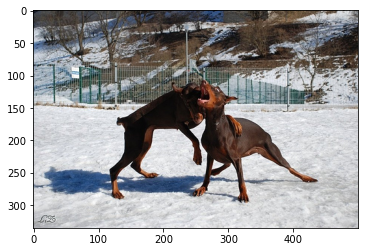

Reference Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .

Predicted Caption: 
Two dog run in the snow .

Cumulative 1-gram: 0.857143
Cumulative 2-gram: 0.755929


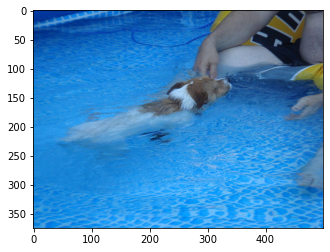

Reference Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .

Predicted Caption: 
A child be play in a pool .

Cumulative 1-gram: 0.584101
Cumulative 2-gram: 0.441539


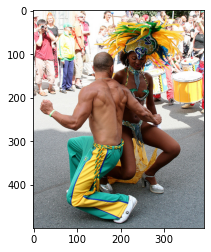

Reference Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .

Predicted Caption: 
A man in a red shirt and a red shirt and a red shirt and a red shirt and a red shirt and sit on a pumpkin .

Cumulative 1-gram: 0.321429
Cumulative 2-gram: 0.188982


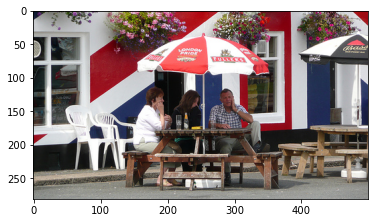

Reference Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .

Predicted Caption: 
A man in a green shirt and a black jacket be sit on a street .

Cumulative 1-gram: 0.562500
Cumulative 2-gram: 0.193649


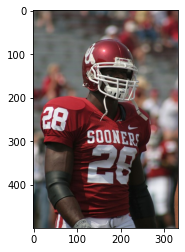

Reference Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .

Predicted Caption: 
A football player in a red uniform and white and white uniform and white and white and white and white and white and white uniform .

Cumulative 1-gram: 0.384615
Cumulative 2-gram: 0.214834


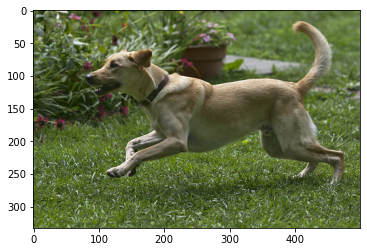

Reference Captions: 
A brown dog run
A brown dog run over grass .
A brown dog with its front paw off the ground on a grassy surface near red and purple flower .
A dog run across a grassy lawn near some flower .
A yellow dog be play in a grassy area near flower .

Predicted Caption: 
A dog run through the grass .

Cumulative 1-gram: 0.857143
Cumulative 2-gram: 0.654654


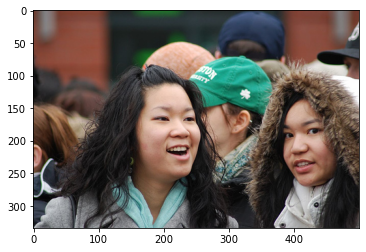

Reference Captions: 
A girl with dark brown hair and eye in a blue scarf be stand next to a girl in a fur edge coat .
an Asian boy and an Asian girl be smile in a crowd of person .
Girl be in a crowd .
Two dark haired girl be in a crowd .
Two girl be look past each other in different direction while stand in a crowd .

Predicted Caption: 
A group of woman hold a picture .

Cumulative 1-gram: 0.441248
Cumulative 2-gram: 0.000000


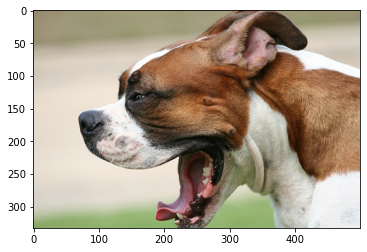

Reference Captions: 
A dog with its mouth open .
Brown and white dog yawn .
Closeup of dog in profile with mouth open .
Dog yawn
A dog 's mouth be open like he be yawn .

Predicted Caption: 
A dog with a tennis ball .

Cumulative 1-gram: 0.571429
Cumulative 2-gram: 0.436436


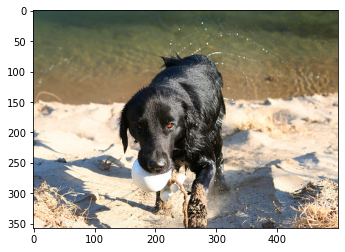

Reference Captions: 
A black dog emerge from the water onto the sand , hold a white object in its mouth .
A black dog emerge from the water with a white ball in its mouth .
A black dog on a beach carry a ball in its mouth .
a black dog walk out of the water with a white ball in his mouth .
Black dog jump out of the water with something in its mouth .

Predicted Caption: 
A black dog be run through the water .

Cumulative 1-gram: 0.427454
Cumulative 2-gram: 0.320590


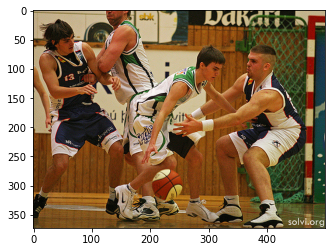

Reference Captions: 
A player from white and green highschool team dribble down court defend by a player from the other team .
Four basketball player in action .
Four man play basketball , two from each team .
Two boy in green and white uniform play basketball with two boy in blue and white uniform .
Young man play basketball in a competition .

Predicted Caption: 
A group of hockey player in a white uniform be play Cricket .

Cumulative 1-gram: 0.615385
Cumulative 2-gram: 0.392232


In [41]:
import warnings
warnings.filterwarnings('ignore')
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("./all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  print("Reference Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("\nPredicted Caption: ")
  print(" ".join(candidate))
  print('\nCumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
  print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [42]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate, weights=(1,0,0,0))
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s]


Bleu score on Greedy search
Score:  0.5856193587569236


## Beam Search Function

In [43]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

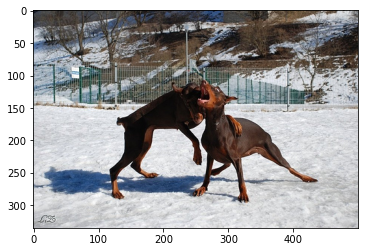

Reference Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .

Predicted Caption: 
Two dog run in the snow .

Cumulative 1-gram: 0.857143
Cumulative 2-gram: 0.755929


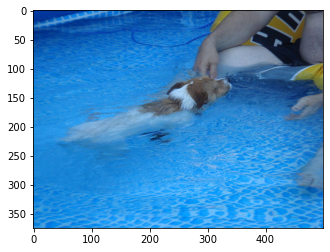

Reference Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .

Predicted Caption: 
A little boy in a red shirt be play in a pool .

Cumulative 1-gram: 0.538462
Cumulative 2-gram: 0.366900


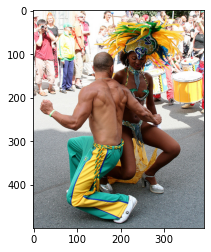

Reference Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .

Predicted Caption: 
A man in a green shirt and a blue shirt and a green shirt and a green shirt and a green shirt and a blue shirt .

Cumulative 1-gram: 0.296296
Cumulative 2-gram: 0.184900


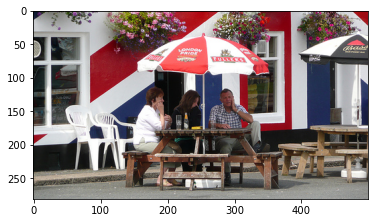

Reference Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .

Predicted Caption: 
A man in a green shirt be sit on a street .

Cumulative 1-gram: 0.536693
Cumulative 2-gram: 0.211871


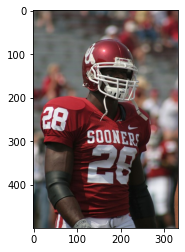

Reference Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .

Predicted Caption: 
A football player in a red uniform and white and white and white jersey .

Cumulative 1-gram: 0.733333
Cumulative 2-gram: 0.396412


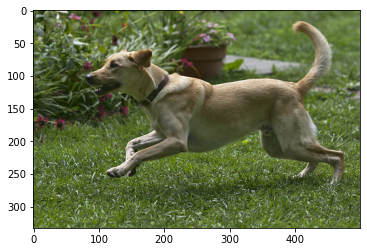

Reference Captions: 
A brown dog run
A brown dog run over grass .
A brown dog with its front paw off the ground on a grassy surface near red and purple flower .
A dog run across a grassy lawn near some flower .
A yellow dog be play in a grassy area near flower .

Predicted Caption: 
A dog run through the grass .

Cumulative 1-gram: 0.857143
Cumulative 2-gram: 0.654654


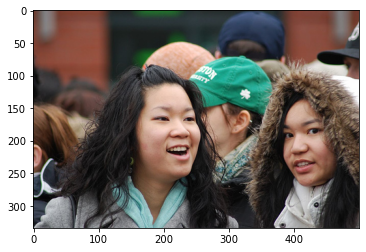

Reference Captions: 
A girl with dark brown hair and eye in a blue scarf be stand next to a girl in a fur edge coat .
an Asian boy and an Asian girl be smile in a crowd of person .
Girl be in a crowd .
Two dark haired girl be in a crowd .
Two girl be look past each other in different direction while stand in a crowd .

Predicted Caption: 
A group of woman sit in front of a crowd .

Cumulative 1-gram: 0.545455
Cumulative 2-gram: 0.330289


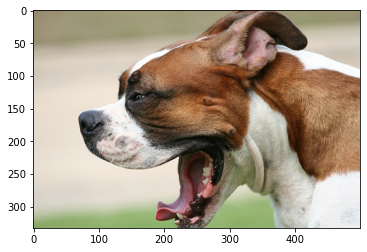

Reference Captions: 
A dog with its mouth open .
Brown and white dog yawn .
Closeup of dog in profile with mouth open .
Dog yawn
A dog 's mouth be open like he be yawn .

Predicted Caption: 
A brown and white dog with a ball .

Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.500000


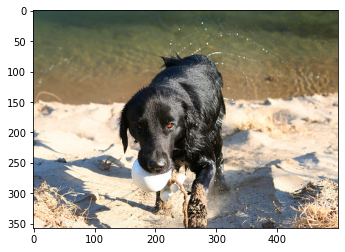

Reference Captions: 
A black dog emerge from the water onto the sand , hold a white object in its mouth .
A black dog emerge from the water with a white ball in its mouth .
A black dog on a beach carry a ball in its mouth .
a black dog walk out of the water with a white ball in his mouth .
Black dog jump out of the water with something in its mouth .

Predicted Caption: 
A black dog run through the water .

Cumulative 1-gram: 0.401446
Cumulative 2-gram: 0.303465


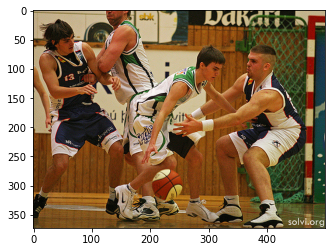

Reference Captions: 
A player from white and green highschool team dribble down court defend by a player from the other team .
Four basketball player in action .
Four man play basketball , two from each team .
Two boy in green and white uniform play basketball with two boy in blue and white uniform .
Young man play basketball in a competition .

Predicted Caption: 
A hockey player play Cricket .

Cumulative 1-gram: 0.666667
Cumulative 2-gram: 0.000000


In [44]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("./all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
#  score = sentence_bleu(reference, candidate)
  print("Reference Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("\nPredicted Caption: ")
  print(" ".join(candidate))
  print('\nCumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
  print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate, weights=(1,0,0,0))
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

 51%|█████     | 512/1000 [33:33<30:05,  3.70s/it]  